# Imports

In [1]:
import os
import subprocess
import varseek as vk

# Hyperparameters and Paths

In [2]:
verbose=True
w=54  # window size for varseek build (should be at least 1 less than kallisto k)
k=59
threads = 32
remove_Ns = True
strandedness = False  # strandedness for gget mutate and the building of the kb index (True = strandedness matters i.e., treat f and rc as 2 different sequences; False = strandedness does not matter i.e., treat f and rc as the same 

# vk build
cosmic_version = 100  # COSMIC version for gget cosmic
# os.environ['COSMIC_EMAIL'] = 'your_email'  # to avoid being prompted for email in varseek build
# os.environ['COSMIC_PASSWORD'] = 'your_password'  # to avoid being prompted for password in varseek build

# vk info
columns_to_include="all"
dlist_reference_source = "ensembl_grch37_release93"  # ensembl_grchNUMBER_releaseNUMBER or t2t - eg ensembl_grch37_release93
near_splice_junction_threshold=10
save_exploded_df=True

# vk filter
fasta_filters = [
    "dlist_substring-equal=none",  # filter out mutations which are a substring of the reference genome
    "pseudoaligned_to_human_reference_despite_not_truly_aligning-isnottrue",  # filter out mutations which pseudoaligned to human genome despite not truly aligning
    "dlist-equal=none",  #*** erase eventually when I want to d-list  # filter out mutations which are capable of being d-listed (given that I filter out the substrings above)
    "number_of_kmers_with_overlap_to_other_mcrs_items_in_mcrs_reference-max=999999",  # filter out mutations which overlap with other MCRSs in the reference
    "number_of_mcrs_items_with_overlapping_kmers_in_mcrs_reference-max=999999",  # filter out mutations which overlap with other MCRSs in the reference
    "longest_homopolymer_length-max=999999",  # filters out MCRSs with repeating single nucleotide - eg 6
    "triplet_complexity-min=0"  # filters out MCRSs with repeating triplets - eg 0.2
]

# kb ref
dlist_kb_argument = "None"  # path to dlist fasta file or "None" (including the quotes)







# Paths
out_dir_base = "/home/jrich/data/varseek_data_fresh"
run_name = "vk_build_pipeline_grch37_nov12"

# vk build
mutations = "/home/jrich/data/varseek_data_fresh/reference/cosmic/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37_mutation_workflow_with_cdna.csv"  # "cosmic_cmc"  # file path to mutations csv/tsv file OR one of the supported databases
sequences = "/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa"  # cdna  # file path to reference sequence fasta file OR, only if 'mutations' is in the supported databases, one of the following options is also supported: "cds", "cdna", "genome", "cdna_and_genome" - sequences for gget mutate

# vk info
bowtie_path="/home/jrich/opt/bowtie2-2.5.4/bowtie2-2.5.4-linux-x86_64"
mutations_csv="/home/jrich/data/varseek_data_fresh/reference/cosmic/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37_with_cdna.csv"
reference_cdna_fasta="/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa"  # the one that matches up to mutation df annotations
reference_genome_fasta="/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa"  # the one that matches up to mutation df annotations
gtf_path="/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf"  # the one that matches up to mutation df annotations

# Automatic variable initializations based on provided hyperparameters and paths

In [3]:
out_dir_notebook = os.path.join(out_dir_base, run_name)
reference_out_dir = os.path.join(out_dir_base, "reference")

os.makedirs(out_dir_base, exist_ok=True)
os.makedirs(out_dir_notebook, exist_ok=True)
os.makedirs(reference_out_dir, exist_ok=True)

if remove_Ns:
    max_ambiguous_vk = 0
    N_penalty = 1
    max_Ns_per_read_length = 0
else:
    max_ambiguous_vk = None
    N_penalty = 0
    max_Ns_per_read_length = 0.1

if strandedness:
    merge_identical_rc = False
    bowtie_strandedness = "--norc"  # could do --nofw as well
    kb_strandedness = "--strand forward"
else:
    merge_identical_rc = True
    bowtie_strandedness = ""
    kb_strandedness = ""

vk_build_mcrs_fa_path = os.path.join(out_dir_notebook, "mcrs.fa")
update_df_out = os.path.join(out_dir_notebook, "mutation_metadata_df.csv")
os.makedirs(out_dir_notebook, exist_ok=True)

cosmic_csv = os.path.join(reference_out_dir, "cosmic", f"CancerMutationCensus_AllData_v{cosmic_version}_GRCh37_gget_mutate_with_cdna")  # output of varseek

assert k >= w + 1, "k must be greater than or equal to w + 1"

mutation_metadata_df_path = os.path.join(out_dir_notebook, "mutation_metadata_df.csv")
id_to_header_csv=os.path.join(out_dir_notebook, "id_to_header_mapping.csv")
mutation_metadata_df_out_path_vk_info = os.path.join(out_dir_notebook, "mutation_metadata_df_updated_vk_info.csv")
mutation_index = f"{out_dir_notebook}/mutation_reference.idx"
dlist_fasta = f"{out_dir_notebook}/dlist.fa"

mcrs_fasta_vk_filter = os.path.join(out_dir_notebook, "mcrs_filtered.fa")
output_metadata_df_vk_filter = os.path.join(out_dir_notebook, "mutation_metadata_df_filtered.csv")
dlist_fasta_vk_filter = os.path.join(out_dir_notebook, "dlist_filtered.fa")
t2g_vk_filter = os.path.join(out_dir_notebook, "t2g_filtered.txt")
id_to_header_csv_vk_filter = os.path.join(out_dir_notebook, "id_to_header_mapping_filtered.csv")

# vk build

In [4]:
%%time
vk.build(
    sequences=sequences,
    mutations=mutations,
    out=out_dir_notebook,
    reference_out=reference_out_dir,
    w=w,
    remove_seqs_with_wt_kmers=True,
    optimize_flanking_regions=True,
    min_seq_len=k,
    max_ambiguous=max_ambiguous_vk,
    merge_identical=True,
    merge_identical_rc=strandedness,
    cosmic_email = os.getenv('COSMIC_EMAIL'),
    cosmic_password = os.getenv('COSMIC_PASSWORD'),
    create_t2g=True,
    update_df=True,
    update_df_out=update_df_out,
    verbose=verbose,
)

/home/jrich/Desktop/kvar/varseek/varseek_build.py:638: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv(mutations)


23:07:22 - INFO - Removing 81 duplications > w


Extracting MCRS left flank sequences:   0%|                                                                                          | 0/5344380 [00:00<?, ?it/s]

Extracting MCRS left flank sequences:   0%|                                                                            | 1/5344380 [00:07<10617:53:40,  7.15s/it]

Extracting MCRS left flank sequences:   0%|▏                                                                            | 9801/5344380 [00:07<46:19, 1919.22it/s]

Extracting MCRS left flank sequences:   0%|▎                                                                           | 19440/5344380 [00:07<19:45, 4490.12it/s]

Extracting MCRS left flank sequences:   1%|▍                                                                           | 29685/5344380 [00:07<10:51, 8155.95it/s]

Extracting MCRS left flank sequences:   1%|▌                                                                          | 41049/5344380 [00:07<06:32, 13508.92it/s]

Extracting MCRS left flank sequences:   1%|▋                                                                          | 52019/5344380 [00:07<04:24, 20010.90it/s]

Extracting MCRS left flank sequences:   1%|▉                                                                          | 63125/5344380 [00:07<03:08, 28028.59it/s]

Extracting MCRS left flank sequences:   1%|█                                                                          | 73688/5344380 [00:07<02:23, 36699.81it/s]

Extracting MCRS left flank sequences:   2%|█▏                                                                         | 84144/5344380 [00:07<01:54, 45986.91it/s]

Extracting MCRS left flank sequences:   2%|█▎                                                                         | 94572/5344380 [00:08<01:36, 54556.44it/s]

Extracting MCRS left flank sequences:   2%|█▍                                                                        | 104677/5344380 [00:08<01:23, 63034.32it/s]

Extracting MCRS left flank sequences:   2%|█▌                                                                        | 115362/5344380 [00:08<01:12, 72252.96it/s]

Extracting MCRS left flank sequences:   2%|█▊                                                                        | 126861/5344380 [00:08<01:03, 82129.37it/s]

Extracting MCRS left flank sequences:   3%|█▉                                                                        | 138150/5344380 [00:08<00:57, 89763.30it/s]

Extracting MCRS left flank sequences:   3%|██                                                                        | 149644/5344380 [00:08<00:53, 96353.17it/s]

Extracting MCRS left flank sequences:   3%|██▏                                                                      | 160670/5344380 [00:08<00:51, 100109.29it/s]

Extracting MCRS left flank sequences:   3%|██▎                                                                      | 171765/5344380 [00:08<00:50, 103141.87it/s]

Extracting MCRS left flank sequences:   3%|██▍                                                                      | 182809/5344380 [00:08<00:50, 101270.65it/s]

Extracting MCRS left flank sequences:   4%|██▋                                                                      | 193454/5344380 [00:08<00:50, 101602.65it/s]

Extracting MCRS left flank sequences:   4%|██▊                                                                      | 204833/5344380 [00:09<00:48, 105073.83it/s]

Extracting MCRS left flank sequences:   4%|██▉                                                                      | 216215/5344380 [00:09<00:47, 107602.55it/s]

Extracting MCRS left flank sequences:   4%|███                                                                      | 227326/5344380 [00:09<00:47, 108626.65it/s]

Extracting MCRS left flank sequences:   4%|███▎                                                                     | 238656/5344380 [00:09<00:46, 110003.08it/s]

Extracting MCRS left flank sequences:   5%|███▍                                                                     | 249759/5344380 [00:09<00:46, 110119.73it/s]

Extracting MCRS left flank sequences:   5%|███▌                                                                     | 260843/5344380 [00:09<00:47, 106450.02it/s]

Extracting MCRS left flank sequences:   5%|███▋                                                                     | 271564/5344380 [00:09<00:48, 105587.19it/s]

Extracting MCRS left flank sequences:   5%|███▊                                                                     | 282175/5344380 [00:09<00:48, 104533.92it/s]

Extracting MCRS left flank sequences:   5%|███▉                                                                     | 292665/5344380 [00:09<00:48, 104350.36it/s]

Extracting MCRS left flank sequences:   6%|████▏                                                                    | 303125/5344380 [00:10<00:48, 103228.89it/s]

Extracting MCRS left flank sequences:   6%|████▎                                                                    | 313668/5344380 [00:10<00:48, 103872.71it/s]

Extracting MCRS left flank sequences:   6%|████▍                                                                    | 324070/5344380 [00:10<00:48, 103398.03it/s]

Extracting MCRS left flank sequences:   6%|████▌                                                                    | 334750/5344380 [00:10<00:47, 104403.07it/s]

Extracting MCRS left flank sequences:   6%|████▋                                                                    | 345882/5344380 [00:10<00:46, 106455.32it/s]

Extracting MCRS left flank sequences:   7%|████▊                                                                    | 356536/5344380 [00:10<00:47, 105417.84it/s]

Extracting MCRS left flank sequences:   7%|█████                                                                    | 367559/5344380 [00:10<00:46, 106842.39it/s]

Extracting MCRS left flank sequences:   7%|█████▏                                                                   | 378251/5344380 [00:10<00:46, 106591.29it/s]

Extracting MCRS left flank sequences:   7%|█████▎                                                                   | 388915/5344380 [00:10<00:48, 103219.35it/s]

Extracting MCRS left flank sequences:   7%|█████▍                                                                   | 399262/5344380 [00:10<00:48, 101991.45it/s]

Extracting MCRS left flank sequences:   8%|█████▌                                                                   | 409479/5344380 [00:11<00:48, 100855.34it/s]

Extracting MCRS left flank sequences:   8%|█████▊                                                                    | 419577/5344380 [00:11<00:49, 99273.44it/s]

Extracting MCRS left flank sequences:   8%|█████▊                                                                   | 429900/5344380 [00:11<00:48, 100422.63it/s]

Extracting MCRS left flank sequences:   8%|██████                                                                   | 440307/5344380 [00:11<00:48, 101491.24it/s]

Extracting MCRS left flank sequences:   8%|██████▏                                                                  | 451656/5344380 [00:11<00:46, 105034.42it/s]

Extracting MCRS left flank sequences:   9%|██████▎                                                                  | 462678/5344380 [00:11<00:45, 106570.56it/s]

Extracting MCRS left flank sequences:   9%|██████▍                                                                  | 474048/5344380 [00:11<00:44, 108690.65it/s]

Extracting MCRS left flank sequences:   9%|██████▋                                                                  | 485169/5344380 [00:11<00:44, 109442.34it/s]

Extracting MCRS left flank sequences:   9%|██████▊                                                                  | 496120/5344380 [00:11<00:45, 107657.41it/s]

Extracting MCRS left flank sequences:   9%|██████▉                                                                  | 506897/5344380 [00:11<00:46, 104921.24it/s]

Extracting MCRS left flank sequences:  10%|███████                                                                  | 517940/5344380 [00:12<00:45, 106527.48it/s]

Extracting MCRS left flank sequences:  10%|███████▏                                                                 | 529404/5344380 [00:12<00:44, 108912.86it/s]

Extracting MCRS left flank sequences:  10%|███████▍                                                                 | 540481/5344380 [00:12<00:43, 109460.42it/s]

Extracting MCRS left flank sequences:  10%|███████▌                                                                 | 551826/5344380 [00:12<00:43, 110643.62it/s]

Extracting MCRS left flank sequences:  11%|███████▋                                                                 | 563104/5344380 [00:12<00:42, 111278.48it/s]

Extracting MCRS left flank sequences:  11%|███████▊                                                                 | 574240/5344380 [00:12<00:43, 108666.62it/s]

Extracting MCRS left flank sequences:  11%|███████▉                                                                 | 585125/5344380 [00:12<00:44, 106930.80it/s]

Extracting MCRS left flank sequences:  11%|████████▏                                                                | 595834/5344380 [00:12<00:44, 106839.98it/s]

Extracting MCRS left flank sequences:  11%|████████▎                                                                | 606529/5344380 [00:12<00:44, 106428.20it/s]

Extracting MCRS left flank sequences:  12%|████████▍                                                                | 617849/5344380 [00:12<00:43, 108423.57it/s]

Extracting MCRS left flank sequences:  12%|████████▌                                                                | 628700/5344380 [00:13<00:43, 107398.40it/s]

Extracting MCRS left flank sequences:  12%|████████▋                                                                | 639774/5344380 [00:13<00:43, 108380.80it/s]

Extracting MCRS left flank sequences:  12%|████████▉                                                                | 650836/5344380 [00:13<00:43, 109044.72it/s]

Extracting MCRS left flank sequences:  12%|█████████                                                                | 662233/5344380 [00:13<00:42, 110511.02it/s]

Extracting MCRS left flank sequences:  13%|█████████▏                                                               | 673625/5344380 [00:13<00:41, 111527.52it/s]

Extracting MCRS left flank sequences:  13%|█████████▎                                                               | 684782/5344380 [00:13<00:41, 111432.01it/s]

Extracting MCRS left flank sequences:  13%|█████████▌                                                               | 695991/5344380 [00:13<00:41, 111626.82it/s]

Extracting MCRS left flank sequences:  13%|█████████▊                                                                | 707156/5344380 [00:13<00:48, 95928.71it/s]

Extracting MCRS left flank sequences:  13%|█████████▊                                                               | 718681/5344380 [00:13<00:45, 101118.92it/s]

Extracting MCRS left flank sequences:  14%|█████████▉                                                               | 730068/5344380 [00:14<00:44, 104654.88it/s]

Extracting MCRS left flank sequences:  14%|██████████▏                                                              | 741400/5344380 [00:14<00:42, 107113.14it/s]

Extracting MCRS left flank sequences:  14%|██████████▎                                                              | 752332/5344380 [00:14<00:42, 107748.97it/s]

Extracting MCRS left flank sequences:  14%|██████████▍                                                              | 763248/5344380 [00:14<00:43, 106472.01it/s]

Extracting MCRS left flank sequences:  14%|██████████▌                                                              | 773995/5344380 [00:14<00:44, 102141.26it/s]

Extracting MCRS left flank sequences:  15%|██████████▋                                                              | 785143/5344380 [00:14<00:43, 104796.79it/s]

Extracting MCRS left flank sequences:  15%|██████████▉                                                              | 796447/5344380 [00:14<00:42, 107176.68it/s]

Extracting MCRS left flank sequences:  15%|███████████                                                              | 807773/5344380 [00:14<00:41, 108953.41it/s]

Extracting MCRS left flank sequences:  15%|███████████▏                                                             | 818890/5344380 [00:14<00:41, 109605.23it/s]

Extracting MCRS left flank sequences:  16%|███████████▎                                                             | 829889/5344380 [00:14<00:41, 109647.75it/s]

Extracting MCRS left flank sequences:  16%|███████████▍                                                             | 840881/5344380 [00:15<00:41, 109233.33it/s]

Extracting MCRS left flank sequences:  16%|███████████▋                                                             | 851823/5344380 [00:15<00:41, 107368.71it/s]

Extracting MCRS left flank sequences:  16%|███████████▊                                                             | 862579/5344380 [00:15<00:43, 104073.85it/s]

Extracting MCRS left flank sequences:  16%|███████████▉                                                             | 873017/5344380 [00:15<00:43, 102411.51it/s]

Extracting MCRS left flank sequences:  17%|████████████                                                             | 883280/5344380 [00:15<00:43, 101392.54it/s]

Extracting MCRS left flank sequences:  17%|████████████▏                                                            | 893434/5344380 [00:15<00:44, 100955.56it/s]

Extracting MCRS left flank sequences:  17%|████████████▎                                                            | 904297/5344380 [00:15<00:43, 103195.43it/s]

Extracting MCRS left flank sequences:  17%|████████████▍                                                            | 914843/5344380 [00:15<00:42, 103861.32it/s]

Extracting MCRS left flank sequences:  17%|████████████▋                                                            | 925240/5344380 [00:15<00:42, 103166.90it/s]

Extracting MCRS left flank sequences:  18%|████████████▊                                                            | 935564/5344380 [00:15<00:43, 102510.80it/s]

Extracting MCRS left flank sequences:  18%|████████████▉                                                            | 945821/5344380 [00:16<00:43, 101767.30it/s]

Extracting MCRS left flank sequences:  18%|█████████████                                                            | 956002/5344380 [00:16<00:43, 101752.43it/s]

Extracting MCRS left flank sequences:  18%|█████████████▏                                                           | 966251/5344380 [00:16<00:42, 101971.07it/s]

Extracting MCRS left flank sequences:  18%|█████████████▎                                                           | 976451/5344380 [00:16<00:43, 100742.37it/s]

Extracting MCRS left flank sequences:  18%|█████████████▋                                                            | 986530/5344380 [00:16<00:43, 99157.92it/s]

Extracting MCRS left flank sequences:  19%|█████████████▊                                                            | 996595/5344380 [00:16<00:43, 99595.31it/s]

Extracting MCRS left flank sequences:  19%|█████████████▌                                                          | 1007091/5344380 [00:16<00:42, 101180.12it/s]

Extracting MCRS left flank sequences:  19%|█████████████▋                                                          | 1017336/5344380 [00:16<00:42, 101555.16it/s]

Extracting MCRS left flank sequences:  19%|█████████████▊                                                          | 1028148/5344380 [00:16<00:41, 103507.86it/s]

Extracting MCRS left flank sequences:  19%|█████████████▉                                                          | 1038710/5344380 [00:16<00:41, 104136.50it/s]

Extracting MCRS left flank sequences:  20%|██████████████▏                                                         | 1049128/5344380 [00:17<00:41, 103691.15it/s]

Extracting MCRS left flank sequences:  20%|██████████████▎                                                         | 1059585/5344380 [00:17<00:41, 103952.91it/s]

Extracting MCRS left flank sequences:  20%|██████████████▍                                                         | 1069983/5344380 [00:17<00:41, 103512.87it/s]

Extracting MCRS left flank sequences:  20%|██████████████▌                                                         | 1080966/5344380 [00:17<00:40, 105395.52it/s]

Extracting MCRS left flank sequences:  20%|██████████████▋                                                         | 1092358/5344380 [00:17<00:39, 107940.75it/s]

Extracting MCRS left flank sequences:  21%|██████████████▊                                                         | 1103515/5344380 [00:17<00:38, 109023.88it/s]

Extracting MCRS left flank sequences:  21%|███████████████                                                         | 1114935/5344380 [00:17<00:38, 110571.88it/s]

Extracting MCRS left flank sequences:  21%|███████████████▏                                                        | 1126381/5344380 [00:17<00:37, 111734.13it/s]

Extracting MCRS left flank sequences:  21%|███████████████▎                                                        | 1137584/5344380 [00:17<00:37, 111821.16it/s]

Extracting MCRS left flank sequences:  21%|███████████████▍                                                        | 1148768/5344380 [00:18<00:38, 108013.83it/s]

Extracting MCRS left flank sequences:  22%|███████████████▌                                                        | 1159598/5344380 [00:18<00:38, 107765.07it/s]

Extracting MCRS left flank sequences:  22%|███████████████▊                                                        | 1170966/5344380 [00:18<00:38, 109504.69it/s]

Extracting MCRS left flank sequences:  22%|███████████████▉                                                        | 1182270/5344380 [00:18<00:37, 110548.42it/s]

Extracting MCRS left flank sequences:  22%|████████████████                                                        | 1193731/5344380 [00:18<00:37, 111753.33it/s]

Extracting MCRS left flank sequences:  23%|████████████████▏                                                       | 1205161/5344380 [00:18<00:36, 112510.25it/s]

Extracting MCRS left flank sequences:  23%|████████████████▍                                                       | 1216420/5344380 [00:18<00:36, 112047.08it/s]

Extracting MCRS left flank sequences:  23%|████████████████▌                                                       | 1227874/5344380 [00:18<00:36, 112787.42it/s]

Extracting MCRS left flank sequences:  23%|████████████████▋                                                       | 1239158/5344380 [00:18<00:36, 111087.65it/s]

Extracting MCRS left flank sequences:  23%|████████████████▊                                                       | 1250276/5344380 [00:18<00:38, 107100.15it/s]

Extracting MCRS left flank sequences:  24%|████████████████▉                                                       | 1261171/5344380 [00:19<00:37, 107632.74it/s]

Extracting MCRS left flank sequences:  24%|█████████████████▏                                                      | 1272183/5344380 [00:19<00:37, 108359.02it/s]

Extracting MCRS left flank sequences:  24%|█████████████████▎                                                      | 1283515/5344380 [00:19<00:36, 109819.83it/s]

Extracting MCRS left flank sequences:  24%|█████████████████▍                                                      | 1294513/5344380 [00:19<00:37, 108533.72it/s]

Extracting MCRS left flank sequences:  24%|█████████████████▌                                                      | 1305380/5344380 [00:19<00:37, 108498.35it/s]

Extracting MCRS left flank sequences:  25%|█████████████████▋                                                      | 1316240/5344380 [00:19<00:37, 107302.83it/s]

Extracting MCRS left flank sequences:  25%|█████████████████▉                                                      | 1326979/5344380 [00:19<00:37, 106469.48it/s]

Extracting MCRS left flank sequences:  25%|██████████████████                                                      | 1337632/5344380 [00:19<00:38, 105051.39it/s]

Extracting MCRS left flank sequences:  25%|██████████████████▍                                                      | 1348144/5344380 [00:19<00:47, 84827.21it/s]

Extracting MCRS left flank sequences:  25%|██████████████████▌                                                      | 1357242/5344380 [00:20<00:49, 80792.25it/s]

Extracting MCRS left flank sequences:  26%|██████████████████▋                                                      | 1365754/5344380 [00:20<00:50, 78142.05it/s]

Extracting MCRS left flank sequences:  26%|██████████████████▊                                                      | 1373859/5344380 [00:20<00:52, 76231.60it/s]

Extracting MCRS left flank sequences:  26%|██████████████████▊                                                      | 1381673/5344380 [00:20<00:54, 72086.60it/s]

Extracting MCRS left flank sequences:  26%|██████████████████▉                                                      | 1389023/5344380 [00:20<00:55, 71862.96it/s]

Extracting MCRS left flank sequences:  26%|███████████████████                                                      | 1396306/5344380 [00:20<00:55, 71491.38it/s]

Extracting MCRS left flank sequences:  26%|███████████████████▏                                                     | 1403519/5344380 [00:20<01:05, 60306.04it/s]

Extracting MCRS left flank sequences:  26%|███████████████████▎                                                     | 1413407/5344380 [00:20<00:56, 69908.44it/s]

Extracting MCRS left flank sequences:  27%|███████████████████▍                                                     | 1423068/5344380 [00:20<00:50, 76913.60it/s]

Extracting MCRS left flank sequences:  27%|███████████████████▌                                                     | 1433100/5344380 [00:21<00:46, 83293.91it/s]

Extracting MCRS left flank sequences:  27%|███████████████████▋                                                     | 1442561/5344380 [00:21<00:45, 86465.21it/s]

Extracting MCRS left flank sequences:  27%|███████████████████▊                                                     | 1452734/5344380 [00:21<00:42, 90828.52it/s]

Extracting MCRS left flank sequences:  27%|███████████████████▉                                                     | 1463155/5344380 [00:21<00:40, 94707.72it/s]

Extracting MCRS left flank sequences:  28%|████████████████████▏                                                    | 1473590/5344380 [00:21<00:39, 97530.89it/s]

Extracting MCRS left flank sequences:  28%|████████████████████▎                                                    | 1483458/5344380 [00:21<00:40, 96449.70it/s]

Extracting MCRS left flank sequences:  28%|████████████████████▍                                                    | 1493814/5344380 [00:21<00:39, 98535.98it/s]

Extracting MCRS left flank sequences:  28%|████████████████████▌                                                    | 1503866/5344380 [00:21<00:38, 99119.34it/s]

Extracting MCRS left flank sequences:  28%|████████████████████▍                                                   | 1514339/5344380 [00:21<00:38, 100782.83it/s]

Extracting MCRS left flank sequences:  29%|████████████████████▌                                                   | 1525542/5344380 [00:21<00:36, 104130.26it/s]

Extracting MCRS left flank sequences:  29%|████████████████████▋                                                   | 1537113/5344380 [00:22<00:35, 107583.39it/s]

Extracting MCRS left flank sequences:  29%|████████████████████▊                                                   | 1548290/5344380 [00:22<00:34, 108833.12it/s]

Extracting MCRS left flank sequences:  29%|█████████████████████                                                   | 1559924/5344380 [00:22<00:34, 111078.54it/s]

Extracting MCRS left flank sequences:  29%|█████████████████████▏                                                  | 1571431/5344380 [00:22<00:33, 112272.26it/s]

Extracting MCRS left flank sequences:  30%|█████████████████████▎                                                  | 1582666/5344380 [00:22<00:34, 107724.48it/s]

Extracting MCRS left flank sequences:  30%|█████████████████████▍                                                  | 1593483/5344380 [00:22<00:35, 107138.63it/s]

Extracting MCRS left flank sequences:  30%|█████████████████████▌                                                  | 1605007/5344380 [00:22<00:34, 109504.31it/s]

Extracting MCRS left flank sequences:  30%|█████████████████████▊                                                  | 1616455/5344380 [00:22<00:33, 110968.42it/s]

Extracting MCRS left flank sequences:  30%|█████████████████████▉                                                  | 1628056/5344380 [00:22<00:33, 112459.36it/s]

Extracting MCRS left flank sequences:  31%|██████████████████████                                                  | 1639320/5344380 [00:23<00:33, 112166.60it/s]

Extracting MCRS left flank sequences:  31%|██████████████████████▏                                                 | 1650763/5344380 [00:23<00:32, 112837.44it/s]

Extracting MCRS left flank sequences:  31%|██████████████████████▍                                                 | 1662129/5344380 [00:23<00:32, 113082.21it/s]

Extracting MCRS left flank sequences:  31%|██████████████████████▌                                                 | 1673665/5344380 [00:23<00:32, 113762.33it/s]

Extracting MCRS left flank sequences:  32%|██████████████████████▋                                                 | 1685122/5344380 [00:23<00:32, 114003.79it/s]

Extracting MCRS left flank sequences:  32%|██████████████████████▊                                                 | 1696526/5344380 [00:23<00:32, 113419.87it/s]

Extracting MCRS left flank sequences:  32%|███████████████████████                                                 | 1707871/5344380 [00:23<00:32, 110600.93it/s]

Extracting MCRS left flank sequences:  32%|███████████████████████▏                                                | 1718948/5344380 [00:23<00:33, 107061.99it/s]

Extracting MCRS left flank sequences:  32%|███████████████████████▎                                                | 1729685/5344380 [00:23<00:34, 106178.78it/s]

Extracting MCRS left flank sequences:  33%|███████████████████████▍                                                | 1740960/5344380 [00:23<00:33, 108082.80it/s]

Extracting MCRS left flank sequences:  33%|███████████████████████▌                                                | 1752321/5344380 [00:24<00:32, 109699.88it/s]

Extracting MCRS left flank sequences:  33%|███████████████████████▊                                                | 1763737/5344380 [00:24<00:32, 111013.40it/s]

Extracting MCRS left flank sequences:  33%|███████████████████████▉                                                | 1774954/5344380 [00:24<00:32, 111355.38it/s]

Extracting MCRS left flank sequences:  33%|████████████████████████                                                | 1786101/5344380 [00:24<00:31, 111295.95it/s]

Extracting MCRS left flank sequences:  34%|████████████████████████▌                                                | 1797239/5344380 [00:24<00:37, 94849.49it/s]

Extracting MCRS left flank sequences:  34%|████████████████████████▋                                                | 1807147/5344380 [00:24<00:40, 87056.78it/s]

Extracting MCRS left flank sequences:  34%|████████████████████████▊                                                | 1816229/5344380 [00:24<00:43, 81649.16it/s]

Extracting MCRS left flank sequences:  34%|████████████████████████▉                                                | 1824676/5344380 [00:24<00:44, 78638.43it/s]

Extracting MCRS left flank sequences:  34%|█████████████████████████                                                | 1832724/5344380 [00:24<00:45, 76467.18it/s]

Extracting MCRS left flank sequences:  34%|█████████████████████████▏                                               | 1840486/5344380 [00:25<00:47, 74369.69it/s]

Extracting MCRS left flank sequences:  35%|█████████████████████████▎                                               | 1848673/5344380 [00:25<00:45, 76363.88it/s]

Extracting MCRS left flank sequences:  35%|█████████████████████████▍                                               | 1858521/5344380 [00:25<00:42, 82454.36it/s]

Extracting MCRS left flank sequences:  35%|█████████████████████████▌                                               | 1868792/5344380 [00:25<00:39, 88172.51it/s]

Extracting MCRS left flank sequences:  35%|█████████████████████████▋                                               | 1879832/5344380 [00:25<00:36, 94561.02it/s]

Extracting MCRS left flank sequences:  35%|█████████████████████████▍                                              | 1891265/5344380 [00:25<00:34, 100314.81it/s]

Extracting MCRS left flank sequences:  36%|█████████████████████████▋                                              | 1902573/5344380 [00:25<00:33, 104063.78it/s]

Extracting MCRS left flank sequences:  36%|█████████████████████████▊                                              | 1913124/5344380 [00:25<00:32, 104488.68it/s]

Extracting MCRS left flank sequences:  36%|█████████████████████████▉                                              | 1923912/5344380 [00:25<00:32, 105493.64it/s]

Extracting MCRS left flank sequences:  36%|██████████████████████████                                              | 1935199/5344380 [00:26<00:31, 107688.99it/s]

Extracting MCRS left flank sequences:  36%|██████████████████████████▏                                             | 1946631/5344380 [00:26<00:30, 109666.99it/s]

Extracting MCRS left flank sequences:  37%|██████████████████████████▍                                             | 1957990/5344380 [00:26<00:30, 110837.70it/s]

Extracting MCRS left flank sequences:  37%|██████████████████████████▌                                             | 1969089/5344380 [00:26<00:30, 110806.54it/s]

Extracting MCRS left flank sequences:  37%|██████████████████████████▋                                             | 1980180/5344380 [00:26<00:31, 108183.82it/s]

Extracting MCRS left flank sequences:  37%|██████████████████████████▊                                             | 1991019/5344380 [00:26<00:31, 106624.00it/s]

Extracting MCRS left flank sequences:  37%|██████████████████████████▉                                             | 2001699/5344380 [00:26<00:31, 105302.94it/s]

Extracting MCRS left flank sequences:  38%|███████████████████████████                                             | 2012243/5344380 [00:26<00:31, 104701.62it/s]

Extracting MCRS left flank sequences:  38%|███████████████████████████▎                                            | 2022722/5344380 [00:26<00:31, 104145.31it/s]

Extracting MCRS left flank sequences:  38%|███████████████████████████▍                                            | 2033358/5344380 [00:26<00:31, 104794.44it/s]

Extracting MCRS left flank sequences:  38%|███████████████████████████▌                                            | 2043843/5344380 [00:27<00:31, 104752.16it/s]

Extracting MCRS left flank sequences:  38%|███████████████████████████▋                                            | 2054322/5344380 [00:27<00:31, 104475.29it/s]

Extracting MCRS left flank sequences:  39%|███████████████████████████▊                                            | 2064851/5344380 [00:27<00:31, 104716.28it/s]

Extracting MCRS left flank sequences:  39%|███████████████████████████▉                                            | 2076137/5344380 [00:27<00:30, 107142.03it/s]

Extracting MCRS left flank sequences:  39%|████████████████████████████                                            | 2086855/5344380 [00:27<00:30, 106957.82it/s]

Extracting MCRS left flank sequences:  39%|████████████████████████████▎                                           | 2098051/5344380 [00:27<00:29, 108451.76it/s]

Extracting MCRS left flank sequences:  39%|████████████████████████████▍                                           | 2109409/5344380 [00:27<00:29, 109985.38it/s]

Extracting MCRS left flank sequences:  40%|████████████████████████████▌                                           | 2120832/5344380 [00:27<00:28, 111253.43it/s]

Extracting MCRS left flank sequences:  40%|████████████████████████████▋                                           | 2131959/5344380 [00:27<00:28, 111142.54it/s]

Extracting MCRS left flank sequences:  40%|████████████████████████████▊                                           | 2143075/5344380 [00:27<00:29, 107993.77it/s]

Extracting MCRS left flank sequences:  40%|█████████████████████████████                                           | 2153895/5344380 [00:28<00:29, 107165.37it/s]

Extracting MCRS left flank sequences:  41%|█████████████████████████████▏                                          | 2164626/5344380 [00:28<00:29, 106121.68it/s]

Extracting MCRS left flank sequences:  41%|█████████████████████████████▎                                          | 2175893/5344380 [00:28<00:29, 108041.34it/s]

Extracting MCRS left flank sequences:  41%|█████████████████████████████▍                                          | 2187339/5344380 [00:28<00:28, 109935.33it/s]

Extracting MCRS left flank sequences:  41%|█████████████████████████████▌                                          | 2198801/5344380 [00:28<00:28, 111324.40it/s]

Extracting MCRS left flank sequences:  41%|█████████████████████████████▊                                          | 2209943/5344380 [00:28<00:28, 110482.44it/s]

Extracting MCRS left flank sequences:  42%|█████████████████████████████▉                                          | 2221156/5344380 [00:28<00:28, 110968.91it/s]

Extracting MCRS left flank sequences:  42%|██████████████████████████████                                          | 2232259/5344380 [00:28<00:28, 107444.11it/s]

Extracting MCRS left flank sequences:  42%|██████████████████████████████▏                                         | 2243030/5344380 [00:28<00:29, 106020.61it/s]

Extracting MCRS left flank sequences:  42%|██████████████████████████████▎                                         | 2253791/5344380 [00:28<00:29, 106480.89it/s]

Extracting MCRS left flank sequences:  42%|██████████████████████████████▌                                         | 2265132/5344380 [00:29<00:28, 108514.05it/s]

Extracting MCRS left flank sequences:  43%|██████████████████████████████▋                                         | 2276251/5344380 [00:29<00:28, 109303.44it/s]

Extracting MCRS left flank sequences:  43%|██████████████████████████████▊                                         | 2287571/5344380 [00:29<00:27, 110459.94it/s]

Extracting MCRS left flank sequences:  43%|██████████████████████████████▉                                         | 2298970/5344380 [00:29<00:27, 111507.77it/s]

Extracting MCRS left flank sequences:  43%|███████████████████████████████                                         | 2310128/5344380 [00:29<00:27, 110599.01it/s]

Extracting MCRS left flank sequences:  43%|███████████████████████████████▎                                        | 2321195/5344380 [00:29<00:28, 106955.98it/s]

Extracting MCRS left flank sequences:  44%|███████████████████████████████▍                                        | 2331919/5344380 [00:29<00:29, 101629.05it/s]

Extracting MCRS left flank sequences:  44%|███████████████████████████████▌                                        | 2342636/5344380 [00:29<00:29, 103196.84it/s]

Extracting MCRS left flank sequences:  44%|███████████████████████████████▋                                        | 2354006/5344380 [00:29<00:28, 106220.56it/s]

Extracting MCRS left flank sequences:  44%|███████████████████████████████▊                                        | 2365134/5344380 [00:29<00:27, 107694.24it/s]

Extracting MCRS left flank sequences:  44%|████████████████████████████████                                        | 2375943/5344380 [00:30<00:27, 106218.69it/s]

Extracting MCRS left flank sequences:  45%|████████████████████████████████▏                                       | 2386827/5344380 [00:30<00:27, 106985.47it/s]

Extracting MCRS left flank sequences:  45%|████████████████████████████████▎                                       | 2398188/5344380 [00:30<00:27, 108936.21it/s]

Extracting MCRS left flank sequences:  45%|████████████████████████████████▍                                       | 2409519/5344380 [00:30<00:26, 110232.17it/s]

Extracting MCRS left flank sequences:  45%|████████████████████████████████▌                                       | 2420731/5344380 [00:30<00:26, 110791.43it/s]

Extracting MCRS left flank sequences:  46%|████████████████████████████████▊                                       | 2431822/5344380 [00:30<00:26, 108168.83it/s]

Extracting MCRS left flank sequences:  46%|████████████████████████████████▉                                       | 2442812/5344380 [00:30<00:26, 108676.95it/s]

Extracting MCRS left flank sequences:  46%|█████████████████████████████████                                       | 2454266/5344380 [00:30<00:26, 110408.83it/s]

Extracting MCRS left flank sequences:  46%|█████████████████████████████████▏                                      | 2465674/5344380 [00:30<00:25, 111497.52it/s]

Extracting MCRS left flank sequences:  46%|█████████████████████████████████▎                                      | 2477079/5344380 [00:31<00:25, 112257.03it/s]

Extracting MCRS left flank sequences:  47%|█████████████████████████████████▌                                      | 2488313/5344380 [00:31<00:26, 109237.69it/s]

Extracting MCRS left flank sequences:  47%|█████████████████████████████████▋                                      | 2499259/5344380 [00:31<00:27, 104830.95it/s]

Extracting MCRS left flank sequences:  47%|█████████████████████████████████▊                                      | 2510569/5344380 [00:31<00:26, 107199.72it/s]

Extracting MCRS left flank sequences:  47%|█████████████████████████████████▉                                      | 2521922/5344380 [00:31<00:25, 109037.12it/s]

Extracting MCRS left flank sequences:  47%|██████████████████████████████████▏                                     | 2533276/5344380 [00:31<00:25, 110356.16it/s]

Extracting MCRS left flank sequences:  48%|██████████████████████████████████▎                                     | 2544427/5344380 [00:31<00:25, 110694.29it/s]

Extracting MCRS left flank sequences:  48%|██████████████████████████████████▍                                     | 2555629/5344380 [00:31<00:25, 111086.19it/s]

Extracting MCRS left flank sequences:  48%|██████████████████████████████████▌                                     | 2567022/5344380 [00:31<00:24, 111929.98it/s]

Extracting MCRS left flank sequences:  48%|██████████████████████████████████▋                                     | 2578226/5344380 [00:31<00:24, 111057.53it/s]

Extracting MCRS left flank sequences:  48%|██████████████████████████████████▉                                     | 2589341/5344380 [00:32<00:24, 110540.15it/s]

Extracting MCRS left flank sequences:  49%|███████████████████████████████████                                     | 2600402/5344380 [00:32<00:25, 109365.51it/s]

Extracting MCRS left flank sequences:  49%|███████████████████████████████████▏                                    | 2611345/5344380 [00:32<00:25, 107978.13it/s]

Extracting MCRS left flank sequences:  49%|███████████████████████████████████▎                                    | 2622661/5344380 [00:32<00:24, 109500.51it/s]

Extracting MCRS left flank sequences:  49%|███████████████████████████████████▍                                    | 2634029/5344380 [00:32<00:24, 110735.70it/s]

Extracting MCRS left flank sequences:  49%|███████████████████████████████████▋                                    | 2645110/5344380 [00:32<00:24, 110563.25it/s]

Extracting MCRS left flank sequences:  50%|███████████████████████████████████▊                                    | 2656474/5344380 [00:32<00:24, 111478.42it/s]

Extracting MCRS left flank sequences:  50%|███████████████████████████████████▉                                    | 2667857/5344380 [00:32<00:23, 112179.28it/s]

Extracting MCRS left flank sequences:  50%|████████████████████████████████████                                    | 2679079/5344380 [00:32<00:23, 111624.84it/s]

Extracting MCRS left flank sequences:  50%|████████████████████████████████████▏                                   | 2690245/5344380 [00:32<00:24, 109292.64it/s]

Extracting MCRS left flank sequences:  51%|████████████████████████████████████▍                                   | 2701186/5344380 [00:33<00:24, 107884.07it/s]

Extracting MCRS left flank sequences:  51%|████████████████████████████████████▌                                   | 2712144/5344380 [00:33<00:24, 108379.52it/s]

Extracting MCRS left flank sequences:  51%|████████████████████████████████████▋                                   | 2723601/5344380 [00:33<00:23, 110206.91it/s]

Extracting MCRS left flank sequences:  51%|████████████████████████████████████▊                                   | 2735087/5344380 [00:33<00:23, 111584.63it/s]

Extracting MCRS left flank sequences:  51%|█████████████████████████████████████                                   | 2746544/5344380 [00:33<00:23, 112470.23it/s]

Extracting MCRS left flank sequences:  52%|█████████████████████████████████████▏                                  | 2757880/5344380 [00:33<00:22, 112734.10it/s]

Extracting MCRS left flank sequences:  52%|█████████████████████████████████████▎                                  | 2769158/5344380 [00:33<00:22, 112097.75it/s]

Extracting MCRS left flank sequences:  52%|█████████████████████████████████████▉                                   | 2780372/5344380 [00:33<00:27, 94229.26it/s]

Extracting MCRS left flank sequences:  52%|██████████████████████████████████████▏                                  | 2791769/5344380 [00:33<00:25, 99430.53it/s]

Extracting MCRS left flank sequences:  52%|██████████████████████████████████████▎                                  | 2802122/5344380 [00:34<00:35, 72260.57it/s]

Extracting MCRS left flank sequences:  53%|██████████████████████████████████████▍                                  | 2813096/5344380 [00:34<00:31, 80476.04it/s]

Extracting MCRS left flank sequences:  53%|██████████████████████████████████████▌                                  | 2824175/5344380 [00:34<00:28, 87704.64it/s]

Extracting MCRS left flank sequences:  53%|██████████████████████████████████████▋                                  | 2835584/5344380 [00:34<00:26, 94408.35it/s]

Extracting MCRS left flank sequences:  53%|██████████████████████████████████████▉                                  | 2846998/5344380 [00:34<00:25, 99661.56it/s]

Extracting MCRS left flank sequences:  53%|██████████████████████████████████████▌                                 | 2857901/5344380 [00:34<00:24, 102242.85it/s]

Extracting MCRS left flank sequences:  54%|██████████████████████████████████████▋                                 | 2868737/5344380 [00:34<00:23, 103970.32it/s]

Extracting MCRS left flank sequences:  54%|██████████████████████████████████████▊                                 | 2879916/5344380 [00:34<00:23, 106217.63it/s]

Extracting MCRS left flank sequences:  54%|██████████████████████████████████████▉                                 | 2891199/5344380 [00:34<00:22, 108140.65it/s]

Extracting MCRS left flank sequences:  54%|███████████████████████████████████████                                 | 2902197/5344380 [00:35<00:22, 107028.69it/s]

Extracting MCRS left flank sequences:  55%|███████████████████████████████████████▏                                | 2913031/5344380 [00:35<00:22, 107210.95it/s]

Extracting MCRS left flank sequences:  55%|███████████████████████████████████████▍                                | 2923844/5344380 [00:35<00:22, 106304.17it/s]

Extracting MCRS left flank sequences:  55%|███████████████████████████████████████▌                                | 2934540/5344380 [00:35<00:22, 104914.81it/s]

Extracting MCRS left flank sequences:  55%|███████████████████████████████████████▋                                | 2945079/5344380 [00:35<00:22, 104682.16it/s]

Extracting MCRS left flank sequences:  55%|███████████████████████████████████████▊                                | 2955580/5344380 [00:35<00:22, 104574.45it/s]

Extracting MCRS left flank sequences:  55%|███████████████████████████████████████▉                                | 2966061/5344380 [00:35<00:22, 104326.06it/s]

Extracting MCRS left flank sequences:  56%|████████████████████████████████████████                                | 2976510/5344380 [00:35<00:23, 102694.85it/s]

Extracting MCRS left flank sequences:  56%|████████████████████████████████████████▏                               | 2986795/5344380 [00:35<00:23, 101668.09it/s]

Extracting MCRS left flank sequences:  56%|████████████████████████████████████████▍                               | 2997342/5344380 [00:35<00:22, 102782.82it/s]

Extracting MCRS left flank sequences:  56%|████████████████████████████████████████▌                               | 3008566/5344380 [00:36<00:22, 105574.56it/s]

Extracting MCRS left flank sequences:  57%|████████████████████████████████████████▋                               | 3019961/5344380 [00:36<00:21, 108059.58it/s]

Extracting MCRS left flank sequences:  57%|████████████████████████████████████████▊                               | 3031046/5344380 [00:36<00:21, 108890.17it/s]

Extracting MCRS left flank sequences:  57%|█████████████████████████████████████████▌                               | 3041944/5344380 [00:36<00:25, 91832.22it/s]

Extracting MCRS left flank sequences:  57%|█████████████████████████████████████████▋                               | 3052608/5344380 [00:36<00:23, 95746.95it/s]

Extracting MCRS left flank sequences:  57%|█████████████████████████████████████████▊                               | 3063293/5344380 [00:36<00:23, 98788.69it/s]

Extracting MCRS left flank sequences:  58%|█████████████████████████████████████████▍                              | 3074556/5344380 [00:36<00:22, 102683.32it/s]

Extracting MCRS left flank sequences:  58%|█████████████████████████████████████████▌                              | 3085907/5344380 [00:36<00:21, 105786.60it/s]

Extracting MCRS left flank sequences:  58%|█████████████████████████████████████████▋                              | 3096661/5344380 [00:36<00:21, 105318.67it/s]

Extracting MCRS left flank sequences:  58%|█████████████████████████████████████████▊                              | 3107490/5344380 [00:37<00:21, 106182.17it/s]

Extracting MCRS left flank sequences:  58%|██████████████████████████████████████████                              | 3118196/5344380 [00:37<00:21, 105885.83it/s]

Extracting MCRS left flank sequences:  59%|██████████████████████████████████████████▏                             | 3128846/5344380 [00:37<00:21, 105249.79it/s]

Extracting MCRS left flank sequences:  59%|██████████████████████████████████████████▎                             | 3139414/5344380 [00:37<00:20, 105048.79it/s]

Extracting MCRS left flank sequences:  59%|██████████████████████████████████████████▍                             | 3149949/5344380 [00:37<00:20, 104899.97it/s]

Extracting MCRS left flank sequences:  59%|██████████████████████████████████████████▌                             | 3160460/5344380 [00:37<00:20, 104732.88it/s]

Extracting MCRS left flank sequences:  59%|██████████████████████████████████████████▋                             | 3171071/5344380 [00:37<00:20, 105139.79it/s]

Extracting MCRS left flank sequences:  60%|██████████████████████████████████████████▊                             | 3181596/5344380 [00:37<00:20, 104378.72it/s]

Extracting MCRS left flank sequences:  60%|███████████████████████████████████████████                             | 3192294/5344380 [00:37<00:20, 105148.81it/s]

Extracting MCRS left flank sequences:  60%|███████████████████████████████████████████▏                            | 3203626/5344380 [00:37<00:19, 107581.80it/s]

Extracting MCRS left flank sequences:  60%|███████████████████████████████████████████▎                            | 3214682/5344380 [00:38<00:19, 108469.49it/s]

Extracting MCRS left flank sequences:  60%|███████████████████████████████████████████▍                            | 3226009/5344380 [00:38<00:19, 109901.76it/s]

Extracting MCRS left flank sequences:  61%|███████████████████████████████████████████▌                            | 3237438/5344380 [00:38<00:18, 111212.60it/s]

Extracting MCRS left flank sequences:  61%|███████████████████████████████████████████▊                            | 3248677/5344380 [00:38<00:18, 111564.99it/s]

Extracting MCRS left flank sequences:  61%|███████████████████████████████████████████▉                            | 3259836/5344380 [00:38<00:18, 111277.44it/s]

Extracting MCRS left flank sequences:  61%|████████████████████████████████████████████                            | 3270966/5344380 [00:38<00:18, 109948.29it/s]

Extracting MCRS left flank sequences:  61%|████████████████████████████████████████████▏                           | 3281966/5344380 [00:38<00:18, 109196.88it/s]

Extracting MCRS left flank sequences:  62%|████████████████████████████████████████████▎                           | 3293221/5344380 [00:38<00:18, 110188.79it/s]

Extracting MCRS left flank sequences:  62%|████████████████████████████████████████████▌                           | 3304602/5344380 [00:38<00:18, 111265.29it/s]

Extracting MCRS left flank sequences:  62%|████████████████████████████████████████████▋                           | 3315938/5344380 [00:38<00:18, 111887.26it/s]

Extracting MCRS left flank sequences:  62%|████████████████████████████████████████████▊                           | 3327168/5344380 [00:39<00:18, 112009.96it/s]

Extracting MCRS left flank sequences:  62%|████████████████████████████████████████████▉                           | 3338372/5344380 [00:39<00:18, 109303.02it/s]

Extracting MCRS left flank sequences:  63%|█████████████████████████████████████████████                           | 3349318/5344380 [00:39<00:18, 107383.06it/s]

Extracting MCRS left flank sequences:  63%|█████████████████████████████████████████████▎                          | 3360072/5344380 [00:39<00:18, 106383.47it/s]

Extracting MCRS left flank sequences:  63%|█████████████████████████████████████████████▍                          | 3370721/5344380 [00:39<00:18, 105849.88it/s]

Extracting MCRS left flank sequences:  63%|█████████████████████████████████████████████▌                          | 3381808/5344380 [00:39<00:18, 107323.26it/s]

Extracting MCRS left flank sequences:  63%|█████████████████████████████████████████████▋                          | 3393217/5344380 [00:39<00:17, 109319.84it/s]

Extracting MCRS left flank sequences:  64%|█████████████████████████████████████████████▊                          | 3404317/5344380 [00:39<00:17, 109816.16it/s]

Extracting MCRS left flank sequences:  64%|██████████████████████████████████████████████                          | 3415606/5344380 [00:39<00:17, 110730.03it/s]

Extracting MCRS left flank sequences:  64%|██████████████████████████████████████████████▏                         | 3426736/5344380 [00:40<00:17, 110899.29it/s]

Extracting MCRS left flank sequences:  64%|██████████████████████████████████████████████▎                         | 3438008/5344380 [00:40<00:17, 111440.90it/s]

Extracting MCRS left flank sequences:  65%|██████████████████████████████████████████████▍                         | 3449155/5344380 [00:40<00:17, 109301.27it/s]

Extracting MCRS left flank sequences:  65%|██████████████████████████████████████████████▌                         | 3460296/5344380 [00:40<00:17, 109922.64it/s]

Extracting MCRS left flank sequences:  65%|██████████████████████████████████████████████▊                         | 3471731/5344380 [00:40<00:16, 111234.93it/s]

Extracting MCRS left flank sequences:  65%|██████████████████████████████████████████████▉                         | 3483151/5344380 [00:40<00:16, 112117.07it/s]

Extracting MCRS left flank sequences:  65%|███████████████████████████████████████████████                         | 3494369/5344380 [00:40<00:16, 111280.94it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████████████████████████████▏                        | 3505864/5344380 [00:40<00:16, 112371.45it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████████████████████████████▍                        | 3517324/5344380 [00:40<00:16, 113033.77it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████████████████████████████▌                        | 3528758/5344380 [00:40<00:16, 113421.66it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████████████████████████████▋                        | 3540103/5344380 [00:41<00:16, 110378.59it/s]

Extracting MCRS left flank sequences:  66%|███████████████████████████████████████████████▊                        | 3551160/5344380 [00:41<00:16, 110300.38it/s]

Extracting MCRS left flank sequences:  67%|███████████████████████████████████████████████▉                        | 3562563/5344380 [00:41<00:15, 111401.58it/s]

Extracting MCRS left flank sequences:  67%|████████████████████████████████████████████████▏                       | 3573715/5344380 [00:41<00:15, 111317.38it/s]

Extracting MCRS left flank sequences:  67%|████████████████████████████████████████████████▎                       | 3585070/5344380 [00:41<00:15, 111980.69it/s]

Extracting MCRS left flank sequences:  67%|████████████████████████████████████████████████▍                       | 3596461/5344380 [00:41<00:15, 112554.61it/s]

Extracting MCRS left flank sequences:  68%|████████████████████████████████████████████████▌                       | 3607808/5344380 [00:41<00:15, 112827.94it/s]

Extracting MCRS left flank sequences:  68%|████████████████████████████████████████████████▊                       | 3619095/5344380 [00:41<00:15, 111836.04it/s]

Extracting MCRS left flank sequences:  68%|████████████████████████████████████████████████▉                       | 3630283/5344380 [00:41<00:15, 109594.39it/s]

Extracting MCRS left flank sequences:  68%|█████████████████████████████████████████████████                       | 3641254/5344380 [00:41<00:15, 107883.42it/s]

Extracting MCRS left flank sequences:  68%|█████████████████████████████████████████████████▏                      | 3652054/5344380 [00:42<00:16, 104437.94it/s]

Extracting MCRS left flank sequences:  69%|█████████████████████████████████████████████████▎                      | 3663338/5344380 [00:42<00:15, 106856.26it/s]

Extracting MCRS left flank sequences:  69%|█████████████████████████████████████████████████▌                      | 3674702/5344380 [00:42<00:15, 108832.29it/s]

Extracting MCRS left flank sequences:  69%|█████████████████████████████████████████████████▋                      | 3686086/5344380 [00:42<00:15, 110302.55it/s]

Extracting MCRS left flank sequences:  69%|█████████████████████████████████████████████████▊                      | 3697137/5344380 [00:42<00:15, 109600.27it/s]

Extracting MCRS left flank sequences:  69%|█████████████████████████████████████████████████▉                      | 3708112/5344380 [00:42<00:15, 108382.58it/s]

Extracting MCRS left flank sequences:  70%|██████████████████████████████████████████████████                      | 3718962/5344380 [00:42<00:15, 107149.72it/s]

Extracting MCRS left flank sequences:  70%|██████████████████████████████████████████████████▎                     | 3730357/5344380 [00:42<00:14, 109146.25it/s]

Extracting MCRS left flank sequences:  70%|██████████████████████████████████████████████████▍                     | 3741690/5344380 [00:42<00:14, 110380.84it/s]

Extracting MCRS left flank sequences:  70%|██████████████████████████████████████████████████▌                     | 3753014/5344380 [00:42<00:14, 111226.08it/s]

Extracting MCRS left flank sequences:  70%|██████████████████████████████████████████████████▋                     | 3764145/5344380 [00:43<00:14, 110461.44it/s]

Extracting MCRS left flank sequences:  71%|██████████████████████████████████████████████████▊                     | 3775198/5344380 [00:43<00:14, 109044.38it/s]

Extracting MCRS left flank sequences:  71%|███████████████████████████████████████████████████                     | 3786355/5344380 [00:43<00:14, 109789.57it/s]

Extracting MCRS left flank sequences:  71%|███████████████████████████████████████████████████▏                    | 3797341/5344380 [00:43<00:14, 109736.00it/s]

Extracting MCRS left flank sequences:  71%|███████████████████████████████████████████████████▎                    | 3808319/5344380 [00:43<00:14, 108706.29it/s]

Extracting MCRS left flank sequences:  71%|███████████████████████████████████████████████████▍                    | 3819720/5344380 [00:43<00:13, 110275.89it/s]

Extracting MCRS left flank sequences:  72%|███████████████████████████████████████████████████▌                    | 3831055/5344380 [00:43<00:13, 111187.38it/s]

Extracting MCRS left flank sequences:  72%|███████████████████████████████████████████████████▊                    | 3842179/5344380 [00:43<00:13, 109700.15it/s]

Extracting MCRS left flank sequences:  72%|███████████████████████████████████████████████████▉                    | 3853520/5344380 [00:43<00:13, 110797.25it/s]

Extracting MCRS left flank sequences:  72%|████████████████████████████████████████████████████                    | 3864828/5344380 [00:43<00:13, 111473.31it/s]

Extracting MCRS left flank sequences:  73%|████████████████████████████████████████████████████▏                   | 3876041/5344380 [00:44<00:13, 111667.01it/s]

Extracting MCRS left flank sequences:  73%|████████████████████████████████████████████████████▎                   | 3887340/5344380 [00:44<00:13, 112060.91it/s]

Extracting MCRS left flank sequences:  73%|████████████████████████████████████████████████████▌                   | 3898549/5344380 [00:44<00:13, 110370.24it/s]

Extracting MCRS left flank sequences:  73%|████████████████████████████████████████████████████▋                   | 3909914/5344380 [00:44<00:12, 111339.98it/s]

Extracting MCRS left flank sequences:  73%|████████████████████████████████████████████████████▊                   | 3921130/5344380 [00:44<00:12, 111581.55it/s]

Extracting MCRS left flank sequences:  74%|████████████████████████████████████████████████████▉                   | 3932293/5344380 [00:44<00:13, 108353.42it/s]

Extracting MCRS left flank sequences:  74%|█████████████████████████████████████████████████████                   | 3943151/5344380 [00:44<00:13, 107599.63it/s]

Extracting MCRS left flank sequences:  74%|█████████████████████████████████████████████████████▎                  | 3953926/5344380 [00:44<00:13, 106581.01it/s]

Extracting MCRS left flank sequences:  74%|█████████████████████████████████████████████████████▍                  | 3964595/5344380 [00:44<00:13, 105257.36it/s]

Extracting MCRS left flank sequences:  74%|█████████████████████████████████████████████████████▌                  | 3975129/5344380 [00:44<00:13, 104946.31it/s]

Extracting MCRS left flank sequences:  75%|█████████████████████████████████████████████████████▋                  | 3986212/5344380 [00:45<00:12, 106675.68it/s]

Extracting MCRS left flank sequences:  75%|█████████████████████████████████████████████████████▊                  | 3997305/5344380 [00:45<00:12, 107933.23it/s]

Extracting MCRS left flank sequences:  75%|██████████████████████████████████████████████████████                  | 4008716/5344380 [00:45<00:12, 109766.41it/s]

Extracting MCRS left flank sequences:  75%|██████████████████████████████████████████████████████▏                 | 4020125/5344380 [00:45<00:11, 111053.27it/s]

Extracting MCRS left flank sequences:  75%|██████████████████████████████████████████████████████▎                 | 4031558/5344380 [00:45<00:11, 112030.82it/s]

Extracting MCRS left flank sequences:  76%|██████████████████████████████████████████████████████▍                 | 4042969/5344380 [00:45<00:11, 112650.63it/s]

Extracting MCRS left flank sequences:  76%|██████████████████████████████████████████████████████▌                 | 4054420/5344380 [00:45<00:11, 113204.95it/s]

Extracting MCRS left flank sequences:  76%|██████████████████████████████████████████████████████▊                 | 4065743/5344380 [00:45<00:11, 111842.01it/s]

Extracting MCRS left flank sequences:  76%|██████████████████████████████████████████████████████▉                 | 4076933/5344380 [00:45<00:11, 109621.31it/s]

Extracting MCRS left flank sequences:  76%|███████████████████████████████████████████████████████                 | 4087907/5344380 [00:46<00:11, 107705.01it/s]

Extracting MCRS left flank sequences:  77%|███████████████████████████████████████████████████████▏                | 4099180/5344380 [00:46<00:11, 109171.02it/s]

Extracting MCRS left flank sequences:  77%|███████████████████████████████████████████████████████▍                | 4110524/5344380 [00:46<00:11, 110425.24it/s]

Extracting MCRS left flank sequences:  77%|███████████████████████████████████████████████████████▌                | 4121871/5344380 [00:46<00:10, 111325.84it/s]

Extracting MCRS left flank sequences:  77%|███████████████████████████████████████████████████████▋                | 4133274/5344380 [00:46<00:10, 112128.00it/s]

Extracting MCRS left flank sequences:  78%|███████████████████████████████████████████████████████▊                | 4144494/5344380 [00:46<00:10, 111467.68it/s]

Extracting MCRS left flank sequences:  78%|███████████████████████████████████████████████████████▉                | 4155877/5344380 [00:46<00:10, 112167.94it/s]

Extracting MCRS left flank sequences:  78%|████████████████████████████████████████████████████████▏               | 4167280/5344380 [00:46<00:10, 112721.08it/s]

Extracting MCRS left flank sequences:  78%|████████████████████████████████████████████████████████▎               | 4178556/5344380 [00:46<00:10, 110437.94it/s]

Extracting MCRS left flank sequences:  78%|████████████████████████████████████████████████████████▍               | 4189777/5344380 [00:46<00:10, 110957.92it/s]

Extracting MCRS left flank sequences:  79%|████████████████████████████████████████████████████████▌               | 4201119/5344380 [00:47<00:10, 111687.20it/s]

Extracting MCRS left flank sequences:  79%|████████████████████████████████████████████████████████▋               | 4212296/5344380 [00:47<00:10, 108947.56it/s]

Extracting MCRS left flank sequences:  79%|████████████████████████████████████████████████████████▉               | 4223480/5344380 [00:47<00:10, 109792.30it/s]

Extracting MCRS left flank sequences:  79%|█████████████████████████████████████████████████████████               | 4234921/5344380 [00:47<00:09, 111151.92it/s]

Extracting MCRS left flank sequences:  79%|█████████████████████████████████████████████████████████▏              | 4246308/5344380 [00:47<00:09, 111955.73it/s]

Extracting MCRS left flank sequences:  80%|█████████████████████████████████████████████████████████▎              | 4257667/5344380 [00:47<00:09, 112440.35it/s]

Extracting MCRS left flank sequences:  80%|█████████████████████████████████████████████████████████▌              | 4268919/5344380 [00:47<00:09, 112251.64it/s]

Extracting MCRS left flank sequences:  80%|█████████████████████████████████████████████████████████▋              | 4280150/5344380 [00:47<00:09, 109330.25it/s]

Extracting MCRS left flank sequences:  80%|█████████████████████████████████████████████████████████▊              | 4291102/5344380 [00:47<00:09, 108929.76it/s]

Extracting MCRS left flank sequences:  81%|█████████████████████████████████████████████████████████▉              | 4302540/5344380 [00:47<00:09, 110532.70it/s]

Extracting MCRS left flank sequences:  81%|██████████████████████████████████████████████████████████              | 4313895/5344380 [00:48<00:09, 111424.92it/s]

Extracting MCRS left flank sequences:  81%|██████████████████████████████████████████████████████████▎             | 4325341/5344380 [00:48<00:09, 112326.24it/s]

Extracting MCRS left flank sequences:  81%|██████████████████████████████████████████████████████████▍             | 4336733/5344380 [00:48<00:08, 112801.00it/s]

Extracting MCRS left flank sequences:  81%|██████████████████████████████████████████████████████████▌             | 4348209/5344380 [00:48<00:08, 113385.34it/s]

Extracting MCRS left flank sequences:  82%|██████████████████████████████████████████████████████████▋             | 4359680/5344380 [00:48<00:08, 113780.78it/s]

Extracting MCRS left flank sequences:  82%|██████████████████████████████████████████████████████████▉             | 4371062/5344380 [00:48<00:08, 113314.06it/s]

Extracting MCRS left flank sequences:  82%|███████████████████████████████████████████████████████████             | 4382396/5344380 [00:48<00:08, 113214.70it/s]

Extracting MCRS left flank sequences:  82%|███████████████████████████████████████████████████████████▏            | 4393720/5344380 [00:48<00:08, 108304.66it/s]

Extracting MCRS left flank sequences:  82%|███████████████████████████████████████████████████████████▎            | 4404596/5344380 [00:48<00:08, 106556.81it/s]

Extracting MCRS left flank sequences:  83%|███████████████████████████████████████████████████████████▍            | 4416009/5344380 [00:48<00:08, 108745.36it/s]

Extracting MCRS left flank sequences:  83%|███████████████████████████████████████████████████████████▋            | 4426929/5344380 [00:49<00:08, 108875.75it/s]

Extracting MCRS left flank sequences:  83%|███████████████████████████████████████████████████████████▊            | 4437839/5344380 [00:49<00:08, 106723.68it/s]

Extracting MCRS left flank sequences:  83%|███████████████████████████████████████████████████████████▉            | 4448534/5344380 [00:49<00:08, 105645.00it/s]

Extracting MCRS left flank sequences:  83%|████████████████████████████████████████████████████████████            | 4459114/5344380 [00:49<00:08, 105577.30it/s]

Extracting MCRS left flank sequences:  84%|████████████████████████████████████████████████████████████▏           | 4469683/5344380 [00:49<00:08, 104884.50it/s]

Extracting MCRS left flank sequences:  84%|████████████████████████████████████████████████████████████▎           | 4480179/5344380 [00:49<00:08, 104296.42it/s]

Extracting MCRS left flank sequences:  84%|████████████████████████████████████████████████████████████▍           | 4490614/5344380 [00:49<00:08, 104075.75it/s]

Extracting MCRS left flank sequences:  84%|████████████████████████████████████████████████████████████▋           | 4501257/5344380 [00:49<00:08, 104772.12it/s]

Extracting MCRS left flank sequences:  84%|████████████████████████████████████████████████████████████▊           | 4512355/5344380 [00:49<00:07, 106615.44it/s]

Extracting MCRS left flank sequences:  85%|████████████████████████████████████████████████████████████▉           | 4523788/5344380 [00:49<00:07, 108913.89it/s]

Extracting MCRS left flank sequences:  85%|█████████████████████████████████████████████████████████████           | 4535349/5344380 [00:50<00:07, 110910.80it/s]

Extracting MCRS left flank sequences:  85%|█████████████████████████████████████████████████████████████▎          | 4546717/5344380 [00:50<00:07, 111736.38it/s]

Extracting MCRS left flank sequences:  85%|█████████████████████████████████████████████████████████████▍          | 4557894/5344380 [00:50<00:07, 110199.45it/s]

Extracting MCRS left flank sequences:  85%|█████████████████████████████████████████████████████████████▌          | 4569084/5344380 [00:50<00:07, 110702.28it/s]

Extracting MCRS left flank sequences:  86%|█████████████████████████████████████████████████████████████▋          | 4580180/5344380 [00:50<00:06, 110776.66it/s]

Extracting MCRS left flank sequences:  86%|█████████████████████████████████████████████████████████████▊          | 4591615/5344380 [00:50<00:06, 111841.95it/s]

Extracting MCRS left flank sequences:  86%|██████████████████████████████████████████████████████████████          | 4602803/5344380 [00:50<00:06, 110174.64it/s]

Extracting MCRS left flank sequences:  86%|██████████████████████████████████████████████████████████████▏         | 4614208/5344380 [00:50<00:06, 111321.74it/s]

Extracting MCRS left flank sequences:  87%|██████████████████████████████████████████████████████████████▎         | 4625703/5344380 [00:50<00:06, 112398.80it/s]

Extracting MCRS left flank sequences:  87%|██████████████████████████████████████████████████████████████▍         | 4637192/5344380 [00:50<00:06, 113138.95it/s]

Extracting MCRS left flank sequences:  87%|██████████████████████████████████████████████████████████████▋         | 4648656/5344380 [00:51<00:06, 113586.41it/s]

Extracting MCRS left flank sequences:  87%|██████████████████████████████████████████████████████████████▊         | 4660018/5344380 [00:51<00:06, 112820.62it/s]

Extracting MCRS left flank sequences:  87%|██████████████████████████████████████████████████████████████▉         | 4671436/5344380 [00:51<00:05, 113222.29it/s]

Extracting MCRS left flank sequences:  88%|███████████████████████████████████████████████████████████████         | 4682868/5344380 [00:51<00:05, 113547.74it/s]

Extracting MCRS left flank sequences:  88%|███████████████████████████████████████████████████████████████▏        | 4694257/5344380 [00:51<00:05, 113650.01it/s]

Extracting MCRS left flank sequences:  88%|███████████████████████████████████████████████████████████████▍        | 4705624/5344380 [00:51<00:05, 111321.16it/s]

Extracting MCRS left flank sequences:  88%|███████████████████████████████████████████████████████████████▌        | 4716768/5344380 [00:51<00:05, 109262.94it/s]

Extracting MCRS left flank sequences:  88%|███████████████████████████████████████████████████████████████▋        | 4728052/5344380 [00:51<00:05, 110307.62it/s]

Extracting MCRS left flank sequences:  89%|███████████████████████████████████████████████████████████████▊        | 4739305/5344380 [00:51<00:05, 110960.80it/s]

Extracting MCRS left flank sequences:  89%|████████████████████████████████████████████████████████████████        | 4750646/5344380 [00:52<00:05, 111685.37it/s]

Extracting MCRS left flank sequences:  89%|████████████████████████████████████████████████████████████████▏       | 4762053/5344380 [00:52<00:05, 112392.91it/s]

Extracting MCRS left flank sequences:  89%|████████████████████████████████████████████████████████████████▎       | 4773496/5344380 [00:52<00:05, 113000.06it/s]

Extracting MCRS left flank sequences:  90%|████████████████████████████████████████████████████████████████▍       | 4784801/5344380 [00:52<00:04, 112544.33it/s]

Extracting MCRS left flank sequences:  90%|████████████████████████████████████████████████████████████████▌       | 4796175/5344380 [00:52<00:04, 112900.31it/s]

Extracting MCRS left flank sequences:  90%|████████████████████████████████████████████████████████████████▊       | 4807468/5344380 [00:52<00:04, 112852.06it/s]

Extracting MCRS left flank sequences:  90%|████████████████████████████████████████████████████████████████▉       | 4818756/5344380 [00:52<00:04, 111412.99it/s]

Extracting MCRS left flank sequences:  90%|█████████████████████████████████████████████████████████████████       | 4829903/5344380 [00:52<00:04, 109985.39it/s]

Extracting MCRS left flank sequences:  91%|█████████████████████████████████████████████████████████████████▏      | 4840908/5344380 [00:52<00:04, 108102.16it/s]

Extracting MCRS left flank sequences:  91%|█████████████████████████████████████████████████████████████████▎      | 4851727/5344380 [00:52<00:04, 106739.03it/s]

Extracting MCRS left flank sequences:  91%|█████████████████████████████████████████████████████████████████▌      | 4862408/5344380 [00:53<00:04, 105600.38it/s]

Extracting MCRS left flank sequences:  91%|█████████████████████████████████████████████████████████████████▋      | 4872995/5344380 [00:53<00:04, 105677.08it/s]

Extracting MCRS left flank sequences:  91%|█████████████████████████████████████████████████████████████████▊      | 4884345/5344380 [00:53<00:04, 107979.18it/s]

Extracting MCRS left flank sequences:  92%|█████████████████████████████████████████████████████████████████▉      | 4895626/5344380 [00:53<00:04, 109409.16it/s]

Extracting MCRS left flank sequences:  92%|██████████████████████████████████████████████████████████████████      | 4906817/5344380 [00:53<00:03, 110152.12it/s]

Extracting MCRS left flank sequences:  92%|██████████████████████████████████████████████████████████████████▎     | 4917838/5344380 [00:53<00:03, 107036.11it/s]

Extracting MCRS left flank sequences:  92%|██████████████████████████████████████████████████████████████████▍     | 4928564/5344380 [00:53<00:03, 106165.26it/s]

Extracting MCRS left flank sequences:  92%|██████████████████████████████████████████████████████████████████▌     | 4939196/5344380 [00:53<00:03, 105396.39it/s]

Extracting MCRS left flank sequences:  93%|██████████████████████████████████████████████████████████████████▋     | 4949746/5344380 [00:53<00:03, 103278.41it/s]

Extracting MCRS left flank sequences:  93%|██████████████████████████████████████████████████████████████████▊     | 4960087/5344380 [00:53<00:03, 101920.47it/s]

Extracting MCRS left flank sequences:  93%|██████████████████████████████████████████████████████████████████▉     | 4970288/5344380 [00:54<00:03, 101260.14it/s]

Extracting MCRS left flank sequences:  93%|███████████████████████████████████████████████████████████████████     | 4980420/5344380 [00:54<00:03, 100094.43it/s]

Extracting MCRS left flank sequences:  93%|███████████████████████████████████████████████████████████████████▏    | 4990606/5344380 [00:54<00:03, 100609.12it/s]

Extracting MCRS left flank sequences:  94%|███████████████████████████████████████████████████████████████████▍    | 5001371/5344380 [00:54<00:03, 102679.75it/s]

Extracting MCRS left flank sequences:  94%|███████████████████████████████████████████████████████████████████▌    | 5012249/5344380 [00:54<00:03, 104484.41it/s]

Extracting MCRS left flank sequences:  94%|███████████████████████████████████████████████████████████████████▋    | 5023627/5344380 [00:54<00:02, 107247.12it/s]

Extracting MCRS left flank sequences:  94%|███████████████████████████████████████████████████████████████████▊    | 5035034/5344380 [00:54<00:02, 109278.21it/s]

Extracting MCRS left flank sequences:  94%|███████████████████████████████████████████████████████████████████▉    | 5045969/5344380 [00:54<00:02, 109182.68it/s]

Extracting MCRS left flank sequences:  95%|████████████████████████████████████████████████████████████████████▏   | 5056892/5344380 [00:54<00:02, 107882.58it/s]

Extracting MCRS left flank sequences:  95%|████████████████████████████████████████████████████████████████████▎   | 5068008/5344380 [00:54<00:02, 108852.42it/s]

Extracting MCRS left flank sequences:  95%|████████████████████████████████████████████████████████████████████▍   | 5079067/5344380 [00:55<00:02, 109368.84it/s]

Extracting MCRS left flank sequences:  95%|████████████████████████████████████████████████████████████████████▌   | 5090611/5344380 [00:55<00:02, 111178.22it/s]

Extracting MCRS left flank sequences:  95%|████████████████████████████████████████████████████████████████████▋   | 5102108/5344380 [00:55<00:02, 112308.71it/s]

Extracting MCRS left flank sequences:  96%|████████████████████████████████████████████████████████████████████▉   | 5113343/5344380 [00:55<00:02, 112220.64it/s]

Extracting MCRS left flank sequences:  96%|█████████████████████████████████████████████████████████████████████   | 5124595/5344380 [00:55<00:01, 112306.08it/s]

Extracting MCRS left flank sequences:  96%|█████████████████████████████████████████████████████████████████████▏  | 5135828/5344380 [00:55<00:01, 111603.56it/s]

Extracting MCRS left flank sequences:  96%|█████████████████████████████████████████████████████████████████████▎  | 5146991/5344380 [00:55<00:01, 109044.72it/s]

Extracting MCRS left flank sequences:  97%|█████████████████████████████████████████████████████████████████████▍  | 5158050/5344380 [00:55<00:01, 109497.14it/s]

Extracting MCRS left flank sequences:  97%|█████████████████████████████████████████████████████████████████████▋  | 5169394/5344380 [00:55<00:01, 110661.97it/s]

Extracting MCRS left flank sequences:  97%|█████████████████████████████████████████████████████████████████████▊  | 5180561/5344380 [00:55<00:01, 110959.03it/s]

Extracting MCRS left flank sequences:  97%|█████████████████████████████████████████████████████████████████████▉  | 5191664/5344380 [00:56<00:01, 110106.08it/s]

Extracting MCRS left flank sequences:  97%|██████████████████████████████████████████████████████████████████████  | 5202681/5344380 [00:56<00:01, 106815.30it/s]

Extracting MCRS left flank sequences:  98%|██████████████████████████████████████████████████████████████████████▏ | 5213385/5344380 [00:56<00:01, 105133.61it/s]

Extracting MCRS left flank sequences:  98%|██████████████████████████████████████████████████████████████████████▍ | 5224321/5344380 [00:56<00:01, 106360.18it/s]

Extracting MCRS left flank sequences:  98%|██████████████████████████████████████████████████████████████████████▌ | 5235178/5344380 [00:56<00:01, 107007.36it/s]

Extracting MCRS left flank sequences:  98%|██████████████████████████████████████████████████████████████████████▋ | 5246197/5344380 [00:56<00:00, 107945.54it/s]

Extracting MCRS left flank sequences:  98%|██████████████████████████████████████████████████████████████████████▊ | 5257002/5344380 [00:56<00:00, 107107.55it/s]

Extracting MCRS left flank sequences:  99%|██████████████████████████████████████████████████████████████████████▉ | 5267721/5344380 [00:56<00:00, 106103.86it/s]

Extracting MCRS left flank sequences:  99%|███████████████████████████████████████████████████████████████████████ | 5278338/5344380 [00:56<00:00, 104701.63it/s]

Extracting MCRS left flank sequences:  99%|███████████████████████████████████████████████████████████████████████▎| 5288815/5344380 [00:57<00:00, 103691.24it/s]

Extracting MCRS left flank sequences:  99%|███████████████████████████████████████████████████████████████████████▍| 5299190/5344380 [00:57<00:00, 101518.83it/s]

Extracting MCRS left flank sequences:  99%|███████████████████████████████████████████████████████████████████████▌| 5309582/5344380 [00:57<00:00, 102217.30it/s]

Extracting MCRS left flank sequences: 100%|███████████████████████████████████████████████████████████████████████▋| 5320537/5344380 [00:57<00:00, 104367.93it/s]

Extracting MCRS left flank sequences: 100%|███████████████████████████████████████████████████████████████████████▊| 5331370/5344380 [00:57<00:00, 105537.58it/s]

Extracting MCRS left flank sequences: 100%|███████████████████████████████████████████████████████████████████████▉| 5341934/5344380 [00:57<00:00, 105322.31it/s]

Extracting MCRS left flank sequences: 100%|█████████████████████████████████████████████████████████████████████████| 5344380/5344380 [01:02<00:00, 85208.02it/s]

Extracting MCRS right flank sequences:   0%|                                                                                         | 0/5344380 [00:00<?, ?it/s]

Extracting MCRS right flank sequences:   0%|                                                                           | 1/5344380 [00:09<13371:39:44,  9.01s/it]

Extracting MCRS right flank sequences:   0%|▏                                                                          | 11285/5344380 [00:09<50:26, 1761.84it/s]

Extracting MCRS right flank sequences:   0%|▎                                                                          | 22762/5344380 [00:09<20:58, 4227.36it/s]

Extracting MCRS right flank sequences:   1%|▍                                                                          | 34097/5344380 [00:09<11:45, 7525.61it/s]

Extracting MCRS right flank sequences:   1%|▌                                                                         | 44797/5344380 [00:09<07:35, 11642.99it/s]

Extracting MCRS right flank sequences:   1%|▊                                                                         | 54940/5344380 [00:09<05:17, 16637.52it/s]

Extracting MCRS right flank sequences:   1%|▉                                                                         | 65827/5344380 [00:09<03:45, 23443.25it/s]

Extracting MCRS right flank sequences:   1%|█                                                                         | 77254/5344380 [00:09<02:44, 32104.54it/s]

Extracting MCRS right flank sequences:   2%|█▏                                                                        | 88205/5344380 [00:09<02:07, 41384.80it/s]

Extracting MCRS right flank sequences:   2%|█▍                                                                        | 99547/5344380 [00:09<01:41, 51918.21it/s]

Extracting MCRS right flank sequences:   2%|█▌                                                                       | 110955/5344380 [00:10<01:23, 62659.41it/s]

Extracting MCRS right flank sequences:   2%|█▋                                                                       | 122369/5344380 [00:10<01:11, 72851.33it/s]

Extracting MCRS right flank sequences:   2%|█▊                                                                       | 133556/5344380 [00:10<01:04, 81018.69it/s]

Extracting MCRS right flank sequences:   3%|█▉                                                                       | 145038/5344380 [00:10<00:58, 89080.21it/s]

Extracting MCRS right flank sequences:   3%|██▏                                                                      | 156258/5344380 [00:10<00:54, 94728.85it/s]

Extracting MCRS right flank sequences:   3%|██▎                                                                      | 167594/5344380 [00:10<00:51, 99681.16it/s]

Extracting MCRS right flank sequences:   3%|██▍                                                                     | 178891/5344380 [00:10<00:49, 103336.72it/s]

Extracting MCRS right flank sequences:   4%|██▌                                                                     | 190143/5344380 [00:10<00:48, 105266.03it/s]

Extracting MCRS right flank sequences:   4%|██▋                                                                     | 201321/5344380 [00:10<00:48, 106159.79it/s]

Extracting MCRS right flank sequences:   4%|██▊                                                                     | 212395/5344380 [00:10<00:48, 106095.73it/s]

Extracting MCRS right flank sequences:   4%|███                                                                     | 223325/5344380 [00:11<00:47, 106994.82it/s]

Extracting MCRS right flank sequences:   4%|███▏                                                                    | 234831/5344380 [00:11<00:46, 109350.06it/s]

Extracting MCRS right flank sequences:   5%|███▎                                                                    | 245932/5344380 [00:11<00:46, 109697.57it/s]

Extracting MCRS right flank sequences:   5%|███▍                                                                    | 257261/5344380 [00:11<00:45, 110760.15it/s]

Extracting MCRS right flank sequences:   5%|███▌                                                                    | 268421/5344380 [00:11<00:46, 110026.82it/s]

Extracting MCRS right flank sequences:   5%|███▊                                                                    | 279483/5344380 [00:11<00:46, 108570.52it/s]

Extracting MCRS right flank sequences:   5%|███▉                                                                    | 290385/5344380 [00:11<00:47, 105973.48it/s]

Extracting MCRS right flank sequences:   6%|████                                                                    | 301024/5344380 [00:11<00:48, 104744.25it/s]

Extracting MCRS right flank sequences:   6%|████▏                                                                   | 312054/5344380 [00:11<00:47, 106358.09it/s]

Extracting MCRS right flank sequences:   6%|████▎                                                                   | 323585/5344380 [00:11<00:46, 108983.72it/s]

Extracting MCRS right flank sequences:   6%|████▌                                                                   | 335159/5344380 [00:12<00:45, 110979.06it/s]

Extracting MCRS right flank sequences:   6%|████▋                                                                   | 346727/5344380 [00:12<00:44, 112373.36it/s]

Extracting MCRS right flank sequences:   7%|████▊                                                                   | 357980/5344380 [00:12<00:44, 110961.77it/s]

Extracting MCRS right flank sequences:   7%|████▉                                                                   | 369090/5344380 [00:12<00:45, 108957.44it/s]

Extracting MCRS right flank sequences:   7%|█████                                                                   | 380002/5344380 [00:12<00:46, 107636.38it/s]

Extracting MCRS right flank sequences:   7%|█████▎                                                                  | 390778/5344380 [00:12<00:46, 107378.12it/s]

Extracting MCRS right flank sequences:   8%|█████▍                                                                  | 402223/5344380 [00:12<00:45, 109456.78it/s]

Extracting MCRS right flank sequences:   8%|█████▌                                                                  | 413778/5344380 [00:12<00:44, 111258.62it/s]

Extracting MCRS right flank sequences:   8%|█████▋                                                                  | 424913/5344380 [00:12<00:44, 110907.85it/s]

Extracting MCRS right flank sequences:   8%|█████▊                                                                  | 436011/5344380 [00:12<00:44, 110146.68it/s]

Extracting MCRS right flank sequences:   8%|██████                                                                  | 447031/5344380 [00:13<00:45, 108335.44it/s]

Extracting MCRS right flank sequences:   9%|██████▏                                                                 | 457873/5344380 [00:13<00:45, 108054.60it/s]

Extracting MCRS right flank sequences:   9%|██████▎                                                                 | 469386/5344380 [00:13<00:44, 110143.26it/s]

Extracting MCRS right flank sequences:   9%|██████▍                                                                 | 480948/5344380 [00:13<00:43, 111766.28it/s]

Extracting MCRS right flank sequences:   9%|██████▋                                                                 | 492132/5344380 [00:13<00:43, 110576.78it/s]

Extracting MCRS right flank sequences:   9%|██████▊                                                                 | 503197/5344380 [00:13<00:44, 108855.46it/s]

Extracting MCRS right flank sequences:  10%|██████▉                                                                 | 514092/5344380 [00:13<00:44, 108154.28it/s]

Extracting MCRS right flank sequences:  10%|███████                                                                 | 524914/5344380 [00:13<00:44, 107887.92it/s]

Extracting MCRS right flank sequences:  10%|███████▏                                                                | 536544/5344380 [00:13<00:43, 110373.01it/s]

Extracting MCRS right flank sequences:  10%|███████▍                                                                | 548160/5344380 [00:13<00:42, 112090.26it/s]

Extracting MCRS right flank sequences:  10%|███████▌                                                                | 559684/5344380 [00:14<00:42, 113026.79it/s]

Extracting MCRS right flank sequences:  11%|███████▋                                                                | 570992/5344380 [00:14<00:42, 112492.92it/s]

Extracting MCRS right flank sequences:  11%|███████▊                                                                | 582246/5344380 [00:14<00:43, 109344.01it/s]

Extracting MCRS right flank sequences:  11%|███████▉                                                                | 593201/5344380 [00:14<00:44, 106347.48it/s]

Extracting MCRS right flank sequences:  11%|████████▏                                                               | 604016/5344380 [00:14<00:44, 106866.94it/s]

Extracting MCRS right flank sequences:  12%|████████▎                                                               | 615468/5344380 [00:14<00:43, 109101.93it/s]

Extracting MCRS right flank sequences:  12%|████████▍                                                               | 626949/5344380 [00:14<00:42, 110781.18it/s]

Extracting MCRS right flank sequences:  12%|████████▌                                                               | 638329/5344380 [00:14<00:42, 111673.41it/s]

Extracting MCRS right flank sequences:  12%|████████▊                                                               | 649762/5344380 [00:14<00:41, 112460.65it/s]

Extracting MCRS right flank sequences:  12%|████████▉                                                               | 661019/5344380 [00:15<00:42, 111210.75it/s]

Extracting MCRS right flank sequences:  13%|█████████                                                               | 672150/5344380 [00:15<00:42, 109087.87it/s]

Extracting MCRS right flank sequences:  13%|█████████▏                                                              | 683073/5344380 [00:15<00:43, 107588.49it/s]

Extracting MCRS right flank sequences:  13%|█████████▎                                                              | 694324/5344380 [00:15<00:42, 109026.07it/s]

Extracting MCRS right flank sequences:  13%|█████████▌                                                              | 705239/5344380 [00:15<00:46, 100229.50it/s]

Extracting MCRS right flank sequences:  13%|█████████▋                                                              | 716023/5344380 [00:15<00:45, 102350.25it/s]

Extracting MCRS right flank sequences:  14%|█████████▊                                                              | 726610/5344380 [00:15<00:44, 103352.08it/s]

Extracting MCRS right flank sequences:  14%|█████████▉                                                              | 737127/5344380 [00:15<00:44, 103875.25it/s]

Extracting MCRS right flank sequences:  14%|██████████                                                              | 747697/5344380 [00:15<00:44, 104408.69it/s]

Extracting MCRS right flank sequences:  14%|██████████▏                                                             | 759054/5344380 [00:15<00:42, 107107.92it/s]

Extracting MCRS right flank sequences:  14%|██████████▍                                                             | 770586/5344380 [00:16<00:41, 109540.28it/s]

Extracting MCRS right flank sequences:  15%|██████████▌                                                             | 781569/5344380 [00:16<00:41, 109059.27it/s]

Extracting MCRS right flank sequences:  15%|██████████▋                                                             | 792495/5344380 [00:16<00:41, 108401.33it/s]

Extracting MCRS right flank sequences:  15%|██████████▊                                                             | 803350/5344380 [00:16<00:42, 107460.91it/s]

Extracting MCRS right flank sequences:  15%|██████████▉                                                             | 814879/5344380 [00:16<00:41, 109773.65it/s]

Extracting MCRS right flank sequences:  15%|███████████▏                                                            | 826428/5344380 [00:16<00:40, 111468.98it/s]

Extracting MCRS right flank sequences:  16%|███████████▎                                                            | 837948/5344380 [00:16<00:40, 112579.93it/s]

Extracting MCRS right flank sequences:  16%|███████████▍                                                            | 849214/5344380 [00:16<00:40, 112353.43it/s]

Extracting MCRS right flank sequences:  16%|███████████▌                                                            | 860603/5344380 [00:16<00:39, 112811.62it/s]

Extracting MCRS right flank sequences:  16%|███████████▊                                                            | 872211/5344380 [00:16<00:39, 113786.49it/s]

Extracting MCRS right flank sequences:  17%|███████████▉                                                            | 883690/5344380 [00:17<00:39, 114086.41it/s]

Extracting MCRS right flank sequences:  17%|████████████                                                            | 895167/5344380 [00:17<00:38, 114288.23it/s]

Extracting MCRS right flank sequences:  17%|████████████▏                                                           | 906598/5344380 [00:17<00:39, 112120.84it/s]

Extracting MCRS right flank sequences:  17%|████████████▎                                                           | 917821/5344380 [00:17<00:40, 108271.76it/s]

Extracting MCRS right flank sequences:  17%|████████████▌                                                           | 928680/5344380 [00:17<00:41, 107356.00it/s]

Extracting MCRS right flank sequences:  18%|████████████▋                                                           | 940094/5344380 [00:17<00:40, 109327.69it/s]

Extracting MCRS right flank sequences:  18%|████████████▊                                                           | 951108/5344380 [00:17<00:40, 109564.81it/s]

Extracting MCRS right flank sequences:  18%|████████████▉                                                           | 962665/5344380 [00:17<00:39, 111337.71it/s]

Extracting MCRS right flank sequences:  18%|█████████████                                                           | 974137/5344380 [00:17<00:38, 112338.95it/s]

Extracting MCRS right flank sequences:  18%|█████████████▎                                                          | 985382/5344380 [00:17<00:38, 112124.44it/s]

Extracting MCRS right flank sequences:  19%|█████████████▍                                                          | 996602/5344380 [00:18<00:38, 112132.09it/s]

Extracting MCRS right flank sequences:  19%|█████████████▍                                                         | 1007821/5344380 [00:18<00:39, 109635.96it/s]

Extracting MCRS right flank sequences:  19%|█████████████▌                                                         | 1018800/5344380 [00:18<00:39, 109588.14it/s]

Extracting MCRS right flank sequences:  19%|█████████████▋                                                         | 1030233/5344380 [00:18<00:38, 110989.80it/s]

Extracting MCRS right flank sequences:  19%|█████████████▊                                                         | 1041670/5344380 [00:18<00:38, 111990.97it/s]

Extracting MCRS right flank sequences:  20%|█████████████▉                                                         | 1052950/5344380 [00:18<00:38, 112230.10it/s]

Extracting MCRS right flank sequences:  20%|██████████████▏                                                        | 1064179/5344380 [00:18<00:38, 110601.98it/s]

Extracting MCRS right flank sequences:  20%|██████████████▎                                                        | 1075248/5344380 [00:18<00:38, 109519.62it/s]

Extracting MCRS right flank sequences:  20%|██████████████▍                                                        | 1086834/5344380 [00:18<00:38, 111388.38it/s]

Extracting MCRS right flank sequences:  21%|██████████████▌                                                        | 1098546/5344380 [00:18<00:37, 113086.30it/s]

Extracting MCRS right flank sequences:  21%|██████████████▋                                                        | 1110039/5344380 [00:19<00:37, 113634.40it/s]

Extracting MCRS right flank sequences:  21%|██████████████▉                                                        | 1121540/5344380 [00:19<00:37, 114042.70it/s]

Extracting MCRS right flank sequences:  21%|███████████████                                                        | 1132949/5344380 [00:19<00:38, 108584.16it/s]

Extracting MCRS right flank sequences:  21%|███████████████▏                                                       | 1143864/5344380 [00:19<00:39, 105915.40it/s]

Extracting MCRS right flank sequences:  22%|███████████████▎                                                       | 1155178/5344380 [00:19<00:38, 107984.81it/s]

Extracting MCRS right flank sequences:  22%|███████████████▍                                                       | 1166619/5344380 [00:19<00:38, 109850.65it/s]

Extracting MCRS right flank sequences:  22%|███████████████▋                                                       | 1178049/5344380 [00:19<00:37, 111154.49it/s]

Extracting MCRS right flank sequences:  22%|███████████████▊                                                       | 1189514/5344380 [00:19<00:37, 112184.42it/s]

Extracting MCRS right flank sequences:  22%|███████████████▉                                                       | 1200754/5344380 [00:19<00:36, 112056.51it/s]

Extracting MCRS right flank sequences:  23%|████████████████                                                       | 1212142/5344380 [00:20<00:36, 112597.03it/s]

Extracting MCRS right flank sequences:  23%|████████████████▎                                                      | 1223629/5344380 [00:20<00:36, 113271.94it/s]

Extracting MCRS right flank sequences:  23%|████████████████▍                                                      | 1234965/5344380 [00:20<00:36, 112823.61it/s]

Extracting MCRS right flank sequences:  23%|████████████████▌                                                      | 1246371/5344380 [00:20<00:36, 113191.44it/s]

Extracting MCRS right flank sequences:  24%|████████████████▋                                                      | 1257695/5344380 [00:20<00:36, 112738.58it/s]

Extracting MCRS right flank sequences:  24%|████████████████▊                                                      | 1269096/5344380 [00:20<00:36, 113117.72it/s]

Extracting MCRS right flank sequences:  24%|█████████████████                                                      | 1280411/5344380 [00:20<00:36, 112760.17it/s]

Extracting MCRS right flank sequences:  24%|█████████████████▏                                                     | 1291880/5344380 [00:20<00:35, 113336.09it/s]

Extracting MCRS right flank sequences:  24%|█████████████████▎                                                     | 1303393/5344380 [00:20<00:35, 113870.89it/s]

Extracting MCRS right flank sequences:  25%|█████████████████▍                                                     | 1314842/5344380 [00:20<00:35, 114053.74it/s]

Extracting MCRS right flank sequences:  25%|█████████████████▌                                                     | 1326389/5344380 [00:21<00:35, 114475.20it/s]

Extracting MCRS right flank sequences:  25%|█████████████████▊                                                     | 1337876/5344380 [00:21<00:34, 114589.67it/s]

Extracting MCRS right flank sequences:  25%|█████████████████▉                                                     | 1349397/5344380 [00:21<00:34, 114772.68it/s]

Extracting MCRS right flank sequences:  25%|██████████████████                                                     | 1360875/5344380 [00:21<00:35, 112507.66it/s]

Extracting MCRS right flank sequences:  26%|██████████████████▏                                                    | 1372136/5344380 [00:21<00:36, 109485.66it/s]

Extracting MCRS right flank sequences:  26%|██████████████████▎                                                    | 1383106/5344380 [00:21<00:36, 109392.17it/s]

Extracting MCRS right flank sequences:  26%|██████████████████▌                                                    | 1394380/5344380 [00:21<00:35, 110372.89it/s]

Extracting MCRS right flank sequences:  26%|██████████████████▉                                                     | 1405430/5344380 [00:21<00:41, 94201.32it/s]

Extracting MCRS right flank sequences:  27%|███████████████████                                                     | 1416505/5344380 [00:21<00:39, 98581.00it/s]

Extracting MCRS right flank sequences:  27%|██████████████████▉                                                    | 1428015/5344380 [00:22<00:37, 103111.84it/s]

Extracting MCRS right flank sequences:  27%|███████████████████                                                    | 1438610/5344380 [00:22<00:37, 103819.35it/s]

Extracting MCRS right flank sequences:  27%|███████████████████▎                                                   | 1449195/5344380 [00:22<00:37, 103232.99it/s]

Extracting MCRS right flank sequences:  27%|███████████████████▍                                                   | 1459660/5344380 [00:22<00:37, 103218.76it/s]

Extracting MCRS right flank sequences:  28%|███████████████████▌                                                   | 1470245/5344380 [00:22<00:37, 103983.13it/s]

Extracting MCRS right flank sequences:  28%|███████████████████▋                                                   | 1481140/5344380 [00:22<00:36, 105438.93it/s]

Extracting MCRS right flank sequences:  28%|███████████████████▊                                                   | 1492841/5344380 [00:22<00:35, 108855.17it/s]

Extracting MCRS right flank sequences:  28%|███████████████████▉                                                   | 1504330/5344380 [00:22<00:34, 110644.37it/s]

Extracting MCRS right flank sequences:  28%|████████████████████▏                                                  | 1515740/5344380 [00:22<00:34, 111672.25it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▎                                                  | 1527209/5344380 [00:22<00:33, 112572.01it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▍                                                  | 1538862/5344380 [00:23<00:33, 113754.54it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▌                                                  | 1550390/5344380 [00:23<00:33, 114209.80it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▋                                                  | 1561820/5344380 [00:23<00:33, 113602.84it/s]

Extracting MCRS right flank sequences:  29%|████████████████████▉                                                  | 1573187/5344380 [00:23<00:33, 113312.01it/s]

Extracting MCRS right flank sequences:  30%|█████████████████████                                                  | 1584523/5344380 [00:23<00:34, 109656.33it/s]

Extracting MCRS right flank sequences:  30%|█████████████████████▏                                                 | 1595516/5344380 [00:23<00:34, 107485.16it/s]

Extracting MCRS right flank sequences:  30%|█████████████████████▎                                                 | 1606444/5344380 [00:23<00:34, 108003.25it/s]

Extracting MCRS right flank sequences:  30%|█████████████████████▍                                                 | 1617858/5344380 [00:23<00:33, 109799.91it/s]

Extracting MCRS right flank sequences:  30%|█████████████████████▋                                                 | 1629248/5344380 [00:23<00:33, 111006.97it/s]

Extracting MCRS right flank sequences:  31%|█████████████████████▊                                                 | 1640783/5344380 [00:23<00:32, 112292.03it/s]

Extracting MCRS right flank sequences:  31%|█████████████████████▉                                                 | 1652189/5344380 [00:24<00:32, 112817.70it/s]

Extracting MCRS right flank sequences:  31%|██████████████████████                                                 | 1663480/5344380 [00:24<00:33, 110471.63it/s]

Extracting MCRS right flank sequences:  31%|██████████████████████▏                                                | 1674543/5344380 [00:24<00:34, 107871.75it/s]

Extracting MCRS right flank sequences:  32%|██████████████████████▍                                                | 1685351/5344380 [00:24<00:34, 106204.63it/s]

Extracting MCRS right flank sequences:  32%|██████████████████████▌                                                | 1695987/5344380 [00:24<00:34, 105348.23it/s]

Extracting MCRS right flank sequences:  32%|██████████████████████▋                                                | 1706532/5344380 [00:24<00:35, 103146.28it/s]

Extracting MCRS right flank sequences:  32%|██████████████████████▊                                                | 1716859/5344380 [00:24<00:35, 101965.16it/s]

Extracting MCRS right flank sequences:  32%|██████████████████████▉                                                | 1727401/5344380 [00:24<00:35, 102964.16it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████                                                | 1737706/5344380 [00:24<00:35, 102224.86it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████▌                                                | 1747934/5344380 [00:25<00:43, 82362.11it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████▋                                                | 1756778/5344380 [00:25<00:45, 79364.18it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████▊                                                | 1765133/5344380 [00:25<00:46, 77136.08it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████▉                                                | 1773128/5344380 [00:25<00:47, 75529.26it/s]

Extracting MCRS right flank sequences:  33%|███████████████████████▉                                                | 1780867/5344380 [00:25<00:47, 74389.40it/s]

Extracting MCRS right flank sequences:  33%|████████████████████████                                                | 1788428/5344380 [00:25<00:48, 73482.42it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▏                                               | 1796588/5344380 [00:25<00:46, 75709.50it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▎                                               | 1806786/5344380 [00:25<00:42, 83109.33it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▍                                               | 1817242/5344380 [00:25<00:39, 89262.53it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▌                                               | 1827640/5344380 [00:26<00:37, 93541.10it/s]

Extracting MCRS right flank sequences:  34%|████████████████████████▊                                               | 1837880/5344380 [00:26<00:36, 96138.09it/s]

Extracting MCRS right flank sequences:  35%|████████████████████████▉                                               | 1848062/5344380 [00:26<00:35, 97814.60it/s]

Extracting MCRS right flank sequences:  35%|█████████████████████████                                               | 1858144/5344380 [00:26<00:35, 98706.00it/s]

Extracting MCRS right flank sequences:  35%|█████████████████████████▏                                              | 1868318/5344380 [00:26<00:34, 99608.80it/s]

Extracting MCRS right flank sequences:  35%|████████████████████████▉                                              | 1878528/5344380 [00:26<00:34, 100349.91it/s]

Extracting MCRS right flank sequences:  35%|█████████████████████████                                              | 1889124/5344380 [00:26<00:33, 102024.82it/s]

Extracting MCRS right flank sequences:  36%|█████████████████████████▏                                             | 1899836/5344380 [00:26<00:33, 103547.44it/s]

Extracting MCRS right flank sequences:  36%|█████████████████████████▍                                             | 1910201/5344380 [00:26<00:33, 102524.91it/s]

Extracting MCRS right flank sequences:  36%|█████████████████████████▌                                             | 1921334/5344380 [00:26<00:32, 105142.07it/s]

Extracting MCRS right flank sequences:  36%|█████████████████████████▋                                             | 1932724/5344380 [00:27<00:31, 107751.81it/s]

Extracting MCRS right flank sequences:  36%|█████████████████████████▊                                             | 1943790/5344380 [00:27<00:31, 108620.58it/s]

Extracting MCRS right flank sequences:  37%|█████████████████████████▉                                             | 1954658/5344380 [00:27<00:31, 107098.74it/s]

Extracting MCRS right flank sequences:  37%|██████████████████████████                                             | 1965377/5344380 [00:27<00:32, 105053.10it/s]

Extracting MCRS right flank sequences:  37%|██████████████████████████▏                                            | 1975895/5344380 [00:27<00:32, 104809.92it/s]

Extracting MCRS right flank sequences:  37%|██████████████████████████▍                                            | 1986385/5344380 [00:27<00:32, 104579.10it/s]

Extracting MCRS right flank sequences:  37%|██████████████████████████▌                                            | 1996883/5344380 [00:27<00:31, 104695.73it/s]

Extracting MCRS right flank sequences:  38%|██████████████████████████▋                                            | 2008197/5344380 [00:27<00:31, 107201.88it/s]

Extracting MCRS right flank sequences:  38%|██████████████████████████▊                                            | 2019271/5344380 [00:27<00:30, 108255.11it/s]

Extracting MCRS right flank sequences:  38%|██████████████████████████▉                                            | 2030598/5344380 [00:27<00:30, 109749.98it/s]

Extracting MCRS right flank sequences:  38%|███████████████████████████                                            | 2041701/5344380 [00:28<00:29, 110129.88it/s]

Extracting MCRS right flank sequences:  38%|███████████████████████████▎                                           | 2052717/5344380 [00:28<00:30, 109502.14it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▍                                           | 2063670/5344380 [00:28<00:30, 108269.76it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▌                                           | 2074502/5344380 [00:28<00:30, 105965.03it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▋                                           | 2085111/5344380 [00:28<00:31, 104923.22it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▊                                           | 2095612/5344380 [00:28<00:31, 104656.52it/s]

Extracting MCRS right flank sequences:  39%|███████████████████████████▉                                           | 2106083/5344380 [00:28<00:31, 104401.72it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████                                           | 2116527/5344380 [00:28<00:30, 104263.26it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████▎                                          | 2126956/5344380 [00:28<00:30, 104074.38it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████▍                                          | 2137365/5344380 [00:28<00:31, 103142.13it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████▌                                          | 2147682/5344380 [00:29<00:31, 101395.50it/s]

Extracting MCRS right flank sequences:  40%|████████████████████████████▋                                          | 2157828/5344380 [00:29<00:31, 100288.35it/s]

Extracting MCRS right flank sequences:  41%|████████████████████████████▊                                          | 2168298/5344380 [00:29<00:31, 101581.40it/s]

Extracting MCRS right flank sequences:  41%|████████████████████████████▉                                          | 2179301/5344380 [00:29<00:30, 104075.17it/s]

Extracting MCRS right flank sequences:  41%|█████████████████████████████                                          | 2189717/5344380 [00:29<00:30, 103768.99it/s]

Extracting MCRS right flank sequences:  41%|█████████████████████████████▏                                         | 2200100/5344380 [00:29<00:30, 102773.09it/s]

Extracting MCRS right flank sequences:  41%|█████████████████████████████▎                                         | 2210383/5344380 [00:29<00:31, 100257.21it/s]

Extracting MCRS right flank sequences:  42%|█████████████████████████████▍                                         | 2220470/5344380 [00:29<00:31, 100435.13it/s]

Extracting MCRS right flank sequences:  42%|█████████████████████████████▋                                         | 2230838/5344380 [00:29<00:30, 101387.61it/s]

Extracting MCRS right flank sequences:  42%|█████████████████████████████▊                                         | 2240986/5344380 [00:29<00:30, 101060.07it/s]

Extracting MCRS right flank sequences:  42%|█████████████████████████████▉                                         | 2251513/5344380 [00:30<00:30, 102306.17it/s]

Extracting MCRS right flank sequences:  42%|██████████████████████████████                                         | 2261888/5344380 [00:30<00:30, 102734.63it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▏                                        | 2272188/5344380 [00:30<00:29, 102811.24it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▎                                        | 2282544/5344380 [00:30<00:29, 103033.36it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▍                                        | 2292850/5344380 [00:30<00:29, 102897.60it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▌                                        | 2303155/5344380 [00:30<00:29, 102942.47it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▋                                        | 2313451/5344380 [00:30<00:29, 102776.76it/s]

Extracting MCRS right flank sequences:  43%|██████████████████████████████▊                                        | 2323730/5344380 [00:30<00:29, 101133.32it/s]

Extracting MCRS right flank sequences:  44%|███████████████████████████████                                        | 2333850/5344380 [00:30<00:30, 100182.02it/s]

Extracting MCRS right flank sequences:  44%|███████████████████████████████▌                                        | 2343874/5344380 [00:30<00:30, 98216.81it/s]

Extracting MCRS right flank sequences:  44%|███████████████████████████████▋                                        | 2353706/5344380 [00:31<00:30, 97452.18it/s]

Extracting MCRS right flank sequences:  44%|███████████████████████████████▊                                        | 2363458/5344380 [00:31<00:30, 97376.78it/s]

Extracting MCRS right flank sequences:  44%|███████████████████████████████▉                                        | 2373200/5344380 [00:31<00:30, 97152.54it/s]

Extracting MCRS right flank sequences:  45%|████████████████████████████████                                        | 2382918/5344380 [00:31<00:30, 96853.30it/s]

Extracting MCRS right flank sequences:  45%|████████████████████████████████▏                                       | 2392605/5344380 [00:31<00:30, 96849.59it/s]

Extracting MCRS right flank sequences:  45%|████████████████████████████████▎                                       | 2402292/5344380 [00:31<00:30, 96567.20it/s]

Extracting MCRS right flank sequences:  45%|████████████████████████████████▍                                       | 2411950/5344380 [00:31<00:30, 96528.50it/s]

Extracting MCRS right flank sequences:  45%|████████████████████████████████▌                                       | 2421650/5344380 [00:31<00:30, 96669.01it/s]

Extracting MCRS right flank sequences:  45%|████████████████████████████████▊                                       | 2431318/5344380 [00:31<00:30, 96440.27it/s]

Extracting MCRS right flank sequences:  46%|████████████████████████████████▉                                       | 2441067/5344380 [00:32<00:30, 96753.09it/s]

Extracting MCRS right flank sequences:  46%|█████████████████████████████████                                       | 2451453/5344380 [00:32<00:29, 98875.73it/s]

Extracting MCRS right flank sequences:  46%|████████████████████████████████▋                                      | 2462166/5344380 [00:32<00:28, 101345.63it/s]

Extracting MCRS right flank sequences:  46%|████████████████████████████████▊                                      | 2472302/5344380 [00:32<00:28, 100902.78it/s]

Extracting MCRS right flank sequences:  46%|████████████████████████████████▉                                      | 2482420/5344380 [00:32<00:28, 100982.60it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████                                      | 2492520/5344380 [00:32<00:28, 100345.37it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████▏                                     | 2502617/5344380 [00:32<00:28, 100530.14it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████▍                                     | 2512701/5344380 [00:32<00:28, 100619.98it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████▌                                     | 2522904/5344380 [00:32<00:27, 101041.35it/s]

Extracting MCRS right flank sequences:  47%|█████████████████████████████████▋                                     | 2533485/5344380 [00:32<00:27, 102466.68it/s]

Extracting MCRS right flank sequences:  48%|█████████████████████████████████▊                                     | 2544427/5344380 [00:33<00:26, 104546.97it/s]

Extracting MCRS right flank sequences:  48%|█████████████████████████████████▉                                     | 2555644/5344380 [00:33<00:26, 106830.23it/s]

Extracting MCRS right flank sequences:  48%|██████████████████████████████████                                     | 2566328/5344380 [00:33<00:26, 105823.68it/s]

Extracting MCRS right flank sequences:  48%|██████████████████████████████████▏                                    | 2576914/5344380 [00:33<00:26, 103169.06it/s]

Extracting MCRS right flank sequences:  48%|██████████████████████████████████▎                                    | 2587246/5344380 [00:33<00:26, 102665.52it/s]

Extracting MCRS right flank sequences:  49%|██████████████████████████████████▌                                    | 2597523/5344380 [00:33<00:27, 101101.39it/s]

Extracting MCRS right flank sequences:  49%|███████████████████████████████████▏                                    | 2607643/5344380 [00:33<00:27, 98867.26it/s]

Extracting MCRS right flank sequences:  49%|███████████████████████████████████▎                                    | 2617543/5344380 [00:33<00:27, 98127.16it/s]

Extracting MCRS right flank sequences:  49%|███████████████████████████████████▍                                    | 2627364/5344380 [00:33<00:27, 97615.97it/s]

Extracting MCRS right flank sequences:  49%|███████████████████████████████████▌                                    | 2637131/5344380 [00:33<00:27, 97165.68it/s]

Extracting MCRS right flank sequences:  50%|███████████████████████████████████▋                                    | 2646851/5344380 [00:34<00:27, 96860.73it/s]

Extracting MCRS right flank sequences:  50%|███████████████████████████████████▊                                    | 2656614/5344380 [00:34<00:27, 97086.07it/s]

Extracting MCRS right flank sequences:  50%|███████████████████████████████████▉                                    | 2666325/5344380 [00:34<00:27, 96833.28it/s]

Extracting MCRS right flank sequences:  50%|████████████████████████████████████                                    | 2676010/5344380 [00:34<00:27, 96605.16it/s]

Extracting MCRS right flank sequences:  50%|████████████████████████████████████▏                                   | 2685672/5344380 [00:34<00:27, 96405.64it/s]

Extracting MCRS right flank sequences:  50%|████████████████████████████████████▎                                   | 2695313/5344380 [00:34<00:27, 95974.51it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▍                                   | 2704917/5344380 [00:34<00:27, 95993.82it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▌                                   | 2714517/5344380 [00:34<00:27, 95741.17it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▋                                   | 2724150/5344380 [00:34<00:27, 95916.71it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▊                                   | 2733742/5344380 [00:34<00:27, 94537.07it/s]

Extracting MCRS right flank sequences:  51%|████████████████████████████████████▉                                   | 2743200/5344380 [00:35<00:27, 94313.72it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████                                   | 2752778/5344380 [00:35<00:27, 94747.62it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▏                                  | 2762296/5344380 [00:35<00:27, 94874.35it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▎                                  | 2771920/5344380 [00:35<00:26, 95279.15it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▍                                  | 2781555/5344380 [00:35<00:26, 95598.25it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▌                                  | 2791151/5344380 [00:35<00:26, 95705.35it/s]

Extracting MCRS right flank sequences:  52%|█████████████████████████████████████▋                                  | 2800723/5344380 [00:35<00:39, 65168.26it/s]

Extracting MCRS right flank sequences:  53%|█████████████████████████████████████▊                                  | 2810589/5344380 [00:35<00:34, 72721.88it/s]

Extracting MCRS right flank sequences:  53%|██████████████████████████████████████                                  | 2821045/5344380 [00:36<00:31, 80480.55it/s]

Extracting MCRS right flank sequences:  53%|██████████████████████████████████████▏                                 | 2831374/5344380 [00:36<00:29, 86370.29it/s]

Extracting MCRS right flank sequences:  53%|██████████████████████████████████████▎                                 | 2841674/5344380 [00:36<00:27, 90851.14it/s]

Extracting MCRS right flank sequences:  53%|██████████████████████████████████████▍                                 | 2851363/5344380 [00:36<00:27, 92261.67it/s]

Extracting MCRS right flank sequences:  54%|██████████████████████████████████████▌                                 | 2861702/5344380 [00:36<00:26, 95416.30it/s]

Extracting MCRS right flank sequences:  54%|██████████████████████████████████████▋                                 | 2872796/5344380 [00:36<00:24, 99891.64it/s]

Extracting MCRS right flank sequences:  54%|██████████████████████████████████████▎                                | 2884145/5344380 [00:36<00:23, 103858.06it/s]

Extracting MCRS right flank sequences:  54%|██████████████████████████████████████▍                                | 2895422/5344380 [00:36<00:22, 106477.90it/s]

Extracting MCRS right flank sequences:  54%|██████████████████████████████████████▌                                | 2906613/5344380 [00:36<00:22, 108083.28it/s]

Extracting MCRS right flank sequences:  55%|██████████████████████████████████████▊                                | 2917516/5344380 [00:36<00:22, 106151.03it/s]

Extracting MCRS right flank sequences:  55%|██████████████████████████████████████▉                                | 2928205/5344380 [00:37<00:23, 104923.91it/s]

Extracting MCRS right flank sequences:  55%|███████████████████████████████████████                                | 2939179/5344380 [00:37<00:22, 106331.70it/s]

Extracting MCRS right flank sequences:  55%|███████████████████████████████████████▏                               | 2950450/5344380 [00:37<00:22, 108209.95it/s]

Extracting MCRS right flank sequences:  55%|███████████████████████████████████████▎                               | 2961762/5344380 [00:37<00:21, 109664.10it/s]

Extracting MCRS right flank sequences:  56%|███████████████████████████████████████▍                               | 2972753/5344380 [00:37<00:21, 108539.19it/s]

Extracting MCRS right flank sequences:  56%|███████████████████████████████████████▋                               | 2983626/5344380 [00:37<00:22, 106211.48it/s]

Extracting MCRS right flank sequences:  56%|███████████████████████████████████████▊                               | 2994269/5344380 [00:37<00:22, 105284.54it/s]

Extracting MCRS right flank sequences:  56%|███████████████████████████████████████▉                               | 3004813/5344380 [00:37<00:22, 103961.36it/s]

Extracting MCRS right flank sequences:  56%|████████████████████████████████████████                               | 3015482/5344380 [00:37<00:22, 104755.84it/s]

Extracting MCRS right flank sequences:  57%|████████████████████████████████████████▏                              | 3026297/5344380 [00:37<00:21, 105754.52it/s]

Extracting MCRS right flank sequences:  57%|████████████████████████████████████████▎                              | 3037335/5344380 [00:38<00:21, 107123.71it/s]

Extracting MCRS right flank sequences:  57%|████████████████████████████████████████▍                              | 3048056/5344380 [00:38<00:21, 105733.13it/s]

Extracting MCRS right flank sequences:  57%|████████████████████████████████████████▋                              | 3058638/5344380 [00:38<00:21, 104575.31it/s]

Extracting MCRS right flank sequences:  57%|████████████████████████████████████████▊                              | 3069103/5344380 [00:38<00:22, 103124.96it/s]

Extracting MCRS right flank sequences:  58%|████████████████████████████████████████▉                              | 3079533/5344380 [00:38<00:21, 103469.30it/s]

Extracting MCRS right flank sequences:  58%|█████████████████████████████████████████                              | 3090035/5344380 [00:38<00:21, 103924.20it/s]

Extracting MCRS right flank sequences:  58%|█████████████████████████████████████████▏                             | 3100433/5344380 [00:38<00:21, 103816.72it/s]

Extracting MCRS right flank sequences:  58%|█████████████████████████████████████████▎                             | 3110818/5344380 [00:38<00:21, 102417.75it/s]

Extracting MCRS right flank sequences:  58%|█████████████████████████████████████████▍                             | 3121066/5344380 [00:38<00:22, 100756.82it/s]

Extracting MCRS right flank sequences:  59%|█████████████████████████████████████████▌                             | 3131150/5344380 [00:38<00:22, 100552.20it/s]

Extracting MCRS right flank sequences:  59%|█████████████████████████████████████████▋                             | 3142132/5344380 [00:39<00:21, 103283.25it/s]

Extracting MCRS right flank sequences:  59%|█████████████████████████████████████████▉                             | 3153480/5344380 [00:39<00:20, 106304.43it/s]

Extracting MCRS right flank sequences:  59%|██████████████████████████████████████████                             | 3164793/5344380 [00:39<00:20, 108332.61it/s]

Extracting MCRS right flank sequences:  59%|██████████████████████████████████████████▏                            | 3175962/5344380 [00:39<00:19, 109333.51it/s]

Extracting MCRS right flank sequences:  60%|██████████████████████████████████████████▎                            | 3186902/5344380 [00:39<00:19, 108380.73it/s]

Extracting MCRS right flank sequences:  60%|██████████████████████████████████████████▍                            | 3197896/5344380 [00:39<00:19, 108843.54it/s]

Extracting MCRS right flank sequences:  60%|██████████████████████████████████████████▋                            | 3209089/5344380 [00:39<00:19, 109762.73it/s]

Extracting MCRS right flank sequences:  60%|██████████████████████████████████████████▊                            | 3220497/5344380 [00:39<00:19, 111049.53it/s]

Extracting MCRS right flank sequences:  60%|██████████████████████████████████████████▉                            | 3231950/5344380 [00:39<00:18, 112089.16it/s]

Extracting MCRS right flank sequences:  61%|███████████████████████████████████████████                            | 3243461/5344380 [00:39<00:18, 112992.60it/s]

Extracting MCRS right flank sequences:  61%|███████████████████████████████████████████▏                           | 3254863/5344380 [00:40<00:18, 113298.83it/s]

Extracting MCRS right flank sequences:  61%|███████████████████████████████████████████▍                           | 3266195/5344380 [00:40<00:18, 112917.24it/s]

Extracting MCRS right flank sequences:  61%|███████████████████████████████████████████▌                           | 3277489/5344380 [00:40<00:18, 109267.65it/s]

Extracting MCRS right flank sequences:  62%|███████████████████████████████████████████▋                           | 3288442/5344380 [00:40<00:18, 108699.22it/s]

Extracting MCRS right flank sequences:  62%|███████████████████████████████████████████▊                           | 3299737/5344380 [00:40<00:18, 109945.85it/s]

Extracting MCRS right flank sequences:  62%|███████████████████████████████████████████▉                           | 3311005/5344380 [00:40<00:18, 110752.28it/s]

Extracting MCRS right flank sequences:  62%|████████████████████████████████████████████▏                          | 3322334/5344380 [00:40<00:18, 111503.04it/s]

Extracting MCRS right flank sequences:  62%|████████████████████████████████████████████▎                          | 3333630/5344380 [00:40<00:17, 111936.20it/s]

Extracting MCRS right flank sequences:  63%|████████████████████████████████████████████▍                          | 3344831/5344380 [00:40<00:18, 108947.71it/s]

Extracting MCRS right flank sequences:  63%|████████████████████████████████████████████▌                          | 3355747/5344380 [00:40<00:18, 107417.95it/s]

Extracting MCRS right flank sequences:  63%|████████████████████████████████████████████▋                          | 3366506/5344380 [00:41<00:18, 106388.76it/s]

Extracting MCRS right flank sequences:  63%|████████████████████████████████████████████▊                          | 3377157/5344380 [00:41<00:18, 105553.22it/s]

Extracting MCRS right flank sequences:  63%|█████████████████████████████████████████████                          | 3387720/5344380 [00:41<00:18, 105067.11it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▏                         | 3398232/5344380 [00:41<00:18, 104237.39it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▎                         | 3408659/5344380 [00:41<00:18, 103874.10it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▍                         | 3419049/5344380 [00:41<00:18, 103559.58it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▌                         | 3429406/5344380 [00:41<00:18, 102691.65it/s]

Extracting MCRS right flank sequences:  64%|█████████████████████████████████████████████▋                         | 3440406/5344380 [00:41<00:18, 104849.46it/s]

Extracting MCRS right flank sequences:  65%|█████████████████████████████████████████████▊                         | 3451549/5344380 [00:41<00:17, 106800.58it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████████████████████████████                         | 3462921/5344380 [00:42<00:17, 108859.55it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████████████████████████████▏                        | 3474229/5344380 [00:42<00:16, 110118.59it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████████████████████████████▎                        | 3485639/5344380 [00:42<00:16, 111308.30it/s]

Extracting MCRS right flank sequences:  65%|██████████████████████████████████████████████▍                        | 3496926/5344380 [00:42<00:16, 111774.25it/s]

Extracting MCRS right flank sequences:  66%|██████████████████████████████████████████████▌                        | 3508310/5344380 [00:42<00:16, 112391.41it/s]

Extracting MCRS right flank sequences:  66%|██████████████████████████████████████████████▊                        | 3519552/5344380 [00:42<00:16, 112247.10it/s]

Extracting MCRS right flank sequences:  66%|██████████████████████████████████████████████▉                        | 3530779/5344380 [00:42<00:16, 111602.25it/s]

Extracting MCRS right flank sequences:  66%|███████████████████████████████████████████████                        | 3541941/5344380 [00:42<00:16, 109964.60it/s]

Extracting MCRS right flank sequences:  66%|███████████████████████████████████████████████▏                       | 3552944/5344380 [00:42<00:16, 108482.30it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████████████████████████████▎                       | 3563799/5344380 [00:42<00:16, 107460.23it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████████████████████████████▍                       | 3574551/5344380 [00:43<00:16, 105205.20it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████████████████████████████▋                       | 3585082/5344380 [00:43<00:16, 103912.93it/s]

Extracting MCRS right flank sequences:  67%|███████████████████████████████████████████████▊                       | 3596403/5344380 [00:43<00:16, 106618.89it/s]

Extracting MCRS right flank sequences:  68%|███████████████████████████████████████████████▉                       | 3607616/5344380 [00:43<00:16, 108236.29it/s]

Extracting MCRS right flank sequences:  68%|████████████████████████████████████████████████                       | 3619007/5344380 [00:43<00:15, 109913.44it/s]

Extracting MCRS right flank sequences:  68%|████████████████████████████████████████████████▏                      | 3630358/5344380 [00:43<00:15, 110979.96it/s]

Extracting MCRS right flank sequences:  68%|████████████████████████████████████████████████▍                      | 3641500/5344380 [00:43<00:15, 111110.74it/s]

Extracting MCRS right flank sequences:  68%|████████████████████████████████████████████████▌                      | 3652618/5344380 [00:43<00:15, 108813.03it/s]

Extracting MCRS right flank sequences:  69%|████████████████████████████████████████████████▋                      | 3663514/5344380 [00:43<00:15, 108325.31it/s]

Extracting MCRS right flank sequences:  69%|████████████████████████████████████████████████▊                      | 3674357/5344380 [00:43<00:15, 108273.57it/s]

Extracting MCRS right flank sequences:  69%|████████████████████████████████████████████████▉                      | 3685713/5344380 [00:44<00:15, 109839.67it/s]

Extracting MCRS right flank sequences:  69%|█████████████████████████████████████████████████                      | 3697034/5344380 [00:44<00:14, 110841.22it/s]

Extracting MCRS right flank sequences:  69%|█████████████████████████████████████████████████▎                     | 3708488/5344380 [00:44<00:14, 111941.48it/s]

Extracting MCRS right flank sequences:  70%|█████████████████████████████████████████████████▍                     | 3719687/5344380 [00:44<00:14, 111650.86it/s]

Extracting MCRS right flank sequences:  70%|█████████████████████████████████████████████████▌                     | 3731164/5344380 [00:44<00:14, 112580.60it/s]

Extracting MCRS right flank sequences:  70%|█████████████████████████████████████████████████▋                     | 3742425/5344380 [00:44<00:14, 112575.14it/s]

Extracting MCRS right flank sequences:  70%|█████████████████████████████████████████████████▊                     | 3753685/5344380 [00:44<00:14, 111241.57it/s]

Extracting MCRS right flank sequences:  70%|██████████████████████████████████████████████████                     | 3764814/5344380 [00:44<00:14, 107942.97it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▏                    | 3775631/5344380 [00:44<00:14, 106672.83it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▎                    | 3786314/5344380 [00:44<00:14, 105779.04it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▍                    | 3796903/5344380 [00:45<00:14, 105252.69it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▌                    | 3807435/5344380 [00:45<00:14, 104442.88it/s]

Extracting MCRS right flank sequences:  71%|██████████████████████████████████████████████████▋                    | 3817884/5344380 [00:45<00:14, 103689.99it/s]

Extracting MCRS right flank sequences:  72%|██████████████████████████████████████████████████▊                    | 3828256/5344380 [00:45<00:14, 103609.00it/s]

Extracting MCRS right flank sequences:  72%|██████████████████████████████████████████████████▉                    | 3838619/5344380 [00:45<00:14, 103482.35it/s]

Extracting MCRS right flank sequences:  72%|███████████████████████████████████████████████████▏                   | 3848969/5344380 [00:45<00:14, 103276.82it/s]

Extracting MCRS right flank sequences:  72%|███████████████████████████████████████████████████▎                   | 3859298/5344380 [00:45<00:14, 102145.80it/s]

Extracting MCRS right flank sequences:  72%|███████████████████████████████████████████████████▍                   | 3869515/5344380 [00:45<00:14, 102052.75it/s]

Extracting MCRS right flank sequences:  73%|███████████████████████████████████████████████████▌                   | 3879963/5344380 [00:45<00:14, 102773.12it/s]

Extracting MCRS right flank sequences:  73%|███████████████████████████████████████████████████▋                   | 3891353/5344380 [00:45<00:13, 106084.10it/s]

Extracting MCRS right flank sequences:  73%|███████████████████████████████████████████████████▊                   | 3902737/5344380 [00:46<00:13, 108396.64it/s]

Extracting MCRS right flank sequences:  73%|███████████████████████████████████████████████████▉                   | 3914065/5344380 [00:46<00:13, 109854.76it/s]

Extracting MCRS right flank sequences:  73%|████████████████████████████████████████████████████▏                  | 3925054/5344380 [00:46<00:12, 109438.12it/s]

Extracting MCRS right flank sequences:  74%|████████████████████████████████████████████████████▎                  | 3936001/5344380 [00:46<00:13, 106824.98it/s]

Extracting MCRS right flank sequences:  74%|████████████████████████████████████████████████████▍                  | 3946699/5344380 [00:46<00:13, 106048.12it/s]

Extracting MCRS right flank sequences:  74%|████████████████████████████████████████████████████▌                  | 3957314/5344380 [00:46<00:13, 105454.87it/s]

Extracting MCRS right flank sequences:  74%|████████████████████████████████████████████████████▋                  | 3967867/5344380 [00:46<00:13, 104748.81it/s]

Extracting MCRS right flank sequences:  74%|████████████████████████████████████████████████████▊                  | 3978506/5344380 [00:46<00:12, 105230.66it/s]

Extracting MCRS right flank sequences:  75%|████████████████████████████████████████████████████▉                  | 3989049/5344380 [00:46<00:12, 105289.17it/s]

Extracting MCRS right flank sequences:  75%|█████████████████████████████████████████████████████▏                 | 3999581/5344380 [00:47<00:12, 104810.81it/s]

Extracting MCRS right flank sequences:  75%|█████████████████████████████████████████████████████▎                 | 4010478/5344380 [00:47<00:12, 106046.22it/s]

Extracting MCRS right flank sequences:  75%|█████████████████████████████████████████████████████▍                 | 4021766/5344380 [00:47<00:12, 108080.75it/s]

Extracting MCRS right flank sequences:  75%|█████████████████████████████████████████████████████▌                 | 4032578/5344380 [00:47<00:12, 107299.36it/s]

Extracting MCRS right flank sequences:  76%|█████████████████████████████████████████████████████▋                 | 4043312/5344380 [00:47<00:12, 105042.43it/s]

Extracting MCRS right flank sequences:  76%|█████████████████████████████████████████████████████▊                 | 4053828/5344380 [00:47<00:12, 104155.86it/s]

Extracting MCRS right flank sequences:  76%|█████████████████████████████████████████████████████▉                 | 4064252/5344380 [00:47<00:12, 103907.96it/s]

Extracting MCRS right flank sequences:  76%|██████████████████████████████████████████████████████▏                | 4074648/5344380 [00:47<00:12, 103852.04it/s]

Extracting MCRS right flank sequences:  76%|██████████████████████████████████████████████████████▎                | 4085054/5344380 [00:47<00:12, 103911.36it/s]

Extracting MCRS right flank sequences:  77%|██████████████████████████████████████████████████████▍                | 4095448/5344380 [00:47<00:12, 103656.58it/s]

Extracting MCRS right flank sequences:  77%|██████████████████████████████████████████████████████▌                | 4105816/5344380 [00:48<00:11, 103464.72it/s]

Extracting MCRS right flank sequences:  77%|██████████████████████████████████████████████████████▋                | 4116164/5344380 [00:48<00:11, 102912.77it/s]

Extracting MCRS right flank sequences:  77%|██████████████████████████████████████████████████████▊                | 4126457/5344380 [00:48<00:12, 101369.14it/s]

Extracting MCRS right flank sequences:  77%|██████████████████████████████████████████████████████▉                | 4136599/5344380 [00:48<00:12, 100168.53it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████████████████████████████████▊                | 4146621/5344380 [00:48<00:12, 98952.23it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████████████████████████████████▏               | 4157161/5344380 [00:48<00:11, 100842.60it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████████████████████████████████▍               | 4168309/5344380 [00:48<00:11, 103981.48it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████████████████████████████████▌               | 4179539/5344380 [00:48<00:10, 106448.21it/s]

Extracting MCRS right flank sequences:  78%|███████████████████████████████████████████████████████▋               | 4190194/5344380 [00:48<00:10, 105911.93it/s]

Extracting MCRS right flank sequences:  79%|███████████████████████████████████████████████████████▊               | 4200886/5344380 [00:48<00:10, 106210.53it/s]

Extracting MCRS right flank sequences:  79%|███████████████████████████████████████████████████████▉               | 4211555/5344380 [00:49<00:10, 106351.35it/s]

Extracting MCRS right flank sequences:  79%|████████████████████████████████████████████████████████               | 4222752/5344380 [00:49<00:10, 108026.80it/s]

Extracting MCRS right flank sequences:  79%|████████████████████████████████████████████████████████▏              | 4233848/5344380 [00:49<00:10, 108903.72it/s]

Extracting MCRS right flank sequences:  79%|████████████████████████████████████████████████████████▍              | 4244742/5344380 [00:49<00:10, 107244.11it/s]

Extracting MCRS right flank sequences:  80%|████████████████████████████████████████████████████████▌              | 4255474/5344380 [00:49<00:10, 106631.40it/s]

Extracting MCRS right flank sequences:  80%|████████████████████████████████████████████████████████▋              | 4266143/5344380 [00:49<00:10, 106380.63it/s]

Extracting MCRS right flank sequences:  80%|████████████████████████████████████████████████████████▊              | 4276785/5344380 [00:49<00:10, 105987.68it/s]

Extracting MCRS right flank sequences:  80%|████████████████████████████████████████████████████████▉              | 4287387/5344380 [00:49<00:10, 104511.16it/s]

Extracting MCRS right flank sequences:  80%|█████████████████████████████████████████████████████████              | 4298145/5344380 [00:49<00:09, 105415.24it/s]

Extracting MCRS right flank sequences:  81%|█████████████████████████████████████████████████████████▎             | 4309485/5344380 [00:49<00:09, 107780.62it/s]

Extracting MCRS right flank sequences:  81%|█████████████████████████████████████████████████████████▍             | 4320839/5344380 [00:50<00:09, 109491.53it/s]

Extracting MCRS right flank sequences:  81%|█████████████████████████████████████████████████████████▌             | 4332197/5344380 [00:50<00:09, 110709.82it/s]

Extracting MCRS right flank sequences:  81%|█████████████████████████████████████████████████████████▋             | 4343480/5344380 [00:50<00:08, 111341.68it/s]

Extracting MCRS right flank sequences:  81%|█████████████████████████████████████████████████████████▊             | 4354770/5344380 [00:50<00:08, 111805.45it/s]

Extracting MCRS right flank sequences:  82%|██████████████████████████████████████████████████████████             | 4366064/5344380 [00:50<00:08, 112142.66it/s]

Extracting MCRS right flank sequences:  82%|██████████████████████████████████████████████████████████▏            | 4377452/5344380 [00:50<00:08, 112661.45it/s]

Extracting MCRS right flank sequences:  82%|██████████████████████████████████████████████████████████▎            | 4388766/5344380 [00:50<00:08, 112804.65it/s]

Extracting MCRS right flank sequences:  82%|██████████████████████████████████████████████████████████▍            | 4400048/5344380 [00:50<00:08, 112683.81it/s]

Extracting MCRS right flank sequences:  83%|██████████████████████████████████████████████████████████▌            | 4411420/5344380 [00:50<00:08, 112992.52it/s]

Extracting MCRS right flank sequences:  83%|██████████████████████████████████████████████████████████▊            | 4422720/5344380 [00:50<00:08, 110716.50it/s]

Extracting MCRS right flank sequences:  83%|██████████████████████████████████████████████████████████▉            | 4433803/5344380 [00:51<00:08, 108420.32it/s]

Extracting MCRS right flank sequences:  83%|███████████████████████████████████████████████████████████            | 4445029/5344380 [00:51<00:08, 109541.82it/s]

Extracting MCRS right flank sequences:  83%|███████████████████████████████████████████████████████████▏           | 4456329/5344380 [00:51<00:08, 110560.11it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▎           | 4467397/5344380 [00:51<00:07, 110012.34it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▍           | 4478407/5344380 [00:51<00:07, 109006.44it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▋           | 4489826/5344380 [00:51<00:07, 110537.04it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▊           | 4500887/5344380 [00:51<00:07, 108740.03it/s]

Extracting MCRS right flank sequences:  84%|███████████████████████████████████████████████████████████▉           | 4511771/5344380 [00:51<00:07, 106205.51it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████           | 4522408/5344380 [00:51<00:07, 104700.51it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████▏          | 4532890/5344380 [00:51<00:07, 103285.51it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████▎          | 4543227/5344380 [00:52<00:07, 101537.12it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████▍          | 4553437/5344380 [00:52<00:07, 101698.60it/s]

Extracting MCRS right flank sequences:  85%|████████████████████████████████████████████████████████████▋          | 4563613/5344380 [00:52<00:07, 100785.56it/s]

Extracting MCRS right flank sequences:  86%|████████████████████████████████████████████████████████████▊          | 4573696/5344380 [00:52<00:07, 100015.45it/s]

Extracting MCRS right flank sequences:  86%|█████████████████████████████████████████████████████████████▊          | 4583700/5344380 [00:52<00:07, 99212.18it/s]

Extracting MCRS right flank sequences:  86%|█████████████████████████████████████████████████████████████▉          | 4593623/5344380 [00:52<00:07, 98780.82it/s]

Extracting MCRS right flank sequences:  86%|██████████████████████████████████████████████████████████████          | 4603502/5344380 [00:52<00:07, 98545.36it/s]

Extracting MCRS right flank sequences:  86%|██████████████████████████████████████████████████████████████▏         | 4613357/5344380 [00:52<00:07, 97939.39it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████████████████████████████████████▎         | 4623151/5344380 [00:52<00:07, 97296.81it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████████████████████████████████████▍         | 4632881/5344380 [00:53<00:07, 97280.23it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████████████████████████████████████▌         | 4642610/5344380 [00:53<00:07, 96775.18it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████████████████████████████████████▋         | 4652291/5344380 [00:53<00:07, 96783.83it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████████████████████████████████████▊         | 4662117/5344380 [00:53<00:07, 97221.22it/s]

Extracting MCRS right flank sequences:  87%|██████████████████████████████████████████████████████████████▉         | 4671933/5344380 [00:53<00:06, 97498.65it/s]

Extracting MCRS right flank sequences:  88%|███████████████████████████████████████████████████████████████         | 4681728/5344380 [00:53<00:06, 97632.87it/s]

Extracting MCRS right flank sequences:  88%|███████████████████████████████████████████████████████████████▏        | 4691492/5344380 [00:53<00:06, 97388.89it/s]

Extracting MCRS right flank sequences:  88%|███████████████████████████████████████████████████████████████▎        | 4701988/5344380 [00:53<00:06, 99650.06it/s]

Extracting MCRS right flank sequences:  88%|███████████████████████████████████████████████████████████████▍        | 4711955/5344380 [00:53<00:06, 99372.12it/s]

Extracting MCRS right flank sequences:  88%|███████████████████████████████████████████████████████████████▌        | 4721894/5344380 [00:53<00:06, 98914.65it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████████████████████████████████████▊        | 4732130/5344380 [00:54<00:06, 99940.88it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████████████████████████████████████        | 4742279/5344380 [00:54<00:05, 100400.71it/s]

Extracting MCRS right flank sequences:  89%|███████████████████████████████████████████████████████████████▏       | 4752321/5344380 [00:54<00:05, 100097.41it/s]

Extracting MCRS right flank sequences:  89%|████████████████████████████████████████████████████████████████▏       | 4762332/5344380 [00:54<00:05, 99258.99it/s]

Extracting MCRS right flank sequences:  89%|████████████████████████████████████████████████████████████████▎       | 4772260/5344380 [00:54<00:05, 98746.05it/s]

Extracting MCRS right flank sequences:  89%|████████████████████████████████████████████████████████████████▍       | 4782137/5344380 [00:54<00:05, 98577.19it/s]

Extracting MCRS right flank sequences:  90%|████████████████████████████████████████████████████████████████▌       | 4791996/5344380 [00:54<00:05, 98339.86it/s]

Extracting MCRS right flank sequences:  90%|████████████████████████████████████████████████████████████████▋       | 4801831/5344380 [00:54<00:05, 98139.25it/s]

Extracting MCRS right flank sequences:  90%|████████████████████████████████████████████████████████████████▊       | 4811680/5344380 [00:54<00:05, 98243.11it/s]

Extracting MCRS right flank sequences:  90%|████████████████████████████████████████████████████████████████▉       | 4821578/5344380 [00:54<00:05, 98462.26it/s]

Extracting MCRS right flank sequences:  90%|█████████████████████████████████████████████████████████████████       | 4831425/5344380 [00:55<00:05, 98047.17it/s]

Extracting MCRS right flank sequences:  91%|█████████████████████████████████████████████████████████████████▏      | 4841231/5344380 [00:55<00:05, 97677.27it/s]

Extracting MCRS right flank sequences:  91%|█████████████████████████████████████████████████████████████████▎      | 4851396/5344380 [00:55<00:04, 98860.56it/s]

Extracting MCRS right flank sequences:  91%|████████████████████████████████████████████████████████████████▌      | 4862774/5344380 [00:55<00:04, 103314.58it/s]

Extracting MCRS right flank sequences:  91%|████████████████████████████████████████████████████████████████▊      | 4874186/5344380 [00:55<00:04, 106545.14it/s]

Extracting MCRS right flank sequences:  91%|████████████████████████████████████████████████████████████████▉      | 4885597/5344380 [00:55<00:04, 108807.44it/s]

Extracting MCRS right flank sequences:  92%|█████████████████████████████████████████████████████████████████      | 4897153/5344380 [00:55<00:04, 110827.86it/s]

Extracting MCRS right flank sequences:  92%|█████████████████████████████████████████████████████████████████▏     | 4908803/5344380 [00:55<00:03, 112525.88it/s]

Extracting MCRS right flank sequences:  92%|█████████████████████████████████████████████████████████████████▎     | 4920197/5344380 [00:55<00:03, 112947.80it/s]

Extracting MCRS right flank sequences:  92%|█████████████████████████████████████████████████████████████████▌     | 4931493/5344380 [00:55<00:03, 112310.81it/s]

Extracting MCRS right flank sequences:  92%|█████████████████████████████████████████████████████████████████▋     | 4942726/5344380 [00:56<00:03, 109578.13it/s]

Extracting MCRS right flank sequences:  93%|█████████████████████████████████████████████████████████████████▊     | 4953699/5344380 [00:56<00:03, 109290.71it/s]

Extracting MCRS right flank sequences:  93%|█████████████████████████████████████████████████████████████████▉     | 4965115/5344380 [00:56<00:03, 110726.86it/s]

Extracting MCRS right flank sequences:  93%|██████████████████████████████████████████████████████████████████     | 4976510/5344380 [00:56<00:03, 111680.19it/s]

Extracting MCRS right flank sequences:  93%|██████████████████████████████████████████████████████████████████▎    | 4987686/5344380 [00:56<00:03, 111183.67it/s]

Extracting MCRS right flank sequences:  94%|██████████████████████████████████████████████████████████████████▍    | 4998810/5344380 [00:56<00:03, 109599.93it/s]

Extracting MCRS right flank sequences:  94%|██████████████████████████████████████████████████████████████████▌    | 5009778/5344380 [00:56<00:03, 108557.60it/s]

Extracting MCRS right flank sequences:  94%|██████████████████████████████████████████████████████████████████▋    | 5021163/5344380 [00:56<00:02, 110114.08it/s]

Extracting MCRS right flank sequences:  94%|██████████████████████████████████████████████████████████████████▊    | 5032571/5344380 [00:56<00:02, 111287.61it/s]

Extracting MCRS right flank sequences:  94%|███████████████████████████████████████████████████████████████████    | 5043707/5344380 [00:56<00:02, 108965.93it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▏   | 5054618/5344380 [00:57<00:02, 108561.04it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▎   | 5066076/5344380 [00:57<00:02, 110334.03it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▍   | 5077474/5344380 [00:57<00:02, 111412.54it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▌   | 5088848/5344380 [00:57<00:02, 112102.77it/s]

Extracting MCRS right flank sequences:  95%|███████████████████████████████████████████████████████████████████▊   | 5100253/5344380 [00:57<00:02, 112682.96it/s]

Extracting MCRS right flank sequences:  96%|███████████████████████████████████████████████████████████████████▉   | 5111694/5344380 [00:57<00:02, 113196.04it/s]

Extracting MCRS right flank sequences:  96%|████████████████████████████████████████████████████████████████████   | 5123059/5344380 [00:57<00:01, 113329.58it/s]

Extracting MCRS right flank sequences:  96%|████████████████████████████████████████████████████████████████████▏  | 5134395/5344380 [00:57<00:01, 113279.13it/s]

Extracting MCRS right flank sequences:  96%|████████████████████████████████████████████████████████████████████▎  | 5145945/5344380 [00:57<00:01, 113943.44it/s]

Extracting MCRS right flank sequences:  97%|████████████████████████████████████████████████████████████████████▌  | 5157398/5344380 [00:57<00:01, 114118.31it/s]

Extracting MCRS right flank sequences:  97%|████████████████████████████████████████████████████████████████████▋  | 5168811/5344380 [00:58<00:01, 114062.27it/s]

Extracting MCRS right flank sequences:  97%|████████████████████████████████████████████████████████████████████▊  | 5180218/5344380 [00:58<00:01, 112093.34it/s]

Extracting MCRS right flank sequences:  97%|████████████████████████████████████████████████████████████████████▉  | 5191436/5344380 [00:58<00:01, 105856.97it/s]

Extracting MCRS right flank sequences:  97%|█████████████████████████████████████████████████████████████████████  | 5202094/5344380 [00:58<00:01, 102872.82it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▏ | 5212634/5344380 [00:58<00:01, 103587.44it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▍ | 5223719/5344380 [00:58<00:01, 105680.33it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▌ | 5234327/5344380 [00:58<00:01, 105541.84it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▋ | 5244909/5344380 [00:58<00:00, 103699.05it/s]

Extracting MCRS right flank sequences:  98%|█████████████████████████████████████████████████████████████████████▊ | 5255302/5344380 [00:58<00:00, 101176.84it/s]

Extracting MCRS right flank sequences:  99%|█████████████████████████████████████████████████████████████████████▉ | 5265444/5344380 [00:59<00:00, 101164.62it/s]

Extracting MCRS right flank sequences:  99%|██████████████████████████████████████████████████████████████████████ | 5275577/5344380 [00:59<00:00, 101128.24it/s]

Extracting MCRS right flank sequences:  99%|██████████████████████████████████████████████████████████████████████▏| 5285702/5344380 [00:59<00:00, 100498.65it/s]

Extracting MCRS right flank sequences:  99%|███████████████████████████████████████████████████████████████████████▎| 5295760/5344380 [00:59<00:00, 99454.16it/s]

Extracting MCRS right flank sequences:  99%|███████████████████████████████████████████████████████████████████████▍| 5305724/5344380 [00:59<00:00, 99508.53it/s]

Extracting MCRS right flank sequences:  99%|███████████████████████████████████████████████████████████████████████▌| 5315680/5344380 [00:59<00:00, 98499.72it/s]

Extracting MCRS right flank sequences: 100%|███████████████████████████████████████████████████████████████████████▋| 5325535/5344380 [00:59<00:00, 97423.03it/s]

Extracting MCRS right flank sequences: 100%|███████████████████████████████████████████████████████████████████████▉| 5335282/5344380 [00:59<00:00, 97148.71it/s]

Extracting MCRS right flank sequences: 100%|████████████████████████████████████████████████████████████████████████| 5344380/5344380 [01:04<00:00, 82873.14it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                                 | 0/5344380 [00:00<?, ?it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                   | 1/5344380 [00:07<11556:05:27,  7.78s/it]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                   | 3073/5344380 [00:07<2:40:45, 553.74it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                  | 6093/5344380 [00:07<1:08:33, 1297.81it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                    | 8948/5344380 [00:08<39:40, 2241.11it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|                                                   | 11833/5344380 [00:08<25:25, 3494.82it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                  | 14766/5344380 [00:08<17:20, 5124.06it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                  | 17644/5344380 [00:08<12:32, 7079.01it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                  | 20519/5344380 [00:08<09:28, 9367.20it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                 | 23395/5344380 [00:08<07:26, 11909.09it/s]

Removing mutant fragments that share a kmer with wt fragments:   0%|▏                                                 | 26235/5344380 [00:08<06:07, 14475.97it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▎                                                 | 29101/5344380 [00:08<05:11, 17078.24it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▎                                                 | 32150/5344380 [00:08<04:27, 19863.05it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▎                                                 | 35204/5344380 [00:08<03:58, 22305.79it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▎                                                 | 38363/5344380 [00:09<03:35, 24591.04it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▍                                                 | 41375/5344380 [00:09<03:24, 25977.22it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▍                                                 | 44380/5344380 [00:09<03:19, 26508.35it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▍                                                 | 47319/5344380 [00:09<03:14, 27247.13it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▍                                                 | 50385/5344380 [00:09<03:07, 28205.70it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▌                                                 | 53542/5344380 [00:09<03:01, 29169.70it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▌                                                 | 56570/5344380 [00:09<03:01, 29143.01it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▌                                                 | 59562/5344380 [00:09<03:02, 28972.65it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▌                                                 | 62514/5344380 [00:09<03:03, 28788.03it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▌                                                 | 65610/5344380 [00:10<02:59, 29417.79it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▋                                                 | 68799/5344380 [00:10<02:55, 30141.72it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▋                                                 | 71879/5344380 [00:10<02:53, 30334.79it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▋                                                 | 75020/5344380 [00:10<02:51, 30652.41it/s]

Removing mutant fragments that share a kmer with wt fragments:   1%|▋                                                 | 78097/5344380 [00:10<02:52, 30584.32it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▊                                                 | 81164/5344380 [00:10<02:55, 29935.85it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▊                                                 | 84166/5344380 [00:10<02:57, 29614.08it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▊                                                 | 87134/5344380 [00:10<02:58, 29478.21it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▊                                                 | 90086/5344380 [00:10<03:00, 29079.33it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▊                                                 | 92998/5344380 [00:10<03:02, 28805.31it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                 | 95881/5344380 [00:11<03:02, 28790.74it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                 | 98762/5344380 [00:11<03:02, 28788.25it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                | 101642/5344380 [00:11<03:02, 28717.80it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                | 104546/5344380 [00:11<03:01, 28812.41it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|▉                                                | 107428/5344380 [00:11<03:03, 28605.35it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 110340/5344380 [00:11<03:02, 28757.24it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 113317/5344380 [00:11<03:00, 29057.12it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 116309/5344380 [00:11<02:58, 29312.32it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 119241/5344380 [00:11<02:59, 29158.13it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█                                                | 122405/5344380 [00:11<02:54, 29896.03it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█▏                                               | 125559/5344380 [00:12<02:51, 30385.70it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█▏                                               | 128660/5344380 [00:12<02:50, 30570.51it/s]

Removing mutant fragments that share a kmer with wt fragments:   2%|█▏                                               | 131762/5344380 [00:12<02:49, 30703.84it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▏                                               | 134894/5344380 [00:12<02:48, 30886.08it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▎                                               | 137983/5344380 [00:12<02:49, 30782.98it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▎                                               | 141121/5344380 [00:12<02:48, 30960.84it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▎                                               | 144261/5344380 [00:12<02:47, 31092.03it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▎                                               | 147379/5344380 [00:12<02:47, 31117.64it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▍                                               | 150524/5344380 [00:12<02:46, 31215.84it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▍                                               | 153646/5344380 [00:12<02:48, 30838.96it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▍                                               | 156731/5344380 [00:13<02:52, 30138.20it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▍                                               | 159817/5344380 [00:13<02:50, 30349.49it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▍                                               | 162856/5344380 [00:13<02:51, 30181.80it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▌                                               | 165968/5344380 [00:13<02:50, 30458.14it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▌                                               | 169016/5344380 [00:13<02:49, 30447.66it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▌                                               | 172166/5344380 [00:13<02:48, 30758.45it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▌                                               | 175244/5344380 [00:13<02:49, 30422.77it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▋                                               | 178392/5344380 [00:13<02:48, 30736.18it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▋                                               | 181468/5344380 [00:13<02:52, 29895.50it/s]

Removing mutant fragments that share a kmer with wt fragments:   3%|█▋                                               | 184464/5344380 [00:13<02:54, 29567.37it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▋                                               | 187502/5344380 [00:14<02:53, 29802.23it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▋                                               | 190651/5344380 [00:14<02:50, 30296.61it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▊                                               | 193782/5344380 [00:14<02:48, 30595.80it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▊                                               | 196845/5344380 [00:14<02:49, 30415.78it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▊                                               | 199889/5344380 [00:14<02:53, 29697.59it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▊                                               | 202864/5344380 [00:14<02:56, 29126.64it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▉                                               | 205784/5344380 [00:14<02:56, 29146.36it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▉                                               | 208900/5344380 [00:14<02:52, 29735.33it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▉                                               | 211916/5344380 [00:14<02:51, 29859.13it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▉                                               | 214905/5344380 [00:14<02:51, 29851.72it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|█▉                                               | 217893/5344380 [00:15<02:53, 29605.54it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██                                               | 220856/5344380 [00:15<02:53, 29450.09it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██                                               | 223971/5344380 [00:15<02:50, 29953.11it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██                                               | 226968/5344380 [00:15<03:33, 23915.71it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██                                               | 229552/5344380 [00:15<03:44, 22786.61it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██▏                                              | 231967/5344380 [00:15<03:52, 21963.32it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██▏                                              | 234256/5344380 [00:15<04:00, 21287.66it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██▏                                              | 236446/5344380 [00:15<04:03, 20974.94it/s]

Removing mutant fragments that share a kmer with wt fragments:   4%|██▏                                              | 239093/5344380 [00:16<03:47, 22434.22it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▏                                              | 242012/5344380 [00:16<03:30, 24292.44it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▏                                              | 244944/5344380 [00:16<03:18, 25708.85it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▎                                              | 247749/5344380 [00:16<03:13, 26379.06it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▎                                              | 250546/5344380 [00:16<03:09, 26840.98it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▎                                              | 253433/5344380 [00:16<03:05, 27434.93it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▎                                              | 256701/5344380 [00:16<02:55, 28982.76it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▍                                              | 259861/5344380 [00:16<02:50, 29757.90it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▍                                              | 262849/5344380 [00:16<02:52, 29380.40it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▍                                              | 265797/5344380 [00:16<02:52, 29356.46it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▍                                              | 268833/5344380 [00:17<02:51, 29653.43it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▍                                              | 271804/5344380 [00:17<02:51, 29583.14it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▌                                              | 274847/5344380 [00:17<02:49, 29832.94it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▌                                              | 277920/5344380 [00:17<02:48, 30098.27it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▌                                              | 281040/5344380 [00:17<02:46, 30425.19it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▌                                              | 284123/5344380 [00:17<02:45, 30544.56it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▋                                              | 287285/5344380 [00:17<02:43, 30865.97it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▋                                              | 290483/5344380 [00:17<02:41, 31197.62it/s]

Removing mutant fragments that share a kmer with wt fragments:   5%|██▋                                              | 293604/5344380 [00:17<02:42, 31169.71it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▋                                              | 296722/5344380 [00:17<02:42, 30978.23it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▋                                              | 299821/5344380 [00:18<02:46, 30307.69it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▊                                              | 302856/5344380 [00:18<02:47, 30034.09it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▊                                              | 305862/5344380 [00:18<02:48, 29873.70it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▊                                              | 308851/5344380 [00:18<02:50, 29561.71it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▊                                              | 311809/5344380 [00:18<02:50, 29536.06it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▉                                              | 314773/5344380 [00:18<02:50, 29564.52it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▉                                              | 317731/5344380 [00:18<02:50, 29423.14it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▉                                              | 320674/5344380 [00:18<02:53, 28882.21it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▉                                              | 323629/5344380 [00:18<02:52, 29076.49it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|██▉                                              | 326613/5344380 [00:18<02:51, 29300.93it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███                                              | 329557/5344380 [00:19<02:50, 29341.44it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███                                              | 332659/5344380 [00:19<02:47, 29840.63it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███                                              | 335645/5344380 [00:19<02:48, 29794.75it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███                                              | 338626/5344380 [00:19<02:49, 29538.80it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███▏                                             | 341581/5344380 [00:19<02:50, 29364.04it/s]

Removing mutant fragments that share a kmer with wt fragments:   6%|███▏                                             | 344519/5344380 [00:19<02:52, 29047.81it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▏                                             | 347439/5344380 [00:19<02:51, 29091.88it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▏                                             | 350349/5344380 [00:19<03:00, 27630.10it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▏                                             | 353372/5344380 [00:19<02:55, 28375.87it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▎                                             | 356496/5344380 [00:20<02:50, 29206.47it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▎                                             | 359528/5344380 [00:20<02:48, 29531.54it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▎                                             | 362491/5344380 [00:20<02:49, 29389.78it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▎                                             | 365437/5344380 [00:20<02:50, 29198.66it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▍                                             | 368362/5344380 [00:20<02:51, 29082.78it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▍                                             | 371274/5344380 [00:20<02:51, 28966.32it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▍                                             | 374208/5344380 [00:20<02:50, 29076.72it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▍                                             | 377181/5344380 [00:20<02:49, 29268.18it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▍                                             | 380317/5344380 [00:20<02:46, 29891.51it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▌                                             | 383471/5344380 [00:20<02:43, 30382.26it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▌                                             | 386526/5344380 [00:21<02:42, 30431.11it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▌                                             | 389570/5344380 [00:21<02:47, 29664.54it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▌                                             | 392542/5344380 [00:21<02:49, 29283.38it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▋                                             | 395719/5344380 [00:21<02:44, 30011.86it/s]

Removing mutant fragments that share a kmer with wt fragments:   7%|███▋                                             | 398809/5344380 [00:21<02:43, 30273.67it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▋                                             | 401990/5344380 [00:21<02:40, 30728.01it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▋                                             | 405089/5344380 [00:21<02:40, 30803.95it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▋                                             | 408172/5344380 [00:21<02:45, 29787.24it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▊                                             | 411160/5344380 [00:21<02:46, 29545.81it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▊                                             | 414121/5344380 [00:21<02:47, 29405.98it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▊                                             | 417183/5344380 [00:22<02:45, 29760.53it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▊                                             | 420163/5344380 [00:22<02:46, 29564.70it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 423122/5344380 [00:22<02:46, 29568.45it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 426084/5344380 [00:22<02:46, 29582.04it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 429044/5344380 [00:22<02:48, 29176.75it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 431969/5344380 [00:22<02:48, 29196.75it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|███▉                                             | 434917/5344380 [00:22<02:47, 29278.48it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████                                             | 438118/5344380 [00:22<02:43, 30091.09it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████                                             | 441337/5344380 [00:22<02:39, 30716.60it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████                                             | 444438/5344380 [00:22<02:39, 30801.57it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████                                             | 447520/5344380 [00:23<02:42, 30204.28it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████▏                                            | 450544/5344380 [00:23<02:44, 29724.54it/s]

Removing mutant fragments that share a kmer with wt fragments:   8%|████▏                                            | 453520/5344380 [00:23<02:45, 29620.41it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▏                                            | 456485/5344380 [00:23<02:47, 29200.92it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▏                                            | 459408/5344380 [00:23<02:49, 28890.58it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▏                                            | 462358/5344380 [00:23<02:47, 29068.90it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▎                                            | 465274/5344380 [00:23<02:47, 29094.14it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▎                                            | 468185/5344380 [00:23<02:47, 29065.00it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▎                                            | 471271/5344380 [00:23<02:44, 29596.42it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▎                                            | 474431/5344380 [00:23<02:41, 30191.14it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▍                                            | 477550/5344380 [00:24<02:39, 30488.67it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▍                                            | 480751/5344380 [00:24<02:37, 30941.26it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▍                                            | 483846/5344380 [00:24<02:38, 30586.03it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▍                                            | 486948/5344380 [00:24<02:38, 30714.09it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▍                                            | 490050/5344380 [00:24<02:37, 30803.01it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▌                                            | 493132/5344380 [00:24<02:39, 30457.05it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▌                                            | 496292/5344380 [00:24<02:37, 30794.03it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▌                                            | 499373/5344380 [00:24<02:37, 30701.21it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▌                                            | 502445/5344380 [00:24<02:41, 30021.81it/s]

Removing mutant fragments that share a kmer with wt fragments:   9%|████▋                                            | 505496/5344380 [00:24<02:40, 30163.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▋                                            | 508516/5344380 [00:25<02:40, 30132.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▋                                            | 511568/5344380 [00:25<02:39, 30245.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▋                                            | 514595/5344380 [00:25<02:41, 29959.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▋                                            | 517698/5344380 [00:25<02:39, 30274.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▊                                            | 520890/5344380 [00:25<02:36, 30762.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▊                                            | 524065/5344380 [00:25<02:35, 31056.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▊                                            | 527172/5344380 [00:25<02:40, 29964.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▊                                            | 530178/5344380 [00:25<02:45, 29073.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▉                                            | 533234/5344380 [00:25<02:43, 29500.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▉                                            | 536422/5344380 [00:26<02:39, 30193.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▉                                            | 539472/5344380 [00:26<02:38, 30281.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|████▉                                            | 542507/5344380 [00:26<02:43, 29436.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 545460/5344380 [00:26<02:45, 29059.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 548390/5344380 [00:26<02:44, 29127.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 551394/5344380 [00:26<02:43, 29392.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 554496/5344380 [00:26<02:40, 29872.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████                                            | 557653/5344380 [00:26<02:37, 30375.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  10%|█████▏                                           | 560764/5344380 [00:26<02:36, 30591.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▏                                           | 563826/5344380 [00:26<02:36, 30505.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▏                                           | 566974/5344380 [00:27<02:35, 30792.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▏                                           | 570183/5344380 [00:27<02:33, 31178.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▎                                           | 573386/5344380 [00:27<02:31, 31430.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▎                                           | 576565/5344380 [00:27<02:31, 31535.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▎                                           | 579720/5344380 [00:27<02:33, 30996.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▎                                           | 582823/5344380 [00:27<02:37, 30183.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▎                                           | 585847/5344380 [00:27<02:39, 29923.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▍                                           | 589002/5344380 [00:27<02:36, 30398.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▍                                           | 592185/5344380 [00:27<02:34, 30817.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▍                                           | 595380/5344380 [00:27<02:32, 31150.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▍                                           | 598561/5344380 [00:28<02:31, 31345.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▌                                           | 601770/5344380 [00:28<02:30, 31566.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▌                                           | 604929/5344380 [00:28<02:37, 30167.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▌                                           | 607960/5344380 [00:28<02:39, 29686.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▌                                           | 610939/5344380 [00:28<02:39, 29698.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  11%|█████▋                                           | 614111/5344380 [00:28<02:36, 30287.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▋                                           | 617309/5344380 [00:28<02:33, 30785.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▋                                           | 620501/5344380 [00:28<02:31, 31118.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▋                                           | 623618/5344380 [00:28<02:32, 31055.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▋                                           | 626727/5344380 [00:28<02:39, 29584.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▊                                           | 629702/5344380 [00:29<02:43, 28835.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▊                                           | 632599/5344380 [00:29<02:45, 28429.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▊                                           | 635451/5344380 [00:29<02:47, 28189.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▊                                           | 638276/5344380 [00:29<02:48, 27973.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▉                                           | 641077/5344380 [00:29<02:50, 27664.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▉                                           | 643846/5344380 [00:29<02:50, 27605.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▉                                           | 646608/5344380 [00:29<02:51, 27365.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▉                                           | 649368/5344380 [00:29<02:51, 27432.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|█████▉                                           | 652212/5344380 [00:29<02:49, 27727.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 655365/5344380 [00:30<02:42, 28855.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 658558/5344380 [00:30<02:37, 29769.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 661762/5344380 [00:30<02:33, 30446.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 664834/5344380 [00:30<02:33, 30527.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  12%|██████                                           | 667889/5344380 [00:30<02:35, 30013.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▏                                          | 670894/5344380 [00:30<02:35, 30023.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▏                                          | 674107/5344380 [00:30<02:32, 30646.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▏                                          | 677301/5344380 [00:30<02:30, 31030.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▏                                          | 680433/5344380 [00:30<02:29, 31115.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▎                                          | 683546/5344380 [00:30<02:31, 30778.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▎                                          | 686741/5344380 [00:31<02:29, 31126.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▎                                          | 689856/5344380 [00:31<02:31, 30676.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▎                                          | 693096/5344380 [00:31<02:29, 31184.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 696278/5344380 [00:31<02:28, 31372.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 699418/5344380 [00:31<02:43, 28449.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 702591/5344380 [00:31<02:38, 29361.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 705733/5344380 [00:31<02:34, 29944.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▍                                          | 708902/5344380 [00:31<02:32, 30447.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▌                                          | 712096/5344380 [00:31<02:29, 30883.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▌                                          | 715204/5344380 [00:31<02:29, 30871.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▌                                          | 718305/5344380 [00:32<02:35, 29725.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  13%|██████▌                                          | 721295/5344380 [00:32<02:36, 29590.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▋                                          | 724400/5344380 [00:32<02:33, 30015.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▋                                          | 727412/5344380 [00:32<02:33, 30040.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▋                                          | 730603/5344380 [00:32<02:30, 30592.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▋                                          | 733787/5344380 [00:32<02:28, 30960.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 736986/5344380 [00:32<02:27, 31265.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 740179/5344380 [00:32<02:26, 31462.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 743365/5344380 [00:32<02:25, 31578.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 746525/5344380 [00:33<02:29, 30746.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▊                                          | 749606/5344380 [00:33<02:31, 30237.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▉                                          | 752635/5344380 [00:33<02:33, 29886.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▉                                          | 755628/5344380 [00:33<02:34, 29629.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▉                                          | 758594/5344380 [00:33<02:37, 29153.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|██████▉                                          | 761512/5344380 [00:33<02:37, 29095.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|███████                                          | 764424/5344380 [00:33<02:37, 29092.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|███████                                          | 767335/5344380 [00:33<02:39, 28785.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|███████                                          | 770215/5344380 [00:33<02:41, 28343.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  14%|███████                                          | 773140/5344380 [00:33<02:39, 28608.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████                                          | 776130/5344380 [00:34<02:37, 28989.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▏                                         | 779334/5344380 [00:34<02:32, 29892.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▏                                         | 782372/5344380 [00:34<02:31, 30037.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▏                                         | 785378/5344380 [00:34<02:35, 29394.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▏                                         | 788322/5344380 [00:34<02:37, 28973.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▎                                         | 791223/5344380 [00:34<02:39, 28598.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▎                                         | 794123/5344380 [00:34<02:38, 28715.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▎                                         | 797019/5344380 [00:34<02:37, 28786.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▎                                         | 799909/5344380 [00:34<02:37, 28819.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▎                                         | 802793/5344380 [00:34<02:38, 28742.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 805696/5344380 [00:35<02:37, 28827.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 808681/5344380 [00:35<02:35, 29130.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 811838/5344380 [00:35<02:31, 29856.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 814878/5344380 [00:35<02:30, 30018.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▍                                         | 817881/5344380 [00:35<02:32, 29732.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▌                                         | 820856/5344380 [00:35<02:36, 28954.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▌                                         | 823757/5344380 [00:35<02:36, 28868.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  15%|███████▌                                         | 826789/5344380 [00:35<02:34, 29294.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▌                                         | 829748/5344380 [00:35<02:33, 29381.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▋                                         | 832706/5344380 [00:35<02:33, 29439.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▋                                         | 835808/5344380 [00:36<02:30, 29909.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▋                                         | 838801/5344380 [00:36<02:32, 29571.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▋                                         | 841967/5344380 [00:36<02:29, 30188.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▋                                         | 845152/5344380 [00:36<02:26, 30682.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▊                                         | 848326/5344380 [00:36<02:25, 30996.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▊                                         | 851514/5344380 [00:36<02:23, 31259.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▊                                         | 854688/5344380 [00:36<02:22, 31402.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▊                                         | 857830/5344380 [00:36<02:24, 31115.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▉                                         | 861024/5344380 [00:36<02:22, 31358.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▉                                         | 864161/5344380 [00:36<02:25, 30742.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▉                                         | 867239/5344380 [00:37<02:26, 30662.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|███████▉                                         | 870308/5344380 [00:37<02:26, 30533.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|████████                                         | 873436/5344380 [00:37<02:25, 30753.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|████████                                         | 876575/5344380 [00:37<02:24, 30941.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  16%|████████                                         | 879748/5344380 [00:37<02:23, 31176.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████                                         | 882932/5344380 [00:37<02:22, 31374.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████                                         | 886121/5344380 [00:37<02:21, 31527.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▏                                        | 889316/5344380 [00:37<02:20, 31651.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▏                                        | 892482/5344380 [00:37<02:21, 31440.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▏                                        | 895679/5344380 [00:37<02:20, 31596.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▏                                        | 898840/5344380 [00:38<02:23, 30875.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▎                                        | 901932/5344380 [00:38<02:26, 30418.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▎                                        | 904978/5344380 [00:38<02:27, 30022.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▎                                        | 907983/5344380 [00:38<02:29, 29761.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▎                                        | 910961/5344380 [00:38<02:32, 29161.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▍                                        | 913880/5344380 [00:38<02:31, 29165.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▍                                        | 917044/5344380 [00:38<02:28, 29889.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▍                                        | 920036/5344380 [00:38<02:28, 29830.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▍                                        | 923022/5344380 [00:38<02:31, 29238.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▍                                        | 925950/5344380 [00:39<02:32, 28894.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▌                                        | 929146/5344380 [00:39<02:28, 29789.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  17%|████████▌                                        | 932328/5344380 [00:39<02:25, 30385.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▌                                        | 935371/5344380 [00:39<02:27, 29878.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▌                                        | 938415/5344380 [00:39<02:26, 30041.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▋                                        | 941423/5344380 [00:39<02:30, 29330.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▋                                        | 944415/5344380 [00:39<02:29, 29500.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▋                                        | 947570/5344380 [00:39<02:26, 30101.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▋                                        | 950715/5344380 [00:39<02:24, 30498.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▋                                        | 953769/5344380 [00:39<02:25, 30157.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▊                                        | 956788/5344380 [00:40<02:28, 29642.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▊                                        | 959810/5344380 [00:40<02:27, 29809.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▊                                        | 962809/5344380 [00:40<02:26, 29859.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▊                                        | 965797/5344380 [00:40<02:26, 29786.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 968989/5344380 [00:40<02:23, 30419.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 972168/5344380 [00:40<02:21, 30827.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 975300/5344380 [00:40<02:21, 30974.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 978455/5344380 [00:40<02:20, 31145.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|████████▉                                        | 981603/5344380 [00:40<02:19, 31244.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|█████████                                        | 984762/5344380 [00:40<02:19, 31347.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  18%|█████████                                        | 987898/5344380 [00:41<02:19, 31330.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                        | 991065/5344380 [00:41<02:18, 31431.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                        | 994209/5344380 [00:41<02:18, 31386.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                       | 997348/5344380 [00:41<02:21, 30683.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|████████▉                                       | 1000420/5344380 [00:41<02:24, 30078.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                       | 1003612/5344380 [00:41<02:21, 30614.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                       | 1006839/5344380 [00:41<02:19, 31100.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                       | 1009954/5344380 [00:41<02:20, 30884.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████                                       | 1013046/5344380 [00:41<02:20, 30773.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1016212/5344380 [00:41<02:19, 31033.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1019353/5344380 [00:42<02:18, 31142.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1022569/5344380 [00:42<02:17, 31445.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1025736/5344380 [00:42<02:17, 31509.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▏                                      | 1028888/5344380 [00:42<02:17, 31415.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▎                                      | 1032074/5344380 [00:42<02:16, 31547.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▎                                      | 1035230/5344380 [00:42<02:17, 31314.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▎                                      | 1038418/5344380 [00:42<02:16, 31480.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  19%|█████████▎                                      | 1041615/5344380 [00:42<02:16, 31624.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1044778/5344380 [00:42<02:16, 31612.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1047984/5344380 [00:42<02:15, 31745.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1051159/5344380 [00:43<02:17, 31278.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1054289/5344380 [00:43<02:22, 30104.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▍                                      | 1057309/5344380 [00:43<02:23, 29832.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▌                                      | 1060299/5344380 [00:43<02:24, 29572.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▌                                      | 1063367/5344380 [00:43<02:23, 29893.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▌                                      | 1066381/5344380 [00:43<02:22, 29964.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▌                                      | 1069381/5344380 [00:43<02:26, 29190.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1072306/5344380 [00:43<02:27, 29010.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1075227/5344380 [00:43<02:26, 29068.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1078167/5344380 [00:44<02:26, 29163.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1081086/5344380 [00:44<02:26, 29026.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▋                                      | 1083991/5344380 [00:44<02:28, 28753.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▊                                      | 1086868/5344380 [00:44<02:30, 28365.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▊                                      | 1089707/5344380 [00:44<02:31, 28139.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▊                                      | 1092523/5344380 [00:44<02:31, 28049.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  20%|█████████▊                                      | 1095329/5344380 [00:44<02:31, 28000.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▊                                      | 1098418/5344380 [00:44<02:27, 28854.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1101316/5344380 [00:44<02:26, 28890.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1104207/5344380 [00:44<02:27, 28718.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1107080/5344380 [00:45<02:29, 28308.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1109913/5344380 [00:45<02:29, 28255.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|█████████▉                                      | 1112903/5344380 [00:45<02:27, 28741.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████                                      | 1115853/5344380 [00:45<02:25, 28964.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████                                      | 1118751/5344380 [00:45<02:26, 28828.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████                                      | 1121635/5344380 [00:45<02:27, 28614.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████                                      | 1124524/5344380 [00:45<02:27, 28695.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▏                                     | 1127637/5344380 [00:45<02:23, 29418.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▏                                     | 1130801/5344380 [00:45<02:20, 30078.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▏                                     | 1134010/5344380 [00:45<02:17, 30676.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▏                                     | 1137259/5344380 [00:46<02:14, 31217.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▏                                     | 1140419/5344380 [00:46<02:14, 31330.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▎                                     | 1143619/5344380 [00:46<02:13, 31528.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  21%|██████████▎                                     | 1146773/5344380 [00:46<02:13, 31521.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▎                                     | 1149926/5344380 [00:46<02:13, 31477.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▎                                     | 1153143/5344380 [00:46<02:12, 31682.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1156378/5344380 [00:46<02:11, 31878.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1159566/5344380 [00:46<02:15, 30977.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1162670/5344380 [00:46<02:17, 30518.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1165868/5344380 [00:46<02:15, 30944.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▍                                     | 1168967/5344380 [00:47<02:17, 30306.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▌                                     | 1172003/5344380 [00:47<02:18, 30080.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▌                                     | 1175015/5344380 [00:47<02:19, 29859.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▌                                     | 1178004/5344380 [00:47<02:19, 29837.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▌                                     | 1180992/5344380 [00:47<02:19, 29847.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▋                                     | 1183978/5344380 [00:47<02:20, 29638.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▋                                     | 1186943/5344380 [00:47<02:20, 29504.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▋                                     | 1189895/5344380 [00:47<02:22, 29251.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▋                                     | 1193080/5344380 [00:47<02:18, 30018.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▋                                     | 1196290/5344380 [00:47<02:15, 30635.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  22%|██████████▊                                     | 1199456/5344380 [00:48<02:13, 30938.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▊                                     | 1202624/5344380 [00:48<02:12, 31157.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▊                                     | 1205741/5344380 [00:48<02:15, 30500.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▊                                     | 1208795/5344380 [00:48<02:17, 30111.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1211810/5344380 [00:48<02:19, 29559.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1214770/5344380 [00:48<02:20, 29304.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1217703/5344380 [00:48<02:22, 28921.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1220597/5344380 [00:48<02:24, 28524.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|██████████▉                                     | 1223451/5344380 [00:48<02:27, 27985.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████                                     | 1226252/5344380 [00:49<02:28, 27766.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████                                     | 1229081/5344380 [00:49<02:27, 27916.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████                                     | 1231966/5344380 [00:49<02:25, 28189.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████                                     | 1234891/5344380 [00:49<02:24, 28501.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████                                     | 1237819/5344380 [00:49<02:22, 28728.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▏                                    | 1240785/5344380 [00:49<02:21, 29004.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▏                                    | 1243990/5344380 [00:49<02:17, 29912.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▏                                    | 1247174/5344380 [00:49<02:14, 30486.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▏                                    | 1250224/5344380 [00:49<02:14, 30477.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  23%|███████████▎                                    | 1253273/5344380 [00:49<02:17, 29849.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▎                                    | 1256262/5344380 [00:50<02:17, 29696.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▎                                    | 1259361/5344380 [00:50<02:15, 30077.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▎                                    | 1262538/5344380 [00:50<02:13, 30577.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▎                                    | 1265620/5344380 [00:50<02:13, 30647.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▍                                    | 1268687/5344380 [00:50<02:13, 30507.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▍                                    | 1271739/5344380 [00:50<02:15, 29948.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▍                                    | 1274737/5344380 [00:50<02:16, 29828.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▍                                    | 1277871/5344380 [00:50<02:14, 30274.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▌                                    | 1280901/5344380 [00:50<02:17, 29645.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▌                                    | 1283870/5344380 [00:50<02:19, 29082.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▌                                    | 1286906/5344380 [00:51<02:17, 29453.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▌                                    | 1289856/5344380 [00:51<02:17, 29409.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▌                                    | 1292830/5344380 [00:51<02:17, 29506.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1295783/5344380 [00:51<02:18, 29315.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1298733/5344380 [00:51<02:17, 29368.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1301671/5344380 [00:51<02:20, 28754.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1304618/5344380 [00:51<02:19, 28962.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  24%|███████████▋                                    | 1307564/5344380 [00:51<02:18, 29106.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▊                                    | 1310499/5344380 [00:51<02:18, 29176.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▊                                    | 1313449/5344380 [00:51<02:17, 29270.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▊                                    | 1316387/5344380 [00:52<02:17, 29300.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▊                                    | 1319318/5344380 [00:52<02:19, 28938.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1322292/5344380 [00:52<02:17, 29174.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1325229/5344380 [00:52<02:17, 29229.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1328158/5344380 [00:52<02:17, 29244.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1331126/5344380 [00:52<02:16, 29373.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|███████████▉                                    | 1334064/5344380 [00:52<02:17, 29262.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████                                    | 1337097/5344380 [00:52<02:15, 29580.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████                                    | 1340056/5344380 [00:52<02:16, 29381.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████                                    | 1343283/5344380 [00:52<02:12, 30239.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████                                    | 1346308/5344380 [00:53<02:14, 29649.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████                                    | 1349276/5344380 [00:53<02:17, 28961.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████▏                                   | 1352210/5344380 [00:53<02:17, 29071.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████▏                                   | 1355149/5344380 [00:53<02:16, 29163.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████▏                                   | 1358069/5344380 [00:53<02:17, 29047.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  25%|████████████▏                                   | 1361038/5344380 [00:53<02:16, 29237.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▎                                   | 1363970/5344380 [00:53<02:16, 29261.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▎                                   | 1366898/5344380 [00:53<02:16, 29234.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▎                                   | 1369823/5344380 [00:53<02:17, 29011.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▎                                   | 1372907/5344380 [00:53<02:14, 29552.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▎                                   | 1376119/5344380 [00:54<02:10, 30316.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1379152/5344380 [00:54<02:12, 29922.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1382147/5344380 [00:54<02:15, 29195.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1385071/5344380 [00:54<02:17, 28801.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1387975/5344380 [00:54<02:17, 28870.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▍                                   | 1390890/5344380 [00:54<02:16, 28950.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1393883/5344380 [00:54<02:15, 29238.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1396809/5344380 [00:54<02:17, 28724.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1399685/5344380 [00:54<02:47, 23515.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1402620/5344380 [00:55<02:37, 25008.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▌                                   | 1405557/5344380 [00:55<02:30, 26175.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▋                                   | 1408440/5344380 [00:55<02:26, 26908.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▋                                   | 1411212/5344380 [00:55<02:24, 27131.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  26%|████████████▋                                   | 1413984/5344380 [00:55<02:24, 27180.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▋                                   | 1416916/5344380 [00:55<02:21, 27801.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1419897/5344380 [00:55<02:18, 28389.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1422871/5344380 [00:55<02:16, 28787.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1425830/5344380 [00:55<02:15, 29022.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1428745/5344380 [00:55<02:15, 28957.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▊                                   | 1431650/5344380 [00:56<02:17, 28541.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▉                                   | 1434512/5344380 [00:56<02:18, 28300.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▉                                   | 1437464/5344380 [00:56<02:16, 28656.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▉                                   | 1440334/5344380 [00:56<02:17, 28353.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▉                                   | 1443180/5344380 [00:56<02:17, 28383.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|████████████▉                                   | 1446021/5344380 [00:56<02:18, 28228.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1448885/5344380 [00:56<02:17, 28347.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1451731/5344380 [00:56<02:17, 28380.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1454570/5344380 [00:56<02:18, 28017.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1457517/5344380 [00:56<02:16, 28445.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████                                   | 1460364/5344380 [00:57<02:16, 28366.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████▏                                  | 1463254/5344380 [00:57<02:16, 28522.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████▏                                  | 1466182/5344380 [00:57<02:14, 28748.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  27%|█████████████▏                                  | 1469123/5344380 [00:57<02:13, 28944.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▏                                  | 1472036/5344380 [00:57<02:13, 28998.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▏                                  | 1474974/5344380 [00:57<02:12, 29111.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▎                                  | 1477916/5344380 [00:57<02:12, 29201.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▎                                  | 1480837/5344380 [00:57<02:13, 29002.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▎                                  | 1484017/5344380 [00:57<02:09, 29834.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▎                                  | 1487002/5344380 [00:58<02:09, 29745.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1489978/5344380 [00:58<02:10, 29528.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1492932/5344380 [00:58<02:10, 29518.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1495889/5344380 [00:58<02:10, 29531.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1498843/5344380 [00:58<02:11, 29299.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▍                                  | 1501774/5344380 [00:58<02:11, 29120.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1504687/5344380 [00:58<02:11, 29117.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1507617/5344380 [00:58<02:11, 29170.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1510553/5344380 [00:58<02:11, 29226.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1513617/5344380 [00:58<02:09, 29647.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▌                                  | 1516650/5344380 [00:59<02:08, 29849.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▋                                  | 1519851/5344380 [00:59<02:05, 30495.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  28%|█████████████▋                                  | 1522901/5344380 [00:59<02:06, 30322.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▋                                  | 1525934/5344380 [00:59<02:07, 29862.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▋                                  | 1528922/5344380 [00:59<02:07, 29815.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▊                                  | 1532114/5344380 [00:59<02:05, 30437.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▊                                  | 1535330/5344380 [00:59<02:03, 30947.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▊                                  | 1538515/5344380 [00:59<02:01, 31216.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▊                                  | 1541732/5344380 [00:59<02:00, 31499.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▉                                  | 1544883/5344380 [00:59<02:02, 31053.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▉                                  | 1547991/5344380 [01:00<02:04, 30544.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▉                                  | 1551112/5344380 [01:00<02:03, 30739.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▉                                  | 1554200/5344380 [01:00<02:03, 30781.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|█████████████▉                                  | 1557390/5344380 [01:00<02:01, 31112.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1560503/5344380 [01:00<02:03, 30690.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1563575/5344380 [01:00<02:03, 30531.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1566630/5344380 [01:00<02:05, 30180.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1569650/5344380 [01:00<02:06, 29941.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████                                  | 1572646/5344380 [01:00<02:06, 29745.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  29%|██████████████▏                                 | 1575777/5344380 [01:00<02:04, 30205.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▏                                 | 1578948/5344380 [01:01<02:02, 30650.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▏                                 | 1582134/5344380 [01:01<02:01, 31007.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▏                                 | 1585237/5344380 [01:01<02:02, 30618.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▎                                 | 1588301/5344380 [01:01<02:03, 30309.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▎                                 | 1591334/5344380 [01:01<02:06, 29625.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▎                                 | 1594319/5344380 [01:01<02:06, 29690.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▎                                 | 1597544/5344380 [01:01<02:03, 30441.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1600733/5344380 [01:01<02:01, 30869.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1603917/5344380 [01:01<02:00, 31157.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1607154/5344380 [01:01<01:58, 31518.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1610325/5344380 [01:02<01:58, 31573.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▍                                 | 1613521/5344380 [01:02<01:57, 31686.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▌                                 | 1616691/5344380 [01:02<01:58, 31376.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▌                                 | 1619943/5344380 [01:02<01:57, 31716.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▌                                 | 1623171/5344380 [01:02<01:56, 31881.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▌                                 | 1626361/5344380 [01:02<01:58, 31450.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  30%|██████████████▋                                 | 1629508/5344380 [01:02<02:01, 30634.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▋                                 | 1632596/5344380 [01:02<02:00, 30704.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▋                                 | 1635806/5344380 [01:02<01:59, 31114.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▋                                 | 1639026/5344380 [01:02<01:57, 31435.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▋                                 | 1642173/5344380 [01:03<01:57, 31402.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▊                                 | 1645316/5344380 [01:03<02:00, 30743.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▊                                 | 1648395/5344380 [01:03<02:01, 30392.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▊                                 | 1651438/5344380 [01:03<02:02, 30126.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▊                                 | 1654453/5344380 [01:03<02:02, 30125.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1657468/5344380 [01:03<02:03, 29953.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1660465/5344380 [01:03<02:04, 29644.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1663431/5344380 [01:03<02:05, 29271.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1666382/5344380 [01:03<02:05, 29340.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|██████████████▉                                 | 1669318/5344380 [01:04<02:06, 29165.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|███████████████                                 | 1672236/5344380 [01:04<02:08, 28534.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|███████████████                                 | 1675093/5344380 [01:04<02:08, 28485.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|███████████████                                 | 1677944/5344380 [01:04<02:09, 28349.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|███████████████                                 | 1680781/5344380 [01:04<02:37, 23203.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  31%|███████████████                                 | 1683252/5344380 [01:04<02:45, 22115.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1685570/5344380 [01:04<02:50, 21463.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1687788/5344380 [01:04<02:54, 20984.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1689934/5344380 [01:04<02:56, 20673.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1692032/5344380 [01:05<03:12, 18999.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1694004/5344380 [01:05<03:10, 19184.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1695964/5344380 [01:05<03:09, 19295.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▏                                | 1697917/5344380 [01:05<03:08, 19360.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▎                                | 1699909/5344380 [01:05<03:06, 19518.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▎                                | 1701904/5344380 [01:05<03:05, 19643.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▎                                | 1704389/5344380 [01:05<02:51, 21165.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▎                                | 1707486/5344380 [01:05<02:31, 24055.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▎                                | 1710582/5344380 [01:05<02:19, 26099.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▍                                | 1713608/5344380 [01:05<02:12, 27336.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▍                                | 1716822/5344380 [01:06<02:06, 28766.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▍                                | 1720043/5344380 [01:06<02:01, 29793.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▍                                | 1723203/5344380 [01:06<01:59, 30332.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▌                                | 1726402/5344380 [01:06<01:57, 30828.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▌                                | 1729563/5344380 [01:06<01:56, 31062.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▌                                | 1732672/5344380 [01:06<01:58, 30377.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  32%|███████████████▌                                | 1735715/5344380 [01:06<02:00, 29978.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▌                                | 1738717/5344380 [01:06<02:01, 29757.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▋                                | 1741696/5344380 [01:06<02:01, 29626.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▋                                | 1744661/5344380 [01:07<02:01, 29564.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▋                                | 1747619/5344380 [01:07<02:02, 29359.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▋                                | 1750578/5344380 [01:07<02:02, 29425.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▋                                | 1753556/5344380 [01:07<02:01, 29528.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▊                                | 1756575/5344380 [01:07<02:00, 29723.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▊                                | 1759554/5344380 [01:07<02:00, 29742.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▊                                | 1762608/5344380 [01:07<01:59, 29979.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▊                                | 1765607/5344380 [01:07<01:59, 29903.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▉                                | 1768598/5344380 [01:07<02:00, 29782.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▉                                | 1771754/5344380 [01:07<01:57, 30310.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▉                                | 1774962/5344380 [01:08<01:55, 30839.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▉                                | 1778047/5344380 [01:08<01:57, 30258.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|███████████████▉                                | 1781076/5344380 [01:08<02:00, 29534.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|████████████████                                | 1784035/5344380 [01:08<02:06, 28229.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|████████████████                                | 1786871/5344380 [01:08<02:07, 27974.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  33%|████████████████                                | 1789677/5344380 [01:08<02:07, 27811.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████                                | 1792464/5344380 [01:08<02:08, 27705.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████                                | 1795290/5344380 [01:08<02:07, 27865.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▏                               | 1798137/5344380 [01:08<02:06, 28040.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▏                               | 1800944/5344380 [01:08<02:07, 27822.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▏                               | 1803728/5344380 [01:09<02:07, 27775.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▏                               | 1806623/5344380 [01:09<02:05, 28123.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▎                               | 1809437/5344380 [01:09<02:07, 27793.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▎                               | 1812297/5344380 [01:09<02:06, 28029.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▎                               | 1815102/5344380 [01:09<02:06, 27904.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▎                               | 1817894/5344380 [01:09<02:07, 27746.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▎                               | 1820691/5344380 [01:09<02:06, 27810.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▍                               | 1823479/5344380 [01:09<02:06, 27830.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▍                               | 1826263/5344380 [01:09<02:06, 27706.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▍                               | 1829035/5344380 [01:09<02:07, 27634.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▍                               | 1831846/5344380 [01:10<02:06, 27774.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▍                               | 1834627/5344380 [01:10<02:06, 27782.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▌                               | 1837688/5344380 [01:10<02:02, 28627.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  34%|████████████████▌                               | 1840885/5344380 [01:10<01:58, 29626.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▌                               | 1844052/5344380 [01:10<01:55, 30235.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▌                               | 1847077/5344380 [01:10<01:57, 29858.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▌                               | 1850065/5344380 [01:10<01:58, 29434.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▋                               | 1853255/5344380 [01:10<01:55, 30158.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▋                               | 1856402/5344380 [01:10<01:54, 30545.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▋                               | 1859461/5344380 [01:10<01:54, 30556.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▋                               | 1862519/5344380 [01:11<01:54, 30406.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▊                               | 1865730/5344380 [01:11<01:52, 30913.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▊                               | 1868830/5344380 [01:11<01:52, 30938.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▊                               | 1871991/5344380 [01:11<01:51, 31138.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▊                               | 1875163/5344380 [01:11<01:50, 31312.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▊                               | 1878387/5344380 [01:11<01:49, 31587.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▉                               | 1881554/5344380 [01:11<01:49, 31609.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▉                               | 1884716/5344380 [01:11<01:52, 30775.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▉                               | 1887799/5344380 [01:11<01:53, 30424.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|████████████████▉                               | 1890846/5344380 [01:11<01:55, 29772.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|█████████████████                               | 1893830/5344380 [01:12<01:55, 29789.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  35%|█████████████████                               | 1896813/5344380 [01:12<01:56, 29693.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████                               | 1899785/5344380 [01:12<01:56, 29489.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████                               | 1902736/5344380 [01:12<01:56, 29494.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████                               | 1905687/5344380 [01:12<01:56, 29464.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1908687/5344380 [01:12<01:55, 29622.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1911675/5344380 [01:12<01:55, 29696.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1914646/5344380 [01:12<01:56, 29561.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1917604/5344380 [01:12<01:55, 29566.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▏                              | 1920561/5344380 [01:13<01:56, 29382.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▎                              | 1923500/5344380 [01:13<01:56, 29330.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▎                              | 1926434/5344380 [01:13<01:57, 29164.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▎                              | 1929356/5344380 [01:13<01:57, 29178.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▎                              | 1932306/5344380 [01:13<01:56, 29272.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1935234/5344380 [01:13<01:56, 29240.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1938159/5344380 [01:13<01:56, 29242.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1941093/5344380 [01:13<01:56, 29268.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1944020/5344380 [01:13<01:56, 29167.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▍                              | 1946937/5344380 [01:13<01:56, 29146.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  36%|█████████████████▌                              | 1950075/5344380 [01:14<01:53, 29814.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▌                              | 1953057/5344380 [01:14<01:53, 29804.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▌                              | 1956038/5344380 [01:14<01:54, 29659.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▌                              | 1959005/5344380 [01:14<01:55, 29401.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▌                              | 1961946/5344380 [01:14<01:55, 29301.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▋                              | 1964877/5344380 [01:14<01:55, 29281.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▋                              | 1967806/5344380 [01:14<01:55, 29114.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▋                              | 1970720/5344380 [01:14<01:55, 29120.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▋                              | 1973633/5344380 [01:14<01:57, 28707.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▊                              | 1976584/5344380 [01:14<01:56, 28942.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▊                              | 1979531/5344380 [01:15<01:55, 29098.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▊                              | 1982442/5344380 [01:15<01:56, 28772.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▊                              | 1985321/5344380 [01:15<01:57, 28513.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▊                              | 1988265/5344380 [01:15<01:56, 28786.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▉                              | 1991145/5344380 [01:15<01:57, 28521.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▉                              | 1993999/5344380 [01:15<01:57, 28495.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▉                              | 1997198/5344380 [01:15<01:53, 29532.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▉                              | 2000392/5344380 [01:15<01:50, 30248.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  37%|█████████████████▉                              | 2003419/5344380 [01:15<01:51, 30096.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████                              | 2006430/5344380 [01:15<01:52, 29555.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████                              | 2009389/5344380 [01:16<01:53, 29489.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████                              | 2012340/5344380 [01:16<01:52, 29491.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████                              | 2015291/5344380 [01:16<01:52, 29461.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2018239/5344380 [01:16<01:53, 29353.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2021176/5344380 [01:16<01:53, 29356.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2024119/5344380 [01:16<01:53, 29375.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2027057/5344380 [01:16<01:54, 29047.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▏                             | 2030004/5344380 [01:16<01:53, 29171.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▎                             | 2032950/5344380 [01:16<01:53, 29256.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▎                             | 2035877/5344380 [01:16<01:54, 28981.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▎                             | 2038777/5344380 [01:17<01:55, 28611.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▎                             | 2041640/5344380 [01:17<01:56, 28259.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▎                             | 2044468/5344380 [01:17<01:57, 28020.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▍                             | 2047271/5344380 [01:17<01:58, 27904.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▍                             | 2050063/5344380 [01:17<01:58, 27735.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▍                             | 2052837/5344380 [01:17<01:58, 27676.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  38%|██████████████████▍                             | 2055618/5344380 [01:17<01:58, 27713.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▍                             | 2058423/5344380 [01:17<01:58, 27812.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▌                             | 2061442/5344380 [01:17<01:55, 28521.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▌                             | 2064371/5344380 [01:17<01:54, 28749.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▌                             | 2067247/5344380 [01:18<01:55, 28416.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▌                             | 2070090/5344380 [01:18<01:56, 28126.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▌                             | 2072904/5344380 [01:18<01:56, 28005.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▋                             | 2076013/5344380 [01:18<01:53, 28916.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▋                             | 2079220/5344380 [01:18<01:49, 29852.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▋                             | 2082396/5344380 [01:18<01:47, 30419.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▋                             | 2085600/5344380 [01:18<01:45, 30903.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▊                             | 2088802/5344380 [01:18<01:44, 31236.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▊                             | 2091927/5344380 [01:18<01:44, 31176.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▊                             | 2095046/5344380 [01:18<01:46, 30637.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▊                             | 2098113/5344380 [01:19<01:48, 29820.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▊                             | 2101101/5344380 [01:19<01:49, 29687.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▉                             | 2104074/5344380 [01:19<01:49, 29656.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▉                             | 2107043/5344380 [01:19<01:49, 29635.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  39%|██████████████████▉                             | 2110009/5344380 [01:19<01:49, 29485.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|██████████████████▉                             | 2112959/5344380 [01:19<01:50, 29281.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████                             | 2115911/5344380 [01:19<01:49, 29352.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████                             | 2119096/5344380 [01:19<01:47, 30092.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████                             | 2122302/5344380 [01:19<01:45, 30676.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████                             | 2125490/5344380 [01:19<01:43, 31032.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████                             | 2128626/5344380 [01:20<01:43, 31128.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▏                            | 2131833/5344380 [01:20<01:42, 31407.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▏                            | 2134975/5344380 [01:20<01:43, 30965.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▏                            | 2138074/5344380 [01:20<01:45, 30262.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▏                            | 2141105/5344380 [01:20<01:47, 29737.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▎                            | 2144083/5344380 [01:20<01:47, 29662.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▎                            | 2147213/5344380 [01:20<01:46, 30141.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▎                            | 2150437/5344380 [01:20<01:43, 30760.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▎                            | 2153517/5344380 [01:20<01:44, 30444.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▎                            | 2156564/5344380 [01:21<01:46, 29886.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▍                            | 2159556/5344380 [01:21<01:46, 29768.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  40%|███████████████████▍                            | 2162536/5344380 [01:21<01:46, 29750.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▍                            | 2165610/5344380 [01:21<01:45, 30041.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▍                            | 2168645/5344380 [01:21<01:45, 30131.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2171785/5344380 [01:21<01:43, 30506.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2174914/5344380 [01:21<01:43, 30740.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2178079/5344380 [01:21<01:42, 31011.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2181286/5344380 [01:21<01:40, 31327.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▌                            | 2184492/5344380 [01:21<01:40, 31545.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▋                            | 2187677/5344380 [01:22<01:39, 31634.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▋                            | 2190841/5344380 [01:22<01:39, 31602.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▋                            | 2194046/5344380 [01:22<01:39, 31735.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▋                            | 2197220/5344380 [01:22<01:39, 31642.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▊                            | 2200385/5344380 [01:22<01:39, 31530.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▊                            | 2203539/5344380 [01:22<01:40, 31238.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▊                            | 2206726/5344380 [01:22<01:39, 31425.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▊                            | 2209870/5344380 [01:22<01:41, 30850.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▉                            | 2213094/5344380 [01:22<01:40, 31257.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  41%|███████████████████▉                            | 2216269/5344380 [01:22<01:39, 31400.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|███████████████████▉                            | 2219431/5344380 [01:23<01:39, 31464.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|███████████████████▉                            | 2222624/5344380 [01:23<01:38, 31600.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|███████████████████▉                            | 2225830/5344380 [01:23<01:38, 31735.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████                            | 2229005/5344380 [01:23<01:41, 30669.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████                            | 2232081/5344380 [01:23<01:42, 30340.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████                            | 2235260/5344380 [01:23<01:41, 30762.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████                            | 2238369/5344380 [01:23<01:40, 30856.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2241540/5344380 [01:23<01:39, 31108.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2244728/5344380 [01:23<01:38, 31336.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2247864/5344380 [01:23<01:39, 31193.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2250985/5344380 [01:24<01:42, 30231.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▏                           | 2254016/5344380 [01:24<01:42, 30030.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▎                           | 2257024/5344380 [01:24<01:43, 29852.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▎                           | 2260013/5344380 [01:24<01:43, 29792.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▎                           | 2262995/5344380 [01:24<01:43, 29710.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▎                           | 2265968/5344380 [01:24<01:44, 29341.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  42%|████████████████████▍                           | 2268925/5344380 [01:24<01:44, 29407.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▍                           | 2271867/5344380 [01:24<01:44, 29408.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▍                           | 2274809/5344380 [01:24<01:44, 29254.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▍                           | 2277843/5344380 [01:24<01:43, 29575.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▍                           | 2281015/5344380 [01:25<01:41, 30213.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▌                           | 2284191/5344380 [01:25<01:39, 30672.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▌                           | 2287380/5344380 [01:25<01:38, 31035.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▌                           | 2290600/5344380 [01:25<01:37, 31383.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▌                           | 2293739/5344380 [01:25<01:39, 30731.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2296816/5344380 [01:25<01:41, 30042.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2299826/5344380 [01:25<01:44, 29151.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2302749/5344380 [01:25<01:44, 29104.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2305675/5344380 [01:25<01:44, 29149.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▋                           | 2308648/5344380 [01:26<01:43, 29317.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2311583/5344380 [01:26<01:45, 28853.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2314472/5344380 [01:26<01:46, 28486.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2317324/5344380 [01:26<01:47, 28073.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2320134/5344380 [01:26<01:48, 27796.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  43%|████████████████████▊                           | 2322916/5344380 [01:26<01:49, 27707.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2325804/5344380 [01:26<01:47, 28049.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2328646/5344380 [01:26<01:47, 28156.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2331540/5344380 [01:26<01:46, 28386.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2334380/5344380 [01:26<01:46, 28383.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|████████████████████▉                           | 2337322/5344380 [01:27<01:44, 28692.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2340245/5344380 [01:27<01:44, 28853.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2343189/5344380 [01:27<01:43, 29026.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2346093/5344380 [01:27<01:44, 28753.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2348970/5344380 [01:27<01:44, 28692.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████                           | 2351891/5344380 [01:27<01:43, 28845.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▏                          | 2354804/5344380 [01:27<01:43, 28929.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▏                          | 2357698/5344380 [01:27<01:44, 28553.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▏                          | 2360896/5344380 [01:27<01:40, 29568.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▏                          | 2363907/5344380 [01:27<01:40, 29729.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▎                          | 2366882/5344380 [01:28<01:42, 29183.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▎                          | 2369804/5344380 [01:28<01:42, 29098.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▎                          | 2372742/5344380 [01:28<01:41, 29180.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  44%|█████████████████████▎                          | 2375662/5344380 [01:28<01:41, 29157.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▎                          | 2378579/5344380 [01:28<01:41, 29150.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▍                          | 2381495/5344380 [01:28<01:43, 28625.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▍                          | 2384360/5344380 [01:28<01:43, 28524.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▍                          | 2387362/5344380 [01:28<01:42, 28966.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▍                          | 2390484/5344380 [01:28<01:39, 29635.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▍                          | 2393505/5344380 [01:28<01:39, 29804.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▌                          | 2396529/5344380 [01:29<01:38, 29932.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▌                          | 2399524/5344380 [01:29<01:38, 29875.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▌                          | 2402696/5344380 [01:29<01:36, 30424.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▌                          | 2405864/5344380 [01:29<01:35, 30799.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▋                          | 2409048/5344380 [01:29<01:34, 31108.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▋                          | 2412267/5344380 [01:29<01:33, 31430.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▋                          | 2415451/5344380 [01:29<01:32, 31550.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▋                          | 2418607/5344380 [01:29<01:36, 30348.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▋                          | 2421652/5344380 [01:29<01:37, 29885.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▊                          | 2424799/5344380 [01:29<01:36, 30345.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▊                          | 2427916/5344380 [01:30<01:35, 30585.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  45%|█████████████████████▊                          | 2430980/5344380 [01:30<01:38, 29618.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▊                          | 2433951/5344380 [01:30<01:40, 29052.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▉                          | 2436864/5344380 [01:30<01:40, 29039.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▉                          | 2439799/5344380 [01:30<01:39, 29127.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▉                          | 2442716/5344380 [01:30<01:41, 28558.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▉                          | 2445576/5344380 [01:30<01:41, 28505.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|█████████████████████▉                          | 2448430/5344380 [01:30<01:41, 28428.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2451300/5344380 [01:30<01:41, 28505.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2454269/5344380 [01:30<01:40, 28856.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2457329/5344380 [01:31<01:38, 29373.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2460268/5344380 [01:31<01:39, 28958.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████                          | 2463166/5344380 [01:31<01:39, 28840.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▏                         | 2466220/5344380 [01:31<01:38, 29342.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▏                         | 2469156/5344380 [01:31<01:38, 29051.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▏                         | 2472063/5344380 [01:31<01:39, 28778.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▏                         | 2474955/5344380 [01:31<01:39, 28818.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▎                         | 2477916/5344380 [01:31<01:38, 29051.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▎                         | 2480862/5344380 [01:31<01:38, 29170.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  46%|██████████████████████▎                         | 2483780/5344380 [01:32<01:38, 29035.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▎                         | 2486685/5344380 [01:32<01:39, 28612.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▎                         | 2489587/5344380 [01:32<01:39, 28732.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▍                         | 2492572/5344380 [01:32<01:38, 29063.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▍                         | 2495577/5344380 [01:32<01:37, 29356.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▍                         | 2498514/5344380 [01:32<01:39, 28650.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▍                         | 2501384/5344380 [01:32<01:39, 28624.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▍                         | 2504324/5344380 [01:32<01:38, 28853.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▌                         | 2507365/5344380 [01:32<01:36, 29314.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▌                         | 2510562/5344380 [01:32<01:34, 30104.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▌                         | 2513770/5344380 [01:33<01:32, 30691.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▌                         | 2516965/5344380 [01:33<01:31, 31066.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2520130/5344380 [01:33<01:30, 31239.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2523256/5344380 [01:33<01:33, 30078.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2526274/5344380 [01:33<01:35, 29525.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2529235/5344380 [01:33<01:36, 29154.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▋                         | 2532424/5344380 [01:33<01:33, 29948.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  47%|██████████████████████▊                         | 2535629/5344380 [01:33<01:31, 30561.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▊                         | 2538844/5344380 [01:33<01:30, 31030.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▊                         | 2542107/5344380 [01:33<01:28, 31502.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▊                         | 2545262/5344380 [01:34<01:30, 30948.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2548362/5344380 [01:34<01:33, 29909.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2551363/5344380 [01:34<01:35, 29288.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2554300/5344380 [01:34<01:35, 29225.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2557273/5344380 [01:34<01:34, 29369.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|██████████████████████▉                         | 2560214/5344380 [01:34<01:35, 29159.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████                         | 2563133/5344380 [01:34<01:35, 29047.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████                         | 2566262/5344380 [01:34<01:33, 29707.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████                         | 2569281/5344380 [01:34<01:32, 29847.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████                         | 2572268/5344380 [01:34<01:33, 29563.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2575227/5344380 [01:35<01:35, 28870.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2578140/5344380 [01:35<01:35, 28944.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2581096/5344380 [01:35<01:34, 29124.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2584166/5344380 [01:35<01:33, 29590.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▏                        | 2587362/5344380 [01:35<01:31, 30295.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  48%|███████████████████████▎                        | 2590394/5344380 [01:35<01:31, 30172.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▎                        | 2593413/5344380 [01:35<01:31, 30009.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▎                        | 2596433/5344380 [01:35<01:31, 30065.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▎                        | 2599569/5344380 [01:35<01:30, 30448.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▍                        | 2602738/5344380 [01:35<01:28, 30817.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▍                        | 2605821/5344380 [01:36<01:29, 30676.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▍                        | 2608890/5344380 [01:36<01:29, 30448.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▍                        | 2612115/5344380 [01:36<01:28, 30983.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▍                        | 2615341/5344380 [01:36<01:27, 31363.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▌                        | 2618501/5344380 [01:36<01:26, 31431.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▌                        | 2621645/5344380 [01:36<01:28, 30802.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▌                        | 2624729/5344380 [01:36<01:28, 30685.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▌                        | 2627928/5344380 [01:36<01:27, 31069.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▋                        | 2631037/5344380 [01:36<01:28, 30830.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▋                        | 2634122/5344380 [01:37<01:30, 30112.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▋                        | 2637138/5344380 [01:37<01:30, 29827.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▋                        | 2640134/5344380 [01:37<01:30, 29864.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  49%|███████████████████████▋                        | 2643123/5344380 [01:37<01:30, 29781.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2646108/5344380 [01:37<01:30, 29800.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2649103/5344380 [01:37<01:30, 29842.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2652088/5344380 [01:37<01:33, 28835.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2654979/5344380 [01:37<01:33, 28841.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▊                        | 2658028/5344380 [01:37<01:31, 29324.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▉                        | 2661104/5344380 [01:37<01:30, 29746.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▉                        | 2664083/5344380 [01:38<01:32, 28970.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▉                        | 2666987/5344380 [01:38<01:33, 28520.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|███████████████████████▉                        | 2669845/5344380 [01:38<01:34, 28228.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████                        | 2672676/5344380 [01:38<01:34, 28251.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████                        | 2675630/5344380 [01:38<01:33, 28628.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████                        | 2678781/5344380 [01:38<01:30, 29478.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████                        | 2681939/5344380 [01:38<01:28, 30101.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████                        | 2685157/5344380 [01:38<01:26, 30718.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████▏                       | 2688277/5344380 [01:38<01:26, 30861.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████▏                       | 2691476/5344380 [01:38<01:25, 31197.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████▏                       | 2694598/5344380 [01:39<01:25, 31098.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  50%|████████████████████████▏                       | 2697817/5344380 [01:39<01:24, 31422.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▎                       | 2700961/5344380 [01:39<01:26, 30419.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▎                       | 2704011/5344380 [01:39<01:28, 29953.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▎                       | 2707076/5344380 [01:39<01:27, 30154.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▎                       | 2710272/5344380 [01:39<01:25, 30684.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▎                       | 2713456/5344380 [01:39<01:24, 31023.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▍                       | 2716562/5344380 [01:39<01:25, 30864.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▍                       | 2719692/5344380 [01:39<01:24, 30992.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▍                       | 2722897/5344380 [01:39<01:23, 31304.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▍                       | 2726030/5344380 [01:40<01:26, 30219.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2729061/5344380 [01:40<01:27, 29839.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2732135/5344380 [01:40<01:26, 30100.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2735266/5344380 [01:40<01:25, 30454.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2738434/5344380 [01:40<01:24, 30814.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▌                       | 2741520/5344380 [01:40<01:25, 30287.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▋                       | 2744553/5344380 [01:40<01:28, 29307.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▋                       | 2747623/5344380 [01:40<01:27, 29709.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  51%|████████████████████████▋                       | 2750685/5344380 [01:40<01:26, 29972.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▋                       | 2753689/5344380 [01:41<01:26, 29942.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▊                       | 2756757/5344380 [01:41<01:25, 30159.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▊                       | 2759935/5344380 [01:41<01:24, 30638.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▊                       | 2763130/5344380 [01:41<01:23, 31026.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▊                       | 2766291/5344380 [01:41<01:22, 31200.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▊                       | 2769413/5344380 [01:41<01:23, 30668.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▉                       | 2772483/5344380 [01:41<01:25, 30167.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▉                       | 2775536/5344380 [01:41<01:24, 30272.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▉                       | 2778723/5344380 [01:41<01:23, 30741.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|████████████████████████▉                       | 2781890/5344380 [01:41<01:22, 31015.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████                       | 2785100/5344380 [01:42<01:21, 31337.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████                       | 2788295/5344380 [01:42<01:21, 31517.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████                       | 2791506/5344380 [01:42<01:20, 31693.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████                       | 2794677/5344380 [01:42<01:22, 30959.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████▏                      | 2797778/5344380 [01:42<01:59, 21246.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████▏                      | 2800686/5344380 [01:42<01:50, 23000.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  52%|█████████████████████████▏                      | 2803829/5344380 [01:42<01:41, 25042.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▏                      | 2807002/5344380 [01:42<01:34, 26761.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▏                      | 2810198/5344380 [01:42<01:29, 28158.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2813193/5344380 [01:43<01:29, 28338.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2816153/5344380 [01:43<01:30, 28064.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2819048/5344380 [01:43<01:29, 28070.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2821939/5344380 [01:43<01:29, 28308.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▎                      | 2824815/5344380 [01:43<01:28, 28418.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▍                      | 2827689/5344380 [01:43<01:30, 27957.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▍                      | 2830532/5344380 [01:43<01:29, 28094.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▍                      | 2833358/5344380 [01:43<01:29, 27994.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▍                      | 2836254/5344380 [01:43<01:28, 28276.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2839346/5344380 [01:44<01:26, 29056.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2842512/5344380 [01:44<01:23, 29827.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2845716/5344380 [01:44<01:21, 30486.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2848923/5344380 [01:44<01:20, 30959.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▌                      | 2852023/5344380 [01:44<01:21, 30753.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▋                      | 2855101/5344380 [01:44<01:22, 30019.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  53%|█████████████████████████▋                      | 2858109/5344380 [01:44<01:24, 29522.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▋                      | 2861239/5344380 [01:44<01:22, 30039.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▋                      | 2864425/5344380 [01:44<01:21, 30573.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2867561/5344380 [01:44<01:20, 30805.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2870739/5344380 [01:45<01:19, 31092.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2873878/5344380 [01:45<01:19, 31180.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2876998/5344380 [01:45<01:20, 30510.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▊                      | 2880054/5344380 [01:45<01:21, 30276.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▉                      | 2883203/5344380 [01:45<01:20, 30632.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▉                      | 2886419/5344380 [01:45<01:19, 31082.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▉                      | 2889530/5344380 [01:45<01:18, 31079.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|█████████████████████████▉                      | 2892640/5344380 [01:45<01:20, 30619.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████                      | 2895705/5344380 [01:45<01:19, 30609.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████                      | 2898895/5344380 [01:45<01:18, 30991.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████                      | 2902071/5344380 [01:46<01:18, 31218.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████                      | 2905251/5344380 [01:46<01:17, 31389.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████                      | 2908392/5344380 [01:46<01:19, 30681.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  54%|██████████████████████████▏                     | 2911465/5344380 [01:46<01:20, 30076.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▏                     | 2914540/5344380 [01:46<01:20, 30272.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▏                     | 2917738/5344380 [01:46<01:18, 30774.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▏                     | 2920923/5344380 [01:46<01:17, 31092.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2924036/5344380 [01:46<01:17, 31048.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2927143/5344380 [01:46<01:20, 29894.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2930143/5344380 [01:46<01:21, 29718.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2933122/5344380 [01:47<01:21, 29575.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▎                     | 2936310/5344380 [01:47<01:19, 30248.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▍                     | 2939340/5344380 [01:47<01:20, 29905.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▍                     | 2942534/5344380 [01:47<01:18, 30501.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▍                     | 2945720/5344380 [01:47<01:17, 30902.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▍                     | 2948814/5344380 [01:47<01:17, 30740.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▌                     | 2951891/5344380 [01:47<01:18, 30547.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▌                     | 2955117/5344380 [01:47<01:16, 31053.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▌                     | 2958295/5344380 [01:47<01:16, 31267.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▌                     | 2961485/5344380 [01:47<01:15, 31453.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  55%|██████████████████████████▋                     | 2964632/5344380 [01:48<01:17, 30847.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▋                     | 2967720/5344380 [01:48<01:19, 30050.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▋                     | 2970903/5344380 [01:48<01:17, 30566.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▋                     | 2974118/5344380 [01:48<01:16, 31029.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▋                     | 2977313/5344380 [01:48<01:15, 31301.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▊                     | 2980456/5344380 [01:48<01:15, 31338.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▊                     | 2983593/5344380 [01:48<01:17, 30455.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▊                     | 2986646/5344380 [01:48<01:19, 29557.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▊                     | 2989797/5344380 [01:48<01:18, 30119.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 2992985/5344380 [01:49<01:16, 30632.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 2996056/5344380 [01:49<01:16, 30627.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 2999124/5344380 [01:49<01:17, 30284.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 3002324/5344380 [01:49<01:16, 30788.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|██████████████████████████▉                     | 3005515/5344380 [01:49<01:15, 31119.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|███████████████████████████                     | 3008631/5344380 [01:49<01:15, 30991.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|███████████████████████████                     | 3011733/5344380 [01:49<01:16, 30306.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|███████████████████████████                     | 3014768/5344380 [01:49<01:18, 29854.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  56%|███████████████████████████                     | 3017899/5344380 [01:49<01:16, 30279.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3021096/5344380 [01:49<01:15, 30776.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3024294/5344380 [01:50<01:14, 31131.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3027411/5344380 [01:50<01:17, 29937.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3030416/5344380 [01:50<01:19, 29011.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▏                    | 3033332/5344380 [01:50<01:19, 29052.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▎                    | 3036289/5344380 [01:50<01:19, 29201.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▎                    | 3039382/5344380 [01:50<01:17, 29707.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▎                    | 3042552/5344380 [01:50<01:15, 30292.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▎                    | 3045587/5344380 [01:50<01:16, 30055.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▍                    | 3048597/5344380 [01:50<01:17, 29613.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▍                    | 3051671/5344380 [01:50<01:16, 29944.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▍                    | 3054864/5344380 [01:51<01:14, 30531.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▍                    | 3057976/5344380 [01:51<01:14, 30705.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▍                    | 3061049/5344380 [01:51<01:16, 30017.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▌                    | 3064083/5344380 [01:51<01:15, 30110.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▌                    | 3067264/5344380 [01:51<01:14, 30612.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  57%|███████████████████████████▌                    | 3070329/5344380 [01:51<01:14, 30555.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▌                    | 3073387/5344380 [01:51<01:15, 30008.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▋                    | 3076392/5344380 [01:51<01:15, 29912.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▋                    | 3079470/5344380 [01:51<01:15, 30165.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▋                    | 3082550/5344380 [01:51<01:14, 30353.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▋                    | 3085587/5344380 [01:52<01:15, 29748.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▋                    | 3088566/5344380 [01:52<01:16, 29628.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3091563/5344380 [01:52<01:15, 29727.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3094751/5344380 [01:52<01:14, 30364.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3097790/5344380 [01:52<01:16, 29266.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3100726/5344380 [01:52<01:17, 29034.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▊                    | 3103636/5344380 [01:52<01:17, 29007.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▉                    | 3106542/5344380 [01:52<01:17, 29022.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▉                    | 3109448/5344380 [01:52<01:17, 28829.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▉                    | 3112334/5344380 [01:53<01:18, 28324.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|███████████████████████████▉                    | 3115176/5344380 [01:53<01:18, 28349.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|████████████████████████████                    | 3118125/5344380 [01:53<01:17, 28685.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|████████████████████████████                    | 3121175/5344380 [01:53<01:16, 29221.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  58%|████████████████████████████                    | 3124320/5344380 [01:53<01:14, 29884.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████                    | 3127311/5344380 [01:53<01:14, 29827.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████                    | 3130296/5344380 [01:53<01:16, 28974.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▏                   | 3133200/5344380 [01:53<01:17, 28681.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▏                   | 3136196/5344380 [01:53<01:16, 29054.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▏                   | 3139354/5344380 [01:53<01:13, 29798.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▏                   | 3142547/5344380 [01:54<01:12, 30429.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▎                   | 3145594/5344380 [01:54<01:13, 29903.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▎                   | 3148589/5344380 [01:54<01:16, 28821.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▎                   | 3151586/5344380 [01:54<01:15, 29152.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▎                   | 3154784/5344380 [01:54<01:13, 29976.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▎                   | 3157790/5344380 [01:54<01:13, 29821.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▍                   | 3160778/5344380 [01:54<01:15, 29068.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▍                   | 3163692/5344380 [01:54<01:15, 29052.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▍                   | 3166752/5344380 [01:54<01:13, 29505.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▍                   | 3169801/5344380 [01:54<01:12, 29795.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▍                   | 3172785/5344380 [01:55<01:13, 29572.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▌                   | 3175970/5344380 [01:55<01:11, 30244.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  59%|████████████████████████████▌                   | 3179183/5344380 [01:55<01:10, 30803.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▌                   | 3182266/5344380 [01:55<01:11, 30102.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▌                   | 3185282/5344380 [01:55<01:12, 29836.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▋                   | 3188270/5344380 [01:55<01:12, 29831.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▋                   | 3191354/5344380 [01:55<01:11, 30127.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▋                   | 3194369/5344380 [01:55<01:12, 29621.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▋                   | 3197335/5344380 [01:55<01:13, 29027.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▋                   | 3200370/5344380 [01:55<01:12, 29412.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▊                   | 3203555/5344380 [01:56<01:11, 30128.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▊                   | 3206572/5344380 [01:56<01:11, 29822.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▊                   | 3209558/5344380 [01:56<01:13, 29055.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▊                   | 3212469/5344380 [01:56<01:14, 28663.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3215455/5344380 [01:56<01:13, 29010.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3218360/5344380 [01:56<01:13, 28956.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3221259/5344380 [01:56<01:14, 28639.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3224126/5344380 [01:56<01:14, 28441.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|████████████████████████████▉                   | 3227086/5344380 [01:56<01:13, 28779.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|█████████████████████████████                   | 3229966/5344380 [01:57<01:13, 28640.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  60%|█████████████████████████████                   | 3232848/5344380 [01:57<01:13, 28691.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████                   | 3235763/5344380 [01:57<01:13, 28827.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████                   | 3238907/5344380 [01:57<01:11, 29605.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████                   | 3242080/5344380 [01:57<01:09, 30236.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▏                  | 3245105/5344380 [01:57<01:11, 29289.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▏                  | 3248041/5344380 [01:57<01:12, 28936.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▏                  | 3251018/5344380 [01:57<01:11, 29179.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▏                  | 3254213/5344380 [01:57<01:09, 29994.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▎                  | 3257249/5344380 [01:57<01:09, 30100.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▎                  | 3260263/5344380 [01:58<01:11, 29269.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▎                  | 3263346/5344380 [01:58<01:10, 29724.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▎                  | 3266558/5344380 [01:58<01:08, 30429.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▎                  | 3269660/5344380 [01:58<01:07, 30603.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▍                  | 3272725/5344380 [01:58<01:08, 30322.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▍                  | 3275761/5344380 [01:58<01:10, 29266.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▍                  | 3278697/5344380 [01:58<01:11, 28772.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▍                  | 3281582/5344380 [01:58<01:11, 28711.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  61%|█████████████████████████████▌                  | 3284643/5344380 [01:58<01:10, 29264.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▌                  | 3287598/5344380 [01:58<01:10, 29345.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▌                  | 3290537/5344380 [01:59<01:11, 28840.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▌                  | 3293501/5344380 [01:59<01:10, 29073.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▌                  | 3296684/5344380 [01:59<01:08, 29885.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3299722/5344380 [01:59<01:08, 30030.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3302728/5344380 [01:59<01:09, 29536.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3305685/5344380 [01:59<01:09, 29377.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3308768/5344380 [01:59<01:08, 29803.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▋                  | 3311977/5344380 [01:59<01:06, 30479.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▊                  | 3315028/5344380 [01:59<01:07, 29962.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▊                  | 3318028/5344380 [01:59<01:08, 29468.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▊                  | 3321006/5344380 [02:00<01:08, 29557.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▊                  | 3324131/5344380 [02:00<01:07, 30054.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▉                  | 3327140/5344380 [02:00<01:07, 29698.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▉                  | 3330113/5344380 [02:00<01:09, 29052.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▉                  | 3333023/5344380 [02:00<01:09, 28790.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▉                  | 3335949/5344380 [02:00<01:09, 28924.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  62%|█████████████████████████████▉                  | 3338846/5344380 [02:00<01:09, 28935.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3341742/5344380 [02:00<01:10, 28500.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3344595/5344380 [02:00<01:11, 28056.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3347403/5344380 [02:01<01:11, 27877.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3350533/5344380 [02:01<01:09, 28880.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████                  | 3353436/5344380 [02:01<01:08, 28922.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▏                 | 3356331/5344380 [02:01<01:09, 28707.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▏                 | 3359308/5344380 [02:01<01:08, 29019.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▏                 | 3362515/5344380 [02:01<01:06, 29925.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▏                 | 3365559/5344380 [02:01<01:05, 30076.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3368569/5344380 [02:01<01:06, 29703.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3371543/5344380 [02:01<01:06, 29712.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3374717/5344380 [02:01<01:04, 30315.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3377750/5344380 [02:02<01:05, 29890.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▎                 | 3380769/5344380 [02:02<01:05, 29977.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▍                 | 3383978/5344380 [02:02<01:04, 30604.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▍                 | 3387041/5344380 [02:02<01:04, 30574.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▍                 | 3390100/5344380 [02:02<01:04, 30425.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  63%|██████████████████████████████▍                 | 3393144/5344380 [02:02<01:05, 29714.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▌                 | 3396120/5344380 [02:02<01:05, 29660.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▌                 | 3399301/5344380 [02:02<01:04, 30292.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▌                 | 3402389/5344380 [02:02<01:03, 30465.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▌                 | 3405438/5344380 [02:02<01:05, 29686.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▌                 | 3408413/5344380 [02:03<01:06, 29238.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3411471/5344380 [02:03<01:05, 29627.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3414627/5344380 [02:03<01:03, 30195.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3417651/5344380 [02:03<01:16, 25194.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3420310/5344380 [02:03<01:21, 23503.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▋                 | 3422769/5344380 [02:03<01:25, 22427.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▊                 | 3425087/5344380 [02:03<01:28, 21673.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▊                 | 3427304/5344380 [02:03<01:30, 21089.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▊                 | 3429500/5344380 [02:04<01:29, 21318.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▊                 | 3432449/5344380 [02:04<01:21, 23553.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▊                 | 3435498/5344380 [02:04<01:14, 25501.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▉                 | 3438245/5344380 [02:04<01:13, 26063.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▉                 | 3441112/5344380 [02:04<01:10, 26819.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▉                 | 3444017/5344380 [02:04<01:09, 27472.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  64%|██████████████████████████████▉                 | 3446881/5344380 [02:04<01:08, 27814.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|██████████████████████████████▉                 | 3449676/5344380 [02:04<01:08, 27791.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3452476/5344380 [02:04<01:07, 27853.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3455551/5344380 [02:04<01:05, 28714.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3458625/5344380 [02:05<01:04, 29318.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3461587/5344380 [02:05<01:04, 29406.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████                 | 3464531/5344380 [02:05<01:05, 28785.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▏                | 3467440/5344380 [02:05<01:05, 28873.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▏                | 3470638/5344380 [02:05<01:02, 29793.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▏                | 3473857/5344380 [02:05<01:01, 30504.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▏                | 3476911/5344380 [02:05<01:01, 30189.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3479933/5344380 [02:05<01:02, 29985.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3482989/5344380 [02:05<01:01, 30154.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3486195/5344380 [02:05<01:00, 30720.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3489412/5344380 [02:06<00:59, 31151.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▎                | 3492529/5344380 [02:06<00:59, 31028.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▍                | 3495633/5344380 [02:06<01:01, 30105.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  65%|███████████████████████████████▍                | 3498650/5344380 [02:06<01:01, 29882.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▍                | 3501838/5344380 [02:06<01:00, 30465.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▍                | 3505023/5344380 [02:06<00:59, 30871.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3508193/5344380 [02:06<00:59, 31116.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3511382/5344380 [02:06<00:58, 31346.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3514519/5344380 [02:06<00:59, 30918.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3517614/5344380 [02:06<01:00, 30002.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▌                | 3520679/5344380 [02:07<01:00, 30190.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▋                | 3523893/5344380 [02:07<00:59, 30760.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▋                | 3527081/5344380 [02:07<00:58, 31090.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▋                | 3530195/5344380 [02:07<00:58, 31038.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▋                | 3533302/5344380 [02:07<00:58, 30701.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▊                | 3536375/5344380 [02:07<01:00, 30012.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▊                | 3539381/5344380 [02:07<01:01, 29408.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▊                | 3542327/5344380 [02:07<01:01, 29163.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▊                | 3545355/5344380 [02:07<01:01, 29488.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▊                | 3548537/5344380 [02:07<00:59, 30173.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  66%|███████████████████████████████▉                | 3551699/5344380 [02:08<00:58, 30598.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|███████████████████████████████▉                | 3554908/5344380 [02:08<00:57, 31040.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|███████████████████████████████▉                | 3558146/5344380 [02:08<00:56, 31437.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|███████████████████████████████▉                | 3561292/5344380 [02:08<00:58, 30569.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████                | 3564380/5344380 [02:08<00:58, 30659.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████                | 3567576/5344380 [02:08<00:57, 31041.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████                | 3570685/5344380 [02:08<00:57, 30982.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████                | 3573786/5344380 [02:08<00:57, 30669.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3576856/5344380 [02:08<00:57, 30659.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3580039/5344380 [02:08<00:56, 31004.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3583141/5344380 [02:09<00:57, 30535.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3586304/5344380 [02:09<00:56, 30857.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▏               | 3589392/5344380 [02:09<00:57, 30329.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▎               | 3592428/5344380 [02:09<00:58, 29947.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▎               | 3595475/5344380 [02:09<00:58, 30100.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▎               | 3598488/5344380 [02:09<00:58, 29821.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▎               | 3601585/5344380 [02:09<00:57, 30158.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  67%|████████████████████████████████▍               | 3604730/5344380 [02:09<00:56, 30539.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▍               | 3607877/5344380 [02:09<00:56, 30815.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▍               | 3610961/5344380 [02:10<00:56, 30418.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▍               | 3614051/5344380 [02:10<00:56, 30559.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▍               | 3617109/5344380 [02:10<00:56, 30380.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▌               | 3620260/5344380 [02:10<00:56, 30713.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▌               | 3623391/5344380 [02:10<00:55, 30888.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▌               | 3626481/5344380 [02:10<00:56, 30440.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▌               | 3629527/5344380 [02:10<00:57, 29779.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3632652/5344380 [02:10<00:56, 30207.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3635682/5344380 [02:10<00:56, 30234.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3638749/5344380 [02:10<00:56, 30361.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3641913/5344380 [02:11<00:55, 30740.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▋               | 3645081/5344380 [02:11<00:54, 31018.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▊               | 3648255/5344380 [02:11<00:54, 31232.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▊               | 3651396/5344380 [02:11<00:54, 31283.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▊               | 3654526/5344380 [02:11<00:54, 30754.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▊               | 3657604/5344380 [02:11<00:55, 30529.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  68%|████████████████████████████████▉               | 3660783/5344380 [02:11<00:54, 30901.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|████████████████████████████████▉               | 3663938/5344380 [02:11<00:54, 31092.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|████████████████████████████████▉               | 3667092/5344380 [02:11<00:53, 31224.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|████████████████████████████████▉               | 3670216/5344380 [02:11<00:54, 30752.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|████████████████████████████████▉               | 3673342/5344380 [02:12<00:54, 30900.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████               | 3676434/5344380 [02:12<00:54, 30416.95it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████               | 3679479/5344380 [02:12<00:54, 30304.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████               | 3682553/5344380 [02:12<00:54, 30431.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████               | 3685598/5344380 [02:12<00:55, 30150.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3688615/5344380 [02:12<00:55, 30100.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3691708/5344380 [02:12<00:54, 30344.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3694744/5344380 [02:12<00:55, 29914.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3697738/5344380 [02:12<00:55, 29575.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▏              | 3700698/5344380 [02:12<00:55, 29420.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▎              | 3703800/5344380 [02:13<00:54, 29890.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▎              | 3706999/5344380 [02:13<00:53, 30512.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▎              | 3710168/5344380 [02:13<00:52, 30860.63it/s]

Removing mutant fragments that share a kmer with wt fragments:  69%|█████████████████████████████████▎              | 3713359/5344380 [02:13<00:52, 31171.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3716478/5344380 [02:13<00:53, 30290.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3719514/5344380 [02:13<00:53, 30194.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3722702/5344380 [02:13<00:52, 30690.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3725850/5344380 [02:13<00:52, 30921.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▍              | 3728980/5344380 [02:13<00:52, 31032.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▌              | 3732154/5344380 [02:13<00:51, 31241.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▌              | 3735325/5344380 [02:14<00:51, 31381.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▌              | 3738488/5344380 [02:14<00:51, 31454.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▌              | 3741680/5344380 [02:14<00:50, 31592.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▋              | 3744840/5344380 [02:14<00:50, 31577.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▋              | 3748015/5344380 [02:14<00:50, 31627.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▋              | 3751179/5344380 [02:14<00:50, 31305.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▋              | 3754311/5344380 [02:14<00:51, 31123.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▋              | 3757474/5344380 [02:14<00:50, 31272.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▊              | 3760653/5344380 [02:14<00:50, 31423.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▊              | 3763837/5344380 [02:14<00:50, 31547.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  70%|█████████████████████████████████▊              | 3766993/5344380 [02:15<00:50, 31194.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▊              | 3770114/5344380 [02:15<00:51, 30718.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▉              | 3773205/5344380 [02:15<00:51, 30775.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▉              | 3776400/5344380 [02:15<00:50, 31120.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▉              | 3779578/5344380 [02:15<00:49, 31316.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|█████████████████████████████████▉              | 3782711/5344380 [02:15<00:49, 31260.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3785838/5344380 [02:15<00:50, 30758.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3788916/5344380 [02:15<00:51, 30295.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3792054/5344380 [02:15<00:50, 30611.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3795223/5344380 [02:16<00:50, 30928.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████              | 3798318/5344380 [02:16<00:50, 30713.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▏             | 3801392/5344380 [02:16<00:51, 30038.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▏             | 3804479/5344380 [02:16<00:50, 30281.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▏             | 3807556/5344380 [02:16<00:50, 30424.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▏             | 3810718/5344380 [02:16<00:49, 30776.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▎             | 3813885/5344380 [02:16<00:49, 31041.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▎             | 3817063/5344380 [02:16<00:48, 31260.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  71%|██████████████████████████████████▎             | 3820191/5344380 [02:16<00:49, 30953.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▎             | 3823371/5344380 [02:16<00:48, 31204.14it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▎             | 3826561/5344380 [02:17<00:48, 31410.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▍             | 3829704/5344380 [02:17<00:48, 31174.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▍             | 3832823/5344380 [02:17<00:49, 30642.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▍             | 3835994/5344380 [02:17<00:48, 30955.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▍             | 3839192/5344380 [02:17<00:48, 31258.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▌             | 3842373/5344380 [02:17<00:47, 31419.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▌             | 3845561/5344380 [02:17<00:47, 31555.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▌             | 3848746/5344380 [02:17<00:47, 31641.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▌             | 3851911/5344380 [02:17<00:47, 31457.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▌             | 3855120/5344380 [02:17<00:47, 31644.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▋             | 3858369/5344380 [02:18<00:46, 31896.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▋             | 3861560/5344380 [02:18<00:46, 31822.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▋             | 3864778/5344380 [02:18<00:46, 31927.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▋             | 3867972/5344380 [02:18<00:46, 31862.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▊             | 3871159/5344380 [02:18<00:46, 31714.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  72%|██████████████████████████████████▊             | 3874331/5344380 [02:18<00:48, 30279.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▊             | 3877374/5344380 [02:18<00:48, 30320.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▊             | 3880548/5344380 [02:18<00:47, 30733.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3883733/5344380 [02:18<00:47, 31062.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3886846/5344380 [02:18<00:47, 30746.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3889926/5344380 [02:19<00:48, 30177.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3892949/5344380 [02:19<00:48, 29922.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|██████████████████████████████████▉             | 3896171/5344380 [02:19<00:47, 30594.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████             | 3899410/5344380 [02:19<00:46, 31121.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████             | 3902645/5344380 [02:19<00:45, 31485.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████             | 3905846/5344380 [02:19<00:45, 31638.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████             | 3909013/5344380 [02:19<00:46, 30890.09it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▏            | 3912113/5344380 [02:19<00:46, 30920.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▏            | 3915301/5344380 [02:19<00:45, 31203.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▏            | 3918439/5344380 [02:19<00:45, 31254.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▏            | 3921567/5344380 [02:20<00:45, 31108.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▏            | 3924680/5344380 [02:20<00:46, 30589.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  73%|███████████████████████████████████▎            | 3927859/5344380 [02:20<00:45, 30941.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▎            | 3931054/5344380 [02:20<00:45, 31237.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▎            | 3934233/5344380 [02:20<00:44, 31400.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▎            | 3937375/5344380 [02:20<00:45, 31245.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▍            | 3940576/5344380 [02:20<00:44, 31470.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▍            | 3943725/5344380 [02:20<00:45, 31019.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▍            | 3946829/5344380 [02:20<00:45, 30732.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▍            | 3950037/5344380 [02:20<00:44, 31128.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3953245/5344380 [02:21<00:44, 31410.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3956420/5344380 [02:21<00:44, 31509.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3959573/5344380 [02:21<00:44, 31179.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3962747/5344380 [02:21<00:44, 31343.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▌            | 3965961/5344380 [02:21<00:43, 31578.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▋            | 3969134/5344380 [02:21<00:43, 31622.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▋            | 3972297/5344380 [02:21<00:43, 31614.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▋            | 3975459/5344380 [02:21<00:43, 31242.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  74%|███████████████████████████████████▋            | 3978585/5344380 [02:21<00:43, 31101.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▊            | 3981703/5344380 [02:21<00:43, 31124.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▊            | 3984927/5344380 [02:22<00:43, 31454.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▊            | 3988105/5344380 [02:22<00:42, 31549.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▊            | 3991261/5344380 [02:22<00:43, 31346.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 3994397/5344380 [02:22<00:43, 30981.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 3997497/5344380 [02:22<00:43, 30670.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 4000566/5344380 [02:22<00:44, 30267.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 4003595/5344380 [02:22<00:44, 30019.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|███████████████████████████████████▉            | 4006787/5344380 [02:22<00:43, 30578.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████            | 4009847/5344380 [02:22<00:43, 30483.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████            | 4012897/5344380 [02:23<00:44, 30120.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████            | 4016091/5344380 [02:23<00:43, 30656.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████            | 4019303/5344380 [02:23<00:42, 31089.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████▏           | 4022414/5344380 [02:23<00:42, 30848.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████▏           | 4025618/5344380 [02:23<00:42, 31199.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████▏           | 4028754/5344380 [02:23<00:42, 31246.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  75%|████████████████████████████████████▏           | 4031880/5344380 [02:23<00:43, 30399.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▏           | 4035011/5344380 [02:23<00:42, 30664.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▎           | 4038211/5344380 [02:23<00:42, 31057.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▎           | 4041398/5344380 [02:23<00:41, 31296.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▎           | 4044568/5344380 [02:24<00:41, 31414.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▎           | 4047809/5344380 [02:24<00:40, 31711.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▍           | 4051035/5344380 [02:24<00:40, 31872.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▍           | 4054300/5344380 [02:24<00:40, 32104.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▍           | 4057546/5344380 [02:24<00:39, 32208.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▍           | 4060768/5344380 [02:24<00:40, 31857.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4063956/5344380 [02:24<00:41, 31055.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4067157/5344380 [02:24<00:40, 31332.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4070348/5344380 [02:24<00:40, 31500.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4073555/5344380 [02:24<00:40, 31668.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▌           | 4076735/5344380 [02:25<00:39, 31707.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▋           | 4079935/5344380 [02:25<00:39, 31794.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▋           | 4083127/5344380 [02:25<00:39, 31831.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  76%|████████████████████████████████████▋           | 4086312/5344380 [02:25<00:40, 31346.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▋           | 4089449/5344380 [02:25<00:40, 31242.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▊           | 4092636/5344380 [02:25<00:39, 31428.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▊           | 4095781/5344380 [02:25<00:40, 30855.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▊           | 4098934/5344380 [02:25<00:40, 31052.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▊           | 4102115/5344380 [02:25<00:39, 31274.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▊           | 4105245/5344380 [02:25<00:40, 30771.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▉           | 4108325/5344380 [02:26<00:40, 30413.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▉           | 4111369/5344380 [02:26<00:40, 30230.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▉           | 4114511/5344380 [02:26<00:40, 30579.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|████████████████████████████████████▉           | 4117571/5344380 [02:26<00:40, 30193.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████           | 4120593/5344380 [02:26<00:41, 29765.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████           | 4123572/5344380 [02:26<00:41, 29728.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████           | 4126671/5344380 [02:26<00:40, 30100.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████           | 4129810/5344380 [02:26<00:39, 30480.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████           | 4132860/5344380 [02:26<00:40, 29946.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████▏          | 4135858/5344380 [02:26<00:40, 29583.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  77%|█████████████████████████████████████▏          | 4139045/5344380 [02:27<00:39, 30253.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▏          | 4142261/5344380 [02:27<00:39, 30816.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▏          | 4145473/5344380 [02:27<00:38, 31201.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4148661/5344380 [02:27<00:38, 31401.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4151849/5344380 [02:27<00:38, 31215.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4155039/5344380 [02:27<00:37, 31417.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4158183/5344380 [02:27<00:38, 30576.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▎          | 4161247/5344380 [02:27<00:39, 30299.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▍          | 4164438/5344380 [02:27<00:38, 30770.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▍          | 4167588/5344380 [02:28<00:37, 30983.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▍          | 4170735/5344380 [02:28<00:37, 31126.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▍          | 4173929/5344380 [02:28<00:37, 31365.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▌          | 4177138/5344380 [02:28<00:36, 31580.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▌          | 4180315/5344380 [02:28<00:36, 31636.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▌          | 4183505/5344380 [02:28<00:36, 31713.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▌          | 4186678/5344380 [02:28<00:37, 31098.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▋          | 4189791/5344380 [02:28<00:37, 31075.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  78%|█████████████████████████████████████▋          | 4192979/5344380 [02:28<00:36, 31312.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▋          | 4196112/5344380 [02:28<00:37, 30430.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▋          | 4199282/5344380 [02:29<00:37, 30801.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▋          | 4202482/5344380 [02:29<00:36, 31152.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▊          | 4205641/5344380 [02:29<00:36, 31281.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▊          | 4208778/5344380 [02:29<00:36, 31306.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▊          | 4211967/5344380 [02:29<00:35, 31478.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▊          | 4215150/5344380 [02:29<00:35, 31581.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▉          | 4218377/5344380 [02:29<00:35, 31785.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▉          | 4221557/5344380 [02:29<00:35, 31751.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▉          | 4224733/5344380 [02:29<00:35, 31519.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|█████████████████████████████████████▉          | 4227886/5344380 [02:29<00:36, 30705.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4231040/5344380 [02:30<00:35, 30948.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4234241/5344380 [02:30<00:35, 31261.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4237443/5344380 [02:30<00:35, 31483.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4240617/5344380 [02:30<00:34, 31557.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████          | 4243820/5344380 [02:30<00:34, 31695.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  79%|██████████████████████████████████████▏         | 4246991/5344380 [02:30<00:34, 31375.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▏         | 4250132/5344380 [02:30<00:34, 31383.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▏         | 4253272/5344380 [02:30<00:35, 30869.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▏         | 4256374/5344380 [02:30<00:35, 30911.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4259559/5344380 [02:30<00:34, 31189.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4262730/5344380 [02:31<00:34, 31341.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4265919/5344380 [02:31<00:34, 31503.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4269121/5344380 [02:31<00:33, 31655.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▎         | 4272297/5344380 [02:31<00:33, 31685.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▍         | 4275501/5344380 [02:31<00:33, 31791.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▍         | 4278681/5344380 [02:31<00:33, 31732.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▍         | 4281855/5344380 [02:31<00:34, 30756.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▍         | 4285050/5344380 [02:31<00:34, 31105.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▌         | 4288244/5344380 [02:31<00:33, 31349.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▌         | 4291384/5344380 [02:31<00:33, 31178.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▌         | 4294505/5344380 [02:32<00:33, 31095.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▌         | 4297617/5344380 [02:32<00:33, 30788.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  80%|██████████████████████████████████████▋         | 4300781/5344380 [02:32<00:33, 31038.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▋         | 4303966/5344380 [02:32<00:33, 31278.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▋         | 4307151/5344380 [02:32<00:32, 31448.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▋         | 4310303/5344380 [02:32<00:32, 31467.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▋         | 4313489/5344380 [02:32<00:32, 31583.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▊         | 4316686/5344380 [02:32<00:32, 31696.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▊         | 4319909/5344380 [02:32<00:32, 31855.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▊         | 4323101/5344380 [02:32<00:32, 31873.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▊         | 4326289/5344380 [02:33<00:32, 31773.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4329500/5344380 [02:33<00:31, 31872.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4332688/5344380 [02:33<00:32, 31561.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4335894/5344380 [02:33<00:31, 31709.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4339106/5344380 [02:33<00:31, 31831.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|██████████████████████████████████████▉         | 4342290/5344380 [02:33<00:31, 31768.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|███████████████████████████████████████         | 4345492/5344380 [02:33<00:31, 31841.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|███████████████████████████████████████         | 4348727/5344380 [02:33<00:31, 31993.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|███████████████████████████████████████         | 4351958/5344380 [02:33<00:30, 32087.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  81%|███████████████████████████████████████         | 4355194/5344380 [02:33<00:30, 32169.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▏        | 4358412/5344380 [02:34<00:30, 32162.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▏        | 4361629/5344380 [02:34<00:31, 31342.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▏        | 4364768/5344380 [02:34<00:31, 31151.30it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▏        | 4367984/5344380 [02:34<00:31, 31445.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4371192/5344380 [02:34<00:30, 31631.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4374397/5344380 [02:34<00:30, 31754.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4377575/5344380 [02:34<00:30, 31436.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4380721/5344380 [02:34<00:30, 31187.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▎        | 4383842/5344380 [02:34<00:31, 30629.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▍        | 4387033/5344380 [02:34<00:30, 31004.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▍        | 4390173/5344380 [02:35<00:30, 31121.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▍        | 4393288/5344380 [02:35<00:30, 30769.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▍        | 4396457/5344380 [02:35<00:30, 31040.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▌        | 4399563/5344380 [02:35<00:33, 27851.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▌        | 4402410/5344380 [02:35<00:40, 23203.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▌        | 4404890/5344380 [02:35<00:43, 21818.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  82%|███████████████████████████████████████▌        | 4407185/5344380 [02:35<00:44, 21072.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▌        | 4409366/5344380 [02:35<00:45, 20438.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▌        | 4411457/5344380 [02:36<00:46, 20238.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4413512/5344380 [02:36<00:46, 20096.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4415926/5344380 [02:36<00:43, 21196.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4419110/5344380 [02:36<00:38, 24174.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4422192/5344380 [02:36<00:35, 26072.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▋        | 4425220/5344380 [02:36<00:33, 27290.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▊        | 4428403/5344380 [02:36<00:32, 28618.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▊        | 4431494/5344380 [02:36<00:31, 29293.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▊        | 4434703/5344380 [02:36<00:30, 30121.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▊        | 4437884/5344380 [02:36<00:29, 30623.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▉        | 4440957/5344380 [02:37<00:29, 30335.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▉        | 4444019/5344380 [02:37<00:29, 30417.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▉        | 4447111/5344380 [02:37<00:29, 30565.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▉        | 4450309/5344380 [02:37<00:28, 30986.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|███████████████████████████████████████▉        | 4453411/5344380 [02:37<00:28, 30794.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|████████████████████████████████████████        | 4456522/5344380 [02:37<00:28, 30888.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  83%|████████████████████████████████████████        | 4459678/5344380 [02:37<00:28, 31087.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████        | 4462870/5344380 [02:37<00:28, 31334.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████        | 4466005/5344380 [02:37<00:28, 31148.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▏       | 4469203/5344380 [02:37<00:27, 31393.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▏       | 4472344/5344380 [02:38<00:27, 31254.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▏       | 4475471/5344380 [02:38<00:27, 31252.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▏       | 4478597/5344380 [02:38<00:27, 30965.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▎       | 4481799/5344380 [02:38<00:27, 31276.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▎       | 4484981/5344380 [02:38<00:27, 31435.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▎       | 4488126/5344380 [02:38<00:27, 31125.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▎       | 4491316/5344380 [02:38<00:27, 31354.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▎       | 4494524/5344380 [02:38<00:26, 31569.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▍       | 4497682/5344380 [02:38<00:26, 31386.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▍       | 4500853/5344380 [02:39<00:26, 31481.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▍       | 4504002/5344380 [02:39<00:26, 31270.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▍       | 4507198/5344380 [02:39<00:26, 31473.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▌       | 4510346/5344380 [02:39<00:27, 30839.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  84%|████████████████████████████████████████▌       | 4513516/5344380 [02:39<00:26, 31090.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▌       | 4516641/5344380 [02:39<00:26, 31135.16it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▌       | 4519815/5344380 [02:39<00:26, 31314.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▌       | 4522995/5344380 [02:39<00:26, 31457.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▋       | 4526142/5344380 [02:39<00:26, 31292.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▋       | 4529273/5344380 [02:39<00:26, 31253.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▋       | 4532399/5344380 [02:40<00:26, 31060.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▋       | 4535590/5344380 [02:40<00:25, 31311.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▊       | 4538722/5344380 [02:40<00:25, 31140.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▊       | 4541902/5344380 [02:40<00:25, 31334.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▊       | 4545099/5344380 [02:40<00:25, 31521.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▊       | 4548252/5344380 [02:40<00:25, 31263.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▉       | 4551380/5344380 [02:40<00:25, 30967.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▉       | 4554478/5344380 [02:40<00:26, 30284.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▉       | 4557655/5344380 [02:40<00:25, 30718.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▉       | 4560861/5344380 [02:40<00:25, 31111.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|████████████████████████████████████████▉       | 4564027/5344380 [02:41<00:24, 31272.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  85%|█████████████████████████████████████████       | 4567157/5344380 [02:41<00:24, 31220.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████       | 4570344/5344380 [02:41<00:24, 31411.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████       | 4573487/5344380 [02:41<00:25, 30296.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████       | 4576689/5344380 [02:41<00:24, 30796.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▏      | 4579873/5344380 [02:41<00:24, 30888.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▏      | 4583052/5344380 [02:41<00:24, 31151.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▏      | 4586233/5344380 [02:41<00:24, 31344.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▏      | 4589371/5344380 [02:41<00:24, 30200.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▏      | 4592489/5344380 [02:41<00:24, 30483.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4595664/5344380 [02:42<00:24, 30853.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4598757/5344380 [02:42<00:24, 30509.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4601833/5344380 [02:42<00:24, 30581.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▎      | 4604939/5344380 [02:42<00:24, 30722.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▍      | 4608092/5344380 [02:42<00:23, 30961.68it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▍      | 4611194/5344380 [02:42<00:23, 30976.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▍      | 4614316/5344380 [02:42<00:23, 31044.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▍      | 4617422/5344380 [02:42<00:29, 24577.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▍      | 4620092/5344380 [02:42<00:31, 23072.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  86%|█████████████████████████████████████████▌      | 4622554/5344380 [02:43<00:33, 21329.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▌      | 4624805/5344380 [02:43<00:34, 20916.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▌      | 4626975/5344380 [02:43<00:34, 20569.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▌      | 4629476/5344380 [02:43<00:32, 21723.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▌      | 4632473/5344380 [02:43<00:29, 23956.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4635343/5344380 [02:43<00:28, 25277.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4637924/5344380 [02:43<00:28, 25138.51it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4640475/5344380 [02:43<00:32, 21712.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4642749/5344380 [02:44<00:33, 21026.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4644922/5344380 [02:44<00:34, 20515.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▋      | 4647021/5344380 [02:44<00:35, 19607.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▊      | 4649016/5344380 [02:44<00:35, 19518.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▊      | 4651341/5344380 [02:44<00:33, 20537.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▊      | 4654275/5344380 [02:44<00:29, 23007.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▊      | 4657388/5344380 [02:44<00:27, 25329.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▊      | 4660442/5344380 [02:44<00:25, 26839.90it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4663632/5344380 [02:44<00:24, 28321.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4666807/5344380 [02:44<00:23, 29331.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4669875/5344380 [02:45<00:22, 29731.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4673013/5344380 [02:45<00:22, 30221.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  87%|█████████████████████████████████████████▉      | 4676133/5344380 [02:45<00:21, 30510.29it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4679192/5344380 [02:45<00:21, 30417.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4682364/5344380 [02:45<00:21, 30804.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4685449/5344380 [02:45<00:21, 30790.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████      | 4688531/5344380 [02:45<00:21, 30498.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4691685/5344380 [02:45<00:21, 30807.15it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4694775/5344380 [02:45<00:21, 30833.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4697860/5344380 [02:45<00:21, 29540.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4700923/5344380 [02:46<00:21, 29856.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▏     | 4703919/5344380 [02:46<00:21, 29827.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▎     | 4707004/5344380 [02:46<00:21, 30127.99it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▎     | 4710112/5344380 [02:46<00:20, 30409.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▎     | 4713157/5344380 [02:46<00:20, 30133.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▎     | 4716174/5344380 [02:46<00:20, 30130.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▍     | 4719190/5344380 [02:46<00:20, 29885.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▍     | 4722302/5344380 [02:46<00:20, 30250.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▍     | 4725544/5344380 [02:46<00:20, 30893.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  88%|██████████████████████████████████████████▍     | 4728715/5344380 [02:46<00:19, 31135.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▍     | 4731830/5344380 [02:47<00:19, 31115.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▌     | 4734943/5344380 [02:47<00:19, 30989.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▌     | 4738043/5344380 [02:47<00:20, 30122.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▌     | 4741144/5344380 [02:47<00:19, 30381.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▌     | 4744303/5344380 [02:47<00:19, 30737.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▋     | 4747381/5344380 [02:47<00:19, 30446.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▋     | 4750493/5344380 [02:47<00:19, 30645.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▋     | 4753581/5344380 [02:47<00:19, 30714.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▋     | 4756655/5344380 [02:47<00:19, 30501.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▋     | 4759707/5344380 [02:48<00:19, 30158.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▊     | 4762725/5344380 [02:48<00:19, 29934.50it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▊     | 4765837/5344380 [02:48<00:19, 30283.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▊     | 4768926/5344380 [02:48<00:18, 30461.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▊     | 4772023/5344380 [02:48<00:18, 30610.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▉     | 4775086/5344380 [02:48<00:18, 30527.42it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▉     | 4778276/5344380 [02:48<00:18, 30935.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  89%|██████████████████████████████████████████▉     | 4781371/5344380 [02:48<00:18, 30918.25it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|██████████████████████████████████████████▉     | 4784464/5344380 [02:48<00:18, 30673.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|██████████████████████████████████████████▉     | 4787533/5344380 [02:48<00:18, 30298.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████     | 4790642/5344380 [02:49<00:18, 30530.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████     | 4793781/5344380 [02:49<00:17, 30783.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████     | 4796861/5344380 [02:49<00:18, 29989.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████     | 4799973/5344380 [02:49<00:17, 30319.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4803010/5344380 [02:49<00:17, 30255.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4806039/5344380 [02:49<00:17, 30022.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4809148/5344380 [02:49<00:17, 30336.06it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4812184/5344380 [02:49<00:17, 29605.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▏    | 4815347/5344380 [02:49<00:17, 30197.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▎    | 4818488/5344380 [02:49<00:17, 30553.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▎    | 4821558/5344380 [02:50<00:17, 30596.03it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▎    | 4824666/5344380 [02:50<00:16, 30738.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▎    | 4827742/5344380 [02:50<00:16, 30599.59it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▍    | 4830804/5344380 [02:50<00:17, 29968.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  90%|███████████████████████████████████████████▍    | 4833980/5344380 [02:50<00:16, 30494.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▍    | 4837147/5344380 [02:50<00:16, 30840.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▍    | 4840255/5344380 [02:50<00:16, 30910.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▌    | 4843388/5344380 [02:50<00:16, 31034.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▌    | 4846494/5344380 [02:50<00:16, 30388.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▌    | 4849537/5344380 [02:50<00:16, 30399.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▌    | 4852709/5344380 [02:51<00:15, 30788.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▌    | 4855883/5344380 [02:51<00:15, 31071.37it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▋    | 4859074/5344380 [02:51<00:15, 31319.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▋    | 4862208/5344380 [02:51<00:15, 31092.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▋    | 4865424/5344380 [02:51<00:15, 31408.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▋    | 4868567/5344380 [02:51<00:15, 31163.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▊    | 4871685/5344380 [02:51<00:15, 29986.72it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▊    | 4874819/5344380 [02:51<00:15, 30376.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▊    | 4877982/5344380 [02:51<00:15, 30741.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▊    | 4881080/5344380 [02:51<00:15, 30811.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▊    | 4884222/5344380 [02:52<00:14, 30990.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  91%|███████████████████████████████████████████▉    | 4887325/5344380 [02:52<00:15, 30368.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|███████████████████████████████████████████▉    | 4890367/5344380 [02:52<00:15, 30224.85it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|███████████████████████████████████████████▉    | 4893489/5344380 [02:52<00:14, 30515.77it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|███████████████████████████████████████████▉    | 4896698/5344380 [02:52<00:14, 30980.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████    | 4899810/5344380 [02:52<00:14, 31021.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████    | 4902914/5344380 [02:52<00:14, 30576.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████    | 4906101/5344380 [02:52<00:14, 30956.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████    | 4909200/5344380 [02:52<00:14, 30965.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████    | 4912299/5344380 [02:53<00:14, 30702.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▏   | 4915371/5344380 [02:53<00:14, 30470.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▏   | 4918487/5344380 [02:53<00:13, 30673.31it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▏   | 4921619/5344380 [02:53<00:13, 30862.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▏   | 4924707/5344380 [02:53<00:14, 29688.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▎   | 4927942/5344380 [02:53<00:13, 30460.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▎   | 4931121/5344380 [02:53<00:13, 30850.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▎   | 4934256/5344380 [02:53<00:13, 30996.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▎   | 4937384/5344380 [02:53<00:13, 31079.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  92%|████████████████████████████████████████████▎   | 4940496/5344380 [02:53<00:12, 31075.05it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▍   | 4943622/5344380 [02:54<00:12, 31128.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▍   | 4946737/5344380 [02:54<00:12, 31108.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▍   | 4950106/5344380 [02:54<00:12, 31878.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▍   | 4953296/5344380 [02:54<00:12, 31694.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▌   | 4956513/5344380 [02:54<00:12, 31833.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▌   | 4959698/5344380 [02:54<00:12, 30658.80it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▌   | 4962774/5344380 [02:54<00:12, 30241.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▌   | 4965901/5344380 [02:54<00:12, 30540.26it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▋   | 4969085/5344380 [02:54<00:12, 30919.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▋   | 4972182/5344380 [02:54<00:12, 30070.57it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▋   | 4975394/5344380 [02:55<00:12, 30665.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▋   | 4978546/5344380 [02:55<00:11, 30914.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▋   | 4981665/5344380 [02:55<00:11, 30995.38it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4984787/5344380 [02:55<00:11, 31059.96it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4987896/5344380 [02:55<00:11, 30219.73it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4990925/5344380 [02:55<00:11, 30118.94it/s]

Removing mutant fragments that share a kmer with wt fragments:  93%|████████████████████████████████████████████▊   | 4994065/5344380 [02:55<00:11, 30493.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|████████████████████████████████████████████▉   | 4997190/5344380 [02:55<00:11, 30715.08it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|████████████████████████████████████████████▉   | 5000327/5344380 [02:55<00:11, 30907.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|████████████████████████████████████████████▉   | 5003421/5344380 [02:55<00:11, 30643.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|████████████████████████████████████████████▉   | 5006570/5344380 [02:56<00:10, 30892.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|████████████████████████████████████████████▉   | 5009710/5344380 [02:56<00:10, 31043.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████   | 5012816/5344380 [02:56<00:10, 30186.88it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████   | 5015841/5344380 [02:56<00:11, 29716.47it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████   | 5019000/5344380 [02:56<00:10, 30261.13it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████   | 5022136/5344380 [02:56<00:10, 30582.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▏  | 5025250/5344380 [02:56<00:10, 30746.28it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▏  | 5028328/5344380 [02:56<00:10, 30534.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▏  | 5031384/5344380 [02:56<00:10, 30517.67it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▏  | 5034438/5344380 [02:56<00:10, 30200.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▏  | 5037460/5344380 [02:57<00:10, 30020.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▎  | 5040464/5344380 [02:57<00:10, 30003.82it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▎  | 5043586/5344380 [02:57<00:09, 30362.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▎  | 5046721/5344380 [02:57<00:09, 30655.97it/s]

Removing mutant fragments that share a kmer with wt fragments:  94%|█████████████████████████████████████████████▎  | 5049788/5344380 [02:57<00:09, 30449.02it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▍  | 5052866/5344380 [02:57<00:09, 30545.43it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▍  | 5055965/5344380 [02:57<00:09, 30676.18it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▍  | 5059052/5344380 [02:57<00:09, 30732.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▍  | 5062126/5344380 [02:57<00:09, 30447.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▍  | 5065353/5344380 [02:57<00:09, 30988.65it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▌  | 5068512/5344380 [02:58<00:08, 31166.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▌  | 5071656/5344380 [02:58<00:08, 31247.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▌  | 5074782/5344380 [02:58<00:08, 30882.91it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▌  | 5077914/5344380 [02:58<00:08, 31012.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▋  | 5081028/5344380 [02:58<00:08, 31048.36it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▋  | 5084134/5344380 [02:58<00:08, 30363.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▋  | 5087290/5344380 [02:58<00:08, 30715.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▋  | 5090418/5344380 [02:58<00:08, 30880.00it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▋  | 5093509/5344380 [02:58<00:08, 30622.83it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▊  | 5096588/5344380 [02:59<00:08, 30669.64it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▊  | 5099716/5344380 [02:59<00:07, 30849.19it/s]

Removing mutant fragments that share a kmer with wt fragments:  95%|█████████████████████████████████████████████▊  | 5102803/5344380 [02:59<00:07, 30756.49it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▊  | 5105909/5344380 [02:59<00:07, 30846.33it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▉  | 5109016/5344380 [02:59<00:07, 30911.40it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▉  | 5112108/5344380 [02:59<00:07, 30213.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▉  | 5115171/5344380 [02:59<00:07, 30335.66it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▉  | 5118208/5344380 [02:59<00:07, 30129.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|█████████████████████████████████████████████▉  | 5121333/5344380 [02:59<00:07, 30460.12it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████  | 5124423/5344380 [02:59<00:07, 30589.93it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████  | 5127497/5344380 [03:00<00:07, 30632.58it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████  | 5130621/5344380 [03:00<00:06, 30811.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████  | 5133703/5344380 [03:00<00:06, 30674.53it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5136829/5344380 [03:00<00:06, 30847.39it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5139950/5344380 [03:00<00:06, 30953.48it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5143046/5344380 [03:00<00:06, 30363.11it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5146113/5344380 [03:00<00:06, 30451.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▏ | 5149176/5344380 [03:00<00:06, 30503.27it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▎ | 5152259/5344380 [03:00<00:06, 30599.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  96%|██████████████████████████████████████████████▎ | 5155373/5344380 [03:00<00:06, 30758.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▎ | 5158486/5344380 [03:01<00:06, 30866.60it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▎ | 5161575/5344380 [03:01<00:05, 30872.86it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▍ | 5164663/5344380 [03:01<00:05, 30188.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▍ | 5167897/5344380 [03:01<00:05, 30821.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▍ | 5171421/5344380 [03:01<00:05, 32130.46it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▍ | 5175055/5344380 [03:01<00:05, 33381.07it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▌ | 5178604/5344380 [03:01<00:04, 34008.17it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▌ | 5182213/5344380 [03:01<00:04, 34629.35it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▌ | 5185679/5344380 [03:01<00:04, 34143.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▌ | 5189322/5344380 [03:01<00:04, 34819.87it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▋ | 5192808/5344380 [03:02<00:04, 34747.81it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▋ | 5196285/5344380 [03:02<00:04, 33801.34it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▋ | 5199755/5344380 [03:02<00:04, 34063.84it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▋ | 5203220/5344380 [03:02<00:04, 34236.61it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▊ | 5206648/5344380 [03:02<00:04, 33793.70it/s]

Removing mutant fragments that share a kmer with wt fragments:  97%|██████████████████████████████████████████████▊ | 5210147/5344380 [03:02<00:03, 34144.71it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▊ | 5213675/5344380 [03:02<00:03, 34478.79it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▊ | 5217132/5344380 [03:02<00:03, 34503.20it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▉ | 5220585/5344380 [03:02<00:03, 34222.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▉ | 5224094/5344380 [03:02<00:03, 34480.01it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▉ | 5227615/5344380 [03:03<00:03, 34697.24it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|██████████████████████████████████████████████▉ | 5231086/5344380 [03:03<00:03, 34498.98it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████ | 5234600/5344380 [03:03<00:03, 34687.54it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████ | 5238073/5344380 [03:03<00:03, 34698.76it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████ | 5241544/5344380 [03:03<00:02, 34397.92it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████ | 5245010/5344380 [03:03<00:02, 34473.69it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▏| 5248459/5344380 [03:03<00:02, 34456.74it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▏| 5252059/5344380 [03:03<00:02, 34914.52it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▏| 5255666/5344380 [03:03<00:02, 35258.55it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▏| 5259225/5344380 [03:03<00:02, 35357.45it/s]

Removing mutant fragments that share a kmer with wt fragments:  98%|███████████████████████████████████████████████▎| 5262829/5344380 [03:04<00:02, 35559.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▎| 5266386/5344380 [03:04<00:02, 35068.62it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▎| 5269899/5344380 [03:04<00:02, 35084.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▎| 5273409/5344380 [03:04<00:02, 33984.44it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▍| 5276827/5344380 [03:04<00:01, 34039.04it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▍| 5280345/5344380 [03:04<00:01, 34373.41it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▍| 5283787/5344380 [03:04<00:01, 34111.10it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▍| 5287256/5344380 [03:04<00:01, 34279.89it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▌| 5290778/5344380 [03:04<00:01, 34556.75it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▌| 5294291/5344380 [03:04<00:01, 34726.22it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▌| 5297828/5344380 [03:05<00:01, 34916.32it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▌| 5301321/5344380 [03:05<00:01, 34787.21it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▋| 5304866/5344380 [03:05<00:01, 34982.23it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▋| 5308401/5344380 [03:05<00:01, 35090.56it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▋| 5311934/5344380 [03:05<00:00, 35161.78it/s]

Removing mutant fragments that share a kmer with wt fragments:  99%|███████████████████████████████████████████████▋| 5315510/5344380 [03:05<00:00, 35340.06it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▊| 5319045/5344380 [03:05<00:00, 35241.98it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▊| 5322570/5344380 [03:05<00:00, 34243.95it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▊| 5326043/5344380 [03:05<00:00, 34385.69it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▊| 5329530/5344380 [03:05<00:00, 34528.07it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▉| 5332995/5344380 [03:06<00:00, 34563.28it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▉| 5336454/5344380 [03:06<00:00, 34481.06it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▉| 5339904/5344380 [03:06<00:00, 34015.43it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|███████████████████████████████████████████████▉| 5343308/5344380 [03:06<00:00, 33918.98it/s]

Removing mutant fragments that share a kmer with wt fragments: 100%|████████████████████████████████████████████████| 5344380/5344380 [03:12<00:00, 27791.23it/s]

23:14:21 - INFO - Removed 937 mutant kmers with length less than 59...


23:14:31 - INFO - Removed 0 mutant kmers containing more than 0 'N's...


23:14:35 - WARNING - 
        5343215 mutations correctly recorded (99.98%)
        0 intronic mutations found (0.00%)
        0 posttranslational region mutations found (0.00%)
        0 unknown mutations found (0.00%)
        0 mutations with uncertain mutation found (0.00%)
        0 mutations with ambiguous position found (0.00%)
        8 mutations with incorrect wildtype base found (0.00%)
        0 mutations with indices outside of the sequence length found (0.00%)
        81 duplications longer than w found (0.00%)
        228 mutations with overlapping kmers found (0.00%)
        937 mutations with fragment length < w found (0.02%)
        0 mutations with Ns found (0.00%)
        


23:14:54 - INFO - Merging identical mutated sequences


23:14:54 - WARNING - Merging identical mutated sequences can take a while if update_df=True since it will concatenate all MCRSs too)


01:16:13 - INFO - 77237 identical mutated sequences were merged (headers were combined and separated using a semicolon (;). Occurences of identical mutated sequences may be reduced by increasing w.


01:16:45 - INFO - Saving dataframe with updated mutation info...


01:16:45 - WARNING - File size can be very large if the number of mutations is large.


Updated mutation info has been saved to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mutation_metadata_df.csv


01:18:19 - INFO - FASTA file containing mutated sequences created at /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs.fa.


01:18:23 - INFO - t2g file containing mutated sequences created at /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs_t2g.txt.


CPU times: user 2h 10min 35s, sys: 3min 15s, total: 2h 13min 51s
Wall time: 2h 13min 21s


# vk info

Swapping complete


About to apply safe evals


Checking columns:   0%|                                                                                                                   | 0/22 [00:00<?, ?it/s]

Checking columns:   5%|████▊                                                                                                      | 1/22 [00:35<12:21, 35.30s/it]

Checking columns:   9%|█████████▋                                                                                                 | 2/22 [01:09<11:29, 34.49s/it]

Checking columns:  14%|██████████████▌                                                                                            | 3/22 [01:44<11:05, 35.02s/it]

Checking columns:  18%|███████████████████▍                                                                                       | 4/22 [02:23<10:53, 36.29s/it]

Checking columns:  23%|████████████████████████▎                                                                                  | 5/22 [03:05<10:55, 38.54s/it]

Checking columns:  27%|█████████████████████████████▏                                                                             | 6/22 [03:45<10:21, 38.84s/it]

Checking columns:  32%|██████████████████████████████████                                                                         | 7/22 [04:23<09:41, 38.76s/it]

Checking columns:  36%|██████████████████████████████████████▉                                                                    | 8/22 [05:02<09:04, 38.89s/it]

Checking columns:  41%|███████████████████████████████████████████▊                                                               | 9/22 [05:43<08:30, 39.30s/it]

Checking columns:  45%|████████████████████████████████████████████████▏                                                         | 10/22 [06:21<07:47, 38.96s/it]

Checking columns:  50%|█████████████████████████████████████████████████████                                                     | 11/22 [06:59<07:06, 38.73s/it]

Checking columns:  55%|█████████████████████████████████████████████████████████▊                                                | 12/22 [07:37<06:26, 38.65s/it]

Checking columns:  59%|██████████████████████████████████████████████████████████████▋                                           | 13/22 [08:24<06:10, 41.19s/it]

Checking columns:  64%|███████████████████████████████████████████████████████████████████▍                                      | 14/22 [09:07<05:31, 41.49s/it]

Checking columns:  68%|████████████████████████████████████████████████████████████████████████▎                                 | 15/22 [09:50<04:53, 41.95s/it]

Checking columns:  73%|█████████████████████████████████████████████████████████████████████████████                             | 16/22 [10:29<04:07, 41.29s/it]

Checking columns:  77%|█████████████████████████████████████████████████████████████████████████████████▉                        | 17/22 [11:08<03:21, 40.34s/it]

Checking columns:  82%|██████████████████████████████████████████████████████████████████████████████████████▋                   | 18/22 [11:53<02:47, 41.90s/it]

Checking columns:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 19/22 [12:34<02:05, 41.70s/it]

Checking columns:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▎         | 20/22 [13:11<01:20, 40.27s/it]

Checking columns:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 21/22 [13:48<00:39, 39.36s/it]

Checking columns: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [14:26<00:00, 38.78s/it]

Checking columns: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [14:26<00:00, 39.38s/it]

01:49:37 - INFO - Comparing cDNA and genome


01:49:38 - ERROR - Error comparing cDNA and genome: [Errno 2] No such file or directory: '/home/jrich/data/varseek_data_fresh/reference/cosmic/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37_with_cdna.csv'


01:49:38 - INFO - Computing distance to nearest splice junction


  0%|                                                                                                                                | 0/5343215 [00:00<?, ?it/s]

  0%|                                                                                                                  | 1/5343215 [00:24<36041:07:45, 24.28s/it]

  0%|                                                                                                                 | 2016/5343215 [00:24<12:35:06, 117.89it/s]

  0%|                                                                                                                  | 4186/5343215 [00:24<4:59:53, 296.72it/s]

  0%|▏                                                                                                                 | 6302/5343215 [00:24<2:44:28, 540.79it/s]

  0%|▏                                                                                                                 | 8466/5343215 [00:24<1:40:10, 887.60it/s]

  0%|▏                                                                                                               | 10598/5343215 [00:24<1:05:32, 1356.08it/s]

  0%|▎                                                                                                                 | 12722/5343215 [00:24<44:43, 1986.64it/s]

  0%|▎                                                                                                                 | 14892/5343215 [00:24<31:15, 2841.26it/s]

  0%|▎                                                                                                                 | 17029/5343215 [00:25<22:39, 3918.60it/s]

  0%|▍                                                                                                                 | 19202/5343215 [00:25<16:46, 5287.33it/s]

  0%|▍                                                                                                                 | 21344/5343215 [00:25<12:53, 6876.05it/s]

  0%|▌                                                                                                                 | 23479/5343215 [00:25<10:14, 8656.21it/s]

  0%|▌                                                                                                                | 25648/5343215 [00:25<08:21, 10611.19it/s]

  1%|▌                                                                                                                | 27789/5343215 [00:25<07:06, 12475.71it/s]

  1%|▋                                                                                                                | 29960/5343215 [00:25<06:10, 14330.17it/s]

  1%|▋                                                                                                                | 32102/5343215 [00:25<05:35, 15850.43it/s]

  1%|▋                                                                                                                | 34233/5343215 [00:25<05:10, 17104.75it/s]

  1%|▊                                                                                                                | 36398/5343215 [00:25<04:50, 18264.98it/s]

  1%|▊                                                                                                                | 38533/5343215 [00:26<04:40, 18902.28it/s]

  1%|▊                                                                                                                | 40674/5343215 [00:26<04:30, 19588.40it/s]

  1%|▉                                                                                                                | 42823/5343215 [00:26<04:23, 20121.74it/s]

  1%|▉                                                                                                                | 44952/5343215 [00:26<04:20, 20357.86it/s]

  1%|▉                                                                                                                | 47112/5343215 [00:26<04:15, 20717.07it/s]

  1%|█                                                                                                                | 49243/5343215 [00:26<04:14, 20830.40it/s]

  1%|█                                                                                                                | 51401/5343215 [00:26<04:11, 21048.49it/s]

  1%|█▏                                                                                                               | 53536/5343215 [00:26<04:11, 21068.82it/s]

  1%|█▏                                                                                                               | 55692/5343215 [00:26<04:09, 21213.73it/s]

  1%|█▏                                                                                                               | 57836/5343215 [00:27<04:09, 21177.17it/s]

  1%|█▎                                                                                                               | 60005/5343215 [00:27<04:07, 21326.65it/s]

  1%|█▎                                                                                                               | 62167/5343215 [00:27<04:06, 21413.69it/s]

  1%|█▎                                                                                                               | 64314/5343215 [00:27<04:08, 21215.62it/s]

  1%|█▍                                                                                                               | 66475/5343215 [00:27<04:07, 21331.47it/s]

  1%|█▍                                                                                                               | 68612/5343215 [00:27<04:07, 21342.66it/s]

  1%|█▍                                                                                                               | 70854/5343215 [00:27<04:03, 21663.02it/s]

  1%|█▌                                                                                                               | 73111/5343215 [00:27<04:00, 21933.45it/s]

  1%|█▌                                                                                                               | 75314/5343215 [00:27<03:59, 21962.25it/s]

  1%|█▋                                                                                                               | 77569/5343215 [00:27<03:57, 22137.08it/s]

  1%|█▋                                                                                                               | 79784/5343215 [00:28<03:59, 21993.70it/s]

  2%|█▋                                                                                                               | 82028/5343215 [00:28<03:57, 22123.97it/s]

  2%|█▊                                                                                                               | 84241/5343215 [00:28<03:58, 22049.33it/s]

  2%|█▊                                                                                                               | 86472/5343215 [00:28<03:57, 22124.45it/s]

  2%|█▉                                                                                                               | 88726/5343215 [00:28<03:56, 22248.48it/s]

  2%|█▉                                                                                                               | 90952/5343215 [00:28<03:57, 22133.83it/s]

  2%|█▉                                                                                                               | 93208/5343215 [00:28<03:55, 22260.01it/s]

  2%|██                                                                                                               | 95435/5343215 [00:28<03:57, 22113.65it/s]

  2%|██                                                                                                               | 97685/5343215 [00:28<03:56, 22226.38it/s]

  2%|██                                                                                                               | 99908/5343215 [00:28<03:56, 22136.64it/s]

  2%|██▏                                                                                                             | 102150/5343215 [00:29<03:55, 22220.07it/s]

  2%|██▏                                                                                                             | 104373/5343215 [00:29<03:56, 22111.76it/s]

  2%|██▏                                                                                                             | 106624/5343215 [00:29<03:55, 22230.03it/s]

  2%|██▎                                                                                                             | 108865/5343215 [00:29<03:54, 22282.16it/s]

  2%|██▎                                                                                                             | 111094/5343215 [00:29<03:55, 22202.52it/s]

  2%|██▍                                                                                                             | 113335/5343215 [00:29<03:54, 22263.39it/s]

  2%|██▍                                                                                                             | 115562/5343215 [00:29<03:54, 22264.83it/s]

  2%|██▍                                                                                                             | 117818/5343215 [00:29<03:53, 22350.78it/s]

  2%|██▌                                                                                                             | 120054/5343215 [00:29<03:54, 22253.66it/s]

  2%|██▌                                                                                                             | 122300/5343215 [00:29<03:53, 22313.66it/s]

  2%|██▌                                                                                                             | 124543/5343215 [00:30<03:53, 22345.32it/s]

  2%|██▋                                                                                                             | 126778/5343215 [00:30<03:55, 22184.61it/s]

  2%|██▋                                                                                                             | 129029/5343215 [00:30<03:54, 22279.33it/s]

  2%|██▊                                                                                                             | 131258/5343215 [00:30<03:55, 22167.38it/s]

  2%|██▊                                                                                                             | 133525/5343215 [00:30<03:53, 22314.68it/s]

  3%|██▊                                                                                                             | 135758/5343215 [00:30<03:53, 22317.66it/s]

  3%|██▉                                                                                                             | 138052/5343215 [00:30<03:51, 22500.76it/s]

  3%|██▉                                                                                                             | 140313/5343215 [00:30<03:52, 22393.23it/s]

  3%|██▉                                                                                                             | 142573/5343215 [00:30<03:51, 22453.96it/s]

  3%|███                                                                                                             | 144853/5343215 [00:30<03:50, 22554.58it/s]

  3%|███                                                                                                             | 147109/5343215 [00:31<03:51, 22479.91it/s]

  3%|███▏                                                                                                            | 149383/5343215 [00:31<03:50, 22557.30it/s]

  3%|███▏                                                                                                            | 151639/5343215 [00:31<03:55, 22009.75it/s]

  3%|███▏                                                                                                            | 153917/5343215 [00:31<03:53, 22235.89it/s]

  3%|███▎                                                                                                            | 156161/5343215 [00:31<03:52, 22293.90it/s]

  3%|███▎                                                                                                            | 158412/5343215 [00:31<03:51, 22356.73it/s]

  3%|███▎                                                                                                            | 160650/5343215 [00:31<03:51, 22343.99it/s]

  3%|███▍                                                                                                            | 162886/5343215 [00:31<03:53, 22228.44it/s]

  3%|███▍                                                                                                            | 165141/5343215 [00:31<03:51, 22322.87it/s]

  3%|███▌                                                                                                            | 167374/5343215 [00:31<03:52, 22214.34it/s]

  3%|███▌                                                                                                            | 169616/5343215 [00:32<03:52, 22273.53it/s]

  3%|███▌                                                                                                            | 171844/5343215 [00:32<03:53, 22192.90it/s]

  3%|███▋                                                                                                            | 174092/5343215 [00:32<03:52, 22277.70it/s]

  3%|███▋                                                                                                            | 176321/5343215 [00:32<03:53, 22148.51it/s]

  3%|███▋                                                                                                            | 178580/5343215 [00:32<03:51, 22277.06it/s]

  3%|███▊                                                                                                            | 180829/5343215 [00:32<03:51, 22338.81it/s]

  3%|███▊                                                                                                            | 183064/5343215 [00:32<03:51, 22259.33it/s]

  3%|███▉                                                                                                            | 185315/5343215 [00:32<03:50, 22331.52it/s]

  4%|███▉                                                                                                            | 187549/5343215 [00:32<03:52, 22211.76it/s]

  4%|███▉                                                                                                            | 189806/5343215 [00:32<03:50, 22317.10it/s]

  4%|████                                                                                                            | 192038/5343215 [00:33<03:51, 22204.38it/s]

  4%|████                                                                                                            | 194288/5343215 [00:33<03:50, 22290.62it/s]

  4%|████                                                                                                            | 196530/5343215 [00:33<03:50, 22327.67it/s]

  4%|████▏                                                                                                           | 198763/5343215 [00:33<03:51, 22197.33it/s]

  4%|████▏                                                                                                           | 201021/5343215 [00:33<03:50, 22310.58it/s]

  4%|████▎                                                                                                           | 203253/5343215 [00:33<03:52, 22149.25it/s]

  4%|████▎                                                                                                           | 205508/5343215 [00:33<03:50, 22267.15it/s]

  4%|████▎                                                                                                           | 207736/5343215 [00:33<03:51, 22191.02it/s]

  4%|████▍                                                                                                           | 209995/5343215 [00:33<03:50, 22308.34it/s]

  4%|████▍                                                                                                           | 212227/5343215 [00:33<03:50, 22224.80it/s]

  4%|████▍                                                                                                           | 214474/5343215 [00:34<03:50, 22296.87it/s]

  4%|████▌                                                                                                           | 216715/5343215 [00:34<03:49, 22328.70it/s]

  4%|████▌                                                                                                           | 218949/5343215 [00:34<03:50, 22222.23it/s]

  4%|████▋                                                                                                           | 221187/5343215 [00:34<03:50, 22267.73it/s]

  4%|████▋                                                                                                           | 223414/5343215 [00:34<03:50, 22164.50it/s]

  4%|████▋                                                                                                           | 225668/5343215 [00:34<03:49, 22273.64it/s]

  4%|████▊                                                                                                           | 227896/5343215 [00:34<03:50, 22220.70it/s]

  4%|████▊                                                                                                           | 230119/5343215 [00:34<03:50, 22216.16it/s]

  4%|████▊                                                                                                           | 232369/5343215 [00:34<03:49, 22300.47it/s]

  4%|████▉                                                                                                           | 234600/5343215 [00:34<03:50, 22195.76it/s]

  4%|████▉                                                                                                           | 236843/5343215 [00:35<03:49, 22264.01it/s]

  4%|█████                                                                                                           | 239070/5343215 [00:35<03:50, 22103.25it/s]

  5%|█████                                                                                                           | 241308/5343215 [00:35<03:49, 22183.50it/s]

  5%|█████                                                                                                           | 243527/5343215 [00:35<03:50, 22109.30it/s]

  5%|█████▏                                                                                                          | 245755/5343215 [00:35<03:50, 22157.86it/s]

  5%|█████▏                                                                                                          | 248011/5343215 [00:35<03:48, 22275.06it/s]

  5%|█████▏                                                                                                          | 250239/5343215 [00:35<03:49, 22199.56it/s]

  5%|█████▎                                                                                                          | 252484/5343215 [00:35<03:48, 22272.35it/s]

  5%|█████▎                                                                                                          | 254712/5343215 [00:35<03:49, 22198.18it/s]

  5%|█████▍                                                                                                          | 256933/5343215 [00:35<03:49, 22157.11it/s]

  5%|█████▍                                                                                                          | 259149/5343215 [00:36<03:50, 22060.50it/s]

  5%|█████▍                                                                                                          | 261393/5343215 [00:36<03:49, 22170.92it/s]

  5%|█████▌                                                                                                          | 263611/5343215 [00:36<03:49, 22126.90it/s]

  5%|█████▌                                                                                                          | 265854/5343215 [00:36<03:48, 22214.56it/s]

  5%|█████▌                                                                                                          | 268118/5343215 [00:36<03:47, 22341.13it/s]

  5%|█████▋                                                                                                          | 270353/5343215 [00:36<03:48, 22203.74it/s]

  5%|█████▋                                                                                                          | 272589/5343215 [00:36<03:47, 22248.83it/s]

  5%|█████▊                                                                                                          | 274815/5343215 [00:36<03:49, 22127.23it/s]

  5%|█████▊                                                                                                          | 277058/5343215 [00:36<03:48, 22214.42it/s]

  5%|█████▊                                                                                                          | 279280/5343215 [00:36<03:49, 22072.78it/s]

  5%|█████▉                                                                                                          | 281512/5343215 [00:37<03:48, 22145.19it/s]

  5%|█████▉                                                                                                          | 283746/5343215 [00:37<03:47, 22203.14it/s]

  5%|█████▉                                                                                                          | 285967/5343215 [00:37<03:48, 22088.78it/s]

  5%|██████                                                                                                          | 288201/5343215 [00:37<03:48, 22161.13it/s]

  5%|██████                                                                                                          | 290418/5343215 [00:37<03:49, 22026.75it/s]

  5%|██████▏                                                                                                         | 292652/5343215 [00:37<03:48, 22119.79it/s]

  6%|██████▏                                                                                                         | 294865/5343215 [00:37<03:49, 22035.63it/s]

  6%|██████▏                                                                                                         | 297101/5343215 [00:37<03:48, 22130.00it/s]

  6%|██████▎                                                                                                         | 299315/5343215 [00:37<03:48, 22050.79it/s]

  6%|██████▎                                                                                                         | 301583/5343215 [00:37<03:46, 22237.43it/s]

  6%|██████▎                                                                                                         | 303821/5343215 [00:38<03:46, 22277.99it/s]

  6%|██████▍                                                                                                         | 306049/5343215 [00:38<03:47, 22138.84it/s]

  6%|██████▍                                                                                                         | 308270/5343215 [00:38<03:47, 22157.79it/s]

  6%|██████▌                                                                                                         | 310486/5343215 [00:38<03:48, 22041.36it/s]

  6%|██████▌                                                                                                         | 312707/5343215 [00:38<03:47, 22090.18it/s]

  6%|██████▌                                                                                                         | 314917/5343215 [00:38<03:48, 21999.78it/s]

  6%|██████▋                                                                                                         | 317154/5343215 [00:38<03:47, 22107.53it/s]

  6%|██████▋                                                                                                         | 319381/5343215 [00:38<03:46, 22154.38it/s]

  6%|██████▋                                                                                                         | 321597/5343215 [00:38<03:47, 22106.87it/s]

  6%|██████▊                                                                                                         | 323837/5343215 [00:38<03:46, 22193.35it/s]

  6%|██████▊                                                                                                         | 326057/5343215 [00:39<03:48, 21986.48it/s]

  6%|██████▉                                                                                                         | 328284/5343215 [00:39<03:47, 22069.30it/s]

  6%|██████▉                                                                                                         | 330492/5343215 [00:39<03:48, 21954.39it/s]

  6%|██████▉                                                                                                         | 332715/5343215 [00:39<03:47, 22034.17it/s]

  6%|███████                                                                                                         | 334919/5343215 [00:39<03:48, 21931.27it/s]

  6%|███████                                                                                                         | 337155/5343215 [00:39<03:46, 22058.38it/s]

  6%|███████                                                                                                         | 339387/5343215 [00:39<03:46, 22134.31it/s]

  6%|███████▏                                                                                                        | 341601/5343215 [00:39<03:46, 22056.78it/s]

  6%|███████▏                                                                                                        | 343837/5343215 [00:39<03:45, 22145.70it/s]

  6%|███████▎                                                                                                        | 346052/5343215 [00:39<03:46, 22035.54it/s]

  7%|███████▎                                                                                                        | 348287/5343215 [00:40<03:45, 22126.42it/s]

  7%|███████▎                                                                                                        | 350500/5343215 [00:40<03:46, 22033.71it/s]

  7%|███████▍                                                                                                        | 352738/5343215 [00:40<03:45, 22135.26it/s]

  7%|███████▍                                                                                                        | 354977/5343215 [00:40<03:44, 22210.84it/s]

  7%|███████▍                                                                                                        | 357199/5343215 [00:40<03:46, 22044.97it/s]

  7%|███████▌                                                                                                        | 359433/5343215 [00:40<03:45, 22132.40it/s]

  7%|███████▌                                                                                                        | 361647/5343215 [00:40<03:46, 22019.57it/s]

  7%|███████▋                                                                                                        | 363875/5343215 [00:40<03:45, 22094.95it/s]

  7%|███████▋                                                                                                        | 366085/5343215 [00:40<03:47, 21894.98it/s]

  7%|███████▋                                                                                                        | 368313/5343215 [00:41<03:46, 22008.70it/s]

  7%|███████▊                                                                                                        | 370515/5343215 [00:41<03:46, 21916.48it/s]

  7%|███████▊                                                                                                        | 372748/5343215 [00:41<03:45, 22039.01it/s]

  7%|███████▊                                                                                                        | 374983/5343215 [00:41<03:44, 22131.53it/s]

  7%|███████▉                                                                                                        | 377197/5343215 [00:41<03:46, 21973.44it/s]

  7%|███████▉                                                                                                        | 379429/5343215 [00:41<03:44, 22075.53it/s]

  7%|███████▉                                                                                                        | 381637/5343215 [00:41<03:45, 22015.55it/s]

  7%|████████                                                                                                        | 383867/5343215 [00:41<03:44, 22098.10it/s]

  7%|████████                                                                                                        | 386078/5343215 [00:41<03:44, 22056.05it/s]

  7%|████████▏                                                                                                       | 388321/5343215 [00:41<03:43, 22165.56it/s]

  7%|████████▏                                                                                                       | 390538/5343215 [00:42<03:44, 22038.70it/s]

  7%|████████▏                                                                                                       | 392767/5343215 [00:42<03:43, 22111.11it/s]

  7%|████████▎                                                                                                       | 395001/5343215 [00:42<03:43, 22179.00it/s]

  7%|████████▎                                                                                                       | 397220/5343215 [00:42<03:44, 22041.94it/s]

  7%|████████▎                                                                                                       | 399444/5343215 [00:42<03:43, 22100.36it/s]

  8%|████████▍                                                                                                       | 401655/5343215 [00:42<03:44, 22033.25it/s]

  8%|████████▍                                                                                                       | 403897/5343215 [00:42<03:43, 22145.98it/s]

  8%|████████▌                                                                                                       | 406112/5343215 [00:42<03:44, 22021.54it/s]

  8%|████████▌                                                                                                       | 408340/5343215 [00:42<03:43, 22097.35it/s]

  8%|████████▌                                                                                                       | 410550/5343215 [00:42<03:44, 21996.37it/s]

  8%|████████▋                                                                                                       | 412750/5343215 [00:43<03:44, 21927.22it/s]

  8%|████████▋                                                                                                       | 414963/5343215 [00:43<03:44, 21986.77it/s]

  8%|████████▋                                                                                                       | 417162/5343215 [00:43<03:45, 21865.21it/s]

  8%|████████▊                                                                                                       | 419381/5343215 [00:43<03:44, 21961.47it/s]

  8%|████████▊                                                                                                       | 421578/5343215 [00:43<03:45, 21864.60it/s]

  8%|████████▉                                                                                                       | 423813/5343215 [00:43<03:43, 22009.12it/s]

  8%|████████▉                                                                                                       | 426015/5343215 [00:43<03:43, 21961.13it/s]

  8%|████████▉                                                                                                       | 428243/5343215 [00:43<03:42, 22053.53it/s]

  8%|█████████                                                                                                       | 430505/5343215 [00:43<03:41, 22220.27it/s]

  8%|█████████                                                                                                       | 432728/5343215 [00:43<03:41, 22121.60it/s]

  8%|█████████                                                                                                       | 434960/5343215 [00:44<03:41, 22179.32it/s]

  8%|█████████▏                                                                                                      | 437179/5343215 [00:44<03:42, 22056.88it/s]

  8%|█████████▏                                                                                                      | 439404/5343215 [00:44<03:41, 22112.17it/s]

  8%|█████████▎                                                                                                      | 441616/5343215 [00:44<03:42, 22055.00it/s]

  8%|█████████▎                                                                                                      | 443844/5343215 [00:44<03:41, 22121.86it/s]

  8%|█████████▎                                                                                                      | 446057/5343215 [00:44<03:41, 22072.33it/s]

  8%|█████████▍                                                                                                      | 448298/5343215 [00:44<03:40, 22172.03it/s]

  8%|█████████▍                                                                                                      | 450516/5343215 [00:44<03:42, 21988.35it/s]

  8%|█████████▍                                                                                                      | 452748/5343215 [00:44<03:41, 22086.00it/s]

  9%|█████████▌                                                                                                      | 454957/5343215 [00:44<03:41, 22031.58it/s]

  9%|█████████▌                                                                                                      | 457187/5343215 [00:45<03:40, 22108.86it/s]

  9%|█████████▋                                                                                                      | 459399/5343215 [00:45<03:42, 21977.20it/s]

  9%|█████████▋                                                                                                      | 461629/5343215 [00:45<03:41, 22072.05it/s]

  9%|█████████▋                                                                                                      | 463837/5343215 [00:45<03:43, 21852.38it/s]

  9%|█████████▊                                                                                                      | 466066/5343215 [00:45<03:41, 21980.13it/s]

  9%|█████████▊                                                                                                      | 468265/5343215 [00:45<03:41, 21971.21it/s]

  9%|█████████▊                                                                                                      | 470508/5343215 [00:45<03:40, 22105.95it/s]

  9%|█████████▉                                                                                                      | 472719/5343215 [00:45<03:40, 22075.26it/s]

  9%|█████████▉                                                                                                      | 474965/5343215 [00:45<03:39, 22187.50it/s]

  9%|██████████                                                                                                      | 477184/5343215 [00:45<03:40, 22116.90it/s]

  9%|██████████                                                                                                      | 479421/5343215 [00:46<03:39, 22189.77it/s]

  9%|██████████                                                                                                      | 481657/5343215 [00:46<03:38, 22239.02it/s]

  9%|██████████▏                                                                                                     | 483882/5343215 [00:46<03:39, 22144.56it/s]

  9%|██████████▏                                                                                                     | 486110/5343215 [00:46<03:38, 22182.58it/s]

  9%|██████████▏                                                                                                     | 488329/5343215 [00:46<03:40, 21992.67it/s]

  9%|██████████▎                                                                                                     | 490566/5343215 [00:46<03:39, 22102.65it/s]

  9%|██████████▎                                                                                                     | 492784/5343215 [00:46<03:39, 22122.59it/s]

  9%|██████████▍                                                                                                     | 494997/5343215 [00:46<03:39, 22109.62it/s]

  9%|██████████▍                                                                                                     | 497251/5343215 [00:46<03:37, 22235.48it/s]

  9%|██████████▍                                                                                                     | 499475/5343215 [00:46<03:38, 22166.14it/s]

  9%|██████████▌                                                                                                     | 501692/5343215 [00:47<03:39, 22088.57it/s]

  9%|██████████▌                                                                                                     | 503901/5343215 [00:47<03:41, 21887.26it/s]

  9%|██████████▌                                                                                                     | 506091/5343215 [00:47<03:49, 21060.12it/s]

 10%|██████████▋                                                                                                     | 508298/5343215 [00:47<03:46, 21350.45it/s]

 10%|██████████▋                                                                                                     | 510521/5343215 [00:47<03:43, 21606.52it/s]

 10%|██████████▋                                                                                                     | 512781/5343215 [00:47<03:40, 21897.43it/s]

 10%|██████████▊                                                                                                     | 515035/5343215 [00:47<03:38, 22085.81it/s]

 10%|██████████▊                                                                                                     | 517274/5343215 [00:47<03:37, 22174.52it/s]

 10%|██████████▉                                                                                                     | 519494/5343215 [00:47<03:38, 22099.17it/s]

 10%|██████████▉                                                                                                     | 521706/5343215 [00:47<03:39, 21941.99it/s]

 10%|██████████▉                                                                                                     | 523936/5343215 [00:48<03:38, 22045.58it/s]

 10%|███████████                                                                                                     | 526169/5343215 [00:48<03:37, 22129.98it/s]

 10%|███████████                                                                                                     | 528383/5343215 [00:48<03:38, 22029.98it/s]

 10%|███████████                                                                                                     | 530624/5343215 [00:48<03:37, 22141.31it/s]

 10%|███████████▏                                                                                                    | 532866/5343215 [00:48<03:36, 22223.51it/s]

 10%|███████████▏                                                                                                    | 535089/5343215 [00:48<03:41, 21697.94it/s]

 10%|███████████▎                                                                                                    | 537326/5343215 [00:48<03:39, 21895.45it/s]

 10%|███████████▎                                                                                                    | 539560/5343215 [00:48<03:38, 22024.95it/s]

 10%|███████████▎                                                                                                    | 541765/5343215 [00:48<03:38, 21984.60it/s]

 10%|███████████▍                                                                                                    | 544013/5343215 [00:48<03:36, 22129.79it/s]

 10%|███████████▍                                                                                                    | 546227/5343215 [00:49<03:37, 22074.42it/s]

 10%|███████████▍                                                                                                    | 548469/5343215 [00:49<03:36, 22174.92it/s]

 10%|███████████▌                                                                                                    | 550706/5343215 [00:49<03:35, 22231.71it/s]

 10%|███████████▌                                                                                                    | 552930/5343215 [00:49<03:36, 22161.42it/s]

 10%|███████████▋                                                                                                    | 555178/5343215 [00:49<03:35, 22255.35it/s]

 10%|███████████▋                                                                                                    | 557444/5343215 [00:49<03:33, 22374.74it/s]

 10%|███████████▋                                                                                                    | 559682/5343215 [00:49<03:38, 21938.15it/s]

 11%|███████████▊                                                                                                    | 561923/5343215 [00:49<03:36, 22076.37it/s]

 11%|███████████▊                                                                                                    | 564166/5343215 [00:49<03:35, 22179.89it/s]

 11%|███████████▊                                                                                                    | 566411/5343215 [00:49<03:34, 22258.07it/s]

 11%|███████████▉                                                                                                    | 568638/5343215 [00:50<03:40, 21604.74it/s]

 11%|███████████▉                                                                                                    | 570872/5343215 [00:50<03:38, 21819.21it/s]

 11%|████████████                                                                                                    | 573107/5343215 [00:50<03:37, 21975.42it/s]

 11%|████████████                                                                                                    | 575343/5343215 [00:50<03:35, 22088.49it/s]

 11%|████████████                                                                                                    | 577582/5343215 [00:50<03:34, 22177.32it/s]

 11%|████████████▏                                                                                                   | 579815/5343215 [00:50<03:34, 22221.71it/s]

 11%|████████████▏                                                                                                   | 582039/5343215 [00:50<03:35, 22107.57it/s]

 11%|████████████▏                                                                                                   | 584278/5343215 [00:50<03:34, 22189.87it/s]

 11%|████████████▎                                                                                                   | 586498/5343215 [00:50<03:35, 22076.71it/s]

 11%|████████████▎                                                                                                   | 588707/5343215 [00:51<03:35, 22029.61it/s]

 11%|████████████▍                                                                                                   | 590942/5343215 [00:51<03:34, 22123.97it/s]

 11%|████████████▍                                                                                                   | 593170/5343215 [00:51<03:34, 22169.10it/s]

 11%|████████████▍                                                                                                   | 595404/5343215 [00:51<03:33, 22219.61it/s]

 11%|████████████▌                                                                                                   | 597627/5343215 [00:51<03:36, 21887.05it/s]

 11%|████████████▌                                                                                                   | 599817/5343215 [00:51<03:38, 21755.07it/s]

 11%|████████████▌                                                                                                   | 601994/5343215 [00:51<03:38, 21689.55it/s]

 11%|████████████▋                                                                                                   | 604164/5343215 [00:51<03:39, 21542.31it/s]

 11%|████████████▋                                                                                                   | 606320/5343215 [00:51<03:39, 21546.39it/s]

 11%|████████████▊                                                                                                   | 608477/5343215 [00:51<03:39, 21552.53it/s]

 11%|████████████▊                                                                                                   | 610633/5343215 [00:52<03:48, 20680.17it/s]

 11%|████████████▊                                                                                                   | 612783/5343215 [00:52<03:46, 20917.56it/s]

 12%|████████████▉                                                                                                   | 614942/5343215 [00:52<03:43, 21112.50it/s]

 12%|████████████▉                                                                                                   | 617096/5343215 [00:52<03:42, 21236.13it/s]

 12%|████████████▉                                                                                                   | 619254/5343215 [00:52<03:41, 21335.25it/s]

 12%|█████████████                                                                                                   | 621397/5343215 [00:52<03:41, 21362.70it/s]

 12%|█████████████                                                                                                   | 623556/5343215 [00:52<03:40, 21429.19it/s]

 12%|█████████████                                                                                                   | 625701/5343215 [00:52<03:44, 20980.18it/s]

 12%|█████████████▏                                                                                                  | 627865/5343215 [00:52<03:42, 21172.19it/s]

 12%|█████████████▏                                                                                                  | 630023/5343215 [00:52<03:41, 21291.95it/s]

 12%|█████████████▎                                                                                                  | 632177/5343215 [00:53<03:40, 21364.91it/s]

 12%|█████████████▎                                                                                                  | 634330/5343215 [00:53<03:39, 21413.08it/s]

 12%|█████████████▎                                                                                                  | 636473/5343215 [00:53<03:41, 21271.97it/s]

 12%|█████████████▍                                                                                                  | 638634/5343215 [00:53<03:40, 21371.01it/s]

 12%|█████████████▍                                                                                                  | 640795/5343215 [00:53<03:39, 21441.18it/s]

 12%|█████████████▍                                                                                                  | 642940/5343215 [00:53<03:42, 21080.40it/s]

 12%|█████████████▌                                                                                                  | 645096/5343215 [00:53<03:41, 21221.11it/s]

 12%|█████████████▌                                                                                                  | 647249/5343215 [00:53<03:40, 21311.93it/s]

 12%|█████████████▌                                                                                                  | 649394/5343215 [00:53<03:39, 21351.01it/s]

 12%|█████████████▋                                                                                                  | 651547/5343215 [00:53<03:39, 21404.33it/s]

 12%|█████████████▋                                                                                                  | 653688/5343215 [00:54<03:41, 21195.50it/s]

 12%|█████████████▋                                                                                                  | 655845/5343215 [00:54<03:40, 21305.45it/s]

 12%|█████████████▊                                                                                                  | 658009/5343215 [00:54<03:38, 21402.29it/s]

 12%|█████████████▊                                                                                                  | 660150/5343215 [00:54<03:41, 21118.51it/s]

 12%|█████████████▉                                                                                                  | 662310/5343215 [00:54<03:40, 21260.90it/s]

 12%|█████████████▉                                                                                                  | 664472/5343215 [00:54<03:38, 21365.97it/s]

 12%|█████████████▉                                                                                                  | 666610/5343215 [00:54<03:41, 21136.51it/s]

 13%|██████████████                                                                                                  | 668764/5343215 [00:54<03:39, 21254.67it/s]

 13%|██████████████                                                                                                  | 670923/5343215 [00:54<03:38, 21353.70it/s]

 13%|██████████████                                                                                                  | 673075/5343215 [00:54<03:38, 21402.13it/s]

 13%|██████████████▏                                                                                                 | 675216/5343215 [00:55<03:41, 21032.07it/s]

 13%|██████████████▏                                                                                                 | 677351/5343215 [00:55<03:40, 21124.64it/s]

 13%|██████████████▏                                                                                                 | 679501/5343215 [00:55<03:39, 21235.65it/s]

 13%|██████████████▎                                                                                                 | 681650/5343215 [00:55<03:38, 21310.33it/s]

 13%|██████████████▎                                                                                                 | 683823/5343215 [00:55<03:37, 21434.08it/s]

 13%|██████████████▍                                                                                                 | 685968/5343215 [00:55<03:38, 21299.70it/s]

 13%|██████████████▍                                                                                                 | 688219/5343215 [00:55<03:34, 21659.55it/s]

 13%|██████████████▍                                                                                                 | 690463/5343215 [00:55<03:32, 21891.90it/s]

 13%|██████████████▌                                                                                                 | 692713/5343215 [00:55<03:30, 22073.18it/s]

 13%|██████████████▌                                                                                                 | 694921/5343215 [00:55<03:30, 22038.69it/s]

 13%|██████████████▌                                                                                                 | 697153/5343215 [00:56<03:30, 22122.51it/s]

 13%|██████████████▋                                                                                                 | 699394/5343215 [00:56<03:29, 22207.06it/s]

 13%|██████████████▋                                                                                                 | 701638/5343215 [00:56<03:28, 22275.57it/s]

 13%|██████████████▊                                                                                                 | 703866/5343215 [00:56<03:29, 22161.07it/s]

 13%|██████████████▊                                                                                                 | 706105/5343215 [00:56<03:28, 22228.31it/s]

 13%|██████████████▊                                                                                                 | 708329/5343215 [00:56<03:31, 21965.76it/s]

 13%|██████████████▉                                                                                                 | 710580/5343215 [00:56<03:29, 22126.78it/s]

 13%|██████████████▉                                                                                                 | 712824/5343215 [00:56<03:28, 22217.65it/s]

 13%|██████████████▉                                                                                                 | 715076/5343215 [00:56<03:27, 22306.76it/s]

 13%|███████████████                                                                                                 | 717308/5343215 [00:56<03:34, 21570.49it/s]

 13%|███████████████                                                                                                 | 719544/5343215 [00:57<03:32, 21799.07it/s]

 14%|███████████████▏                                                                                                | 721798/5343215 [00:57<03:29, 22016.87it/s]

 14%|███████████████▏                                                                                                | 724035/5343215 [00:57<03:28, 22119.73it/s]

 14%|███████████████▏                                                                                                | 726282/5343215 [00:57<03:27, 22222.93it/s]

 14%|███████████████▎                                                                                                | 728534/5343215 [00:57<03:26, 22309.12it/s]

 14%|███████████████▎                                                                                                | 730767/5343215 [00:57<03:27, 22204.65it/s]

 14%|███████████████▎                                                                                                | 733011/5343215 [00:57<03:26, 22274.11it/s]

 14%|███████████████▍                                                                                                | 735259/5343215 [00:57<03:26, 22334.05it/s]

 14%|███████████████▍                                                                                                | 737505/5343215 [00:57<03:25, 22368.86it/s]

 14%|███████████████▌                                                                                                | 739743/5343215 [00:57<03:26, 22257.57it/s]

 14%|███████████████▌                                                                                                | 741970/5343215 [00:58<03:28, 22045.12it/s]

 14%|███████████████▌                                                                                                | 744216/5343215 [00:58<03:27, 22167.97it/s]

 14%|███████████████▋                                                                                                | 746434/5343215 [00:58<03:28, 22051.29it/s]

 14%|███████████████▋                                                                                                | 748684/5343215 [00:58<03:27, 22183.76it/s]

 14%|███████████████▋                                                                                                | 750942/5343215 [00:58<03:25, 22299.06it/s]

 14%|███████████████▊                                                                                                | 753173/5343215 [00:58<03:26, 22218.35it/s]

 14%|███████████████▊                                                                                                | 755431/5343215 [00:58<03:25, 22323.39it/s]

 14%|███████████████▉                                                                                                | 757664/5343215 [00:58<03:27, 22151.45it/s]

 14%|███████████████▉                                                                                                | 759880/5343215 [00:58<03:29, 21907.35it/s]

 14%|███████████████▉                                                                                                | 762072/5343215 [00:59<03:29, 21845.61it/s]

 14%|████████████████                                                                                                | 764258/5343215 [00:59<03:32, 21593.19it/s]

 14%|████████████████                                                                                                | 766419/5343215 [00:59<03:32, 21583.37it/s]

 14%|████████████████                                                                                                | 768579/5343215 [00:59<03:31, 21586.06it/s]

 14%|████████████████▏                                                                                               | 770738/5343215 [00:59<03:31, 21585.91it/s]

 14%|████████████████▏                                                                                               | 772897/5343215 [00:59<03:32, 21466.29it/s]

 15%|████████████████▏                                                                                               | 775057/5343215 [00:59<03:32, 21503.13it/s]

 15%|████████████████▎                                                                                               | 777224/5343215 [00:59<03:31, 21552.09it/s]

 15%|████████████████▎                                                                                               | 779380/5343215 [00:59<03:32, 21435.56it/s]

 15%|████████████████▍                                                                                               | 781542/5343215 [00:59<03:32, 21487.87it/s]

 15%|████████████████▍                                                                                               | 783704/5343215 [01:00<03:31, 21525.68it/s]

 15%|████████████████▍                                                                                               | 785857/5343215 [01:00<03:32, 21434.30it/s]

 15%|████████████████▌                                                                                               | 788023/5343215 [01:00<03:31, 21499.98it/s]

 15%|████████████████▌                                                                                               | 790186/5343215 [01:00<03:31, 21535.98it/s]

 15%|████████████████▌                                                                                               | 792340/5343215 [01:00<03:32, 21411.80it/s]

 15%|████████████████▋                                                                                               | 794512/5343215 [01:00<03:31, 21502.09it/s]

 15%|████████████████▋                                                                                               | 796677/5343215 [01:00<03:31, 21545.88it/s]

 15%|████████████████▋                                                                                               | 798832/5343215 [01:00<03:32, 21400.95it/s]

 15%|████████████████▊                                                                                               | 800992/5343215 [01:00<03:31, 21458.89it/s]

 15%|████████████████▊                                                                                               | 803142/5343215 [01:00<03:31, 21469.20it/s]

 15%|████████████████▉                                                                                               | 805290/5343215 [01:01<03:32, 21365.25it/s]

 15%|████████████████▉                                                                                               | 807432/5343215 [01:01<03:32, 21379.21it/s]

 15%|████████████████▉                                                                                               | 809586/5343215 [01:01<03:31, 21425.39it/s]

 15%|█████████████████                                                                                               | 811729/5343215 [01:01<03:32, 21286.52it/s]

 15%|█████████████████                                                                                               | 813858/5343215 [01:01<04:28, 16865.34it/s]

 15%|█████████████████                                                                                               | 815688/5343215 [01:01<04:51, 15507.11it/s]

 15%|█████████████████▏                                                                                              | 817351/5343215 [01:01<05:06, 14767.62it/s]

 15%|█████████████████▏                                                                                              | 818905/5343215 [01:01<05:17, 14247.15it/s]

 15%|█████████████████▏                                                                                              | 820380/5343215 [01:02<05:28, 13779.35it/s]

 15%|█████████████████▏                                                                                              | 821925/5343215 [01:02<05:18, 14205.16it/s]

 15%|█████████████████▎                                                                                              | 823985/5343215 [01:02<04:43, 15916.31it/s]

 15%|█████████████████▎                                                                                              | 826068/5343215 [01:02<04:21, 17273.60it/s]

 16%|█████████████████▎                                                                                              | 828220/5343215 [01:02<04:04, 18475.60it/s]

 16%|█████████████████▍                                                                                              | 830365/5343215 [01:02<03:53, 19330.32it/s]

 16%|█████████████████▍                                                                                              | 832439/5343215 [01:02<03:48, 19740.27it/s]

 16%|█████████████████▍                                                                                              | 834503/5343215 [01:02<03:45, 20003.43it/s]

 16%|█████████████████▌                                                                                              | 836640/5343215 [01:02<03:40, 20406.28it/s]

 16%|█████████████████▌                                                                                              | 838786/5343215 [01:02<03:37, 20718.12it/s]

 16%|█████████████████▋                                                                                              | 840866/5343215 [01:03<03:37, 20736.23it/s]

 16%|█████████████████▋                                                                                              | 843004/5343215 [01:03<03:35, 20928.12it/s]

 16%|█████████████████▋                                                                                              | 845135/5343215 [01:03<03:33, 21041.43it/s]

 16%|█████████████████▊                                                                                              | 847243/5343215 [01:03<04:03, 18498.91it/s]

 16%|█████████████████▊                                                                                              | 849151/5343215 [01:03<04:37, 16175.49it/s]

 16%|█████████████████▊                                                                                              | 850853/5343215 [01:03<05:00, 14969.64it/s]

 16%|█████████████████▊                                                                                              | 852416/5343215 [01:03<05:14, 14284.18it/s]

 16%|█████████████████▉                                                                                              | 853889/5343215 [01:03<05:25, 13808.17it/s]

 16%|█████████████████▉                                                                                              | 855298/5343215 [01:04<05:28, 13669.32it/s]

 16%|█████████████████▉                                                                                              | 857217/5343215 [01:04<04:56, 15128.18it/s]

 16%|██████████████████                                                                                              | 859383/5343215 [01:04<04:25, 16918.26it/s]

 16%|██████████████████                                                                                              | 861546/5343215 [01:04<04:05, 18242.08it/s]

 16%|██████████████████                                                                                              | 863672/5343215 [01:04<03:54, 19105.93it/s]

 16%|██████████████████▏                                                                                             | 865842/5343215 [01:04<03:45, 19858.77it/s]

 16%|██████████████████▏                                                                                             | 868016/5343215 [01:04<03:39, 20408.85it/s]

 16%|██████████████████▏                                                                                             | 870163/5343215 [01:04<03:36, 20651.52it/s]

 16%|██████████████████▎                                                                                             | 872339/5343215 [01:04<03:33, 20979.44it/s]

 16%|██████████████████▎                                                                                             | 874504/5343215 [01:04<03:31, 21175.91it/s]

 16%|██████████████████▍                                                                                             | 876666/5343215 [01:05<03:29, 21307.07it/s]

 16%|██████████████████▍                                                                                             | 878833/5343215 [01:05<03:28, 21412.77it/s]

 16%|██████████████████▍                                                                                             | 880978/5343215 [01:05<03:36, 20618.65it/s]

 17%|██████████████████▌                                                                                             | 883128/5343215 [01:05<03:33, 20873.62it/s]

 17%|██████████████████▌                                                                                             | 885300/5343215 [01:05<03:31, 21120.77it/s]

 17%|██████████████████▌                                                                                             | 887488/5343215 [01:05<03:28, 21343.70it/s]

 17%|██████████████████▋                                                                                             | 889659/5343215 [01:05<03:27, 21451.18it/s]

 17%|██████████████████▋                                                                                             | 891808/5343215 [01:05<03:27, 21420.46it/s]

 17%|██████████████████▋                                                                                             | 893982/5343215 [01:05<03:26, 21513.85it/s]

 17%|██████████████████▊                                                                                             | 896157/5343215 [01:05<03:26, 21583.33it/s]

 17%|██████████████████▊                                                                                             | 898317/5343215 [01:06<03:26, 21494.92it/s]

 17%|██████████████████▉                                                                                             | 900487/5343215 [01:06<03:26, 21554.43it/s]

 17%|██████████████████▉                                                                                             | 902672/5343215 [01:06<03:25, 21642.24it/s]

 17%|██████████████████▉                                                                                             | 904839/5343215 [01:06<03:25, 21649.99it/s]

 17%|███████████████████                                                                                             | 907009/5343215 [01:06<03:24, 21663.83it/s]

 17%|███████████████████                                                                                             | 909176/5343215 [01:06<03:25, 21560.44it/s]

 17%|███████████████████                                                                                             | 911350/5343215 [01:06<03:25, 21613.32it/s]

 17%|███████████████████▏                                                                                            | 913523/5343215 [01:06<03:24, 21646.25it/s]

 17%|███████████████████▏                                                                                            | 915690/5343215 [01:06<03:24, 21652.18it/s]

 17%|███████████████████▏                                                                                            | 917858/5343215 [01:06<03:24, 21659.14it/s]

 17%|███████████████████▎                                                                                            | 920024/5343215 [01:07<03:29, 21077.39it/s]

 17%|███████████████████▎                                                                                            | 922168/5343215 [01:07<03:28, 21182.39it/s]

 17%|███████████████████▎                                                                                            | 924289/5343215 [01:07<03:29, 21048.18it/s]

 17%|███████████████████▍                                                                                            | 926396/5343215 [01:07<04:26, 16586.37it/s]

 17%|███████████████████▍                                                                                            | 928202/5343215 [01:07<04:46, 15436.67it/s]

 17%|███████████████████▍                                                                                            | 929855/5343215 [01:07<05:04, 14502.19it/s]

 17%|███████████████████▌                                                                                            | 931383/5343215 [01:07<05:13, 14063.36it/s]

 17%|███████████████████▌                                                                                            | 932840/5343215 [01:07<05:20, 13754.81it/s]

 17%|███████████████████▌                                                                                            | 934458/5343215 [01:08<05:06, 14379.10it/s]

 18%|███████████████████▋                                                                                            | 936552/5343215 [01:08<04:32, 16142.65it/s]

 18%|███████████████████▋                                                                                            | 938482/5343215 [01:08<04:18, 17018.18it/s]

 18%|███████████████████▋                                                                                            | 940449/5343215 [01:08<04:07, 17768.77it/s]

 18%|███████████████████▊                                                                                            | 942587/5343215 [01:08<03:53, 18809.56it/s]

 18%|███████████████████▊                                                                                            | 944725/5343215 [01:08<03:44, 19557.89it/s]

 18%|███████████████████▊                                                                                            | 946873/5343215 [01:08<03:38, 20123.03it/s]

 18%|███████████████████▉                                                                                            | 949013/5343215 [01:08<03:34, 20499.11it/s]

 18%|███████████████████▉                                                                                            | 951155/5343215 [01:08<03:31, 20772.08it/s]

 18%|███████████████████▉                                                                                            | 953282/5343215 [01:08<03:29, 20919.98it/s]

 18%|████████████████████                                                                                            | 955380/5343215 [01:09<03:37, 20160.07it/s]

 18%|████████████████████                                                                                            | 957508/5343215 [01:09<03:34, 20483.49it/s]

 18%|████████████████████                                                                                            | 959638/5343215 [01:09<03:31, 20720.68it/s]

 18%|████████████████████▏                                                                                           | 961778/5343215 [01:09<03:29, 20920.25it/s]

 18%|████████████████████▏                                                                                           | 963915/5343215 [01:09<03:28, 21052.75it/s]

 18%|████████████████████▏                                                                                           | 966024/5343215 [01:09<03:54, 18689.31it/s]

 18%|████████████████████▎                                                                                           | 967944/5343215 [01:09<04:29, 16244.64it/s]

 18%|████████████████████▎                                                                                           | 969653/5343215 [01:09<04:51, 15009.14it/s]

 18%|████████████████████▎                                                                                           | 971220/5343215 [01:10<05:05, 14299.88it/s]

 18%|████████████████████▍                                                                                           | 972694/5343215 [01:10<05:16, 13825.83it/s]

 18%|████████████████████▍                                                                                           | 974104/5343215 [01:10<05:15, 13859.91it/s]

 18%|████████████████████▍                                                                                           | 976012/5343215 [01:10<04:46, 15251.23it/s]

 18%|████████████████████▌                                                                                           | 978173/5343215 [01:10<04:16, 17003.88it/s]

 18%|████████████████████▌                                                                                           | 980343/5343215 [01:10<03:58, 18330.38it/s]

 18%|████████████████████▌                                                                                           | 982510/5343215 [01:10<03:46, 19288.45it/s]

 18%|████████████████████▋                                                                                           | 984682/5343215 [01:10<03:37, 19994.23it/s]

 18%|████████████████████▋                                                                                           | 986739/5343215 [01:10<03:36, 20163.06it/s]

 19%|████████████████████▋                                                                                           | 988912/5343215 [01:10<03:31, 20624.66it/s]

 19%|████████████████████▊                                                                                           | 991079/5343215 [01:11<03:27, 20933.47it/s]

 19%|████████████████████▊                                                                                           | 993233/5343215 [01:11<03:26, 21113.75it/s]

 19%|████████████████████▊                                                                                           | 995385/5343215 [01:11<03:24, 21232.82it/s]

 19%|████████████████████▉                                                                                           | 997555/5343215 [01:11<03:23, 21371.20it/s]

 19%|████████████████████▉                                                                                           | 999696/5343215 [01:11<03:24, 21260.73it/s]

 19%|████████████████████▊                                                                                          | 1001876/5343215 [01:11<03:22, 21419.95it/s]

 19%|████████████████████▊                                                                                          | 1004059/5343215 [01:11<03:21, 21541.72it/s]

 19%|████████████████████▉                                                                                          | 1006233/5343215 [01:11<03:20, 21598.36it/s]

 19%|████████████████████▉                                                                                          | 1008394/5343215 [01:11<03:28, 20749.90it/s]

 19%|████████████████████▉                                                                                          | 1010565/5343215 [01:11<03:26, 21028.52it/s]

 19%|█████████████████████                                                                                          | 1012735/5343215 [01:12<03:24, 21225.48it/s]

 19%|█████████████████████                                                                                          | 1014901/5343215 [01:12<03:22, 21352.79it/s]

 19%|█████████████████████▏                                                                                         | 1017073/5343215 [01:12<03:21, 21459.95it/s]

 19%|█████████████████████▏                                                                                         | 1019234/5343215 [01:12<03:21, 21502.84it/s]

 19%|█████████████████████▏                                                                                         | 1021404/5343215 [01:12<03:20, 21560.89it/s]

 19%|█████████████████████▎                                                                                         | 1023580/5343215 [01:12<03:19, 21619.08it/s]

 19%|█████████████████████▎                                                                                         | 1025743/5343215 [01:12<03:24, 21135.86it/s]

 19%|█████████████████████▎                                                                                         | 1027900/5343215 [01:12<03:22, 21261.03it/s]

 19%|█████████████████████▍                                                                                         | 1030068/5343215 [01:12<03:21, 21383.97it/s]

 19%|█████████████████████▍                                                                                         | 1032241/5343215 [01:12<03:20, 21483.99it/s]

 19%|█████████████████████▍                                                                                         | 1034392/5343215 [01:13<03:20, 21489.34it/s]

 19%|█████████████████████▌                                                                                         | 1036567/5343215 [01:13<03:19, 21565.81it/s]

 19%|█████████████████████▌                                                                                         | 1038742/5343215 [01:13<03:19, 21620.36it/s]

 19%|█████████████████████▌                                                                                         | 1040905/5343215 [01:13<03:20, 21412.69it/s]

 20%|█████████████████████▋                                                                                         | 1043068/5343215 [01:13<03:20, 21476.49it/s]

 20%|█████████████████████▋                                                                                         | 1045236/5343215 [01:13<03:19, 21535.47it/s]

 20%|█████████████████████▊                                                                                         | 1047405/5343215 [01:13<03:19, 21579.89it/s]

 20%|█████████████████████▊                                                                                         | 1049577/5343215 [01:13<03:18, 21618.56it/s]

 20%|█████████████████████▊                                                                                         | 1051740/5343215 [01:13<03:19, 21528.99it/s]

 20%|█████████████████████▉                                                                                         | 1053920/5343215 [01:13<03:18, 21607.14it/s]

 20%|█████████████████████▉                                                                                         | 1056094/5343215 [01:14<03:18, 21644.96it/s]

 20%|█████████████████████▉                                                                                         | 1058259/5343215 [01:14<03:18, 21625.32it/s]

 20%|██████████████████████                                                                                         | 1060422/5343215 [01:14<03:19, 21510.91it/s]

 20%|██████████████████████                                                                                         | 1062587/5343215 [01:14<03:18, 21550.46it/s]

 20%|██████████████████████                                                                                         | 1064754/5343215 [01:14<03:18, 21584.27it/s]

 20%|██████████████████████▏                                                                                        | 1066928/5343215 [01:14<03:17, 21630.20it/s]

 20%|██████████████████████▏                                                                                        | 1069101/5343215 [01:14<03:17, 21659.38it/s]

 20%|██████████████████████▎                                                                                        | 1071268/5343215 [01:14<03:19, 21440.86it/s]

 20%|██████████████████████▎                                                                                        | 1073445/5343215 [01:14<03:18, 21537.52it/s]

 20%|██████████████████████▎                                                                                        | 1075619/5343215 [01:14<03:17, 21595.08it/s]

 20%|██████████████████████▍                                                                                        | 1077795/5343215 [01:15<03:17, 21641.32it/s]

 20%|██████████████████████▍                                                                                        | 1079960/5343215 [01:15<03:17, 21585.44it/s]

 20%|██████████████████████▍                                                                                        | 1082119/5343215 [01:15<03:21, 21107.98it/s]

 20%|██████████████████████▌                                                                                        | 1084278/5343215 [01:15<03:20, 21247.54it/s]

 20%|██████████████████████▌                                                                                        | 1086432/5343215 [01:15<03:19, 21332.11it/s]

 20%|██████████████████████▌                                                                                        | 1088606/5343215 [01:15<03:18, 21450.44it/s]

 20%|██████████████████████▋                                                                                        | 1090787/5343215 [01:15<03:17, 21556.84it/s]

 20%|██████████████████████▋                                                                                        | 1092955/5343215 [01:15<03:16, 21593.44it/s]

 20%|██████████████████████▋                                                                                        | 1095115/5343215 [01:15<03:22, 20970.53it/s]

 21%|██████████████████████▊                                                                                        | 1097283/5343215 [01:15<03:20, 21178.43it/s]

 21%|██████████████████████▊                                                                                        | 1099461/5343215 [01:16<03:18, 21354.11it/s]

 21%|██████████████████████▉                                                                                        | 1101629/5343215 [01:16<03:17, 21448.79it/s]

 21%|██████████████████████▉                                                                                        | 1103799/5343215 [01:16<03:16, 21521.99it/s]

 21%|██████████████████████▉                                                                                        | 1105961/5343215 [01:16<03:16, 21550.88it/s]

 21%|███████████████████████                                                                                        | 1108119/5343215 [01:16<03:16, 21559.03it/s]

 21%|███████████████████████                                                                                        | 1110276/5343215 [01:16<03:20, 21161.80it/s]

 21%|███████████████████████                                                                                        | 1112438/5343215 [01:16<03:18, 21294.81it/s]

 21%|███████████████████████▏                                                                                       | 1114598/5343215 [01:16<03:17, 21383.57it/s]

 21%|███████████████████████▏                                                                                       | 1116774/5343215 [01:16<03:16, 21494.51it/s]

 21%|███████████████████████▏                                                                                       | 1118944/5343215 [01:16<03:15, 21554.56it/s]

 21%|███████████████████████▎                                                                                       | 1121107/5343215 [01:17<03:15, 21575.28it/s]

 21%|███████████████████████▎                                                                                       | 1123266/5343215 [01:17<03:16, 21466.76it/s]

 21%|███████████████████████▍                                                                                       | 1125429/5343215 [01:17<03:16, 21514.15it/s]

 21%|███████████████████████▍                                                                                       | 1127589/5343215 [01:17<03:15, 21538.80it/s]

 21%|███████████████████████▍                                                                                       | 1129756/5343215 [01:17<03:15, 21576.65it/s]

 21%|███████████████████████▌                                                                                       | 1131927/5343215 [01:17<03:14, 21614.49it/s]

 21%|███████████████████████▌                                                                                       | 1134089/5343215 [01:17<03:15, 21552.36it/s]

 21%|███████████████████████▌                                                                                       | 1136264/5343215 [01:17<03:14, 21608.51it/s]

 21%|███████████████████████▋                                                                                       | 1138446/5343215 [01:17<03:14, 21670.40it/s]

 21%|███████████████████████▋                                                                                       | 1140624/5343215 [01:17<03:13, 21701.90it/s]

 21%|███████████████████████▋                                                                                       | 1142795/5343215 [01:18<03:13, 21699.85it/s]

 21%|███████████████████████▊                                                                                       | 1144966/5343215 [01:18<03:14, 21546.81it/s]

 21%|███████████████████████▊                                                                                       | 1147139/5343215 [01:18<03:14, 21600.97it/s]

 22%|███████████████████████▉                                                                                       | 1149317/5343215 [01:18<03:13, 21654.17it/s]

 22%|███████████████████████▉                                                                                       | 1151502/5343215 [01:18<03:13, 21711.06it/s]

 22%|███████████████████████▉                                                                                       | 1153676/5343215 [01:18<03:12, 21717.78it/s]

 22%|████████████████████████                                                                                       | 1155848/5343215 [01:18<03:14, 21573.85it/s]

 22%|████████████████████████                                                                                       | 1158006/5343215 [01:18<03:14, 21520.45it/s]

 22%|████████████████████████                                                                                       | 1160189/5343215 [01:18<03:13, 21610.50it/s]

 22%|████████████████████████▏                                                                                      | 1162379/5343215 [01:18<03:12, 21696.21it/s]

 22%|████████████████████████▏                                                                                      | 1164549/5343215 [01:19<03:19, 20995.36it/s]

 22%|████████████████████████▏                                                                                      | 1166718/5343215 [01:19<03:17, 21196.40it/s]

 22%|████████████████████████▎                                                                                      | 1168897/5343215 [01:19<03:15, 21370.08it/s]

 22%|████████████████████████▎                                                                                      | 1171067/5343215 [01:19<03:14, 21466.41it/s]

 22%|████████████████████████▎                                                                                      | 1173239/5343215 [01:19<03:13, 21540.46it/s]

 22%|████████████████████████▍                                                                                      | 1175423/5343215 [01:19<03:12, 21628.14it/s]

 22%|████████████████████████▍                                                                                      | 1177611/5343215 [01:19<03:11, 21701.94it/s]

 22%|████████████████████████▌                                                                                      | 1179799/5343215 [01:19<03:11, 21754.31it/s]

 22%|████████████████████████▌                                                                                      | 1181976/5343215 [01:19<03:12, 21603.51it/s]

 22%|████████████████████████▌                                                                                      | 1184168/5343215 [01:20<03:11, 21695.57it/s]

 22%|████████████████████████▋                                                                                      | 1186339/5343215 [01:20<03:11, 21685.58it/s]

 22%|████████████████████████▋                                                                                      | 1188508/5343215 [01:20<03:12, 21590.21it/s]

 22%|████████████████████████▋                                                                                      | 1190683/5343215 [01:20<03:11, 21636.05it/s]

 22%|████████████████████████▊                                                                                      | 1192847/5343215 [01:20<03:12, 21541.21it/s]

 22%|████████████████████████▊                                                                                      | 1195041/5343215 [01:20<03:11, 21659.01it/s]

 22%|████████████████████████▊                                                                                      | 1197221/5343215 [01:20<03:11, 21699.51it/s]

 22%|████████████████████████▉                                                                                      | 1199413/5343215 [01:20<03:10, 21763.40it/s]

 22%|████████████████████████▉                                                                                      | 1201590/5343215 [01:20<03:11, 21599.25it/s]

 23%|█████████████████████████                                                                                      | 1203770/5343215 [01:20<03:11, 21657.05it/s]

 23%|█████████████████████████                                                                                      | 1205957/5343215 [01:21<03:10, 21719.38it/s]

 23%|█████████████████████████                                                                                      | 1208130/5343215 [01:21<03:10, 21710.52it/s]

 23%|█████████████████████████▏                                                                                     | 1210312/5343215 [01:21<03:10, 21742.29it/s]

 23%|█████████████████████████▏                                                                                     | 1212487/5343215 [01:21<03:11, 21600.07it/s]

 23%|█████████████████████████▏                                                                                     | 1214657/5343215 [01:21<03:10, 21628.67it/s]

 23%|█████████████████████████▎                                                                                     | 1216847/5343215 [01:21<03:10, 21709.11it/s]

 23%|█████████████████████████▎                                                                                     | 1219026/5343215 [01:21<03:09, 21730.92it/s]

 23%|█████████████████████████▎                                                                                     | 1221214/5343215 [01:21<03:09, 21773.81it/s]

 23%|█████████████████████████▍                                                                                     | 1223392/5343215 [01:21<03:10, 21635.02it/s]

 23%|█████████████████████████▍                                                                                     | 1225568/5343215 [01:21<03:10, 21671.26it/s]

 23%|█████████████████████████▌                                                                                     | 1227751/5343215 [01:22<03:09, 21717.74it/s]

 23%|█████████████████████████▌                                                                                     | 1229927/5343215 [01:22<03:09, 21729.92it/s]

 23%|█████████████████████████▌                                                                                     | 1232101/5343215 [01:22<03:10, 21608.27it/s]

 23%|█████████████████████████▋                                                                                     | 1234280/5343215 [01:22<03:09, 21660.71it/s]

 23%|█████████████████████████▋                                                                                     | 1236465/5343215 [01:22<03:09, 21715.18it/s]

 23%|█████████████████████████▋                                                                                     | 1238644/5343215 [01:22<03:08, 21736.08it/s]

 23%|█████████████████████████▊                                                                                     | 1240827/5343215 [01:22<03:08, 21763.21it/s]

 23%|█████████████████████████▊                                                                                     | 1243004/5343215 [01:22<03:09, 21660.52it/s]

 23%|█████████████████████████▊                                                                                     | 1245175/5343215 [01:22<03:09, 21673.48it/s]

 23%|█████████████████████████▉                                                                                     | 1247355/5343215 [01:22<03:08, 21709.82it/s]

 23%|█████████████████████████▉                                                                                     | 1249537/5343215 [01:23<03:08, 21741.97it/s]

 23%|██████████████████████████                                                                                     | 1251712/5343215 [01:23<03:08, 21742.49it/s]

 23%|██████████████████████████                                                                                     | 1253887/5343215 [01:23<03:09, 21585.46it/s]

 24%|██████████████████████████                                                                                     | 1256046/5343215 [01:23<03:09, 21583.23it/s]

 24%|██████████████████████████▏                                                                                    | 1258205/5343215 [01:23<03:09, 21556.41it/s]

 24%|██████████████████████████▏                                                                                    | 1260383/5343215 [01:23<03:08, 21622.54it/s]

 24%|██████████████████████████▏                                                                                    | 1262564/5343215 [01:23<03:08, 21676.62it/s]

 24%|██████████████████████████▎                                                                                    | 1264732/5343215 [01:23<03:08, 21605.21it/s]

 24%|██████████████████████████▎                                                                                    | 1266904/5343215 [01:23<03:08, 21637.60it/s]

 24%|██████████████████████████▎                                                                                    | 1269083/5343215 [01:23<03:07, 21680.50it/s]

 24%|██████████████████████████▍                                                                                    | 1271264/5343215 [01:24<03:07, 21718.56it/s]

 24%|██████████████████████████▍                                                                                    | 1273436/5343215 [01:24<03:08, 21567.28it/s]

 24%|██████████████████████████▍                                                                                    | 1275605/5343215 [01:24<03:08, 21602.70it/s]

 24%|██████████████████████████▌                                                                                    | 1277785/5343215 [01:24<03:07, 21659.22it/s]

 24%|██████████████████████████▌                                                                                    | 1279959/5343215 [01:24<03:07, 21682.21it/s]

 24%|██████████████████████████▋                                                                                    | 1282146/5343215 [01:24<03:06, 21736.49it/s]

 24%|██████████████████████████▋                                                                                    | 1284320/5343215 [01:24<03:07, 21596.12it/s]

 24%|██████████████████████████▋                                                                                    | 1286515/5343215 [01:24<03:06, 21701.09it/s]

 24%|██████████████████████████▊                                                                                    | 1288690/5343215 [01:24<03:06, 21714.10it/s]

 24%|██████████████████████████▊                                                                                    | 1290870/5343215 [01:24<03:06, 21738.69it/s]

 24%|██████████████████████████▊                                                                                    | 1293049/5343215 [01:25<03:06, 21753.79it/s]

 24%|██████████████████████████▉                                                                                    | 1295225/5343215 [01:25<03:07, 21618.39it/s]

 24%|██████████████████████████▉                                                                                    | 1297412/5343215 [01:25<03:06, 21692.42it/s]

 24%|██████████████████████████▉                                                                                    | 1299582/5343215 [01:25<03:06, 21692.79it/s]

 24%|███████████████████████████                                                                                    | 1301757/5343215 [01:25<03:06, 21707.02it/s]

 24%|███████████████████████████                                                                                    | 1303928/5343215 [01:25<03:06, 21601.00it/s]

 24%|███████████████████████████▏                                                                                   | 1306101/5343215 [01:25<03:06, 21638.50it/s]

 24%|███████████████████████████▏                                                                                   | 1308280/5343215 [01:25<03:06, 21680.83it/s]

 25%|███████████████████████████▏                                                                                   | 1310449/5343215 [01:25<03:06, 21680.57it/s]

 25%|███████████████████████████▎                                                                                   | 1312632/5343215 [01:25<03:05, 21723.71it/s]

 25%|███████████████████████████▎                                                                                   | 1314805/5343215 [01:26<03:06, 21545.45it/s]

 25%|███████████████████████████▎                                                                                   | 1316980/5343215 [01:26<03:06, 21604.67it/s]

 25%|███████████████████████████▍                                                                                   | 1319174/5343215 [01:26<03:05, 21701.81it/s]

 25%|███████████████████████████▍                                                                                   | 1321358/5343215 [01:26<03:04, 21741.49it/s]

 25%|███████████████████████████▍                                                                                   | 1323533/5343215 [01:26<03:04, 21741.03it/s]

 25%|███████████████████████████▌                                                                                   | 1325708/5343215 [01:26<03:06, 21535.12it/s]

 25%|███████████████████████████▌                                                                                   | 1327888/5343215 [01:26<03:05, 21612.59it/s]

 25%|███████████████████████████▋                                                                                   | 1330072/5343215 [01:26<03:05, 21679.58it/s]

 25%|███████████████████████████▋                                                                                   | 1332261/5343215 [01:26<03:04, 21740.20it/s]

 25%|███████████████████████████▋                                                                                   | 1334456/5343215 [01:26<03:03, 21802.27it/s]

 25%|███████████████████████████▊                                                                                   | 1336637/5343215 [01:27<03:07, 21383.29it/s]

 25%|███████████████████████████▊                                                                                   | 1338778/5343215 [01:27<03:08, 21239.43it/s]

 25%|███████████████████████████▊                                                                                   | 1340947/5343215 [01:27<03:07, 21369.82it/s]

 25%|███████████████████████████▉                                                                                   | 1343120/5343215 [01:27<03:06, 21475.67it/s]

 25%|███████████████████████████▉                                                                                   | 1345269/5343215 [01:27<03:07, 21357.06it/s]

 25%|███████████████████████████▉                                                                                   | 1347406/5343215 [01:27<03:08, 21249.95it/s]

 25%|████████████████████████████                                                                                   | 1349532/5343215 [01:27<03:10, 20967.11it/s]

 25%|████████████████████████████                                                                                   | 1351636/5343215 [01:27<03:10, 20985.87it/s]

 25%|████████████████████████████                                                                                   | 1353736/5343215 [01:27<03:10, 20985.34it/s]

 25%|████████████████████████████▏                                                                                  | 1355839/5343215 [01:27<03:09, 20997.18it/s]

 25%|████████████████████████████▏                                                                                  | 1357940/5343215 [01:28<03:09, 20994.10it/s]

 25%|████████████████████████████▎                                                                                  | 1360040/5343215 [01:28<03:11, 20785.13it/s]

 25%|████████████████████████████▎                                                                                  | 1362135/5343215 [01:28<03:11, 20833.93it/s]

 26%|████████████████████████████▎                                                                                  | 1364232/5343215 [01:28<03:10, 20872.71it/s]

 26%|████████████████████████████▍                                                                                  | 1366331/5343215 [01:28<03:10, 20907.05it/s]

 26%|████████████████████████████▍                                                                                  | 1368441/5343215 [01:28<03:09, 20964.38it/s]

 26%|████████████████████████████▍                                                                                  | 1370538/5343215 [01:28<03:11, 20777.01it/s]

 26%|████████████████████████████▌                                                                                  | 1372639/5343215 [01:28<03:10, 20844.96it/s]

 26%|████████████████████████████▌                                                                                  | 1374744/5343215 [01:28<03:09, 20903.28it/s]

 26%|████████████████████████████▌                                                                                  | 1376855/5343215 [01:28<03:09, 20963.83it/s]

 26%|████████████████████████████▋                                                                                  | 1378961/5343215 [01:29<03:08, 20992.42it/s]

 26%|████████████████████████████▋                                                                                  | 1381061/5343215 [01:29<03:10, 20823.44it/s]

 26%|████████████████████████████▋                                                                                  | 1383158/5343215 [01:29<03:09, 20866.24it/s]

 26%|████████████████████████████▊                                                                                  | 1385259/5343215 [01:29<03:09, 20908.83it/s]

 26%|████████████████████████████▊                                                                                  | 1387362/5343215 [01:29<03:08, 20944.49it/s]

 26%|████████████████████████████▊                                                                                  | 1389469/5343215 [01:29<03:08, 20981.44it/s]

 26%|████████████████████████████▉                                                                                  | 1391568/5343215 [01:29<03:10, 20761.48it/s]

 26%|████████████████████████████▉                                                                                  | 1393677/5343215 [01:29<03:09, 20857.94it/s]

 26%|████████████████████████████▉                                                                                  | 1395786/5343215 [01:29<03:08, 20925.76it/s]

 26%|█████████████████████████████                                                                                  | 1397896/5343215 [01:29<03:08, 20976.64it/s]

 26%|█████████████████████████████                                                                                  | 1400007/5343215 [01:30<03:07, 21015.98it/s]

 26%|█████████████████████████████▏                                                                                 | 1402109/5343215 [01:30<03:07, 20991.03it/s]

 26%|█████████████████████████████▏                                                                                 | 1404209/5343215 [01:30<03:08, 20907.48it/s]

 26%|█████████████████████████████▏                                                                                 | 1406312/5343215 [01:30<03:07, 20941.18it/s]

 26%|█████████████████████████████▎                                                                                 | 1408416/5343215 [01:30<03:07, 20970.36it/s]

 26%|█████████████████████████████▎                                                                                 | 1410530/5343215 [01:30<03:07, 21019.03it/s]

 26%|█████████████████████████████▎                                                                                 | 1412642/5343215 [01:30<03:06, 21047.11it/s]

 26%|█████████████████████████████▍                                                                                 | 1414747/5343215 [01:30<03:06, 21039.89it/s]

 27%|█████████████████████████████▍                                                                                 | 1416852/5343215 [01:30<03:08, 20875.25it/s]

 27%|█████████████████████████████▍                                                                                 | 1418952/5343215 [01:30<03:07, 20912.22it/s]

 27%|█████████████████████████████▌                                                                                 | 1421052/5343215 [01:31<03:07, 20935.58it/s]

 27%|█████████████████████████████▌                                                                                 | 1423155/5343215 [01:31<03:06, 20963.10it/s]

 27%|█████████████████████████████▌                                                                                 | 1425253/5343215 [01:31<03:06, 20965.59it/s]

 27%|█████████████████████████████▋                                                                                 | 1427352/5343215 [01:31<03:06, 20971.44it/s]

 27%|█████████████████████████████▋                                                                                 | 1429488/5343215 [01:31<03:05, 21086.88it/s]

 27%|█████████████████████████████▋                                                                                 | 1431597/5343215 [01:31<03:10, 20500.05it/s]

 27%|█████████████████████████████▊                                                                                 | 1433798/5343215 [01:31<03:06, 20941.28it/s]

 27%|█████████████████████████████▊                                                                                 | 1435986/5343215 [01:31<03:04, 21216.68it/s]

 27%|█████████████████████████████▉                                                                                 | 1438169/5343215 [01:31<03:02, 21398.28it/s]

 27%|█████████████████████████████▉                                                                                 | 1440366/5343215 [01:31<03:00, 21567.90it/s]

 27%|█████████████████████████████▉                                                                                 | 1442552/5343215 [01:32<03:00, 21654.18it/s]

 27%|██████████████████████████████                                                                                 | 1444736/5343215 [01:32<02:59, 21708.10it/s]

 27%|██████████████████████████████                                                                                 | 1446924/5343215 [01:32<02:59, 21757.04it/s]

 27%|██████████████████████████████                                                                                 | 1449124/5343215 [01:32<02:58, 21828.10it/s]

 27%|██████████████████████████████▏                                                                                | 1451308/5343215 [01:32<02:58, 21823.07it/s]

 27%|██████████████████████████████▏                                                                                | 1453491/5343215 [01:32<02:59, 21718.55it/s]

 27%|██████████████████████████████▏                                                                                | 1455695/5343215 [01:32<02:58, 21811.70it/s]

 27%|██████████████████████████████▎                                                                                | 1457883/5343215 [01:32<02:57, 21830.81it/s]

 27%|██████████████████████████████▎                                                                                | 1460073/5343215 [01:32<02:57, 21849.70it/s]

 27%|██████████████████████████████▍                                                                                | 1462269/5343215 [01:32<02:57, 21880.26it/s]

 27%|██████████████████████████████▍                                                                                | 1464458/5343215 [01:33<02:57, 21877.29it/s]

 27%|██████████████████████████████▍                                                                                | 1466646/5343215 [01:33<02:57, 21843.45it/s]

 27%|██████████████████████████████▌                                                                                | 1468831/5343215 [01:33<02:59, 21634.61it/s]

 28%|██████████████████████████████▌                                                                                | 1471000/5343215 [01:33<02:58, 21648.33it/s]

 28%|██████████████████████████████▌                                                                                | 1473191/5343215 [01:33<02:58, 21725.65it/s]

 28%|██████████████████████████████▋                                                                                | 1475373/5343215 [01:33<02:57, 21752.88it/s]

 28%|██████████████████████████████▋                                                                                | 1477559/5343215 [01:33<02:57, 21784.05it/s]

 28%|██████████████████████████████▋                                                                                | 1479741/5343215 [01:33<02:57, 21794.34it/s]

 28%|██████████████████████████████▊                                                                                | 1481924/5343215 [01:33<02:57, 21803.14it/s]

 28%|██████████████████████████████▊                                                                                | 1484105/5343215 [01:33<03:01, 21252.78it/s]

 28%|██████████████████████████████▉                                                                                | 1486280/5343215 [01:34<03:00, 21396.51it/s]

 28%|██████████████████████████████▉                                                                                | 1488463/5343215 [01:34<02:59, 21524.08it/s]

 28%|██████████████████████████████▉                                                                                | 1490647/5343215 [01:34<02:58, 21617.00it/s]

 28%|███████████████████████████████                                                                                | 1492833/5343215 [01:34<02:57, 21688.81it/s]

 28%|███████████████████████████████                                                                                | 1495020/5343215 [01:34<02:56, 21742.07it/s]

 28%|███████████████████████████████                                                                                | 1497209/5343215 [01:34<02:56, 21784.68it/s]

 28%|███████████████████████████████▏                                                                               | 1499404/5343215 [01:34<02:56, 21831.38it/s]

 28%|███████████████████████████████▏                                                                               | 1501597/5343215 [01:34<02:55, 21858.73it/s]

 28%|███████████████████████████████▏                                                                               | 1503784/5343215 [01:34<02:59, 21414.14it/s]

 28%|███████████████████████████████▎                                                                               | 1505970/5343215 [01:35<02:58, 21544.34it/s]

 28%|███████████████████████████████▎                                                                               | 1508146/5343215 [01:35<02:57, 21607.35it/s]

 28%|███████████████████████████████▍                                                                               | 1510325/5343215 [01:35<02:56, 21661.07it/s]

 28%|███████████████████████████████▍                                                                               | 1512493/5343215 [01:35<02:56, 21644.32it/s]

 28%|███████████████████████████████▍                                                                               | 1514659/5343215 [01:35<02:56, 21645.88it/s]

 28%|███████████████████████████████▌                                                                               | 1516839/5343215 [01:35<02:56, 21691.14it/s]

 28%|███████████████████████████████▌                                                                               | 1519029/5343215 [01:35<02:55, 21753.25it/s]

 28%|███████████████████████████████▌                                                                               | 1521205/5343215 [01:35<03:01, 21092.20it/s]

 29%|███████████████████████████████▋                                                                               | 1523390/5343215 [01:35<02:59, 21314.11it/s]

 29%|███████████████████████████████▋                                                                               | 1525578/5343215 [01:35<02:57, 21479.69it/s]

 29%|███████████████████████████████▋                                                                               | 1527759/5343215 [01:36<02:56, 21577.23it/s]

 29%|███████████████████████████████▊                                                                               | 1529934/5343215 [01:36<02:56, 21627.92it/s]

 29%|███████████████████████████████▊                                                                               | 1532113/5343215 [01:36<02:55, 21674.53it/s]

 29%|███████████████████████████████▊                                                                               | 1534292/5343215 [01:36<02:55, 21706.52it/s]

 29%|███████████████████████████████▉                                                                               | 1536464/5343215 [01:36<02:55, 21670.64it/s]

 29%|███████████████████████████████▉                                                                               | 1538638/5343215 [01:36<02:55, 21691.00it/s]

 29%|████████████████████████████████                                                                               | 1540808/5343215 [01:36<02:55, 21668.17it/s]

 29%|████████████████████████████████                                                                               | 1542976/5343215 [01:36<03:04, 20612.59it/s]

 29%|████████████████████████████████                                                                               | 1545137/5343215 [01:36<03:01, 20898.50it/s]

 29%|████████████████████████████████▏                                                                              | 1547301/5343215 [01:36<02:59, 21114.40it/s]

 29%|████████████████████████████████▏                                                                              | 1549472/5343215 [01:37<02:58, 21287.01it/s]

 29%|████████████████████████████████▏                                                                              | 1551637/5343215 [01:37<02:57, 21392.92it/s]

 29%|████████████████████████████████▎                                                                              | 1553804/5343215 [01:37<02:56, 21474.68it/s]

 29%|████████████████████████████████▎                                                                              | 1555978/5343215 [01:37<02:55, 21551.55it/s]

 29%|████████████████████████████████▎                                                                              | 1558149/5343215 [01:37<02:55, 21596.92it/s]

 29%|████████████████████████████████▍                                                                              | 1560330/5343215 [01:37<02:54, 21659.44it/s]

 29%|████████████████████████████████▍                                                                              | 1562498/5343215 [01:37<02:54, 21664.45it/s]

 29%|████████████████████████████████▌                                                                              | 1564672/5343215 [01:37<02:54, 21686.02it/s]

 29%|████████████████████████████████▌                                                                              | 1566842/5343215 [01:37<02:55, 21502.79it/s]

 29%|████████████████████████████████▌                                                                              | 1569002/5343215 [01:37<02:55, 21530.15it/s]

 29%|████████████████████████████████▋                                                                              | 1571169/5343215 [01:38<02:54, 21569.83it/s]

 29%|████████████████████████████████▋                                                                              | 1573339/5343215 [01:38<02:54, 21607.09it/s]

 29%|████████████████████████████████▋                                                                              | 1575512/5343215 [01:38<02:54, 21642.01it/s]

 30%|████████████████████████████████▊                                                                              | 1577687/5343215 [01:38<02:53, 21672.62it/s]

 30%|████████████████████████████████▊                                                                              | 1579859/5343215 [01:38<02:53, 21683.92it/s]

 30%|████████████████████████████████▊                                                                              | 1582028/5343215 [01:38<02:54, 21580.07it/s]

 30%|████████████████████████████████▉                                                                              | 1584207/5343215 [01:38<02:53, 21642.08it/s]

 30%|████████████████████████████████▉                                                                              | 1586390/5343215 [01:38<02:53, 21697.12it/s]

 30%|█████████████████████████████████                                                                              | 1588567/5343215 [01:38<02:52, 21718.36it/s]

 30%|█████████████████████████████████                                                                              | 1590746/5343215 [01:38<02:52, 21737.42it/s]

 30%|█████████████████████████████████                                                                              | 1592932/5343215 [01:39<02:52, 21771.39it/s]

 30%|█████████████████████████████████▏                                                                             | 1595110/5343215 [01:39<02:52, 21729.01it/s]

 30%|█████████████████████████████████▏                                                                             | 1597283/5343215 [01:39<02:55, 21395.38it/s]

 30%|█████████████████████████████████▏                                                                             | 1599470/5343215 [01:39<02:53, 21533.20it/s]

 30%|█████████████████████████████████▎                                                                             | 1601625/5343215 [01:39<02:54, 21497.85it/s]

 30%|█████████████████████████████████▎                                                                             | 1603807/5343215 [01:39<02:53, 21592.19it/s]

 30%|█████████████████████████████████▎                                                                             | 1605991/5343215 [01:39<02:52, 21664.23it/s]

 30%|█████████████████████████████████▍                                                                             | 1608177/5343215 [01:39<02:51, 21722.47it/s]

 30%|█████████████████████████████████▍                                                                             | 1610350/5343215 [01:39<02:51, 21705.87it/s]

 30%|█████████████████████████████████▍                                                                             | 1612524/5343215 [01:39<02:51, 21713.62it/s]

 30%|█████████████████████████████████▌                                                                             | 1614696/5343215 [01:40<02:52, 21590.25it/s]

 30%|█████████████████████████████████▌                                                                             | 1616859/5343215 [01:40<02:52, 21599.92it/s]

 30%|█████████████████████████████████▋                                                                             | 1619028/5343215 [01:40<02:52, 21624.38it/s]

 30%|█████████████████████████████████▋                                                                             | 1621199/5343215 [01:40<02:51, 21648.71it/s]

 30%|█████████████████████████████████▋                                                                             | 1623373/5343215 [01:40<02:51, 21675.77it/s]

 30%|█████████████████████████████████▊                                                                             | 1625554/5343215 [01:40<02:51, 21714.56it/s]

 30%|█████████████████████████████████▊                                                                             | 1627726/5343215 [01:40<02:57, 20957.67it/s]

 31%|█████████████████████████████████▊                                                                             | 1629898/5343215 [01:40<02:55, 21177.94it/s]

 31%|█████████████████████████████████▉                                                                             | 1632068/5343215 [01:40<02:53, 21329.50it/s]

 31%|█████████████████████████████████▉                                                                             | 1634238/5343215 [01:40<02:53, 21437.18it/s]

 31%|█████████████████████████████████▉                                                                             | 1636408/5343215 [01:41<02:52, 21515.18it/s]

 31%|██████████████████████████████████                                                                             | 1638574/5343215 [01:41<02:51, 21557.10it/s]

 31%|██████████████████████████████████                                                                             | 1640745/5343215 [01:41<02:51, 21601.83it/s]

 31%|██████████████████████████████████▏                                                                            | 1642915/5343215 [01:41<02:51, 21629.98it/s]

 31%|██████████████████████████████████▏                                                                            | 1645086/5343215 [01:41<02:50, 21652.24it/s]

 31%|██████████████████████████████████▏                                                                            | 1647264/5343215 [01:41<02:50, 21688.94it/s]

 31%|██████████████████████████████████▎                                                                            | 1649434/5343215 [01:41<02:51, 21582.73it/s]

 31%|██████████████████████████████████▎                                                                            | 1651603/5343215 [01:41<02:50, 21611.64it/s]

 31%|██████████████████████████████████▎                                                                            | 1653774/5343215 [01:41<02:50, 21639.81it/s]

 31%|██████████████████████████████████▍                                                                            | 1655950/5343215 [01:41<02:50, 21673.19it/s]

 31%|██████████████████████████████████▍                                                                            | 1658123/5343215 [01:42<02:49, 21687.58it/s]

 31%|██████████████████████████████████▍                                                                            | 1660292/5343215 [01:42<02:49, 21676.96it/s]

 31%|██████████████████████████████████▌                                                                            | 1662460/5343215 [01:42<02:49, 21664.51it/s]

 31%|██████████████████████████████████▌                                                                            | 1664627/5343215 [01:42<02:53, 21154.46it/s]

 31%|██████████████████████████████████▌                                                                            | 1666746/5343215 [01:42<03:24, 17958.56it/s]

 31%|██████████████████████████████████▋                                                                            | 1668625/5343215 [01:42<03:46, 16244.64it/s]

 31%|██████████████████████████████████▋                                                                            | 1670329/5343215 [01:42<04:02, 15147.06it/s]

 31%|██████████████████████████████████▋                                                                            | 1671903/5343215 [01:42<04:04, 15023.32it/s]

 31%|██████████████████████████████████▊                                                                            | 1673919/5343215 [01:43<03:44, 16350.70it/s]

 31%|██████████████████████████████████▊                                                                            | 1676001/5343215 [01:43<03:28, 17555.88it/s]

 31%|██████████████████████████████████▊                                                                            | 1678044/5343215 [01:43<03:19, 18354.00it/s]

 31%|██████████████████████████████████▉                                                                            | 1680195/5343215 [01:43<03:10, 19250.53it/s]

 31%|██████████████████████████████████▉                                                                            | 1682326/5343215 [01:43<03:04, 19844.07it/s]

 32%|██████████████████████████████████▉                                                                            | 1684494/5343215 [01:43<02:59, 20377.84it/s]

 32%|███████████████████████████████████                                                                            | 1686657/5343215 [01:43<02:56, 20744.15it/s]

 32%|███████████████████████████████████                                                                            | 1688832/5343215 [01:43<02:53, 21041.22it/s]

 32%|███████████████████████████████████▏                                                                           | 1691007/5343215 [01:43<02:51, 21250.00it/s]

 32%|███████████████████████████████████▏                                                                           | 1693140/5343215 [01:43<02:51, 21259.38it/s]

 32%|███████████████████████████████████▏                                                                           | 1695309/5343215 [01:44<02:50, 21386.10it/s]

 32%|███████████████████████████████████▎                                                                           | 1697476/5343215 [01:44<02:49, 21470.37it/s]

 32%|███████████████████████████████████▎                                                                           | 1699652/5343215 [01:44<02:49, 21556.23it/s]

 32%|███████████████████████████████████▎                                                                           | 1701816/5343215 [01:44<02:48, 21579.80it/s]

 32%|███████████████████████████████████▍                                                                           | 1703979/5343215 [01:44<02:48, 21594.49it/s]

 32%|███████████████████████████████████▍                                                                           | 1706154/5343215 [01:44<02:48, 21638.88it/s]

 32%|███████████████████████████████████▍                                                                           | 1708319/5343215 [01:44<02:53, 20971.66it/s]

 32%|███████████████████████████████████▌                                                                           | 1710480/5343215 [01:44<02:51, 21158.53it/s]

 32%|███████████████████████████████████▌                                                                           | 1712658/5343215 [01:44<02:50, 21339.73it/s]

 32%|███████████████████████████████████▌                                                                           | 1714833/5343215 [01:44<02:49, 21458.77it/s]

 32%|███████████████████████████████████▋                                                                           | 1717001/5343215 [01:45<02:48, 21522.43it/s]

 32%|███████████████████████████████████▋                                                                           | 1719165/5343215 [01:45<02:48, 21556.94it/s]

 32%|███████████████████████████████████▊                                                                           | 1721330/5343215 [01:45<02:47, 21583.80it/s]

 32%|███████████████████████████████████▊                                                                           | 1723490/5343215 [01:45<02:48, 21543.59it/s]

 32%|███████████████████████████████████▊                                                                           | 1725652/5343215 [01:45<02:47, 21565.53it/s]

 32%|███████████████████████████████████▉                                                                           | 1727809/5343215 [01:45<02:52, 20947.19it/s]

 32%|███████████████████████████████████▉                                                                           | 1729966/5343215 [01:45<02:51, 21127.81it/s]

 32%|███████████████████████████████████▉                                                                           | 1732137/5343215 [01:45<02:49, 21299.47it/s]

 32%|████████████████████████████████████                                                                           | 1734300/5343215 [01:45<02:48, 21394.61it/s]

 32%|████████████████████████████████████                                                                           | 1736476/5343215 [01:45<02:47, 21500.93it/s]

 33%|████████████████████████████████████                                                                           | 1738639/5343215 [01:46<02:47, 21536.96it/s]

 33%|████████████████████████████████████▏                                                                          | 1740804/5343215 [01:46<02:47, 21569.22it/s]

 33%|████████████████████████████████████▏                                                                          | 1742982/5343215 [01:46<02:46, 21629.77it/s]

 33%|████████████████████████████████████▎                                                                          | 1745146/5343215 [01:46<02:46, 21594.24it/s]

 33%|████████████████████████████████████▎                                                                          | 1747308/5343215 [01:46<02:46, 21600.75it/s]

 33%|████████████████████████████████████▎                                                                          | 1749469/5343215 [01:46<02:49, 21256.46it/s]

 33%|████████████████████████████████████▍                                                                          | 1751634/5343215 [01:46<02:48, 21370.51it/s]

 33%|████████████████████████████████████▍                                                                          | 1753810/5343215 [01:46<02:47, 21485.80it/s]

 33%|████████████████████████████████████▍                                                                          | 1755969/5343215 [01:46<02:46, 21514.12it/s]

 33%|████████████████████████████████████▌                                                                          | 1758146/5343215 [01:46<02:46, 21588.50it/s]

 33%|████████████████████████████████████▌                                                                          | 1760311/5343215 [01:47<02:45, 21606.65it/s]

 33%|████████████████████████████████████▌                                                                          | 1762473/5343215 [01:47<02:46, 21449.83it/s]

 33%|████████████████████████████████████▋                                                                          | 1764619/5343215 [01:47<02:48, 21188.32it/s]

 33%|████████████████████████████████████▋                                                                          | 1766739/5343215 [01:47<02:49, 21057.51it/s]

 33%|████████████████████████████████████▋                                                                          | 1768846/5343215 [01:47<02:49, 21026.51it/s]

 33%|████████████████████████████████████▊                                                                          | 1770950/5343215 [01:47<02:50, 20997.15it/s]

 33%|████████████████████████████████████▊                                                                          | 1773050/5343215 [01:47<02:50, 20964.80it/s]

 33%|████████████████████████████████████▉                                                                          | 1775147/5343215 [01:47<02:50, 20930.74it/s]

 33%|████████████████████████████████████▉                                                                          | 1777243/5343215 [01:47<02:50, 20939.37it/s]

 33%|████████████████████████████████████▉                                                                          | 1779338/5343215 [01:47<02:50, 20939.18it/s]

 33%|█████████████████████████████████████                                                                          | 1781432/5343215 [01:48<02:51, 20793.40it/s]

 33%|█████████████████████████████████████                                                                          | 1783519/5343215 [01:48<02:51, 20815.75it/s]

 33%|█████████████████████████████████████                                                                          | 1785601/5343215 [01:48<02:50, 20811.03it/s]

 33%|█████████████████████████████████████▏                                                                         | 1787683/5343215 [01:48<02:50, 20810.02it/s]

 33%|█████████████████████████████████████▏                                                                         | 1789765/5343215 [01:48<02:50, 20808.13it/s]

 34%|█████████████████████████████████████▏                                                                         | 1791862/5343215 [01:48<02:50, 20854.11it/s]

 34%|█████████████████████████████████████▎                                                                         | 1793955/5343215 [01:48<02:50, 20876.12it/s]

 34%|█████████████████████████████████████▎                                                                         | 1796043/5343215 [01:48<02:51, 20731.45it/s]

 34%|█████████████████████████████████████▎                                                                         | 1798132/5343215 [01:48<02:50, 20776.61it/s]

 34%|█████████████████████████████████████▍                                                                         | 1800225/5343215 [01:48<02:50, 20822.24it/s]

 34%|█████████████████████████████████████▍                                                                         | 1802322/5343215 [01:49<02:49, 20864.50it/s]

 34%|█████████████████████████████████████▍                                                                         | 1804420/5343215 [01:49<02:49, 20898.46it/s]

 34%|█████████████████████████████████████▌                                                                         | 1806516/5343215 [01:49<02:49, 20916.46it/s]

 34%|█████████████████████████████████████▌                                                                         | 1808608/5343215 [01:49<02:48, 20915.83it/s]

 34%|█████████████████████████████████████▌                                                                         | 1810700/5343215 [01:49<02:50, 20746.71it/s]

 34%|█████████████████████████████████████▋                                                                         | 1812802/5343215 [01:49<02:49, 20828.07it/s]

 34%|█████████████████████████████████████▋                                                                         | 1814903/5343215 [01:49<02:48, 20880.99it/s]

 34%|█████████████████████████████████████▋                                                                         | 1816998/5343215 [01:49<02:48, 20901.40it/s]

 34%|█████████████████████████████████████▊                                                                         | 1819103/5343215 [01:49<02:48, 20945.71it/s]

 34%|█████████████████████████████████████▊                                                                         | 1821205/5343215 [01:49<02:47, 20965.57it/s]

 34%|█████████████████████████████████████▉                                                                         | 1823302/5343215 [01:50<02:47, 20961.48it/s]

 34%|█████████████████████████████████████▉                                                                         | 1825399/5343215 [01:50<02:53, 20317.66it/s]

 34%|█████████████████████████████████████▉                                                                         | 1827496/5343215 [01:50<02:51, 20506.52it/s]

 34%|██████████████████████████████████████                                                                         | 1829597/5343215 [01:50<02:50, 20652.34it/s]

 34%|██████████████████████████████████████                                                                         | 1831697/5343215 [01:50<02:49, 20754.03it/s]

 34%|██████████████████████████████████████                                                                         | 1833795/5343215 [01:50<02:48, 20818.52it/s]

 34%|██████████████████████████████████████▏                                                                        | 1835899/5343215 [01:50<02:47, 20883.85it/s]

 34%|██████████████████████████████████████▏                                                                        | 1837995/5343215 [01:50<02:47, 20905.52it/s]

 34%|██████████████████████████████████████▏                                                                        | 1840095/5343215 [01:50<02:47, 20932.45it/s]

 34%|██████████████████████████████████████▎                                                                        | 1842208/5343215 [01:50<02:46, 20989.40it/s]

 35%|██████████████████████████████████████▎                                                                        | 1844308/5343215 [01:51<02:47, 20849.22it/s]

 35%|██████████████████████████████████████▎                                                                        | 1846406/5343215 [01:51<02:47, 20886.70it/s]

 35%|██████████████████████████████████████▍                                                                        | 1848506/5343215 [01:51<02:47, 20919.59it/s]

 35%|██████████████████████████████████████▍                                                                        | 1850607/5343215 [01:51<02:46, 20943.86it/s]

 35%|██████████████████████████████████████▍                                                                        | 1852756/5343215 [01:51<02:45, 21104.54it/s]

 35%|██████████████████████████████████████▌                                                                        | 1854949/5343215 [01:51<02:43, 21350.81it/s]

 35%|██████████████████████████████████████▌                                                                        | 1857142/5343215 [01:51<02:41, 21521.70it/s]

 35%|██████████████████████████████████████▋                                                                        | 1859295/5343215 [01:51<02:42, 21493.41it/s]

 35%|██████████████████████████████████████▋                                                                        | 1861475/5343215 [01:51<02:41, 21584.46it/s]

 35%|██████████████████████████████████████▋                                                                        | 1863662/5343215 [01:51<02:40, 21667.12it/s]

 35%|██████████████████████████████████████▊                                                                        | 1865830/5343215 [01:52<02:40, 21669.05it/s]

 35%|██████████████████████████████████████▊                                                                        | 1868006/5343215 [01:52<02:40, 21693.87it/s]

 35%|██████████████████████████████████████▊                                                                        | 1870179/5343215 [01:52<02:40, 21703.42it/s]

 35%|██████████████████████████████████████▉                                                                        | 1872365/5343215 [01:52<02:39, 21748.06it/s]

 35%|██████████████████████████████████████▉                                                                        | 1874540/5343215 [01:52<02:40, 21559.15it/s]

 35%|██████████████████████████████████████▉                                                                        | 1876718/5343215 [01:52<02:40, 21622.87it/s]

 35%|███████████████████████████████████████                                                                        | 1878906/5343215 [01:52<02:39, 21698.38it/s]

 35%|███████████████████████████████████████                                                                        | 1881087/5343215 [01:52<02:39, 21730.06it/s]

 35%|███████████████████████████████████████                                                                        | 1883280/5343215 [01:52<02:38, 21787.22it/s]

 35%|███████████████████████████████████████▏                                                                       | 1885475/5343215 [01:52<02:38, 21835.52it/s]

 35%|███████████████████████████████████████▏                                                                       | 1887659/5343215 [01:53<02:38, 21831.96it/s]

 35%|███████████████████████████████████████▎                                                                       | 1889843/5343215 [01:53<02:39, 21674.47it/s]

 35%|███████████████████████████████████████▎                                                                       | 1892018/5343215 [01:53<02:39, 21694.90it/s]

 35%|███████████████████████████████████████▎                                                                       | 1894188/5343215 [01:53<02:39, 21690.45it/s]

 35%|███████████████████████████████████████▍                                                                       | 1896379/5343215 [01:53<02:38, 21755.50it/s]

 36%|███████████████████████████████████████▍                                                                       | 1898564/5343215 [01:53<02:38, 21781.43it/s]

 36%|███████████████████████████████████████▍                                                                       | 1900760/5343215 [01:53<02:37, 21832.55it/s]

 36%|███████████████████████████████████████▌                                                                       | 1902944/5343215 [01:53<02:37, 21818.84it/s]

 36%|███████████████████████████████████████▌                                                                       | 1905126/5343215 [01:53<02:38, 21672.93it/s]

 36%|███████████████████████████████████████▌                                                                       | 1907310/5343215 [01:53<02:38, 21719.90it/s]

 36%|███████████████████████████████████████▋                                                                       | 1909484/5343215 [01:54<02:38, 21724.72it/s]

 36%|███████████████████████████████████████▋                                                                       | 1911666/5343215 [01:54<02:37, 21753.12it/s]

 36%|███████████████████████████████████████▊                                                                       | 1913842/5343215 [01:54<02:37, 21736.85it/s]

 36%|███████████████████████████████████████▊                                                                       | 1916023/5343215 [01:54<02:37, 21756.64it/s]

 36%|███████████████████████████████████████▊                                                                       | 1918211/5343215 [01:54<02:37, 21791.22it/s]

 36%|███████████████████████████████████████▉                                                                       | 1920391/5343215 [01:54<02:37, 21671.74it/s]

 36%|███████████████████████████████████████▉                                                                       | 1922573/5343215 [01:54<02:37, 21713.90it/s]

 36%|███████████████████████████████████████▉                                                                       | 1924750/5343215 [01:54<02:37, 21730.09it/s]

 36%|████████████████████████████████████████                                                                       | 1926939/5343215 [01:54<02:36, 21776.65it/s]

 36%|████████████████████████████████████████                                                                       | 1929124/5343215 [01:54<02:36, 21796.57it/s]

 36%|████████████████████████████████████████                                                                       | 1931304/5343215 [01:55<02:36, 21767.45it/s]

 36%|████████████████████████████████████████▏                                                                      | 1933481/5343215 [01:55<02:37, 21619.52it/s]

 36%|████████████████████████████████████████▏                                                                      | 1935644/5343215 [01:55<02:37, 21613.97it/s]

 36%|████████████████████████████████████████▎                                                                      | 1937806/5343215 [01:55<02:37, 21607.19it/s]

 36%|████████████████████████████████████████▎                                                                      | 1939977/5343215 [01:55<02:37, 21635.45it/s]

 36%|████████████████████████████████████████▎                                                                      | 1942163/5343215 [01:55<02:36, 21702.27it/s]

 36%|████████████████████████████████████████▍                                                                      | 1944334/5343215 [01:55<03:04, 18393.40it/s]

 36%|████████████████████████████████████████▍                                                                      | 1946260/5343215 [01:55<03:26, 16418.52it/s]

 36%|████████████████████████████████████████▍                                                                      | 1947993/5343215 [01:56<03:41, 15352.06it/s]

 36%|████████████████████████████████████████▌                                                                      | 1949595/5343215 [01:56<03:53, 14536.20it/s]

 37%|████████████████████████████████████████▌                                                                      | 1951184/5343215 [01:56<03:48, 14873.90it/s]

 37%|████████████████████████████████████████▌                                                                      | 1953275/5343215 [01:56<03:25, 16459.14it/s]

 37%|████████████████████████████████████████▌                                                                      | 1955451/5343215 [01:56<03:09, 17904.53it/s]

 37%|████████████████████████████████████████▋                                                                      | 1957592/5343215 [01:56<02:59, 18885.77it/s]

 37%|████████████████████████████████████████▋                                                                      | 1959771/5343215 [01:56<02:51, 19714.84it/s]

 37%|████████████████████████████████████████▊                                                                      | 1961961/5343215 [01:56<02:46, 20348.19it/s]

 37%|████████████████████████████████████████▊                                                                      | 1964150/5343215 [01:56<02:42, 20798.97it/s]

 37%|████████████████████████████████████████▊                                                                      | 1966349/5343215 [01:56<02:39, 21148.98it/s]

 37%|████████████████████████████████████████▉                                                                      | 1968545/5343215 [01:57<02:37, 21387.76it/s]

 37%|████████████████████████████████████████▉                                                                      | 1970694/5343215 [01:57<02:48, 19967.73it/s]

 37%|████████████████████████████████████████▉                                                                      | 1972717/5343215 [01:57<03:16, 17196.02it/s]

 37%|█████████████████████████████████████████                                                                      | 1974516/5343215 [01:57<03:33, 15809.31it/s]

 37%|█████████████████████████████████████████                                                                      | 1976164/5343215 [01:57<03:36, 15548.19it/s]

 37%|█████████████████████████████████████████                                                                      | 1977763/5343215 [01:57<03:43, 15039.29it/s]

 37%|█████████████████████████████████████████                                                                      | 1979296/5343215 [01:57<03:58, 14117.11it/s]

 37%|█████████████████████████████████████████▏                                                                     | 1980731/5343215 [01:57<04:03, 13812.74it/s]

 37%|█████████████████████████████████████████▏                                                                     | 1982127/5343215 [01:58<04:08, 13503.25it/s]

 37%|█████████████████████████████████████████▏                                                                     | 1983486/5343215 [01:58<04:11, 13366.96it/s]

 37%|█████████████████████████████████████████▏                                                                     | 1984828/5343215 [01:58<04:13, 13270.77it/s]

 37%|█████████████████████████████████████████▎                                                                     | 1986303/5343215 [01:58<04:05, 13684.21it/s]

 37%|█████████████████████████████████████████▎                                                                     | 1988337/5343215 [01:58<03:35, 15587.97it/s]

 37%|█████████████████████████████████████████▎                                                                     | 1990580/5343215 [01:58<03:10, 17572.82it/s]

 37%|█████████████████████████████████████████▍                                                                     | 1992776/5343215 [01:58<02:57, 18857.21it/s]

 37%|█████████████████████████████████████████▍                                                                     | 1995015/5343215 [01:58<02:48, 19897.37it/s]

 37%|█████████████████████████████████████████▍                                                                     | 1997198/5343215 [01:58<02:43, 20469.89it/s]

 37%|█████████████████████████████████████████▌                                                                     | 1999454/5343215 [01:58<02:38, 21089.95it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2001707/5343215 [01:59<02:35, 21519.32it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2003925/5343215 [01:59<02:33, 21715.03it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2006157/5343215 [01:59<02:32, 21895.02it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2008349/5343215 [01:59<02:32, 21884.71it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2010562/5343215 [01:59<02:31, 21955.66it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2012807/5343215 [01:59<02:30, 22103.37it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2015057/5343215 [01:59<02:29, 22221.97it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2017304/5343215 [01:59<02:29, 22293.86it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2019546/5343215 [01:59<02:28, 22329.28it/s]

 38%|██████████████████████████████████████████                                                                     | 2021796/5343215 [01:59<02:28, 22378.23it/s]

 38%|██████████████████████████████████████████                                                                     | 2024035/5343215 [02:00<02:29, 22262.74it/s]

 38%|██████████████████████████████████████████                                                                     | 2026262/5343215 [02:00<02:29, 22257.18it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2028496/5343215 [02:00<02:28, 22280.26it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2030736/5343215 [02:00<02:28, 22315.45it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2032981/5343215 [02:00<02:28, 22354.63it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2035226/5343215 [02:00<02:27, 22380.93it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2037469/5343215 [02:00<02:27, 22392.86it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2039709/5343215 [02:00<02:28, 22251.85it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2041948/5343215 [02:00<02:28, 22292.60it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2044199/5343215 [02:00<02:27, 22355.83it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2046452/5343215 [02:01<02:27, 22405.51it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2048693/5343215 [02:01<02:27, 22402.85it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2050940/5343215 [02:01<02:26, 22420.86it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2053186/5343215 [02:01<02:26, 22432.18it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2055430/5343215 [02:01<02:27, 22239.61it/s]

 39%|██████████████████████████████████████████▋                                                                    | 2057665/5343215 [02:01<02:27, 22272.15it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2059901/5343215 [02:01<02:27, 22297.53it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2062138/5343215 [02:01<02:27, 22317.14it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2064383/5343215 [02:01<02:26, 22353.89it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2066628/5343215 [02:01<02:26, 22381.28it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2068870/5343215 [02:02<02:26, 22391.25it/s]

 39%|███████████████████████████████████████████                                                                    | 2071110/5343215 [02:02<02:27, 22218.20it/s]

 39%|███████████████████████████████████████████                                                                    | 2073335/5343215 [02:02<02:27, 22224.94it/s]

 39%|███████████████████████████████████████████                                                                    | 2075579/5343215 [02:02<02:26, 22287.91it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2077810/5343215 [02:02<02:26, 22293.63it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2080042/5343215 [02:02<02:26, 22301.34it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2082276/5343215 [02:02<02:26, 22310.55it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2084508/5343215 [02:02<02:26, 22311.80it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2086740/5343215 [02:02<02:26, 22184.15it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2088974/5343215 [02:02<02:26, 22227.70it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2091206/5343215 [02:03<02:26, 22254.94it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2093432/5343215 [02:03<02:26, 22232.60it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2095656/5343215 [02:03<02:26, 22215.78it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2097878/5343215 [02:03<02:26, 22161.94it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2100095/5343215 [02:03<02:27, 22025.70it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2102327/5343215 [02:03<02:26, 22112.06it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2104559/5343215 [02:03<02:26, 22172.84it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2106789/5343215 [02:03<02:25, 22210.22it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2109028/5343215 [02:03<02:25, 22262.03it/s]

 40%|███████████████████████████████████████████▊                                                                   | 2111270/5343215 [02:03<02:24, 22308.13it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2113501/5343215 [02:04<02:24, 22294.27it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2115731/5343215 [02:04<02:25, 22156.09it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2117959/5343215 [02:04<02:25, 22191.90it/s]

 40%|████████████████████████████████████████████                                                                   | 2120198/5343215 [02:04<02:24, 22249.26it/s]

 40%|████████████████████████████████████████████                                                                   | 2122438/5343215 [02:04<02:24, 22293.70it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2124689/5343215 [02:04<02:23, 22357.64it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2126945/5343215 [02:04<02:23, 22416.06it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2129189/5343215 [02:04<02:23, 22422.86it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2131432/5343215 [02:04<02:24, 22289.26it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2133682/5343215 [02:04<02:23, 22350.40it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2135927/5343215 [02:05<02:23, 22377.84it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2138170/5343215 [02:05<02:23, 22391.00it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2140410/5343215 [02:05<02:23, 22388.92it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2142649/5343215 [02:05<02:28, 21512.95it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2144896/5343215 [02:05<02:26, 21791.17it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2147082/5343215 [02:05<02:26, 21742.92it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2149322/5343215 [02:05<02:25, 21935.21it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2151577/5343215 [02:05<02:24, 22115.43it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2153830/5343215 [02:05<02:23, 22237.96it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2156090/5343215 [02:06<02:22, 22344.46it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2158338/5343215 [02:06<02:22, 22382.09it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2160581/5343215 [02:06<02:22, 22393.92it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2162822/5343215 [02:06<02:23, 22215.26it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2165066/5343215 [02:06<02:22, 22279.97it/s]

 41%|█████████████████████████████████████████████                                                                  | 2167314/5343215 [02:06<02:22, 22339.12it/s]

 41%|█████████████████████████████████████████████                                                                  | 2169564/5343215 [02:06<02:21, 22384.36it/s]

 41%|█████████████████████████████████████████████                                                                  | 2171820/5343215 [02:06<02:21, 22435.99it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2174081/5343215 [02:06<02:20, 22485.84it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2176340/5343215 [02:06<02:20, 22515.80it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2178592/5343215 [02:07<02:26, 21658.69it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2180826/5343215 [02:07<02:24, 21857.23it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2183063/5343215 [02:07<02:23, 22007.89it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2185300/5343215 [02:07<02:22, 22112.51it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2187515/5343215 [02:07<02:22, 22073.78it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2189725/5343215 [02:07<02:24, 21897.78it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2191917/5343215 [02:07<02:24, 21780.18it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2194097/5343215 [02:07<02:25, 21696.83it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2196268/5343215 [02:07<02:25, 21622.31it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2198431/5343215 [02:07<02:25, 21586.95it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2200591/5343215 [02:08<02:26, 21439.45it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2202740/5343215 [02:08<02:26, 21451.73it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2204889/5343215 [02:08<02:26, 21462.74it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2207036/5343215 [02:08<02:26, 21443.38it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2209182/5343215 [02:08<02:26, 21446.42it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2211328/5343215 [02:08<02:26, 21449.50it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2213475/5343215 [02:08<02:25, 21455.45it/s]

 41%|██████████████████████████████████████████████                                                                 | 2215621/5343215 [02:08<02:26, 21343.40it/s]

 42%|██████████████████████████████████████████████                                                                 | 2217771/5343215 [02:08<02:26, 21389.52it/s]

 42%|██████████████████████████████████████████████                                                                 | 2219918/5343215 [02:08<02:25, 21411.42it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2222071/5343215 [02:09<02:25, 21444.59it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2224220/5343215 [02:09<02:25, 21457.79it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2226367/5343215 [02:09<02:25, 21460.60it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2228516/5343215 [02:09<02:25, 21468.50it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2230666/5343215 [02:09<02:24, 21476.57it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2232814/5343215 [02:09<02:28, 20900.62it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2234964/5343215 [02:09<02:27, 21074.88it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2237118/5343215 [02:09<02:26, 21212.38it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2239272/5343215 [02:09<02:25, 21306.91it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2241421/5343215 [02:09<02:25, 21360.01it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2243575/5343215 [02:10<02:24, 21412.97it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2245735/5343215 [02:10<02:24, 21466.71it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2247892/5343215 [02:10<02:24, 21495.23it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2250042/5343215 [02:10<02:24, 21479.90it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2252191/5343215 [02:10<02:25, 21256.28it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2254341/5343215 [02:10<02:24, 21328.40it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2256487/5343215 [02:10<02:24, 21366.45it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2258646/5343215 [02:10<02:23, 21431.52it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2260796/5343215 [02:10<02:23, 21450.86it/s]

 42%|███████████████████████████████████████████████                                                                | 2262943/5343215 [02:10<02:23, 21453.67it/s]

 42%|███████████████████████████████████████████████                                                                | 2265095/5343215 [02:11<02:23, 21470.74it/s]

 42%|███████████████████████████████████████████████                                                                | 2267243/5343215 [02:11<02:23, 21466.60it/s]

 42%|███████████████████████████████████████████████▏                                                               | 2269390/5343215 [02:11<02:24, 21242.26it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2271529/5343215 [02:11<02:24, 21284.05it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2273685/5343215 [02:11<02:23, 21364.60it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2275929/5343215 [02:11<02:21, 21684.00it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2278174/5343215 [02:11<02:19, 21911.01it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2280421/5343215 [02:11<02:18, 22075.53it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2282653/5343215 [02:11<02:18, 22148.10it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2284868/5343215 [02:11<02:18, 22030.33it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2287115/5343215 [02:12<02:17, 22160.76it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2289348/5343215 [02:12<02:17, 22211.10it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2291583/5343215 [02:12<02:17, 22252.56it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2293815/5343215 [02:12<02:16, 22269.97it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2296054/5343215 [02:12<02:16, 22302.98it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2298296/5343215 [02:12<02:16, 22337.63it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2300530/5343215 [02:12<02:16, 22329.85it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2302764/5343215 [02:12<02:20, 21665.53it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2304995/5343215 [02:12<02:19, 21853.99it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2307234/5343215 [02:12<02:17, 22009.64it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2309451/5343215 [02:13<02:17, 22056.37it/s]

 43%|████████████████████████████████████████████████                                                               | 2311696/5343215 [02:13<02:16, 22173.44it/s]

 43%|████████████████████████████████████████████████                                                               | 2313930/5343215 [02:13<02:16, 22221.09it/s]

 43%|████████████████████████████████████████████████                                                               | 2316161/5343215 [02:13<02:16, 22246.86it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2318402/5343215 [02:13<02:15, 22295.07it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2320657/5343215 [02:13<02:15, 22371.12it/s]

 43%|████████████████████████████████████████████████▎                                                              | 2322897/5343215 [02:13<02:14, 22378.98it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2325136/5343215 [02:13<02:15, 22210.90it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2327370/5343215 [02:13<02:15, 22246.76it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2329621/5343215 [02:13<02:14, 22324.17it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2331876/5343215 [02:14<02:14, 22389.32it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2334124/5343215 [02:14<02:14, 22415.37it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2336366/5343215 [02:14<02:14, 22393.18it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2338615/5343215 [02:14<02:14, 22419.60it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2340858/5343215 [02:14<02:14, 22273.60it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2343110/5343215 [02:14<02:14, 22345.68it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2345354/5343215 [02:14<02:13, 22373.41it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2347603/5343215 [02:14<02:13, 22407.78it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2349851/5343215 [02:14<02:13, 22428.15it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2352102/5343215 [02:14<02:13, 22450.70it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2354351/5343215 [02:15<02:13, 22461.15it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2356598/5343215 [02:15<02:15, 22084.90it/s]

 44%|█████████████████████████████████████████████████                                                              | 2358816/5343215 [02:15<02:14, 22110.38it/s]

 44%|█████████████████████████████████████████████████                                                              | 2361029/5343215 [02:15<02:14, 22115.48it/s]

 44%|█████████████████████████████████████████████████                                                              | 2363254/5343215 [02:15<02:14, 22153.14it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2365500/5343215 [02:15<02:13, 22244.21it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2367742/5343215 [02:15<02:13, 22295.63it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2369989/5343215 [02:15<02:13, 22347.67it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2372237/5343215 [02:15<02:12, 22384.32it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2374476/5343215 [02:15<02:13, 22258.11it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2376713/5343215 [02:16<02:13, 22289.68it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2378954/5343215 [02:16<02:12, 22324.61it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2381187/5343215 [02:16<02:12, 22322.66it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2383429/5343215 [02:16<02:12, 22349.12it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2385667/5343215 [02:16<02:12, 22356.92it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2387916/5343215 [02:16<02:11, 22394.75it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2390156/5343215 [02:16<02:17, 21525.20it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2392399/5343215 [02:16<02:15, 21787.40it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2394648/5343215 [02:16<02:14, 21991.30it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2396897/5343215 [02:16<02:13, 22136.91it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2399156/5343215 [02:17<02:12, 22270.10it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2401401/5343215 [02:17<02:11, 22322.90it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2403636/5343215 [02:17<02:11, 22321.40it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2405873/5343215 [02:17<02:11, 22334.69it/s]

 45%|██████████████████████████████████████████████████                                                             | 2408116/5343215 [02:17<02:11, 22361.86it/s]

 45%|██████████████████████████████████████████████████                                                             | 2410365/5343215 [02:17<02:10, 22399.63it/s]

 45%|██████████████████████████████████████████████████                                                             | 2412606/5343215 [02:17<02:10, 22394.97it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2414846/5343215 [02:17<02:14, 21706.07it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2417085/5343215 [02:17<02:13, 21906.37it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2419332/5343215 [02:18<02:12, 22071.87it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2421573/5343215 [02:18<02:11, 22170.00it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2423812/5343215 [02:18<02:11, 22234.75it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2426047/5343215 [02:18<02:11, 22267.51it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2428278/5343215 [02:18<02:10, 22278.58it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2430523/5343215 [02:18<02:10, 22329.29it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2432764/5343215 [02:18<02:10, 22352.15it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2435008/5343215 [02:18<02:09, 22375.65it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2437246/5343215 [02:18<02:13, 21783.97it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2439437/5343215 [02:18<02:13, 21819.95it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2441682/5343215 [02:19<02:11, 22004.09it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2443916/5343215 [02:19<02:11, 22100.81it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2446153/5343215 [02:19<02:10, 22178.14it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2448372/5343215 [02:19<02:10, 22141.24it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2450596/5343215 [02:19<02:10, 22169.11it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2452814/5343215 [02:19<02:11, 21985.51it/s]

 46%|███████████████████████████████████████████████████                                                            | 2455014/5343215 [02:19<02:12, 21837.44it/s]

 46%|███████████████████████████████████████████████████                                                            | 2457199/5343215 [02:19<02:16, 21106.16it/s]

 46%|███████████████████████████████████████████████████                                                            | 2459354/5343215 [02:19<02:15, 21232.84it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2461509/5343215 [02:19<02:15, 21325.55it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2463662/5343215 [02:20<02:14, 21384.07it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2465815/5343215 [02:20<02:14, 21425.42it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2467960/5343215 [02:20<02:14, 21395.33it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2470101/5343215 [02:20<02:14, 21346.58it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2472237/5343215 [02:20<02:14, 21329.97it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2474371/5343215 [02:20<02:14, 21322.74it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2476504/5343215 [02:20<02:18, 20637.77it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2478651/5343215 [02:20<02:17, 20879.07it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2480807/5343215 [02:20<02:15, 21079.42it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2482964/5343215 [02:20<02:14, 21223.86it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2485116/5343215 [02:21<02:14, 21310.78it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2487267/5343215 [02:21<02:13, 21369.40it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2489427/5343215 [02:21<02:13, 21436.40it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2491581/5343215 [02:21<02:12, 21466.42it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2493729/5343215 [02:21<02:12, 21463.22it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2495876/5343215 [02:21<02:12, 21464.00it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2498031/5343215 [02:21<02:12, 21489.06it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2500181/5343215 [02:21<02:13, 21357.63it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2502329/5343215 [02:21<02:12, 21392.82it/s]

 47%|████████████████████████████████████████████████████                                                           | 2504493/5343215 [02:21<02:12, 21463.75it/s]

 47%|████████████████████████████████████████████████████                                                           | 2506647/5343215 [02:22<02:12, 21484.84it/s]

 47%|████████████████████████████████████████████████████                                                           | 2508813/5343215 [02:22<02:11, 21534.79it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2510982/5343215 [02:22<02:11, 21578.98it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2513142/5343215 [02:22<02:11, 21584.24it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2515301/5343215 [02:22<02:11, 21460.51it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2517464/5343215 [02:22<02:11, 21510.61it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2519622/5343215 [02:22<02:11, 21531.10it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2521782/5343215 [02:22<02:10, 21549.42it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2523938/5343215 [02:22<02:10, 21551.89it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2526103/5343215 [02:22<02:10, 21580.45it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2528263/5343215 [02:23<02:10, 21583.14it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2530422/5343215 [02:23<02:11, 21372.66it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2532563/5343215 [02:23<02:11, 21381.40it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2534709/5343215 [02:23<02:11, 21404.54it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2536862/5343215 [02:23<02:10, 21441.27it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 2539079/5343215 [02:23<02:09, 21656.82it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2541325/5343215 [02:23<02:07, 21895.22it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2543565/5343215 [02:23<02:06, 22045.55it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2545770/5343215 [02:23<02:07, 21953.17it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2548017/5343215 [02:23<02:06, 22107.11it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2550271/5343215 [02:24<02:05, 22235.17it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2552513/5343215 [02:24<02:05, 22290.36it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2554753/5343215 [02:24<02:04, 22321.90it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2556991/5343215 [02:24<02:04, 22338.97it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2559235/5343215 [02:24<02:04, 22368.21it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2561472/5343215 [02:24<02:07, 21798.23it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2563707/5343215 [02:24<02:06, 21959.79it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2565966/5343215 [02:24<02:05, 22144.25it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2568218/5343215 [02:24<02:04, 22254.67it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2570461/5343215 [02:24<02:04, 22303.75it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2572700/5343215 [02:25<02:04, 22326.79it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2574934/5343215 [02:25<02:04, 22322.19it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2577179/5343215 [02:25<02:03, 22359.19it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2579416/5343215 [02:25<02:03, 22306.32it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2581647/5343215 [02:25<02:03, 22305.52it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2583878/5343215 [02:25<02:04, 22224.56it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2586131/5343215 [02:25<02:03, 22315.30it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2588378/5343215 [02:25<02:03, 22359.87it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2590626/5343215 [02:25<02:02, 22395.17it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2592877/5343215 [02:25<02:02, 22429.30it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2595132/5343215 [02:26<02:02, 22462.77it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2597379/5343215 [02:26<02:02, 22450.61it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2599625/5343215 [02:26<02:03, 22189.71it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2601861/5343215 [02:26<02:03, 22238.09it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2604103/5343215 [02:26<02:02, 22289.49it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2606354/5343215 [02:26<02:02, 22353.60it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2608596/5343215 [02:26<02:02, 22372.53it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2610847/5343215 [02:26<02:01, 22412.61it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2613094/5343215 [02:26<02:01, 22428.66it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2615337/5343215 [02:26<02:02, 22322.38it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2617584/5343215 [02:27<02:01, 22364.10it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2619821/5343215 [02:27<02:02, 22308.63it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2622054/5343215 [02:27<02:01, 22313.43it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2624288/5343215 [02:27<02:01, 22318.54it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2626520/5343215 [02:27<02:01, 22287.63it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2628769/5343215 [02:27<02:01, 22347.51it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2631004/5343215 [02:27<02:02, 22175.40it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2633240/5343215 [02:27<02:01, 22230.19it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2635488/5343215 [02:27<02:01, 22304.58it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2637736/5343215 [02:27<02:01, 22354.68it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2639992/5343215 [02:28<02:00, 22414.72it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2642242/5343215 [02:28<02:00, 22438.63it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2644497/5343215 [02:28<02:00, 22471.60it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2646745/5343215 [02:28<02:01, 22208.50it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2648970/5343215 [02:28<02:01, 22220.73it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2651212/5343215 [02:28<02:00, 22277.96it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2653460/5343215 [02:28<02:00, 22335.49it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2655708/5343215 [02:28<02:00, 22377.90it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2657947/5343215 [02:28<02:00, 22314.68it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2660204/5343215 [02:28<01:59, 22388.37it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2662450/5343215 [02:29<01:59, 22407.26it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2664691/5343215 [02:29<02:00, 22230.29it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2666932/5343215 [02:29<02:00, 22282.85it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2669172/5343215 [02:29<01:59, 22317.12it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2671418/5343215 [02:29<01:59, 22357.31it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2673665/5343215 [02:29<01:59, 22390.14it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2675915/5343215 [02:29<01:58, 22422.74it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2678158/5343215 [02:29<01:58, 22421.56it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2680401/5343215 [02:29<01:59, 22288.64it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2682645/5343215 [02:29<01:59, 22330.91it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2684901/5343215 [02:30<01:58, 22396.49it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2687141/5343215 [02:30<01:58, 22388.40it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2689386/5343215 [02:30<01:58, 22405.57it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2691627/5343215 [02:30<01:58, 22367.83it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2693864/5343215 [02:30<01:58, 22350.78it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2696100/5343215 [02:30<01:59, 22111.02it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2698340/5343215 [02:30<01:59, 22196.32it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2700581/5343215 [02:30<01:58, 22259.84it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2702826/5343215 [02:30<01:58, 22314.99it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2705069/5343215 [02:30<01:58, 22347.41it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2707306/5343215 [02:31<01:57, 22351.61it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2709542/5343215 [02:31<01:58, 22282.79it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2711771/5343215 [02:31<01:58, 22240.05it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2713996/5343215 [02:31<01:59, 21975.77it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2716210/5343215 [02:31<01:59, 22022.51it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2718446/5343215 [02:31<01:58, 22121.35it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2720682/5343215 [02:31<01:58, 22191.73it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2722915/5343215 [02:31<01:57, 22232.85it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2725151/5343215 [02:31<01:57, 22270.77it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2727390/5343215 [02:31<01:57, 22305.60it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2729621/5343215 [02:32<01:57, 22168.99it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2731845/5343215 [02:32<01:57, 22187.50it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2734072/5343215 [02:32<01:57, 22211.66it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2736294/5343215 [02:32<01:57, 22212.50it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2738534/5343215 [02:32<01:56, 22268.45it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2740773/5343215 [02:32<01:56, 22302.10it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2743012/5343215 [02:32<01:56, 22325.66it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2745245/5343215 [02:32<01:56, 22325.80it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2747478/5343215 [02:32<01:56, 22188.43it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2749716/5343215 [02:32<01:56, 22242.59it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2751956/5343215 [02:33<01:56, 22287.80it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2754194/5343215 [02:33<01:56, 22314.82it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2756426/5343215 [02:33<01:55, 22307.65it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2758657/5343215 [02:33<01:56, 22210.52it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2760891/5343215 [02:33<01:56, 22247.17it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2763116/5343215 [02:33<01:56, 22144.97it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2765350/5343215 [02:33<01:56, 22201.71it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2767584/5343215 [02:33<01:55, 22241.00it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2769824/5343215 [02:33<01:55, 22287.13it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2772060/5343215 [02:34<01:55, 22308.65it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2774300/5343215 [02:34<01:55, 22334.06it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2776540/5343215 [02:34<01:54, 22351.34it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2778776/5343215 [02:34<01:55, 22207.54it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2781007/5343215 [02:34<01:55, 22237.50it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2783237/5343215 [02:34<01:55, 22253.33it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2785472/5343215 [02:34<01:54, 22280.07it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2787717/5343215 [02:34<01:54, 22329.46it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2789959/5343215 [02:34<01:54, 22355.01it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2792195/5343215 [02:34<01:54, 22354.47it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2794431/5343215 [02:35<01:54, 22255.05it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2796663/5343215 [02:35<01:54, 22272.22it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2798892/5343215 [02:35<01:54, 22276.02it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2801120/5343215 [02:35<01:54, 22269.82it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2803348/5343215 [02:35<01:54, 22172.87it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2805566/5343215 [02:35<01:55, 22002.40it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2807767/5343215 [02:35<01:56, 21851.30it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2809953/5343215 [02:35<01:57, 21609.65it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2812115/5343215 [02:35<01:57, 21564.37it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2814272/5343215 [02:35<01:57, 21529.20it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2816426/5343215 [02:36<01:57, 21496.93it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2818576/5343215 [02:36<01:57, 21496.02it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2820726/5343215 [02:36<01:57, 21479.98it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2822875/5343215 [02:36<01:57, 21478.07it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2825023/5343215 [02:36<01:57, 21351.59it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2827172/5343215 [02:36<01:57, 21390.01it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2829312/5343215 [02:36<01:57, 21389.45it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2831456/5343215 [02:36<01:57, 21401.89it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2833612/5343215 [02:36<01:57, 21448.14it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2835759/5343215 [02:36<01:56, 21453.54it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2837922/5343215 [02:37<01:56, 21505.76it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2840073/5343215 [02:37<01:56, 21418.63it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2842235/5343215 [02:37<01:56, 21476.26it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2844400/5343215 [02:37<01:56, 21525.32it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2846568/5343215 [02:37<01:55, 21569.03it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2848725/5343215 [02:37<01:55, 21556.64it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2850888/5343215 [02:37<01:55, 21577.48it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2853051/5343215 [02:37<01:55, 21590.84it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2855211/5343215 [02:37<01:55, 21485.38it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2857378/5343215 [02:37<01:55, 21538.37it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2859545/5343215 [02:38<01:55, 21575.09it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2861717/5343215 [02:38<01:54, 21616.48it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2863886/5343215 [02:38<01:54, 21637.95it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2866050/5343215 [02:38<01:54, 21619.73it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2868213/5343215 [02:38<01:54, 21600.73it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2870374/5343215 [02:38<01:55, 21475.00it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2872540/5343215 [02:38<01:54, 21528.51it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2874702/5343215 [02:38<01:54, 21555.17it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2876865/5343215 [02:38<01:54, 21575.99it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2879023/5343215 [02:38<01:54, 21575.10it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2881181/5343215 [02:39<02:07, 19358.25it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2883160/5343215 [02:39<02:25, 16911.57it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2884929/5343215 [02:39<02:36, 15676.64it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2886559/5343215 [02:39<02:40, 15275.58it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2888533/5343215 [02:39<02:29, 16422.35it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2890693/5343215 [02:39<02:17, 17812.47it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2892849/5343215 [02:39<02:09, 18849.35it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2895006/5343215 [02:39<02:04, 19619.57it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2897067/5343215 [02:39<02:02, 19903.40it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2899195/5343215 [02:40<02:00, 20302.39it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2901350/5343215 [02:40<01:58, 20668.80it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2903483/5343215 [02:40<01:56, 20863.38it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2905624/5343215 [02:40<01:55, 21024.17it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2907775/5343215 [02:40<01:55, 21168.01it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2909931/5343215 [02:40<01:54, 21282.45it/s]

 55%|████████████████████████████████████████████████████████████▍                                                  | 2912089/5343215 [02:40<01:53, 21368.63it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2914229/5343215 [02:40<01:53, 21359.50it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2916373/5343215 [02:40<01:53, 21382.08it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2918513/5343215 [02:41<02:17, 17605.72it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2920385/5343215 [02:41<02:32, 15902.07it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2922075/5343215 [02:41<02:42, 14888.88it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2923636/5343215 [02:41<02:51, 14120.11it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2925097/5343215 [02:41<02:56, 13687.32it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2926753/5343215 [02:41<02:47, 14416.79it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2928874/5343215 [02:41<02:28, 16224.96it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2931037/5343215 [02:41<02:16, 17714.01it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2933210/5343215 [02:41<02:07, 18846.87it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2935383/5343215 [02:42<02:02, 19674.06it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2937382/5343215 [02:42<02:03, 19462.00it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2939558/5343215 [02:42<01:59, 20127.86it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2941727/5343215 [02:42<01:56, 20584.18it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2943898/5343215 [02:42<01:54, 20913.57it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2946072/5343215 [02:42<01:53, 21158.49it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2948239/5343215 [02:42<01:52, 21309.44it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2950418/5343215 [02:42<01:51, 21452.35it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2952594/5343215 [02:42<01:50, 21543.06it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2954770/5343215 [02:42<01:50, 21605.22it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2956933/5343215 [02:43<01:50, 21595.61it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2959094/5343215 [02:43<01:51, 21442.71it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2961267/5343215 [02:43<01:50, 21526.83it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2963421/5343215 [02:43<01:50, 21530.08it/s]

 56%|█████████████████████████████████████████████████████████████▌                                                 | 2965575/5343215 [02:43<01:50, 21498.72it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 2967752/5343215 [02:43<01:50, 21578.51it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 2969935/5343215 [02:43<01:49, 21652.28it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 2972115/5343215 [02:43<01:49, 21695.38it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 2974301/5343215 [02:43<01:48, 21743.84it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 2976476/5343215 [02:43<01:49, 21636.46it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 2978658/5343215 [02:44<01:49, 21690.26it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 2980830/5343215 [02:44<01:48, 21697.26it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 2983001/5343215 [02:44<01:48, 21699.53it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 2985172/5343215 [02:44<01:48, 21676.84it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 2987344/5343215 [02:44<01:48, 21686.58it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 2989526/5343215 [02:44<01:48, 21723.57it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 2991699/5343215 [02:44<01:51, 21152.31it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 2993868/5343215 [02:44<01:50, 21308.87it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 2996040/5343215 [02:44<01:49, 21427.94it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 2998226/5343215 [02:44<01:48, 21556.12it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3000412/5343215 [02:45<01:48, 21643.55it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3002588/5343215 [02:45<01:47, 21676.84it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3004763/5343215 [02:45<01:47, 21697.37it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3006934/5343215 [02:45<01:47, 21700.69it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3009105/5343215 [02:45<01:47, 21674.33it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3011273/5343215 [02:45<01:48, 21589.78it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3013446/5343215 [02:45<01:47, 21629.79it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3015625/5343215 [02:45<01:47, 21675.55it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3017803/5343215 [02:45<01:47, 21705.53it/s]

 57%|██████████████████████████████████████████████████████████████▋                                                | 3019985/5343215 [02:45<01:46, 21738.68it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3022159/5343215 [02:46<02:05, 18459.51it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3024091/5343215 [02:46<02:21, 16401.46it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3025824/5343215 [02:46<02:30, 15352.46it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3027427/5343215 [02:46<02:37, 14670.63it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3028939/5343215 [02:46<02:42, 14211.46it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3030389/5343215 [02:46<02:43, 14111.33it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3032309/5343215 [02:46<02:29, 15462.56it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3034448/5343215 [02:46<02:15, 17092.67it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3036497/5343215 [02:47<02:07, 18050.93it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3038660/5343215 [02:47<02:00, 19077.88it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3040775/5343215 [02:47<01:56, 19680.32it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3042904/5343215 [02:47<01:54, 20150.99it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3045052/5343215 [02:47<01:51, 20542.76it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3047204/5343215 [02:47<01:50, 20830.56it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3049296/5343215 [02:47<01:56, 19650.62it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3051431/5343215 [02:47<01:53, 20134.33it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3053484/5343215 [02:47<01:53, 20247.03it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3055631/5343215 [02:48<01:51, 20603.86it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3057782/5343215 [02:48<01:49, 20870.96it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3059927/5343215 [02:48<01:48, 21041.78it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3062074/5343215 [02:48<01:47, 21168.83it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3064229/5343215 [02:48<01:47, 21280.21it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3066381/5343215 [02:48<01:46, 21349.49it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3068545/5343215 [02:48<01:46, 21436.30it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3070690/5343215 [02:48<01:50, 20557.67it/s]

 58%|███████████████████████████████████████████████████████████████▊                                               | 3072844/5343215 [02:48<01:48, 20841.91it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3074970/5343215 [02:48<01:48, 20962.96it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3077122/5343215 [02:49<01:47, 21124.84it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3079288/5343215 [02:49<01:46, 21283.05it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3081441/5343215 [02:49<01:45, 21354.31it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3083579/5343215 [02:49<02:07, 17699.45it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3085454/5343215 [02:49<02:21, 15970.04it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3087147/5343215 [02:49<02:31, 14939.15it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3088711/5343215 [02:49<02:39, 14166.62it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3090175/5343215 [02:49<02:44, 13722.05it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3091729/5343215 [02:50<02:38, 14183.50it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3093802/5343215 [02:50<02:21, 15927.03it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3095961/5343215 [02:50<02:08, 17487.60it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3098128/5343215 [02:50<02:00, 18668.60it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3100294/5343215 [02:50<01:54, 19527.95it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3102414/5343215 [02:50<01:51, 20012.81it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3104576/5343215 [02:50<01:49, 20484.51it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3106754/5343215 [02:50<01:47, 20864.93it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3108932/5343215 [02:50<01:45, 21136.12it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3111103/5343215 [02:50<01:44, 21304.94it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3113281/5343215 [02:51<01:43, 21444.83it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3115451/5343215 [02:51<01:43, 21518.48it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3117607/5343215 [02:51<01:44, 21250.40it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3119772/5343215 [02:51<01:44, 21366.08it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3121921/5343215 [02:51<01:43, 21402.53it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3124086/5343215 [02:51<01:43, 21473.92it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3126257/5343215 [02:51<01:42, 21541.88it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3128436/5343215 [02:51<01:42, 21614.24it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3130617/5343215 [02:51<01:42, 21670.33it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3132793/5343215 [02:51<01:41, 21694.88it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3134963/5343215 [02:52<01:42, 21590.98it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3137137/5343215 [02:52<01:41, 21635.26it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3139309/5343215 [02:52<01:41, 21660.29it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3141487/5343215 [02:52<01:41, 21693.63it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3143657/5343215 [02:52<01:41, 21685.58it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3145826/5343215 [02:52<01:41, 21668.00it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3148014/5343215 [02:52<01:41, 21729.47it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3150188/5343215 [02:52<01:45, 20871.30it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3152359/5343215 [02:52<01:43, 21115.40it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3154542/5343215 [02:52<01:42, 21323.78it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3156725/5343215 [02:53<01:41, 21470.78it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3158904/5343215 [02:53<01:41, 21564.66it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3161083/5343215 [02:53<01:40, 21630.87it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3163265/5343215 [02:53<01:40, 21684.34it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3165435/5343215 [02:53<01:40, 21665.14it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3167613/5343215 [02:53<01:40, 21696.61it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3169797/5343215 [02:53<01:39, 21736.40it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3171973/5343215 [02:53<01:39, 21740.54it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3174148/5343215 [02:53<01:42, 21062.68it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3176324/5343215 [02:53<01:41, 21266.33it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3178517/5343215 [02:54<01:40, 21462.10it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3180702/5343215 [02:54<01:40, 21575.96it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3182891/5343215 [02:54<01:39, 21666.74it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3185065/5343215 [02:54<01:39, 21686.67it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3187246/5343215 [02:54<01:39, 21720.49it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3189431/5343215 [02:54<01:38, 21757.11it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3191608/5343215 [02:54<01:39, 21733.10it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3193792/5343215 [02:54<01:38, 21762.54it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3195969/5343215 [02:54<01:39, 21540.45it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3198153/5343215 [02:54<01:39, 21626.49it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3200338/5343215 [02:55<01:38, 21692.59it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3202508/5343215 [02:55<01:38, 21676.27it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3204681/5343215 [02:55<01:38, 21690.62it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3206856/5343215 [02:55<01:38, 21705.76it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3209027/5343215 [02:55<01:39, 21541.75it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3211182/5343215 [02:55<01:44, 20462.98it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3213287/5343215 [02:55<01:43, 20630.35it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3215396/5343215 [02:55<01:42, 20763.81it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3217489/5343215 [02:55<01:42, 20811.38it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3219591/5343215 [02:55<01:41, 20870.70it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3221689/5343215 [02:56<01:41, 20902.01it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3223789/5343215 [02:56<01:41, 20930.90it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3225884/5343215 [02:56<01:41, 20935.84it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3227990/5343215 [02:56<01:40, 20970.48it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3230088/5343215 [02:56<01:40, 20961.12it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3232185/5343215 [02:56<01:40, 20957.56it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3234282/5343215 [02:56<01:40, 20947.87it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3236378/5343215 [02:56<01:41, 20660.66it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3238479/5343215 [02:56<01:41, 20762.60it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3240576/5343215 [02:56<01:40, 20823.19it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3242676/5343215 [02:57<01:40, 20873.12it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3244776/5343215 [02:57<01:40, 20910.87it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3246885/5343215 [02:57<01:40, 20961.87it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3248985/5343215 [02:57<01:39, 20972.69it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3251087/5343215 [02:57<01:39, 20986.44it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3253186/5343215 [02:57<01:41, 20567.28it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3255296/5343215 [02:57<01:40, 20722.75it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3257391/5343215 [02:57<01:40, 20788.98it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3259490/5343215 [02:57<01:39, 20847.41it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3261592/5343215 [02:57<01:39, 20896.28it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3263696/5343215 [02:58<01:39, 20938.82it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3265797/5343215 [02:58<01:39, 20958.78it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3267897/5343215 [02:58<01:38, 20970.05it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3269995/5343215 [02:58<01:39, 20814.08it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3272093/5343215 [02:58<01:39, 20862.08it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3274185/5343215 [02:58<01:39, 20878.79it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3276280/5343215 [02:58<01:38, 20898.72it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3278375/5343215 [02:58<01:38, 20913.79it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3280468/5343215 [02:58<01:38, 20917.56it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3282563/5343215 [02:58<01:38, 20926.50it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3284656/5343215 [02:59<01:38, 20824.02it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3286744/5343215 [02:59<01:38, 20838.33it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3288828/5343215 [02:59<01:38, 20808.27it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3290909/5343215 [02:59<01:38, 20753.25it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3293045/5343215 [02:59<01:37, 20932.91it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3295251/5343215 [02:59<01:36, 21268.01it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3297443/5343215 [02:59<01:35, 21461.37it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3299590/5343215 [02:59<01:35, 21370.40it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3301768/5343215 [02:59<01:34, 21490.15it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3303955/5343215 [02:59<01:34, 21600.80it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3306143/5343215 [03:00<01:33, 21681.51it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3308323/5343215 [03:00<01:33, 21715.16it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3310498/5343215 [03:00<01:33, 21722.92it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3312685/5343215 [03:00<01:33, 21765.38it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3314874/5343215 [03:00<01:33, 21802.01it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3317055/5343215 [03:00<01:33, 21604.14it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3319232/5343215 [03:00<01:33, 21652.57it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3321420/5343215 [03:00<01:33, 21719.25it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3323601/5343215 [03:00<01:32, 21743.94it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3325784/5343215 [03:00<01:32, 21768.86it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3327978/5343215 [03:01<01:32, 21819.20it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3330161/5343215 [03:01<01:32, 21813.48it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3332343/5343215 [03:01<01:34, 21243.28it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3334513/5343215 [03:01<01:33, 21375.29it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3336687/5343215 [03:01<01:33, 21480.42it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3338868/5343215 [03:01<01:32, 21576.45it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3341055/5343215 [03:01<01:32, 21662.45it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3343240/5343215 [03:01<01:32, 21716.44it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3345427/5343215 [03:01<01:31, 21761.08it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3347615/5343215 [03:02<01:31, 21794.27it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3349807/5343215 [03:02<01:31, 21830.30it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3351991/5343215 [03:02<01:32, 21639.36it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3354160/5343215 [03:02<01:31, 21652.52it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3356342/5343215 [03:02<01:31, 21699.50it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3358525/5343215 [03:02<01:31, 21735.68it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3360709/5343215 [03:02<01:31, 21766.67it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3362900/5343215 [03:02<01:30, 21806.73it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3365089/5343215 [03:02<01:30, 21829.84it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3367273/5343215 [03:02<01:31, 21588.72it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3369455/5343215 [03:03<01:31, 21656.89it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3371627/5343215 [03:03<01:30, 21673.68it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3373797/5343215 [03:03<01:30, 21679.37it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3375974/5343215 [03:03<01:30, 21703.60it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3378145/5343215 [03:03<01:30, 21637.64it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3380343/5343215 [03:03<01:30, 21738.00it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3382531/5343215 [03:03<01:30, 21780.37it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3384710/5343215 [03:03<01:30, 21676.77it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3386902/5343215 [03:03<01:29, 21748.69it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3389084/5343215 [03:03<01:29, 21769.10it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3391273/5343215 [03:04<01:29, 21804.16it/s]

 64%|██████████████████████████████████████████████████████████████████████▍                                        | 3393466/5343215 [03:04<01:29, 21840.96it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3395651/5343215 [03:04<01:29, 21827.69it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3397835/5343215 [03:04<01:29, 21831.00it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3400019/5343215 [03:04<01:29, 21699.55it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3402199/5343215 [03:04<01:29, 21729.40it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3404378/5343215 [03:04<01:29, 21746.30it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3406562/5343215 [03:04<01:28, 21771.67it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3408763/5343215 [03:04<01:28, 21842.34it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3410953/5343215 [03:04<01:28, 21858.50it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3413149/5343215 [03:05<01:28, 21886.96it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3415338/5343215 [03:05<01:28, 21762.15it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3417518/5343215 [03:05<01:28, 21772.07it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3419705/5343215 [03:05<01:28, 21799.07it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3421891/5343215 [03:05<01:28, 21814.99it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3424073/5343215 [03:05<01:28, 21778.35it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3426251/5343215 [03:05<01:28, 21766.15it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3428429/5343215 [03:05<01:27, 21769.51it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3430606/5343215 [03:05<01:32, 20615.99it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3432773/5343215 [03:05<01:31, 20919.77it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3434941/5343215 [03:06<01:30, 21140.15it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3437122/5343215 [03:06<01:29, 21335.43it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3439294/5343215 [03:06<01:28, 21448.24it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3441467/5343215 [03:06<01:28, 21529.81it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3443635/5343215 [03:06<01:28, 21573.21it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3445795/5343215 [03:06<01:28, 21487.31it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3447960/5343215 [03:06<01:28, 21533.56it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3450138/5343215 [03:06<01:27, 21607.02it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3452318/5343215 [03:06<01:27, 21662.08it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3454495/5343215 [03:06<01:27, 21693.49it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3456678/5343215 [03:07<01:26, 21733.73it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3458852/5343215 [03:07<01:26, 21696.66it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3461022/5343215 [03:07<01:27, 21452.46it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3463168/5343215 [03:07<01:28, 21143.52it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3465284/5343215 [03:07<01:29, 21047.03it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3467390/5343215 [03:07<01:29, 21001.23it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3469491/5343215 [03:07<01:29, 20975.65it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3471589/5343215 [03:07<01:29, 20964.89it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3473686/5343215 [03:07<01:29, 20951.24it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3475782/5343215 [03:07<01:29, 20937.97it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3477876/5343215 [03:08<01:29, 20806.48it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3479967/5343215 [03:08<01:29, 20837.16it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3482071/5343215 [03:08<01:29, 20895.09it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3484164/5343215 [03:08<01:28, 20904.70it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3486260/5343215 [03:08<01:28, 20920.88it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3488353/5343215 [03:08<01:28, 20912.21it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3490449/5343215 [03:08<01:28, 20923.78it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3492542/5343215 [03:08<01:28, 20823.40it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3494638/5343215 [03:08<01:28, 20863.57it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3496725/5343215 [03:08<01:28, 20865.01it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3498818/5343215 [03:09<01:28, 20883.23it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 3500913/5343215 [03:09<01:28, 20902.76it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3503009/5343215 [03:09<01:27, 20916.96it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3505101/5343215 [03:09<01:27, 20904.75it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3507192/5343215 [03:09<01:28, 20775.62it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3509283/5343215 [03:09<01:28, 20815.38it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3511377/5343215 [03:09<01:27, 20852.19it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3513468/5343215 [03:09<01:27, 20867.20it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3515559/5343215 [03:09<01:27, 20878.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3517659/5343215 [03:09<01:27, 20913.16it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3519756/5343215 [03:10<01:27, 20928.51it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3521849/5343215 [03:10<01:27, 20911.06it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3523941/5343215 [03:10<01:27, 20793.97it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3526033/5343215 [03:10<01:27, 20830.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3528124/5343215 [03:10<01:27, 20854.05it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3530218/5343215 [03:10<01:26, 20879.61it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3532307/5343215 [03:10<01:26, 20877.17it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3534397/5343215 [03:10<01:26, 20881.57it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3536490/5343215 [03:10<01:26, 20895.52it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3538580/5343215 [03:10<01:26, 20841.52it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3540763/5343215 [03:11<01:25, 21135.04it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3542926/5343215 [03:11<01:24, 21281.77it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3545084/5343215 [03:11<01:24, 21368.51it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3547258/5343215 [03:11<01:23, 21477.96it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3549406/5343215 [03:11<01:23, 21477.40it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3551590/5343215 [03:11<01:23, 21584.60it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3553749/5343215 [03:11<01:23, 21373.65it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3555911/5343215 [03:11<01:23, 21444.09it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3558056/5343215 [03:11<01:23, 21315.07it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3560213/5343215 [03:11<01:23, 21390.18it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3562392/5343215 [03:12<01:22, 21508.13it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3564564/5343215 [03:12<01:22, 21568.56it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3566730/5343215 [03:12<01:22, 21593.10it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3568890/5343215 [03:12<01:22, 21440.21it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3571068/5343215 [03:12<01:22, 21539.70it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3573246/5343215 [03:12<01:21, 21610.67it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3575409/5343215 [03:12<01:21, 21614.33it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3577585/5343215 [03:12<01:21, 21656.94it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3579759/5343215 [03:12<01:21, 21680.37it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3581936/5343215 [03:12<01:21, 21706.97it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3584107/5343215 [03:13<01:21, 21676.61it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3586275/5343215 [03:13<01:21, 21566.61it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3588447/5343215 [03:13<01:21, 21609.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3590609/5343215 [03:13<01:21, 21601.72it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3592779/5343215 [03:13<01:20, 21629.25it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3594947/5343215 [03:13<01:20, 21643.04it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3597112/5343215 [03:13<01:20, 21641.39it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3599292/5343215 [03:13<01:20, 21687.55it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3601461/5343215 [03:13<01:20, 21563.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3603635/5343215 [03:13<01:20, 21613.55it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3605811/5343215 [03:14<01:20, 21655.94it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3607984/5343215 [03:14<01:20, 21675.76it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3610156/5343215 [03:14<01:19, 21686.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3612330/5343215 [03:14<01:19, 21699.78it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3614501/5343215 [03:14<01:19, 21686.64it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3616670/5343215 [03:14<01:19, 21584.33it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3618838/5343215 [03:14<01:19, 21611.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3621019/5343215 [03:14<01:19, 21669.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3623198/5343215 [03:14<01:19, 21704.23it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3625374/5343215 [03:14<01:19, 21719.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3627547/5343215 [03:15<01:19, 21709.99it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3629719/5343215 [03:15<01:19, 21674.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3631887/5343215 [03:15<01:19, 21539.39it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3634059/5343215 [03:15<01:19, 21591.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3636219/5343215 [03:15<01:19, 21550.49it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3638386/5343215 [03:15<01:18, 21584.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3640555/5343215 [03:15<01:18, 21615.23it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3642731/5343215 [03:15<01:18, 21657.73it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3644901/5343215 [03:15<01:18, 21668.93it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3647068/5343215 [03:15<01:18, 21534.84it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3649246/5343215 [03:16<01:18, 21606.97it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3651428/5343215 [03:16<01:18, 21669.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3653602/5343215 [03:16<01:17, 21688.05it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3655771/5343215 [03:16<01:17, 21678.72it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3657939/5343215 [03:16<01:17, 21660.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3660106/5343215 [03:16<01:17, 21660.50it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3662273/5343215 [03:16<01:18, 21464.37it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3664443/5343215 [03:16<01:17, 21533.29it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3666617/5343215 [03:16<01:17, 21592.56it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3668793/5343215 [03:16<01:17, 21641.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3670975/5343215 [03:17<01:17, 21693.35it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3673149/5343215 [03:17<01:16, 21706.37it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3675320/5343215 [03:17<01:16, 21693.44it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3677490/5343215 [03:17<01:16, 21694.62it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3679660/5343215 [03:17<01:17, 21394.80it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3681808/5343215 [03:17<01:17, 21417.98it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3683980/5343215 [03:17<01:17, 21507.66it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3686151/5343215 [03:17<01:16, 21565.49it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3688328/5343215 [03:17<01:16, 21626.08it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3690508/5343215 [03:17<01:16, 21675.73it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3692684/5343215 [03:18<01:16, 21700.02it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3694855/5343215 [03:18<01:16, 21535.25it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3697018/5343215 [03:18<01:16, 21561.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3699175/5343215 [03:18<01:16, 21563.22it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3701346/5343215 [03:18<01:15, 21605.07it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3703507/5343215 [03:18<01:15, 21602.00it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3705680/5343215 [03:18<01:15, 21639.51it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3707855/5343215 [03:18<01:15, 21672.29it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3710023/5343215 [03:18<01:18, 20784.19it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3712182/5343215 [03:19<01:17, 21017.57it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3714350/5343215 [03:19<01:16, 21210.68it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3716511/5343215 [03:19<01:16, 21327.40it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3718687/5343215 [03:19<01:15, 21454.04it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3720845/5343215 [03:19<01:15, 21488.95it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3723012/5343215 [03:19<01:15, 21541.16it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3725192/5343215 [03:19<01:14, 21617.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3727366/5343215 [03:19<01:14, 21653.38it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3729539/5343215 [03:19<01:14, 21675.34it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3731717/5343215 [03:19<01:14, 21703.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3733888/5343215 [03:20<01:14, 21570.20it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3736057/5343215 [03:20<01:14, 21603.92it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3738218/5343215 [03:20<01:14, 21408.40it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3740360/5343215 [03:20<01:15, 21250.93it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3742486/5343215 [03:20<01:15, 21132.28it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3744600/5343215 [03:20<01:15, 21046.71it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3746709/5343215 [03:20<01:15, 21057.48it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3748829/5343215 [03:20<01:15, 21099.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3751014/5343215 [03:20<01:14, 21323.04it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3753203/5343215 [03:20<01:13, 21489.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3755387/5343215 [03:21<01:13, 21591.95it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3757570/5343215 [03:21<01:13, 21662.36it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3759746/5343215 [03:21<01:13, 21691.26it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3761921/5343215 [03:21<01:12, 21706.03it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3764096/5343215 [03:21<01:12, 21717.45it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3766268/5343215 [03:21<01:14, 21137.31it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3768446/5343215 [03:21<01:13, 21324.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3770626/5343215 [03:21<01:13, 21464.58it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3772804/5343215 [03:21<01:12, 21556.70it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3774986/5343215 [03:21<01:12, 21632.68it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3777165/5343215 [03:22<01:12, 21679.53it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3779351/5343215 [03:22<01:11, 21732.27it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3781530/5343215 [03:22<01:11, 21746.93it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3783716/5343215 [03:22<01:11, 21780.45it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3785895/5343215 [03:22<01:11, 21676.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3788072/5343215 [03:22<01:11, 21703.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3790260/5343215 [03:22<01:11, 21754.63it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3792436/5343215 [03:22<01:11, 21731.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3794625/5343215 [03:22<01:11, 21779.01it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3796815/5343215 [03:22<01:10, 21813.80it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3799009/5343215 [03:23<01:10, 21850.16it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3801195/5343215 [03:23<01:11, 21616.45it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3803371/5343215 [03:23<01:11, 21657.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3805556/5343215 [03:23<01:10, 21714.11it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3807728/5343215 [03:23<01:10, 21656.38it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3809915/5343215 [03:23<01:10, 21718.06it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3812103/5343215 [03:23<01:10, 21764.65it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3814280/5343215 [03:23<01:10, 21745.51it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3816463/5343215 [03:23<01:10, 21769.19it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3818641/5343215 [03:23<01:12, 21042.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▎                               | 3820816/5343215 [03:24<01:11, 21249.06it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3823009/5343215 [03:24<01:10, 21448.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3825196/5343215 [03:24<01:10, 21572.29it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3827371/5343215 [03:24<01:10, 21624.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3829558/5343215 [03:24<01:09, 21696.21it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3831733/5343215 [03:24<01:09, 21710.30it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3833916/5343215 [03:24<01:09, 21743.61it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3836108/5343215 [03:24<01:09, 21795.48it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3838301/5343215 [03:24<01:08, 21832.95it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3840485/5343215 [03:24<01:12, 20765.14it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3842662/5343215 [03:25<01:11, 21054.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3844853/5343215 [03:25<01:10, 21302.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3847047/5343215 [03:25<01:09, 21488.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3849235/5343215 [03:25<01:09, 21603.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3851403/5343215 [03:25<01:08, 21625.52it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3853569/5343215 [03:25<01:08, 21615.45it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3855752/5343215 [03:25<01:08, 21677.07it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3857931/5343215 [03:25<01:08, 21708.50it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3860103/5343215 [03:25<01:13, 20113.32it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3862289/5343215 [03:25<01:11, 20608.45it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3864423/5343215 [03:26<01:11, 20817.49it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3866606/5343215 [03:26<01:09, 21112.64it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3868785/5343215 [03:26<01:09, 21311.54it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3870975/5343215 [03:26<01:08, 21485.00it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3873154/5343215 [03:26<01:08, 21572.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3875339/5343215 [03:26<01:07, 21655.04it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3877527/5343215 [03:26<01:07, 21720.99it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3879706/5343215 [03:26<01:07, 21740.20it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3881882/5343215 [03:26<01:07, 21634.14it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3884073/5343215 [03:26<01:07, 21713.90it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3886248/5343215 [03:27<01:07, 21723.29it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3888436/5343215 [03:27<01:06, 21768.57it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3890616/5343215 [03:27<01:06, 21776.63it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3892794/5343215 [03:27<01:06, 21752.43it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3894970/5343215 [03:27<01:06, 21733.97it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3897144/5343215 [03:27<01:07, 21434.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3899324/5343215 [03:27<01:07, 21542.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3901494/5343215 [03:27<01:06, 21588.77it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3903674/5343215 [03:27<01:06, 21648.96it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3905867/5343215 [03:27<01:06, 21732.30it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3908051/5343215 [03:28<01:05, 21763.75it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3910228/5343215 [03:28<01:05, 21762.63it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3912408/5343215 [03:28<01:05, 21771.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3914586/5343215 [03:28<01:06, 21595.31it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3916764/5343215 [03:28<01:05, 21649.51it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3918940/5343215 [03:28<01:05, 21679.97it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3921119/5343215 [03:28<01:05, 21710.92it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3923293/5343215 [03:28<01:05, 21718.59it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3925465/5343215 [03:28<01:05, 21619.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3927628/5343215 [03:29<01:05, 21601.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3929789/5343215 [03:29<01:07, 20822.94it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3931966/5343215 [03:29<01:06, 21098.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3934152/5343215 [03:29<01:06, 21320.44it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3936338/5343215 [03:29<01:05, 21479.59it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3938525/5343215 [03:29<01:05, 21593.92it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3940708/5343215 [03:29<01:04, 21663.42it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3942884/5343215 [03:29<01:04, 21689.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3945064/5343215 [03:29<01:04, 21721.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3947254/5343215 [03:29<01:04, 21772.36it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3949432/5343215 [03:30<01:04, 21771.78it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3951613/5343215 [03:30<01:03, 21780.78it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3953792/5343215 [03:30<01:05, 21113.36it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3955962/5343215 [03:30<01:05, 21284.91it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3958151/5343215 [03:30<01:04, 21462.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 3960329/5343215 [03:30<01:04, 21555.33it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 3962516/5343215 [03:30<01:03, 21647.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 3964712/5343215 [03:30<01:03, 21739.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 3966909/5343215 [03:30<01:03, 21807.09it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 3969091/5343215 [03:30<01:03, 21791.92it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 3971273/5343215 [03:31<01:02, 21797.37it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 3973454/5343215 [03:31<01:03, 21652.26it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 3975620/5343215 [03:31<01:03, 21626.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 3977797/5343215 [03:31<01:03, 21666.83it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 3979964/5343215 [03:31<01:03, 21573.26it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 3982122/5343215 [03:31<01:03, 21399.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 3984263/5343215 [03:31<01:03, 21279.63it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 3986392/5343215 [03:31<01:04, 21199.60it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 3988513/5343215 [03:31<01:06, 20223.32it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 3990615/5343215 [03:31<01:06, 20451.25it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 3992722/5343215 [03:32<01:05, 20629.23it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 3994822/5343215 [03:32<01:05, 20736.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 3996917/5343215 [03:32<01:04, 20799.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 3999018/5343215 [03:32<01:04, 20859.58it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4001121/5343215 [03:32<01:04, 20909.58it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4003224/5343215 [03:32<01:03, 20945.25it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4005324/5343215 [03:32<01:03, 20959.04it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4007423/5343215 [03:32<01:03, 20966.20it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4009521/5343215 [03:32<01:03, 20952.52it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4011617/5343215 [03:32<01:04, 20574.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4013709/5343215 [03:33<01:04, 20675.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4015801/5343215 [03:33<01:03, 20747.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4017896/5343215 [03:33<01:03, 20807.67it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4019993/5343215 [03:33<01:03, 20853.26it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4022091/5343215 [03:33<01:03, 20889.01it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4024184/5343215 [03:33<01:03, 20899.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4026283/5343215 [03:33<01:02, 20924.25it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4028382/5343215 [03:33<01:02, 20941.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4030477/5343215 [03:33<01:03, 20528.97it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4032578/5343215 [03:33<01:03, 20669.48it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4034682/5343215 [03:34<01:02, 20778.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4036784/5343215 [03:34<01:02, 20848.16it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4038886/5343215 [03:34<01:02, 20897.95it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4040986/5343215 [03:34<01:02, 20928.04it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4043088/5343215 [03:34<01:02, 20955.40it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4045190/5343215 [03:34<01:01, 20974.06it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4047289/5343215 [03:34<01:01, 20978.65it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4049388/5343215 [03:34<01:02, 20839.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4051490/5343215 [03:34<01:01, 20891.57it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4053595/5343215 [03:34<01:01, 20938.80it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4055707/5343215 [03:35<01:01, 20991.51it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4057816/5343215 [03:35<01:01, 21019.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4059919/5343215 [03:35<01:01, 21005.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4062020/5343215 [03:35<01:01, 20987.08it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4064119/5343215 [03:35<01:01, 20939.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4066291/5343215 [03:35<01:00, 21172.51it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4068479/5343215 [03:35<00:59, 21382.03it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4070667/5343215 [03:35<00:59, 21529.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4072848/5343215 [03:35<00:58, 21613.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4075032/5343215 [03:35<00:58, 21679.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4077212/5343215 [03:36<00:58, 21715.03it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4079384/5343215 [03:36<00:58, 21534.19it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4081550/5343215 [03:36<00:58, 21569.96it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4083721/5343215 [03:36<00:58, 21609.67it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4085894/5343215 [03:36<00:58, 21643.50it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4088059/5343215 [03:36<00:58, 21640.51it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4090224/5343215 [03:36<00:57, 21636.65it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4092401/5343215 [03:36<00:57, 21676.28it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4094569/5343215 [03:36<00:58, 21495.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4096742/5343215 [03:36<00:57, 21564.52it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4098911/5343215 [03:37<00:57, 21599.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4101079/5343215 [03:37<00:57, 21620.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4103252/5343215 [03:37<00:57, 21652.57it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4105423/5343215 [03:37<00:57, 21667.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4107599/5343215 [03:37<00:56, 21692.98it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4109769/5343215 [03:37<00:58, 21181.28it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4111936/5343215 [03:37<00:57, 21325.20it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4114111/5343215 [03:37<00:57, 21449.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4116276/5343215 [03:37<00:57, 21507.03it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4118448/5343215 [03:37<00:56, 21568.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4120618/5343215 [03:38<00:56, 21606.63it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4122795/5343215 [03:38<00:56, 21655.03it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4124971/5343215 [03:38<00:56, 21686.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4127140/5343215 [03:38<00:56, 21644.36it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4129305/5343215 [03:38<00:56, 21322.32it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4131475/5343215 [03:38<00:56, 21433.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4133646/5343215 [03:38<00:56, 21513.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4135819/5343215 [03:38<00:55, 21578.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4137981/5343215 [03:38<00:55, 21587.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4140158/5343215 [03:38<00:55, 21641.44it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4142337/5343215 [03:39<00:55, 21685.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4144506/5343215 [03:39<00:55, 21677.27it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4146674/5343215 [03:39<00:55, 21632.47it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4148838/5343215 [03:39<00:55, 21503.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4151001/5343215 [03:39<00:55, 21538.59it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4153168/5343215 [03:39<00:55, 21575.61it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4155340/5343215 [03:39<00:54, 21616.33it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4157502/5343215 [03:39<00:55, 21407.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4159644/5343215 [03:39<00:55, 21249.74it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4161770/5343215 [03:39<00:55, 21237.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4163945/5343215 [03:40<00:55, 21388.26it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4166131/5343215 [03:40<00:54, 21528.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4168303/5343215 [03:40<00:54, 21584.62it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4170475/5343215 [03:40<00:54, 21623.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4172643/5343215 [03:40<00:54, 21639.99it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4174821/5343215 [03:40<00:53, 21681.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4177001/5343215 [03:40<00:53, 21714.21it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4179173/5343215 [03:40<00:54, 21507.95it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4181344/5343215 [03:40<00:53, 21565.47it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4183523/5343215 [03:41<00:53, 21629.94it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4185703/5343215 [03:41<00:53, 21680.37it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4187875/5343215 [03:41<00:53, 21690.35it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4190045/5343215 [03:41<00:53, 21692.44it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4192217/5343215 [03:41<00:53, 21698.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4194387/5343215 [03:41<00:53, 21554.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4196546/5343215 [03:41<00:53, 21562.38it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4198718/5343215 [03:41<00:52, 21606.59it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4200888/5343215 [03:41<00:52, 21632.35it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4203055/5343215 [03:41<00:52, 21642.98it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4205239/5343215 [03:42<00:52, 21700.92it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4207410/5343215 [03:42<00:52, 21702.41it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4209582/5343215 [03:42<00:52, 21704.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4211753/5343215 [03:42<00:52, 21553.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4213918/5343215 [03:42<00:52, 21579.71it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4216095/5343215 [03:42<00:52, 21636.05it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4218259/5343215 [03:42<00:52, 21631.33it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4220429/5343215 [03:42<00:51, 21650.27it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4222604/5343215 [03:42<00:51, 21678.35it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4224772/5343215 [03:42<00:51, 21664.52it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4226939/5343215 [03:43<00:51, 21528.00it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4229103/5343215 [03:43<00:51, 21558.62it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4231260/5343215 [03:43<00:51, 21552.98it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4233421/5343215 [03:43<00:51, 21568.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4235578/5343215 [03:43<00:51, 21522.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4237739/5343215 [03:43<00:51, 21548.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4239905/5343215 [03:43<00:51, 21578.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4242063/5343215 [03:43<00:51, 21446.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4244239/5343215 [03:43<00:51, 21538.11it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4246405/5343215 [03:43<00:50, 21573.63it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4248582/5343215 [03:44<00:50, 21631.66it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4250770/5343215 [03:44<00:50, 21704.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4252947/5343215 [03:44<00:50, 21721.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4255120/5343215 [03:44<00:50, 21711.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4257292/5343215 [03:44<00:50, 21551.60it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4259470/5343215 [03:44<00:50, 21618.65it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4261639/5343215 [03:44<00:49, 21638.48it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4263808/5343215 [03:44<00:49, 21652.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4265986/5343215 [03:44<00:49, 21688.35it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4268161/5343215 [03:44<00:49, 21704.80it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4270342/5343215 [03:45<00:49, 21734.95it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4272517/5343215 [03:45<00:49, 21738.67it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4274691/5343215 [03:45<00:49, 21613.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4276860/5343215 [03:45<00:49, 21636.04it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4279024/5343215 [03:45<00:49, 21617.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4281186/5343215 [03:45<00:49, 21596.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4283355/5343215 [03:45<00:49, 21623.20it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4285532/5343215 [03:45<00:48, 21666.94it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4287713/5343215 [03:45<00:48, 21708.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4289884/5343215 [03:45<00:48, 21552.74it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4292055/5343215 [03:46<00:48, 21599.01it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4294234/5343215 [03:46<00:48, 21653.29it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4296405/5343215 [03:46<00:48, 21669.07it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4298580/5343215 [03:46<00:48, 21692.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4300750/5343215 [03:46<00:48, 21682.90it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4302922/5343215 [03:46<00:47, 21693.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4305092/5343215 [03:46<00:48, 21362.30it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4307270/5343215 [03:46<00:48, 21485.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4309442/5343215 [03:46<00:47, 21554.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4311616/5343215 [03:46<00:47, 21608.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4313789/5343215 [03:47<00:47, 21644.45it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4315954/5343215 [03:47<00:47, 21628.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4318118/5343215 [03:47<00:47, 21608.61it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4320280/5343215 [03:47<00:47, 21385.62it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4322420/5343215 [03:47<00:48, 21114.99it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4324533/5343215 [03:47<00:48, 21044.62it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4326639/5343215 [03:47<00:48, 20979.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4328738/5343215 [03:47<00:48, 20921.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4330831/5343215 [03:47<00:48, 20895.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4332921/5343215 [03:47<00:48, 20841.67it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4335006/5343215 [03:48<00:48, 20651.99it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4337072/5343215 [03:48<00:48, 20629.48it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4339136/5343215 [03:48<00:48, 20628.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4341200/5343215 [03:48<00:48, 20631.66it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4343264/5343215 [03:48<00:48, 20615.40it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4345337/5343215 [03:48<00:48, 20649.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4347402/5343215 [03:48<00:48, 20647.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4349467/5343215 [03:48<00:48, 20541.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4351555/5343215 [03:48<00:48, 20642.27it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4353630/5343215 [03:48<00:47, 20674.35it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4355716/5343215 [03:49<00:47, 20727.50it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4357798/5343215 [03:49<00:47, 20754.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4359878/5343215 [03:49<00:47, 20765.96it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4361976/5343215 [03:49<00:47, 20827.31it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4364059/5343215 [03:49<00:47, 20715.37it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4366149/5343215 [03:49<00:47, 20769.68it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4368237/5343215 [03:49<00:46, 20800.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4370323/5343215 [03:49<00:46, 20816.72it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4372409/5343215 [03:49<00:46, 20828.90it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4374497/5343215 [03:49<00:46, 20843.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4376587/5343215 [03:50<00:46, 20858.52it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4378673/5343215 [03:50<00:46, 20766.94it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4380766/5343215 [03:50<00:46, 20813.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4382866/5343215 [03:50<00:46, 20869.16it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4384957/5343215 [03:50<00:45, 20880.34it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4387048/5343215 [03:50<00:45, 20886.23it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4389138/5343215 [03:50<00:45, 20888.62it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4391229/5343215 [03:50<00:45, 20892.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4393319/5343215 [03:50<00:45, 20750.99it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4395405/5343215 [03:50<00:45, 20781.66it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4397493/5343215 [03:51<00:45, 20810.39it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4399582/5343215 [03:51<00:45, 20833.15it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4401669/5343215 [03:51<00:45, 20842.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4403754/5343215 [03:51<00:45, 20843.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4405849/5343215 [03:51<00:44, 20873.84it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4407972/5343215 [03:51<00:44, 20979.03it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4410143/5343215 [03:51<00:44, 21197.29it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4412329/5343215 [03:51<00:43, 21393.57it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4414518/5343215 [03:51<00:43, 21539.52it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4416691/5343215 [03:51<00:42, 21594.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4418876/5343215 [03:52<00:42, 21670.91it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4421059/5343215 [03:52<00:42, 21716.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4423231/5343215 [03:52<00:42, 21564.76it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4425388/5343215 [03:52<00:42, 21497.35it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4427566/5343215 [03:52<00:42, 21580.97it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4429747/5343215 [03:52<00:42, 21647.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4431912/5343215 [03:52<00:49, 18521.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4433843/5343215 [03:52<00:55, 16529.46it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4435582/5343215 [03:52<00:59, 15302.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4437179/5343215 [03:53<01:02, 14605.69it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4438684/5343215 [03:53<01:03, 14143.20it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4440126/5343215 [03:53<01:04, 13980.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4442001/5343215 [03:53<00:59, 15237.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4444141/5343215 [03:53<00:53, 16925.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4446292/5343215 [03:53<00:49, 18214.93it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4448148/5343215 [03:53<00:49, 18094.68it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4450289/5343215 [03:53<00:46, 19047.47it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4452434/5343215 [03:53<00:45, 19745.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4454586/5343215 [03:54<00:43, 20267.01it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4456742/5343215 [03:54<00:42, 20649.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4458885/5343215 [03:54<00:42, 20879.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4461044/5343215 [03:54<00:41, 21088.79it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4463192/5343215 [03:54<00:41, 21205.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4465340/5343215 [03:54<00:41, 21285.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4467478/5343215 [03:54<00:41, 21312.60it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4469631/5343215 [03:54<00:40, 21377.28it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4471781/5343215 [03:54<00:40, 21411.99it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4473924/5343215 [03:54<00:40, 21244.31it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4476082/5343215 [03:55<00:40, 21342.96it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4478217/5343215 [03:55<00:48, 17796.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4480096/5343215 [03:55<00:53, 16050.13it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4481793/5343215 [03:55<00:57, 14984.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4483359/5343215 [03:55<01:00, 14207.64it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4484826/5343215 [03:55<01:02, 13759.26it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4486363/5343215 [03:55<01:00, 14167.43it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4488397/5343215 [03:55<00:54, 15812.24it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4490485/5343215 [03:56<00:49, 17208.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4492572/5343215 [03:56<00:46, 18241.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4494659/5343215 [03:56<00:44, 18996.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4496750/5343215 [03:56<00:43, 19552.37it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4498726/5343215 [03:56<00:43, 19477.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4500818/5343215 [03:56<00:42, 19900.36it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4502914/5343215 [03:56<00:41, 20211.58it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4505016/5343215 [03:56<00:40, 20448.98it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4507120/5343215 [03:56<00:40, 20623.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4509220/5343215 [03:56<00:40, 20733.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4511323/5343215 [03:57<00:39, 20822.02it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4513428/5343215 [03:57<00:39, 20888.34it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4515519/5343215 [03:57<00:39, 20828.17it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4517627/5343215 [03:57<00:39, 20902.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4519732/5343215 [03:57<00:39, 20943.69it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4521837/5343215 [03:57<00:39, 20973.94it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4523935/5343215 [03:57<00:39, 20963.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4526032/5343215 [03:57<00:39, 20949.67it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4528128/5343215 [03:57<00:38, 20950.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4530224/5343215 [03:57<00:38, 20876.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4532314/5343215 [03:58<00:38, 20882.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4534415/5343215 [03:58<00:38, 20918.06it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4536518/5343215 [03:58<00:38, 20950.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4538616/5343215 [03:58<00:38, 20959.07it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4540712/5343215 [03:58<00:38, 20951.27it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4542813/5343215 [03:58<00:38, 20966.12it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4544910/5343215 [03:58<00:38, 20858.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4547019/5343215 [03:58<00:38, 20926.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4549121/5343215 [03:58<00:37, 20954.09it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4551217/5343215 [03:58<00:37, 20932.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4553316/5343215 [03:59<00:37, 20948.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4555422/5343215 [03:59<00:37, 20979.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4557521/5343215 [03:59<00:37, 20981.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4559620/5343215 [03:59<00:37, 20972.72it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4561718/5343215 [03:59<00:37, 20647.89it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4563898/5343215 [03:59<00:37, 20987.72it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4566079/5343215 [03:59<00:36, 21231.47it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4568263/5343215 [03:59<00:36, 21412.39it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4570452/5343215 [03:59<00:35, 21552.32it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4572645/5343215 [03:59<00:35, 21663.50it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4574837/5343215 [04:00<00:35, 21738.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4577029/5343215 [04:00<00:35, 21790.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4579209/5343215 [04:00<00:36, 21119.59it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4581384/5343215 [04:00<00:35, 21302.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4583575/5343215 [04:00<00:35, 21479.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4585759/5343215 [04:00<00:35, 21585.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4587934/5343215 [04:00<00:34, 21632.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4590114/5343215 [04:00<00:34, 21682.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4592303/5343215 [04:00<00:34, 21741.37it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4594485/5343215 [04:00<00:34, 21763.46it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4596662/5343215 [04:01<00:34, 21745.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4598855/5343215 [04:01<00:34, 21797.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4601036/5343215 [04:01<00:34, 21644.48it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4603213/5343215 [04:01<00:34, 21680.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4605403/5343215 [04:01<00:33, 21745.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4607594/5343215 [04:01<00:33, 21792.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4609777/5343215 [04:01<00:33, 21801.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4611961/5343215 [04:01<00:33, 21812.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4614151/5343215 [04:01<00:33, 21836.49it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4616335/5343215 [04:01<00:33, 21709.31it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4618514/5343215 [04:02<00:33, 21733.16it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4620699/5343215 [04:02<00:33, 21766.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4622876/5343215 [04:02<00:33, 21765.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4625054/5343215 [04:02<00:32, 21768.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4627234/5343215 [04:02<00:32, 21777.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4629423/5343215 [04:02<00:32, 21808.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4631616/5343215 [04:02<00:32, 21842.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4633801/5343215 [04:02<00:32, 21555.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4635983/5343215 [04:02<00:32, 21633.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4638166/5343215 [04:02<00:32, 21690.66it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4640343/5343215 [04:03<00:32, 21712.62it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4642515/5343215 [04:03<00:32, 21711.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4644687/5343215 [04:03<00:32, 21702.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4646858/5343215 [04:03<00:32, 21672.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4649026/5343215 [04:03<00:32, 21528.44it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4651180/5343215 [04:03<00:32, 21242.94it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4653306/5343215 [04:03<00:32, 21183.69it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4655425/5343215 [04:03<00:32, 21116.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4657537/5343215 [04:03<00:32, 21070.94it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4659645/5343215 [04:03<00:32, 21041.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4661750/5343215 [04:04<00:32, 21026.99it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4663853/5343215 [04:04<00:32, 21026.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4665956/5343215 [04:04<00:33, 20169.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4668056/5343215 [04:04<00:33, 20409.27it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4670153/5343215 [04:04<00:32, 20572.40it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4672251/5343215 [04:04<00:32, 20689.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4674352/5343215 [04:04<00:32, 20783.93it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4676458/5343215 [04:04<00:31, 20864.95it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4678559/5343215 [04:04<00:31, 20905.35it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4680652/5343215 [04:05<00:31, 20912.41it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4682759/5343215 [04:05<00:31, 20958.10it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4684856/5343215 [04:05<00:31, 20957.42it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4686953/5343215 [04:05<00:32, 20317.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4689043/5343215 [04:05<00:31, 20487.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4691135/5343215 [04:05<00:31, 20612.42it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4693218/5343215 [04:05<00:31, 20675.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4695312/5343215 [04:05<00:31, 20752.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4697399/5343215 [04:05<00:31, 20784.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4699502/5343215 [04:05<00:30, 20857.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4701608/5343215 [04:06<00:30, 20917.24it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4703713/5343215 [04:06<00:30, 20956.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4705825/5343215 [04:06<00:30, 21004.62it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4707926/5343215 [04:06<00:30, 20892.02it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4710033/5343215 [04:06<00:30, 20943.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4712134/5343215 [04:06<00:30, 20962.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4714235/5343215 [04:06<00:29, 20975.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4716343/5343215 [04:06<00:29, 21005.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4718444/5343215 [04:06<00:29, 21000.42it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4720545/5343215 [04:06<00:29, 20999.58it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4722646/5343215 [04:07<00:30, 20096.66it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4724727/5343215 [04:07<00:30, 20302.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4726813/5343215 [04:07<00:30, 20464.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4728895/5343215 [04:07<00:29, 20566.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4730964/5343215 [04:07<00:29, 20602.99it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4733048/5343215 [04:07<00:29, 20673.34it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4735134/5343215 [04:07<00:29, 20727.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4737219/5343215 [04:07<00:29, 20763.71it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4739309/5343215 [04:07<00:29, 20802.28it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4741400/5343215 [04:07<00:28, 20831.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4743490/5343215 [04:08<00:28, 20850.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4745576/5343215 [04:08<00:29, 20441.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4747669/5343215 [04:08<00:28, 20584.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4749762/5343215 [04:08<00:28, 20686.59it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4751846/5343215 [04:08<00:28, 20730.44it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4753940/5343215 [04:08<00:28, 20791.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4756028/5343215 [04:08<00:28, 20817.67it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4758117/5343215 [04:08<00:28, 20838.13it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4760209/5343215 [04:08<00:27, 20862.34it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4762296/5343215 [04:08<00:27, 20839.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4764381/5343215 [04:09<00:28, 20450.79it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4766473/5343215 [04:09<00:28, 20587.92it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4768559/5343215 [04:09<00:27, 20667.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4770647/5343215 [04:09<00:27, 20729.34it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4772737/5343215 [04:09<00:27, 20778.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4774834/5343215 [04:09<00:27, 20833.39it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4776925/5343215 [04:09<00:27, 20855.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4779014/5343215 [04:09<00:27, 20865.47it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4781101/5343215 [04:09<00:27, 20750.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4783188/5343215 [04:09<00:26, 20786.10it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4785277/5343215 [04:10<00:26, 20815.18it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4787370/5343215 [04:10<00:26, 20847.36it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4789456/5343215 [04:10<00:26, 20850.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4791542/5343215 [04:10<00:26, 20845.17it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4793627/5343215 [04:10<00:26, 20831.98it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4795715/5343215 [04:10<00:26, 20844.17it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4797800/5343215 [04:10<00:26, 20722.31it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4799886/5343215 [04:10<00:26, 20762.95it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4801976/5343215 [04:10<00:26, 20801.71it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4804059/5343215 [04:10<00:25, 20809.59it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4806146/5343215 [04:11<00:25, 20825.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4808235/5343215 [04:11<00:25, 20844.15it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4810321/5343215 [04:11<00:25, 20846.38it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4812406/5343215 [04:11<00:25, 20685.74it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4814492/5343215 [04:11<00:25, 20736.37it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4816662/5343215 [04:11<00:25, 21022.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4818838/5343215 [04:11<00:24, 21241.59it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4821015/5343215 [04:11<00:24, 21397.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4823186/5343215 [04:11<00:24, 21489.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4825360/5343215 [04:11<00:24, 21561.61it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4827517/5343215 [04:12<00:24, 21443.26it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4829694/5343215 [04:12<00:23, 21538.29it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4831860/5343215 [04:12<00:23, 21571.74it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4834030/5343215 [04:12<00:23, 21608.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4836205/5343215 [04:12<00:23, 21648.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4838383/5343215 [04:12<00:23, 21685.24it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4840554/5343215 [04:12<00:23, 21691.15it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4842724/5343215 [04:12<00:23, 21273.74it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4844899/5343215 [04:12<00:23, 21414.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4847042/5343215 [04:13<00:28, 17488.13it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4848908/5343215 [04:13<00:30, 15993.19it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4850604/5343215 [04:13<00:32, 15074.42it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4852180/5343215 [04:13<00:33, 14456.64it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4853671/5343215 [04:13<00:34, 14027.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4855102/5343215 [04:13<00:34, 14037.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4857110/5343215 [04:13<00:31, 15652.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4859238/5343215 [04:13<00:28, 17207.24it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4861396/5343215 [04:13<00:26, 18443.49it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4863539/5343215 [04:14<00:24, 19301.59it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4865688/5343215 [04:14<00:23, 19938.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4867839/5343215 [04:14<00:23, 20398.49it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4869982/5343215 [04:14<00:22, 20700.96it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4872064/5343215 [04:14<00:23, 20431.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4874217/5343215 [04:14<00:22, 20752.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4876363/5343215 [04:14<00:22, 20960.44it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4878511/5343215 [04:14<00:22, 21113.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4880648/5343215 [04:14<00:21, 21188.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4882797/5343215 [04:14<00:21, 21275.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4884942/5343215 [04:15<00:21, 21325.25it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4887104/5343215 [04:15<00:21, 21412.62it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4889255/5343215 [04:15<00:21, 21440.98it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4891400/5343215 [04:15<00:21, 21247.18it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4893551/5343215 [04:15<00:21, 21324.26it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4895698/5343215 [04:15<00:20, 21365.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4897858/5343215 [04:15<00:20, 21434.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4900019/5343215 [04:15<00:20, 21485.99it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4902168/5343215 [04:15<00:20, 21453.60it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4904319/5343215 [04:15<00:20, 21468.72it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4906467/5343215 [04:16<00:20, 21288.08it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4908619/5343215 [04:16<00:20, 21355.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4910771/5343215 [04:16<00:20, 21402.95it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4912918/5343215 [04:16<00:20, 21420.31it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4915061/5343215 [04:16<00:20, 21389.51it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4917201/5343215 [04:16<00:19, 21379.19it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4919347/5343215 [04:16<00:19, 21400.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4921488/5343215 [04:16<00:19, 21213.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4923632/5343215 [04:16<00:19, 21279.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4925793/5343215 [04:16<00:19, 21376.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4927954/5343215 [04:17<00:19, 21444.38it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4930110/5343215 [04:17<00:19, 21476.50it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4932258/5343215 [04:17<00:19, 21444.34it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4934406/5343215 [04:17<00:19, 21454.48it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4936552/5343215 [04:17<00:19, 21303.18it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4938703/5343215 [04:17<00:18, 21362.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4940859/5343215 [04:17<00:18, 21420.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4943008/5343215 [04:17<00:18, 21439.24it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4945154/5343215 [04:17<00:18, 21444.76it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4947312/5343215 [04:17<00:18, 21483.43it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4949470/5343215 [04:18<00:18, 21510.67it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4951622/5343215 [04:18<00:18, 21500.66it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4953773/5343215 [04:18<00:18, 21299.50it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4955925/5343215 [04:18<00:18, 21363.80it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4958077/5343215 [04:18<00:17, 21407.03it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 4960234/5343215 [04:18<00:17, 21452.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 4962388/5343215 [04:18<00:17, 21476.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4964537/5343215 [04:18<00:17, 21479.19it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4966686/5343215 [04:18<00:17, 21462.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4968833/5343215 [04:18<00:17, 21259.32it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4970981/5343215 [04:19<00:17, 21322.39it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4973141/5343215 [04:19<00:17, 21403.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4975288/5343215 [04:19<00:17, 21422.47it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4977436/5343215 [04:19<00:17, 21438.00it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4979580/5343215 [04:19<00:16, 21431.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4981725/5343215 [04:19<00:16, 21434.50it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4983869/5343215 [04:19<00:16, 21182.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4986010/5343215 [04:19<00:16, 21248.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4988162/5343215 [04:19<00:16, 21328.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4990326/5343215 [04:19<00:16, 21418.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4992486/5343215 [04:20<00:16, 21470.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4994634/5343215 [04:20<00:16, 21435.09it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4996781/5343215 [04:20<00:16, 21443.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4998938/5343215 [04:20<00:16, 21480.60it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5001087/5343215 [04:20<00:16, 21278.34it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5003245/5343215 [04:20<00:15, 21367.49it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5005390/5343215 [04:20<00:15, 21390.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5007544/5343215 [04:20<00:15, 21433.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5009700/5343215 [04:20<00:15, 21469.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5011848/5343215 [04:20<00:15, 21462.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5013995/5343215 [04:21<00:15, 21461.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5016156/5343215 [04:21<00:15, 21504.71it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5018307/5343215 [04:21<00:15, 21300.08it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5020465/5343215 [04:21<00:15, 21383.21it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5022604/5343215 [04:21<00:14, 21383.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5024758/5343215 [04:21<00:14, 21429.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5026926/5343215 [04:21<00:14, 21503.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5029077/5343215 [04:21<00:14, 21477.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5031232/5343215 [04:21<00:14, 21498.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5033382/5343215 [04:21<00:14, 21331.78it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5035547/5343215 [04:22<00:14, 21425.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5037699/5343215 [04:22<00:14, 21446.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5039851/5343215 [04:22<00:14, 21467.98it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5042012/5343215 [04:22<00:14, 21507.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5044166/5343215 [04:22<00:13, 21515.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5046318/5343215 [04:22<00:13, 21505.59it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5048469/5343215 [04:22<00:13, 21504.69it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5050620/5343215 [04:22<00:13, 21160.74it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5052758/5343215 [04:22<00:13, 21223.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5054906/5343215 [04:22<00:13, 21298.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5057054/5343215 [04:23<00:13, 21350.21it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5059212/5343215 [04:23<00:13, 21418.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5061355/5343215 [04:23<00:13, 21404.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5063517/5343215 [04:23<00:13, 21466.17it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5065684/5343215 [04:23<00:12, 21525.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5067837/5343215 [04:23<00:12, 21350.00it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5070002/5343215 [04:23<00:12, 21436.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5072147/5343215 [04:23<00:12, 21417.97it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5074305/5343215 [04:23<00:12, 21464.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5076453/5343215 [04:24<00:12, 21467.01it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5078600/5343215 [04:24<00:12, 21464.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5080763/5343215 [04:24<00:12, 21513.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5082915/5343215 [04:24<00:12, 21267.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5085070/5343215 [04:24<00:12, 21350.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5087220/5343215 [04:24<00:11, 21392.97it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5089381/5343215 [04:24<00:11, 21457.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5091537/5343215 [04:24<00:11, 21485.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5093704/5343215 [04:24<00:11, 21537.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5095870/5343215 [04:24<00:11, 21573.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5098028/5343215 [04:25<00:13, 17907.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5099923/5343215 [04:25<00:15, 16070.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5101629/5343215 [04:25<00:16, 15019.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5103203/5343215 [04:25<00:16, 14325.17it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5104684/5343215 [04:25<00:17, 13832.34it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5106250/5343215 [04:25<00:16, 14295.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5108276/5343215 [04:25<00:14, 15882.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5110452/5343215 [04:25<00:13, 17501.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5112620/5343215 [04:26<00:12, 18679.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5114802/5343215 [04:26<00:11, 19580.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5116984/5343215 [04:26<00:11, 20228.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5119152/5343215 [04:26<00:10, 20654.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5121325/5343215 [04:26<00:10, 20970.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5123467/5343215 [04:26<00:10, 21101.62it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5125647/5343215 [04:26<00:10, 21307.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5127832/5343215 [04:26<00:10, 21468.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5130006/5343215 [04:26<00:09, 21549.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5132195/5343215 [04:26<00:09, 21649.24it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5134387/5343215 [04:27<00:09, 21728.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5136575/5343215 [04:27<00:09, 21771.61it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5138754/5343215 [04:27<00:09, 21599.15it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5140915/5343215 [04:27<00:09, 21553.40it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5143073/5343215 [04:27<00:09, 21558.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5145230/5343215 [04:27<00:09, 21385.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5147370/5343215 [04:27<00:09, 21259.43it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5149497/5343215 [04:27<00:09, 21194.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5151617/5343215 [04:27<00:09, 21161.04it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5153734/5343215 [04:27<00:08, 21134.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5155848/5343215 [04:28<00:08, 20995.00it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5157957/5343215 [04:28<00:08, 21022.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5160065/5343215 [04:28<00:08, 21039.06it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5162170/5343215 [04:28<00:08, 21015.70it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5164272/5343215 [04:28<00:08, 21014.34it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5166374/5343215 [04:28<00:08, 20991.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5168474/5343215 [04:28<00:08, 20854.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5170560/5343215 [04:28<00:08, 20511.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5172613/5343215 [04:28<00:08, 20468.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5174670/5343215 [04:28<00:08, 20495.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5176721/5343215 [04:29<00:08, 20488.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5178788/5343215 [04:29<00:08, 20541.33it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5180852/5343215 [04:29<00:07, 20568.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5182910/5343215 [04:29<00:07, 20564.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5184967/5343215 [04:29<00:07, 20252.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5186998/5343215 [04:29<00:07, 20268.38it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5189039/5343215 [04:29<00:07, 20310.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5191090/5343215 [04:29<00:07, 20368.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5193143/5343215 [04:29<00:07, 20416.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5195199/5343215 [04:29<00:07, 20458.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5197262/5343215 [04:30<00:07, 20509.28it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5199314/5343215 [04:30<00:07, 19419.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5201383/5343215 [04:30<00:07, 19785.03it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5203446/5343215 [04:30<00:06, 20029.14it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5205504/5343215 [04:30<00:06, 20188.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5207551/5343215 [04:30<00:06, 20271.80it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5209593/5343215 [04:30<00:06, 20315.68it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5211635/5343215 [04:30<00:06, 20343.89it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5213685/5343215 [04:30<00:06, 20389.29it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5215736/5343215 [04:30<00:06, 20424.00it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5217785/5343215 [04:31<00:06, 20441.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5219830/5343215 [04:31<00:06, 20443.43it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5221879/5343215 [04:31<00:05, 20456.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5223937/5343215 [04:31<00:05, 20492.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5225987/5343215 [04:31<00:05, 20319.34it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5228087/5343215 [04:31<00:05, 20519.96it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5230219/5343215 [04:31<00:05, 20758.36it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5232296/5343215 [04:31<00:06, 18391.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5234185/5343215 [04:31<00:06, 16130.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5235875/5343215 [04:32<00:07, 15074.49it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5237441/5343215 [04:32<00:07, 14271.41it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5238909/5343215 [04:32<00:07, 13831.94it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5240317/5343215 [04:32<00:07, 13561.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5242028/5343215 [04:32<00:06, 14497.00it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5244132/5343215 [04:32<00:06, 16287.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5246247/5343215 [04:32<00:05, 17653.34it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5248378/5343215 [04:32<00:05, 18698.42it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5250276/5343215 [04:32<00:04, 18750.23it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5252383/5343215 [04:33<00:04, 19427.00it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5254479/5343215 [04:33<00:04, 19877.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5256585/5343215 [04:33<00:04, 20228.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5258688/5343215 [04:33<00:04, 20465.63it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5260808/5343215 [04:33<00:03, 20681.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5262907/5343215 [04:33<00:03, 20772.12it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5265014/5343215 [04:33<00:03, 20859.48it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5267123/5343215 [04:33<00:03, 20928.22it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5269254/5343215 [04:33<00:03, 21041.70it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5271360/5343215 [04:33<00:03, 20942.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5273480/5343215 [04:34<00:03, 21016.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5275587/5343215 [04:34<00:03, 21030.67it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5277691/5343215 [04:34<00:03, 21019.59it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5279803/5343215 [04:34<00:03, 21047.29it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5281918/5343215 [04:34<00:02, 21077.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5284028/5343215 [04:34<00:02, 21082.22it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5286137/5343215 [04:34<00:02, 20949.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5288243/5343215 [04:34<00:02, 20979.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5290369/5343215 [04:34<00:02, 21062.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5292488/5343215 [04:34<00:02, 21099.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5294599/5343215 [04:35<00:02, 21099.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5296710/5343215 [04:35<00:02, 17334.71it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5298555/5343215 [04:35<00:02, 15539.16it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5300211/5343215 [04:35<00:02, 14577.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5301742/5343215 [04:35<00:02, 13925.50it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5303183/5343215 [04:35<00:02, 13476.16it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5304734/5343215 [04:35<00:02, 13992.38it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5306777/5343215 [04:35<00:02, 15706.29it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5308910/5343215 [04:36<00:01, 17255.69it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5310904/5343215 [04:36<00:01, 18012.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5313040/5343215 [04:36<00:01, 18973.38it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5315171/5343215 [04:36<00:01, 19652.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5317311/5343215 [04:36<00:01, 20164.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5319457/5343215 [04:36<00:01, 20545.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5321570/5343215 [04:36<00:01, 20718.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5323695/5343215 [04:36<00:00, 20873.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5325822/5343215 [04:36<00:00, 20990.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5327926/5343215 [04:36<00:00, 20450.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5330060/5343215 [04:37<00:00, 20710.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5332201/5343215 [04:37<00:00, 20914.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5334378/5343215 [04:37<00:00, 21168.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5337476/5343215 [04:37<00:00, 24088.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5340565/5343215 [04:37<00:00, 26116.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5343215/5343215 [04:37<00:00, 19252.41it/s]

01:54:38 - INFO - Calculating total gene info


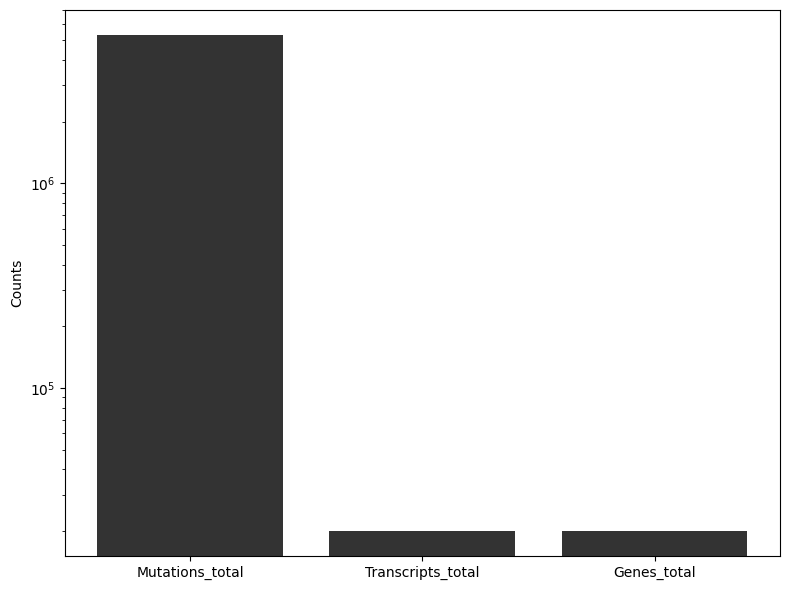

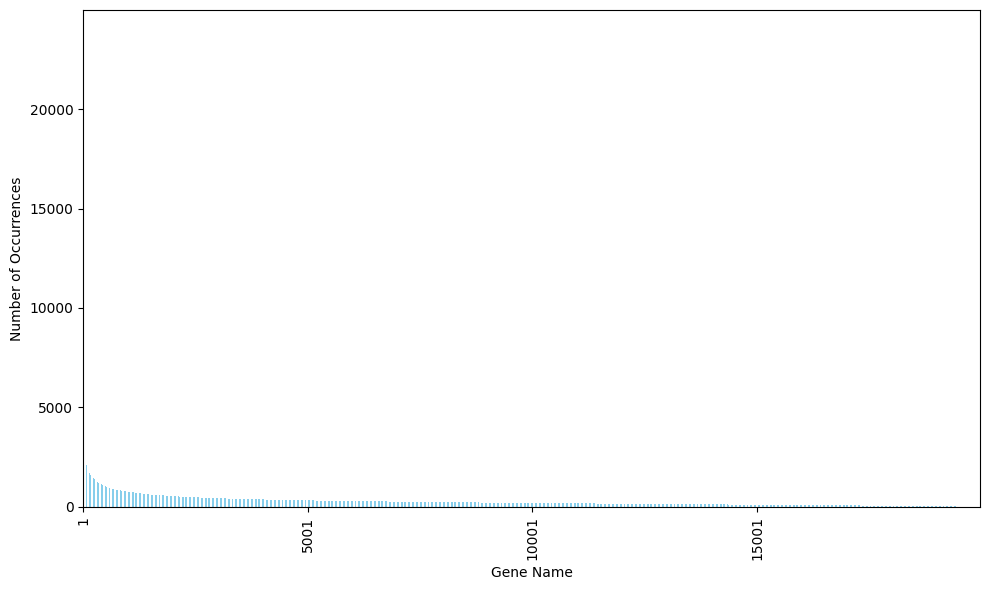

01:55:40 - INFO - Calculating nearby mutations


Processing groups:   0%|                                                                                                               | 0/20013 [00:00<?, ?it/s]

Processing groups:   0%|                                                                                                    | 1/20013 [00:05<29:26:44,  5.30s/it]

Processing groups:   0%|                                                                                                    | 11/20013 [00:05<1:59:10,  2.80it/s]

Processing groups:   0%|                                                                                                    | 17/20013 [00:05<1:08:57,  4.83it/s]

Processing groups:   0%|                                                                                                      | 24/20013 [00:05<41:45,  7.98it/s]

Processing groups:   0%|▏                                                                                                     | 34/20013 [00:05<24:06, 13.81it/s]

Processing groups:   0%|▏                                                                                                     | 42/20013 [00:05<17:15, 19.29it/s]

Processing groups:   0%|▎                                                                                                     | 52/20013 [00:05<11:56, 27.85it/s]

Processing groups:   0%|▎                                                                                                     | 64/20013 [00:06<08:24, 39.58it/s]

Processing groups:   0%|▎                                                                                                     | 73/20013 [00:06<07:23, 44.99it/s]

Processing groups:   0%|▍                                                                                                     | 82/20013 [00:06<06:34, 50.51it/s]

Processing groups:   0%|▍                                                                                                     | 90/20013 [00:06<05:59, 55.40it/s]

Processing groups:   0%|▌                                                                                                    | 100/20013 [00:06<05:14, 63.25it/s]

Processing groups:   1%|▌                                                                                                    | 109/20013 [00:06<04:50, 68.42it/s]

Processing groups:   1%|▌                                                                                                    | 118/20013 [00:06<04:30, 73.61it/s]

Processing groups:   1%|▋                                                                                                    | 128/20013 [00:06<04:15, 77.80it/s]

Processing groups:   1%|▋                                                                                                    | 138/20013 [00:06<03:58, 83.24it/s]

Processing groups:   1%|▋                                                                                                    | 147/20013 [00:07<04:53, 67.59it/s]

Processing groups:   1%|▊                                                                                                    | 155/20013 [00:07<05:22, 61.64it/s]

Processing groups:   1%|▊                                                                                                    | 163/20013 [00:07<05:06, 64.78it/s]

Processing groups:   1%|▊                                                                                                    | 172/20013 [00:07<04:49, 68.49it/s]

Processing groups:   1%|▉                                                                                                    | 180/20013 [00:07<05:23, 61.28it/s]

Processing groups:   1%|▉                                                                                                    | 189/20013 [00:07<04:52, 67.82it/s]

Processing groups:   1%|█                                                                                                    | 199/20013 [00:07<04:24, 74.91it/s]

Processing groups:   1%|█                                                                                                    | 211/20013 [00:08<03:57, 83.21it/s]

Processing groups:   1%|█                                                                                                    | 220/20013 [00:08<04:21, 75.70it/s]

Processing groups:   1%|█▏                                                                                                   | 232/20013 [00:08<03:48, 86.52it/s]

Processing groups:   1%|█▏                                                                                                   | 242/20013 [00:08<03:50, 85.65it/s]

Processing groups:   1%|█▎                                                                                                   | 253/20013 [00:08<03:35, 91.53it/s]

Processing groups:   1%|█▎                                                                                                   | 263/20013 [00:08<03:50, 85.64it/s]

Processing groups:   1%|█▍                                                                                                   | 274/20013 [00:08<03:43, 88.43it/s]

Processing groups:   1%|█▍                                                                                                   | 284/20013 [00:08<04:08, 79.49it/s]

Processing groups:   1%|█▍                                                                                                   | 294/20013 [00:09<03:56, 83.44it/s]

Processing groups:   2%|█▌                                                                                                   | 307/20013 [00:09<03:27, 95.10it/s]

Processing groups:   2%|█▌                                                                                                  | 319/20013 [00:09<03:14, 101.49it/s]

Processing groups:   2%|█▋                                                                                                  | 337/20013 [00:09<02:46, 118.23it/s]

Processing groups:   2%|█▊                                                                                                  | 352/20013 [00:09<02:35, 126.63it/s]

Processing groups:   2%|█▊                                                                                                  | 369/20013 [00:09<02:24, 135.69it/s]

Processing groups:   2%|█▉                                                                                                  | 385/20013 [00:09<02:21, 138.59it/s]

Processing groups:   2%|█▉                                                                                                  | 399/20013 [00:09<02:33, 127.50it/s]

Processing groups:   2%|██                                                                                                  | 412/20013 [00:09<02:42, 120.60it/s]

Processing groups:   2%|██                                                                                                  | 425/20013 [00:10<03:15, 100.22it/s]

Processing groups:   2%|██▏                                                                                                 | 438/20013 [00:10<03:10, 102.80it/s]

Processing groups:   2%|██▏                                                                                                 | 449/20013 [00:10<03:13, 101.10it/s]

Processing groups:   2%|██▎                                                                                                  | 460/20013 [00:10<03:44, 87.03it/s]

Processing groups:   2%|██▎                                                                                                  | 470/20013 [00:10<03:58, 81.87it/s]

Processing groups:   2%|██▍                                                                                                  | 479/20013 [00:10<04:02, 80.54it/s]

Processing groups:   2%|██▍                                                                                                  | 488/20013 [00:10<03:58, 81.73it/s]

Processing groups:   2%|██▌                                                                                                  | 500/20013 [00:10<03:33, 91.21it/s]

Processing groups:   3%|██▌                                                                                                  | 510/20013 [00:11<04:16, 76.08it/s]

Processing groups:   3%|██▌                                                                                                  | 519/20013 [00:11<04:13, 76.81it/s]

Processing groups:   3%|██▋                                                                                                  | 530/20013 [00:11<03:54, 83.16it/s]

Processing groups:   3%|██▋                                                                                                 | 547/20013 [00:11<03:05, 104.73it/s]

Processing groups:   3%|██▊                                                                                                 | 567/20013 [00:11<02:32, 127.49it/s]

Processing groups:   3%|██▉                                                                                                 | 581/20013 [00:11<02:48, 115.04it/s]

Processing groups:   3%|██▉                                                                                                 | 594/20013 [00:11<02:56, 109.83it/s]

Processing groups:   3%|███                                                                                                  | 606/20013 [00:12<03:28, 93.16it/s]

Processing groups:   3%|███                                                                                                 | 623/20013 [00:12<02:56, 110.02it/s]

Processing groups:   3%|███▏                                                                                                 | 635/20013 [00:12<03:20, 96.51it/s]

Processing groups:   3%|███▎                                                                                                | 651/20013 [00:12<02:55, 110.54it/s]

Processing groups:   3%|███▎                                                                                                | 666/20013 [00:12<02:42, 119.09it/s]

Processing groups:   3%|███▍                                                                                                | 679/20013 [00:12<02:39, 121.45it/s]

Processing groups:   3%|███▍                                                                                                | 695/20013 [00:12<02:29, 128.90it/s]

Processing groups:   4%|███▌                                                                                                | 709/20013 [00:12<02:48, 114.36it/s]

Processing groups:   4%|███▌                                                                                                | 722/20013 [00:13<02:52, 111.98it/s]

Processing groups:   4%|███▋                                                                                                | 736/20013 [00:13<02:42, 118.32it/s]

Processing groups:   4%|███▋                                                                                                | 750/20013 [00:13<02:35, 123.67it/s]

Processing groups:   4%|███▊                                                                                                | 764/20013 [00:13<02:32, 126.54it/s]

Processing groups:   4%|███▉                                                                                                | 778/20013 [00:13<02:29, 128.49it/s]

Processing groups:   4%|███▉                                                                                                | 792/20013 [00:13<02:34, 124.77it/s]

Processing groups:   4%|████                                                                                                | 810/20013 [00:13<02:19, 137.68it/s]

Processing groups:   4%|████▏                                                                                               | 829/20013 [00:13<02:07, 150.26it/s]

Processing groups:   4%|████▏                                                                                               | 845/20013 [00:13<02:11, 145.31it/s]

Processing groups:   4%|████▎                                                                                               | 860/20013 [00:14<02:32, 125.32it/s]

Processing groups:   4%|████▎                                                                                               | 874/20013 [00:14<02:59, 106.66it/s]

Processing groups:   4%|████▍                                                                                                | 886/20013 [00:14<03:23, 94.21it/s]

Processing groups:   4%|████▌                                                                                                | 897/20013 [00:14<03:29, 91.45it/s]

Processing groups:   5%|████▌                                                                                                | 907/20013 [00:14<03:38, 87.25it/s]

Processing groups:   5%|████▋                                                                                                | 917/20013 [00:14<03:52, 82.27it/s]

Processing groups:   5%|████▋                                                                                                | 926/20013 [00:14<04:17, 74.12it/s]

Processing groups:   5%|████▋                                                                                                | 936/20013 [00:15<04:04, 78.04it/s]

Processing groups:   5%|████▊                                                                                                | 949/20013 [00:15<03:33, 89.31it/s]

Processing groups:   5%|████▊                                                                                               | 964/20013 [00:15<03:02, 104.38it/s]

Processing groups:   5%|████▉                                                                                               | 978/20013 [00:15<02:47, 113.52it/s]

Processing groups:   5%|████▉                                                                                               | 993/20013 [00:15<02:38, 119.93it/s]

Processing groups:   5%|████▉                                                                                              | 1006/20013 [00:15<02:56, 107.55it/s]

Processing groups:   5%|█████                                                                                              | 1018/20013 [00:15<02:59, 105.71it/s]

Processing groups:   5%|█████▏                                                                                              | 1029/20013 [00:16<04:55, 64.30it/s]

Processing groups:   5%|█████▏                                                                                              | 1038/20013 [00:16<04:48, 65.71it/s]

Processing groups:   5%|█████▏                                                                                              | 1047/20013 [00:16<04:37, 68.27it/s]

Processing groups:   5%|█████▎                                                                                              | 1055/20013 [00:16<04:41, 67.39it/s]

Processing groups:   5%|█████▎                                                                                              | 1066/20013 [00:16<04:09, 75.90it/s]

Processing groups:   5%|█████▍                                                                                              | 1081/20013 [00:16<03:32, 88.98it/s]

Processing groups:   5%|█████▍                                                                                              | 1091/20013 [00:16<03:58, 79.42it/s]

Processing groups:   6%|█████▌                                                                                              | 1107/20013 [00:16<03:13, 97.64it/s]

Processing groups:   6%|█████▌                                                                                             | 1120/20013 [00:17<02:59, 105.23it/s]

Processing groups:   6%|█████▌                                                                                             | 1132/20013 [00:17<02:59, 105.45it/s]

Processing groups:   6%|█████▋                                                                                              | 1144/20013 [00:17<03:28, 90.66it/s]

Processing groups:   6%|█████▊                                                                                              | 1154/20013 [00:17<03:49, 82.17it/s]

Processing groups:   6%|█████▊                                                                                              | 1164/20013 [00:17<03:41, 85.25it/s]

Processing groups:   6%|█████▊                                                                                              | 1173/20013 [00:17<03:59, 78.60it/s]

Processing groups:   6%|█████▉                                                                                              | 1182/20013 [00:17<04:31, 69.34it/s]

Processing groups:   6%|█████▉                                                                                              | 1192/20013 [00:18<04:06, 76.27it/s]

Processing groups:   6%|██████                                                                                              | 1205/20013 [00:18<03:34, 87.88it/s]

Processing groups:   6%|██████                                                                                              | 1219/20013 [00:18<03:08, 99.85it/s]

Processing groups:   6%|██████                                                                                             | 1233/20013 [00:18<02:52, 108.90it/s]

Processing groups:   6%|██████▏                                                                                             | 1245/20013 [00:18<03:31, 88.77it/s]

Processing groups:   6%|██████▎                                                                                             | 1255/20013 [00:18<03:34, 87.48it/s]

Processing groups:   6%|██████▎                                                                                             | 1269/20013 [00:18<03:12, 97.49it/s]

Processing groups:   6%|██████▍                                                                                             | 1280/20013 [00:18<03:11, 97.82it/s]

Processing groups:   6%|██████▍                                                                                             | 1291/20013 [00:19<03:14, 96.17it/s]

Processing groups:   7%|██████▌                                                                                             | 1301/20013 [00:19<03:22, 92.39it/s]

Processing groups:   7%|██████▌                                                                                             | 1311/20013 [00:19<04:09, 74.93it/s]

Processing groups:   7%|██████▌                                                                                             | 1322/20013 [00:19<03:46, 82.69it/s]

Processing groups:   7%|██████▋                                                                                             | 1331/20013 [00:19<03:59, 78.03it/s]

Processing groups:   7%|██████▋                                                                                             | 1343/20013 [00:19<03:32, 88.06it/s]

Processing groups:   7%|██████▊                                                                                             | 1353/20013 [00:19<04:02, 76.89it/s]

Processing groups:   7%|██████▊                                                                                             | 1363/20013 [00:19<03:47, 81.94it/s]

Processing groups:   7%|██████▉                                                                                             | 1376/20013 [00:20<03:21, 92.70it/s]

Processing groups:   7%|██████▉                                                                                            | 1391/20013 [00:20<02:53, 107.40it/s]

Processing groups:   7%|██████▉                                                                                            | 1403/20013 [00:20<02:51, 108.58it/s]

Processing groups:   7%|███████                                                                                             | 1415/20013 [00:20<03:19, 93.19it/s]

Processing groups:   7%|███████▏                                                                                            | 1426/20013 [00:20<03:14, 95.40it/s]

Processing groups:   7%|███████                                                                                            | 1438/20013 [00:20<03:02, 101.58it/s]

Processing groups:   7%|███████▏                                                                                            | 1449/20013 [00:20<03:40, 84.32it/s]

Processing groups:   7%|███████▎                                                                                            | 1461/20013 [00:20<03:23, 91.04it/s]

Processing groups:   7%|███████▎                                                                                            | 1471/20013 [00:21<03:27, 89.15it/s]

Processing groups:   7%|███████▍                                                                                            | 1481/20013 [00:21<03:29, 88.30it/s]

Processing groups:   7%|███████▍                                                                                           | 1496/20013 [00:21<02:58, 103.59it/s]

Processing groups:   8%|███████▍                                                                                           | 1510/20013 [00:21<02:46, 111.03it/s]

Processing groups:   8%|███████▌                                                                                           | 1523/20013 [00:21<02:39, 116.02it/s]

Processing groups:   8%|███████▌                                                                                           | 1536/20013 [00:21<02:35, 118.86it/s]

Processing groups:   8%|███████▋                                                                                           | 1549/20013 [00:21<02:39, 115.69it/s]

Processing groups:   8%|███████▋                                                                                           | 1561/20013 [00:21<02:44, 111.91it/s]

Processing groups:   8%|███████▊                                                                                           | 1575/20013 [00:21<02:34, 119.35it/s]

Processing groups:   8%|███████▊                                                                                           | 1588/20013 [00:22<02:58, 102.96it/s]

Processing groups:   8%|███████▉                                                                                            | 1599/20013 [00:22<03:16, 93.87it/s]

Processing groups:   8%|████████                                                                                            | 1611/20013 [00:22<03:04, 99.73it/s]

Processing groups:   8%|████████                                                                                            | 1622/20013 [00:22<03:16, 93.80it/s]

Processing groups:   8%|████████▏                                                                                           | 1632/20013 [00:22<03:20, 91.59it/s]

Processing groups:   8%|████████▏                                                                                           | 1642/20013 [00:22<03:21, 91.14it/s]

Processing groups:   8%|████████▏                                                                                          | 1659/20013 [00:22<02:46, 110.24it/s]

Processing groups:   8%|████████▎                                                                                          | 1672/20013 [00:22<02:39, 115.34it/s]

Processing groups:   8%|████████▎                                                                                          | 1684/20013 [00:23<02:38, 115.69it/s]

Processing groups:   8%|████████▍                                                                                           | 1696/20013 [00:23<03:03, 99.75it/s]

Processing groups:   9%|████████▌                                                                                           | 1707/20013 [00:23<03:33, 85.84it/s]

Processing groups:   9%|████████▌                                                                                           | 1717/20013 [00:23<04:20, 70.29it/s]

Processing groups:   9%|████████▌                                                                                           | 1725/20013 [00:23<04:49, 63.18it/s]

Processing groups:   9%|████████▋                                                                                           | 1732/20013 [00:23<05:02, 60.42it/s]

Processing groups:   9%|████████▋                                                                                           | 1739/20013 [00:23<04:55, 61.82it/s]

Processing groups:   9%|████████▋                                                                                           | 1746/20013 [00:24<04:52, 62.49it/s]

Processing groups:   9%|████████▊                                                                                           | 1754/20013 [00:24<04:45, 63.91it/s]

Processing groups:   9%|████████▊                                                                                           | 1766/20013 [00:24<03:54, 77.68it/s]

Processing groups:   9%|████████▊                                                                                           | 1775/20013 [00:24<03:50, 79.02it/s]

Processing groups:   9%|████████▉                                                                                           | 1787/20013 [00:24<03:25, 88.86it/s]

Processing groups:   9%|████████▉                                                                                           | 1797/20013 [00:24<03:35, 84.70it/s]

Processing groups:   9%|█████████                                                                                           | 1806/20013 [00:24<03:53, 78.06it/s]

Processing groups:   9%|█████████                                                                                           | 1816/20013 [00:24<03:38, 83.31it/s]

Processing groups:   9%|█████████                                                                                           | 1825/20013 [00:24<03:35, 84.27it/s]

Processing groups:   9%|█████████▏                                                                                          | 1835/20013 [00:25<03:25, 88.52it/s]

Processing groups:   9%|█████████▏                                                                                          | 1848/20013 [00:25<03:04, 98.24it/s]

Processing groups:   9%|█████████▎                                                                                          | 1859/20013 [00:25<03:02, 99.66it/s]

Processing groups:   9%|█████████▎                                                                                          | 1870/20013 [00:25<03:25, 88.31it/s]

Processing groups:   9%|█████████▍                                                                                          | 1880/20013 [00:25<03:21, 89.83it/s]

Processing groups:   9%|█████████▍                                                                                          | 1890/20013 [00:25<03:17, 91.92it/s]

Processing groups:   9%|█████████▍                                                                                          | 1900/20013 [00:25<04:00, 75.41it/s]

Processing groups:  10%|█████████▌                                                                                          | 1911/20013 [00:25<03:41, 81.73it/s]

Processing groups:  10%|█████████▌                                                                                          | 1922/20013 [00:26<03:23, 88.78it/s]

Processing groups:  10%|█████████▋                                                                                          | 1932/20013 [00:26<03:46, 79.77it/s]

Processing groups:  10%|█████████▋                                                                                          | 1941/20013 [00:26<03:49, 78.88it/s]

Processing groups:  10%|█████████▋                                                                                          | 1950/20013 [00:26<03:55, 76.64it/s]

Processing groups:  10%|█████████▊                                                                                          | 1958/20013 [00:26<04:19, 69.58it/s]

Processing groups:  10%|█████████▊                                                                                          | 1966/20013 [00:26<05:12, 57.81it/s]

Processing groups:  10%|█████████▊                                                                                          | 1976/20013 [00:26<04:36, 65.22it/s]

Processing groups:  10%|█████████▉                                                                                          | 1989/20013 [00:27<03:45, 79.76it/s]

Processing groups:  10%|█████████▉                                                                                          | 1998/20013 [00:27<03:44, 80.18it/s]

Processing groups:  10%|██████████                                                                                          | 2007/20013 [00:27<04:07, 72.76it/s]

Processing groups:  10%|██████████                                                                                          | 2022/20013 [00:27<03:16, 91.39it/s]

Processing groups:  10%|██████████▏                                                                                         | 2032/20013 [00:27<04:52, 61.49it/s]

Processing groups:  10%|██████████▏                                                                                         | 2040/20013 [00:27<04:50, 61.96it/s]

Processing groups:  10%|██████████▏                                                                                         | 2048/20013 [00:27<04:33, 65.59it/s]

Processing groups:  10%|██████████▎                                                                                         | 2056/20013 [00:28<04:26, 67.46it/s]

Processing groups:  10%|██████████▎                                                                                         | 2067/20013 [00:28<03:55, 76.25it/s]

Processing groups:  10%|██████████▎                                                                                         | 2076/20013 [00:28<04:03, 73.61it/s]

Processing groups:  10%|██████████▍                                                                                         | 2084/20013 [00:28<05:37, 53.16it/s]

Processing groups:  10%|██████████▍                                                                                         | 2091/20013 [00:28<06:02, 49.44it/s]

Processing groups:  10%|██████████▍                                                                                         | 2099/20013 [00:28<05:31, 54.08it/s]

Processing groups:  11%|██████████▌                                                                                         | 2107/20013 [00:28<05:10, 57.62it/s]

Processing groups:  11%|██████████▌                                                                                         | 2118/20013 [00:29<04:18, 69.16it/s]

Processing groups:  11%|██████████▋                                                                                         | 2127/20013 [00:29<04:05, 72.82it/s]

Processing groups:  11%|██████████▋                                                                                         | 2141/20013 [00:29<03:20, 89.19it/s]

Processing groups:  11%|██████████▋                                                                                         | 2151/20013 [00:29<03:25, 86.72it/s]

Processing groups:  11%|██████████▊                                                                                         | 2161/20013 [00:29<03:33, 83.62it/s]

Processing groups:  11%|██████████▊                                                                                         | 2173/20013 [00:29<03:14, 91.95it/s]

Processing groups:  11%|██████████▉                                                                                         | 2185/20013 [00:29<03:01, 98.37it/s]

Processing groups:  11%|██████████▊                                                                                        | 2198/20013 [00:29<02:49, 104.82it/s]

Processing groups:  11%|██████████▉                                                                                        | 2209/20013 [00:29<02:51, 103.53it/s]

Processing groups:  11%|███████████                                                                                        | 2224/20013 [00:30<02:38, 112.39it/s]

Processing groups:  11%|███████████                                                                                        | 2236/20013 [00:30<02:36, 113.66it/s]

Processing groups:  11%|███████████                                                                                        | 2248/20013 [00:30<02:36, 113.47it/s]

Processing groups:  11%|███████████▏                                                                                       | 2260/20013 [00:30<02:38, 111.77it/s]

Processing groups:  11%|███████████▎                                                                                       | 2278/20013 [00:30<02:15, 130.89it/s]

Processing groups:  11%|███████████▍                                                                                        | 2292/20013 [00:30<03:07, 94.64it/s]

Processing groups:  12%|███████████▌                                                                                        | 2303/20013 [00:30<03:23, 87.24it/s]

Processing groups:  12%|███████████▌                                                                                        | 2313/20013 [00:31<04:06, 71.89it/s]

Processing groups:  12%|███████████▌                                                                                        | 2323/20013 [00:31<03:49, 77.09it/s]

Processing groups:  12%|███████████▋                                                                                        | 2333/20013 [00:31<03:36, 81.65it/s]

Processing groups:  12%|███████████▋                                                                                        | 2345/20013 [00:31<03:20, 87.97it/s]

Processing groups:  12%|███████████▊                                                                                        | 2355/20013 [00:31<03:15, 90.32it/s]

Processing groups:  12%|███████████▊                                                                                        | 2365/20013 [00:31<03:13, 91.10it/s]

Processing groups:  12%|███████████▊                                                                                        | 2375/20013 [00:31<03:17, 89.22it/s]

Processing groups:  12%|███████████▉                                                                                        | 2385/20013 [00:31<03:21, 87.54it/s]

Processing groups:  12%|███████████▉                                                                                       | 2403/20013 [00:31<02:40, 109.43it/s]

Processing groups:  12%|████████████                                                                                        | 2415/20013 [00:32<03:19, 88.33it/s]

Processing groups:  12%|████████████                                                                                        | 2425/20013 [00:32<03:16, 89.49it/s]

Processing groups:  12%|████████████▏                                                                                       | 2437/20013 [00:32<03:04, 95.41it/s]

Processing groups:  12%|████████████▏                                                                                       | 2448/20013 [00:32<03:06, 94.13it/s]

Processing groups:  12%|████████████▎                                                                                       | 2458/20013 [00:32<03:17, 88.77it/s]

Processing groups:  12%|████████████▎                                                                                       | 2468/20013 [00:32<03:28, 84.02it/s]

Processing groups:  12%|████████████▍                                                                                       | 2479/20013 [00:32<03:13, 90.50it/s]

Processing groups:  12%|████████████▍                                                                                       | 2489/20013 [00:32<03:11, 91.45it/s]

Processing groups:  12%|████████████▍                                                                                       | 2499/20013 [00:33<03:22, 86.29it/s]

Processing groups:  13%|████████████▌                                                                                       | 2508/20013 [00:33<03:45, 77.78it/s]

Processing groups:  13%|████████████▌                                                                                       | 2521/20013 [00:33<03:14, 89.73it/s]

Processing groups:  13%|████████████▋                                                                                       | 2532/20013 [00:33<03:17, 88.34it/s]

Processing groups:  13%|████████████▋                                                                                       | 2542/20013 [00:33<03:13, 90.28it/s]

Processing groups:  13%|████████████▊                                                                                       | 2554/20013 [00:33<02:59, 97.18it/s]

Processing groups:  13%|████████████▊                                                                                       | 2564/20013 [00:33<03:11, 91.16it/s]

Processing groups:  13%|████████████▊                                                                                       | 2574/20013 [00:33<03:09, 91.82it/s]

Processing groups:  13%|████████████▉                                                                                       | 2584/20013 [00:34<04:27, 65.16it/s]

Processing groups:  13%|████████████▉                                                                                       | 2597/20013 [00:34<03:45, 77.12it/s]

Processing groups:  13%|█████████████                                                                                       | 2607/20013 [00:34<03:37, 80.20it/s]

Processing groups:  13%|█████████████                                                                                       | 2616/20013 [00:34<04:10, 69.57it/s]

Processing groups:  13%|█████████████▏                                                                                      | 2627/20013 [00:34<03:48, 76.22it/s]

Processing groups:  13%|█████████████▏                                                                                      | 2636/20013 [00:34<04:09, 69.75it/s]

Processing groups:  13%|█████████████▏                                                                                      | 2645/20013 [00:34<04:00, 72.25it/s]

Processing groups:  13%|█████████████▎                                                                                      | 2653/20013 [00:35<04:08, 69.76it/s]

Processing groups:  13%|█████████████▎                                                                                      | 2664/20013 [00:35<03:48, 75.94it/s]

Processing groups:  13%|█████████████▍                                                                                      | 2677/20013 [00:35<03:16, 88.33it/s]

Processing groups:  13%|█████████████▍                                                                                      | 2687/20013 [00:35<03:51, 74.93it/s]

Processing groups:  13%|█████████████▍                                                                                      | 2696/20013 [00:35<03:44, 76.99it/s]

Processing groups:  14%|█████████████▌                                                                                      | 2706/20013 [00:35<03:32, 81.45it/s]

Processing groups:  14%|█████████████▌                                                                                      | 2715/20013 [00:35<03:36, 79.83it/s]

Processing groups:  14%|█████████████▋                                                                                      | 2727/20013 [00:35<03:17, 87.67it/s]

Processing groups:  14%|█████████████▋                                                                                      | 2739/20013 [00:36<03:00, 95.44it/s]

Processing groups:  14%|█████████████▋                                                                                      | 2749/20013 [00:36<02:59, 96.42it/s]

Processing groups:  14%|█████████████▊                                                                                      | 2759/20013 [00:36<03:15, 88.35it/s]

Processing groups:  14%|█████████████▊                                                                                      | 2769/20013 [00:36<03:09, 90.82it/s]

Processing groups:  14%|█████████████▉                                                                                      | 2779/20013 [00:36<03:22, 85.19it/s]

Processing groups:  14%|█████████████▉                                                                                      | 2791/20013 [00:36<03:05, 92.68it/s]

Processing groups:  14%|█████████████▊                                                                                     | 2804/20013 [00:36<02:48, 102.20it/s]

Processing groups:  14%|██████████████                                                                                      | 2815/20013 [00:36<03:13, 88.76it/s]

Processing groups:  14%|██████████████                                                                                      | 2825/20013 [00:37<03:31, 81.26it/s]

Processing groups:  14%|██████████████▏                                                                                     | 2834/20013 [00:37<03:27, 82.71it/s]

Processing groups:  14%|██████████████▏                                                                                     | 2843/20013 [00:37<04:00, 71.39it/s]

Processing groups:  14%|██████████████▏                                                                                     | 2851/20013 [00:37<04:11, 68.27it/s]

Processing groups:  14%|██████████████▎                                                                                     | 2859/20013 [00:37<04:15, 67.19it/s]

Processing groups:  14%|██████████████▎                                                                                     | 2868/20013 [00:37<04:05, 69.87it/s]

Processing groups:  14%|██████████████▎                                                                                     | 2876/20013 [00:37<04:52, 58.58it/s]

Processing groups:  14%|██████████████▍                                                                                     | 2885/20013 [00:37<04:21, 65.50it/s]

Processing groups:  14%|██████████████▍                                                                                     | 2893/20013 [00:38<05:10, 55.20it/s]

Processing groups:  14%|██████████████▍                                                                                     | 2900/20013 [00:38<05:39, 50.43it/s]

Processing groups:  15%|██████████████▌                                                                                     | 2907/20013 [00:38<05:20, 53.35it/s]

Processing groups:  15%|██████████████▌                                                                                     | 2916/20013 [00:38<04:43, 60.41it/s]

Processing groups:  15%|██████████████▌                                                                                     | 2925/20013 [00:38<04:16, 66.63it/s]

Processing groups:  15%|██████████████▋                                                                                     | 2936/20013 [00:38<03:46, 75.50it/s]

Processing groups:  15%|██████████████▋                                                                                     | 2944/20013 [00:39<04:44, 60.03it/s]

Processing groups:  15%|██████████████▊                                                                                     | 2952/20013 [00:39<04:37, 61.49it/s]

Processing groups:  15%|██████████████▊                                                                                     | 2960/20013 [00:39<04:25, 64.18it/s]

Processing groups:  15%|██████████████▊                                                                                     | 2969/20013 [00:39<04:19, 65.66it/s]

Processing groups:  15%|██████████████▊                                                                                     | 2976/20013 [00:39<06:19, 44.89it/s]

Processing groups:  15%|██████████████▉                                                                                     | 2982/20013 [00:39<07:17, 38.95it/s]

Processing groups:  15%|██████████████▉                                                                                     | 2987/20013 [00:40<07:02, 40.34it/s]

Processing groups:  15%|██████████████▉                                                                                     | 2992/20013 [00:40<06:53, 41.20it/s]

Processing groups:  15%|██████████████▉                                                                                     | 2998/20013 [00:40<06:54, 41.00it/s]

Processing groups:  15%|███████████████                                                                                     | 3010/20013 [00:40<04:51, 58.35it/s]

Processing groups:  15%|███████████████                                                                                     | 3018/20013 [00:40<04:29, 63.11it/s]

Processing groups:  15%|███████████████                                                                                     | 3025/20013 [00:40<04:26, 63.79it/s]

Processing groups:  15%|███████████████▏                                                                                    | 3032/20013 [00:40<05:12, 54.41it/s]

Processing groups:  15%|███████████████▏                                                                                    | 3041/20013 [00:40<04:37, 61.17it/s]

Processing groups:  15%|███████████████▏                                                                                    | 3050/20013 [00:40<04:22, 64.65it/s]

Processing groups:  15%|███████████████▎                                                                                    | 3058/20013 [00:41<04:11, 67.52it/s]

Processing groups:  15%|███████████████▎                                                                                    | 3066/20013 [00:41<04:11, 67.41it/s]

Processing groups:  15%|███████████████▎                                                                                    | 3074/20013 [00:41<04:13, 66.69it/s]

Processing groups:  15%|███████████████▍                                                                                    | 3084/20013 [00:41<03:47, 74.44it/s]

Processing groups:  15%|███████████████▍                                                                                    | 3092/20013 [00:41<04:38, 60.85it/s]

Processing groups:  15%|███████████████▍                                                                                    | 3101/20013 [00:41<04:10, 67.55it/s]

Processing groups:  16%|███████████████▌                                                                                    | 3109/20013 [00:41<05:32, 50.87it/s]

Processing groups:  16%|███████████████▌                                                                                    | 3116/20013 [00:42<06:48, 41.39it/s]

Processing groups:  16%|███████████████▌                                                                                    | 3123/20013 [00:42<06:07, 45.96it/s]

Processing groups:  16%|███████████████▋                                                                                    | 3134/20013 [00:42<04:51, 57.83it/s]

Processing groups:  16%|███████████████▋                                                                                    | 3144/20013 [00:42<04:16, 65.82it/s]

Processing groups:  16%|███████████████▋                                                                                    | 3152/20013 [00:42<04:28, 62.70it/s]

Processing groups:  16%|███████████████▊                                                                                    | 3163/20013 [00:42<03:50, 73.04it/s]

Processing groups:  16%|███████████████▊                                                                                    | 3173/20013 [00:42<03:32, 79.40it/s]

Processing groups:  16%|███████████████▉                                                                                    | 3182/20013 [00:43<03:26, 81.65it/s]

Processing groups:  16%|███████████████▉                                                                                    | 3191/20013 [00:43<03:40, 76.21it/s]

Processing groups:  16%|███████████████▉                                                                                    | 3200/20013 [00:43<03:36, 77.83it/s]

Processing groups:  16%|████████████████                                                                                    | 3210/20013 [00:43<03:28, 80.40it/s]

Processing groups:  16%|████████████████                                                                                    | 3219/20013 [00:43<03:29, 80.07it/s]

Processing groups:  16%|████████████████▏                                                                                   | 3228/20013 [00:43<04:09, 67.31it/s]

Processing groups:  16%|████████████████▏                                                                                   | 3236/20013 [00:43<05:02, 55.41it/s]

Processing groups:  16%|████████████████▏                                                                                   | 3243/20013 [00:44<05:12, 53.63it/s]

Processing groups:  16%|████████████████▎                                                                                   | 3254/20013 [00:44<04:19, 64.47it/s]

Processing groups:  16%|████████████████▎                                                                                   | 3266/20013 [00:44<03:39, 76.32it/s]

Processing groups:  16%|████████████████▍                                                                                   | 3279/20013 [00:44<03:11, 87.34it/s]

Processing groups:  16%|████████████████▍                                                                                   | 3289/20013 [00:44<03:05, 90.39it/s]

Processing groups:  16%|████████████████▍                                                                                   | 3299/20013 [00:44<03:16, 85.04it/s]

Processing groups:  17%|████████████████▌                                                                                   | 3308/20013 [00:44<03:46, 73.69it/s]

Processing groups:  17%|████████████████▌                                                                                   | 3320/20013 [00:44<03:20, 83.27it/s]

Processing groups:  17%|████████████████▋                                                                                   | 3329/20013 [00:44<03:22, 82.31it/s]

Processing groups:  17%|████████████████▋                                                                                   | 3340/20013 [00:45<03:06, 89.33it/s]

Processing groups:  17%|████████████████▋                                                                                   | 3350/20013 [00:45<03:26, 80.73it/s]

Processing groups:  17%|████████████████▊                                                                                   | 3359/20013 [00:45<03:38, 76.12it/s]

Processing groups:  17%|████████████████▊                                                                                   | 3367/20013 [00:45<03:57, 70.15it/s]

Processing groups:  17%|████████████████▊                                                                                   | 3375/20013 [00:45<04:17, 64.58it/s]

Processing groups:  17%|████████████████▉                                                                                   | 3382/20013 [00:45<04:26, 62.41it/s]

Processing groups:  17%|████████████████▉                                                                                   | 3389/20013 [00:45<05:00, 55.31it/s]

Processing groups:  17%|████████████████▉                                                                                   | 3397/20013 [00:46<04:34, 60.43it/s]

Processing groups:  17%|█████████████████                                                                                   | 3406/20013 [00:46<04:22, 63.26it/s]

Processing groups:  17%|█████████████████                                                                                   | 3413/20013 [00:46<04:33, 60.62it/s]

Processing groups:  17%|█████████████████                                                                                   | 3420/20013 [00:46<05:02, 54.84it/s]

Processing groups:  17%|█████████████████                                                                                   | 3426/20013 [00:46<05:24, 51.05it/s]

Processing groups:  17%|█████████████████▏                                                                                  | 3432/20013 [00:46<05:59, 46.12it/s]

Processing groups:  17%|█████████████████▏                                                                                  | 3438/20013 [00:46<06:15, 44.18it/s]

Processing groups:  17%|█████████████████▏                                                                                  | 3448/20013 [00:47<14:28, 19.08it/s]

Processing groups:  17%|█████████████████▎                                                                                  | 3457/20013 [00:48<10:43, 25.72it/s]

Processing groups:  17%|█████████████████▎                                                                                  | 3466/20013 [00:48<08:29, 32.47it/s]

Processing groups:  17%|█████████████████▎                                                                                  | 3477/20013 [00:48<06:31, 42.22it/s]

Processing groups:  17%|█████████████████▍                                                                                  | 3489/20013 [00:48<05:00, 54.91it/s]

Processing groups:  17%|█████████████████▍                                                                                  | 3499/20013 [00:48<04:22, 62.93it/s]

Processing groups:  18%|█████████████████▌                                                                                  | 3508/20013 [00:48<04:08, 66.48it/s]

Processing groups:  18%|█████████████████▌                                                                                  | 3520/20013 [00:48<03:29, 78.64it/s]

Processing groups:  18%|█████████████████▋                                                                                  | 3530/20013 [00:48<03:17, 83.62it/s]

Processing groups:  18%|█████████████████▋                                                                                  | 3544/20013 [00:48<03:08, 87.56it/s]

Processing groups:  18%|█████████████████▊                                                                                  | 3554/20013 [00:49<03:52, 70.84it/s]

Processing groups:  18%|█████████████████▊                                                                                  | 3563/20013 [00:49<03:54, 70.07it/s]

Processing groups:  18%|█████████████████▊                                                                                  | 3574/20013 [00:49<03:29, 78.37it/s]

Processing groups:  18%|█████████████████▉                                                                                  | 3584/20013 [00:49<03:19, 82.26it/s]

Processing groups:  18%|█████████████████▉                                                                                  | 3594/20013 [00:49<03:27, 79.15it/s]

Processing groups:  18%|██████████████████                                                                                  | 3609/20013 [00:49<02:52, 94.87it/s]

Processing groups:  18%|██████████████████                                                                                  | 3620/20013 [00:49<03:23, 80.40it/s]

Processing groups:  18%|██████████████████▏                                                                                 | 3632/20013 [00:50<03:05, 88.40it/s]

Processing groups:  18%|██████████████████▏                                                                                 | 3642/20013 [00:50<03:11, 85.57it/s]

Processing groups:  18%|██████████████████▏                                                                                 | 3652/20013 [00:50<03:18, 82.23it/s]

Processing groups:  18%|██████████████████▎                                                                                 | 3665/20013 [00:50<02:56, 92.40it/s]

Processing groups:  18%|██████████████████▎                                                                                 | 3675/20013 [00:50<03:30, 77.74it/s]

Processing groups:  18%|██████████████████▍                                                                                 | 3689/20013 [00:50<02:58, 91.32it/s]

Processing groups:  18%|██████████████████▍                                                                                 | 3699/20013 [00:50<03:15, 83.47it/s]

Processing groups:  19%|██████████████████▌                                                                                 | 3708/20013 [00:51<03:37, 74.82it/s]

Processing groups:  19%|██████████████████▌                                                                                 | 3716/20013 [00:51<04:02, 67.20it/s]

Processing groups:  19%|██████████████████▌                                                                                 | 3724/20013 [00:51<04:01, 67.35it/s]

Processing groups:  19%|██████████████████▋                                                                                 | 3733/20013 [00:51<03:46, 71.85it/s]

Processing groups:  19%|██████████████████▋                                                                                 | 3743/20013 [00:51<03:34, 75.71it/s]

Processing groups:  19%|██████████████████▋                                                                                 | 3751/20013 [00:51<04:02, 67.07it/s]

Processing groups:  19%|██████████████████▊                                                                                 | 3762/20013 [00:51<03:33, 76.20it/s]

Processing groups:  19%|██████████████████▊                                                                                 | 3770/20013 [00:51<03:57, 68.35it/s]

Processing groups:  19%|██████████████████▉                                                                                 | 3780/20013 [00:52<03:44, 72.33it/s]

Processing groups:  19%|██████████████████▉                                                                                 | 3789/20013 [00:52<03:39, 73.86it/s]

Processing groups:  19%|██████████████████▉                                                                                 | 3797/20013 [00:52<03:35, 75.32it/s]

Processing groups:  19%|███████████████████                                                                                 | 3807/20013 [00:52<03:18, 81.75it/s]

Processing groups:  19%|███████████████████                                                                                 | 3821/20013 [00:52<02:50, 95.14it/s]

Processing groups:  19%|███████████████████▏                                                                                | 3831/20013 [00:52<02:49, 95.24it/s]

Processing groups:  19%|███████████████████▏                                                                                | 3841/20013 [00:52<03:48, 70.73it/s]

Processing groups:  19%|███████████████████▏                                                                                | 3851/20013 [00:52<03:32, 76.15it/s]

Processing groups:  19%|███████████████████▎                                                                                | 3863/20013 [00:53<03:09, 85.23it/s]

Processing groups:  19%|███████████████████▎                                                                                | 3873/20013 [00:53<03:11, 84.07it/s]

Processing groups:  19%|███████████████████▍                                                                                | 3882/20013 [00:53<03:50, 70.05it/s]

Processing groups:  19%|███████████████████▍                                                                                | 3895/20013 [00:53<03:19, 80.70it/s]

Processing groups:  20%|███████████████████▌                                                                                | 3907/20013 [00:53<03:03, 87.98it/s]

Processing groups:  20%|███████████████████▍                                                                               | 3923/20013 [00:53<02:32, 105.24it/s]

Processing groups:  20%|███████████████████▍                                                                               | 3935/20013 [00:53<02:38, 101.61it/s]

Processing groups:  20%|███████████████████▋                                                                                | 3946/20013 [00:53<02:42, 99.09it/s]

Processing groups:  20%|███████████████████▊                                                                                | 3958/20013 [00:54<02:50, 94.19it/s]

Processing groups:  20%|███████████████████▋                                                                               | 3970/20013 [00:54<02:40, 100.15it/s]

Processing groups:  20%|███████████████████▉                                                                                | 3981/20013 [00:54<03:25, 77.97it/s]

Processing groups:  20%|███████████████████▉                                                                                | 3994/20013 [00:54<03:01, 88.42it/s]

Processing groups:  20%|████████████████████                                                                                | 4004/20013 [00:54<03:01, 88.04it/s]

Processing groups:  20%|████████████████████                                                                                | 4014/20013 [00:54<03:05, 86.45it/s]

Processing groups:  20%|████████████████████                                                                                | 4024/20013 [00:54<03:20, 79.55it/s]

Processing groups:  20%|████████████████████▏                                                                               | 4035/20013 [00:54<03:09, 84.53it/s]

Processing groups:  20%|████████████████████▏                                                                               | 4044/20013 [00:55<03:24, 78.23it/s]

Processing groups:  20%|████████████████████▎                                                                               | 4055/20013 [00:55<03:08, 84.61it/s]

Processing groups:  20%|████████████████████▎                                                                               | 4064/20013 [00:55<03:08, 84.82it/s]

Processing groups:  20%|████████████████████▎                                                                               | 4073/20013 [00:55<03:42, 71.67it/s]

Processing groups:  20%|████████████████████▍                                                                               | 4081/20013 [00:55<03:41, 71.85it/s]

Processing groups:  20%|████████████████████▍                                                                               | 4089/20013 [00:55<03:38, 72.87it/s]

Processing groups:  20%|████████████████████▍                                                                               | 4099/20013 [00:55<03:19, 79.78it/s]

Processing groups:  21%|████████████████████▌                                                                               | 4108/20013 [00:55<03:17, 80.70it/s]

Processing groups:  21%|████████████████████▌                                                                               | 4117/20013 [00:56<03:33, 74.39it/s]

Processing groups:  21%|████████████████████▌                                                                               | 4125/20013 [00:56<03:43, 71.12it/s]

Processing groups:  21%|████████████████████▋                                                                               | 4138/20013 [00:56<03:04, 85.94it/s]

Processing groups:  21%|████████████████████▋                                                                               | 4149/20013 [00:56<02:52, 92.21it/s]

Processing groups:  21%|████████████████████▌                                                                              | 4162/20013 [00:56<02:38, 100.15it/s]

Processing groups:  21%|████████████████████▊                                                                               | 4173/20013 [00:56<02:43, 97.16it/s]

Processing groups:  21%|████████████████████▉                                                                               | 4183/20013 [00:56<02:55, 90.09it/s]

Processing groups:  21%|████████████████████▉                                                                               | 4194/20013 [00:56<02:48, 93.96it/s]

Processing groups:  21%|█████████████████████                                                                               | 4204/20013 [00:57<03:11, 82.52it/s]

Processing groups:  21%|█████████████████████                                                                               | 4215/20013 [00:57<02:58, 88.56it/s]

Processing groups:  21%|█████████████████████                                                                               | 4226/20013 [00:57<02:52, 91.64it/s]

Processing groups:  21%|█████████████████████▏                                                                              | 4238/20013 [00:57<02:42, 97.27it/s]

Processing groups:  21%|█████████████████████▏                                                                              | 4248/20013 [00:57<03:04, 85.62it/s]

Processing groups:  21%|█████████████████████▎                                                                              | 4257/20013 [00:57<03:04, 85.45it/s]

Processing groups:  21%|█████████████████████▎                                                                              | 4266/20013 [00:57<03:14, 80.80it/s]

Processing groups:  21%|█████████████████████▎                                                                              | 4276/20013 [00:57<03:09, 82.87it/s]

Processing groups:  21%|█████████████████████▍                                                                              | 4288/20013 [00:57<02:51, 91.63it/s]

Processing groups:  21%|█████████████████████▍                                                                              | 4298/20013 [00:58<03:04, 84.96it/s]

Processing groups:  22%|█████████████████████▌                                                                              | 4307/20013 [00:58<03:03, 85.43it/s]

Processing groups:  22%|█████████████████████▌                                                                              | 4319/20013 [00:58<02:48, 93.24it/s]

Processing groups:  22%|█████████████████████▋                                                                              | 4331/20013 [00:58<02:41, 97.29it/s]

Processing groups:  22%|█████████████████████▍                                                                             | 4343/20013 [00:58<02:31, 103.13it/s]

Processing groups:  22%|█████████████████████▊                                                                              | 4354/20013 [00:58<03:00, 86.71it/s]

Processing groups:  22%|█████████████████████▊                                                                              | 4364/20013 [00:58<03:23, 76.84it/s]

Processing groups:  22%|█████████████████████▊                                                                              | 4373/20013 [00:58<03:27, 75.31it/s]

Processing groups:  22%|█████████████████████▉                                                                              | 4384/20013 [00:59<03:10, 82.06it/s]

Processing groups:  22%|█████████████████████▉                                                                              | 4395/20013 [00:59<03:07, 83.14it/s]

Processing groups:  22%|██████████████████████                                                                              | 4408/20013 [00:59<02:47, 92.92it/s]

Processing groups:  22%|██████████████████████                                                                              | 4418/20013 [00:59<03:01, 85.94it/s]

Processing groups:  22%|██████████████████████▏                                                                             | 4429/20013 [00:59<02:49, 91.97it/s]

Processing groups:  22%|█████████████████████▉                                                                             | 4444/20013 [00:59<02:27, 105.62it/s]

Processing groups:  22%|██████████████████████                                                                             | 4459/20013 [00:59<02:15, 114.86it/s]

Processing groups:  22%|██████████████████████                                                                             | 4471/20013 [00:59<02:29, 103.82it/s]

Processing groups:  22%|██████████████████████▏                                                                            | 4486/20013 [01:00<02:15, 114.55it/s]

Processing groups:  22%|██████████████████████▎                                                                            | 4501/20013 [01:00<02:12, 116.80it/s]

Processing groups:  23%|██████████████████████▎                                                                            | 4514/20013 [01:00<02:09, 120.04it/s]

Processing groups:  23%|██████████████████████▍                                                                            | 4527/20013 [01:00<02:11, 117.85it/s]

Processing groups:  23%|██████████████████████▍                                                                            | 4539/20013 [01:00<02:19, 110.87it/s]

Processing groups:  23%|██████████████████████▌                                                                            | 4552/20013 [01:00<02:14, 115.24it/s]

Processing groups:  23%|██████████████████████▌                                                                            | 4564/20013 [01:00<02:21, 109.48it/s]

Processing groups:  23%|██████████████████████▋                                                                            | 4578/20013 [01:00<02:13, 115.90it/s]

Processing groups:  23%|██████████████████████▋                                                                            | 4592/20013 [01:00<02:06, 121.88it/s]

Processing groups:  23%|██████████████████████▊                                                                            | 4605/20013 [01:01<02:25, 105.96it/s]

Processing groups:  23%|███████████████████████                                                                             | 4617/20013 [01:01<03:00, 85.06it/s]

Processing groups:  23%|███████████████████████                                                                             | 4627/20013 [01:01<03:06, 82.32it/s]

Processing groups:  23%|███████████████████████▏                                                                            | 4637/20013 [01:01<02:59, 85.48it/s]

Processing groups:  23%|███████████████████████▏                                                                            | 4647/20013 [01:01<03:36, 71.01it/s]

Processing groups:  23%|███████████████████████▎                                                                            | 4658/20013 [01:01<03:13, 79.38it/s]

Processing groups:  23%|███████████████████████▎                                                                            | 4667/20013 [01:01<03:14, 78.88it/s]

Processing groups:  23%|███████████████████████▎                                                                            | 4677/20013 [01:02<03:06, 82.39it/s]

Processing groups:  23%|███████████████████████▍                                                                            | 4686/20013 [01:02<03:38, 70.21it/s]

Processing groups:  23%|███████████████████████▍                                                                            | 4695/20013 [01:02<03:31, 72.28it/s]

Processing groups:  24%|███████████████████████▌                                                                            | 4706/20013 [01:02<03:10, 80.25it/s]

Processing groups:  24%|███████████████████████▌                                                                            | 4716/20013 [01:02<03:09, 80.87it/s]

Processing groups:  24%|███████████████████████▌                                                                            | 4726/20013 [01:02<03:01, 84.20it/s]

Processing groups:  24%|███████████████████████▋                                                                            | 4737/20013 [01:02<02:51, 88.98it/s]

Processing groups:  24%|███████████████████████▋                                                                            | 4748/20013 [01:02<02:50, 89.53it/s]

Processing groups:  24%|███████████████████████▊                                                                            | 4758/20013 [01:03<02:52, 88.47it/s]

Processing groups:  24%|███████████████████████▊                                                                            | 4767/20013 [01:03<03:21, 75.72it/s]

Processing groups:  24%|███████████████████████▉                                                                            | 4780/20013 [01:03<02:57, 85.90it/s]

Processing groups:  24%|███████████████████████▉                                                                            | 4789/20013 [01:03<02:55, 86.52it/s]

Processing groups:  24%|███████████████████████▉                                                                            | 4801/20013 [01:03<02:43, 93.10it/s]

Processing groups:  24%|████████████████████████                                                                            | 4811/20013 [01:03<02:58, 85.37it/s]

Processing groups:  24%|████████████████████████                                                                            | 4823/20013 [01:03<02:42, 93.45it/s]

Processing groups:  24%|████████████████████████▏                                                                           | 4833/20013 [01:03<02:44, 92.47it/s]

Processing groups:  24%|███████████████████████▉                                                                           | 4846/20013 [01:03<02:29, 101.42it/s]

Processing groups:  24%|████████████████████████                                                                           | 4858/20013 [01:04<02:26, 103.68it/s]

Processing groups:  24%|████████████████████████                                                                           | 4869/20013 [01:04<02:28, 102.27it/s]

Processing groups:  24%|████████████████████████▏                                                                          | 4882/20013 [01:04<02:19, 108.28it/s]

Processing groups:  24%|████████████████████████▍                                                                           | 4893/20013 [01:04<02:46, 90.60it/s]

Processing groups:  25%|████████████████████████▌                                                                           | 4904/20013 [01:04<02:39, 94.68it/s]

Processing groups:  25%|████████████████████████▌                                                                           | 4914/20013 [01:04<03:05, 81.56it/s]

Processing groups:  25%|████████████████████████▌                                                                           | 4924/20013 [01:04<02:57, 84.95it/s]

Processing groups:  25%|████████████████████████▋                                                                           | 4933/20013 [01:04<03:01, 83.16it/s]

Processing groups:  25%|████████████████████████▋                                                                           | 4942/20013 [01:05<03:04, 81.55it/s]

Processing groups:  25%|████████████████████████▊                                                                           | 4955/20013 [01:05<02:42, 92.87it/s]

Processing groups:  25%|████████████████████████▊                                                                           | 4965/20013 [01:05<02:39, 94.47it/s]

Processing groups:  25%|████████████████████████▊                                                                           | 4977/20013 [01:05<02:30, 99.83it/s]

Processing groups:  25%|████████████████████████▉                                                                           | 4988/20013 [01:05<02:35, 96.33it/s]

Processing groups:  25%|████████████████████████▉                                                                           | 4998/20013 [01:05<03:24, 73.38it/s]

Processing groups:  25%|█████████████████████████                                                                           | 5007/20013 [01:05<03:40, 68.00it/s]

Processing groups:  25%|█████████████████████████                                                                           | 5015/20013 [01:06<05:44, 43.48it/s]

Processing groups:  25%|█████████████████████████                                                                           | 5022/20013 [01:06<05:15, 47.53it/s]

Processing groups:  25%|█████████████████████████▏                                                                          | 5032/20013 [01:06<04:21, 57.19it/s]

Processing groups:  25%|█████████████████████████▏                                                                          | 5043/20013 [01:06<03:40, 67.98it/s]

Processing groups:  25%|█████████████████████████▏                                                                          | 5052/20013 [01:06<03:48, 65.51it/s]

Processing groups:  25%|█████████████████████████▎                                                                          | 5060/20013 [01:07<05:42, 43.61it/s]

Processing groups:  25%|█████████████████████████▎                                                                          | 5066/20013 [01:07<05:36, 44.39it/s]

Processing groups:  25%|█████████████████████████▎                                                                          | 5073/20013 [01:07<05:07, 48.56it/s]

Processing groups:  25%|█████████████████████████▍                                                                          | 5080/20013 [01:07<04:41, 53.05it/s]

Processing groups:  25%|█████████████████████████▍                                                                          | 5089/20013 [01:07<04:02, 61.52it/s]

Processing groups:  25%|█████████████████████████▍                                                                          | 5100/20013 [01:07<03:26, 72.28it/s]

Processing groups:  26%|█████████████████████████▌                                                                          | 5111/20013 [01:07<03:06, 79.97it/s]

Processing groups:  26%|█████████████████████████▌                                                                          | 5121/20013 [01:07<02:57, 83.75it/s]

Processing groups:  26%|█████████████████████████▋                                                                          | 5132/20013 [01:08<03:04, 80.86it/s]

Processing groups:  26%|█████████████████████████▋                                                                          | 5146/20013 [01:08<02:35, 95.51it/s]

Processing groups:  26%|█████████████████████████▊                                                                          | 5157/20013 [01:08<02:32, 97.27it/s]

Processing groups:  26%|█████████████████████████▊                                                                          | 5168/20013 [01:08<02:52, 85.82it/s]

Processing groups:  26%|█████████████████████████▊                                                                          | 5178/20013 [01:08<02:55, 84.41it/s]

Processing groups:  26%|█████████████████████████▉                                                                          | 5187/20013 [01:08<04:12, 58.66it/s]

Processing groups:  26%|█████████████████████████▉                                                                          | 5195/20013 [01:08<03:59, 61.86it/s]

Processing groups:  26%|█████████████████████████▉                                                                          | 5203/20013 [01:09<03:51, 64.06it/s]

Processing groups:  26%|██████████████████████████                                                                          | 5212/20013 [01:09<03:33, 69.20it/s]

Processing groups:  26%|██████████████████████████                                                                          | 5222/20013 [01:09<03:16, 75.14it/s]

Processing groups:  26%|██████████████████████████▏                                                                         | 5234/20013 [01:09<02:50, 86.54it/s]

Processing groups:  26%|██████████████████████████▏                                                                         | 5245/20013 [01:09<02:40, 92.24it/s]

Processing groups:  26%|██████████████████████████▎                                                                         | 5257/20013 [01:09<02:28, 99.32it/s]

Processing groups:  26%|██████████████████████████▎                                                                         | 5269/20013 [01:09<02:36, 94.49it/s]

Processing groups:  26%|██████████████████████████▍                                                                         | 5279/20013 [01:09<03:24, 72.04it/s]

Processing groups:  26%|██████████████████████████▍                                                                         | 5288/20013 [01:10<03:17, 74.57it/s]

Processing groups:  26%|██████████████████████████▍                                                                         | 5297/20013 [01:10<03:19, 73.81it/s]

Processing groups:  27%|██████████████████████████▌                                                                         | 5305/20013 [01:10<03:43, 65.67it/s]

Processing groups:  27%|██████████████████████████▌                                                                         | 5313/20013 [01:10<03:33, 68.92it/s]

Processing groups:  27%|██████████████████████████▌                                                                         | 5321/20013 [01:10<03:43, 65.73it/s]

Processing groups:  27%|██████████████████████████▌                                                                         | 5328/20013 [01:10<03:45, 65.18it/s]

Processing groups:  27%|██████████████████████████▋                                                                         | 5336/20013 [01:10<03:35, 68.15it/s]

Processing groups:  27%|██████████████████████████▋                                                                         | 5343/20013 [01:11<05:19, 45.87it/s]

Processing groups:  27%|██████████████████████████▋                                                                         | 5351/20013 [01:11<04:41, 52.13it/s]

Processing groups:  27%|██████████████████████████▊                                                                         | 5363/20013 [01:11<03:48, 64.05it/s]

Processing groups:  27%|██████████████████████████▊                                                                         | 5371/20013 [01:11<03:41, 66.06it/s]

Processing groups:  27%|██████████████████████████▉                                                                         | 5386/20013 [01:11<02:50, 85.84it/s]

Processing groups:  27%|██████████████████████████▉                                                                         | 5396/20013 [01:11<02:48, 86.69it/s]

Processing groups:  27%|███████████████████████████                                                                         | 5406/20013 [01:11<02:45, 88.14it/s]

Processing groups:  27%|███████████████████████████                                                                         | 5416/20013 [01:11<03:01, 80.42it/s]

Processing groups:  27%|███████████████████████████                                                                         | 5427/20013 [01:11<02:50, 85.62it/s]

Processing groups:  27%|███████████████████████████▏                                                                        | 5441/20013 [01:12<02:32, 95.59it/s]

Processing groups:  27%|███████████████████████████▏                                                                        | 5451/20013 [01:12<02:41, 90.01it/s]

Processing groups:  27%|███████████████████████████▎                                                                        | 5461/20013 [01:12<02:38, 91.63it/s]

Processing groups:  27%|███████████████████████████▎                                                                        | 5471/20013 [01:12<02:38, 91.82it/s]

Processing groups:  27%|███████████████████████████▍                                                                        | 5481/20013 [01:12<03:15, 74.28it/s]

Processing groups:  27%|███████████████████████████▍                                                                        | 5492/20013 [01:12<02:56, 82.37it/s]

Processing groups:  27%|███████████████████████████▍                                                                        | 5503/20013 [01:12<02:49, 85.82it/s]

Processing groups:  28%|███████████████████████████▌                                                                        | 5514/20013 [01:12<02:41, 89.59it/s]

Processing groups:  28%|███████████████████████████▌                                                                        | 5524/20013 [01:13<02:45, 87.46it/s]

Processing groups:  28%|███████████████████████████▋                                                                        | 5535/20013 [01:13<02:35, 93.19it/s]

Processing groups:  28%|███████████████████████████▋                                                                        | 5545/20013 [01:13<02:37, 92.07it/s]

Processing groups:  28%|███████████████████████████▊                                                                        | 5555/20013 [01:13<02:39, 90.40it/s]

Processing groups:  28%|███████████████████████████▊                                                                        | 5565/20013 [01:13<03:06, 77.44it/s]

Processing groups:  28%|███████████████████████████▊                                                                        | 5577/20013 [01:13<02:44, 87.70it/s]

Processing groups:  28%|███████████████████████████▉                                                                        | 5587/20013 [01:13<02:57, 81.11it/s]

Processing groups:  28%|███████████████████████████▉                                                                        | 5596/20013 [01:13<03:19, 72.24it/s]

Processing groups:  28%|████████████████████████████                                                                        | 5606/20013 [01:14<03:04, 78.11it/s]

Processing groups:  28%|████████████████████████████                                                                        | 5615/20013 [01:14<03:25, 70.11it/s]

Processing groups:  28%|████████████████████████████                                                                        | 5625/20013 [01:14<03:07, 76.62it/s]

Processing groups:  28%|████████████████████████████▏                                                                       | 5634/20013 [01:14<03:24, 70.22it/s]

Processing groups:  28%|████████████████████████████▏                                                                       | 5642/20013 [01:14<03:40, 65.19it/s]

Processing groups:  28%|████████████████████████████▏                                                                       | 5651/20013 [01:14<03:24, 70.39it/s]

Processing groups:  28%|████████████████████████████▎                                                                       | 5659/20013 [01:14<03:21, 71.14it/s]

Processing groups:  28%|████████████████████████████▎                                                                       | 5669/20013 [01:14<03:05, 77.15it/s]

Processing groups:  28%|████████████████████████████▍                                                                       | 5681/20013 [01:15<02:42, 88.21it/s]

Processing groups:  28%|████████████████████████████▍                                                                       | 5692/20013 [01:15<02:39, 89.82it/s]

Processing groups:  28%|████████████████████████████▍                                                                       | 5702/20013 [01:15<02:57, 80.56it/s]

Processing groups:  29%|████████████████████████████▌                                                                       | 5711/20013 [01:15<03:24, 69.95it/s]

Processing groups:  29%|████████████████████████████▌                                                                       | 5720/20013 [01:15<03:15, 73.28it/s]

Processing groups:  29%|████████████████████████████▌                                                                       | 5728/20013 [01:15<03:17, 72.25it/s]

Processing groups:  29%|████████████████████████████▋                                                                       | 5740/20013 [01:15<02:53, 82.28it/s]

Processing groups:  29%|████████████████████████████▋                                                                       | 5749/20013 [01:15<02:58, 80.10it/s]

Processing groups:  29%|████████████████████████████▊                                                                       | 5758/20013 [01:16<02:54, 81.86it/s]

Processing groups:  29%|████████████████████████████▊                                                                       | 5769/20013 [01:16<02:42, 87.64it/s]

Processing groups:  29%|████████████████████████████▊                                                                       | 5778/20013 [01:16<02:44, 86.50it/s]

Processing groups:  29%|████████████████████████████▉                                                                       | 5791/20013 [01:16<02:24, 98.38it/s]

Processing groups:  29%|████████████████████████████▋                                                                      | 5802/20013 [01:16<02:19, 101.51it/s]

Processing groups:  29%|█████████████████████████████                                                                       | 5813/20013 [01:16<02:22, 99.96it/s]

Processing groups:  29%|████████████████████████████▊                                                                      | 5826/20013 [01:16<02:14, 105.28it/s]

Processing groups:  29%|█████████████████████████████▏                                                                      | 5837/20013 [01:16<02:26, 97.07it/s]

Processing groups:  29%|█████████████████████████████▏                                                                      | 5847/20013 [01:17<03:21, 70.24it/s]

Processing groups:  29%|█████████████████████████████▎                                                                      | 5859/20013 [01:17<02:58, 79.13it/s]

Processing groups:  29%|█████████████████████████████▎                                                                      | 5869/20013 [01:17<02:50, 82.78it/s]

Processing groups:  29%|█████████████████████████████▍                                                                      | 5882/20013 [01:17<02:31, 93.40it/s]

Processing groups:  29%|█████████████████████████████▍                                                                      | 5893/20013 [01:17<02:33, 92.20it/s]

Processing groups:  29%|█████████████████████████████▍                                                                      | 5903/20013 [01:17<02:31, 93.38it/s]

Processing groups:  30%|█████████████████████████████▌                                                                      | 5913/20013 [01:17<02:54, 80.83it/s]

Processing groups:  30%|█████████████████████████████▌                                                                      | 5928/20013 [01:17<02:24, 97.67it/s]

Processing groups:  30%|█████████████████████████████▋                                                                      | 5939/20013 [01:18<02:31, 92.98it/s]

Processing groups:  30%|█████████████████████████████▋                                                                      | 5949/20013 [01:18<02:38, 88.86it/s]

Processing groups:  30%|█████████████████████████████▊                                                                      | 5959/20013 [01:18<03:58, 58.90it/s]

Processing groups:  30%|█████████████████████████████▊                                                                      | 5967/20013 [01:18<03:55, 59.54it/s]

Processing groups:  30%|█████████████████████████████▊                                                                      | 5977/20013 [01:18<03:29, 66.90it/s]

Processing groups:  30%|█████████████████████████████▉                                                                      | 5985/20013 [01:18<03:31, 66.36it/s]

Processing groups:  30%|█████████████████████████████▉                                                                      | 5993/20013 [01:18<03:26, 67.96it/s]

Processing groups:  30%|█████████████████████████████▉                                                                      | 6002/20013 [01:19<03:16, 71.36it/s]

Processing groups:  30%|██████████████████████████████                                                                      | 6012/20013 [01:19<03:06, 75.06it/s]

Processing groups:  30%|██████████████████████████████                                                                      | 6025/20013 [01:19<02:37, 88.76it/s]

Processing groups:  30%|██████████████████████████████▏                                                                     | 6036/20013 [01:19<02:33, 91.23it/s]

Processing groups:  30%|██████████████████████████████▏                                                                     | 6050/20013 [01:19<02:21, 98.85it/s]

Processing groups:  30%|█████████████████████████████▉                                                                     | 6062/20013 [01:19<02:14, 104.11it/s]

Processing groups:  30%|██████████████████████████████                                                                     | 6073/20013 [01:19<02:12, 104.87it/s]

Processing groups:  30%|██████████████████████████████▍                                                                     | 6084/20013 [01:19<02:21, 98.22it/s]

Processing groups:  30%|██████████████████████████████▍                                                                     | 6095/20013 [01:19<02:19, 99.70it/s]

Processing groups:  31%|██████████████████████████████▌                                                                     | 6106/20013 [01:20<02:28, 93.36it/s]

Processing groups:  31%|██████████████████████████████▎                                                                    | 6119/20013 [01:20<02:15, 102.36it/s]

Processing groups:  31%|██████████████████████████████▎                                                                    | 6132/20013 [01:20<02:07, 108.60it/s]

Processing groups:  31%|██████████████████████████████▍                                                                    | 6145/20013 [01:20<02:02, 113.45it/s]

Processing groups:  31%|██████████████████████████████▍                                                                    | 6157/20013 [01:20<02:03, 112.09it/s]

Processing groups:  31%|██████████████████████████████▌                                                                    | 6169/20013 [01:20<02:05, 110.53it/s]

Processing groups:  31%|██████████████████████████████▌                                                                    | 6181/20013 [01:20<02:03, 111.80it/s]

Processing groups:  31%|██████████████████████████████▋                                                                    | 6194/20013 [01:20<02:00, 114.92it/s]

Processing groups:  31%|██████████████████████████████▋                                                                    | 6207/20013 [01:20<01:58, 116.09it/s]

Processing groups:  31%|██████████████████████████████▊                                                                    | 6219/20013 [01:21<01:59, 115.41it/s]

Processing groups:  31%|██████████████████████████████▊                                                                    | 6232/20013 [01:21<01:56, 118.78it/s]

Processing groups:  31%|██████████████████████████████▉                                                                    | 6244/20013 [01:21<02:03, 111.61it/s]

Processing groups:  31%|██████████████████████████████▉                                                                    | 6256/20013 [01:21<02:01, 113.42it/s]

Processing groups:  31%|███████████████████████████████                                                                    | 6268/20013 [01:21<02:12, 103.44it/s]

Processing groups:  31%|███████████████████████████████▎                                                                    | 6279/20013 [01:21<02:21, 96.95it/s]

Processing groups:  31%|███████████████████████████████▍                                                                    | 6290/20013 [01:21<02:22, 96.15it/s]

Processing groups:  31%|███████████████████████████████▍                                                                    | 6300/20013 [01:21<02:24, 94.90it/s]

Processing groups:  32%|███████████████████████████████▌                                                                    | 6311/20013 [01:21<02:21, 96.75it/s]

Processing groups:  32%|███████████████████████████████▎                                                                   | 6322/20013 [01:22<02:16, 100.04it/s]

Processing groups:  32%|███████████████████████████████▎                                                                   | 6334/20013 [01:22<02:10, 104.68it/s]

Processing groups:  32%|███████████████████████████████▋                                                                    | 6345/20013 [01:22<02:20, 97.30it/s]

Processing groups:  32%|███████████████████████████████▊                                                                    | 6355/20013 [01:22<02:21, 96.36it/s]

Processing groups:  32%|███████████████████████████████▊                                                                    | 6365/20013 [01:22<03:10, 71.78it/s]

Processing groups:  32%|███████████████████████████████▊                                                                    | 6374/20013 [01:22<03:19, 68.42it/s]

Processing groups:  32%|███████████████████████████████▉                                                                    | 6383/20013 [01:22<03:09, 72.07it/s]

Processing groups:  32%|███████████████████████████████▉                                                                    | 6391/20013 [01:23<03:19, 68.28it/s]

Processing groups:  32%|███████████████████████████████▉                                                                    | 6400/20013 [01:23<03:08, 72.36it/s]

Processing groups:  32%|████████████████████████████████                                                                    | 6413/20013 [01:23<02:37, 86.20it/s]

Processing groups:  32%|████████████████████████████████                                                                    | 6423/20013 [01:23<02:34, 87.83it/s]

Processing groups:  32%|████████████████████████████████▏                                                                   | 6433/20013 [01:23<02:30, 90.45it/s]

Processing groups:  32%|████████████████████████████████▏                                                                   | 6445/20013 [01:23<02:18, 97.68it/s]

Processing groups:  32%|████████████████████████████████▎                                                                   | 6455/20013 [01:23<02:23, 94.46it/s]

Processing groups:  32%|████████████████████████████████▎                                                                   | 6465/20013 [01:23<03:04, 73.56it/s]

Processing groups:  32%|████████████████████████████████▎                                                                   | 6478/20013 [01:23<02:36, 86.51it/s]

Processing groups:  32%|████████████████████████████████▍                                                                   | 6490/20013 [01:24<02:26, 92.55it/s]

Processing groups:  32%|████████████████████████████████▍                                                                   | 6502/20013 [01:24<02:19, 96.99it/s]

Processing groups:  33%|████████████████████████████████▌                                                                   | 6513/20013 [01:24<02:20, 95.95it/s]

Processing groups:  33%|████████████████████████████████▌                                                                   | 6523/20013 [01:24<02:31, 89.18it/s]

Processing groups:  33%|████████████████████████████████▋                                                                   | 6533/20013 [01:24<02:31, 88.94it/s]

Processing groups:  33%|████████████████████████████████▋                                                                   | 6545/20013 [01:24<02:21, 94.95it/s]

Processing groups:  33%|████████████████████████████████▊                                                                   | 6555/20013 [01:24<02:26, 91.68it/s]

Processing groups:  33%|████████████████████████████████▊                                                                   | 6565/20013 [01:24<02:32, 88.42it/s]

Processing groups:  33%|████████████████████████████████▊                                                                   | 6574/20013 [01:25<02:54, 76.85it/s]

Processing groups:  33%|████████████████████████████████▉                                                                   | 6586/20013 [01:25<02:34, 86.73it/s]

Processing groups:  33%|████████████████████████████████▉                                                                   | 6597/20013 [01:25<02:29, 89.68it/s]

Processing groups:  33%|█████████████████████████████████                                                                   | 6607/20013 [01:25<02:52, 77.85it/s]

Processing groups:  33%|█████████████████████████████████                                                                   | 6616/20013 [01:25<03:08, 71.22it/s]

Processing groups:  33%|█████████████████████████████████                                                                   | 6625/20013 [01:25<03:00, 74.29it/s]

Processing groups:  33%|█████████████████████████████████▏                                                                  | 6633/20013 [01:25<03:01, 73.59it/s]

Processing groups:  33%|█████████████████████████████████▏                                                                  | 6641/20013 [01:25<03:03, 72.69it/s]

Processing groups:  33%|█████████████████████████████████▏                                                                  | 6649/20013 [01:26<03:12, 69.25it/s]

Processing groups:  33%|█████████████████████████████████▎                                                                  | 6657/20013 [01:26<03:22, 66.02it/s]

Processing groups:  33%|█████████████████████████████████▎                                                                  | 6667/20013 [01:26<03:08, 70.85it/s]

Processing groups:  33%|█████████████████████████████████▎                                                                  | 6677/20013 [01:26<02:51, 77.65it/s]

Processing groups:  33%|█████████████████████████████████▍                                                                  | 6690/20013 [01:26<02:27, 90.47it/s]

Processing groups:  33%|█████████████████████████████████▍                                                                  | 6702/20013 [01:26<02:15, 97.90it/s]

Processing groups:  34%|█████████████████████████████████▏                                                                 | 6713/20013 [01:26<02:12, 100.32it/s]

Processing groups:  34%|█████████████████████████████████▌                                                                  | 6724/20013 [01:26<02:31, 87.88it/s]

Processing groups:  34%|█████████████████████████████████▋                                                                  | 6734/20013 [01:27<02:55, 75.62it/s]

Processing groups:  34%|█████████████████████████████████▋                                                                  | 6743/20013 [01:27<03:08, 70.35it/s]

Processing groups:  34%|█████████████████████████████████▋                                                                  | 6751/20013 [01:27<03:31, 62.57it/s]

Processing groups:  34%|█████████████████████████████████▊                                                                  | 6759/20013 [01:27<03:28, 63.51it/s]

Processing groups:  34%|█████████████████████████████████▊                                                                  | 6767/20013 [01:27<03:17, 66.92it/s]

Processing groups:  34%|█████████████████████████████████▉                                                                  | 6781/20013 [01:27<02:38, 83.74it/s]

Processing groups:  34%|█████████████████████████████████▉                                                                  | 6791/20013 [01:27<02:30, 87.92it/s]

Processing groups:  34%|█████████████████████████████████▋                                                                 | 6806/20013 [01:27<02:08, 102.72it/s]

Processing groups:  34%|██████████████████████████████████                                                                  | 6817/20013 [01:28<02:13, 99.10it/s]

Processing groups:  34%|█████████████████████████████████▊                                                                 | 6831/20013 [01:28<01:59, 110.16it/s]

Processing groups:  34%|█████████████████████████████████▊                                                                 | 6846/20013 [01:28<01:50, 119.16it/s]

Processing groups:  34%|█████████████████████████████████▉                                                                 | 6859/20013 [01:28<01:49, 120.17it/s]

Processing groups:  34%|█████████████████████████████████▉                                                                 | 6872/20013 [01:28<01:54, 114.69it/s]

Processing groups:  34%|██████████████████████████████████                                                                 | 6884/20013 [01:28<02:01, 108.05it/s]

Processing groups:  34%|██████████████████████████████████▏                                                                | 6899/20013 [01:28<01:51, 117.47it/s]

Processing groups:  35%|██████████████████████████████████▏                                                                | 6912/20013 [01:28<01:49, 119.18it/s]

Processing groups:  35%|██████████████████████████████████▎                                                                | 6925/20013 [01:28<01:50, 118.24it/s]

Processing groups:  35%|██████████████████████████████████▎                                                                | 6937/20013 [01:29<01:53, 115.35it/s]

Processing groups:  35%|██████████████████████████████████▍                                                                | 6949/20013 [01:29<01:58, 110.35it/s]

Processing groups:  35%|██████████████████████████████████▍                                                                | 6961/20013 [01:29<02:02, 106.88it/s]

Processing groups:  35%|██████████████████████████████████▍                                                                | 6972/20013 [01:29<02:06, 103.34it/s]

Processing groups:  35%|██████████████████████████████████▌                                                                | 6985/20013 [01:29<02:02, 106.61it/s]

Processing groups:  35%|██████████████████████████████████▉                                                                 | 6996/20013 [01:29<02:11, 99.22it/s]

Processing groups:  35%|██████████████████████████████████▋                                                                | 7009/20013 [01:29<02:03, 105.40it/s]

Processing groups:  35%|██████████████████████████████████▋                                                                | 7020/20013 [01:29<02:03, 105.32it/s]

Processing groups:  35%|███████████████████████████████████▏                                                                | 7031/20013 [01:30<02:29, 87.00it/s]

Processing groups:  35%|███████████████████████████████████▏                                                                | 7041/20013 [01:30<02:35, 83.64it/s]

Processing groups:  35%|███████████████████████████████████▏                                                                | 7050/20013 [01:30<02:40, 81.02it/s]

Processing groups:  35%|███████████████████████████████████▎                                                                | 7059/20013 [01:30<02:39, 81.14it/s]

Processing groups:  35%|███████████████████████████████████▎                                                                | 7068/20013 [01:30<03:07, 68.86it/s]

Processing groups:  35%|███████████████████████████████████▎                                                                | 7076/20013 [01:30<03:21, 64.13it/s]

Processing groups:  35%|███████████████████████████████████▍                                                                | 7086/20013 [01:30<02:59, 71.87it/s]

Processing groups:  35%|███████████████████████████████████▍                                                                | 7098/20013 [01:31<02:44, 78.57it/s]

Processing groups:  36%|███████████████████████████████████▌                                                                | 7111/20013 [01:31<02:22, 90.40it/s]

Processing groups:  36%|███████████████████████████████████▌                                                                | 7125/20013 [01:31<02:15, 95.07it/s]

Processing groups:  36%|███████████████████████████████████▋                                                                | 7137/20013 [01:31<02:16, 94.31it/s]

Processing groups:  36%|███████████████████████████████████▎                                                               | 7150/20013 [01:31<02:05, 102.86it/s]

Processing groups:  36%|███████████████████████████████████▍                                                               | 7163/20013 [01:31<01:58, 108.87it/s]

Processing groups:  36%|███████████████████████████████████▍                                                               | 7175/20013 [01:31<02:02, 104.86it/s]

Processing groups:  36%|███████████████████████████████████▌                                                               | 7186/20013 [01:31<02:01, 105.21it/s]

Processing groups:  36%|███████████████████████████████████▉                                                                | 7197/20013 [01:31<02:10, 98.27it/s]

Processing groups:  36%|████████████████████████████████████                                                                | 7207/20013 [01:32<02:20, 91.31it/s]

Processing groups:  36%|████████████████████████████████████                                                                | 7218/20013 [01:32<02:14, 95.45it/s]

Processing groups:  36%|████████████████████████████████████                                                                | 7228/20013 [01:32<02:13, 95.46it/s]

Processing groups:  36%|████████████████████████████████████▏                                                               | 7239/20013 [01:32<02:09, 98.38it/s]

Processing groups:  36%|████████████████████████████████████▏                                                               | 7249/20013 [01:32<02:31, 84.07it/s]

Processing groups:  36%|████████████████████████████████████▎                                                               | 7258/20013 [01:32<02:55, 72.83it/s]

Processing groups:  36%|████████████████████████████████████▎                                                               | 7266/20013 [01:32<02:59, 70.86it/s]

Processing groups:  36%|████████████████████████████████████▎                                                               | 7274/20013 [01:32<03:05, 68.80it/s]

Processing groups:  36%|████████████████████████████████████▍                                                               | 7282/20013 [01:33<03:05, 68.59it/s]

Processing groups:  36%|████████████████████████████████████▍                                                               | 7293/20013 [01:33<02:46, 76.37it/s]

Processing groups:  36%|████████████████████████████████████▍                                                               | 7301/20013 [01:33<02:56, 72.03it/s]

Processing groups:  37%|████████████████████████████████████▌                                                               | 7313/20013 [01:33<02:34, 82.20it/s]

Processing groups:  37%|████████████████████████████████████▌                                                               | 7322/20013 [01:33<02:34, 82.20it/s]

Processing groups:  37%|████████████████████████████████████▋                                                               | 7331/20013 [01:33<03:09, 66.76it/s]

Processing groups:  37%|████████████████████████████████████▋                                                               | 7339/20013 [01:33<03:05, 68.20it/s]

Processing groups:  37%|████████████████████████████████████▋                                                               | 7350/20013 [01:33<02:43, 77.68it/s]

Processing groups:  37%|████████████████████████████████████▊                                                               | 7365/20013 [01:34<02:13, 94.57it/s]

Processing groups:  37%|████████████████████████████████████▊                                                               | 7376/20013 [01:34<02:10, 96.84it/s]

Processing groups:  37%|████████████████████████████████████▌                                                              | 7389/20013 [01:34<02:02, 102.75it/s]

Processing groups:  37%|████████████████████████████████████▌                                                              | 7400/20013 [01:34<02:00, 104.26it/s]

Processing groups:  37%|█████████████████████████████████████                                                               | 7411/20013 [01:34<02:12, 95.01it/s]

Processing groups:  37%|█████████████████████████████████████                                                               | 7421/20013 [01:34<02:19, 90.55it/s]

Processing groups:  37%|█████████████████████████████████████▏                                                              | 7431/20013 [01:34<02:38, 79.45it/s]

Processing groups:  37%|█████████████████████████████████████▏                                                              | 7440/20013 [01:34<02:35, 80.79it/s]

Processing groups:  37%|█████████████████████████████████████▏                                                              | 7449/20013 [01:35<02:33, 81.89it/s]

Processing groups:  37%|█████████████████████████████████████▎                                                              | 7460/20013 [01:35<02:21, 88.49it/s]

Processing groups:  37%|█████████████████████████████████████▎                                                              | 7470/20013 [01:35<02:52, 72.78it/s]

Processing groups:  37%|█████████████████████████████████████▎                                                              | 7479/20013 [01:35<02:46, 75.41it/s]

Processing groups:  37%|█████████████████████████████████████▍                                                              | 7488/20013 [01:35<03:40, 56.79it/s]

Processing groups:  37%|█████████████████████████████████████▍                                                              | 7497/20013 [01:35<03:20, 62.53it/s]

Processing groups:  38%|█████████████████████████████████████▌                                                              | 7505/20013 [01:35<03:14, 64.30it/s]

Processing groups:  38%|█████████████████████████████████████▌                                                              | 7514/20013 [01:36<03:26, 60.51it/s]

Processing groups:  38%|█████████████████████████████████████▌                                                              | 7523/20013 [01:36<03:06, 66.86it/s]

Processing groups:  38%|█████████████████████████████████████▋                                                              | 7531/20013 [01:36<03:16, 63.68it/s]

Processing groups:  38%|█████████████████████████████████████▋                                                              | 7540/20013 [01:36<02:58, 69.92it/s]

Processing groups:  38%|█████████████████████████████████████▋                                                              | 7548/20013 [01:36<03:23, 61.15it/s]

Processing groups:  38%|█████████████████████████████████████▊                                                              | 7562/20013 [01:36<02:37, 79.17it/s]

Processing groups:  38%|█████████████████████████████████████▊                                                              | 7571/20013 [01:36<02:50, 72.95it/s]

Processing groups:  38%|█████████████████████████████████████▊                                                              | 7579/20013 [01:36<02:59, 69.34it/s]

Processing groups:  38%|█████████████████████████████████████▉                                                              | 7588/20013 [01:37<02:50, 72.77it/s]

Processing groups:  38%|█████████████████████████████████████▉                                                              | 7596/20013 [01:37<02:49, 73.23it/s]

Processing groups:  38%|██████████████████████████████████████                                                              | 7606/20013 [01:37<02:36, 79.18it/s]

Processing groups:  38%|██████████████████████████████████████                                                              | 7616/20013 [01:37<03:01, 68.32it/s]

Processing groups:  38%|██████████████████████████████████████                                                              | 7627/20013 [01:37<02:38, 77.95it/s]

Processing groups:  38%|██████████████████████████████████████▏                                                             | 7636/20013 [01:37<02:43, 75.52it/s]

Processing groups:  38%|██████████████████████████████████████▏                                                             | 7646/20013 [01:37<02:33, 80.62it/s]

Processing groups:  38%|██████████████████████████████████████▎                                                             | 7655/20013 [01:37<02:38, 78.14it/s]

Processing groups:  38%|██████████████████████████████████████▎                                                             | 7665/20013 [01:38<02:28, 83.37it/s]

Processing groups:  38%|██████████████████████████████████████▎                                                             | 7676/20013 [01:38<02:21, 87.18it/s]

Processing groups:  38%|██████████████████████████████████████▍                                                             | 7686/20013 [01:38<02:18, 89.30it/s]

Processing groups:  38%|██████████████████████████████████████▍                                                             | 7697/20013 [01:38<02:10, 94.23it/s]

Processing groups:  39%|██████████████████████████████████████▏                                                            | 7710/20013 [01:38<02:02, 100.51it/s]

Processing groups:  39%|██████████████████████████████████████▏                                                            | 7722/20013 [01:38<01:57, 105.00it/s]

Processing groups:  39%|██████████████████████████████████████▎                                                            | 7733/20013 [01:38<01:58, 103.21it/s]

Processing groups:  39%|██████████████████████████████████████▎                                                            | 7748/20013 [01:38<01:46, 114.69it/s]

Processing groups:  39%|██████████████████████████████████████▍                                                            | 7760/20013 [01:38<01:59, 102.42it/s]

Processing groups:  39%|██████████████████████████████████████▊                                                             | 7771/20013 [01:39<02:08, 95.14it/s]

Processing groups:  39%|██████████████████████████████████████▉                                                             | 7781/20013 [01:39<02:13, 91.55it/s]

Processing groups:  39%|██████████████████████████████████████▉                                                             | 7791/20013 [01:39<02:33, 79.60it/s]

Processing groups:  39%|██████████████████████████████████████▉                                                             | 7800/20013 [01:39<02:49, 71.84it/s]

Processing groups:  39%|███████████████████████████████████████                                                             | 7808/20013 [01:39<02:53, 70.18it/s]

Processing groups:  39%|███████████████████████████████████████                                                             | 7816/20013 [01:39<02:54, 69.92it/s]

Processing groups:  39%|███████████████████████████████████████                                                             | 7826/20013 [01:39<02:43, 74.49it/s]

Processing groups:  39%|███████████████████████████████████████▏                                                            | 7836/20013 [01:40<02:48, 72.10it/s]

Processing groups:  39%|███████████████████████████████████████▏                                                            | 7845/20013 [01:40<03:14, 62.61it/s]

Processing groups:  39%|███████████████████████████████████████▎                                                            | 7857/20013 [01:40<02:44, 73.92it/s]

Processing groups:  39%|███████████████████████████████████████▎                                                            | 7868/20013 [01:40<02:27, 82.37it/s]

Processing groups:  39%|███████████████████████████████████████▎                                                            | 7877/20013 [01:40<02:29, 81.33it/s]

Processing groups:  39%|███████████████████████████████████████▍                                                            | 7890/20013 [01:40<02:12, 91.32it/s]

Processing groups:  39%|███████████████████████████████████████▍                                                            | 7901/20013 [01:40<02:07, 95.32it/s]

Processing groups:  40%|███████████████████████████████████████▏                                                           | 7914/20013 [01:40<01:58, 102.51it/s]

Processing groups:  40%|███████████████████████████████████████▌                                                            | 7925/20013 [01:41<02:18, 87.04it/s]

Processing groups:  40%|███████████████████████████████████████▋                                                            | 7938/20013 [01:41<02:04, 97.16it/s]

Processing groups:  40%|███████████████████████████████████████▋                                                            | 7949/20013 [01:41<02:01, 99.50it/s]

Processing groups:  40%|███████████████████████████████████████▊                                                            | 7960/20013 [01:41<02:03, 97.74it/s]

Processing groups:  40%|███████████████████████████████████████▍                                                           | 7974/20013 [01:41<01:50, 108.91it/s]

Processing groups:  40%|███████████████████████████████████████▌                                                           | 7990/20013 [01:41<01:51, 107.89it/s]

Processing groups:  40%|███████████████████████████████████████▌                                                           | 8009/20013 [01:41<01:37, 123.73it/s]

Processing groups:  40%|███████████████████████████████████████▋                                                           | 8022/20013 [01:41<01:39, 121.11it/s]

Processing groups:  40%|███████████████████████████████████████▋                                                           | 8035/20013 [01:41<01:41, 118.31it/s]

Processing groups:  40%|███████████████████████████████████████▊                                                           | 8047/20013 [01:42<01:47, 110.98it/s]

Processing groups:  40%|███████████████████████████████████████▊                                                           | 8059/20013 [01:42<01:49, 109.09it/s]

Processing groups:  40%|███████████████████████████████████████▉                                                           | 8073/20013 [01:42<01:42, 117.03it/s]

Processing groups:  40%|███████████████████████████████████████▉                                                           | 8085/20013 [01:42<01:43, 115.74it/s]

Processing groups:  40%|████████████████████████████████████████                                                           | 8097/20013 [01:42<01:43, 115.26it/s]

Processing groups:  41%|████████████████████████████████████████                                                           | 8111/20013 [01:42<01:40, 118.95it/s]

Processing groups:  41%|████████████████████████████████████████▏                                                          | 8123/20013 [01:42<01:42, 116.42it/s]

Processing groups:  41%|████████████████████████████████████████▏                                                          | 8135/20013 [01:42<01:43, 114.91it/s]

Processing groups:  41%|████████████████████████████████████████▎                                                          | 8148/20013 [01:42<01:40, 118.65it/s]

Processing groups:  41%|████████████████████████████████████████▎                                                          | 8160/20013 [01:43<01:50, 107.02it/s]

Processing groups:  41%|████████████████████████████████████████▍                                                          | 8171/20013 [01:43<01:54, 103.26it/s]

Processing groups:  41%|████████████████████████████████████████▉                                                           | 8182/20013 [01:43<03:12, 61.52it/s]

Processing groups:  41%|████████████████████████████████████████▉                                                           | 8191/20013 [01:43<03:18, 59.55it/s]

Processing groups:  41%|████████████████████████████████████████▉                                                           | 8199/20013 [01:43<03:11, 61.68it/s]

Processing groups:  41%|█████████████████████████████████████████                                                           | 8207/20013 [01:44<03:34, 55.05it/s]

Processing groups:  41%|█████████████████████████████████████████                                                           | 8221/20013 [01:44<02:47, 70.57it/s]

Processing groups:  41%|█████████████████████████████████████████                                                           | 8230/20013 [01:44<02:56, 66.84it/s]

Processing groups:  41%|█████████████████████████████████████████▏                                                          | 8239/20013 [01:44<02:45, 71.35it/s]

Processing groups:  41%|█████████████████████████████████████████▏                                                          | 8252/20013 [01:44<02:21, 83.40it/s]

Processing groups:  41%|█████████████████████████████████████████▎                                                          | 8262/20013 [01:44<02:14, 87.38it/s]

Processing groups:  41%|█████████████████████████████████████████▎                                                          | 8273/20013 [01:44<02:06, 92.68it/s]

Processing groups:  41%|█████████████████████████████████████████▍                                                          | 8285/20013 [01:44<01:57, 99.70it/s]

Processing groups:  41%|█████████████████████████████████████████▍                                                          | 8296/20013 [01:44<02:07, 92.25it/s]

Processing groups:  42%|█████████████████████████████████████████▌                                                          | 8306/20013 [01:45<02:41, 72.49it/s]

Processing groups:  42%|█████████████████████████████████████████▌                                                          | 8318/20013 [01:45<02:23, 81.53it/s]

Processing groups:  42%|█████████████████████████████████████████▌                                                          | 8328/20013 [01:45<02:17, 84.99it/s]

Processing groups:  42%|█████████████████████████████████████████▋                                                          | 8339/20013 [01:45<02:10, 89.12it/s]

Processing groups:  42%|█████████████████████████████████████████▋                                                          | 8354/20013 [01:45<02:44, 70.70it/s]

Processing groups:  42%|█████████████████████████████████████████▊                                                          | 8364/20013 [01:45<02:35, 75.04it/s]

Processing groups:  42%|█████████████████████████████████████████▊                                                          | 8379/20013 [01:46<02:10, 89.02it/s]

Processing groups:  42%|█████████████████████████████████████████▉                                                          | 8392/20013 [01:46<01:58, 98.28it/s]

Processing groups:  42%|█████████████████████████████████████████▉                                                          | 8403/20013 [01:46<01:56, 99.62it/s]

Processing groups:  42%|█████████████████████████████████████████▋                                                         | 8415/20013 [01:46<01:52, 102.78it/s]

Processing groups:  42%|██████████████████████████████████████████                                                          | 8426/20013 [01:46<02:32, 75.86it/s]

Processing groups:  42%|██████████████████████████████████████████▏                                                         | 8435/20013 [01:46<02:52, 67.07it/s]

Processing groups:  42%|██████████████████████████████████████████▏                                                         | 8443/20013 [01:46<02:53, 66.52it/s]

Processing groups:  42%|██████████████████████████████████████████▏                                                         | 8452/20013 [01:46<02:43, 70.69it/s]

Processing groups:  42%|██████████████████████████████████████████▎                                                         | 8460/20013 [01:47<02:50, 67.92it/s]

Processing groups:  42%|██████████████████████████████████████████▎                                                         | 8473/20013 [01:47<02:21, 81.75it/s]

Processing groups:  42%|██████████████████████████████████████████▍                                                         | 8483/20013 [01:47<02:14, 85.46it/s]

Processing groups:  42%|██████████████████████████████████████████▍                                                         | 8497/20013 [01:47<01:56, 99.02it/s]

Processing groups:  43%|██████████████████████████████████████████                                                         | 8514/20013 [01:47<01:40, 114.25it/s]

Processing groups:  43%|██████████████████████████████████████████▏                                                        | 8526/20013 [01:47<01:39, 115.49it/s]

Processing groups:  43%|██████████████████████████████████████████▏                                                        | 8538/20013 [01:47<01:48, 105.33it/s]

Processing groups:  43%|██████████████████████████████████████████▋                                                         | 8549/20013 [01:47<02:06, 90.54it/s]

Processing groups:  43%|██████████████████████████████████████████▊                                                         | 8559/20013 [01:48<02:37, 72.71it/s]

Processing groups:  43%|██████████████████████████████████████████▊                                                         | 8570/20013 [01:48<02:24, 79.09it/s]

Processing groups:  43%|██████████████████████████████████████████▊                                                         | 8579/20013 [01:48<02:21, 80.85it/s]

Processing groups:  43%|██████████████████████████████████████████▉                                                         | 8588/20013 [01:48<02:21, 80.81it/s]

Processing groups:  43%|██████████████████████████████████████████▉                                                         | 8601/20013 [01:48<02:04, 91.54it/s]

Processing groups:  43%|███████████████████████████████████████████                                                         | 8611/20013 [01:48<02:05, 90.64it/s]

Processing groups:  43%|███████████████████████████████████████████                                                         | 8621/20013 [01:48<02:10, 87.08it/s]

Processing groups:  43%|███████████████████████████████████████████▏                                                        | 8633/20013 [01:48<02:02, 92.97it/s]

Processing groups:  43%|███████████████████████████████████████████▏                                                        | 8643/20013 [01:49<02:00, 94.53it/s]

Processing groups:  43%|███████████████████████████████████████████▏                                                        | 8653/20013 [01:49<02:07, 88.85it/s]

Processing groups:  43%|███████████████████████████████████████████▎                                                        | 8663/20013 [01:49<02:17, 82.39it/s]

Processing groups:  43%|███████████████████████████████████████████▎                                                        | 8674/20013 [01:49<02:08, 88.01it/s]

Processing groups:  43%|███████████████████████████████████████████▍                                                        | 8684/20013 [01:49<02:05, 90.39it/s]

Processing groups:  43%|███████████████████████████████████████████▍                                                        | 8694/20013 [01:49<02:07, 89.07it/s]

Processing groups:  43%|███████████████████████████████████████████▍                                                        | 8704/20013 [01:49<02:04, 91.11it/s]

Processing groups:  44%|███████████████████████████████████████████▌                                                        | 8714/20013 [01:49<02:06, 89.05it/s]

Processing groups:  44%|███████████████████████████████████████████▌                                                        | 8723/20013 [01:50<02:22, 79.19it/s]

Processing groups:  44%|███████████████████████████████████████████▋                                                        | 8732/20013 [01:50<02:20, 80.17it/s]

Processing groups:  44%|███████████████████████████████████████████▋                                                        | 8741/20013 [01:50<02:34, 72.96it/s]

Processing groups:  44%|███████████████████████████████████████████▋                                                        | 8749/20013 [01:50<02:32, 74.00it/s]

Processing groups:  44%|███████████████████████████████████████████▊                                                        | 8757/20013 [01:50<02:29, 75.20it/s]

Processing groups:  44%|███████████████████████████████████████████▊                                                        | 8766/20013 [01:50<02:25, 77.05it/s]

Processing groups:  44%|███████████████████████████████████████████▊                                                        | 8776/20013 [01:50<02:16, 82.29it/s]

Processing groups:  44%|███████████████████████████████████████████▉                                                        | 8785/20013 [01:50<02:42, 69.05it/s]

Processing groups:  44%|███████████████████████████████████████████▉                                                        | 8797/20013 [01:50<02:20, 79.94it/s]

Processing groups:  44%|████████████████████████████████████████████                                                        | 8806/20013 [01:51<02:32, 73.42it/s]

Processing groups:  44%|████████████████████████████████████████████                                                        | 8816/20013 [01:51<02:20, 79.43it/s]

Processing groups:  44%|████████████████████████████████████████████                                                        | 8825/20013 [01:51<02:20, 79.85it/s]

Processing groups:  44%|████████████████████████████████████████████▏                                                       | 8836/20013 [01:51<02:19, 80.16it/s]

Processing groups:  44%|████████████████████████████████████████████▏                                                       | 8847/20013 [01:51<02:08, 86.79it/s]

Processing groups:  44%|████████████████████████████████████████████▎                                                       | 8857/20013 [01:51<02:04, 89.33it/s]

Processing groups:  44%|████████████████████████████████████████████▎                                                       | 8867/20013 [01:51<02:10, 85.13it/s]

Processing groups:  44%|████████████████████████████████████████████▎                                                       | 8880/20013 [01:51<01:58, 93.68it/s]

Processing groups:  44%|████████████████████████████████████████████▍                                                       | 8890/20013 [01:52<02:03, 90.05it/s]

Processing groups:  44%|████████████████████████████████████████████▍                                                       | 8900/20013 [01:52<02:15, 81.82it/s]

Processing groups:  45%|████████████████████████████████████████████▌                                                       | 8910/20013 [01:52<02:11, 84.19it/s]

Processing groups:  45%|████████████████████████████████████████████▌                                                       | 8919/20013 [01:52<02:36, 71.11it/s]

Processing groups:  45%|████████████████████████████████████████████▋                                                       | 8932/20013 [01:52<02:12, 83.59it/s]

Processing groups:  45%|████████████████████████████████████████████▋                                                       | 8942/20013 [01:52<02:07, 87.09it/s]

Processing groups:  45%|████████████████████████████████████████████▋                                                       | 8955/20013 [01:52<01:59, 92.79it/s]

Processing groups:  45%|████████████████████████████████████████████▊                                                       | 8965/20013 [01:52<01:59, 92.75it/s]

Processing groups:  45%|████████████████████████████████████████████▊                                                       | 8977/20013 [01:53<01:50, 99.77it/s]

Processing groups:  45%|████████████████████████████████████████████▍                                                      | 8993/20013 [01:53<01:37, 113.32it/s]

Processing groups:  45%|████████████████████████████████████████████▉                                                       | 9005/20013 [01:53<01:57, 93.34it/s]

Processing groups:  45%|█████████████████████████████████████████████                                                       | 9016/20013 [01:53<02:07, 86.53it/s]

Processing groups:  45%|█████████████████████████████████████████████                                                       | 9027/20013 [01:53<02:01, 90.78it/s]

Processing groups:  45%|█████████████████████████████████████████████▏                                                      | 9037/20013 [01:53<02:05, 87.43it/s]

Processing groups:  45%|█████████████████████████████████████████████▏                                                      | 9049/20013 [01:53<01:55, 94.66it/s]

Processing groups:  45%|████████████████████████████████████████████▊                                                      | 9062/20013 [01:53<01:47, 102.13it/s]

Processing groups:  45%|████████████████████████████████████████████▉                                                      | 9073/20013 [01:54<01:48, 100.56it/s]

Processing groups:  45%|█████████████████████████████████████████████▍                                                      | 9084/20013 [01:54<02:05, 86.97it/s]

Processing groups:  45%|█████████████████████████████████████████████▍                                                      | 9095/20013 [01:54<01:59, 91.11it/s]

Processing groups:  45%|█████████████████████████████████████████████▍                                                      | 9105/20013 [01:54<02:07, 85.51it/s]

Processing groups:  46%|█████████████████████████████████████████████▌                                                      | 9114/20013 [01:54<02:21, 76.83it/s]

Processing groups:  46%|█████████████████████████████████████████████▌                                                      | 9122/20013 [01:54<02:41, 67.45it/s]

Processing groups:  46%|█████████████████████████████████████████████▋                                                      | 9135/20013 [01:54<02:17, 79.31it/s]

Processing groups:  46%|█████████████████████████████████████████████▋                                                      | 9147/20013 [01:54<02:04, 87.53it/s]

Processing groups:  46%|█████████████████████████████████████████████▊                                                      | 9157/20013 [01:55<02:03, 87.61it/s]

Processing groups:  46%|█████████████████████████████████████████████▊                                                      | 9168/20013 [01:55<02:07, 85.22it/s]

Processing groups:  46%|█████████████████████████████████████████████▊                                                      | 9177/20013 [01:55<02:05, 86.31it/s]

Processing groups:  46%|█████████████████████████████████████████████▉                                                      | 9186/20013 [01:55<02:09, 83.82it/s]

Processing groups:  46%|█████████████████████████████████████████████▉                                                      | 9197/20013 [01:55<02:00, 89.54it/s]

Processing groups:  46%|██████████████████████████████████████████████                                                      | 9207/20013 [01:55<02:17, 78.70it/s]

Processing groups:  46%|██████████████████████████████████████████████                                                      | 9216/20013 [01:55<02:21, 76.05it/s]

Processing groups:  46%|██████████████████████████████████████████████                                                      | 9224/20013 [01:56<02:42, 66.27it/s]

Processing groups:  46%|██████████████████████████████████████████████▏                                                     | 9233/20013 [01:56<02:32, 70.64it/s]

Processing groups:  46%|██████████████████████████████████████████████▏                                                     | 9241/20013 [01:56<02:37, 68.41it/s]

Processing groups:  46%|██████████████████████████████████████████████▏                                                     | 9249/20013 [01:56<02:57, 60.63it/s]

Processing groups:  46%|██████████████████████████████████████████████▎                                                     | 9259/20013 [01:56<02:35, 69.23it/s]

Processing groups:  46%|██████████████████████████████████████████████▎                                                     | 9267/20013 [01:56<02:45, 64.75it/s]

Processing groups:  46%|██████████████████████████████████████████████▎                                                     | 9277/20013 [01:56<02:28, 72.07it/s]

Processing groups:  46%|██████████████████████████████████████████████▍                                                     | 9287/20013 [01:56<02:21, 75.95it/s]

Processing groups:  46%|██████████████████████████████████████████████▍                                                     | 9295/20013 [01:57<02:26, 72.96it/s]

Processing groups:  46%|██████████████████████████████████████████████▍                                                     | 9303/20013 [01:57<02:25, 73.62it/s]

Processing groups:  47%|██████████████████████████████████████████████▌                                                     | 9312/20013 [01:57<02:18, 77.50it/s]

Processing groups:  47%|██████████████████████████████████████████████▌                                                     | 9322/20013 [01:57<02:07, 83.55it/s]

Processing groups:  47%|██████████████████████████████████████████████▋                                                     | 9334/20013 [01:57<01:55, 92.63it/s]

Processing groups:  47%|██████████████████████████████████████████████▏                                                    | 9346/20013 [01:57<01:46, 100.40it/s]

Processing groups:  47%|██████████████████████████████████████████████▊                                                     | 9357/20013 [01:57<02:11, 80.79it/s]

Processing groups:  47%|██████████████████████████████████████████████▊                                                     | 9366/20013 [01:57<02:16, 77.93it/s]

Processing groups:  47%|██████████████████████████████████████████████▊                                                     | 9375/20013 [01:58<02:33, 69.23it/s]

Processing groups:  47%|██████████████████████████████████████████████▉                                                     | 9386/20013 [01:58<02:19, 76.40it/s]

Processing groups:  47%|██████████████████████████████████████████████▉                                                     | 9401/20013 [01:58<01:54, 92.74it/s]

Processing groups:  47%|███████████████████████████████████████████████                                                     | 9411/20013 [01:58<01:55, 91.76it/s]

Processing groups:  47%|███████████████████████████████████████████████                                                     | 9421/20013 [01:58<02:02, 86.13it/s]

Processing groups:  47%|███████████████████████████████████████████████                                                     | 9430/20013 [01:58<02:06, 83.62it/s]

Processing groups:  47%|███████████████████████████████████████████████▏                                                    | 9440/20013 [01:58<02:03, 85.58it/s]

Processing groups:  47%|███████████████████████████████████████████████▏                                                    | 9449/20013 [01:58<02:12, 79.72it/s]

Processing groups:  47%|███████████████████████████████████████████████▎                                                    | 9458/20013 [01:59<02:55, 60.11it/s]

Processing groups:  47%|███████████████████████████████████████████████▎                                                    | 9465/20013 [01:59<03:22, 52.09it/s]

Processing groups:  47%|███████████████████████████████████████████████▎                                                    | 9476/20013 [01:59<02:45, 63.49it/s]

Processing groups:  47%|███████████████████████████████████████████████▍                                                    | 9486/20013 [01:59<02:36, 67.47it/s]

Processing groups:  47%|███████████████████████████████████████████████▍                                                    | 9494/20013 [01:59<02:38, 66.57it/s]

Processing groups:  47%|███████████████████████████████████████████████▍                                                    | 9505/20013 [01:59<02:20, 74.94it/s]

Processing groups:  48%|███████████████████████████████████████████████▌                                                    | 9513/20013 [01:59<02:20, 74.91it/s]

Processing groups:  48%|███████████████████████████████████████████████▌                                                    | 9526/20013 [01:59<01:58, 88.20it/s]

Processing groups:  48%|███████████████████████████████████████████████▋                                                    | 9536/20013 [02:00<01:54, 91.26it/s]

Processing groups:  48%|███████████████████████████████████████████████▋                                                    | 9546/20013 [02:00<02:17, 76.16it/s]

Processing groups:  48%|███████████████████████████████████████████████▊                                                    | 9560/20013 [02:00<01:54, 91.28it/s]

Processing groups:  48%|███████████████████████████████████████████████▊                                                    | 9570/20013 [02:00<02:06, 82.55it/s]

Processing groups:  48%|███████████████████████████████████████████████▉                                                    | 9582/20013 [02:00<01:57, 88.50it/s]

Processing groups:  48%|███████████████████████████████████████████████▉                                                    | 9593/20013 [02:00<01:51, 93.77it/s]

Processing groups:  48%|███████████████████████████████████████████████▉                                                    | 9603/20013 [02:00<01:54, 91.16it/s]

Processing groups:  48%|███████████████████████████████████████████████▌                                                   | 9616/20013 [02:00<01:42, 101.36it/s]

Processing groups:  48%|███████████████████████████████████████████████▌                                                   | 9627/20013 [02:01<01:42, 101.54it/s]

Processing groups:  48%|███████████████████████████████████████████████▋                                                   | 9640/20013 [02:01<01:36, 107.89it/s]

Processing groups:  48%|███████████████████████████████████████████████▋                                                   | 9651/20013 [02:01<01:36, 107.15it/s]

Processing groups:  48%|███████████████████████████████████████████████▊                                                   | 9665/20013 [02:01<01:30, 114.54it/s]

Processing groups:  48%|███████████████████████████████████████████████▊                                                   | 9677/20013 [02:01<01:31, 112.91it/s]

Processing groups:  48%|███████████████████████████████████████████████▉                                                   | 9689/20013 [02:01<01:35, 108.56it/s]

Processing groups:  48%|███████████████████████████████████████████████▉                                                   | 9700/20013 [02:01<01:41, 101.58it/s]

Processing groups:  49%|████████████████████████████████████████████████▌                                                   | 9711/20013 [02:01<02:12, 77.68it/s]

Processing groups:  49%|████████████████████████████████████████████████▌                                                   | 9722/20013 [02:02<02:01, 84.65it/s]

Processing groups:  49%|████████████████████████████████████████████████▋                                                   | 9732/20013 [02:02<01:59, 85.73it/s]

Processing groups:  49%|████████████████████████████████████████████████▋                                                   | 9743/20013 [02:02<01:58, 86.66it/s]

Processing groups:  49%|████████████████████████████████████████████████▋                                                   | 9753/20013 [02:02<01:55, 88.75it/s]

Processing groups:  49%|████████████████████████████████████████████████▊                                                   | 9764/20013 [02:02<01:50, 92.59it/s]

Processing groups:  49%|████████████████████████████████████████████████▊                                                   | 9774/20013 [02:02<01:54, 89.72it/s]

Processing groups:  49%|████████████████████████████████████████████████▉                                                   | 9784/20013 [02:02<02:00, 84.88it/s]

Processing groups:  49%|████████████████████████████████████████████████▉                                                   | 9794/20013 [02:02<01:56, 87.79it/s]

Processing groups:  49%|████████████████████████████████████████████████▉                                                   | 9803/20013 [02:02<02:09, 78.60it/s]

Processing groups:  49%|█████████████████████████████████████████████████                                                   | 9812/20013 [02:03<02:05, 81.03it/s]

Processing groups:  49%|█████████████████████████████████████████████████                                                   | 9821/20013 [02:03<02:37, 64.63it/s]

Processing groups:  49%|█████████████████████████████████████████████████                                                   | 9829/20013 [02:03<03:06, 54.53it/s]

Processing groups:  49%|█████████████████████████████████████████████████▏                                                  | 9836/20013 [02:03<03:11, 53.27it/s]

Processing groups:  49%|█████████████████████████████████████████████████▏                                                  | 9844/20013 [02:03<02:52, 58.79it/s]

Processing groups:  49%|█████████████████████████████████████████████████▏                                                  | 9851/20013 [02:03<02:56, 57.65it/s]

Processing groups:  49%|█████████████████████████████████████████████████▎                                                  | 9863/20013 [02:03<02:21, 71.74it/s]

Processing groups:  49%|█████████████████████████████████████████████████▎                                                  | 9872/20013 [02:04<02:17, 73.49it/s]

Processing groups:  49%|█████████████████████████████████████████████████▎                                                  | 9880/20013 [02:04<02:16, 74.17it/s]

Processing groups:  49%|█████████████████████████████████████████████████▍                                                  | 9889/20013 [02:04<02:11, 76.98it/s]

Processing groups:  49%|█████████████████████████████████████████████████▍                                                  | 9898/20013 [02:04<02:18, 72.91it/s]

Processing groups:  49%|█████████████████████████████████████████████████▍                                                  | 9906/20013 [02:04<02:33, 65.72it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                  | 9917/20013 [02:04<02:12, 76.48it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                  | 9926/20013 [02:04<02:23, 70.15it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                  | 9938/20013 [02:04<02:02, 82.23it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                  | 9947/20013 [02:05<02:07, 79.23it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                  | 9956/20013 [02:05<02:08, 78.07it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                  | 9967/20013 [02:05<02:01, 82.76it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                  | 9976/20013 [02:05<02:17, 73.12it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                  | 9984/20013 [02:05<02:28, 67.55it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                  | 9991/20013 [02:05<02:46, 60.02it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                  | 9998/20013 [02:05<02:50, 58.74it/s]

Processing groups:  50%|█████████████████████████████████████████████████▍                                                 | 10006/20013 [02:06<02:52, 57.90it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                 | 10012/20013 [02:06<03:34, 46.53it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                 | 10017/20013 [02:06<03:51, 43.19it/s]

Processing groups:  50%|█████████████████████████████████████████████████▌                                                 | 10022/20013 [02:06<03:53, 42.71it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                 | 10032/20013 [02:06<02:59, 55.45it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                 | 10039/20013 [02:06<03:05, 53.83it/s]

Processing groups:  50%|█████████████████████████████████████████████████▋                                                 | 10047/20013 [02:06<02:52, 57.83it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                 | 10059/20013 [02:07<02:26, 67.81it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                 | 10068/20013 [02:07<02:17, 72.09it/s]

Processing groups:  50%|█████████████████████████████████████████████████▊                                                 | 10076/20013 [02:07<02:18, 71.55it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                 | 10084/20013 [02:07<02:15, 73.08it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                 | 10094/20013 [02:07<02:04, 79.69it/s]

Processing groups:  50%|█████████████████████████████████████████████████▉                                                 | 10104/20013 [02:07<01:59, 83.14it/s]

Processing groups:  51%|██████████████████████████████████████████████████                                                 | 10113/20013 [02:07<02:04, 79.41it/s]

Processing groups:  51%|██████████████████████████████████████████████████                                                 | 10122/20013 [02:07<02:10, 75.75it/s]

Processing groups:  51%|██████████████████████████████████████████████████                                                 | 10132/20013 [02:07<02:01, 81.65it/s]

Processing groups:  51%|██████████████████████████████████████████████████▏                                                | 10142/20013 [02:08<01:55, 85.45it/s]

Processing groups:  51%|██████████████████████████████████████████████████▏                                                | 10153/20013 [02:08<01:46, 92.18it/s]

Processing groups:  51%|██████████████████████████████████████████████████▎                                                | 10163/20013 [02:08<02:21, 69.79it/s]

Processing groups:  51%|██████████████████████████████████████████████████▎                                                | 10171/20013 [02:08<02:17, 71.45it/s]

Processing groups:  51%|██████████████████████████████████████████████████▎                                                | 10183/20013 [02:08<02:30, 65.36it/s]

Processing groups:  51%|██████████████████████████████████████████████████▍                                                | 10193/20013 [02:08<02:19, 70.24it/s]

Processing groups:  51%|██████████████████████████████████████████████████▍                                                | 10203/20013 [02:08<02:11, 74.85it/s]

Processing groups:  51%|██████████████████████████████████████████████████▌                                                | 10212/20013 [02:08<02:08, 76.38it/s]

Processing groups:  51%|██████████████████████████████████████████████████▌                                                | 10220/20013 [02:09<02:15, 72.51it/s]

Processing groups:  51%|██████████████████████████████████████████████████▌                                                | 10228/20013 [02:09<02:24, 67.71it/s]

Processing groups:  51%|██████████████████████████████████████████████████▋                                                | 10237/20013 [02:09<02:19, 70.32it/s]

Processing groups:  51%|██████████████████████████████████████████████████▋                                                | 10246/20013 [02:09<02:10, 74.76it/s]

Processing groups:  51%|██████████████████████████████████████████████████▋                                                | 10254/20013 [02:09<02:09, 75.15it/s]

Processing groups:  51%|██████████████████████████████████████████████████▊                                                | 10262/20013 [02:09<02:09, 75.22it/s]

Processing groups:  51%|██████████████████████████████████████████████████▊                                                | 10271/20013 [02:09<02:03, 78.88it/s]

Processing groups:  51%|██████████████████████████████████████████████████▊                                                | 10279/20013 [02:09<02:17, 70.73it/s]

Processing groups:  51%|██████████████████████████████████████████████████▉                                                | 10287/20013 [02:10<02:19, 69.85it/s]

Processing groups:  51%|██████████████████████████████████████████████████▉                                                | 10295/20013 [02:10<02:25, 66.86it/s]

Processing groups:  51%|██████████████████████████████████████████████████▉                                                | 10302/20013 [02:10<02:33, 63.09it/s]

Processing groups:  52%|██████████████████████████████████████████████████▉                                                | 10309/20013 [02:10<02:39, 60.68it/s]

Processing groups:  52%|███████████████████████████████████████████████████                                                | 10317/20013 [02:10<02:29, 64.69it/s]

Processing groups:  52%|███████████████████████████████████████████████████                                                | 10326/20013 [02:10<02:18, 69.72it/s]

Processing groups:  52%|███████████████████████████████████████████████████▏                                               | 10338/20013 [02:10<02:21, 68.57it/s]

Processing groups:  52%|███████████████████████████████████████████████████▏                                               | 10345/20013 [02:10<02:24, 66.88it/s]

Processing groups:  52%|███████████████████████████████████████████████████▏                                               | 10356/20013 [02:11<02:08, 74.87it/s]

Processing groups:  52%|███████████████████████████████████████████████████▎                                               | 10364/20013 [02:11<02:08, 74.88it/s]

Processing groups:  52%|███████████████████████████████████████████████████▎                                               | 10372/20013 [02:11<02:41, 59.53it/s]

Processing groups:  52%|███████████████████████████████████████████████████▎                                               | 10379/20013 [02:11<03:44, 42.96it/s]

Processing groups:  52%|███████████████████████████████████████████████████▍                                               | 10387/20013 [02:11<03:13, 49.76it/s]

Processing groups:  52%|███████████████████████████████████████████████████▍                                               | 10396/20013 [02:11<02:46, 57.84it/s]

Processing groups:  52%|███████████████████████████████████████████████████▍                                               | 10404/20013 [02:12<02:52, 55.68it/s]

Processing groups:  52%|███████████████████████████████████████████████████▌                                               | 10411/20013 [02:12<03:14, 49.45it/s]

Processing groups:  52%|███████████████████████████████████████████████████▌                                               | 10419/20013 [02:12<02:53, 55.45it/s]

Processing groups:  52%|███████████████████████████████████████████████████▌                                               | 10426/20013 [02:12<02:51, 56.05it/s]

Processing groups:  52%|███████████████████████████████████████████████████▌                                               | 10434/20013 [02:12<02:37, 60.97it/s]

Processing groups:  52%|███████████████████████████████████████████████████▋                                               | 10447/20013 [02:12<02:03, 77.53it/s]

Processing groups:  52%|███████████████████████████████████████████████████▋                                               | 10456/20013 [02:12<02:25, 65.88it/s]

Processing groups:  52%|███████████████████████████████████████████████████▊                                               | 10464/20013 [02:13<02:51, 55.79it/s]

Processing groups:  52%|███████████████████████████████████████████████████▊                                               | 10471/20013 [02:13<02:43, 58.34it/s]

Processing groups:  52%|███████████████████████████████████████████████████▊                                               | 10478/20013 [02:13<02:42, 58.71it/s]

Processing groups:  52%|███████████████████████████████████████████████████▊                                               | 10486/20013 [02:13<02:32, 62.28it/s]

Processing groups:  52%|███████████████████████████████████████████████████▉                                               | 10493/20013 [02:13<02:35, 61.28it/s]

Processing groups:  52%|███████████████████████████████████████████████████▉                                               | 10500/20013 [02:13<02:32, 62.53it/s]

Processing groups:  53%|███████████████████████████████████████████████████▉                                               | 10509/20013 [02:13<02:17, 69.01it/s]

Processing groups:  53%|████████████████████████████████████████████████████                                               | 10521/20013 [02:13<01:57, 80.75it/s]

Processing groups:  53%|████████████████████████████████████████████████████                                               | 10530/20013 [02:13<01:58, 80.04it/s]

Processing groups:  53%|████████████████████████████████████████████████████▏                                              | 10539/20013 [02:14<01:55, 82.38it/s]

Processing groups:  53%|████████████████████████████████████████████████████▏                                              | 10548/20013 [02:14<01:54, 82.83it/s]

Processing groups:  53%|████████████████████████████████████████████████████▏                                              | 10557/20013 [02:14<02:04, 76.13it/s]

Processing groups:  53%|████████████████████████████████████████████████████▎                                              | 10565/20013 [02:14<02:31, 62.25it/s]

Processing groups:  53%|████████████████████████████████████████████████████▎                                              | 10574/20013 [02:14<02:17, 68.69it/s]

Processing groups:  53%|████████████████████████████████████████████████████▎                                              | 10583/20013 [02:14<02:18, 68.27it/s]

Processing groups:  53%|████████████████████████████████████████████████████▍                                              | 10591/20013 [02:14<02:44, 57.17it/s]

Processing groups:  53%|████████████████████████████████████████████████████▍                                              | 10598/20013 [02:15<02:57, 53.13it/s]

Processing groups:  53%|████████████████████████████████████████████████████▍                                              | 10607/20013 [02:15<02:45, 56.85it/s]

Processing groups:  53%|████████████████████████████████████████████████████▌                                              | 10617/20013 [02:15<02:22, 65.79it/s]

Processing groups:  53%|████████████████████████████████████████████████████▌                                              | 10629/20013 [02:15<01:59, 78.31it/s]

Processing groups:  53%|████████████████████████████████████████████████████▋                                              | 10639/20013 [02:15<02:06, 73.97it/s]

Processing groups:  53%|████████████████████████████████████████████████████▋                                              | 10650/20013 [02:15<01:56, 80.33it/s]

Processing groups:  53%|████████████████████████████████████████████████████▋                                              | 10659/20013 [02:15<01:56, 80.35it/s]

Processing groups:  53%|████████████████████████████████████████████████████▊                                              | 10670/20013 [02:15<01:50, 84.62it/s]

Processing groups:  53%|████████████████████████████████████████████████████▊                                              | 10681/20013 [02:15<01:43, 90.08it/s]

Processing groups:  53%|████████████████████████████████████████████████████▉                                              | 10691/20013 [02:16<02:19, 66.99it/s]

Processing groups:  53%|████████████████████████████████████████████████████▉                                              | 10699/20013 [02:16<02:47, 55.49it/s]

Processing groups:  54%|████████████████████████████████████████████████████▉                                              | 10710/20013 [02:16<02:23, 64.75it/s]

Processing groups:  54%|█████████████████████████████████████████████████████                                              | 10720/20013 [02:16<02:11, 70.60it/s]

Processing groups:  54%|█████████████████████████████████████████████████████                                              | 10728/20013 [02:16<02:22, 65.13it/s]

Processing groups:  54%|█████████████████████████████████████████████████████                                              | 10736/20013 [02:16<02:36, 59.31it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▏                                             | 10747/20013 [02:17<02:13, 69.32it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▏                                             | 10756/20013 [02:17<02:06, 72.95it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▎                                             | 10767/20013 [02:17<01:55, 80.36it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▎                                             | 10776/20013 [02:17<01:59, 77.29it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▍                                             | 10791/20013 [02:17<01:36, 95.18it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▍                                             | 10802/20013 [02:17<01:48, 84.52it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▍                                             | 10812/20013 [02:17<01:52, 81.68it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▌                                             | 10821/20013 [02:18<02:50, 53.89it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▌                                             | 10829/20013 [02:18<02:39, 57.61it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▌                                             | 10836/20013 [02:18<02:48, 54.35it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▋                                             | 10844/20013 [02:18<02:35, 59.07it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▋                                             | 10856/20013 [02:18<02:07, 72.07it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▋                                             | 10865/20013 [02:18<02:10, 70.20it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▊                                             | 10873/20013 [02:18<02:16, 66.87it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▊                                             | 10884/20013 [02:19<02:00, 76.00it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▉                                             | 10893/20013 [02:19<01:55, 78.96it/s]

Processing groups:  54%|█████████████████████████████████████████████████████▉                                             | 10902/20013 [02:19<02:02, 74.59it/s]

Processing groups:  55%|█████████████████████████████████████████████████████▉                                             | 10914/20013 [02:19<01:47, 84.91it/s]

Processing groups:  55%|██████████████████████████████████████████████████████                                             | 10925/20013 [02:19<01:46, 85.49it/s]

Processing groups:  55%|██████████████████████████████████████████████████████                                             | 10935/20013 [02:19<01:44, 86.52it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▏                                            | 10947/20013 [02:19<01:36, 94.21it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▏                                            | 10959/20013 [02:19<01:32, 98.25it/s]

Processing groups:  55%|█████████████████████████████████████████████████████▋                                            | 10970/20013 [02:19<01:30, 100.44it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▎                                            | 10981/20013 [02:20<02:13, 67.75it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▎                                            | 10991/20013 [02:20<02:01, 74.36it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▍                                            | 11003/20013 [02:20<01:49, 82.62it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▍                                            | 11013/20013 [02:20<02:44, 54.87it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▌                                            | 11022/20013 [02:20<02:32, 58.82it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▌                                            | 11030/20013 [02:21<02:26, 61.27it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▌                                            | 11038/20013 [02:21<02:27, 60.98it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▋                                            | 11047/20013 [02:21<02:29, 59.81it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▋                                            | 11056/20013 [02:21<02:18, 64.88it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▋                                            | 11064/20013 [02:21<02:37, 56.90it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▊                                            | 11071/20013 [02:21<02:55, 50.88it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▊                                            | 11077/20013 [02:21<03:08, 47.43it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▊                                            | 11085/20013 [02:22<02:49, 52.83it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▊                                            | 11091/20013 [02:22<03:02, 48.83it/s]

Processing groups:  55%|██████████████████████████████████████████████████████▉                                            | 11104/20013 [02:22<02:13, 66.90it/s]

Processing groups:  56%|██████████████████████████████████████████████████████▉                                            | 11115/20013 [02:22<01:57, 75.59it/s]

Processing groups:  56%|███████████████████████████████████████████████████████                                            | 11126/20013 [02:22<01:46, 83.73it/s]

Processing groups:  56%|███████████████████████████████████████████████████████                                            | 11140/20013 [02:22<01:30, 98.45it/s]

Processing groups:  56%|██████████████████████████████████████████████████████▌                                           | 11153/20013 [02:22<01:23, 106.15it/s]

Processing groups:  56%|██████████████████████████████████████████████████████▋                                           | 11165/20013 [02:22<01:28, 100.45it/s]

Processing groups:  56%|██████████████████████████████████████████████████████▋                                           | 11176/20013 [02:22<01:26, 102.33it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▎                                           | 11187/20013 [02:23<02:01, 72.89it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▍                                           | 11196/20013 [02:23<02:09, 67.88it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▍                                           | 11204/20013 [02:23<02:05, 70.37it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▍                                           | 11219/20013 [02:23<01:39, 88.10it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▌                                           | 11232/20013 [02:23<01:30, 97.33it/s]

Processing groups:  56%|███████████████████████████████████████████████████████                                           | 11244/20013 [02:23<01:26, 101.95it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▋                                           | 11255/20013 [02:23<01:35, 91.61it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▋                                           | 11265/20013 [02:24<01:33, 93.62it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▊                                           | 11277/20013 [02:24<01:36, 90.69it/s]

Processing groups:  56%|███████████████████████████████████████████████████████▎                                          | 11292/20013 [02:24<01:22, 105.30it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▍                                          | 11312/20013 [02:24<01:07, 129.11it/s]

Processing groups:  57%|████████████████████████████████████████████████████████                                           | 11326/20013 [02:24<01:42, 84.62it/s]

Processing groups:  57%|████████████████████████████████████████████████████████                                           | 11337/20013 [02:24<01:39, 87.42it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▌                                          | 11352/20013 [02:24<01:26, 100.21it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▏                                          | 11364/20013 [02:25<01:27, 98.93it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▎                                          | 11376/20013 [02:25<01:27, 98.51it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▎                                          | 11387/20013 [02:25<01:27, 98.97it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▊                                          | 11398/20013 [02:25<01:25, 101.06it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▊                                          | 11410/20013 [02:25<01:21, 105.46it/s]

Processing groups:  57%|███████████████████████████████████████████████████████▉                                          | 11421/20013 [02:25<01:21, 105.81it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▌                                          | 11432/20013 [02:25<01:34, 90.62it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▌                                          | 11442/20013 [02:25<02:02, 70.14it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▋                                          | 11451/20013 [02:26<02:24, 59.12it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▋                                          | 11458/20013 [02:26<02:40, 53.17it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▋                                          | 11470/20013 [02:26<02:11, 65.18it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▊                                          | 11484/20013 [02:26<01:45, 80.63it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▊                                          | 11495/20013 [02:26<01:40, 84.81it/s]

Processing groups:  57%|████████████████████████████████████████████████████████▉                                          | 11505/20013 [02:26<01:37, 87.46it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▉                                          | 11515/20013 [02:26<01:45, 80.41it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████                                          | 11527/20013 [02:27<01:35, 88.41it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████                                          | 11537/20013 [02:27<01:35, 88.48it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████                                          | 11547/20013 [02:27<01:38, 85.57it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▏                                         | 11557/20013 [02:27<01:38, 86.28it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▏                                         | 11570/20013 [02:27<01:26, 97.32it/s]

Processing groups:  58%|████████████████████████████████████████████████████████▋                                         | 11583/20013 [02:27<01:20, 104.27it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▎                                         | 11594/20013 [02:27<01:24, 99.41it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▍                                         | 11605/20013 [02:27<01:30, 92.98it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▍                                         | 11615/20013 [02:28<01:42, 81.83it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▌                                         | 11627/20013 [02:28<01:37, 85.86it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▌                                         | 11639/20013 [02:28<01:34, 88.45it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▋                                         | 11652/20013 [02:28<01:28, 94.66it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▋                                         | 11662/20013 [02:28<01:29, 93.09it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▋                                         | 11672/20013 [02:28<01:29, 93.56it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▏                                        | 11687/20013 [02:28<01:18, 106.07it/s]

Processing groups:  58%|█████████████████████████████████████████████████████████▊                                         | 11698/20013 [02:28<01:36, 86.41it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▉                                         | 11708/20013 [02:29<01:34, 87.71it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▍                                        | 11724/20013 [02:29<01:19, 104.57it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████                                         | 11736/20013 [02:29<01:26, 95.50it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████                                         | 11747/20013 [02:29<01:35, 86.67it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▌                                        | 11763/20013 [02:29<01:20, 102.67it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▏                                        | 11774/20013 [02:29<01:23, 98.12it/s]

Processing groups:  59%|█████████████████████████████████████████████████████████▋                                        | 11785/20013 [02:29<01:21, 100.48it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▎                                        | 11796/20013 [02:29<01:32, 88.92it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▍                                        | 11810/20013 [02:30<01:22, 98.96it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▍                                        | 11821/20013 [02:30<01:33, 87.87it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▌                                        | 11831/20013 [02:30<01:35, 85.74it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▌                                        | 11840/20013 [02:30<02:15, 60.34it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▌                                        | 11848/20013 [02:30<02:14, 60.67it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▋                                        | 11857/20013 [02:30<02:05, 65.01it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▋                                        | 11865/20013 [02:30<02:00, 67.68it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▋                                        | 11873/20013 [02:31<02:07, 63.99it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▊                                        | 11881/20013 [02:31<02:01, 67.02it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▊                                        | 11892/20013 [02:31<01:48, 74.99it/s]

Processing groups:  59%|██████████████████████████████████████████████████████████▊                                        | 11900/20013 [02:31<02:07, 63.69it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▉                                        | 11912/20013 [02:31<01:46, 75.83it/s]

Processing groups:  60%|██████████████████████████████████████████████████████████▉                                        | 11921/20013 [02:31<01:46, 76.01it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████                                        | 11930/20013 [02:31<01:57, 68.61it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████                                        | 11939/20013 [02:31<01:51, 72.53it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████                                        | 11948/20013 [02:32<01:46, 75.64it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▏                                       | 11961/20013 [02:32<01:30, 89.41it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▏                                       | 11974/20013 [02:32<01:20, 99.88it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▎                                       | 11985/20013 [02:32<01:27, 91.42it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▎                                       | 11995/20013 [02:32<01:25, 93.62it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▍                                       | 12005/20013 [02:32<01:52, 71.18it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▍                                       | 12014/20013 [02:32<02:03, 64.94it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▍                                       | 12022/20013 [02:33<03:07, 42.54it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▌                                       | 12035/20013 [02:33<02:21, 56.24it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▌                                       | 12046/20013 [02:33<02:01, 65.48it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▋                                       | 12055/20013 [02:33<01:58, 67.41it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▋                                       | 12064/20013 [02:33<01:51, 71.25it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▋                                       | 12073/20013 [02:33<01:46, 74.74it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▊                                       | 12082/20013 [02:34<01:52, 70.64it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▊                                       | 12093/20013 [02:34<01:39, 79.54it/s]

Processing groups:  60%|███████████████████████████████████████████████████████████▊                                       | 12102/20013 [02:34<01:49, 72.04it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▉                                       | 12110/20013 [02:34<01:58, 66.78it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▉                                       | 12121/20013 [02:34<01:44, 75.39it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████                                       | 12135/20013 [02:34<01:28, 89.34it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████                                       | 12147/20013 [02:34<01:22, 95.60it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▏                                      | 12157/20013 [02:34<01:24, 92.75it/s]

Processing groups:  61%|███████████████████████████████████████████████████████████▋                                      | 12177/20013 [02:34<01:05, 120.02it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▎                                      | 12190/20013 [02:35<01:21, 95.63it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▎                                      | 12201/20013 [02:35<01:24, 92.96it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▍                                      | 12213/20013 [02:35<01:20, 96.32it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▍                                      | 12224/20013 [02:35<01:22, 94.88it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▌                                      | 12234/20013 [02:35<01:25, 90.81it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▌                                      | 12246/20013 [02:35<01:19, 97.11it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▋                                      | 12258/20013 [02:35<01:18, 99.34it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████                                      | 12269/20013 [02:35<01:16, 101.13it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▋                                      | 12280/20013 [02:36<01:30, 85.88it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▊                                      | 12290/20013 [02:36<01:30, 85.16it/s]

Processing groups:  61%|████████████████████████████████████████████████████████████▊                                      | 12299/20013 [02:36<01:41, 75.70it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▉                                      | 12309/20013 [02:36<01:43, 74.73it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▉                                      | 12319/20013 [02:36<01:36, 79.43it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▉                                      | 12328/20013 [02:36<01:36, 79.76it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████                                      | 12337/20013 [02:36<01:51, 69.10it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████                                      | 12348/20013 [02:37<01:38, 78.03it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▏                                     | 12358/20013 [02:37<01:33, 81.73it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▏                                     | 12370/20013 [02:37<01:27, 87.72it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▎                                     | 12383/20013 [02:37<01:17, 98.02it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▋                                     | 12396/20013 [02:37<01:12, 105.74it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▎                                     | 12407/20013 [02:37<01:26, 88.18it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▍                                     | 12417/20013 [02:37<01:26, 88.01it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▍                                     | 12429/20013 [02:37<01:20, 94.03it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▉                                     | 12443/20013 [02:37<01:12, 103.85it/s]

Processing groups:  62%|████████████████████████████████████████████████████████████▉                                     | 12454/20013 [02:38<01:14, 101.64it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████                                     | 12466/20013 [02:38<01:11, 104.97it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▋                                     | 12477/20013 [02:38<01:19, 94.96it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▊                                     | 12488/20013 [02:38<01:27, 86.16it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▊                                     | 12497/20013 [02:38<01:30, 83.18it/s]

Processing groups:  62%|█████████████████████████████████████████████████████████████▊                                     | 12506/20013 [02:38<01:29, 83.59it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▉                                     | 12516/20013 [02:38<01:28, 84.99it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▉                                     | 12529/20013 [02:38<01:18, 94.80it/s]

Processing groups:  63%|█████████████████████████████████████████████████████████████▍                                    | 12541/20013 [02:39<01:14, 100.10it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████                                     | 12552/20013 [02:39<01:29, 83.46it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▏                                    | 12561/20013 [02:39<01:30, 82.69it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▏                                    | 12570/20013 [02:39<01:57, 63.38it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▏                                    | 12583/20013 [02:39<01:35, 77.48it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▎                                    | 12592/20013 [02:39<01:43, 72.01it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▎                                    | 12601/20013 [02:39<01:48, 68.54it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▎                                    | 12609/20013 [02:40<01:50, 67.30it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▍                                    | 12617/20013 [02:40<02:07, 57.88it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▍                                    | 12624/20013 [02:40<02:02, 60.16it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▍                                    | 12633/20013 [02:40<01:51, 66.27it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▌                                    | 12644/20013 [02:40<01:36, 76.06it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▌                                    | 12658/20013 [02:40<01:20, 91.44it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▋                                    | 12668/20013 [02:40<01:28, 83.09it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████                                    | 12686/20013 [02:40<01:08, 106.85it/s]

Processing groups:  63%|██████████████████████████████████████████████████████████████▏                                   | 12699/20013 [02:41<01:06, 110.11it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▉                                    | 12711/20013 [02:41<01:23, 87.48it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▉                                    | 12722/20013 [02:41<01:19, 91.37it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▉                                    | 12732/20013 [02:41<01:50, 66.10it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████                                    | 12743/20013 [02:41<01:39, 73.29it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████                                    | 12753/20013 [02:41<01:33, 77.47it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▏                                   | 12767/20013 [02:41<01:18, 92.02it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▌                                   | 12788/20013 [02:42<00:59, 120.86it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▋                                   | 12802/20013 [02:42<01:10, 102.94it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▍                                   | 12814/20013 [02:42<01:17, 93.48it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▍                                   | 12825/20013 [02:42<01:17, 92.62it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▍                                   | 12835/20013 [02:42<01:17, 92.19it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▉                                   | 12849/20013 [02:42<01:10, 101.00it/s]

Processing groups:  64%|██████████████████████████████████████████████████████████████▉                                   | 12863/20013 [02:42<01:07, 106.24it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▋                                   | 12874/20013 [02:43<01:11, 99.53it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████                                   | 12891/20013 [02:43<01:00, 116.89it/s]

Processing groups:  64%|███████████████████████████████████████████████████████████████▏                                  | 12904/20013 [02:43<01:01, 115.06it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▏                                  | 12916/20013 [02:43<01:01, 114.85it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▎                                  | 12928/20013 [02:43<01:05, 108.63it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████                                   | 12940/20013 [02:43<01:13, 96.00it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████                                   | 12952/20013 [02:43<01:10, 99.91it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▍                                  | 12964/20013 [02:43<01:07, 104.01it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▌                                  | 12975/20013 [02:43<01:07, 104.31it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▏                                  | 12986/20013 [02:44<01:12, 96.58it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▋                                  | 13001/20013 [02:44<01:03, 110.47it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▋                                  | 13015/20013 [02:44<00:59, 116.82it/s]

Processing groups:  65%|███████████████████████████████████████████████████████████████▊                                  | 13027/20013 [02:44<00:59, 116.65it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▌                                  | 13039/20013 [02:44<01:11, 97.04it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▌                                  | 13050/20013 [02:44<01:29, 78.14it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▌                                  | 13059/20013 [02:44<01:33, 73.99it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▋                                  | 13068/20013 [02:45<01:34, 73.31it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▋                                  | 13076/20013 [02:45<01:41, 68.45it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▋                                  | 13084/20013 [02:45<01:44, 66.34it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▊                                  | 13094/20013 [02:45<01:34, 73.46it/s]

Processing groups:  65%|████████████████████████████████████████████████████████████████▊                                  | 13108/20013 [02:45<01:17, 89.13it/s]

Processing groups:  66%|████████████████████████████████████████████████████████████████▎                                 | 13127/20013 [02:45<00:59, 114.92it/s]

Processing groups:  66%|████████████████████████████████████████████████████████████████▎                                 | 13140/20013 [02:45<01:00, 113.15it/s]

Processing groups:  66%|████████████████████████████████████████████████████████████████▍                                 | 13152/20013 [02:45<01:03, 108.23it/s]

Processing groups:  66%|████████████████████████████████████████████████████████████████▍                                 | 13167/20013 [02:45<00:58, 117.64it/s]

Processing groups:  66%|████████████████████████████████████████████████████████████████▌                                 | 13180/20013 [02:46<01:04, 106.69it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▎                                 | 13192/20013 [02:46<01:18, 86.38it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▎                                 | 13202/20013 [02:46<01:17, 87.98it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▎                                 | 13212/20013 [02:46<01:23, 81.32it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▍                                 | 13221/20013 [02:46<01:42, 66.33it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▍                                 | 13232/20013 [02:46<01:34, 72.05it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▌                                 | 13244/20013 [02:47<01:22, 82.23it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▌                                 | 13255/20013 [02:47<01:16, 88.36it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▌                                 | 13265/20013 [02:47<01:14, 90.24it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████                                 | 13279/20013 [02:47<01:05, 103.20it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▋                                 | 13290/20013 [02:47<01:32, 72.51it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▊                                 | 13299/20013 [02:47<01:33, 71.88it/s]

Processing groups:  66%|█████████████████████████████████████████████████████████████████▊                                 | 13308/20013 [02:47<01:33, 72.03it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▉                                 | 13320/20013 [02:47<01:20, 82.77it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▉                                 | 13330/20013 [02:48<01:17, 86.17it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▎                                | 13346/20013 [02:48<01:06, 100.49it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▍                                | 13359/20013 [02:48<01:01, 107.88it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▍                                | 13373/20013 [02:48<00:57, 116.00it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▌                                | 13385/20013 [02:48<01:02, 106.12it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▎                                | 13397/20013 [02:48<01:06, 99.08it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▋                                | 13410/20013 [02:48<01:01, 106.84it/s]

Processing groups:  67%|█████████████████████████████████████████████████████████████████▋                                | 13424/20013 [02:48<00:57, 114.06it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▍                                | 13436/20013 [02:49<01:07, 97.40it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▌                                | 13447/20013 [02:49<01:11, 91.33it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▌                                | 13457/20013 [02:49<01:23, 78.53it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▌                                | 13466/20013 [02:49<01:22, 79.74it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▋                                | 13475/20013 [02:49<01:24, 76.92it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▋                                | 13483/20013 [02:49<01:26, 75.81it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▋                                | 13491/20013 [02:49<01:38, 66.16it/s]

Processing groups:  67%|██████████████████████████████████████████████████████████████████▊                                | 13499/20013 [02:49<01:34, 69.18it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▊                                | 13509/20013 [02:50<01:25, 76.23it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▊                                | 13517/20013 [02:50<01:31, 70.96it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▉                                | 13528/20013 [02:50<01:20, 80.62it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▉                                | 13537/20013 [02:50<01:32, 69.94it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████                                | 13546/20013 [02:50<01:27, 73.60it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████                                | 13557/20013 [02:50<01:18, 82.34it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████                                | 13566/20013 [02:50<01:17, 82.66it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████▏                               | 13579/20013 [02:50<01:08, 94.11it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▌                               | 13591/20013 [02:51<01:03, 101.07it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████▎                               | 13602/20013 [02:51<01:08, 93.58it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████▎                               | 13613/20013 [02:51<01:05, 97.78it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████▍                               | 13624/20013 [02:51<01:06, 95.63it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▊                               | 13636/20013 [02:51<01:02, 101.59it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████▌                               | 13647/20013 [02:51<01:05, 96.55it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████▌                               | 13657/20013 [02:51<01:07, 94.68it/s]

Processing groups:  68%|██████████████████████████████████████████████████████████████████▉                               | 13669/20013 [02:51<01:03, 100.51it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████▋                               | 13680/20013 [02:51<01:09, 90.64it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████                               | 13695/20013 [02:52<01:00, 104.27it/s]

Processing groups:  68%|███████████████████████████████████████████████████████████████████                               | 13706/20013 [02:52<01:01, 102.38it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▊                               | 13717/20013 [02:52<01:05, 96.74it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▉                               | 13728/20013 [02:52<01:03, 99.56it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▉                               | 13739/20013 [02:52<01:05, 96.19it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▎                              | 13752/20013 [02:52<01:01, 102.44it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████                               | 13763/20013 [02:52<01:19, 79.02it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▏                              | 13772/20013 [02:53<01:22, 75.75it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▏                              | 13782/20013 [02:53<01:17, 80.27it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▏                              | 13794/20013 [02:53<01:09, 89.57it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▎                              | 13804/20013 [02:53<01:09, 89.75it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▎                              | 13814/20013 [02:53<01:10, 88.27it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▍                              | 13824/20013 [02:53<01:20, 77.27it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▍                              | 13840/20013 [02:53<01:03, 96.88it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▌                              | 13851/20013 [02:53<01:03, 97.77it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▉                              | 13862/20013 [02:53<01:00, 100.98it/s]

Processing groups:  69%|███████████████████████████████████████████████████████████████████▉                              | 13873/20013 [02:54<01:00, 101.91it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▋                              | 13884/20013 [02:54<01:08, 89.55it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▋                              | 13894/20013 [02:54<01:10, 86.29it/s]

Processing groups:  69%|████████████████████████████████████████████████████████████████████▊                              | 13905/20013 [02:54<01:06, 91.69it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▊                              | 13916/20013 [02:54<01:03, 95.30it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▉                              | 13926/20013 [02:54<01:16, 79.55it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▎                             | 13943/20013 [02:54<01:00, 101.13it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████                              | 13954/20013 [02:54<01:08, 87.84it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████                              | 13964/20013 [02:55<01:14, 81.20it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▏                             | 13974/20013 [02:55<01:13, 82.25it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▏                             | 13985/20013 [02:55<01:07, 88.69it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▌                             | 14001/20013 [02:55<00:57, 105.23it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▌                             | 14014/20013 [02:55<00:55, 107.68it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▋                             | 14026/20013 [02:55<00:54, 109.70it/s]

Processing groups:  70%|████████████████████████████████████████████████████████████████████▋                             | 14038/20013 [02:55<00:54, 109.06it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▌                             | 14050/20013 [02:55<01:00, 98.79it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▌                             | 14061/20013 [02:56<01:13, 81.05it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▌                             | 14070/20013 [02:56<01:21, 73.28it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▋                             | 14079/20013 [02:56<01:18, 75.75it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▋                             | 14088/20013 [02:56<01:22, 71.60it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▋                             | 14096/20013 [02:56<01:22, 71.84it/s]

Processing groups:  70%|█████████████████████████████████████████████████████████████████████▊                             | 14104/20013 [02:56<01:25, 69.28it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▊                             | 14112/20013 [02:57<01:49, 53.73it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▊                             | 14118/20013 [02:57<01:49, 53.59it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▊                             | 14124/20013 [02:57<01:58, 49.60it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▉                             | 14130/20013 [02:57<03:00, 32.61it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▉                             | 14135/20013 [02:57<02:49, 34.68it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▉                             | 14142/20013 [02:57<02:34, 37.98it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▉                             | 14150/20013 [02:58<02:13, 43.83it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████                             | 14157/20013 [02:58<02:05, 46.54it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████                             | 14163/20013 [02:58<02:18, 42.29it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████                             | 14171/20013 [02:58<02:02, 47.56it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████▏                            | 14184/20013 [02:58<01:28, 65.52it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████▎                            | 14204/20013 [02:58<00:59, 97.82it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▋                            | 14224/20013 [02:58<00:48, 119.67it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▋                            | 14238/20013 [02:58<00:49, 117.73it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▊                            | 14251/20013 [02:59<00:52, 108.79it/s]

Processing groups:  71%|█████████████████████████████████████████████████████████████████████▊                            | 14263/20013 [02:59<00:54, 106.02it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████▌                            | 14275/20013 [02:59<01:07, 85.42it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████▋                            | 14285/20013 [02:59<01:04, 88.53it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████▋                            | 14296/20013 [02:59<01:02, 91.25it/s]

Processing groups:  71%|██████████████████████████████████████████████████████████████████████▊                            | 14306/20013 [02:59<01:04, 88.00it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▊                            | 14316/20013 [02:59<01:03, 90.36it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▊                            | 14326/20013 [02:59<01:03, 89.23it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▉                            | 14336/20013 [03:00<01:02, 90.46it/s]

Processing groups:  72%|██████████████████████████████████████████████████████████████████████▉                            | 14346/20013 [03:00<01:05, 87.11it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████                            | 14356/20013 [03:00<01:05, 86.25it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████                            | 14365/20013 [03:00<01:13, 76.52it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████                            | 14376/20013 [03:00<01:06, 84.37it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▏                           | 14387/20013 [03:00<01:03, 88.29it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▏                           | 14398/20013 [03:00<01:00, 93.44it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▎                           | 14411/20013 [03:00<00:58, 95.41it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▎                           | 14421/20013 [03:00<01:00, 92.96it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▍                           | 14431/20013 [03:01<01:00, 92.60it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▍                           | 14442/20013 [03:01<00:57, 97.30it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▍                           | 14452/20013 [03:01<01:05, 85.52it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▌                           | 14462/20013 [03:01<01:03, 87.05it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▌                           | 14471/20013 [03:01<01:18, 70.60it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▌                           | 14479/20013 [03:01<01:21, 67.78it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▋                           | 14488/20013 [03:01<01:15, 72.86it/s]

Processing groups:  72%|███████████████████████████████████████████████████████████████████████▋                           | 14499/20013 [03:01<01:07, 81.55it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▊                           | 14510/20013 [03:02<01:02, 88.04it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▊                           | 14520/20013 [03:02<01:00, 90.23it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▉                           | 14532/20013 [03:02<00:55, 98.20it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▉                           | 14543/20013 [03:02<01:01, 88.57it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▉                           | 14553/20013 [03:02<01:02, 87.44it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████                           | 14566/20013 [03:02<01:17, 70.10it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████                           | 14576/20013 [03:02<01:11, 76.08it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▏                          | 14589/20013 [03:03<01:01, 87.80it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▏                          | 14599/20013 [03:03<01:03, 85.27it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▎                          | 14612/20013 [03:03<00:56, 95.56it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▎                          | 14623/20013 [03:03<01:01, 87.62it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▍                          | 14633/20013 [03:03<01:00, 88.61it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▍                          | 14643/20013 [03:03<01:09, 77.78it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▌                          | 14656/20013 [03:03<01:00, 89.17it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▌                          | 14666/20013 [03:03<00:58, 91.44it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▌                          | 14677/20013 [03:04<00:56, 94.77it/s]

Processing groups:  73%|████████████████████████████████████████████████████████████████████████▋                          | 14687/20013 [03:04<00:55, 96.10it/s]

Processing groups:  73%|███████████████████████████████████████████████████████████████████████▉                          | 14700/20013 [03:04<00:50, 104.26it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▊                          | 14711/20013 [03:04<00:59, 88.52it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▊                          | 14723/20013 [03:04<00:55, 94.75it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▏                         | 14735/20013 [03:04<00:52, 101.10it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▏                         | 14746/20013 [03:04<00:51, 101.56it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████                          | 14758/20013 [03:04<00:54, 96.69it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▎                         | 14770/20013 [03:04<00:51, 101.97it/s]

Processing groups:  74%|████████████████████████████████████████████████████████████████████████▍                         | 14781/20013 [03:05<00:51, 102.05it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▏                         | 14792/20013 [03:05<00:55, 93.85it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▏                         | 14802/20013 [03:05<00:58, 89.14it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▎                         | 14812/20013 [03:05<00:57, 90.89it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▎                         | 14823/20013 [03:05<00:59, 87.89it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▎                         | 14832/20013 [03:05<00:59, 86.85it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▍                         | 14842/20013 [03:05<00:59, 86.36it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▍                         | 14851/20013 [03:05<01:03, 81.51it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▌                         | 14860/20013 [03:06<01:05, 79.06it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▌                         | 14870/20013 [03:06<01:02, 81.96it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▌                         | 14880/20013 [03:06<01:00, 85.14it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▋                         | 14889/20013 [03:06<01:14, 68.49it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▋                         | 14897/20013 [03:06<01:16, 67.30it/s]

Processing groups:  74%|█████████████████████████████████████████████████████████████████████████▊                         | 14909/20013 [03:06<01:05, 78.30it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▊                         | 14924/20013 [03:06<00:53, 95.86it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▉                         | 14938/20013 [03:06<00:51, 98.23it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▉                         | 14949/20013 [03:07<00:55, 91.68it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▉                         | 14959/20013 [03:07<00:56, 89.12it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████                         | 14969/20013 [03:07<01:02, 81.31it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████                         | 14980/20013 [03:07<00:57, 87.81it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▏                        | 14993/20013 [03:07<00:51, 97.67it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▏                        | 15004/20013 [03:07<01:02, 80.42it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▎                        | 15014/20013 [03:07<01:01, 81.76it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▎                        | 15023/20013 [03:07<01:00, 82.71it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▍                        | 15037/20013 [03:08<00:52, 95.11it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▋                        | 15049/20013 [03:08<00:49, 100.87it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▍                        | 15060/20013 [03:08<00:52, 95.07it/s]

Processing groups:  75%|█████████████████████████████████████████████████████████████████████████▊                        | 15072/20013 [03:08<00:49, 100.34it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▌                        | 15083/20013 [03:09<01:56, 42.33it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▋                        | 15092/20013 [03:09<01:45, 46.68it/s]

Processing groups:  75%|██████████████████████████████████████████████████████████████████████████▋                        | 15103/20013 [03:09<01:26, 56.61it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▊                        | 15112/20013 [03:09<01:23, 58.82it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▊                        | 15125/20013 [03:09<01:09, 70.36it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▊                        | 15136/20013 [03:09<01:05, 74.88it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▉                        | 15148/20013 [03:09<00:57, 84.42it/s]

Processing groups:  76%|██████████████████████████████████████████████████████████████████████████▉                        | 15161/20013 [03:09<00:51, 94.76it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████                        | 15172/20013 [03:10<00:59, 81.73it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████                        | 15182/20013 [03:10<01:03, 75.93it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▏                       | 15191/20013 [03:10<01:06, 72.81it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▏                       | 15202/20013 [03:10<00:59, 80.79it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▎                       | 15213/20013 [03:10<00:56, 84.57it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▎                       | 15225/20013 [03:10<00:53, 88.79it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▎                       | 15236/20013 [03:10<00:51, 93.51it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▍                       | 15246/20013 [03:10<00:52, 90.93it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▍                       | 15256/20013 [03:11<00:54, 87.68it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▌                       | 15267/20013 [03:11<00:54, 87.41it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▌                       | 15276/20013 [03:11<01:03, 74.49it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▌                       | 15284/20013 [03:11<01:06, 70.81it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▋                       | 15294/20013 [03:11<01:00, 77.56it/s]

Processing groups:  76%|███████████████████████████████████████████████████████████████████████████▋                       | 15304/20013 [03:11<00:56, 82.80it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▊                       | 15313/20013 [03:11<00:57, 81.96it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▊                       | 15323/20013 [03:11<00:58, 80.13it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▊                       | 15336/20013 [03:11<00:50, 92.14it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▉                       | 15346/20013 [03:12<00:55, 84.28it/s]

Processing groups:  77%|███████████████████████████████████████████████████████████████████████████▉                       | 15355/20013 [03:12<00:55, 84.56it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████                       | 15364/20013 [03:12<01:06, 70.11it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████                       | 15376/20013 [03:12<00:57, 80.89it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████                       | 15387/20013 [03:12<00:52, 87.51it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▏                      | 15398/20013 [03:12<00:49, 93.11it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▏                      | 15408/20013 [03:12<00:48, 94.77it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▎                      | 15418/20013 [03:12<00:56, 82.02it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▎                      | 15430/20013 [03:13<00:50, 90.37it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▍                      | 15440/20013 [03:13<00:52, 87.13it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▍                      | 15450/20013 [03:13<00:55, 81.72it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▍                      | 15459/20013 [03:13<01:10, 64.83it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▌                      | 15467/20013 [03:13<01:08, 66.40it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▌                      | 15475/20013 [03:13<01:09, 65.58it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▌                      | 15482/20013 [03:13<01:15, 59.97it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▋                      | 15491/20013 [03:14<01:10, 64.01it/s]

Processing groups:  77%|████████████████████████████████████████████████████████████████████████████▋                      | 15503/20013 [03:14<00:58, 77.51it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▋                      | 15513/20013 [03:14<00:55, 81.42it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▊                      | 15522/20013 [03:14<00:53, 83.37it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▊                      | 15536/20013 [03:14<00:48, 92.65it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▉                      | 15546/20013 [03:14<00:59, 74.99it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▉                      | 15555/20013 [03:14<01:05, 68.48it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▉                      | 15563/20013 [03:14<01:05, 68.32it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████                      | 15575/20013 [03:15<01:04, 69.21it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████                      | 15590/20013 [03:15<00:50, 87.24it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▏                     | 15600/20013 [03:15<00:50, 86.54it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▏                     | 15611/20013 [03:15<00:47, 91.89it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▎                     | 15622/20013 [03:15<00:45, 95.60it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▎                     | 15632/20013 [03:15<00:45, 95.79it/s]

Processing groups:  78%|█████████████████████████████████████████████████████████████████████████████▍                     | 15643/20013 [03:15<00:45, 96.01it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▋                     | 15656/20013 [03:15<00:41, 104.93it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▋                     | 15672/20013 [03:16<00:39, 110.48it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▊                     | 15685/20013 [03:16<00:37, 114.87it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▊                     | 15697/20013 [03:16<00:38, 111.80it/s]

Processing groups:  78%|████████████████████████████████████████████████████████████████████████████▉                     | 15709/20013 [03:16<00:38, 112.19it/s]

Processing groups:  79%|████████████████████████████████████████████████████████████████████████████▉                     | 15721/20013 [03:16<00:37, 113.76it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████                     | 15733/20013 [03:16<00:38, 110.78it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▉                     | 15745/20013 [03:16<00:44, 96.73it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▏                    | 15757/20013 [03:16<00:42, 100.50it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████                     | 15769/20013 [03:17<00:48, 88.29it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████                     | 15780/20013 [03:17<00:46, 90.23it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████                     | 15791/20013 [03:17<00:44, 93.98it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▏                    | 15802/20013 [03:17<00:43, 97.61it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▏                    | 15813/20013 [03:17<00:42, 98.28it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▍                    | 15826/20013 [03:17<00:39, 105.64it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▎                    | 15837/20013 [03:17<00:42, 98.23it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▍                    | 15848/20013 [03:17<00:48, 85.56it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▍                    | 15857/20013 [03:17<00:50, 82.01it/s]

Processing groups:  79%|██████████████████████████████████████████████████████████████████████████████▌                    | 15870/20013 [03:18<00:44, 93.26it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▊                    | 15884/20013 [03:18<00:40, 101.75it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▊                    | 15897/20013 [03:18<00:38, 108.18it/s]

Processing groups:  79%|█████████████████████████████████████████████████████████████████████████████▉                    | 15910/20013 [03:18<00:36, 112.65it/s]

Processing groups:  80%|█████████████████████████████████████████████████████████████████████████████▉                    | 15927/20013 [03:18<00:32, 126.83it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████                    | 15941/20013 [03:18<00:31, 128.56it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▏                   | 15955/20013 [03:18<00:31, 128.59it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▏                   | 15968/20013 [03:18<00:34, 117.69it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▎                   | 15980/20013 [03:18<00:35, 115.19it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▎                   | 15994/20013 [03:19<00:33, 121.43it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 16010/20013 [03:19<00:30, 131.57it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 16026/20013 [03:19<00:28, 137.88it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▌                   | 16040/20013 [03:19<00:30, 131.36it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▌                   | 16054/20013 [03:19<00:30, 129.11it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▋                   | 16068/20013 [03:19<00:30, 130.15it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▊                   | 16082/20013 [03:19<00:29, 131.60it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▊                   | 16096/20013 [03:19<00:36, 108.33it/s]

Processing groups:  80%|██████████████████████████████████████████████████████████████████████████████▉                   | 16108/20013 [03:20<00:37, 103.35it/s]

Processing groups:  81%|██████████████████████████████████████████████████████████████████████████████▉                   | 16120/20013 [03:20<00:36, 107.12it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████                   | 16133/20013 [03:20<00:35, 109.71it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████                   | 16151/20013 [03:20<00:30, 125.70it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▏                  | 16164/20013 [03:20<00:31, 123.93it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▏                  | 16177/20013 [03:20<00:31, 123.07it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▎                  | 16191/20013 [03:20<00:30, 125.12it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▎                  | 16204/20013 [03:20<00:32, 118.34it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▍                  | 16216/20013 [03:20<00:32, 118.50it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▎                  | 16228/20013 [03:21<00:43, 87.14it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▎                  | 16238/20013 [03:21<00:42, 88.12it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▍                  | 16248/20013 [03:21<00:45, 83.01it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▍                  | 16259/20013 [03:21<00:42, 87.36it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▍                  | 16269/20013 [03:21<00:44, 83.97it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▌                  | 16280/20013 [03:21<00:44, 84.02it/s]

Processing groups:  81%|████████████████████████████████████████████████████████████████████████████████▌                  | 16291/20013 [03:21<00:42, 88.19it/s]

Processing groups:  81%|███████████████████████████████████████████████████████████████████████████████▊                  | 16306/20013 [03:21<00:36, 102.05it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▋                  | 16317/20013 [03:22<00:38, 97.15it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▊                  | 16327/20013 [03:22<00:38, 96.36it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████                  | 16339/20013 [03:22<00:35, 102.65it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████                  | 16351/20013 [03:22<00:34, 106.43it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 16364/20013 [03:22<00:32, 112.23it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 16378/20013 [03:22<00:30, 119.59it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 16391/20013 [03:22<00:31, 115.01it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 16403/20013 [03:22<00:31, 114.32it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 16417/20013 [03:22<00:29, 120.64it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 16431/20013 [03:23<00:28, 125.10it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▌                 | 16444/20013 [03:23<00:28, 125.43it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▌                 | 16459/20013 [03:23<00:26, 132.03it/s]

Processing groups:  82%|████████████████████████████████████████████████████████████████████████████████▋                 | 16473/20013 [03:23<00:32, 107.88it/s]

Processing groups:  82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 16485/20013 [03:23<00:39, 89.18it/s]

Processing groups:  82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 16498/20013 [03:23<00:36, 96.27it/s]

Processing groups:  83%|████████████████████████████████████████████████████████████████████████████████▊                 | 16512/20013 [03:23<00:33, 105.04it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▋                 | 16524/20013 [03:24<00:36, 94.45it/s]

Processing groups:  83%|████████████████████████████████████████████████████████████████████████████████▉                 | 16537/20013 [03:24<00:34, 102.12it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████                 | 16549/20013 [03:24<00:33, 104.96it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████                 | 16561/20013 [03:24<00:33, 104.59it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▉                 | 16572/20013 [03:24<00:35, 95.90it/s]

Processing groups:  83%|██████████████████████████████████████████████████████████████████████████████████                 | 16584/20013 [03:24<00:35, 96.93it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▎                | 16597/20013 [03:24<00:33, 103.46it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▎                | 16614/20013 [03:24<00:28, 119.57it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▍                | 16629/20013 [03:24<00:26, 126.43it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▍                | 16642/20013 [03:25<00:28, 116.33it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▌                | 16658/20013 [03:25<00:26, 125.74it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 16671/20013 [03:25<00:29, 113.07it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 16687/20013 [03:25<00:26, 123.66it/s]

Processing groups:  83%|█████████████████████████████████████████████████████████████████████████████████▊                | 16702/20013 [03:25<00:26, 127.09it/s]

Processing groups:  84%|█████████████████████████████████████████████████████████████████████████████████▊                | 16716/20013 [03:25<00:28, 116.11it/s]

Processing groups:  84%|█████████████████████████████████████████████████████████████████████████████████▉                | 16728/20013 [03:25<00:29, 110.97it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▊                | 16740/20013 [03:25<00:34, 93.62it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▊                | 16752/20013 [03:26<00:32, 99.36it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████                | 16767/20013 [03:26<00:29, 111.80it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▏               | 16779/20013 [03:26<00:30, 104.68it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▏               | 16790/20013 [03:26<00:32, 100.03it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 16804/20013 [03:26<00:30, 104.74it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 16821/20013 [03:26<00:26, 120.22it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 16834/20013 [03:26<00:29, 108.76it/s]

Processing groups:  84%|███████████████████████████████████████████████████████████████████████████████████▎               | 16846/20013 [03:26<00:32, 98.66it/s]

Processing groups:  84%|███████████████████████████████████████████████████████████████████████████████████▍               | 16858/20013 [03:27<00:31, 98.71it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▋               | 16876/20013 [03:27<00:26, 116.43it/s]

Processing groups:  84%|███████████████████████████████████████████████████████████████████████████████████▌               | 16889/20013 [03:27<00:31, 97.89it/s]

Processing groups:  84%|██████████████████████████████████████████████████████████████████████████████████▊               | 16902/20013 [03:27<00:30, 102.48it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▋               | 16913/20013 [03:27<00:37, 82.72it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▋               | 16926/20013 [03:27<00:33, 92.86it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▊               | 16937/20013 [03:27<00:36, 85.40it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████               | 16953/20013 [03:28<00:30, 100.90it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▉               | 16965/20013 [03:28<00:31, 96.45it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▏              | 16977/20013 [03:28<00:29, 101.25it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▏              | 16991/20013 [03:28<00:27, 110.24it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▎              | 17008/20013 [03:28<00:24, 123.46it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▎              | 17022/20013 [03:28<00:23, 126.52it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▍              | 17040/20013 [03:28<00:21, 139.36it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▌              | 17055/20013 [03:28<00:21, 137.60it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▌              | 17069/20013 [03:29<00:26, 110.45it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▋              | 17081/20013 [03:29<00:28, 104.18it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▋              | 17093/20013 [03:29<00:29, 100.03it/s]

Processing groups:  85%|███████████████████████████████████████████████████████████████████████████████████▊              | 17107/20013 [03:29<00:26, 109.71it/s]

Processing groups:  86%|███████████████████████████████████████████████████████████████████████████████████▊              | 17119/20013 [03:29<00:27, 105.08it/s]

Processing groups:  86%|███████████████████████████████████████████████████████████████████████████████████▉              | 17136/20013 [03:29<00:23, 120.47it/s]

Processing groups:  86%|███████████████████████████████████████████████████████████████████████████████████▉              | 17149/20013 [03:29<00:26, 108.57it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████              | 17161/20013 [03:29<00:25, 111.26it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████              | 17177/20013 [03:29<00:22, 124.02it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▏             | 17190/20013 [03:30<00:23, 121.84it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▏             | 17203/20013 [03:30<00:22, 122.51it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 17216/20013 [03:30<00:22, 123.04it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 17229/20013 [03:30<00:23, 118.25it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▍             | 17246/20013 [03:30<00:20, 132.43it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▌             | 17260/20013 [03:30<00:21, 127.60it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▌             | 17273/20013 [03:30<00:22, 122.82it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 17286/20013 [03:30<00:23, 115.99it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 17298/20013 [03:30<00:24, 111.36it/s]

Processing groups:  86%|████████████████████████████████████████████████████████████████████████████████████▊             | 17311/20013 [03:31<00:23, 116.06it/s]

Processing groups:  87%|████████████████████████████████████████████████████████████████████████████████████▊             | 17325/20013 [03:31<00:22, 119.43it/s]

Processing groups:  87%|████████████████████████████████████████████████████████████████████████████████████▉             | 17338/20013 [03:31<00:22, 118.17it/s]

Processing groups:  87%|████████████████████████████████████████████████████████████████████████████████████▉             | 17351/20013 [03:31<00:22, 120.15it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████             | 17364/20013 [03:31<00:23, 113.00it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████             | 17377/20013 [03:31<00:23, 113.17it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 17393/20013 [03:31<00:21, 124.66it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 17406/20013 [03:31<00:22, 114.78it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▏            | 17418/20013 [03:32<00:35, 73.06it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▎            | 17436/20013 [03:32<00:27, 93.50it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▎            | 17448/20013 [03:32<00:26, 96.83it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▎            | 17460/20013 [03:32<00:25, 99.22it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▍            | 17472/20013 [03:32<00:26, 95.91it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 17487/20013 [03:32<00:23, 107.68it/s]

Processing groups:  87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 17499/20013 [03:32<00:24, 103.72it/s]

Processing groups:  87%|██████████████████████████████████████████████████████████████████████████████████████▌            | 17511/20013 [03:33<00:25, 99.64it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 17522/20013 [03:33<00:32, 75.58it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 17536/20013 [03:33<00:27, 89.03it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▊            | 17547/20013 [03:33<00:28, 87.82it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████            | 17563/20013 [03:33<00:24, 102.04it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████            | 17575/20013 [03:33<00:23, 103.18it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 17593/20013 [03:33<00:19, 121.20it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 17606/20013 [03:34<00:22, 106.53it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 17618/20013 [03:34<00:23, 100.37it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 17632/20013 [03:34<00:21, 108.57it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 17644/20013 [03:34<00:22, 107.65it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 17664/20013 [03:34<00:18, 129.53it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 17679/20013 [03:34<00:17, 134.47it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 17695/20013 [03:34<00:16, 140.87it/s]

Processing groups:  88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 17710/20013 [03:34<00:16, 142.93it/s]

Processing groups:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 17725/20013 [03:34<00:17, 131.22it/s]

Processing groups:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 17739/20013 [03:35<00:17, 133.58it/s]

Processing groups:  89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 17753/20013 [03:35<00:18, 120.46it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 17769/20013 [03:35<00:17, 127.23it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 17783/20013 [03:35<00:17, 129.66it/s]

Processing groups:  89%|████████████████████████████████████████████████████████████████████████████████████████           | 17797/20013 [03:35<00:22, 98.98it/s]

Processing groups:  89%|████████████████████████████████████████████████████████████████████████████████████████           | 17809/20013 [03:35<00:25, 85.67it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 17827/20013 [03:35<00:20, 104.93it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 17841/20013 [03:36<00:19, 111.68it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 17855/20013 [03:36<00:20, 105.66it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 17867/20013 [03:36<00:20, 106.20it/s]

Processing groups:  89%|████████████████████████████████████████████████████████████████████████████████████████▍          | 17879/20013 [03:36<00:22, 94.30it/s]

Processing groups:  89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 17892/20013 [03:36<00:20, 102.08it/s]

Processing groups:  89%|████████████████████████████████████████████████████████████████████████████████████████▌          | 17903/20013 [03:36<00:21, 97.21it/s]

Processing groups:  90%|███████████████████████████████████████████████████████████████████████████████████████▋          | 17918/20013 [03:36<00:19, 108.69it/s]

Processing groups:  90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 17931/20013 [03:36<00:18, 110.29it/s]

Processing groups:  90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 17944/20013 [03:36<00:17, 114.95it/s]

Processing groups:  90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 17956/20013 [03:37<00:20, 102.33it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████          | 17974/20013 [03:37<00:16, 121.26it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████          | 17990/20013 [03:37<00:15, 131.00it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 18004/20013 [03:37<00:15, 127.65it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 18018/20013 [03:37<00:16, 124.38it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 18031/20013 [03:37<00:17, 110.29it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 18049/20013 [03:37<00:15, 127.52it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 18063/20013 [03:37<00:16, 116.76it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 18076/20013 [03:38<00:18, 107.57it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 18088/20013 [03:38<00:17, 110.20it/s]

Processing groups:  90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 18103/20013 [03:38<00:16, 117.12it/s]

Processing groups:  91%|████████████████████████████████████████████████████████████████████████████████████████▋         | 18116/20013 [03:38<00:17, 108.43it/s]

Processing groups:  91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 18130/20013 [03:38<00:16, 116.29it/s]

Processing groups:  91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 18142/20013 [03:38<00:18, 100.01it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▊         | 18153/20013 [03:38<00:20, 90.88it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▊         | 18163/20013 [03:39<00:20, 90.24it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▉         | 18175/20013 [03:39<00:19, 93.59it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████         | 18189/20013 [03:39<00:17, 104.88it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████         | 18200/20013 [03:39<00:17, 101.44it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████         | 18211/20013 [03:39<00:22, 81.59it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▏        | 18220/20013 [03:39<00:22, 80.30it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▏        | 18230/20013 [03:39<00:21, 81.33it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▏        | 18242/20013 [03:39<00:19, 89.18it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 18258/20013 [03:40<00:16, 103.45it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 18270/20013 [03:40<00:16, 106.58it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 18281/20013 [03:40<00:17, 101.71it/s]

Processing groups:  91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 18292/20013 [03:40<00:17, 98.66it/s]

Processing groups:  91%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 18305/20013 [03:40<00:16, 102.61it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▌        | 18316/20013 [03:40<00:19, 88.52it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▋        | 18330/20013 [03:40<00:16, 99.45it/s]

Processing groups:  92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 18345/20013 [03:40<00:15, 110.79it/s]

Processing groups:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 18362/20013 [03:40<00:13, 125.85it/s]

Processing groups:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 18376/20013 [03:41<00:13, 124.13it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████        | 18389/20013 [03:41<00:14, 112.37it/s]

Processing groups:  92%|███████████████████████████████████████████████████████████████████████████████████████████        | 18401/20013 [03:41<00:17, 91.09it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 18416/20013 [03:41<00:15, 104.15it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 18429/20013 [03:41<00:14, 109.88it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 18441/20013 [03:41<00:14, 108.80it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 18453/20013 [03:41<00:14, 107.24it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 18465/20013 [03:41<00:14, 110.32it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 18479/20013 [03:42<00:13, 114.38it/s]

Processing groups:  92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 18500/20013 [03:42<00:10, 140.34it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 18515/20013 [03:42<00:13, 110.16it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 18530/20013 [03:42<00:12, 119.20it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 18544/20013 [03:42<00:12, 122.28it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 18558/20013 [03:42<00:11, 124.98it/s]

Processing groups:  93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 18572/20013 [03:42<00:11, 128.57it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████       | 18586/20013 [03:42<00:13, 104.54it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████       | 18600/20013 [03:43<00:12, 111.55it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 18615/20013 [03:43<00:12, 114.50it/s]

Processing groups:  93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 18628/20013 [03:43<00:16, 84.62it/s]

Processing groups:  93%|████████████████████████████████████████████████████████████████████████████████████████████▏      | 18643/20013 [03:43<00:14, 97.50it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 18657/20013 [03:43<00:12, 106.94it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 18671/20013 [03:43<00:12, 111.67it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 18684/20013 [03:43<00:12, 104.61it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 18699/20013 [03:44<00:11, 115.27it/s]

Processing groups:  93%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 18712/20013 [03:44<00:11, 111.47it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▋      | 18725/20013 [03:44<00:14, 87.77it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▋      | 18737/20013 [03:44<00:13, 93.65it/s]

Processing groups:  94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 18752/20013 [03:44<00:11, 106.86it/s]

Processing groups:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 18767/20013 [03:44<00:10, 117.04it/s]

Processing groups:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 18780/20013 [03:44<00:10, 116.70it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████      | 18795/20013 [03:44<00:09, 124.35it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████      | 18808/20013 [03:44<00:09, 124.00it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 18821/20013 [03:45<00:10, 112.65it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 18833/20013 [03:45<00:10, 111.71it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 18845/20013 [03:45<00:10, 110.90it/s]

Processing groups:  94%|█████████████████████████████████████████████████████████████████████████████████████████████▎     | 18857/20013 [03:45<00:12, 90.00it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 18873/20013 [03:45<00:10, 105.70it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 18885/20013 [03:45<00:10, 108.93it/s]

Processing groups:  94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 18897/20013 [03:45<00:11, 100.90it/s]

Processing groups:  94%|█████████████████████████████████████████████████████████████████████████████████████████████▌     | 18908/20013 [03:46<00:12, 91.05it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 18927/20013 [03:46<00:09, 113.30it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 18943/20013 [03:46<00:08, 122.31it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 18956/20013 [03:46<00:09, 110.62it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 18975/20013 [03:46<00:08, 122.26it/s]

Processing groups:  95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 18991/20013 [03:46<00:08, 125.56it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 19006/20013 [03:46<00:07, 131.05it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 19021/20013 [03:46<00:07, 134.64it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 19036/20013 [03:46<00:07, 135.82it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 19053/20013 [03:47<00:06, 141.85it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 19068/20013 [03:47<00:06, 135.85it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 19082/20013 [03:47<00:06, 134.87it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 19096/20013 [03:47<00:06, 131.05it/s]

Processing groups:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 19112/20013 [03:47<00:06, 136.21it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 19127/20013 [03:47<00:06, 139.46it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 19144/20013 [03:47<00:05, 147.41it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 19159/20013 [03:47<00:05, 147.22it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 19175/20013 [03:47<00:05, 148.28it/s]

Processing groups:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 19190/20013 [03:48<00:06, 131.99it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 19209/20013 [03:48<00:05, 140.11it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 19228/20013 [03:48<00:05, 150.82it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 19244/20013 [03:48<00:05, 146.99it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 19260/20013 [03:48<00:05, 149.14it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 19282/20013 [03:48<00:04, 168.14it/s]

Processing groups:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 19300/20013 [03:48<00:04, 163.57it/s]

Processing groups:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 19317/20013 [03:49<00:06, 110.87it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▋   | 19331/20013 [03:49<00:07, 95.83it/s]

Processing groups:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 19346/20013 [03:49<00:06, 105.76it/s]

Processing groups:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 19359/20013 [03:49<00:06, 107.20it/s]

Processing groups:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 19374/20013 [03:49<00:05, 115.17it/s]

Processing groups:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 19393/20013 [03:49<00:04, 132.62it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 19410/20013 [03:49<00:04, 129.32it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 19424/20013 [03:49<00:05, 115.02it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 19442/20013 [03:50<00:04, 129.45it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 19456/20013 [03:50<00:04, 130.05it/s]

Processing groups:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 19476/20013 [03:50<00:03, 148.03it/s]

Processing groups:  97%|████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19492/20013 [03:51<00:10, 48.27it/s]

Processing groups:  97%|████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19505/20013 [03:51<00:08, 57.16it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▌  | 19524/20013 [03:51<00:06, 75.15it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▋  | 19540/20013 [03:51<00:05, 88.57it/s]

Processing groups:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 19557/20013 [03:51<00:04, 103.77it/s]

Processing groups:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 19588/20013 [03:51<00:02, 146.69it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 19620/20013 [03:51<00:02, 182.62it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 19643/20013 [03:51<00:01, 191.29it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 19666/20013 [03:52<00:01, 189.99it/s]

Processing groups:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19688/20013 [03:52<00:01, 195.86it/s]

Processing groups:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 19724/20013 [03:52<00:01, 239.00it/s]

Processing groups:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19751/20013 [03:52<00:01, 247.10it/s]

Processing groups:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 19785/20013 [03:52<00:00, 267.57it/s]

Processing groups:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 19817/20013 [03:52<00:00, 281.94it/s]

Processing groups:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 19846/20013 [03:52<00:00, 227.81it/s]

Processing groups:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 19885/20013 [03:52<00:00, 267.70it/s]

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 19915/20013 [03:52<00:00, 236.76it/s]

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 19941/20013 [03:53<00:00, 198.28it/s]

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 19964/20013 [03:53<00:00, 192.30it/s]

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 19985/20013 [03:53<00:00, 192.78it/s]

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 20006/20013 [03:53<00:00, 167.78it/s]

Processing groups: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20013/20013 [03:53<00:00, 85.66it/s]

Number of mutations with nearby mutations: 5340971 99.96%


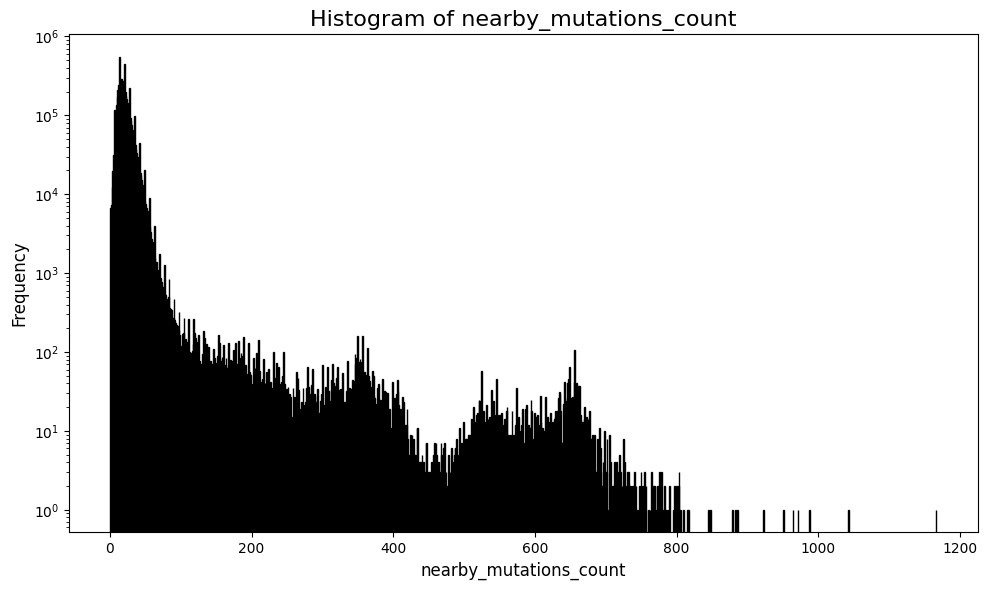

02:01:16 - INFO - Collapsing dataframe


02:49:05 - INFO - Calculating MCRS header length


02:49:07 - INFO - Calculating MCRS sequence length


02:49:09 - INFO - Aligning to normal genome and building dlist


Running bowtie2 alignment


Bowtie2 alignment complete


Skipped 0 reads with bad CIGAR strings
Capitalizing sequences


Removed 77 sequences with Ns from /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/dlist_genome.fa
Running bowtie2 alignment


Bowtie2 alignment complete


Skipped 0 reads with bad CIGAR strings
Capitalizing sequences


Removed 0 sequences with Ns from /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/dlist_cdna.fa


04:03:39 - INFO - Unique to cDNA: 6460


04:03:39 - INFO - Unique to genome: 12578


04:03:39 - INFO - Shared between cDNA and genome: 23918


04:03:39 - INFO - Total in cDNA: 30378


04:03:39 - INFO - Total in genome: 36496


04:03:39 - INFO - Total in cDNA or genome: 42956


04:03:45 - INFO - Running KAT


04:03:45 - ERROR - Error running KAT: [Errno 2] No such file or directory: 'kat'


04:03:45 - INFO - Getting MCRSs that pseudoalign but aren't dlisted


[2024-11-12 04:04:06,556]   DEBUG [main] Printing verbose output


[2024-11-12 04:04:08,791]   DEBUG [main] kallisto binary located at /home/jrich/miniconda3/envs/varseek/lib/python3.10/site-packages/kb_python/bins/linux/kallisto/kallisto_k64
[2024-11-12 04:04:08,791]   DEBUG [main] bustools binary located at /home/jrich/miniconda3/envs/varseek/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools
[2024-11-12 04:04:08,791]   DEBUG [main] Creating `/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp` directory
[2024-11-12 04:04:08,796]   DEBUG [main] Namespace(list=False, command='extract', tmp=None, keep_tmp=False, verbose=True, fastq='/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs_filtered_bowtie.fq', i='/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/kb_index/ensembl_grch37_release93_reference/index.idx', targets=None, target_type='gene', extract_all=False, extract_all_fast=True, extract_all_unmapped=False, mm=True, g='/home/jrich/data/varseek

[2024-11-12 04:04:14,339]    INFO [extract] Performing alignment using kallisto...
[2024-11-12 04:04:14,340]    INFO [extract] Using index /home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/kb_index/ensembl_grch37_release93_reference/index.idx to generate BUS file to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp from
[2024-11-12 04:04:14,340]    INFO [extract]         /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs_filtered_bowtie.fq
[2024-11-12 04:04:14,340]   DEBUG [extract] kallisto_k64 bus -i /home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/kb_index/ensembl_grch37_release93_reference/index.idx -o /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp -x bulk -t 32 --num /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs_filtered_bowtie.fq
[2024-11-12 04:04:14,441]   DEBUG [extract] 


[2024-11-12 04:04:53,829]   DEBUG [extract] [index] k-mer length: 55


[2024-11-12 04:05:20,580]   DEBUG [extract] [index] number of targets: 254,406
[2024-11-12 04:05:20,681]   DEBUG [extract] [index] number of k-mers: 1,517,217,485
[2024-11-12 04:05:20,681]   DEBUG [extract] [quant] running in single-end mode
[2024-11-12 04:05:20,681]   DEBUG [extract] [quant] will process file 1: /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs_filtered_bowtie.fq


[2024-11-12 04:05:24,791]   DEBUG [extract] [quant] finding pseudoalignments for all files ...


[2024-11-12 04:05:25,292]   DEBUG [extract] [progress] 1M reads processed (0.0% mapped)


[2024-11-12 04:05:27,998]   DEBUG [extract] [progress] 2M reads processed (0.0% mapped)


[2024-11-12 04:05:28,298]   DEBUG [extract] [progress] 3M reads processed (0.0% mapped)


[2024-11-12 04:05:30,904]   DEBUG [extract] [progress] 4M reads processed (0.0% mapped)              done
[2024-11-12 04:05:30,905]   DEBUG [extract] [quant] processed 5,258,642 reads, 86 reads pseudoaligned
[2024-11-12 04:05:31,105]   DEBUG [extract] 


[2024-11-12 04:05:38,625]    INFO [extract] Alignment complete. Beginning extraction of reads using bustools...
[2024-11-12 04:05:38,626]    INFO [extract] Sorting BUS file /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp/output.bus to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp/output_extracted_sorted.bus
[2024-11-12 04:05:38,626]   DEBUG [extract] bustools sort -o /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp/output_extracted_sorted.bus -T tmp -t 8 -m 2G --flags /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp/output.bus


[2024-11-12 04:05:40,632]   DEBUG [extract] all fits in buffer


[2024-11-12 04:05:41,834]   DEBUG [extract] Read in 86 BUS records
[2024-11-12 04:05:41,834]   DEBUG [extract] reading time 0s
[2024-11-12 04:05:41,834]   DEBUG [extract] sorting time 0s
[2024-11-12 04:05:41,834]   DEBUG [extract] writing time 0s
[2024-11-12 04:05:41,835]    INFO [extract] Extracting BUS file /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp/output_extracted_sorted.bus to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/all
[2024-11-12 04:05:41,835]   DEBUG [extract] bustools extract -o /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/all -f /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs_filtered_bowtie.fq -N 1 /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp/output_extracted_sorted.bus


[2024-11-12 04:05:43,940]   DEBUG [extract] Read in 86 BUS records
[2024-11-12 04:05:43,940]   DEBUG [main] Removing `/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/kb_extract_bowtie_filtered/tmp` directory


04:06:03 - INFO - Calculating overlap between MCRS items


Generating k-mers:   0%|                                                                                                       | 0/5301598 [00:00<?, ?sequence/s]

Generating k-mers:   0%|                                                                                         | 2729/5301598 [00:00<03:14, 27278.64sequence/s]

Generating k-mers:   0%|                                                                                         | 5457/5301598 [00:00<03:17, 26788.69sequence/s]

Generating k-mers:   0%|▏                                                                                        | 8137/5301598 [00:00<03:23, 26012.93sequence/s]

Generating k-mers:   0%|▏                                                                                       | 10768/5301598 [00:00<03:22, 26125.98sequence/s]

Generating k-mers:   0%|▏                                                                                       | 13383/5301598 [00:00<03:36, 24382.24sequence/s]

Generating k-mers:   0%|▎                                                                                       | 16079/5301598 [00:00<03:29, 25208.81sequence/s]

Generating k-mers:   0%|▎                                                                                       | 18642/5301598 [00:00<03:28, 25340.82sequence/s]

Generating k-mers:   0%|▎                                                                                       | 21188/5301598 [00:00<03:29, 25201.54sequence/s]

Generating k-mers:   0%|▍                                                                                       | 23716/5301598 [00:00<03:32, 24802.65sequence/s]

Generating k-mers:   0%|▍                                                                                       | 26203/5301598 [00:01<04:18, 20399.66sequence/s]

Generating k-mers:   1%|▍                                                                                       | 28803/5301598 [00:01<04:01, 21857.83sequence/s]

Generating k-mers:   1%|▌                                                                                       | 31242/5301598 [00:01<03:53, 22543.78sequence/s]

Generating k-mers:   1%|▌                                                                                       | 33692/5301598 [00:01<03:48, 23089.23sequence/s]

Generating k-mers:   1%|▌                                                                                       | 36099/5301598 [00:01<03:45, 23367.09sequence/s]

Generating k-mers:   1%|▋                                                                                       | 38536/5301598 [00:01<03:42, 23655.61sequence/s]

Generating k-mers:   1%|▋                                                                                       | 40936/5301598 [00:01<03:43, 23501.53sequence/s]

Generating k-mers:   1%|▋                                                                                       | 43310/5301598 [00:01<03:43, 23513.34sequence/s]

Generating k-mers:   1%|▊                                                                                       | 45678/5301598 [00:01<03:45, 23356.69sequence/s]

Generating k-mers:   1%|▊                                                                                       | 48026/5301598 [00:02<03:46, 23236.47sequence/s]

Generating k-mers:   1%|▊                                                                                       | 50358/5301598 [00:02<03:48, 23012.96sequence/s]

Generating k-mers:   1%|▊                                                                                       | 52666/5301598 [00:02<05:31, 15838.11sequence/s]

Generating k-mers:   1%|▉                                                                                       | 55157/5301598 [00:02<04:53, 17869.09sequence/s]

Generating k-mers:   1%|▉                                                                                       | 57560/5301598 [00:02<04:30, 19361.86sequence/s]

Generating k-mers:   1%|▉                                                                                       | 59985/5301598 [00:02<04:14, 20618.11sequence/s]

Generating k-mers:   1%|█                                                                                       | 62377/5301598 [00:02<04:03, 21504.12sequence/s]

Generating k-mers:   1%|█                                                                                       | 64755/5301598 [00:02<03:56, 22134.38sequence/s]

Generating k-mers:   1%|█                                                                                       | 67075/5301598 [00:02<03:53, 22434.83sequence/s]

Generating k-mers:   1%|█▏                                                                                      | 69416/5301598 [00:03<03:50, 22715.84sequence/s]

Generating k-mers:   1%|█▏                                                                                      | 71766/5301598 [00:03<03:47, 22944.05sequence/s]

Generating k-mers:   1%|█▏                                                                                      | 74104/5301598 [00:03<03:46, 23070.15sequence/s]

Generating k-mers:   1%|█▎                                                                                      | 76438/5301598 [00:03<03:48, 22883.37sequence/s]

Generating k-mers:   1%|█▎                                                                                      | 78746/5301598 [00:03<03:47, 22910.55sequence/s]

Generating k-mers:   2%|█▎                                                                                      | 81051/5301598 [00:03<03:48, 22857.26sequence/s]

Generating k-mers:   2%|█▍                                                                                      | 83346/5301598 [00:03<03:48, 22852.18sequence/s]

Generating k-mers:   2%|█▍                                                                                      | 85638/5301598 [00:03<03:49, 22751.40sequence/s]

Generating k-mers:   2%|█▍                                                                                      | 87918/5301598 [00:03<03:51, 22498.15sequence/s]

Generating k-mers:   2%|█▍                                                                                      | 90172/5301598 [00:03<03:52, 22411.05sequence/s]

Generating k-mers:   2%|█▌                                                                                      | 92416/5301598 [00:04<03:53, 22305.67sequence/s]

Generating k-mers:   2%|█▌                                                                                      | 94649/5301598 [00:04<03:55, 22144.53sequence/s]

Generating k-mers:   2%|█▌                                                                                      | 96865/5301598 [00:04<03:57, 21892.34sequence/s]

Generating k-mers:   2%|█▋                                                                                      | 99056/5301598 [00:04<03:59, 21719.64sequence/s]

Generating k-mers:   2%|█▋                                                                                     | 101229/5301598 [00:04<04:00, 21596.63sequence/s]

Generating k-mers:   2%|█▋                                                                                     | 103390/5301598 [00:04<08:00, 10824.66sequence/s]

Generating k-mers:   2%|█▋                                                                                     | 105777/5301598 [00:05<06:36, 13098.27sequence/s]

Generating k-mers:   2%|█▊                                                                                     | 108099/5301598 [00:05<05:43, 15115.69sequence/s]

Generating k-mers:   2%|█▊                                                                                     | 110484/5301598 [00:05<05:04, 17051.49sequence/s]

Generating k-mers:   2%|█▊                                                                                     | 112842/5301598 [00:05<04:38, 18619.99sequence/s]

Generating k-mers:   2%|█▉                                                                                     | 115216/5301598 [00:05<04:20, 19928.40sequence/s]

Generating k-mers:   2%|█▉                                                                                     | 117526/5301598 [00:05<04:09, 20755.50sequence/s]

Generating k-mers:   2%|█▉                                                                                     | 119905/5301598 [00:05<03:59, 21592.48sequence/s]

Generating k-mers:   2%|██                                                                                     | 122250/5301598 [00:05<03:54, 22115.93sequence/s]

Generating k-mers:   2%|██                                                                                     | 124588/5301598 [00:05<03:50, 22479.21sequence/s]

Generating k-mers:   2%|██                                                                                     | 126951/5301598 [00:05<03:46, 22813.61sequence/s]

Generating k-mers:   2%|██                                                                                     | 129284/5301598 [00:06<03:45, 22922.22sequence/s]

Generating k-mers:   2%|██▏                                                                                    | 131613/5301598 [00:06<03:44, 23016.09sequence/s]

Generating k-mers:   3%|██▏                                                                                    | 133977/5301598 [00:06<03:42, 23199.51sequence/s]

Generating k-mers:   3%|██▏                                                                                    | 136319/5301598 [00:06<03:42, 23263.94sequence/s]

Generating k-mers:   3%|██▎                                                                                    | 138659/5301598 [00:06<03:43, 23075.49sequence/s]

Generating k-mers:   3%|██▎                                                                                    | 140976/5301598 [00:06<03:43, 23091.48sequence/s]

Generating k-mers:   3%|██▎                                                                                    | 143312/5301598 [00:06<03:42, 23168.92sequence/s]

Generating k-mers:   3%|██▍                                                                                    | 145666/5301598 [00:06<03:41, 23264.49sequence/s]

Generating k-mers:   3%|██▍                                                                                    | 147996/5301598 [00:06<03:42, 23195.38sequence/s]

Generating k-mers:   3%|██▍                                                                                    | 150348/5301598 [00:06<03:41, 23290.33sequence/s]

Generating k-mers:   3%|██▌                                                                                    | 152682/5301598 [00:07<03:40, 23304.58sequence/s]

Generating k-mers:   3%|██▌                                                                                    | 155014/5301598 [00:07<03:42, 23156.17sequence/s]

Generating k-mers:   3%|██▌                                                                                    | 157331/5301598 [00:07<03:44, 22903.08sequence/s]

Generating k-mers:   3%|██▌                                                                                    | 159624/5301598 [00:07<03:44, 22910.19sequence/s]

Generating k-mers:   3%|██▋                                                                                    | 161916/5301598 [00:07<03:44, 22888.46sequence/s]

Generating k-mers:   3%|██▋                                                                                    | 164214/5301598 [00:07<03:44, 22914.11sequence/s]

Generating k-mers:   3%|██▋                                                                                    | 166506/5301598 [00:07<03:44, 22873.48sequence/s]

Generating k-mers:   3%|██▊                                                                                    | 168794/5301598 [00:07<03:49, 22404.98sequence/s]

Generating k-mers:   3%|██▊                                                                                    | 171037/5301598 [00:07<03:54, 21843.47sequence/s]

Generating k-mers:   3%|██▊                                                                                    | 173226/5301598 [00:07<04:00, 21349.41sequence/s]

Generating k-mers:   3%|██▉                                                                                    | 175365/5301598 [00:08<04:03, 21061.46sequence/s]

Generating k-mers:   3%|██▉                                                                                    | 177474/5301598 [00:08<04:07, 20728.98sequence/s]

Generating k-mers:   3%|██▉                                                                                    | 179549/5301598 [00:08<04:08, 20648.75sequence/s]

Generating k-mers:   3%|██▉                                                                                    | 181615/5301598 [00:08<04:08, 20595.73sequence/s]

Generating k-mers:   3%|███                                                                                    | 183676/5301598 [00:08<04:10, 20471.33sequence/s]

Generating k-mers:   4%|███                                                                                    | 185724/5301598 [00:08<04:12, 20298.83sequence/s]

Generating k-mers:   4%|███                                                                                    | 187755/5301598 [00:08<04:12, 20237.67sequence/s]

Generating k-mers:   4%|███                                                                                    | 189779/5301598 [00:08<04:13, 20133.01sequence/s]

Generating k-mers:   4%|███▏                                                                                   | 191793/5301598 [00:08<04:14, 20096.22sequence/s]

Generating k-mers:   4%|███▏                                                                                   | 193803/5301598 [00:09<04:15, 19977.67sequence/s]

Generating k-mers:   4%|███▏                                                                                   | 195844/5301598 [00:09<04:13, 20103.34sequence/s]

Generating k-mers:   4%|███▏                                                                                   | 197882/5301598 [00:09<04:12, 20181.91sequence/s]

Generating k-mers:   4%|███▎                                                                                   | 199901/5301598 [00:09<04:13, 20159.07sequence/s]

Generating k-mers:   4%|███▎                                                                                   | 201918/5301598 [00:09<04:14, 20023.00sequence/s]

Generating k-mers:   4%|███▍                                                                                    | 203921/5301598 [00:10<16:17, 5214.88sequence/s]

Generating k-mers:   4%|███▍                                                                                    | 205998/5301598 [00:10<12:33, 6764.36sequence/s]

Generating k-mers:   4%|███▍                                                                                    | 208055/5301598 [00:10<10:00, 8483.69sequence/s]

Generating k-mers:   4%|███▍                                                                                   | 210142/5301598 [00:10<08:11, 10354.85sequence/s]

Generating k-mers:   4%|███▍                                                                                   | 212231/5301598 [00:10<06:56, 12224.58sequence/s]

Generating k-mers:   4%|███▌                                                                                   | 214303/5301598 [00:10<06:04, 13942.60sequence/s]

Generating k-mers:   4%|███▌                                                                                   | 216320/5301598 [00:11<05:31, 15337.81sequence/s]

Generating k-mers:   4%|███▌                                                                                   | 218382/5301598 [00:11<05:05, 16618.70sequence/s]

Generating k-mers:   4%|███▌                                                                                   | 220440/5301598 [00:11<04:48, 17636.82sequence/s]

Generating k-mers:   4%|███▋                                                                                   | 222464/5301598 [00:11<04:38, 18230.50sequence/s]

Generating k-mers:   4%|███▋                                                                                   | 224475/5301598 [00:11<04:36, 18383.46sequence/s]

Generating k-mers:   4%|███▋                                                                                   | 226446/5301598 [00:11<04:36, 18326.07sequence/s]

Generating k-mers:   4%|███▋                                                                                   | 228371/5301598 [00:11<04:35, 18397.44sequence/s]

Generating k-mers:   4%|███▊                                                                                   | 230276/5301598 [00:11<04:34, 18458.82sequence/s]

Generating k-mers:   4%|███▊                                                                                   | 232168/5301598 [00:11<04:34, 18499.58sequence/s]

Generating k-mers:   4%|███▊                                                                                   | 234051/5301598 [00:11<04:36, 18354.90sequence/s]

Generating k-mers:   4%|███▊                                                                                   | 235912/5301598 [00:12<04:34, 18427.27sequence/s]

Generating k-mers:   4%|███▉                                                                                   | 237771/5301598 [00:12<04:34, 18448.95sequence/s]

Generating k-mers:   5%|███▉                                                                                   | 239631/5301598 [00:12<04:33, 18490.01sequence/s]

Generating k-mers:   5%|███▉                                                                                   | 241488/5301598 [00:12<04:35, 18358.39sequence/s]

Generating k-mers:   5%|███▉                                                                                   | 243334/5301598 [00:12<04:35, 18363.95sequence/s]

Generating k-mers:   5%|████                                                                                   | 245179/5301598 [00:12<04:35, 18386.93sequence/s]

Generating k-mers:   5%|████                                                                                   | 247022/5301598 [00:12<04:34, 18397.59sequence/s]

Generating k-mers:   5%|████                                                                                   | 248864/5301598 [00:12<04:35, 18369.03sequence/s]

Generating k-mers:   5%|████                                                                                   | 250703/5301598 [00:12<04:37, 18208.28sequence/s]

Generating k-mers:   5%|████▏                                                                                  | 252537/5301598 [00:12<04:36, 18245.49sequence/s]

Generating k-mers:   5%|████▏                                                                                  | 254375/5301598 [00:13<04:36, 18284.16sequence/s]

Generating k-mers:   5%|████▏                                                                                  | 256216/5301598 [00:13<04:35, 18320.43sequence/s]

Generating k-mers:   5%|████▏                                                                                  | 258049/5301598 [00:13<04:37, 18197.04sequence/s]

Generating k-mers:   5%|████▎                                                                                  | 259870/5301598 [00:13<04:37, 18181.86sequence/s]

Generating k-mers:   5%|████▎                                                                                  | 261697/5301598 [00:13<04:36, 18206.31sequence/s]

Generating k-mers:   5%|████▎                                                                                  | 263518/5301598 [00:13<04:37, 18177.44sequence/s]

Generating k-mers:   5%|████▎                                                                                  | 265336/5301598 [00:13<04:38, 18066.34sequence/s]

Generating k-mers:   5%|████▍                                                                                  | 267148/5301598 [00:13<04:38, 18079.81sequence/s]

Generating k-mers:   5%|████▍                                                                                  | 268957/5301598 [00:13<04:38, 18046.22sequence/s]

Generating k-mers:   5%|████▍                                                                                  | 270762/5301598 [00:14<04:38, 18037.33sequence/s]

Generating k-mers:   5%|████▍                                                                                  | 272570/5301598 [00:14<04:38, 18048.10sequence/s]

Generating k-mers:   5%|████▌                                                                                  | 274375/5301598 [00:14<04:40, 17910.23sequence/s]

Generating k-mers:   5%|████▌                                                                                  | 276176/5301598 [00:14<04:40, 17938.47sequence/s]

Generating k-mers:   5%|████▌                                                                                  | 277971/5301598 [00:14<04:40, 17932.38sequence/s]

Generating k-mers:   5%|████▌                                                                                  | 279766/5301598 [00:14<04:39, 17937.01sequence/s]

Generating k-mers:   5%|████▌                                                                                  | 281560/5301598 [00:14<04:41, 17844.44sequence/s]

Generating k-mers:   5%|████▋                                                                                  | 283364/5301598 [00:14<04:40, 17902.17sequence/s]

Generating k-mers:   5%|████▋                                                                                  | 285173/5301598 [00:14<04:39, 17957.83sequence/s]

Generating k-mers:   5%|████▋                                                                                  | 286970/5301598 [00:14<04:39, 17960.19sequence/s]

Generating k-mers:   5%|████▋                                                                                  | 288767/5301598 [00:15<04:41, 17839.06sequence/s]

Generating k-mers:   5%|████▊                                                                                  | 290559/5301598 [00:15<04:40, 17862.66sequence/s]

Generating k-mers:   6%|████▊                                                                                  | 292346/5301598 [00:15<04:40, 17847.59sequence/s]

Generating k-mers:   6%|████▊                                                                                  | 294131/5301598 [00:15<04:40, 17832.56sequence/s]

Generating k-mers:   6%|████▊                                                                                  | 295915/5301598 [00:15<04:42, 17694.11sequence/s]

Generating k-mers:   6%|████▉                                                                                  | 297685/5301598 [00:15<04:43, 17644.40sequence/s]

Generating k-mers:   6%|████▉                                                                                  | 299467/5301598 [00:15<04:42, 17695.13sequence/s]

Generating k-mers:   6%|████▉                                                                                  | 301242/5301598 [00:15<04:42, 17710.33sequence/s]

Generating k-mers:   6%|████▉                                                                                  | 303014/5301598 [00:15<04:42, 17687.60sequence/s]

Generating k-mers:   6%|█████                                                                                  | 304783/5301598 [00:15<04:44, 17562.80sequence/s]

Generating k-mers:   6%|█████                                                                                  | 306546/5301598 [00:16<04:44, 17581.53sequence/s]

Generating k-mers:   6%|█████                                                                                  | 308324/5301598 [00:16<04:43, 17638.35sequence/s]

Generating k-mers:   6%|█████                                                                                  | 310120/5301598 [00:16<04:41, 17733.95sequence/s]

Generating k-mers:   6%|█████                                                                                  | 311894/5301598 [00:16<04:42, 17672.12sequence/s]

Generating k-mers:   6%|█████▏                                                                                 | 313684/5301598 [00:16<04:41, 17737.60sequence/s]

Generating k-mers:   6%|█████▏                                                                                 | 315504/5301598 [00:16<04:38, 17875.46sequence/s]

Generating k-mers:   6%|█████▏                                                                                 | 317304/5301598 [00:16<04:38, 17910.81sequence/s]

Generating k-mers:   6%|█████▏                                                                                 | 319096/5301598 [00:16<04:40, 17762.17sequence/s]

Generating k-mers:   6%|█████▎                                                                                 | 320873/5301598 [00:16<04:40, 17758.97sequence/s]

Generating k-mers:   6%|█████▎                                                                                 | 322650/5301598 [00:16<04:41, 17715.71sequence/s]

Generating k-mers:   6%|█████▎                                                                                 | 324422/5301598 [00:17<04:40, 17715.20sequence/s]

Generating k-mers:   6%|█████▎                                                                                 | 326195/5301598 [00:17<04:40, 17718.64sequence/s]

Generating k-mers:   6%|█████▍                                                                                 | 327967/5301598 [00:17<04:44, 17506.70sequence/s]

Generating k-mers:   6%|█████▍                                                                                 | 329721/5301598 [00:17<04:43, 17515.30sequence/s]

Generating k-mers:   6%|█████▍                                                                                 | 331495/5301598 [00:17<04:42, 17579.39sequence/s]

Generating k-mers:   6%|█████▍                                                                                 | 333254/5301598 [00:17<04:44, 17455.72sequence/s]

Generating k-mers:   6%|█████▍                                                                                 | 335021/5301598 [00:17<04:43, 17518.10sequence/s]

Generating k-mers:   6%|█████▌                                                                                 | 336783/5301598 [00:17<04:43, 17525.62sequence/s]

Generating k-mers:   6%|█████▌                                                                                 | 338558/5301598 [00:17<04:42, 17592.20sequence/s]

Generating k-mers:   6%|█████▌                                                                                 | 340331/5301598 [00:17<04:41, 17632.31sequence/s]

Generating k-mers:   6%|█████▌                                                                                 | 342109/5301598 [00:18<04:40, 17675.94sequence/s]

Generating k-mers:   6%|█████▋                                                                                 | 343877/5301598 [00:18<04:41, 17604.11sequence/s]

Generating k-mers:   7%|█████▋                                                                                 | 345639/5301598 [00:18<04:41, 17599.35sequence/s]

Generating k-mers:   7%|█████▋                                                                                 | 347403/5301598 [00:18<04:41, 17609.26sequence/s]

Generating k-mers:   7%|█████▋                                                                                 | 349177/5301598 [00:18<04:40, 17646.62sequence/s]

Generating k-mers:   7%|█████▊                                                                                 | 350988/5301598 [00:18<04:38, 17768.18sequence/s]

Generating k-mers:   7%|█████▊                                                                                 | 352802/5301598 [00:18<04:36, 17878.80sequence/s]

Generating k-mers:   7%|█████▊                                                                                 | 354590/5301598 [00:18<04:39, 17711.90sequence/s]

Generating k-mers:   7%|█████▊                                                                                 | 356362/5301598 [00:18<04:39, 17706.93sequence/s]

Generating k-mers:   7%|█████▊                                                                                 | 356362/5301598 [00:48<04:39, 17706.93sequence/s]

Generating k-mers:   7%|█████▉                                                                                 | 358031/5301598 [00:48<7:05:47, 193.51sequence/s]

Generating k-mers:   7%|█████▉                                                                                 | 359709/5301598 [00:48<5:03:06, 271.73sequence/s]

Generating k-mers:   7%|█████▉                                                                                 | 361466/5301598 [00:48<3:32:28, 387.49sequence/s]

Generating k-mers:   7%|█████▉                                                                                 | 363223/5301598 [00:49<2:29:35, 550.19sequence/s]

Generating k-mers:   7%|█████▉                                                                                 | 364971/5301598 [00:49<1:46:01, 775.98sequence/s]

Generating k-mers:   7%|█████▉                                                                                | 366738/5301598 [00:49<1:15:19, 1091.90sequence/s]

Generating k-mers:   7%|██████                                                                                  | 368504/5301598 [00:49<53:58, 1523.08sequence/s]

Generating k-mers:   7%|██████▏                                                                                 | 370255/5301598 [00:49<39:13, 2095.65sequence/s]

Generating k-mers:   7%|██████▏                                                                                 | 372002/5301598 [00:49<28:54, 2841.75sequence/s]

Generating k-mers:   7%|██████▏                                                                                 | 373745/5301598 [00:49<21:40, 3789.84sequence/s]

Generating k-mers:   7%|██████▏                                                                                 | 375484/5301598 [00:49<16:36, 4943.09sequence/s]

Generating k-mers:   7%|██████▎                                                                                 | 377221/5301598 [00:49<13:03, 6285.05sequence/s]

Generating k-mers:   7%|██████▎                                                                                 | 378956/5301598 [00:49<10:35, 7741.03sequence/s]

Generating k-mers:   7%|██████▎                                                                                 | 380687/5301598 [00:50<08:50, 9272.36sequence/s]

Generating k-mers:   7%|██████▎                                                                                | 382439/5301598 [00:50<07:35, 10806.82sequence/s]

Generating k-mers:   7%|██████▎                                                                                | 384172/5301598 [00:50<06:43, 12175.27sequence/s]

Generating k-mers:   7%|██████▎                                                                                | 385905/5301598 [00:50<06:10, 13280.83sequence/s]

Generating k-mers:   7%|██████▎                                                                                | 387632/5301598 [00:50<05:44, 14263.43sequence/s]

Generating k-mers:   7%|██████▍                                                                                | 389364/5301598 [00:50<05:26, 15058.92sequence/s]

Generating k-mers:   7%|██████▍                                                                                | 391089/5301598 [00:50<05:14, 15636.80sequence/s]

Generating k-mers:   7%|██████▍                                                                                | 392812/5301598 [00:50<05:08, 15893.27sequence/s]

Generating k-mers:   7%|██████▍                                                                                | 394514/5301598 [00:50<05:03, 16191.43sequence/s]

Generating k-mers:   7%|██████▌                                                                                | 396228/5301598 [00:50<04:57, 16463.66sequence/s]

Generating k-mers:   8%|██████▌                                                                                | 397932/5301598 [00:51<04:54, 16630.77sequence/s]

Generating k-mers:   8%|██████▌                                                                                | 399636/5301598 [00:51<04:55, 16568.63sequence/s]

Generating k-mers:   8%|██████▌                                                                                | 401322/5301598 [00:51<04:54, 16648.03sequence/s]

Generating k-mers:   8%|██████▌                                                                                | 403017/5301598 [00:51<04:52, 16736.28sequence/s]

Generating k-mers:   8%|██████▋                                                                                | 404713/5301598 [00:51<04:51, 16800.51sequence/s]

Generating k-mers:   8%|██████▋                                                                                | 406407/5301598 [00:51<04:50, 16841.40sequence/s]

Generating k-mers:   8%|██████▊                                                                                 | 408099/5301598 [00:53<34:12, 2384.56sequence/s]

Generating k-mers:   8%|██████▊                                                                                 | 409883/5301598 [00:53<24:59, 3262.81sequence/s]

Generating k-mers:   8%|██████▊                                                                                 | 411729/5301598 [00:53<18:30, 4403.75sequence/s]

Generating k-mers:   8%|██████▊                                                                                 | 413594/5301598 [00:54<14:05, 5783.61sequence/s]

Generating k-mers:   8%|██████▉                                                                                 | 415443/5301598 [00:54<11:06, 7328.18sequence/s]

Generating k-mers:   8%|██████▉                                                                                 | 417235/5301598 [00:54<09:09, 8894.91sequence/s]

Generating k-mers:   8%|██████▉                                                                                | 419084/5301598 [00:54<07:41, 10568.89sequence/s]

Generating k-mers:   8%|██████▉                                                                                | 420933/5301598 [00:54<06:41, 12148.67sequence/s]

Generating k-mers:   8%|██████▉                                                                                | 422782/5301598 [00:54<05:59, 13554.75sequence/s]

Generating k-mers:   8%|██████▉                                                                                | 424587/5301598 [00:54<05:33, 14614.18sequence/s]

Generating k-mers:   8%|██████▉                                                                                | 426442/5301598 [00:54<05:12, 15618.17sequence/s]

Generating k-mers:   8%|███████                                                                                | 428285/5301598 [00:54<04:57, 16368.13sequence/s]

Generating k-mers:   8%|███████                                                                                | 430116/5301598 [00:54<04:48, 16902.74sequence/s]

Generating k-mers:   8%|███████                                                                                | 431943/5301598 [00:55<04:42, 17213.67sequence/s]

Generating k-mers:   8%|███████                                                                                | 433787/5301598 [00:55<04:37, 17565.14sequence/s]

Generating k-mers:   8%|███████▏                                                                               | 435627/5301598 [00:55<04:33, 17807.64sequence/s]

Generating k-mers:   8%|███████▏                                                                               | 437479/5301598 [00:55<04:30, 18014.79sequence/s]

Generating k-mers:   8%|███████▏                                                                               | 439316/5301598 [00:55<04:30, 17970.14sequence/s]

Generating k-mers:   8%|███████▏                                                                               | 441152/5301598 [00:55<04:28, 18083.95sequence/s]

Generating k-mers:   8%|███████▎                                                                               | 442992/5301598 [00:55<04:27, 18176.30sequence/s]

Generating k-mers:   8%|███████▎                                                                               | 444841/5301598 [00:55<04:25, 18267.59sequence/s]

Generating k-mers:   8%|███████▎                                                                               | 446677/5301598 [00:55<04:30, 17971.27sequence/s]

Generating k-mers:   8%|███████▎                                                                               | 448510/5301598 [00:55<04:28, 18075.50sequence/s]

Generating k-mers:   8%|███████▍                                                                               | 450342/5301598 [00:56<04:27, 18147.02sequence/s]

Generating k-mers:   9%|███████▍                                                                               | 452195/5301598 [00:56<04:25, 18257.63sequence/s]

Generating k-mers:   9%|███████▍                                                                               | 454061/5301598 [00:56<04:23, 18377.34sequence/s]

Generating k-mers:   9%|███████▍                                                                               | 455901/5301598 [00:56<04:28, 18051.91sequence/s]

Generating k-mers:   9%|███████▌                                                                               | 457730/5301598 [00:56<04:27, 18120.26sequence/s]

Generating k-mers:   9%|███████▌                                                                               | 459568/5301598 [00:56<04:26, 18197.12sequence/s]

Generating k-mers:   9%|███████▌                                                                               | 461390/5301598 [00:56<04:25, 18202.68sequence/s]

Generating k-mers:   9%|███████▌                                                                               | 463212/5301598 [00:56<04:25, 18199.43sequence/s]

Generating k-mers:   9%|███████▋                                                                               | 465033/5301598 [00:56<04:27, 18091.32sequence/s]

Generating k-mers:   9%|███████▋                                                                               | 466850/5301598 [00:56<04:26, 18112.89sequence/s]

Generating k-mers:   9%|███████▋                                                                               | 468680/5301598 [00:57<04:26, 18166.77sequence/s]

Generating k-mers:   9%|███████▋                                                                               | 470515/5301598 [00:57<04:25, 18219.72sequence/s]

Generating k-mers:   9%|███████▊                                                                               | 472338/5301598 [00:57<04:26, 18101.64sequence/s]

Generating k-mers:   9%|███████▊                                                                               | 474156/5301598 [00:57<04:26, 18122.95sequence/s]

Generating k-mers:   9%|███████▊                                                                               | 475969/5301598 [00:57<04:26, 18123.80sequence/s]

Generating k-mers:   9%|███████▊                                                                               | 477797/5301598 [00:57<04:25, 18170.22sequence/s]

Generating k-mers:   9%|███████▊                                                                               | 479615/5301598 [00:57<04:27, 18016.49sequence/s]

Generating k-mers:   9%|███████▉                                                                               | 481424/5301598 [00:57<04:27, 18037.60sequence/s]

Generating k-mers:   9%|███████▉                                                                               | 483250/5301598 [00:57<04:26, 18103.03sequence/s]

Generating k-mers:   9%|███████▉                                                                               | 485061/5301598 [00:57<04:26, 18079.54sequence/s]

Generating k-mers:   9%|███████▉                                                                               | 486870/5301598 [00:58<04:28, 17962.59sequence/s]

Generating k-mers:   9%|████████                                                                               | 488675/5301598 [00:58<04:27, 17987.32sequence/s]

Generating k-mers:   9%|████████                                                                               | 490499/5301598 [00:58<04:26, 18042.56sequence/s]

Generating k-mers:   9%|████████                                                                               | 492315/5301598 [00:58<04:26, 18076.49sequence/s]

Generating k-mers:   9%|████████                                                                               | 494123/5301598 [00:58<04:28, 17923.64sequence/s]

Generating k-mers:   9%|████████▏                                                                              | 495926/5301598 [00:58<04:27, 17953.33sequence/s]

Generating k-mers:   9%|████████▏                                                                              | 497722/5301598 [00:58<04:27, 17952.86sequence/s]

Generating k-mers:   9%|████████▏                                                                              | 499518/5301598 [00:58<04:27, 17946.19sequence/s]

Generating k-mers:   9%|████████▏                                                                              | 501313/5301598 [00:58<04:30, 17760.75sequence/s]

Generating k-mers:   9%|████████▎                                                                              | 503118/5301598 [00:58<04:28, 17843.97sequence/s]

Generating k-mers:  10%|████████▎                                                                              | 504930/5301598 [00:59<04:27, 17924.91sequence/s]

Generating k-mers:  10%|████████▎                                                                              | 506745/5301598 [00:59<04:26, 17974.47sequence/s]

Generating k-mers:  10%|████████▎                                                                              | 508543/5301598 [00:59<04:28, 17828.01sequence/s]

Generating k-mers:  10%|████████▎                                                                              | 510327/5301598 [00:59<04:28, 17831.10sequence/s]

Generating k-mers:  10%|████████▍                                                                              | 512116/5301598 [00:59<04:28, 17848.01sequence/s]

Generating k-mers:  10%|████████▍                                                                              | 513915/5301598 [00:59<04:27, 17889.73sequence/s]

Generating k-mers:  10%|████████▍                                                                              | 515705/5301598 [00:59<04:31, 17613.18sequence/s]

Generating k-mers:  10%|████████▍                                                                              | 517522/5301598 [00:59<04:29, 17775.62sequence/s]

Generating k-mers:  10%|████████▌                                                                              | 519308/5301598 [00:59<04:28, 17791.12sequence/s]

Generating k-mers:  10%|████████▌                                                                              | 521102/5301598 [00:59<04:28, 17833.02sequence/s]

Generating k-mers:  10%|████████▌                                                                              | 522886/5301598 [01:00<04:28, 17813.20sequence/s]

Generating k-mers:  10%|████████▌                                                                              | 524668/5301598 [01:00<04:30, 17681.61sequence/s]

Generating k-mers:  10%|████████▋                                                                              | 526454/5301598 [01:00<04:29, 17729.04sequence/s]

Generating k-mers:  10%|████████▋                                                                              | 528228/5301598 [01:00<04:29, 17719.82sequence/s]

Generating k-mers:  10%|████████▋                                                                              | 530004/5301598 [01:00<04:29, 17730.18sequence/s]

Generating k-mers:  10%|████████▋                                                                              | 531778/5301598 [01:00<04:31, 17594.98sequence/s]

Generating k-mers:  10%|████████▊                                                                              | 533562/5301598 [01:00<04:29, 17667.04sequence/s]

Generating k-mers:  10%|████████▊                                                                              | 535349/5301598 [01:00<04:28, 17726.57sequence/s]

Generating k-mers:  10%|████████▊                                                                              | 537127/5301598 [01:00<04:28, 17740.74sequence/s]

Generating k-mers:  10%|████████▊                                                                              | 538902/5301598 [01:00<04:30, 17576.95sequence/s]

Generating k-mers:  10%|████████▊                                                                              | 540685/5301598 [01:01<04:29, 17649.66sequence/s]

Generating k-mers:  10%|████████▉                                                                              | 542452/5301598 [01:01<04:29, 17655.45sequence/s]

Generating k-mers:  10%|████████▉                                                                              | 544236/5301598 [01:01<04:28, 17707.81sequence/s]

Generating k-mers:  10%|████████▉                                                                              | 546007/5301598 [01:01<04:30, 17560.27sequence/s]

Generating k-mers:  10%|████████▉                                                                              | 547771/5301598 [01:01<04:30, 17583.09sequence/s]

Generating k-mers:  10%|█████████                                                                              | 549550/5301598 [01:01<04:29, 17643.29sequence/s]

Generating k-mers:  10%|█████████                                                                              | 551318/5301598 [01:01<04:29, 17652.52sequence/s]

Generating k-mers:  10%|█████████                                                                              | 553084/5301598 [01:01<04:31, 17485.54sequence/s]

Generating k-mers:  10%|█████████                                                                              | 554849/5301598 [01:01<04:30, 17534.25sequence/s]

Generating k-mers:  10%|█████████▏                                                                             | 556631/5301598 [01:01<04:29, 17617.45sequence/s]

Generating k-mers:  11%|█████████▏                                                                             | 558394/5301598 [01:02<04:29, 17614.64sequence/s]

Generating k-mers:  11%|█████████▏                                                                             | 560158/5301598 [01:02<04:29, 17620.10sequence/s]

Generating k-mers:  11%|█████████▏                                                                             | 561921/5301598 [01:02<04:31, 17470.55sequence/s]

Generating k-mers:  11%|█████████▎                                                                             | 563687/5301598 [01:02<04:30, 17523.84sequence/s]

Generating k-mers:  11%|█████████▎                                                                             | 565450/5301598 [01:02<04:29, 17554.33sequence/s]

Generating k-mers:  11%|█████████▎                                                                             | 567222/5301598 [01:02<04:28, 17603.21sequence/s]

Generating k-mers:  11%|█████████▎                                                                             | 568983/5301598 [01:02<04:36, 17139.67sequence/s]

Generating k-mers:  11%|█████████▎                                                                             | 570751/5301598 [01:02<04:33, 17281.09sequence/s]

Generating k-mers:  11%|█████████▍                                                                             | 572518/5301598 [01:02<04:31, 17393.59sequence/s]

Generating k-mers:  11%|█████████▍                                                                             | 574266/5301598 [01:02<04:31, 17397.21sequence/s]

Generating k-mers:  11%|█████████▍                                                                             | 576026/5301598 [01:03<04:30, 17456.31sequence/s]

Generating k-mers:  11%|█████████▍                                                                             | 577795/5301598 [01:03<04:29, 17524.68sequence/s]

Generating k-mers:  11%|█████████▌                                                                             | 579549/5301598 [01:03<04:31, 17405.10sequence/s]

Generating k-mers:  11%|█████████▌                                                                             | 581296/5301598 [01:03<04:31, 17412.40sequence/s]

Generating k-mers:  11%|█████████▌                                                                             | 583059/5301598 [01:03<04:30, 17475.22sequence/s]

Generating k-mers:  11%|█████████▌                                                                             | 584818/5301598 [01:03<04:29, 17498.38sequence/s]

Generating k-mers:  11%|█████████▋                                                                             | 586569/5301598 [01:03<04:30, 17405.36sequence/s]

Generating k-mers:  11%|█████████▋                                                                             | 588310/5301598 [01:03<04:30, 17404.60sequence/s]

Generating k-mers:  11%|█████████▋                                                                             | 590057/5301598 [01:03<04:30, 17422.72sequence/s]

Generating k-mers:  11%|█████████▋                                                                             | 591814/5301598 [01:03<04:29, 17465.22sequence/s]

Generating k-mers:  11%|█████████▋                                                                             | 593561/5301598 [01:04<04:31, 17342.22sequence/s]

Generating k-mers:  11%|█████████▊                                                                             | 595310/5301598 [01:04<04:30, 17385.82sequence/s]

Generating k-mers:  11%|█████████▊                                                                             | 597070/5301598 [01:04<04:29, 17449.06sequence/s]

Generating k-mers:  11%|█████████▊                                                                             | 598816/5301598 [01:04<04:29, 17423.10sequence/s]

Generating k-mers:  11%|█████████▊                                                                             | 600559/5301598 [01:04<04:32, 17242.98sequence/s]

Generating k-mers:  11%|█████████▉                                                                             | 602290/5301598 [01:04<04:32, 17260.80sequence/s]

Generating k-mers:  11%|█████████▉                                                                             | 604038/5301598 [01:04<04:31, 17325.59sequence/s]

Generating k-mers:  11%|█████████▉                                                                             | 605780/5301598 [01:04<04:30, 17353.15sequence/s]

Generating k-mers:  11%|█████████▉                                                                             | 607516/5301598 [01:04<04:33, 17148.06sequence/s]

Generating k-mers:  11%|█████████▉                                                                             | 609253/5301598 [01:04<04:32, 17211.65sequence/s]

Generating k-mers:  12%|██████████                                                                             | 610991/5301598 [01:05<04:31, 17260.23sequence/s]

Generating k-mers:  12%|██████████                                                                             | 612738/5301598 [01:05<04:30, 17322.48sequence/s]

Generating k-mers:  12%|██████████                                                                             | 614471/5301598 [01:05<04:32, 17219.34sequence/s]

Generating k-mers:  12%|██████████                                                                             | 616207/5301598 [01:05<04:31, 17258.57sequence/s]

Generating k-mers:  12%|██████████▏                                                                            | 617934/5301598 [01:05<04:31, 17232.29sequence/s]

Generating k-mers:  12%|██████████▏                                                                            | 619658/5301598 [01:05<04:31, 17227.04sequence/s]

Generating k-mers:  12%|██████████▏                                                                            | 621381/5301598 [01:05<04:34, 17034.74sequence/s]

Generating k-mers:  12%|██████████▏                                                                            | 623104/5301598 [01:05<04:33, 17091.55sequence/s]

Generating k-mers:  12%|██████████▎                                                                            | 624828/5301598 [01:05<04:32, 17134.04sequence/s]

Generating k-mers:  12%|██████████▎                                                                            | 626554/5301598 [01:06<04:32, 17171.13sequence/s]

Generating k-mers:  12%|██████████▎                                                                            | 628305/5301598 [01:06<04:30, 17270.36sequence/s]

Generating k-mers:  12%|██████████▎                                                                            | 630033/5301598 [01:06<04:32, 17120.49sequence/s]

Generating k-mers:  12%|██████████▎                                                                            | 631776/5301598 [01:06<04:31, 17210.22sequence/s]

Generating k-mers:  12%|██████████▍                                                                            | 633509/5301598 [01:06<04:30, 17245.24sequence/s]

Generating k-mers:  12%|██████████▍                                                                            | 635234/5301598 [01:06<04:31, 17174.33sequence/s]

Generating k-mers:  12%|██████████▍                                                                            | 636952/5301598 [01:06<04:34, 16995.08sequence/s]

Generating k-mers:  12%|██████████▍                                                                            | 638652/5301598 [01:06<04:34, 16977.25sequence/s]

Generating k-mers:  12%|██████████▌                                                                            | 640358/5301598 [01:06<04:34, 17000.15sequence/s]

Generating k-mers:  12%|██████████▌                                                                            | 642065/5301598 [01:06<04:33, 17019.90sequence/s]

Generating k-mers:  12%|██████████▌                                                                            | 643768/5301598 [01:07<04:35, 16924.05sequence/s]

Generating k-mers:  12%|██████████▌                                                                            | 645481/5301598 [01:07<04:34, 16971.72sequence/s]

Generating k-mers:  12%|██████████▌                                                                            | 647212/5301598 [01:07<04:32, 17071.10sequence/s]

Generating k-mers:  12%|██████████▋                                                                            | 648932/5301598 [01:07<04:31, 17108.18sequence/s]

Generating k-mers:  12%|██████████▋                                                                            | 650643/5301598 [01:07<04:33, 17028.73sequence/s]

Generating k-mers:  12%|██████████▋                                                                            | 652362/5301598 [01:07<04:32, 17075.79sequence/s]

Generating k-mers:  12%|██████████▋                                                                            | 654070/5301598 [01:07<04:32, 17073.33sequence/s]

Generating k-mers:  12%|██████████▊                                                                            | 655780/5301598 [01:07<04:32, 17077.59sequence/s]

Generating k-mers:  12%|██████████▊                                                                            | 657488/5301598 [01:07<04:33, 16956.58sequence/s]

Generating k-mers:  12%|██████████▊                                                                            | 659198/5301598 [01:07<04:33, 16997.64sequence/s]

Generating k-mers:  12%|██████████▊                                                                            | 660912/5301598 [01:08<04:32, 17039.31sequence/s]

Generating k-mers:  12%|██████████▊                                                                            | 662627/5301598 [01:08<04:31, 17071.18sequence/s]

Generating k-mers:  13%|██████████▉                                                                            | 664335/5301598 [01:08<04:34, 16905.88sequence/s]

Generating k-mers:  13%|██████████▉                                                                            | 666026/5301598 [01:08<04:34, 16898.83sequence/s]

Generating k-mers:  13%|██████████▉                                                                            | 667717/5301598 [01:08<04:34, 16888.59sequence/s]

Generating k-mers:  13%|██████████▉                                                                            | 669425/5301598 [01:08<04:33, 16944.04sequence/s]

Generating k-mers:  13%|███████████                                                                            | 671130/5301598 [01:08<04:32, 16974.44sequence/s]

Generating k-mers:  13%|███████████                                                                            | 672828/5301598 [01:08<04:35, 16810.74sequence/s]

Generating k-mers:  13%|███████████                                                                            | 674514/5301598 [01:08<04:35, 16824.24sequence/s]

Generating k-mers:  13%|███████████                                                                            | 676209/5301598 [01:08<04:34, 16860.65sequence/s]

Generating k-mers:  13%|███████████                                                                            | 677896/5301598 [01:09<04:34, 16853.32sequence/s]

Generating k-mers:  13%|███████████▏                                                                           | 679582/5301598 [01:09<04:36, 16736.94sequence/s]

Generating k-mers:  13%|███████████▏                                                                           | 681266/5301598 [01:09<04:35, 16766.20sequence/s]

Generating k-mers:  13%|███████████▏                                                                           | 682960/5301598 [01:09<04:34, 16815.69sequence/s]

Generating k-mers:  13%|███████████▏                                                                           | 684656/5301598 [01:09<04:33, 16856.93sequence/s]

Generating k-mers:  13%|███████████▎                                                                           | 686342/5301598 [01:09<04:35, 16781.12sequence/s]

Generating k-mers:  13%|███████████▎                                                                           | 688056/5301598 [01:09<04:33, 16886.91sequence/s]

Generating k-mers:  13%|███████████▎                                                                           | 689795/5301598 [01:09<04:30, 17036.86sequence/s]

Generating k-mers:  13%|███████████▎                                                                           | 691499/5301598 [01:09<04:31, 16966.58sequence/s]

Generating k-mers:  13%|███████████▍                                                                           | 693196/5301598 [01:09<04:33, 16823.23sequence/s]

Generating k-mers:  13%|███████████▍                                                                           | 694889/5301598 [01:10<04:33, 16852.68sequence/s]

Generating k-mers:  13%|███████████▍                                                                           | 696589/5301598 [01:10<04:32, 16894.27sequence/s]

Generating k-mers:  13%|███████████▍                                                                           | 698287/5301598 [01:10<04:32, 16918.74sequence/s]

Generating k-mers:  13%|███████████▍                                                                           | 699980/5301598 [01:10<04:34, 16778.84sequence/s]

Generating k-mers:  13%|███████████▌                                                                           | 701661/5301598 [01:10<04:34, 16787.68sequence/s]

Generating k-mers:  13%|███████████▌                                                                           | 703361/5301598 [01:10<04:32, 16849.37sequence/s]

Generating k-mers:  13%|███████████▌                                                                           | 705062/5301598 [01:10<04:32, 16895.45sequence/s]

Generating k-mers:  13%|███████████▌                                                                           | 706752/5301598 [01:10<04:33, 16787.37sequence/s]

Generating k-mers:  13%|███████████▋                                                                           | 708450/5301598 [01:10<04:32, 16843.09sequence/s]

Generating k-mers:  13%|███████████▋                                                                           | 710135/5301598 [01:10<04:32, 16842.08sequence/s]

Generating k-mers:  13%|███████████▋                                                                           | 711841/5301598 [01:11<04:31, 16905.92sequence/s]

Generating k-mers:  13%|███████████▋                                                                           | 713532/5301598 [01:11<04:32, 16833.77sequence/s]

Generating k-mers:  13%|███████████▋                                                                           | 715255/5301598 [01:11<04:30, 16951.78sequence/s]

Generating k-mers:  14%|███████████▊                                                                           | 716968/5301598 [01:11<04:29, 17003.09sequence/s]

Generating k-mers:  14%|███████████▊                                                                           | 718682/5301598 [01:11<04:28, 17043.20sequence/s]

Generating k-mers:  14%|███████████▊                                                                           | 720387/5301598 [01:11<04:30, 16915.58sequence/s]

Generating k-mers:  14%|███████████▊                                                                           | 722079/5301598 [01:11<04:30, 16913.12sequence/s]

Generating k-mers:  14%|███████████▉                                                                           | 723774/5301598 [01:11<04:30, 16921.87sequence/s]

Generating k-mers:  14%|███████████▉                                                                           | 725473/5301598 [01:11<04:30, 16940.29sequence/s]

Generating k-mers:  14%|███████████▉                                                                           | 727168/5301598 [01:11<04:30, 16890.46sequence/s]

Generating k-mers:  14%|███████████▉                                                                           | 728878/5301598 [01:12<04:29, 16952.72sequence/s]

Generating k-mers:  14%|███████████▉                                                                           | 730587/5301598 [01:12<04:28, 16992.67sequence/s]

Generating k-mers:  14%|████████████                                                                           | 732287/5301598 [01:12<04:29, 16979.61sequence/s]

Generating k-mers:  14%|████████████                                                                           | 733986/5301598 [01:12<04:30, 16890.80sequence/s]

Generating k-mers:  14%|████████████                                                                           | 735681/5301598 [01:12<04:30, 16906.49sequence/s]

Generating k-mers:  14%|████████████                                                                           | 737396/5301598 [01:12<04:28, 16978.84sequence/s]

Generating k-mers:  14%|████████████▏                                                                          | 739094/5301598 [01:12<04:28, 16967.47sequence/s]

Generating k-mers:  14%|████████████▏                                                                          | 740791/5301598 [01:12<04:30, 16867.45sequence/s]

Generating k-mers:  14%|████████████▏                                                                          | 742478/5301598 [01:12<04:30, 16862.20sequence/s]

Generating k-mers:  14%|████████████▏                                                                          | 744165/5301598 [01:12<04:30, 16836.87sequence/s]

Generating k-mers:  14%|████████████▏                                                                          | 745850/5301598 [01:13<04:30, 16838.62sequence/s]

Generating k-mers:  14%|████████████▎                                                                          | 747534/5301598 [01:13<04:32, 16704.36sequence/s]

Generating k-mers:  14%|████████████▎                                                                          | 749218/5301598 [01:13<04:31, 16743.86sequence/s]

Generating k-mers:  14%|████████████▎                                                                          | 750902/5301598 [01:13<04:31, 16770.57sequence/s]

Generating k-mers:  14%|████████████▎                                                                          | 752580/5301598 [01:13<04:33, 16611.75sequence/s]

Generating k-mers:  14%|████████████▍                                                                          | 754267/5301598 [01:13<04:32, 16687.12sequence/s]

Generating k-mers:  14%|████████████▍                                                                          | 755945/5301598 [01:13<04:32, 16711.42sequence/s]

Generating k-mers:  14%|████████████▍                                                                          | 757632/5301598 [01:13<04:31, 16756.70sequence/s]

Generating k-mers:  14%|████████████▍                                                                          | 759308/5301598 [01:13<04:33, 16625.30sequence/s]

Generating k-mers:  14%|████████████▍                                                                          | 760984/5301598 [01:13<04:32, 16664.82sequence/s]

Generating k-mers:  14%|████████████▌                                                                          | 762657/5301598 [01:14<04:32, 16683.83sequence/s]

Generating k-mers:  14%|████████████▌                                                                          | 764336/5301598 [01:14<04:31, 16714.87sequence/s]

Generating k-mers:  14%|████████████▌                                                                          | 766008/5301598 [01:14<04:33, 16584.55sequence/s]

Generating k-mers:  14%|████████████▌                                                                          | 767677/5301598 [01:14<04:32, 16614.94sequence/s]

Generating k-mers:  15%|████████████▋                                                                          | 769352/5301598 [01:14<04:32, 16654.71sequence/s]

Generating k-mers:  15%|████████████▋                                                                          | 771046/5301598 [01:14<04:30, 16739.04sequence/s]

Generating k-mers:  15%|████████████▋                                                                          | 772721/5301598 [01:14<04:33, 16587.11sequence/s]

Generating k-mers:  15%|████████████▋                                                                          | 774390/5301598 [01:14<04:32, 16616.61sequence/s]

Generating k-mers:  15%|████████████▋                                                                          | 776052/5301598 [01:14<04:32, 16607.26sequence/s]

Generating k-mers:  15%|████████████▊                                                                          | 777713/5301598 [01:14<04:32, 16583.47sequence/s]

Generating k-mers:  15%|████████████▊                                                                          | 779372/5301598 [01:15<04:34, 16492.53sequence/s]

Generating k-mers:  15%|████████████▊                                                                          | 781044/5301598 [01:15<04:32, 16559.75sequence/s]

Generating k-mers:  15%|████████████▊                                                                          | 782724/5301598 [01:15<04:31, 16630.49sequence/s]

Generating k-mers:  15%|████████████▊                                                                          | 784407/5301598 [01:15<04:30, 16688.87sequence/s]

Generating k-mers:  15%|████████████▉                                                                          | 786077/5301598 [01:15<04:32, 16598.29sequence/s]

Generating k-mers:  15%|████████████▉                                                                          | 787755/5301598 [01:15<04:31, 16650.08sequence/s]

Generating k-mers:  15%|████████████▉                                                                          | 789435/5301598 [01:15<04:30, 16694.14sequence/s]

Generating k-mers:  15%|████████████▉                                                                          | 791105/5301598 [01:15<04:30, 16660.53sequence/s]

Generating k-mers:  15%|█████████████                                                                          | 792787/5301598 [01:15<04:29, 16706.36sequence/s]

Generating k-mers:  15%|█████████████                                                                          | 794458/5301598 [01:15<04:31, 16600.47sequence/s]

Generating k-mers:  15%|█████████████                                                                          | 796148/5301598 [01:16<04:29, 16687.16sequence/s]

Generating k-mers:  15%|█████████████                                                                          | 797831/5301598 [01:16<04:29, 16728.65sequence/s]

Generating k-mers:  15%|█████████████                                                                          | 799517/5301598 [01:16<04:28, 16766.57sequence/s]

Generating k-mers:  15%|█████████████▏                                                                         | 801194/5301598 [01:16<04:30, 16633.39sequence/s]

Generating k-mers:  15%|█████████████▏                                                                         | 802858/5301598 [01:16<04:30, 16634.41sequence/s]

Generating k-mers:  15%|█████████████▏                                                                         | 804528/5301598 [01:16<04:30, 16653.64sequence/s]

Generating k-mers:  15%|█████████████▏                                                                         | 806214/5301598 [01:16<04:28, 16715.08sequence/s]

Generating k-mers:  15%|█████████████▎                                                                         | 807886/5301598 [01:16<04:31, 16569.32sequence/s]

Generating k-mers:  15%|█████████████▎                                                                         | 809544/5301598 [01:16<04:31, 16552.12sequence/s]

Generating k-mers:  15%|█████████████▎                                                                         | 811213/5301598 [01:16<04:30, 16580.52sequence/s]

Generating k-mers:  15%|█████████████▎                                                                         | 812893/5301598 [01:17<04:29, 16644.42sequence/s]

Generating k-mers:  15%|█████████████▎                                                                         | 814558/5301598 [01:17<04:31, 16548.20sequence/s]

Generating k-mers:  15%|█████████████▌                                                                          | 816214/5301598 [01:21<59:09, 1263.61sequence/s]

Generating k-mers:  15%|█████████████▌                                                                          | 818034/5301598 [01:21<41:35, 1796.72sequence/s]

Generating k-mers:  15%|█████████████▌                                                                          | 819789/5301598 [01:21<30:11, 2474.29sequence/s]

Generating k-mers:  15%|█████████████▋                                                                          | 821618/5301598 [01:21<22:01, 3390.06sequence/s]

Generating k-mers:  16%|█████████████▋                                                                          | 823457/5301598 [01:21<16:27, 4536.04sequence/s]

Generating k-mers:  16%|█████████████▋                                                                          | 825290/5301598 [01:21<12:39, 5893.40sequence/s]

Generating k-mers:  16%|█████████████▋                                                                          | 827089/5301598 [01:21<10:05, 7383.93sequence/s]

Generating k-mers:  16%|█████████████▊                                                                          | 828929/5301598 [01:22<08:15, 9032.49sequence/s]

Generating k-mers:  16%|█████████████▋                                                                         | 830762/5301598 [01:22<06:59, 10670.12sequence/s]

Generating k-mers:  16%|█████████████▋                                                                         | 832583/5301598 [01:22<06:06, 12185.14sequence/s]

Generating k-mers:  16%|█████████████▋                                                                         | 834381/5301598 [01:22<05:31, 13461.93sequence/s]

Generating k-mers:  16%|█████████████▋                                                                         | 836201/5301598 [01:22<05:05, 14605.22sequence/s]

Generating k-mers:  16%|█████████████▊                                                                         | 838022/5301598 [01:22<04:47, 15528.47sequence/s]

Generating k-mers:  16%|█████████████▊                                                                         | 839836/5301598 [01:22<04:34, 16226.58sequence/s]

Generating k-mers:  16%|█████████████▊                                                                         | 841646/5301598 [01:22<04:27, 16684.07sequence/s]

Generating k-mers:  16%|█████████████▊                                                                         | 843468/5301598 [01:22<04:20, 17117.94sequence/s]

Generating k-mers:  16%|█████████████▊                                                                         | 845277/5301598 [01:22<04:45, 15583.66sequence/s]

Generating k-mers:  16%|█████████████▉                                                                         | 846930/5301598 [01:23<04:59, 14895.31sequence/s]

Generating k-mers:  16%|█████████████▉                                                                         | 848488/5301598 [01:23<05:05, 14564.71sequence/s]

Generating k-mers:  16%|█████████████▉                                                                         | 849992/5301598 [01:23<05:10, 14327.77sequence/s]

Generating k-mers:  16%|█████████████▉                                                                         | 851457/5301598 [01:23<05:14, 14145.45sequence/s]

Generating k-mers:  16%|█████████████▉                                                                         | 852893/5301598 [01:23<05:19, 13934.71sequence/s]

Generating k-mers:  16%|██████████████                                                                         | 854506/5301598 [01:23<05:05, 14546.48sequence/s]

Generating k-mers:  16%|██████████████                                                                         | 856317/5301598 [01:23<04:45, 15560.13sequence/s]

Generating k-mers:  16%|██████████████                                                                         | 858123/5301598 [01:23<04:32, 16282.52sequence/s]

Generating k-mers:  16%|██████████████                                                                         | 859882/5301598 [01:23<04:26, 16662.94sequence/s]

Generating k-mers:  16%|██████████████▏                                                                        | 861699/5301598 [01:24<04:19, 17087.14sequence/s]

Generating k-mers:  16%|██████████████▏                                                                        | 863517/5301598 [01:24<04:14, 17410.17sequence/s]

Generating k-mers:  16%|██████████████▏                                                                        | 865319/5301598 [01:24<04:12, 17589.81sequence/s]

Generating k-mers:  16%|██████████████▏                                                                        | 867083/5301598 [01:24<04:12, 17589.30sequence/s]

Generating k-mers:  16%|██████████████▎                                                                        | 868903/5301598 [01:24<04:09, 17743.02sequence/s]

Generating k-mers:  16%|██████████████▎                                                                        | 870732/5301598 [01:24<04:07, 17905.15sequence/s]

Generating k-mers:  16%|██████████████▎                                                                        | 872554/5301598 [01:24<04:06, 17996.80sequence/s]

Generating k-mers:  16%|██████████████▎                                                                        | 874355/5301598 [01:24<04:06, 17948.88sequence/s]

Generating k-mers:  17%|██████████████▍                                                                        | 876169/5301598 [01:24<04:05, 18004.96sequence/s]

Generating k-mers:  17%|██████████████▍                                                                        | 877972/5301598 [01:24<04:05, 18011.69sequence/s]

Generating k-mers:  17%|██████████████▍                                                                        | 879776/5301598 [01:25<04:05, 18017.69sequence/s]

Generating k-mers:  17%|██████████████▍                                                                        | 881579/5301598 [01:25<04:06, 17916.08sequence/s]

Generating k-mers:  17%|██████████████▍                                                                        | 883385/5301598 [01:25<04:06, 17956.91sequence/s]

Generating k-mers:  17%|██████████████▌                                                                        | 885198/5301598 [01:25<04:05, 18008.16sequence/s]

Generating k-mers:  17%|██████████████▌                                                                        | 887010/5301598 [01:25<04:04, 18039.97sequence/s]

Generating k-mers:  17%|██████████████▌                                                                        | 888815/5301598 [01:25<04:06, 17929.74sequence/s]

Generating k-mers:  17%|██████████████▌                                                                        | 890611/5301598 [01:25<04:05, 17937.58sequence/s]

Generating k-mers:  17%|██████████████▋                                                                        | 892419/5301598 [01:25<04:05, 17978.64sequence/s]

Generating k-mers:  17%|██████████████▋                                                                        | 894224/5301598 [01:25<04:04, 17997.80sequence/s]

Generating k-mers:  17%|██████████████▋                                                                        | 896024/5301598 [01:25<04:05, 17916.75sequence/s]

Generating k-mers:  17%|██████████████▋                                                                        | 897834/5301598 [01:26<04:05, 17968.70sequence/s]

Generating k-mers:  17%|██████████████▊                                                                        | 899637/5301598 [01:26<04:04, 17985.50sequence/s]

Generating k-mers:  17%|██████████████▊                                                                        | 901459/5301598 [01:26<04:04, 18030.73sequence/s]

Generating k-mers:  17%|██████████████▊                                                                        | 903263/5301598 [01:26<04:05, 17920.25sequence/s]

Generating k-mers:  17%|██████████████▊                                                                        | 905058/5301598 [01:26<04:05, 17928.15sequence/s]

Generating k-mers:  17%|██████████████▉                                                                        | 906853/5301598 [01:26<04:05, 17933.43sequence/s]

Generating k-mers:  17%|██████████████▉                                                                        | 908647/5301598 [01:26<04:05, 17924.36sequence/s]

Generating k-mers:  17%|██████████████▉                                                                        | 910440/5301598 [01:26<04:06, 17844.76sequence/s]

Generating k-mers:  17%|██████████████▉                                                                        | 912252/5301598 [01:26<04:04, 17924.60sequence/s]

Generating k-mers:  17%|██████████████▉                                                                        | 914061/5301598 [01:26<04:04, 17971.74sequence/s]

Generating k-mers:  17%|███████████████                                                                        | 915869/5301598 [01:27<04:03, 18002.57sequence/s]

Generating k-mers:  17%|███████████████                                                                        | 917670/5301598 [01:27<04:04, 17904.30sequence/s]

Generating k-mers:  17%|███████████████                                                                        | 919487/5301598 [01:27<04:04, 17950.38sequence/s]

Generating k-mers:  17%|███████████████                                                                        | 921293/5301598 [01:27<04:03, 17979.00sequence/s]

Generating k-mers:  17%|███████████████▏                                                                       | 923096/5301598 [01:27<04:03, 17991.56sequence/s]

Generating k-mers:  17%|███████████████▏                                                                       | 924896/5301598 [01:27<04:05, 17820.13sequence/s]

Generating k-mers:  17%|███████████████▏                                                                       | 926679/5301598 [01:27<04:05, 17821.00sequence/s]

Generating k-mers:  18%|███████████████▏                                                                       | 928469/5301598 [01:27<04:05, 17841.78sequence/s]

Generating k-mers:  18%|███████████████▎                                                                       | 930254/5301598 [01:27<04:05, 17822.76sequence/s]

Generating k-mers:  18%|███████████████▎                                                                       | 932037/5301598 [01:27<04:07, 17680.31sequence/s]

Generating k-mers:  18%|███████████████▎                                                                       | 933832/5301598 [01:28<04:05, 17759.54sequence/s]

Generating k-mers:  18%|███████████████▎                                                                       | 935609/5301598 [01:28<04:05, 17760.85sequence/s]

Generating k-mers:  18%|███████████████▍                                                                       | 937397/5301598 [01:28<04:05, 17795.85sequence/s]

Generating k-mers:  18%|███████████████▍                                                                       | 939208/5301598 [01:28<04:04, 17833.01sequence/s]

Generating k-mers:  18%|███████████████▍                                                                       | 940992/5301598 [01:28<04:04, 17803.24sequence/s]

Generating k-mers:  18%|███████████████▍                                                                       | 942773/5301598 [01:28<04:05, 17787.07sequence/s]

Generating k-mers:  18%|███████████████▌                                                                       | 944571/5301598 [01:28<04:04, 17843.62sequence/s]

Generating k-mers:  18%|███████████████▌                                                                       | 946356/5301598 [01:28<04:04, 17834.67sequence/s]

Generating k-mers:  18%|███████████████▌                                                                       | 948140/5301598 [01:28<04:06, 17636.02sequence/s]

Generating k-mers:  18%|███████████████▌                                                                       | 949920/5301598 [01:28<04:06, 17683.45sequence/s]

Generating k-mers:  18%|███████████████▌                                                                       | 951701/5301598 [01:29<04:05, 17719.39sequence/s]

Generating k-mers:  18%|███████████████▋                                                                       | 953504/5301598 [01:29<04:04, 17809.68sequence/s]

Generating k-mers:  18%|███████████████▋                                                                       | 955286/5301598 [01:29<04:05, 17700.77sequence/s]

Generating k-mers:  18%|███████████████▋                                                                       | 957062/5301598 [01:29<04:05, 17717.94sequence/s]

Generating k-mers:  18%|███████████████▋                                                                       | 958850/5301598 [01:29<04:04, 17737.47sequence/s]

Generating k-mers:  18%|███████████████▊                                                                       | 960646/5301598 [01:29<04:03, 17803.16sequence/s]

Generating k-mers:  18%|███████████████▊                                                                       | 962427/5301598 [01:29<04:05, 17644.26sequence/s]

Generating k-mers:  18%|███████████████▊                                                                       | 964197/5301598 [01:29<04:05, 17658.12sequence/s]

Generating k-mers:  18%|███████████████▊                                                                       | 965978/5301598 [01:29<04:04, 17701.34sequence/s]

Generating k-mers:  18%|███████████████▉                                                                       | 967749/5301598 [01:29<04:05, 17685.29sequence/s]

Generating k-mers:  18%|███████████████▉                                                                       | 969518/5301598 [01:30<04:07, 17517.12sequence/s]

Generating k-mers:  18%|███████████████▉                                                                       | 971289/5301598 [01:30<04:06, 17573.90sequence/s]

Generating k-mers:  18%|███████████████▉                                                                       | 973081/5301598 [01:30<04:04, 17675.36sequence/s]

Generating k-mers:  18%|███████████████▉                                                                       | 974862/5301598 [01:30<04:04, 17714.65sequence/s]

Generating k-mers:  18%|████████████████                                                                       | 976634/5301598 [01:30<04:05, 17586.24sequence/s]

Generating k-mers:  18%|████████████████                                                                       | 978393/5301598 [01:30<04:06, 17559.50sequence/s]

Generating k-mers:  18%|████████████████                                                                       | 980152/5301598 [01:30<04:06, 17563.88sequence/s]

Generating k-mers:  19%|████████████████                                                                       | 981933/5301598 [01:30<04:05, 17625.78sequence/s]

Generating k-mers:  19%|████████████████▏                                                                      | 983712/5301598 [01:30<04:04, 17673.33sequence/s]

Generating k-mers:  19%|████████████████▏                                                                      | 985480/5301598 [01:30<04:07, 17455.74sequence/s]

Generating k-mers:  19%|████████████████▏                                                                      | 987227/5301598 [01:31<04:07, 17442.15sequence/s]

Generating k-mers:  19%|████████████████▏                                                                      | 988972/5301598 [01:31<04:07, 17426.93sequence/s]

Generating k-mers:  19%|████████████████▎                                                                      | 990715/5301598 [01:31<04:09, 17275.71sequence/s]

Generating k-mers:  19%|████████████████▎                                                                      | 992449/5301598 [01:31<04:09, 17293.12sequence/s]

Generating k-mers:  19%|████████████████▎                                                                      | 994192/5301598 [01:31<04:08, 17332.28sequence/s]

Generating k-mers:  19%|████████████████▎                                                                      | 995926/5301598 [01:31<04:08, 17317.94sequence/s]

Generating k-mers:  19%|████████████████▎                                                                      | 997720/5301598 [01:31<04:05, 17501.65sequence/s]

Generating k-mers:  19%|████████████████▍                                                                      | 999519/5301598 [01:31<04:03, 17644.84sequence/s]

Generating k-mers:  19%|████████████████▏                                                                     | 1001284/5301598 [01:31<04:04, 17610.52sequence/s]

Generating k-mers:  19%|████████████████▎                                                                     | 1003046/5301598 [01:31<04:05, 17488.06sequence/s]

Generating k-mers:  19%|████████████████▎                                                                     | 1004825/5301598 [01:32<04:04, 17577.03sequence/s]

Generating k-mers:  19%|████████████████▎                                                                     | 1006603/5301598 [01:32<04:03, 17635.16sequence/s]

Generating k-mers:  19%|████████████████▎                                                                     | 1008367/5301598 [01:32<04:05, 17509.12sequence/s]

Generating k-mers:  19%|████████████████▍                                                                     | 1010130/5301598 [01:32<04:04, 17542.92sequence/s]

Generating k-mers:  19%|████████████████▍                                                                     | 1011888/5301598 [01:32<04:04, 17553.48sequence/s]

Generating k-mers:  19%|████████████████▍                                                                     | 1013644/5301598 [01:32<04:06, 17402.61sequence/s]

Generating k-mers:  19%|████████████████▍                                                                     | 1015408/5301598 [01:32<04:05, 17471.88sequence/s]

Generating k-mers:  19%|████████████████▍                                                                     | 1017163/5301598 [01:32<04:04, 17492.85sequence/s]

Generating k-mers:  19%|████████████████▌                                                                     | 1018918/5301598 [01:32<04:04, 17507.36sequence/s]

Generating k-mers:  19%|████████████████▌                                                                     | 1020669/5301598 [01:33<04:06, 17378.07sequence/s]

Generating k-mers:  19%|████████████████▌                                                                     | 1022442/5301598 [01:33<04:04, 17482.22sequence/s]

Generating k-mers:  19%|████████████████▌                                                                     | 1024193/5301598 [01:33<04:04, 17489.79sequence/s]

Generating k-mers:  19%|████████████████▋                                                                     | 1025943/5301598 [01:33<04:05, 17381.11sequence/s]

Generating k-mers:  19%|████████████████▋                                                                     | 1027704/5301598 [01:33<04:04, 17446.70sequence/s]

Generating k-mers:  19%|████████████████▋                                                                     | 1029468/5301598 [01:33<04:04, 17502.32sequence/s]

Generating k-mers:  19%|████████████████▋                                                                     | 1031219/5301598 [01:33<04:06, 17346.89sequence/s]

Generating k-mers:  19%|████████████████▊                                                                     | 1032972/5301598 [01:33<04:05, 17398.64sequence/s]

Generating k-mers:  20%|████████████████▊                                                                     | 1034728/5301598 [01:33<04:04, 17445.53sequence/s]

Generating k-mers:  20%|████████████████▊                                                                     | 1036473/5301598 [01:33<04:07, 17252.87sequence/s]

Generating k-mers:  20%|████████████████▊                                                                     | 1038231/5301598 [01:34<04:05, 17348.77sequence/s]

Generating k-mers:  20%|████████████████▊                                                                     | 1039975/5301598 [01:34<04:05, 17374.63sequence/s]

Generating k-mers:  20%|████████████████▉                                                                     | 1041729/5301598 [01:34<04:04, 17421.87sequence/s]

Generating k-mers:  20%|████████████████▉                                                                     | 1043472/5301598 [01:34<04:06, 17303.45sequence/s]

Generating k-mers:  20%|████████████████▉                                                                     | 1045223/5301598 [01:34<04:05, 17364.11sequence/s]

Generating k-mers:  20%|████████████████▉                                                                     | 1046972/5301598 [01:34<04:04, 17401.00sequence/s]

Generating k-mers:  20%|█████████████████                                                                     | 1048713/5301598 [01:34<04:05, 17295.39sequence/s]

Generating k-mers:  20%|█████████████████                                                                     | 1050477/5301598 [01:34<04:04, 17388.63sequence/s]

Generating k-mers:  20%|█████████████████                                                                     | 1052227/5301598 [01:34<04:03, 17421.02sequence/s]

Generating k-mers:  20%|█████████████████                                                                     | 1053970/5301598 [01:34<04:05, 17287.69sequence/s]

Generating k-mers:  20%|█████████████████▏                                                                    | 1055711/5301598 [01:35<04:05, 17321.83sequence/s]

Generating k-mers:  20%|█████████████████▏                                                                    | 1057465/5301598 [01:35<04:04, 17385.45sequence/s]

Generating k-mers:  20%|█████████████████▏                                                                    | 1059210/5301598 [01:35<04:03, 17403.95sequence/s]

Generating k-mers:  20%|█████████████████▏                                                                    | 1060951/5301598 [01:35<04:04, 17345.37sequence/s]

Generating k-mers:  20%|█████████████████▏                                                                    | 1062701/5301598 [01:35<04:03, 17389.51sequence/s]

Generating k-mers:  20%|█████████████████▎                                                                    | 1064448/5301598 [01:35<04:03, 17413.15sequence/s]

Generating k-mers:  20%|█████████████████▎                                                                    | 1066190/5301598 [01:35<04:04, 17289.12sequence/s]

Generating k-mers:  20%|█████████████████▎                                                                    | 1067938/5301598 [01:35<04:04, 17315.46sequence/s]

Generating k-mers:  20%|█████████████████▎                                                                    | 1069674/5301598 [01:35<04:04, 17327.12sequence/s]

Generating k-mers:  20%|█████████████████▍                                                                    | 1071407/5301598 [01:35<04:06, 17189.91sequence/s]

Generating k-mers:  20%|█████████████████▍                                                                    | 1073137/5301598 [01:36<04:05, 17220.14sequence/s]

Generating k-mers:  20%|█████████████████▍                                                                    | 1074876/5301598 [01:36<04:04, 17268.76sequence/s]

Generating k-mers:  20%|█████████████████▍                                                                    | 1076604/5301598 [01:36<04:05, 17199.84sequence/s]

Generating k-mers:  20%|█████████████████▍                                                                    | 1078341/5301598 [01:36<04:04, 17248.52sequence/s]

Generating k-mers:  20%|█████████████████▌                                                                    | 1080076/5301598 [01:36<04:04, 17278.04sequence/s]

Generating k-mers:  20%|█████████████████▌                                                                    | 1081804/5301598 [01:36<04:04, 17238.01sequence/s]

Generating k-mers:  20%|█████████████████▌                                                                    | 1083528/5301598 [01:36<04:06, 17145.24sequence/s]

Generating k-mers:  20%|█████████████████▌                                                                    | 1085250/5301598 [01:36<04:05, 17166.94sequence/s]

Generating k-mers:  21%|█████████████████▋                                                                    | 1086975/5301598 [01:36<04:05, 17189.69sequence/s]

Generating k-mers:  21%|█████████████████▋                                                                    | 1088695/5301598 [01:36<04:06, 17062.13sequence/s]

Generating k-mers:  21%|█████████████████▋                                                                    | 1090416/5301598 [01:37<04:06, 17105.00sequence/s]

Generating k-mers:  21%|█████████████████▋                                                                    | 1092135/5301598 [01:37<04:05, 17128.29sequence/s]

Generating k-mers:  21%|█████████████████▋                                                                    | 1093848/5301598 [01:37<04:07, 16981.70sequence/s]

Generating k-mers:  21%|█████████████████▊                                                                    | 1095565/5301598 [01:37<04:06, 17037.16sequence/s]

Generating k-mers:  21%|█████████████████▊                                                                    | 1097289/5301598 [01:37<04:05, 17096.82sequence/s]

Generating k-mers:  21%|█████████████████▊                                                                    | 1099004/5301598 [01:37<04:05, 17111.52sequence/s]

Generating k-mers:  21%|█████████████████▊                                                                    | 1100716/5301598 [01:37<04:07, 16973.55sequence/s]

Generating k-mers:  21%|█████████████████▉                                                                    | 1102474/5301598 [01:37<04:04, 17153.70sequence/s]

Generating k-mers:  21%|█████████████████▉                                                                    | 1104193/5301598 [01:37<04:04, 17163.53sequence/s]

Generating k-mers:  21%|█████████████████▉                                                                    | 1105910/5301598 [01:37<04:06, 17025.93sequence/s]

Generating k-mers:  21%|█████████████████▉                                                                    | 1107628/5301598 [01:38<04:05, 17071.53sequence/s]

Generating k-mers:  21%|█████████████████▉                                                                    | 1109357/5301598 [01:38<04:04, 17134.95sequence/s]

Generating k-mers:  21%|██████████████████                                                                    | 1111090/5301598 [01:38<04:03, 17192.28sequence/s]

Generating k-mers:  21%|██████████████████                                                                    | 1112810/5301598 [01:38<04:06, 17006.09sequence/s]

Generating k-mers:  21%|██████████████████                                                                    | 1114540/5301598 [01:38<04:04, 17093.00sequence/s]

Generating k-mers:  21%|██████████████████                                                                    | 1116262/5301598 [01:38<04:04, 17129.10sequence/s]

Generating k-mers:  21%|██████████████████▏                                                                   | 1117983/5301598 [01:38<04:03, 17152.45sequence/s]

Generating k-mers:  21%|██████████████████▏                                                                   | 1119699/5301598 [01:38<04:06, 16974.78sequence/s]

Generating k-mers:  21%|██████████████████▏                                                                   | 1121432/5301598 [01:38<04:04, 17079.66sequence/s]

Generating k-mers:  21%|██████████████████▏                                                                   | 1123146/5301598 [01:38<04:04, 17094.10sequence/s]

Generating k-mers:  21%|██████████████████▏                                                                   | 1124856/5301598 [01:39<04:06, 16916.74sequence/s]

Generating k-mers:  21%|██████████████████▎                                                                   | 1126563/5301598 [01:39<04:06, 16958.16sequence/s]

Generating k-mers:  21%|██████████████████▎                                                                   | 1128282/5301598 [01:39<04:05, 17023.88sequence/s]

Generating k-mers:  21%|██████████████████▎                                                                   | 1130017/5301598 [01:39<04:03, 17119.15sequence/s]

Generating k-mers:  21%|██████████████████▎                                                                   | 1131730/5301598 [01:39<04:06, 16945.53sequence/s]

Generating k-mers:  21%|██████████████████▍                                                                   | 1133443/5301598 [01:39<04:05, 16998.29sequence/s]

Generating k-mers:  21%|██████████████████▍                                                                   | 1135144/5301598 [01:39<04:05, 16940.79sequence/s]

Generating k-mers:  21%|██████████████████▍                                                                   | 1136839/5301598 [01:39<04:07, 16824.77sequence/s]

Generating k-mers:  21%|██████████████████▍                                                                   | 1138562/5301598 [01:39<04:05, 16944.45sequence/s]

Generating k-mers:  22%|██████████████████▍                                                                   | 1140279/5301598 [01:39<04:04, 17008.84sequence/s]

Generating k-mers:  22%|██████████████████▌                                                                   | 1141998/5301598 [01:40<04:04, 17035.63sequence/s]

Generating k-mers:  22%|██████████████████▌                                                                   | 1143702/5301598 [01:40<04:05, 16933.34sequence/s]

Generating k-mers:  22%|██████████████████▌                                                                   | 1145421/5301598 [01:40<04:04, 17007.58sequence/s]

Generating k-mers:  22%|██████████████████▌                                                                   | 1147136/5301598 [01:40<04:03, 17049.81sequence/s]

Generating k-mers:  22%|██████████████████▋                                                                   | 1148842/5301598 [01:40<04:04, 16996.41sequence/s]

Generating k-mers:  22%|██████████████████▋                                                                   | 1150542/5301598 [01:40<04:06, 16849.91sequence/s]

Generating k-mers:  22%|██████████████████▋                                                                   | 1152243/5301598 [01:40<04:05, 16896.19sequence/s]

Generating k-mers:  22%|██████████████████▋                                                                   | 1153951/5301598 [01:40<04:04, 16949.23sequence/s]

Generating k-mers:  22%|██████████████████▋                                                                   | 1155647/5301598 [01:40<04:06, 16788.14sequence/s]

Generating k-mers:  22%|██████████████████▊                                                                   | 1157359/5301598 [01:40<04:05, 16883.88sequence/s]

Generating k-mers:  22%|██████████████████▊                                                                   | 1159066/5301598 [01:41<04:04, 16937.62sequence/s]

Generating k-mers:  22%|██████████████████▊                                                                   | 1160772/5301598 [01:41<04:03, 16972.08sequence/s]

Generating k-mers:  22%|██████████████████▊                                                                   | 1162470/5301598 [01:41<04:05, 16845.84sequence/s]

Generating k-mers:  22%|██████████████████▉                                                                   | 1164157/5301598 [01:41<04:05, 16850.75sequence/s]

Generating k-mers:  22%|██████████████████▉                                                                   | 1165862/5301598 [01:41<04:04, 16891.78sequence/s]

Generating k-mers:  22%|██████████████████▉                                                                   | 1167552/5301598 [01:41<04:06, 16771.33sequence/s]

Generating k-mers:  22%|██████████████████▉                                                                   | 1169248/5301598 [01:41<04:05, 16826.38sequence/s]

Generating k-mers:  22%|██████████████████▉                                                                   | 1170948/5301598 [01:41<04:04, 16876.59sequence/s]

Generating k-mers:  22%|███████████████████                                                                   | 1172660/5301598 [01:41<04:03, 16947.28sequence/s]

Generating k-mers:  22%|███████████████████                                                                   | 1174355/5301598 [01:41<04:05, 16826.29sequence/s]

Generating k-mers:  22%|███████████████████                                                                   | 1176072/5301598 [01:42<04:03, 16927.60sequence/s]

Generating k-mers:  22%|███████████████████                                                                   | 1177783/5301598 [01:42<04:02, 16980.77sequence/s]

Generating k-mers:  22%|███████████████████▏                                                                  | 1179498/5301598 [01:42<04:02, 17028.82sequence/s]

Generating k-mers:  22%|███████████████████▏                                                                  | 1181202/5301598 [01:42<04:19, 15883.63sequence/s]

Generating k-mers:  22%|███████████████████▏                                                                  | 1182806/5301598 [01:42<04:19, 15855.42sequence/s]

Generating k-mers:  22%|███████████████████▏                                                                  | 1184484/5301598 [01:42<04:15, 16119.69sequence/s]

Generating k-mers:  22%|███████████████████▏                                                                  | 1186105/5301598 [01:42<04:43, 14523.92sequence/s]

Generating k-mers:  22%|███████████████████▎                                                                  | 1187592/5301598 [01:42<04:55, 13911.96sequence/s]

Generating k-mers:  22%|███████████████████▎                                                                  | 1189125/5301598 [01:42<04:47, 14293.90sequence/s]

Generating k-mers:  22%|███████████████████▎                                                                  | 1190577/5301598 [01:43<05:08, 13333.92sequence/s]

Generating k-mers:  22%|███████████████████▎                                                                  | 1191946/5301598 [01:43<05:06, 13429.78sequence/s]

Generating k-mers:  23%|███████████████████▎                                                                  | 1193499/5301598 [01:43<04:53, 14013.72sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1194918/5301598 [01:43<04:53, 13987.83sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1196347/5301598 [01:43<04:51, 14073.65sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1197820/5301598 [01:43<04:47, 14263.22sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1199253/5301598 [01:43<04:50, 14120.97sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1200670/5301598 [01:43<04:55, 13890.86sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1202063/5301598 [01:43<04:54, 13900.05sequence/s]

Generating k-mers:  23%|███████████████████▌                                                                  | 1203456/5301598 [01:44<04:57, 13767.95sequence/s]

Generating k-mers:  23%|███████████████████▌                                                                  | 1204835/5301598 [01:44<05:02, 13554.85sequence/s]

Generating k-mers:  23%|███████████████████▌                                                                  | 1206199/5301598 [01:44<05:01, 13577.27sequence/s]

Generating k-mers:  23%|███████████████████▌                                                                  | 1207558/5301598 [01:44<05:02, 13543.89sequence/s]

Generating k-mers:  23%|███████████████████▌                                                                  | 1208914/5301598 [01:44<05:09, 13240.25sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1210240/5301598 [01:44<05:10, 13187.04sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1211597/5301598 [01:44<05:07, 13297.83sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1212928/5301598 [01:44<05:16, 12914.57sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1214223/5301598 [01:44<05:17, 12871.08sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1215552/5301598 [01:44<05:14, 12991.65sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1216853/5301598 [01:45<05:16, 12917.45sequence/s]

Generating k-mers:  23%|███████████████████▊                                                                  | 1218179/5301598 [01:45<05:13, 13017.35sequence/s]

Generating k-mers:  23%|███████████████████▊                                                                  | 1219557/5301598 [01:45<05:08, 13242.81sequence/s]

Generating k-mers:  23%|███████████████████▊                                                                  | 1220952/5301598 [01:45<05:03, 13452.34sequence/s]

Generating k-mers:  23%|███████████████████▊                                                                  | 1222419/5301598 [01:45<04:55, 13813.52sequence/s]

Generating k-mers:  23%|███████████████████▊                                                                  | 1223924/5301598 [01:45<04:47, 14181.80sequence/s]

Generating k-mers:  23%|███████████████████▉                                                                  | 1225403/5301598 [01:45<04:43, 14362.57sequence/s]

Generating k-mers:  23%|███████████████████▉                                                                  | 1226971/5301598 [01:45<04:36, 14754.72sequence/s]

Generating k-mers:  23%|███████████████████▉                                                                  | 1228539/5301598 [01:45<04:31, 15029.55sequence/s]

Generating k-mers:  23%|███████████████████▉                                                                  | 1230129/5301598 [01:45<04:26, 15288.97sequence/s]

Generating k-mers:  23%|███████████████████▉                                                                  | 1231708/5301598 [01:46<04:23, 15438.34sequence/s]

Generating k-mers:  23%|████████████████████                                                                  | 1233331/5301598 [01:46<04:19, 15674.10sequence/s]

Generating k-mers:  23%|████████████████████                                                                  | 1234983/5301598 [01:46<04:15, 15925.23sequence/s]

Generating k-mers:  23%|████████████████████                                                                  | 1236640/5301598 [01:46<04:12, 16116.33sequence/s]

Generating k-mers:  23%|████████████████████                                                                  | 1238252/5301598 [01:46<04:12, 16093.53sequence/s]

Generating k-mers:  23%|████████████████████                                                                  | 1239931/5301598 [01:46<04:09, 16301.34sequence/s]

Generating k-mers:  23%|████████████████████▏                                                                 | 1241608/5301598 [01:46<04:07, 16424.26sequence/s]

Generating k-mers:  23%|████████████████████▏                                                                 | 1243251/5301598 [01:46<04:08, 16342.63sequence/s]

Generating k-mers:  23%|████████████████████▏                                                                 | 1244925/5301598 [01:46<04:06, 16460.35sequence/s]

Generating k-mers:  24%|████████████████████▏                                                                 | 1246603/5301598 [01:46<04:04, 16555.01sequence/s]

Generating k-mers:  24%|████████████████████▏                                                                 | 1248282/5301598 [01:47<04:03, 16625.17sequence/s]

Generating k-mers:  24%|████████████████████▎                                                                 | 1249945/5301598 [01:47<04:05, 16504.54sequence/s]

Generating k-mers:  24%|████████████████████▎                                                                 | 1251613/5301598 [01:47<04:04, 16555.47sequence/s]

Generating k-mers:  24%|████████████████████▎                                                                 | 1253280/5301598 [01:47<04:04, 16589.23sequence/s]

Generating k-mers:  24%|████████████████████▎                                                                 | 1254943/5301598 [01:47<04:04, 16584.64sequence/s]

Generating k-mers:  24%|████████████████████▍                                                                 | 1256602/5301598 [01:47<04:06, 16441.24sequence/s]

Generating k-mers:  24%|████████████████████▍                                                                 | 1258265/5301598 [01:47<04:05, 16494.76sequence/s]

Generating k-mers:  24%|████████████████████▍                                                                 | 1259933/5301598 [01:47<04:04, 16547.33sequence/s]

Generating k-mers:  24%|████████████████████▍                                                                 | 1261588/5301598 [01:47<04:06, 16411.19sequence/s]

Generating k-mers:  24%|████████████████████▍                                                                 | 1263259/5301598 [01:47<04:04, 16497.98sequence/s]

Generating k-mers:  24%|████████████████████▌                                                                 | 1264935/5301598 [01:48<04:03, 16573.17sequence/s]

Generating k-mers:  24%|████████████████████▌                                                                 | 1266604/5301598 [01:48<04:02, 16607.65sequence/s]

Generating k-mers:  24%|████████████████████▌                                                                 | 1268265/5301598 [01:48<04:05, 16416.50sequence/s]

Generating k-mers:  24%|████████████████████▌                                                                 | 1269920/5301598 [01:48<04:05, 16436.09sequence/s]

Generating k-mers:  24%|████████████████████▋                                                                 | 1271600/5301598 [01:48<04:03, 16541.85sequence/s]

Generating k-mers:  24%|████████████████████▋                                                                 | 1273255/5301598 [01:48<04:05, 16385.86sequence/s]

Generating k-mers:  24%|████████████████████▋                                                                 | 1274920/5301598 [01:48<04:04, 16462.67sequence/s]

Generating k-mers:  24%|████████████████████▋                                                                 | 1276585/5301598 [01:48<04:03, 16516.54sequence/s]

Generating k-mers:  24%|████████████████████▋                                                                 | 1278250/5301598 [01:48<04:03, 16553.98sequence/s]

Generating k-mers:  24%|████████████████████▊                                                                 | 1279906/5301598 [01:48<04:03, 16486.82sequence/s]

Generating k-mers:  24%|████████████████████▊                                                                 | 1281590/5301598 [01:49<04:02, 16588.25sequence/s]

Generating k-mers:  24%|████████████████████▊                                                                 | 1283250/5301598 [01:49<04:02, 16590.24sequence/s]

Generating k-mers:  24%|████████████████████▊                                                                 | 1284931/5301598 [01:49<04:01, 16655.48sequence/s]

Generating k-mers:  24%|████████████████████▊                                                                 | 1286597/5301598 [01:49<04:03, 16490.51sequence/s]

Generating k-mers:  24%|████████████████████▉                                                                 | 1288267/5301598 [01:49<04:02, 16551.35sequence/s]

Generating k-mers:  24%|████████████████████▉                                                                 | 1289933/5301598 [01:49<04:01, 16583.58sequence/s]

Generating k-mers:  24%|████████████████████▉                                                                 | 1291592/5301598 [01:49<04:03, 16448.63sequence/s]

Generating k-mers:  24%|████████████████████▉                                                                 | 1293258/5301598 [01:49<04:02, 16508.96sequence/s]

Generating k-mers:  24%|█████████████████████                                                                 | 1294928/5301598 [01:49<04:01, 16563.43sequence/s]

Generating k-mers:  24%|█████████████████████                                                                 | 1296597/5301598 [01:49<04:01, 16600.22sequence/s]

Generating k-mers:  24%|█████████████████████                                                                 | 1298258/5301598 [01:50<04:02, 16475.68sequence/s]

Generating k-mers:  25%|█████████████████████                                                                 | 1299956/5301598 [01:50<04:00, 16623.19sequence/s]

Generating k-mers:  25%|█████████████████████                                                                 | 1301653/5301598 [01:50<03:59, 16725.48sequence/s]

Generating k-mers:  25%|█████████████████████▏                                                                | 1303326/5301598 [01:50<04:00, 16605.95sequence/s]

Generating k-mers:  25%|█████████████████████▏                                                                | 1304997/5301598 [01:50<04:00, 16635.93sequence/s]

Generating k-mers:  25%|█████████████████████▏                                                                | 1306668/5301598 [01:50<03:59, 16655.74sequence/s]

Generating k-mers:  25%|█████████████████████▏                                                                | 1308345/5301598 [01:50<03:59, 16688.37sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1310014/5301598 [01:50<04:14, 15697.97sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1311672/5301598 [01:50<04:10, 15949.91sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1313331/5301598 [01:50<04:07, 16134.80sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1314989/5301598 [01:51<04:05, 16263.16sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1316660/5301598 [01:51<04:03, 16392.46sequence/s]

Generating k-mers:  25%|█████████████████████▍                                                                | 1318304/5301598 [02:49<11:37:12, 95.22sequence/s]

Generating k-mers:  25%|█████████████████████▍                                                                | 1320058/5301598 [02:49<8:00:47, 138.02sequence/s]

Generating k-mers:  25%|█████████████████████▍                                                                | 1321931/5301598 [02:49<5:26:48, 202.96sequence/s]

Generating k-mers:  25%|█████████████████████▍                                                                | 1323813/5301598 [02:49<3:44:26, 295.39sequence/s]

Generating k-mers:  25%|█████████████████████▌                                                                | 1325681/5301598 [02:49<2:35:58, 424.86sequence/s]

Generating k-mers:  25%|█████████████████████▌                                                                | 1327487/5301598 [02:49<1:50:18, 600.44sequence/s]

Generating k-mers:  25%|█████████████████████▌                                                                | 1329377/5301598 [02:49<1:17:14, 857.14sequence/s]

Generating k-mers:  25%|█████████████████████▊                                                                 | 1331251/5301598 [02:49<54:45, 1208.46sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                 | 1333136/5301598 [02:49<39:08, 1690.06sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                 | 1334990/5301598 [02:49<28:29, 2320.94sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                 | 1336840/5301598 [02:50<21:01, 3143.79sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                 | 1338736/5301598 [02:50<15:40, 4215.06sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                 | 1340597/5301598 [02:50<12:03, 5475.27sequence/s]

Generating k-mers:  25%|██████████████████████                                                                 | 1342467/5301598 [02:50<09:29, 6953.00sequence/s]

Generating k-mers:  25%|██████████████████████                                                                 | 1344323/5301598 [02:50<07:43, 8541.76sequence/s]

Generating k-mers:  25%|█████████████████████▊                                                                | 1346175/5301598 [02:50<06:29, 10148.71sequence/s]

Generating k-mers:  25%|█████████████████████▊                                                                | 1348054/5301598 [02:50<05:35, 11785.93sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                | 1349924/5301598 [02:50<04:58, 13250.21sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                | 1351781/5301598 [02:50<04:33, 14433.55sequence/s]

Generating k-mers:  26%|█████████████████████▉                                                                | 1353628/5301598 [02:50<04:16, 15414.07sequence/s]

Generating k-mers:  26%|█████████████████████▉                                                                | 1355472/5301598 [02:51<04:09, 15792.16sequence/s]

Generating k-mers:  26%|██████████████████████                                                                | 1357266/5301598 [02:51<04:06, 16008.24sequence/s]

Generating k-mers:  26%|██████████████████████                                                                | 1359018/5301598 [02:51<04:02, 16230.57sequence/s]

Generating k-mers:  26%|██████████████████████                                                                | 1360749/5301598 [02:51<04:01, 16302.15sequence/s]

Generating k-mers:  26%|██████████████████████                                                                | 1362455/5301598 [02:51<04:01, 16298.65sequence/s]

Generating k-mers:  26%|██████████████████████▏                                                               | 1364138/5301598 [02:51<03:59, 16417.86sequence/s]

Generating k-mers:  26%|██████████████████████▏                                                               | 1365818/5301598 [02:51<03:58, 16511.87sequence/s]

Generating k-mers:  26%|██████████████████████▏                                                               | 1367496/5301598 [02:51<03:58, 16463.61sequence/s]

Generating k-mers:  26%|██████████████████████▏                                                               | 1369167/5301598 [02:51<03:57, 16533.50sequence/s]

Generating k-mers:  26%|██████████████████████▏                                                               | 1370840/5301598 [02:51<03:56, 16589.73sequence/s]

Generating k-mers:  26%|██████████████████████▎                                                               | 1372509/5301598 [02:52<03:58, 16484.70sequence/s]

Generating k-mers:  26%|██████████████████████▎                                                               | 1374171/5301598 [02:52<03:57, 16524.03sequence/s]

Generating k-mers:  26%|██████████████████████▎                                                               | 1375836/5301598 [02:52<03:57, 16559.29sequence/s]

Generating k-mers:  26%|██████████████████████▎                                                               | 1377496/5301598 [02:52<03:58, 16455.68sequence/s]

Generating k-mers:  26%|██████████████████████▎                                                               | 1379156/5301598 [02:52<03:57, 16497.82sequence/s]

Generating k-mers:  26%|██████████████████████▍                                                               | 1380853/5301598 [02:52<03:55, 16637.75sequence/s]

Generating k-mers:  26%|██████████████████████▍                                                               | 1382519/5301598 [02:52<03:57, 16521.54sequence/s]

Generating k-mers:  26%|██████████████████████▍                                                               | 1384183/5301598 [02:52<03:56, 16554.76sequence/s]

Generating k-mers:  26%|██████████████████████▍                                                               | 1385840/5301598 [02:52<03:56, 16553.26sequence/s]

Generating k-mers:  26%|██████████████████████▌                                                               | 1387496/5301598 [02:52<03:58, 16432.40sequence/s]

Generating k-mers:  26%|██████████████████████▌                                                               | 1389155/5301598 [02:53<03:57, 16476.95sequence/s]

Generating k-mers:  26%|██████████████████████▌                                                               | 1390823/5301598 [02:53<03:56, 16535.19sequence/s]

Generating k-mers:  26%|██████████████████████▌                                                               | 1392477/5301598 [02:53<03:57, 16429.57sequence/s]

Generating k-mers:  26%|██████████████████████▌                                                               | 1394143/5301598 [02:53<03:56, 16496.15sequence/s]

Generating k-mers:  26%|██████████████████████▋                                                               | 1395800/5301598 [02:53<03:56, 16517.03sequence/s]

Generating k-mers:  26%|██████████████████████▋                                                               | 1397452/5301598 [02:53<03:57, 16416.86sequence/s]

Generating k-mers:  26%|██████████████████████▋                                                               | 1399127/5301598 [02:53<03:56, 16514.60sequence/s]

Generating k-mers:  26%|██████████████████████▋                                                               | 1400787/5301598 [02:53<03:55, 16536.02sequence/s]

Generating k-mers:  26%|██████████████████████▋                                                               | 1402441/5301598 [02:53<03:57, 16406.94sequence/s]

Generating k-mers:  26%|██████████████████████▊                                                               | 1404092/5301598 [02:53<03:57, 16435.63sequence/s]

Generating k-mers:  27%|██████████████████████▊                                                               | 1405746/5301598 [02:54<03:56, 16464.35sequence/s]

Generating k-mers:  27%|██████████████████████▊                                                               | 1407393/5301598 [02:54<03:58, 16352.27sequence/s]

Generating k-mers:  27%|██████████████████████▊                                                               | 1409042/5301598 [02:54<03:57, 16391.29sequence/s]

Generating k-mers:  27%|██████████████████████▉                                                               | 1410707/5301598 [02:54<03:56, 16466.53sequence/s]

Generating k-mers:  27%|██████████████████████▉                                                               | 1412354/5301598 [02:54<03:57, 16356.44sequence/s]

Generating k-mers:  27%|██████████████████████▉                                                               | 1414005/5301598 [02:54<03:57, 16401.81sequence/s]

Generating k-mers:  27%|██████████████████████▉                                                               | 1415666/5301598 [02:54<03:56, 16461.95sequence/s]

Generating k-mers:  27%|██████████████████████▉                                                               | 1417313/5301598 [02:54<03:57, 16341.49sequence/s]

Generating k-mers:  27%|███████████████████████                                                               | 1418964/5301598 [02:54<03:56, 16389.96sequence/s]

Generating k-mers:  27%|███████████████████████                                                               | 1420616/5301598 [02:55<03:56, 16426.62sequence/s]

Generating k-mers:  27%|███████████████████████                                                               | 1422259/5301598 [02:55<03:57, 16341.04sequence/s]

Generating k-mers:  27%|███████████████████████                                                               | 1423922/5301598 [02:55<03:56, 16425.70sequence/s]

Generating k-mers:  27%|███████████████████████▏                                                              | 1425587/5301598 [02:55<03:55, 16491.47sequence/s]

Generating k-mers:  27%|███████████████████████▏                                                              | 1427237/5301598 [02:55<03:56, 16383.01sequence/s]

Generating k-mers:  27%|███████████████████████▏                                                              | 1428887/5301598 [02:55<03:55, 16416.93sequence/s]

Generating k-mers:  27%|███████████████████████▏                                                              | 1430542/5301598 [02:55<03:55, 16456.16sequence/s]

Generating k-mers:  27%|███████████████████████▏                                                              | 1432188/5301598 [02:55<03:57, 16309.47sequence/s]

Generating k-mers:  27%|███████████████████████▎                                                              | 1433845/5301598 [02:55<03:56, 16371.07sequence/s]

Generating k-mers:  27%|███████████████████████▎                                                              | 1435508/5301598 [02:55<03:55, 16445.36sequence/s]

Generating k-mers:  27%|███████████████████████▎                                                              | 1437153/5301598 [02:56<03:57, 16283.12sequence/s]

Generating k-mers:  27%|███████████████████████▎                                                              | 1438802/5301598 [02:56<03:56, 16343.61sequence/s]

Generating k-mers:  27%|███████████████████████▎                                                              | 1440448/5301598 [02:56<03:55, 16376.16sequence/s]

Generating k-mers:  27%|███████████████████████▍                                                              | 1442099/5301598 [02:56<03:55, 16408.00sequence/s]

Generating k-mers:  27%|███████████████████████▍                                                              | 1443741/5301598 [02:56<03:56, 16282.39sequence/s]

Generating k-mers:  27%|███████████████████████▍                                                              | 1445380/5301598 [02:56<03:56, 16312.44sequence/s]

Generating k-mers:  27%|███████████████████████▍                                                              | 1447021/5301598 [02:56<03:55, 16340.04sequence/s]

Generating k-mers:  27%|███████████████████████▍                                                              | 1448656/5301598 [02:56<03:57, 16219.39sequence/s]

Generating k-mers:  27%|███████████████████████▌                                                              | 1450302/5301598 [02:56<03:56, 16289.43sequence/s]

Generating k-mers:  27%|███████████████████████▌                                                              | 1451941/5301598 [02:56<03:55, 16317.38sequence/s]

Generating k-mers:  27%|███████████████████████▌                                                              | 1453573/5301598 [02:57<03:57, 16181.03sequence/s]

Generating k-mers:  27%|███████████████████████▌                                                              | 1455227/5301598 [02:57<03:56, 16285.83sequence/s]

Generating k-mers:  27%|███████████████████████▋                                                              | 1456868/5301598 [02:57<03:55, 16321.42sequence/s]

Generating k-mers:  28%|███████████████████████▋                                                              | 1458513/5301598 [02:57<03:54, 16358.59sequence/s]

Generating k-mers:  28%|███████████████████████▋                                                              | 1460150/5301598 [02:57<03:56, 16213.67sequence/s]

Generating k-mers:  28%|███████████████████████▋                                                              | 1461800/5301598 [02:57<03:55, 16297.12sequence/s]

Generating k-mers:  28%|███████████████████████▋                                                              | 1463439/5301598 [02:57<03:55, 16323.82sequence/s]

Generating k-mers:  28%|███████████████████████▊                                                              | 1465072/5301598 [02:57<03:56, 16240.25sequence/s]

Generating k-mers:  28%|███████████████████████▊                                                              | 1466728/5301598 [02:57<03:54, 16334.42sequence/s]

Generating k-mers:  28%|███████████████████████▊                                                              | 1468386/5301598 [02:57<03:53, 16397.39sequence/s]

Generating k-mers:  28%|███████████████████████▊                                                              | 1470026/5301598 [02:58<03:55, 16290.59sequence/s]

Generating k-mers:  28%|███████████████████████▊                                                              | 1471672/5301598 [02:58<03:54, 16339.96sequence/s]

Generating k-mers:  28%|███████████████████████▉                                                              | 1473317/5301598 [02:58<03:53, 16371.62sequence/s]

Generating k-mers:  28%|███████████████████████▉                                                              | 1474955/5301598 [02:58<03:55, 16242.51sequence/s]

Generating k-mers:  28%|███████████████████████▉                                                              | 1476612/5301598 [02:58<03:54, 16338.02sequence/s]

Generating k-mers:  28%|███████████████████████▉                                                              | 1478259/5301598 [02:58<03:53, 16376.21sequence/s]

Generating k-mers:  28%|████████████████████████                                                              | 1479897/5301598 [02:58<03:55, 16252.61sequence/s]

Generating k-mers:  28%|████████████████████████                                                              | 1481580/5301598 [02:58<03:52, 16422.70sequence/s]

Generating k-mers:  28%|████████████████████████                                                              | 1483242/5301598 [02:58<03:51, 16480.91sequence/s]

Generating k-mers:  28%|████████████████████████                                                              | 1484891/5301598 [02:58<03:51, 16478.73sequence/s]

Generating k-mers:  28%|████████████████████████                                                              | 1486540/5301598 [02:59<03:54, 16266.52sequence/s]

Generating k-mers:  28%|████████████████████████▏                                                             | 1488177/5301598 [02:59<03:54, 16296.17sequence/s]

Generating k-mers:  28%|████████████████████████▏                                                             | 1489809/5301598 [02:59<03:53, 16302.61sequence/s]

Generating k-mers:  28%|████████████████████████▏                                                             | 1491440/5301598 [02:59<03:55, 16186.83sequence/s]

Generating k-mers:  28%|████████████████████████▏                                                             | 1493068/5301598 [02:59<03:54, 16212.27sequence/s]

Generating k-mers:  28%|████████████████████████▏                                                             | 1494702/5301598 [02:59<03:54, 16247.97sequence/s]

Generating k-mers:  28%|████████████████████████▎                                                             | 1496328/5301598 [02:59<03:55, 16125.03sequence/s]

Generating k-mers:  28%|████████████████████████▎                                                             | 1497968/5301598 [02:59<03:54, 16205.83sequence/s]

Generating k-mers:  28%|████████████████████████▎                                                             | 1499602/5301598 [02:59<03:54, 16244.58sequence/s]

Generating k-mers:  28%|████████████████████████▎                                                             | 1501242/5301598 [02:59<03:53, 16288.66sequence/s]

Generating k-mers:  28%|████████████████████████▍                                                             | 1502872/5301598 [03:00<03:55, 16140.88sequence/s]

Generating k-mers:  28%|████████████████████████▍                                                             | 1504510/5301598 [03:00<03:54, 16210.80sequence/s]

Generating k-mers:  28%|████████████████████████▍                                                             | 1506149/5301598 [03:00<03:53, 16262.59sequence/s]

Generating k-mers:  28%|████████████████████████▍                                                             | 1507776/5301598 [03:00<03:54, 16155.01sequence/s]

Generating k-mers:  28%|████████████████████████▍                                                             | 1509406/5301598 [03:00<03:54, 16197.24sequence/s]

Generating k-mers:  29%|████████████████████████▌                                                             | 1511046/5301598 [03:00<03:53, 16254.20sequence/s]

Generating k-mers:  29%|████████████████████████▌                                                             | 1512672/5301598 [03:00<03:55, 16116.29sequence/s]

Generating k-mers:  29%|████████████████████████▌                                                             | 1514300/5301598 [03:00<03:54, 16163.53sequence/s]

Generating k-mers:  29%|████████████████████████▌                                                             | 1515935/5301598 [03:00<03:53, 16217.50sequence/s]

Generating k-mers:  29%|████████████████████████▌                                                             | 1517563/5301598 [03:00<03:53, 16233.65sequence/s]

Generating k-mers:  29%|████████████████████████▋                                                             | 1519187/5301598 [03:01<03:54, 16108.99sequence/s]

Generating k-mers:  29%|████████████████████████▋                                                             | 1520819/5301598 [03:01<03:53, 16170.09sequence/s]

Generating k-mers:  29%|████████████████████████▋                                                             | 1522441/5301598 [03:01<03:53, 16183.36sequence/s]

Generating k-mers:  29%|████████████████████████▋                                                             | 1524060/5301598 [03:01<03:54, 16081.71sequence/s]

Generating k-mers:  29%|████████████████████████▋                                                             | 1525696/5301598 [03:01<03:53, 16162.48sequence/s]

Generating k-mers:  29%|████████████████████████▊                                                             | 1527319/5301598 [03:01<03:53, 16181.64sequence/s]

Generating k-mers:  29%|████████████████████████▊                                                             | 1528938/5301598 [03:01<03:54, 16059.99sequence/s]

Generating k-mers:  29%|████████████████████████▊                                                             | 1530581/5301598 [03:01<03:53, 16167.88sequence/s]

Generating k-mers:  29%|████████████████████████▊                                                             | 1532199/5301598 [03:01<03:53, 16125.27sequence/s]

Generating k-mers:  29%|████████████████████████▉                                                             | 1533816/5301598 [03:01<03:53, 16137.94sequence/s]

Generating k-mers:  29%|████████████████████████▉                                                             | 1535430/5301598 [03:02<03:56, 15910.43sequence/s]

Generating k-mers:  29%|████████████████████████▉                                                             | 1537042/5301598 [03:02<03:55, 15971.39sequence/s]

Generating k-mers:  29%|████████████████████████▉                                                             | 1538654/5301598 [03:02<03:54, 16013.93sequence/s]

Generating k-mers:  29%|████████████████████████▉                                                             | 1540256/5301598 [03:02<03:56, 15897.90sequence/s]

Generating k-mers:  29%|█████████████████████████                                                             | 1541871/5301598 [03:02<03:55, 15969.93sequence/s]

Generating k-mers:  29%|█████████████████████████                                                             | 1543483/5301598 [03:02<03:54, 16012.49sequence/s]

Generating k-mers:  29%|█████████████████████████                                                             | 1545085/5301598 [03:02<03:56, 15864.01sequence/s]

Generating k-mers:  29%|█████████████████████████                                                             | 1546696/5301598 [03:02<03:55, 15936.31sequence/s]

Generating k-mers:  29%|█████████████████████████                                                             | 1548313/5301598 [03:02<03:54, 16005.30sequence/s]

Generating k-mers:  29%|█████████████████████████▏                                                            | 1549935/5301598 [03:02<03:53, 16066.88sequence/s]

Generating k-mers:  29%|█████████████████████████▏                                                            | 1551542/5301598 [03:03<03:55, 15951.06sequence/s]

Generating k-mers:  29%|█████████████████████████▏                                                            | 1553162/5301598 [03:03<03:53, 16024.79sequence/s]

Generating k-mers:  29%|█████████████████████████▏                                                            | 1554785/5301598 [03:03<03:53, 16072.83sequence/s]

Generating k-mers:  29%|█████████████████████████▏                                                            | 1556393/5301598 [03:03<03:54, 15976.22sequence/s]

Generating k-mers:  29%|█████████████████████████▎                                                            | 1558014/5301598 [03:03<03:53, 16045.15sequence/s]

Generating k-mers:  29%|█████████████████████████▎                                                            | 1559649/5301598 [03:03<03:51, 16133.54sequence/s]

Generating k-mers:  29%|█████████████████████████▎                                                            | 1561263/5301598 [03:03<03:53, 15994.04sequence/s]

Generating k-mers:  29%|█████████████████████████▎                                                            | 1562890/5301598 [03:03<03:52, 16075.11sequence/s]

Generating k-mers:  30%|█████████████████████████▍                                                            | 1564510/5301598 [03:03<03:51, 16111.77sequence/s]

Generating k-mers:  30%|█████████████████████████▍                                                            | 1566126/5301598 [03:03<03:51, 16125.02sequence/s]

Generating k-mers:  30%|█████████████████████████▍                                                            | 1567739/5301598 [03:04<03:53, 15996.97sequence/s]

Generating k-mers:  30%|█████████████████████████▍                                                            | 1569352/5301598 [03:04<03:52, 16034.74sequence/s]

Generating k-mers:  30%|█████████████████████████▍                                                            | 1570974/5301598 [03:04<03:51, 16088.79sequence/s]

Generating k-mers:  30%|█████████████████████████▌                                                            | 1572584/5301598 [03:04<03:53, 15947.47sequence/s]

Generating k-mers:  30%|█████████████████████████▌                                                            | 1574199/5301598 [03:04<03:52, 15998.97sequence/s]

Generating k-mers:  30%|█████████████████████████▌                                                            | 1575827/5301598 [03:04<03:51, 16081.33sequence/s]

Generating k-mers:  30%|█████████████████████████▌                                                            | 1577446/5301598 [03:04<03:51, 16113.30sequence/s]

Generating k-mers:  30%|█████████████████████████▌                                                            | 1579058/5301598 [03:04<03:52, 15982.85sequence/s]

Generating k-mers:  30%|█████████████████████████▋                                                            | 1580658/5301598 [03:04<03:52, 15986.80sequence/s]

Generating k-mers:  30%|█████████████████████████▋                                                            | 1582259/5301598 [03:04<03:52, 15993.45sequence/s]

Generating k-mers:  30%|█████████████████████████▋                                                            | 1583859/5301598 [03:05<03:55, 15810.51sequence/s]

Generating k-mers:  30%|█████████████████████████▋                                                            | 1585458/5301598 [03:05<03:54, 15863.56sequence/s]

Generating k-mers:  30%|█████████████████████████▋                                                            | 1587051/5301598 [03:05<03:54, 15868.61sequence/s]

Generating k-mers:  30%|█████████████████████████▊                                                            | 1588639/5301598 [03:05<03:55, 15751.37sequence/s]

Generating k-mers:  30%|█████████████████████████▊                                                            | 1590239/5301598 [03:05<03:54, 15823.01sequence/s]

Generating k-mers:  30%|█████████████████████████▊                                                            | 1591826/5301598 [03:05<03:54, 15835.06sequence/s]

Generating k-mers:  30%|█████████████████████████▊                                                            | 1593424/5301598 [03:05<03:53, 15877.58sequence/s]

Generating k-mers:  30%|█████████████████████████▊                                                            | 1595012/5301598 [03:05<03:56, 15705.06sequence/s]

Generating k-mers:  30%|█████████████████████████▉                                                            | 1596600/5301598 [03:05<03:55, 15754.92sequence/s]

Generating k-mers:  30%|█████████████████████████▉                                                            | 1598189/5301598 [03:06<03:54, 15792.61sequence/s]

Generating k-mers:  30%|█████████████████████████▉                                                            | 1599769/5301598 [03:06<03:56, 15671.78sequence/s]

Generating k-mers:  30%|█████████████████████████▉                                                            | 1601359/5301598 [03:06<03:55, 15738.33sequence/s]

Generating k-mers:  30%|██████████████████████████                                                            | 1602949/5301598 [03:06<03:54, 15786.11sequence/s]

Generating k-mers:  30%|██████████████████████████                                                            | 1604528/5301598 [03:06<03:56, 15648.37sequence/s]

Generating k-mers:  30%|██████████████████████████                                                            | 1606128/5301598 [03:06<03:54, 15750.34sequence/s]

Generating k-mers:  30%|██████████████████████████                                                            | 1607709/5301598 [03:06<03:54, 15766.35sequence/s]

Generating k-mers:  30%|██████████████████████████                                                            | 1609299/5301598 [03:06<03:53, 15805.28sequence/s]

Generating k-mers:  30%|██████████████████████████▏                                                           | 1610880/5301598 [03:06<03:55, 15670.38sequence/s]

Generating k-mers:  30%|██████████████████████████▏                                                           | 1612448/5301598 [03:06<03:56, 15626.73sequence/s]

Generating k-mers:  30%|██████████████████████████▏                                                           | 1614011/5301598 [03:07<03:56, 15570.08sequence/s]

Generating k-mers:  30%|██████████████████████████▏                                                           | 1615569/5301598 [03:07<03:57, 15491.94sequence/s]

Generating k-mers:  31%|██████████████████████████▏                                                           | 1617133/5301598 [03:07<03:57, 15535.03sequence/s]

Generating k-mers:  31%|██████████████████████████▎                                                           | 1618697/5301598 [03:07<03:56, 15564.18sequence/s]

Generating k-mers:  31%|██████████████████████████▎                                                           | 1620254/5301598 [03:07<03:58, 15433.31sequence/s]

Generating k-mers:  31%|██████████████████████████▎                                                           | 1621839/5301598 [03:07<03:56, 15554.06sequence/s]

Generating k-mers:  31%|██████████████████████████▎                                                           | 1623428/5301598 [03:07<03:54, 15652.31sequence/s]

Generating k-mers:  31%|██████████████████████████▎                                                           | 1625000/5301598 [03:07<03:54, 15669.81sequence/s]

Generating k-mers:  31%|██████████████████████████▍                                                           | 1626568/5301598 [03:07<03:56, 15548.70sequence/s]

Generating k-mers:  31%|██████████████████████████▍                                                           | 1628140/5301598 [03:07<03:55, 15599.22sequence/s]

Generating k-mers:  31%|██████████████████████████▍                                                           | 1629709/5301598 [03:08<03:55, 15623.82sequence/s]

Generating k-mers:  31%|██████████████████████████▍                                                           | 1631272/5301598 [03:08<03:56, 15491.24sequence/s]

Generating k-mers:  31%|██████████████████████████▍                                                           | 1632822/5301598 [03:18<1:59:29, 511.75sequence/s]

Generating k-mers:  31%|██████████████████████████▌                                                           | 1634764/5301598 [03:18<1:19:01, 773.32sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                            | 1636787/5301598 [03:18<53:05, 1150.41sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                            | 1638809/5301598 [03:18<36:40, 1664.15sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                            | 1640813/5301598 [03:18<26:02, 2343.11sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                            | 1642840/5301598 [03:18<18:47, 3243.70sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                            | 1644860/5301598 [03:18<13:55, 4377.82sequence/s]

Generating k-mers:  31%|███████████████████████████                                                            | 1646887/5301598 [03:18<10:33, 5764.93sequence/s]

Generating k-mers:  31%|███████████████████████████                                                            | 1648827/5301598 [03:18<08:22, 7276.36sequence/s]

Generating k-mers:  31%|███████████████████████████                                                            | 1650764/5301598 [03:18<06:51, 8871.48sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                           | 1652674/5301598 [03:19<05:48, 10483.39sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                           | 1654568/5301598 [03:19<05:04, 11957.68sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                           | 1656435/5301598 [03:19<04:33, 13335.97sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                           | 1658307/5301598 [03:19<04:09, 14575.51sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                           | 1660171/5301598 [03:19<03:55, 15454.47sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                           | 1662033/5301598 [03:19<03:43, 16256.61sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                           | 1663903/5301598 [03:19<03:35, 16915.99sequence/s]

Generating k-mers:  31%|███████████████████████████                                                           | 1665770/5301598 [03:19<03:28, 17402.47sequence/s]

Generating k-mers:  31%|███████████████████████████                                                           | 1667629/5301598 [03:19<03:26, 17572.11sequence/s]

Generating k-mers:  31%|███████████████████████████                                                           | 1669478/5301598 [03:19<03:23, 17834.08sequence/s]

Generating k-mers:  32%|███████████████████████████                                                           | 1671352/5301598 [03:20<03:20, 18095.81sequence/s]

Generating k-mers:  32%|███████████████████████████▏                                                          | 1673204/5301598 [03:20<03:21, 18047.92sequence/s]

Generating k-mers:  32%|███████████████████████████▏                                                          | 1675039/5301598 [03:20<03:20, 18127.00sequence/s]

Generating k-mers:  32%|███████████████████████████▏                                                          | 1676873/5301598 [03:20<03:19, 18127.24sequence/s]

Generating k-mers:  32%|███████████████████████████▏                                                          | 1678701/5301598 [03:20<03:22, 17919.54sequence/s]

Generating k-mers:  32%|███████████████████████████▎                                                          | 1680518/5301598 [03:20<03:21, 17993.04sequence/s]

Generating k-mers:  32%|███████████████████████████▎                                                          | 1682343/5301598 [03:20<03:20, 18066.72sequence/s]

Generating k-mers:  32%|███████████████████████████▎                                                          | 1684160/5301598 [03:20<03:19, 18095.19sequence/s]

Generating k-mers:  32%|███████████████████████████▎                                                          | 1685974/5301598 [03:20<03:21, 17937.46sequence/s]

Generating k-mers:  32%|███████████████████████████▍                                                          | 1687790/5301598 [03:21<03:20, 18001.64sequence/s]

Generating k-mers:  32%|███████████████████████████▍                                                          | 1689609/5301598 [03:21<03:20, 18056.20sequence/s]

Generating k-mers:  32%|███████████████████████████▍                                                          | 1691417/5301598 [03:21<03:21, 17930.73sequence/s]

Generating k-mers:  32%|███████████████████████████▍                                                          | 1693229/5301598 [03:21<03:20, 17984.23sequence/s]

Generating k-mers:  32%|███████████████████████████▍                                                          | 1695050/5301598 [03:21<03:19, 18049.51sequence/s]

Generating k-mers:  32%|███████████████████████████▌                                                          | 1696905/5301598 [03:21<03:18, 18197.01sequence/s]

Generating k-mers:  32%|███████████████████████████▌                                                          | 1698726/5301598 [03:21<03:19, 18067.46sequence/s]

Generating k-mers:  32%|███████████████████████████▌                                                          | 1700541/5301598 [03:21<03:19, 18091.76sequence/s]

Generating k-mers:  32%|███████████████████████████▌                                                          | 1702351/5301598 [03:21<03:18, 18089.84sequence/s]

Generating k-mers:  32%|███████████████████████████▋                                                          | 1704161/5301598 [03:21<03:20, 17986.75sequence/s]

Generating k-mers:  32%|███████████████████████████▋                                                          | 1706009/5301598 [03:22<03:18, 18131.52sequence/s]

Generating k-mers:  32%|███████████████████████████▋                                                          | 1707858/5301598 [03:22<03:17, 18237.86sequence/s]

Generating k-mers:  32%|███████████████████████████▋                                                          | 1709683/5301598 [03:22<03:18, 18138.93sequence/s]

Generating k-mers:  32%|███████████████████████████▊                                                          | 1711541/5301598 [03:22<03:16, 18267.88sequence/s]

Generating k-mers:  32%|███████████████████████████▊                                                          | 1713408/5301598 [03:22<03:15, 18385.78sequence/s]

Generating k-mers:  32%|███████████████████████████▊                                                          | 1715257/5301598 [03:22<03:14, 18406.34sequence/s]

Generating k-mers:  32%|███████████████████████████▊                                                          | 1717098/5301598 [03:22<03:16, 18219.91sequence/s]

Generating k-mers:  32%|███████████████████████████▉                                                          | 1718949/5301598 [03:22<03:15, 18303.74sequence/s]

Generating k-mers:  32%|███████████████████████████▉                                                          | 1720805/5301598 [03:22<03:14, 18377.43sequence/s]

Generating k-mers:  32%|███████████████████████████▉                                                          | 1722644/5301598 [03:22<03:16, 18231.26sequence/s]

Generating k-mers:  33%|███████████████████████████▉                                                          | 1724491/5301598 [03:23<03:15, 18299.81sequence/s]

Generating k-mers:  33%|████████████████████████████                                                          | 1726350/5301598 [03:23<03:14, 18385.92sequence/s]

Generating k-mers:  33%|████████████████████████████                                                          | 1728189/5301598 [03:23<03:15, 18234.29sequence/s]

Generating k-mers:  33%|████████████████████████████                                                          | 1730043/5301598 [03:23<03:14, 18322.74sequence/s]

Generating k-mers:  33%|████████████████████████████                                                          | 1731898/5301598 [03:23<03:14, 18389.89sequence/s]

Generating k-mers:  33%|████████████████████████████                                                          | 1733758/5301598 [03:23<03:13, 18451.80sequence/s]

Generating k-mers:  33%|████████████████████████████▏                                                         | 1735604/5301598 [03:23<03:14, 18292.81sequence/s]

Generating k-mers:  33%|████████████████████████████▏                                                         | 1737465/5301598 [03:23<03:13, 18385.96sequence/s]

Generating k-mers:  33%|████████████████████████████▏                                                         | 1739322/5301598 [03:23<03:13, 18440.66sequence/s]

Generating k-mers:  33%|████████████████████████████▏                                                         | 1741167/5301598 [03:23<03:14, 18266.68sequence/s]

Generating k-mers:  33%|████████████████████████████▎                                                         | 1743008/5301598 [03:24<03:14, 18308.45sequence/s]

Generating k-mers:  33%|████████████████████████████▎                                                         | 1744866/5301598 [03:24<03:13, 18387.36sequence/s]

Generating k-mers:  33%|████████████████████████████▎                                                         | 1746706/5301598 [03:24<03:14, 18296.69sequence/s]

Generating k-mers:  33%|████████████████████████████▎                                                         | 1748560/5301598 [03:24<03:13, 18368.96sequence/s]

Generating k-mers:  33%|████████████████████████████▍                                                         | 1750403/5301598 [03:24<03:13, 18384.78sequence/s]

Generating k-mers:  33%|████████████████████████████▍                                                         | 1752242/5301598 [03:24<03:14, 18278.70sequence/s]

Generating k-mers:  33%|████████████████████████████▍                                                         | 1754101/5301598 [03:24<03:13, 18370.08sequence/s]

Generating k-mers:  33%|████████████████████████████▍                                                         | 1755955/5301598 [03:24<03:12, 18418.36sequence/s]

Generating k-mers:  33%|████████████████████████████▌                                                         | 1757798/5301598 [03:24<03:13, 18281.13sequence/s]

Generating k-mers:  33%|████████████████████████████▌                                                         | 1759642/5301598 [03:24<03:13, 18326.42sequence/s]

Generating k-mers:  33%|████████████████████████████▌                                                         | 1761481/5301598 [03:25<03:12, 18343.32sequence/s]

Generating k-mers:  33%|████████████████████████████▌                                                         | 1763316/5301598 [03:25<03:13, 18278.10sequence/s]

Generating k-mers:  33%|████████████████████████████▋                                                         | 1765167/5301598 [03:25<03:12, 18345.81sequence/s]

Generating k-mers:  33%|████████████████████████████▋                                                         | 1767030/5301598 [03:25<03:11, 18429.43sequence/s]

Generating k-mers:  33%|████████████████████████████▋                                                         | 1768874/5301598 [03:25<03:13, 18277.89sequence/s]

Generating k-mers:  33%|████████████████████████████▋                                                         | 1770732/5301598 [03:25<03:12, 18365.57sequence/s]

Generating k-mers:  33%|████████████████████████████▊                                                         | 1772586/5301598 [03:25<03:11, 18416.89sequence/s]

Generating k-mers:  33%|████████████████████████████▊                                                         | 1774428/5301598 [03:25<03:12, 18329.72sequence/s]

Generating k-mers:  34%|████████████████████████████▊                                                         | 1776265/5301598 [03:25<03:12, 18341.30sequence/s]

Generating k-mers:  34%|████████████████████████████▊                                                         | 1778109/5301598 [03:25<03:11, 18370.35sequence/s]

Generating k-mers:  34%|████████████████████████████▊                                                         | 1779947/5301598 [03:26<03:13, 18238.73sequence/s]

Generating k-mers:  34%|████████████████████████████▉                                                         | 1781792/5301598 [03:26<03:12, 18287.00sequence/s]

Generating k-mers:  34%|████████████████████████████▉                                                         | 1783642/5301598 [03:26<03:11, 18348.81sequence/s]

Generating k-mers:  34%|████████████████████████████▉                                                         | 1785478/5301598 [03:26<03:12, 18261.63sequence/s]

Generating k-mers:  34%|████████████████████████████▉                                                         | 1787342/5301598 [03:26<03:11, 18374.16sequence/s]

Generating k-mers:  34%|█████████████████████████████                                                         | 1789190/5301598 [03:26<03:10, 18404.48sequence/s]

Generating k-mers:  34%|█████████████████████████████                                                         | 1791031/5301598 [03:26<03:11, 18287.71sequence/s]

Generating k-mers:  34%|█████████████████████████████                                                         | 1792948/5301598 [03:26<03:09, 18550.43sequence/s]

Generating k-mers:  34%|█████████████████████████████                                                         | 1794820/5301598 [03:26<03:08, 18599.82sequence/s]

Generating k-mers:  34%|█████████████████████████████▏                                                        | 1796681/5301598 [03:26<03:08, 18570.21sequence/s]

Generating k-mers:  34%|█████████████████████████████▏                                                        | 1798571/5301598 [03:27<03:07, 18666.80sequence/s]

Generating k-mers:  34%|█████████████████████████████▏                                                        | 1800451/5301598 [03:27<03:07, 18704.61sequence/s]

Generating k-mers:  34%|█████████████████████████████▏                                                        | 1802322/5301598 [03:27<03:08, 18531.46sequence/s]

Generating k-mers:  34%|█████████████████████████████▎                                                        | 1804200/5301598 [03:27<03:07, 18604.93sequence/s]

Generating k-mers:  34%|█████████████████████████████▎                                                        | 1806061/5301598 [03:27<03:08, 18527.77sequence/s]

Generating k-mers:  34%|█████████████████████████████▎                                                        | 1807915/5301598 [03:27<03:14, 17941.74sequence/s]

Generating k-mers:  34%|█████████████████████████████▎                                                        | 1809786/5301598 [03:27<03:12, 18164.50sequence/s]

Generating k-mers:  34%|█████████████████████████████▍                                                        | 1811775/5301598 [03:27<03:06, 18669.79sequence/s]

Generating k-mers:  34%|█████████████████████████████▍                                                        | 1813646/5301598 [03:27<03:08, 18459.34sequence/s]

Generating k-mers:  34%|█████████████████████████████▍                                                        | 1815512/5301598 [03:27<03:08, 18517.19sequence/s]

Generating k-mers:  34%|█████████████████████████████▍                                                        | 1817380/5301598 [03:28<03:07, 18562.85sequence/s]

Generating k-mers:  34%|█████████████████████████████▌                                                        | 1819238/5301598 [03:28<03:08, 18503.26sequence/s]

Generating k-mers:  34%|█████████████████████████████▌                                                        | 1821135/5301598 [03:28<03:06, 18641.55sequence/s]

Generating k-mers:  34%|█████████████████████████████▌                                                        | 1823000/5301598 [03:28<03:06, 18641.62sequence/s]

Generating k-mers:  34%|█████████████████████████████▌                                                        | 1824865/5301598 [03:28<03:08, 18436.67sequence/s]

Generating k-mers:  34%|█████████████████████████████▋                                                        | 1826710/5301598 [03:28<03:12, 18084.45sequence/s]

Generating k-mers:  34%|█████████████████████████████▋                                                        | 1828521/5301598 [03:28<03:17, 17552.70sequence/s]

Generating k-mers:  35%|█████████████████████████████▋                                                        | 1830280/5301598 [03:28<03:19, 17406.60sequence/s]

Generating k-mers:  35%|█████████████████████████████▋                                                        | 1832024/5301598 [03:28<03:19, 17378.26sequence/s]

Generating k-mers:  35%|█████████████████████████████▋                                                        | 1833764/5301598 [03:28<03:19, 17342.61sequence/s]

Generating k-mers:  35%|█████████████████████████████▊                                                        | 1835500/5301598 [03:29<03:22, 17086.45sequence/s]

Generating k-mers:  35%|█████████████████████████████▊                                                        | 1837210/5301598 [03:29<04:28, 12908.39sequence/s]

Generating k-mers:  35%|█████████████████████████████▊                                                        | 1838875/5301598 [03:29<04:10, 13806.37sequence/s]

Generating k-mers:  35%|█████████████████████████████▊                                                        | 1840670/5301598 [03:29<03:52, 14862.38sequence/s]

Generating k-mers:  35%|█████████████████████████████▉                                                        | 1842613/5301598 [03:29<03:35, 16082.68sequence/s]

Generating k-mers:  35%|█████████████████████████████▉                                                        | 1844374/5301598 [03:29<03:29, 16504.26sequence/s]

Generating k-mers:  35%|█████████████████████████████▉                                                        | 1846151/5301598 [03:29<03:24, 16860.97sequence/s]

Generating k-mers:  35%|█████████████████████████████▉                                                        | 1847953/5301598 [03:29<03:20, 17193.10sequence/s]

Generating k-mers:  35%|██████████████████████████████                                                        | 1849735/5301598 [03:30<03:18, 17374.41sequence/s]

Generating k-mers:  35%|██████████████████████████████                                                        | 1851584/5301598 [03:30<03:14, 17700.03sequence/s]

Generating k-mers:  35%|██████████████████████████████                                                        | 1853419/5301598 [03:30<03:12, 17890.49sequence/s]

Generating k-mers:  35%|██████████████████████████████                                                        | 1855259/5301598 [03:30<03:11, 18040.48sequence/s]

Generating k-mers:  35%|██████████████████████████████▏                                                       | 1857134/5301598 [03:30<03:08, 18248.88sequence/s]

Generating k-mers:  35%|██████████████████████████████▏                                                       | 1859029/5301598 [03:30<03:06, 18456.87sequence/s]

Generating k-mers:  35%|██████████████████████████████▏                                                       | 1860880/5301598 [03:30<03:07, 18317.88sequence/s]

Generating k-mers:  35%|██████████████████████████████▏                                                       | 1862716/5301598 [03:30<03:10, 18087.74sequence/s]

Generating k-mers:  35%|██████████████████████████████▏                                                       | 1864586/5301598 [03:30<03:08, 18266.50sequence/s]

Generating k-mers:  35%|██████████████████████████████▎                                                       | 1866430/5301598 [03:30<03:07, 18299.94sequence/s]

Generating k-mers:  35%|██████████████████████████████▎                                                       | 1868330/5301598 [03:31<03:05, 18507.45sequence/s]

Generating k-mers:  35%|██████████████████████████████▎                                                       | 1870183/5301598 [03:31<03:07, 18273.71sequence/s]

Generating k-mers:  35%|██████████████████████████████▎                                                       | 1872024/5301598 [03:31<03:07, 18311.63sequence/s]

Generating k-mers:  35%|██████████████████████████████▍                                                       | 1873923/5301598 [03:31<03:05, 18497.57sequence/s]

Generating k-mers:  35%|██████████████████████████████▍                                                       | 1875811/5301598 [03:31<03:04, 18610.77sequence/s]

Generating k-mers:  35%|██████████████████████████████▍                                                       | 1877673/5301598 [03:31<03:04, 18536.23sequence/s]

Generating k-mers:  35%|██████████████████████████████▍                                                       | 1879528/5301598 [03:31<03:05, 18458.16sequence/s]

Generating k-mers:  35%|██████████████████████████████▌                                                       | 1881437/5301598 [03:31<03:03, 18645.16sequence/s]

Generating k-mers:  36%|██████████████████████████████▌                                                       | 1883327/5301598 [03:31<03:02, 18720.99sequence/s]

Generating k-mers:  36%|██████████████████████████████▌                                                       | 1885224/5301598 [03:31<03:01, 18795.06sequence/s]

Generating k-mers:  36%|██████████████████████████████▌                                                       | 1887104/5301598 [03:32<03:01, 18790.54sequence/s]

Generating k-mers:  36%|██████████████████████████████▋                                                       | 1889034/5301598 [03:32<03:01, 18780.12sequence/s]

Generating k-mers:  36%|██████████████████████████████▋                                                       | 1890913/5301598 [03:32<03:04, 18441.75sequence/s]

Generating k-mers:  36%|██████████████████████████████▋                                                       | 1892759/5301598 [03:32<03:07, 18165.75sequence/s]

Generating k-mers:  36%|██████████████████████████████▋                                                       | 1894577/5301598 [03:32<03:13, 17646.25sequence/s]

Generating k-mers:  36%|██████████████████████████████▊                                                       | 1896345/5301598 [03:32<03:14, 17492.15sequence/s]

Generating k-mers:  36%|██████████████████████████████▊                                                       | 1898097/5301598 [03:32<03:15, 17412.25sequence/s]

Generating k-mers:  36%|██████████████████████████████▊                                                       | 1899840/5301598 [03:32<03:17, 17210.07sequence/s]

Generating k-mers:  36%|██████████████████████████████▊                                                       | 1901562/5301598 [03:32<03:21, 16903.28sequence/s]

Generating k-mers:  36%|██████████████████████████████▊                                                       | 1903268/5301598 [03:32<03:20, 16947.25sequence/s]

Generating k-mers:  36%|██████████████████████████████▉                                                       | 1904964/5301598 [03:33<03:20, 16925.37sequence/s]

Generating k-mers:  36%|██████████████████████████████▉                                                       | 1906658/5301598 [03:33<03:21, 16889.71sequence/s]

Generating k-mers:  36%|██████████████████████████████▉                                                       | 1908461/5301598 [03:33<03:16, 17226.08sequence/s]

Generating k-mers:  36%|██████████████████████████████▉                                                       | 1910257/5301598 [03:33<03:14, 17442.25sequence/s]

Generating k-mers:  36%|███████████████████████████████                                                       | 1912050/5301598 [03:33<03:12, 17585.53sequence/s]

Generating k-mers:  36%|███████████████████████████████                                                       | 1913827/5301598 [03:33<03:12, 17640.03sequence/s]

Generating k-mers:  36%|███████████████████████████████                                                       | 1915592/5301598 [03:33<03:23, 16629.93sequence/s]

Generating k-mers:  36%|███████████████████████████████                                                       | 1917498/5301598 [03:33<03:15, 17326.11sequence/s]

Generating k-mers:  36%|███████████████████████████████▏                                                      | 1919346/5301598 [03:33<03:11, 17659.81sequence/s]

Generating k-mers:  36%|███████████████████████████████▏                                                      | 1921217/5301598 [03:33<03:08, 17893.80sequence/s]

Generating k-mers:  36%|███████████████████████████████▏                                                      | 1923014/5301598 [03:34<03:08, 17900.70sequence/s]

Generating k-mers:  36%|███████████████████████████████▏                                                      | 1924809/5301598 [03:34<03:20, 16854.63sequence/s]

Generating k-mers:  36%|███████████████████████████████▎                                                      | 1926510/5301598 [03:34<03:24, 16471.84sequence/s]

Generating k-mers:  36%|███████████████████████████████▎                                                      | 1928217/5301598 [03:34<03:22, 16638.77sequence/s]

Generating k-mers:  36%|███████████████████████████████▎                                                      | 1930058/5301598 [03:34<03:16, 17147.38sequence/s]

Generating k-mers:  36%|███████████████████████████████▎                                                      | 1931883/5301598 [03:34<03:12, 17465.83sequence/s]

Generating k-mers:  36%|███████████████████████████████▎                                                      | 1933842/5301598 [03:34<03:06, 18088.25sequence/s]

Generating k-mers:  37%|███████████████████████████████▍                                                      | 1935834/5301598 [03:34<03:00, 18629.26sequence/s]

Generating k-mers:  37%|███████████████████████████████▍                                                      | 1937702/5301598 [03:34<03:03, 18363.78sequence/s]

Generating k-mers:  37%|███████████████████████████████▍                                                      | 1939543/5301598 [03:35<03:03, 18286.64sequence/s]

Generating k-mers:  37%|███████████████████████████████▍                                                      | 1941375/5301598 [03:35<03:03, 18290.52sequence/s]

Generating k-mers:  37%|███████████████████████████████▌                                                      | 1943206/5301598 [03:35<03:03, 18265.43sequence/s]

Generating k-mers:  37%|███████████████████████████████▌                                                      | 1945034/5301598 [03:35<03:04, 18238.27sequence/s]

Generating k-mers:  37%|███████████████████████████████▌                                                      | 1946892/5301598 [03:35<03:02, 18339.63sequence/s]

Generating k-mers:  37%|███████████████████████████████▌                                                      | 1948728/5301598 [03:35<03:02, 18342.94sequence/s]

Generating k-mers:  37%|███████████████████████████████▋                                                      | 1950563/5301598 [03:35<03:03, 18277.08sequence/s]

Generating k-mers:  37%|███████████████████████████████▋                                                      | 1952392/5301598 [03:35<03:05, 18071.48sequence/s]

Generating k-mers:  37%|███████████████████████████████▋                                                      | 1954200/5301598 [03:35<03:07, 17857.70sequence/s]

Generating k-mers:  37%|███████████████████████████████▋                                                      | 1955987/5301598 [03:35<03:09, 17627.74sequence/s]

Generating k-mers:  37%|███████████████████████████████▊                                                      | 1957751/5301598 [03:36<03:10, 17596.83sequence/s]

Generating k-mers:  37%|███████████████████████████████▊                                                      | 1959512/5301598 [03:36<03:10, 17506.29sequence/s]

Generating k-mers:  37%|███████████████████████████████▊                                                      | 1961264/5301598 [03:36<03:13, 17261.92sequence/s]

Generating k-mers:  37%|███████████████████████████████▊                                                      | 1962994/5301598 [03:36<03:13, 17270.98sequence/s]

Generating k-mers:  37%|███████████████████████████████▊                                                      | 1964754/5301598 [03:36<03:12, 17367.36sequence/s]

Generating k-mers:  37%|███████████████████████████████▉                                                      | 1966492/5301598 [03:36<03:12, 17289.69sequence/s]

Generating k-mers:  37%|███████████████████████████████▉                                                      | 1968287/5301598 [03:36<03:10, 17483.08sequence/s]

Generating k-mers:  37%|███████████████████████████████▉                                                      | 1970065/5301598 [03:36<03:09, 17569.64sequence/s]

Generating k-mers:  37%|███████████████████████████████▉                                                      | 1971844/5301598 [03:36<03:08, 17633.67sequence/s]

Generating k-mers:  37%|████████████████████████████████                                                      | 1973638/5301598 [03:36<03:07, 17724.91sequence/s]

Generating k-mers:  37%|████████████████████████████████                                                      | 1975418/5301598 [03:37<03:07, 17746.52sequence/s]

Generating k-mers:  37%|████████████████████████████████                                                      | 1977205/5301598 [03:37<03:06, 17781.62sequence/s]

Generating k-mers:  37%|████████████████████████████████                                                      | 1979071/5301598 [03:37<03:04, 18044.13sequence/s]

Generating k-mers:  37%|████████████████████████████████▏                                                     | 1980930/5301598 [03:37<03:02, 18204.94sequence/s]

Generating k-mers:  37%|████████████████████████████████▏                                                     | 1982754/5301598 [03:37<03:02, 18211.93sequence/s]

Generating k-mers:  37%|████████████████████████████████▏                                                     | 1984629/5301598 [03:37<03:00, 18371.59sequence/s]

Generating k-mers:  37%|████████████████████████████████▏                                                     | 1986490/5301598 [03:37<02:59, 18442.22sequence/s]

Generating k-mers:  38%|████████████████████████████████▎                                                     | 1988335/5301598 [03:37<03:01, 18300.43sequence/s]

Generating k-mers:  38%|████████████████████████████████▎                                                     | 1990175/5301598 [03:37<03:00, 18329.00sequence/s]

Generating k-mers:  38%|████████████████████████████████▎                                                     | 1992120/5301598 [03:37<02:57, 18662.32sequence/s]

Generating k-mers:  38%|████████████████████████████████▎                                                     | 1993996/5301598 [03:38<02:56, 18688.86sequence/s]

Generating k-mers:  38%|████████████████████████████████▍                                                     | 1995951/5301598 [03:38<02:54, 18944.53sequence/s]

Generating k-mers:  38%|████████████████████████████████▍                                                     | 1997923/5301598 [03:38<02:52, 19176.45sequence/s]

Generating k-mers:  38%|████████████████████████████████▍                                                     | 1999841/5301598 [03:38<02:52, 19105.64sequence/s]

Generating k-mers:  38%|████████████████████████████████▍                                                     | 2001799/5301598 [03:38<02:51, 19244.83sequence/s]

Generating k-mers:  38%|████████████████████████████████▌                                                     | 2003761/5301598 [03:38<02:50, 19355.38sequence/s]

Generating k-mers:  38%|████████████████████████████████▌                                                     | 2005697/5301598 [03:38<02:51, 19210.34sequence/s]

Generating k-mers:  38%|████████████████████████████████▌                                                     | 2007619/5301598 [03:38<02:52, 19041.37sequence/s]

Generating k-mers:  38%|████████████████████████████████▌                                                     | 2009524/5301598 [03:38<02:53, 18930.15sequence/s]

Generating k-mers:  38%|████████████████████████████████▋                                                     | 2011418/5301598 [03:38<02:55, 18735.75sequence/s]

Generating k-mers:  38%|████████████████████████████████▋                                                     | 2013293/5301598 [03:39<02:55, 18725.89sequence/s]

Generating k-mers:  38%|████████████████████████████████▋                                                     | 2015166/5301598 [03:39<02:56, 18634.85sequence/s]

Generating k-mers:  38%|████████████████████████████████▋                                                     | 2017030/5301598 [03:39<02:57, 18503.47sequence/s]

Generating k-mers:  38%|████████████████████████████████▊                                                     | 2018933/5301598 [03:39<02:55, 18657.65sequence/s]

Generating k-mers:  38%|████████████████████████████████▊                                                     | 2020802/5301598 [03:39<02:55, 18666.03sequence/s]

Generating k-mers:  38%|████████████████████████████████▊                                                     | 2022669/5301598 [03:39<02:56, 18541.43sequence/s]

Generating k-mers:  38%|████████████████████████████████▊                                                     | 2024524/5301598 [03:39<02:57, 18502.33sequence/s]

Generating k-mers:  38%|████████████████████████████████▊                                                     | 2026443/5301598 [03:39<02:55, 18705.35sequence/s]

Generating k-mers:  38%|████████████████████████████████▉                                                     | 2028314/5301598 [03:39<02:57, 18464.56sequence/s]

Generating k-mers:  38%|████████████████████████████████▉                                                     | 2030168/5301598 [03:39<02:56, 18485.08sequence/s]

Generating k-mers:  38%|████████████████████████████████▉                                                     | 2032046/5301598 [03:40<02:56, 18571.38sequence/s]

Generating k-mers:  38%|████████████████████████████████▉                                                     | 2033904/5301598 [03:40<02:57, 18458.16sequence/s]

Generating k-mers:  38%|█████████████████████████████████                                                     | 2035753/5301598 [03:40<02:56, 18466.05sequence/s]

Generating k-mers:  38%|█████████████████████████████████                                                     | 2037622/5301598 [03:40<02:56, 18531.10sequence/s]

Generating k-mers:  38%|█████████████████████████████████                                                     | 2039476/5301598 [03:40<02:57, 18358.79sequence/s]

Generating k-mers:  39%|█████████████████████████████████                                                     | 2041326/5301598 [03:40<02:57, 18397.42sequence/s]

Generating k-mers:  39%|█████████████████████████████████▏                                                    | 2043178/5301598 [03:40<02:56, 18433.68sequence/s]

Generating k-mers:  39%|█████████████████████████████████▏                                                    | 2045022/5301598 [03:40<02:57, 18366.44sequence/s]

Generating k-mers:  39%|█████████████████████████████████▏                                                    | 2046862/5301598 [03:40<02:57, 18372.41sequence/s]

Generating k-mers:  39%|█████████████████████████████████▏                                                    | 2048726/5301598 [03:40<02:56, 18450.50sequence/s]

Generating k-mers:  39%|█████████████████████████████████▎                                                    | 2050572/5301598 [03:41<02:57, 18345.41sequence/s]

Generating k-mers:  39%|█████████████████████████████████▎                                                    | 2052424/5301598 [03:41<02:56, 18387.50sequence/s]

Generating k-mers:  39%|█████████████████████████████████▎                                                    | 2054285/5301598 [03:41<02:55, 18451.70sequence/s]

Generating k-mers:  39%|█████████████████████████████████▎                                                    | 2056131/5301598 [03:41<02:56, 18385.36sequence/s]

Generating k-mers:  39%|█████████████████████████████████▍                                                    | 2058066/5301598 [03:41<02:53, 18672.21sequence/s]

Generating k-mers:  39%|█████████████████████████████████▍                                                    | 2059934/5301598 [03:41<02:54, 18582.99sequence/s]

Generating k-mers:  39%|█████████████████████████████████▍                                                    | 2061793/5301598 [03:41<02:56, 18385.42sequence/s]

Generating k-mers:  39%|█████████████████████████████████▍                                                    | 2063648/5301598 [03:41<02:55, 18433.79sequence/s]

Generating k-mers:  39%|█████████████████████████████████▌                                                    | 2065528/5301598 [03:41<02:54, 18539.98sequence/s]

Generating k-mers:  39%|█████████████████████████████████▌                                                    | 2067383/5301598 [03:42<02:56, 18310.21sequence/s]

Generating k-mers:  39%|█████████████████████████████████▌                                                    | 2069215/5301598 [03:42<02:56, 18283.09sequence/s]

Generating k-mers:  39%|█████████████████████████████████▌                                                    | 2071044/5301598 [03:42<02:56, 18276.12sequence/s]

Generating k-mers:  39%|█████████████████████████████████▋                                                    | 2072872/5301598 [03:42<02:58, 18039.32sequence/s]

Generating k-mers:  39%|█████████████████████████████████▋                                                    | 2074685/5301598 [03:42<02:58, 18065.78sequence/s]

Generating k-mers:  39%|█████████████████████████████████▋                                                    | 2076502/5301598 [03:42<02:58, 18095.45sequence/s]

Generating k-mers:  39%|█████████████████████████████████▋                                                    | 2078347/5301598 [03:42<02:58, 18093.52sequence/s]

Generating k-mers:  39%|█████████████████████████████████▋                                                    | 2080247/5301598 [03:42<02:55, 18361.39sequence/s]

Generating k-mers:  39%|█████████████████████████████████▊                                                    | 2082143/5301598 [03:42<02:53, 18538.50sequence/s]

Generating k-mers:  39%|█████████████████████████████████▊                                                    | 2084033/5301598 [03:42<02:52, 18645.36sequence/s]

Generating k-mers:  39%|█████████████████████████████████▊                                                    | 2085898/5301598 [03:43<02:54, 18444.10sequence/s]

Generating k-mers:  39%|█████████████████████████████████▊                                                    | 2087803/5301598 [03:43<02:52, 18623.11sequence/s]

Generating k-mers:  39%|█████████████████████████████████▉                                                    | 2089721/5301598 [03:43<02:50, 18787.67sequence/s]

Generating k-mers:  39%|█████████████████████████████████▉                                                    | 2091601/5301598 [03:43<02:52, 18649.76sequence/s]

Generating k-mers:  39%|█████████████████████████████████▉                                                    | 2093507/5301598 [03:43<02:50, 18771.53sequence/s]

Generating k-mers:  40%|█████████████████████████████████▉                                                    | 2095385/5301598 [03:43<02:51, 18667.16sequence/s]

Generating k-mers:  40%|██████████████████████████████████                                                    | 2097255/5301598 [03:43<02:51, 18675.35sequence/s]

Generating k-mers:  40%|██████████████████████████████████                                                    | 2099123/5301598 [03:43<02:54, 18389.76sequence/s]

Generating k-mers:  40%|██████████████████████████████████                                                    | 2101023/5301598 [03:43<02:52, 18569.08sequence/s]

Generating k-mers:  40%|██████████████████████████████████                                                    | 2102893/5301598 [03:43<02:51, 18607.63sequence/s]

Generating k-mers:  40%|██████████████████████████████████▏                                                   | 2104755/5301598 [03:44<02:55, 18260.85sequence/s]

Generating k-mers:  40%|██████████████████████████████████▏                                                   | 2106583/5301598 [03:44<02:55, 18160.04sequence/s]

Generating k-mers:  40%|██████████████████████████████████▏                                                   | 2108401/5301598 [03:44<02:55, 18147.56sequence/s]

Generating k-mers:  40%|██████████████████████████████████▏                                                   | 2110217/5301598 [03:44<02:57, 18018.85sequence/s]

Generating k-mers:  40%|██████████████████████████████████▎                                                   | 2112023/5301598 [03:44<02:56, 18029.37sequence/s]

Generating k-mers:  40%|██████████████████████████████████▎                                                   | 2113827/5301598 [03:44<02:56, 18028.83sequence/s]

Generating k-mers:  40%|██████████████████████████████████▎                                                   | 2115640/5301598 [03:44<02:56, 18058.45sequence/s]

Generating k-mers:  40%|██████████████████████████████████▎                                                   | 2117447/5301598 [03:44<02:58, 17860.36sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2119248/5301598 [03:44<02:57, 17903.33sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2121072/5301598 [03:44<02:56, 18000.98sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2122914/5301598 [03:45<02:55, 18125.46sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2124837/5301598 [03:45<02:52, 18454.36sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2126751/5301598 [03:45<02:50, 18657.19sequence/s]

Generating k-mers:  40%|██████████████████████████████████▌                                                   | 2128676/5301598 [03:45<02:48, 18833.92sequence/s]

Generating k-mers:  40%|██████████████████████████████████▌                                                   | 2130642/5301598 [03:45<02:46, 19078.32sequence/s]

Generating k-mers:  40%|██████████████████████████████████▌                                                   | 2132551/5301598 [03:45<02:47, 18914.78sequence/s]

Generating k-mers:  40%|██████████████████████████████████▌                                                   | 2134443/5301598 [03:45<02:50, 18628.55sequence/s]

Generating k-mers:  40%|██████████████████████████████████▋                                                   | 2136307/5301598 [03:45<02:50, 18543.45sequence/s]

Generating k-mers:  40%|██████████████████████████████████▋                                                   | 2138163/5301598 [03:45<02:51, 18465.93sequence/s]

Generating k-mers:  40%|██████████████████████████████████▋                                                   | 2140011/5301598 [03:45<02:52, 18318.15sequence/s]

Generating k-mers:  40%|██████████████████████████████████▋                                                   | 2141850/5301598 [03:46<02:52, 18337.33sequence/s]

Generating k-mers:  40%|██████████████████████████████████▊                                                   | 2143686/5301598 [03:46<02:52, 18341.47sequence/s]

Generating k-mers:  40%|██████████████████████████████████▊                                                   | 2145521/5301598 [03:46<02:53, 18154.66sequence/s]

Generating k-mers:  41%|██████████████████████████████████▊                                                   | 2147373/5301598 [03:46<02:52, 18261.05sequence/s]

Generating k-mers:  41%|██████████████████████████████████▊                                                   | 2149257/5301598 [03:46<02:51, 18431.65sequence/s]

Generating k-mers:  41%|██████████████████████████████████▉                                                   | 2151101/5301598 [03:46<02:52, 18301.64sequence/s]

Generating k-mers:  41%|██████████████████████████████████▉                                                   | 2153023/5301598 [03:46<02:49, 18573.88sequence/s]

Generating k-mers:  41%|██████████████████████████████████▉                                                   | 2154941/5301598 [03:46<02:47, 18752.08sequence/s]

Generating k-mers:  41%|██████████████████████████████████▉                                                   | 2156864/5301598 [03:46<02:46, 18892.76sequence/s]

Generating k-mers:  41%|███████████████████████████████████                                                   | 2158754/5301598 [03:46<02:47, 18767.37sequence/s]

Generating k-mers:  41%|███████████████████████████████████                                                   | 2160661/5301598 [03:47<02:46, 18855.47sequence/s]

Generating k-mers:  41%|███████████████████████████████████                                                   | 2162564/5301598 [03:47<02:46, 18906.36sequence/s]

Generating k-mers:  41%|███████████████████████████████████                                                   | 2164455/5301598 [03:47<02:46, 18836.09sequence/s]

Generating k-mers:  41%|███████████████████████████████████▏                                                  | 2166352/5301598 [03:47<02:46, 18873.59sequence/s]

Generating k-mers:  41%|███████████████████████████████████▏                                                  | 2168240/5301598 [03:47<02:46, 18815.76sequence/s]

Generating k-mers:  41%|███████████████████████████████████▏                                                  | 2170122/5301598 [03:47<02:47, 18745.93sequence/s]

Generating k-mers:  41%|███████████████████████████████████▏                                                  | 2172018/5301598 [03:47<02:46, 18807.41sequence/s]

Generating k-mers:  41%|███████████████████████████████████▎                                                  | 2173910/5301598 [03:47<02:46, 18840.71sequence/s]

Generating k-mers:  41%|███████████████████████████████████▎                                                  | 2175795/5301598 [03:47<02:47, 18652.73sequence/s]

Generating k-mers:  41%|███████████████████████████████████▎                                                  | 2177661/5301598 [03:47<02:47, 18642.63sequence/s]

Generating k-mers:  41%|███████████████████████████████████▎                                                  | 2179526/5301598 [03:48<02:47, 18590.44sequence/s]

Generating k-mers:  41%|███████████████████████████████████▍                                                  | 2181386/5301598 [03:48<02:50, 18272.48sequence/s]

Generating k-mers:  41%|███████████████████████████████████▍                                                  | 2183215/5301598 [03:48<02:51, 18192.42sequence/s]

Generating k-mers:  41%|███████████████████████████████████▍                                                  | 2185036/5301598 [03:48<02:51, 18124.94sequence/s]

Generating k-mers:  41%|███████████████████████████████████▍                                                  | 2186849/5301598 [03:48<02:53, 17906.82sequence/s]

Generating k-mers:  41%|███████████████████████████████████▌                                                  | 2188682/5301598 [03:48<02:52, 18031.10sequence/s]

Generating k-mers:  41%|███████████████████████████████████▌                                                  | 2190518/5301598 [03:48<02:51, 18128.35sequence/s]

Generating k-mers:  41%|███████████████████████████████████▌                                                  | 2192391/5301598 [03:48<02:49, 18306.47sequence/s]

Generating k-mers:  41%|███████████████████████████████████▌                                                  | 2194231/5301598 [03:48<02:49, 18333.31sequence/s]

Generating k-mers:  41%|███████████████████████████████████▌                                                  | 2196144/5301598 [03:48<02:47, 18570.46sequence/s]

Generating k-mers:  41%|███████████████████████████████████▋                                                  | 2198045/5301598 [03:49<02:45, 18699.18sequence/s]

Generating k-mers:  41%|███████████████████████████████████▋                                                  | 2199916/5301598 [03:49<02:47, 18465.71sequence/s]

Generating k-mers:  42%|███████████████████████████████████▋                                                  | 2201828/5301598 [03:49<02:46, 18659.12sequence/s]

Generating k-mers:  42%|███████████████████████████████████▋                                                  | 2203735/5301598 [03:49<02:44, 18780.01sequence/s]

Generating k-mers:  42%|███████████████████████████████████▊                                                  | 2205614/5301598 [03:49<02:46, 18617.54sequence/s]

Generating k-mers:  42%|███████████████████████████████████▊                                                  | 2207477/5301598 [03:49<02:48, 18415.16sequence/s]

Generating k-mers:  42%|███████████████████████████████████▊                                                  | 2209320/5301598 [03:49<02:48, 18365.15sequence/s]

Generating k-mers:  42%|███████████████████████████████████▊                                                  | 2211158/5301598 [03:49<02:48, 18318.48sequence/s]

Generating k-mers:  42%|███████████████████████████████████▉                                                  | 2212991/5301598 [03:49<02:49, 18215.47sequence/s]

Generating k-mers:  42%|███████████████████████████████████▉                                                  | 2214823/5301598 [03:49<02:49, 18236.34sequence/s]

Generating k-mers:  42%|███████████████████████████████████▉                                                  | 2216663/5301598 [03:50<02:48, 18282.04sequence/s]

Generating k-mers:  42%|███████████████████████████████████▉                                                  | 2218492/5301598 [03:50<02:49, 18181.39sequence/s]

Generating k-mers:  42%|████████████████████████████████████                                                  | 2220336/5301598 [03:50<02:48, 18256.09sequence/s]

Generating k-mers:  42%|████████████████████████████████████                                                  | 2222162/5301598 [03:50<02:48, 18226.38sequence/s]

Generating k-mers:  42%|████████████████████████████████████                                                  | 2223985/5301598 [03:50<02:50, 18014.05sequence/s]

Generating k-mers:  42%|████████████████████████████████████                                                  | 2225818/5301598 [03:50<02:49, 18106.93sequence/s]

Generating k-mers:  42%|████████████████████████████████████▏                                                 | 2227644/5301598 [03:50<02:49, 18151.42sequence/s]

Generating k-mers:  42%|████████████████████████████████████▏                                                 | 2229460/5301598 [03:50<02:50, 17972.54sequence/s]

Generating k-mers:  42%|████████████████████████████████████▏                                                 | 2231259/5301598 [03:50<02:50, 17977.10sequence/s]

Generating k-mers:  42%|████████████████████████████████████▏                                                 | 2233058/5301598 [03:51<02:50, 17975.10sequence/s]

Generating k-mers:  42%|████████████████████████████████████▎                                                 | 2234876/5301598 [03:51<02:50, 18035.13sequence/s]

Generating k-mers:  42%|████████████████████████████████████▎                                                 | 2236680/5301598 [03:51<02:50, 17941.14sequence/s]

Generating k-mers:  42%|████████████████████████████████████▎                                                 | 2238486/5301598 [03:51<02:50, 17975.12sequence/s]

Generating k-mers:  42%|████████████████████████████████████▎                                                 | 2240306/5301598 [03:51<02:49, 18041.08sequence/s]

Generating k-mers:  42%|████████████████████████████████████▎                                                 | 2242111/5301598 [03:51<02:53, 17650.56sequence/s]

Generating k-mers:  42%|████████████████████████████████████▍                                                 | 2243917/5301598 [03:51<02:52, 17770.25sequence/s]

Generating k-mers:  42%|████████████████████████████████████▍                                                 | 2245726/5301598 [03:51<02:51, 17863.72sequence/s]

Generating k-mers:  42%|████████████████████████████████████▍                                                 | 2247555/5301598 [03:51<02:50, 17962.73sequence/s]

Generating k-mers:  42%|████████████████████████████████████▍                                                 | 2249386/5301598 [03:51<02:48, 18065.94sequence/s]

Generating k-mers:  42%|████████████████████████████████████▌                                                 | 2251194/5301598 [03:52<02:49, 17986.13sequence/s]

Generating k-mers:  42%|████████████████████████████████████▌                                                 | 2253044/5301598 [03:52<02:48, 18138.76sequence/s]

Generating k-mers:  43%|████████████████████████████████████▌                                                 | 2254873/5301598 [03:52<02:47, 18182.83sequence/s]

Generating k-mers:  43%|████████████████████████████████████▌                                                 | 2256692/5301598 [03:52<02:48, 18021.88sequence/s]

Generating k-mers:  43%|████████████████████████████████████▋                                                 | 2258517/5301598 [03:52<02:48, 18088.23sequence/s]

Generating k-mers:  43%|████████████████████████████████████▋                                                 | 2260351/5301598 [03:52<02:47, 18161.93sequence/s]

Generating k-mers:  43%|████████████████████████████████████▋                                                 | 2262184/5301598 [03:52<02:46, 18211.84sequence/s]

Generating k-mers:  43%|████████████████████████████████████▋                                                 | 2264105/5301598 [03:52<02:44, 18508.28sequence/s]

Generating k-mers:  43%|████████████████████████████████████▊                                                 | 2266025/5301598 [03:52<02:42, 18712.96sequence/s]

Generating k-mers:  43%|████████████████████████████████████▊                                                 | 2267897/5301598 [03:52<02:42, 18651.91sequence/s]

Generating k-mers:  43%|████████████████████████████████████▊                                                 | 2269798/5301598 [03:53<02:41, 18758.47sequence/s]

Generating k-mers:  43%|████████████████████████████████████▊                                                 | 2271697/5301598 [03:53<02:40, 18827.01sequence/s]

Generating k-mers:  43%|████████████████████████████████████▉                                                 | 2273580/5301598 [03:53<02:41, 18703.36sequence/s]

Generating k-mers:  43%|████████████████████████████████████▉                                                 | 2275451/5301598 [03:53<02:42, 18674.09sequence/s]

Generating k-mers:  43%|████████████████████████████████████▉                                                 | 2277319/5301598 [03:53<02:43, 18529.17sequence/s]

Generating k-mers:  43%|████████████████████████████████████▉                                                 | 2279173/5301598 [03:53<02:45, 18215.84sequence/s]

Generating k-mers:  43%|█████████████████████████████████████                                                 | 2280996/5301598 [03:53<02:46, 18143.52sequence/s]

Generating k-mers:  43%|█████████████████████████████████████                                                 | 2282825/5301598 [03:53<02:46, 18185.30sequence/s]

Generating k-mers:  43%|█████████████████████████████████████                                                 | 2284645/5301598 [03:53<02:47, 17964.52sequence/s]

Generating k-mers:  43%|█████████████████████████████████████                                                 | 2286443/5301598 [03:53<02:48, 17930.69sequence/s]

Generating k-mers:  43%|█████████████████████████████████████                                                 | 2288237/5301598 [03:54<02:48, 17914.00sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▏                                                | 2290076/5301598 [03:54<02:46, 18037.41sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▏                                                | 2291881/5301598 [03:54<02:48, 17848.06sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▏                                                | 2293715/5301598 [03:54<02:47, 17992.05sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▏                                                | 2295515/5301598 [03:54<02:47, 17960.12sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▎                                                | 2297312/5301598 [03:54<02:48, 17844.91sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▎                                                | 2299146/5301598 [03:54<02:47, 17971.71sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▎                                                | 2300978/5301598 [03:54<02:46, 18074.41sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▎                                                | 2302786/5301598 [03:54<02:46, 17989.33sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▍                                                | 2304612/5301598 [03:54<02:45, 18067.23sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▍                                                | 2306437/5301598 [03:55<02:45, 18119.94sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▍                                                | 2308250/5301598 [03:55<02:45, 18075.95sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▍                                                | 2310160/5301598 [03:55<02:42, 18381.26sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▌                                                | 2311999/5301598 [03:55<02:43, 18327.08sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▌                                                | 2313832/5301598 [03:55<02:43, 18220.27sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▌                                                | 2315668/5301598 [03:55<02:43, 18260.81sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▌                                                | 2317576/5301598 [03:55<02:41, 18504.96sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▌                                                | 2319427/5301598 [03:55<02:43, 18259.47sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▋                                                | 2321254/5301598 [03:55<02:43, 18232.28sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▋                                                | 2323078/5301598 [03:55<02:43, 18200.44sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▋                                                | 2324899/5301598 [03:56<02:44, 18062.85sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▋                                                | 2326713/5301598 [03:56<02:44, 18084.71sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▊                                                | 2328535/5301598 [03:56<02:44, 18124.45sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▊                                                | 2330348/5301598 [03:56<02:44, 18042.20sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▊                                                | 2332171/5301598 [03:56<02:44, 18096.09sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▊                                                | 2333994/5301598 [03:56<02:43, 18117.87sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▉                                                | 2335806/5301598 [03:56<02:44, 18013.03sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▉                                                | 2337608/5301598 [03:56<02:44, 18002.61sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▉                                                | 2339411/5301598 [03:56<02:44, 18009.32sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▉                                                | 2341254/5301598 [03:56<02:43, 18134.00sequence/s]

Generating k-mers:  44%|██████████████████████████████████████                                                | 2343068/5301598 [03:57<02:43, 18094.76sequence/s]

Generating k-mers:  44%|██████████████████████████████████████                                                | 2344878/5301598 [03:57<02:43, 18081.42sequence/s]

Generating k-mers:  44%|██████████████████████████████████████                                                | 2346687/5301598 [03:57<02:44, 17996.80sequence/s]

Generating k-mers:  44%|██████████████████████████████████████                                                | 2348506/5301598 [03:57<02:43, 18054.02sequence/s]

Generating k-mers:  44%|██████████████████████████████████████▏                                               | 2350321/5301598 [03:57<02:43, 18082.21sequence/s]

Generating k-mers:  44%|██████████████████████████████████████▏                                               | 2352130/5301598 [03:57<02:43, 18005.71sequence/s]

Generating k-mers:  44%|██████████████████████████████████████▏                                               | 2353947/5301598 [03:57<02:43, 18052.50sequence/s]

Generating k-mers:  44%|██████████████████████████████████████▏                                               | 2355761/5301598 [03:57<02:42, 18077.34sequence/s]

Generating k-mers:  44%|██████████████████████████████████████▏                                               | 2357569/5301598 [03:57<02:43, 17980.74sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▎                                               | 2359466/5301598 [03:57<02:41, 18272.26sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▎                                               | 2361347/5301598 [03:58<02:39, 18431.99sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▎                                               | 2363191/5301598 [03:58<02:39, 18399.39sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▎                                               | 2365073/5301598 [03:58<02:38, 18524.08sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▍                                               | 2366971/5301598 [03:58<02:37, 18659.28sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▍                                               | 2368838/5301598 [03:58<02:37, 18606.67sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▍                                               | 2370723/5301598 [03:58<02:36, 18678.58sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▍                                               | 2372591/5301598 [03:58<02:38, 18464.21sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▌                                               | 2374439/5301598 [03:58<02:40, 18215.38sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▌                                               | 2376262/5301598 [03:58<02:40, 18174.55sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▌                                               | 2378134/5301598 [03:58<02:39, 18335.71sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▌                                               | 2379969/5301598 [03:59<02:40, 18154.02sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▋                                               | 2381789/5301598 [03:59<02:40, 18166.73sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▋                                               | 2383607/5301598 [03:59<02:40, 18165.98sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▋                                               | 2385424/5301598 [03:59<02:41, 18048.51sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▋                                               | 2387246/5301598 [03:59<02:41, 18098.08sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▊                                               | 2389068/5301598 [03:59<02:40, 18132.61sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▊                                               | 2390882/5301598 [03:59<02:42, 17957.37sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▊                                               | 2392680/5301598 [03:59<02:41, 17962.48sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▊                                               | 2394477/5301598 [03:59<02:41, 17956.02sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▊                                               | 2396273/5301598 [03:59<02:43, 17802.93sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▉                                               | 2398072/5301598 [04:00<02:42, 17856.96sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▉                                               | 2399861/5301598 [04:00<02:42, 17865.18sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▉                                               | 2401648/5301598 [04:00<02:43, 17734.05sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▉                                               | 2403424/5301598 [04:00<02:43, 17741.53sequence/s]

Generating k-mers:  45%|███████████████████████████████████████                                               | 2405220/5301598 [04:00<02:42, 17804.98sequence/s]

Generating k-mers:  45%|███████████████████████████████████████                                               | 2407061/5301598 [04:00<02:40, 17984.94sequence/s]

Generating k-mers:  45%|███████████████████████████████████████                                               | 2408949/5301598 [04:00<02:38, 18250.15sequence/s]

Generating k-mers:  45%|███████████████████████████████████████                                               | 2410833/5301598 [04:00<02:36, 18425.28sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▏                                              | 2412676/5301598 [04:00<02:37, 18379.58sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▏                                              | 2414548/5301598 [04:01<02:36, 18478.90sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▏                                              | 2416428/5301598 [04:01<02:35, 18573.83sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▏                                              | 2418286/5301598 [04:01<02:36, 18474.32sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▎                                              | 2420176/5301598 [04:01<02:34, 18597.17sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▎                                              | 2422057/5301598 [04:01<02:34, 18658.60sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▎                                              | 2423924/5301598 [04:01<02:36, 18362.99sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▎                                              | 2425762/5301598 [04:01<02:37, 18225.07sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▍                                              | 2427586/5301598 [04:01<02:39, 18053.25sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▍                                              | 2429393/5301598 [04:01<02:41, 17743.01sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▍                                              | 2431169/5301598 [04:01<02:43, 17595.48sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▍                                              | 2432930/5301598 [04:02<02:43, 17527.54sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▍                                              | 2434684/5301598 [04:02<02:43, 17482.85sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▌                                              | 2436487/5301598 [04:02<02:42, 17644.27sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▌                                              | 2438252/5301598 [04:02<02:42, 17610.72sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▌                                              | 2440014/5301598 [04:02<02:43, 17500.58sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▌                                              | 2441800/5301598 [04:02<02:42, 17607.05sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▋                                              | 2443631/5301598 [04:02<02:40, 17815.13sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▋                                              | 2445413/5301598 [04:02<02:41, 17647.70sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▋                                              | 2447192/5301598 [04:02<02:41, 17688.85sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▋                                              | 2449000/5301598 [04:02<02:40, 17804.86sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▊                                              | 2450781/5301598 [04:03<02:41, 17696.71sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▊                                              | 2452589/5301598 [04:03<02:39, 17808.66sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▊                                              | 2454371/5301598 [04:03<02:40, 17754.47sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▊                                              | 2456163/5301598 [04:03<02:39, 17801.67sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▊                                              | 2457956/5301598 [04:03<02:39, 17837.76sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▉                                              | 2459740/5301598 [04:03<02:39, 17795.99sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▉                                              | 2461533/5301598 [04:03<02:39, 17834.63sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▉                                              | 2463336/5301598 [04:03<02:38, 17890.33sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▉                                              | 2465126/5301598 [04:03<02:40, 17722.30sequence/s]

Generating k-mers:  47%|████████████████████████████████████████                                              | 2466899/5301598 [04:03<02:40, 17700.44sequence/s]

Generating k-mers:  47%|████████████████████████████████████████                                              | 2468670/5301598 [04:04<02:40, 17695.46sequence/s]

Generating k-mers:  47%|████████████████████████████████████████                                              | 2470440/5301598 [04:04<02:40, 17640.86sequence/s]

Generating k-mers:  47%|████████████████████████████████████████                                              | 2472273/5301598 [04:04<02:38, 17844.49sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▏                                             | 2474058/5301598 [04:04<02:39, 17737.35sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▏                                             | 2475854/5301598 [04:04<02:38, 17802.82sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▏                                             | 2477670/5301598 [04:04<02:37, 17907.05sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▏                                             | 2479461/5301598 [04:04<02:38, 17793.29sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▎                                             | 2481272/5301598 [04:04<02:37, 17885.88sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▎                                             | 2483061/5301598 [04:04<02:37, 17874.41sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▎                                             | 2484849/5301598 [04:04<02:39, 17680.51sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▎                                             | 2486618/5301598 [04:05<02:39, 17665.38sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▎                                             | 2488391/5301598 [04:05<02:39, 17683.56sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▍                                             | 2490204/5301598 [04:05<02:37, 17815.53sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▍                                             | 2491986/5301598 [04:05<02:38, 17756.94sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▍                                             | 2493762/5301598 [04:05<02:38, 17673.50sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▍                                             | 2495566/5301598 [04:05<02:37, 17781.04sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▌                                             | 2497356/5301598 [04:05<02:37, 17814.59sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▌                                             | 2499138/5301598 [04:05<02:38, 17656.94sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▌                                             | 2500912/5301598 [04:05<02:38, 17679.93sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▌                                             | 2502742/5301598 [04:05<02:36, 17864.10sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▋                                             | 2504529/5301598 [04:06<02:37, 17704.33sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▋                                             | 2506305/5301598 [04:06<02:37, 17718.15sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▋                                             | 2508083/5301598 [04:06<02:37, 17735.45sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▋                                             | 2509857/5301598 [04:06<02:38, 17625.80sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▋                                             | 2511641/5301598 [04:06<02:37, 17687.06sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▊                                             | 2513426/5301598 [04:06<02:37, 17733.05sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▊                                             | 2515200/5301598 [04:06<02:38, 17588.98sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▊                                             | 2516968/5301598 [04:06<02:38, 17614.19sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▊                                             | 2518730/5301598 [04:06<02:38, 17609.88sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▊                                             | 2518730/5301598 [05:37<02:38, 17609.88sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▊                                             | 2518891/5301598 [05:37<16:21:31, 47.25sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▊                                             | 2519415/5301598 [05:37<13:57:02, 55.40sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▎                                             | 2520805/5301598 [05:37<8:57:55, 86.16sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▉                                             | 2521986/5301598 [05:37<6:15:42, 123.30sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▉                                             | 2523096/5301598 [05:38<4:27:54, 172.85sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▉                                             | 2524432/5301598 [05:38<2:59:51, 257.35sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▉                                             | 2525897/5301598 [05:38<1:59:16, 387.88sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████                                             | 2527520/5301598 [05:38<1:18:17, 590.52sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▉                                              | 2529232/5301598 [05:38<52:05, 887.15sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                             | 2530938/5301598 [05:38<35:45, 1291.39sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                             | 2532716/5301598 [05:38<24:48, 1859.85sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                             | 2534456/5301598 [05:38<17:48, 2589.30sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                             | 2536226/5301598 [05:38<13:01, 3538.84sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                             | 2538008/5301598 [05:38<09:46, 4715.24sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                             | 2539777/5301598 [05:39<07:34, 6081.09sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                             | 2541561/5301598 [05:39<06:02, 7618.06sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                             | 2543319/5301598 [05:39<05:00, 9185.25sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▎                                            | 2545106/5301598 [05:39<04:15, 10778.63sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▎                                            | 2546867/5301598 [05:39<03:46, 12159.65sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▎                                            | 2548655/5301598 [05:39<03:24, 13465.05sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▎                                            | 2550436/5301598 [05:39<03:09, 14532.44sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▍                                            | 2552205/5301598 [05:39<02:59, 15305.22sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▍                                            | 2554009/5301598 [05:39<02:51, 16042.83sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▍                                            | 2555784/5301598 [05:39<02:46, 16462.01sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▍                                            | 2557553/5301598 [05:40<02:43, 16809.79sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2559328/5301598 [05:40<02:40, 17080.26sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2561099/5301598 [05:40<02:39, 17182.36sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2562951/5301598 [05:40<02:35, 17573.65sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2564740/5301598 [05:40<02:36, 17440.97sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                            | 2566510/5301598 [05:40<02:36, 17515.71sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                            | 2568278/5301598 [05:40<02:36, 17457.95sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                            | 2570048/5301598 [05:40<02:35, 17528.87sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▋                                            | 2571831/5301598 [05:40<02:34, 17616.13sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▋                                            | 2573599/5301598 [05:40<02:35, 17509.79sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▊                                            | 2575358/5301598 [05:41<02:35, 17531.40sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▊                                            | 2577114/5301598 [05:41<02:36, 17408.99sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▊                                            | 2578857/5301598 [05:41<02:36, 17412.67sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▊                                            | 2580600/5301598 [05:41<02:36, 17387.29sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▉                                            | 2582340/5301598 [05:41<02:38, 17181.33sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▉                                            | 2584073/5301598 [05:41<02:37, 17224.73sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▉                                            | 2585797/5301598 [05:41<02:38, 17090.51sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▉                                            | 2587538/5301598 [05:41<02:37, 17183.23sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2589272/5301598 [05:41<02:37, 17228.37sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2591038/5301598 [05:42<02:36, 17356.36sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2592777/5301598 [05:42<02:36, 17363.79sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2594514/5301598 [05:42<02:37, 17225.05sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2596261/5301598 [05:42<02:36, 17289.37sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▏                                           | 2598003/5301598 [05:42<02:36, 17254.02sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▏                                           | 2599802/5301598 [05:42<02:34, 17472.41sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▏                                           | 2601568/5301598 [05:42<02:34, 17527.15sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▏                                           | 2603323/5301598 [05:42<02:33, 17530.04sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                           | 2605115/5301598 [05:42<02:32, 17646.26sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                           | 2606880/5301598 [05:42<02:33, 17516.28sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                           | 2608670/5301598 [05:43<02:32, 17627.97sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                           | 2610439/5301598 [05:43<02:32, 17645.93sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                           | 2612204/5301598 [05:43<02:33, 17536.75sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                           | 2613982/5301598 [05:43<02:32, 17607.18sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                           | 2615743/5301598 [05:43<02:33, 17510.27sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                           | 2617515/5301598 [05:43<02:32, 17572.45sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                           | 2619273/5301598 [05:43<02:33, 17453.51sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▌                                           | 2621041/5301598 [05:43<02:33, 17519.60sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▌                                           | 2622806/5301598 [05:43<02:32, 17557.59sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▌                                           | 2624562/5301598 [05:43<02:33, 17432.24sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▌                                           | 2626331/5301598 [05:44<02:32, 17506.51sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▋                                           | 2628112/5301598 [05:44<02:31, 17595.22sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▋                                           | 2629888/5301598 [05:44<02:31, 17642.26sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▋                                           | 2631685/5301598 [05:44<02:30, 17737.07sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▋                                           | 2633459/5301598 [05:44<02:31, 17578.39sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▋                                           | 2635221/5301598 [05:44<02:31, 17589.52sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▊                                           | 2636981/5301598 [05:44<02:32, 17441.91sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▊                                           | 2638756/5301598 [05:44<02:31, 17532.14sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▊                                           | 2640552/5301598 [05:44<02:31, 17546.89sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▊                                           | 2642326/5301598 [05:44<02:31, 17601.69sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▉                                           | 2644102/5301598 [05:45<02:30, 17646.53sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▉                                           | 2645867/5301598 [05:45<02:30, 17618.21sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▉                                           | 2647629/5301598 [05:45<02:30, 17613.85sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▉                                           | 2649391/5301598 [05:45<02:30, 17603.69sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████                                           | 2651175/5301598 [05:45<02:30, 17655.16sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████                                           | 2653016/5301598 [05:45<02:28, 17880.14sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████                                           | 2654805/5301598 [05:45<02:30, 17606.24sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████                                           | 2656591/5301598 [05:45<02:29, 17664.86sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████                                           | 2658359/5301598 [05:45<02:31, 17501.43sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▏                                          | 2660110/5301598 [05:45<02:31, 17438.09sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▏                                          | 2661855/5301598 [05:46<02:33, 17224.28sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▏                                          | 2663588/5301598 [05:46<02:33, 17236.91sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▏                                          | 2665338/5301598 [05:46<02:32, 17314.44sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▎                                          | 2667070/5301598 [05:46<02:33, 17113.72sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▎                                          | 2668795/5301598 [05:46<02:33, 17152.42sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▎                                          | 2670511/5301598 [05:46<02:34, 17045.36sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▎                                          | 2672284/5301598 [05:46<02:32, 17230.96sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▍                                          | 2674024/5301598 [05:46<02:32, 17280.31sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▍                                          | 2675753/5301598 [05:46<02:33, 17148.22sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▍                                          | 2677495/5301598 [05:46<02:32, 17227.90sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▍                                          | 2679219/5301598 [05:47<02:33, 17110.19sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▍                                          | 2680980/5301598 [05:47<02:31, 17256.86sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▌                                          | 2682707/5301598 [05:47<02:32, 17222.06sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▌                                          | 2684440/5301598 [05:47<02:31, 17250.08sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▌                                          | 2686207/5301598 [05:47<02:30, 17373.65sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▌                                          | 2687945/5301598 [05:47<02:30, 17312.66sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▋                                          | 2689707/5301598 [05:47<02:30, 17402.85sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▋                                          | 2691448/5301598 [05:47<02:30, 17304.09sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▋                                          | 2693207/5301598 [05:47<02:30, 17387.20sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▋                                          | 2694978/5301598 [05:47<02:29, 17469.65sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▋                                          | 2696726/5301598 [05:48<02:30, 17297.41sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▊                                          | 2698475/5301598 [05:48<02:30, 17352.74sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▊                                          | 2700211/5301598 [05:48<02:31, 17209.15sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▊                                          | 2701964/5301598 [05:48<02:30, 17301.88sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▊                                          | 2703717/5301598 [05:48<02:29, 17367.65sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▉                                          | 2705455/5301598 [05:48<02:30, 17275.07sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▉                                          | 2707209/5301598 [05:48<02:29, 17353.25sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▉                                          | 2708986/5301598 [05:48<02:28, 17446.91sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▉                                          | 2710743/5301598 [05:48<02:28, 17482.62sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████                                          | 2712504/5301598 [05:48<02:27, 17517.11sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████                                          | 2714256/5301598 [05:49<02:28, 17425.33sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████                                          | 2716005/5301598 [05:49<02:28, 17441.89sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████                                          | 2717750/5301598 [05:49<02:28, 17380.05sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████                                          | 2719513/5301598 [05:49<02:28, 17435.11sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▏                                         | 2721259/5301598 [05:49<02:27, 17440.55sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▏                                         | 2723004/5301598 [05:49<02:28, 17340.23sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▏                                         | 2724783/5301598 [05:49<02:27, 17472.66sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▏                                         | 2726531/5301598 [05:49<02:27, 17421.30sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▎                                         | 2728285/5301598 [05:49<02:27, 17455.41sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▎                                         | 2730032/5301598 [05:49<02:28, 17337.99sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▎                                         | 2731767/5301598 [05:50<02:28, 17328.38sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▎                                         | 2733500/5301598 [05:50<02:28, 17257.83sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▎                                         | 2735226/5301598 [05:50<02:29, 17145.72sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▍                                         | 2736941/5301598 [05:50<02:29, 17118.59sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▍                                         | 2738653/5301598 [05:50<02:30, 17006.55sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▍                                         | 2740377/5301598 [05:50<02:29, 17075.66sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▍                                         | 2742095/5301598 [05:50<02:29, 17105.70sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▌                                         | 2743806/5301598 [05:50<02:30, 17002.98sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▌                                         | 2745546/5301598 [05:50<02:29, 17120.03sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▌                                         | 2747259/5301598 [05:50<02:30, 17020.36sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▌                                         | 2749019/5301598 [05:51<02:28, 17191.15sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▌                                         | 2750739/5301598 [05:51<02:30, 16992.43sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▋                                         | 2752469/5301598 [05:51<02:29, 17081.94sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▋                                         | 2754202/5301598 [05:51<02:28, 17155.52sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▋                                         | 2755919/5301598 [05:51<02:29, 17079.10sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▋                                         | 2757679/5301598 [05:51<02:27, 17232.36sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▊                                         | 2759403/5301598 [05:51<02:27, 17184.83sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▊                                         | 2761158/5301598 [05:51<02:26, 17292.37sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▊                                         | 2762888/5301598 [05:51<02:26, 17282.41sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▊                                         | 2764617/5301598 [05:52<02:28, 17125.03sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▊                                         | 2766373/5301598 [05:52<02:26, 17253.57sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▉                                         | 2768099/5301598 [05:52<02:27, 17157.15sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▉                                         | 2769854/5301598 [05:52<02:26, 17271.28sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▉                                         | 2771582/5301598 [05:52<02:26, 17249.97sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▉                                         | 2773308/5301598 [05:52<02:26, 17249.92sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████                                         | 2775049/5301598 [05:52<02:26, 17297.33sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████                                         | 2776779/5301598 [05:52<02:26, 17209.90sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████                                         | 2778507/5301598 [05:52<02:26, 17229.04sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████                                         | 2780231/5301598 [05:52<02:27, 17106.41sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████▏                                        | 2781992/5301598 [05:53<02:26, 17239.46sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▏                                        | 2783749/5301598 [05:53<02:25, 17336.18sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▏                                        | 2785483/5301598 [05:53<02:26, 17205.19sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▏                                        | 2787222/5301598 [05:53<02:25, 17255.91sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▏                                        | 2788948/5301598 [05:53<02:26, 17174.16sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▎                                        | 2790692/5301598 [05:53<02:25, 17251.78sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▎                                        | 2792418/5301598 [05:53<02:26, 17128.13sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▎                                        | 2794167/5301598 [05:53<02:25, 17235.41sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▎                                        | 2795931/5301598 [05:53<02:24, 17354.89sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▍                                        | 2797667/5301598 [05:53<02:25, 17205.81sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▍                                        | 2799411/5301598 [05:54<02:24, 17275.22sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▍                                        | 2801139/5301598 [05:54<02:25, 17138.22sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▍                                        | 2802938/5301598 [05:54<02:23, 17390.62sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▍                                        | 2804678/5301598 [05:54<02:23, 17342.40sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▌                                        | 2806413/5301598 [05:54<02:25, 17205.14sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▌                                        | 2808144/5301598 [05:54<02:24, 17235.25sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▌                                        | 2809868/5301598 [05:54<02:24, 17206.26sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▌                                        | 2811611/5301598 [05:54<02:24, 17271.99sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▋                                        | 2813339/5301598 [05:54<02:25, 17136.42sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▋                                        | 2815095/5301598 [05:54<02:24, 17261.78sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▋                                        | 2816934/5301598 [05:55<02:21, 17597.91sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▋                                        | 2818695/5301598 [05:55<02:21, 17585.76sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▊                                        | 2820503/5301598 [05:55<02:19, 17732.09sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▊                                        | 2822280/5301598 [05:55<02:19, 17741.93sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▊                                        | 2824096/5301598 [05:55<02:18, 17865.43sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▊                                        | 2825912/5301598 [05:55<02:17, 17952.40sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▊                                        | 2827708/5301598 [05:55<02:19, 17728.57sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▉                                        | 2829482/5301598 [05:55<02:20, 17627.92sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▉                                        | 2831246/5301598 [05:55<02:21, 17434.16sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▉                                        | 2832991/5301598 [05:55<02:21, 17438.52sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▉                                        | 2834736/5301598 [05:56<02:21, 17402.91sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████                                        | 2836477/5301598 [05:56<02:24, 17024.03sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████                                        | 2838182/5301598 [05:56<02:25, 16921.74sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████                                        | 2839876/5301598 [05:56<02:27, 16644.45sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████                                        | 2841542/5301598 [05:56<02:45, 14845.57sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████                                        | 2843062/5301598 [05:56<02:56, 13891.57sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2844483/5301598 [05:56<03:10, 12915.83sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2845803/5301598 [05:56<03:18, 12365.90sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2847059/5301598 [05:56<03:26, 11886.02sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2848260/5301598 [05:57<03:30, 11655.43sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2849432/5301598 [05:57<03:36, 11310.34sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2850642/5301598 [05:57<03:32, 11522.51sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2851932/5301598 [05:57<03:25, 11905.38sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2853326/5301598 [05:57<03:16, 12483.10sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2854640/5301598 [05:57<03:13, 12671.35sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2856022/5301598 [05:57<03:08, 13005.32sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2857328/5301598 [05:57<03:08, 12949.18sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2858657/5301598 [05:57<03:07, 13049.06sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2859965/5301598 [05:58<03:08, 12948.50sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2861262/5301598 [05:58<03:09, 12873.54sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2862551/5301598 [05:58<03:12, 12653.66sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2863842/5301598 [05:58<03:11, 12726.69sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2865116/5301598 [05:58<03:15, 12474.87sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2866366/5301598 [05:58<03:17, 12337.21sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2867601/5301598 [05:58<03:20, 12157.77sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2868818/5301598 [05:58<03:20, 12113.25sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2870030/5301598 [05:58<03:22, 12023.98sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2871233/5301598 [05:58<03:25, 11853.32sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2872444/5301598 [05:59<03:23, 11925.70sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2873638/5301598 [05:59<03:24, 11846.17sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2874827/5301598 [05:59<03:24, 11858.84sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2876014/5301598 [05:59<03:25, 11777.40sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2877192/5301598 [05:59<03:26, 11747.33sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2878367/5301598 [05:59<03:26, 11717.81sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2879562/5301598 [05:59<03:25, 11783.68sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2880781/5301598 [05:59<03:23, 11904.12sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2881972/5301598 [05:59<03:26, 11724.24sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2883146/5301598 [05:59<03:26, 11691.68sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2884316/5301598 [06:00<03:28, 11608.35sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2885489/5301598 [06:00<03:27, 11641.39sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2886654/5301598 [06:00<03:29, 11517.43sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2887826/5301598 [06:00<03:28, 11576.00sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2888984/5301598 [06:00<03:28, 11575.54sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2890216/5301598 [06:00<03:24, 11780.02sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2891465/5301598 [06:00<03:21, 11990.40sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2892762/5301598 [06:00<03:16, 12281.38sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2894040/5301598 [06:00<03:13, 12429.90sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2895382/5301598 [06:00<03:09, 12725.49sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2896753/5301598 [06:01<03:04, 13019.32sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████                                       | 2898140/5301598 [06:01<03:01, 13273.31sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████                                       | 2899575/5301598 [06:01<02:56, 13594.20sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████                                       | 2901008/5301598 [06:01<02:53, 13814.09sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████                                       | 2902485/5301598 [06:01<02:50, 14099.46sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████                                       | 2903989/5301598 [06:01<02:46, 14380.10sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▏                                      | 2905503/5301598 [06:01<02:44, 14607.26sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▏                                      | 2907057/5301598 [06:01<02:40, 14886.61sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▏                                      | 2908599/5301598 [06:01<02:39, 15042.68sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▏                                      | 2910179/5301598 [06:01<02:36, 15267.08sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▏                                      | 2911738/5301598 [06:02<02:35, 15361.26sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▎                                      | 2913347/5301598 [06:02<02:33, 15577.88sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▎                                      | 2915011/5301598 [06:02<02:30, 15895.51sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▎                                      | 2916608/5301598 [06:02<02:29, 15916.75sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▎                                      | 2918268/5301598 [06:02<02:27, 16120.58sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▎                                      | 2919893/5301598 [06:02<02:27, 16158.42sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▍                                      | 2921613/5301598 [06:02<02:24, 16469.72sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▍                                      | 2923286/5301598 [06:02<02:23, 16546.77sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▍                                      | 2924941/5301598 [06:02<02:23, 16524.38sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▍                                      | 2926629/5301598 [06:02<02:22, 16628.60sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▌                                      | 2928292/5301598 [06:03<02:23, 16543.37sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▌                                      | 2930005/5301598 [06:03<02:21, 16718.26sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▌                                      | 2931706/5301598 [06:03<02:21, 16805.11sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▌                                      | 2933412/5301598 [06:03<02:20, 16880.12sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▌                                      | 2935194/5301598 [06:03<02:17, 17159.56sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▋                                      | 2936942/5301598 [06:03<02:17, 17253.91sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▋                                      | 2938668/5301598 [06:03<02:17, 17231.43sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▋                                      | 2940392/5301598 [06:03<02:18, 17040.15sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▋                                      | 2942103/5301598 [06:03<02:18, 17049.39sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▊                                      | 2943817/5301598 [06:03<02:18, 17075.88sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▊                                      | 2945525/5301598 [06:04<02:19, 16889.04sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▊                                      | 2947215/5301598 [06:04<02:19, 16851.74sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▊                                      | 2948975/5301598 [06:04<02:17, 17073.55sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▊                                      | 2950683/5301598 [06:04<02:17, 17042.37sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▉                                      | 2952431/5301598 [06:04<02:16, 17168.41sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▉                                      | 2954200/5301598 [06:04<02:15, 17323.07sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▉                                      | 2955933/5301598 [06:04<02:17, 16998.34sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▉                                      | 2957635/5301598 [06:04<02:18, 16955.19sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████                                      | 2959332/5301598 [06:04<02:20, 16719.77sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████                                      | 2961052/5301598 [06:04<02:18, 16859.23sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████                                      | 2962740/5301598 [06:05<02:19, 16820.21sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████                                      | 2964423/5301598 [06:05<02:19, 16698.51sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████                                      | 2966116/5301598 [06:05<02:19, 16764.89sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▏                                     | 2967793/5301598 [06:05<02:19, 16750.99sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▏                                     | 2969469/5301598 [06:05<02:19, 16683.10sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▏                                     | 2971185/5301598 [06:05<02:18, 16823.60sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▏                                     | 2972889/5301598 [06:05<02:18, 16871.94sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▎                                     | 2974605/5301598 [06:05<02:17, 16955.68sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▎                                     | 2976324/5301598 [06:05<02:16, 17024.33sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▎                                     | 2978027/5301598 [06:06<02:16, 16963.95sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▎                                     | 2979751/5301598 [06:06<02:16, 17044.23sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▎                                     | 2981456/5301598 [06:06<02:16, 16972.73sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▍                                     | 2983171/5301598 [06:06<02:16, 17023.74sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▍                                     | 2984933/5301598 [06:06<02:14, 17199.46sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▍                                     | 2986654/5301598 [06:06<02:16, 17006.76sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▍                                     | 2988360/5301598 [06:06<02:16, 16999.17sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▌                                     | 2990061/5301598 [06:06<02:16, 16909.97sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▌                                     | 2991832/5301598 [06:06<02:14, 17146.52sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▌                                     | 2993559/5301598 [06:06<02:14, 17161.21sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▌                                     | 2995276/5301598 [06:07<02:15, 17009.83sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▌                                     | 2996998/5301598 [06:07<02:15, 17069.74sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▋                                     | 2998767/5301598 [06:07<02:13, 17253.32sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▋                                     | 3000493/5301598 [06:07<02:13, 17233.25sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▋                                     | 3002273/5301598 [06:07<02:12, 17389.49sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▋                                     | 3004013/5301598 [06:07<02:12, 17359.52sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▊                                     | 3005750/5301598 [06:07<02:12, 17306.54sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▊                                     | 3007481/5301598 [06:07<02:12, 17265.97sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▊                                     | 3009208/5301598 [06:07<02:13, 17124.30sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▊                                     | 3010921/5301598 [06:07<02:14, 17090.35sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▊                                     | 3012631/5301598 [06:08<02:14, 17014.76sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▉                                     | 3014333/5301598 [06:08<02:16, 16798.01sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▉                                     | 3016025/5301598 [06:08<02:15, 16832.52sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▉                                     | 3017710/5301598 [06:08<02:15, 16835.11sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▉                                     | 3019394/5301598 [06:08<02:16, 16673.35sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████                                     | 3021079/5301598 [06:08<02:16, 16724.02sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████                                     | 3022752/5301598 [06:08<02:17, 16599.02sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████                                     | 3024449/5301598 [06:08<02:16, 16706.42sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████                                     | 3026121/5301598 [06:08<02:16, 16695.14sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████                                     | 3027791/5301598 [06:08<02:17, 16546.51sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▏                                    | 3029474/5301598 [06:09<02:16, 16629.24sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▏                                    | 3031168/5301598 [06:09<02:15, 16719.67sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▏                                    | 3032841/5301598 [06:09<02:15, 16702.34sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▏                                    | 3034552/5301598 [06:09<02:14, 16821.63sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3036247/5301598 [06:09<02:15, 16715.82sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3037949/5301598 [06:09<02:14, 16792.63sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3039674/5301598 [06:09<02:13, 16926.90sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3041367/5301598 [06:09<02:14, 16789.97sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3043065/5301598 [06:09<02:14, 16844.69sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▍                                    | 3044750/5301598 [06:09<02:14, 16835.38sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▍                                    | 3046434/5301598 [06:10<02:14, 16762.35sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▍                                    | 3048165/5301598 [06:10<02:13, 16922.99sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▍                                    | 3049858/5301598 [06:10<02:13, 16848.06sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▌                                    | 3051583/5301598 [06:10<02:12, 16965.36sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▌                                    | 3053288/5301598 [06:10<02:12, 16988.58sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▌                                    | 3055042/5301598 [06:10<02:10, 17152.34sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▌                                    | 3056758/5301598 [06:10<02:11, 17123.08sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▌                                    | 3058471/5301598 [06:10<02:12, 16920.15sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▋                                    | 3060182/5301598 [06:10<02:12, 16976.13sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▋                                    | 3061881/5301598 [06:10<02:11, 16973.43sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▋                                    | 3063579/5301598 [06:11<02:12, 16836.34sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▋                                    | 3065294/5301598 [06:11<02:12, 16926.82sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▊                                    | 3067023/5301598 [06:11<02:11, 17033.33sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▊                                    | 3068727/5301598 [06:11<02:12, 16873.21sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▊                                    | 3070428/5301598 [06:11<02:11, 16913.05sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▊                                    | 3072120/5301598 [06:11<02:12, 16774.58sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▊                                    | 3073870/5301598 [06:11<02:11, 16986.71sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▉                                    | 3075573/5301598 [06:11<02:10, 16998.76sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▉                                    | 3077274/5301598 [06:11<02:12, 16845.83sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▉                                    | 3078967/5301598 [06:11<02:11, 16869.80sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▉                                    | 3080732/5301598 [06:12<02:09, 17100.33sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████                                    | 3082443/5301598 [06:12<02:09, 17091.04sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████                                    | 3084225/5301598 [06:12<02:08, 17308.48sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████                                    | 3086001/5301598 [06:12<02:07, 17441.89sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████                                    | 3087746/5301598 [06:12<02:07, 17342.06sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████                                    | 3089507/5301598 [06:12<02:06, 17420.48sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▏                                   | 3091250/5301598 [06:12<02:09, 17119.54sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▏                                   | 3092964/5301598 [06:12<02:09, 17105.34sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▏                                   | 3094676/5301598 [06:12<02:09, 17020.84sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▏                                   | 3096379/5301598 [06:12<02:11, 16764.30sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▎                                   | 3098057/5301598 [06:13<02:11, 16759.46sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▎                                   | 3099734/5301598 [06:13<02:11, 16745.58sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▎                                   | 3101410/5301598 [06:13<02:12, 16614.48sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▎                                   | 3103079/5301598 [06:13<02:12, 16634.50sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▎                                   | 3104743/5301598 [06:13<02:12, 16547.89sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▍                                   | 3106460/5301598 [06:13<02:11, 16732.40sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▍                                   | 3108134/5301598 [06:13<02:11, 16730.02sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▍                                   | 3109808/5301598 [06:13<02:12, 16574.87sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▍                                   | 3111479/5301598 [06:13<02:11, 16614.43sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▌                                   | 3113235/5301598 [06:13<02:09, 16894.48sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▌                                   | 3114925/5301598 [06:14<02:11, 16690.77sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▌                                   | 3116617/5301598 [06:14<02:10, 16756.66sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▌                                   | 3118294/5301598 [06:14<02:11, 16590.03sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▌                                   | 3119954/5301598 [06:14<02:11, 16534.60sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▋                                   | 3121608/5301598 [06:14<02:12, 16492.38sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▋                                   | 3123258/5301598 [06:14<02:13, 16346.03sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▋                                   | 3124893/5301598 [06:14<02:13, 16343.96sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▋                                   | 3126528/5301598 [06:14<02:13, 16335.35sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▋                                   | 3128162/5301598 [06:14<02:13, 16231.79sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▊                                   | 3129835/5301598 [06:15<02:12, 16377.32sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▊                                   | 3131533/5301598 [06:15<02:11, 16556.43sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▊                                   | 3133189/5301598 [06:15<02:11, 16494.06sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▊                                   | 3134886/5301598 [06:15<02:10, 16632.49sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▉                                   | 3136555/5301598 [06:15<02:10, 16648.68sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▉                                   | 3138264/5301598 [06:15<02:08, 16779.64sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▉                                   | 3139968/5301598 [06:15<02:08, 16856.68sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▉                                   | 3141654/5301598 [06:15<02:09, 16654.28sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▉                                   | 3143333/5301598 [06:15<02:09, 16694.17sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████                                   | 3145003/5301598 [06:15<02:14, 15977.21sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████                                   | 3146608/5301598 [06:16<02:22, 15080.71sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████                                   | 3148280/5301598 [06:16<02:18, 15540.06sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████                                   | 3149967/5301598 [06:16<02:15, 15918.34sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████                                   | 3151596/5301598 [06:16<02:14, 15998.13sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████▏                                  | 3153283/5301598 [06:16<02:12, 16251.83sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▏                                  | 3154915/5301598 [06:16<02:12, 16245.88sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▏                                  | 3156592/5301598 [06:16<02:10, 16399.46sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▏                                  | 3158265/5301598 [06:16<02:09, 16496.11sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▎                                  | 3159917/5301598 [06:16<02:10, 16398.28sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▎                                  | 3161619/5301598 [06:16<02:09, 16581.50sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▎                                  | 3163316/5301598 [06:17<02:08, 16696.62sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▎                                  | 3164987/5301598 [06:17<02:08, 16637.77sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▎                                  | 3166688/5301598 [06:17<02:07, 16747.42sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▍                                  | 3168364/5301598 [06:17<02:07, 16686.95sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▍                                  | 3170090/5301598 [06:17<02:06, 16855.82sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▍                                  | 3171780/5301598 [06:17<02:06, 16867.77sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▍                                  | 3173468/5301598 [06:17<02:06, 16768.50sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▌                                  | 3175155/5301598 [06:17<02:06, 16797.27sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▌                                  | 3176835/5301598 [06:17<02:07, 16629.97sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▌                                  | 3178499/5301598 [06:17<02:07, 16625.62sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▌                                  | 3180242/5301598 [06:18<02:05, 16862.98sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▌                                  | 3181929/5301598 [06:18<02:06, 16710.97sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▋                                  | 3183601/5301598 [06:18<02:06, 16694.04sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▋                                  | 3185271/5301598 [06:18<02:07, 16649.03sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▋                                  | 3186937/5301598 [06:18<02:08, 16474.69sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▋                                  | 3188585/5301598 [06:18<02:08, 16464.80sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▊                                  | 3190232/5301598 [06:18<02:09, 16339.31sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▊                                  | 3191900/5301598 [06:18<02:08, 16438.04sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▊                                  | 3193558/5301598 [06:18<02:07, 16479.64sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▊                                  | 3195207/5301598 [06:18<02:09, 16309.16sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▊                                  | 3196872/5301598 [06:19<02:08, 16407.47sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3198517/5301598 [06:19<02:08, 16419.74sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3200160/5301598 [06:19<02:09, 16254.80sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3201813/5301598 [06:19<02:08, 16333.79sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3203482/5301598 [06:19<02:07, 16439.39sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3205127/5301598 [06:19<02:07, 16383.33sequence/s]

Generating k-mers:  60%|████████████████████████████████████████████████████                                  | 3206815/5301598 [06:19<02:06, 16530.63sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████                                  | 3208469/5301598 [06:19<02:07, 16433.07sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████                                  | 3210148/5301598 [06:19<02:06, 16538.63sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████                                  | 3211830/5301598 [06:19<02:05, 16620.91sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▏                                 | 3213493/5301598 [06:20<02:06, 16503.74sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▏                                 | 3215187/5301598 [06:20<02:05, 16633.12sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▏                                 | 3216866/5301598 [06:20<02:04, 16679.40sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▏                                 | 3218535/5301598 [06:20<02:06, 16531.28sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▏                                 | 3220189/5301598 [06:20<02:05, 16528.09sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▎                                 | 3221843/5301598 [06:20<02:06, 16438.87sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▎                                 | 3223528/5301598 [06:20<02:05, 16560.09sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▎                                 | 3225224/5301598 [06:20<02:04, 16677.36sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▎                                 | 3226893/5301598 [06:20<02:05, 16517.82sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▎                                 | 3228571/5301598 [06:20<02:04, 16595.27sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▍                                 | 3230234/5301598 [06:21<02:04, 16604.40sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▍                                 | 3231895/5301598 [06:21<02:13, 15528.20sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▍                                 | 3233563/5301598 [06:21<02:10, 15854.32sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▍                                 | 3235186/5301598 [06:21<02:09, 15962.52sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3236875/5301598 [06:21<02:07, 16231.97sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3238505/5301598 [06:21<02:07, 16233.60sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3240190/5301598 [06:21<02:05, 16387.95sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3241888/5301598 [06:21<02:04, 16562.76sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3243547/5301598 [06:21<02:05, 16450.70sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▋                                 | 3245194/5301598 [06:22<02:12, 15562.50sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▋                                 | 3246868/5301598 [06:22<02:09, 15897.86sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▋                                 | 3248486/5301598 [06:22<02:08, 15978.34sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▋                                 | 3250172/5301598 [06:22<02:06, 16229.31sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▋                                 | 3251806/5301598 [06:22<02:06, 16259.90sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▊                                 | 3253475/5301598 [06:22<02:04, 16385.68sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▊                                 | 3255150/5301598 [06:22<02:04, 16490.60sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▊                                 | 3256802/5301598 [06:22<02:05, 16343.76sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▊                                 | 3258459/5301598 [06:22<02:04, 16409.40sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▉                                 | 3260131/5301598 [06:22<02:03, 16499.78sequence/s]

Generating k-mers:  62%|████████████████████████████████████████████████████▉                                 | 3261782/5301598 [06:23<02:04, 16378.33sequence/s]

Generating k-mers:  62%|████████████████████████████████████████████████████▉                                 | 3263463/5301598 [06:23<02:03, 16504.56sequence/s]

Generating k-mers:  62%|████████████████████████████████████████████████████▉                                 | 3263463/5301598 [06:36<02:03, 16504.56sequence/s]

Generating k-mers:  62%|████████████████████████████████████████████████████▉                                 | 3264942/5301598 [06:36<1:28:03, 385.49sequence/s]

Generating k-mers:  62%|██████████████████████████████████████████████████████▏                                 | 3267095/5301598 [06:36<56:29, 600.28sequence/s]

Generating k-mers:  62%|██████████████████████████████████████████████████████▎                                 | 3269178/5301598 [06:37<38:04, 889.66sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                 | 3271291/5301598 [06:37<26:07, 1294.97sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                 | 3273341/5301598 [06:37<18:28, 1829.10sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3275483/5301598 [06:37<13:06, 2577.73sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3277612/5301598 [06:37<09:30, 3546.25sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3279684/5301598 [06:37<07:07, 4728.68sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3281810/5301598 [06:37<05:25, 6208.92sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▉                                 | 3283892/5301598 [06:37<04:16, 7859.01sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▉                                 | 3286010/5301598 [06:37<03:27, 9714.45sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▎                                | 3288099/5301598 [06:37<02:54, 11549.21sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▎                                | 3290214/5301598 [06:38<02:30, 13386.58sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▍                                | 3292328/5301598 [06:38<02:13, 15050.76sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▍                                | 3294427/5301598 [06:38<02:02, 16363.64sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▍                                | 3296629/5301598 [06:38<01:52, 17778.20sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▌                                | 3298750/5301598 [06:38<01:47, 18609.02sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▌                                | 3300891/5301598 [06:38<01:43, 19370.32sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▌                                | 3303011/5301598 [06:38<01:40, 19861.38sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▌                                | 3305129/5301598 [06:38<01:39, 20048.69sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                | 3307243/5301598 [06:38<01:37, 20360.93sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                | 3309346/5301598 [06:38<01:37, 20513.33sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                | 3311484/5301598 [06:39<01:35, 20766.91sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▊                                | 3313594/5301598 [06:39<01:35, 20852.17sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▊                                | 3315761/5301598 [06:39<01:34, 21094.39sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▊                                | 3317888/5301598 [06:39<01:33, 21136.91sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▊                                | 3320014/5301598 [06:39<01:34, 21018.76sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▉                                | 3322131/5301598 [06:39<01:33, 21062.99sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▉                                | 3324244/5301598 [06:39<01:34, 20953.66sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▉                                | 3326385/5301598 [06:39<01:33, 21087.24sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▉                                | 3328501/5301598 [06:39<01:33, 21106.77sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████                                | 3330614/5301598 [06:39<01:33, 21090.39sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████                                | 3332744/5301598 [06:40<01:33, 21150.85sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████                                | 3334861/5301598 [06:40<01:33, 20990.32sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▏                               | 3336982/5301598 [06:40<01:33, 21054.06sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▏                               | 3339089/5301598 [06:40<01:33, 20974.96sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▏                               | 3341188/5301598 [06:40<01:33, 20953.09sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▏                               | 3343304/5301598 [06:40<01:33, 21013.49sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▎                               | 3345406/5301598 [06:40<01:34, 20786.28sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▎                               | 3347514/5301598 [06:40<01:33, 20871.97sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▎                               | 3349602/5301598 [06:40<01:33, 20827.13sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▎                               | 3351686/5301598 [06:40<01:34, 20659.71sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▍                               | 3353804/5301598 [06:41<01:33, 20812.76sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▍                               | 3355886/5301598 [06:41<01:34, 20683.22sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▍                               | 3358039/5301598 [06:41<01:32, 20933.44sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▌                               | 3360186/5301598 [06:41<01:32, 21090.77sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▌                               | 3362296/5301598 [06:41<01:32, 21000.84sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▌                               | 3364438/5301598 [06:41<01:31, 21125.25sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▌                               | 3366559/5301598 [06:41<01:31, 21149.35sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▋                               | 3368675/5301598 [06:41<01:32, 20861.49sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▋                               | 3370799/5301598 [06:41<01:32, 20971.19sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▋                               | 3372897/5301598 [06:41<01:32, 20767.81sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▋                               | 3375016/5301598 [06:42<01:32, 20890.78sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▊                               | 3377133/5301598 [06:42<01:31, 20972.49sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▊                               | 3379231/5301598 [06:42<01:32, 20796.62sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▊                               | 3381351/5301598 [06:42<01:31, 20914.20sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▉                               | 3383463/5301598 [06:42<01:31, 20973.78sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▉                               | 3385561/5301598 [06:42<01:32, 20807.62sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▉                               | 3387689/5301598 [06:42<01:31, 20946.01sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▉                               | 3389818/5301598 [06:42<01:30, 21047.59sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████                               | 3391924/5301598 [06:42<01:31, 20960.13sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████                               | 3394034/5301598 [06:42<01:30, 21001.28sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████                               | 3396135/5301598 [06:43<01:33, 20459.80sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▏                              | 3398264/5301598 [06:43<01:31, 20702.52sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▏                              | 3400384/5301598 [06:43<01:31, 20848.88sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▏                              | 3402517/5301598 [06:43<01:30, 20988.78sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▏                              | 3404647/5301598 [06:43<01:29, 21079.15sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▎                              | 3406757/5301598 [06:43<01:32, 20593.19sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▎                              | 3408884/5301598 [06:43<01:31, 20790.10sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▎                              | 3411009/5301598 [06:43<01:30, 20924.87sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▎                              | 3413145/5301598 [06:43<01:29, 21049.59sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▍                              | 3415252/5301598 [06:43<01:29, 21023.60sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▍                              | 3417383/5301598 [06:44<01:29, 21106.33sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▍                              | 3419495/5301598 [06:44<01:29, 21008.64sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▌                              | 3421643/5301598 [06:44<01:28, 21147.10sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▌                              | 3423759/5301598 [06:44<01:29, 20994.52sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▌                              | 3425903/5301598 [06:44<01:28, 21124.48sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▌                              | 3428034/5301598 [06:44<01:28, 21179.36sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▋                              | 3430153/5301598 [06:44<01:28, 21062.34sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▋                              | 3432299/5301598 [06:44<01:28, 21177.91sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▋                              | 3434418/5301598 [06:44<01:29, 20868.38sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▋                              | 3436540/5301598 [06:45<01:28, 20970.96sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▊                              | 3438674/5301598 [06:45<01:28, 21073.18sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▊                              | 3440783/5301598 [06:45<01:29, 20720.36sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▊                              | 3442917/5301598 [06:45<01:28, 20900.45sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▉                              | 3445041/5301598 [06:45<01:28, 21000.60sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▉                              | 3447170/5301598 [06:45<01:27, 21084.11sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▉                              | 3449280/5301598 [06:45<01:28, 20910.19sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▉                              | 3451386/5301598 [06:45<01:28, 20953.55sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████                              | 3453507/5301598 [06:45<01:27, 21028.76sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████                              | 3455611/5301598 [06:45<01:28, 20874.39sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████                              | 3457742/5301598 [06:46<01:27, 21000.39sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████                              | 3459862/5301598 [06:46<01:27, 21059.62sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▏                             | 3461969/5301598 [06:46<01:28, 20865.14sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▏                             | 3464067/5301598 [06:46<01:27, 20897.33sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▏                             | 3466158/5301598 [06:46<01:28, 20726.35sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▎                             | 3468282/5301598 [06:46<01:27, 20877.85sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▎                             | 3470412/5301598 [06:46<01:27, 21000.86sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▎                             | 3472513/5301598 [06:46<01:27, 20900.91sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▎                             | 3474648/5301598 [06:46<01:26, 21032.26sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▍                             | 3476763/5301598 [06:46<01:26, 21064.99sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▍                             | 3478870/5301598 [06:47<01:28, 20586.03sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▍                             | 3480989/5301598 [06:47<01:27, 20762.73sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▌                             | 3483122/5301598 [06:47<01:26, 20929.59sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▌                             | 3485258/5301598 [06:47<01:26, 21053.51sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▌                             | 3487365/5301598 [06:47<01:26, 20933.92sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▌                             | 3489506/5301598 [06:47<01:25, 21074.66sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▋                             | 3491649/5301598 [06:47<01:25, 21178.38sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▋                             | 3493768/5301598 [06:47<01:25, 21042.50sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▋                             | 3495876/5301598 [06:47<01:25, 21052.15sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▋                             | 3497982/5301598 [06:47<01:26, 20898.80sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▊                             | 3500089/5301598 [06:48<01:25, 20948.31sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▊                             | 3502185/5301598 [06:48<01:26, 20866.50sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▊                             | 3504309/5301598 [06:48<01:25, 20976.53sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▉                             | 3506459/5301598 [06:48<01:24, 21130.61sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▉                             | 3508573/5301598 [06:48<01:25, 20960.61sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▉                             | 3510682/5301598 [06:48<01:25, 20998.29sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▉                             | 3512783/5301598 [06:48<01:25, 20964.46sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████                             | 3514880/5301598 [06:48<01:25, 20855.92sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████                             | 3516982/5301598 [06:48<01:25, 20901.97sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████                             | 3519073/5301598 [06:48<01:25, 20759.17sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████                             | 3521185/5301598 [06:49<01:25, 20865.51sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████▏                            | 3523303/5301598 [06:49<01:24, 20957.80sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████▏                            | 3525400/5301598 [06:49<01:25, 20822.84sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▏                            | 3527522/5301598 [06:49<01:24, 20939.70sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▎                            | 3529617/5301598 [06:49<01:25, 20841.79sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▎                            | 3531756/5301598 [06:49<01:24, 21002.53sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▎                            | 3533909/5301598 [06:49<01:23, 21158.71sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▎                            | 3536026/5301598 [06:49<01:24, 20999.89sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▍                            | 3538130/5301598 [06:49<01:23, 21010.97sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▍                            | 3540232/5301598 [06:49<01:24, 20899.30sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▍                            | 3542364/5301598 [06:50<01:23, 21021.33sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▍                            | 3544467/5301598 [06:50<01:23, 21017.69sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▌                            | 3546569/5301598 [06:50<01:23, 20950.42sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▌                            | 3548687/5301598 [06:50<01:23, 21017.33sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▌                            | 3550789/5301598 [06:50<01:23, 20922.47sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▋                            | 3552901/5301598 [06:50<01:23, 20979.59sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▋                            | 3555000/5301598 [06:50<01:23, 20901.59sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▋                            | 3557118/5301598 [06:50<01:23, 20983.36sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▋                            | 3559217/5301598 [06:50<01:23, 20914.30sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▊                            | 3561338/5301598 [06:50<01:22, 21000.99sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▊                            | 3563454/5301598 [06:51<01:22, 21046.26sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▊                            | 3565559/5301598 [06:51<01:23, 20891.60sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▊                            | 3567664/5301598 [06:51<01:22, 20936.56sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▉                            | 3569758/5301598 [06:51<01:23, 20847.58sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▉                            | 3571880/5301598 [06:51<01:22, 20956.84sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▉                            | 3573976/5301598 [06:51<01:23, 20802.01sequence/s]

Generating k-mers:  67%|██████████████████████████████████████████████████████████                            | 3576098/5301598 [06:51<01:22, 20925.15sequence/s]

Generating k-mers:  67%|██████████████████████████████████████████████████████████                            | 3578203/5301598 [06:51<01:22, 20958.97sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████                            | 3580300/5301598 [06:51<01:22, 20875.72sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████                            | 3582410/5301598 [06:51<01:22, 20941.05sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▏                           | 3584505/5301598 [06:52<01:22, 20840.65sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▏                           | 3586624/5301598 [06:52<01:21, 20944.20sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▏                           | 3588719/5301598 [06:52<01:22, 20777.82sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▏                           | 3590822/5301598 [06:52<01:22, 20850.56sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▎                           | 3592944/5301598 [06:52<01:21, 20960.27sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▎                           | 3595041/5301598 [06:52<01:21, 20884.45sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▎                           | 3597169/5301598 [06:52<01:21, 21001.88sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▍                           | 3599270/5301598 [06:52<01:21, 20867.99sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▍                           | 3601406/5301598 [06:52<01:20, 21012.57sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▍                           | 3603508/5301598 [06:52<01:21, 20929.26sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▍                           | 3605618/5301598 [06:53<01:20, 20979.14sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▌                           | 3607717/5301598 [06:53<01:20, 20973.31sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▌                           | 3609815/5301598 [06:53<01:21, 20866.76sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▌                           | 3611941/5301598 [06:53<01:20, 20982.44sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▋                           | 3614040/5301598 [06:53<01:20, 20903.14sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▋                           | 3616178/5301598 [06:53<01:20, 21041.51sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▋                           | 3618283/5301598 [06:53<01:20, 20921.67sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▋                           | 3620413/5301598 [06:53<01:19, 21032.94sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▊                           | 3622517/5301598 [06:53<01:20, 20836.85sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▊                           | 3624608/5301598 [06:53<01:20, 20857.63sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▊                           | 3626702/5301598 [06:54<01:20, 20877.99sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▊                           | 3628791/5301598 [06:54<01:20, 20801.92sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▉                           | 3630909/5301598 [06:54<01:19, 20914.04sequence/s]

Generating k-mers:  69%|██████████████████████████████████████████████████████████▉                           | 3633028/5301598 [06:54<01:19, 20996.26sequence/s]

Generating k-mers:  69%|██████████████████████████████████████████████████████████▉                           | 3635128/5301598 [06:54<01:19, 20901.02sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████                           | 3637234/5301598 [06:54<01:19, 20947.63sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████                           | 3639329/5301598 [06:54<01:19, 20908.02sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████                           | 3641443/5301598 [06:54<01:19, 20974.36sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████                           | 3643541/5301598 [06:54<01:19, 20877.47sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▏                          | 3645655/5301598 [06:54<01:19, 20952.88sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▏                          | 3647762/5301598 [06:55<01:18, 20987.47sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▏                          | 3649861/5301598 [06:55<01:18, 20923.07sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▏                          | 3651969/5301598 [06:55<01:18, 20968.11sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▎                          | 3654066/5301598 [06:55<01:18, 20861.53sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▎                          | 3656171/5301598 [06:55<01:18, 20915.44sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▎                          | 3658264/5301598 [06:55<01:18, 20918.44sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▍                          | 3660378/5301598 [06:55<01:18, 20982.49sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▍                          | 3662477/5301598 [06:55<01:18, 20937.69sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▍                          | 3664612/5301598 [06:55<01:17, 21056.69sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▍                          | 3666718/5301598 [06:55<01:18, 20925.93sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▌                          | 3668821/5301598 [06:56<01:17, 20956.18sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▌                          | 3670917/5301598 [06:56<01:17, 20932.00sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▌                          | 3673027/5301598 [06:56<01:17, 20980.16sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▌                          | 3675130/5301598 [06:56<01:17, 20994.81sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▋                          | 3677230/5301598 [06:56<01:17, 20860.93sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▋                          | 3679345/5301598 [06:56<01:17, 20946.01sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▋                          | 3681440/5301598 [06:56<01:17, 20866.89sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▊                          | 3683568/5301598 [06:56<01:17, 20987.54sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▊                          | 3685667/5301598 [06:56<01:17, 20837.18sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▊                          | 3687781/5301598 [06:57<01:17, 20926.58sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▊                          | 3689874/5301598 [06:57<01:17, 20842.05sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▉                          | 3691989/5301598 [06:57<01:16, 20932.87sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▉                          | 3694099/5301598 [06:57<01:16, 20981.15sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▉                          | 3696198/5301598 [06:57<01:16, 20930.56sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▉                          | 3698313/5301598 [06:57<01:16, 20970.90sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████                          | 3700411/5301598 [06:57<01:16, 20844.52sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████                          | 3702505/5301598 [06:57<01:16, 20870.97sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████                          | 3704593/5301598 [06:57<01:16, 20820.95sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▏                         | 3706683/5301598 [06:57<01:16, 20841.86sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▏                         | 3708768/5301598 [06:58<01:16, 20731.72sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▏                         | 3710879/5301598 [06:58<01:16, 20840.07sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▏                         | 3712964/5301598 [06:58<01:16, 20827.99sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▎                         | 3715081/5301598 [06:58<01:15, 20929.91sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▎                         | 3717192/5301598 [06:58<01:15, 20982.63sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▎                         | 3719291/5301598 [06:58<01:15, 20920.09sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▎                         | 3721401/5301598 [06:58<01:15, 20972.46sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▍                         | 3723499/5301598 [06:58<01:15, 20818.17sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▍                         | 3725595/5301598 [06:58<01:15, 20845.77sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▍                         | 3727680/5301598 [06:58<01:15, 20749.60sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▌                         | 3729775/5301598 [06:59<01:15, 20807.90sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▌                         | 3731856/5301598 [06:59<01:15, 20721.96sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▌                         | 3733965/5301598 [06:59<01:15, 20829.23sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▌                         | 3736072/5301598 [06:59<01:14, 20899.78sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▋                         | 3738163/5301598 [06:59<01:15, 20789.77sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▋                         | 3740265/5301598 [06:59<01:14, 20855.65sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▋                         | 3742351/5301598 [06:59<01:15, 20745.52sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▋                         | 3744454/5301598 [06:59<01:14, 20829.42sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▊                         | 3746538/5301598 [06:59<01:15, 20642.47sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▊                         | 3748624/5301598 [06:59<01:15, 20706.18sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▊                         | 3750725/5301598 [07:00<01:14, 20794.50sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▉                         | 3752805/5301598 [07:00<01:14, 20786.43sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▉                         | 3754919/5301598 [07:00<01:14, 20887.08sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▉                         | 3757008/5301598 [07:00<01:14, 20819.78sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▉                         | 3759091/5301598 [07:00<01:14, 20812.82sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████                         | 3761173/5301598 [07:00<01:14, 20758.86sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████                         | 3763249/5301598 [07:00<01:14, 20702.27sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████                         | 3765322/5301598 [07:00<01:14, 20708.20sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████                         | 3767432/5301598 [07:00<01:13, 20822.07sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▏                        | 3769515/5301598 [07:00<01:13, 20776.60sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▏                        | 3771625/5301598 [07:01<01:13, 20870.54sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▏                        | 3773722/5301598 [07:01<01:13, 20900.03sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▏                        | 3775813/5301598 [07:01<01:13, 20866.22sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▎                        | 3777907/5301598 [07:01<01:12, 20887.20sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▎                        | 3779996/5301598 [07:01<01:13, 20758.37sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▎                        | 3782098/5301598 [07:01<01:12, 20836.01sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▍                        | 3784182/5301598 [07:01<01:14, 20318.68sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▍                        | 3786217/5301598 [07:01<01:16, 19749.79sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▍                        | 3788197/5301598 [07:01<01:17, 19579.22sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▍                        | 3790158/5301598 [07:01<01:17, 19415.52sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▌                        | 3792102/5301598 [07:02<01:18, 19301.93sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▌                        | 3794034/5301598 [07:02<01:18, 19285.44sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▌                        | 3795964/5301598 [07:02<01:18, 19097.84sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▌                        | 3797876/5301598 [07:02<01:18, 19102.22sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▋                        | 3799787/5301598 [07:02<01:18, 19015.71sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▋                        | 3801698/5301598 [07:02<01:18, 19043.22sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▋                        | 3803603/5301598 [07:02<01:19, 18940.80sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▋                        | 3805517/5301598 [07:02<01:18, 18999.52sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▊                        | 3807418/5301598 [07:02<01:19, 18895.93sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▊                        | 3809340/5301598 [07:02<01:18, 18990.75sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▊                        | 3811240/5301598 [07:03<01:18, 18897.36sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▊                        | 3813151/5301598 [07:03<01:18, 18958.63sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▉                        | 3815048/5301598 [07:03<01:18, 18864.99sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▉                        | 3816943/5301598 [07:03<01:18, 18890.12sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▉                        | 3818833/5301598 [07:03<01:18, 18850.82sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▉                        | 3820724/5301598 [07:03<01:18, 18866.43sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████                        | 3822615/5301598 [07:03<01:18, 18876.81sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████                        | 3824541/5301598 [07:03<01:17, 18988.77sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████                        | 3826440/5301598 [07:03<01:18, 18854.88sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████                        | 3828352/5301598 [07:03<01:17, 18932.89sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▏                       | 3830246/5301598 [07:04<01:18, 18852.11sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▏                       | 3832167/5301598 [07:04<01:17, 18957.94sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▏                       | 3834063/5301598 [07:04<01:17, 18899.64sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▏                       | 3835976/5301598 [07:04<01:17, 18967.23sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▎                       | 3837873/5301598 [07:04<01:17, 18957.55sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▎                       | 3839790/5301598 [07:04<01:16, 19002.51sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▎                       | 3841691/5301598 [07:04<01:17, 18912.55sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▎                       | 3843613/5301598 [07:04<01:16, 18972.31sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▍                       | 3845511/5301598 [07:04<01:17, 18868.45sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▍                       | 3847437/5301598 [07:04<01:16, 18983.99sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▍                       | 3849336/5301598 [07:05<01:17, 18835.10sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▍                       | 3851267/5301598 [07:05<01:16, 18975.42sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▌                       | 3853165/5301598 [07:05<01:16, 18873.60sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▌                       | 3855093/5301598 [07:05<01:16, 18994.05sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▌                       | 3856993/5301598 [07:05<01:16, 18918.60sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▌                       | 3858892/5301598 [07:05<01:16, 18936.74sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▋                       | 3860786/5301598 [07:05<01:16, 18900.03sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▋                       | 3862691/5301598 [07:05<01:15, 18942.58sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▋                       | 3864586/5301598 [07:05<01:15, 18913.11sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▋                       | 3866499/5301598 [07:05<01:15, 18975.80sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▊                       | 3868397/5301598 [07:06<01:16, 18720.50sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▊                       | 3870309/5301598 [07:06<01:15, 18834.91sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▊                       | 3872194/5301598 [07:06<01:16, 18716.31sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▊                       | 3874134/5301598 [07:06<01:15, 18917.62sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3876027/5301598 [07:06<01:15, 18764.31sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3877925/5301598 [07:06<01:15, 18826.24sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3879809/5301598 [07:06<01:15, 18710.15sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3881727/5301598 [07:06<01:15, 18838.99sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3883628/5301598 [07:06<01:15, 18888.81sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████                       | 3885518/5301598 [07:07<01:15, 18726.32sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████                       | 3887416/5301598 [07:07<01:15, 18796.30sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████                       | 3889297/5301598 [07:07<01:15, 18684.64sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████                       | 3891231/5301598 [07:07<01:14, 18875.28sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████▏                      | 3893121/5301598 [07:07<01:14, 18880.15sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████▏                      | 3895041/5301598 [07:07<01:14, 18974.43sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▏                      | 3896939/5301598 [07:07<01:14, 18921.42sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▏                      | 3898853/5301598 [07:07<01:13, 18983.16sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▎                      | 3900752/5301598 [07:07<01:14, 18913.34sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▎                      | 3902644/5301598 [07:07<01:14, 18854.50sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▎                      | 3904573/5301598 [07:08<01:13, 18984.14sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▎                      | 3906472/5301598 [07:08<01:13, 18863.22sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▍                      | 3908416/5301598 [07:08<01:13, 19033.18sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▍                      | 3910320/5301598 [07:08<01:13, 18975.06sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▍                      | 3912218/5301598 [07:08<01:13, 18936.16sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▍                      | 3914145/5301598 [07:08<01:12, 19033.37sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▌                      | 3916049/5301598 [07:08<01:13, 18943.26sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▌                      | 3917977/5301598 [07:08<01:12, 19043.35sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▌                      | 3919882/5301598 [07:08<01:12, 18971.90sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▌                      | 3921780/5301598 [07:08<01:13, 18798.93sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▋                      | 3923688/5301598 [07:09<01:12, 18877.98sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▋                      | 3925577/5301598 [07:09<01:13, 18746.57sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▋                      | 3927496/5301598 [07:09<01:12, 18876.38sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▋                      | 3929385/5301598 [07:09<01:13, 18722.80sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▊                      | 3931267/5301598 [07:09<01:13, 18750.68sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▊                      | 3933143/5301598 [07:09<01:13, 18672.28sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▊                      | 3935045/5301598 [07:09<01:12, 18774.09sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▊                      | 3936923/5301598 [07:09<01:13, 18693.71sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▉                      | 3938822/5301598 [07:09<01:12, 18780.33sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▉                      | 3940701/5301598 [07:09<01:12, 18752.08sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▉                      | 3942582/5301598 [07:10<01:12, 18766.54sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▉                      | 3944459/5301598 [07:10<01:12, 18660.52sequence/s]

Generating k-mers:  74%|████████████████████████████████████████████████████████████████                      | 3946359/5301598 [07:10<01:12, 18760.47sequence/s]

Generating k-mers:  74%|████████████████████████████████████████████████████████████████                      | 3948236/5301598 [07:10<01:13, 18328.17sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████                      | 3950071/5301598 [07:10<01:16, 17586.11sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████                      | 3951837/5301598 [07:10<01:21, 16611.23sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▏                     | 3953512/5301598 [07:10<01:23, 16115.75sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▏                     | 3955134/5301598 [07:10<01:28, 15226.82sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▏                     | 3956669/5301598 [07:10<01:31, 14746.17sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▏                     | 3958152/5301598 [07:11<01:34, 14281.23sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▏                     | 3959586/5301598 [07:11<01:36, 13849.40sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3960975/5301598 [07:11<01:38, 13563.92sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3962333/5301598 [07:11<01:41, 13181.43sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3963652/5301598 [07:11<01:42, 13023.47sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3964955/5301598 [07:11<01:45, 12673.89sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3966223/5301598 [07:11<01:45, 12662.03sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3967490/5301598 [07:11<01:48, 12348.01sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3968733/5301598 [07:11<01:47, 12369.92sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3969977/5301598 [07:11<01:47, 12389.37sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3971352/5301598 [07:12<01:44, 12787.38sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3972715/5301598 [07:12<01:41, 13034.73sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3974183/5301598 [07:12<01:38, 13521.99sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3975618/5301598 [07:12<01:36, 13766.42sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▌                     | 3977156/5301598 [07:12<01:33, 14222.49sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▌                     | 3978670/5301598 [07:12<01:31, 14495.07sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▌                     | 3980249/5301598 [07:12<01:28, 14881.59sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▌                     | 3981790/5301598 [07:12<01:27, 15038.74sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▌                     | 3983359/5301598 [07:12<01:26, 15232.00sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▋                     | 3984883/5301598 [07:12<01:26, 15234.16sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▋                     | 3986407/5301598 [07:13<01:26, 15193.22sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▋                     | 3987941/5301598 [07:13<01:26, 15234.20sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▋                     | 3989487/5301598 [07:13<01:25, 15301.46sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▋                     | 3991018/5301598 [07:13<01:26, 15188.44sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3992540/5301598 [07:13<01:26, 15196.19sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3994060/5301598 [07:13<01:27, 14953.21sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3995567/5301598 [07:13<01:27, 14985.70sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3997067/5301598 [07:13<01:28, 14806.11sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3998549/5301598 [07:13<01:28, 14725.85sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▉                     | 4000023/5301598 [07:14<01:28, 14658.69sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▉                     | 4001490/5301598 [07:14<01:29, 14572.01sequence/s]

Generating k-mers:  76%|████████████████████████████████████████████████████████████████▉                     | 4002948/5301598 [07:14<01:29, 14497.92sequence/s]

Generating k-mers:  76%|████████████████████████████████████████████████████████████████▉                     | 4004398/5301598 [07:14<01:30, 14407.38sequence/s]

Generating k-mers:  76%|████████████████████████████████████████████████████████████████▉                     | 4005839/5301598 [07:14<01:30, 14373.35sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4007277/5301598 [07:14<01:30, 14301.10sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4008708/5301598 [07:14<01:30, 14247.57sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4010133/5301598 [07:14<01:31, 14162.02sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4011550/5301598 [07:14<01:31, 14126.80sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4012963/5301598 [07:14<01:32, 13985.12sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4014362/5301598 [07:15<01:32, 13939.52sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4015757/5301598 [07:15<01:33, 13822.57sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4017140/5301598 [07:15<01:33, 13775.64sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4018518/5301598 [07:15<01:33, 13686.51sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4019887/5301598 [07:15<01:33, 13670.80sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4019887/5301598 [09:27<01:33, 13670.80sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4020661/5301598 [09:27<11:46:27, 30.22sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4021147/5301598 [09:28<10:02:38, 35.41sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████                     | 4022250/5301598 [09:28<6:48:34, 52.19sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████                     | 4023186/5301598 [09:28<4:54:12, 72.42sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████                     | 4024027/5301598 [09:28<3:36:48, 98.21sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▎                    | 4024808/5301598 [09:28<2:41:03, 132.13sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▎                    | 4025557/5301598 [09:28<1:59:22, 178.16sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▎                    | 4026327/5301598 [09:28<1:26:49, 244.80sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▎                    | 4027115/5301598 [09:28<1:02:26, 340.22sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▊                     | 4027957/5301598 [09:29<44:02, 481.95sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▊                     | 4028818/5301598 [09:29<31:09, 680.64sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▉                     | 4029739/5301598 [09:29<21:53, 968.46sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▏                    | 4030670/5301598 [09:29<15:39, 1352.06sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▏                    | 4031679/5301598 [09:29<11:11, 1890.62sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▏                    | 4032682/5301598 [09:29<08:17, 2549.21sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▏                    | 4033762/5301598 [09:29<06:12, 3404.17sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▏                    | 4034844/5301598 [09:29<04:50, 4360.43sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▏                    | 4035998/5301598 [09:29<03:51, 5477.11sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▏                    | 4037135/5301598 [09:29<03:13, 6548.09sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▎                    | 4038340/5301598 [09:30<02:44, 7681.46sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▎                    | 4039584/5301598 [09:30<02:24, 8762.87sequence/s]

Generating k-mers:  76%|██████████████████████████████████████████████████████████████████▎                    | 4040797/5301598 [09:30<02:11, 9587.51sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▌                    | 4042088/5301598 [09:30<02:00, 10448.01sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▌                    | 4043339/5301598 [09:30<01:54, 11003.88sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▌                    | 4044662/5301598 [09:30<01:48, 11621.97sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4045959/5301598 [09:30<01:44, 12003.70sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4047327/5301598 [09:30<01:40, 12478.04sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4048721/5301598 [09:30<01:37, 12903.50sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4050076/5301598 [09:30<01:35, 13085.67sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4051492/5301598 [09:31<01:33, 13400.79sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4052869/5301598 [09:31<01:32, 13510.24sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▊                    | 4054319/5301598 [09:31<01:30, 13802.62sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▊                    | 4055728/5301598 [09:31<01:29, 13886.87sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▊                    | 4057180/5301598 [09:31<01:28, 14074.52sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▊                    | 4058629/5301598 [09:31<01:27, 14197.70sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▊                    | 4060147/5301598 [09:31<01:25, 14490.95sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▉                    | 4061682/5301598 [09:31<01:24, 14746.72sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▉                    | 4063170/5301598 [09:31<01:23, 14784.53sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▉                    | 4064733/5301598 [09:31<01:22, 15037.66sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▉                    | 4066238/5301598 [09:32<01:22, 15039.21sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▉                    | 4067822/5301598 [09:32<01:20, 15276.77sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4069364/5301598 [09:32<01:20, 15319.17sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4070985/5301598 [09:32<01:18, 15586.02sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4072544/5301598 [09:32<01:22, 14916.63sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4074180/5301598 [09:32<01:20, 15336.12sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4075817/5301598 [09:32<01:18, 15639.00sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▏                   | 4077467/5301598 [09:32<01:17, 15891.89sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▏                   | 4079122/5301598 [09:32<01:16, 16083.60sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▏                   | 4080771/5301598 [09:32<01:15, 16203.18sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▏                   | 4082414/5301598 [09:33<01:14, 16268.96sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▏                   | 4084043/5301598 [09:33<01:15, 16188.52sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▎                   | 4085711/5301598 [09:33<01:14, 16334.58sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▎                   | 4087346/5301598 [09:33<01:14, 16278.80sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▎                   | 4089042/5301598 [09:33<01:13, 16478.97sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▎                   | 4090691/5301598 [09:33<01:13, 16440.40sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▍                   | 4092393/5301598 [09:33<01:12, 16613.03sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▍                   | 4094099/5301598 [09:33<01:12, 16745.46sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▍                   | 4095774/5301598 [09:33<01:12, 16702.80sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▍                   | 4097508/5301598 [09:33<01:11, 16891.79sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▍                   | 4099198/5301598 [09:34<01:11, 16815.63sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▌                   | 4100937/5301598 [09:34<01:10, 16984.27sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▌                   | 4102636/5301598 [09:34<01:10, 16955.49sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▌                   | 4104386/5301598 [09:34<01:09, 17115.72sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▌                   | 4106152/5301598 [09:34<01:09, 17278.05sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▋                   | 4107880/5301598 [09:34<01:09, 17193.80sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▋                   | 4109661/5301598 [09:34<01:08, 17376.12sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▋                   | 4111399/5301598 [09:34<01:08, 17271.01sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▋                   | 4113191/5301598 [09:34<01:08, 17461.68sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▊                   | 4114938/5301598 [09:34<01:08, 17339.87sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▊                   | 4116730/5301598 [09:35<01:07, 17511.76sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▊                   | 4118482/5301598 [09:35<01:07, 17401.77sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▊                   | 4120286/5301598 [09:35<01:07, 17590.08sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▊                   | 4122099/5301598 [09:35<01:06, 17722.01sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▉                   | 4123872/5301598 [09:35<01:06, 17618.28sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▉                   | 4125676/5301598 [09:35<01:06, 17740.33sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▉                   | 4127451/5301598 [09:35<01:06, 17592.61sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▉                   | 4129211/5301598 [09:35<01:06, 17592.21sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████                   | 4131029/5301598 [09:35<01:05, 17766.00sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████                   | 4132806/5301598 [09:35<01:06, 17650.98sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████                   | 4134630/5301598 [09:36<01:05, 17795.82sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████                   | 4136459/5301598 [09:36<01:04, 17942.15sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▏                  | 4138254/5301598 [09:36<01:05, 17821.27sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▏                  | 4140093/5301598 [09:36<01:04, 17989.93sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▏                  | 4141893/5301598 [09:36<01:04, 17854.10sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▏                  | 4143741/5301598 [09:36<01:04, 18039.54sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▏                  | 4145546/5301598 [09:36<01:04, 17951.13sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▎                  | 4147396/5301598 [09:36<01:03, 18113.63sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▎                  | 4149255/5301598 [09:36<01:03, 18254.41sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▎                  | 4151081/5301598 [09:36<01:03, 18182.40sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▎                  | 4152900/5301598 [09:37<01:03, 18156.51sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4154776/5301598 [09:37<01:02, 18335.51sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4156610/5301598 [09:37<01:02, 18291.07sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4158465/5301598 [09:37<01:02, 18367.18sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4160302/5301598 [09:37<01:02, 18330.07sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▌                  | 4162177/5301598 [09:37<01:01, 18454.66sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▌                  | 4164023/5301598 [09:37<01:01, 18394.43sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▌                  | 4165915/5301598 [09:37<01:01, 18548.99sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▌                  | 4167771/5301598 [09:37<01:01, 18431.08sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▋                  | 4169637/5301598 [09:37<01:01, 18495.82sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▋                  | 4171487/5301598 [09:38<01:01, 18445.50sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▋                  | 4173358/5301598 [09:38<01:00, 18521.65sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▋                  | 4175211/5301598 [09:38<01:01, 18439.95sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4177093/5301598 [09:38<01:00, 18541.86sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4178948/5301598 [09:38<01:00, 18477.15sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4180853/5301598 [09:38<01:00, 18647.04sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4182718/5301598 [09:38<01:00, 18555.05sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▉                  | 4184613/5301598 [09:38<00:59, 18672.29sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▉                  | 4186481/5301598 [09:38<01:00, 18554.25sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▉                  | 4188373/5301598 [09:39<00:59, 18662.77sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▉                  | 4190240/5301598 [09:39<00:59, 18524.55sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████                  | 4192117/5301598 [09:39<00:59, 18595.39sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████                  | 4193977/5301598 [09:39<00:59, 18560.46sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████                  | 4195866/5301598 [09:39<00:59, 18657.00sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████                  | 4197732/5301598 [09:39<00:59, 18617.31sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████                  | 4199611/5301598 [09:39<00:59, 18668.41sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▏                 | 4201478/5301598 [09:39<00:59, 18576.91sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▏                 | 4203393/5301598 [09:39<00:58, 18745.40sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▏                 | 4205268/5301598 [09:39<00:58, 18644.84sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▏                 | 4207175/5301598 [09:40<00:58, 18770.76sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▎                 | 4209053/5301598 [09:40<00:58, 18697.05sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▎                 | 4210950/5301598 [09:40<00:58, 18777.11sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▎                 | 4212828/5301598 [09:40<00:58, 18677.99sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▎                 | 4214714/5301598 [09:40<00:58, 18731.07sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▍                 | 4216588/5301598 [09:40<00:58, 18629.83sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▍                 | 4218465/5301598 [09:40<00:58, 18551.47sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▍                 | 4220349/5301598 [09:40<00:58, 18635.37sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▍                 | 4222213/5301598 [09:40<00:58, 18544.08sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▌                 | 4224091/5301598 [09:40<00:57, 18612.30sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▌                 | 4225953/5301598 [09:41<00:58, 18520.20sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▌                 | 4227847/5301598 [09:41<00:57, 18644.80sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▌                 | 4229712/5301598 [09:41<00:57, 18591.88sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▋                 | 4231586/5301598 [09:41<00:57, 18633.45sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▋                 | 4233450/5301598 [09:41<00:57, 18557.81sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▋                 | 4235339/5301598 [09:41<00:57, 18655.14sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▋                 | 4237205/5301598 [09:41<00:57, 18608.06sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▊                 | 4239066/5301598 [09:41<00:57, 18555.10sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▊                 | 4240922/5301598 [09:41<00:57, 18551.19sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▊                 | 4242812/5301598 [09:41<00:56, 18651.92sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▊                 | 4244678/5301598 [09:42<00:56, 18579.81sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▉                 | 4246559/5301598 [09:42<00:56, 18646.60sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▉                 | 4248424/5301598 [09:42<00:56, 18614.34sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▉                 | 4250326/5301598 [09:42<00:56, 18733.12sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▉                 | 4252200/5301598 [09:42<00:56, 18641.64sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████                 | 4254096/5301598 [09:42<00:55, 18736.23sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████                 | 4255970/5301598 [09:42<00:55, 18677.59sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████                 | 4257861/5301598 [09:42<00:55, 18745.51sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████                 | 4259736/5301598 [09:42<00:55, 18630.85sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████▏                | 4261639/5301598 [09:42<00:55, 18748.28sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████▏                | 4263515/5301598 [09:43<00:55, 18622.02sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████▏                | 4265392/5301598 [09:43<00:55, 18665.22sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████▏                | 4267259/5301598 [09:43<00:55, 18545.87sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▎                | 4269162/5301598 [09:43<00:55, 18688.61sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▎                | 4271032/5301598 [09:43<00:55, 18595.82sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▎                | 4272937/5301598 [09:43<00:54, 18730.15sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▎                | 4274811/5301598 [09:43<00:54, 18699.41sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▍                | 4276736/5301598 [09:43<00:54, 18862.54sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▍                | 4278626/5301598 [09:43<00:54, 18872.70sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▍                | 4280514/5301598 [09:43<00:54, 18753.43sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▍                | 4282406/5301598 [09:44<00:54, 18800.47sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▍                | 4284287/5301598 [09:44<00:54, 18679.13sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▌                | 4286156/5301598 [09:44<00:54, 18582.92sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▌                | 4288050/5301598 [09:44<00:54, 18687.30sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▌                | 4289919/5301598 [09:44<00:54, 18604.92sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▌                | 4291817/5301598 [09:44<00:53, 18715.05sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▋                | 4293689/5301598 [09:44<00:54, 18640.21sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▋                | 4295594/5301598 [09:44<00:53, 18761.59sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▋                | 4297471/5301598 [09:44<00:54, 18583.55sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▋                | 4299353/5301598 [09:44<00:53, 18651.80sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▊                | 4301219/5301598 [09:45<00:53, 18562.57sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▊                | 4303116/5301598 [09:45<00:53, 18682.66sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▊                | 4304985/5301598 [09:45<00:53, 18586.76sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▊                | 4306877/5301598 [09:45<00:53, 18685.71sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▉                | 4308746/5301598 [09:45<00:53, 18615.38sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▉                | 4310648/5301598 [09:45<00:52, 18735.26sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▉                | 4312522/5301598 [09:45<00:53, 18638.86sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▉                | 4314425/5301598 [09:45<00:52, 18753.91sequence/s]

Generating k-mers:  81%|██████████████████████████████████████████████████████████████████████                | 4316301/5301598 [09:45<00:52, 18681.84sequence/s]

Generating k-mers:  81%|██████████████████████████████████████████████████████████████████████                | 4318192/5301598 [09:45<00:52, 18748.10sequence/s]

Generating k-mers:  81%|██████████████████████████████████████████████████████████████████████                | 4320067/5301598 [09:46<00:52, 18654.34sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████                | 4321951/5301598 [09:46<00:52, 18709.45sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▏               | 4323823/5301598 [09:46<00:52, 18633.82sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▏               | 4325709/5301598 [09:46<00:52, 18689.17sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▏               | 4327579/5301598 [09:46<00:52, 18676.73sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▏               | 4329453/5301598 [09:46<00:52, 18694.35sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▎               | 4331323/5301598 [09:46<00:52, 18606.75sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▎               | 4333221/5301598 [09:46<00:51, 18716.72sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▎               | 4335093/5301598 [09:46<00:51, 18607.53sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▎               | 4336997/5301598 [09:46<00:51, 18734.45sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▍               | 4338871/5301598 [09:47<00:51, 18653.86sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▍               | 4340752/5301598 [09:47<00:51, 18697.82sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▍               | 4342622/5301598 [09:47<00:51, 18568.12sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▍               | 4344516/5301598 [09:47<00:51, 18677.62sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▌               | 4346385/5301598 [09:47<00:51, 18617.00sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▌               | 4348271/5301598 [09:47<00:51, 18666.09sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▌               | 4350138/5301598 [09:47<00:51, 18645.59sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▌               | 4352003/5301598 [09:47<00:51, 18583.30sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▋               | 4353891/5301598 [09:47<00:50, 18670.62sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▋               | 4355759/5301598 [09:47<00:50, 18569.59sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▋               | 4357643/5301598 [09:48<00:50, 18648.31sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▋               | 4359509/5301598 [09:48<00:50, 18580.97sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▋               | 4361394/5301598 [09:48<00:50, 18659.76sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▊               | 4363261/5301598 [09:48<00:50, 18618.03sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▊               | 4365135/5301598 [09:48<00:50, 18654.00sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▊               | 4367001/5301598 [09:48<00:50, 18559.37sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▊               | 4368888/5301598 [09:48<00:50, 18650.68sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▉               | 4370754/5301598 [09:48<00:50, 18546.89sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▉               | 4372626/5301598 [09:48<00:49, 18585.32sequence/s]

Generating k-mers:  83%|██████████████████████████████████████████████████████████████████████▉               | 4374485/5301598 [09:48<00:50, 18406.86sequence/s]

Generating k-mers:  83%|██████████████████████████████████████████████████████████████████████▉               | 4376366/5301598 [09:49<00:49, 18523.56sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████               | 4378239/5301598 [09:49<00:49, 18583.43sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████               | 4380098/5301598 [09:49<00:49, 18434.99sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████               | 4381976/5301598 [09:49<00:49, 18536.92sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████               | 4383831/5301598 [09:49<00:49, 18436.43sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▏              | 4385728/5301598 [09:49<00:49, 18593.26sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▏              | 4387588/5301598 [09:49<00:49, 18459.22sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▏              | 4389477/5301598 [09:49<00:49, 18586.09sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▏              | 4391363/5301598 [09:49<00:48, 18665.92sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▎              | 4393230/5301598 [09:50<00:49, 18509.04sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▎              | 4395107/5301598 [09:50<00:48, 18571.95sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▎              | 4396965/5301598 [09:50<00:49, 18395.69sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▎              | 4398848/5301598 [09:50<00:48, 18520.12sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▍              | 4400701/5301598 [09:50<00:48, 18401.27sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▍              | 4402580/5301598 [09:50<00:48, 18514.90sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▍              | 4404432/5301598 [09:50<00:48, 18411.59sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▍              | 4406329/5301598 [09:50<00:48, 18576.40sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▌              | 4408188/5301598 [09:50<00:48, 18564.27sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▌              | 4410075/5301598 [09:50<00:47, 18654.77sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▌              | 4411941/5301598 [09:51<00:47, 18537.39sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▌              | 4413810/5301598 [09:51<00:47, 18580.37sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▋              | 4415669/5301598 [09:51<00:47, 18499.35sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▋              | 4417556/5301598 [09:51<00:47, 18607.68sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▋              | 4419417/5301598 [09:51<00:47, 18557.24sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▋              | 4421313/5301598 [09:51<00:47, 18676.10sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▊              | 4423181/5301598 [09:51<00:48, 18200.07sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▊              | 4425062/5301598 [09:51<00:47, 18377.79sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▊              | 4426947/5301598 [09:51<00:47, 18517.16sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▊              | 4428831/5301598 [09:51<00:46, 18612.47sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▊              | 4430694/5301598 [09:52<00:46, 18555.83sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▉              | 4432589/5301598 [09:52<00:46, 18671.94sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▉              | 4434457/5301598 [09:52<00:46, 18605.14sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▉              | 4436331/5301598 [09:52<00:46, 18632.85sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▉              | 4438195/5301598 [09:52<00:46, 18552.55sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████              | 4440076/5301598 [09:52<00:46, 18626.75sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████              | 4441939/5301598 [09:52<00:46, 18576.74sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████              | 4443820/5301598 [09:52<00:46, 18644.03sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████              | 4445685/5301598 [09:52<00:46, 18428.95sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▏             | 4447553/5301598 [09:52<00:46, 18499.96sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▏             | 4449404/5301598 [09:53<00:46, 18361.88sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▏             | 4451279/5301598 [09:53<00:46, 18475.76sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▏             | 4453147/5301598 [09:53<00:46, 18258.97sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▎             | 4455029/5301598 [09:53<00:45, 18423.22sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▎             | 4456910/5301598 [09:53<00:45, 18510.30sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▎             | 4458793/5301598 [09:53<00:45, 18605.15sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▎             | 4460655/5301598 [09:53<00:45, 18432.11sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▍             | 4462541/5301598 [09:53<00:45, 18558.50sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▍             | 4464398/5301598 [09:53<00:45, 18412.33sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▍             | 4466269/5301598 [09:53<00:45, 18498.87sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▍             | 4468149/5301598 [09:54<00:44, 18588.26sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▌             | 4470009/5301598 [09:54<00:45, 18423.37sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▌             | 4471891/5301598 [09:54<00:44, 18538.72sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▌             | 4473746/5301598 [09:54<00:44, 18410.74sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▌             | 4475611/5301598 [09:54<00:44, 18479.74sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▋             | 4477460/5301598 [09:54<00:45, 18070.92sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▋             | 4479336/5301598 [09:54<00:45, 18270.26sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▋             | 4481216/5301598 [09:54<00:44, 18426.25sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▋             | 4483093/5301598 [09:54<00:44, 18509.95sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▊             | 4484946/5301598 [09:54<00:44, 18462.30sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▊             | 4486841/5301598 [09:55<00:43, 18605.79sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▊             | 4488703/5301598 [09:55<00:43, 18486.06sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▊             | 4490589/5301598 [09:55<00:43, 18596.56sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▊             | 4492450/5301598 [09:55<00:43, 18553.18sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▉             | 4494331/5301598 [09:55<00:43, 18607.11sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▉             | 4496192/5301598 [09:55<00:43, 18477.85sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▉             | 4498076/5301598 [09:55<00:43, 18584.65sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▉             | 4499935/5301598 [09:55<00:43, 18508.53sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████             | 4501834/5301598 [09:55<00:42, 18651.62sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████             | 4503700/5301598 [09:55<00:43, 18548.39sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████             | 4505572/5301598 [09:56<00:42, 18598.77sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████             | 4507433/5301598 [09:56<00:43, 18428.29sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4509308/5301598 [09:56<00:42, 18523.01sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4511161/5301598 [09:56<00:42, 18408.99sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4513052/5301598 [09:56<00:42, 18556.10sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4514909/5301598 [09:56<00:42, 18494.58sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4516800/5301598 [09:56<00:42, 18615.83sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4518662/5301598 [09:56<00:42, 18575.94sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4520521/5301598 [09:56<00:42, 18578.86sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4522380/5301598 [09:56<00:42, 18492.29sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4524257/5301598 [09:57<00:41, 18571.42sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4526115/5301598 [09:57<00:41, 18489.28sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4527994/5301598 [09:57<00:41, 18577.34sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4529859/5301598 [09:57<00:41, 18597.50sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▌            | 4531740/5301598 [09:57<00:41, 18660.40sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4533607/5301598 [09:57<00:41, 18625.56sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4535504/5301598 [09:57<00:40, 18726.84sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4537377/5301598 [09:57<00:40, 18668.17sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4539244/5301598 [09:57<00:40, 18646.70sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4541117/5301598 [09:57<00:40, 18670.08sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4542985/5301598 [09:58<00:40, 18646.27sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4544871/5301598 [09:58<00:40, 18708.86sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4546742/5301598 [09:58<00:40, 18657.73sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4548647/5301598 [09:58<00:40, 18773.43sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4550525/5301598 [09:58<00:40, 18646.85sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4552414/5301598 [09:58<00:40, 18718.28sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4554287/5301598 [09:58<00:40, 18643.48sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4556156/5301598 [09:58<00:39, 18654.84sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4558022/5301598 [09:58<00:39, 18613.42sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4559898/5301598 [09:58<00:39, 18613.26sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4561799/5301598 [09:59<00:39, 18730.51sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████            | 4563673/5301598 [09:59<00:39, 18608.10sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████            | 4565565/5301598 [09:59<00:39, 18700.13sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████            | 4567436/5301598 [09:59<00:39, 18634.74sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████            | 4569335/5301598 [09:59<00:39, 18739.15sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4571210/5301598 [09:59<00:38, 18733.08sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4573095/5301598 [09:59<00:38, 18766.14sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4574972/5301598 [09:59<00:38, 18646.23sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4576852/5301598 [09:59<00:38, 18691.51sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4578722/5301598 [09:59<00:38, 18641.32sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4580587/5301598 [10:00<00:38, 18549.90sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4582456/5301598 [10:00<00:38, 18589.14sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4584316/5301598 [10:00<00:38, 18525.39sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4586189/5301598 [10:00<00:38, 18584.27sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4588048/5301598 [10:00<00:38, 18527.16sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4589937/5301598 [10:00<00:38, 18633.06sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4591801/5301598 [10:00<00:38, 18597.41sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4593687/5301598 [10:00<00:37, 18674.66sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4595555/5301598 [10:00<00:38, 18577.28sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4597428/5301598 [10:01<00:37, 18622.38sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4599291/5301598 [10:01<00:37, 18533.80sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4601174/5301598 [10:01<00:37, 18619.61sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4603037/5301598 [10:01<00:37, 18535.80sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4604919/5301598 [10:01<00:37, 18620.06sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4606782/5301598 [10:01<00:37, 18531.72sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4608651/5301598 [10:01<00:37, 18578.12sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4610509/5301598 [10:01<00:37, 18560.54sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4612392/5301598 [10:01<00:36, 18640.10sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4614257/5301598 [10:01<00:36, 18601.71sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4616118/5301598 [10:02<00:37, 18509.63sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4617998/5301598 [10:02<00:36, 18596.01sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4619858/5301598 [10:02<00:36, 18556.06sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4621730/5301598 [10:02<00:36, 18604.10sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████           | 4623591/5301598 [10:02<00:36, 18584.96sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████           | 4625450/5301598 [10:02<00:36, 18477.72sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████           | 4627324/5301598 [10:02<00:36, 18554.59sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████           | 4629180/5301598 [10:02<00:36, 18525.30sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████           | 4631057/5301598 [10:02<00:36, 18598.20sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4632917/5301598 [10:02<00:36, 18564.30sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4634774/5301598 [10:03<00:36, 18513.46sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4636664/5301598 [10:03<00:35, 18628.54sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4638527/5301598 [10:03<00:35, 18528.91sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4640398/5301598 [10:03<00:35, 18581.73sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4642257/5301598 [10:03<00:35, 18532.58sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4644142/5301598 [10:03<00:35, 18626.25sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4646005/5301598 [10:03<00:35, 18558.42sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4647917/5301598 [10:03<00:34, 18715.78sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4649789/5301598 [10:03<00:35, 18610.31sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4651674/5301598 [10:03<00:34, 18679.50sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4653543/5301598 [10:04<00:34, 18593.83sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4655455/5301598 [10:04<00:34, 18749.02sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4657331/5301598 [10:04<00:34, 18705.98sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4659216/5301598 [10:04<00:34, 18747.58sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4661091/5301598 [10:04<00:34, 18625.37sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4662960/5301598 [10:04<00:34, 18643.63sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4664825/5301598 [10:04<00:34, 18575.29sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4666701/5301598 [10:04<00:34, 18628.72sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4668565/5301598 [10:04<00:34, 18370.14sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4670403/5301598 [10:04<00:34, 18340.53sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4672274/5301598 [10:05<00:34, 18447.79sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4674120/5301598 [10:05<00:34, 18411.72sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4675997/5301598 [10:05<00:33, 18517.97sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4677850/5301598 [10:05<00:33, 18468.67sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4679735/5301598 [10:05<00:33, 18581.18sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4681594/5301598 [10:05<00:33, 18527.23sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4683461/5301598 [10:05<00:33, 18568.93sequence/s]

Generating k-mers:  88%|████████████████████████████████████████████████████████████████████████████          | 4685319/5301598 [10:05<00:33, 18450.53sequence/s]

Generating k-mers:  88%|████████████████████████████████████████████████████████████████████████████          | 4687201/5301598 [10:05<00:33, 18558.85sequence/s]

Generating k-mers:  88%|████████████████████████████████████████████████████████████████████████████          | 4689058/5301598 [10:05<00:33, 18489.17sequence/s]

Generating k-mers:  88%|████████████████████████████████████████████████████████████████████████████          | 4690945/5301598 [10:06<00:32, 18598.55sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████          | 4692806/5301598 [10:06<00:32, 18509.43sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4694658/5301598 [10:06<00:32, 18461.87sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4696507/5301598 [10:06<00:32, 18468.44sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4698354/5301598 [10:06<00:32, 18409.70sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4700223/5301598 [10:06<00:32, 18492.03sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4702074/5301598 [10:06<00:32, 18496.93sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4703951/5301598 [10:06<00:32, 18578.28sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4705809/5301598 [10:06<00:32, 18484.73sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4707686/5301598 [10:06<00:31, 18567.58sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4709543/5301598 [10:07<00:32, 18452.51sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4711405/5301598 [10:07<00:31, 18501.47sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4713256/5301598 [10:07<00:32, 18320.88sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4715113/5301598 [10:07<00:31, 18394.59sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4716970/5301598 [10:07<00:31, 18444.69sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4718815/5301598 [10:07<00:31, 18430.76sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4720690/5301598 [10:07<00:31, 18523.42sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4722543/5301598 [10:07<00:31, 18338.89sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4724378/5301598 [10:07<00:31, 18273.76sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4726245/5301598 [10:07<00:31, 18389.52sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4728085/5301598 [10:08<00:31, 18280.31sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4729947/5301598 [10:08<00:31, 18379.46sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4731786/5301598 [10:08<00:31, 18298.34sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4733641/5301598 [10:08<00:30, 18372.66sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4735479/5301598 [10:08<00:30, 18298.13sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4737346/5301598 [10:08<00:30, 18407.76sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4739187/5301598 [10:08<00:30, 18343.66sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4741062/5301598 [10:08<00:30, 18461.99sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4742909/5301598 [10:08<00:30, 18368.59sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4744747/5301598 [10:08<00:30, 18316.68sequence/s]

Generating k-mers:  90%|████████████████████████████████████████████████████████████████████████████▉         | 4746609/5301598 [10:09<00:30, 18406.35sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████         | 4748450/5301598 [10:09<00:30, 18333.86sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████         | 4750320/5301598 [10:09<00:29, 18440.47sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████         | 4752165/5301598 [10:09<00:29, 18367.98sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████         | 4754032/5301598 [10:09<00:29, 18457.48sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4755878/5301598 [10:09<00:29, 18438.30sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4757749/5301598 [10:09<00:29, 18519.30sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4759602/5301598 [10:09<00:29, 18395.57sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4761442/5301598 [10:09<00:29, 18324.94sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4763311/5301598 [10:09<00:29, 18430.56sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4765155/5301598 [10:10<00:29, 18371.66sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4767033/5301598 [10:10<00:28, 18492.28sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4768883/5301598 [10:10<00:28, 18460.23sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4770770/5301598 [10:10<00:28, 18579.80sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4772629/5301598 [10:10<00:28, 18490.29sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4774508/5301598 [10:10<00:28, 18577.30sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4776366/5301598 [10:10<00:28, 18488.77sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4778260/5301598 [10:10<00:28, 18623.08sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4780123/5301598 [10:10<00:28, 18561.15sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4781980/5301598 [10:10<00:28, 18465.06sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4783855/5301598 [10:11<00:27, 18548.97sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4785711/5301598 [10:11<00:27, 18440.75sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4787600/5301598 [10:11<00:27, 18573.93sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4789458/5301598 [10:11<00:27, 18448.73sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4791367/5301598 [10:11<00:27, 18638.29sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4793232/5301598 [10:11<00:27, 18525.54sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4795116/5301598 [10:11<00:27, 18617.96sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4796979/5301598 [10:11<00:27, 18485.26sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▊        | 4798851/5301598 [10:11<00:27, 18552.41sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▊        | 4800707/5301598 [10:11<00:27, 18451.93sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4802576/5301598 [10:12<00:26, 18519.86sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4804429/5301598 [10:12<00:27, 18392.47sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4806300/5301598 [10:12<00:26, 18485.25sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4808149/5301598 [10:12<00:26, 18371.88sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████        | 4810024/5301598 [10:12<00:26, 18483.09sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████        | 4811888/5301598 [10:12<00:26, 18528.20sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████        | 4813742/5301598 [10:12<00:26, 18402.72sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████        | 4815617/5301598 [10:12<00:26, 18504.30sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4817468/5301598 [10:12<00:26, 18367.39sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4819342/5301598 [10:12<00:26, 18477.06sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4821191/5301598 [10:13<00:26, 18363.07sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4823037/5301598 [10:13<00:26, 18389.72sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4824877/5301598 [10:13<00:25, 18342.97sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4826751/5301598 [10:13<00:25, 18461.06sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4828598/5301598 [10:13<00:25, 18370.37sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4830478/5301598 [10:13<00:25, 18496.35sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4832328/5301598 [10:13<00:25, 18376.94sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4834182/5301598 [10:13<00:25, 18423.20sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4836045/5301598 [10:13<00:25, 18317.01sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4837906/5301598 [10:14<00:25, 18399.32sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4839747/5301598 [10:14<00:25, 18294.47sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4841595/5301598 [10:14<00:25, 18345.97sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4843430/5301598 [10:14<00:25, 18200.37sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4845290/5301598 [10:14<00:24, 18317.69sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▋       | 4847123/5301598 [10:14<00:24, 18190.95sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▋       | 4848990/5301598 [10:14<00:24, 18332.20sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▋       | 4850824/5301598 [10:14<00:24, 18128.50sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▋       | 4852638/5301598 [10:14<00:24, 18048.35sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▋       | 4854478/5301598 [10:14<00:24, 18150.87sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4856294/5301598 [10:15<00:24, 18018.08sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4858161/5301598 [10:15<00:24, 18210.71sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4860016/5301598 [10:15<00:24, 18310.81sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4861848/5301598 [10:15<00:24, 18207.49sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4863718/5301598 [10:15<00:23, 18353.40sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4865554/5301598 [10:15<00:23, 18238.90sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4867434/5301598 [10:15<00:23, 18403.56sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4869275/5301598 [10:15<00:23, 18245.96sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████       | 4871140/5301598 [10:15<00:23, 18364.36sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████       | 4872977/5301598 [10:15<00:23, 18295.84sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████       | 4874854/5301598 [10:16<00:23, 18434.54sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████       | 4876698/5301598 [10:16<00:23, 18296.25sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4878557/5301598 [10:16<00:23, 18383.36sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4880396/5301598 [10:16<00:23, 18256.56sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4882265/5301598 [10:16<00:22, 18354.50sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4884101/5301598 [10:16<00:22, 18173.81sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4885962/5301598 [10:16<00:22, 18300.54sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4887831/5301598 [10:16<00:22, 18415.10sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4889673/5301598 [10:16<00:22, 18259.79sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4891511/5301598 [10:16<00:22, 18292.95sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4893341/5301598 [10:17<00:22, 18093.10sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4895176/5301598 [10:17<00:22, 18166.98sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4896994/5301598 [10:17<00:22, 18024.04sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4898830/5301598 [10:17<00:22, 18119.55sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4900643/5301598 [10:17<00:22, 18018.77sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▌      | 4902503/5301598 [10:17<00:21, 18188.91sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4904323/5301598 [10:17<00:21, 18124.44sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4906164/5301598 [10:17<00:21, 18209.07sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4907986/5301598 [10:17<00:21, 18087.74sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4909890/5301598 [10:17<00:21, 18369.40sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4911728/5301598 [10:18<00:21, 18295.28sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4913575/5301598 [10:18<00:21, 18344.83sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4915424/5301598 [10:18<00:21, 18385.99sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4917263/5301598 [10:18<00:20, 18323.21sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4919163/5301598 [10:18<00:20, 18522.57sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4921016/5301598 [10:18<00:20, 18414.90sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4922903/5301598 [10:18<00:20, 18549.68sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4924759/5301598 [10:18<00:20, 18409.95sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4926645/5301598 [10:18<00:20, 18542.94sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4928500/5301598 [10:18<00:20, 18431.52sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4930379/5301598 [10:19<00:20, 18535.54sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████      | 4932233/5301598 [10:19<00:20, 18416.88sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████      | 4934084/5301598 [10:19<00:19, 18443.98sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████      | 4935946/5301598 [10:19<00:19, 18496.25sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████      | 4937829/5301598 [10:19<00:19, 18594.45sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4939689/5301598 [10:19<00:19, 18461.37sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4941536/5301598 [10:19<00:19, 18428.92sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4943380/5301598 [10:19<00:19, 18311.09sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4945263/5301598 [10:19<00:19, 18464.92sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4947145/5301598 [10:19<00:19, 18545.20sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4949000/5301598 [10:20<00:19, 18414.66sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4950881/5301598 [10:20<00:18, 18530.21sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4952735/5301598 [10:20<00:18, 18369.85sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4954613/5301598 [10:20<00:18, 18489.62sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▍     | 4956463/5301598 [10:20<00:18, 18279.06sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4958321/5301598 [10:20<00:18, 18366.37sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4960159/5301598 [10:20<00:18, 18306.60sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4962035/5301598 [10:20<00:18, 18439.60sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4963880/5301598 [10:20<00:18, 18346.55sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4965751/5301598 [10:20<00:18, 18453.97sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4967597/5301598 [10:21<00:18, 18325.41sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4969463/5301598 [10:21<00:18, 18420.66sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4971306/5301598 [10:21<00:18, 18275.19sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4973154/5301598 [10:21<00:17, 18328.48sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4974988/5301598 [10:21<00:17, 18189.54sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4976845/5301598 [10:21<00:17, 18300.93sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4978685/5301598 [10:21<00:17, 18327.85sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4980519/5301598 [10:21<00:17, 18224.90sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4982406/5301598 [10:21<00:17, 18414.72sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4984248/5301598 [10:21<00:17, 18367.68sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4986120/5301598 [10:22<00:17, 18471.77sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4987968/5301598 [10:22<00:17, 18318.09sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4989832/5301598 [10:22<00:16, 18412.47sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4991674/5301598 [10:22<00:17, 17995.03sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4993527/5301598 [10:22<00:16, 18150.41sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4995344/5301598 [10:22<00:16, 18142.59sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4997215/5301598 [10:22<00:16, 18308.32sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4999047/5301598 [10:22<00:16, 18191.45sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████     | 5000904/5301598 [10:22<00:16, 18302.72sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5002735/5301598 [10:23<00:16, 18181.94sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5004618/5301598 [10:23<00:16, 18372.28sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5006464/5301598 [10:23<00:16, 18397.36sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5008305/5301598 [10:23<00:16, 18226.97sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5010165/5301598 [10:23<00:15, 18336.46sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5012000/5301598 [10:23<00:15, 18181.11sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5013863/5301598 [10:23<00:15, 18312.33sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5015695/5301598 [10:23<00:15, 18181.53sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5017549/5301598 [10:23<00:15, 18286.94sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5019379/5301598 [10:23<00:15, 18139.29sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5021229/5301598 [10:24<00:15, 18246.11sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5023055/5301598 [10:24<00:15, 18149.09sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5024924/5301598 [10:24<00:15, 18308.71sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5026756/5301598 [10:24<00:15, 18160.46sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5028602/5301598 [10:24<00:14, 18217.62sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5030425/5301598 [10:24<00:14, 18101.51sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5032292/5301598 [10:24<00:14, 18270.02sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5034224/5301598 [10:24<00:14, 18407.31sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5036114/5301598 [10:24<00:14, 18552.32sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5037998/5301598 [10:24<00:14, 18633.82sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5039862/5301598 [10:25<00:14, 18427.85sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5041706/5301598 [10:25<00:14, 18404.50sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5043629/5301598 [10:25<00:13, 18648.17sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5045495/5301598 [10:25<00:13, 18556.58sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5047408/5301598 [10:25<00:13, 18724.85sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5049281/5301598 [10:25<00:13, 18612.20sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5051198/5301598 [10:25<00:13, 18776.26sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5053077/5301598 [10:25<00:13, 18665.29sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5055002/5301598 [10:25<00:13, 18838.70sequence/s]

Generating k-mers:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5056887/5301598 [10:25<00:13, 18806.60sequence/s]

Generating k-mers:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5058789/5301598 [10:26<00:12, 18869.58sequence/s]

Generating k-mers:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5060677/5301598 [10:26<00:12, 18830.93sequence/s]

Generating k-mers:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5062561/5301598 [10:26<00:12, 18789.61sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5064489/5301598 [10:26<00:12, 18934.66sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5066383/5301598 [10:26<00:12, 18911.47sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5068275/5301598 [10:26<00:12, 18809.39sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5070201/5301598 [10:26<00:12, 18942.14sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5072096/5301598 [10:26<00:12, 18849.54sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5073982/5301598 [10:26<00:12, 18804.21sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5075896/5301598 [10:26<00:11, 18903.99sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5077787/5301598 [10:27<00:11, 18771.09sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5079670/5301598 [10:27<00:11, 18787.37sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5081578/5301598 [10:27<00:11, 18873.79sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5083466/5301598 [10:27<00:11, 18758.73sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5085377/5301598 [10:27<00:11, 18862.81sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5087264/5301598 [10:27<00:11, 18797.27sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5089164/5301598 [10:27<00:11, 18854.86sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5091050/5301598 [10:27<00:11, 18824.17sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5092933/5301598 [10:27<00:11, 18783.14sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5094844/5301598 [10:27<00:10, 18878.28sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5096732/5301598 [10:28<00:10, 18814.97sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5098641/5301598 [10:28<00:10, 18894.54sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5100531/5301598 [10:28<00:10, 18854.63sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5102439/5301598 [10:28<00:10, 18920.17sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5104332/5301598 [10:28<00:10, 18590.04sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5106193/5301598 [10:28<00:10, 18424.31sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5108037/5301598 [10:28<00:11, 16608.13sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5109731/5301598 [10:28<00:12, 15163.38sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5111289/5301598 [10:28<00:13, 13909.46sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5112720/5301598 [10:29<00:14, 12911.10sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5114044/5301598 [10:29<00:15, 11754.41sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5115250/5301598 [10:29<00:17, 10891.71sequence/s]

Generating k-mers:  97%|██████████████████████████████████████████████████████████████████████████████████▉   | 5116362/5301598 [10:29<00:18, 10189.67sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▉   | 5117397/5301598 [10:29<00:19, 9554.56sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▉   | 5118362/5301598 [10:29<00:20, 8954.06sequence/s]

Generating k-mers:  97%|████████████████████████████████████████████████████████████████████████████████████   | 5119264/5301598 [10:29<00:21, 8555.14sequence/s]

Generating k-mers:  97%|████████████████████████████████████████████████████████████████████████████████████   | 5120121/5301598 [10:30<00:21, 8277.55sequence/s]

Generating k-mers:  97%|████████████████████████████████████████████████████████████████████████████████████   | 5120948/5301598 [10:30<00:22, 8147.92sequence/s]

Generating k-mers:  97%|████████████████████████████████████████████████████████████████████████████████████   | 5121822/5301598 [10:30<00:21, 8303.62sequence/s]

Generating k-mers:  97%|████████████████████████████████████████████████████████████████████████████████████   | 5122719/5301598 [10:30<00:21, 8486.76sequence/s]

Generating k-mers:  97%|████████████████████████████████████████████████████████████████████████████████████   | 5123703/5301598 [10:30<00:20, 8831.34sequence/s]

Generating k-mers:  97%|████████████████████████████████████████████████████████████████████████████████████   | 5124759/5301598 [10:30<00:18, 9325.88sequence/s]

Generating k-mers:  97%|████████████████████████████████████████████████████████████████████████████████████   | 5125880/5301598 [10:30<00:17, 9872.51sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5127135/5301598 [10:30<00:16, 10656.26sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5128419/5301598 [10:30<00:15, 11300.47sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5129785/5301598 [10:30<00:14, 11998.02sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5131154/5301598 [10:31<00:13, 12501.16sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5132586/5301598 [10:31<00:12, 13042.78sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5133924/5301598 [10:31<00:12, 13143.03sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5135315/5301598 [10:31<00:12, 13371.88sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5136654/5301598 [10:31<00:12, 13371.57sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5138012/5301598 [10:31<00:12, 13425.20sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5139356/5301598 [10:31<00:12, 13212.09sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5140679/5301598 [10:31<00:12, 13112.18sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5141992/5301598 [10:31<00:12, 12951.56sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5143289/5301598 [10:31<00:12, 12903.04sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5144580/5301598 [10:32<00:12, 12901.34sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5145871/5301598 [10:32<00:12, 12887.66sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5147163/5301598 [10:32<00:11, 12894.50sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5148453/5301598 [10:32<00:11, 12778.82sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5149732/5301598 [10:32<00:11, 12771.53sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5151010/5301598 [10:32<00:11, 12704.64sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5152303/5301598 [10:32<00:11, 12770.16sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5153581/5301598 [10:32<00:11, 12697.31sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5154851/5301598 [10:32<00:11, 12677.27sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5156145/5301598 [10:32<00:11, 12753.71sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5157439/5301598 [10:33<00:11, 12807.36sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5158757/5301598 [10:33<00:11, 12918.54sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5160049/5301598 [10:33<00:11, 12698.84sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5161346/5301598 [10:33<00:10, 12776.71sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5162625/5301598 [10:33<00:10, 12683.62sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5163951/5301598 [10:33<00:10, 12851.68sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5165237/5301598 [10:33<00:10, 12828.75sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5166565/5301598 [10:33<00:10, 12962.43sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5167862/5301598 [10:33<00:10, 12957.24sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▊  | 5169165/5301598 [10:33<00:10, 12977.50sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▊  | 5170489/5301598 [10:34<00:10, 13055.07sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5171795/5301598 [10:34<00:09, 13007.60sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5173122/5301598 [10:34<00:09, 13084.02sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5174442/5301598 [10:34<00:09, 13117.66sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5175768/5301598 [10:34<00:09, 13157.98sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5177084/5301598 [10:34<00:09, 13099.40sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5178413/5301598 [10:34<00:09, 13155.16sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5179757/5301598 [10:34<00:09, 13239.60sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5181082/5301598 [10:34<00:09, 13037.06sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5182480/5301598 [10:34<00:08, 13313.94sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5183917/5301598 [10:35<00:08, 13627.84sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5185369/5301598 [10:35<00:08, 13893.51sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5186797/5301598 [10:35<00:08, 14008.66sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5188299/5301598 [10:35<00:07, 14308.13sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5189781/5301598 [10:35<00:07, 14459.92sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5191322/5301598 [10:35<00:07, 14743.92sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5192829/5301598 [10:35<00:07, 14838.90sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5194414/5301598 [10:35<00:07, 15140.21sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5195966/5301598 [10:35<00:06, 15252.06sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5197525/5301598 [10:35<00:06, 15351.54sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5199078/5301598 [10:36<00:06, 15403.34sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5200747/5301598 [10:36<00:06, 15788.51sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5202372/5301598 [10:36<00:06, 15925.81sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5204087/5301598 [10:36<00:05, 16290.10sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5205772/5301598 [10:36<00:05, 16457.47sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5207541/5301598 [10:36<00:05, 16826.59sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5209268/5301598 [10:36<00:05, 16957.36sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5211055/5301598 [10:36<00:05, 17230.66sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5212825/5301598 [10:36<00:05, 17371.22sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5214644/5301598 [10:36<00:04, 17615.36sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5216435/5301598 [10:37<00:04, 17702.91sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▋ | 5218230/5301598 [10:37<00:04, 17776.71sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▋ | 5220117/5301598 [10:37<00:04, 18102.17sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▋ | 5222007/5301598 [10:37<00:04, 18341.18sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▋ | 5223847/5301598 [10:37<00:04, 18358.04sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5225741/5301598 [10:37<00:04, 18531.58sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5227619/5301598 [10:37<00:03, 18605.69sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5229538/5301598 [10:37<00:03, 18780.71sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5231433/5301598 [10:37<00:03, 18830.86sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5233351/5301598 [10:37<00:03, 18904.34sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5235333/5301598 [10:38<00:03, 19177.54sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5237267/5301598 [10:38<00:03, 19224.94sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5239267/5301598 [10:38<00:03, 19455.03sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5241213/5301598 [10:38<00:03, 19404.88sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5243154/5301598 [10:38<00:03, 19359.26sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5245136/5301598 [10:38<00:02, 19494.92sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5247086/5301598 [10:38<00:02, 19476.21sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5249086/5301598 [10:38<00:02, 19632.17sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5251050/5301598 [10:38<00:02, 19535.55sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5253051/5301598 [10:38<00:02, 19676.25sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5255019/5301598 [10:39<00:02, 19604.71sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5257109/5301598 [10:39<00:02, 19987.36sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5259109/5301598 [10:39<00:02, 19956.53sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5261109/5301598 [10:39<00:02, 19968.73sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5263150/5301598 [10:39<00:01, 20100.46sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5265161/5301598 [10:39<00:01, 19931.35sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5267192/5301598 [10:39<00:01, 20042.26sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5269197/5301598 [10:39<00:01, 19996.23sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▌| 5271241/5301598 [10:39<00:01, 20126.29sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▌| 5273254/5301598 [10:39<00:01, 20078.59sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▌| 5275263/5301598 [10:40<00:01, 19999.93sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▌| 5277266/5301598 [10:40<00:01, 20006.91sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5279354/5301598 [10:40<00:01, 20265.84sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5281381/5301598 [10:40<00:01, 20184.65sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5283400/5301598 [10:40<00:00, 20122.99sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5285455/5301598 [10:40<00:00, 20249.74sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5287481/5301598 [10:40<00:00, 20232.47sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5289570/5301598 [10:40<00:00, 20426.56sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5291613/5301598 [10:40<00:00, 20372.09sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5293689/5301598 [10:40<00:00, 20485.72sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5295738/5301598 [10:41<00:00, 20264.44sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5297766/5301598 [10:41<00:00, 20259.81sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5299793/5301598 [10:41<00:00, 20091.27sequence/s]

Generating k-mers: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5301598/5301598 [10:41<00:00, 8266.00sequence/s]

Checking overlaps:   0%|                                                                                                       | 0/5301598 [00:00<?, ?sequence/s]

Checking overlaps:   0%|                                                                                         | 3452/5301598 [00:00<02:33, 34515.67sequence/s]

Checking overlaps:   0%|                                                                                         | 6921/5301598 [00:00<02:32, 34616.14sequence/s]

Checking overlaps:   0%|▏                                                                                       | 10449/5301598 [00:00<02:31, 34917.18sequence/s]

Checking overlaps:   0%|▏                                                                                       | 13941/5301598 [00:00<02:31, 34818.68sequence/s]

Checking overlaps:   0%|▎                                                                                       | 17561/5301598 [00:00<02:29, 35314.57sequence/s]

Checking overlaps:   0%|▎                                                                                       | 21128/5301598 [00:00<02:29, 35433.38sequence/s]

Checking overlaps:   0%|▍                                                                                       | 24793/5301598 [00:00<02:27, 35829.89sequence/s]

Checking overlaps:   1%|▍                                                                                       | 28378/5301598 [00:00<02:27, 35834.97sequence/s]

Checking overlaps:   1%|▌                                                                                       | 32033/5301598 [00:00<02:26, 36057.04sequence/s]

Checking overlaps:   1%|▌                                                                                       | 35639/5301598 [00:01<02:26, 35990.75sequence/s]

Checking overlaps:   1%|▋                                                                                       | 39332/5301598 [00:01<02:25, 36274.85sequence/s]

Checking overlaps:   1%|▋                                                                                       | 42960/5301598 [00:01<02:25, 36044.56sequence/s]

Checking overlaps:   1%|▊                                                                                       | 46565/5301598 [00:01<02:25, 35997.23sequence/s]

Checking overlaps:   1%|▊                                                                                       | 50250/5301598 [00:01<02:24, 36250.98sequence/s]

Checking overlaps:   1%|▉                                                                                       | 53876/5301598 [00:01<02:25, 36176.01sequence/s]

Checking overlaps:   1%|▉                                                                                       | 57494/5301598 [00:01<02:25, 35998.76sequence/s]

Checking overlaps:   1%|█                                                                                       | 61095/5301598 [00:01<02:25, 35945.42sequence/s]

Checking overlaps:   1%|█                                                                                       | 64768/5301598 [00:01<02:24, 36178.22sequence/s]

Checking overlaps:   1%|█▏                                                                                      | 68387/5301598 [00:01<02:25, 36056.11sequence/s]

Checking overlaps:   1%|█▏                                                                                      | 72071/5301598 [00:02<02:24, 36287.95sequence/s]

Checking overlaps:   1%|█▎                                                                                      | 75701/5301598 [00:02<02:25, 35916.90sequence/s]

Checking overlaps:   1%|█▎                                                                                      | 79358/5301598 [00:02<02:24, 36108.98sequence/s]

Checking overlaps:   2%|█▍                                                                                      | 82970/5301598 [00:02<02:24, 36026.14sequence/s]

Checking overlaps:   2%|█▍                                                                                      | 86587/5301598 [00:02<02:24, 36067.68sequence/s]

Checking overlaps:   2%|█▍                                                                                      | 90261/5301598 [00:02<02:23, 36266.21sequence/s]

Checking overlaps:   2%|█▌                                                                                      | 93889/5301598 [00:02<02:23, 36181.06sequence/s]

Checking overlaps:   2%|█▌                                                                                      | 97580/5301598 [00:02<02:22, 36397.13sequence/s]

Checking overlaps:   2%|█▋                                                                                     | 101221/5301598 [00:02<02:23, 36242.63sequence/s]

Checking overlaps:   2%|█▋                                                                                     | 104900/5301598 [00:02<02:22, 36403.98sequence/s]

Checking overlaps:   2%|█▊                                                                                     | 108541/5301598 [00:03<02:22, 36349.60sequence/s]

Checking overlaps:   2%|█▊                                                                                     | 112262/5301598 [00:03<02:21, 36603.97sequence/s]

Checking overlaps:   2%|█▉                                                                                     | 115923/5301598 [00:03<02:22, 36423.98sequence/s]

Checking overlaps:   2%|█▉                                                                                     | 119611/5301598 [00:03<02:21, 36557.92sequence/s]

Checking overlaps:   2%|██                                                                                     | 123268/5301598 [00:03<02:22, 36416.46sequence/s]

Checking overlaps:   2%|██                                                                                     | 126910/5301598 [00:03<02:22, 36219.41sequence/s]

Checking overlaps:   2%|██▏                                                                                    | 130595/5301598 [00:03<02:22, 36404.52sequence/s]

Checking overlaps:   3%|██▏                                                                                    | 134236/5301598 [00:03<02:22, 36255.64sequence/s]

Checking overlaps:   3%|██▎                                                                                    | 137958/5301598 [00:03<02:21, 36540.28sequence/s]

Checking overlaps:   3%|██▎                                                                                    | 141613/5301598 [00:03<02:21, 36363.67sequence/s]

Checking overlaps:   3%|██▍                                                                                    | 145312/5301598 [00:04<02:21, 36548.08sequence/s]

Checking overlaps:   3%|██▍                                                                                    | 148968/5301598 [00:04<02:21, 36429.41sequence/s]

Checking overlaps:   3%|██▌                                                                                    | 152705/5301598 [00:04<02:20, 36707.35sequence/s]

Checking overlaps:   3%|██▌                                                                                    | 156377/5301598 [00:04<02:20, 36492.05sequence/s]

Checking overlaps:   3%|██▋                                                                                    | 160027/5301598 [00:04<02:21, 36376.77sequence/s]

Checking overlaps:   3%|██▋                                                                                    | 163709/5301598 [00:04<02:20, 36508.25sequence/s]

Checking overlaps:   3%|██▋                                                                                    | 167361/5301598 [00:04<02:21, 36232.01sequence/s]

Checking overlaps:   3%|██▊                                                                                    | 170985/5301598 [00:04<02:35, 33005.66sequence/s]

Checking overlaps:   3%|██▊                                                                                    | 174340/5301598 [00:04<02:53, 29626.19sequence/s]

Checking overlaps:   3%|██▉                                                                                    | 177394/5301598 [00:05<03:06, 27536.89sequence/s]

Checking overlaps:   3%|██▉                                                                                    | 180225/5301598 [00:05<03:06, 27517.05sequence/s]

Checking overlaps:   3%|███                                                                                    | 183313/5301598 [00:05<03:00, 28413.83sequence/s]

Checking overlaps:   4%|███                                                                                    | 186462/5301598 [00:05<02:54, 29262.85sequence/s]

Checking overlaps:   4%|███                                                                                    | 189746/5301598 [00:05<02:48, 30272.67sequence/s]

Checking overlaps:   4%|███▏                                                                                   | 193019/5301598 [00:05<02:44, 30977.88sequence/s]

Checking overlaps:   4%|███▏                                                                                   | 196390/5301598 [00:05<02:40, 31772.40sequence/s]

Checking overlaps:   4%|███▎                                                                                   | 199674/5301598 [00:05<02:39, 32084.68sequence/s]

Checking overlaps:   4%|███▎                                                                                   | 203009/5301598 [00:05<02:37, 32456.95sequence/s]

Checking overlaps:   4%|███▍                                                                                   | 206478/5301598 [00:05<02:33, 33117.77sequence/s]

Checking overlaps:   4%|███▍                                                                                   | 210083/5301598 [00:06<02:29, 33989.84sequence/s]

Checking overlaps:   4%|███▌                                                                                   | 213630/5301598 [00:06<02:27, 34429.68sequence/s]

Checking overlaps:   4%|███▌                                                                                   | 217286/5301598 [00:06<02:24, 35065.81sequence/s]

Checking overlaps:   4%|███▌                                                                                   | 220797/5301598 [00:06<02:25, 34980.91sequence/s]

Checking overlaps:   4%|███▋                                                                                   | 224298/5301598 [00:06<02:26, 34561.73sequence/s]

Checking overlaps:   4%|███▋                                                                                   | 227758/5301598 [00:06<02:27, 34431.29sequence/s]

Checking overlaps:   4%|███▊                                                                                   | 231204/5301598 [00:06<02:29, 33862.04sequence/s]

Checking overlaps:   4%|███▊                                                                                   | 234607/5301598 [00:06<02:29, 33911.02sequence/s]

Checking overlaps:   4%|███▉                                                                                   | 238001/5301598 [00:06<02:30, 33630.25sequence/s]

Checking overlaps:   5%|███▉                                                                                   | 241394/5301598 [00:06<02:30, 33715.75sequence/s]

Checking overlaps:   5%|████                                                                                   | 244767/5301598 [00:07<02:31, 33475.08sequence/s]

Checking overlaps:   5%|████                                                                                   | 248173/5301598 [00:07<02:30, 33646.47sequence/s]

Checking overlaps:   5%|████▏                                                                                  | 251539/5301598 [00:07<02:30, 33478.51sequence/s]

Checking overlaps:   5%|████▏                                                                                  | 254888/5301598 [00:07<02:31, 33299.24sequence/s]

Checking overlaps:   5%|████▏                                                                                  | 258256/5301598 [00:07<02:30, 33411.49sequence/s]

Checking overlaps:   5%|████▎                                                                                  | 261652/5301598 [00:07<02:30, 33572.21sequence/s]

Checking overlaps:   5%|████▎                                                                                  | 265010/5301598 [00:07<02:30, 33463.63sequence/s]

Checking overlaps:   5%|████▍                                                                                  | 268357/5301598 [00:07<02:30, 33415.39sequence/s]

Checking overlaps:   5%|████▍                                                                                  | 271756/5301598 [00:07<02:29, 33586.51sequence/s]

Checking overlaps:   5%|████▌                                                                                  | 275115/5301598 [00:07<02:30, 33487.70sequence/s]

Checking overlaps:   5%|████▌                                                                                  | 278525/5301598 [00:08<02:29, 33669.98sequence/s]

Checking overlaps:   5%|████▋                                                                                  | 281893/5301598 [00:08<02:29, 33595.77sequence/s]

Checking overlaps:   5%|████▋                                                                                  | 285299/5301598 [00:08<02:28, 33733.54sequence/s]

Checking overlaps:   5%|████▋                                                                                  | 288673/5301598 [00:08<02:29, 33477.69sequence/s]

Checking overlaps:   6%|████▊                                                                                  | 292022/5301598 [00:08<02:29, 33445.13sequence/s]

Checking overlaps:   6%|████▊                                                                                  | 295367/5301598 [00:08<02:30, 33330.74sequence/s]

Checking overlaps:   6%|████▉                                                                                  | 298777/5301598 [00:08<02:29, 33558.73sequence/s]

Checking overlaps:   6%|████▉                                                                                  | 302134/5301598 [00:08<02:29, 33477.80sequence/s]

Checking overlaps:   6%|█████                                                                                  | 305483/5301598 [00:08<02:30, 33306.80sequence/s]

Checking overlaps:   6%|█████                                                                                  | 308871/5301598 [00:08<02:29, 33476.47sequence/s]

Checking overlaps:   6%|█████                                                                                  | 312219/5301598 [00:09<02:29, 33279.71sequence/s]

Checking overlaps:   6%|█████▏                                                                                 | 315624/5301598 [00:09<02:28, 33508.56sequence/s]

Checking overlaps:   6%|█████▏                                                                                 | 318976/5301598 [00:09<02:29, 33398.43sequence/s]

Checking overlaps:   6%|█████▎                                                                                 | 322343/5301598 [00:09<02:28, 33477.06sequence/s]

Checking overlaps:   6%|█████▎                                                                                 | 325691/5301598 [00:09<02:29, 33178.35sequence/s]

Checking overlaps:   6%|█████▍                                                                                 | 329071/5301598 [00:09<02:29, 33359.59sequence/s]

Checking overlaps:   6%|█████▍                                                                                 | 332408/5301598 [00:09<02:29, 33284.05sequence/s]

Checking overlaps:   6%|█████▌                                                                                 | 335837/5301598 [00:09<02:27, 33582.32sequence/s]

Checking overlaps:   6%|█████▌                                                                                 | 339196/5301598 [00:09<02:28, 33490.73sequence/s]

Checking overlaps:   6%|█████▌                                                                                 | 342546/5301598 [00:09<02:28, 33347.14sequence/s]

Checking overlaps:   7%|█████▋                                                                                 | 345979/5301598 [00:10<02:27, 33638.03sequence/s]

Checking overlaps:   7%|█████▋                                                                                 | 349344/5301598 [00:10<02:27, 33559.09sequence/s]

Checking overlaps:   7%|█████▊                                                                                 | 352783/5301598 [00:10<02:26, 33806.55sequence/s]

Checking overlaps:   7%|█████▊                                                                                 | 356164/5301598 [00:10<02:26, 33694.69sequence/s]

Checking overlaps:   7%|█████▉                                                                                 | 359556/5301598 [00:10<02:26, 33758.97sequence/s]

Checking overlaps:   7%|█████▉                                                                                 | 362933/5301598 [00:10<02:26, 33619.26sequence/s]

Checking overlaps:   7%|██████                                                                                 | 366296/5301598 [00:10<02:27, 33559.44sequence/s]

Checking overlaps:   7%|██████                                                                                 | 369653/5301598 [00:10<02:27, 33484.99sequence/s]

Checking overlaps:   7%|██████                                                                                 | 373002/5301598 [00:10<02:27, 33375.43sequence/s]

Checking overlaps:   7%|██████▏                                                                                | 376401/5301598 [00:10<02:26, 33555.59sequence/s]

Checking overlaps:   7%|██████▏                                                                                | 379757/5301598 [00:11<02:27, 33459.40sequence/s]

Checking overlaps:   7%|██████▎                                                                                | 383160/5301598 [00:11<02:26, 33628.92sequence/s]

Checking overlaps:   7%|██████▎                                                                                | 386524/5301598 [00:11<02:26, 33559.57sequence/s]

Checking overlaps:   7%|██████▍                                                                                | 389881/5301598 [00:11<02:26, 33492.57sequence/s]

Checking overlaps:   7%|██████▍                                                                                | 393231/5301598 [00:11<02:27, 33282.88sequence/s]

Checking overlaps:   7%|██████▌                                                                                | 396638/5301598 [00:11<02:26, 33516.06sequence/s]

Checking overlaps:   8%|██████▌                                                                                | 399990/5301598 [00:11<02:26, 33374.55sequence/s]

Checking overlaps:   8%|██████▌                                                                                | 403372/5301598 [00:11<02:26, 33504.60sequence/s]

Checking overlaps:   8%|██████▋                                                                                | 406723/5301598 [00:11<02:26, 33377.72sequence/s]

Checking overlaps:   8%|██████▋                                                                                | 410097/5301598 [00:11<02:26, 33485.00sequence/s]

Checking overlaps:   8%|██████▊                                                                                | 413446/5301598 [00:12<02:27, 33047.24sequence/s]

Checking overlaps:   8%|██████▊                                                                                | 416812/5301598 [00:12<02:27, 33228.33sequence/s]

Checking overlaps:   8%|██████▉                                                                                | 420136/5301598 [00:12<02:27, 33159.60sequence/s]

Checking overlaps:   8%|██████▉                                                                                | 423453/5301598 [00:12<02:27, 33065.90sequence/s]

Checking overlaps:   8%|███████                                                                                | 426845/5301598 [00:12<02:26, 33319.70sequence/s]

Checking overlaps:   8%|███████                                                                                | 430178/5301598 [00:12<02:27, 33051.47sequence/s]

Checking overlaps:   8%|███████                                                                                | 433531/5301598 [00:12<02:26, 33191.40sequence/s]

Checking overlaps:   8%|███████▏                                                                               | 436851/5301598 [00:12<02:27, 33027.02sequence/s]

Checking overlaps:   8%|███████▏                                                                               | 440208/5301598 [00:12<02:26, 33187.19sequence/s]

Checking overlaps:   8%|███████▎                                                                               | 443528/5301598 [00:13<02:26, 33160.72sequence/s]

Checking overlaps:   8%|███████▎                                                                               | 446918/5301598 [00:13<02:25, 33381.26sequence/s]

Checking overlaps:   8%|███████▍                                                                               | 450257/5301598 [00:13<02:26, 33084.97sequence/s]

Checking overlaps:   9%|███████▍                                                                               | 453587/5301598 [00:13<02:26, 33147.22sequence/s]

Checking overlaps:   9%|███████▍                                                                               | 456903/5301598 [00:13<02:26, 33136.95sequence/s]

Checking overlaps:   9%|███████▌                                                                               | 460220/5301598 [00:13<02:26, 33144.83sequence/s]

Checking overlaps:   9%|███████▌                                                                               | 463535/5301598 [00:13<02:26, 33116.77sequence/s]

Checking overlaps:   9%|███████▋                                                                               | 466856/5301598 [00:13<02:25, 33141.57sequence/s]

Checking overlaps:   9%|███████▋                                                                               | 470271/5301598 [00:13<02:24, 33441.71sequence/s]

Checking overlaps:   9%|███████▊                                                                               | 473616/5301598 [00:13<02:24, 33337.45sequence/s]

Checking overlaps:   9%|███████▊                                                                               | 476953/5301598 [00:14<02:24, 33346.81sequence/s]

Checking overlaps:   9%|███████▉                                                                               | 480346/5301598 [00:14<02:23, 33518.74sequence/s]

Checking overlaps:   9%|███████▉                                                                               | 483698/5301598 [00:14<02:24, 33455.22sequence/s]

Checking overlaps:   9%|███████▉                                                                               | 487113/5301598 [00:14<02:23, 33660.50sequence/s]

Checking overlaps:   9%|████████                                                                               | 490480/5301598 [00:14<02:23, 33535.14sequence/s]

Checking overlaps:   9%|████████                                                                               | 493834/5301598 [00:14<02:23, 33509.41sequence/s]

Checking overlaps:   9%|████████▏                                                                              | 497237/5301598 [00:14<02:22, 33662.42sequence/s]

Checking overlaps:   9%|████████▏                                                                              | 500604/5301598 [00:14<02:23, 33478.25sequence/s]

Checking overlaps:  10%|████████▎                                                                              | 503990/5301598 [00:14<02:22, 33591.36sequence/s]

Checking overlaps:  10%|████████▎                                                                              | 507350/5301598 [00:14<02:23, 33514.82sequence/s]

Checking overlaps:  10%|████████▍                                                                              | 510702/5301598 [00:15<02:23, 33362.12sequence/s]

Checking overlaps:  10%|████████▍                                                                              | 514064/5301598 [00:15<02:23, 33436.79sequence/s]

Checking overlaps:  10%|████████▍                                                                              | 517408/5301598 [00:15<02:23, 33275.64sequence/s]

Checking overlaps:  10%|████████▌                                                                              | 520777/5301598 [00:15<02:23, 33397.51sequence/s]

Checking overlaps:  10%|████████▌                                                                              | 524118/5301598 [00:15<02:24, 33013.41sequence/s]

Checking overlaps:  10%|████████▋                                                                              | 527487/5301598 [00:15<02:23, 33213.76sequence/s]

Checking overlaps:  10%|████████▋                                                                              | 530810/5301598 [00:15<02:24, 33110.51sequence/s]

Checking overlaps:  10%|████████▊                                                                              | 534175/5301598 [00:15<02:23, 33268.89sequence/s]

Checking overlaps:  10%|████████▊                                                                              | 537503/5301598 [00:15<02:23, 33134.86sequence/s]

Checking overlaps:  10%|████████▉                                                                              | 540903/5301598 [00:15<02:22, 33392.22sequence/s]

Checking overlaps:  10%|████████▉                                                                              | 544243/5301598 [00:16<02:23, 33220.91sequence/s]

Checking overlaps:  10%|████████▉                                                                              | 547566/5301598 [00:16<02:23, 33164.34sequence/s]

Checking overlaps:  10%|█████████                                                                              | 550947/5301598 [00:16<02:22, 33353.99sequence/s]

Checking overlaps:  10%|█████████                                                                              | 554283/5301598 [00:16<02:23, 33192.95sequence/s]

Checking overlaps:  11%|█████████▏                                                                             | 557672/5301598 [00:16<02:22, 33399.18sequence/s]

Checking overlaps:  11%|█████████▏                                                                             | 561013/5301598 [00:16<02:22, 33310.80sequence/s]

Checking overlaps:  11%|█████████▎                                                                             | 564403/5301598 [00:16<02:21, 33485.00sequence/s]

Checking overlaps:  11%|█████████▎                                                                             | 567752/5301598 [00:16<02:22, 33321.82sequence/s]

Checking overlaps:  11%|█████████▎                                                                             | 571112/5301598 [00:16<02:21, 33404.23sequence/s]

Checking overlaps:  11%|█████████▍                                                                             | 574453/5301598 [00:16<02:21, 33290.94sequence/s]

Checking overlaps:  11%|█████████▍                                                                             | 577791/5301598 [00:17<02:22, 33226.61sequence/s]

Checking overlaps:  11%|█████████▌                                                                             | 581162/5301598 [00:17<02:21, 33369.44sequence/s]

Checking overlaps:  11%|█████████▌                                                                             | 584500/5301598 [00:17<02:21, 33262.18sequence/s]

Checking overlaps:  11%|█████████▋                                                                             | 587827/5301598 [00:17<02:22, 33005.21sequence/s]

Checking overlaps:  11%|█████████▋                                                                             | 591128/5301598 [00:17<02:23, 32885.28sequence/s]

Checking overlaps:  11%|█████████▊                                                                             | 594423/5301598 [00:17<02:23, 32902.59sequence/s]

Checking overlaps:  11%|█████████▊                                                                             | 597793/5301598 [00:17<02:21, 33138.79sequence/s]

Checking overlaps:  11%|█████████▊                                                                             | 601108/5301598 [00:17<02:22, 33024.82sequence/s]

Checking overlaps:  11%|█████████▉                                                                             | 604470/5301598 [00:17<02:21, 33201.06sequence/s]

Checking overlaps:  11%|█████████▉                                                                             | 607791/5301598 [00:17<02:21, 33108.50sequence/s]

Checking overlaps:  12%|██████████                                                                             | 611103/5301598 [00:18<02:21, 33066.47sequence/s]

Checking overlaps:  12%|██████████                                                                             | 614473/5301598 [00:18<02:20, 33255.39sequence/s]

Checking overlaps:  12%|██████████▏                                                                            | 617799/5301598 [00:18<02:20, 33229.17sequence/s]

Checking overlaps:  12%|██████████▏                                                                            | 621151/5301598 [00:18<02:20, 33313.46sequence/s]

Checking overlaps:  12%|██████████▏                                                                            | 624483/5301598 [00:18<02:20, 33255.75sequence/s]

Checking overlaps:  12%|██████████▎                                                                            | 627826/5301598 [00:18<02:20, 33307.28sequence/s]

Checking overlaps:  12%|██████████▎                                                                            | 631157/5301598 [00:18<02:20, 33166.83sequence/s]

Checking overlaps:  12%|██████████▍                                                                            | 634474/5301598 [00:18<02:21, 33054.22sequence/s]

Checking overlaps:  12%|██████████▍                                                                            | 637823/5301598 [00:18<02:20, 33179.57sequence/s]

Checking overlaps:  12%|██████████▌                                                                            | 641142/5301598 [00:18<02:21, 32997.04sequence/s]

Checking overlaps:  12%|██████████▌                                                                            | 644442/5301598 [00:19<02:21, 32984.29sequence/s]

Checking overlaps:  12%|██████████▋                                                                            | 647741/5301598 [00:19<02:21, 32893.09sequence/s]

Checking overlaps:  12%|██████████▋                                                                            | 651097/5301598 [00:19<02:20, 33089.96sequence/s]

Checking overlaps:  12%|██████████▋                                                                            | 654407/5301598 [00:19<02:21, 32914.44sequence/s]

Checking overlaps:  12%|██████████▊                                                                            | 657729/5301598 [00:19<02:20, 33004.96sequence/s]

Checking overlaps:  12%|██████████▊                                                                            | 661030/5301598 [00:19<02:22, 32560.00sequence/s]

Checking overlaps:  13%|██████████▉                                                                            | 664322/5301598 [00:19<02:21, 32665.95sequence/s]

Checking overlaps:  13%|██████████▉                                                                            | 667590/5301598 [00:19<02:22, 32598.34sequence/s]

Checking overlaps:  13%|███████████                                                                            | 670851/5301598 [00:19<02:22, 32576.99sequence/s]

Checking overlaps:  13%|███████████                                                                            | 674193/5301598 [00:19<02:20, 32825.98sequence/s]

Checking overlaps:  13%|███████████                                                                            | 677477/5301598 [00:20<02:21, 32703.33sequence/s]

Checking overlaps:  13%|███████████▏                                                                           | 680819/5301598 [00:20<02:20, 32916.65sequence/s]

Checking overlaps:  13%|███████████▏                                                                           | 684112/5301598 [00:20<02:21, 32655.86sequence/s]

Checking overlaps:  13%|███████████▎                                                                           | 687430/5301598 [00:20<02:20, 32810.02sequence/s]

Checking overlaps:  13%|███████████▎                                                                           | 690718/5301598 [00:20<02:20, 32830.38sequence/s]

Checking overlaps:  13%|███████████▍                                                                           | 694002/5301598 [00:20<02:20, 32791.50sequence/s]

Checking overlaps:  13%|███████████▍                                                                           | 697330/5301598 [00:20<02:19, 32934.97sequence/s]

Checking overlaps:  13%|███████████▍                                                                           | 700624/5301598 [00:20<02:20, 32787.23sequence/s]

Checking overlaps:  13%|███████████▌                                                                           | 703904/5301598 [00:20<02:20, 32634.75sequence/s]

Checking overlaps:  13%|███████████▌                                                                           | 707168/5301598 [00:20<02:21, 32449.28sequence/s]

Checking overlaps:  13%|███████████▋                                                                           | 710414/5301598 [00:21<02:21, 32339.68sequence/s]

Checking overlaps:  13%|███████████▋                                                                           | 713725/5301598 [00:21<02:20, 32567.43sequence/s]

Checking overlaps:  14%|███████████▊                                                                           | 716983/5301598 [00:21<02:21, 32347.85sequence/s]

Checking overlaps:  14%|███████████▊                                                                           | 720277/5301598 [00:21<02:20, 32520.89sequence/s]

Checking overlaps:  14%|███████████▊                                                                           | 723530/5301598 [00:21<02:21, 32305.70sequence/s]

Checking overlaps:  14%|███████████▉                                                                           | 726848/5301598 [00:21<02:20, 32563.97sequence/s]

Checking overlaps:  14%|███████████▉                                                                           | 730106/5301598 [00:21<02:21, 32367.48sequence/s]

Checking overlaps:  14%|████████████                                                                           | 733415/5301598 [00:21<02:20, 32581.03sequence/s]

Checking overlaps:  14%|████████████                                                                           | 736674/5301598 [00:21<02:20, 32403.62sequence/s]

Checking overlaps:  14%|████████████▏                                                                          | 739980/5301598 [00:21<02:19, 32595.66sequence/s]

Checking overlaps:  14%|████████████▏                                                                          | 743241/5301598 [00:22<02:22, 32025.52sequence/s]

Checking overlaps:  14%|████████████▏                                                                          | 746446/5301598 [00:22<02:22, 31959.95sequence/s]

Checking overlaps:  14%|████████████▎                                                                          | 749722/5301598 [00:22<02:21, 32193.88sequence/s]

Checking overlaps:  14%|████████████▎                                                                          | 752945/5301598 [00:22<02:21, 32204.10sequence/s]

Checking overlaps:  14%|████████████▍                                                                          | 756261/5301598 [00:22<02:19, 32487.34sequence/s]

Checking overlaps:  14%|████████████▍                                                                          | 759511/5301598 [00:22<02:20, 32407.97sequence/s]

Checking overlaps:  14%|████████████▌                                                                          | 762815/5301598 [00:22<02:19, 32595.01sequence/s]

Checking overlaps:  14%|████████████▌                                                                          | 766076/5301598 [00:22<02:19, 32428.96sequence/s]

Checking overlaps:  15%|████████████▋                                                                          | 769362/5301598 [00:22<02:19, 32557.27sequence/s]

Checking overlaps:  15%|████████████▋                                                                          | 772619/5301598 [00:22<02:19, 32405.47sequence/s]

Checking overlaps:  15%|████████████▋                                                                          | 775860/5301598 [00:23<02:19, 32393.06sequence/s]

Checking overlaps:  15%|████████████▊                                                                          | 779189/5301598 [00:23<02:18, 32659.13sequence/s]

Checking overlaps:  15%|████████████▊                                                                          | 782456/5301598 [00:23<02:18, 32595.59sequence/s]

Checking overlaps:  15%|████████████▉                                                                          | 785756/5301598 [00:23<02:18, 32714.31sequence/s]

Checking overlaps:  15%|████████████▉                                                                          | 789028/5301598 [00:23<02:18, 32483.48sequence/s]

Checking overlaps:  15%|█████████████                                                                          | 792308/5301598 [00:23<02:18, 32576.73sequence/s]

Checking overlaps:  15%|█████████████                                                                          | 795567/5301598 [00:23<02:19, 32360.47sequence/s]

Checking overlaps:  15%|█████████████                                                                          | 798871/5301598 [00:23<02:18, 32561.69sequence/s]

Checking overlaps:  15%|█████████████▏                                                                         | 802128/5301598 [00:23<02:19, 32344.69sequence/s]

Checking overlaps:  15%|█████████████▏                                                                         | 805422/5301598 [00:23<02:18, 32519.73sequence/s]

Checking overlaps:  15%|█████████████▎                                                                         | 808675/5301598 [00:24<02:19, 32195.92sequence/s]

Checking overlaps:  15%|█████████████▎                                                                         | 811896/5301598 [00:24<02:19, 32094.55sequence/s]

Checking overlaps:  15%|█████████████▍                                                                         | 815172/5301598 [00:24<02:18, 32289.99sequence/s]

Checking overlaps:  15%|█████████████▍                                                                         | 818402/5301598 [00:24<02:19, 32119.92sequence/s]

Checking overlaps:  15%|█████████████▍                                                                         | 821683/5301598 [00:24<02:18, 32321.83sequence/s]

Checking overlaps:  16%|█████████████▌                                                                         | 824916/5301598 [00:24<02:20, 31808.95sequence/s]

Checking overlaps:  16%|█████████████▌                                                                         | 828132/5301598 [00:24<02:20, 31910.41sequence/s]

Checking overlaps:  16%|█████████████▋                                                                         | 831334/5301598 [00:24<02:19, 31941.62sequence/s]

Checking overlaps:  16%|█████████████▋                                                                         | 834530/5301598 [00:24<02:20, 31713.86sequence/s]

Checking overlaps:  16%|█████████████▋                                                                         | 837713/5301598 [00:25<02:20, 31745.96sequence/s]

Checking overlaps:  16%|█████████████▊                                                                         | 840902/5301598 [00:25<02:20, 31788.66sequence/s]

Checking overlaps:  16%|█████████████▊                                                                         | 844192/5301598 [00:25<02:18, 32119.02sequence/s]

Checking overlaps:  16%|█████████████▉                                                                         | 847405/5301598 [00:25<02:18, 32061.76sequence/s]

Checking overlaps:  16%|█████████████▉                                                                         | 850664/5301598 [00:25<02:18, 32218.29sequence/s]

Checking overlaps:  16%|██████████████                                                                         | 853887/5301598 [00:25<02:18, 32047.98sequence/s]

Checking overlaps:  16%|██████████████                                                                         | 857162/5301598 [00:25<02:17, 32254.46sequence/s]

Checking overlaps:  16%|██████████████                                                                         | 860388/5301598 [00:25<02:18, 32042.61sequence/s]

Checking overlaps:  16%|██████████████▏                                                                        | 863674/5301598 [00:25<02:17, 32284.63sequence/s]

Checking overlaps:  16%|██████████████▏                                                                        | 866904/5301598 [00:25<02:18, 32096.63sequence/s]

Checking overlaps:  16%|██████████████▎                                                                        | 870156/5301598 [00:26<02:17, 32220.18sequence/s]

Checking overlaps:  16%|██████████████▎                                                                        | 873379/5301598 [00:26<02:18, 32033.53sequence/s]

Checking overlaps:  17%|██████████████▍                                                                        | 876583/5301598 [00:26<02:18, 31972.33sequence/s]

Checking overlaps:  17%|██████████████▍                                                                        | 879841/5301598 [00:26<02:17, 32152.31sequence/s]

Checking overlaps:  17%|██████████████▍                                                                        | 883057/5301598 [00:26<02:17, 32020.20sequence/s]

Checking overlaps:  17%|██████████████▌                                                                        | 886329/5301598 [00:26<02:16, 32228.28sequence/s]

Checking overlaps:  17%|██████████████▌                                                                        | 889553/5301598 [00:26<02:17, 32061.60sequence/s]

Checking overlaps:  17%|██████████████▋                                                                        | 892777/5301598 [00:26<02:17, 32112.92sequence/s]

Checking overlaps:  17%|██████████████▋                                                                        | 895989/5301598 [00:26<02:18, 31873.13sequence/s]

Checking overlaps:  17%|██████████████▊                                                                        | 899227/5301598 [00:26<02:17, 32021.59sequence/s]

Checking overlaps:  17%|██████████████▊                                                                        | 902430/5301598 [00:27<02:17, 31888.98sequence/s]

Checking overlaps:  17%|██████████████▊                                                                        | 905679/5301598 [00:27<02:17, 32067.78sequence/s]

Checking overlaps:  17%|██████████████▉                                                                        | 908887/5301598 [00:27<02:17, 31915.48sequence/s]

Checking overlaps:  17%|██████████████▉                                                                        | 912079/5301598 [00:27<02:17, 31809.60sequence/s]

Checking overlaps:  17%|███████████████                                                                        | 915304/5301598 [00:27<02:17, 31937.74sequence/s]

Checking overlaps:  17%|███████████████                                                                        | 918499/5301598 [00:27<02:17, 31837.24sequence/s]

Checking overlaps:  17%|███████████████▏                                                                       | 921779/5301598 [00:27<02:16, 32121.64sequence/s]

Checking overlaps:  17%|███████████████▏                                                                       | 924992/5301598 [00:27<02:16, 32087.55sequence/s]

Checking overlaps:  18%|███████████████▏                                                                       | 928267/5301598 [00:27<02:15, 32285.37sequence/s]

Checking overlaps:  18%|███████████████▎                                                                       | 931496/5301598 [00:27<02:15, 32167.48sequence/s]

Checking overlaps:  18%|███████████████▎                                                                       | 934778/5301598 [00:28<02:14, 32360.91sequence/s]

Checking overlaps:  18%|███████████████▍                                                                       | 938015/5301598 [00:28<02:14, 32327.52sequence/s]

Checking overlaps:  18%|███████████████▍                                                                       | 941248/5301598 [00:28<02:17, 31698.71sequence/s]

Checking overlaps:  18%|███████████████▍                                                                       | 944529/5301598 [00:28<02:16, 32026.60sequence/s]

Checking overlaps:  18%|███████████████▌                                                                       | 947735/5301598 [00:28<02:16, 31979.02sequence/s]

Checking overlaps:  18%|███████████████▌                                                                       | 951029/5301598 [00:28<02:14, 32264.28sequence/s]

Checking overlaps:  18%|███████████████▋                                                                       | 954257/5301598 [00:28<02:15, 32158.63sequence/s]

Checking overlaps:  18%|███████████████▋                                                                       | 957551/5301598 [00:28<02:14, 32390.68sequence/s]

Checking overlaps:  18%|███████████████▊                                                                       | 960834/5301598 [00:28<02:13, 32520.76sequence/s]

Checking overlaps:  18%|███████████████▊                                                                       | 964087/5301598 [00:28<02:14, 32236.78sequence/s]

Checking overlaps:  18%|███████████████▊                                                                       | 967360/5301598 [00:29<02:13, 32383.30sequence/s]

Checking overlaps:  18%|███████████████▉                                                                       | 970600/5301598 [00:29<02:14, 32178.41sequence/s]

Checking overlaps:  18%|███████████████▉                                                                       | 973865/5301598 [00:29<02:13, 32317.42sequence/s]

Checking overlaps:  18%|████████████████                                                                       | 977098/5301598 [00:29<02:14, 32124.93sequence/s]

Checking overlaps:  18%|████████████████                                                                       | 980385/5301598 [00:29<02:13, 32343.98sequence/s]

Checking overlaps:  19%|████████████████▏                                                                      | 983621/5301598 [00:29<02:14, 32115.72sequence/s]

Checking overlaps:  19%|████████████████▏                                                                      | 986918/5301598 [00:29<02:13, 32367.32sequence/s]

Checking overlaps:  19%|████████████████▏                                                                      | 990156/5301598 [00:29<02:13, 32178.15sequence/s]

Checking overlaps:  19%|████████████████▎                                                                      | 993438/5301598 [00:29<02:13, 32366.43sequence/s]

Checking overlaps:  19%|████████████████▎                                                                      | 996676/5301598 [00:29<02:13, 32138.34sequence/s]

Checking overlaps:  19%|████████████████▍                                                                      | 999962/5301598 [00:30<02:12, 32351.01sequence/s]

Checking overlaps:  19%|████████████████▎                                                                     | 1003198/5301598 [00:30<02:13, 32139.97sequence/s]

Checking overlaps:  19%|████████████████▎                                                                     | 1006474/5301598 [00:30<02:12, 32321.73sequence/s]

Checking overlaps:  19%|████████████████▍                                                                     | 1009767/5301598 [00:30<02:12, 32501.45sequence/s]

Checking overlaps:  19%|████████████████▍                                                                     | 1013018/5301598 [00:30<02:12, 32257.48sequence/s]

Checking overlaps:  19%|████████████████▍                                                                     | 1016288/5301598 [00:30<02:12, 32385.98sequence/s]

Checking overlaps:  19%|████████████████▌                                                                     | 1019528/5301598 [00:30<02:13, 32140.41sequence/s]

Checking overlaps:  19%|████████████████▌                                                                     | 1022801/5301598 [00:30<02:12, 32312.93sequence/s]

Checking overlaps:  19%|████████████████▋                                                                     | 1026033/5301598 [00:30<02:13, 31983.54sequence/s]

Checking overlaps:  19%|████████████████▋                                                                     | 1029251/5301598 [00:30<02:13, 32041.42sequence/s]

Checking overlaps:  19%|████████████████▋                                                                     | 1032456/5301598 [00:31<02:13, 31906.33sequence/s]

Checking overlaps:  20%|████████████████▊                                                                     | 1035712/5301598 [00:31<02:12, 32099.44sequence/s]

Checking overlaps:  20%|████████████████▊                                                                     | 1038923/5301598 [00:31<02:19, 30615.06sequence/s]

Checking overlaps:  20%|████████████████▉                                                                     | 1042191/5301598 [00:31<02:16, 31210.68sequence/s]

Checking overlaps:  20%|████████████████▉                                                                     | 1045431/5301598 [00:31<02:14, 31556.21sequence/s]

Checking overlaps:  20%|█████████████████                                                                     | 1048646/5301598 [00:31<02:14, 31730.57sequence/s]

Checking overlaps:  20%|█████████████████                                                                     | 1051853/5301598 [00:31<02:13, 31829.05sequence/s]

Checking overlaps:  20%|█████████████████                                                                     | 1055098/5301598 [00:31<02:12, 32012.84sequence/s]

Checking overlaps:  20%|█████████████████▏                                                                    | 1058303/5301598 [00:31<02:14, 31504.40sequence/s]

Checking overlaps:  20%|█████████████████▏                                                                    | 1061458/5301598 [00:31<02:15, 31338.11sequence/s]

Checking overlaps:  20%|█████████████████▎                                                                    | 1064684/5301598 [00:32<02:14, 31608.34sequence/s]

Checking overlaps:  20%|█████████████████▎                                                                    | 1067848/5301598 [00:32<02:14, 31444.27sequence/s]

Checking overlaps:  20%|█████████████████▎                                                                    | 1071034/5301598 [00:32<02:14, 31565.53sequence/s]

Checking overlaps:  20%|█████████████████▍                                                                    | 1074192/5301598 [00:32<02:14, 31422.76sequence/s]

Checking overlaps:  20%|█████████████████▍                                                                    | 1077425/5301598 [00:32<02:13, 31690.79sequence/s]

Checking overlaps:  20%|█████████████████▌                                                                    | 1080596/5301598 [00:32<02:14, 31375.71sequence/s]

Checking overlaps:  20%|█████████████████▌                                                                    | 1083790/5301598 [00:32<02:13, 31541.16sequence/s]

Checking overlaps:  21%|█████████████████▋                                                                    | 1086946/5301598 [00:32<02:14, 31331.54sequence/s]

Checking overlaps:  21%|█████████████████▋                                                                    | 1090128/5301598 [00:32<02:13, 31476.27sequence/s]

Checking overlaps:  21%|█████████████████▋                                                                    | 1093277/5301598 [00:33<02:14, 31279.18sequence/s]

Checking overlaps:  21%|█████████████████▊                                                                    | 1096458/5301598 [00:33<02:13, 31434.63sequence/s]

Checking overlaps:  21%|█████████████████▊                                                                    | 1099603/5301598 [00:33<02:14, 31259.53sequence/s]

Checking overlaps:  21%|█████████████████▉                                                                    | 1102730/5301598 [00:33<02:14, 31261.98sequence/s]

Checking overlaps:  21%|█████████████████▉                                                                    | 1105924/5301598 [00:33<02:13, 31461.77sequence/s]

Checking overlaps:  21%|█████████████████▉                                                                    | 1109071/5301598 [00:33<02:13, 31305.33sequence/s]

Checking overlaps:  21%|██████████████████                                                                    | 1112255/5301598 [00:33<02:13, 31463.41sequence/s]

Checking overlaps:  21%|██████████████████                                                                    | 1115402/5301598 [00:33<02:13, 31304.50sequence/s]

Checking overlaps:  21%|██████████████████▏                                                                   | 1118630/5301598 [00:33<02:12, 31594.89sequence/s]

Checking overlaps:  21%|██████████████████▏                                                                   | 1121790/5301598 [00:33<02:13, 31346.65sequence/s]

Checking overlaps:  21%|██████████████████▏                                                                   | 1124953/5301598 [00:34<02:12, 31430.15sequence/s]

Checking overlaps:  21%|██████████████████▎                                                                   | 1128097/5301598 [00:34<02:13, 31261.60sequence/s]

Checking overlaps:  21%|██████████████████▎                                                                   | 1131293/5301598 [00:34<02:12, 31469.14sequence/s]

Checking overlaps:  21%|██████████████████▍                                                                   | 1134441/5301598 [00:34<02:13, 31312.95sequence/s]

Checking overlaps:  21%|██████████████████▍                                                                   | 1137633/5301598 [00:34<02:12, 31491.35sequence/s]

Checking overlaps:  22%|██████████████████▌                                                                   | 1140783/5301598 [00:34<02:12, 31331.45sequence/s]

Checking overlaps:  22%|██████████████████▌                                                                   | 1143993/5301598 [00:34<02:11, 31558.01sequence/s]

Checking overlaps:  22%|██████████████████▌                                                                   | 1147150/5301598 [00:34<02:13, 31232.44sequence/s]

Checking overlaps:  22%|██████████████████▋                                                                   | 1150335/5301598 [00:34<02:12, 31413.97sequence/s]

Checking overlaps:  22%|██████████████████▋                                                                   | 1153478/5301598 [00:34<02:13, 31141.71sequence/s]

Checking overlaps:  22%|██████████████████▊                                                                   | 1156665/5301598 [00:35<02:12, 31357.40sequence/s]

Checking overlaps:  22%|██████████████████▊                                                                   | 1159802/5301598 [00:35<02:13, 31074.90sequence/s]

Checking overlaps:  22%|██████████████████▊                                                                   | 1162970/5301598 [00:35<02:12, 31253.27sequence/s]

Checking overlaps:  22%|██████████████████▉                                                                   | 1166097/5301598 [00:35<02:12, 31154.48sequence/s]

Checking overlaps:  22%|██████████████████▉                                                                   | 1169276/5301598 [00:35<02:11, 31342.23sequence/s]

Checking overlaps:  22%|███████████████████                                                                   | 1172411/5301598 [00:35<02:14, 30807.83sequence/s]

Checking overlaps:  22%|███████████████████                                                                   | 1175567/5301598 [00:35<02:12, 31027.01sequence/s]

Checking overlaps:  22%|███████████████████                                                                   | 1178792/5301598 [00:35<02:11, 31387.78sequence/s]

Checking overlaps:  22%|███████████████████▏                                                                  | 1181947/5301598 [00:35<02:11, 31433.79sequence/s]

Checking overlaps:  22%|███████████████████▏                                                                  | 1185092/5301598 [00:35<02:11, 31197.35sequence/s]

Checking overlaps:  22%|███████████████████▎                                                                  | 1188213/5301598 [00:36<02:12, 30944.85sequence/s]

Checking overlaps:  22%|███████████████████▎                                                                  | 1191443/5301598 [00:36<02:11, 31345.73sequence/s]

Checking overlaps:  23%|███████████████████▍                                                                  | 1194579/5301598 [00:36<02:11, 31196.95sequence/s]

Checking overlaps:  23%|███████████████████▍                                                                  | 1197802/5301598 [00:36<02:10, 31501.05sequence/s]

Checking overlaps:  23%|███████████████████▍                                                                  | 1200954/5301598 [00:36<02:10, 31438.56sequence/s]

Checking overlaps:  23%|███████████████████▌                                                                  | 1204122/5301598 [00:36<02:10, 31507.82sequence/s]

Checking overlaps:  23%|███████████████████▌                                                                  | 1207274/5301598 [00:36<02:10, 31490.68sequence/s]

Checking overlaps:  23%|███████████████████▋                                                                  | 1210427/5301598 [00:36<02:09, 31499.97sequence/s]

Checking overlaps:  23%|███████████████████▋                                                                  | 1213648/5301598 [00:36<02:08, 31711.61sequence/s]

Checking overlaps:  23%|███████████████████▋                                                                  | 1216820/5301598 [00:36<02:09, 31641.41sequence/s]

Checking overlaps:  23%|███████████████████▊                                                                  | 1219985/5301598 [00:37<02:10, 31259.61sequence/s]

Checking overlaps:  23%|███████████████████▊                                                                  | 1223215/5301598 [00:37<02:09, 31566.46sequence/s]

Checking overlaps:  23%|███████████████████▉                                                                  | 1226411/5301598 [00:37<02:08, 31681.09sequence/s]

Checking overlaps:  23%|███████████████████▉                                                                  | 1229580/5301598 [00:37<02:09, 31516.81sequence/s]

Checking overlaps:  23%|███████████████████▉                                                                  | 1232810/5301598 [00:37<02:08, 31748.37sequence/s]

Checking overlaps:  23%|████████████████████                                                                  | 1235986/5301598 [00:37<02:08, 31569.84sequence/s]

Checking overlaps:  23%|████████████████████                                                                  | 1239171/5301598 [00:37<02:08, 31650.96sequence/s]

Checking overlaps:  23%|████████████████████▏                                                                 | 1242337/5301598 [00:37<02:09, 31440.05sequence/s]

Checking overlaps:  23%|████████████████████▏                                                                 | 1245549/5301598 [00:37<02:08, 31640.38sequence/s]

Checking overlaps:  24%|████████████████████▎                                                                 | 1248759/5301598 [00:37<02:07, 31776.88sequence/s]

Checking overlaps:  24%|████████████████████▎                                                                 | 1251938/5301598 [00:38<02:09, 31353.84sequence/s]

Checking overlaps:  24%|████████████████████▎                                                                 | 1255099/5301598 [00:38<02:08, 31429.19sequence/s]

Checking overlaps:  24%|████████████████████▍                                                                 | 1258244/5301598 [00:38<02:10, 31051.67sequence/s]

Checking overlaps:  24%|████████████████████▍                                                                 | 1261418/5301598 [00:38<02:09, 31252.88sequence/s]

Checking overlaps:  24%|████████████████████▌                                                                 | 1264594/5301598 [00:38<02:08, 31401.25sequence/s]

Checking overlaps:  24%|████████████████████▌                                                                 | 1267736/5301598 [00:38<02:09, 31168.83sequence/s]

Checking overlaps:  24%|████████████████████▌                                                                 | 1270915/5301598 [00:38<02:08, 31352.71sequence/s]

Checking overlaps:  24%|████████████████████▋                                                                 | 1274052/5301598 [00:38<02:09, 31191.29sequence/s]

Checking overlaps:  24%|████████████████████▋                                                                 | 1277257/5301598 [00:38<02:07, 31444.02sequence/s]

Checking overlaps:  24%|████████████████████▊                                                                 | 1280403/5301598 [00:38<02:09, 30980.30sequence/s]

Checking overlaps:  24%|████████████████████▊                                                                 | 1283590/5301598 [00:39<02:08, 31242.46sequence/s]

Checking overlaps:  24%|████████████████████▊                                                                 | 1286799/5301598 [00:39<02:07, 31490.93sequence/s]

Checking overlaps:  24%|████████████████████▉                                                                 | 1289950/5301598 [00:39<02:09, 31071.43sequence/s]

Checking overlaps:  24%|████████████████████▉                                                                 | 1293137/5301598 [00:39<02:08, 31307.21sequence/s]

Checking overlaps:  24%|█████████████████████                                                                 | 1296315/5301598 [00:39<02:07, 31446.75sequence/s]

Checking overlaps:  25%|█████████████████████                                                                 | 1299462/5301598 [00:39<02:08, 31083.98sequence/s]

Checking overlaps:  25%|█████████████████████▏                                                                | 1302663/5301598 [00:39<02:07, 31355.97sequence/s]

Checking overlaps:  25%|█████████████████████▏                                                                | 1305801/5301598 [00:39<02:08, 31052.55sequence/s]

Checking overlaps:  25%|█████████████████████▏                                                                | 1308974/5301598 [00:39<02:07, 31252.42sequence/s]

Checking overlaps:  25%|█████████████████████▎                                                                | 1312123/5301598 [00:39<02:07, 31321.61sequence/s]

Checking overlaps:  25%|█████████████████████▎                                                                | 1315257/5301598 [00:40<02:07, 31174.52sequence/s]

Checking overlaps:  25%|█████████████████████▍                                                                | 1318478/5301598 [00:40<02:06, 31481.31sequence/s]

Checking overlaps:  25%|█████████████████████▍                                                                | 1321756/5301598 [00:40<02:04, 31868.31sequence/s]

Checking overlaps:  25%|█████████████████████▍                                                                | 1325142/5301598 [00:40<02:02, 32460.25sequence/s]

Checking overlaps:  25%|█████████████████████▌                                                                | 1328426/5301598 [00:40<02:01, 32572.19sequence/s]

Checking overlaps:  25%|█████████████████████▌                                                                | 1331827/5301598 [00:40<02:00, 33002.13sequence/s]

Checking overlaps:  25%|█████████████████████▋                                                                | 1335159/5301598 [00:40<01:59, 33096.16sequence/s]

Checking overlaps:  25%|█████████████████████▋                                                                | 1338469/5301598 [00:40<02:01, 32696.94sequence/s]

Checking overlaps:  25%|█████████████████████▊                                                                | 1341740/5301598 [00:40<02:02, 32219.16sequence/s]

Checking overlaps:  25%|█████████████████████▊                                                                | 1345105/5301598 [00:40<02:01, 32639.67sequence/s]

Checking overlaps:  25%|█████████████████████▊                                                                | 1348372/5301598 [00:41<02:01, 32635.02sequence/s]

Checking overlaps:  25%|█████████████████████▉                                                                | 1351638/5301598 [00:41<02:03, 32076.31sequence/s]

Checking overlaps:  26%|█████████████████████▉                                                                | 1354849/5301598 [00:41<02:03, 32066.20sequence/s]

Checking overlaps:  26%|██████████████████████                                                                | 1358058/5301598 [00:41<02:05, 31464.84sequence/s]

Checking overlaps:  26%|██████████████████████                                                                | 1361208/5301598 [00:41<02:06, 31175.66sequence/s]

Checking overlaps:  26%|██████████████████████▏                                                               | 1364328/5301598 [00:41<02:11, 29872.81sequence/s]

Checking overlaps:  26%|██████████████████████▏                                                               | 1367474/5301598 [00:41<02:09, 30326.45sequence/s]

Checking overlaps:  26%|██████████████████████▏                                                               | 1370631/5301598 [00:41<02:08, 30685.06sequence/s]

Checking overlaps:  26%|██████████████████████▎                                                               | 1373799/5301598 [00:41<02:06, 30974.50sequence/s]

Checking overlaps:  26%|██████████████████████▎                                                               | 1376967/5301598 [00:42<02:05, 31181.29sequence/s]

Checking overlaps:  26%|██████████████████████▍                                                               | 1380151/5301598 [00:42<02:04, 31374.56sequence/s]

Checking overlaps:  26%|██████████████████████▍                                                               | 1383292/5301598 [00:42<02:05, 31158.74sequence/s]

Checking overlaps:  26%|██████████████████████▍                                                               | 1386469/5301598 [00:42<02:04, 31338.23sequence/s]

Checking overlaps:  26%|██████████████████████▌                                                               | 1389643/5301598 [00:42<02:04, 31457.19sequence/s]

Checking overlaps:  26%|██████████████████████▌                                                               | 1392791/5301598 [00:42<02:05, 31161.50sequence/s]

Checking overlaps:  26%|██████████████████████▋                                                               | 1395965/5301598 [00:42<02:04, 31330.40sequence/s]

Checking overlaps:  26%|██████████████████████▋                                                               | 1399100/5301598 [00:42<02:05, 31075.30sequence/s]

Checking overlaps:  26%|██████████████████████▋                                                               | 1402281/5301598 [00:42<02:04, 31291.83sequence/s]

Checking overlaps:  27%|██████████████████████▊                                                               | 1405412/5301598 [00:42<02:05, 31056.56sequence/s]

Checking overlaps:  27%|██████████████████████▊                                                               | 1408578/5301598 [00:43<02:04, 31233.98sequence/s]

Checking overlaps:  27%|██████████████████████▉                                                               | 1411703/5301598 [00:43<02:05, 30933.44sequence/s]

Checking overlaps:  27%|██████████████████████▉                                                               | 1414885/5301598 [00:43<02:04, 31194.30sequence/s]

Checking overlaps:  27%|███████████████████████                                                               | 1418006/5301598 [00:43<02:05, 31044.66sequence/s]

Checking overlaps:  27%|███████████████████████                                                               | 1421182/5301598 [00:43<02:04, 31253.56sequence/s]

Checking overlaps:  27%|███████████████████████                                                               | 1424309/5301598 [00:43<02:05, 30800.21sequence/s]

Checking overlaps:  27%|███████████████████████▏                                                              | 1427430/5301598 [00:43<02:05, 30920.72sequence/s]

Checking overlaps:  27%|███████████████████████▏                                                              | 1430524/5301598 [00:43<02:10, 29725.53sequence/s]

Checking overlaps:  27%|███████████████████████▎                                                              | 1433640/5301598 [00:43<02:08, 30138.86sequence/s]

Checking overlaps:  27%|███████████████████████▎                                                              | 1436663/5301598 [00:43<02:10, 29605.97sequence/s]

Checking overlaps:  27%|███████████████████████▎                                                              | 1439803/5301598 [00:44<02:08, 30126.35sequence/s]

Checking overlaps:  27%|███████████████████████▍                                                              | 1442957/5301598 [00:44<02:06, 30541.12sequence/s]

Checking overlaps:  27%|███████████████████████▍                                                              | 1446088/5301598 [00:44<02:05, 30766.87sequence/s]

Checking overlaps:  27%|███████████████████████▌                                                              | 1449169/5301598 [00:44<02:06, 30493.64sequence/s]

Checking overlaps:  27%|███████████████████████▌                                                              | 1452298/5301598 [00:44<02:05, 30729.07sequence/s]

Checking overlaps:  27%|███████████████████████▌                                                              | 1455374/5301598 [00:44<02:05, 30612.00sequence/s]

Checking overlaps:  28%|███████████████████████▋                                                              | 1458498/5301598 [00:44<02:04, 30796.78sequence/s]

Checking overlaps:  28%|███████████████████████▋                                                              | 1461580/5301598 [00:44<02:06, 30475.85sequence/s]

Checking overlaps:  28%|███████████████████████▊                                                              | 1464700/5301598 [00:44<02:05, 30687.92sequence/s]

Checking overlaps:  28%|███████████████████████▊                                                              | 1467817/5301598 [00:44<02:04, 30828.32sequence/s]

Checking overlaps:  28%|███████████████████████▊                                                              | 1470901/5301598 [00:45<02:05, 30545.78sequence/s]

Checking overlaps:  28%|███████████████████████▉                                                              | 1474025/5301598 [00:45<02:04, 30750.06sequence/s]

Checking overlaps:  28%|███████████████████████▉                                                              | 1477102/5301598 [00:45<02:06, 30350.21sequence/s]

Checking overlaps:  28%|████████████████████████                                                              | 1480184/5301598 [00:45<02:05, 30487.34sequence/s]

Checking overlaps:  28%|████████████████████████                                                              | 1483235/5301598 [00:45<02:05, 30343.14sequence/s]

Checking overlaps:  28%|████████████████████████                                                              | 1486295/5301598 [00:45<02:06, 30212.06sequence/s]

Checking overlaps:  28%|████████████████████████▏                                                             | 1489378/5301598 [00:45<02:05, 30392.19sequence/s]

Checking overlaps:  28%|████████████████████████▏                                                             | 1492480/5301598 [00:45<02:04, 30575.70sequence/s]

Checking overlaps:  28%|████████████████████████▎                                                             | 1495539/5301598 [00:45<02:05, 30355.66sequence/s]

Checking overlaps:  28%|████████████████████████▎                                                             | 1498639/5301598 [00:45<02:04, 30546.02sequence/s]

Checking overlaps:  28%|████████████████████████▎                                                             | 1501695/5301598 [00:46<02:05, 30366.61sequence/s]

Checking overlaps:  28%|████████████████████████▍                                                             | 1504733/5301598 [00:46<02:07, 29894.72sequence/s]

Checking overlaps:  28%|████████████████████████▍                                                             | 1507725/5301598 [00:46<02:06, 29875.70sequence/s]

Checking overlaps:  28%|████████████████████████▌                                                             | 1510814/5301598 [00:46<02:05, 30174.23sequence/s]

Checking overlaps:  29%|████████████████████████▌                                                             | 1513833/5301598 [00:46<02:07, 29721.43sequence/s]

Checking overlaps:  29%|████████████████████████▌                                                             | 1516915/5301598 [00:46<02:05, 30044.90sequence/s]

Checking overlaps:  29%|████████████████████████▋                                                             | 1520011/5301598 [00:46<02:04, 30314.32sequence/s]

Checking overlaps:  29%|████████████████████████▋                                                             | 1523090/5301598 [00:46<02:04, 30455.27sequence/s]

Checking overlaps:  29%|████████████████████████▊                                                             | 1526137/5301598 [00:46<02:07, 29625.30sequence/s]

Checking overlaps:  29%|████████████████████████▊                                                             | 1529212/5301598 [00:47<02:05, 29952.76sequence/s]

Checking overlaps:  29%|████████████████████████▊                                                             | 1532315/5301598 [00:47<02:04, 30269.71sequence/s]

Checking overlaps:  29%|████████████████████████▉                                                             | 1535417/5301598 [00:47<02:03, 30491.25sequence/s]

Checking overlaps:  29%|████████████████████████▉                                                             | 1538470/5301598 [00:47<02:03, 30435.19sequence/s]

Checking overlaps:  29%|█████████████████████████                                                             | 1541559/5301598 [00:47<02:03, 30568.02sequence/s]

Checking overlaps:  29%|█████████████████████████                                                             | 1544618/5301598 [00:47<02:03, 30447.83sequence/s]

Checking overlaps:  29%|█████████████████████████                                                             | 1547756/5301598 [00:47<02:02, 30723.76sequence/s]

Checking overlaps:  29%|█████████████████████████▏                                                            | 1550830/5301598 [00:47<02:02, 30593.71sequence/s]

Checking overlaps:  29%|█████████████████████████▏                                                            | 1553970/5301598 [00:47<02:01, 30833.86sequence/s]

Checking overlaps:  29%|█████████████████████████▎                                                            | 1557055/5301598 [00:47<02:02, 30645.13sequence/s]

Checking overlaps:  29%|█████████████████████████▎                                                            | 1560174/5301598 [00:48<02:01, 30804.75sequence/s]

Checking overlaps:  29%|█████████████████████████▎                                                            | 1563256/5301598 [00:48<02:01, 30767.78sequence/s]

Checking overlaps:  30%|█████████████████████████▍                                                            | 1566395/5301598 [00:48<02:00, 30951.69sequence/s]

Checking overlaps:  30%|█████████████████████████▍                                                            | 1569491/5301598 [00:48<02:00, 30875.82sequence/s]

Checking overlaps:  30%|█████████████████████████▌                                                            | 1572617/5301598 [00:48<02:00, 30990.44sequence/s]

Checking overlaps:  30%|█████████████████████████▌                                                            | 1575717/5301598 [00:48<02:00, 30846.48sequence/s]

Checking overlaps:  30%|█████████████████████████▌                                                            | 1578835/5301598 [00:48<02:00, 30944.84sequence/s]

Checking overlaps:  30%|█████████████████████████▋                                                            | 1581930/5301598 [00:48<02:00, 30837.21sequence/s]

Checking overlaps:  30%|█████████████████████████▋                                                            | 1585014/5301598 [00:48<02:00, 30762.40sequence/s]

Checking overlaps:  30%|█████████████████████████▊                                                            | 1588093/5301598 [00:48<02:00, 30769.18sequence/s]

Checking overlaps:  30%|█████████████████████████▊                                                            | 1591171/5301598 [00:49<02:00, 30714.66sequence/s]

Checking overlaps:  30%|█████████████████████████▊                                                            | 1594243/5301598 [00:49<02:01, 30513.22sequence/s]

Checking overlaps:  30%|█████████████████████████▉                                                            | 1597364/5301598 [00:49<02:00, 30718.39sequence/s]

Checking overlaps:  30%|█████████████████████████▉                                                            | 1600437/5301598 [00:49<02:00, 30620.10sequence/s]

Checking overlaps:  30%|██████████████████████████                                                            | 1603547/5301598 [00:49<02:00, 30762.67sequence/s]

Checking overlaps:  30%|██████████████████████████                                                            | 1606624/5301598 [00:49<02:00, 30655.37sequence/s]

Checking overlaps:  30%|██████████████████████████                                                            | 1609738/5301598 [00:49<01:59, 30798.16sequence/s]

Checking overlaps:  30%|██████████████████████████▏                                                           | 1612819/5301598 [00:49<02:00, 30646.65sequence/s]

Checking overlaps:  30%|██████████████████████████▏                                                           | 1615924/5301598 [00:49<01:59, 30765.99sequence/s]

Checking overlaps:  31%|██████████████████████████▎                                                           | 1619001/5301598 [00:49<02:00, 30587.63sequence/s]

Checking overlaps:  31%|██████████████████████████▎                                                           | 1622061/5301598 [00:50<02:01, 30395.76sequence/s]

Checking overlaps:  31%|██████████████████████████▎                                                           | 1625101/5301598 [00:50<02:01, 30172.83sequence/s]

Checking overlaps:  31%|██████████████████████████▍                                                           | 1628119/5301598 [00:50<02:03, 29815.07sequence/s]

Checking overlaps:  31%|██████████████████████████▍                                                           | 1631102/5301598 [00:50<02:03, 29753.75sequence/s]

Checking overlaps:  31%|██████████████████████████▌                                                           | 1634147/5301598 [00:50<02:02, 29959.30sequence/s]

Checking overlaps:  31%|██████████████████████████▌                                                           | 1637315/5301598 [00:50<02:00, 30469.97sequence/s]

Checking overlaps:  31%|██████████████████████████▌                                                           | 1640419/5301598 [00:50<01:59, 30638.50sequence/s]

Checking overlaps:  31%|██████████████████████████▋                                                           | 1643604/5301598 [00:50<01:58, 30998.84sequence/s]

Checking overlaps:  31%|██████████████████████████▋                                                           | 1646705/5301598 [00:50<01:57, 30984.54sequence/s]

Checking overlaps:  31%|██████████████████████████▊                                                           | 1649804/5301598 [00:50<01:57, 30967.60sequence/s]

Checking overlaps:  31%|██████████████████████████▊                                                           | 1652902/5301598 [00:51<01:59, 30420.35sequence/s]

Checking overlaps:  31%|██████████████████████████▊                                                           | 1655947/5301598 [00:51<02:01, 29939.93sequence/s]

Checking overlaps:  31%|██████████████████████████▉                                                           | 1658944/5301598 [00:51<02:01, 29891.28sequence/s]

Checking overlaps:  31%|██████████████████████████▉                                                           | 1661935/5301598 [00:51<02:02, 29689.56sequence/s]

Checking overlaps:  31%|███████████████████████████                                                           | 1664906/5301598 [00:51<02:02, 29691.88sequence/s]

Checking overlaps:  31%|███████████████████████████                                                           | 1667877/5301598 [00:51<02:02, 29686.87sequence/s]

Checking overlaps:  32%|███████████████████████████                                                           | 1670963/5301598 [00:51<02:00, 30033.80sequence/s]

Checking overlaps:  32%|███████████████████████████▏                                                          | 1673989/5301598 [00:51<02:00, 30100.69sequence/s]

Checking overlaps:  32%|███████████████████████████▏                                                          | 1677076/5301598 [00:51<01:59, 30328.37sequence/s]

Checking overlaps:  32%|███████████████████████████▎                                                          | 1680110/5301598 [00:51<01:59, 30280.27sequence/s]

Checking overlaps:  32%|███████████████████████████▎                                                          | 1683139/5301598 [00:52<01:59, 30258.29sequence/s]

Checking overlaps:  32%|███████████████████████████▎                                                          | 1686240/5301598 [00:52<01:58, 30481.13sequence/s]

Checking overlaps:  32%|███████████████████████████▍                                                          | 1689289/5301598 [00:52<01:58, 30445.65sequence/s]

Checking overlaps:  32%|███████████████████████████▍                                                          | 1692389/5301598 [00:52<01:57, 30609.33sequence/s]

Checking overlaps:  32%|███████████████████████████▌                                                          | 1695451/5301598 [00:52<01:58, 30398.01sequence/s]

Checking overlaps:  32%|███████████████████████████▌                                                          | 1698536/5301598 [00:52<01:58, 30531.60sequence/s]

Checking overlaps:  32%|███████████████████████████▌                                                          | 1701590/5301598 [00:52<01:58, 30391.63sequence/s]

Checking overlaps:  32%|███████████████████████████▋                                                          | 1704664/5301598 [00:52<01:57, 30492.37sequence/s]

Checking overlaps:  32%|███████████████████████████▋                                                          | 1707714/5301598 [00:52<01:58, 30342.94sequence/s]

Checking overlaps:  32%|███████████████████████████▊                                                          | 1710786/5301598 [00:52<01:57, 30453.96sequence/s]

Checking overlaps:  32%|███████████████████████████▊                                                          | 1713832/5301598 [00:53<01:58, 30349.88sequence/s]

Checking overlaps:  32%|███████████████████████████▊                                                          | 1716868/5301598 [00:53<01:58, 30300.58sequence/s]

Checking overlaps:  32%|███████████████████████████▉                                                          | 1719944/5301598 [00:53<01:57, 30435.30sequence/s]

Checking overlaps:  32%|███████████████████████████▉                                                          | 1722988/5301598 [00:53<01:58, 30312.72sequence/s]

Checking overlaps:  33%|███████████████████████████▉                                                          | 1726020/5301598 [00:53<01:58, 30263.34sequence/s]

Checking overlaps:  33%|████████████████████████████                                                          | 1729057/5301598 [00:53<01:57, 30292.62sequence/s]

Checking overlaps:  33%|████████████████████████████                                                          | 1732087/5301598 [00:53<01:58, 30119.24sequence/s]

Checking overlaps:  33%|████████████████████████████▏                                                         | 1735114/5301598 [00:53<01:58, 30162.55sequence/s]

Checking overlaps:  33%|████████████████████████████▏                                                         | 1738131/5301598 [00:53<01:58, 30062.57sequence/s]

Checking overlaps:  33%|████████████████████████████▏                                                         | 1741138/5301598 [00:53<01:58, 30008.19sequence/s]

Checking overlaps:  33%|████████████████████████████▎                                                         | 1744214/5301598 [00:54<01:57, 30231.72sequence/s]

Checking overlaps:  33%|████████████████████████████▎                                                         | 1747239/5301598 [00:54<01:57, 30235.98sequence/s]

Checking overlaps:  33%|████████████████████████████▍                                                         | 1750322/5301598 [00:54<01:56, 30412.95sequence/s]

Checking overlaps:  33%|████████████████████████████▍                                                         | 1753364/5301598 [00:54<01:56, 30353.61sequence/s]

Checking overlaps:  33%|████████████████████████████▍                                                         | 1756400/5301598 [00:54<01:57, 30255.33sequence/s]

Checking overlaps:  33%|████████████████████████████▌                                                         | 1759455/5301598 [00:54<01:56, 30342.31sequence/s]

Checking overlaps:  33%|████████████████████████████▌                                                         | 1762490/5301598 [00:54<01:57, 30154.24sequence/s]

Checking overlaps:  33%|████████████████████████████▋                                                         | 1765551/5301598 [00:54<01:56, 30287.90sequence/s]

Checking overlaps:  33%|████████████████████████████▋                                                         | 1768581/5301598 [00:54<01:57, 30127.02sequence/s]

Checking overlaps:  33%|████████████████████████████▋                                                         | 1771601/5301598 [00:54<01:57, 30148.39sequence/s]

Checking overlaps:  33%|████████████████████████████▊                                                         | 1774617/5301598 [00:55<01:57, 29937.32sequence/s]

Checking overlaps:  34%|████████████████████████████▊                                                         | 1777612/5301598 [00:55<01:57, 29889.84sequence/s]

Checking overlaps:  34%|████████████████████████████▉                                                         | 1780642/5301598 [00:55<01:57, 30010.64sequence/s]

Checking overlaps:  34%|████████████████████████████▉                                                         | 1783644/5301598 [00:55<01:58, 29727.45sequence/s]

Checking overlaps:  34%|████████████████████████████▉                                                         | 1786709/5301598 [00:55<01:57, 29999.13sequence/s]

Checking overlaps:  34%|█████████████████████████████                                                         | 1789719/5301598 [00:55<01:56, 30026.56sequence/s]

Checking overlaps:  34%|█████████████████████████████                                                         | 1792855/5301598 [00:55<01:55, 30421.15sequence/s]

Checking overlaps:  34%|█████████████████████████████▏                                                        | 1795923/5301598 [00:55<01:54, 30495.90sequence/s]

Checking overlaps:  34%|█████████████████████████████▏                                                        | 1799095/5301598 [00:55<01:53, 30859.84sequence/s]

Checking overlaps:  34%|█████████████████████████████▏                                                        | 1802182/5301598 [00:55<01:54, 30546.69sequence/s]

Checking overlaps:  34%|█████████████████████████████▎                                                        | 1805271/5301598 [00:56<01:54, 30648.59sequence/s]

Checking overlaps:  34%|█████████████████████████████▎                                                        | 1808368/5301598 [00:56<01:53, 30743.73sequence/s]

Checking overlaps:  34%|█████████████████████████████▍                                                        | 1811514/5301598 [00:56<01:52, 30957.34sequence/s]

Checking overlaps:  34%|█████████████████████████████▍                                                        | 1814611/5301598 [00:56<01:52, 30927.35sequence/s]

Checking overlaps:  34%|█████████████████████████████▍                                                        | 1817705/5301598 [00:56<01:52, 30896.92sequence/s]

Checking overlaps:  34%|█████████████████████████████▌                                                        | 1820830/5301598 [00:56<01:52, 30999.82sequence/s]

Checking overlaps:  34%|█████████████████████████████▌                                                        | 1823931/5301598 [00:56<01:52, 30922.48sequence/s]

Checking overlaps:  34%|█████████████████████████████▋                                                        | 1827024/5301598 [00:56<01:52, 30811.06sequence/s]

Checking overlaps:  35%|█████████████████████████████▋                                                        | 1830106/5301598 [00:56<01:53, 30512.35sequence/s]

Checking overlaps:  35%|█████████████████████████████▋                                                        | 1833197/5301598 [00:56<01:53, 30628.67sequence/s]

Checking overlaps:  35%|█████████████████████████████▊                                                        | 1836261/5301598 [00:57<01:53, 30613.17sequence/s]

Checking overlaps:  35%|█████████████████████████████▊                                                        | 1839323/5301598 [00:57<01:53, 30518.48sequence/s]

Checking overlaps:  35%|█████████████████████████████▉                                                        | 1842554/5301598 [00:57<01:51, 31049.79sequence/s]

Checking overlaps:  35%|█████████████████████████████▉                                                        | 1845660/5301598 [00:57<01:52, 30696.15sequence/s]

Checking overlaps:  35%|█████████████████████████████▉                                                        | 1848731/5301598 [00:57<01:52, 30626.72sequence/s]

Checking overlaps:  35%|██████████████████████████████                                                        | 1851795/5301598 [00:57<01:53, 30421.97sequence/s]

Checking overlaps:  35%|██████████████████████████████                                                        | 1854902/5301598 [00:57<01:52, 30613.85sequence/s]

Checking overlaps:  35%|██████████████████████████████▏                                                       | 1857965/5301598 [00:57<01:52, 30595.20sequence/s]

Checking overlaps:  35%|██████████████████████████████▏                                                       | 1861145/5301598 [00:57<01:51, 30952.24sequence/s]

Checking overlaps:  35%|██████████████████████████████▏                                                       | 1864241/5301598 [00:57<01:51, 30862.06sequence/s]

Checking overlaps:  35%|██████████████████████████████▎                                                       | 1867443/5301598 [00:58<01:50, 30994.15sequence/s]

Checking overlaps:  35%|██████████████████████████████▎                                                       | 1870580/5301598 [00:58<01:50, 31044.49sequence/s]

Checking overlaps:  35%|██████████████████████████████▍                                                       | 1873704/5301598 [00:58<01:50, 31102.00sequence/s]

Checking overlaps:  35%|██████████████████████████████▍                                                       | 1876856/5301598 [00:58<01:49, 31224.61sequence/s]

Checking overlaps:  35%|██████████████████████████████▍                                                       | 1879979/5301598 [00:58<01:49, 31210.77sequence/s]

Checking overlaps:  36%|██████████████████████████████▌                                                       | 1883139/5301598 [00:58<01:49, 31326.61sequence/s]

Checking overlaps:  36%|██████████████████████████████▌                                                       | 1886298/5301598 [00:58<01:48, 31404.64sequence/s]

Checking overlaps:  36%|██████████████████████████████▋                                                       | 1889439/5301598 [00:58<01:49, 31142.53sequence/s]

Checking overlaps:  36%|██████████████████████████████▋                                                       | 1892554/5301598 [00:58<01:51, 30579.53sequence/s]

Checking overlaps:  36%|██████████████████████████████▋                                                       | 1895615/5301598 [00:59<01:51, 30462.00sequence/s]

Checking overlaps:  36%|██████████████████████████████▊                                                       | 1898663/5301598 [00:59<01:53, 30111.21sequence/s]

Checking overlaps:  36%|██████████████████████████████▊                                                       | 1901707/5301598 [00:59<01:52, 30204.81sequence/s]

Checking overlaps:  36%|██████████████████████████████▉                                                       | 1904729/5301598 [00:59<01:56, 29141.93sequence/s]

Checking overlaps:  36%|██████████████████████████████▉                                                       | 1907779/5301598 [00:59<01:54, 29533.00sequence/s]

Checking overlaps:  36%|██████████████████████████████▉                                                       | 1910958/5301598 [00:59<01:52, 30193.43sequence/s]

Checking overlaps:  36%|███████████████████████████████                                                       | 1913984/5301598 [00:59<01:53, 29954.87sequence/s]

Checking overlaps:  36%|███████████████████████████████                                                       | 1917156/5301598 [00:59<01:51, 30474.13sequence/s]

Checking overlaps:  36%|███████████████████████████████▏                                                      | 1920245/5301598 [00:59<01:50, 30595.12sequence/s]

Checking overlaps:  36%|███████████████████████████████▏                                                      | 1923421/5301598 [00:59<01:49, 30939.07sequence/s]

Checking overlaps:  36%|███████████████████████████████▎                                                      | 1926518/5301598 [01:00<01:49, 30757.98sequence/s]

Checking overlaps:  36%|███████████████████████████████▎                                                      | 1929596/5301598 [01:00<01:50, 30638.53sequence/s]

Checking overlaps:  36%|███████████████████████████████▎                                                      | 1932753/5301598 [01:00<01:48, 30913.40sequence/s]

Checking overlaps:  37%|███████████████████████████████▍                                                      | 1935846/5301598 [01:00<01:48, 30909.15sequence/s]

Checking overlaps:  37%|███████████████████████████████▍                                                      | 1938938/5301598 [01:00<01:49, 30686.99sequence/s]

Checking overlaps:  37%|███████████████████████████████▌                                                      | 1942008/5301598 [01:00<01:50, 30277.10sequence/s]

Checking overlaps:  37%|███████████████████████████████▌                                                      | 1945040/5301598 [01:00<01:50, 30288.18sequence/s]

Checking overlaps:  37%|███████████████████████████████▌                                                      | 1948070/5301598 [01:00<01:51, 30194.66sequence/s]

Checking overlaps:  37%|███████████████████████████████▋                                                      | 1951132/5301598 [01:00<01:50, 30318.40sequence/s]

Checking overlaps:  37%|███████████████████████████████▋                                                      | 1954215/5301598 [01:00<01:49, 30469.31sequence/s]

Checking overlaps:  37%|███████████████████████████████▊                                                      | 1957298/5301598 [01:01<01:49, 30574.66sequence/s]

Checking overlaps:  37%|███████████████████████████████▊                                                      | 1960428/5301598 [01:01<01:48, 30788.57sequence/s]

Checking overlaps:  37%|███████████████████████████████▊                                                      | 1963508/5301598 [01:01<01:48, 30624.76sequence/s]

Checking overlaps:  37%|███████████████████████████████▉                                                      | 1966616/5301598 [01:01<01:48, 30758.79sequence/s]

Checking overlaps:  37%|███████████████████████████████▉                                                      | 1969693/5301598 [01:01<01:49, 30414.18sequence/s]

Checking overlaps:  37%|████████████████████████████████                                                      | 1972736/5301598 [01:01<01:49, 30363.97sequence/s]

Checking overlaps:  37%|████████████████████████████████                                                      | 1975843/5301598 [01:01<01:48, 30571.72sequence/s]

Checking overlaps:  37%|████████████████████████████████                                                      | 1978912/5301598 [01:01<01:48, 30605.25sequence/s]

Checking overlaps:  37%|████████████████████████████████▏                                                     | 1981974/5301598 [01:01<01:48, 30597.94sequence/s]

Checking overlaps:  37%|████████████████████████████████▏                                                     | 1985035/5301598 [01:01<01:48, 30459.05sequence/s]

Checking overlaps:  38%|████████████████████████████████▎                                                     | 1988129/5301598 [01:02<01:48, 30601.84sequence/s]

Checking overlaps:  38%|████████████████████████████████▎                                                     | 1991190/5301598 [01:02<01:48, 30400.14sequence/s]

Checking overlaps:  38%|████████████████████████████████▎                                                     | 1994413/5301598 [01:02<01:46, 30942.01sequence/s]

Checking overlaps:  38%|████████████████████████████████▍                                                     | 1997515/5301598 [01:02<01:46, 30962.32sequence/s]

Checking overlaps:  38%|████████████████████████████████▍                                                     | 2000686/5301598 [01:02<01:45, 31184.32sequence/s]

Checking overlaps:  38%|████████████████████████████████▌                                                     | 2003805/5301598 [01:02<01:46, 30971.61sequence/s]

Checking overlaps:  38%|████████████████████████████████▌                                                     | 2006966/5301598 [01:02<01:45, 31161.41sequence/s]

Checking overlaps:  38%|████████████████████████████████▌                                                     | 2010083/5301598 [01:02<01:46, 30838.65sequence/s]

Checking overlaps:  38%|████████████████████████████████▋                                                     | 2013168/5301598 [01:02<01:46, 30741.13sequence/s]

Checking overlaps:  38%|████████████████████████████████▋                                                     | 2016244/5301598 [01:02<01:46, 30745.03sequence/s]

Checking overlaps:  38%|████████████████████████████████▊                                                     | 2019319/5301598 [01:03<01:47, 30649.46sequence/s]

Checking overlaps:  38%|████████████████████████████████▊                                                     | 2022385/5301598 [01:03<01:47, 30463.38sequence/s]

Checking overlaps:  38%|████████████████████████████████▊                                                     | 2025437/5301598 [01:03<01:47, 30478.32sequence/s]

Checking overlaps:  38%|████████████████████████████████▉                                                     | 2028537/5301598 [01:03<01:46, 30632.18sequence/s]

Checking overlaps:  38%|████████████████████████████████▉                                                     | 2031601/5301598 [01:03<01:47, 30444.50sequence/s]

Checking overlaps:  38%|█████████████████████████████████                                                     | 2034654/5301598 [01:03<01:47, 30469.38sequence/s]

Checking overlaps:  38%|█████████████████████████████████                                                     | 2037719/5301598 [01:03<01:46, 30522.26sequence/s]

Checking overlaps:  38%|█████████████████████████████████                                                     | 2040772/5301598 [01:03<01:46, 30476.18sequence/s]

Checking overlaps:  39%|█████████████████████████████████▏                                                    | 2043827/5301598 [01:03<01:46, 30497.62sequence/s]

Checking overlaps:  39%|█████████████████████████████████▏                                                    | 2046877/5301598 [01:03<01:47, 30387.55sequence/s]

Checking overlaps:  39%|█████████████████████████████████▎                                                    | 2049954/5301598 [01:04<01:46, 30499.70sequence/s]

Checking overlaps:  39%|█████████████████████████████████▎                                                    | 2053005/5301598 [01:04<01:46, 30375.59sequence/s]

Checking overlaps:  39%|█████████████████████████████████▎                                                    | 2056043/5301598 [01:04<01:47, 30240.63sequence/s]

Checking overlaps:  39%|█████████████████████████████████▍                                                    | 2059159/5301598 [01:04<01:46, 30512.00sequence/s]

Checking overlaps:  39%|█████████████████████████████████▍                                                    | 2062211/5301598 [01:04<01:46, 30414.44sequence/s]

Checking overlaps:  39%|█████████████████████████████████▌                                                    | 2065253/5301598 [01:04<01:46, 30356.11sequence/s]

Checking overlaps:  39%|█████████████████████████████████▌                                                    | 2068320/5301598 [01:04<01:46, 30406.32sequence/s]

Checking overlaps:  39%|█████████████████████████████████▌                                                    | 2071368/5301598 [01:04<01:46, 30426.40sequence/s]

Checking overlaps:  39%|█████████████████████████████████▋                                                    | 2074435/5301598 [01:04<01:45, 30497.37sequence/s]

Checking overlaps:  39%|█████████████████████████████████▋                                                    | 2077485/5301598 [01:04<01:46, 30386.85sequence/s]

Checking overlaps:  39%|█████████████████████████████████▊                                                    | 2080637/5301598 [01:05<01:44, 30724.12sequence/s]

Checking overlaps:  39%|█████████████████████████████████▊                                                    | 2083742/5301598 [01:05<01:44, 30820.26sequence/s]

Checking overlaps:  39%|█████████████████████████████████▊                                                    | 2086826/5301598 [01:05<01:44, 30825.32sequence/s]

Checking overlaps:  39%|█████████████████████████████████▉                                                    | 2089975/5301598 [01:05<01:43, 31021.86sequence/s]

Checking overlaps:  39%|█████████████████████████████████▉                                                    | 2093078/5301598 [01:05<01:43, 30981.26sequence/s]

Checking overlaps:  40%|██████████████████████████████████                                                    | 2096177/5301598 [01:05<01:43, 30920.72sequence/s]

Checking overlaps:  40%|██████████████████████████████████                                                    | 2099270/5301598 [01:05<01:44, 30762.74sequence/s]

Checking overlaps:  40%|██████████████████████████████████                                                    | 2102430/5301598 [01:05<01:43, 31012.21sequence/s]

Checking overlaps:  40%|██████████████████████████████████▏                                                   | 2105532/5301598 [01:05<01:43, 30771.56sequence/s]

Checking overlaps:  40%|██████████████████████████████████▏                                                   | 2108610/5301598 [01:05<01:43, 30739.49sequence/s]

Checking overlaps:  40%|██████████████████████████████████▎                                                   | 2111685/5301598 [01:06<01:45, 30335.42sequence/s]

Checking overlaps:  40%|██████████████████████████████████▎                                                   | 2114723/5301598 [01:06<01:45, 30347.42sequence/s]

Checking overlaps:  40%|██████████████████████████████████▎                                                   | 2117782/5301598 [01:06<01:44, 30418.69sequence/s]

Checking overlaps:  40%|██████████████████████████████████▍                                                   | 2120825/5301598 [01:06<01:44, 30334.16sequence/s]

Checking overlaps:  40%|██████████████████████████████████▍                                                   | 2123876/5301598 [01:06<01:44, 30384.81sequence/s]

Checking overlaps:  40%|██████████████████████████████████▌                                                   | 2126940/5301598 [01:06<01:44, 30457.88sequence/s]

Checking overlaps:  40%|██████████████████████████████████▌                                                   | 2129987/5301598 [01:06<01:46, 29681.03sequence/s]

Checking overlaps:  40%|██████████████████████████████████▌                                                   | 2132965/5301598 [01:06<01:46, 29708.79sequence/s]

Checking overlaps:  40%|██████████████████████████████████▋                                                   | 2135939/5301598 [01:06<01:46, 29666.54sequence/s]

Checking overlaps:  40%|██████████████████████████████████▋                                                   | 2138908/5301598 [01:06<01:46, 29661.21sequence/s]

Checking overlaps:  40%|██████████████████████████████████▋                                                   | 2141876/5301598 [01:07<01:49, 28730.21sequence/s]

Checking overlaps:  40%|██████████████████████████████████▊                                                   | 2144860/5301598 [01:07<01:48, 29053.09sequence/s]

Checking overlaps:  41%|██████████████████████████████████▊                                                   | 2147902/5301598 [01:07<01:47, 29452.74sequence/s]

Checking overlaps:  41%|██████████████████████████████████▉                                                   | 2150966/5301598 [01:07<01:45, 29802.23sequence/s]

Checking overlaps:  41%|██████████████████████████████████▉                                                   | 2154108/5301598 [01:07<01:43, 30280.61sequence/s]

Checking overlaps:  41%|██████████████████████████████████▉                                                   | 2157179/5301598 [01:07<01:43, 30406.27sequence/s]

Checking overlaps:  41%|███████████████████████████████████                                                   | 2160236/5301598 [01:07<01:43, 30452.27sequence/s]

Checking overlaps:  41%|███████████████████████████████████                                                   | 2163382/5301598 [01:07<01:42, 30751.40sequence/s]

Checking overlaps:  41%|███████████████████████████████████▏                                                  | 2166459/5301598 [01:07<01:42, 30732.13sequence/s]

Checking overlaps:  41%|███████████████████████████████████▏                                                  | 2169601/5301598 [01:08<01:41, 30936.61sequence/s]

Checking overlaps:  41%|███████████████████████████████████▏                                                  | 2172696/5301598 [01:08<01:42, 30617.88sequence/s]

Checking overlaps:  41%|███████████████████████████████████▎                                                  | 2175816/5301598 [01:08<01:42, 30589.43sequence/s]

Checking overlaps:  41%|███████████████████████████████████▎                                                  | 2178968/5301598 [01:08<01:41, 30863.85sequence/s]

Checking overlaps:  41%|███████████████████████████████████▍                                                  | 2182056/5301598 [01:08<01:41, 30590.92sequence/s]

Checking overlaps:  41%|███████████████████████████████████▍                                                  | 2185123/5301598 [01:08<01:41, 30614.10sequence/s]

Checking overlaps:  41%|███████████████████████████████████▍                                                  | 2188186/5301598 [01:08<01:42, 30468.35sequence/s]

Checking overlaps:  41%|███████████████████████████████████▌                                                  | 2191234/5301598 [01:08<01:42, 30404.65sequence/s]

Checking overlaps:  41%|███████████████████████████████████▌                                                  | 2194318/5301598 [01:08<01:41, 30531.78sequence/s]

Checking overlaps:  41%|███████████████████████████████████▋                                                  | 2197406/5301598 [01:08<01:41, 30633.31sequence/s]

Checking overlaps:  42%|███████████████████████████████████▋                                                  | 2200539/5301598 [01:09<01:40, 30840.88sequence/s]

Checking overlaps:  42%|███████████████████████████████████▋                                                  | 2203624/5301598 [01:09<01:40, 30697.93sequence/s]

Checking overlaps:  42%|███████████████████████████████████▊                                                  | 2206695/5301598 [01:09<01:40, 30645.44sequence/s]

Checking overlaps:  42%|███████████████████████████████████▊                                                  | 2209760/5301598 [01:09<01:42, 30166.24sequence/s]

Checking overlaps:  42%|███████████████████████████████████▉                                                  | 2212781/5301598 [01:09<01:42, 30176.51sequence/s]

Checking overlaps:  42%|███████████████████████████████████▉                                                  | 2215800/5301598 [01:09<01:42, 29975.83sequence/s]

Checking overlaps:  42%|███████████████████████████████████▉                                                  | 2218799/5301598 [01:09<01:43, 29724.89sequence/s]

Checking overlaps:  42%|████████████████████████████████████                                                  | 2221843/5301598 [01:09<01:42, 29933.99sequence/s]

Checking overlaps:  42%|████████████████████████████████████                                                  | 2224838/5301598 [01:09<01:43, 29718.75sequence/s]

Checking overlaps:  42%|████████████████████████████████████▏                                                 | 2227845/5301598 [01:09<01:43, 29822.46sequence/s]

Checking overlaps:  42%|████████████████████████████████████▏                                                 | 2230828/5301598 [01:10<01:43, 29694.96sequence/s]

Checking overlaps:  42%|████████████████████████████████████▏                                                 | 2233840/5301598 [01:10<01:42, 29819.19sequence/s]

Checking overlaps:  42%|████████████████████████████████████▎                                                 | 2236823/5301598 [01:10<01:43, 29656.53sequence/s]

Checking overlaps:  42%|████████████████████████████████████▎                                                 | 2239790/5301598 [01:10<01:43, 29524.23sequence/s]

Checking overlaps:  42%|████████████████████████████████████▍                                                 | 2242841/5301598 [01:10<01:42, 29815.69sequence/s]

Checking overlaps:  42%|████████████████████████████████████▍                                                 | 2245824/5301598 [01:10<01:42, 29715.12sequence/s]

Checking overlaps:  42%|████████████████████████████████████▍                                                 | 2248870/5301598 [01:10<01:41, 29936.29sequence/s]

Checking overlaps:  42%|████████████████████████████████████▌                                                 | 2251865/5301598 [01:10<01:42, 29837.08sequence/s]

Checking overlaps:  43%|████████████████████████████████████▌                                                 | 2254871/5301598 [01:10<01:41, 29902.57sequence/s]

Checking overlaps:  43%|████████████████████████████████████▋                                                 | 2257862/5301598 [01:10<01:42, 29808.28sequence/s]

Checking overlaps:  43%|████████████████████████████████████▋                                                 | 2260844/5301598 [01:11<01:42, 29633.43sequence/s]

Checking overlaps:  43%|████████████████████████████████████▋                                                 | 2263976/5301598 [01:11<01:40, 30134.29sequence/s]

Checking overlaps:  43%|████████████████████████████████████▊                                                 | 2267043/5301598 [01:11<01:40, 30291.85sequence/s]

Checking overlaps:  43%|████████████████████████████████████▊                                                 | 2270158/5301598 [01:11<01:39, 30547.01sequence/s]

Checking overlaps:  43%|████████████████████████████████████▊                                                 | 2273214/5301598 [01:11<01:39, 30493.57sequence/s]

Checking overlaps:  43%|████████████████████████████████████▉                                                 | 2276322/5301598 [01:11<01:38, 30667.43sequence/s]

Checking overlaps:  43%|████████████████████████████████████▉                                                 | 2279390/5301598 [01:11<01:39, 30271.91sequence/s]

Checking overlaps:  43%|█████████████████████████████████████                                                 | 2282419/5301598 [01:11<01:40, 29974.21sequence/s]

Checking overlaps:  43%|█████████████████████████████████████                                                 | 2285418/5301598 [01:11<01:40, 29877.32sequence/s]

Checking overlaps:  43%|█████████████████████████████████████                                                 | 2288411/5301598 [01:11<01:40, 29892.60sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▏                                                | 2291401/5301598 [01:12<01:40, 29842.51sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▏                                                | 2294432/5301598 [01:12<01:40, 29980.53sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▎                                                | 2297431/5301598 [01:12<01:40, 29833.74sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▎                                                | 2300490/5301598 [01:12<01:39, 30057.59sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▎                                                | 2303497/5301598 [01:12<01:40, 29759.14sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▍                                                | 2306474/5301598 [01:12<01:41, 29585.24sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▍                                                | 2309479/5301598 [01:12<01:40, 29721.57sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▌                                                | 2312452/5301598 [01:12<01:41, 29572.12sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▌                                                | 2315455/5301598 [01:12<01:40, 29706.09sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▌                                                | 2318427/5301598 [01:12<01:40, 29611.42sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▋                                                | 2321410/5301598 [01:13<01:40, 29595.28sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▋                                                | 2324384/5301598 [01:13<01:40, 29635.88sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▊                                                | 2327348/5301598 [01:13<01:40, 29518.99sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▊                                                | 2330365/5301598 [01:13<01:40, 29711.03sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▊                                                | 2333337/5301598 [01:13<01:40, 29552.13sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▉                                                | 2336352/5301598 [01:13<01:39, 29728.47sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▉                                                | 2339326/5301598 [01:13<01:40, 29543.13sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▉                                                | 2342282/5301598 [01:13<01:40, 29545.12sequence/s]

Checking overlaps:  44%|██████████████████████████████████████                                                | 2345278/5301598 [01:13<01:39, 29666.07sequence/s]

Checking overlaps:  44%|██████████████████████████████████████                                                | 2348245/5301598 [01:13<01:40, 29463.69sequence/s]

Checking overlaps:  44%|██████████████████████████████████████▏                                               | 2351261/5301598 [01:14<01:39, 29668.33sequence/s]

Checking overlaps:  44%|██████████████████████████████████████▏                                               | 2354229/5301598 [01:14<01:39, 29598.46sequence/s]

Checking overlaps:  44%|██████████████████████████████████████▏                                               | 2357241/5301598 [01:14<01:38, 29753.77sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▎                                               | 2360264/5301598 [01:14<01:38, 29895.86sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▎                                               | 2363275/5301598 [01:14<01:38, 29957.22sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▍                                               | 2366366/5301598 [01:14<01:37, 30240.91sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▍                                               | 2369391/5301598 [01:14<01:37, 30190.64sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▍                                               | 2372420/5301598 [01:14<01:36, 30218.23sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▌                                               | 2375442/5301598 [01:14<01:37, 29893.02sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▌                                               | 2378461/5301598 [01:14<01:37, 29978.45sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▋                                               | 2381460/5301598 [01:15<01:38, 29750.82sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▋                                               | 2384436/5301598 [01:15<01:38, 29493.37sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▋                                               | 2387462/5301598 [01:15<01:38, 29720.12sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▊                                               | 2390435/5301598 [01:15<01:38, 29425.15sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▊                                               | 2393436/5301598 [01:15<01:38, 29595.84sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▊                                               | 2396397/5301598 [01:15<01:38, 29393.95sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▉                                               | 2399348/5301598 [01:15<01:38, 29426.35sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▉                                               | 2402292/5301598 [01:15<01:38, 29324.57sequence/s]

Checking overlaps:  45%|███████████████████████████████████████                                               | 2405225/5301598 [01:15<01:39, 29137.77sequence/s]

Checking overlaps:  45%|███████████████████████████████████████                                               | 2408291/5301598 [01:15<01:37, 29587.82sequence/s]

Checking overlaps:  45%|███████████████████████████████████████                                               | 2411251/5301598 [01:16<01:40, 28663.89sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▏                                              | 2414335/5301598 [01:16<01:38, 29296.71sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▏                                              | 2417315/5301598 [01:16<01:37, 29444.43sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▎                                              | 2420272/5301598 [01:16<01:37, 29478.77sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▎                                              | 2423292/5301598 [01:16<01:36, 29691.47sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▎                                              | 2426277/5301598 [01:16<01:36, 29736.16sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▍                                              | 2429253/5301598 [01:16<01:38, 29284.87sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▍                                              | 2432185/5301598 [01:16<01:38, 29151.18sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▌                                              | 2435189/5301598 [01:16<01:37, 29412.62sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▌                                              | 2438132/5301598 [01:17<01:37, 29336.57sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▌                                              | 2441126/5301598 [01:17<01:36, 29513.88sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▋                                              | 2444079/5301598 [01:17<01:37, 29360.69sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▋                                              | 2447016/5301598 [01:17<01:37, 29297.65sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▋                                              | 2449967/5301598 [01:17<01:37, 29359.72sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▊                                              | 2452904/5301598 [01:17<01:37, 29320.36sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▊                                              | 2455858/5301598 [01:17<01:36, 29384.97sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▉                                              | 2458797/5301598 [01:17<01:37, 29249.25sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▉                                              | 2461775/5301598 [01:17<01:36, 29406.01sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▉                                              | 2464716/5301598 [01:17<01:37, 29201.95sequence/s]

Checking overlaps:  47%|████████████████████████████████████████                                              | 2467699/5301598 [01:18<01:36, 29387.27sequence/s]

Checking overlaps:  47%|████████████████████████████████████████                                              | 2470639/5301598 [01:18<01:37, 29152.64sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▏                                             | 2473632/5301598 [01:18<01:36, 29381.88sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▏                                             | 2476571/5301598 [01:18<01:36, 29201.44sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▏                                             | 2479539/5301598 [01:18<01:36, 29343.16sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▎                                             | 2482474/5301598 [01:18<01:36, 29199.15sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▎                                             | 2485461/5301598 [01:18<01:35, 29396.13sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▎                                             | 2488402/5301598 [01:18<01:36, 29119.13sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▍                                             | 2491407/5301598 [01:18<01:35, 29394.57sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▍                                             | 2494348/5301598 [01:18<01:36, 29213.15sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▌                                             | 2497271/5301598 [01:19<01:36, 29188.95sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▌                                             | 2500191/5301598 [01:19<01:36, 28960.59sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▌                                             | 2503168/5301598 [01:19<01:35, 29198.75sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▋                                             | 2506089/5301598 [01:19<01:35, 29151.64sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▋                                             | 2509006/5301598 [01:19<01:35, 29154.28sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▋                                             | 2511922/5301598 [01:19<01:36, 29019.73sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▊                                             | 2514858/5301598 [01:19<01:35, 29120.18sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▊                                             | 2517771/5301598 [01:19<01:36, 28995.25sequence/s]

Checking overlaps:  48%|████████████████████████████████████████▉                                             | 2520732/5301598 [01:19<01:35, 29177.09sequence/s]

Checking overlaps:  48%|████████████████████████████████████████▉                                             | 2523651/5301598 [01:19<01:35, 29028.33sequence/s]

Checking overlaps:  48%|████████████████████████████████████████▉                                             | 2526611/5301598 [01:20<01:35, 29196.21sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████                                             | 2529531/5301598 [01:20<01:35, 29027.53sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████                                             | 2532494/5301598 [01:20<01:34, 29206.22sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▏                                            | 2535416/5301598 [01:20<01:35, 28964.96sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▏                                            | 2538384/5301598 [01:20<01:34, 29175.55sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▏                                            | 2541303/5301598 [01:20<01:35, 29043.70sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▎                                            | 2544238/5301598 [01:20<01:34, 29133.46sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▎                                            | 2547152/5301598 [01:20<01:34, 29024.01sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▎                                            | 2550109/5301598 [01:20<01:34, 29186.25sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▍                                            | 2553028/5301598 [01:20<01:34, 29060.54sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▍                                            | 2556010/5301598 [01:21<01:33, 29285.61sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▌                                            | 2558939/5301598 [01:21<01:34, 29033.96sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▌                                            | 2561917/5301598 [01:21<01:33, 29253.61sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▌                                            | 2564844/5301598 [01:21<01:33, 29126.76sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▋                                            | 2567820/5301598 [01:21<01:33, 29312.49sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▋                                            | 2570752/5301598 [01:21<01:33, 29234.01sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▋                                            | 2573676/5301598 [01:21<01:33, 29150.77sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▊                                            | 2576616/5301598 [01:21<01:33, 29223.68sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▊                                            | 2579539/5301598 [01:21<01:33, 29151.87sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▉                                            | 2582465/5301598 [01:21<01:33, 29183.38sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▉                                            | 2585393/5301598 [01:22<01:32, 29211.84sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▉                                            | 2588315/5301598 [01:22<01:33, 29160.75sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████                                            | 2591232/5301598 [01:22<01:33, 29118.69sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████                                            | 2594159/5301598 [01:22<01:32, 29163.60sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▏                                           | 2597094/5301598 [01:22<01:32, 29218.55sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▏                                           | 2600044/5301598 [01:22<01:32, 29301.02sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▏                                           | 2602975/5301598 [01:22<01:32, 29230.46sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▎                                           | 2605944/5301598 [01:22<01:31, 29365.72sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▎                                           | 2608881/5301598 [01:22<01:32, 29266.30sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▎                                           | 2611808/5301598 [01:22<01:32, 29139.31sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▍                                           | 2614739/5301598 [01:23<01:32, 29054.04sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▍                                           | 2617697/5301598 [01:23<01:31, 29209.00sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▌                                           | 2620619/5301598 [01:23<01:32, 29042.06sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▌                                           | 2623524/5301598 [01:23<01:32, 28963.19sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▌                                           | 2626421/5301598 [01:23<01:33, 28730.31sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▋                                           | 2629344/5301598 [01:23<01:32, 28876.62sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▋                                           | 2632233/5301598 [01:23<01:32, 28740.08sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▋                                           | 2635108/5301598 [01:23<01:34, 28087.62sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▊                                           | 2637920/5301598 [01:23<01:39, 26668.05sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▊                                           | 2640602/5301598 [01:24<01:47, 24766.22sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▉                                           | 2643110/5301598 [01:24<01:54, 23232.01sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▉                                           | 2645466/5301598 [01:24<01:59, 22253.99sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▉                                           | 2647715/5301598 [01:24<02:07, 20828.52sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▉                                           | 2649822/5301598 [01:24<02:12, 19955.25sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████                                           | 2651833/5301598 [01:24<02:17, 19326.56sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████                                           | 2653774/5301598 [01:24<02:22, 18565.51sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████                                           | 2655636/5301598 [01:24<02:26, 18019.66sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████                                           | 2657440/5301598 [01:24<02:28, 17782.78sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▏                                          | 2659218/5301598 [01:25<02:33, 17204.23sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▏                                          | 2660938/5301598 [01:25<02:34, 17115.24sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▏                                          | 2662745/5301598 [01:25<02:31, 17382.10sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▏                                          | 2664669/5301598 [01:25<02:27, 17914.34sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▎                                          | 2666745/5301598 [01:25<02:20, 18740.52sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▎                                          | 2668815/5301598 [01:25<02:16, 19314.30sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▎                                          | 2671023/5301598 [01:25<02:11, 20033.00sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▎                                          | 2673278/5301598 [01:25<02:06, 20777.04sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▍                                          | 2675492/5301598 [01:25<02:04, 21175.93sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▍                                          | 2677737/5301598 [01:25<02:01, 21554.08sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▍                                          | 2679956/5301598 [01:26<02:00, 21743.16sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▌                                          | 2682132/5301598 [01:26<02:00, 21707.70sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▌                                          | 2684343/5301598 [01:26<01:59, 21826.66sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▌                                          | 2686527/5301598 [01:26<02:00, 21758.81sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▌                                          | 2688724/5301598 [01:26<01:59, 21821.12sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▋                                          | 2690907/5301598 [01:26<02:00, 21689.12sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▋                                          | 2693077/5301598 [01:26<02:01, 21490.39sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▋                                          | 2695227/5301598 [01:26<02:01, 21452.20sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▊                                          | 2697373/5301598 [01:26<02:02, 21264.40sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▊                                          | 2699500/5301598 [01:26<02:02, 21192.82sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▊                                          | 2701620/5301598 [01:27<02:04, 20906.01sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▊                                          | 2703712/5301598 [01:27<02:05, 20754.22sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▉                                          | 2705788/5301598 [01:27<02:05, 20682.10sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▉                                          | 2707857/5301598 [01:27<02:06, 20519.05sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▉                                          | 2709910/5301598 [01:27<02:10, 19855.87sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▉                                          | 2711987/5301598 [01:27<02:08, 20119.48sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████                                          | 2714131/5301598 [01:27<02:06, 20502.97sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████                                          | 2716235/5301598 [01:27<02:05, 20659.86sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████                                          | 2718372/5301598 [01:27<02:03, 20868.37sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████▏                                         | 2720608/5301598 [01:28<02:01, 21310.92sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████▏                                         | 2722780/5301598 [01:28<02:00, 21431.69sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████▏                                         | 2725060/5301598 [01:28<01:57, 21839.28sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████▏                                         | 2727310/5301598 [01:28<01:56, 22034.91sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████▎                                         | 2729598/5301598 [01:28<01:55, 22286.63sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▎                                         | 2731882/5301598 [01:28<01:54, 22451.30sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▎                                         | 2734195/5301598 [01:28<01:53, 22654.26sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▍                                         | 2736562/5301598 [01:28<01:51, 22956.63sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▍                                         | 2738878/5301598 [01:28<01:51, 23014.96sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▍                                         | 2741295/5301598 [01:28<01:49, 23361.08sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▌                                         | 2743666/5301598 [01:29<01:49, 23463.04sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▌                                         | 2746126/5301598 [01:29<01:47, 23803.88sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▌                                         | 2748554/5301598 [01:29<01:46, 23946.19sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▋                                         | 2750992/5301598 [01:29<01:45, 24075.91sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▋                                         | 2753504/5301598 [01:29<01:44, 24388.22sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▋                                         | 2755952/5301598 [01:29<01:44, 24413.89sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▋                                         | 2758517/5301598 [01:29<01:42, 24783.56sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▊                                         | 2761004/5301598 [01:29<01:42, 24809.18sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▊                                         | 2763485/5301598 [01:29<01:44, 24389.75sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▊                                         | 2766092/5301598 [01:29<01:41, 24886.74sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▉                                         | 2768621/5301598 [01:30<01:41, 25005.41sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▉                                         | 2771214/5301598 [01:30<01:40, 25279.61sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▉                                         | 2773780/5301598 [01:30<01:39, 25390.94sequence/s]

Checking overlaps:  52%|█████████████████████████████████████████████                                         | 2776431/5301598 [01:30<01:38, 25725.34sequence/s]

Checking overlaps:  52%|█████████████████████████████████████████████                                         | 2779005/5301598 [01:30<01:38, 25521.78sequence/s]

Checking overlaps:  52%|█████████████████████████████████████████████                                         | 2781687/5301598 [01:30<01:37, 25908.10sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▏                                        | 2784313/5301598 [01:30<01:36, 26012.22sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▏                                        | 2786978/5301598 [01:30<01:35, 26200.89sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▎                                        | 2789613/5301598 [01:30<01:35, 26244.82sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▎                                        | 2792305/5301598 [01:30<01:34, 26444.71sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▎                                        | 2794950/5301598 [01:31<01:34, 26405.70sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▍                                        | 2797688/5301598 [01:31<01:33, 26695.41sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▍                                        | 2800358/5301598 [01:31<01:35, 26306.81sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▍                                        | 2803114/5301598 [01:31<01:33, 26677.61sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▌                                        | 2805840/5301598 [01:31<01:32, 26848.34sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▌                                        | 2808529/5301598 [01:31<01:32, 26860.03sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▌                                        | 2811303/5301598 [01:31<01:31, 27121.62sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▋                                        | 2814016/5301598 [01:31<01:32, 27034.36sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▋                                        | 2816791/5301598 [01:31<01:31, 27247.71sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▋                                        | 2819554/5301598 [01:31<01:30, 27361.44sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▊                                        | 2822327/5301598 [01:32<01:30, 27470.46sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▊                                        | 2825179/5301598 [01:32<01:29, 27784.49sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▊                                        | 2827958/5301598 [01:32<01:30, 27274.86sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▉                                        | 2830738/5301598 [01:32<01:30, 27428.70sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▉                                        | 2833531/5301598 [01:32<01:29, 27577.41sequence/s]

Checking overlaps:  53%|██████████████████████████████████████████████                                        | 2836291/5301598 [01:32<01:29, 27419.67sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████                                        | 2839073/5301598 [01:32<01:29, 27537.16sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████                                        | 2841828/5301598 [01:32<01:30, 27312.40sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▏                                       | 2844627/5301598 [01:32<01:29, 27511.06sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▏                                       | 2847436/5301598 [01:32<01:28, 27683.06sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▏                                       | 2850206/5301598 [01:33<01:28, 27613.76sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▎                                       | 2852968/5301598 [01:33<01:28, 27602.65sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▎                                       | 2855767/5301598 [01:33<01:28, 27716.51sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▎                                       | 2858539/5301598 [01:33<01:28, 27635.75sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▍                                       | 2861341/5301598 [01:33<01:27, 27748.36sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▍                                       | 2864117/5301598 [01:33<01:28, 27484.97sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▌                                       | 2866867/5301598 [01:33<01:28, 27477.12sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▌                                       | 2869674/5301598 [01:33<01:27, 27652.04sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▌                                       | 2872440/5301598 [01:33<01:28, 27579.83sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▋                                       | 2875244/5301598 [01:33<01:27, 27716.36sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▋                                       | 2878016/5301598 [01:34<01:27, 27642.12sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▋                                       | 2880820/5301598 [01:34<01:27, 27759.32sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▊                                       | 2883597/5301598 [01:34<01:27, 27735.96sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▊                                       | 2886371/5301598 [01:34<01:27, 27565.51sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▊                                       | 2889177/5301598 [01:34<01:27, 27710.97sequence/s]

Checking overlaps:  55%|██████████████████████████████████████████████▉                                       | 2891949/5301598 [01:34<01:27, 27584.36sequence/s]

Checking overlaps:  55%|██████████████████████████████████████████████▉                                       | 2894762/5301598 [01:34<01:26, 27744.98sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████                                       | 2897537/5301598 [01:34<01:27, 27623.42sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████                                       | 2900342/5301598 [01:34<01:26, 27750.20sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████                                       | 2903118/5301598 [01:34<01:26, 27672.74sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▏                                      | 2905886/5301598 [01:35<01:26, 27584.50sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▏                                      | 2908677/5301598 [01:35<01:26, 27679.52sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▏                                      | 2911446/5301598 [01:35<01:26, 27488.61sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▎                                      | 2914266/5301598 [01:35<01:26, 27699.38sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▎                                      | 2917037/5301598 [01:35<01:26, 27539.26sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▎                                      | 2919793/5301598 [01:35<01:26, 27543.76sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▍                                      | 2922548/5301598 [01:35<01:26, 27515.69sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▍                                      | 2925300/5301598 [01:35<01:26, 27455.48sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▍                                      | 2928088/5301598 [01:35<01:26, 27581.93sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▌                                      | 2930849/5301598 [01:35<01:25, 27587.83sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▌                                      | 2933688/5301598 [01:36<01:25, 27827.00sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▋                                      | 2936508/5301598 [01:36<01:24, 27935.80sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▋                                      | 2939336/5301598 [01:36<01:24, 28036.35sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▋                                      | 2942140/5301598 [01:36<01:25, 27757.06sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▊                                      | 2944917/5301598 [01:36<01:25, 27566.85sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▊                                      | 2947726/5301598 [01:36<01:24, 27719.42sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▊                                      | 2950525/5301598 [01:36<01:24, 27798.25sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▉                                      | 2953405/5301598 [01:36<01:23, 28095.23sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▉                                      | 2956216/5301598 [01:36<01:24, 27904.12sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▉                                      | 2959007/5301598 [01:36<01:24, 27824.58sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████                                      | 2961790/5301598 [01:37<01:24, 27681.81sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████                                      | 2964559/5301598 [01:37<01:24, 27507.86sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▏                                     | 2967334/5301598 [01:37<01:24, 27576.91sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▏                                     | 2970093/5301598 [01:37<01:24, 27441.82sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▏                                     | 2972912/5301598 [01:37<01:24, 27662.25sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▎                                     | 2975679/5301598 [01:37<01:24, 27494.76sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▎                                     | 2978483/5301598 [01:37<01:24, 27654.76sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▎                                     | 2981249/5301598 [01:37<01:24, 27352.65sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▍                                     | 2983986/5301598 [01:37<01:25, 27251.86sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▍                                     | 2986727/5301598 [01:37<01:24, 27296.51sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▍                                     | 2989513/5301598 [01:38<01:24, 27463.57sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▌                                     | 2992260/5301598 [01:38<01:24, 27431.70sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▌                                     | 2995051/5301598 [01:38<01:23, 27571.95sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▋                                     | 2997809/5301598 [01:38<01:23, 27565.62sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▋                                     | 3000661/5301598 [01:38<01:22, 27850.24sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▋                                     | 3003453/5301598 [01:38<01:22, 27869.63sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▊                                     | 3006241/5301598 [01:38<01:22, 27667.41sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▊                                     | 3009009/5301598 [01:38<01:22, 27668.18sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▊                                     | 3011777/5301598 [01:38<01:23, 27473.12sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▉                                     | 3014559/5301598 [01:38<01:22, 27575.43sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▉                                     | 3017317/5301598 [01:39<01:23, 27383.96sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▉                                     | 3020099/5301598 [01:39<01:22, 27512.78sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████                                     | 3022851/5301598 [01:39<01:23, 27321.75sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████                                     | 3025584/5301598 [01:39<01:23, 27252.87sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████                                     | 3028310/5301598 [01:39<01:33, 24205.61sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▏                                    | 3030793/5301598 [01:39<01:50, 20529.87sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▏                                    | 3032974/5301598 [01:39<02:01, 18734.92sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▏                                    | 3034950/5301598 [01:39<02:08, 17641.04sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▎                                    | 3036784/5301598 [01:40<02:12, 17124.58sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▎                                    | 3038540/5301598 [01:40<02:12, 17068.34sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▎                                    | 3040318/5301598 [01:40<02:11, 17252.29sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▎                                    | 3042107/5301598 [01:40<02:09, 17424.79sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▍                                    | 3043989/5301598 [01:40<02:06, 17814.05sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▍                                    | 3045849/5301598 [01:40<02:05, 18036.53sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▍                                    | 3047908/5301598 [01:40<02:00, 18775.92sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▍                                    | 3049913/5301598 [01:40<01:57, 19147.99sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▌                                    | 3052656/5301598 [01:40<01:44, 21587.61sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▌                                    | 3055316/5301598 [01:40<01:37, 23071.77sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▌                                    | 3058053/5301598 [01:41<01:32, 24349.05sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▋                                    | 3060669/5301598 [01:41<01:30, 24888.29sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▋                                    | 3063288/5301598 [01:41<01:28, 25276.80sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▋                                    | 3066008/5301598 [01:41<01:26, 25849.80sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▊                                    | 3068639/5301598 [01:41<01:25, 25986.27sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▊                                    | 3071345/5301598 [01:41<01:24, 26306.60sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▊                                    | 3074053/5301598 [01:41<01:23, 26537.61sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▉                                    | 3076789/5301598 [01:41<01:23, 26783.98sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▉                                    | 3079473/5301598 [01:41<01:22, 26800.42sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▉                                    | 3082191/5301598 [01:41<01:22, 26911.87sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████                                    | 3085029/5301598 [01:42<01:21, 27349.33sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████                                    | 3087823/5301598 [01:42<01:20, 27524.87sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████▏                                   | 3090576/5301598 [01:42<01:21, 27287.39sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████▏                                   | 3093349/5301598 [01:42<01:20, 27418.66sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████▏                                   | 3096092/5301598 [01:42<01:21, 27029.67sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████▎                                   | 3098838/5301598 [01:42<01:21, 27154.84sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▎                                   | 3101555/5301598 [01:42<01:21, 26968.79sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▎                                   | 3104253/5301598 [01:42<01:21, 26861.92sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▍                                   | 3107007/5301598 [01:42<01:21, 27060.55sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▍                                   | 3109714/5301598 [01:43<01:21, 26879.35sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▍                                   | 3112411/5301598 [01:43<01:21, 26906.05sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▌                                   | 3115103/5301598 [01:43<01:31, 23829.53sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▌                                   | 3117550/5301598 [01:43<01:38, 22111.35sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▌                                   | 3119822/5301598 [01:43<01:42, 21352.56sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▋                                   | 3121999/5301598 [01:43<01:45, 20694.73sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▋                                   | 3124096/5301598 [01:43<01:48, 20140.61sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▋                                   | 3126128/5301598 [01:43<01:49, 19930.25sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▋                                   | 3128348/5301598 [01:43<01:45, 20555.96sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▊                                   | 3131069/5301598 [01:44<01:36, 22438.35sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▊                                   | 3133827/5301598 [01:44<01:30, 23917.68sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▉                                   | 3136649/5301598 [01:44<01:26, 25170.83sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▉                                   | 3139379/5301598 [01:44<01:23, 25794.76sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▉                                   | 3142144/5301598 [01:44<01:21, 26341.97sequence/s]

Checking overlaps:  59%|███████████████████████████████████████████████████                                   | 3144806/5301598 [01:44<01:21, 26424.21sequence/s]

Checking overlaps:  59%|███████████████████████████████████████████████████                                   | 3147499/5301598 [01:44<01:21, 26572.92sequence/s]

Checking overlaps:  59%|███████████████████████████████████████████████████                                   | 3150257/5301598 [01:44<01:20, 26871.88sequence/s]

Checking overlaps:  59%|███████████████████████████████████████████████████▏                                  | 3152963/5301598 [01:44<01:19, 26925.80sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▏                                  | 3155682/5301598 [01:44<01:19, 27002.38sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▏                                  | 3158385/5301598 [01:45<01:19, 26890.40sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▎                                  | 3161175/5301598 [01:45<01:18, 27189.71sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▎                                  | 3163896/5301598 [01:45<01:19, 27026.67sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▎                                  | 3166600/5301598 [01:45<01:19, 27010.75sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▍                                  | 3169354/5301598 [01:45<01:18, 27167.42sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▍                                  | 3172072/5301598 [01:45<01:18, 26972.20sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▌                                  | 3174823/5301598 [01:45<01:18, 27131.37sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▌                                  | 3177537/5301598 [01:45<01:18, 27042.04sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▌                                  | 3180303/5301598 [01:45<01:17, 27225.34sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▋                                  | 3183026/5301598 [01:45<01:18, 26994.27sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▋                                  | 3185727/5301598 [01:46<01:18, 26940.92sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▋                                  | 3188482/5301598 [01:46<01:17, 27120.74sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▊                                  | 3191195/5301598 [01:46<01:18, 27011.19sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▊                                  | 3193916/5301598 [01:46<01:17, 27070.24sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▊                                  | 3196624/5301598 [01:46<01:18, 26924.51sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▉                                  | 3199348/5301598 [01:46<01:17, 27015.68sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▉                                  | 3202050/5301598 [01:46<01:18, 26875.82sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▉                                  | 3204798/5301598 [01:46<01:17, 27054.43sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████                                  | 3207504/5301598 [01:46<01:17, 26928.40sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████                                  | 3210198/5301598 [01:46<01:17, 26819.46sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████                                  | 3212939/5301598 [01:47<01:17, 26992.98sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▏                                 | 3215639/5301598 [01:47<01:17, 26844.55sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▏                                 | 3218406/5301598 [01:47<01:16, 27089.74sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▎                                 | 3221116/5301598 [01:47<01:17, 26856.66sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▎                                 | 3223861/5301598 [01:47<01:16, 27032.17sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▎                                 | 3226565/5301598 [01:47<01:16, 26982.61sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▍                                 | 3229300/5301598 [01:47<01:16, 27090.49sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▍                                 | 3232010/5301598 [01:47<01:16, 26900.67sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▍                                 | 3234701/5301598 [01:47<01:16, 26856.20sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▌                                 | 3237417/5301598 [01:47<01:16, 26945.80sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▌                                 | 3240112/5301598 [01:48<01:18, 26247.23sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▌                                 | 3242862/5301598 [01:48<01:17, 26612.23sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▋                                 | 3245593/5301598 [01:48<01:16, 26816.79sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▋                                 | 3248325/5301598 [01:48<01:16, 26963.39sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▋                                 | 3251079/5301598 [01:48<01:15, 27132.69sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▊                                 | 3253794/5301598 [01:48<01:15, 27038.46sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▊                                 | 3256499/5301598 [01:48<01:18, 26118.98sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▊                                 | 3259225/5301598 [01:48<01:17, 26449.96sequence/s]

Checking overlaps:  62%|████████████████████████████████████████████████████▉                                 | 3261967/5301598 [01:48<01:16, 26733.32sequence/s]

Checking overlaps:  62%|████████████████████████████████████████████████████▉                                 | 3264701/5301598 [01:48<01:15, 26912.32sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████                                 | 3267466/5301598 [01:49<01:14, 27129.35sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████                                 | 3270253/5301598 [01:49<01:14, 27347.33sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████                                 | 3272990/5301598 [01:49<01:15, 26868.97sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▏                                | 3275793/5301598 [01:49<01:14, 27211.54sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▏                                | 3278586/5301598 [01:49<01:13, 27422.53sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▏                                | 3281331/5301598 [01:49<01:13, 27375.04sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▎                                | 3284133/5301598 [01:49<01:13, 27565.48sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▎                                | 3286891/5301598 [01:49<01:13, 27459.11sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▎                                | 3289638/5301598 [01:49<01:13, 27387.77sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▍                                | 3292422/5301598 [01:49<01:13, 27520.67sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▍                                | 3295175/5301598 [01:50<01:13, 27188.85sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▍                                | 3297914/5301598 [01:50<01:13, 27247.94sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▌                                | 3300640/5301598 [01:50<01:14, 27019.36sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▌                                | 3303343/5301598 [01:50<01:13, 27010.27sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▋                                | 3306045/5301598 [01:50<01:14, 26797.82sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▋                                | 3308726/5301598 [01:50<01:14, 26728.69sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▋                                | 3311449/5301598 [01:50<01:14, 26876.46sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▊                                | 3314157/5301598 [01:50<01:13, 26934.76sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▊                                | 3316894/5301598 [01:50<01:13, 27064.21sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▊                                | 3319601/5301598 [01:51<01:13, 26937.89sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▉                                | 3322296/5301598 [01:51<01:14, 26695.99sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▉                                | 3325014/5301598 [01:51<01:13, 26837.06sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▉                                | 3327699/5301598 [01:51<01:13, 26738.47sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████                                | 3330374/5301598 [01:51<01:14, 26489.49sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████                                | 3333087/5301598 [01:51<01:13, 26676.53sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████                                | 3335793/5301598 [01:51<01:13, 26788.73sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▏                               | 3338568/5301598 [01:51<01:12, 27074.14sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▏                               | 3341276/5301598 [01:51<01:12, 27043.06sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▏                               | 3344057/5301598 [01:51<01:11, 27270.18sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▎                               | 3346785/5301598 [01:52<01:12, 27058.41sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▎                               | 3349558/5301598 [01:52<01:11, 27257.64sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▍                               | 3352285/5301598 [01:52<01:11, 27148.34sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▍                               | 3355082/5301598 [01:52<01:11, 27391.84sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▍                               | 3357822/5301598 [01:52<01:11, 27247.21sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▌                               | 3360618/5301598 [01:52<01:10, 27457.99sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▌                               | 3363365/5301598 [01:52<01:10, 27361.67sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▌                               | 3366121/5301598 [01:52<01:10, 27420.04sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▋                               | 3368864/5301598 [01:52<01:10, 27304.40sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▋                               | 3371645/5301598 [01:52<01:10, 27453.61sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▋                               | 3374391/5301598 [01:53<01:10, 27223.02sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▊                               | 3377170/5301598 [01:53<01:10, 27390.05sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▊                               | 3379910/5301598 [01:53<01:10, 27255.52sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▊                               | 3382692/5301598 [01:53<01:09, 27422.44sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▉                               | 3385435/5301598 [01:53<01:10, 27291.56sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▉                               | 3388215/5301598 [01:53<01:09, 27440.41sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████                               | 3390960/5301598 [01:53<01:09, 27319.90sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████                               | 3393741/5301598 [01:53<01:09, 27464.03sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████                               | 3396488/5301598 [01:53<01:09, 27317.22sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▏                              | 3399238/5301598 [01:53<01:09, 27371.20sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▏                              | 3401976/5301598 [01:54<01:09, 27150.23sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▏                              | 3404735/5301598 [01:54<01:09, 27280.54sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▎                              | 3407464/5301598 [01:54<01:09, 27182.31sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▎                              | 3410207/5301598 [01:54<01:09, 27253.61sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▎                              | 3412933/5301598 [01:54<01:09, 27042.34sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▍                              | 3415677/5301598 [01:54<01:09, 27158.01sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▍                              | 3418394/5301598 [01:54<01:09, 27011.36sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▍                              | 3421168/5301598 [01:54<01:09, 27227.73sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▌                              | 3423892/5301598 [01:54<01:09, 27152.37sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▌                              | 3426678/5301598 [01:54<01:08, 27361.40sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▋                              | 3429415/5301598 [01:55<01:08, 27184.81sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▋                              | 3432134/5301598 [01:55<01:11, 26046.76sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▋                              | 3434823/5301598 [01:55<01:11, 26289.18sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▊                              | 3437623/5301598 [01:55<01:09, 26787.37sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▊                              | 3440311/5301598 [01:55<01:09, 26814.40sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▊                              | 3443092/5301598 [01:55<01:08, 27106.58sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▉                              | 3445807/5301598 [01:55<01:08, 27052.45sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▉                              | 3448577/5301598 [01:55<01:08, 27243.45sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▉                              | 3451304/5301598 [01:55<01:08, 27169.48sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████                              | 3454075/5301598 [01:55<01:07, 27330.05sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████                              | 3456858/5301598 [01:56<01:07, 27476.96sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████                              | 3459607/5301598 [01:56<01:07, 27298.99sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▏                             | 3462385/5301598 [01:56<01:07, 27440.07sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▏                             | 3465130/5301598 [01:56<01:07, 27067.48sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▎                             | 3467878/5301598 [01:56<01:07, 27187.53sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▎                             | 3470598/5301598 [01:56<01:07, 27058.79sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▎                             | 3473351/5301598 [01:56<01:07, 27198.17sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▍                             | 3476072/5301598 [01:56<01:07, 27052.53sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▍                             | 3478836/5301598 [01:56<01:06, 27226.02sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▍                             | 3481560/5301598 [01:56<01:07, 27080.73sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▌                             | 3484316/5301598 [01:57<01:06, 27221.46sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▌                             | 3487039/5301598 [01:57<01:07, 27057.48sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▌                             | 3489804/5301598 [01:57<01:06, 27233.28sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▋                             | 3492528/5301598 [01:57<01:06, 27095.74sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▋                             | 3495288/5301598 [01:57<01:06, 27244.97sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▋                             | 3498013/5301598 [01:57<01:06, 27123.30sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▊                             | 3500776/5301598 [01:57<01:06, 27273.95sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▊                             | 3503504/5301598 [01:57<01:06, 27115.77sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▉                             | 3506295/5301598 [01:57<01:05, 27350.97sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▉                             | 3509031/5301598 [01:57<01:05, 27217.14sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▉                             | 3511809/5301598 [01:58<01:05, 27383.19sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████                             | 3514548/5301598 [01:58<01:05, 27198.48sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████                             | 3517312/5301598 [01:58<01:05, 27329.08sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████                             | 3520046/5301598 [01:58<01:05, 27151.74sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████▏                            | 3522798/5301598 [01:58<01:05, 27258.57sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████▏                            | 3525525/5301598 [01:58<01:05, 27091.54sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▏                            | 3528256/5301598 [01:58<01:05, 27154.78sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▎                            | 3530972/5301598 [01:58<01:05, 26832.34sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▎                            | 3533657/5301598 [01:58<01:06, 26696.54sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▎                            | 3536374/5301598 [01:58<01:05, 26833.96sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▍                            | 3539059/5301598 [01:59<01:06, 26573.37sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▍                            | 3541826/5301598 [01:59<01:05, 26896.69sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▍                            | 3544535/5301598 [01:59<01:05, 26826.29sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▌                            | 3547282/5301598 [01:59<01:04, 27014.89sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▌                            | 3550024/5301598 [01:59<01:04, 27135.14sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▋                            | 3552739/5301598 [01:59<01:04, 26975.45sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▋                            | 3555482/5301598 [01:59<01:04, 27109.97sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▋                            | 3558194/5301598 [01:59<01:04, 26989.15sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▊                            | 3560952/5301598 [01:59<01:04, 27164.25sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▊                            | 3563669/5301598 [02:00<01:04, 26991.16sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▊                            | 3566429/5301598 [02:00<01:03, 27170.78sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▉                            | 3569147/5301598 [02:00<01:04, 27035.10sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▉                            | 3571870/5301598 [02:00<01:03, 27092.73sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▉                            | 3574580/5301598 [02:00<01:04, 26878.75sequence/s]

Checking overlaps:  67%|██████████████████████████████████████████████████████████                            | 3577329/5301598 [02:00<01:03, 27058.61sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████                            | 3580036/5301598 [02:00<01:04, 26874.45sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████                            | 3582772/5301598 [02:00<01:03, 27017.43sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▏                           | 3585475/5301598 [02:00<01:03, 26853.48sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▏                           | 3588215/5301598 [02:00<01:03, 27013.91sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▎                           | 3590917/5301598 [02:01<01:03, 26835.72sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▎                           | 3593673/5301598 [02:01<01:03, 27049.30sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▎                           | 3596379/5301598 [02:01<01:03, 26911.17sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▍                           | 3599121/5301598 [02:01<01:02, 27060.39sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▍                           | 3601828/5301598 [02:01<01:02, 26987.44sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▍                           | 3604580/5301598 [02:01<01:02, 27144.69sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▌                           | 3607295/5301598 [02:01<01:02, 26960.26sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▌                           | 3610046/5301598 [02:01<01:02, 27123.31sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▌                           | 3612759/5301598 [02:01<01:02, 27048.87sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▋                           | 3615489/5301598 [02:01<01:02, 27123.14sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▋                           | 3618202/5301598 [02:02<01:02, 27067.78sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▋                           | 3620965/5301598 [02:02<01:01, 27234.67sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▊                           | 3623689/5301598 [02:02<01:01, 27134.79sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▊                           | 3626403/5301598 [02:02<01:01, 27029.89sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▊                           | 3629160/5301598 [02:02<01:01, 27189.69sequence/s]

Checking overlaps:  69%|██████████████████████████████████████████████████████████▉                           | 3631880/5301598 [02:02<01:01, 27031.95sequence/s]

Checking overlaps:  69%|██████████████████████████████████████████████████████████▉                           | 3634622/5301598 [02:02<01:01, 27144.42sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████                           | 3637337/5301598 [02:02<01:01, 26941.43sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████                           | 3640091/5301598 [02:02<01:01, 27117.36sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████                           | 3642804/5301598 [02:02<01:01, 26979.44sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▏                          | 3645503/5301598 [02:03<01:01, 26848.51sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▏                          | 3648247/5301598 [02:03<01:01, 27022.35sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▏                          | 3650950/5301598 [02:03<01:01, 26904.26sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▎                          | 3653698/5301598 [02:03<01:00, 27073.50sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▎                          | 3656406/5301598 [02:03<01:01, 26934.10sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▎                          | 3659141/5301598 [02:03<01:00, 27057.30sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▍                          | 3661848/5301598 [02:03<01:01, 26758.25sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▍                          | 3664525/5301598 [02:03<01:01, 26649.74sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▍                          | 3667269/5301598 [02:03<01:00, 26881.69sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▌                          | 3669958/5301598 [02:03<01:00, 26792.16sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▌                          | 3672695/5301598 [02:04<01:00, 26961.46sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▌                          | 3675392/5301598 [02:04<01:00, 26867.82sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▋                          | 3678134/5301598 [02:04<01:00, 27031.34sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▋                          | 3680838/5301598 [02:04<01:00, 26918.51sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▊                          | 3683531/5301598 [02:04<01:03, 25545.65sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▊                          | 3686271/5301598 [02:04<01:01, 26078.01sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▊                          | 3689009/5301598 [02:04<01:00, 26456.18sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▉                          | 3691751/5301598 [02:04<01:00, 26737.97sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▉                          | 3694500/5301598 [02:04<00:59, 26958.19sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▉                          | 3697251/5301598 [02:04<00:59, 27119.57sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████                          | 3699967/5301598 [02:05<00:59, 27117.87sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████                          | 3702682/5301598 [02:05<00:59, 26987.50sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████                          | 3705415/5301598 [02:05<00:58, 27088.39sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▏                         | 3708126/5301598 [02:05<00:59, 26913.42sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▏                         | 3710854/5301598 [02:05<00:58, 27021.91sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▏                         | 3713558/5301598 [02:05<00:59, 26857.42sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▎                         | 3716299/5301598 [02:05<00:58, 27020.13sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▎                         | 3719002/5301598 [02:05<00:58, 26860.59sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▎                         | 3721689/5301598 [02:05<00:59, 26691.24sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▍                         | 3724419/5301598 [02:05<00:58, 26869.53sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▍                         | 3727107/5301598 [02:06<00:58, 26769.85sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▌                         | 3729840/5301598 [02:06<00:58, 26935.04sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▌                         | 3732534/5301598 [02:06<00:58, 26826.90sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▌                         | 3735276/5301598 [02:06<00:58, 27001.64sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▋                         | 3737977/5301598 [02:06<00:58, 26943.27sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▋                         | 3740672/5301598 [02:06<00:58, 26783.29sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▋                         | 3743400/5301598 [02:06<00:57, 26928.55sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▊                         | 3746094/5301598 [02:06<00:58, 26809.23sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▊                         | 3748807/5301598 [02:06<00:57, 26902.49sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▊                         | 3751498/5301598 [02:06<00:57, 26750.09sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▉                         | 3754209/5301598 [02:07<00:57, 26856.15sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▉                         | 3756895/5301598 [02:07<00:58, 26477.46sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▉                         | 3759619/5301598 [02:07<00:57, 26701.89sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████                         | 3762291/5301598 [02:07<00:57, 26557.75sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████                         | 3764967/5301598 [02:07<00:57, 26615.90sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████                         | 3767630/5301598 [02:07<00:57, 26543.85sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▏                        | 3770285/5301598 [02:07<00:57, 26479.10sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▏                        | 3773004/5301598 [02:07<00:57, 26690.46sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▏                        | 3775674/5301598 [02:07<00:57, 26608.20sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▎                        | 3778398/5301598 [02:07<00:56, 26794.17sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▎                        | 3781078/5301598 [02:08<00:56, 26733.37sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▍                        | 3783752/5301598 [02:08<00:57, 26383.96sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▍                        | 3786392/5301598 [02:08<00:58, 26040.72sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▍                        | 3788998/5301598 [02:08<00:58, 25757.27sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▌                        | 3791575/5301598 [02:08<00:59, 25482.64sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▌                        | 3794131/5301598 [02:08<00:59, 25504.42sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▌                        | 3796683/5301598 [02:08<00:59, 25269.33sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▋                        | 3799235/5301598 [02:08<00:59, 25341.23sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▋                        | 3801770/5301598 [02:08<00:59, 25092.05sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▋                        | 3804303/5301598 [02:09<00:59, 25159.67sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▊                        | 3806820/5301598 [02:09<01:00, 24860.50sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▊                        | 3809362/5301598 [02:09<00:59, 25025.07sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▊                        | 3811916/5301598 [02:09<00:59, 25174.88sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▉                        | 3814435/5301598 [02:09<00:59, 25001.65sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▉                        | 3816996/5301598 [02:09<00:58, 25180.80sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▉                        | 3819515/5301598 [02:09<00:59, 24991.55sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▉                        | 3822074/5301598 [02:09<00:58, 25166.25sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████                        | 3824592/5301598 [02:09<00:59, 24957.36sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████                        | 3827104/5301598 [02:09<00:58, 25004.84sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████                        | 3829606/5301598 [02:10<00:59, 24754.52sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▏                       | 3832125/5301598 [02:10<00:59, 24883.25sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▏                       | 3834615/5301598 [02:10<00:59, 24683.88sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▏                       | 3837147/5301598 [02:10<00:58, 24870.80sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▎                       | 3839635/5301598 [02:10<00:59, 24700.21sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▎                       | 3842140/5301598 [02:10<00:58, 24801.25sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▎                       | 3844621/5301598 [02:10<00:59, 24655.01sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▍                       | 3847170/5301598 [02:10<00:58, 24902.14sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▍                       | 3849661/5301598 [02:10<00:58, 24660.65sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▍                       | 3852193/5301598 [02:10<00:58, 24853.92sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▌                       | 3854680/5301598 [02:11<00:58, 24559.80sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▌                       | 3857183/5301598 [02:11<00:58, 24698.52sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▌                       | 3859720/5301598 [02:11<00:57, 24896.51sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▋                       | 3862211/5301598 [02:11<00:58, 24762.05sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▋                       | 3864719/5301598 [02:11<00:57, 24854.01sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▋                       | 3867205/5301598 [02:11<00:58, 24671.76sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▊                       | 3869717/5301598 [02:11<00:57, 24802.53sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▊                       | 3872198/5301598 [02:11<00:58, 24518.86sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▊                       | 3874674/5301598 [02:11<00:58, 24587.36sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▉                       | 3877187/5301598 [02:11<00:57, 24748.08sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▉                       | 3879663/5301598 [02:12<00:58, 24426.64sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▉                       | 3882176/5301598 [02:12<00:57, 24634.28sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████                       | 3884641/5301598 [02:12<00:58, 24404.28sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████                       | 3887172/5301598 [02:12<00:57, 24670.06sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████                       | 3889697/5301598 [02:12<00:56, 24841.85sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████▏                      | 3892183/5301598 [02:12<00:58, 24089.75sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████▏                      | 3894683/5301598 [02:12<00:57, 24352.84sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▏                      | 3897185/5301598 [02:12<00:57, 24548.35sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▎                      | 3899663/5301598 [02:12<00:56, 24614.61sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▎                      | 3902155/5301598 [02:12<00:56, 24703.55sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▎                      | 3904628/5301598 [02:13<00:56, 24541.00sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▍                      | 3907084/5301598 [02:13<00:59, 23398.40sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▍                      | 3909584/5301598 [02:13<00:58, 23857.50sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▍                      | 3912051/5301598 [02:13<00:57, 24092.86sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▍                      | 3914540/5301598 [02:13<00:57, 24324.86sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▌                      | 3917039/5301598 [02:13<00:56, 24518.56sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▌                      | 3919538/5301598 [02:13<00:56, 24656.96sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▌                      | 3922043/5301598 [02:13<00:55, 24772.69sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▋                      | 3924523/5301598 [02:13<00:55, 24700.94sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▋                      | 3926995/5301598 [02:13<00:55, 24551.80sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▋                      | 3929475/5301598 [02:14<00:55, 24623.07sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▊                      | 3931939/5301598 [02:14<00:55, 24497.65sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▊                      | 3934421/5301598 [02:14<00:55, 24591.86sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▊                      | 3936881/5301598 [02:14<00:55, 24451.46sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▉                      | 3939362/5301598 [02:14<00:55, 24557.14sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▉                      | 3941819/5301598 [02:14<00:55, 24318.61sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▉                      | 3944277/5301598 [02:14<00:55, 24395.34sequence/s]

Checking overlaps:  74%|████████████████████████████████████████████████████████████████                      | 3946797/5301598 [02:14<00:54, 24633.41sequence/s]

Checking overlaps:  74%|████████████████████████████████████████████████████████████████                      | 3949261/5301598 [02:14<00:55, 24426.50sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████                      | 3951733/5301598 [02:15<00:55, 24510.87sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▏                     | 3954185/5301598 [02:15<00:55, 24434.76sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▏                     | 3956706/5301598 [02:15<00:54, 24663.89sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▏                     | 3959173/5301598 [02:15<00:54, 24573.71sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▎                     | 3961631/5301598 [02:15<00:55, 24273.76sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▎                     | 3964113/5301598 [02:15<00:54, 24433.04sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▎                     | 3966558/5301598 [02:15<00:54, 24414.30sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▍                     | 3969047/5301598 [02:15<00:54, 24552.69sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▍                     | 3971503/5301598 [02:15<00:54, 24381.17sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▍                     | 3973987/5301598 [02:15<00:54, 24517.08sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▌                     | 3976440/5301598 [02:16<00:54, 24486.99sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▌                     | 3978952/5301598 [02:16<00:53, 24675.60sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▌                     | 3981420/5301598 [02:16<00:54, 24107.87sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▋                     | 3983935/5301598 [02:16<00:53, 24413.62sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▋                     | 3986458/5301598 [02:16<00:53, 24654.39sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▋                     | 3988980/5301598 [02:16<00:52, 24821.99sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▋                     | 3991464/5301598 [02:16<00:54, 24248.79sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▊                     | 3993964/5301598 [02:16<00:53, 24467.37sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▊                     | 3996463/5301598 [02:16<00:53, 24620.56sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▊                     | 3998928/5301598 [02:16<00:53, 24382.92sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▉                     | 4001423/5301598 [02:17<00:52, 24547.86sequence/s]

Checking overlaps:  76%|████████████████████████████████████████████████████████████████▉                     | 4003916/5301598 [02:17<00:52, 24660.98sequence/s]

Checking overlaps:  76%|████████████████████████████████████████████████████████████████▉                     | 4006395/5301598 [02:17<00:52, 24697.50sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████                     | 4008866/5301598 [02:17<00:53, 24365.04sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████                     | 4011372/5301598 [02:17<00:52, 24570.32sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████                     | 4013876/5301598 [02:17<00:52, 24708.35sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▏                    | 4016348/5301598 [02:17<00:52, 24264.11sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▏                    | 4018849/5301598 [02:17<00:52, 24482.98sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▏                    | 4021370/5301598 [02:17<00:51, 24695.96sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▎                    | 4023842/5301598 [02:17<00:51, 24667.07sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▎                    | 4026358/5301598 [02:18<00:51, 24811.07sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▎                    | 4028840/5301598 [02:18<00:51, 24626.88sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▍                    | 4031327/5301598 [02:18<00:51, 24697.98sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▍                    | 4033798/5301598 [02:18<00:51, 24539.90sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▍                    | 4036321/5301598 [02:18<00:51, 24743.76sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▌                    | 4038796/5301598 [02:18<00:51, 24614.00sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▌                    | 4041323/5301598 [02:18<00:50, 24808.46sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▌                    | 4043805/5301598 [02:18<00:50, 24706.00sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▋                    | 4046316/5301598 [02:18<00:50, 24824.72sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▋                    | 4048799/5301598 [02:18<00:51, 24187.39sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▋                    | 4051235/5301598 [02:19<00:51, 24234.99sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▊                    | 4053758/5301598 [02:19<00:50, 24526.03sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▊                    | 4056282/5301598 [02:19<00:50, 24734.97sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▊                    | 4058758/5301598 [02:19<00:51, 24156.54sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▉                    | 4061274/5301598 [02:19<00:50, 24448.64sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▉                    | 4063787/5301598 [02:19<00:50, 24647.47sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▉                    | 4066299/5301598 [02:19<00:49, 24787.03sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████                    | 4068780/5301598 [02:19<00:49, 24705.43sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████                    | 4071252/5301598 [02:19<00:50, 24378.34sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████                    | 4073762/5301598 [02:19<00:49, 24585.96sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████                    | 4076291/5301598 [02:20<00:49, 24792.53sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▏                   | 4078803/5301598 [02:20<00:49, 24889.74sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▏                   | 4081293/5301598 [02:20<00:49, 24842.24sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▏                   | 4083778/5301598 [02:20<00:49, 24756.19sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▎                   | 4086288/5301598 [02:20<00:48, 24857.51sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▎                   | 4088775/5301598 [02:20<00:48, 24840.02sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▎                   | 4091260/5301598 [02:20<00:48, 24774.84sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▍                   | 4093784/5301598 [02:20<00:48, 24911.47sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▍                   | 4096276/5301598 [02:20<00:48, 24894.91sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▍                   | 4098766/5301598 [02:20<00:48, 24800.24sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▌                   | 4101287/5301598 [02:21<00:48, 24920.30sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▌                   | 4103780/5301598 [02:21<00:48, 24800.28sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▌                   | 4106280/5301598 [02:21<00:48, 24856.80sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▋                   | 4108766/5301598 [02:21<00:48, 24825.76sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▋                   | 4111249/5301598 [02:21<00:48, 24738.70sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▋                   | 4113728/5301598 [02:21<00:47, 24751.94sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▊                   | 4116241/5301598 [02:21<00:47, 24864.75sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▊                   | 4118728/5301598 [02:21<00:47, 24777.29sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▊                   | 4121206/5301598 [02:21<00:47, 24713.94sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▉                   | 4123713/5301598 [02:21<00:47, 24819.54sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▉                   | 4126196/5301598 [02:22<00:47, 24776.76sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▉                   | 4128674/5301598 [02:22<00:47, 24715.15sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████                   | 4131197/5301598 [02:22<00:47, 24866.38sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████                   | 4133684/5301598 [02:22<00:47, 24797.61sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████                   | 4136164/5301598 [02:22<00:47, 24784.77sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▏                  | 4138643/5301598 [02:22<00:47, 24734.68sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▏                  | 4141154/5301598 [02:22<00:46, 24844.77sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▏                  | 4143639/5301598 [02:22<00:46, 24719.73sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▎                  | 4146135/5301598 [02:22<00:46, 24790.33sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▎                  | 4148615/5301598 [02:22<00:46, 24705.55sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▎                  | 4151086/5301598 [02:23<00:46, 24628.60sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▍                  | 4153549/5301598 [02:23<00:47, 24417.84sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▍                  | 4156003/5301598 [02:23<00:46, 24453.95sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▍                  | 4158497/5301598 [02:23<00:46, 24598.04sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▍                  | 4160958/5301598 [02:23<00:46, 24520.09sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▌                  | 4163465/5301598 [02:23<00:46, 24681.34sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▌                  | 4165934/5301598 [02:23<00:46, 24653.31sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▌                  | 4168400/5301598 [02:23<00:46, 24632.36sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▋                  | 4170864/5301598 [02:23<00:45, 24608.82sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▋                  | 4173363/5301598 [02:23<00:45, 24721.71sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▋                  | 4175836/5301598 [02:24<00:45, 24717.67sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▊                  | 4178350/5301598 [02:24<00:45, 24841.20sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▊                  | 4180835/5301598 [02:24<00:45, 24723.08sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▊                  | 4183308/5301598 [02:24<00:45, 24693.60sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▉                  | 4185825/5301598 [02:24<00:44, 24833.58sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▉                  | 4188309/5301598 [02:24<00:44, 24754.15sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▉                  | 4190785/5301598 [02:24<00:45, 24613.02sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████                  | 4193290/5301598 [02:24<00:44, 24742.08sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████                  | 4195765/5301598 [02:24<00:44, 24662.30sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████                  | 4198232/5301598 [02:25<00:44, 24661.96sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▏                 | 4200699/5301598 [02:25<00:44, 24621.68sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▏                 | 4203201/5301598 [02:25<00:44, 24738.68sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▏                 | 4205675/5301598 [02:25<00:44, 24704.87sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▎                 | 4208146/5301598 [02:25<00:44, 24673.79sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▎                 | 4210659/5301598 [02:25<00:43, 24808.24sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▎                 | 4213140/5301598 [02:25<00:44, 24720.60sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▍                 | 4215613/5301598 [02:25<00:44, 24675.51sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▍                 | 4218127/5301598 [02:25<00:43, 24812.80sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▍                 | 4220609/5301598 [02:25<00:43, 24667.56sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▌                 | 4223106/5301598 [02:26<00:43, 24756.59sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▌                 | 4225582/5301598 [02:26<00:43, 24652.51sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▌                 | 4228081/5301598 [02:26<00:43, 24751.04sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▋                 | 4230557/5301598 [02:26<00:43, 24684.30sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▋                 | 4233026/5301598 [02:26<00:43, 24611.66sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▋                 | 4235488/5301598 [02:26<00:43, 24567.74sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▋                 | 4237999/5301598 [02:26<00:43, 24726.71sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▊                 | 4240472/5301598 [02:26<00:43, 24674.21sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▊                 | 4242958/5301598 [02:26<00:42, 24729.51sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▊                 | 4245432/5301598 [02:26<00:43, 24535.61sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▉                 | 4247909/5301598 [02:27<00:42, 24604.39sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▉                 | 4250370/5301598 [02:27<00:42, 24483.43sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▉                 | 4252819/5301598 [02:27<00:42, 24481.17sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████                 | 4255320/5301598 [02:27<00:42, 24637.96sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████                 | 4257785/5301598 [02:27<00:42, 24616.87sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████                 | 4260247/5301598 [02:27<00:42, 24537.21sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████▏                | 4262749/5301598 [02:27<00:42, 24679.30sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████▏                | 4265218/5301598 [02:27<00:42, 24558.60sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████▏                | 4267675/5301598 [02:27<00:42, 24442.53sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▎                | 4270135/5301598 [02:27<00:42, 24488.42sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▎                | 4272585/5301598 [02:28<00:42, 24359.38sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▎                | 4275029/5301598 [02:28<00:42, 24382.27sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▍                | 4277546/5301598 [02:28<00:41, 24615.91sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▍                | 4280008/5301598 [02:28<00:41, 24436.81sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▍                | 4282493/5301598 [02:28<00:41, 24557.42sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▌                | 4284950/5301598 [02:28<00:41, 24500.38sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▌                | 4287401/5301598 [02:28<00:41, 24459.94sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▌                | 4289899/5301598 [02:28<00:41, 24613.95sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▋                | 4292361/5301598 [02:28<00:41, 24523.99sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▋                | 4294860/5301598 [02:28<00:40, 24660.90sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▋                | 4297327/5301598 [02:29<00:41, 24331.94sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▋                | 4299780/5301598 [02:29<00:41, 24389.15sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▊                | 4302232/5301598 [02:29<00:40, 24425.97sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▊                | 4304676/5301598 [02:29<00:41, 24283.33sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▊                | 4307166/5301598 [02:29<00:40, 24466.31sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▉                | 4309614/5301598 [02:29<00:40, 24423.53sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▉                | 4312057/5301598 [02:29<00:40, 24330.71sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▉                | 4314547/5301598 [02:29<00:40, 24498.66sequence/s]

Checking overlaps:  81%|██████████████████████████████████████████████████████████████████████                | 4316998/5301598 [02:29<00:40, 24431.00sequence/s]

Checking overlaps:  81%|██████████████████████████████████████████████████████████████████████                | 4319462/5301598 [02:29<00:40, 24490.80sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████                | 4321912/5301598 [02:30<00:40, 24416.53sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▏               | 4324400/5301598 [02:30<00:39, 24552.29sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▏               | 4326856/5301598 [02:30<00:39, 24455.16sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▏               | 4329302/5301598 [02:30<00:40, 24303.56sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▎               | 4331790/5301598 [02:30<00:39, 24472.72sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▎               | 4334238/5301598 [02:30<00:39, 24365.46sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▎               | 4336736/5301598 [02:30<00:39, 24546.42sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▍               | 4339191/5301598 [02:30<00:39, 24465.68sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▍               | 4341638/5301598 [02:30<00:39, 24376.79sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▍               | 4344091/5301598 [02:30<00:39, 24422.00sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▌               | 4346534/5301598 [02:31<00:39, 24268.36sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▌               | 4349006/5301598 [02:31<00:39, 24400.69sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▌               | 4351447/5301598 [02:31<00:39, 24303.43sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▋               | 4353933/5301598 [02:31<00:38, 24457.77sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▋               | 4356380/5301598 [02:31<00:38, 24371.34sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▋               | 4358818/5301598 [02:31<00:38, 24194.34sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▋               | 4361268/5301598 [02:31<00:38, 24284.71sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▊               | 4363697/5301598 [02:31<00:38, 24193.49sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▊               | 4366142/5301598 [02:31<00:38, 24268.75sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▊               | 4368570/5301598 [02:31<00:38, 24173.26sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▉               | 4371025/5301598 [02:32<00:38, 24284.07sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▉               | 4373454/5301598 [02:32<00:38, 24263.77sequence/s]

Checking overlaps:  83%|██████████████████████████████████████████████████████████████████████▉               | 4375881/5301598 [02:32<00:38, 24173.65sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████               | 4378336/5301598 [02:32<00:38, 24283.24sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████               | 4380765/5301598 [02:32<00:38, 24171.81sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████               | 4383210/5301598 [02:32<00:37, 24253.15sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▏              | 4385636/5301598 [02:32<00:38, 24060.48sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▏              | 4388088/5301598 [02:32<00:37, 24196.47sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▏              | 4390509/5301598 [02:32<00:37, 24067.58sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▎              | 4392953/5301598 [02:32<00:37, 24178.26sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▎              | 4395372/5301598 [02:33<00:37, 24003.26sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▎              | 4397773/5301598 [02:33<00:38, 23704.75sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▍              | 4400206/5301598 [02:33<00:37, 23886.96sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▍              | 4402596/5301598 [02:33<00:37, 23870.92sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▍              | 4405051/5301598 [02:33<00:37, 24070.69sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▍              | 4407459/5301598 [02:33<00:37, 23707.58sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▌              | 4409921/5301598 [02:33<00:37, 23975.21sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▌              | 4412378/5301598 [02:33<00:36, 24151.10sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▌              | 4414795/5301598 [02:33<00:36, 24138.14sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▋              | 4417230/5301598 [02:33<00:36, 24199.54sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▋              | 4419651/5301598 [02:34<00:36, 24174.29sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▋              | 4422069/5301598 [02:34<00:36, 24034.01sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▊              | 4424546/5301598 [02:34<00:36, 24251.74sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▊              | 4426972/5301598 [02:34<00:36, 24176.70sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▊              | 4429406/5301598 [02:34<00:36, 24222.75sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▉              | 4431829/5301598 [02:34<00:36, 24133.51sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▉              | 4434243/5301598 [02:34<00:36, 23939.05sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▉              | 4436684/5301598 [02:34<00:35, 24078.57sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████              | 4439093/5301598 [02:34<00:36, 23892.41sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████              | 4441532/5301598 [02:34<00:35, 24039.35sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████              | 4443937/5301598 [02:35<00:35, 24023.32sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▏             | 4446340/5301598 [02:35<00:35, 23975.61sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▏             | 4448795/5301598 [02:35<00:35, 24146.70sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▏             | 4451210/5301598 [02:35<00:35, 23871.00sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▏             | 4453664/5301598 [02:35<00:35, 24067.83sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▎             | 4456072/5301598 [02:35<00:35, 23934.65sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▎             | 4458537/5301598 [02:35<00:34, 24144.74sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▎             | 4460953/5301598 [02:35<00:35, 23863.43sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▍             | 4463427/5301598 [02:35<00:34, 24120.77sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▍             | 4465893/5301598 [02:36<00:34, 24278.09sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▍             | 4468367/5301598 [02:36<00:34, 24413.08sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▌             | 4470810/5301598 [02:36<00:34, 24227.11sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▌             | 4473283/5301598 [02:36<00:33, 24374.84sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▌             | 4475722/5301598 [02:36<00:34, 24186.31sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▋             | 4478199/5301598 [02:36<00:33, 24357.33sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▋             | 4480636/5301598 [02:36<00:34, 23716.86sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▋             | 4483116/5301598 [02:36<00:34, 24032.07sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▊             | 4485596/5301598 [02:36<00:33, 24257.16sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▊             | 4488045/5301598 [02:36<00:33, 24325.61sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▊             | 4490480/5301598 [02:37<00:34, 23568.51sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▉             | 4492923/5301598 [02:37<00:33, 23817.56sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▉             | 4495386/5301598 [02:37<00:33, 24053.73sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▉             | 4497868/5301598 [02:37<00:33, 24278.50sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████             | 4500314/5301598 [02:37<00:32, 24332.00sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████             | 4502750/5301598 [02:37<00:32, 24236.39sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████             | 4505220/5301598 [02:37<00:32, 24372.09sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████             | 4507659/5301598 [02:37<00:32, 24321.29sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4510092/5301598 [02:37<00:32, 24009.64sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4512548/5301598 [02:37<00:32, 24171.34sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4515028/5301598 [02:38<00:32, 24355.55sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4517465/5301598 [02:38<00:32, 23928.65sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4519930/5301598 [02:38<00:32, 24140.54sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4522390/5301598 [02:38<00:32, 24274.56sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4524823/5301598 [02:38<00:31, 24290.51sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4527254/5301598 [02:38<00:33, 23366.18sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4529710/5301598 [02:38<00:32, 23712.76sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▌            | 4532179/5301598 [02:38<00:32, 23997.57sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4534668/5301598 [02:38<00:31, 24259.57sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4537110/5301598 [02:38<00:31, 24306.82sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4539544/5301598 [02:39<00:31, 24074.27sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4542005/5301598 [02:39<00:31, 24230.09sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4544430/5301598 [02:39<00:31, 24193.60sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4546851/5301598 [02:39<00:31, 24098.68sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4549305/5301598 [02:39<00:31, 24229.65sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4551729/5301598 [02:39<00:31, 23904.95sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4554201/5301598 [02:39<00:30, 24143.76sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4556649/5301598 [02:39<00:30, 24242.90sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4559075/5301598 [02:39<00:30, 24143.41sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4561536/5301598 [02:39<00:30, 24279.36sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████            | 4563965/5301598 [02:40<00:30, 24118.36sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████            | 4566433/5301598 [02:40<00:30, 24284.26sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████            | 4568862/5301598 [02:40<00:30, 24137.77sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4571338/5301598 [02:40<00:30, 24320.21sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4573771/5301598 [02:40<00:30, 24174.61sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4576244/5301598 [02:40<00:29, 24338.73sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4578679/5301598 [02:40<00:29, 24198.58sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4581138/5301598 [02:40<00:29, 24314.36sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4583570/5301598 [02:40<00:29, 24174.02sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4586024/5301598 [02:40<00:29, 24279.99sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4588453/5301598 [02:41<00:29, 24177.71sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4590942/5301598 [02:41<00:29, 24388.05sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4593382/5301598 [02:41<00:29, 24014.99sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4595803/5301598 [02:41<00:29, 24070.44sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4598212/5301598 [02:41<00:29, 23899.75sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4600636/5301598 [02:41<00:29, 23999.80sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4603037/5301598 [02:41<00:29, 23906.91sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4605460/5301598 [02:41<00:29, 24001.17sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4607861/5301598 [02:41<00:28, 23951.13sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4610311/5301598 [02:41<00:28, 24114.29sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4612723/5301598 [02:42<00:28, 23942.18sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4615152/5301598 [02:42<00:28, 24043.42sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4617584/5301598 [02:42<00:28, 23951.51sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4620053/5301598 [02:42<00:28, 24168.68sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4622520/5301598 [02:42<00:27, 24315.72sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████           | 4624952/5301598 [02:42<00:27, 24195.57sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████           | 4627396/5301598 [02:42<00:27, 24266.66sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████           | 4629823/5301598 [02:42<00:27, 24019.16sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4632284/5301598 [02:42<00:27, 24192.58sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4634704/5301598 [02:42<00:27, 24077.67sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4637165/5301598 [02:43<00:27, 24233.60sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4639589/5301598 [02:43<00:27, 24035.04sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4642062/5301598 [02:43<00:27, 24240.01sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4644487/5301598 [02:43<00:27, 24096.80sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4646957/5301598 [02:43<00:26, 24273.86sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4649385/5301598 [02:43<00:27, 24117.38sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4651829/5301598 [02:43<00:26, 24212.00sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4654251/5301598 [02:43<00:26, 24111.96sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4656725/5301598 [02:43<00:26, 24297.54sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4659156/5301598 [02:44<00:26, 24137.57sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4661625/5301598 [02:44<00:26, 24301.15sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4664056/5301598 [02:44<00:26, 24094.89sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4666495/5301598 [02:44<00:26, 24181.21sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4668914/5301598 [02:44<00:26, 23977.91sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4671321/5301598 [02:44<00:26, 24002.39sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4673722/5301598 [02:44<00:26, 23843.82sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4676140/5301598 [02:44<00:26, 23942.66sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4678535/5301598 [02:44<00:26, 23849.40sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4680984/5301598 [02:44<00:25, 24038.23sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4683389/5301598 [02:45<00:25, 23876.48sequence/s]

Checking overlaps:  88%|████████████████████████████████████████████████████████████████████████████          | 4685841/5301598 [02:45<00:25, 24066.64sequence/s]

Checking overlaps:  88%|████████████████████████████████████████████████████████████████████████████          | 4688249/5301598 [02:45<00:25, 23882.91sequence/s]

Checking overlaps:  88%|████████████████████████████████████████████████████████████████████████████          | 4690664/5301598 [02:45<00:25, 23960.43sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4693061/5301598 [02:45<00:25, 23844.64sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4695529/5301598 [02:45<00:25, 24091.26sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4697939/5301598 [02:45<00:25, 23942.27sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4700391/5301598 [02:45<00:24, 24110.91sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4702803/5301598 [02:45<00:24, 23977.94sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4705243/5301598 [02:45<00:24, 24102.99sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4707654/5301598 [02:46<00:24, 23927.99sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4710096/5301598 [02:46<00:24, 24073.94sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4712504/5301598 [02:46<00:24, 23957.31sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4714960/5301598 [02:46<00:24, 24133.87sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4717374/5301598 [02:46<00:24, 23955.17sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4719830/5301598 [02:46<00:24, 24134.80sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4722281/5301598 [02:46<00:23, 24245.29sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4724706/5301598 [02:46<00:23, 24069.02sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4727150/5301598 [02:46<00:23, 24176.29sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4729569/5301598 [02:46<00:23, 24024.68sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4732002/5301598 [02:47<00:23, 24114.86sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4734414/5301598 [02:47<00:23, 23921.73sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4736860/5301598 [02:47<00:23, 24079.62sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4739269/5301598 [02:47<00:23, 23815.24sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4741652/5301598 [02:47<00:23, 23707.15sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4744064/5301598 [02:47<00:23, 23826.77sequence/s]

Checking overlaps:  90%|████████████████████████████████████████████████████████████████████████████▉         | 4746448/5301598 [02:47<00:23, 23727.33sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████         | 4748868/5301598 [02:47<00:23, 23867.61sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████         | 4751256/5301598 [02:47<00:23, 23701.60sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████         | 4753668/5301598 [02:47<00:22, 23825.37sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4756051/5301598 [02:48<00:23, 23663.89sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4758471/5301598 [02:48<00:22, 23820.83sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4760854/5301598 [02:48<00:22, 23631.52sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4763297/5301598 [02:48<00:22, 23866.95sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4765685/5301598 [02:48<00:22, 23680.70sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4768080/5301598 [02:48<00:22, 23759.12sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4770457/5301598 [02:48<00:22, 23612.25sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4772829/5301598 [02:48<00:22, 23641.84sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4775194/5301598 [02:48<00:22, 23569.66sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4777640/5301598 [02:48<00:21, 23834.41sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4780024/5301598 [02:49<00:22, 23598.75sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4782453/5301598 [02:49<00:21, 23803.00sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4784834/5301598 [02:49<00:21, 23637.12sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4787269/5301598 [02:49<00:21, 23847.13sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4789655/5301598 [02:49<00:21, 23689.43sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4792025/5301598 [02:49<00:21, 23514.49sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4794378/5301598 [02:49<00:21, 23344.80sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4796781/5301598 [02:49<00:21, 23546.48sequence/s]

Checking overlaps:  91%|█████████████████████████████████████████████████████████████████████████████▊        | 4799137/5301598 [02:49<00:21, 23464.44sequence/s]

Checking overlaps:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4801543/5301598 [02:49<00:21, 23639.12sequence/s]

Checking overlaps:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4803908/5301598 [02:50<00:21, 23392.06sequence/s]

Checking overlaps:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4806252/5301598 [02:50<00:21, 23404.27sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████        | 4808593/5301598 [02:50<00:21, 23269.58sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████        | 4810951/5301598 [02:50<00:21, 23361.61sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████        | 4813288/5301598 [02:50<00:21, 23225.87sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████        | 4815666/5301598 [02:50<00:20, 23389.66sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4818045/5301598 [02:50<00:20, 23507.56sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4820397/5301598 [02:50<00:20, 23458.25sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4822759/5301598 [02:50<00:20, 23504.91sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4825110/5301598 [02:50<00:20, 23484.39sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4827459/5301598 [02:51<00:20, 23470.66sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4829807/5301598 [02:51<00:20, 23240.92sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4832161/5301598 [02:51<00:20, 23329.65sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4834572/5301598 [02:51<00:19, 23561.29sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4836940/5301598 [02:51<00:19, 23594.32sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4839300/5301598 [02:51<00:19, 23572.68sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4841665/5301598 [02:51<00:19, 23595.11sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4844070/5301598 [02:51<00:19, 23729.78sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4846444/5301598 [02:51<00:19, 23677.18sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▋       | 4848812/5301598 [02:51<00:19, 23645.36sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▋       | 4851236/5301598 [02:52<00:18, 23820.94sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▋       | 4853619/5301598 [02:52<00:18, 23808.62sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4856027/5301598 [02:52<00:18, 23889.73sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4858417/5301598 [02:52<00:18, 23861.47sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4860804/5301598 [02:52<00:18, 23826.25sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4863218/5301598 [02:52<00:18, 23918.18sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4865610/5301598 [02:52<00:18, 23878.78sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4868055/5301598 [02:52<00:18, 24047.48sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████       | 4870460/5301598 [02:52<00:17, 23990.69sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████       | 4872891/5301598 [02:52<00:17, 24085.27sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████       | 4875300/5301598 [02:53<00:17, 24028.75sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████       | 4877703/5301598 [02:53<00:17, 23636.62sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4880069/5301598 [02:53<00:19, 22106.62sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4882300/5301598 [02:53<00:20, 20782.99sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4884404/5301598 [02:53<00:25, 16674.80sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4886207/5301598 [02:53<00:25, 16393.58sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4887938/5301598 [02:53<00:25, 16006.67sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4889599/5301598 [02:53<00:25, 15926.12sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4891233/5301598 [02:54<00:26, 15540.72sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4892815/5301598 [02:54<00:26, 15525.75sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4894387/5301598 [02:54<00:27, 15072.01sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4895953/5301598 [02:54<00:26, 15232.63sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4897487/5301598 [02:54<00:27, 14858.54sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4899044/5301598 [02:54<00:26, 15057.33sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4900557/5301598 [02:54<00:27, 14741.38sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▌      | 4902097/5301598 [02:54<00:26, 14928.10sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▌      | 4903684/5301598 [02:54<00:26, 15198.08sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4905377/5301598 [02:55<00:25, 15703.46sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4907178/5301598 [02:55<00:24, 16382.92sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4909017/5301598 [02:55<00:23, 16976.78sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4910955/5301598 [02:55<00:22, 17690.64sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4912826/5301598 [02:55<00:21, 17993.09sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4914731/5301598 [02:55<00:21, 18306.77sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4916564/5301598 [02:55<00:21, 18294.44sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4918437/5301598 [02:55<00:20, 18424.26sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4920281/5301598 [02:55<00:20, 18389.96sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4922121/5301598 [02:55<00:20, 18096.42sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4923933/5301598 [02:56<00:20, 18099.79sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4925744/5301598 [02:56<00:21, 17741.23sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4927521/5301598 [02:56<00:21, 17523.52sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4929275/5301598 [02:56<00:21, 17439.20sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4931020/5301598 [02:56<00:21, 17142.57sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████      | 4932736/5301598 [02:56<00:21, 17103.24sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████      | 4934448/5301598 [02:56<00:21, 16775.60sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████      | 4936127/5301598 [02:56<00:21, 16632.29sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████      | 4937792/5301598 [02:56<00:21, 16554.07sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4939448/5301598 [02:56<00:22, 16266.59sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4941076/5301598 [02:57<00:22, 16249.41sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4942702/5301598 [02:57<00:22, 15947.23sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4944298/5301598 [02:57<00:22, 15824.40sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4945882/5301598 [02:57<00:22, 15736.52sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4947457/5301598 [02:57<00:22, 15581.74sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4949021/5301598 [02:57<00:22, 15596.22sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4950581/5301598 [02:57<00:22, 15375.99sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4952120/5301598 [02:57<00:22, 15279.86sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4953649/5301598 [02:57<00:22, 15203.25sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▍     | 4955170/5301598 [02:57<00:22, 15097.64sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▍     | 4956680/5301598 [02:58<00:22, 15076.81sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4958188/5301598 [02:58<00:23, 14910.37sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4959683/5301598 [02:58<00:22, 14919.90sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4961176/5301598 [02:58<00:23, 14785.54sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4962655/5301598 [02:58<00:23, 14659.68sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4964129/5301598 [02:58<00:22, 14681.26sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4965598/5301598 [02:58<00:23, 14551.85sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4967067/5301598 [02:58<00:22, 14590.06sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4968527/5301598 [02:58<00:23, 14432.94sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4969971/5301598 [02:59<00:23, 14367.24sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4971420/5301598 [02:59<00:22, 14402.28sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4972861/5301598 [02:59<00:23, 13944.00sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4974377/5301598 [02:59<00:22, 14297.89sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4975923/5301598 [02:59<00:22, 14636.98sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4977441/5301598 [02:59<00:21, 14796.74sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4979020/5301598 [02:59<00:21, 15091.30sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4980597/5301598 [02:59<00:20, 15292.02sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4982253/5301598 [02:59<00:20, 15667.79sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4983895/5301598 [02:59<00:19, 15891.05sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4985608/5301598 [03:00<00:19, 16259.99sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4987292/5301598 [03:00<00:19, 16433.00sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4989074/5301598 [03:00<00:18, 16848.17sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4990841/5301598 [03:00<00:18, 17091.23sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4992591/5301598 [03:00<00:17, 17212.39sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4994443/5301598 [03:00<00:17, 17602.68sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4996250/5301598 [03:00<00:17, 17741.20sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4998150/5301598 [03:00<00:16, 18117.28sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████     | 5000029/5301598 [03:00<00:16, 18318.77sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5001978/5301598 [03:00<00:16, 18668.87sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5003875/5301598 [03:01<00:15, 18759.03sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5005890/5301598 [03:01<00:15, 19174.50sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5007843/5301598 [03:01<00:15, 19280.35sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████▎    | 5009884/5301598 [03:01<00:14, 19618.72sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5011898/5301598 [03:01<00:14, 19774.30sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5013984/5301598 [03:01<00:14, 20099.29sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5016024/5301598 [03:01<00:14, 20189.18sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5018143/5301598 [03:01<00:13, 20487.80sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5020235/5301598 [03:01<00:13, 20616.59sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5022402/5301598 [03:01<00:13, 20932.41sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5024521/5301598 [03:02<00:13, 21008.15sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5026720/5301598 [03:02<00:12, 21300.94sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5028871/5301598 [03:02<00:12, 21361.52sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5031021/5301598 [03:02<00:12, 21400.51sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5033339/5301598 [03:02<00:12, 21933.69sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5035620/5301598 [03:02<00:11, 22195.66sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5037983/5301598 [03:02<00:11, 22624.23sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5040276/5301598 [03:02<00:11, 22715.51sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5042658/5301598 [03:02<00:11, 23044.54sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5044990/5301598 [03:02<00:11, 23125.42sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5047393/5301598 [03:03<00:10, 23394.41sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5049745/5301598 [03:03<00:10, 23430.78sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5052163/5301598 [03:03<00:10, 23654.27sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5054538/5301598 [03:03<00:10, 23681.58sequence/s]

Checking overlaps:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5056985/5301598 [03:03<00:10, 23915.68sequence/s]

Checking overlaps:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5059377/5301598 [03:03<00:10, 23827.85sequence/s]

Checking overlaps:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5061829/5301598 [03:03<00:09, 24032.48sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5064233/5301598 [03:03<00:09, 24018.73sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5066701/5301598 [03:03<00:09, 24215.05sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5069123/5301598 [03:03<00:09, 24149.15sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5071591/5301598 [03:04<00:09, 24306.16sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5074022/5301598 [03:04<00:09, 24275.97sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5076508/5301598 [03:04<00:09, 24449.15sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5078954/5301598 [03:04<00:09, 24307.08sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5081385/5301598 [03:04<00:09, 24285.79sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5083873/5301598 [03:04<00:08, 24462.48sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5086320/5301598 [03:04<00:08, 24332.25sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5088822/5301598 [03:04<00:08, 24536.83sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5091280/5301598 [03:04<00:08, 24547.53sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5093785/5301598 [03:04<00:08, 24696.45sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5096255/5301598 [03:05<00:08, 24664.50sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5098722/5301598 [03:05<00:08, 24634.86sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5101207/5301598 [03:05<00:08, 24696.64sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5103677/5301598 [03:05<00:08, 24662.16sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5106194/5301598 [03:05<00:07, 24812.43sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5108680/5301598 [03:05<00:07, 24825.83sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5111163/5301598 [03:05<00:07, 24733.93sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5113642/5301598 [03:05<00:07, 24748.71sequence/s]

Checking overlaps:  97%|██████████████████████████████████████████████████████████████████████████████████▉   | 5116171/5301598 [03:05<00:07, 24907.98sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5118662/5301598 [03:05<00:07, 24830.22sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5121192/5301598 [03:06<00:07, 24968.69sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5123689/5301598 [03:06<00:07, 24815.80sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5126255/5301598 [03:06<00:06, 25067.18sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5128855/5301598 [03:06<00:06, 25344.34sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5131396/5301598 [03:06<00:06, 25362.60sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5134052/5301598 [03:06<00:06, 25718.74sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5136686/5301598 [03:06<00:06, 25902.83sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5139311/5301598 [03:06<00:06, 26005.11sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5141920/5301598 [03:06<00:06, 26027.62sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5144602/5301598 [03:06<00:05, 26263.32sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5147229/5301598 [03:07<00:05, 26185.53sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5149861/5301598 [03:07<00:05, 26224.06sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5152484/5301598 [03:07<00:05, 26110.89sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5155115/5301598 [03:07<00:05, 26168.83sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5157733/5301598 [03:07<00:05, 25989.27sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5160333/5301598 [03:07<00:05, 25711.03sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5162910/5301598 [03:07<00:05, 25726.72sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5165484/5301598 [03:07<00:05, 25663.04sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5168139/5301598 [03:07<00:05, 25924.95sequence/s]

Checking overlaps:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5170732/5301598 [03:07<00:05, 25888.00sequence/s]

Checking overlaps:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5173365/5301598 [03:08<00:04, 26019.50sequence/s]

Checking overlaps:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5175968/5301598 [03:08<00:04, 25939.12sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5178563/5301598 [03:08<00:04, 25766.82sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5181203/5301598 [03:08<00:04, 25954.18sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5183799/5301598 [03:08<00:04, 25933.29sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5186459/5301598 [03:08<00:04, 26130.98sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5189073/5301598 [03:08<00:04, 26078.99sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5191715/5301598 [03:08<00:04, 26178.23sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5194333/5301598 [03:08<00:04, 26008.69sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5196935/5301598 [03:08<00:04, 25742.78sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5199510/5301598 [03:09<00:04, 25302.09sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5202058/5301598 [03:09<00:03, 25351.42sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5204672/5301598 [03:09<00:03, 25582.31sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5207246/5301598 [03:09<00:03, 25626.85sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5209810/5301598 [03:09<00:03, 25485.42sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5212455/5301598 [03:09<00:03, 25770.26sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5215081/5301598 [03:09<00:03, 25916.01sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▋ | 5217674/5301598 [03:09<00:03, 25817.30sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▋ | 5220257/5301598 [03:09<00:03, 25780.57sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▋ | 5222872/5301598 [03:09<00:03, 25888.41sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5225462/5301598 [03:10<00:02, 25687.80sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5228075/5301598 [03:10<00:02, 25816.88sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5230658/5301598 [03:10<00:02, 25448.15sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5233280/5301598 [03:10<00:02, 25673.72sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5235849/5301598 [03:10<00:02, 25641.00sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5238487/5301598 [03:10<00:02, 25859.92sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5241074/5301598 [03:10<00:02, 25753.21sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5243656/5301598 [03:10<00:02, 25770.90sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5246279/5301598 [03:10<00:02, 25907.28sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5248871/5301598 [03:10<00:02, 25779.65sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5251489/5301598 [03:11<00:01, 25896.69sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5254079/5301598 [03:11<00:01, 25713.80sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5256659/5301598 [03:11<00:01, 25739.04sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5259301/5301598 [03:11<00:01, 25941.71sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5261896/5301598 [03:11<00:01, 25888.51sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5264486/5301598 [03:11<00:01, 25888.38sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5267076/5301598 [03:11<00:01, 25798.26sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5269699/5301598 [03:11<00:01, 25926.11sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▌| 5272292/5301598 [03:11<00:01, 25889.60sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▌| 5274882/5301598 [03:11<00:01, 25792.60sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▌| 5277495/5301598 [03:12<00:00, 25891.40sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5280085/5301598 [03:12<00:00, 25876.79sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5282673/5301598 [03:12<00:00, 25798.21sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5285286/5301598 [03:12<00:00, 25894.95sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5287876/5301598 [03:12<00:00, 25843.39sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5290520/5301598 [03:12<00:00, 26020.06sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5293123/5301598 [03:12<00:00, 25852.76sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5295709/5301598 [03:12<00:00, 25761.79sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5298286/5301598 [03:12<00:00, 25519.71sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5300839/5301598 [03:12<00:00, 25322.50sequence/s]

Checking overlaps: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5301598/5301598 [03:13<00:00, 27465.83sequence/s]

Generating k-mers:   0%|                                                                                                       | 0/5301598 [00:00<?, ?sequence/s]

Generating k-mers:   0%|                                                                                         | 2391/5301598 [00:00<03:42, 23859.39sequence/s]

Generating k-mers:   0%|                                                                                         | 4777/5301598 [00:00<03:48, 23151.20sequence/s]

Generating k-mers:   0%|                                                                                         | 7094/5301598 [00:00<03:56, 22418.27sequence/s]

Generating k-mers:   0%|▏                                                                                        | 9339/5301598 [00:00<03:58, 22180.74sequence/s]

Generating k-mers:   0%|▏                                                                                       | 11932/5301598 [00:00<03:45, 23495.88sequence/s]

Generating k-mers:   0%|▏                                                                                       | 14286/5301598 [00:00<03:55, 22469.88sequence/s]

Generating k-mers:   0%|▎                                                                                       | 16815/5301598 [00:00<03:46, 23352.00sequence/s]

Generating k-mers:   0%|▎                                                                                       | 19371/5301598 [00:00<03:39, 24034.31sequence/s]

Generating k-mers:   0%|▎                                                                                       | 21784/5301598 [00:00<03:50, 22929.71sequence/s]

Generating k-mers:   0%|▍                                                                                       | 24092/5301598 [00:01<03:54, 22550.35sequence/s]

Generating k-mers:   0%|▍                                                                                       | 26358/5301598 [00:01<04:33, 19269.35sequence/s]

Generating k-mers:   1%|▍                                                                                       | 28900/5301598 [00:01<04:12, 20883.82sequence/s]

Generating k-mers:   1%|▌                                                                                       | 31110/5301598 [00:01<04:15, 20617.33sequence/s]

Generating k-mers:   1%|▌                                                                                       | 33562/5301598 [00:01<04:02, 21688.19sequence/s]

Generating k-mers:   1%|▌                                                                                       | 35995/5301598 [00:01<03:54, 22432.11sequence/s]

Generating k-mers:   1%|▋                                                                                       | 38279/5301598 [00:01<03:53, 22495.44sequence/s]

Generating k-mers:   1%|▋                                                                                       | 40557/5301598 [00:01<04:08, 21182.44sequence/s]

Generating k-mers:   1%|▋                                                                                       | 42709/5301598 [00:01<04:13, 20719.04sequence/s]

Generating k-mers:   1%|▋                                                                                       | 44804/5301598 [00:02<04:23, 19972.77sequence/s]

Generating k-mers:   1%|▊                                                                                       | 46820/5301598 [00:02<04:25, 19815.35sequence/s]

Generating k-mers:   1%|▊                                                                                       | 48814/5301598 [00:02<04:37, 18938.62sequence/s]

Generating k-mers:   1%|▊                                                                                       | 50721/5301598 [00:02<04:40, 18691.91sequence/s]

Generating k-mers:   1%|▊                                                                                       | 52598/5301598 [00:02<06:39, 13124.79sequence/s]

Generating k-mers:   1%|▉                                                                                       | 54464/5301598 [00:02<06:05, 14339.32sequence/s]

Generating k-mers:   1%|▉                                                                                       | 56347/5301598 [00:02<05:40, 15410.99sequence/s]

Generating k-mers:   1%|▉                                                                                       | 58194/5301598 [00:02<05:23, 16187.49sequence/s]

Generating k-mers:   1%|▉                                                                                       | 60059/5301598 [00:03<05:11, 16841.60sequence/s]

Generating k-mers:   1%|█                                                                                       | 61881/5301598 [00:03<05:04, 17219.66sequence/s]

Generating k-mers:   1%|█                                                                                       | 63721/5301598 [00:03<04:58, 17550.16sequence/s]

Generating k-mers:   1%|█                                                                                       | 65836/5301598 [00:03<04:41, 18583.41sequence/s]

Generating k-mers:   1%|█                                                                                       | 67737/5301598 [00:03<04:53, 17811.97sequence/s]

Generating k-mers:   1%|█▏                                                                                      | 69554/5301598 [00:03<04:52, 17864.98sequence/s]

Generating k-mers:   1%|█▏                                                                                      | 71366/5301598 [00:03<04:51, 17915.42sequence/s]

Generating k-mers:   1%|█▏                                                                                      | 73185/5301598 [00:03<04:50, 17994.88sequence/s]

Generating k-mers:   1%|█▏                                                                                      | 74998/5301598 [00:03<04:49, 18028.92sequence/s]

Generating k-mers:   1%|█▎                                                                                      | 76810/5301598 [00:03<04:49, 18017.46sequence/s]

Generating k-mers:   1%|█▎                                                                                      | 78618/5301598 [00:04<04:50, 17998.33sequence/s]

Generating k-mers:   2%|█▎                                                                                      | 80423/5301598 [00:04<05:04, 17129.40sequence/s]

Generating k-mers:   2%|█▎                                                                                      | 82200/5301598 [00:04<05:01, 17312.41sequence/s]

Generating k-mers:   2%|█▍                                                                                      | 84072/5301598 [00:04<04:54, 17721.25sequence/s]

Generating k-mers:   2%|█▍                                                                                      | 86244/5301598 [00:04<04:36, 18894.44sequence/s]

Generating k-mers:   2%|█▍                                                                                      | 88460/5301598 [00:04<04:22, 19837.02sequence/s]

Generating k-mers:   2%|█▌                                                                                      | 90644/5301598 [00:04<04:15, 20430.04sequence/s]

Generating k-mers:   2%|█▌                                                                                      | 92837/5301598 [00:04<04:09, 20875.87sequence/s]

Generating k-mers:   2%|█▌                                                                                      | 95013/5301598 [00:04<04:06, 21136.42sequence/s]

Generating k-mers:   2%|█▌                                                                                      | 97130/5301598 [00:04<04:11, 20694.18sequence/s]

Generating k-mers:   2%|█▋                                                                                      | 99263/5301598 [00:05<04:09, 20880.03sequence/s]

Generating k-mers:   2%|█▋                                                                                     | 101388/5301598 [00:05<04:07, 20988.40sequence/s]

Generating k-mers:   2%|█▋                                                                                     | 103490/5301598 [00:05<08:24, 10301.09sequence/s]

Generating k-mers:   2%|█▋                                                                                     | 105870/5301598 [00:05<06:51, 12614.04sequence/s]

Generating k-mers:   2%|█▊                                                                                     | 108249/5301598 [00:05<05:50, 14818.88sequence/s]

Generating k-mers:   2%|█▊                                                                                     | 110629/5301598 [00:05<05:09, 16794.03sequence/s]

Generating k-mers:   2%|█▊                                                                                     | 113018/5301598 [00:06<04:40, 18489.15sequence/s]

Generating k-mers:   2%|█▉                                                                                     | 115366/5301598 [00:06<04:22, 19757.21sequence/s]

Generating k-mers:   2%|█▉                                                                                     | 117704/5301598 [00:06<04:10, 20721.74sequence/s]

Generating k-mers:   2%|█▉                                                                                     | 119974/5301598 [00:06<04:12, 20520.21sequence/s]

Generating k-mers:   2%|██                                                                                     | 122323/5301598 [00:06<04:02, 21337.68sequence/s]

Generating k-mers:   2%|██                                                                                     | 124670/5301598 [00:06<03:55, 21937.56sequence/s]

Generating k-mers:   2%|██                                                                                     | 127028/5301598 [00:06<03:50, 22407.49sequence/s]

Generating k-mers:   2%|██                                                                                     | 129391/5301598 [00:06<03:47, 22760.89sequence/s]

Generating k-mers:   2%|██▏                                                                                    | 131734/5301598 [00:06<03:45, 22955.04sequence/s]

Generating k-mers:   3%|██▏                                                                                    | 134069/5301598 [00:06<03:43, 23070.12sequence/s]

Generating k-mers:   3%|██▏                                                                                    | 136425/5301598 [00:07<03:42, 23213.72sequence/s]

Generating k-mers:   3%|██▎                                                                                    | 138761/5301598 [00:07<03:52, 22191.75sequence/s]

Generating k-mers:   3%|██▎                                                                                    | 141089/5301598 [00:07<03:49, 22505.06sequence/s]

Generating k-mers:   3%|██▎                                                                                    | 143434/5301598 [00:07<03:46, 22779.03sequence/s]

Generating k-mers:   3%|██▍                                                                                    | 145757/5301598 [00:07<03:45, 22909.70sequence/s]

Generating k-mers:   3%|██▍                                                                                    | 148066/5301598 [00:07<03:44, 22961.11sequence/s]

Generating k-mers:   3%|██▍                                                                                    | 150386/5301598 [00:07<03:43, 23027.47sequence/s]

Generating k-mers:   3%|██▌                                                                                    | 152694/5301598 [00:07<03:43, 23042.10sequence/s]

Generating k-mers:   3%|██▌                                                                                    | 155002/5301598 [00:07<03:45, 22839.94sequence/s]

Generating k-mers:   3%|██▌                                                                                    | 157303/5301598 [00:07<03:44, 22888.27sequence/s]

Generating k-mers:   3%|██▌                                                                                    | 159610/5301598 [00:08<03:44, 22939.99sequence/s]

Generating k-mers:   3%|██▋                                                                                    | 161906/5301598 [00:08<03:44, 22915.36sequence/s]

Generating k-mers:   3%|██▋                                                                                    | 164199/5301598 [00:08<03:49, 22359.05sequence/s]

Generating k-mers:   3%|██▋                                                                                    | 166479/5301598 [00:08<03:48, 22486.56sequence/s]

Generating k-mers:   3%|██▊                                                                                    | 168781/5301598 [00:08<03:46, 22641.74sequence/s]

Generating k-mers:   3%|██▊                                                                                    | 171048/5301598 [00:08<03:57, 21630.51sequence/s]

Generating k-mers:   3%|██▊                                                                                    | 173326/5301598 [00:08<03:53, 21931.58sequence/s]

Generating k-mers:   3%|██▉                                                                                    | 175605/5301598 [00:08<03:51, 22179.65sequence/s]

Generating k-mers:   3%|██▉                                                                                    | 177859/5301598 [00:08<03:49, 22283.47sequence/s]

Generating k-mers:   3%|██▉                                                                                    | 180131/5301598 [00:09<03:48, 22411.58sequence/s]

Generating k-mers:   3%|██▉                                                                                    | 182387/5301598 [00:09<03:48, 22429.30sequence/s]

Generating k-mers:   3%|███                                                                                    | 184636/5301598 [00:09<03:47, 22446.35sequence/s]

Generating k-mers:   4%|███                                                                                    | 186883/5301598 [00:09<03:48, 22423.56sequence/s]

Generating k-mers:   4%|███                                                                                    | 189127/5301598 [00:09<03:51, 22088.40sequence/s]

Generating k-mers:   4%|███▏                                                                                   | 191364/5301598 [00:09<03:50, 22169.10sequence/s]

Generating k-mers:   4%|███▏                                                                                   | 193591/5301598 [00:09<03:50, 22198.45sequence/s]

Generating k-mers:   4%|███▏                                                                                   | 195817/5301598 [00:09<03:49, 22216.08sequence/s]

Generating k-mers:   4%|███▏                                                                                   | 198040/5301598 [00:09<03:51, 22041.93sequence/s]

Generating k-mers:   4%|███▎                                                                                   | 200249/5301598 [00:09<03:51, 22054.46sequence/s]

Generating k-mers:   4%|███▎                                                                                   | 202455/5301598 [00:10<03:51, 22049.48sequence/s]

Generating k-mers:   4%|███▍                                                                                    | 204661/5301598 [00:10<12:08, 6999.20sequence/s]

Generating k-mers:   4%|███▍                                                                                    | 206920/5301598 [00:10<09:35, 8858.17sequence/s]

Generating k-mers:   4%|███▍                                                                                   | 209312/5301598 [00:11<07:40, 11050.24sequence/s]

Generating k-mers:   4%|███▍                                                                                   | 211711/5301598 [00:11<06:23, 13277.23sequence/s]

Generating k-mers:   4%|███▌                                                                                   | 214097/5301598 [00:11<05:31, 15365.58sequence/s]

Generating k-mers:   4%|███▌                                                                                   | 216478/5301598 [00:11<04:55, 17221.47sequence/s]

Generating k-mers:   4%|███▌                                                                                   | 218774/5301598 [00:11<04:33, 18592.00sequence/s]

Generating k-mers:   4%|███▋                                                                                   | 221181/5301598 [00:11<04:14, 19986.08sequence/s]

Generating k-mers:   4%|███▋                                                                                   | 223578/5301598 [00:11<04:01, 21047.55sequence/s]

Generating k-mers:   4%|███▋                                                                                   | 225912/5301598 [00:11<03:59, 21229.88sequence/s]

Generating k-mers:   4%|███▋                                                                                   | 228288/5301598 [00:11<03:51, 21933.41sequence/s]

Generating k-mers:   4%|███▊                                                                                   | 230652/5301598 [00:11<03:46, 22418.76sequence/s]

Generating k-mers:   4%|███▊                                                                                   | 233043/5301598 [00:12<03:41, 22848.58sequence/s]

Generating k-mers:   4%|███▊                                                                                   | 235403/5301598 [00:12<03:39, 23066.16sequence/s]

Generating k-mers:   4%|███▉                                                                                   | 237754/5301598 [00:12<03:45, 22469.34sequence/s]

Generating k-mers:   5%|███▉                                                                                   | 240106/5301598 [00:12<03:42, 22769.85sequence/s]

Generating k-mers:   5%|███▉                                                                                   | 242473/5301598 [00:12<03:39, 23029.61sequence/s]

Generating k-mers:   5%|████                                                                                   | 244815/5301598 [00:12<03:38, 23139.35sequence/s]

Generating k-mers:   5%|████                                                                                   | 247164/5301598 [00:12<03:37, 23242.76sequence/s]

Generating k-mers:   5%|████                                                                                   | 249506/5301598 [00:12<03:36, 23294.33sequence/s]

Generating k-mers:   5%|████▏                                                                                  | 251842/5301598 [00:12<03:38, 23089.66sequence/s]

Generating k-mers:   5%|████▏                                                                                  | 254177/5301598 [00:12<03:37, 23165.33sequence/s]

Generating k-mers:   5%|████▏                                                                                  | 256530/5301598 [00:13<03:36, 23272.62sequence/s]

Generating k-mers:   5%|████▏                                                                                  | 258860/5301598 [00:13<03:37, 23146.91sequence/s]

Generating k-mers:   5%|████▎                                                                                  | 261187/5301598 [00:13<03:37, 23183.14sequence/s]

Generating k-mers:   5%|████▎                                                                                  | 263527/5301598 [00:13<03:36, 23245.25sequence/s]

Generating k-mers:   5%|████▎                                                                                  | 265853/5301598 [00:13<03:38, 23064.92sequence/s]

Generating k-mers:   5%|████▍                                                                                  | 268204/5301598 [00:13<03:37, 23195.26sequence/s]

Generating k-mers:   5%|████▍                                                                                  | 270525/5301598 [00:13<03:37, 23155.80sequence/s]

Generating k-mers:   5%|████▍                                                                                  | 272842/5301598 [00:13<03:37, 23121.95sequence/s]

Generating k-mers:   5%|████▌                                                                                  | 275155/5301598 [00:13<03:39, 22923.55sequence/s]

Generating k-mers:   5%|████▌                                                                                  | 277459/5301598 [00:13<03:38, 22956.87sequence/s]

Generating k-mers:   5%|████▌                                                                                  | 279767/5301598 [00:14<03:38, 22991.03sequence/s]

Generating k-mers:   5%|████▋                                                                                  | 282067/5301598 [00:14<03:39, 22816.08sequence/s]

Generating k-mers:   5%|████▋                                                                                  | 284367/5301598 [00:14<03:39, 22868.93sequence/s]

Generating k-mers:   5%|████▋                                                                                  | 286656/5301598 [00:14<03:39, 22872.81sequence/s]

Generating k-mers:   5%|████▋                                                                                  | 288944/5301598 [00:14<03:40, 22732.35sequence/s]

Generating k-mers:   5%|████▊                                                                                  | 291247/5301598 [00:14<03:39, 22818.57sequence/s]

Generating k-mers:   6%|████▊                                                                                  | 293539/5301598 [00:14<03:39, 22848.08sequence/s]

Generating k-mers:   6%|████▊                                                                                  | 295825/5301598 [00:14<03:40, 22656.96sequence/s]

Generating k-mers:   6%|████▉                                                                                  | 298095/5301598 [00:14<03:40, 22668.19sequence/s]

Generating k-mers:   6%|████▉                                                                                  | 300390/5301598 [00:14<03:39, 22750.95sequence/s]

Generating k-mers:   6%|████▉                                                                                  | 302666/5301598 [00:15<03:40, 22627.87sequence/s]

Generating k-mers:   6%|█████                                                                                  | 304940/5301598 [00:15<03:40, 22658.72sequence/s]

Generating k-mers:   6%|█████                                                                                  | 307225/5301598 [00:15<03:39, 22714.12sequence/s]

Generating k-mers:   6%|█████                                                                                  | 309497/5301598 [00:15<03:42, 22433.63sequence/s]

Generating k-mers:   6%|█████                                                                                  | 311742/5301598 [00:15<03:43, 22300.70sequence/s]

Generating k-mers:   6%|█████▏                                                                                 | 313973/5301598 [00:15<03:44, 22169.35sequence/s]

Generating k-mers:   6%|█████▏                                                                                 | 316191/5301598 [00:15<03:47, 21911.28sequence/s]

Generating k-mers:   6%|█████▏                                                                                 | 316191/5301598 [00:50<03:47, 21911.28sequence/s]

Generating k-mers:   6%|█████▏                                                                                 | 317450/5301598 [00:50<7:26:45, 185.94sequence/s]

Generating k-mers:   6%|█████▏                                                                                 | 319621/5301598 [00:50<5:03:32, 273.55sequence/s]

Generating k-mers:   6%|█████▎                                                                                 | 321887/5301598 [00:50<3:25:57, 402.97sequence/s]

Generating k-mers:   6%|█████▎                                                                                 | 324097/5301598 [00:50<2:22:52, 580.64sequence/s]

Generating k-mers:   6%|█████▎                                                                                 | 326359/5301598 [00:50<1:39:14, 835.53sequence/s]

Generating k-mers:   6%|█████▎                                                                                | 328614/5301598 [00:50<1:09:44, 1188.46sequence/s]

Generating k-mers:   6%|█████▍                                                                                  | 330865/5301598 [00:51<49:32, 1672.28sequence/s]

Generating k-mers:   6%|█████▌                                                                                  | 333102/5301598 [00:51<35:40, 2320.71sequence/s]

Generating k-mers:   6%|█████▌                                                                                  | 335371/5301598 [00:51<25:54, 3194.62sequence/s]

Generating k-mers:   6%|█████▌                                                                                  | 337608/5301598 [00:51<19:14, 4301.04sequence/s]

Generating k-mers:   6%|█████▋                                                                                  | 339843/5301598 [00:51<14:34, 5675.29sequence/s]

Generating k-mers:   6%|█████▋                                                                                  | 342076/5301598 [00:51<11:20, 7291.04sequence/s]

Generating k-mers:   6%|█████▋                                                                                  | 344295/5301598 [00:51<09:03, 9118.82sequence/s]

Generating k-mers:   7%|█████▋                                                                                 | 346518/5301598 [00:51<07:27, 11068.61sequence/s]

Generating k-mers:   7%|█████▋                                                                                 | 348748/5301598 [00:51<06:19, 13039.89sequence/s]

Generating k-mers:   7%|█████▊                                                                                 | 350969/5301598 [00:51<05:35, 14772.68sequence/s]

Generating k-mers:   7%|█████▊                                                                                 | 353199/5301598 [00:52<05:01, 16439.14sequence/s]

Generating k-mers:   7%|█████▊                                                                                 | 355424/5301598 [00:52<04:37, 17833.99sequence/s]

Generating k-mers:   7%|█████▊                                                                                 | 357637/5301598 [00:52<04:21, 18919.04sequence/s]

Generating k-mers:   7%|█████▉                                                                                 | 359848/5301598 [00:52<04:11, 19610.44sequence/s]

Generating k-mers:   7%|█████▉                                                                                 | 362060/5301598 [00:52<04:03, 20299.13sequence/s]

Generating k-mers:   7%|█████▉                                                                                 | 364274/5301598 [00:52<03:57, 20817.17sequence/s]

Generating k-mers:   7%|██████                                                                                 | 366496/5301598 [00:52<03:52, 21219.19sequence/s]

Generating k-mers:   7%|██████                                                                                 | 368705/5301598 [00:52<03:51, 21271.66sequence/s]

Generating k-mers:   7%|██████                                                                                 | 370913/5301598 [00:52<03:49, 21506.83sequence/s]

Generating k-mers:   7%|██████                                                                                 | 373108/5301598 [00:52<03:47, 21634.72sequence/s]

Generating k-mers:   7%|██████▏                                                                                | 375307/5301598 [00:53<03:46, 21738.57sequence/s]

Generating k-mers:   7%|██████▏                                                                                | 377503/5301598 [00:53<03:47, 21682.63sequence/s]

Generating k-mers:   7%|██████▏                                                                                | 379696/5301598 [00:53<03:46, 21742.66sequence/s]

Generating k-mers:   7%|██████▎                                                                                | 381893/5301598 [00:53<03:45, 21808.26sequence/s]

Generating k-mers:   7%|██████▎                                                                                | 384084/5301598 [00:53<03:45, 21836.27sequence/s]

Generating k-mers:   7%|██████▎                                                                                | 386273/5301598 [00:53<03:46, 21664.93sequence/s]

Generating k-mers:   7%|██████▎                                                                                | 388446/5301598 [00:53<03:46, 21655.02sequence/s]

Generating k-mers:   7%|██████▍                                                                                | 390627/5301598 [00:53<03:46, 21699.17sequence/s]

Generating k-mers:   7%|██████▍                                                                                | 392828/5301598 [00:53<03:45, 21790.14sequence/s]

Generating k-mers:   7%|██████▍                                                                                | 395009/5301598 [00:53<03:46, 21680.92sequence/s]

Generating k-mers:   7%|██████▌                                                                                | 397219/5301598 [00:54<03:44, 21804.74sequence/s]

Generating k-mers:   8%|██████▌                                                                                | 399413/5301598 [00:54<03:44, 21844.75sequence/s]

Generating k-mers:   8%|██████▌                                                                                | 401599/5301598 [00:54<03:45, 21686.32sequence/s]

Generating k-mers:   8%|██████▋                                                                                | 403791/5301598 [00:54<03:45, 21753.60sequence/s]

Generating k-mers:   8%|██████▋                                                                                | 405967/5301598 [00:54<03:45, 21750.11sequence/s]

Generating k-mers:   8%|██████▊                                                                                 | 408143/5301598 [00:56<20:22, 4003.32sequence/s]

Generating k-mers:   8%|██████▊                                                                                 | 410501/5301598 [00:56<15:00, 5429.27sequence/s]

Generating k-mers:   8%|██████▊                                                                                 | 412827/5301598 [00:56<11:27, 7109.78sequence/s]

Generating k-mers:   8%|██████▉                                                                                 | 415172/5301598 [00:56<09:00, 9048.67sequence/s]

Generating k-mers:   8%|██████▊                                                                                | 417535/5301598 [00:56<07:17, 11162.05sequence/s]

Generating k-mers:   8%|██████▉                                                                                | 419890/5301598 [00:56<06:07, 13286.45sequence/s]

Generating k-mers:   8%|██████▉                                                                                | 422188/5301598 [00:56<05:21, 15193.51sequence/s]

Generating k-mers:   8%|██████▉                                                                                | 424543/5301598 [00:56<04:46, 17026.45sequence/s]

Generating k-mers:   8%|███████                                                                                | 426913/5301598 [00:56<04:22, 18594.68sequence/s]

Generating k-mers:   8%|███████                                                                                | 429257/5301598 [00:56<04:05, 19823.53sequence/s]

Generating k-mers:   8%|███████                                                                                | 431571/5301598 [00:57<03:55, 20686.52sequence/s]

Generating k-mers:   8%|███████                                                                                | 433934/5301598 [00:57<03:46, 21496.35sequence/s]

Generating k-mers:   8%|███████▏                                                                               | 436292/5301598 [00:57<03:40, 22083.73sequence/s]

Generating k-mers:   8%|███████▏                                                                               | 438655/5301598 [00:57<03:35, 22525.11sequence/s]

Generating k-mers:   8%|███████▏                                                                               | 440999/5301598 [00:57<03:34, 22649.32sequence/s]

Generating k-mers:   8%|███████▎                                                                               | 443351/5301598 [00:57<03:32, 22902.35sequence/s]

Generating k-mers:   8%|███████▎                                                                               | 445712/5301598 [00:57<03:30, 23109.18sequence/s]

Generating k-mers:   8%|███████▎                                                                               | 448056/5301598 [00:57<03:30, 23076.27sequence/s]

Generating k-mers:   8%|███████▍                                                                               | 450410/5301598 [00:57<03:28, 23211.80sequence/s]

Generating k-mers:   9%|███████▍                                                                               | 452774/5301598 [00:57<03:27, 23338.24sequence/s]

Generating k-mers:   9%|███████▍                                                                               | 455120/5301598 [00:58<03:27, 23340.55sequence/s]

Generating k-mers:   9%|███████▌                                                                               | 457462/5301598 [00:58<03:28, 23259.57sequence/s]

Generating k-mers:   9%|███████▌                                                                               | 459802/5301598 [00:58<03:27, 23298.89sequence/s]

Generating k-mers:   9%|███████▌                                                                               | 462136/5301598 [00:58<03:28, 23243.84sequence/s]

Generating k-mers:   9%|███████▌                                                                               | 464464/5301598 [00:58<03:28, 23183.40sequence/s]

Generating k-mers:   9%|███████▋                                                                               | 466785/5301598 [00:58<03:29, 23071.40sequence/s]

Generating k-mers:   9%|███████▋                                                                               | 469122/5301598 [00:58<03:28, 23159.84sequence/s]

Generating k-mers:   9%|███████▋                                                                               | 471449/5301598 [00:58<03:28, 23190.55sequence/s]

Generating k-mers:   9%|███████▊                                                                               | 473769/5301598 [00:58<03:28, 23142.01sequence/s]

Generating k-mers:   9%|███████▊                                                                               | 476084/5301598 [00:58<03:30, 22945.69sequence/s]

Generating k-mers:   9%|███████▊                                                                               | 478384/5301598 [00:59<03:30, 22961.60sequence/s]

Generating k-mers:   9%|███████▉                                                                               | 480690/5301598 [00:59<03:29, 22988.86sequence/s]

Generating k-mers:   9%|███████▉                                                                               | 482998/5301598 [00:59<03:29, 23014.22sequence/s]

Generating k-mers:   9%|███████▉                                                                               | 485300/5301598 [00:59<03:30, 22843.01sequence/s]

Generating k-mers:   9%|████████                                                                               | 487599/5301598 [00:59<03:30, 22885.22sequence/s]

Generating k-mers:   9%|████████                                                                               | 489908/5301598 [00:59<03:29, 22945.23sequence/s]

Generating k-mers:   9%|████████                                                                               | 492230/5301598 [00:59<03:28, 23026.03sequence/s]

Generating k-mers:   9%|████████                                                                               | 494533/5301598 [00:59<03:29, 22946.56sequence/s]

Generating k-mers:   9%|████████▏                                                                              | 496864/5301598 [00:59<03:28, 23024.41sequence/s]

Generating k-mers:   9%|████████▏                                                                              | 499190/5301598 [00:59<03:27, 23092.18sequence/s]

Generating k-mers:   9%|████████▏                                                                              | 501525/5301598 [01:00<03:27, 23168.14sequence/s]

Generating k-mers:  10%|████████▎                                                                              | 503842/5301598 [01:00<03:27, 23078.53sequence/s]

Generating k-mers:  10%|████████▎                                                                              | 506191/5301598 [01:00<03:26, 23201.15sequence/s]

Generating k-mers:  10%|████████▎                                                                              | 508512/5301598 [01:00<03:26, 23197.14sequence/s]

Generating k-mers:  10%|████████▍                                                                              | 510832/5301598 [01:00<03:27, 23141.98sequence/s]

Generating k-mers:  10%|████████▍                                                                              | 513147/5301598 [01:00<03:28, 23008.30sequence/s]

Generating k-mers:  10%|████████▍                                                                              | 515469/5301598 [01:00<03:27, 23070.53sequence/s]

Generating k-mers:  10%|████████▍                                                                              | 517813/5301598 [01:00<03:26, 23178.76sequence/s]

Generating k-mers:  10%|████████▌                                                                              | 520132/5301598 [01:00<03:28, 22964.70sequence/s]

Generating k-mers:  10%|████████▌                                                                              | 522448/5301598 [01:00<03:27, 23021.96sequence/s]

Generating k-mers:  10%|████████▌                                                                              | 524765/5301598 [01:01<03:27, 23065.50sequence/s]

Generating k-mers:  10%|████████▋                                                                              | 527092/5301598 [01:01<03:26, 23124.58sequence/s]

Generating k-mers:  10%|████████▋                                                                              | 529405/5301598 [01:01<03:27, 22947.76sequence/s]

Generating k-mers:  10%|████████▋                                                                              | 531719/5301598 [01:01<03:27, 23002.88sequence/s]

Generating k-mers:  10%|████████▊                                                                              | 534040/5301598 [01:01<03:26, 23062.06sequence/s]

Generating k-mers:  10%|████████▊                                                                              | 536347/5301598 [01:01<03:27, 23018.35sequence/s]

Generating k-mers:  10%|████████▊                                                                              | 538650/5301598 [01:01<03:28, 22894.68sequence/s]

Generating k-mers:  10%|████████▉                                                                              | 540945/5301598 [01:01<03:27, 22908.60sequence/s]

Generating k-mers:  10%|████████▉                                                                              | 543240/5301598 [01:01<03:27, 22918.86sequence/s]

Generating k-mers:  10%|████████▉                                                                              | 545533/5301598 [01:01<03:27, 22904.78sequence/s]

Generating k-mers:  10%|████████▉                                                                              | 547824/5301598 [01:02<03:28, 22768.78sequence/s]

Generating k-mers:  10%|█████████                                                                              | 550114/5301598 [01:02<03:28, 22805.80sequence/s]

Generating k-mers:  10%|█████████                                                                              | 552435/5301598 [01:02<03:27, 22923.90sequence/s]

Generating k-mers:  10%|█████████                                                                              | 554728/5301598 [01:02<03:27, 22857.71sequence/s]

Generating k-mers:  11%|█████████▏                                                                             | 557014/5301598 [01:02<03:29, 22698.89sequence/s]

Generating k-mers:  11%|█████████▏                                                                             | 559286/5301598 [01:02<03:28, 22703.39sequence/s]

Generating k-mers:  11%|█████████▏                                                                             | 561557/5301598 [01:02<03:28, 22699.74sequence/s]

Generating k-mers:  11%|█████████▎                                                                             | 563828/5301598 [01:02<03:28, 22688.30sequence/s]

Generating k-mers:  11%|█████████▎                                                                             | 566097/5301598 [01:02<03:30, 22483.54sequence/s]

Generating k-mers:  11%|█████████▎                                                                             | 568392/5301598 [01:02<03:29, 22621.60sequence/s]

Generating k-mers:  11%|█████████▎                                                                             | 570667/5301598 [01:03<03:28, 22658.50sequence/s]

Generating k-mers:  11%|█████████▍                                                                             | 572934/5301598 [01:03<03:28, 22656.09sequence/s]

Generating k-mers:  11%|█████████▍                                                                             | 575200/5301598 [01:03<03:30, 22481.34sequence/s]

Generating k-mers:  11%|█████████▍                                                                             | 577454/5301598 [01:03<03:29, 22497.13sequence/s]

Generating k-mers:  11%|█████████▌                                                                             | 579718/5301598 [01:03<03:29, 22517.26sequence/s]

Generating k-mers:  11%|█████████▌                                                                             | 581993/5301598 [01:03<03:28, 22584.89sequence/s]

Generating k-mers:  11%|█████████▌                                                                             | 584252/5301598 [01:03<03:30, 22444.57sequence/s]

Generating k-mers:  11%|█████████▌                                                                             | 586516/5301598 [01:03<03:29, 22502.14sequence/s]

Generating k-mers:  11%|█████████▋                                                                             | 588767/5301598 [01:03<03:29, 22479.58sequence/s]

Generating k-mers:  11%|█████████▋                                                                             | 591016/5301598 [01:03<03:30, 22379.01sequence/s]

Generating k-mers:  11%|█████████▋                                                                             | 593264/5301598 [01:04<03:30, 22408.85sequence/s]

Generating k-mers:  11%|█████████▊                                                                             | 595536/5301598 [01:04<03:29, 22500.05sequence/s]

Generating k-mers:  11%|█████████▊                                                                             | 597794/5301598 [01:04<03:28, 22521.51sequence/s]

Generating k-mers:  11%|█████████▊                                                                             | 600047/5301598 [01:04<03:30, 22356.75sequence/s]

Generating k-mers:  11%|█████████▉                                                                             | 602293/5301598 [01:04<03:29, 22385.14sequence/s]

Generating k-mers:  11%|█████████▉                                                                             | 604549/5301598 [01:04<03:29, 22435.18sequence/s]

Generating k-mers:  11%|█████████▉                                                                             | 606812/5301598 [01:04<03:28, 22492.07sequence/s]

Generating k-mers:  11%|█████████▉                                                                             | 609062/5301598 [01:04<03:30, 22291.03sequence/s]

Generating k-mers:  12%|██████████                                                                             | 611305/5301598 [01:04<03:30, 22330.16sequence/s]

Generating k-mers:  12%|██████████                                                                             | 613552/5301598 [01:04<03:29, 22370.55sequence/s]

Generating k-mers:  12%|██████████                                                                             | 615795/5301598 [01:05<03:29, 22387.72sequence/s]

Generating k-mers:  12%|██████████▏                                                                            | 618034/5301598 [01:05<03:30, 22225.77sequence/s]

Generating k-mers:  12%|██████████▏                                                                            | 620302/5301598 [01:05<03:29, 22360.41sequence/s]

Generating k-mers:  12%|██████████▏                                                                            | 622541/5301598 [01:05<03:29, 22366.93sequence/s]

Generating k-mers:  12%|██████████▎                                                                            | 624790/5301598 [01:05<03:28, 22402.67sequence/s]

Generating k-mers:  12%|██████████▎                                                                            | 627031/5301598 [01:05<03:30, 22239.66sequence/s]

Generating k-mers:  12%|██████████▎                                                                            | 629264/5301598 [01:05<03:29, 22265.46sequence/s]

Generating k-mers:  12%|██████████▎                                                                            | 631496/5301598 [01:05<03:29, 22279.04sequence/s]

Generating k-mers:  12%|██████████▍                                                                            | 633725/5301598 [01:05<03:29, 22250.76sequence/s]

Generating k-mers:  12%|██████████▍                                                                            | 635951/5301598 [01:05<03:31, 22076.42sequence/s]

Generating k-mers:  12%|██████████▍                                                                            | 638184/5301598 [01:06<03:30, 22150.02sequence/s]

Generating k-mers:  12%|██████████▌                                                                            | 640400/5301598 [01:06<03:31, 22077.67sequence/s]

Generating k-mers:  12%|██████████▌                                                                            | 642608/5301598 [01:06<03:31, 22025.38sequence/s]

Generating k-mers:  12%|██████████▌                                                                            | 644811/5301598 [01:06<03:33, 21858.44sequence/s]

Generating k-mers:  12%|██████████▌                                                                            | 647018/5301598 [01:06<03:32, 21921.04sequence/s]

Generating k-mers:  12%|██████████▋                                                                            | 649215/5301598 [01:06<03:32, 21935.02sequence/s]

Generating k-mers:  12%|██████████▋                                                                            | 651420/5301598 [01:06<03:31, 21937.89sequence/s]

Generating k-mers:  12%|██████████▋                                                                            | 653614/5301598 [01:06<03:33, 21779.33sequence/s]

Generating k-mers:  12%|██████████▊                                                                            | 655808/5301598 [01:06<03:32, 21826.84sequence/s]

Generating k-mers:  12%|██████████▊                                                                            | 658004/5301598 [01:06<03:32, 21866.21sequence/s]

Generating k-mers:  12%|██████████▊                                                                            | 660191/5301598 [01:07<03:33, 21769.24sequence/s]

Generating k-mers:  12%|██████████▊                                                                            | 662395/5301598 [01:07<03:32, 21848.67sequence/s]

Generating k-mers:  13%|██████████▉                                                                            | 664606/5301598 [01:07<03:31, 21925.20sequence/s]

Generating k-mers:  13%|██████████▉                                                                            | 666799/5301598 [01:07<03:31, 21888.99sequence/s]

Generating k-mers:  13%|██████████▉                                                                            | 668989/5301598 [01:07<03:33, 21743.31sequence/s]

Generating k-mers:  13%|███████████                                                                            | 671193/5301598 [01:07<03:32, 21830.19sequence/s]

Generating k-mers:  13%|███████████                                                                            | 673382/5301598 [01:07<03:31, 21846.28sequence/s]

Generating k-mers:  13%|███████████                                                                            | 675567/5301598 [01:07<03:32, 21777.35sequence/s]

Generating k-mers:  13%|███████████                                                                            | 677745/5301598 [01:07<03:33, 21626.13sequence/s]

Generating k-mers:  13%|███████████▏                                                                           | 679940/5301598 [01:07<03:32, 21718.83sequence/s]

Generating k-mers:  13%|███████████▏                                                                           | 682128/5301598 [01:08<03:32, 21765.39sequence/s]

Generating k-mers:  13%|███████████▏                                                                           | 684337/5301598 [01:08<03:31, 21859.66sequence/s]

Generating k-mers:  13%|███████████▎                                                                           | 686524/5301598 [01:08<03:33, 21654.97sequence/s]

Generating k-mers:  13%|███████████▎                                                                           | 688691/5301598 [01:08<03:33, 21557.05sequence/s]

Generating k-mers:  13%|███████████▎                                                                           | 690896/5301598 [01:08<03:32, 21703.08sequence/s]

Generating k-mers:  13%|███████████▎                                                                           | 693092/5301598 [01:08<03:31, 21777.39sequence/s]

Generating k-mers:  13%|███████████▍                                                                           | 695271/5301598 [01:08<03:33, 21583.97sequence/s]

Generating k-mers:  13%|███████████▍                                                                           | 697434/5301598 [01:08<03:33, 21563.59sequence/s]

Generating k-mers:  13%|███████████▍                                                                           | 699591/5301598 [01:08<03:33, 21552.24sequence/s]

Generating k-mers:  13%|███████████▌                                                                           | 701760/5301598 [01:08<03:33, 21591.27sequence/s]

Generating k-mers:  13%|███████████▌                                                                           | 703920/5301598 [01:09<03:33, 21490.78sequence/s]

Generating k-mers:  13%|███████████▌                                                                           | 706109/5301598 [01:09<03:32, 21607.63sequence/s]

Generating k-mers:  13%|███████████▌                                                                           | 708301/5301598 [01:09<03:31, 21700.49sequence/s]

Generating k-mers:  13%|███████████▋                                                                           | 710472/5301598 [01:09<03:32, 21654.06sequence/s]

Generating k-mers:  13%|███████████▋                                                                           | 712638/5301598 [01:09<03:33, 21497.98sequence/s]

Generating k-mers:  13%|███████████▋                                                                           | 714814/5301598 [01:09<03:32, 21575.27sequence/s]

Generating k-mers:  14%|███████████▊                                                                           | 716972/5301598 [01:09<03:32, 21565.60sequence/s]

Generating k-mers:  14%|███████████▊                                                                           | 719129/5301598 [01:09<03:32, 21545.16sequence/s]

Generating k-mers:  14%|███████████▊                                                                           | 721284/5301598 [01:09<03:34, 21332.17sequence/s]

Generating k-mers:  14%|███████████▊                                                                           | 723451/5301598 [01:10<03:33, 21432.25sequence/s]

Generating k-mers:  14%|███████████▉                                                                           | 725599/5301598 [01:10<03:33, 21444.25sequence/s]

Generating k-mers:  14%|███████████▉                                                                           | 727815/5301598 [01:10<03:31, 21656.40sequence/s]

Generating k-mers:  14%|███████████▉                                                                           | 729981/5301598 [01:10<03:32, 21535.79sequence/s]

Generating k-mers:  14%|████████████                                                                           | 732153/5301598 [01:10<03:31, 21588.55sequence/s]

Generating k-mers:  14%|████████████                                                                           | 734326/5301598 [01:10<03:31, 21628.94sequence/s]

Generating k-mers:  14%|████████████                                                                           | 736490/5301598 [01:10<03:32, 21499.55sequence/s]

Generating k-mers:  14%|████████████                                                                           | 738672/5301598 [01:10<03:31, 21592.67sequence/s]

Generating k-mers:  14%|████████████▏                                                                          | 740882/5301598 [01:10<03:29, 21743.39sequence/s]

Generating k-mers:  14%|████████████▏                                                                          | 743057/5301598 [01:10<03:29, 21725.22sequence/s]

Generating k-mers:  14%|████████████▏                                                                          | 745230/5301598 [01:11<03:31, 21553.22sequence/s]

Generating k-mers:  14%|████████████▎                                                                          | 747388/5301598 [01:11<03:31, 21560.34sequence/s]

Generating k-mers:  14%|████████████▎                                                                          | 749556/5301598 [01:11<03:30, 21595.01sequence/s]

Generating k-mers:  14%|████████████▎                                                                          | 751721/5301598 [01:11<03:30, 21609.29sequence/s]

Generating k-mers:  14%|████████████▎                                                                          | 753883/5301598 [01:11<03:33, 21348.92sequence/s]

Generating k-mers:  14%|████████████▍                                                                          | 756041/5301598 [01:11<03:32, 21416.55sequence/s]

Generating k-mers:  14%|████████████▍                                                                          | 758201/5301598 [01:11<03:31, 21470.26sequence/s]

Generating k-mers:  14%|████████████▍                                                                          | 760366/5301598 [01:11<03:30, 21522.47sequence/s]

Generating k-mers:  14%|████████████▌                                                                          | 762519/5301598 [01:11<03:30, 21514.94sequence/s]

Generating k-mers:  14%|████████████▌                                                                          | 764671/5301598 [01:11<03:33, 21210.55sequence/s]

Generating k-mers:  14%|████████████▌                                                                          | 766829/5301598 [01:12<03:32, 21319.37sequence/s]

Generating k-mers:  15%|████████████▌                                                                          | 768988/5301598 [01:12<03:31, 21399.47sequence/s]

Generating k-mers:  15%|████████████▋                                                                          | 771159/5301598 [01:12<03:30, 21491.66sequence/s]

Generating k-mers:  15%|████████████▋                                                                          | 773309/5301598 [01:12<03:30, 21493.67sequence/s]

Generating k-mers:  15%|████████████▋                                                                          | 775459/5301598 [01:12<03:31, 21380.41sequence/s]

Generating k-mers:  15%|████████████▊                                                                          | 777607/5301598 [01:12<03:31, 21407.35sequence/s]

Generating k-mers:  15%|████████████▊                                                                          | 779757/5301598 [01:12<03:30, 21433.02sequence/s]

Generating k-mers:  15%|████████████▊                                                                          | 781901/5301598 [01:12<03:32, 21260.70sequence/s]

Generating k-mers:  15%|████████████▊                                                                          | 784043/5301598 [01:12<03:32, 21307.50sequence/s]

Generating k-mers:  15%|████████████▉                                                                          | 786180/5301598 [01:12<03:31, 21325.03sequence/s]

Generating k-mers:  15%|████████████▉                                                                          | 788325/5301598 [01:13<03:31, 21361.13sequence/s]

Generating k-mers:  15%|████████████▉                                                                          | 790462/5301598 [01:13<03:32, 21181.21sequence/s]

Generating k-mers:  15%|█████████████                                                                          | 792597/5301598 [01:13<03:32, 21230.76sequence/s]

Generating k-mers:  15%|█████████████                                                                          | 794728/5301598 [01:13<03:32, 21253.38sequence/s]

Generating k-mers:  15%|█████████████                                                                          | 796869/5301598 [01:13<03:31, 21298.83sequence/s]

Generating k-mers:  15%|█████████████                                                                          | 799000/5301598 [01:13<03:32, 21160.28sequence/s]

Generating k-mers:  15%|█████████████▏                                                                         | 801117/5301598 [01:13<03:32, 21152.71sequence/s]

Generating k-mers:  15%|█████████████▏                                                                         | 803243/5301598 [01:13<03:32, 21184.36sequence/s]

Generating k-mers:  15%|█████████████▏                                                                         | 805366/5301598 [01:13<03:32, 21196.28sequence/s]

Generating k-mers:  15%|█████████████▎                                                                         | 807486/5301598 [01:13<03:32, 21112.52sequence/s]

Generating k-mers:  15%|█████████████▎                                                                         | 809617/5301598 [01:14<03:32, 21170.56sequence/s]

Generating k-mers:  15%|█████████████▎                                                                         | 811762/5301598 [01:14<03:31, 21252.69sequence/s]

Generating k-mers:  15%|█████████████▎                                                                         | 813888/5301598 [01:14<03:31, 21224.64sequence/s]

Generating k-mers:  15%|█████████████▌                                                                          | 816011/5301598 [01:17<35:22, 2113.62sequence/s]

Generating k-mers:  15%|█████████████▌                                                                          | 818292/5301598 [01:17<25:15, 2958.55sequence/s]

Generating k-mers:  15%|█████████████▌                                                                          | 820647/5301598 [01:17<18:14, 4093.28sequence/s]

Generating k-mers:  16%|█████████████▋                                                                          | 823022/5301598 [01:17<13:30, 5527.77sequence/s]

Generating k-mers:  16%|█████████████▋                                                                          | 825387/5301598 [01:17<10:18, 7235.01sequence/s]

Generating k-mers:  16%|█████████████▋                                                                          | 827559/5301598 [01:17<08:19, 8951.03sequence/s]

Generating k-mers:  16%|█████████████▌                                                                         | 829923/5301598 [01:17<06:43, 11080.60sequence/s]

Generating k-mers:  16%|█████████████▋                                                                         | 832274/5301598 [01:18<05:38, 13212.88sequence/s]

Generating k-mers:  16%|█████████████▋                                                                         | 834595/5301598 [01:18<04:54, 15180.64sequence/s]

Generating k-mers:  16%|█████████████▋                                                                         | 836933/5301598 [01:18<04:22, 16979.05sequence/s]

Generating k-mers:  16%|█████████████▊                                                                         | 839267/5301598 [01:18<04:01, 18497.16sequence/s]

Generating k-mers:  16%|█████████████▊                                                                         | 841573/5301598 [01:18<03:47, 19593.15sequence/s]

Generating k-mers:  16%|█████████████▊                                                                         | 843916/5301598 [01:18<03:36, 20612.70sequence/s]

Generating k-mers:  16%|█████████████▉                                                                         | 846270/5301598 [01:18<03:28, 21417.89sequence/s]

Generating k-mers:  16%|█████████████▉                                                                         | 848594/5301598 [01:18<03:24, 21789.89sequence/s]

Generating k-mers:  16%|█████████████▉                                                                         | 850935/5301598 [01:18<03:20, 22250.77sequence/s]

Generating k-mers:  16%|██████████████                                                                         | 853256/5301598 [01:18<03:17, 22526.39sequence/s]

Generating k-mers:  16%|██████████████                                                                         | 855592/5301598 [01:19<03:15, 22768.34sequence/s]

Generating k-mers:  16%|██████████████                                                                         | 857916/5301598 [01:19<03:15, 22774.19sequence/s]

Generating k-mers:  16%|██████████████                                                                         | 860264/5301598 [01:19<03:13, 22979.94sequence/s]

Generating k-mers:  16%|██████████████▏                                                                        | 862589/5301598 [01:19<03:12, 23058.90sequence/s]

Generating k-mers:  16%|██████████████▏                                                                        | 864912/5301598 [01:19<03:12, 23100.08sequence/s]

Generating k-mers:  16%|██████████████▏                                                                        | 867234/5301598 [01:19<03:12, 22994.77sequence/s]

Generating k-mers:  16%|██████████████▎                                                                        | 869578/5301598 [01:19<03:11, 23125.30sequence/s]

Generating k-mers:  16%|██████████████▎                                                                        | 871903/5301598 [01:19<03:11, 23162.15sequence/s]

Generating k-mers:  16%|██████████████▎                                                                        | 874224/5301598 [01:19<03:11, 23121.18sequence/s]

Generating k-mers:  17%|██████████████▍                                                                        | 876539/5301598 [01:19<03:12, 22989.67sequence/s]

Generating k-mers:  17%|██████████████▍                                                                        | 878873/5301598 [01:20<03:11, 23092.69sequence/s]

Generating k-mers:  17%|██████████████▍                                                                        | 881186/5301598 [01:20<03:11, 23103.50sequence/s]

Generating k-mers:  17%|██████████████▍                                                                        | 883499/5301598 [01:20<03:11, 23110.31sequence/s]

Generating k-mers:  17%|██████████████▌                                                                        | 885811/5301598 [01:20<03:12, 22933.71sequence/s]

Generating k-mers:  17%|██████████████▌                                                                        | 888106/5301598 [01:20<03:13, 22822.49sequence/s]

Generating k-mers:  17%|██████████████▌                                                                        | 890400/5301598 [01:20<03:13, 22834.47sequence/s]

Generating k-mers:  17%|██████████████▋                                                                        | 892697/5301598 [01:20<03:12, 22874.11sequence/s]

Generating k-mers:  17%|██████████████▋                                                                        | 894985/5301598 [01:20<03:14, 22680.67sequence/s]

Generating k-mers:  17%|██████████████▋                                                                        | 897275/5301598 [01:20<03:13, 22744.65sequence/s]

Generating k-mers:  17%|██████████████▊                                                                        | 899564/5301598 [01:20<03:13, 22772.55sequence/s]

Generating k-mers:  17%|██████████████▊                                                                        | 901868/5301598 [01:21<03:12, 22849.77sequence/s]

Generating k-mers:  17%|██████████████▊                                                                        | 904154/5301598 [01:21<03:13, 22748.82sequence/s]

Generating k-mers:  17%|██████████████▉                                                                        | 906462/5301598 [01:21<03:12, 22846.50sequence/s]

Generating k-mers:  17%|██████████████▉                                                                        | 908747/5301598 [01:21<03:12, 22832.84sequence/s]

Generating k-mers:  17%|██████████████▉                                                                        | 911031/5301598 [01:21<03:12, 22831.83sequence/s]

Generating k-mers:  17%|██████████████▉                                                                        | 913315/5301598 [01:21<03:13, 22666.03sequence/s]

Generating k-mers:  17%|███████████████                                                                        | 915587/5301598 [01:21<03:13, 22681.60sequence/s]

Generating k-mers:  17%|███████████████                                                                        | 917876/5301598 [01:21<03:12, 22742.30sequence/s]

Generating k-mers:  17%|███████████████                                                                        | 920180/5301598 [01:21<03:11, 22830.71sequence/s]

Generating k-mers:  17%|███████████████▏                                                                       | 922464/5301598 [01:21<03:12, 22739.21sequence/s]

Generating k-mers:  17%|███████████████▏                                                                       | 924790/5301598 [01:22<03:11, 22876.40sequence/s]

Generating k-mers:  17%|███████████████▏                                                                       | 927085/5301598 [01:22<03:11, 22898.11sequence/s]

Generating k-mers:  18%|███████████████▎                                                                       | 929375/5301598 [01:22<03:12, 22743.69sequence/s]

Generating k-mers:  18%|███████████████▎                                                                       | 931677/5301598 [01:22<03:11, 22824.03sequence/s]

Generating k-mers:  18%|███████████████▎                                                                       | 933978/5301598 [01:22<03:10, 22878.79sequence/s]

Generating k-mers:  18%|███████████████▎                                                                       | 936282/5301598 [01:22<03:10, 22925.69sequence/s]

Generating k-mers:  18%|███████████████▍                                                                       | 938587/5301598 [01:22<03:10, 22923.85sequence/s]

Generating k-mers:  18%|███████████████▍                                                                       | 940897/5301598 [01:22<03:09, 22975.80sequence/s]

Generating k-mers:  18%|███████████████▍                                                                       | 943195/5301598 [01:22<03:09, 22972.92sequence/s]

Generating k-mers:  18%|███████████████▌                                                                       | 945493/5301598 [01:22<03:09, 22973.86sequence/s]

Generating k-mers:  18%|███████████████▌                                                                       | 947791/5301598 [01:23<03:10, 22817.82sequence/s]

Generating k-mers:  18%|███████████████▌                                                                       | 950089/5301598 [01:23<03:10, 22864.53sequence/s]

Generating k-mers:  18%|███████████████▋                                                                       | 952392/5301598 [01:23<03:09, 22911.79sequence/s]

Generating k-mers:  18%|███████████████▋                                                                       | 954693/5301598 [01:23<03:09, 22939.35sequence/s]

Generating k-mers:  18%|███████████████▋                                                                       | 956988/5301598 [01:23<03:10, 22774.57sequence/s]

Generating k-mers:  18%|███████████████▋                                                                       | 959276/5301598 [01:23<03:10, 22803.35sequence/s]

Generating k-mers:  18%|███████████████▊                                                                       | 961563/5301598 [01:23<03:10, 22822.48sequence/s]

Generating k-mers:  18%|███████████████▊                                                                       | 963855/5301598 [01:23<03:09, 22851.01sequence/s]

Generating k-mers:  18%|███████████████▊                                                                       | 966141/5301598 [01:23<03:11, 22672.62sequence/s]

Generating k-mers:  18%|███████████████▉                                                                       | 968434/5301598 [01:23<03:10, 22748.80sequence/s]

Generating k-mers:  18%|███████████████▉                                                                       | 970725/5301598 [01:24<03:10, 22794.07sequence/s]

Generating k-mers:  18%|███████████████▉                                                                       | 973018/5301598 [01:24<03:09, 22832.87sequence/s]

Generating k-mers:  18%|████████████████                                                                       | 975302/5301598 [01:24<03:10, 22704.70sequence/s]

Generating k-mers:  18%|████████████████                                                                       | 977595/5301598 [01:24<03:10, 22737.25sequence/s]

Generating k-mers:  18%|████████████████                                                                       | 979887/5301598 [01:24<03:09, 22774.43sequence/s]

Generating k-mers:  19%|████████████████                                                                       | 982188/5301598 [01:24<03:09, 22818.87sequence/s]

Generating k-mers:  19%|████████████████▏                                                                      | 984470/5301598 [01:24<03:10, 22698.39sequence/s]

Generating k-mers:  19%|████████████████▏                                                                      | 986744/5301598 [01:24<03:10, 22709.56sequence/s]

Generating k-mers:  19%|████████████████▏                                                                      | 989034/5301598 [01:24<03:09, 22765.26sequence/s]

Generating k-mers:  19%|████████████████▎                                                                      | 991311/5301598 [01:24<03:09, 22762.04sequence/s]

Generating k-mers:  19%|████████████████▎                                                                      | 993588/5301598 [01:25<03:10, 22608.73sequence/s]

Generating k-mers:  19%|████████████████▎                                                                      | 995863/5301598 [01:25<03:10, 22650.02sequence/s]

Generating k-mers:  19%|████████████████▍                                                                      | 998162/5301598 [01:25<03:09, 22748.47sequence/s]

Generating k-mers:  19%|████████████████▏                                                                     | 1000438/5301598 [01:25<03:09, 22742.66sequence/s]

Generating k-mers:  19%|████████████████▎                                                                     | 1002713/5301598 [01:25<03:10, 22575.37sequence/s]

Generating k-mers:  19%|████████████████▎                                                                     | 1005010/5301598 [01:25<03:09, 22690.56sequence/s]

Generating k-mers:  19%|████████████████▎                                                                     | 1007284/5301598 [01:25<03:09, 22705.10sequence/s]

Generating k-mers:  19%|████████████████▍                                                                     | 1009555/5301598 [01:25<03:10, 22486.92sequence/s]

Generating k-mers:  19%|████████████████▍                                                                     | 1011818/5301598 [01:25<03:10, 22527.18sequence/s]

Generating k-mers:  19%|████████████████▍                                                                     | 1014081/5301598 [01:26<03:10, 22556.71sequence/s]

Generating k-mers:  19%|████████████████▍                                                                     | 1016340/5301598 [01:26<03:09, 22565.42sequence/s]

Generating k-mers:  19%|████████████████▌                                                                     | 1018597/5301598 [01:26<03:10, 22430.44sequence/s]

Generating k-mers:  19%|████████████████▌                                                                     | 1020889/5301598 [01:26<03:09, 22575.35sequence/s]

Generating k-mers:  19%|████████████████▌                                                                     | 1023147/5301598 [01:26<03:09, 22563.83sequence/s]

Generating k-mers:  19%|████████████████▋                                                                     | 1025406/5301598 [01:26<03:09, 22569.66sequence/s]

Generating k-mers:  19%|████████████████▋                                                                     | 1027664/5301598 [01:26<03:10, 22402.38sequence/s]

Generating k-mers:  19%|████████████████▋                                                                     | 1029941/5301598 [01:26<03:09, 22487.63sequence/s]

Generating k-mers:  19%|████████████████▋                                                                     | 1032212/5301598 [01:26<03:09, 22552.30sequence/s]

Generating k-mers:  20%|████████████████▊                                                                     | 1034474/5301598 [01:26<03:09, 22569.03sequence/s]

Generating k-mers:  20%|████████████████▊                                                                     | 1036732/5301598 [01:27<03:11, 22306.66sequence/s]

Generating k-mers:  20%|████████████████▊                                                                     | 1038992/5301598 [01:27<03:10, 22391.68sequence/s]

Generating k-mers:  20%|████████████████▉                                                                     | 1041249/5301598 [01:27<03:09, 22442.85sequence/s]

Generating k-mers:  20%|████████████████▉                                                                     | 1043517/5301598 [01:27<03:09, 22512.86sequence/s]

Generating k-mers:  20%|████████████████▉                                                                     | 1045769/5301598 [01:27<03:10, 22351.46sequence/s]

Generating k-mers:  20%|█████████████████                                                                     | 1048022/5301598 [01:27<03:09, 22401.47sequence/s]

Generating k-mers:  20%|█████████████████                                                                     | 1050286/5301598 [01:27<03:09, 22469.71sequence/s]

Generating k-mers:  20%|█████████████████                                                                     | 1052556/5301598 [01:27<03:08, 22537.39sequence/s]

Generating k-mers:  20%|█████████████████                                                                     | 1054810/5301598 [01:27<03:10, 22346.53sequence/s]

Generating k-mers:  20%|█████████████████▏                                                                    | 1057062/5301598 [01:27<03:09, 22395.83sequence/s]

Generating k-mers:  20%|█████████████████▏                                                                    | 1059318/5301598 [01:28<03:09, 22443.56sequence/s]

Generating k-mers:  20%|█████████████████▏                                                                    | 1061602/5301598 [01:28<03:07, 22559.47sequence/s]

Generating k-mers:  20%|█████████████████▎                                                                    | 1063859/5301598 [01:28<03:09, 22381.36sequence/s]

Generating k-mers:  20%|█████████████████▎                                                                    | 1066105/5301598 [01:28<03:09, 22403.85sequence/s]

Generating k-mers:  20%|█████████████████▎                                                                    | 1068352/5301598 [01:28<03:08, 22421.54sequence/s]

Generating k-mers:  20%|█████████████████▎                                                                    | 1070608/5301598 [01:28<03:08, 22461.47sequence/s]

Generating k-mers:  20%|█████████████████▍                                                                    | 1072855/5301598 [01:28<03:09, 22304.47sequence/s]

Generating k-mers:  20%|█████████████████▍                                                                    | 1075095/5301598 [01:28<03:09, 22329.11sequence/s]

Generating k-mers:  20%|█████████████████▍                                                                    | 1077342/5301598 [01:28<03:08, 22369.09sequence/s]

Generating k-mers:  20%|█████████████████▌                                                                    | 1079588/5301598 [01:28<03:08, 22394.02sequence/s]

Generating k-mers:  20%|█████████████████▌                                                                    | 1081828/5301598 [01:29<03:09, 22231.67sequence/s]

Generating k-mers:  20%|█████████████████▌                                                                    | 1084086/5301598 [01:29<03:08, 22333.50sequence/s]

Generating k-mers:  20%|█████████████████▌                                                                    | 1086328/5301598 [01:29<03:08, 22358.85sequence/s]

Generating k-mers:  21%|█████████████████▋                                                                    | 1088565/5301598 [01:29<03:09, 22186.22sequence/s]

Generating k-mers:  21%|█████████████████▋                                                                    | 1090808/5301598 [01:29<03:09, 22258.16sequence/s]

Generating k-mers:  21%|█████████████████▋                                                                    | 1093035/5301598 [01:29<03:09, 22258.77sequence/s]

Generating k-mers:  21%|█████████████████▊                                                                    | 1095274/5301598 [01:29<03:08, 22297.07sequence/s]

Generating k-mers:  21%|█████████████████▊                                                                    | 1097504/5301598 [01:29<03:09, 22151.68sequence/s]

Generating k-mers:  21%|█████████████████▊                                                                    | 1099732/5301598 [01:29<03:09, 22189.66sequence/s]

Generating k-mers:  21%|█████████████████▉                                                                    | 1101987/5301598 [01:29<03:08, 22295.43sequence/s]

Generating k-mers:  21%|█████████████████▉                                                                    | 1104225/5301598 [01:30<03:08, 22318.43sequence/s]

Generating k-mers:  21%|█████████████████▉                                                                    | 1106458/5301598 [01:30<03:09, 22155.29sequence/s]

Generating k-mers:  21%|█████████████████▉                                                                    | 1108675/5301598 [01:30<03:09, 22157.98sequence/s]

Generating k-mers:  21%|██████████████████                                                                    | 1110913/5301598 [01:30<03:08, 22206.53sequence/s]

Generating k-mers:  21%|██████████████████                                                                    | 1113150/5301598 [01:30<03:08, 22254.05sequence/s]

Generating k-mers:  21%|██████████████████                                                                    | 1115376/5301598 [01:30<03:10, 22021.65sequence/s]

Generating k-mers:  21%|██████████████████▏                                                                   | 1117581/5301598 [01:30<03:09, 22029.68sequence/s]

Generating k-mers:  21%|██████████████████▏                                                                   | 1119791/5301598 [01:30<03:09, 22049.09sequence/s]

Generating k-mers:  21%|██████████████████▏                                                                   | 1122031/5301598 [01:30<03:08, 22152.00sequence/s]

Generating k-mers:  21%|██████████████████▏                                                                   | 1124247/5301598 [01:30<03:10, 21929.33sequence/s]

Generating k-mers:  21%|██████████████████▎                                                                   | 1126466/5301598 [01:31<03:09, 22004.77sequence/s]

Generating k-mers:  21%|██████████████████▎                                                                   | 1128685/5301598 [01:31<03:09, 22059.54sequence/s]

Generating k-mers:  21%|██████████████████▎                                                                   | 1130911/5301598 [01:31<03:08, 22116.74sequence/s]

Generating k-mers:  21%|██████████████████▍                                                                   | 1133123/5301598 [01:31<03:09, 21963.47sequence/s]

Generating k-mers:  21%|██████████████████▍                                                                   | 1135349/5301598 [01:31<03:08, 22051.10sequence/s]

Generating k-mers:  21%|██████████████████▍                                                                   | 1137563/5301598 [01:31<03:08, 22076.92sequence/s]

Generating k-mers:  21%|██████████████████▍                                                                   | 1139789/5301598 [01:31<03:08, 22131.40sequence/s]

Generating k-mers:  22%|██████████████████▌                                                                   | 1142003/5301598 [01:31<03:09, 21955.85sequence/s]

Generating k-mers:  22%|██████████████████▌                                                                   | 1144240/5301598 [01:31<03:08, 22076.72sequence/s]

Generating k-mers:  22%|██████████████████▌                                                                   | 1146453/5301598 [01:31<03:08, 22090.93sequence/s]

Generating k-mers:  22%|██████████████████▋                                                                   | 1148674/5301598 [01:32<03:07, 22125.91sequence/s]

Generating k-mers:  22%|██████████████████▋                                                                   | 1150887/5301598 [01:32<03:09, 21947.03sequence/s]

Generating k-mers:  22%|██████████████████▋                                                                   | 1153104/5301598 [01:32<03:08, 21984.96sequence/s]

Generating k-mers:  22%|██████████████████▋                                                                   | 1155321/5301598 [01:32<03:08, 22039.11sequence/s]

Generating k-mers:  22%|██████████████████▊                                                                   | 1157535/5301598 [01:32<03:07, 22066.66sequence/s]

Generating k-mers:  22%|██████████████████▊                                                                   | 1159742/5301598 [01:32<03:09, 21903.23sequence/s]

Generating k-mers:  22%|██████████████████▊                                                                   | 1161961/5301598 [01:32<03:08, 21987.33sequence/s]

Generating k-mers:  22%|██████████████████▉                                                                   | 1164161/5301598 [01:32<03:08, 21986.16sequence/s]

Generating k-mers:  22%|██████████████████▉                                                                   | 1166360/5301598 [01:32<03:09, 21875.65sequence/s]

Generating k-mers:  22%|██████████████████▉                                                                   | 1168575/5301598 [01:32<03:08, 21957.21sequence/s]

Generating k-mers:  22%|██████████████████▉                                                                   | 1170798/5301598 [01:33<03:07, 22035.29sequence/s]

Generating k-mers:  22%|███████████████████                                                                   | 1173019/5301598 [01:33<03:06, 22087.31sequence/s]

Generating k-mers:  22%|███████████████████                                                                   | 1175228/5301598 [01:33<03:08, 21907.82sequence/s]

Generating k-mers:  22%|███████████████████                                                                   | 1177446/5301598 [01:33<03:07, 21988.40sequence/s]

Generating k-mers:  22%|███████████████████▏                                                                  | 1179646/5301598 [01:33<03:07, 21991.35sequence/s]

Generating k-mers:  22%|███████████████████▏                                                                  | 1181860/5301598 [01:33<03:06, 22035.07sequence/s]

Generating k-mers:  22%|███████████████████▏                                                                  | 1184064/5301598 [01:33<03:08, 21859.99sequence/s]

Generating k-mers:  22%|███████████████████▏                                                                  | 1186270/5301598 [01:33<03:07, 21918.28sequence/s]

Generating k-mers:  22%|███████████████████▎                                                                  | 1188465/5301598 [01:33<03:07, 21926.35sequence/s]

Generating k-mers:  22%|███████████████████▎                                                                  | 1190665/5301598 [01:33<03:07, 21943.66sequence/s]

Generating k-mers:  23%|███████████████████▎                                                                  | 1192860/5301598 [01:34<03:08, 21854.87sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1195069/5301598 [01:34<03:07, 21922.45sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1197270/5301598 [01:34<03:07, 21946.35sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1199485/5301598 [01:34<03:06, 22005.07sequence/s]

Generating k-mers:  23%|███████████████████▍                                                                  | 1201686/5301598 [01:34<03:07, 21826.07sequence/s]

Generating k-mers:  23%|███████████████████▌                                                                  | 1203890/5301598 [01:34<03:07, 21886.42sequence/s]

Generating k-mers:  23%|███████████████████▌                                                                  | 1206120/5301598 [01:34<03:06, 22006.30sequence/s]

Generating k-mers:  23%|███████████████████▌                                                                  | 1208321/5301598 [01:34<03:06, 21968.07sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1210518/5301598 [01:34<03:07, 21808.51sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1212719/5301598 [01:34<03:06, 21867.28sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1214910/5301598 [01:35<03:06, 21879.55sequence/s]

Generating k-mers:  23%|███████████████████▋                                                                  | 1217121/5301598 [01:35<03:06, 21947.67sequence/s]

Generating k-mers:  23%|███████████████████▊                                                                  | 1219316/5301598 [01:35<03:07, 21765.52sequence/s]

Generating k-mers:  23%|███████████████████▊                                                                  | 1221528/5301598 [01:35<03:06, 21869.96sequence/s]

Generating k-mers:  23%|███████████████████▊                                                                  | 1223730/5301598 [01:35<03:06, 21912.22sequence/s]

Generating k-mers:  23%|███████████████████▉                                                                  | 1225922/5301598 [01:35<03:06, 21888.46sequence/s]

Generating k-mers:  23%|███████████████████▉                                                                  | 1228112/5301598 [01:35<03:07, 21738.83sequence/s]

Generating k-mers:  23%|███████████████████▉                                                                  | 1230287/5301598 [01:35<03:07, 21722.64sequence/s]

Generating k-mers:  23%|███████████████████▉                                                                  | 1232483/5301598 [01:35<03:06, 21791.87sequence/s]

Generating k-mers:  23%|████████████████████                                                                  | 1234665/5301598 [01:35<03:06, 21799.33sequence/s]

Generating k-mers:  23%|████████████████████                                                                  | 1236846/5301598 [01:36<03:07, 21666.71sequence/s]

Generating k-mers:  23%|████████████████████                                                                  | 1239048/5301598 [01:36<03:06, 21770.96sequence/s]

Generating k-mers:  23%|████████████████████▏                                                                 | 1241246/5301598 [01:36<03:05, 21831.03sequence/s]

Generating k-mers:  23%|████████████████████▏                                                                 | 1243430/5301598 [01:36<03:07, 21652.61sequence/s]

Generating k-mers:  23%|████████████████████▏                                                                 | 1245629/5301598 [01:36<03:06, 21752.04sequence/s]

Generating k-mers:  24%|████████████████████▏                                                                 | 1247823/5301598 [01:36<03:05, 21807.12sequence/s]

Generating k-mers:  24%|████████████████████▎                                                                 | 1250005/5301598 [01:36<03:06, 21782.35sequence/s]

Generating k-mers:  24%|████████████████████▎                                                                 | 1252184/5301598 [01:36<03:07, 21646.59sequence/s]

Generating k-mers:  24%|████████████████████▎                                                                 | 1254363/5301598 [01:36<03:06, 21689.04sequence/s]

Generating k-mers:  24%|████████████████████▍                                                                 | 1256547/5301598 [01:36<03:06, 21733.58sequence/s]

Generating k-mers:  24%|████████████████████▍                                                                 | 1258721/5301598 [01:37<03:06, 21690.43sequence/s]

Generating k-mers:  24%|████████████████████▍                                                                 | 1260891/5301598 [01:37<03:07, 21530.04sequence/s]

Generating k-mers:  24%|████████████████████▍                                                                 | 1263045/5301598 [01:37<03:07, 21490.36sequence/s]

Generating k-mers:  24%|████████████████████▌                                                                 | 1265195/5301598 [01:37<03:08, 21396.40sequence/s]

Generating k-mers:  24%|████████████████████▌                                                                 | 1267335/5301598 [01:37<03:08, 21347.89sequence/s]

Generating k-mers:  24%|████████████████████▌                                                                 | 1269470/5301598 [01:37<03:10, 21119.49sequence/s]

Generating k-mers:  24%|████████████████████▋                                                                 | 1271596/5301598 [01:37<03:10, 21159.16sequence/s]

Generating k-mers:  24%|████████████████████▋                                                                 | 1273770/5301598 [01:37<03:08, 21330.71sequence/s]

Generating k-mers:  24%|████████████████████▋                                                                 | 1275942/5301598 [01:37<03:07, 21445.64sequence/s]

Generating k-mers:  24%|████████████████████▋                                                                 | 1278087/5301598 [01:37<03:08, 21394.82sequence/s]

Generating k-mers:  24%|████████████████████▊                                                                 | 1280302/5301598 [01:38<03:05, 21619.98sequence/s]

Generating k-mers:  24%|████████████████████▊                                                                 | 1282476/5301598 [01:38<03:05, 21645.61sequence/s]

Generating k-mers:  24%|████████████████████▊                                                                 | 1284665/5301598 [01:38<03:04, 21716.25sequence/s]

Generating k-mers:  24%|████████████████████▊                                                                 | 1286837/5301598 [01:38<03:06, 21566.19sequence/s]

Generating k-mers:  24%|████████████████████▉                                                                 | 1289022/5301598 [01:38<03:05, 21649.07sequence/s]

Generating k-mers:  24%|████████████████████▉                                                                 | 1291205/5301598 [01:38<03:04, 21700.76sequence/s]

Generating k-mers:  24%|████████████████████▉                                                                 | 1293378/5301598 [01:38<03:04, 21707.48sequence/s]

Generating k-mers:  24%|█████████████████████                                                                 | 1295549/5301598 [01:38<03:06, 21505.14sequence/s]

Generating k-mers:  24%|█████████████████████                                                                 | 1297718/5301598 [01:38<03:05, 21558.30sequence/s]

Generating k-mers:  25%|█████████████████████                                                                 | 1299901/5301598 [01:38<03:04, 21636.70sequence/s]

Generating k-mers:  25%|█████████████████████                                                                 | 1302091/5301598 [01:39<03:04, 21714.53sequence/s]

Generating k-mers:  25%|█████████████████████▏                                                                | 1304263/5301598 [01:39<03:04, 21622.22sequence/s]

Generating k-mers:  25%|█████████████████████▏                                                                | 1306443/5301598 [01:39<03:04, 21670.65sequence/s]

Generating k-mers:  25%|█████████████████████▏                                                                | 1308618/5301598 [01:39<03:04, 21671.85sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1310787/5301598 [01:39<03:04, 21675.48sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1312955/5301598 [01:39<03:05, 21555.83sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1315116/5301598 [01:39<03:04, 21570.66sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1315116/5301598 [02:29<03:04, 21570.66sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1315862/5301598 [02:29<9:31:34, 116.22sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                                | 1316515/5301598 [02:29<8:13:48, 134.50sequence/s]

Generating k-mers:  25%|█████████████████████▍                                                                | 1318221/5301598 [02:29<5:27:24, 202.77sequence/s]

Generating k-mers:  25%|█████████████████████▍                                                                | 1320070/5301598 [02:29<3:35:30, 307.92sequence/s]

Generating k-mers:  25%|█████████████████████▍                                                                | 1322145/5301598 [02:29<2:19:47, 474.47sequence/s]

Generating k-mers:  25%|█████████████████████▍                                                                | 1324247/5301598 [02:29<1:33:15, 710.84sequence/s]

Generating k-mers:  25%|█████████████████████▎                                                               | 1326398/5301598 [02:30<1:03:16, 1047.16sequence/s]

Generating k-mers:  25%|█████████████████████▊                                                                 | 1328510/5301598 [02:30<44:08, 1500.36sequence/s]

Generating k-mers:  25%|█████████████████████▊                                                                 | 1330589/5301598 [02:30<31:28, 2103.08sequence/s]

Generating k-mers:  25%|█████████████████████▊                                                                 | 1332715/5301598 [02:30<22:38, 2921.62sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                 | 1334838/5301598 [02:30<16:37, 3974.78sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                 | 1336930/5301598 [02:30<12:33, 5261.62sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                 | 1339076/5301598 [02:30<09:38, 6846.78sequence/s]

Generating k-mers:  25%|██████████████████████                                                                 | 1341205/5301598 [02:30<07:39, 8618.23sequence/s]

Generating k-mers:  25%|█████████████████████▊                                                                | 1343314/5301598 [02:30<06:19, 10435.73sequence/s]

Generating k-mers:  25%|█████████████████████▊                                                                | 1345437/5301598 [02:30<05:21, 12313.35sequence/s]

Generating k-mers:  25%|█████████████████████▊                                                                | 1347562/5301598 [02:31<04:40, 14099.32sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                | 1349668/5301598 [02:31<04:13, 15567.00sequence/s]

Generating k-mers:  25%|█████████████████████▉                                                                | 1351801/5301598 [02:31<03:53, 16948.64sequence/s]

Generating k-mers:  26%|█████████████████████▉                                                                | 1353929/5301598 [02:31<03:38, 18052.42sequence/s]

Generating k-mers:  26%|█████████████████████▉                                                                | 1356040/5301598 [02:31<03:30, 18754.65sequence/s]

Generating k-mers:  26%|██████████████████████                                                                | 1358212/5301598 [02:31<03:21, 19569.29sequence/s]

Generating k-mers:  26%|██████████████████████                                                                | 1360332/5301598 [02:31<03:16, 20015.61sequence/s]

Generating k-mers:  26%|██████████████████████                                                                | 1362450/5301598 [02:31<03:15, 20167.04sequence/s]

Generating k-mers:  26%|██████████████████████▏                                                               | 1364549/5301598 [02:31<03:13, 20386.84sequence/s]

Generating k-mers:  26%|██████████████████████▏                                                               | 1366649/5301598 [02:31<03:11, 20565.47sequence/s]

Generating k-mers:  26%|██████████████████████▏                                                               | 1368747/5301598 [02:32<03:11, 20546.99sequence/s]

Generating k-mers:  26%|██████████████████████▏                                                               | 1370886/5301598 [02:32<03:09, 20792.85sequence/s]

Generating k-mers:  26%|██████████████████████▎                                                               | 1372988/5301598 [02:32<03:08, 20859.94sequence/s]

Generating k-mers:  26%|██████████████████████▎                                                               | 1375089/5301598 [02:32<03:09, 20733.65sequence/s]

Generating k-mers:  26%|██████████████████████▎                                                               | 1377185/5301598 [02:32<03:08, 20799.47sequence/s]

Generating k-mers:  26%|██████████████████████▎                                                               | 1379287/5301598 [02:32<03:08, 20836.54sequence/s]

Generating k-mers:  26%|██████████████████████▍                                                               | 1381376/5301598 [02:32<03:08, 20814.49sequence/s]

Generating k-mers:  26%|██████████████████████▍                                                               | 1383462/5301598 [02:32<03:08, 20792.60sequence/s]

Generating k-mers:  26%|██████████████████████▍                                                               | 1385568/5301598 [02:32<03:07, 20868.56sequence/s]

Generating k-mers:  26%|██████████████████████▌                                                               | 1387657/5301598 [02:33<03:08, 20769.46sequence/s]

Generating k-mers:  26%|██████████████████████▌                                                               | 1389772/5301598 [02:33<03:07, 20880.93sequence/s]

Generating k-mers:  26%|██████████████████████▌                                                               | 1391862/5301598 [02:33<03:08, 20786.25sequence/s]

Generating k-mers:  26%|██████████████████████▌                                                               | 1393970/5301598 [02:33<03:07, 20871.91sequence/s]

Generating k-mers:  26%|██████████████████████▋                                                               | 1396082/5301598 [02:33<03:06, 20943.36sequence/s]

Generating k-mers:  26%|██████████████████████▋                                                               | 1398177/5301598 [02:33<03:07, 20770.90sequence/s]

Generating k-mers:  26%|██████████████████████▋                                                               | 1400278/5301598 [02:33<03:07, 20840.92sequence/s]

Generating k-mers:  26%|██████████████████████▋                                                               | 1402363/5301598 [02:33<03:07, 20834.98sequence/s]

Generating k-mers:  26%|██████████████████████▊                                                               | 1404447/5301598 [02:33<03:08, 20625.53sequence/s]

Generating k-mers:  27%|██████████████████████▊                                                               | 1406539/5301598 [02:33<03:08, 20711.08sequence/s]

Generating k-mers:  27%|██████████████████████▊                                                               | 1408631/5301598 [02:34<03:07, 20771.72sequence/s]

Generating k-mers:  27%|██████████████████████▉                                                               | 1410709/5301598 [02:34<03:08, 20684.83sequence/s]

Generating k-mers:  27%|██████████████████████▉                                                               | 1412820/5301598 [02:34<03:06, 20809.60sequence/s]

Generating k-mers:  27%|██████████████████████▉                                                               | 1414927/5301598 [02:34<03:06, 20885.44sequence/s]

Generating k-mers:  27%|██████████████████████▉                                                               | 1417016/5301598 [02:34<03:06, 20783.79sequence/s]

Generating k-mers:  27%|███████████████████████                                                               | 1419137/5301598 [02:34<03:05, 20909.81sequence/s]

Generating k-mers:  27%|███████████████████████                                                               | 1421251/5301598 [02:34<03:04, 20977.18sequence/s]

Generating k-mers:  27%|███████████████████████                                                               | 1423349/5301598 [02:34<03:06, 20849.83sequence/s]

Generating k-mers:  27%|███████████████████████                                                               | 1425453/5301598 [02:34<03:05, 20904.99sequence/s]

Generating k-mers:  27%|███████████████████████▏                                                              | 1427560/5301598 [02:34<03:04, 20951.67sequence/s]

Generating k-mers:  27%|███████████████████████▏                                                              | 1429656/5301598 [02:35<03:05, 20834.19sequence/s]

Generating k-mers:  27%|███████████████████████▏                                                              | 1431776/5301598 [02:35<03:04, 20940.39sequence/s]

Generating k-mers:  27%|███████████████████████▎                                                              | 1433874/5301598 [02:35<03:04, 20951.02sequence/s]

Generating k-mers:  27%|███████████████████████▎                                                              | 1435970/5301598 [02:35<03:05, 20800.44sequence/s]

Generating k-mers:  27%|███████████████████████▎                                                              | 1438084/5301598 [02:35<03:04, 20900.97sequence/s]

Generating k-mers:  27%|███████████████████████▎                                                              | 1440195/5301598 [02:35<03:04, 20960.68sequence/s]

Generating k-mers:  27%|███████████████████████▍                                                              | 1442292/5301598 [02:35<03:05, 20813.24sequence/s]

Generating k-mers:  27%|███████████████████████▍                                                              | 1444384/5301598 [02:35<03:05, 20842.61sequence/s]

Generating k-mers:  27%|███████████████████████▍                                                              | 1446478/5301598 [02:35<03:04, 20870.02sequence/s]

Generating k-mers:  27%|███████████████████████▍                                                              | 1448566/5301598 [02:35<03:07, 20580.76sequence/s]

Generating k-mers:  27%|███████████████████████▌                                                              | 1450654/5301598 [02:36<03:06, 20668.03sequence/s]

Generating k-mers:  27%|███████████████████████▌                                                              | 1452756/5301598 [02:36<03:05, 20770.16sequence/s]

Generating k-mers:  27%|███████████████████████▌                                                              | 1454870/5301598 [02:36<03:04, 20878.01sequence/s]

Generating k-mers:  27%|███████████████████████▋                                                              | 1456959/5301598 [02:36<03:06, 20579.16sequence/s]

Generating k-mers:  28%|███████████████████████▋                                                              | 1459052/5301598 [02:36<03:05, 20681.50sequence/s]

Generating k-mers:  28%|███████████████████████▋                                                              | 1461149/5301598 [02:36<03:05, 20743.39sequence/s]

Generating k-mers:  28%|███████████████████████▋                                                              | 1463250/5301598 [02:36<03:04, 20821.87sequence/s]

Generating k-mers:  28%|███████████████████████▊                                                              | 1465333/5301598 [02:36<03:05, 20736.45sequence/s]

Generating k-mers:  28%|███████████████████████▊                                                              | 1467428/5301598 [02:36<03:04, 20797.54sequence/s]

Generating k-mers:  28%|███████████████████████▊                                                              | 1469509/5301598 [02:36<03:05, 20694.99sequence/s]

Generating k-mers:  28%|███████████████████████▊                                                              | 1471605/5301598 [02:37<03:04, 20771.68sequence/s]

Generating k-mers:  28%|███████████████████████▉                                                              | 1473692/5301598 [02:37<03:04, 20799.26sequence/s]

Generating k-mers:  28%|███████████████████████▉                                                              | 1475773/5301598 [02:37<03:05, 20661.70sequence/s]

Generating k-mers:  28%|███████████████████████▉                                                              | 1477871/5301598 [02:37<03:04, 20753.55sequence/s]

Generating k-mers:  28%|████████████████████████                                                              | 1479962/5301598 [02:37<03:03, 20782.75sequence/s]

Generating k-mers:  28%|████████████████████████                                                              | 1482041/5301598 [02:37<03:03, 20783.53sequence/s]

Generating k-mers:  28%|████████████████████████                                                              | 1484139/5301598 [02:37<03:03, 20840.86sequence/s]

Generating k-mers:  28%|████████████████████████                                                              | 1486224/5301598 [02:37<03:03, 20824.03sequence/s]

Generating k-mers:  28%|████████████████████████▏                                                             | 1488307/5301598 [02:37<03:04, 20648.97sequence/s]

Generating k-mers:  28%|████████████████████████▏                                                             | 1490392/5301598 [02:37<03:04, 20707.91sequence/s]

Generating k-mers:  28%|████████████████████████▏                                                             | 1492483/5301598 [02:38<03:03, 20765.82sequence/s]

Generating k-mers:  28%|████████████████████████▏                                                             | 1494560/5301598 [02:38<03:04, 20598.78sequence/s]

Generating k-mers:  28%|████████████████████████▎                                                             | 1496630/5301598 [02:38<03:04, 20626.86sequence/s]

Generating k-mers:  28%|████████████████████████▎                                                             | 1498715/5301598 [02:38<03:03, 20691.66sequence/s]

Generating k-mers:  28%|████████████████████████▎                                                             | 1500785/5301598 [02:38<03:05, 20519.73sequence/s]

Generating k-mers:  28%|████████████████████████▍                                                             | 1502870/5301598 [02:38<03:04, 20617.53sequence/s]

Generating k-mers:  28%|████████████████████████▍                                                             | 1504946/5301598 [02:38<03:03, 20659.42sequence/s]

Generating k-mers:  28%|████████████████████████▍                                                             | 1507013/5301598 [02:38<03:06, 20376.30sequence/s]

Generating k-mers:  28%|████████████████████████▍                                                             | 1509106/5301598 [02:38<03:04, 20536.35sequence/s]

Generating k-mers:  29%|████████████████████████▌                                                             | 1511190/5301598 [02:38<03:03, 20624.99sequence/s]

Generating k-mers:  29%|████████████████████████▌                                                             | 1513273/5301598 [02:39<03:03, 20685.56sequence/s]

Generating k-mers:  29%|████████████████████████▌                                                             | 1515343/5301598 [02:39<03:04, 20548.78sequence/s]

Generating k-mers:  29%|████████████████████████▌                                                             | 1517426/5301598 [02:39<03:03, 20631.75sequence/s]

Generating k-mers:  29%|████████████████████████▋                                                             | 1519502/5301598 [02:39<03:02, 20669.68sequence/s]

Generating k-mers:  29%|████████████████████████▋                                                             | 1521570/5301598 [02:39<03:04, 20500.77sequence/s]

Generating k-mers:  29%|████████████████████████▋                                                             | 1523633/5301598 [02:39<03:03, 20537.47sequence/s]

Generating k-mers:  29%|████████████████████████▋                                                             | 1525697/5301598 [02:39<03:03, 20561.10sequence/s]

Generating k-mers:  29%|████████████████████████▊                                                             | 1527754/5301598 [02:39<03:04, 20444.60sequence/s]

Generating k-mers:  29%|████████████████████████▊                                                             | 1529819/5301598 [02:39<03:04, 20493.32sequence/s]

Generating k-mers:  29%|████████████████████████▊                                                             | 1531886/5301598 [02:39<03:03, 20544.83sequence/s]

Generating k-mers:  29%|████████████████████████▉                                                             | 1533941/5301598 [02:40<03:04, 20436.98sequence/s]

Generating k-mers:  29%|████████████████████████▉                                                             | 1536007/5301598 [02:40<03:03, 20503.14sequence/s]

Generating k-mers:  29%|████████████████████████▉                                                             | 1538072/5301598 [02:40<03:03, 20519.60sequence/s]

Generating k-mers:  29%|████████████████████████▉                                                             | 1540125/5301598 [02:40<03:04, 20431.30sequence/s]

Generating k-mers:  29%|█████████████████████████                                                             | 1542194/5301598 [02:40<03:03, 20501.75sequence/s]

Generating k-mers:  29%|█████████████████████████                                                             | 1544272/5301598 [02:40<03:02, 20584.34sequence/s]

Generating k-mers:  29%|█████████████████████████                                                             | 1546331/5301598 [02:40<03:03, 20411.12sequence/s]

Generating k-mers:  29%|█████████████████████████                                                             | 1548398/5301598 [02:40<03:03, 20487.59sequence/s]

Generating k-mers:  29%|█████████████████████████▏                                                            | 1550448/5301598 [02:40<03:07, 19996.37sequence/s]

Generating k-mers:  29%|█████████████████████████▏                                                            | 1552501/5301598 [02:40<03:06, 20152.35sequence/s]

Generating k-mers:  29%|█████████████████████████▏                                                            | 1554566/5301598 [02:41<03:04, 20299.05sequence/s]

Generating k-mers:  29%|█████████████████████████▎                                                            | 1556626/5301598 [02:41<03:03, 20386.80sequence/s]

Generating k-mers:  29%|█████████████████████████▎                                                            | 1558689/5301598 [02:41<03:02, 20458.70sequence/s]

Generating k-mers:  29%|█████████████████████████▎                                                            | 1560736/5301598 [02:41<03:04, 20276.63sequence/s]

Generating k-mers:  29%|█████████████████████████▎                                                            | 1562786/5301598 [02:41<03:03, 20340.57sequence/s]

Generating k-mers:  30%|█████████████████████████▍                                                            | 1564836/5301598 [02:41<03:03, 20385.82sequence/s]

Generating k-mers:  30%|█████████████████████████▍                                                            | 1566876/5301598 [02:41<03:04, 20274.33sequence/s]

Generating k-mers:  30%|█████████████████████████▍                                                            | 1568945/5301598 [02:41<03:02, 20397.38sequence/s]

Generating k-mers:  30%|█████████████████████████▍                                                            | 1570986/5301598 [02:41<03:03, 20382.69sequence/s]

Generating k-mers:  30%|█████████████████████████▌                                                            | 1573025/5301598 [02:41<03:03, 20265.18sequence/s]

Generating k-mers:  30%|█████████████████████████▌                                                            | 1575072/5301598 [02:42<03:03, 20324.56sequence/s]

Generating k-mers:  30%|█████████████████████████▌                                                            | 1577128/5301598 [02:42<03:02, 20393.64sequence/s]

Generating k-mers:  30%|█████████████████████████▌                                                            | 1579168/5301598 [02:42<03:03, 20262.73sequence/s]

Generating k-mers:  30%|█████████████████████████▋                                                            | 1581234/5301598 [02:42<03:02, 20378.19sequence/s]

Generating k-mers:  30%|█████████████████████████▋                                                            | 1583287/5301598 [02:42<03:02, 20420.94sequence/s]

Generating k-mers:  30%|█████████████████████████▋                                                            | 1585330/5301598 [02:42<03:04, 20193.31sequence/s]

Generating k-mers:  30%|█████████████████████████▋                                                            | 1587381/5301598 [02:42<03:03, 20285.64sequence/s]

Generating k-mers:  30%|█████████████████████████▊                                                            | 1589411/5301598 [02:42<03:03, 20189.78sequence/s]

Generating k-mers:  30%|█████████████████████████▊                                                            | 1591444/5301598 [02:42<03:03, 20230.23sequence/s]

Generating k-mers:  30%|█████████████████████████▊                                                            | 1593507/5301598 [02:42<03:02, 20347.31sequence/s]

Generating k-mers:  30%|█████████████████████████▉                                                            | 1595543/5301598 [02:43<03:03, 20231.32sequence/s]

Generating k-mers:  30%|█████████████████████████▉                                                            | 1597587/5301598 [02:43<03:02, 20291.07sequence/s]

Generating k-mers:  30%|█████████████████████████▉                                                            | 1599649/5301598 [02:43<03:01, 20386.93sequence/s]

Generating k-mers:  30%|█████████████████████████▉                                                            | 1601688/5301598 [02:43<03:03, 20205.62sequence/s]

Generating k-mers:  30%|██████████████████████████                                                            | 1603726/5301598 [02:43<03:02, 20256.69sequence/s]

Generating k-mers:  30%|██████████████████████████                                                            | 1605768/5301598 [02:43<03:02, 20304.72sequence/s]

Generating k-mers:  30%|██████████████████████████                                                            | 1607799/5301598 [02:43<03:03, 20163.79sequence/s]

Generating k-mers:  30%|██████████████████████████                                                            | 1609834/5301598 [02:43<03:02, 20218.01sequence/s]

Generating k-mers:  30%|██████████████████████████▏                                                           | 1611865/5301598 [02:43<03:02, 20244.69sequence/s]

Generating k-mers:  30%|██████████████████████████▏                                                           | 1613890/5301598 [02:44<03:03, 20150.50sequence/s]

Generating k-mers:  30%|██████████████████████████▏                                                           | 1615934/5301598 [02:44<03:02, 20233.32sequence/s]

Generating k-mers:  31%|██████████████████████████▏                                                           | 1617983/5301598 [02:44<03:01, 20307.46sequence/s]

Generating k-mers:  31%|██████████████████████████▎                                                           | 1620014/5301598 [02:44<03:02, 20136.80sequence/s]

Generating k-mers:  31%|██████████████████████████▎                                                           | 1622037/5301598 [02:44<03:02, 20164.07sequence/s]

Generating k-mers:  31%|██████████████████████████▎                                                           | 1624077/5301598 [02:44<03:01, 20234.22sequence/s]

Generating k-mers:  31%|██████████████████████████▍                                                           | 1626101/5301598 [02:44<03:02, 20104.09sequence/s]

Generating k-mers:  31%|██████████████████████████▍                                                           | 1628129/5301598 [02:44<03:02, 20154.99sequence/s]

Generating k-mers:  31%|██████████████████████████▍                                                           | 1630149/5301598 [02:44<03:02, 20166.22sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                            | 1632166/5301598 [02:51<58:40, 1042.26sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                            | 1634476/5301598 [02:51<40:15, 1518.47sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                            | 1636712/5301598 [02:51<28:30, 2142.03sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                            | 1639012/5301598 [02:51<20:22, 2996.95sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                            | 1641321/5301598 [02:51<14:50, 4108.36sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                            | 1643560/5301598 [02:51<11:11, 5447.08sequence/s]

Generating k-mers:  31%|███████████████████████████                                                            | 1645855/5301598 [02:51<08:34, 7104.55sequence/s]

Generating k-mers:  31%|███████████████████████████                                                            | 1648153/5301598 [02:51<06:46, 8996.06sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                           | 1650369/5301598 [02:51<05:34, 10910.97sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                           | 1652673/5301598 [02:51<04:40, 12997.15sequence/s]

Generating k-mers:  31%|██████████████████████████▊                                                           | 1654987/5301598 [02:52<04:03, 14997.40sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                           | 1657250/5301598 [02:52<03:39, 16636.23sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                           | 1659549/5301598 [02:52<03:20, 18151.67sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                           | 1661834/5301598 [02:52<03:08, 19344.03sequence/s]

Generating k-mers:  31%|██████████████████████████▉                                                           | 1664108/5301598 [02:52<03:00, 20165.31sequence/s]

Generating k-mers:  31%|███████████████████████████                                                           | 1666401/5301598 [02:52<02:53, 20922.94sequence/s]

Generating k-mers:  31%|███████████████████████████                                                           | 1668704/5301598 [02:52<02:48, 21498.50sequence/s]

Generating k-mers:  32%|███████████████████████████                                                           | 1670984/5301598 [02:52<02:46, 21802.36sequence/s]

Generating k-mers:  32%|███████████████████████████▏                                                          | 1673290/5301598 [02:52<02:43, 22166.48sequence/s]

Generating k-mers:  32%|███████████████████████████▏                                                          | 1675581/5301598 [02:52<02:41, 22383.23sequence/s]

Generating k-mers:  32%|███████████████████████████▏                                                          | 1677866/5301598 [02:53<02:42, 22350.90sequence/s]

Generating k-mers:  32%|███████████████████████████▎                                                          | 1680162/5301598 [02:53<02:40, 22529.00sequence/s]

Generating k-mers:  32%|███████████████████████████▎                                                          | 1682454/5301598 [02:53<02:39, 22642.22sequence/s]

Generating k-mers:  32%|███████████████████████████▎                                                          | 1684735/5301598 [02:53<02:40, 22558.26sequence/s]

Generating k-mers:  32%|███████████████████████████▎                                                          | 1687032/5301598 [02:53<02:39, 22678.63sequence/s]

Generating k-mers:  32%|███████████████████████████▍                                                          | 1689316/5301598 [02:53<02:38, 22725.74sequence/s]

Generating k-mers:  32%|███████████████████████████▍                                                          | 1691595/5301598 [02:53<02:39, 22562.81sequence/s]

Generating k-mers:  32%|███████████████████████████▍                                                          | 1693876/5301598 [02:53<02:39, 22634.93sequence/s]

Generating k-mers:  32%|███████████████████████████▌                                                          | 1696152/5301598 [02:53<02:39, 22669.41sequence/s]

Generating k-mers:  32%|███████████████████████████▌                                                          | 1698422/5301598 [02:53<02:39, 22580.12sequence/s]

Generating k-mers:  32%|███████████████████████████▌                                                          | 1700708/5301598 [02:54<02:38, 22661.29sequence/s]

Generating k-mers:  32%|███████████████████████████▋                                                          | 1703007/5301598 [02:54<02:38, 22757.98sequence/s]

Generating k-mers:  32%|███████████████████████████▋                                                          | 1705284/5301598 [02:54<02:39, 22597.82sequence/s]

Generating k-mers:  32%|███████████████████████████▋                                                          | 1707557/5301598 [02:54<02:38, 22617.62sequence/s]

Generating k-mers:  32%|███████████████████████████▋                                                          | 1709849/5301598 [02:54<02:38, 22669.56sequence/s]

Generating k-mers:  32%|███████████████████████████▊                                                          | 1712117/5301598 [02:54<02:38, 22581.99sequence/s]

Generating k-mers:  32%|███████████████████████████▊                                                          | 1714415/5301598 [02:54<02:38, 22698.99sequence/s]

Generating k-mers:  32%|███████████████████████████▊                                                          | 1716694/5301598 [02:54<02:37, 22724.77sequence/s]

Generating k-mers:  32%|███████████████████████████▉                                                          | 1718967/5301598 [02:54<02:38, 22569.79sequence/s]

Generating k-mers:  32%|███████████████████████████▉                                                          | 1721262/5301598 [02:54<02:37, 22681.81sequence/s]

Generating k-mers:  33%|███████████████████████████▉                                                          | 1723547/5301598 [02:55<02:37, 22729.82sequence/s]

Generating k-mers:  33%|███████████████████████████▉                                                          | 1725821/5301598 [02:55<02:38, 22606.25sequence/s]

Generating k-mers:  33%|████████████████████████████                                                          | 1728110/5301598 [02:55<02:37, 22690.50sequence/s]

Generating k-mers:  33%|████████████████████████████                                                          | 1730398/5301598 [02:55<02:37, 22744.62sequence/s]

Generating k-mers:  33%|████████████████████████████                                                          | 1732673/5301598 [02:55<02:38, 22570.37sequence/s]

Generating k-mers:  33%|████████████████████████████▏                                                         | 1734952/5301598 [02:55<02:37, 22613.24sequence/s]

Generating k-mers:  33%|████████████████████████████▏                                                         | 1737214/5301598 [02:55<02:37, 22574.15sequence/s]

Generating k-mers:  33%|████████████████████████████▏                                                         | 1739472/5301598 [02:55<02:37, 22549.93sequence/s]

Generating k-mers:  33%|████████████████████████████▎                                                         | 1741742/5301598 [02:55<02:37, 22594.25sequence/s]

Generating k-mers:  33%|████████████████████████████▎                                                         | 1744002/5301598 [02:55<02:38, 22446.15sequence/s]

Generating k-mers:  33%|████████████████████████████▎                                                         | 1746300/5301598 [02:56<02:37, 22598.01sequence/s]

Generating k-mers:  33%|████████████████████████████▎                                                         | 1748592/5301598 [02:56<02:36, 22670.95sequence/s]

Generating k-mers:  33%|████████████████████████████▍                                                         | 1750860/5301598 [02:56<02:37, 22556.73sequence/s]

Generating k-mers:  33%|████████████████████████████▍                                                         | 1753117/5301598 [02:56<02:37, 22560.19sequence/s]

Generating k-mers:  33%|████████████████████████████▍                                                         | 1755389/5301598 [02:56<02:36, 22606.08sequence/s]

Generating k-mers:  33%|████████████████████████████▌                                                         | 1757650/5301598 [02:56<02:37, 22512.11sequence/s]

Generating k-mers:  33%|████████████████████████████▌                                                         | 1759926/5301598 [02:56<02:36, 22583.70sequence/s]

Generating k-mers:  33%|████████████████████████████▌                                                         | 1762228/5301598 [02:56<02:35, 22712.09sequence/s]

Generating k-mers:  33%|████████████████████████████▌                                                         | 1764500/5301598 [02:56<02:37, 22506.04sequence/s]

Generating k-mers:  33%|████████████████████████████▋                                                         | 1766773/5301598 [02:56<02:36, 22570.70sequence/s]

Generating k-mers:  33%|████████████████████████████▋                                                         | 1769047/5301598 [02:57<02:36, 22619.01sequence/s]

Generating k-mers:  33%|████████████████████████████▋                                                         | 1771310/5301598 [02:57<02:36, 22522.70sequence/s]

Generating k-mers:  33%|████████████████████████████▊                                                         | 1773590/5301598 [02:57<02:36, 22602.63sequence/s]

Generating k-mers:  33%|████████████████████████████▊                                                         | 1775879/5301598 [02:57<02:35, 22676.01sequence/s]

Generating k-mers:  34%|████████████████████████████▊                                                         | 1778147/5301598 [02:57<02:36, 22576.21sequence/s]

Generating k-mers:  34%|████████████████████████████▉                                                         | 1780423/5301598 [02:57<02:35, 22629.15sequence/s]

Generating k-mers:  34%|████████████████████████████▉                                                         | 1782715/5301598 [02:57<02:34, 22713.56sequence/s]

Generating k-mers:  34%|████████████████████████████▉                                                         | 1784987/5301598 [02:57<02:35, 22560.91sequence/s]

Generating k-mers:  34%|████████████████████████████▉                                                         | 1787271/5301598 [02:57<02:35, 22642.82sequence/s]

Generating k-mers:  34%|█████████████████████████████                                                         | 1789553/5301598 [02:57<02:34, 22694.42sequence/s]

Generating k-mers:  34%|█████████████████████████████                                                         | 1791823/5301598 [02:58<02:35, 22585.17sequence/s]

Generating k-mers:  34%|█████████████████████████████                                                         | 1794107/5301598 [02:58<02:34, 22659.47sequence/s]

Generating k-mers:  34%|█████████████████████████████▏                                                        | 1796382/5301598 [02:58<02:34, 22685.91sequence/s]

Generating k-mers:  34%|█████████████████████████████▏                                                        | 1798651/5301598 [02:58<02:35, 22507.39sequence/s]

Generating k-mers:  34%|█████████████████████████████▏                                                        | 1800920/5301598 [02:58<02:35, 22559.97sequence/s]

Generating k-mers:  34%|█████████████████████████████▎                                                        | 1803196/5301598 [02:58<02:34, 22617.88sequence/s]

Generating k-mers:  34%|█████████████████████████████▎                                                        | 1805459/5301598 [02:58<02:35, 22507.96sequence/s]

Generating k-mers:  34%|█████████████████████████████▎                                                        | 1807750/5301598 [02:58<02:34, 22627.48sequence/s]

Generating k-mers:  34%|█████████████████████████████▎                                                        | 1810021/5301598 [02:58<02:34, 22649.96sequence/s]

Generating k-mers:  34%|█████████████████████████████▍                                                        | 1812287/5301598 [02:58<02:34, 22526.02sequence/s]

Generating k-mers:  34%|█████████████████████████████▍                                                        | 1814576/5301598 [02:59<02:34, 22631.90sequence/s]

Generating k-mers:  34%|█████████████████████████████▍                                                        | 1816850/5301598 [02:59<02:33, 22663.37sequence/s]

Generating k-mers:  34%|█████████████████████████████▌                                                        | 1819117/5301598 [02:59<02:34, 22523.88sequence/s]

Generating k-mers:  34%|█████████████████████████████▌                                                        | 1821396/5301598 [02:59<02:33, 22602.03sequence/s]

Generating k-mers:  34%|█████████████████████████████▌                                                        | 1823698/5301598 [02:59<02:33, 22726.48sequence/s]

Generating k-mers:  34%|█████████████████████████████▌                                                        | 1825971/5301598 [02:59<02:34, 22550.56sequence/s]

Generating k-mers:  34%|█████████████████████████████▋                                                        | 1828257/5301598 [02:59<02:33, 22640.32sequence/s]

Generating k-mers:  35%|█████████████████████████████▋                                                        | 1830539/5301598 [02:59<02:32, 22692.82sequence/s]

Generating k-mers:  35%|█████████████████████████████▋                                                        | 1832809/5301598 [02:59<02:33, 22536.21sequence/s]

Generating k-mers:  35%|█████████████████████████████▊                                                        | 1835097/5301598 [03:00<02:33, 22637.68sequence/s]

Generating k-mers:  35%|█████████████████████████████▊                                                        | 1837364/5301598 [03:00<02:32, 22644.22sequence/s]

Generating k-mers:  35%|█████████████████████████████▊                                                        | 1839629/5301598 [03:00<02:34, 22470.07sequence/s]

Generating k-mers:  35%|█████████████████████████████▉                                                        | 1841896/5301598 [03:00<02:33, 22506.69sequence/s]

Generating k-mers:  35%|█████████████████████████████▉                                                        | 1844167/5301598 [03:00<02:33, 22565.96sequence/s]

Generating k-mers:  35%|█████████████████████████████▉                                                        | 1846424/5301598 [03:00<02:34, 22436.04sequence/s]

Generating k-mers:  35%|█████████████████████████████▉                                                        | 1848705/5301598 [03:00<02:33, 22544.88sequence/s]

Generating k-mers:  35%|██████████████████████████████                                                        | 1850974/5301598 [03:00<02:32, 22587.95sequence/s]

Generating k-mers:  35%|██████████████████████████████                                                        | 1853234/5301598 [03:00<02:33, 22434.43sequence/s]

Generating k-mers:  35%|██████████████████████████████                                                        | 1855504/5301598 [03:00<02:33, 22510.64sequence/s]

Generating k-mers:  35%|██████████████████████████████▏                                                       | 1857775/5301598 [03:01<02:32, 22567.63sequence/s]

Generating k-mers:  35%|██████████████████████████████▏                                                       | 1860033/5301598 [03:01<02:34, 22298.37sequence/s]

Generating k-mers:  35%|██████████████████████████████▏                                                       | 1862297/5301598 [03:01<02:33, 22397.44sequence/s]

Generating k-mers:  35%|██████████████████████████████▏                                                       | 1864555/5301598 [03:01<02:33, 22449.84sequence/s]

Generating k-mers:  35%|██████████████████████████████▎                                                       | 1866801/5301598 [03:01<02:33, 22448.77sequence/s]

Generating k-mers:  35%|██████████████████████████████▎                                                       | 1869047/5301598 [03:01<02:32, 22436.84sequence/s]

Generating k-mers:  35%|██████████████████████████████▎                                                       | 1871311/5301598 [03:01<02:32, 22496.04sequence/s]

Generating k-mers:  35%|██████████████████████████████▍                                                       | 1873574/5301598 [03:01<02:32, 22535.19sequence/s]

Generating k-mers:  35%|██████████████████████████████▍                                                       | 1875828/5301598 [03:01<02:33, 22351.74sequence/s]

Generating k-mers:  35%|██████████████████████████████▍                                                       | 1878093/5301598 [03:01<02:32, 22439.01sequence/s]

Generating k-mers:  35%|██████████████████████████████▌                                                       | 1880338/5301598 [03:02<02:33, 22355.07sequence/s]

Generating k-mers:  36%|██████████████████████████████▌                                                       | 1882599/5301598 [03:02<02:32, 22428.66sequence/s]

Generating k-mers:  36%|██████████████████████████████▌                                                       | 1884849/5301598 [03:02<02:32, 22448.14sequence/s]

Generating k-mers:  36%|██████████████████████████████▌                                                       | 1887094/5301598 [03:02<02:33, 22180.18sequence/s]

Generating k-mers:  36%|██████████████████████████████▋                                                       | 1889313/5301598 [03:02<02:34, 22147.73sequence/s]

Generating k-mers:  36%|██████████████████████████████▋                                                       | 1891555/5301598 [03:02<02:33, 22227.08sequence/s]

Generating k-mers:  36%|██████████████████████████████▋                                                       | 1893779/5301598 [03:02<02:34, 22070.78sequence/s]

Generating k-mers:  36%|██████████████████████████████▊                                                       | 1896011/5301598 [03:02<02:33, 22143.48sequence/s]

Generating k-mers:  36%|██████████████████████████████▊                                                       | 1898226/5301598 [03:02<02:34, 22017.22sequence/s]

Generating k-mers:  36%|██████████████████████████████▊                                                       | 1900452/5301598 [03:02<02:33, 22089.04sequence/s]

Generating k-mers:  36%|██████████████████████████████▊                                                       | 1902719/5301598 [03:03<02:32, 22262.00sequence/s]

Generating k-mers:  36%|██████████████████████████████▉                                                       | 1904946/5301598 [03:03<02:33, 22178.91sequence/s]

Generating k-mers:  36%|██████████████████████████████▉                                                       | 1907208/5301598 [03:03<02:32, 22309.75sequence/s]

Generating k-mers:  36%|██████████████████████████████▉                                                       | 1909440/5301598 [03:03<02:32, 22178.99sequence/s]

Generating k-mers:  36%|███████████████████████████████                                                       | 1911700/5301598 [03:03<02:31, 22304.05sequence/s]

Generating k-mers:  36%|███████████████████████████████                                                       | 1913971/5301598 [03:03<02:31, 22424.03sequence/s]

Generating k-mers:  36%|███████████████████████████████                                                       | 1916214/5301598 [03:03<02:32, 22200.46sequence/s]

Generating k-mers:  36%|███████████████████████████████                                                       | 1918453/5301598 [03:03<02:32, 22225.75sequence/s]

Generating k-mers:  36%|███████████████████████████████▏                                                      | 1920691/5301598 [03:03<02:31, 22271.22sequence/s]

Generating k-mers:  36%|███████████████████████████████▏                                                      | 1922919/5301598 [03:03<02:32, 22114.82sequence/s]

Generating k-mers:  36%|███████████████████████████████▏                                                      | 1925154/5301598 [03:04<02:32, 22184.18sequence/s]

Generating k-mers:  36%|███████████████████████████████▎                                                      | 1927373/5301598 [03:04<02:33, 22042.16sequence/s]

Generating k-mers:  36%|███████████████████████████████▎                                                      | 1929611/5301598 [03:04<02:32, 22140.11sequence/s]

Generating k-mers:  36%|███████████████████████████████▎                                                      | 1931849/5301598 [03:04<02:31, 22207.31sequence/s]

Generating k-mers:  36%|███████████████████████████████▎                                                      | 1934071/5301598 [03:04<02:33, 21988.09sequence/s]

Generating k-mers:  37%|███████████████████████████████▍                                                      | 1936293/5301598 [03:04<02:32, 22055.43sequence/s]

Generating k-mers:  37%|███████████████████████████████▍                                                      | 1938500/5301598 [03:04<02:33, 21929.39sequence/s]

Generating k-mers:  37%|███████████████████████████████▍                                                      | 1940730/5301598 [03:04<02:32, 22039.10sequence/s]

Generating k-mers:  37%|███████████████████████████████▌                                                      | 1942972/5301598 [03:04<02:31, 22151.38sequence/s]

Generating k-mers:  37%|███████████████████████████████▌                                                      | 1945188/5301598 [03:04<02:32, 22019.82sequence/s]

Generating k-mers:  37%|███████████████████████████████▌                                                      | 1947429/5301598 [03:05<02:31, 22134.80sequence/s]

Generating k-mers:  37%|███████████████████████████████▋                                                      | 1949658/5301598 [03:05<02:31, 22179.69sequence/s]

Generating k-mers:  37%|███████████████████████████████▋                                                      | 1951877/5301598 [03:05<02:32, 21994.76sequence/s]

Generating k-mers:  37%|███████████████████████████████▋                                                      | 1954118/5301598 [03:05<02:31, 22117.11sequence/s]

Generating k-mers:  37%|███████████████████████████████▋                                                      | 1956331/5301598 [03:05<02:31, 22014.58sequence/s]

Generating k-mers:  37%|███████████████████████████████▊                                                      | 1958577/5301598 [03:05<02:31, 22131.54sequence/s]

Generating k-mers:  37%|███████████████████████████████▊                                                      | 1960803/5301598 [03:05<02:30, 22167.89sequence/s]

Generating k-mers:  37%|███████████████████████████████▊                                                      | 1963021/5301598 [03:05<02:33, 21803.78sequence/s]

Generating k-mers:  37%|███████████████████████████████▉                                                      | 1965203/5301598 [03:05<02:37, 21195.20sequence/s]

Generating k-mers:  37%|███████████████████████████████▉                                                      | 1967327/5301598 [03:05<02:41, 20699.97sequence/s]

Generating k-mers:  37%|███████████████████████████████▉                                                      | 1969402/5301598 [03:06<02:42, 20549.13sequence/s]

Generating k-mers:  37%|███████████████████████████████▉                                                      | 1971460/5301598 [03:06<02:43, 20405.45sequence/s]

Generating k-mers:  37%|████████████████████████████████                                                      | 1973503/5301598 [03:06<02:44, 20208.75sequence/s]

Generating k-mers:  37%|████████████████████████████████                                                      | 1975525/5301598 [03:06<02:44, 20188.30sequence/s]

Generating k-mers:  37%|████████████████████████████████                                                      | 1977545/5301598 [03:06<02:44, 20149.18sequence/s]

Generating k-mers:  37%|████████████████████████████████                                                      | 1979579/5301598 [03:06<02:44, 20203.26sequence/s]

Generating k-mers:  37%|████████████████████████████████▏                                                     | 1981613/5301598 [03:06<02:44, 20211.51sequence/s]

Generating k-mers:  37%|████████████████████████████████▏                                                     | 1983635/5301598 [03:06<02:46, 19925.22sequence/s]

Generating k-mers:  37%|████████████████████████████████▏                                                     | 1985657/5301598 [03:06<02:45, 20011.77sequence/s]

Generating k-mers:  37%|████████████████████████████████▏                                                     | 1987704/5301598 [03:06<02:44, 20146.80sequence/s]

Generating k-mers:  38%|████████████████████████████████▎                                                     | 1989720/5301598 [03:07<02:45, 20026.26sequence/s]

Generating k-mers:  38%|████████████████████████████████▎                                                     | 1991761/5301598 [03:07<02:44, 20124.91sequence/s]

Generating k-mers:  38%|████████████████████████████████▎                                                     | 1993793/5301598 [03:07<02:43, 20178.92sequence/s]

Generating k-mers:  38%|████████████████████████████████▍                                                     | 1995812/5301598 [03:07<02:45, 20007.96sequence/s]

Generating k-mers:  38%|████████████████████████████████▍                                                     | 1997855/5301598 [03:07<02:44, 20131.02sequence/s]

Generating k-mers:  38%|████████████████████████████████▍                                                     | 1999869/5301598 [03:07<02:44, 20094.07sequence/s]

Generating k-mers:  38%|████████████████████████████████▍                                                     | 2001879/5301598 [03:07<02:45, 19907.64sequence/s]

Generating k-mers:  38%|████████████████████████████████▌                                                     | 2003871/5301598 [03:07<02:45, 19888.20sequence/s]

Generating k-mers:  38%|████████████████████████████████▌                                                     | 2005861/5301598 [03:07<02:47, 19726.73sequence/s]

Generating k-mers:  38%|████████████████████████████████▌                                                     | 2007888/5301598 [03:08<02:45, 19885.99sequence/s]

Generating k-mers:  38%|████████████████████████████████▌                                                     | 2009902/5301598 [03:08<02:44, 19959.20sequence/s]

Generating k-mers:  38%|████████████████████████████████▋                                                     | 2011899/5301598 [03:08<02:45, 19856.43sequence/s]

Generating k-mers:  38%|████████████████████████████████▋                                                     | 2013936/5301598 [03:08<02:44, 20008.06sequence/s]

Generating k-mers:  38%|████████████████████████████████▋                                                     | 2015938/5301598 [03:08<02:45, 19900.13sequence/s]

Generating k-mers:  38%|████████████████████████████████▋                                                     | 2017931/5301598 [03:08<02:44, 19906.54sequence/s]

Generating k-mers:  38%|████████████████████████████████▊                                                     | 2019922/5301598 [03:08<02:45, 19847.31sequence/s]

Generating k-mers:  38%|████████████████████████████████▊                                                     | 2021907/5301598 [03:08<02:45, 19830.89sequence/s]

Generating k-mers:  38%|████████████████████████████████▊                                                     | 2023950/5301598 [03:08<02:43, 20007.33sequence/s]

Generating k-mers:  38%|████████████████████████████████▊                                                     | 2025951/5301598 [03:08<02:44, 19858.71sequence/s]

Generating k-mers:  38%|████████████████████████████████▉                                                     | 2027973/5301598 [03:09<02:43, 19964.05sequence/s]

Generating k-mers:  38%|████████████████████████████████▉                                                     | 2030003/5301598 [03:09<02:43, 20062.02sequence/s]

Generating k-mers:  38%|████████████████████████████████▉                                                     | 2032010/5301598 [03:09<02:44, 19902.00sequence/s]

Generating k-mers:  38%|████████████████████████████████▉                                                     | 2034014/5301598 [03:09<02:43, 19941.90sequence/s]

Generating k-mers:  38%|█████████████████████████████████                                                     | 2036032/5301598 [03:09<02:43, 20012.67sequence/s]

Generating k-mers:  38%|█████████████████████████████████                                                     | 2038034/5301598 [03:09<02:44, 19827.91sequence/s]

Generating k-mers:  38%|█████████████████████████████████                                                     | 2040044/5301598 [03:09<02:43, 19907.46sequence/s]

Generating k-mers:  39%|█████████████████████████████████▏                                                    | 2042050/5301598 [03:09<02:43, 19951.87sequence/s]

Generating k-mers:  39%|█████████████████████████████████▏                                                    | 2044046/5301598 [03:09<02:44, 19748.29sequence/s]

Generating k-mers:  39%|█████████████████████████████████▏                                                    | 2046048/5301598 [03:09<02:44, 19826.80sequence/s]

Generating k-mers:  39%|█████████████████████████████████▏                                                    | 2048088/5301598 [03:10<02:42, 19962.49sequence/s]

Generating k-mers:  39%|█████████████████████████████████▎                                                    | 2050085/5301598 [03:10<02:44, 19789.40sequence/s]

Generating k-mers:  39%|█████████████████████████████████▎                                                    | 2052098/5301598 [03:10<02:43, 19888.86sequence/s]

Generating k-mers:  39%|█████████████████████████████████▎                                                    | 2054103/5301598 [03:10<02:42, 19934.68sequence/s]

Generating k-mers:  39%|█████████████████████████████████▎                                                    | 2056097/5301598 [03:10<02:43, 19856.63sequence/s]

Generating k-mers:  39%|█████████████████████████████████▍                                                    | 2058117/5301598 [03:10<02:42, 19955.13sequence/s]

Generating k-mers:  39%|█████████████████████████████████▍                                                    | 2060113/5301598 [03:10<02:42, 19888.52sequence/s]

Generating k-mers:  39%|█████████████████████████████████▍                                                    | 2062131/5301598 [03:10<02:42, 19972.44sequence/s]

Generating k-mers:  39%|█████████████████████████████████▍                                                    | 2064129/5301598 [03:10<02:43, 19859.34sequence/s]

Generating k-mers:  39%|█████████████████████████████████▌                                                    | 2066158/5301598 [03:10<02:41, 19984.94sequence/s]

Generating k-mers:  39%|█████████████████████████████████▌                                                    | 2068161/5301598 [03:11<02:41, 19997.56sequence/s]

Generating k-mers:  39%|█████████████████████████████████▌                                                    | 2070161/5301598 [03:11<02:42, 19870.31sequence/s]

Generating k-mers:  39%|█████████████████████████████████▌                                                    | 2072186/5301598 [03:11<02:41, 19980.09sequence/s]

Generating k-mers:  39%|█████████████████████████████████▋                                                    | 2074185/5301598 [03:11<02:42, 19912.51sequence/s]

Generating k-mers:  39%|█████████████████████████████████▋                                                    | 2076199/5301598 [03:11<02:41, 19978.60sequence/s]

Generating k-mers:  39%|█████████████████████████████████▋                                                    | 2078198/5301598 [03:11<02:41, 19907.61sequence/s]

Generating k-mers:  39%|█████████████████████████████████▋                                                    | 2080221/5301598 [03:11<02:41, 20001.93sequence/s]

Generating k-mers:  39%|█████████████████████████████████▊                                                    | 2082222/5301598 [03:11<02:41, 19970.88sequence/s]

Generating k-mers:  39%|█████████████████████████████████▊                                                    | 2084229/5301598 [03:11<02:40, 20000.19sequence/s]

Generating k-mers:  39%|█████████████████████████████████▊                                                    | 2086236/5301598 [03:11<02:40, 20019.70sequence/s]

Generating k-mers:  39%|█████████████████████████████████▊                                                    | 2088239/5301598 [03:12<02:40, 19975.99sequence/s]

Generating k-mers:  39%|█████████████████████████████████▉                                                    | 2090265/5301598 [03:12<02:40, 20060.60sequence/s]

Generating k-mers:  39%|█████████████████████████████████▉                                                    | 2092272/5301598 [03:12<02:41, 19883.30sequence/s]

Generating k-mers:  40%|█████████████████████████████████▉                                                    | 2094273/5301598 [03:12<02:41, 19918.67sequence/s]

Generating k-mers:  40%|██████████████████████████████████                                                    | 2096266/5301598 [03:12<02:41, 19886.91sequence/s]

Generating k-mers:  40%|██████████████████████████████████                                                    | 2098282/5301598 [03:12<02:40, 19966.46sequence/s]

Generating k-mers:  40%|██████████████████████████████████                                                    | 2100279/5301598 [03:12<02:40, 19900.47sequence/s]

Generating k-mers:  40%|██████████████████████████████████                                                    | 2102302/5301598 [03:12<02:39, 19996.37sequence/s]

Generating k-mers:  40%|██████████████████████████████████▏                                                   | 2104321/5301598 [03:12<02:39, 20052.96sequence/s]

Generating k-mers:  40%|██████████████████████████████████▏                                                   | 2106327/5301598 [03:12<02:40, 19924.94sequence/s]

Generating k-mers:  40%|██████████████████████████████████▏                                                   | 2108350/5301598 [03:13<02:39, 20013.37sequence/s]

Generating k-mers:  40%|██████████████████████████████████▏                                                   | 2110352/5301598 [03:13<02:39, 19951.44sequence/s]

Generating k-mers:  40%|██████████████████████████████████▎                                                   | 2112371/5301598 [03:13<02:39, 20021.49sequence/s]

Generating k-mers:  40%|██████████████████████████████████▎                                                   | 2114374/5301598 [03:13<02:42, 19673.06sequence/s]

Generating k-mers:  40%|██████████████████████████████████▎                                                   | 2116343/5301598 [03:13<02:47, 18973.40sequence/s]

Generating k-mers:  40%|██████████████████████████████████▎                                                   | 2118246/5301598 [03:13<02:51, 18589.48sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2120110/5301598 [03:13<03:05, 17116.48sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2121844/5301598 [03:13<03:13, 16420.56sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2123504/5301598 [03:13<03:24, 15570.09sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2125077/5301598 [03:14<03:29, 15189.91sequence/s]

Generating k-mers:  40%|██████████████████████████████████▍                                                   | 2126606/5301598 [03:14<03:36, 14681.39sequence/s]

Generating k-mers:  40%|██████████████████████████████████▌                                                   | 2128107/5301598 [03:14<03:34, 14770.64sequence/s]

Generating k-mers:  40%|██████████████████████████████████▌                                                   | 2129590/5301598 [03:14<03:34, 14769.02sequence/s]

Generating k-mers:  40%|██████████████████████████████████▌                                                   | 2131211/5301598 [03:14<03:28, 15178.45sequence/s]

Generating k-mers:  40%|██████████████████████████████████▌                                                   | 2132797/5301598 [03:14<03:26, 15373.35sequence/s]

Generating k-mers:  40%|██████████████████████████████████▋                                                   | 2134515/5301598 [03:14<03:19, 15901.84sequence/s]

Generating k-mers:  40%|██████████████████████████████████▋                                                   | 2136172/5301598 [03:14<03:16, 16098.14sequence/s]

Generating k-mers:  40%|██████████████████████████████████▋                                                   | 2137846/5301598 [03:14<03:14, 16286.82sequence/s]

Generating k-mers:  40%|██████████████████████████████████▋                                                   | 2139503/5301598 [03:14<03:13, 16368.75sequence/s]

Generating k-mers:  40%|██████████████████████████████████▋                                                   | 2141142/5301598 [03:15<03:13, 16369.90sequence/s]

Generating k-mers:  40%|██████████████████████████████████▊                                                   | 2142781/5301598 [03:15<03:13, 16362.19sequence/s]

Generating k-mers:  40%|██████████████████████████████████▊                                                   | 2144419/5301598 [03:15<03:14, 16222.88sequence/s]

Generating k-mers:  40%|██████████████████████████████████▊                                                   | 2146043/5301598 [03:15<03:14, 16189.14sequence/s]

Generating k-mers:  41%|██████████████████████████████████▊                                                   | 2147663/5301598 [03:15<03:17, 15944.51sequence/s]

Generating k-mers:  41%|██████████████████████████████████▊                                                   | 2149259/5301598 [03:15<03:18, 15884.65sequence/s]

Generating k-mers:  41%|██████████████████████████████████▉                                                   | 2150849/5301598 [03:15<03:20, 15680.66sequence/s]

Generating k-mers:  41%|██████████████████████████████████▉                                                   | 2152418/5301598 [03:15<03:22, 15518.79sequence/s]

Generating k-mers:  41%|██████████████████████████████████▉                                                   | 2153971/5301598 [03:15<03:24, 15379.65sequence/s]

Generating k-mers:  41%|██████████████████████████████████▉                                                   | 2155510/5301598 [03:15<03:26, 15250.09sequence/s]

Generating k-mers:  41%|██████████████████████████████████▉                                                   | 2157036/5301598 [03:16<03:27, 15150.66sequence/s]

Generating k-mers:  41%|███████████████████████████████████                                                   | 2158552/5301598 [03:16<03:29, 15036.29sequence/s]

Generating k-mers:  41%|███████████████████████████████████                                                   | 2160062/5301598 [03:16<03:28, 15052.91sequence/s]

Generating k-mers:  41%|███████████████████████████████████                                                   | 2161568/5301598 [03:16<03:31, 14845.08sequence/s]

Generating k-mers:  41%|███████████████████████████████████                                                   | 2163053/5301598 [03:16<03:31, 14834.71sequence/s]

Generating k-mers:  41%|███████████████████████████████████                                                   | 2164537/5301598 [03:16<03:34, 14657.60sequence/s]

Generating k-mers:  41%|███████████████████████████████████▏                                                  | 2166004/5301598 [03:16<03:34, 14590.59sequence/s]

Generating k-mers:  41%|███████████████████████████████████▏                                                  | 2167464/5301598 [03:16<03:36, 14457.03sequence/s]

Generating k-mers:  41%|███████████████████████████████████▏                                                  | 2168957/5301598 [03:16<03:34, 14595.36sequence/s]

Generating k-mers:  41%|███████████████████████████████████▏                                                  | 2170463/5301598 [03:17<03:32, 14732.75sequence/s]

Generating k-mers:  41%|███████████████████████████████████▏                                                  | 2172066/5301598 [03:17<03:27, 15116.85sequence/s]

Generating k-mers:  41%|███████████████████████████████████▎                                                  | 2173704/5301598 [03:17<03:21, 15491.42sequence/s]

Generating k-mers:  41%|███████████████████████████████████▎                                                  | 2175302/5301598 [03:17<03:20, 15619.62sequence/s]

Generating k-mers:  41%|███████████████████████████████████▎                                                  | 2176963/5301598 [03:17<03:16, 15914.14sequence/s]

Generating k-mers:  41%|███████████████████████████████████▎                                                  | 2178613/5301598 [03:17<03:14, 16087.51sequence/s]

Generating k-mers:  41%|███████████████████████████████████▎                                                  | 2180321/5301598 [03:17<03:10, 16384.01sequence/s]

Generating k-mers:  41%|███████████████████████████████████▍                                                  | 2182025/5301598 [03:17<03:08, 16579.95sequence/s]

Generating k-mers:  41%|███████████████████████████████████▍                                                  | 2183768/5301598 [03:17<03:05, 16834.39sequence/s]

Generating k-mers:  41%|███████████████████████████████████▍                                                  | 2185503/5301598 [03:17<03:03, 16988.58sequence/s]

Generating k-mers:  41%|███████████████████████████████████▍                                                  | 2187301/5301598 [03:18<03:00, 17285.62sequence/s]

Generating k-mers:  41%|███████████████████████████████████▌                                                  | 2189119/5301598 [03:18<02:57, 17552.64sequence/s]

Generating k-mers:  41%|███████████████████████████████████▌                                                  | 2190892/5301598 [03:18<02:56, 17604.94sequence/s]

Generating k-mers:  41%|███████████████████████████████████▌                                                  | 2192731/5301598 [03:18<02:54, 17837.99sequence/s]

Generating k-mers:  41%|███████████████████████████████████▌                                                  | 2194557/5301598 [03:18<02:52, 17963.43sequence/s]

Generating k-mers:  41%|███████████████████████████████████▋                                                  | 2196418/5301598 [03:18<02:51, 18156.17sequence/s]

Generating k-mers:  41%|███████████████████████████████████▋                                                  | 2198301/5301598 [03:18<02:49, 18357.28sequence/s]

Generating k-mers:  41%|███████████████████████████████████▋                                                  | 2200156/5301598 [03:18<02:48, 18414.62sequence/s]

Generating k-mers:  42%|███████████████████████████████████▋                                                  | 2202059/5301598 [03:18<02:46, 18580.91sequence/s]

Generating k-mers:  42%|███████████████████████████████████▊                                                  | 2203971/5301598 [03:18<02:45, 18740.12sequence/s]

Generating k-mers:  42%|███████████████████████████████████▊                                                  | 2205863/5301598 [03:19<02:44, 18792.28sequence/s]

Generating k-mers:  42%|███████████████████████████████████▊                                                  | 2207792/5301598 [03:19<02:43, 18939.41sequence/s]

Generating k-mers:  42%|███████████████████████████████████▊                                                  | 2209694/5301598 [03:19<02:43, 18962.47sequence/s]

Generating k-mers:  42%|███████████████████████████████████▉                                                  | 2211620/5301598 [03:19<02:42, 19049.39sequence/s]

Generating k-mers:  42%|███████████████████████████████████▉                                                  | 2213563/5301598 [03:19<02:41, 19162.98sequence/s]

Generating k-mers:  42%|███████████████████████████████████▉                                                  | 2215480/5301598 [03:19<02:41, 19151.78sequence/s]

Generating k-mers:  42%|███████████████████████████████████▉                                                  | 2217429/5301598 [03:19<02:40, 19251.02sequence/s]

Generating k-mers:  42%|████████████████████████████████████                                                  | 2219355/5301598 [03:19<02:40, 19206.24sequence/s]

Generating k-mers:  42%|████████████████████████████████████                                                  | 2221318/5301598 [03:19<02:39, 19330.97sequence/s]

Generating k-mers:  42%|████████████████████████████████████                                                  | 2223260/5301598 [03:19<02:39, 19356.66sequence/s]

Generating k-mers:  42%|████████████████████████████████████                                                  | 2225196/5301598 [03:20<02:39, 19288.94sequence/s]

Generating k-mers:  42%|████████████████████████████████████▏                                                 | 2227153/5301598 [03:20<02:38, 19371.99sequence/s]

Generating k-mers:  42%|████████████████████████████████████▏                                                 | 2229148/5301598 [03:20<02:37, 19543.94sequence/s]

Generating k-mers:  42%|████████████████████████████████████▏                                                 | 2231103/5301598 [03:20<02:38, 19429.90sequence/s]

Generating k-mers:  42%|████████████████████████████████████▏                                                 | 2233067/5301598 [03:20<02:37, 19492.32sequence/s]

Generating k-mers:  42%|████████████████████████████████████▎                                                 | 2235017/5301598 [03:20<02:37, 19447.16sequence/s]

Generating k-mers:  42%|████████████████████████████████████▎                                                 | 2236962/5301598 [03:20<02:37, 19433.54sequence/s]

Generating k-mers:  42%|████████████████████████████████████▎                                                 | 2238941/5301598 [03:20<02:36, 19522.15sequence/s]

Generating k-mers:  42%|████████████████████████████████████▎                                                 | 2240894/5301598 [03:20<02:37, 19454.10sequence/s]

Generating k-mers:  42%|████████████████████████████████████▍                                                 | 2242860/5301598 [03:20<02:36, 19514.22sequence/s]

Generating k-mers:  42%|████████████████████████████████████▍                                                 | 2244812/5301598 [03:21<02:37, 19425.39sequence/s]

Generating k-mers:  42%|████████████████████████████████████▍                                                 | 2246783/5301598 [03:21<02:36, 19508.98sequence/s]

Generating k-mers:  42%|████████████████████████████████████▍                                                 | 2248750/5301598 [03:21<02:36, 19555.12sequence/s]

Generating k-mers:  42%|████████████████████████████████████▌                                                 | 2250706/5301598 [03:21<02:36, 19473.66sequence/s]

Generating k-mers:  42%|████████████████████████████████████▌                                                 | 2252686/5301598 [03:21<02:35, 19568.84sequence/s]

Generating k-mers:  43%|████████████████████████████████████▌                                                 | 2254662/5301598 [03:21<02:35, 19625.34sequence/s]

Generating k-mers:  43%|████████████████████████████████████▌                                                 | 2256625/5301598 [03:21<02:36, 19501.01sequence/s]

Generating k-mers:  43%|████████████████████████████████████▋                                                 | 2258601/5301598 [03:21<02:35, 19575.61sequence/s]

Generating k-mers:  43%|████████████████████████████████████▋                                                 | 2260559/5301598 [03:21<02:36, 19434.78sequence/s]

Generating k-mers:  43%|████████████████████████████████████▋                                                 | 2262517/5301598 [03:21<02:36, 19476.82sequence/s]

Generating k-mers:  43%|████████████████████████████████████▋                                                 | 2264484/5301598 [03:22<02:35, 19531.61sequence/s]

Generating k-mers:  43%|████████████████████████████████████▊                                                 | 2266438/5301598 [03:22<02:35, 19471.36sequence/s]

Generating k-mers:  43%|████████████████████████████████████▊                                                 | 2268386/5301598 [03:22<02:35, 19447.70sequence/s]

Generating k-mers:  43%|████████████████████████████████████▊                                                 | 2270331/5301598 [03:22<02:36, 19333.75sequence/s]

Generating k-mers:  43%|████████████████████████████████████▊                                                 | 2272314/5301598 [03:22<02:35, 19479.59sequence/s]

Generating k-mers:  43%|████████████████████████████████████▉                                                 | 2274307/5301598 [03:22<02:34, 19611.71sequence/s]

Generating k-mers:  43%|████████████████████████████████████▉                                                 | 2276269/5301598 [03:22<02:34, 19542.33sequence/s]

Generating k-mers:  43%|████████████████████████████████████▉                                                 | 2278257/5301598 [03:22<02:33, 19642.06sequence/s]

Generating k-mers:  43%|████████████████████████████████████▉                                                 | 2280239/5301598 [03:22<02:33, 19692.88sequence/s]

Generating k-mers:  43%|█████████████████████████████████████                                                 | 2282209/5301598 [03:22<02:34, 19605.38sequence/s]

Generating k-mers:  43%|█████████████████████████████████████                                                 | 2284201/5301598 [03:23<02:33, 19670.08sequence/s]

Generating k-mers:  43%|█████████████████████████████████████                                                 | 2286169/5301598 [03:23<02:33, 19623.90sequence/s]

Generating k-mers:  43%|█████████████████████████████████████                                                 | 2288167/5301598 [03:23<02:32, 19728.45sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▏                                                | 2290140/5301598 [03:23<02:33, 19661.71sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▏                                                | 2292107/5301598 [03:23<02:33, 19612.93sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▏                                                | 2294136/5301598 [03:23<02:31, 19813.95sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▏                                                | 2296118/5301598 [03:23<02:32, 19664.33sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▎                                                | 2298102/5301598 [03:23<02:32, 19713.90sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▎                                                | 2300082/5301598 [03:23<02:32, 19735.72sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▎                                                | 2302056/5301598 [03:23<02:33, 19594.34sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▍                                                | 2304045/5301598 [03:24<02:32, 19681.10sequence/s]

Generating k-mers:  43%|█████████████████████████████████████▍                                                | 2306014/5301598 [03:24<02:32, 19620.36sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▍                                                | 2308009/5301598 [03:24<02:31, 19717.27sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▍                                                | 2310017/5301598 [03:24<02:30, 19824.50sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▌                                                | 2312000/5301598 [03:24<02:31, 19739.41sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▌                                                | 2313992/5301598 [03:24<02:30, 19791.79sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▌                                                | 2315972/5301598 [03:24<02:31, 19678.97sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▌                                                | 2317966/5301598 [03:24<02:31, 19755.35sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▋                                                | 2319942/5301598 [03:24<02:30, 19746.57sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▋                                                | 2321917/5301598 [03:24<02:31, 19616.63sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▋                                                | 2323905/5301598 [03:25<02:31, 19693.08sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▋                                                | 2325875/5301598 [03:25<02:31, 19603.96sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▊                                                | 2327853/5301598 [03:25<02:31, 19655.61sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▊                                                | 2329825/5301598 [03:25<02:31, 19672.93sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▊                                                | 2331793/5301598 [03:25<02:31, 19605.99sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▊                                                | 2333770/5301598 [03:25<02:31, 19653.22sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▉                                                | 2335739/5301598 [03:25<02:30, 19661.71sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▉                                                | 2337706/5301598 [03:25<02:32, 19494.56sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▉                                                | 2339669/5301598 [03:25<02:31, 19532.73sequence/s]

Generating k-mers:  44%|█████████████████████████████████████▉                                                | 2341623/5301598 [03:25<02:32, 19463.48sequence/s]

Generating k-mers:  44%|██████████████████████████████████████                                                | 2343597/5301598 [03:26<02:31, 19544.05sequence/s]

Generating k-mers:  44%|██████████████████████████████████████                                                | 2345552/5301598 [03:26<02:31, 19460.62sequence/s]

Generating k-mers:  44%|██████████████████████████████████████                                                | 2347519/5301598 [03:26<02:31, 19522.73sequence/s]

Generating k-mers:  44%|██████████████████████████████████████                                                | 2349472/5301598 [03:26<02:31, 19511.09sequence/s]

Generating k-mers:  44%|██████████████████████████████████████▏                                               | 2351424/5301598 [03:26<02:31, 19414.22sequence/s]

Generating k-mers:  44%|██████████████████████████████████████▏                                               | 2353380/5301598 [03:26<02:31, 19454.97sequence/s]

Generating k-mers:  44%|██████████████████████████████████████▏                                               | 2355326/5301598 [03:26<02:31, 19445.55sequence/s]

Generating k-mers:  44%|██████████████████████████████████████▏                                               | 2357288/5301598 [03:26<02:31, 19496.13sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▎                                               | 2359238/5301598 [03:26<02:31, 19479.97sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▎                                               | 2361187/5301598 [03:26<02:31, 19357.28sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▎                                               | 2363123/5301598 [03:27<02:32, 19313.55sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▎                                               | 2365055/5301598 [03:27<02:32, 19237.10sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▍                                               | 2367023/5301598 [03:27<02:31, 19368.58sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▍                                               | 2368961/5301598 [03:27<02:31, 19304.03sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▍                                               | 2370904/5301598 [03:27<02:31, 19339.48sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▍                                               | 2372857/5301598 [03:27<02:31, 19395.19sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▌                                               | 2374797/5301598 [03:27<02:31, 19288.59sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▌                                               | 2376761/5301598 [03:27<02:30, 19391.91sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▌                                               | 2378701/5301598 [03:27<02:31, 19277.22sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▌                                               | 2380642/5301598 [03:27<02:31, 19315.80sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▋                                               | 2382594/5301598 [03:28<02:30, 19375.97sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▋                                               | 2384532/5301598 [03:28<02:30, 19352.71sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▋                                               | 2386486/5301598 [03:28<02:30, 19407.80sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▋                                               | 2388427/5301598 [03:28<02:30, 19324.61sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▊                                               | 2390388/5301598 [03:28<02:29, 19408.49sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▊                                               | 2392342/5301598 [03:28<02:29, 19446.68sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▊                                               | 2394287/5301598 [03:28<02:30, 19312.95sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▊                                               | 2396241/5301598 [03:28<02:29, 19379.87sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▉                                               | 2398185/5301598 [03:28<02:29, 19396.39sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▉                                               | 2400125/5301598 [03:28<02:30, 19305.74sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▉                                               | 2402080/5301598 [03:29<02:29, 19378.09sequence/s]

Generating k-mers:  45%|██████████████████████████████████████▉                                               | 2404018/5301598 [03:29<02:30, 19303.87sequence/s]

Generating k-mers:  45%|███████████████████████████████████████                                               | 2405974/5301598 [03:29<02:29, 19379.53sequence/s]

Generating k-mers:  45%|███████████████████████████████████████                                               | 2407913/5301598 [03:29<02:29, 19348.22sequence/s]

Generating k-mers:  45%|███████████████████████████████████████                                               | 2409848/5301598 [03:29<02:30, 19233.93sequence/s]

Generating k-mers:  45%|███████████████████████████████████████                                               | 2411793/5301598 [03:29<02:29, 19297.52sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▏                                              | 2413723/5301598 [03:29<02:30, 19194.41sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▏                                              | 2415665/5301598 [03:29<02:29, 19258.76sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▏                                              | 2417592/5301598 [03:29<02:30, 19202.68sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▏                                              | 2419554/5301598 [03:29<02:29, 19324.98sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▎                                              | 2421508/5301598 [03:30<02:28, 19388.06sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▎                                              | 2423447/5301598 [03:30<02:29, 19241.99sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▎                                              | 2425372/5301598 [03:30<02:29, 19232.39sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▎                                              | 2427305/5301598 [03:30<02:29, 19258.92sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▍                                              | 2429232/5301598 [03:30<02:29, 19212.07sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▍                                              | 2431188/5301598 [03:30<02:28, 19313.59sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▍                                              | 2433120/5301598 [03:30<02:29, 19217.09sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▌                                              | 2435075/5301598 [03:30<02:28, 19314.11sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▌                                              | 2437022/5301598 [03:30<02:28, 19336.43sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▌                                              | 2438956/5301598 [03:30<02:28, 19290.46sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▌                                              | 2440904/5301598 [03:31<02:27, 19345.26sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▋                                              | 2442839/5301598 [03:31<02:28, 19301.29sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▋                                              | 2444779/5301598 [03:31<02:27, 19329.81sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▋                                              | 2446713/5301598 [03:31<02:27, 19329.50sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▋                                              | 2448646/5301598 [03:31<02:28, 19192.36sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▊                                              | 2450587/5301598 [03:31<02:28, 19254.53sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▊                                              | 2452530/5301598 [03:31<02:27, 19306.19sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▊                                              | 2454461/5301598 [03:31<02:27, 19248.16sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▊                                              | 2456400/5301598 [03:31<02:27, 19289.39sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▉                                              | 2458330/5301598 [03:31<02:28, 19194.05sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▉                                              | 2460278/5301598 [03:32<02:27, 19265.67sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▉                                              | 2462228/5301598 [03:32<02:26, 19334.25sequence/s]

Generating k-mers:  46%|███████████████████████████████████████▉                                              | 2464162/5301598 [03:32<02:27, 19180.85sequence/s]

Generating k-mers:  47%|████████████████████████████████████████                                              | 2466088/5301598 [03:32<02:27, 19203.68sequence/s]

Generating k-mers:  47%|████████████████████████████████████████                                              | 2468009/5301598 [03:32<02:28, 19125.36sequence/s]

Generating k-mers:  47%|████████████████████████████████████████                                              | 2469936/5301598 [03:32<02:27, 19166.65sequence/s]

Generating k-mers:  47%|████████████████████████████████████████                                              | 2471888/5301598 [03:32<02:26, 19270.45sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▏                                             | 2473816/5301598 [03:32<02:27, 19164.63sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▏                                             | 2475747/5301598 [03:32<02:27, 19207.33sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▏                                             | 2477702/5301598 [03:32<02:26, 19308.53sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▏                                             | 2479634/5301598 [03:33<02:27, 19179.87sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▎                                             | 2481573/5301598 [03:33<02:26, 19239.97sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▎                                             | 2483498/5301598 [03:33<02:27, 19159.03sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▎                                             | 2485424/5301598 [03:33<02:26, 19187.14sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▎                                             | 2487347/5301598 [03:33<02:26, 19198.28sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▍                                             | 2489267/5301598 [03:33<02:27, 19094.18sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▍                                             | 2491202/5301598 [03:33<02:26, 19168.81sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▍                                             | 2493120/5301598 [03:33<02:27, 19093.39sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▍                                             | 2495036/5301598 [03:33<02:26, 19112.51sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▌                                             | 2496982/5301598 [03:34<02:25, 19213.23sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▌                                             | 2498904/5301598 [03:34<02:26, 19111.69sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▌                                             | 2500831/5301598 [03:34<02:26, 19157.34sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▌                                             | 2502765/5301598 [03:34<02:25, 19210.89sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▋                                             | 2504687/5301598 [03:34<02:26, 19068.47sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▋                                             | 2506618/5301598 [03:34<02:26, 19139.64sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▋                                             | 2508533/5301598 [03:34<02:26, 19040.63sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▋                                             | 2510473/5301598 [03:34<02:25, 19146.07sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▊                                             | 2512390/5301598 [03:34<02:25, 19151.76sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▊                                             | 2514306/5301598 [03:34<02:26, 19069.87sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▊                                             | 2516229/5301598 [03:35<02:25, 19115.95sequence/s]

Generating k-mers:  47%|████████████████████████████████████████▊                                             | 2518141/5301598 [03:35<02:25, 19083.67sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▉                                             | 2520060/5301598 [03:35<02:25, 19113.89sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▉                                             | 2521996/5301598 [03:35<02:24, 19187.12sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▉                                             | 2523915/5301598 [03:35<02:25, 19085.73sequence/s]

Generating k-mers:  48%|████████████████████████████████████████▉                                             | 2525836/5301598 [03:35<02:25, 19120.40sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████                                             | 2527780/5301598 [03:35<02:24, 19214.25sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████                                             | 2529702/5301598 [03:35<02:25, 19044.05sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████                                             | 2531626/5301598 [03:35<02:25, 19100.54sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████                                             | 2533537/5301598 [03:35<02:25, 18974.29sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▏                                            | 2535464/5301598 [03:36<02:25, 19061.73sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▏                                            | 2537388/5301598 [03:36<02:24, 19114.10sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▏                                            | 2539300/5301598 [03:36<02:24, 19062.83sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▏                                            | 2541207/5301598 [03:36<02:24, 19052.80sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▎                                            | 2543114/5301598 [03:36<02:24, 19056.57sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▎                                            | 2545036/5301598 [03:36<02:24, 19104.66sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▎                                            | 2546963/5301598 [03:36<02:23, 19139.98sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▎                                            | 2548878/5301598 [03:36<02:23, 19120.47sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▍                                            | 2550812/5301598 [03:36<02:23, 19163.87sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▍                                            | 2552729/5301598 [03:36<02:23, 19162.68sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▍                                            | 2554646/5301598 [03:37<02:23, 19123.30sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▍                                            | 2556567/5301598 [03:37<02:23, 19147.03sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2558482/5301598 [03:37<02:24, 19045.28sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2560422/5301598 [03:37<02:23, 19150.24sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2562354/5301598 [03:37<02:22, 19198.87sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2564275/5301598 [03:37<02:23, 19070.72sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2564275/5301598 [05:01<02:23, 19070.72sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2564308/5301598 [05:01<14:08:29, 53.77sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▌                                            | 2564712/5301598 [05:01<12:33:41, 60.52sequence/s]

Generating k-mers:  48%|██████████████████████████████████████████                                             | 2566169/5301598 [05:01<7:59:11, 95.14sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                            | 2567344/5301598 [05:02<5:38:21, 134.68sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                            | 2568367/5301598 [05:02<4:08:25, 183.38sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                            | 2569312/5301598 [05:02<3:04:25, 246.91sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                            | 2570241/5301598 [05:02<2:15:58, 334.79sequence/s]

Generating k-mers:  48%|█████████████████████████████████████████▋                                            | 2571214/5301598 [05:02<1:38:11, 463.45sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▋                                            | 2572282/5301598 [05:02<1:08:58, 659.46sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▋                                             | 2573358/5301598 [05:02<48:57, 928.92sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▏                                            | 2574525/5301598 [05:02<34:20, 1323.21sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                            | 2575694/5301598 [05:02<24:41, 1839.76sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                            | 2576946/5301598 [05:02<17:48, 2549.47sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                            | 2578241/5301598 [05:03<13:09, 3451.22sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                            | 2579543/5301598 [05:03<10:04, 4505.47sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                            | 2580917/5301598 [05:03<07:52, 5761.41sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                            | 2582183/5301598 [05:03<06:40, 6788.35sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                            | 2583618/5301598 [05:03<05:31, 8197.97sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                            | 2585114/5301598 [05:03<04:42, 9619.66sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▉                                            | 2586628/5301598 [05:03<04:09, 10894.50sequence/s]

Generating k-mers:  49%|█████████████████████████████████████████▉                                            | 2588192/5301598 [05:03<03:44, 12070.71sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2589785/5301598 [05:03<03:27, 13074.40sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2591407/5301598 [05:03<03:14, 13928.97sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2593045/5301598 [05:04<03:05, 14614.29sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2594674/5301598 [05:04<02:59, 15080.49sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████                                            | 2596371/5301598 [05:04<02:53, 15626.61sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▏                                           | 2598052/5301598 [05:04<02:49, 15972.32sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▏                                           | 2599808/5301598 [05:04<02:44, 16439.61sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▏                                           | 2601528/5301598 [05:04<02:42, 16663.86sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▏                                           | 2603335/5301598 [05:04<02:37, 17080.05sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                           | 2605125/5301598 [05:04<02:35, 17324.34sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                           | 2606888/5301598 [05:04<02:34, 17413.89sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                           | 2608703/5301598 [05:04<02:32, 17632.39sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▎                                           | 2610501/5301598 [05:05<02:31, 17711.41sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                           | 2612343/5301598 [05:05<02:30, 17921.38sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                           | 2614160/5301598 [05:05<02:29, 17994.04sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                           | 2616010/5301598 [05:05<02:28, 18140.33sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                           | 2617878/5301598 [05:05<02:26, 18301.02sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▍                                           | 2619709/5301598 [05:05<02:26, 18290.06sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▌                                           | 2621586/5301598 [05:05<02:25, 18433.32sequence/s]

Generating k-mers:  49%|██████████████████████████████████████████▌                                           | 2623430/5301598 [05:05<02:25, 18360.13sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▌                                           | 2625318/5301598 [05:05<02:24, 18514.02sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▌                                           | 2627191/5301598 [05:05<02:24, 18513.36sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▋                                           | 2629090/5301598 [05:06<02:23, 18654.05sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▋                                           | 2630990/5301598 [05:06<02:22, 18753.84sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▋                                           | 2632866/5301598 [05:06<02:22, 18700.00sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▋                                           | 2634763/5301598 [05:06<02:22, 18779.68sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▊                                           | 2636642/5301598 [05:06<02:22, 18675.98sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▊                                           | 2638538/5301598 [05:06<02:21, 18758.42sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▊                                           | 2640456/5301598 [05:06<02:21, 18870.10sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▊                                           | 2642344/5301598 [05:06<02:21, 18835.97sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▉                                           | 2644246/5301598 [05:06<02:20, 18888.96sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▉                                           | 2646135/5301598 [05:06<02:20, 18849.92sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▉                                           | 2648062/5301598 [05:07<02:19, 18974.73sequence/s]

Generating k-mers:  50%|██████████████████████████████████████████▉                                           | 2649960/5301598 [05:07<02:19, 18971.22sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████                                           | 2651892/5301598 [05:07<02:18, 19075.09sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████                                           | 2653806/5301598 [05:07<02:18, 19092.84sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████                                           | 2655716/5301598 [05:07<02:19, 18964.12sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████                                           | 2657625/5301598 [05:07<02:19, 19000.15sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▏                                          | 2659526/5301598 [05:07<02:19, 18874.69sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▏                                          | 2661442/5301598 [05:07<02:19, 18959.38sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▏                                          | 2663339/5301598 [05:07<02:20, 18821.93sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▏                                          | 2665232/5301598 [05:07<02:19, 18853.53sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▎                                          | 2667159/5301598 [05:08<02:18, 18976.03sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▎                                          | 2669057/5301598 [05:08<02:19, 18909.68sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▎                                          | 2670965/5301598 [05:08<02:18, 18949.94sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▎                                          | 2672861/5301598 [05:08<02:19, 18877.52sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▍                                          | 2674749/5301598 [05:08<02:19, 18851.71sequence/s]

Generating k-mers:  50%|███████████████████████████████████████████▍                                          | 2676635/5301598 [05:08<02:19, 18808.02sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▍                                          | 2678516/5301598 [05:08<02:20, 18702.99sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▍                                          | 2680387/5301598 [05:08<02:20, 18667.78sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▌                                          | 2682254/5301598 [05:08<02:21, 18552.32sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▌                                          | 2684144/5301598 [05:08<02:20, 18654.17sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▌                                          | 2686010/5301598 [05:09<02:21, 18540.11sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▌                                          | 2687912/5301598 [05:09<02:19, 18682.59sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▋                                          | 2689781/5301598 [05:09<02:20, 18573.05sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▋                                          | 2691650/5301598 [05:09<02:20, 18607.51sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▋                                          | 2693511/5301598 [05:09<02:20, 18502.68sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▋                                          | 2695405/5301598 [05:09<02:19, 18631.68sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▊                                          | 2697269/5301598 [05:09<02:20, 18553.25sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▊                                          | 2699196/5301598 [05:09<02:18, 18765.26sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▊                                          | 2701099/5301598 [05:09<02:18, 18840.07sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▊                                          | 2702984/5301598 [05:10<02:18, 18794.28sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▉                                          | 2704884/5301598 [05:10<02:17, 18854.57sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▉                                          | 2706770/5301598 [05:10<02:17, 18823.43sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▉                                          | 2708733/5301598 [05:10<02:16, 19063.79sequence/s]

Generating k-mers:  51%|███████████████████████████████████████████▉                                          | 2710640/5301598 [05:10<02:16, 18948.60sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████                                          | 2712557/5301598 [05:10<02:16, 19012.42sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████                                          | 2714464/5301598 [05:10<02:15, 19028.89sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████                                          | 2716368/5301598 [05:10<02:16, 18917.85sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████                                          | 2718266/5301598 [05:10<02:16, 18935.64sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▏                                         | 2720160/5301598 [05:10<02:36, 16501.25sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▏                                         | 2721866/5301598 [05:11<02:45, 15575.45sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▏                                         | 2723468/5301598 [05:11<02:53, 14876.12sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▏                                         | 2724988/5301598 [05:11<02:57, 14517.87sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▏                                         | 2726461/5301598 [05:11<03:01, 14213.31sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▎                                         | 2727896/5301598 [05:11<03:03, 14054.79sequence/s]

Generating k-mers:  51%|████████████████████████████████████████████▎                                         | 2729434/5301598 [05:11<02:58, 14421.06sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▎                                         | 2731295/5301598 [05:11<02:44, 15608.27sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▎                                         | 2733215/5301598 [05:11<02:34, 16642.77sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▎                                         | 2735076/5301598 [05:11<02:29, 17214.79sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▍                                         | 2736989/5301598 [05:12<02:24, 17777.95sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▍                                         | 2738871/5301598 [05:12<02:21, 18085.68sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▍                                         | 2740796/5301598 [05:12<02:19, 18399.55sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▍                                         | 2742662/5301598 [05:12<02:18, 18475.69sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▌                                         | 2744584/5301598 [05:12<02:16, 18696.08sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▌                                         | 2746496/5301598 [05:12<02:15, 18819.43sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▌                                         | 2748380/5301598 [05:12<02:15, 18780.81sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▌                                         | 2750295/5301598 [05:12<02:15, 18889.97sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▋                                         | 2752185/5301598 [05:12<02:15, 18844.85sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▋                                         | 2754112/5301598 [05:12<02:14, 18971.09sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▋                                         | 2756010/5301598 [05:13<02:14, 18939.32sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▋                                         | 2757943/5301598 [05:13<02:13, 19054.50sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▊                                         | 2759880/5301598 [05:13<02:12, 19148.49sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▊                                         | 2761796/5301598 [05:13<02:13, 19019.20sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▊                                         | 2763722/5301598 [05:13<02:12, 19090.39sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▊                                         | 2765632/5301598 [05:13<02:13, 18971.23sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▉                                         | 2767566/5301598 [05:13<02:12, 19079.89sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▉                                         | 2769475/5301598 [05:13<02:13, 19025.77sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▉                                         | 2771394/5301598 [05:13<02:12, 19073.11sequence/s]

Generating k-mers:  52%|████████████████████████████████████████████▉                                         | 2773321/5301598 [05:13<02:12, 19130.21sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████                                         | 2775235/5301598 [05:14<02:12, 19015.22sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████                                         | 2777164/5301598 [05:14<02:12, 19094.11sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████                                         | 2779074/5301598 [05:14<02:12, 18969.74sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████                                         | 2781008/5301598 [05:14<02:12, 19079.06sequence/s]

Generating k-mers:  52%|█████████████████████████████████████████████▏                                        | 2782917/5301598 [05:14<02:12, 18972.05sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▏                                        | 2784845/5301598 [05:14<02:12, 19060.71sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▏                                        | 2786767/5301598 [05:14<02:11, 19106.37sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▏                                        | 2788678/5301598 [05:14<02:12, 18984.27sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▎                                        | 2790602/5301598 [05:14<02:11, 19056.90sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▎                                        | 2792508/5301598 [05:14<02:12, 18963.65sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▎                                        | 2794449/5301598 [05:15<02:11, 19095.63sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▎                                        | 2796359/5301598 [05:15<02:11, 18987.09sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▍                                        | 2798297/5301598 [05:15<02:11, 19074.07sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▍                                        | 2800223/5301598 [05:15<02:10, 19128.99sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▍                                        | 2802137/5301598 [05:15<02:11, 18976.78sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▍                                        | 2804047/5301598 [05:15<02:11, 19010.75sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▌                                        | 2805949/5301598 [05:15<02:12, 18882.84sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▌                                        | 2807850/5301598 [05:15<02:11, 18917.82sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▌                                        | 2809743/5301598 [05:15<02:11, 18900.68sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▌                                        | 2811642/5301598 [05:15<02:11, 18926.93sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▋                                        | 2813564/5301598 [05:16<02:10, 19012.91sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▋                                        | 2815466/5301598 [05:16<02:11, 18938.17sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▋                                        | 2817428/5301598 [05:16<02:09, 19141.35sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▋                                        | 2819343/5301598 [05:16<02:10, 19049.26sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▊                                        | 2821256/5301598 [05:16<02:10, 19071.25sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▊                                        | 2823164/5301598 [05:16<02:10, 19006.96sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▊                                        | 2825074/5301598 [05:16<02:10, 19031.99sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▊                                        | 2826978/5301598 [05:16<02:10, 18903.03sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▉                                        | 2828869/5301598 [05:16<02:12, 18631.82sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▉                                        | 2830741/5301598 [05:16<02:12, 18655.50sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▉                                        | 2832608/5301598 [05:17<02:13, 18525.60sequence/s]

Generating k-mers:  53%|█████████████████████████████████████████████▉                                        | 2834468/5301598 [05:17<02:13, 18547.21sequence/s]

Generating k-mers:  53%|██████████████████████████████████████████████                                        | 2836324/5301598 [05:17<02:13, 18474.56sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████                                        | 2838184/5301598 [05:17<02:13, 18510.90sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████                                        | 2840037/5301598 [05:17<02:12, 18516.26sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████                                        | 2841892/5301598 [05:17<02:12, 18499.49sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2843754/5301598 [05:17<02:12, 18532.94sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2845608/5301598 [05:17<02:13, 18431.28sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2847466/5301598 [05:17<02:12, 18473.45sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▏                                       | 2849340/5301598 [05:17<02:13, 18437.97sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2851249/5301598 [05:18<02:11, 18627.79sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2853127/5301598 [05:18<02:11, 18672.48sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2854995/5301598 [05:18<02:11, 18622.67sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2856881/5301598 [05:18<02:10, 18692.55sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▎                                       | 2858751/5301598 [05:18<02:11, 18626.48sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2860661/5301598 [05:18<02:10, 18766.44sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2862557/5301598 [05:18<02:09, 18823.97sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2864444/5301598 [05:18<02:09, 18835.34sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▍                                       | 2866338/5301598 [05:18<02:09, 18865.21sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2868225/5301598 [05:18<02:09, 18804.75sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2870135/5301598 [05:19<02:08, 18891.40sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2872025/5301598 [05:19<02:08, 18841.65sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▌                                       | 2873949/5301598 [05:19<02:08, 18960.49sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2875853/5301598 [05:19<02:07, 18983.26sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2877752/5301598 [05:19<02:08, 18796.18sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2879633/5301598 [05:19<02:09, 18760.63sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▋                                       | 2881510/5301598 [05:19<02:09, 18695.80sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2883410/5301598 [05:19<02:08, 18783.76sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2885289/5301598 [05:19<02:09, 18696.53sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2887207/5301598 [05:19<02:08, 18838.33sequence/s]

Generating k-mers:  54%|██████████████████████████████████████████████▊                                       | 2889101/5301598 [05:20<02:07, 18866.75sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2890988/5301598 [05:20<02:08, 18802.59sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2892908/5301598 [05:20<02:07, 18885.21sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2894797/5301598 [05:20<02:08, 18784.97sequence/s]

Generating k-mers:  55%|██████████████████████████████████████████████▉                                       | 2896707/5301598 [05:20<02:07, 18878.10sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████                                       | 2898595/5301598 [05:20<02:07, 18812.04sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████                                       | 2900502/5301598 [05:20<02:07, 18887.85sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████                                       | 2902404/5301598 [05:20<02:06, 18926.61sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████                                       | 2904297/5301598 [05:20<02:07, 18808.15sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▏                                      | 2906202/5301598 [05:20<02:06, 18878.33sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▏                                      | 2908091/5301598 [05:21<02:07, 18839.88sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▏                                      | 2909996/5301598 [05:21<02:06, 18901.89sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▏                                      | 2911887/5301598 [05:21<02:07, 18786.40sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▎                                      | 2913780/5301598 [05:21<02:06, 18828.39sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▎                                      | 2915664/5301598 [05:21<02:07, 18762.34sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▎                                      | 2917541/5301598 [05:21<02:07, 18679.87sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▎                                      | 2919446/5301598 [05:21<02:06, 18788.61sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▍                                      | 2921326/5301598 [05:21<02:07, 18722.92sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▍                                      | 2923211/5301598 [05:21<02:06, 18759.07sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▍                                      | 2925088/5301598 [05:22<02:06, 18741.08sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▍                                      | 2926990/5301598 [05:22<02:06, 18822.89sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▌                                      | 2928873/5301598 [05:22<02:06, 18824.76sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▌                                      | 2930756/5301598 [05:22<02:06, 18745.31sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▌                                      | 2932656/5301598 [05:22<02:05, 18819.43sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▌                                      | 2934539/5301598 [05:22<02:06, 18729.76sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▋                                      | 2936464/5301598 [05:22<02:05, 18883.88sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▋                                      | 2938353/5301598 [05:22<02:05, 18833.71sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▋                                      | 2940242/5301598 [05:22<02:05, 18846.15sequence/s]

Generating k-mers:  55%|███████████████████████████████████████████████▋                                      | 2942139/5301598 [05:22<02:04, 18880.02sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▊                                      | 2944028/5301598 [05:23<02:05, 18730.21sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▊                                      | 2945927/5301598 [05:23<02:05, 18806.81sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▊                                      | 2947808/5301598 [05:23<02:05, 18720.50sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▊                                      | 2949713/5301598 [05:23<02:04, 18816.29sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▉                                      | 2951595/5301598 [05:23<02:05, 18708.72sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▉                                      | 2953500/5301598 [05:23<02:04, 18809.50sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▉                                      | 2955394/5301598 [05:23<02:04, 18846.16sequence/s]

Generating k-mers:  56%|███████████████████████████████████████████████▉                                      | 2957279/5301598 [05:23<02:05, 18743.48sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████                                      | 2959191/5301598 [05:23<02:04, 18853.52sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████                                      | 2961077/5301598 [05:23<02:05, 18723.72sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████                                      | 2962976/5301598 [05:24<02:04, 18800.68sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████                                      | 2964857/5301598 [05:24<02:04, 18735.51sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▏                                     | 2966739/5301598 [05:24<02:04, 18759.88sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▏                                     | 2968639/5301598 [05:24<02:03, 18830.20sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▏                                     | 2970523/5301598 [05:24<02:04, 18733.80sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▏                                     | 2972417/5301598 [05:24<02:03, 18794.99sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▏                                     | 2974297/5301598 [05:24<02:04, 18689.31sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▎                                     | 2976192/5301598 [05:24<02:03, 18765.31sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▎                                     | 2978069/5301598 [05:24<02:04, 18676.38sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▎                                     | 2979966/5301598 [05:24<02:03, 18762.84sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▎                                     | 2981852/5301598 [05:25<02:03, 18782.88sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▍                                     | 2983731/5301598 [05:25<02:04, 18672.48sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▍                                     | 2985654/5301598 [05:25<02:02, 18836.73sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▍                                     | 2987538/5301598 [05:25<02:04, 18527.74sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▍                                     | 2989416/5301598 [05:25<02:04, 18600.73sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▌                                     | 2991306/5301598 [05:25<02:03, 18688.76sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▌                                     | 2993176/5301598 [05:25<02:05, 18459.98sequence/s]

Generating k-mers:  56%|████████████████████████████████████████████████▌                                     | 2995036/5301598 [05:25<02:04, 18499.92sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▌                                     | 2996922/5301598 [05:25<02:03, 18605.84sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▋                                     | 2998807/5301598 [05:25<02:03, 18677.86sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▋                                     | 3000676/5301598 [05:26<02:03, 18622.76sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▋                                     | 3002547/5301598 [05:26<02:03, 18646.16sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▋                                     | 3004412/5301598 [05:26<02:03, 18531.03sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▊                                     | 3006292/5301598 [05:26<02:03, 18610.56sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▊                                     | 3008154/5301598 [05:26<02:03, 18556.81sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▊                                     | 3010050/5301598 [05:26<02:02, 18675.49sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▊                                     | 3011918/5301598 [05:26<02:03, 18599.86sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▉                                     | 3013810/5301598 [05:26<02:02, 18693.09sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▉                                     | 3015704/5301598 [05:26<02:01, 18766.57sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▉                                     | 3017581/5301598 [05:26<02:03, 18567.39sequence/s]

Generating k-mers:  57%|████████████████████████████████████████████████▉                                     | 3019439/5301598 [05:27<02:03, 18524.62sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████                                     | 3021292/5301598 [05:27<02:03, 18472.39sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████                                     | 3023187/5301598 [05:27<02:02, 18613.41sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████                                     | 3025049/5301598 [05:27<02:03, 18481.21sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████                                     | 3026932/5301598 [05:27<02:02, 18582.96sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▏                                    | 3028815/5301598 [05:27<02:01, 18654.43sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▏                                    | 3030681/5301598 [05:27<02:03, 18421.91sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▏                                    | 3032554/5301598 [05:27<02:02, 18510.71sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▏                                    | 3034424/5301598 [05:27<02:02, 18564.77sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3036281/5301598 [05:27<02:03, 18413.28sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3038153/5301598 [05:28<02:02, 18502.58sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3040004/5301598 [05:28<02:02, 18423.03sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3041876/5301598 [05:28<02:02, 18510.93sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▎                                    | 3043728/5301598 [05:28<02:02, 18441.51sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▍                                    | 3045595/5301598 [05:28<02:01, 18509.03sequence/s]

Generating k-mers:  57%|█████████████████████████████████████████████████▍                                    | 3047489/5301598 [05:28<02:00, 18635.14sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▍                                    | 3049353/5301598 [05:28<02:01, 18533.20sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▍                                    | 3051228/5301598 [05:28<02:01, 18596.64sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▌                                    | 3053088/5301598 [05:28<02:01, 18488.68sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▌                                    | 3054971/5301598 [05:28<02:00, 18590.08sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▌                                    | 3056831/5301598 [05:29<02:01, 18510.67sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▌                                    | 3058710/5301598 [05:29<02:00, 18591.40sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▋                                    | 3060585/5301598 [05:29<02:00, 18637.10sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▋                                    | 3062449/5301598 [05:29<02:02, 18209.28sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▋                                    | 3064326/5301598 [05:29<02:01, 18372.15sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▋                                    | 3066195/5301598 [05:29<02:01, 18465.05sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▊                                    | 3068068/5301598 [05:29<02:00, 18541.64sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▊                                    | 3069924/5301598 [05:29<02:01, 18406.42sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▊                                    | 3071789/5301598 [05:29<02:00, 18478.13sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▊                                    | 3073638/5301598 [05:29<02:01, 18395.77sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▉                                    | 3075524/5301598 [05:30<02:00, 18532.25sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▉                                    | 3077378/5301598 [05:30<02:00, 18527.81sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▉                                    | 3079232/5301598 [05:30<02:00, 18438.73sequence/s]

Generating k-mers:  58%|█████████████████████████████████████████████████▉                                    | 3081120/5301598 [05:30<01:59, 18568.31sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████                                    | 3082978/5301598 [05:30<01:59, 18504.39sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████                                    | 3084851/5301598 [05:30<01:59, 18568.84sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████                                    | 3086709/5301598 [05:30<01:59, 18478.21sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████                                    | 3088595/5301598 [05:30<01:59, 18589.73sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▏                                   | 3090455/5301598 [05:30<01:58, 18581.74sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▏                                   | 3092314/5301598 [05:30<01:59, 18472.53sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▏                                   | 3094202/5301598 [05:31<01:58, 18591.53sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▏                                   | 3096062/5301598 [05:31<01:59, 18501.43sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▎                                   | 3097947/5301598 [05:31<01:58, 18604.52sequence/s]

Generating k-mers:  58%|██████████████████████████████████████████████████▎                                   | 3099808/5301598 [05:31<01:59, 18476.26sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▎                                   | 3101674/5301598 [05:31<01:58, 18529.74sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▎                                   | 3103528/5301598 [05:31<01:59, 18417.33sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▎                                   | 3105401/5301598 [05:31<01:58, 18507.95sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▍                                   | 3107253/5301598 [05:31<01:59, 18435.17sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▍                                   | 3109113/5301598 [05:31<01:58, 18481.91sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▍                                   | 3110977/5301598 [05:31<01:58, 18528.33sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▍                                   | 3112830/5301598 [05:32<01:58, 18468.58sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▌                                   | 3114717/5301598 [05:32<01:57, 18586.45sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▌                                   | 3116576/5301598 [05:32<01:58, 18508.71sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▌                                   | 3118458/5301598 [05:32<01:57, 18601.00sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▌                                   | 3120319/5301598 [05:32<01:58, 18431.72sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▋                                   | 3122167/5301598 [05:32<01:58, 18443.63sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▋                                   | 3124030/5301598 [05:32<01:57, 18498.03sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▋                                   | 3125881/5301598 [05:32<01:58, 18402.82sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▋                                   | 3127743/5301598 [05:32<01:57, 18465.51sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▊                                   | 3129590/5301598 [05:33<01:58, 18361.84sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▊                                   | 3131464/5301598 [05:33<01:57, 18473.85sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▊                                   | 3133312/5301598 [05:33<01:57, 18397.89sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▊                                   | 3135172/5301598 [05:33<01:57, 18457.27sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▉                                   | 3137045/5301598 [05:33<01:56, 18538.30sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▉                                   | 3138899/5301598 [05:33<01:57, 18410.36sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▉                                   | 3140769/5301598 [05:33<01:56, 18495.59sequence/s]

Generating k-mers:  59%|██████████████████████████████████████████████████▉                                   | 3142619/5301598 [05:33<01:57, 18364.74sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████                                   | 3144481/5301598 [05:33<01:56, 18438.02sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████                                   | 3146326/5301598 [05:33<01:57, 18328.04sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████                                   | 3148183/5301598 [05:34<01:57, 18397.98sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████                                   | 3150048/5301598 [05:34<01:56, 18471.82sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████▏                                  | 3151896/5301598 [05:34<01:57, 18353.96sequence/s]

Generating k-mers:  59%|███████████████████████████████████████████████████▏                                  | 3153760/5301598 [05:34<01:56, 18437.58sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▏                                  | 3155605/5301598 [05:34<01:57, 18308.34sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▏                                  | 3157460/5301598 [05:34<01:56, 18378.65sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▏                                  | 3159305/5301598 [05:34<01:56, 18344.81sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▎                                  | 3161178/5301598 [05:34<01:55, 18458.39sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▎                                  | 3163032/5301598 [05:34<01:55, 18482.35sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▎                                  | 3164881/5301598 [05:34<01:56, 18301.96sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▎                                  | 3166741/5301598 [05:35<01:56, 18389.96sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▍                                  | 3168581/5301598 [05:35<01:56, 18297.98sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▍                                  | 3170475/5301598 [05:35<01:55, 18487.95sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▍                                  | 3172337/5301598 [05:35<01:55, 18432.33sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▍                                  | 3174185/5301598 [05:35<01:55, 18444.00sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▌                                  | 3176047/5301598 [05:35<01:54, 18495.17sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▌                                  | 3177897/5301598 [05:35<01:55, 18373.42sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▌                                  | 3179744/5301598 [05:35<01:55, 18400.20sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▌                                  | 3181585/5301598 [05:35<01:55, 18298.04sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▋                                  | 3183449/5301598 [05:35<01:55, 18368.23sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▋                                  | 3185305/5301598 [05:36<01:54, 18423.27sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▋                                  | 3187148/5301598 [05:36<01:55, 18286.29sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▋                                  | 3188989/5301598 [05:36<01:55, 18322.08sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▊                                  | 3190822/5301598 [05:36<01:55, 18215.06sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▊                                  | 3192678/5301598 [05:36<01:55, 18317.36sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▊                                  | 3194510/5301598 [05:36<01:55, 18291.32sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▊                                  | 3196361/5301598 [05:36<01:54, 18329.48sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3198219/5301598 [05:36<01:54, 18399.85sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3200060/5301598 [05:36<01:55, 18259.00sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3201893/5301598 [05:36<01:54, 18279.28sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3203722/5301598 [05:37<01:55, 18234.47sequence/s]

Generating k-mers:  60%|███████████████████████████████████████████████████▉                                  | 3205579/5301598 [05:37<01:54, 18333.16sequence/s]

Generating k-mers:  60%|████████████████████████████████████████████████████                                  | 3207413/5301598 [05:37<01:54, 18222.58sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████                                  | 3209252/5301598 [05:37<01:54, 18248.13sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████                                  | 3211096/5301598 [05:37<01:54, 18304.30sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████                                  | 3212927/5301598 [05:37<01:54, 18186.14sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▏                                 | 3214782/5301598 [05:37<01:54, 18292.04sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▏                                 | 3216612/5301598 [05:37<01:54, 18167.19sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▏                                 | 3218459/5301598 [05:37<01:54, 18255.84sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▏                                 | 3220285/5301598 [05:37<01:54, 18160.18sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▎                                 | 3222145/5301598 [05:38<01:53, 18289.02sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▎                                 | 3223981/5301598 [05:38<01:53, 18309.89sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▎                                 | 3225813/5301598 [05:38<01:54, 18176.60sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▎                                 | 3227631/5301598 [05:38<01:54, 18170.01sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▍                                 | 3229449/5301598 [05:38<01:55, 18003.31sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▍                                 | 3231250/5301598 [05:38<01:55, 17997.30sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▍                                 | 3233051/5301598 [05:38<01:55, 17921.55sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▍                                 | 3234881/5301598 [05:38<01:54, 18033.79sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3236685/5301598 [05:38<01:54, 18014.47sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3238499/5301598 [05:38<01:54, 18048.22sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3240304/5301598 [05:39<01:54, 18021.46sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3242141/5301598 [05:39<01:53, 18125.35sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▌                                 | 3243954/5301598 [05:39<01:54, 18014.32sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▋                                 | 3245788/5301598 [05:39<01:53, 18083.25sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▋                                 | 3247597/5301598 [05:39<01:53, 18066.29sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▋                                 | 3249416/5301598 [05:39<01:53, 18101.85sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▋                                 | 3251227/5301598 [05:39<01:53, 18067.18sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▊                                 | 3253056/5301598 [05:39<01:52, 18131.87sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▊                                 | 3254870/5301598 [05:39<01:53, 17959.04sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▊                                 | 3256667/5301598 [05:39<01:53, 17958.34sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▊                                 | 3258487/5301598 [05:40<01:53, 18026.35sequence/s]

Generating k-mers:  61%|████████████████████████████████████████████████████▉                                 | 3260290/5301598 [05:40<01:53, 17934.57sequence/s]

Generating k-mers:  62%|████████████████████████████████████████████████████▉                                 | 3262104/5301598 [05:40<01:53, 17995.27sequence/s]

Generating k-mers:  62%|████████████████████████████████████████████████████▉                                 | 3263904/5301598 [05:40<01:53, 17901.17sequence/s]

Generating k-mers:  62%|████████████████████████████████████████████████████▉                                 | 3263904/5301598 [06:00<01:53, 17901.17sequence/s]

Generating k-mers:  62%|████████████████████████████████████████████████████▉                                 | 3264981/5301598 [06:00<2:07:58, 265.25sequence/s]

Generating k-mers:  62%|████████████████████████████████████████████████████▉                                 | 3265880/5301598 [06:00<1:43:41, 327.23sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████                                 | 3267403/5301598 [06:00<1:11:32, 473.89sequence/s]

Generating k-mers:  62%|██████████████████████████████████████████████████████▎                                 | 3268748/5301598 [06:00<51:59, 651.72sequence/s]

Generating k-mers:  62%|██████████████████████████████████████████████████████▎                                 | 3269958/5301598 [06:00<38:52, 870.98sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                 | 3271091/5301598 [06:00<29:29, 1147.74sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                 | 3272169/5301598 [06:00<22:34, 1498.79sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                 | 3273219/5301598 [06:00<17:25, 1940.54sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                 | 3274243/5301598 [06:01<13:34, 2489.46sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                 | 3275263/5301598 [06:01<10:43, 3146.71sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3276308/5301598 [06:01<08:32, 3948.32sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3277328/5301598 [06:01<07:02, 4786.91sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3278366/5301598 [06:01<05:55, 5691.89sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3279388/5301598 [06:01<05:09, 6534.56sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3280478/5301598 [06:01<04:31, 7455.90sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▊                                 | 3281882/5301598 [06:01<03:45, 8971.67sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▎                                | 3283353/5301598 [06:01<03:14, 10397.16sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▎                                | 3284907/5301598 [06:01<02:51, 11743.53sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▎                                | 3286403/5301598 [06:02<02:39, 12619.29sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▎                                | 3287957/5301598 [06:02<02:29, 13436.23sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▎                                | 3289460/5301598 [06:02<02:24, 13890.23sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▍                                | 3291033/5301598 [06:02<02:19, 14422.66sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▍                                | 3292636/5301598 [06:02<02:14, 14891.52sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▍                                | 3294164/5301598 [06:02<02:13, 15004.80sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▍                                | 3295804/5301598 [06:02<02:10, 15416.11sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▍                                | 3297364/5301598 [06:02<02:09, 15464.35sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▌                                | 3298995/5301598 [06:02<02:07, 15713.87sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▌                                | 3300576/5301598 [06:02<02:07, 15679.16sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▌                                | 3302211/5301598 [06:03<02:05, 15878.41sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▌                                | 3303838/5301598 [06:03<02:04, 15995.08sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▌                                | 3305441/5301598 [06:03<02:05, 15956.93sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                | 3307083/5301598 [06:03<02:03, 16091.35sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                | 3308716/5301598 [06:03<02:03, 16161.39sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                | 3310392/5301598 [06:03<02:01, 16338.35sequence/s]

Generating k-mers:  62%|█████████████████████████████████████████████████████▋                                | 3312086/5301598 [06:03<02:00, 16515.47sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▊                                | 3313739/5301598 [06:03<02:00, 16497.80sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▊                                | 3315438/5301598 [06:03<01:59, 16643.26sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▊                                | 3317103/5301598 [06:03<02:00, 16520.78sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▊                                | 3318804/5301598 [06:04<01:58, 16664.15sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▊                                | 3320471/5301598 [06:04<01:59, 16576.44sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▉                                | 3322188/5301598 [06:04<01:58, 16752.16sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▉                                | 3323906/5301598 [06:04<01:58, 16738.99sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▉                                | 3325627/5301598 [06:04<01:57, 16876.57sequence/s]

Generating k-mers:  63%|█████████████████████████████████████████████████████▉                                | 3327351/5301598 [06:04<01:56, 16982.99sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████                                | 3329050/5301598 [06:04<01:56, 16930.95sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████                                | 3330784/5301598 [06:04<01:55, 17050.33sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████                                | 3332490/5301598 [06:04<01:56, 16935.41sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████                                | 3334228/5301598 [06:04<01:55, 17065.85sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████                                | 3335947/5301598 [06:05<01:55, 16979.65sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▏                               | 3337697/5301598 [06:05<01:54, 17131.74sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▏                               | 3339471/5301598 [06:05<01:53, 17311.26sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▏                               | 3341203/5301598 [06:05<01:54, 17163.91sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▏                               | 3342966/5301598 [06:05<01:53, 17301.07sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▎                               | 3344697/5301598 [06:05<01:53, 17245.41sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▎                               | 3346450/5301598 [06:05<01:52, 17327.88sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▎                               | 3348184/5301598 [06:05<01:53, 17232.21sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▎                               | 3349948/5301598 [06:05<01:52, 17353.35sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▎                               | 3351722/5301598 [06:06<01:51, 17467.03sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▍                               | 3353469/5301598 [06:06<01:52, 17383.11sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▍                               | 3355217/5301598 [06:06<01:51, 17410.27sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▍                               | 3356959/5301598 [06:06<01:52, 17286.75sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▍                               | 3358740/5301598 [06:06<01:51, 17441.66sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▌                               | 3360485/5301598 [06:06<01:52, 17305.87sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▌                               | 3362257/5301598 [06:06<01:51, 17427.44sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▌                               | 3364049/5301598 [06:06<01:50, 17572.74sequence/s]

Generating k-mers:  63%|██████████████████████████████████████████████████████▌                               | 3365807/5301598 [06:06<01:51, 17409.51sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▋                               | 3367580/5301598 [06:06<01:50, 17503.64sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▋                               | 3369331/5301598 [06:07<01:51, 17383.23sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▋                               | 3371107/5301598 [06:07<01:50, 17493.05sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▋                               | 3372857/5301598 [06:07<01:50, 17456.51sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▋                               | 3374649/5301598 [06:07<01:49, 17593.97sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▊                               | 3376430/5301598 [06:07<01:49, 17656.50sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▊                               | 3378196/5301598 [06:07<01:49, 17504.79sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▊                               | 3379988/5301598 [06:07<01:49, 17624.28sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▊                               | 3381751/5301598 [06:07<01:49, 17481.34sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▉                               | 3383538/5301598 [06:07<01:49, 17594.69sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▉                               | 3385298/5301598 [06:07<01:49, 17506.71sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▉                               | 3387099/5301598 [06:08<01:48, 17654.53sequence/s]

Generating k-mers:  64%|██████████████████████████████████████████████████████▉                               | 3388893/5301598 [06:08<01:47, 17737.42sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████                               | 3390668/5301598 [06:08<01:48, 17593.93sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████                               | 3392467/5301598 [06:08<01:47, 17709.26sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████                               | 3394239/5301598 [06:08<01:48, 17526.57sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████                               | 3396032/5301598 [06:08<01:48, 17644.05sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████                               | 3397797/5301598 [06:08<01:48, 17547.83sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▏                              | 3399610/5301598 [06:08<01:47, 17719.37sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▏                              | 3401383/5301598 [06:08<01:47, 17715.80sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▏                              | 3403155/5301598 [06:08<01:47, 17578.89sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▏                              | 3404978/5301598 [06:09<01:46, 17772.20sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▎                              | 3406756/5301598 [06:09<01:46, 17722.41sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▎                              | 3408588/5301598 [06:09<01:45, 17898.07sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▎                              | 3410379/5301598 [06:09<01:46, 17773.94sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▎                              | 3412189/5301598 [06:09<01:45, 17866.37sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▍                              | 3414004/5301598 [06:09<01:45, 17950.62sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▍                              | 3415800/5301598 [06:09<01:45, 17855.27sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▍                              | 3417611/5301598 [06:09<01:45, 17929.66sequence/s]

Generating k-mers:  64%|███████████████████████████████████████████████████████▍                              | 3419405/5301598 [06:09<01:45, 17787.94sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▍                              | 3421213/5301598 [06:09<01:45, 17870.89sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▌                              | 3423001/5301598 [06:10<01:45, 17759.82sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▌                              | 3424813/5301598 [06:10<01:45, 17841.25sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▌                              | 3426648/5301598 [06:10<01:44, 17989.70sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▌                              | 3428448/5301598 [06:10<01:44, 17892.41sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▋                              | 3430278/5301598 [06:10<01:43, 18011.91sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▋                              | 3432080/5301598 [06:10<01:44, 17946.40sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▋                              | 3433904/5301598 [06:10<01:43, 18031.73sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▋                              | 3435708/5301598 [06:10<01:44, 17899.62sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▊                              | 3437543/5301598 [06:10<01:43, 18032.05sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▊                              | 3439374/5301598 [06:10<01:42, 18090.88sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▊                              | 3441184/5301598 [06:11<01:43, 17964.74sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▊                              | 3443014/5301598 [06:11<01:42, 18062.29sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▉                              | 3444821/5301598 [06:11<01:43, 17936.27sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▉                              | 3446643/5301598 [06:11<01:42, 18020.16sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▉                              | 3448446/5301598 [06:11<01:43, 17823.62sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▉                              | 3450256/5301598 [06:11<01:43, 17905.31sequence/s]

Generating k-mers:  65%|███████████████████████████████████████████████████████▉                              | 3452062/5301598 [06:11<01:43, 17951.06sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████                              | 3453858/5301598 [06:11<01:43, 17817.61sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████                              | 3455667/5301598 [06:11<01:43, 17897.25sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████                              | 3457458/5301598 [06:11<01:43, 17762.61sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████                              | 3459287/5301598 [06:12<01:42, 17918.27sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▏                             | 3461080/5301598 [06:12<01:43, 17852.06sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▏                             | 3462919/5301598 [06:12<01:42, 18011.02sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▏                             | 3464776/5301598 [06:12<01:41, 18175.59sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▏                             | 3466594/5301598 [06:12<01:42, 17987.49sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▎                             | 3468417/5301598 [06:12<01:41, 18057.02sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▎                             | 3470224/5301598 [06:12<01:42, 17917.28sequence/s]

Generating k-mers:  65%|████████████████████████████████████████████████████████▎                             | 3472059/5301598 [06:12<01:41, 18044.09sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▎                             | 3473864/5301598 [06:12<01:42, 17895.66sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▍                             | 3475690/5301598 [06:12<01:41, 17980.43sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▍                             | 3477525/5301598 [06:13<01:40, 18090.03sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▍                             | 3479335/5301598 [06:13<01:41, 17994.11sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▍                             | 3481175/5301598 [06:13<01:40, 18111.88sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▍                             | 3482987/5301598 [06:13<01:41, 17985.99sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▌                             | 3484816/5301598 [06:13<01:40, 18075.52sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▌                             | 3486624/5301598 [06:13<01:41, 17941.59sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▌                             | 3488454/5301598 [06:13<01:40, 18045.93sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▌                             | 3490284/5301598 [06:13<01:39, 18121.04sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▋                             | 3492097/5301598 [06:13<01:40, 17940.10sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▋                             | 3493915/5301598 [06:13<01:40, 18009.65sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▋                             | 3495717/5301598 [06:14<01:40, 17893.19sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▋                             | 3497551/5301598 [06:14<01:40, 18023.50sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▊                             | 3499354/5301598 [06:14<01:40, 17934.08sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▊                             | 3501196/5301598 [06:14<01:39, 18077.48sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▊                             | 3503026/5301598 [06:14<01:40, 17946.67sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▊                             | 3504858/5301598 [06:14<01:39, 18055.51sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▉                             | 3506690/5301598 [06:14<01:38, 18131.42sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▉                             | 3508504/5301598 [06:14<01:39, 17976.07sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▉                             | 3510320/5301598 [06:14<01:39, 18029.12sequence/s]

Generating k-mers:  66%|████████████████████████████████████████████████████████▉                             | 3512124/5301598 [06:15<01:39, 17913.11sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████                             | 3513945/5301598 [06:15<01:39, 17998.76sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████                             | 3515746/5301598 [06:15<01:39, 17897.77sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████                             | 3517576/5301598 [06:15<01:39, 18014.57sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████                             | 3519404/5301598 [06:15<01:38, 18092.54sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████                             | 3521214/5301598 [06:15<01:39, 17877.76sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████▏                            | 3523033/5301598 [06:15<01:38, 17969.67sequence/s]

Generating k-mers:  66%|█████████████████████████████████████████████████████████▏                            | 3524831/5301598 [06:15<01:39, 17789.83sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▏                            | 3526651/5301598 [06:15<01:39, 17910.09sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▏                            | 3528443/5301598 [06:15<01:39, 17763.29sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▎                            | 3530264/5301598 [06:16<01:38, 17893.58sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▎                            | 3532087/5301598 [06:16<01:38, 17991.72sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▎                            | 3533887/5301598 [06:16<01:38, 17874.25sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▎                            | 3535703/5301598 [06:16<01:38, 17957.89sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▍                            | 3537500/5301598 [06:16<01:38, 17825.57sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▍                            | 3539307/5301598 [06:16<01:38, 17897.02sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▍                            | 3541098/5301598 [06:16<01:39, 17744.42sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▍                            | 3542889/5301598 [06:16<01:38, 17792.32sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▍                            | 3544669/5301598 [06:16<01:39, 17693.75sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▌                            | 3546439/5301598 [06:16<01:40, 17516.47sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▌                            | 3548207/5301598 [06:17<01:39, 17560.94sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▌                            | 3549964/5301598 [06:17<01:40, 17437.54sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▌                            | 3551739/5301598 [06:17<01:39, 17528.12sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▋                            | 3553493/5301598 [06:17<01:40, 17375.09sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▋                            | 3555275/5301598 [06:17<01:39, 17506.10sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▋                            | 3557046/5301598 [06:17<01:39, 17564.91sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▋                            | 3558803/5301598 [06:17<01:39, 17462.30sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▊                            | 3560572/5301598 [06:17<01:39, 17529.57sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▊                            | 3562326/5301598 [06:17<01:39, 17395.87sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▊                            | 3564094/5301598 [06:17<01:39, 17478.14sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▊                            | 3565843/5301598 [06:18<01:40, 17351.14sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▊                            | 3567603/5301598 [06:18<01:39, 17424.86sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▉                            | 3569392/5301598 [06:18<01:38, 17561.71sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▉                            | 3571149/5301598 [06:18<01:39, 17400.95sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▉                            | 3572915/5301598 [06:18<01:38, 17476.64sequence/s]

Generating k-mers:  67%|█████████████████████████████████████████████████████████▉                            | 3574664/5301598 [06:18<01:39, 17368.71sequence/s]

Generating k-mers:  67%|██████████████████████████████████████████████████████████                            | 3576442/5301598 [06:18<01:38, 17489.97sequence/s]

Generating k-mers:  67%|██████████████████████████████████████████████████████████                            | 3578192/5301598 [06:18<01:38, 17417.92sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████                            | 3579966/5301598 [06:18<01:38, 17512.75sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████                            | 3581752/5301598 [06:18<01:37, 17614.60sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▏                           | 3583514/5301598 [06:19<01:38, 17471.67sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▏                           | 3585303/5301598 [06:19<01:37, 17570.99sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▏                           | 3587061/5301598 [06:19<01:38, 17479.33sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▏                           | 3588854/5301598 [06:19<01:37, 17607.84sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▏                           | 3590616/5301598 [06:19<01:37, 17532.60sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▎                           | 3592412/5301598 [06:19<01:36, 17657.30sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▎                           | 3594217/5301598 [06:19<01:36, 17772.95sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▎                           | 3595995/5301598 [06:19<01:36, 17659.92sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▎                           | 3597805/5301598 [06:19<01:35, 17789.77sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▍                           | 3599585/5301598 [06:19<01:36, 17654.40sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▍                           | 3601423/5301598 [06:20<01:35, 17868.85sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▍                           | 3603211/5301598 [06:20<01:36, 17680.92sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▍                           | 3605025/5301598 [06:20<01:35, 17814.87sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▌                           | 3606844/5301598 [06:20<01:34, 17923.84sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▌                           | 3608637/5301598 [06:20<01:35, 17765.47sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▌                           | 3610449/5301598 [06:20<01:34, 17868.63sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▌                           | 3612237/5301598 [06:20<01:35, 17703.98sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▋                           | 3614042/5301598 [06:20<01:34, 17804.58sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▋                           | 3615823/5301598 [06:20<01:35, 17687.86sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▋                           | 3617626/5301598 [06:20<01:34, 17789.21sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▋                           | 3619444/5301598 [06:21<01:34, 17733.38sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▋                           | 3621245/5301598 [06:21<01:34, 17814.34sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▊                           | 3623063/5301598 [06:21<01:33, 17922.00sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▊                           | 3624856/5301598 [06:21<01:34, 17739.29sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▊                           | 3626636/5301598 [06:21<01:34, 17755.29sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▊                           | 3628412/5301598 [06:21<01:35, 17577.02sequence/s]

Generating k-mers:  68%|██████████████████████████████████████████████████████████▉                           | 3630192/5301598 [06:21<01:34, 17641.14sequence/s]

Generating k-mers:  69%|██████████████████████████████████████████████████████████▉                           | 3631957/5301598 [06:21<01:34, 17617.84sequence/s]

Generating k-mers:  69%|██████████████████████████████████████████████████████████▉                           | 3633780/5301598 [06:21<01:33, 17797.70sequence/s]

Generating k-mers:  69%|██████████████████████████████████████████████████████████▉                           | 3635577/5301598 [06:21<01:33, 17847.41sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████                           | 3637402/5301598 [06:22<01:32, 17966.76sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████                           | 3639199/5301598 [06:22<01:32, 17936.97sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████                           | 3641022/5301598 [06:22<01:32, 18023.63sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████                           | 3642825/5301598 [06:22<01:32, 17986.20sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████                           | 3644652/5301598 [06:22<01:31, 18067.35sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▏                          | 3646459/5301598 [06:22<01:31, 18040.33sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▏                          | 3648265/5301598 [06:22<01:31, 18045.68sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▏                          | 3650090/5301598 [06:22<01:31, 18105.62sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▏                          | 3651901/5301598 [06:22<01:31, 18054.94sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▎                          | 3653713/5301598 [06:22<01:31, 18073.08sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▎                          | 3655521/5301598 [06:23<01:31, 18063.51sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▎                          | 3657328/5301598 [06:23<01:31, 17992.22sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▎                          | 3659153/5301598 [06:23<01:30, 18067.85sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▍                          | 3660960/5301598 [06:23<01:31, 17961.02sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▍                          | 3662783/5301598 [06:23<01:30, 18039.54sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▍                          | 3664626/5301598 [06:23<01:30, 18155.23sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▍                          | 3666442/5301598 [06:23<01:30, 18112.98sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▌                          | 3668269/5301598 [06:23<01:29, 18158.40sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▌                          | 3670085/5301598 [06:23<01:30, 18088.23sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▌                          | 3671894/5301598 [06:23<01:30, 18043.27sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▌                          | 3673719/5301598 [06:24<01:29, 18104.09sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▌                          | 3675530/5301598 [06:24<01:30, 17949.54sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▋                          | 3677350/5301598 [06:24<01:30, 18023.76sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▋                          | 3679153/5301598 [06:24<01:30, 17881.96sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▋                          | 3680971/5301598 [06:24<01:30, 17969.83sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▋                          | 3682800/5301598 [06:24<01:29, 18052.43sequence/s]

Generating k-mers:  69%|███████████████████████████████████████████████████████████▊                          | 3684606/5301598 [06:24<01:30, 17934.32sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▊                          | 3686427/5301598 [06:24<01:29, 18015.11sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▊                          | 3688229/5301598 [06:24<01:30, 17840.38sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▊                          | 3690044/5301598 [06:25<01:29, 17930.46sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▉                          | 3691838/5301598 [06:25<01:30, 17805.84sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▉                          | 3693664/5301598 [06:25<01:29, 17940.14sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▉                          | 3695495/5301598 [06:25<01:29, 18037.45sequence/s]

Generating k-mers:  70%|███████████████████████████████████████████████████████████▉                          | 3697300/5301598 [06:25<01:29, 17890.01sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████                          | 3699106/5301598 [06:25<01:29, 17940.27sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████                          | 3700901/5301598 [06:25<01:29, 17825.70sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████                          | 3702702/5301598 [06:25<01:29, 17874.04sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████                          | 3704490/5301598 [06:25<01:29, 17804.09sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████                          | 3706311/5301598 [06:25<01:29, 17923.38sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▏                         | 3708132/5301598 [06:26<01:28, 18007.32sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▏                         | 3709933/5301598 [06:26<01:29, 17879.93sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▏                         | 3711733/5301598 [06:26<01:28, 17913.26sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▏                         | 3713525/5301598 [06:26<01:29, 17747.55sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▎                         | 3715311/5301598 [06:26<01:29, 17779.58sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▎                         | 3717090/5301598 [06:26<01:29, 17675.79sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▎                         | 3718883/5301598 [06:26<01:29, 17751.00sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▎                         | 3720678/5301598 [06:26<01:28, 17808.87sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▍                         | 3722460/5301598 [06:26<01:29, 17688.23sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▍                         | 3724248/5301598 [06:26<01:28, 17744.74sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▍                         | 3726023/5301598 [06:27<01:30, 17497.33sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▍                         | 3727845/5301598 [06:27<01:28, 17709.34sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▌                         | 3729617/5301598 [06:27<01:28, 17680.17sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▌                         | 3731444/5301598 [06:27<01:27, 17855.11sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▌                         | 3733265/5301598 [06:27<01:27, 17959.51sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▌                         | 3735062/5301598 [06:27<01:27, 17830.48sequence/s]

Generating k-mers:  70%|████████████████████████████████████████████████████████████▌                         | 3736881/5301598 [06:27<01:27, 17936.71sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▋                         | 3738676/5301598 [06:27<01:27, 17829.73sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▋                         | 3740504/5301598 [06:27<01:26, 17963.11sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▋                         | 3742301/5301598 [06:27<01:27, 17800.05sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▋                         | 3744119/5301598 [06:28<01:26, 17911.80sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▊                         | 3745943/5301598 [06:28<01:26, 18009.06sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▊                         | 3747745/5301598 [06:28<01:27, 17854.88sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▊                         | 3749567/5301598 [06:28<01:26, 17960.60sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▊                         | 3751364/5301598 [06:28<01:27, 17810.08sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▉                         | 3753181/5301598 [06:28<01:26, 17916.42sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▉                         | 3754974/5301598 [06:28<01:26, 17864.24sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▉                         | 3756795/5301598 [06:28<01:25, 17964.42sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▉                         | 3758592/5301598 [06:28<01:25, 17954.33sequence/s]

Generating k-mers:  71%|████████████████████████████████████████████████████████████▉                         | 3760394/5301598 [06:28<01:25, 17972.60sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████                         | 3762192/5301598 [06:29<01:26, 17890.62sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████                         | 3764012/5301598 [06:29<01:25, 17972.45sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████                         | 3765810/5301598 [06:29<01:25, 17954.43sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████                         | 3767625/5301598 [06:29<01:25, 18011.04sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▏                        | 3769427/5301598 [06:29<01:25, 17940.41sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▏                        | 3771243/5301598 [06:29<01:24, 18004.81sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▏                        | 3773044/5301598 [06:29<01:25, 17965.13sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▏                        | 3774841/5301598 [06:29<01:25, 17942.14sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▎                        | 3776657/5301598 [06:29<01:24, 18005.94sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▎                        | 3778458/5301598 [06:29<01:24, 17922.75sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▎                        | 3780289/5301598 [06:30<01:24, 18035.95sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▎                        | 3782093/5301598 [06:30<01:24, 17925.35sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▍                        | 3783914/5301598 [06:30<01:24, 18009.44sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▍                        | 3785716/5301598 [06:30<01:24, 17989.19sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▍                        | 3787525/5301598 [06:30<01:24, 18018.90sequence/s]

Generating k-mers:  71%|█████████████████████████████████████████████████████████████▍                        | 3789328/5301598 [06:30<01:24, 17923.68sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▍                        | 3791145/5301598 [06:30<01:23, 17996.94sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▌                        | 3792945/5301598 [06:30<01:23, 17963.47sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▌                        | 3794768/5301598 [06:30<01:23, 18040.58sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▌                        | 3796573/5301598 [06:30<01:23, 17969.50sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▌                        | 3798391/5301598 [06:31<01:23, 18031.05sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▋                        | 3800195/5301598 [06:31<01:23, 17960.48sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▋                        | 3802012/5301598 [06:31<01:23, 18021.05sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▋                        | 3803815/5301598 [06:31<01:23, 17926.57sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▋                        | 3805630/5301598 [06:31<01:23, 17990.92sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▊                        | 3807430/5301598 [06:31<01:23, 17952.61sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▊                        | 3809255/5301598 [06:31<01:22, 18039.00sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▊                        | 3811060/5301598 [06:31<01:22, 17965.47sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▊                        | 3812864/5301598 [06:31<01:23, 17915.29sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▉                        | 3814676/5301598 [06:31<01:22, 17974.88sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▉                        | 3816490/5301598 [06:32<01:22, 18023.11sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▉                        | 3818293/5301598 [06:32<01:22, 18023.12sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▉                        | 3820096/5301598 [06:32<01:22, 17958.36sequence/s]

Generating k-mers:  72%|█████████████████████████████████████████████████████████████▉                        | 3821921/5301598 [06:32<01:22, 18043.59sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████                        | 3823726/5301598 [06:32<01:22, 17936.19sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████                        | 3825548/5301598 [06:32<01:21, 18020.18sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████                        | 3827351/5301598 [06:32<01:22, 17930.21sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████                        | 3829177/5301598 [06:32<01:21, 18028.15sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▏                       | 3830981/5301598 [06:32<01:21, 17946.95sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▏                       | 3832796/5301598 [06:32<01:21, 17997.76sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▏                       | 3834596/5301598 [06:33<01:21, 17972.74sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▏                       | 3836412/5301598 [06:33<01:21, 18027.95sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▎                       | 3838215/5301598 [06:33<01:21, 18025.83sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▎                       | 3840036/5301598 [06:33<01:20, 18076.87sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▎                       | 3841844/5301598 [06:33<01:21, 18019.35sequence/s]

Generating k-mers:  72%|██████████████████████████████████████████████████████████████▎                       | 3843655/5301598 [06:33<01:20, 18044.40sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▍                       | 3845460/5301598 [06:33<01:21, 17943.76sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▍                       | 3847272/5301598 [06:33<01:20, 17994.14sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▍                       | 3849072/5301598 [06:33<01:20, 17947.45sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▍                       | 3850875/5301598 [06:33<01:20, 17969.21sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▍                       | 3852673/5301598 [06:34<01:20, 17906.52sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▌                       | 3854478/5301598 [06:34<01:20, 17949.08sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▌                       | 3856273/5301598 [06:34<01:20, 17929.10sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▌                       | 3858066/5301598 [06:34<01:20, 17896.49sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▌                       | 3859873/5301598 [06:34<01:20, 17947.46sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▋                       | 3861668/5301598 [06:34<01:20, 17940.84sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▋                       | 3863487/5301598 [06:34<01:19, 18012.81sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▋                       | 3865289/5301598 [06:34<01:20, 17918.09sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▋                       | 3867081/5301598 [06:34<01:20, 17873.01sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▊                       | 3868891/5301598 [06:34<01:19, 17938.97sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▊                       | 3870685/5301598 [06:35<01:20, 17854.62sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▊                       | 3872515/5301598 [06:35<01:19, 17985.50sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▊                       | 3874326/5301598 [06:35<01:19, 18020.45sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3876129/5301598 [06:35<01:19, 17933.04sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3877936/5301598 [06:35<01:19, 17971.28sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3879734/5301598 [06:35<01:19, 17896.38sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3881546/5301598 [06:35<01:19, 17960.73sequence/s]

Generating k-mers:  73%|██████████████████████████████████████████████████████████████▉                       | 3883343/5301598 [06:35<01:19, 17909.15sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████                       | 3885164/5301598 [06:35<01:18, 17996.71sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████                       | 3886964/5301598 [06:35<01:19, 17843.05sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████                       | 3888767/5301598 [06:36<01:18, 17898.30sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████                       | 3890558/5301598 [06:36<01:19, 17813.58sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████▏                      | 3892390/5301598 [06:36<01:18, 17962.26sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████▏                      | 3894187/5301598 [06:36<01:18, 17836.00sequence/s]

Generating k-mers:  73%|███████████████████████████████████████████████████████████████▏                      | 3895997/5301598 [06:36<01:18, 17912.60sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▏                      | 3897789/5301598 [06:36<01:18, 17912.38sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▎                      | 3899590/5301598 [06:36<01:18, 17939.78sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▎                      | 3901385/5301598 [06:36<01:18, 17797.28sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▎                      | 3903195/5301598 [06:36<01:18, 17886.34sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▎                      | 3905005/5301598 [06:36<01:17, 17948.01sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▎                      | 3906801/5301598 [06:37<01:17, 17899.73sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▍                      | 3908592/5301598 [06:37<01:17, 17884.33sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▍                      | 3910403/5301598 [06:37<01:17, 17951.47sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▍                      | 3912199/5301598 [06:37<01:17, 17918.86sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▍                      | 3914008/5301598 [06:37<01:17, 17968.16sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▌                      | 3915805/5301598 [06:37<01:17, 17914.24sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▌                      | 3917597/5301598 [06:37<01:17, 17880.16sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▌                      | 3919401/5301598 [06:37<01:17, 17926.85sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▌                      | 3921194/5301598 [06:37<01:17, 17750.61sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▋                      | 3923005/5301598 [06:38<01:17, 17857.05sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▋                      | 3924833/5301598 [06:38<01:16, 17981.24sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▋                      | 3926632/5301598 [06:38<01:16, 17897.99sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▋                      | 3928423/5301598 [06:38<01:16, 17899.63sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▊                      | 3930242/5301598 [06:38<01:16, 17985.62sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▊                      | 3932041/5301598 [06:38<01:16, 17943.55sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▊                      | 3933857/5301598 [06:38<01:15, 18006.47sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▊                      | 3935658/5301598 [06:38<01:16, 17834.44sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▊                      | 3937463/5301598 [06:38<01:16, 17896.84sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▉                      | 3939254/5301598 [06:38<01:16, 17786.21sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▉                      | 3941068/5301598 [06:39<01:16, 17890.46sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▉                      | 3942858/5301598 [06:39<01:16, 17701.68sequence/s]

Generating k-mers:  74%|███████████████████████████████████████████████████████████████▉                      | 3944676/5301598 [06:39<01:16, 17834.92sequence/s]

Generating k-mers:  74%|████████████████████████████████████████████████████████████████                      | 3946510/5301598 [06:39<01:15, 17983.12sequence/s]

Generating k-mers:  74%|████████████████████████████████████████████████████████████████                      | 3948309/5301598 [06:39<01:15, 17908.96sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████                      | 3950130/5301598 [06:39<01:15, 17996.23sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████                      | 3951930/5301598 [06:39<01:15, 17844.63sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▏                     | 3953753/5301598 [06:39<01:15, 17953.91sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▏                     | 3955549/5301598 [06:39<01:15, 17918.02sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▏                     | 3957356/5301598 [06:39<01:14, 17959.35sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▏                     | 3959155/5301598 [06:40<01:14, 17967.48sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3960952/5301598 [06:40<01:14, 17957.50sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3962753/5301598 [06:40<01:14, 17971.15sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3964551/5301598 [06:40<01:14, 17923.67sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3966383/5301598 [06:40<01:14, 18039.74sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▎                     | 3968188/5301598 [06:40<01:14, 17950.51sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3969984/5301598 [06:40<01:14, 17950.05sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3971798/5301598 [06:40<01:13, 18004.73sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3973599/5301598 [06:40<01:14, 17913.10sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▍                     | 3975395/5301598 [06:40<01:14, 17920.55sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▌                     | 3977192/5301598 [06:41<01:13, 17933.67sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▌                     | 3978986/5301598 [06:41<01:13, 17901.58sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▌                     | 3980803/5301598 [06:41<01:13, 17981.56sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▌                     | 3982602/5301598 [06:41<01:13, 17923.03sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▋                     | 3984417/5301598 [06:41<01:13, 17989.24sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▋                     | 3986217/5301598 [06:41<01:16, 17186.26sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▋                     | 3988034/5301598 [06:41<01:15, 17471.01sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▋                     | 3989851/5301598 [06:41<01:14, 17674.86sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3991658/5301598 [06:41<01:13, 17789.78sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3993461/5301598 [06:41<01:13, 17858.60sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3995263/5301598 [06:42<01:12, 17905.68sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3997061/5301598 [06:42<01:12, 17926.62sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▊                     | 3998855/5301598 [06:42<01:12, 17850.04sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▉                     | 4000676/5301598 [06:42<01:12, 17954.99sequence/s]

Generating k-mers:  75%|████████████████████████████████████████████████████████████████▉                     | 4002473/5301598 [06:42<01:12, 17878.93sequence/s]

Generating k-mers:  76%|████████████████████████████████████████████████████████████████▉                     | 4004262/5301598 [06:42<01:12, 17848.61sequence/s]

Generating k-mers:  76%|████████████████████████████████████████████████████████████████▉                     | 4006076/5301598 [06:42<01:12, 17933.24sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4007870/5301598 [06:42<01:12, 17875.79sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4009683/5301598 [06:42<01:11, 17949.07sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4011479/5301598 [06:42<01:12, 17860.58sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████                     | 4013266/5301598 [06:43<01:12, 17817.20sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4015077/5301598 [06:43<01:11, 17897.14sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4016867/5301598 [06:43<01:11, 17858.56sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4018675/5301598 [06:43<01:11, 17922.84sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4020468/5301598 [06:43<01:11, 17819.75sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▏                    | 4022251/5301598 [06:43<01:11, 17785.17sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▎                    | 4024067/5301598 [06:43<01:11, 17896.02sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▎                    | 4025857/5301598 [06:43<01:11, 17831.75sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▎                    | 4027667/5301598 [06:43<01:11, 17893.55sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▎                    | 4029457/5301598 [06:43<01:11, 17821.28sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▍                    | 4031240/5301598 [06:44<01:12, 17628.07sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▍                    | 4033036/5301598 [06:44<01:11, 17723.83sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▍                    | 4034851/5301598 [06:44<01:10, 17849.22sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▍                    | 4036637/5301598 [06:44<01:11, 17784.59sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▌                    | 4038432/5301598 [06:44<01:10, 17832.40sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▌                    | 4040221/5301598 [06:44<01:10, 17848.44sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▌                    | 4042007/5301598 [06:44<01:10, 17792.35sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▌                    | 4043812/5301598 [06:44<01:10, 17867.27sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4045599/5301598 [06:44<01:10, 17792.39sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4047394/5301598 [06:44<01:10, 17837.17sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4049178/5301598 [06:45<01:11, 17514.63sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4050984/5301598 [06:45<01:10, 17675.00sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▋                    | 4052771/5301598 [06:45<01:10, 17731.46sequence/s]

Generating k-mers:  76%|█████████████████████████████████████████████████████████████████▊                    | 4054546/5301598 [06:45<01:10, 17647.85sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▊                    | 4056334/5301598 [06:45<01:10, 17712.74sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▊                    | 4058106/5301598 [06:45<01:10, 17609.08sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▊                    | 4059910/5301598 [06:45<01:10, 17733.87sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▉                    | 4061684/5301598 [06:45<01:10, 17549.88sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▉                    | 4063476/5301598 [06:45<01:10, 17657.15sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▉                    | 4065271/5301598 [06:45<01:09, 17742.04sequence/s]

Generating k-mers:  77%|█████████████████████████████████████████████████████████████████▉                    | 4067046/5301598 [06:46<01:12, 16975.31sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4068825/5301598 [06:46<01:11, 17209.70sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4070552/5301598 [06:46<01:22, 14916.91sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4072100/5301598 [06:46<01:24, 14527.07sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4073775/5301598 [06:46<01:21, 15122.30sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████                    | 4075548/5301598 [06:46<01:17, 15843.13sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▏                   | 4077195/5301598 [06:46<01:16, 16019.46sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▏                   | 4078965/5301598 [06:46<01:14, 16502.40sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▏                   | 4080724/5301598 [06:46<01:12, 16819.22sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▏                   | 4082422/5301598 [06:47<01:12, 16866.29sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▎                   | 4084229/5301598 [06:47<01:10, 17219.58sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▎                   | 4086014/5301598 [06:47<01:09, 17406.27sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▎                   | 4087760/5301598 [06:47<01:12, 16760.04sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▎                   | 4089530/5301598 [06:47<01:11, 17030.93sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▎                   | 4091302/5301598 [06:47<01:10, 17210.30sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▍                   | 4093084/5301598 [06:47<01:09, 17389.51sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▍                   | 4094860/5301598 [06:47<01:08, 17498.33sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▍                   | 4096655/5301598 [06:47<01:08, 17632.45sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▍                   | 4098421/5301598 [06:47<01:11, 16896.04sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▌                   | 4100201/5301598 [06:48<01:10, 17157.69sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▌                   | 4101993/5301598 [06:48<01:09, 17378.97sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▌                   | 4103770/5301598 [06:48<01:08, 17493.52sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▌                   | 4105543/5301598 [06:48<01:08, 17563.39sequence/s]

Generating k-mers:  77%|██████████████████████████████████████████████████████████████████▋                   | 4107338/5301598 [06:48<01:07, 17677.82sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▋                   | 4109108/5301598 [06:48<01:10, 16938.19sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▋                   | 4110877/5301598 [06:48<01:09, 17153.82sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▋                   | 4112666/5301598 [06:48<01:08, 17369.06sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▋                   | 4114442/5301598 [06:48<01:07, 17483.47sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▊                   | 4116209/5301598 [06:49<01:07, 17535.03sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▊                   | 4117992/5301598 [06:49<01:07, 17621.78sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▊                   | 4119757/5301598 [06:49<01:07, 17398.68sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▊                   | 4121549/5301598 [06:49<01:07, 17551.67sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▉                   | 4123324/5301598 [06:49<01:06, 17609.71sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▉                   | 4125087/5301598 [06:49<01:07, 17508.44sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▉                   | 4125087/5301598 [09:07<01:07, 17508.44sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▋                   | 4125554/5301598 [09:07<9:49:50, 33.23sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▋                   | 4126002/5301598 [09:07<8:38:12, 37.81sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▋                   | 4127363/5301598 [09:08<5:39:40, 57.62sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▋                   | 4128476/5301598 [09:08<4:02:35, 80.60sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▉                   | 4129432/5301598 [09:08<2:59:53, 108.60sequence/s]

Generating k-mers:  78%|██████████████████████████████████████████████████████████████████▉                   | 4130294/5301598 [09:08<2:15:14, 144.34sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████                   | 4131100/5301598 [09:08<1:41:49, 191.59sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████                   | 4131883/5301598 [09:08<1:16:06, 256.16sequence/s]

Generating k-mers:  78%|████████████████████████████████████████████████████████████████████▌                   | 4132683/5301598 [09:08<55:52, 348.71sequence/s]

Generating k-mers:  78%|████████████████████████████████████████████████████████████████████▌                   | 4133480/5301598 [09:09<40:50, 476.64sequence/s]

Generating k-mers:  78%|████████████████████████████████████████████████████████████████████▌                   | 4134321/5301598 [09:09<29:22, 662.42sequence/s]

Generating k-mers:  78%|████████████████████████████████████████████████████████████████████▋                   | 4135189/5301598 [09:09<21:05, 921.96sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▊                   | 4136128/5301598 [09:09<14:59, 1296.22sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▉                   | 4137101/5301598 [09:09<10:47, 1797.11sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▉                   | 4138073/5301598 [09:09<08:01, 2416.75sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▉                   | 4139103/5301598 [09:09<06:02, 3208.67sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▉                   | 4140114/5301598 [09:09<04:45, 4074.86sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▉                   | 4141197/5301598 [09:09<03:47, 5101.37sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▉                   | 4142256/5301598 [09:09<03:10, 6080.07sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▉                   | 4143390/5301598 [09:10<02:42, 7147.42sequence/s]

Generating k-mers:  78%|████████████████████████████████████████████████████████████████████                   | 4144496/5301598 [09:10<02:24, 8025.99sequence/s]

Generating k-mers:  78%|████████████████████████████████████████████████████████████████████                   | 4145653/5301598 [09:10<02:10, 8886.28sequence/s]

Generating k-mers:  78%|████████████████████████████████████████████████████████████████████                   | 4146848/5301598 [09:10<01:59, 9674.72sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▎                  | 4148011/5301598 [09:10<01:53, 10198.90sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▎                  | 4149247/5301598 [09:10<01:46, 10797.72sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▎                  | 4150455/5301598 [09:10<01:43, 11160.20sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▎                  | 4151735/5301598 [09:10<01:38, 11631.87sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▎                  | 4152995/5301598 [09:10<01:36, 11906.94sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4154314/5301598 [09:10<01:33, 12284.17sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4155589/5301598 [09:11<01:32, 12420.32sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4156912/5301598 [09:11<01:30, 12659.11sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4158231/5301598 [09:11<01:29, 12754.31sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4159593/5301598 [09:11<01:27, 13009.98sequence/s]

Generating k-mers:  78%|███████████████████████████████████████████████████████████████████▍                  | 4160962/5301598 [09:11<01:26, 13210.67sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▌                  | 4162294/5301598 [09:11<01:26, 13242.00sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▌                  | 4163691/5301598 [09:11<01:24, 13457.69sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▌                  | 4165047/5301598 [09:11<01:24, 13486.97sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▌                  | 4166471/5301598 [09:11<01:22, 13710.28sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▌                  | 4167851/5301598 [09:12<01:22, 13736.14sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▋                  | 4169295/5301598 [09:12<01:21, 13945.22sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▋                  | 4170701/5301598 [09:12<01:20, 13979.14sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▋                  | 4172162/5301598 [09:12<01:19, 14167.14sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▋                  | 4173652/5301598 [09:12<01:18, 14384.95sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▋                  | 4175091/5301598 [09:12<01:18, 14352.85sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4176595/5301598 [09:12<01:17, 14557.91sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4178057/5301598 [09:12<01:17, 14576.25sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4179586/5301598 [09:12<01:15, 14788.32sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4181065/5301598 [09:12<01:15, 14774.90sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4182602/5301598 [09:13<01:14, 14952.59sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▊                  | 4184098/5301598 [09:13<01:14, 14936.45sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▉                  | 4185664/5301598 [09:13<01:13, 15151.79sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▉                  | 4187239/5301598 [09:13<01:12, 15328.81sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▉                  | 4188772/5301598 [09:13<01:12, 15290.42sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▉                  | 4190356/5301598 [09:13<01:11, 15452.36sequence/s]

Generating k-mers:  79%|███████████████████████████████████████████████████████████████████▉                  | 4191902/5301598 [09:13<01:11, 15420.17sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████                  | 4193472/5301598 [09:13<01:11, 15502.22sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████                  | 4195023/5301598 [09:13<01:11, 15482.02sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████                  | 4196633/5301598 [09:13<01:10, 15665.39sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████                  | 4198200/5301598 [09:14<01:10, 15625.41sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▏                 | 4199834/5301598 [09:14<01:09, 15836.90sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▏                 | 4201460/5301598 [09:14<01:08, 15961.33sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▏                 | 4203057/5301598 [09:14<01:08, 15933.37sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▏                 | 4204707/5301598 [09:14<01:08, 16100.76sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▏                 | 4206318/5301598 [09:14<01:08, 16016.63sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▎                 | 4207980/5301598 [09:14<01:07, 16195.14sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▎                 | 4209600/5301598 [09:14<01:07, 16189.67sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▎                 | 4211272/5301598 [09:14<01:06, 16345.71sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▎                 | 4212907/5301598 [09:14<01:06, 16252.92sequence/s]

Generating k-mers:  79%|████████████████████████████████████████████████████████████████████▎                 | 4214579/5301598 [09:15<01:06, 16391.61sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▍                 | 4216219/5301598 [09:15<01:06, 16357.45sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▍                 | 4217908/5301598 [09:15<01:05, 16515.03sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▍                 | 4219604/5301598 [09:15<01:05, 16645.75sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▍                 | 4221269/5301598 [09:15<01:05, 16558.35sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▌                 | 4222966/5301598 [09:15<01:04, 16680.68sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▌                 | 4224635/5301598 [09:15<01:04, 16589.01sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▌                 | 4226337/5301598 [09:15<01:04, 16715.20sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▌                 | 4228009/5301598 [09:15<01:04, 16653.27sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▌                 | 4229712/5301598 [09:15<01:03, 16760.39sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▋                 | 4231389/5301598 [09:16<01:04, 16684.14sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▋                 | 4233113/5301598 [09:16<01:03, 16849.03sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▋                 | 4234836/5301598 [09:16<01:02, 16960.85sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▋                 | 4236533/5301598 [09:16<01:03, 16862.67sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▊                 | 4238262/5301598 [09:16<01:02, 16989.11sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▊                 | 4239962/5301598 [09:16<01:02, 16868.49sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▊                 | 4241714/5301598 [09:16<01:02, 17061.31sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▊                 | 4243421/5301598 [09:16<01:02, 16874.20sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▊                 | 4245122/5301598 [09:16<01:02, 16914.02sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▉                 | 4246814/5301598 [09:16<01:02, 16777.18sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▉                 | 4248516/5301598 [09:17<01:02, 16848.66sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▉                 | 4250202/5301598 [09:17<01:02, 16738.00sequence/s]

Generating k-mers:  80%|████████████████████████████████████████████████████████████████████▉                 | 4251935/5301598 [09:17<01:02, 16911.94sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████                 | 4253683/5301598 [09:17<01:01, 17080.27sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████                 | 4255392/5301598 [09:17<01:01, 16901.81sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████                 | 4257110/5301598 [09:17<01:01, 16982.10sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████                 | 4258809/5301598 [09:17<01:01, 16900.77sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████                 | 4260560/5301598 [09:17<01:00, 17081.33sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████▏                | 4262269/5301598 [09:17<01:01, 16936.28sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████▏                | 4263988/5301598 [09:17<01:01, 17009.55sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████▏                | 4265690/5301598 [09:18<01:01, 16898.27sequence/s]

Generating k-mers:  80%|█████████████████████████████████████████████████████████████████████▏                | 4267441/5301598 [09:18<01:00, 17059.15sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▎                | 4269148/5301598 [09:18<01:00, 16999.93sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▎                | 4270891/5301598 [09:18<01:00, 17127.58sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▎                | 4272634/5301598 [09:18<00:59, 17216.96sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▎                | 4274356/5301598 [09:18<01:00, 17094.66sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▎                | 4276150/5301598 [09:18<00:59, 17344.45sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▍                | 4277885/5301598 [09:18<00:59, 17211.73sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▍                | 4279635/5301598 [09:18<00:59, 17294.93sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▍                | 4281365/5301598 [09:18<00:59, 17166.32sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▍                | 4283105/5301598 [09:19<00:59, 17232.68sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▌                | 4284829/5301598 [09:19<00:59, 17168.93sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▌                | 4286588/5301598 [09:19<00:58, 17291.23sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▌                | 4288348/5301598 [09:19<00:58, 17380.86sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▌                | 4290087/5301598 [09:19<00:58, 17207.28sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▌                | 4291844/5301598 [09:19<00:58, 17313.09sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▋                | 4293576/5301598 [09:19<00:58, 17200.03sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▋                | 4295338/5301598 [09:19<00:58, 17323.50sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▋                | 4297071/5301598 [09:19<00:58, 17169.50sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▋                | 4298838/5301598 [09:19<00:57, 17316.73sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▊                | 4300571/5301598 [09:20<00:58, 17224.33sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▊                | 4302352/5301598 [09:20<00:57, 17371.20sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▊                | 4304090/5301598 [09:20<00:57, 17285.60sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▊                | 4305864/5301598 [09:20<00:57, 17419.02sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▉                | 4307620/5301598 [09:20<00:56, 17460.79sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▉                | 4309367/5301598 [09:20<00:57, 17347.11sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▉                | 4311138/5301598 [09:20<00:56, 17452.74sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▉                | 4312884/5301598 [09:20<00:56, 17376.09sequence/s]

Generating k-mers:  81%|█████████████████████████████████████████████████████████████████████▉                | 4314653/5301598 [09:20<00:56, 17467.73sequence/s]

Generating k-mers:  81%|██████████████████████████████████████████████████████████████████████                | 4316401/5301598 [09:20<00:56, 17367.98sequence/s]

Generating k-mers:  81%|██████████████████████████████████████████████████████████████████████                | 4318178/5301598 [09:21<00:56, 17487.00sequence/s]

Generating k-mers:  81%|██████████████████████████████████████████████████████████████████████                | 4319927/5301598 [09:21<00:56, 17412.61sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████                | 4321686/5301598 [09:21<00:56, 17463.00sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▏               | 4323437/5301598 [09:21<00:55, 17475.97sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▏               | 4325198/5301598 [09:21<00:55, 17515.43sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▏               | 4326950/5301598 [09:21<00:55, 17477.72sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▏               | 4328744/5301598 [09:21<00:55, 17614.08sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▏               | 4330506/5301598 [09:21<00:55, 17536.84sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▎               | 4332260/5301598 [09:21<00:55, 17497.17sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▎               | 4334022/5301598 [09:21<00:55, 17533.02sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▎               | 4335776/5301598 [09:22<00:55, 17521.56sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▎               | 4337529/5301598 [09:22<00:55, 17446.00sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▍               | 4339308/5301598 [09:22<00:54, 17548.00sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▍               | 4341063/5301598 [09:22<00:54, 17522.43sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▍               | 4342816/5301598 [09:22<00:54, 17504.54sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▍               | 4344585/5301598 [09:22<00:54, 17558.88sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▌               | 4346341/5301598 [09:22<00:54, 17547.70sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▌               | 4348110/5301598 [09:22<00:54, 17587.73sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▌               | 4349869/5301598 [09:22<00:54, 17540.46sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▌               | 4351624/5301598 [09:22<00:54, 17485.15sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▌               | 4353392/5301598 [09:23<00:54, 17541.13sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▋               | 4355147/5301598 [09:23<00:54, 17486.13sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▋               | 4356902/5301598 [09:23<00:53, 17502.71sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▋               | 4358674/5301598 [09:23<00:53, 17566.39sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▋               | 4360431/5301598 [09:23<00:53, 17437.10sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▊               | 4362199/5301598 [09:23<00:53, 17507.60sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▊               | 4363950/5301598 [09:23<00:53, 17400.31sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▊               | 4365731/5301598 [09:23<00:53, 17520.27sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▊               | 4367484/5301598 [09:23<00:53, 17415.86sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▉               | 4369255/5301598 [09:23<00:53, 17502.32sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▉               | 4371032/5301598 [09:24<00:52, 17559.60sequence/s]

Generating k-mers:  82%|██████████████████████████████████████████████████████████████████████▉               | 4372789/5301598 [09:24<00:53, 17449.15sequence/s]

Generating k-mers:  83%|██████████████████████████████████████████████████████████████████████▉               | 4374558/5301598 [09:24<00:52, 17516.11sequence/s]

Generating k-mers:  83%|██████████████████████████████████████████████████████████████████████▉               | 4376310/5301598 [09:24<00:53, 17418.70sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████               | 4378084/5301598 [09:24<00:52, 17512.35sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████               | 4379836/5301598 [09:24<00:53, 17383.55sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████               | 4381598/5301598 [09:24<00:52, 17451.64sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████               | 4383344/5301598 [09:24<00:52, 17347.38sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▏              | 4385100/5301598 [09:24<00:52, 17395.31sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▏              | 4386840/5301598 [09:24<00:52, 17310.52sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▏              | 4388614/5301598 [09:25<00:52, 17434.24sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▏              | 4390402/5301598 [09:25<00:51, 17565.39sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▏              | 4392159/5301598 [09:25<00:52, 17408.76sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▎              | 4393938/5301598 [09:25<00:51, 17519.37sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▎              | 4395691/5301598 [09:25<00:52, 17344.91sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▎              | 4397467/5301598 [09:25<00:51, 17465.33sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▎              | 4399215/5301598 [09:25<00:51, 17384.03sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▍              | 4400954/5301598 [09:25<00:52, 17253.54sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▍              | 4402715/5301598 [09:25<00:51, 17357.26sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▍              | 4404452/5301598 [09:26<00:51, 17277.77sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▍              | 4406226/5301598 [09:26<00:51, 17414.88sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▌              | 4407983/5301598 [09:26<00:51, 17458.72sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▌              | 4409730/5301598 [09:26<00:51, 17224.88sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▌              | 4411454/5301598 [09:26<00:51, 17211.21sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▌              | 4413176/5301598 [09:26<00:52, 17057.34sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▌              | 4414908/5301598 [09:26<00:51, 17133.18sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▋              | 4416622/5301598 [09:26<00:52, 16975.76sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▋              | 4418340/5301598 [09:26<00:51, 17032.41sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▋              | 4420044/5301598 [09:26<00:52, 16892.17sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▋              | 4421758/5301598 [09:27<00:51, 16963.68sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▊              | 4423509/5301598 [09:27<00:51, 17125.66sequence/s]

Generating k-mers:  83%|███████████████████████████████████████████████████████████████████████▊              | 4425222/5301598 [09:27<00:51, 17026.48sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▊              | 4426986/5301598 [09:27<00:50, 17206.34sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▊              | 4428708/5301598 [09:27<00:51, 17109.21sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▊              | 4430472/5301598 [09:27<00:50, 17266.49sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▉              | 4432200/5301598 [09:27<00:50, 17229.67sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▉              | 4433965/5301598 [09:27<00:49, 17353.25sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▉              | 4435701/5301598 [09:27<00:50, 17283.55sequence/s]

Generating k-mers:  84%|███████████████████████████████████████████████████████████████████████▉              | 4437436/5301598 [09:27<00:49, 17301.53sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████              | 4439167/5301598 [09:28<00:49, 17250.20sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████              | 4440918/5301598 [09:28<00:49, 17326.58sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████              | 4442651/5301598 [09:28<00:49, 17306.75sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████              | 4444405/5301598 [09:28<00:49, 17373.90sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████              | 4446143/5301598 [09:28<00:49, 17263.51sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▏             | 4447870/5301598 [09:28<00:49, 17241.89sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▏             | 4449625/5301598 [09:28<00:49, 17333.01sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▏             | 4451359/5301598 [09:28<00:49, 17249.75sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▏             | 4453136/5301598 [09:28<00:48, 17403.81sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▎             | 4454877/5301598 [09:28<00:49, 17241.32sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▎             | 4456602/5301598 [09:29<00:49, 17147.68sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▎             | 4458318/5301598 [09:29<00:49, 17129.01sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▎             | 4460070/5301598 [09:29<00:48, 17226.32sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▍             | 4461793/5301598 [09:29<00:48, 17214.26sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▍             | 4463548/5301598 [09:29<00:48, 17311.36sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▍             | 4465280/5301598 [09:29<00:48, 17247.99sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▍             | 4467020/5301598 [09:29<00:48, 17291.59sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▍             | 4468750/5301598 [09:29<00:48, 17272.40sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▌             | 4470494/5301598 [09:29<00:48, 17301.09sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▌             | 4472225/5301598 [09:29<00:48, 17255.31sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▌             | 4473965/5301598 [09:30<00:47, 17297.56sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▌             | 4475695/5301598 [09:30<00:47, 17228.21sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▋             | 4477462/5301598 [09:30<00:47, 17358.13sequence/s]

Generating k-mers:  84%|████████████████████████████████████████████████████████████████████████▋             | 4479198/5301598 [09:30<00:47, 17329.20sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▋             | 4480961/5301598 [09:30<00:47, 17416.69sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▋             | 4482703/5301598 [09:30<00:47, 17389.81sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▋             | 4484483/5301598 [09:30<00:46, 17510.01sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▊             | 4486235/5301598 [09:30<00:46, 17451.79sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▊             | 4487999/5301598 [09:30<00:46, 17506.96sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▊             | 4489750/5301598 [09:30<00:46, 17456.12sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▊             | 4491496/5301598 [09:31<00:46, 17359.58sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▉             | 4493268/5301598 [09:31<00:46, 17464.35sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▉             | 4495015/5301598 [09:31<00:46, 17440.28sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▉             | 4496770/5301598 [09:31<00:46, 17472.48sequence/s]

Generating k-mers:  85%|████████████████████████████████████████████████████████████████████████▉             | 4498518/5301598 [09:31<00:46, 17415.41sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████             | 4500289/5301598 [09:31<00:45, 17501.13sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████             | 4502040/5301598 [09:31<00:45, 17456.03sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████             | 4503808/5301598 [09:31<00:45, 17502.11sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████             | 4505559/5301598 [09:31<00:45, 17436.99sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████             | 4507328/5301598 [09:31<00:45, 17512.30sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4509080/5301598 [09:32<00:45, 17398.27sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4510861/5301598 [09:32<00:45, 17519.09sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4512614/5301598 [09:32<00:45, 17474.80sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4514397/5301598 [09:32<00:44, 17580.39sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4516156/5301598 [09:32<00:44, 17475.01sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4517925/5301598 [09:32<00:44, 17537.03sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4519696/5301598 [09:32<00:44, 17587.31sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4521455/5301598 [09:32<00:44, 17513.38sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4523210/5301598 [09:32<00:44, 17524.00sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4524963/5301598 [09:32<00:44, 17496.65sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4526726/5301598 [09:33<00:44, 17534.26sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4528480/5301598 [09:33<00:44, 17469.85sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4530254/5301598 [09:33<00:43, 17549.94sequence/s]

Generating k-mers:  85%|█████████████████████████████████████████████████████████████████████████▌            | 4532010/5301598 [09:33<00:44, 17475.18sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4533758/5301598 [09:33<00:44, 17444.53sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4535525/5301598 [09:33<00:43, 17509.76sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4537277/5301598 [09:33<00:43, 17462.38sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4539045/5301598 [09:33<00:43, 17506.74sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4540796/5301598 [09:33<00:43, 17468.70sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4542543/5301598 [09:33<00:43, 17451.59sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4544301/5301598 [09:34<00:43, 17488.44sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4546050/5301598 [09:34<00:43, 17427.27sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4547793/5301598 [09:34<00:43, 17414.62sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4549560/5301598 [09:34<00:42, 17489.72sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4551310/5301598 [09:34<00:43, 17405.55sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4553051/5301598 [09:34<00:43, 17379.09sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4554818/5301598 [09:34<00:42, 17465.41sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4556565/5301598 [09:34<00:42, 17362.09sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4558333/5301598 [09:34<00:42, 17455.15sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4560079/5301598 [09:34<00:42, 17448.18sequence/s]

Generating k-mers:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4561828/5301598 [09:35<00:42, 17459.46sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████            | 4563575/5301598 [09:35<00:42, 17402.44sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████            | 4565344/5301598 [09:35<00:42, 17486.38sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████            | 4567093/5301598 [09:35<00:42, 17444.29sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████            | 4568871/5301598 [09:35<00:41, 17518.04sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4570623/5301598 [09:35<00:41, 17485.67sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4572420/5301598 [09:35<00:41, 17628.93sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4574183/5301598 [09:35<00:41, 17468.37sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4575931/5301598 [09:35<00:41, 17381.77sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4577690/5301598 [09:35<00:41, 17442.33sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4579435/5301598 [09:36<00:41, 17370.54sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4581195/5301598 [09:36<00:41, 17438.60sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4582940/5301598 [09:36<00:41, 17438.49sequence/s]

Generating k-mers:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4584708/5301598 [09:36<00:40, 17507.88sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4586459/5301598 [09:36<00:41, 17397.31sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4588229/5301598 [09:36<00:40, 17485.64sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4589978/5301598 [09:36<00:40, 17384.17sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4591774/5301598 [09:36<00:40, 17553.58sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4593530/5301598 [09:36<00:40, 17421.60sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4595315/5301598 [09:36<00:40, 17546.39sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4597071/5301598 [09:37<00:40, 17449.49sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4598852/5301598 [09:37<00:40, 17555.77sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4600608/5301598 [09:37<00:40, 17442.04sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4602387/5301598 [09:37<00:39, 17543.18sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4604142/5301598 [09:37<00:40, 17402.42sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4605883/5301598 [09:37<00:40, 17382.02sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4607648/5301598 [09:37<00:39, 17457.85sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4609395/5301598 [09:37<00:39, 17363.73sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4611151/5301598 [09:37<00:39, 17420.05sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4612894/5301598 [09:38<00:39, 17419.29sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4614657/5301598 [09:38<00:39, 17481.04sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4616406/5301598 [09:38<00:39, 17401.61sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4618180/5301598 [09:38<00:39, 17485.64sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4619929/5301598 [09:38<00:39, 17426.06sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4621697/5301598 [09:38<00:38, 17501.45sequence/s]

Generating k-mers:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4623448/5301598 [09:38<00:38, 17426.51sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████           | 4625214/5301598 [09:38<00:38, 17495.62sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████           | 4626964/5301598 [09:38<00:38, 17376.09sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████           | 4628724/5301598 [09:38<00:38, 17440.19sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████           | 4630469/5301598 [09:39<00:38, 17375.27sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4632221/5301598 [09:39<00:38, 17417.23sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4633963/5301598 [09:39<00:38, 17374.07sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4635713/5301598 [09:39<00:38, 17320.80sequence/s]

Generating k-mers:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4637481/5301598 [09:39<00:38, 17425.93sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4639224/5301598 [09:39<00:38, 17376.86sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4640971/5301598 [09:39<00:37, 17402.56sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4642712/5301598 [09:39<00:37, 17372.11sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4644462/5301598 [09:39<00:37, 17406.87sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4646203/5301598 [09:39<00:37, 17292.04sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4647962/5301598 [09:40<00:37, 17379.00sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4649701/5301598 [09:40<00:37, 17325.55sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4651455/5301598 [09:40<00:37, 17387.33sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4653194/5301598 [09:40<00:37, 17347.49sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4654967/5301598 [09:40<00:37, 17460.94sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4656722/5301598 [09:40<00:36, 17485.76sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4658509/5301598 [09:40<00:36, 17599.02sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4660269/5301598 [09:40<00:36, 17434.09sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4662026/5301598 [09:40<00:36, 17471.91sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4663774/5301598 [09:40<00:36, 17341.47sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4665510/5301598 [09:41<00:36, 17344.13sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4667245/5301598 [09:41<00:36, 17309.55sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4668977/5301598 [09:41<00:36, 17223.27sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4670738/5301598 [09:41<00:36, 17336.37sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4672472/5301598 [09:41<00:36, 17283.48sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4674216/5301598 [09:41<00:36, 17329.81sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4675950/5301598 [09:41<00:36, 17289.14sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4677707/5301598 [09:41<00:35, 17366.31sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4679444/5301598 [09:41<00:35, 17308.16sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4681211/5301598 [09:41<00:35, 17415.69sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4682953/5301598 [09:42<00:37, 16541.33sequence/s]

Generating k-mers:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4684701/5301598 [09:42<00:36, 16810.91sequence/s]

Generating k-mers:  88%|████████████████████████████████████████████████████████████████████████████          | 4686456/5301598 [09:42<00:36, 17024.11sequence/s]

Generating k-mers:  88%|████████████████████████████████████████████████████████████████████████████          | 4688199/5301598 [09:42<00:35, 17142.15sequence/s]

Generating k-mers:  88%|████████████████████████████████████████████████████████████████████████████          | 4689951/5301598 [09:42<00:35, 17253.41sequence/s]

Generating k-mers:  88%|████████████████████████████████████████████████████████████████████████████          | 4691704/5301598 [09:42<00:35, 17333.58sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4693450/5301598 [09:42<00:35, 17368.67sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4695189/5301598 [09:42<00:35, 17278.71sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4696929/5301598 [09:42<00:34, 17313.36sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4698662/5301598 [09:42<00:34, 17226.95sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4700386/5301598 [09:43<00:35, 17139.94sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4702165/5301598 [09:43<00:34, 17305.84sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4703897/5301598 [09:43<00:34, 17250.96sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4705654/5301598 [09:43<00:34, 17345.58sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4707389/5301598 [09:43<00:34, 17225.51sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4709145/5301598 [09:43<00:34, 17324.09sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4710878/5301598 [09:43<00:34, 17244.82sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4712628/5301598 [09:43<00:34, 17320.37sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4714361/5301598 [09:43<00:34, 17215.70sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4716101/5301598 [09:43<00:33, 17270.09sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4717829/5301598 [09:44<00:33, 17187.16sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4719587/5301598 [09:44<00:33, 17280.30sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4721316/5301598 [09:44<00:33, 17224.72sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4723070/5301598 [09:44<00:33, 17316.19sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4724802/5301598 [09:44<00:33, 17219.52sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4726562/5301598 [09:44<00:33, 17330.86sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4728296/5301598 [09:44<00:33, 17265.62sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4730034/5301598 [09:44<00:33, 17298.62sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4731765/5301598 [09:44<00:33, 17198.35sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4733486/5301598 [09:44<00:33, 17144.50sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4735216/5301598 [09:45<00:32, 17190.45sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4736936/5301598 [09:45<00:32, 17157.60sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4738693/5301598 [09:45<00:32, 17251.13sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4740419/5301598 [09:45<00:32, 17191.02sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4742139/5301598 [09:45<00:32, 17162.04sequence/s]

Generating k-mers:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4743879/5301598 [09:45<00:32, 17232.33sequence/s]

Generating k-mers:  90%|████████████████████████████████████████████████████████████████████████████▉         | 4745603/5301598 [09:45<00:32, 17139.92sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████         | 4747334/5301598 [09:45<00:32, 17189.38sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████         | 4749054/5301598 [09:45<00:32, 17153.05sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████         | 4750792/5301598 [09:45<00:31, 17220.46sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████         | 4752515/5301598 [09:46<00:32, 17115.22sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████         | 4754265/5301598 [09:46<00:31, 17227.38sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4755988/5301598 [09:46<00:31, 17182.90sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4757722/5301598 [09:46<00:31, 17228.71sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4759445/5301598 [09:46<00:31, 17156.96sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4761183/5301598 [09:46<00:31, 17222.13sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4762906/5301598 [09:46<00:31, 17182.55sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4764635/5301598 [09:46<00:31, 17213.20sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4766357/5301598 [09:46<00:31, 17130.12sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4768110/5301598 [09:46<00:30, 17249.16sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4769836/5301598 [09:47<00:30, 17192.73sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4771582/5301598 [09:47<00:30, 17269.51sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4773310/5301598 [09:47<00:30, 17204.72sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4775031/5301598 [09:47<00:30, 17171.98sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4776760/5301598 [09:47<00:30, 17205.92sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4778481/5301598 [09:47<00:30, 17149.92sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4780226/5301598 [09:47<00:30, 17238.86sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4781950/5301598 [09:47<00:30, 17189.51sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4783692/5301598 [09:47<00:30, 17254.94sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4785418/5301598 [09:47<00:30, 17162.01sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4787140/5301598 [09:48<00:29, 17176.90sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4788858/5301598 [09:48<00:29, 17150.83sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4790609/5301598 [09:48<00:29, 17257.07sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4792357/5301598 [09:48<00:29, 17318.12sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4794115/5301598 [09:48<00:29, 17396.31sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4795855/5301598 [09:48<00:29, 17297.85sequence/s]

Generating k-mers:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4797607/5301598 [09:48<00:29, 17335.39sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▊        | 4799341/5301598 [09:48<00:29, 17244.11sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4801094/5301598 [09:48<00:28, 17326.97sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4802827/5301598 [09:49<00:28, 17232.33sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4804572/5301598 [09:49<00:28, 17192.86sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4806320/5301598 [09:49<00:28, 17260.13sequence/s]

Generating k-mers:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4808047/5301598 [09:49<00:28, 17221.86sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████        | 4809814/5301598 [09:49<00:28, 17354.03sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████        | 4811550/5301598 [09:49<00:28, 17223.91sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████        | 4813302/5301598 [09:49<00:28, 17309.55sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████        | 4815034/5301598 [09:49<00:28, 17189.44sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4816784/5301598 [09:49<00:28, 17279.79sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4818513/5301598 [09:49<00:28, 17180.57sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4820232/5301598 [09:50<00:28, 17145.95sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4821947/5301598 [09:50<00:28, 17089.20sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4823678/5301598 [09:50<00:27, 17153.27sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4825394/5301598 [09:50<00:27, 17073.41sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4827132/5301598 [09:50<00:27, 17163.78sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4828849/5301598 [09:50<00:27, 17125.50sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4830606/5301598 [09:50<00:27, 17256.44sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4832332/5301598 [09:50<00:27, 17201.49sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4834076/5301598 [09:50<00:27, 17271.11sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4835804/5301598 [09:50<00:27, 17190.29sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4837524/5301598 [09:51<00:27, 17139.78sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4839266/5301598 [09:51<00:26, 17221.33sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4840989/5301598 [09:51<00:26, 17146.01sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4842730/5301598 [09:51<00:26, 17223.62sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4844453/5301598 [09:51<00:26, 17133.27sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4846214/5301598 [09:51<00:26, 17273.62sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▋       | 4847942/5301598 [09:51<00:26, 17236.66sequence/s]

Generating k-mers:  91%|██████████████████████████████████████████████████████████████████████████████▋       | 4849684/5301598 [09:51<00:26, 17290.45sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▋       | 4851414/5301598 [09:51<00:26, 17263.58sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▋       | 4853160/5301598 [09:51<00:25, 17322.11sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4854893/5301598 [09:52<00:26, 17170.22sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4856639/5301598 [09:52<00:25, 17254.88sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4858365/5301598 [09:52<00:25, 17198.05sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4860115/5301598 [09:52<00:25, 17286.09sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4861844/5301598 [09:52<00:25, 17215.55sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4863588/5301598 [09:52<00:25, 17281.62sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4865317/5301598 [09:52<00:25, 17221.34sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4867040/5301598 [09:52<00:25, 17177.92sequence/s]

Generating k-mers:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4868777/5301598 [09:52<00:25, 17231.71sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████       | 4870501/5301598 [09:52<00:25, 17153.72sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████       | 4872235/5301598 [09:53<00:24, 17208.38sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████       | 4873956/5301598 [09:53<00:24, 17194.48sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████       | 4875691/5301598 [09:53<00:24, 17240.53sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████       | 4877416/5301598 [09:53<00:24, 17140.55sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4879131/5301598 [09:53<00:24, 17116.57sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4880867/5301598 [09:53<00:24, 17188.70sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4882586/5301598 [09:53<00:24, 17142.89sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4884321/5301598 [09:53<00:24, 17202.98sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4886042/5301598 [09:53<00:24, 17123.04sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4887798/5301598 [09:53<00:23, 17252.16sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4889524/5301598 [09:54<00:23, 17197.17sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4891265/5301598 [09:54<00:23, 17256.57sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4892991/5301598 [09:54<00:23, 17116.52sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4894717/5301598 [09:54<00:23, 17158.46sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4896434/5301598 [09:54<00:23, 17018.30sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4898137/5301598 [09:54<00:23, 16977.12sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4899835/5301598 [09:54<00:23, 16877.60sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▌      | 4901537/5301598 [09:54<00:23, 16917.90sequence/s]

Generating k-mers:  92%|███████████████████████████████████████████████████████████████████████████████▌      | 4903229/5301598 [09:54<00:23, 16830.26sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4904946/5301598 [09:54<00:23, 16929.05sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4906640/5301598 [09:55<00:23, 16899.47sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4908357/5301598 [09:55<00:23, 16905.86sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4910119/5301598 [09:55<00:22, 17112.53sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4911848/5301598 [09:55<00:22, 17165.26sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4913572/5301598 [09:55<00:22, 17185.89sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4915291/5301598 [09:55<00:22, 17098.29sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4917028/5301598 [09:55<00:22, 17176.68sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4918746/5301598 [09:55<00:22, 17094.38sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4920483/5301598 [09:55<00:22, 17174.65sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4922201/5301598 [09:55<00:22, 17076.61sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4923935/5301598 [09:56<00:22, 17126.93sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4925648/5301598 [09:56<00:22, 17045.35sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4927378/5301598 [09:56<00:21, 17118.87sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4929091/5301598 [09:56<00:21, 17047.14sequence/s]

Generating k-mers:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4930821/5301598 [09:56<00:21, 17089.19sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████      | 4932531/5301598 [09:56<00:21, 17021.02sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████      | 4934256/5301598 [09:56<00:21, 17088.68sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████      | 4935968/5301598 [09:56<00:21, 17097.70sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████      | 4937701/5301598 [09:56<00:21, 17165.32sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████      | 4939418/5301598 [09:56<00:21, 17062.43sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4941125/5301598 [09:57<00:21, 17018.05sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4942844/5301598 [09:57<00:21, 17067.14sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4944551/5301598 [09:57<00:20, 17017.25sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4946277/5301598 [09:57<00:20, 17089.44sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4947987/5301598 [09:57<00:20, 16992.66sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4949713/5301598 [09:57<00:20, 17069.63sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4951421/5301598 [09:57<00:20, 16982.97sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4953158/5301598 [09:57<00:20, 17096.53sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▍     | 4954868/5301598 [09:57<00:20, 16976.38sequence/s]

Generating k-mers:  93%|████████████████████████████████████████████████████████████████████████████████▍     | 4956576/5301598 [09:57<00:20, 16974.45sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4958274/5301598 [09:58<00:20, 16873.72sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4959997/5301598 [09:58<00:20, 16978.84sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4961696/5301598 [09:58<00:20, 16919.88sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4963426/5301598 [09:58<00:19, 17030.42sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4965130/5301598 [09:58<00:19, 16953.64sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4966873/5301598 [09:58<00:19, 17092.52sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4968583/5301598 [09:58<00:19, 17058.12sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4970308/5301598 [09:58<00:19, 17017.43sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4972036/5301598 [09:58<00:19, 17095.39sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4973746/5301598 [09:58<00:19, 16675.00sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4975467/5301598 [09:59<00:19, 16831.78sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4977158/5301598 [09:59<00:19, 16854.74sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4978865/5301598 [09:59<00:19, 16918.43sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4980558/5301598 [09:59<00:19, 16559.07sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4982274/5301598 [09:59<00:19, 16734.57sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4984017/5301598 [09:59<00:18, 16938.10sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4985744/5301598 [09:59<00:18, 17036.34sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4987449/5301598 [09:59<00:18, 17019.67sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4989172/5301598 [09:59<00:18, 17081.99sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4990881/5301598 [10:00<00:18, 16994.68sequence/s]

Generating k-mers:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4992581/5301598 [10:00<00:18, 16952.72sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4994308/5301598 [10:00<00:18, 17045.10sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4996013/5301598 [10:00<00:17, 16980.71sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4997734/5301598 [10:00<00:17, 17047.28sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4999439/5301598 [10:00<00:17, 16900.05sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5001157/5301598 [10:00<00:17, 16970.76sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5002878/5301598 [10:00<00:17, 17039.95sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5004583/5301598 [10:00<00:17, 16941.61sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5006308/5301598 [10:00<00:17, 17032.34sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5008012/5301598 [10:01<00:17, 16748.79sequence/s]

Generating k-mers:  94%|█████████████████████████████████████████████████████████████████████████████████▎    | 5009729/5301598 [10:01<00:17, 16871.57sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5011439/5301598 [10:01<00:17, 16937.22sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5013134/5301598 [10:01<00:17, 16707.96sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5014822/5301598 [10:01<00:17, 16757.84sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5016499/5301598 [10:01<00:17, 16613.95sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5018221/5301598 [10:01<00:16, 16790.95sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5019952/5301598 [10:01<00:16, 16943.96sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5021648/5301598 [10:01<00:16, 16859.08sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5023335/5301598 [10:01<00:16, 16796.10sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5025041/5301598 [10:02<00:16, 16843.73sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5026726/5301598 [10:02<00:16, 16535.73sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5028458/5301598 [10:02<00:16, 16765.92sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5030198/5301598 [10:02<00:16, 16951.79sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5031926/5301598 [10:02<00:15, 17048.21sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5033632/5301598 [10:02<00:15, 16975.62sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5035383/5301598 [10:02<00:15, 17133.52sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5037097/5301598 [10:02<00:15, 17097.38sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5038852/5301598 [10:02<00:15, 17232.16sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5040576/5301598 [10:02<00:15, 17196.50sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5042296/5301598 [10:03<00:15, 17185.80sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5044015/5301598 [10:03<00:15, 17128.23sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5045759/5301598 [10:03<00:14, 17219.19sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5047482/5301598 [10:03<00:14, 17102.00sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5049216/5301598 [10:03<00:14, 17170.60sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5050934/5301598 [10:03<00:14, 17114.67sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5052669/5301598 [10:03<00:14, 17184.39sequence/s]

Generating k-mers:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5054388/5301598 [10:03<00:14, 17084.05sequence/s]

Generating k-mers:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5056097/5301598 [10:03<00:14, 17053.91sequence/s]

Generating k-mers:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5057833/5301598 [10:03<00:14, 17142.48sequence/s]

Generating k-mers:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5059548/5301598 [10:04<00:14, 17095.47sequence/s]

Generating k-mers:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5061280/5301598 [10:04<00:14, 17153.82sequence/s]

Generating k-mers:  95%|██████████████████████████████████████████████████████████████████████████████████▏   | 5062996/5301598 [10:04<00:13, 17110.86sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5064740/5301598 [10:04<00:13, 17206.93sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5066461/5301598 [10:04<00:13, 17107.60sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5068198/5301598 [10:04<00:13, 17185.39sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5069917/5301598 [10:04<00:13, 17106.56sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5071679/5301598 [10:04<00:13, 17256.57sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5073405/5301598 [10:04<00:13, 17139.18sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5075120/5301598 [10:04<00:13, 17052.99sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5076842/5301598 [10:05<00:13, 17100.91sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5078553/5301598 [10:05<00:13, 17051.48sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5080293/5301598 [10:05<00:12, 17151.93sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5082009/5301598 [10:05<00:12, 17052.56sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5083739/5301598 [10:05<00:12, 17125.64sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5085452/5301598 [10:05<00:12, 17028.88sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5087181/5301598 [10:05<00:12, 17104.00sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5088892/5301598 [10:05<00:12, 17035.77sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5090622/5301598 [10:05<00:12, 17114.23sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5092334/5301598 [10:05<00:12, 16961.24sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5094031/5301598 [10:06<00:12, 16931.19sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5095757/5301598 [10:06<00:12, 17028.40sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5097461/5301598 [10:06<00:12, 16894.27sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5099184/5301598 [10:06<00:11, 16992.18sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5100884/5301598 [10:06<00:11, 16952.51sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5102617/5301598 [10:06<00:11, 17064.19sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5104324/5301598 [10:06<00:11, 17013.94sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5106047/5301598 [10:06<00:11, 17077.98sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5107755/5301598 [10:06<00:11, 16992.90sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5109486/5301598 [10:06<00:11, 17087.15sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5111195/5301598 [10:07<00:11, 17042.02sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5112900/5301598 [10:07<00:11, 17012.25sequence/s]

Generating k-mers:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5114634/5301598 [10:07<00:10, 17109.48sequence/s]

Generating k-mers:  97%|██████████████████████████████████████████████████████████████████████████████████▉   | 5116346/5301598 [10:07<00:10, 17030.34sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5118072/5301598 [10:07<00:10, 17097.08sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5119782/5301598 [10:07<00:10, 17056.22sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5121495/5301598 [10:07<00:10, 17077.71sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5123203/5301598 [10:07<00:10, 17005.38sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5124943/5301598 [10:07<00:10, 17122.95sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5126714/5301598 [10:07<00:10, 17297.69sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5128553/5301598 [10:08<00:09, 17623.26sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5130369/5301598 [10:08<00:09, 17782.81sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5132245/5301598 [10:08<00:09, 18075.35sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5134053/5301598 [10:08<00:09, 18063.87sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5135901/5301598 [10:08<00:09, 18187.62sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5137736/5301598 [10:08<00:08, 18235.08sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5139602/5301598 [10:08<00:08, 18249.81sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5141480/5301598 [10:08<00:08, 18383.65sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5143319/5301598 [10:08<00:08, 18286.96sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5145172/5301598 [10:08<00:08, 18358.59sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5147008/5301598 [10:09<00:08, 18351.37sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5148844/5301598 [10:09<00:08, 18273.90sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5150672/5301598 [10:09<00:08, 18147.75sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5152487/5301598 [10:09<00:08, 18141.52sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5154334/5301598 [10:09<00:08, 18238.46sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5156159/5301598 [10:09<00:07, 18215.28sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5158010/5301598 [10:09<00:07, 18303.04sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5159841/5301598 [10:09<00:07, 18175.03sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5161659/5301598 [10:09<00:07, 18083.78sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5163487/5301598 [10:09<00:07, 18139.21sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5165302/5301598 [10:10<00:07, 18094.50sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5167170/5301598 [10:10<00:07, 18267.35sequence/s]

Generating k-mers:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5168997/5301598 [10:10<00:07, 18249.76sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5170878/5301598 [10:10<00:07, 18413.07sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5172720/5301598 [10:10<00:07, 18328.28sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5174554/5301598 [10:10<00:06, 18282.42sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5176387/5301598 [10:10<00:06, 18295.98sequence/s]

Generating k-mers:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5178217/5301598 [10:10<00:06, 18210.24sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5180058/5301598 [10:10<00:06, 18268.50sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5181885/5301598 [10:10<00:06, 18202.69sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5183733/5301598 [10:11<00:06, 18283.11sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5185562/5301598 [10:11<00:06, 18217.16sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5187401/5301598 [10:11<00:06, 18267.01sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5189228/5301598 [10:11<00:06, 18231.63sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5191086/5301598 [10:11<00:06, 18333.21sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5192920/5301598 [10:11<00:05, 18241.01sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5194769/5301598 [10:11<00:05, 18288.09sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5196598/5301598 [10:11<00:05, 18101.51sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5198409/5301598 [10:11<00:05, 17843.74sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5200208/5301598 [10:12<00:05, 17884.34sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5202038/5301598 [10:12<00:05, 18005.85sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5203842/5301598 [10:12<00:05, 18014.00sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5205692/5301598 [10:12<00:05, 18156.70sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5207509/5301598 [10:12<00:05, 18155.58sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5209352/5301598 [10:12<00:05, 18236.65sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5211176/5301598 [10:12<00:04, 18165.14sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5213043/5301598 [10:12<00:04, 18314.34sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5214875/5301598 [10:12<00:04, 18253.50sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5216701/5301598 [10:12<00:04, 18182.71sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▋ | 5218539/5301598 [10:13<00:04, 18238.30sequence/s]

Generating k-mers:  98%|████████████████████████████████████████████████████████████████████████████████████▋ | 5220363/5301598 [10:13<00:04, 18174.32sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▋ | 5222207/5301598 [10:13<00:04, 18251.15sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▋ | 5224033/5301598 [10:13<00:04, 18166.30sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5225871/5301598 [10:13<00:04, 18227.27sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5227694/5301598 [10:13<00:04, 18149.77sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5229510/5301598 [10:13<00:03, 18124.61sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5231323/5301598 [10:13<00:03, 18051.53sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5233168/5301598 [10:13<00:03, 18168.06sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5234985/5301598 [10:13<00:03, 18047.43sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5236790/5301598 [10:14<00:03, 18004.98sequence/s]

Generating k-mers:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5238629/5301598 [10:14<00:03, 18118.02sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5240441/5301598 [10:14<00:03, 18013.73sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5242266/5301598 [10:14<00:03, 18082.61sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5244105/5301598 [10:14<00:03, 18171.88sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5245923/5301598 [10:14<00:03, 18137.05sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5247760/5301598 [10:14<00:02, 18205.40sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5249581/5301598 [10:14<00:02, 18060.55sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5251388/5301598 [10:14<00:02, 18032.56sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5253212/5301598 [10:14<00:02, 18090.87sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5255022/5301598 [10:15<00:02, 17974.21sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5256889/5301598 [10:15<00:02, 18180.86sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5258708/5301598 [10:15<00:02, 18143.00sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5260523/5301598 [10:15<00:02, 18122.30sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5262367/5301598 [10:15<00:02, 18215.45sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5264189/5301598 [10:15<00:02, 18092.06sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5266037/5301598 [10:15<00:01, 18207.42sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5267859/5301598 [10:15<00:01, 18110.40sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5269705/5301598 [10:15<00:01, 18212.17sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▌| 5271527/5301598 [10:15<00:01, 18072.19sequence/s]

Generating k-mers:  99%|█████████████████████████████████████████████████████████████████████████████████████▌| 5273335/5301598 [10:16<00:01, 18028.96sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▌| 5275139/5301598 [10:16<00:01, 18021.30sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▌| 5276942/5301598 [10:16<00:01, 17976.74sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5278803/5301598 [10:16<00:01, 18162.90sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5280620/5301598 [10:16<00:01, 18135.36sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5282461/5301598 [10:16<00:01, 18217.13sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5284283/5301598 [10:16<00:00, 18144.81sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5286098/5301598 [10:16<00:00, 17910.87sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5287906/5301598 [10:16<00:00, 17919.53sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5289699/5301598 [10:16<00:00, 17808.15sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5291504/5301598 [10:17<00:00, 17878.19sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5293293/5301598 [10:17<00:00, 17804.16sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5295074/5301598 [10:17<00:00, 17586.63sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5296834/5301598 [10:17<00:00, 17475.36sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5298582/5301598 [10:17<00:00, 17248.05sequence/s]

Generating k-mers: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5300308/5301598 [10:17<00:00, 17218.76sequence/s]

Generating k-mers: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5301598/5301598 [10:17<00:00, 8583.69sequence/s]

Checking overlaps:   0%|                                                                                                       | 0/5301598 [00:00<?, ?sequence/s]

Checking overlaps:   0%|                                                                                         | 3513/5301598 [00:00<02:30, 35125.85sequence/s]

Checking overlaps:   0%|                                                                                         | 7026/5301598 [00:00<02:32, 34780.34sequence/s]

Checking overlaps:   0%|▏                                                                                       | 10615/5301598 [00:00<02:29, 35281.81sequence/s]

Checking overlaps:   0%|▏                                                                                       | 14144/5301598 [00:00<02:36, 33852.23sequence/s]

Checking overlaps:   0%|▎                                                                                       | 17622/5301598 [00:00<02:34, 34176.43sequence/s]

Checking overlaps:   0%|▎                                                                                       | 21141/5301598 [00:00<02:33, 34512.34sequence/s]

Checking overlaps:   0%|▍                                                                                       | 24690/5301598 [00:00<02:31, 34826.48sequence/s]

Checking overlaps:   1%|▍                                                                                       | 28177/5301598 [00:00<02:32, 34490.77sequence/s]

Checking overlaps:   1%|▌                                                                                       | 31687/5301598 [00:00<02:31, 34677.97sequence/s]

Checking overlaps:   1%|▌                                                                                       | 35158/5301598 [00:01<02:32, 34525.60sequence/s]

Checking overlaps:   1%|▋                                                                                       | 38723/5301598 [00:01<02:30, 34863.89sequence/s]

Checking overlaps:   1%|▋                                                                                       | 42404/5301598 [00:01<02:28, 35449.99sequence/s]

Checking overlaps:   1%|▊                                                                                       | 45976/5301598 [00:01<02:27, 35529.91sequence/s]

Checking overlaps:   1%|▊                                                                                       | 49794/5301598 [00:01<02:24, 36324.58sequence/s]

Checking overlaps:   1%|▉                                                                                       | 53428/5301598 [00:01<02:25, 36147.97sequence/s]

Checking overlaps:   1%|▉                                                                                       | 57157/5301598 [00:01<02:23, 36487.85sequence/s]

Checking overlaps:   1%|█                                                                                       | 60807/5301598 [00:01<02:25, 36110.63sequence/s]

Checking overlaps:   1%|█                                                                                       | 64420/5301598 [00:01<02:27, 35621.70sequence/s]

Checking overlaps:   1%|█▏                                                                                      | 68062/5301598 [00:01<02:25, 35854.86sequence/s]

Checking overlaps:   1%|█▏                                                                                      | 71650/5301598 [00:02<02:27, 35502.55sequence/s]

Checking overlaps:   1%|█▏                                                                                      | 75202/5301598 [00:02<02:27, 35369.47sequence/s]

Checking overlaps:   1%|█▎                                                                                      | 78741/5301598 [00:02<02:29, 34988.78sequence/s]

Checking overlaps:   2%|█▎                                                                                      | 82300/5301598 [00:02<02:28, 35165.78sequence/s]

Checking overlaps:   2%|█▍                                                                                      | 85818/5301598 [00:02<02:29, 34892.38sequence/s]

Checking overlaps:   2%|█▍                                                                                      | 89398/5301598 [00:02<02:28, 35160.70sequence/s]

Checking overlaps:   2%|█▌                                                                                      | 92916/5301598 [00:02<02:29, 34870.42sequence/s]

Checking overlaps:   2%|█▌                                                                                      | 96516/5301598 [00:02<02:27, 35204.53sequence/s]

Checking overlaps:   2%|█▋                                                                                     | 100038/5301598 [00:02<02:28, 35086.27sequence/s]

Checking overlaps:   2%|█▋                                                                                     | 103627/5301598 [00:02<02:27, 35324.38sequence/s]

Checking overlaps:   2%|█▊                                                                                     | 107161/5301598 [00:03<02:28, 35088.42sequence/s]

Checking overlaps:   2%|█▊                                                                                     | 110773/5301598 [00:03<02:26, 35394.44sequence/s]

Checking overlaps:   2%|█▉                                                                                     | 114314/5301598 [00:03<02:27, 35088.97sequence/s]

Checking overlaps:   2%|█▉                                                                                     | 117866/5301598 [00:03<02:27, 35216.04sequence/s]

Checking overlaps:   2%|█▉                                                                                     | 121389/5301598 [00:03<02:28, 34928.21sequence/s]

Checking overlaps:   2%|██                                                                                     | 124993/5301598 [00:03<02:26, 35256.98sequence/s]

Checking overlaps:   2%|██                                                                                     | 128520/5301598 [00:03<02:27, 35025.54sequence/s]

Checking overlaps:   2%|██▏                                                                                    | 132092/5301598 [00:03<02:26, 35231.28sequence/s]

Checking overlaps:   3%|██▏                                                                                    | 135616/5301598 [00:03<02:28, 34867.10sequence/s]

Checking overlaps:   3%|██▎                                                                                    | 139104/5301598 [00:03<02:28, 34720.44sequence/s]

Checking overlaps:   3%|██▎                                                                                    | 142654/5301598 [00:04<02:27, 34951.23sequence/s]

Checking overlaps:   3%|██▍                                                                                    | 146167/5301598 [00:04<02:28, 34816.40sequence/s]

Checking overlaps:   3%|██▍                                                                                    | 149708/5301598 [00:04<02:27, 34991.26sequence/s]

Checking overlaps:   3%|██▌                                                                                    | 153279/5301598 [00:04<02:26, 35203.90sequence/s]

Checking overlaps:   3%|██▌                                                                                    | 156800/5301598 [00:04<02:27, 34944.85sequence/s]

Checking overlaps:   3%|██▋                                                                                    | 160364/5301598 [00:04<02:26, 35150.29sequence/s]

Checking overlaps:   3%|██▋                                                                                    | 163880/5301598 [00:04<02:27, 34763.77sequence/s]

Checking overlaps:   3%|██▋                                                                                    | 167386/5301598 [00:04<02:27, 34850.48sequence/s]

Checking overlaps:   3%|██▊                                                                                    | 170873/5301598 [00:04<02:30, 34143.44sequence/s]

Checking overlaps:   3%|██▊                                                                                    | 174421/5301598 [00:04<02:28, 34534.81sequence/s]

Checking overlaps:   3%|██▉                                                                                    | 177878/5301598 [00:05<02:28, 34405.15sequence/s]

Checking overlaps:   3%|██▉                                                                                    | 181342/5301598 [00:05<02:28, 34472.44sequence/s]

Checking overlaps:   3%|███                                                                                    | 184791/5301598 [00:05<02:28, 34410.19sequence/s]

Checking overlaps:   4%|███                                                                                    | 188352/5301598 [00:05<02:27, 34766.17sequence/s]

Checking overlaps:   4%|███▏                                                                                   | 191830/5301598 [00:05<02:27, 34534.37sequence/s]

Checking overlaps:   4%|███▏                                                                                   | 195399/5301598 [00:05<02:26, 34876.46sequence/s]

Checking overlaps:   4%|███▎                                                                                   | 198888/5301598 [00:05<02:26, 34739.64sequence/s]

Checking overlaps:   4%|███▎                                                                                   | 202443/5301598 [00:05<02:25, 34979.10sequence/s]

Checking overlaps:   4%|███▍                                                                                   | 205942/5301598 [00:05<02:27, 34577.92sequence/s]

Checking overlaps:   4%|███▍                                                                                   | 209494/5301598 [00:05<02:26, 34855.21sequence/s]

Checking overlaps:   4%|███▍                                                                                   | 212981/5301598 [00:06<02:26, 34742.47sequence/s]

Checking overlaps:   4%|███▌                                                                                   | 216561/5301598 [00:06<02:25, 35056.33sequence/s]

Checking overlaps:   4%|███▌                                                                                   | 220068/5301598 [00:06<02:26, 34619.07sequence/s]

Checking overlaps:   4%|███▋                                                                                   | 223576/5301598 [00:06<02:26, 34753.67sequence/s]

Checking overlaps:   4%|███▋                                                                                   | 227053/5301598 [00:06<02:26, 34607.66sequence/s]

Checking overlaps:   4%|███▊                                                                                   | 230559/5301598 [00:06<02:25, 34739.81sequence/s]

Checking overlaps:   4%|███▊                                                                                   | 234034/5301598 [00:06<02:26, 34543.19sequence/s]

Checking overlaps:   4%|███▉                                                                                   | 237586/5301598 [00:06<02:25, 34832.30sequence/s]

Checking overlaps:   5%|███▉                                                                                   | 241070/5301598 [00:06<02:25, 34744.92sequence/s]

Checking overlaps:   5%|████                                                                                   | 244628/5301598 [00:06<02:24, 34991.79sequence/s]

Checking overlaps:   5%|████                                                                                   | 248128/5301598 [00:07<02:25, 34801.06sequence/s]

Checking overlaps:   5%|████▏                                                                                  | 251668/5301598 [00:07<02:24, 34976.66sequence/s]

Checking overlaps:   5%|████▏                                                                                  | 255167/5301598 [00:07<02:25, 34779.22sequence/s]

Checking overlaps:   5%|████▏                                                                                  | 258646/5301598 [00:07<02:25, 34744.23sequence/s]

Checking overlaps:   5%|████▎                                                                                  | 262121/5301598 [00:07<02:26, 34451.98sequence/s]

Checking overlaps:   5%|████▎                                                                                  | 265666/5301598 [00:07<02:24, 34746.13sequence/s]

Checking overlaps:   5%|████▍                                                                                  | 269142/5301598 [00:07<02:25, 34637.64sequence/s]

Checking overlaps:   5%|████▍                                                                                  | 272636/5301598 [00:07<02:24, 34726.78sequence/s]

Checking overlaps:   5%|████▌                                                                                  | 276110/5301598 [00:07<02:25, 34588.38sequence/s]

Checking overlaps:   5%|████▌                                                                                  | 279610/5301598 [00:08<02:24, 34710.58sequence/s]

Checking overlaps:   5%|████▋                                                                                  | 283082/5301598 [00:08<02:25, 34503.17sequence/s]

Checking overlaps:   5%|████▋                                                                                  | 286569/5301598 [00:08<02:24, 34611.01sequence/s]

Checking overlaps:   5%|████▊                                                                                  | 290031/5301598 [00:08<02:26, 34144.34sequence/s]

Checking overlaps:   6%|████▊                                                                                  | 293447/5301598 [00:08<02:26, 34123.19sequence/s]

Checking overlaps:   6%|████▊                                                                                  | 296960/5301598 [00:08<02:25, 34419.56sequence/s]

Checking overlaps:   6%|████▉                                                                                  | 300403/5301598 [00:08<02:25, 34274.73sequence/s]

Checking overlaps:   6%|████▉                                                                                  | 303946/5301598 [00:08<02:24, 34616.29sequence/s]

Checking overlaps:   6%|█████                                                                                  | 307409/5301598 [00:08<02:25, 34361.27sequence/s]

Checking overlaps:   6%|█████                                                                                  | 310938/5301598 [00:08<02:24, 34634.38sequence/s]

Checking overlaps:   6%|█████▏                                                                                 | 314403/5301598 [00:09<02:24, 34478.12sequence/s]

Checking overlaps:   6%|█████▏                                                                                 | 317955/5301598 [00:09<02:23, 34787.20sequence/s]

Checking overlaps:   6%|█████▎                                                                                 | 321435/5301598 [00:09<02:24, 34579.47sequence/s]

Checking overlaps:   6%|█████▎                                                                                 | 324897/5301598 [00:09<02:23, 34590.16sequence/s]

Checking overlaps:   6%|█████▍                                                                                 | 328357/5301598 [00:09<03:04, 26891.58sequence/s]

Checking overlaps:   6%|█████▍                                                                                 | 331309/5301598 [00:09<03:20, 24841.66sequence/s]

Checking overlaps:   6%|█████▍                                                                                 | 333991/5301598 [00:09<03:30, 23638.53sequence/s]

Checking overlaps:   6%|█████▌                                                                                 | 336491/5301598 [00:09<03:36, 22907.05sequence/s]

Checking overlaps:   6%|█████▌                                                                                 | 339423/5301598 [00:10<03:22, 24511.26sequence/s]

Checking overlaps:   6%|█████▋                                                                                 | 342781/5301598 [00:10<03:04, 26899.08sequence/s]

Checking overlaps:   7%|█████▋                                                                                 | 346309/5301598 [00:10<02:49, 29189.87sequence/s]

Checking overlaps:   7%|█████▋                                                                                 | 349787/5301598 [00:10<02:40, 30758.45sequence/s]

Checking overlaps:   7%|█████▊                                                                                 | 353194/5301598 [00:10<02:36, 31705.64sequence/s]

Checking overlaps:   7%|█████▊                                                                                 | 356739/5301598 [00:10<02:30, 32792.15sequence/s]

Checking overlaps:   7%|█████▉                                                                                 | 360167/5301598 [00:10<02:28, 33226.28sequence/s]

Checking overlaps:   7%|█████▉                                                                                 | 363705/5301598 [00:10<02:25, 33861.48sequence/s]

Checking overlaps:   7%|██████                                                                                 | 367115/5301598 [00:10<02:26, 33663.15sequence/s]

Checking overlaps:   7%|██████                                                                                 | 370646/5301598 [00:10<02:24, 34149.64sequence/s]

Checking overlaps:   7%|██████▏                                                                                | 374074/5301598 [00:11<02:24, 34097.10sequence/s]

Checking overlaps:   7%|██████▏                                                                                | 377627/5301598 [00:11<02:22, 34522.25sequence/s]

Checking overlaps:   7%|██████▎                                                                                | 381086/5301598 [00:11<02:23, 34311.72sequence/s]

Checking overlaps:   7%|██████▎                                                                                | 384618/5301598 [00:11<02:22, 34609.68sequence/s]

Checking overlaps:   7%|██████▎                                                                                | 388083/5301598 [00:11<02:23, 34276.52sequence/s]

Checking overlaps:   7%|██████▍                                                                                | 391604/5301598 [00:11<02:22, 34552.29sequence/s]

Checking overlaps:   7%|██████▍                                                                                | 395062/5301598 [00:11<02:22, 34406.31sequence/s]

Checking overlaps:   8%|██████▌                                                                                | 398615/5301598 [00:11<02:21, 34739.20sequence/s]

Checking overlaps:   8%|██████▌                                                                                | 402091/5301598 [00:11<02:21, 34520.19sequence/s]

Checking overlaps:   8%|██████▋                                                                                | 405580/5301598 [00:11<02:21, 34629.13sequence/s]

Checking overlaps:   8%|██████▋                                                                                | 409044/5301598 [00:12<02:22, 34325.26sequence/s]

Checking overlaps:   8%|██████▊                                                                                | 412478/5301598 [00:12<02:22, 34198.95sequence/s]

Checking overlaps:   8%|██████▊                                                                                | 415899/5301598 [00:12<02:23, 34010.77sequence/s]

Checking overlaps:   8%|██████▉                                                                                | 419390/5301598 [00:12<02:22, 34277.22sequence/s]

Checking overlaps:   8%|██████▉                                                                                | 422819/5301598 [00:12<02:23, 34086.43sequence/s]

Checking overlaps:   8%|██████▉                                                                                | 426268/5301598 [00:12<02:22, 34205.55sequence/s]

Checking overlaps:   8%|███████                                                                                | 429690/5301598 [00:12<02:24, 33832.62sequence/s]

Checking overlaps:   8%|███████                                                                                | 433086/5301598 [00:12<02:23, 33867.65sequence/s]

Checking overlaps:   8%|███████▏                                                                               | 436567/5301598 [00:12<02:22, 34146.08sequence/s]

Checking overlaps:   8%|███████▏                                                                               | 439983/5301598 [00:12<02:22, 34016.76sequence/s]

Checking overlaps:   8%|███████▎                                                                               | 443458/5301598 [00:13<02:21, 34234.80sequence/s]

Checking overlaps:   8%|███████▎                                                                               | 446883/5301598 [00:13<02:22, 34164.87sequence/s]

Checking overlaps:   8%|███████▍                                                                               | 450340/5301598 [00:13<02:21, 34283.91sequence/s]

Checking overlaps:   9%|███████▍                                                                               | 453769/5301598 [00:13<02:22, 33933.70sequence/s]

Checking overlaps:   9%|███████▌                                                                               | 457223/5301598 [00:13<02:22, 34113.47sequence/s]

Checking overlaps:   9%|███████▌                                                                               | 460636/5301598 [00:13<02:22, 34068.09sequence/s]

Checking overlaps:   9%|███████▌                                                                               | 464046/5301598 [00:13<02:21, 34075.66sequence/s]

Checking overlaps:   9%|███████▋                                                                               | 467566/5301598 [00:13<02:20, 34408.72sequence/s]

Checking overlaps:   9%|███████▋                                                                               | 471008/5301598 [00:13<02:20, 34260.86sequence/s]

Checking overlaps:   9%|███████▊                                                                               | 474461/5301598 [00:13<02:20, 34340.61sequence/s]

Checking overlaps:   9%|███████▊                                                                               | 477896/5301598 [00:14<02:21, 34172.10sequence/s]

Checking overlaps:   9%|███████▉                                                                               | 481407/5301598 [00:14<02:19, 34451.59sequence/s]

Checking overlaps:   9%|███████▉                                                                               | 484853/5301598 [00:14<02:20, 34216.24sequence/s]

Checking overlaps:   9%|████████                                                                               | 488317/5301598 [00:14<02:20, 34341.63sequence/s]

Checking overlaps:   9%|████████                                                                               | 491752/5301598 [00:14<02:20, 34114.11sequence/s]

Checking overlaps:   9%|████████▏                                                                              | 495244/5301598 [00:14<02:19, 34350.81sequence/s]

Checking overlaps:   9%|████████▏                                                                              | 498680/5301598 [00:14<02:20, 34192.49sequence/s]

Checking overlaps:   9%|████████▏                                                                              | 502177/5301598 [00:14<02:19, 34422.36sequence/s]

Checking overlaps:  10%|████████▎                                                                              | 505620/5301598 [00:14<02:20, 34207.03sequence/s]

Checking overlaps:  10%|████████▎                                                                              | 509122/5301598 [00:14<02:19, 34448.58sequence/s]

Checking overlaps:  10%|████████▍                                                                              | 512568/5301598 [00:15<02:19, 34235.57sequence/s]

Checking overlaps:  10%|████████▍                                                                              | 516063/5301598 [00:15<02:18, 34446.37sequence/s]

Checking overlaps:  10%|████████▌                                                                              | 519509/5301598 [00:15<02:20, 33958.38sequence/s]

Checking overlaps:  10%|████████▌                                                                              | 522907/5301598 [00:15<02:20, 33929.57sequence/s]

Checking overlaps:  10%|████████▋                                                                              | 526302/5301598 [00:15<02:21, 33833.36sequence/s]

Checking overlaps:  10%|████████▋                                                                              | 529788/5301598 [00:15<02:19, 34136.91sequence/s]

Checking overlaps:  10%|████████▋                                                                              | 533203/5301598 [00:15<02:20, 33890.43sequence/s]

Checking overlaps:  10%|████████▊                                                                              | 536641/5301598 [00:15<02:20, 34034.10sequence/s]

Checking overlaps:  10%|████████▊                                                                              | 540046/5301598 [00:15<02:20, 33954.44sequence/s]

Checking overlaps:  10%|████████▉                                                                              | 543501/5301598 [00:15<02:19, 34131.69sequence/s]

Checking overlaps:  10%|████████▉                                                                              | 546915/5301598 [00:16<02:20, 33930.66sequence/s]

Checking overlaps:  10%|█████████                                                                              | 550348/5301598 [00:16<02:19, 34048.01sequence/s]

Checking overlaps:  10%|█████████                                                                              | 553754/5301598 [00:16<02:20, 33904.95sequence/s]

Checking overlaps:  11%|█████████▏                                                                             | 557236/5301598 [00:16<02:18, 34176.89sequence/s]

Checking overlaps:  11%|█████████▏                                                                             | 560655/5301598 [00:16<02:19, 33967.99sequence/s]

Checking overlaps:  11%|█████████▎                                                                             | 564126/5301598 [00:16<02:18, 34186.40sequence/s]

Checking overlaps:  11%|█████████▎                                                                             | 567546/5301598 [00:16<02:19, 33996.56sequence/s]

Checking overlaps:  11%|█████████▎                                                                             | 571044/5301598 [00:16<02:17, 34289.11sequence/s]

Checking overlaps:  11%|█████████▍                                                                             | 574474/5301598 [00:16<02:19, 33962.14sequence/s]

Checking overlaps:  11%|█████████▍                                                                             | 577946/5301598 [00:16<02:18, 34186.89sequence/s]

Checking overlaps:  11%|█████████▌                                                                             | 581366/5301598 [00:17<02:18, 34031.42sequence/s]

Checking overlaps:  11%|█████████▌                                                                             | 584811/5301598 [00:17<02:18, 34155.53sequence/s]

Checking overlaps:  11%|█████████▋                                                                             | 588228/5301598 [00:17<02:20, 33601.15sequence/s]

Checking overlaps:  11%|█████████▋                                                                             | 591700/5301598 [00:17<02:18, 33931.16sequence/s]

Checking overlaps:  11%|█████████▊                                                                             | 595096/5301598 [00:17<02:19, 33823.94sequence/s]

Checking overlaps:  11%|█████████▊                                                                             | 598552/5301598 [00:17<02:18, 34041.91sequence/s]

Checking overlaps:  11%|█████████▉                                                                             | 601958/5301598 [00:17<02:18, 33881.00sequence/s]

Checking overlaps:  11%|█████████▉                                                                             | 605438/5301598 [00:17<02:17, 34154.05sequence/s]

Checking overlaps:  11%|█████████▉                                                                             | 608929/5301598 [00:17<02:16, 34378.50sequence/s]

Checking overlaps:  12%|██████████                                                                             | 612368/5301598 [00:17<02:17, 34089.53sequence/s]

Checking overlaps:  12%|██████████                                                                             | 615778/5301598 [00:18<02:17, 34091.52sequence/s]

Checking overlaps:  12%|██████████▏                                                                            | 619188/5301598 [00:18<02:18, 33855.34sequence/s]

Checking overlaps:  12%|██████████▏                                                                            | 622582/5301598 [00:18<02:18, 33879.86sequence/s]

Checking overlaps:  12%|██████████▎                                                                            | 625971/5301598 [00:18<02:18, 33734.97sequence/s]

Checking overlaps:  12%|██████████▎                                                                            | 629401/5301598 [00:18<02:17, 33867.49sequence/s]

Checking overlaps:  12%|██████████▍                                                                            | 632789/5301598 [00:18<02:18, 33729.86sequence/s]

Checking overlaps:  12%|██████████▍                                                                            | 636267/5301598 [00:18<02:17, 34041.65sequence/s]

Checking overlaps:  12%|██████████▍                                                                            | 639672/5301598 [00:18<02:17, 33838.67sequence/s]

Checking overlaps:  12%|██████████▌                                                                            | 643081/5301598 [00:18<02:17, 33913.23sequence/s]

Checking overlaps:  12%|██████████▌                                                                            | 646473/5301598 [00:18<02:18, 33599.08sequence/s]

Checking overlaps:  12%|██████████▋                                                                            | 649924/5301598 [00:19<02:17, 33868.26sequence/s]

Checking overlaps:  12%|██████████▋                                                                            | 653312/5301598 [00:19<02:18, 33604.13sequence/s]

Checking overlaps:  12%|██████████▊                                                                            | 656691/5301598 [00:19<02:18, 33656.88sequence/s]

Checking overlaps:  12%|██████████▊                                                                            | 660058/5301598 [00:19<02:19, 33170.50sequence/s]

Checking overlaps:  13%|██████████▉                                                                            | 663456/5301598 [00:19<02:18, 33407.11sequence/s]

Checking overlaps:  13%|██████████▉                                                                            | 666799/5301598 [00:19<02:18, 33408.26sequence/s]

Checking overlaps:  13%|██████████▉                                                                            | 670264/5301598 [00:19<02:17, 33774.74sequence/s]

Checking overlaps:  13%|███████████                                                                            | 673643/5301598 [00:19<02:17, 33605.15sequence/s]

Checking overlaps:  13%|███████████                                                                            | 677075/5301598 [00:19<02:16, 33816.66sequence/s]

Checking overlaps:  13%|███████████▏                                                                           | 680458/5301598 [00:20<02:17, 33560.65sequence/s]

Checking overlaps:  13%|███████████▏                                                                           | 683889/5301598 [00:20<02:16, 33780.40sequence/s]

Checking overlaps:  13%|███████████▎                                                                           | 687268/5301598 [00:20<02:16, 33689.52sequence/s]

Checking overlaps:  13%|███████████▎                                                                           | 690710/5301598 [00:20<02:15, 33904.70sequence/s]

Checking overlaps:  13%|███████████▍                                                                           | 694101/5301598 [00:20<02:16, 33719.56sequence/s]

Checking overlaps:  13%|███████████▍                                                                           | 697515/5301598 [00:20<02:16, 33843.68sequence/s]

Checking overlaps:  13%|███████████▌                                                                           | 700900/5301598 [00:20<02:16, 33672.58sequence/s]

Checking overlaps:  13%|███████████▌                                                                           | 704274/5301598 [00:20<02:16, 33690.85sequence/s]

Checking overlaps:  13%|███████████▌                                                                           | 707644/5301598 [00:20<02:16, 33563.55sequence/s]

Checking overlaps:  13%|███████████▋                                                                           | 711092/5301598 [00:20<02:15, 33836.26sequence/s]

Checking overlaps:  13%|███████████▋                                                                           | 714476/5301598 [00:21<02:16, 33606.37sequence/s]

Checking overlaps:  14%|███████████▊                                                                           | 717934/5301598 [00:21<02:15, 33894.95sequence/s]

Checking overlaps:  14%|███████████▊                                                                           | 721325/5301598 [00:21<02:15, 33701.25sequence/s]

Checking overlaps:  14%|███████████▉                                                                           | 724775/5301598 [00:21<02:14, 33936.69sequence/s]

Checking overlaps:  14%|███████████▉                                                                           | 728170/5301598 [00:21<02:15, 33688.59sequence/s]

Checking overlaps:  14%|████████████                                                                           | 731561/5301598 [00:21<02:16, 33515.67sequence/s]

Checking overlaps:  14%|████████████                                                                           | 735019/5301598 [00:21<02:14, 33829.63sequence/s]

Checking overlaps:  14%|████████████                                                                           | 738469/5301598 [00:21<02:14, 34026.79sequence/s]

Checking overlaps:  14%|████████████▏                                                                          | 741873/5301598 [00:21<02:16, 33412.78sequence/s]

Checking overlaps:  14%|████████████▏                                                                          | 745282/5301598 [00:21<02:15, 33610.12sequence/s]

Checking overlaps:  14%|████████████▎                                                                          | 748646/5301598 [00:22<02:16, 33466.21sequence/s]

Checking overlaps:  14%|████████████▎                                                                          | 752085/5301598 [00:22<02:14, 33738.22sequence/s]

Checking overlaps:  14%|████████████▍                                                                          | 755461/5301598 [00:22<02:15, 33574.99sequence/s]

Checking overlaps:  14%|████████████▍                                                                          | 758892/5301598 [00:22<02:14, 33786.32sequence/s]

Checking overlaps:  14%|████████████▌                                                                          | 762272/5301598 [00:22<02:15, 33427.39sequence/s]

Checking overlaps:  14%|████████████▌                                                                          | 765695/5301598 [00:22<02:14, 33663.76sequence/s]

Checking overlaps:  15%|████████████▌                                                                          | 769063/5301598 [00:22<02:15, 33469.19sequence/s]

Checking overlaps:  15%|████████████▋                                                                          | 772470/5301598 [00:22<02:14, 33644.58sequence/s]

Checking overlaps:  15%|████████████▋                                                                          | 775836/5301598 [00:22<02:15, 33461.71sequence/s]

Checking overlaps:  15%|████████████▊                                                                          | 779221/5301598 [00:22<02:14, 33575.28sequence/s]

Checking overlaps:  15%|████████████▊                                                                          | 782580/5301598 [00:23<02:15, 33371.57sequence/s]

Checking overlaps:  15%|████████████▉                                                                          | 786007/5301598 [00:23<02:14, 33638.25sequence/s]

Checking overlaps:  15%|████████████▉                                                                          | 789372/5301598 [00:23<02:14, 33479.83sequence/s]

Checking overlaps:  15%|█████████████                                                                          | 792793/5301598 [00:23<02:13, 33696.73sequence/s]

Checking overlaps:  15%|█████████████                                                                          | 796164/5301598 [00:23<02:15, 33315.03sequence/s]

Checking overlaps:  15%|█████████████                                                                          | 799567/5301598 [00:23<02:14, 33526.05sequence/s]

Checking overlaps:  15%|█████████████▏                                                                         | 802921/5301598 [00:23<02:14, 33380.12sequence/s]

Checking overlaps:  15%|█████████████▏                                                                         | 806303/5301598 [00:23<02:14, 33509.63sequence/s]

Checking overlaps:  15%|█████████████▎                                                                         | 809655/5301598 [00:23<02:14, 33365.70sequence/s]

Checking overlaps:  15%|█████████████▎                                                                         | 813044/5301598 [00:23<02:13, 33519.54sequence/s]

Checking overlaps:  15%|█████████████▍                                                                         | 816397/5301598 [00:24<02:14, 33365.88sequence/s]

Checking overlaps:  15%|█████████████▍                                                                         | 819800/5301598 [00:24<02:13, 33562.06sequence/s]

Checking overlaps:  16%|█████████████▌                                                                         | 823157/5301598 [00:24<02:15, 33140.14sequence/s]

Checking overlaps:  16%|█████████████▌                                                                         | 826473/5301598 [00:24<02:15, 33062.42sequence/s]

Checking overlaps:  16%|█████████████▌                                                                         | 829781/5301598 [00:24<02:16, 32849.67sequence/s]

Checking overlaps:  16%|█████████████▋                                                                         | 833142/5301598 [00:24<02:15, 33073.49sequence/s]

Checking overlaps:  16%|█████████████▋                                                                         | 836451/5301598 [00:24<02:17, 32550.14sequence/s]

Checking overlaps:  16%|█████████████▊                                                                         | 839849/5301598 [00:24<02:15, 32968.97sequence/s]

Checking overlaps:  16%|█████████████▊                                                                         | 843149/5301598 [00:24<02:15, 32841.86sequence/s]

Checking overlaps:  16%|█████████████▉                                                                         | 846527/5301598 [00:24<02:14, 33117.74sequence/s]

Checking overlaps:  16%|█████████████▉                                                                         | 849841/5301598 [00:25<02:15, 32865.80sequence/s]

Checking overlaps:  16%|██████████████                                                                         | 853236/5301598 [00:25<02:14, 33185.11sequence/s]

Checking overlaps:  16%|██████████████                                                                         | 856556/5301598 [00:25<02:14, 33021.09sequence/s]

Checking overlaps:  16%|██████████████                                                                         | 859895/5301598 [00:25<02:14, 33130.54sequence/s]

Checking overlaps:  16%|██████████████▏                                                                        | 863209/5301598 [00:25<02:14, 32958.74sequence/s]

Checking overlaps:  16%|██████████████▏                                                                        | 866610/5301598 [00:25<02:13, 33269.10sequence/s]

Checking overlaps:  16%|██████████████▎                                                                        | 869938/5301598 [00:25<02:14, 32964.55sequence/s]

Checking overlaps:  16%|██████████████▎                                                                        | 873308/5301598 [00:25<02:13, 33180.38sequence/s]

Checking overlaps:  17%|██████████████▍                                                                        | 876627/5301598 [00:25<02:14, 32963.58sequence/s]

Checking overlaps:  17%|██████████████▍                                                                        | 879986/5301598 [00:25<02:13, 33149.41sequence/s]

Checking overlaps:  17%|██████████████▍                                                                        | 883366/5301598 [00:26<02:12, 33340.31sequence/s]

Checking overlaps:  17%|██████████████▌                                                                        | 886701/5301598 [00:26<02:13, 33045.92sequence/s]

Checking overlaps:  17%|██████████████▌                                                                        | 890069/5301598 [00:26<02:12, 33233.22sequence/s]

Checking overlaps:  17%|██████████████▋                                                                        | 893394/5301598 [00:26<02:13, 33016.61sequence/s]

Checking overlaps:  17%|██████████████▋                                                                        | 896760/5301598 [00:26<02:12, 33205.86sequence/s]

Checking overlaps:  17%|██████████████▊                                                                        | 900082/5301598 [00:26<02:17, 32072.52sequence/s]

Checking overlaps:  17%|██████████████▊                                                                        | 903298/5301598 [00:26<02:18, 31860.99sequence/s]

Checking overlaps:  17%|██████████████▉                                                                        | 906490/5301598 [00:26<02:29, 29351.33sequence/s]

Checking overlaps:  17%|██████████████▉                                                                        | 909464/5301598 [00:26<02:37, 27888.25sequence/s]

Checking overlaps:  17%|██████████████▉                                                                        | 912288/5301598 [00:27<02:45, 26563.55sequence/s]

Checking overlaps:  17%|███████████████                                                                        | 914973/5301598 [00:27<02:54, 25208.01sequence/s]

Checking overlaps:  17%|███████████████                                                                        | 917518/5301598 [00:27<02:58, 24562.03sequence/s]

Checking overlaps:  17%|███████████████                                                                        | 919989/5301598 [00:27<03:07, 23334.28sequence/s]

Checking overlaps:  17%|███████████████▏                                                                       | 922336/5301598 [00:27<03:09, 23074.57sequence/s]

Checking overlaps:  17%|███████████████▏                                                                       | 924651/5301598 [00:27<03:18, 22020.41sequence/s]

Checking overlaps:  17%|███████████████▏                                                                       | 926861/5301598 [00:27<03:21, 21724.07sequence/s]

Checking overlaps:  18%|███████████████▏                                                                       | 929038/5301598 [00:27<03:26, 21127.22sequence/s]

Checking overlaps:  18%|███████████████▎                                                                       | 931153/5301598 [00:27<03:28, 20940.03sequence/s]

Checking overlaps:  18%|███████████████▎                                                                       | 933248/5301598 [00:28<03:33, 20450.67sequence/s]

Checking overlaps:  18%|███████████████▎                                                                       | 935294/5301598 [00:28<03:35, 20289.99sequence/s]

Checking overlaps:  18%|███████████████▍                                                                       | 937335/5301598 [00:28<03:34, 20322.09sequence/s]

Checking overlaps:  18%|███████████████▍                                                                       | 939371/5301598 [00:28<03:34, 20331.36sequence/s]

Checking overlaps:  18%|███████████████▍                                                                       | 941665/5301598 [00:28<03:26, 21093.59sequence/s]

Checking overlaps:  18%|███████████████▍                                                                       | 944009/5301598 [00:28<03:20, 21785.16sequence/s]

Checking overlaps:  18%|███████████████▌                                                                       | 946508/5301598 [00:28<03:11, 22735.10sequence/s]

Checking overlaps:  18%|███████████████▌                                                                       | 949079/5301598 [00:28<03:05, 23435.37sequence/s]

Checking overlaps:  18%|███████████████▌                                                                       | 951670/5301598 [00:28<02:59, 24167.31sequence/s]

Checking overlaps:  18%|███████████████▋                                                                       | 954358/5301598 [00:28<02:54, 24973.88sequence/s]

Checking overlaps:  18%|███████████████▋                                                                       | 956943/5301598 [00:29<02:52, 25233.89sequence/s]

Checking overlaps:  18%|███████████████▋                                                                       | 959643/5301598 [00:29<02:48, 25760.30sequence/s]

Checking overlaps:  18%|███████████████▊                                                                       | 962222/5301598 [00:29<02:48, 25767.92sequence/s]

Checking overlaps:  18%|███████████████▊                                                                       | 964941/5301598 [00:29<02:45, 26193.43sequence/s]

Checking overlaps:  18%|███████████████▉                                                                       | 967587/5301598 [00:29<02:44, 26271.35sequence/s]

Checking overlaps:  18%|███████████████▉                                                                       | 970371/5301598 [00:29<02:41, 26740.75sequence/s]

Checking overlaps:  18%|███████████████▉                                                                       | 973076/5301598 [00:29<02:41, 26831.93sequence/s]

Checking overlaps:  18%|████████████████                                                                       | 975891/5301598 [00:29<02:38, 27225.71sequence/s]

Checking overlaps:  18%|████████████████                                                                       | 978661/5301598 [00:29<02:37, 27365.62sequence/s]

Checking overlaps:  19%|████████████████                                                                       | 981529/5301598 [00:29<02:35, 27758.77sequence/s]

Checking overlaps:  19%|████████████████▏                                                                      | 984385/5301598 [00:30<02:34, 27996.75sequence/s]

Checking overlaps:  19%|████████████████▏                                                                      | 987248/5301598 [00:30<02:33, 28185.52sequence/s]

Checking overlaps:  19%|████████████████▏                                                                      | 990108/5301598 [00:30<02:32, 28307.86sequence/s]

Checking overlaps:  19%|████████████████▎                                                                      | 993053/5301598 [00:30<02:30, 28647.62sequence/s]

Checking overlaps:  19%|████████████████▎                                                                      | 995937/5301598 [00:30<02:29, 28704.78sequence/s]

Checking overlaps:  19%|████████████████▍                                                                      | 998877/5301598 [00:30<02:28, 28911.04sequence/s]

Checking overlaps:  19%|████████████████▎                                                                     | 1001878/5301598 [00:30<02:27, 29240.06sequence/s]

Checking overlaps:  19%|████████████████▎                                                                     | 1004849/5301598 [00:30<02:26, 29379.98sequence/s]

Checking overlaps:  19%|████████████████▎                                                                     | 1007842/5301598 [00:30<02:25, 29543.24sequence/s]

Checking overlaps:  19%|████████████████▍                                                                     | 1010874/5301598 [00:30<02:24, 29774.16sequence/s]

Checking overlaps:  19%|████████████████▍                                                                     | 1013860/5301598 [00:31<02:23, 29798.15sequence/s]

Checking overlaps:  19%|████████████████▍                                                                     | 1016840/5301598 [00:31<02:24, 29735.72sequence/s]

Checking overlaps:  19%|████████████████▌                                                                     | 1019918/5301598 [00:31<02:22, 30046.83sequence/s]

Checking overlaps:  19%|████████████████▌                                                                     | 1022923/5301598 [00:31<02:22, 29931.18sequence/s]

Checking overlaps:  19%|████████████████▋                                                                     | 1026014/5301598 [00:31<02:21, 30223.31sequence/s]

Checking overlaps:  19%|████████████████▋                                                                     | 1029037/5301598 [00:31<02:21, 30105.48sequence/s]

Checking overlaps:  19%|████████████████▋                                                                     | 1032153/5301598 [00:31<02:20, 30417.89sequence/s]

Checking overlaps:  20%|████████████████▊                                                                     | 1035196/5301598 [00:31<02:20, 30320.46sequence/s]

Checking overlaps:  20%|████████████████▊                                                                     | 1038319/5301598 [00:31<02:19, 30591.45sequence/s]

Checking overlaps:  20%|████████████████▉                                                                     | 1041438/5301598 [00:31<02:19, 30489.59sequence/s]

Checking overlaps:  20%|████████████████▉                                                                     | 1044577/5301598 [00:32<02:18, 30755.18sequence/s]

Checking overlaps:  20%|████████████████▉                                                                     | 1047709/5301598 [00:32<02:17, 30922.15sequence/s]

Checking overlaps:  20%|█████████████████                                                                     | 1050802/5301598 [00:32<02:18, 30683.89sequence/s]

Checking overlaps:  20%|█████████████████                                                                     | 1053964/5301598 [00:32<02:17, 30960.24sequence/s]

Checking overlaps:  20%|█████████████████▏                                                                    | 1057061/5301598 [00:32<02:20, 30276.48sequence/s]

Checking overlaps:  20%|█████████████████▏                                                                    | 1060215/5301598 [00:32<02:18, 30647.22sequence/s]

Checking overlaps:  20%|█████████████████▏                                                                    | 1063283/5301598 [00:32<02:18, 30607.21sequence/s]

Checking overlaps:  20%|█████████████████▎                                                                    | 1066459/5301598 [00:32<02:16, 30947.54sequence/s]

Checking overlaps:  20%|█████████████████▎                                                                    | 1069556/5301598 [00:32<02:17, 30763.87sequence/s]

Checking overlaps:  20%|█████████████████▍                                                                    | 1072745/5301598 [00:32<02:15, 31097.77sequence/s]

Checking overlaps:  20%|█████████████████▍                                                                    | 1075857/5301598 [00:33<02:16, 30922.54sequence/s]

Checking overlaps:  20%|█████████████████▌                                                                    | 1079021/5301598 [00:33<02:15, 31135.17sequence/s]

Checking overlaps:  20%|█████████████████▌                                                                    | 1082136/5301598 [00:33<02:22, 29632.19sequence/s]

Checking overlaps:  20%|█████████████████▌                                                                    | 1085289/5301598 [00:33<02:19, 30178.46sequence/s]

Checking overlaps:  21%|█████████████████▋                                                                    | 1088485/5301598 [00:33<02:17, 30696.01sequence/s]

Checking overlaps:  21%|█████████████████▋                                                                    | 1091685/5301598 [00:33<02:15, 31078.56sequence/s]

Checking overlaps:  21%|█████████████████▊                                                                    | 1094883/5301598 [00:33<02:14, 31344.52sequence/s]

Checking overlaps:  21%|█████████████████▊                                                                    | 1098092/5301598 [00:33<02:13, 31564.50sequence/s]

Checking overlaps:  21%|█████████████████▊                                                                    | 1101253/5301598 [00:33<02:14, 31241.63sequence/s]

Checking overlaps:  21%|█████████████████▉                                                                    | 1104404/5301598 [00:34<02:14, 31319.77sequence/s]

Checking overlaps:  21%|█████████████████▉                                                                    | 1107539/5301598 [00:34<02:14, 31202.63sequence/s]

Checking overlaps:  21%|██████████████████                                                                    | 1110738/5301598 [00:34<02:13, 31436.31sequence/s]

Checking overlaps:  21%|██████████████████                                                                    | 1113884/5301598 [00:34<02:13, 31268.76sequence/s]

Checking overlaps:  21%|██████████████████                                                                    | 1117013/5301598 [00:34<02:14, 31161.14sequence/s]

Checking overlaps:  21%|██████████████████▏                                                                   | 1120230/5301598 [00:34<02:12, 31459.10sequence/s]

Checking overlaps:  21%|██████████████████▏                                                                   | 1123377/5301598 [00:34<02:13, 31402.43sequence/s]

Checking overlaps:  21%|██████████████████▎                                                                   | 1126579/5301598 [00:34<02:12, 31584.22sequence/s]

Checking overlaps:  21%|██████████████████▎                                                                   | 1129738/5301598 [00:34<02:13, 31317.58sequence/s]

Checking overlaps:  21%|██████████████████▍                                                                   | 1132944/5301598 [00:34<02:12, 31536.52sequence/s]

Checking overlaps:  21%|██████████████████▍                                                                   | 1136099/5301598 [00:35<02:12, 31418.25sequence/s]

Checking overlaps:  21%|██████████████████▍                                                                   | 1139242/5301598 [00:35<02:12, 31326.44sequence/s]

Checking overlaps:  22%|██████████████████▌                                                                   | 1142448/5301598 [00:35<02:11, 31544.75sequence/s]

Checking overlaps:  22%|██████████████████▌                                                                   | 1145603/5301598 [00:35<02:12, 31449.34sequence/s]

Checking overlaps:  22%|██████████████████▋                                                                   | 1148808/5301598 [00:35<02:11, 31625.56sequence/s]

Checking overlaps:  22%|██████████████████▋                                                                   | 1151971/5301598 [00:35<02:11, 31459.55sequence/s]

Checking overlaps:  22%|██████████████████▋                                                                   | 1155163/5301598 [00:35<02:11, 31594.15sequence/s]

Checking overlaps:  22%|██████████████████▊                                                                   | 1158323/5301598 [00:35<02:11, 31486.91sequence/s]

Checking overlaps:  22%|██████████████████▊                                                                   | 1161472/5301598 [00:35<02:12, 31345.52sequence/s]

Checking overlaps:  22%|██████████████████▉                                                                   | 1164680/5301598 [00:35<02:11, 31561.39sequence/s]

Checking overlaps:  22%|██████████████████▉                                                                   | 1167837/5301598 [00:36<02:11, 31473.15sequence/s]

Checking overlaps:  22%|██████████████████▉                                                                   | 1171045/5301598 [00:36<02:10, 31653.86sequence/s]

Checking overlaps:  22%|███████████████████                                                                   | 1174211/5301598 [00:36<02:11, 31350.66sequence/s]

Checking overlaps:  22%|███████████████████                                                                   | 1177408/5301598 [00:36<02:10, 31532.74sequence/s]

Checking overlaps:  22%|███████████████████▏                                                                  | 1180562/5301598 [00:36<02:11, 31232.08sequence/s]

Checking overlaps:  22%|███████████████████▏                                                                  | 1183715/5301598 [00:36<02:12, 31119.15sequence/s]

Checking overlaps:  22%|███████████████████▎                                                                  | 1186946/5301598 [00:36<02:10, 31469.43sequence/s]

Checking overlaps:  22%|███████████████████▎                                                                  | 1190094/5301598 [00:36<02:13, 30849.74sequence/s]

Checking overlaps:  23%|███████████████████▎                                                                  | 1193307/5301598 [00:36<02:11, 31224.36sequence/s]

Checking overlaps:  23%|███████████████████▍                                                                  | 1196442/5301598 [00:36<02:11, 31258.51sequence/s]

Checking overlaps:  23%|███████████████████▍                                                                  | 1199658/5301598 [00:37<02:10, 31524.30sequence/s]

Checking overlaps:  23%|███████████████████▌                                                                  | 1202813/5301598 [00:37<02:10, 31375.63sequence/s]

Checking overlaps:  23%|███████████████████▌                                                                  | 1205952/5301598 [00:37<02:10, 31271.00sequence/s]

Checking overlaps:  23%|███████████████████▌                                                                  | 1209158/5301598 [00:37<02:09, 31504.88sequence/s]

Checking overlaps:  23%|███████████████████▋                                                                  | 1212310/5301598 [00:37<02:10, 31337.76sequence/s]

Checking overlaps:  23%|███████████████████▋                                                                  | 1215512/5301598 [00:37<02:09, 31538.98sequence/s]

Checking overlaps:  23%|███████████████████▊                                                                  | 1218667/5301598 [00:37<02:10, 31387.55sequence/s]

Checking overlaps:  23%|███████████████████▊                                                                  | 1221889/5301598 [00:37<02:08, 31635.23sequence/s]

Checking overlaps:  23%|███████████████████▊                                                                  | 1225054/5301598 [00:37<02:09, 31447.07sequence/s]

Checking overlaps:  23%|███████████████████▉                                                                  | 1228200/5301598 [00:37<02:09, 31392.08sequence/s]

Checking overlaps:  23%|███████████████████▉                                                                  | 1231383/5301598 [00:38<02:09, 31520.48sequence/s]

Checking overlaps:  23%|████████████████████                                                                  | 1234536/5301598 [00:38<02:09, 31320.53sequence/s]

Checking overlaps:  23%|████████████████████                                                                  | 1237697/5301598 [00:38<02:09, 31406.11sequence/s]

Checking overlaps:  23%|████████████████████▏                                                                 | 1240838/5301598 [00:38<02:10, 31233.60sequence/s]

Checking overlaps:  23%|████████████████████▏                                                                 | 1243962/5301598 [00:38<02:10, 31118.37sequence/s]

Checking overlaps:  24%|████████████████████▏                                                                 | 1247174/5301598 [00:38<02:09, 31414.02sequence/s]

Checking overlaps:  24%|████████████████████▎                                                                 | 1250316/5301598 [00:38<02:09, 31339.68sequence/s]

Checking overlaps:  24%|████████████████████▎                                                                 | 1253530/5301598 [00:38<02:08, 31575.47sequence/s]

Checking overlaps:  24%|████████████████████▍                                                                 | 1256688/5301598 [00:38<02:09, 31264.66sequence/s]

Checking overlaps:  24%|████████████████████▍                                                                 | 1259891/5301598 [00:38<02:08, 31491.31sequence/s]

Checking overlaps:  24%|████████████████████▍                                                                 | 1263041/5301598 [00:39<02:08, 31353.11sequence/s]

Checking overlaps:  24%|████████████████████▌                                                                 | 1266177/5301598 [00:39<02:09, 31237.23sequence/s]

Checking overlaps:  24%|████████████████████▌                                                                 | 1269349/5301598 [00:39<02:08, 31378.90sequence/s]

Checking overlaps:  24%|████████████████████▋                                                                 | 1272488/5301598 [00:39<02:08, 31295.14sequence/s]

Checking overlaps:  24%|████████████████████▋                                                                 | 1275675/5301598 [00:39<02:07, 31464.02sequence/s]

Checking overlaps:  24%|████████████████████▋                                                                 | 1278822/5301598 [00:39<02:08, 31392.08sequence/s]

Checking overlaps:  24%|████████████████████▊                                                                 | 1282030/5301598 [00:39<02:07, 31559.51sequence/s]

Checking overlaps:  24%|████████████████████▊                                                                 | 1285187/5301598 [00:39<02:07, 31504.24sequence/s]

Checking overlaps:  24%|████████████████████▉                                                                 | 1288338/5301598 [00:39<02:08, 31320.32sequence/s]

Checking overlaps:  24%|████████████████████▉                                                                 | 1291544/5301598 [00:39<02:07, 31539.48sequence/s]

Checking overlaps:  24%|█████████████████████                                                                 | 1294699/5301598 [00:40<02:07, 31363.79sequence/s]

Checking overlaps:  24%|█████████████████████                                                                 | 1297901/5301598 [00:40<02:06, 31558.37sequence/s]

Checking overlaps:  25%|█████████████████████                                                                 | 1301058/5301598 [00:40<02:07, 31409.28sequence/s]

Checking overlaps:  25%|█████████████████████▏                                                                | 1304252/5301598 [00:40<02:06, 31567.13sequence/s]

Checking overlaps:  25%|█████████████████████▏                                                                | 1307410/5301598 [00:40<02:07, 31314.15sequence/s]

Checking overlaps:  25%|█████████████████████▎                                                                | 1310550/5301598 [00:40<02:07, 31338.06sequence/s]

Checking overlaps:  25%|█████████████████████▎                                                                | 1313685/5301598 [00:40<02:07, 31253.99sequence/s]

Checking overlaps:  25%|█████████████████████▎                                                                | 1316880/5301598 [00:40<02:06, 31461.22sequence/s]

Checking overlaps:  25%|█████████████████████▍                                                                | 1320027/5301598 [00:40<02:07, 31304.46sequence/s]

Checking overlaps:  25%|█████████████████████▍                                                                | 1323189/5301598 [00:40<02:06, 31396.09sequence/s]

Checking overlaps:  25%|█████████████████████▌                                                                | 1326329/5301598 [00:41<02:07, 31137.87sequence/s]

Checking overlaps:  25%|█████████████████████▌                                                                | 1329472/5301598 [00:41<02:07, 31222.17sequence/s]

Checking overlaps:  25%|█████████████████████▌                                                                | 1332595/5301598 [00:41<02:08, 30991.83sequence/s]

Checking overlaps:  25%|█████████████████████▋                                                                | 1335755/5301598 [00:41<02:07, 31169.22sequence/s]

Checking overlaps:  25%|█████████████████████▋                                                                | 1338873/5301598 [00:41<02:10, 30425.78sequence/s]

Checking overlaps:  25%|█████████████████████▊                                                                | 1342061/5301598 [00:41<02:08, 30851.69sequence/s]

Checking overlaps:  25%|█████████████████████▊                                                                | 1345150/5301598 [00:41<02:08, 30847.98sequence/s]

Checking overlaps:  25%|█████████████████████▊                                                                | 1348329/5301598 [00:41<02:07, 31126.24sequence/s]

Checking overlaps:  25%|█████████████████████▉                                                                | 1351444/5301598 [00:41<02:07, 30885.08sequence/s]

Checking overlaps:  26%|█████████████████████▉                                                                | 1354570/5301598 [00:42<02:07, 30994.13sequence/s]

Checking overlaps:  26%|██████████████████████                                                                | 1357671/5301598 [00:42<02:09, 30530.52sequence/s]

Checking overlaps:  26%|██████████████████████                                                                | 1360836/5301598 [00:42<02:07, 30858.63sequence/s]

Checking overlaps:  26%|██████████████████████                                                                | 1363924/5301598 [00:42<02:07, 30785.97sequence/s]

Checking overlaps:  26%|██████████████████████▏                                                               | 1367041/5301598 [00:42<02:07, 30898.64sequence/s]

Checking overlaps:  26%|██████████████████████▏                                                               | 1370132/5301598 [00:42<02:07, 30852.22sequence/s]

Checking overlaps:  26%|██████████████████████▎                                                               | 1373319/5301598 [00:42<02:06, 31155.17sequence/s]

Checking overlaps:  26%|██████████████████████▎                                                               | 1376436/5301598 [00:42<02:06, 31034.34sequence/s]

Checking overlaps:  26%|██████████████████████▍                                                               | 1379600/5301598 [00:42<02:05, 31213.65sequence/s]

Checking overlaps:  26%|██████████████████████▍                                                               | 1382722/5301598 [00:42<02:05, 31109.49sequence/s]

Checking overlaps:  26%|██████████████████████▍                                                               | 1385896/5301598 [00:43<02:05, 31296.24sequence/s]

Checking overlaps:  26%|██████████████████████▌                                                               | 1389026/5301598 [00:43<02:05, 31122.81sequence/s]

Checking overlaps:  26%|██████████████████████▌                                                               | 1392143/5301598 [00:43<02:05, 31134.14sequence/s]

Checking overlaps:  26%|██████████████████████▋                                                               | 1395257/5301598 [00:43<02:06, 30839.70sequence/s]

Checking overlaps:  26%|██████████████████████▋                                                               | 1398396/5301598 [00:43<02:05, 31002.00sequence/s]

Checking overlaps:  26%|██████████████████████▋                                                               | 1401497/5301598 [00:43<02:06, 30874.40sequence/s]

Checking overlaps:  26%|██████████████████████▊                                                               | 1404655/5301598 [00:43<02:05, 31082.45sequence/s]

Checking overlaps:  27%|██████████████████████▊                                                               | 1407764/5301598 [00:43<02:05, 30910.47sequence/s]

Checking overlaps:  27%|██████████████████████▉                                                               | 1410897/5301598 [00:43<02:05, 31034.60sequence/s]

Checking overlaps:  27%|██████████████████████▉                                                               | 1414001/5301598 [00:43<02:05, 30884.50sequence/s]

Checking overlaps:  27%|██████████████████████▉                                                               | 1417146/5301598 [00:44<02:05, 31050.13sequence/s]

Checking overlaps:  27%|███████████████████████                                                               | 1420252/5301598 [00:44<02:05, 30885.64sequence/s]

Checking overlaps:  27%|███████████████████████                                                               | 1423361/5301598 [00:44<02:05, 30944.66sequence/s]

Checking overlaps:  27%|███████████████████████▏                                                              | 1426456/5301598 [00:44<02:05, 30790.47sequence/s]

Checking overlaps:  27%|███████████████████████▏                                                              | 1429593/5301598 [00:44<02:05, 30961.68sequence/s]

Checking overlaps:  27%|███████████████████████▏                                                              | 1432731/5301598 [00:44<02:04, 31083.74sequence/s]

Checking overlaps:  27%|███████████████████████▎                                                              | 1435840/5301598 [00:44<02:05, 30910.62sequence/s]

Checking overlaps:  27%|███████████████████████▎                                                              | 1438989/5301598 [00:44<02:04, 31081.93sequence/s]

Checking overlaps:  27%|███████████████████████▍                                                              | 1442098/5301598 [00:44<02:04, 30893.58sequence/s]

Checking overlaps:  27%|███████████████████████▍                                                              | 1445242/5301598 [00:44<02:04, 31055.56sequence/s]

Checking overlaps:  27%|███████████████████████▍                                                              | 1448348/5301598 [00:45<02:04, 30918.24sequence/s]

Checking overlaps:  27%|███████████████████████▌                                                              | 1451507/5301598 [00:45<02:03, 31117.89sequence/s]

Checking overlaps:  27%|███████████████████████▌                                                              | 1454620/5301598 [00:45<02:04, 30806.53sequence/s]

Checking overlaps:  27%|███████████████████████▋                                                              | 1457766/5301598 [00:45<02:03, 31000.05sequence/s]

Checking overlaps:  28%|███████████████████████▋                                                              | 1460867/5301598 [00:45<02:04, 30860.42sequence/s]

Checking overlaps:  28%|███████████████████████▋                                                              | 1464021/5301598 [00:45<02:03, 31059.69sequence/s]

Checking overlaps:  28%|███████████████████████▊                                                              | 1467128/5301598 [00:45<02:04, 30916.59sequence/s]

Checking overlaps:  28%|███████████████████████▊                                                              | 1470272/5301598 [00:45<02:03, 31070.20sequence/s]

Checking overlaps:  28%|███████████████████████▉                                                              | 1473380/5301598 [00:45<02:03, 30880.34sequence/s]

Checking overlaps:  28%|███████████████████████▉                                                              | 1476469/5301598 [00:45<02:04, 30677.47sequence/s]

Checking overlaps:  28%|████████████████████████                                                              | 1479604/5301598 [00:46<02:03, 30875.70sequence/s]

Checking overlaps:  28%|████████████████████████                                                              | 1482693/5301598 [00:46<02:05, 30356.51sequence/s]

Checking overlaps:  28%|████████████████████████                                                              | 1485815/5301598 [00:46<02:04, 30610.26sequence/s]

Checking overlaps:  28%|████████████████████████▏                                                             | 1488878/5301598 [00:46<02:04, 30502.67sequence/s]

Checking overlaps:  28%|████████████████████████▏                                                             | 1491991/5301598 [00:46<02:04, 30686.01sequence/s]

Checking overlaps:  28%|████████████████████████▎                                                             | 1495061/5301598 [00:46<02:04, 30624.05sequence/s]

Checking overlaps:  28%|████████████████████████▎                                                             | 1498189/5301598 [00:46<02:03, 30818.94sequence/s]

Checking overlaps:  28%|████████████████████████▎                                                             | 1501272/5301598 [00:46<02:03, 30675.75sequence/s]

Checking overlaps:  28%|████████████████████████▍                                                             | 1504341/5301598 [00:46<02:05, 30150.49sequence/s]

Checking overlaps:  28%|████████████████████████▍                                                             | 1507364/5301598 [00:46<02:05, 30172.85sequence/s]

Checking overlaps:  28%|████████████████████████▌                                                             | 1510467/5301598 [00:47<02:04, 30424.19sequence/s]

Checking overlaps:  29%|████████████████████████▌                                                             | 1513511/5301598 [00:47<02:04, 30386.41sequence/s]

Checking overlaps:  29%|████████████████████████▌                                                             | 1516575/5301598 [00:47<02:04, 30461.52sequence/s]

Checking overlaps:  29%|████████████████████████▋                                                             | 1519622/5301598 [00:47<02:04, 30423.73sequence/s]

Checking overlaps:  29%|████████████████████████▋                                                             | 1522725/5301598 [00:47<02:03, 30602.85sequence/s]

Checking overlaps:  29%|████████████████████████▊                                                             | 1525786/5301598 [00:47<02:03, 30482.54sequence/s]

Checking overlaps:  29%|████████████████████████▊                                                             | 1528905/5301598 [00:47<02:02, 30693.39sequence/s]

Checking overlaps:  29%|████████████████████████▊                                                             | 1531975/5301598 [00:47<02:03, 30567.91sequence/s]

Checking overlaps:  29%|████████████████████████▉                                                             | 1535077/5301598 [00:47<02:02, 30702.04sequence/s]

Checking overlaps:  29%|████████████████████████▉                                                             | 1538148/5301598 [00:47<02:03, 30559.90sequence/s]

Checking overlaps:  29%|█████████████████████████                                                             | 1541253/5301598 [00:48<02:02, 30703.38sequence/s]

Checking overlaps:  29%|█████████████████████████                                                             | 1544324/5301598 [00:48<02:03, 30393.77sequence/s]

Checking overlaps:  29%|█████████████████████████                                                             | 1547385/5301598 [00:48<02:03, 30455.90sequence/s]

Checking overlaps:  29%|█████████████████████████▏                                                            | 1550432/5301598 [00:48<02:03, 30341.81sequence/s]

Checking overlaps:  29%|█████████████████████████▏                                                            | 1553506/5301598 [00:48<02:03, 30459.10sequence/s]

Checking overlaps:  29%|█████████████████████████▏                                                            | 1556553/5301598 [00:48<02:03, 30386.51sequence/s]

Checking overlaps:  29%|█████████████████████████▎                                                            | 1559675/5301598 [00:48<02:02, 30634.00sequence/s]

Checking overlaps:  29%|█████████████████████████▎                                                            | 1562739/5301598 [00:48<02:02, 30531.37sequence/s]

Checking overlaps:  30%|█████████████████████████▍                                                            | 1565853/5301598 [00:48<02:01, 30712.42sequence/s]

Checking overlaps:  30%|█████████████████████████▍                                                            | 1568925/5301598 [00:48<02:02, 30594.99sequence/s]

Checking overlaps:  30%|█████████████████████████▌                                                            | 1572049/5301598 [00:49<02:01, 30785.67sequence/s]

Checking overlaps:  30%|█████████████████████████▌                                                            | 1575128/5301598 [00:49<02:01, 30649.27sequence/s]

Checking overlaps:  30%|█████████████████████████▌                                                            | 1578228/5301598 [00:49<02:01, 30752.71sequence/s]

Checking overlaps:  30%|█████████████████████████▋                                                            | 1581325/5301598 [00:49<02:01, 30550.11sequence/s]

Checking overlaps:  30%|█████████████████████████▋                                                            | 1584381/5301598 [00:49<02:01, 30549.38sequence/s]

Checking overlaps:  30%|█████████████████████████▊                                                            | 1587493/5301598 [00:49<02:00, 30718.92sequence/s]

Checking overlaps:  30%|█████████████████████████▊                                                            | 1590566/5301598 [00:49<02:01, 30489.22sequence/s]

Checking overlaps:  30%|█████████████████████████▊                                                            | 1593639/5301598 [00:49<02:01, 30559.77sequence/s]

Checking overlaps:  30%|█████████████████████████▉                                                            | 1596696/5301598 [00:49<02:02, 30352.80sequence/s]

Checking overlaps:  30%|█████████████████████████▉                                                            | 1599809/5301598 [00:49<02:01, 30583.44sequence/s]

Checking overlaps:  30%|██████████████████████████                                                            | 1602868/5301598 [00:50<02:01, 30420.74sequence/s]

Checking overlaps:  30%|██████████████████████████                                                            | 1605971/5301598 [00:50<02:00, 30600.27sequence/s]

Checking overlaps:  30%|██████████████████████████                                                            | 1609032/5301598 [00:50<02:01, 30373.95sequence/s]

Checking overlaps:  30%|██████████████████████████▏                                                           | 1612149/5301598 [00:50<02:00, 30608.36sequence/s]

Checking overlaps:  30%|██████████████████████████▏                                                           | 1615211/5301598 [00:50<02:01, 30416.42sequence/s]

Checking overlaps:  31%|██████████████████████████▎                                                           | 1618308/5301598 [00:50<02:00, 30580.17sequence/s]

Checking overlaps:  31%|██████████████████████████▎                                                           | 1621367/5301598 [00:50<02:00, 30476.03sequence/s]

Checking overlaps:  31%|██████████████████████████▎                                                           | 1624491/5301598 [00:50<01:59, 30700.80sequence/s]

Checking overlaps:  31%|██████████████████████████▍                                                           | 1627562/5301598 [00:50<02:00, 30522.27sequence/s]

Checking overlaps:  31%|██████████████████████████▍                                                           | 1630648/5301598 [00:50<01:59, 30620.09sequence/s]

Checking overlaps:  31%|██████████████████████████▌                                                           | 1633711/5301598 [00:51<02:00, 30492.04sequence/s]

Checking overlaps:  31%|██████████████████████████▌                                                           | 1636837/5301598 [00:51<01:59, 30719.96sequence/s]

Checking overlaps:  31%|██████████████████████████▌                                                           | 1639910/5301598 [00:51<01:59, 30560.85sequence/s]

Checking overlaps:  31%|██████████████████████████▋                                                           | 1643033/5301598 [00:51<01:58, 30758.38sequence/s]

Checking overlaps:  31%|██████████████████████████▋                                                           | 1646110/5301598 [00:51<01:59, 30597.82sequence/s]

Checking overlaps:  31%|██████████████████████████▊                                                           | 1649206/5301598 [00:51<01:58, 30705.11sequence/s]

Checking overlaps:  31%|██████████████████████████▊                                                           | 1652277/5301598 [00:51<02:00, 30275.68sequence/s]

Checking overlaps:  31%|██████████████████████████▊                                                           | 1655329/5301598 [00:51<02:00, 30347.21sequence/s]

Checking overlaps:  31%|██████████████████████████▉                                                           | 1658403/5301598 [00:51<01:59, 30462.52sequence/s]

Checking overlaps:  31%|██████████████████████████▉                                                           | 1661473/5301598 [00:51<01:59, 30532.80sequence/s]

Checking overlaps:  31%|███████████████████████████                                                           | 1664527/5301598 [00:52<01:59, 30525.35sequence/s]

Checking overlaps:  31%|███████████████████████████                                                           | 1667589/5301598 [00:52<01:58, 30552.96sequence/s]

Checking overlaps:  32%|███████████████████████████                                                           | 1670672/5301598 [00:52<01:58, 30633.19sequence/s]

Checking overlaps:  32%|███████████████████████████▏                                                          | 1673736/5301598 [00:52<01:58, 30593.06sequence/s]

Checking overlaps:  32%|███████████████████████████▏                                                          | 1676796/5301598 [00:52<01:58, 30493.08sequence/s]

Checking overlaps:  32%|███████████████████████████▏                                                          | 1679863/5301598 [00:52<01:58, 30544.41sequence/s]

Checking overlaps:  32%|███████████████████████████▎                                                          | 1682918/5301598 [00:52<01:58, 30444.42sequence/s]

Checking overlaps:  32%|███████████████████████████▎                                                          | 1685963/5301598 [00:52<01:59, 30352.06sequence/s]

Checking overlaps:  32%|███████████████████████████▍                                                          | 1688999/5301598 [00:52<01:59, 30253.67sequence/s]

Checking overlaps:  32%|███████████████████████████▍                                                          | 1692063/5301598 [00:53<01:58, 30366.04sequence/s]

Checking overlaps:  32%|███████████████████████████▍                                                          | 1695100/5301598 [00:53<01:59, 30244.38sequence/s]

Checking overlaps:  32%|███████████████████████████▌                                                          | 1698157/5301598 [00:53<01:58, 30341.14sequence/s]

Checking overlaps:  32%|███████████████████████████▌                                                          | 1701230/5301598 [00:53<01:58, 30456.51sequence/s]

Checking overlaps:  32%|███████████████████████████▋                                                          | 1704276/5301598 [00:53<01:58, 30378.37sequence/s]

Checking overlaps:  32%|███████████████████████████▋                                                          | 1707314/5301598 [00:53<01:59, 30185.92sequence/s]

Checking overlaps:  32%|███████████████████████████▋                                                          | 1710333/5301598 [00:53<01:59, 30106.01sequence/s]

Checking overlaps:  32%|███████████████████████████▊                                                          | 1713406/5301598 [00:53<01:58, 30291.04sequence/s]

Checking overlaps:  32%|███████████████████████████▊                                                          | 1716436/5301598 [00:53<01:58, 30182.18sequence/s]

Checking overlaps:  32%|███████████████████████████▉                                                          | 1719510/5301598 [00:53<01:58, 30346.40sequence/s]

Checking overlaps:  32%|███████████████████████████▉                                                          | 1722545/5301598 [00:54<01:58, 30136.54sequence/s]

Checking overlaps:  33%|███████████████████████████▉                                                          | 1725560/5301598 [00:54<01:58, 30057.88sequence/s]

Checking overlaps:  33%|████████████████████████████                                                          | 1728606/5301598 [00:54<01:58, 30175.14sequence/s]

Checking overlaps:  33%|████████████████████████████                                                          | 1731624/5301598 [00:54<01:58, 30065.51sequence/s]

Checking overlaps:  33%|████████████████████████████▏                                                         | 1734687/5301598 [00:54<01:57, 30232.45sequence/s]

Checking overlaps:  33%|████████████████████████████▏                                                         | 1737711/5301598 [00:54<01:58, 30100.73sequence/s]

Checking overlaps:  33%|████████████████████████████▏                                                         | 1740795/5301598 [00:54<01:57, 30319.46sequence/s]

Checking overlaps:  33%|████████████████████████████▎                                                         | 1743828/5301598 [00:54<01:57, 30193.05sequence/s]

Checking overlaps:  33%|████████████████████████████▎                                                         | 1746848/5301598 [00:54<01:58, 30111.33sequence/s]

Checking overlaps:  33%|████████████████████████████▍                                                         | 1749922/5301598 [00:54<01:57, 30296.98sequence/s]

Checking overlaps:  33%|████████████████████████████▍                                                         | 1752952/5301598 [00:55<01:57, 30145.73sequence/s]

Checking overlaps:  33%|████████████████████████████▍                                                         | 1756026/5301598 [00:55<01:56, 30320.73sequence/s]

Checking overlaps:  33%|████████████████████████████▌                                                         | 1759059/5301598 [00:55<01:57, 30123.51sequence/s]

Checking overlaps:  33%|████████████████████████████▌                                                         | 1762072/5301598 [00:55<01:58, 29956.52sequence/s]

Checking overlaps:  33%|████████████████████████████▋                                                         | 1765146/5301598 [00:55<01:57, 30187.96sequence/s]

Checking overlaps:  33%|████████████████████████████▋                                                         | 1768166/5301598 [00:55<01:57, 30002.14sequence/s]

Checking overlaps:  33%|████████████████████████████▋                                                         | 1771224/5301598 [00:55<01:57, 30172.76sequence/s]

Checking overlaps:  33%|████████████████████████████▊                                                         | 1774242/5301598 [00:55<01:57, 30004.27sequence/s]

Checking overlaps:  34%|████████████████████████████▊                                                         | 1777307/5301598 [00:55<01:56, 30193.90sequence/s]

Checking overlaps:  34%|████████████████████████████▉                                                         | 1780327/5301598 [00:55<01:57, 29986.73sequence/s]

Checking overlaps:  34%|████████████████████████████▉                                                         | 1783327/5301598 [00:56<01:58, 29671.52sequence/s]

Checking overlaps:  34%|████████████████████████████▉                                                         | 1786393/5301598 [00:56<01:57, 29963.47sequence/s]

Checking overlaps:  34%|█████████████████████████████                                                         | 1789391/5301598 [00:56<01:57, 29858.54sequence/s]

Checking overlaps:  34%|█████████████████████████████                                                         | 1792445/5301598 [00:56<01:56, 30058.43sequence/s]

Checking overlaps:  34%|█████████████████████████████                                                         | 1795452/5301598 [00:56<01:57, 29931.59sequence/s]

Checking overlaps:  34%|█████████████████████████████▏                                                        | 1798512/5301598 [00:56<01:56, 30127.93sequence/s]

Checking overlaps:  34%|█████████████████████████████▏                                                        | 1801526/5301598 [00:56<01:57, 29813.25sequence/s]

Checking overlaps:  34%|█████████████████████████████▎                                                        | 1804567/5301598 [00:56<01:56, 29988.85sequence/s]

Checking overlaps:  34%|█████████████████████████████▎                                                        | 1807567/5301598 [00:56<01:57, 29825.18sequence/s]

Checking overlaps:  34%|█████████████████████████████▎                                                        | 1810560/5301598 [00:56<01:56, 29853.71sequence/s]

Checking overlaps:  34%|█████████████████████████████▍                                                        | 1813625/5301598 [00:57<01:55, 30088.55sequence/s]

Checking overlaps:  34%|█████████████████████████████▍                                                        | 1816635/5301598 [00:57<01:55, 30059.75sequence/s]

Checking overlaps:  34%|█████████████████████████████▌                                                        | 1819656/5301598 [00:57<01:55, 30029.08sequence/s]

Checking overlaps:  34%|█████████████████████████████▌                                                        | 1822712/5301598 [00:57<01:55, 30186.53sequence/s]

Checking overlaps:  34%|█████████████████████████████▌                                                        | 1825731/5301598 [00:57<01:55, 30097.78sequence/s]

Checking overlaps:  34%|█████████████████████████████▋                                                        | 1828769/5301598 [00:57<01:55, 30180.79sequence/s]

Checking overlaps:  35%|█████████████████████████████▋                                                        | 1831788/5301598 [00:57<01:55, 30066.39sequence/s]

Checking overlaps:  35%|█████████████████████████████▊                                                        | 1834838/5301598 [00:57<01:54, 30194.41sequence/s]

Checking overlaps:  35%|█████████████████████████████▊                                                        | 1837858/5301598 [00:57<01:55, 30040.00sequence/s]

Checking overlaps:  35%|█████████████████████████████▊                                                        | 1840863/5301598 [00:57<01:55, 29961.13sequence/s]

Checking overlaps:  35%|█████████████████████████████▉                                                        | 1843911/5301598 [00:58<01:54, 30112.95sequence/s]

Checking overlaps:  35%|█████████████████████████████▉                                                        | 1846923/5301598 [00:58<01:55, 29935.72sequence/s]

Checking overlaps:  35%|██████████████████████████████                                                        | 1849917/5301598 [00:58<01:55, 29903.43sequence/s]

Checking overlaps:  35%|██████████████████████████████                                                        | 1852908/5301598 [00:58<01:55, 29815.19sequence/s]

Checking overlaps:  35%|██████████████████████████████                                                        | 1855947/5301598 [00:58<01:54, 29985.93sequence/s]

Checking overlaps:  35%|██████████████████████████████▏                                                       | 1858946/5301598 [00:58<01:54, 29952.15sequence/s]

Checking overlaps:  35%|██████████████████████████████▏                                                       | 1861942/5301598 [00:58<01:54, 29927.17sequence/s]

Checking overlaps:  35%|██████████████████████████████▎                                                       | 1865006/5301598 [00:58<01:54, 30137.95sequence/s]

Checking overlaps:  35%|██████████████████████████████▎                                                       | 1868020/5301598 [00:58<01:54, 30068.18sequence/s]

Checking overlaps:  35%|██████████████████████████████▎                                                       | 1871082/5301598 [00:58<01:53, 30230.60sequence/s]

Checking overlaps:  35%|██████████████████████████████▍                                                       | 1874106/5301598 [00:59<01:53, 30144.01sequence/s]

Checking overlaps:  35%|██████████████████████████████▍                                                       | 1877121/5301598 [00:59<01:54, 29820.18sequence/s]

Checking overlaps:  35%|██████████████████████████████▍                                                       | 1880104/5301598 [00:59<01:56, 29483.21sequence/s]

Checking overlaps:  36%|██████████████████████████████▌                                                       | 1883083/5301598 [00:59<01:55, 29571.82sequence/s]

Checking overlaps:  36%|██████████████████████████████▌                                                       | 1886118/5301598 [00:59<01:54, 29802.13sequence/s]

Checking overlaps:  36%|██████████████████████████████▋                                                       | 1889119/5301598 [00:59<01:54, 29862.25sequence/s]

Checking overlaps:  36%|██████████████████████████████▋                                                       | 1892184/5301598 [00:59<01:53, 30096.39sequence/s]

Checking overlaps:  36%|██████████████████████████████▋                                                       | 1895195/5301598 [00:59<01:53, 30008.05sequence/s]

Checking overlaps:  36%|██████████████████████████████▊                                                       | 1898197/5301598 [00:59<01:53, 29975.20sequence/s]

Checking overlaps:  36%|██████████████████████████████▊                                                       | 1901260/5301598 [00:59<01:52, 30169.66sequence/s]

Checking overlaps:  36%|██████████████████████████████▉                                                       | 1904278/5301598 [01:00<01:56, 29242.58sequence/s]

Checking overlaps:  36%|██████████████████████████████▉                                                       | 1907307/5301598 [01:00<01:54, 29548.21sequence/s]

Checking overlaps:  36%|██████████████████████████████▉                                                       | 1910302/5301598 [01:00<01:54, 29664.37sequence/s]

Checking overlaps:  36%|███████████████████████████████                                                       | 1913273/5301598 [01:00<01:54, 29587.19sequence/s]

Checking overlaps:  36%|███████████████████████████████                                                       | 1916305/5301598 [01:00<01:53, 29802.00sequence/s]

Checking overlaps:  36%|███████████████████████████████▏                                                      | 1919288/5301598 [01:00<01:53, 29736.94sequence/s]

Checking overlaps:  36%|███████████████████████████████▏                                                      | 1922316/5301598 [01:00<01:53, 29897.02sequence/s]

Checking overlaps:  36%|███████████████████████████████▏                                                      | 1925307/5301598 [01:00<01:53, 29805.18sequence/s]

Checking overlaps:  36%|███████████████████████████████▎                                                      | 1928327/5301598 [01:00<01:52, 29921.62sequence/s]

Checking overlaps:  36%|███████████████████████████████▎                                                      | 1931320/5301598 [01:00<01:53, 29811.45sequence/s]

Checking overlaps:  36%|███████████████████████████████▍                                                      | 1934302/5301598 [01:01<01:53, 29765.27sequence/s]

Checking overlaps:  37%|███████████████████████████████▍                                                      | 1937331/5301598 [01:01<01:52, 29919.30sequence/s]

Checking overlaps:  37%|███████████████████████████████▍                                                      | 1940324/5301598 [01:01<01:52, 29803.53sequence/s]

Checking overlaps:  37%|███████████████████████████████▌                                                      | 1943326/5301598 [01:01<01:52, 29865.06sequence/s]

Checking overlaps:  37%|███████████████████████████████▌                                                      | 1946313/5301598 [01:01<01:53, 29672.19sequence/s]

Checking overlaps:  37%|███████████████████████████████▌                                                      | 1949329/5301598 [01:01<01:52, 29815.27sequence/s]

Checking overlaps:  37%|███████████████████████████████▋                                                      | 1952311/5301598 [01:01<01:52, 29772.83sequence/s]

Checking overlaps:  37%|███████████████████████████████▋                                                      | 1955289/5301598 [01:01<01:52, 29732.20sequence/s]

Checking overlaps:  37%|███████████████████████████████▊                                                      | 1958328/5301598 [01:01<01:51, 29926.97sequence/s]

Checking overlaps:  37%|███████████████████████████████▊                                                      | 1961321/5301598 [01:01<01:52, 29814.86sequence/s]

Checking overlaps:  37%|███████████████████████████████▊                                                      | 1964303/5301598 [01:02<01:53, 29500.20sequence/s]

Checking overlaps:  37%|███████████████████████████████▉                                                      | 1967254/5301598 [01:02<01:55, 28908.27sequence/s]

Checking overlaps:  37%|███████████████████████████████▉                                                      | 1970148/5301598 [01:02<01:56, 28522.46sequence/s]

Checking overlaps:  37%|████████████████████████████████                                                      | 1973003/5301598 [01:02<01:57, 28440.50sequence/s]

Checking overlaps:  37%|████████████████████████████████                                                      | 1975849/5301598 [01:02<01:58, 28153.16sequence/s]

Checking overlaps:  37%|████████████████████████████████                                                      | 1978685/5301598 [01:02<01:57, 28213.54sequence/s]

Checking overlaps:  37%|████████████████████████████████▏                                                     | 1981508/5301598 [01:02<01:58, 28021.73sequence/s]

Checking overlaps:  37%|████████████████████████████████▏                                                     | 1984327/5301598 [01:02<01:58, 28068.60sequence/s]

Checking overlaps:  37%|████████████████████████████████▏                                                     | 1987135/5301598 [01:02<01:58, 27867.51sequence/s]

Checking overlaps:  38%|████████████████████████████████▎                                                     | 1989923/5301598 [01:03<01:59, 27732.60sequence/s]

Checking overlaps:  38%|████████████████████████████████▎                                                     | 1992749/5301598 [01:03<01:58, 27887.90sequence/s]

Checking overlaps:  38%|████████████████████████████████▎                                                     | 1995539/5301598 [01:03<01:59, 27771.08sequence/s]

Checking overlaps:  38%|████████████████████████████████▍                                                     | 1998347/5301598 [01:03<01:58, 27860.31sequence/s]

Checking overlaps:  38%|████████████████████████████████▍                                                     | 2001134/5301598 [01:03<01:59, 27722.88sequence/s]

Checking overlaps:  38%|████████████████████████████████▌                                                     | 2003907/5301598 [01:03<01:59, 27639.20sequence/s]

Checking overlaps:  38%|████████████████████████████████▌                                                     | 2006735/5301598 [01:03<01:58, 27829.11sequence/s]

Checking overlaps:  38%|████████████████████████████████▌                                                     | 2009519/5301598 [01:03<01:58, 27698.69sequence/s]

Checking overlaps:  38%|████████████████████████████████▋                                                     | 2012332/5301598 [01:03<01:58, 27825.99sequence/s]

Checking overlaps:  38%|████████████████████████████████▋                                                     | 2015115/5301598 [01:03<01:58, 27734.98sequence/s]

Checking overlaps:  38%|████████████████████████████████▋                                                     | 2017929/5301598 [01:04<01:57, 27855.52sequence/s]

Checking overlaps:  38%|████████████████████████████████▊                                                     | 2020715/5301598 [01:04<01:58, 27765.24sequence/s]

Checking overlaps:  38%|████████████████████████████████▊                                                     | 2023492/5301598 [01:04<01:59, 27489.88sequence/s]

Checking overlaps:  38%|████████████████████████████████▊                                                     | 2026278/5301598 [01:04<01:58, 27596.81sequence/s]

Checking overlaps:  38%|████████████████████████████████▉                                                     | 2029039/5301598 [01:04<01:59, 27462.55sequence/s]

Checking overlaps:  38%|████████████████████████████████▉                                                     | 2031829/5301598 [01:04<01:58, 27592.09sequence/s]

Checking overlaps:  38%|█████████████████████████████████                                                     | 2034589/5301598 [01:04<01:58, 27512.73sequence/s]

Checking overlaps:  38%|█████████████████████████████████                                                     | 2037389/5301598 [01:04<01:58, 27657.10sequence/s]

Checking overlaps:  38%|█████████████████████████████████                                                     | 2040156/5301598 [01:04<01:58, 27563.26sequence/s]

Checking overlaps:  39%|█████████████████████████████████▏                                                    | 2042913/5301598 [01:04<01:58, 27462.50sequence/s]

Checking overlaps:  39%|█████████████████████████████████▏                                                    | 2045703/5301598 [01:05<01:58, 27590.08sequence/s]

Checking overlaps:  39%|█████████████████████████████████▏                                                    | 2048463/5301598 [01:05<01:58, 27537.57sequence/s]

Checking overlaps:  39%|█████████████████████████████████▎                                                    | 2051249/5301598 [01:05<01:57, 27633.10sequence/s]

Checking overlaps:  39%|█████████████████████████████████▎                                                    | 2054013/5301598 [01:05<01:57, 27539.78sequence/s]

Checking overlaps:  39%|█████████████████████████████████▎                                                    | 2056791/5301598 [01:05<01:57, 27610.08sequence/s]

Checking overlaps:  39%|█████████████████████████████████▍                                                    | 2059553/5301598 [01:05<01:57, 27530.23sequence/s]

Checking overlaps:  39%|█████████████████████████████████▍                                                    | 2062307/5301598 [01:05<01:57, 27482.61sequence/s]

Checking overlaps:  39%|█████████████████████████████████▍                                                    | 2065097/5301598 [01:05<01:57, 27605.38sequence/s]

Checking overlaps:  39%|█████████████████████████████████▌                                                    | 2067858/5301598 [01:05<01:57, 27419.40sequence/s]

Checking overlaps:  39%|█████████████████████████████████▌                                                    | 2070601/5301598 [01:05<01:58, 27366.87sequence/s]

Checking overlaps:  39%|█████████████████████████████████▋                                                    | 2073393/5301598 [01:06<01:57, 27531.56sequence/s]

Checking overlaps:  39%|█████████████████████████████████▋                                                    | 2076147/5301598 [01:06<01:57, 27461.93sequence/s]

Checking overlaps:  39%|█████████████████████████████████▋                                                    | 2078938/5301598 [01:06<01:56, 27593.06sequence/s]

Checking overlaps:  39%|█████████████████████████████████▊                                                    | 2081698/5301598 [01:06<01:57, 27474.21sequence/s]

Checking overlaps:  39%|█████████████████████████████████▊                                                    | 2084446/5301598 [01:06<01:57, 27378.49sequence/s]

Checking overlaps:  39%|█████████████████████████████████▊                                                    | 2087248/5301598 [01:06<01:56, 27530.13sequence/s]

Checking overlaps:  39%|█████████████████████████████████▉                                                    | 2090002/5301598 [01:06<01:56, 27519.83sequence/s]

Checking overlaps:  39%|█████████████████████████████████▉                                                    | 2092797/5301598 [01:06<01:56, 27646.07sequence/s]

Checking overlaps:  40%|█████████████████████████████████▉                                                    | 2095562/5301598 [01:06<01:56, 27542.95sequence/s]

Checking overlaps:  40%|██████████████████████████████████                                                    | 2098339/5301598 [01:06<01:56, 27478.91sequence/s]

Checking overlaps:  40%|██████████████████████████████████                                                    | 2101131/5301598 [01:07<01:55, 27607.60sequence/s]

Checking overlaps:  40%|██████████████████████████████████▏                                                   | 2103892/5301598 [01:07<01:56, 27544.32sequence/s]

Checking overlaps:  40%|██████████████████████████████████▏                                                   | 2106666/5301598 [01:07<01:55, 27600.45sequence/s]

Checking overlaps:  40%|██████████████████████████████████▏                                                   | 2109427/5301598 [01:07<01:56, 27482.18sequence/s]

Checking overlaps:  40%|██████████████████████████████████▎                                                   | 2112176/5301598 [01:07<01:56, 27460.46sequence/s]

Checking overlaps:  40%|██████████████████████████████████▎                                                   | 2114923/5301598 [01:07<01:56, 27356.98sequence/s]

Checking overlaps:  40%|██████████████████████████████████▎                                                   | 2117659/5301598 [01:07<01:56, 27325.59sequence/s]

Checking overlaps:  40%|██████████████████████████████████▍                                                   | 2120444/5301598 [01:07<01:55, 27476.63sequence/s]

Checking overlaps:  40%|██████████████████████████████████▍                                                   | 2123192/5301598 [01:07<01:56, 27364.18sequence/s]

Checking overlaps:  40%|██████████████████████████████████▍                                                   | 2125970/5301598 [01:07<01:55, 27487.50sequence/s]

Checking overlaps:  40%|██████████████████████████████████▌                                                   | 2128719/5301598 [01:08<01:59, 26536.39sequence/s]

Checking overlaps:  40%|██████████████████████████████████▌                                                   | 2131380/5301598 [01:08<02:01, 26144.61sequence/s]

Checking overlaps:  40%|██████████████████████████████████▌                                                   | 2134088/5301598 [01:08<01:59, 26416.26sequence/s]

Checking overlaps:  40%|██████████████████████████████████▋                                                   | 2136763/5301598 [01:08<01:59, 26512.30sequence/s]

Checking overlaps:  40%|██████████████████████████████████▋                                                   | 2139493/5301598 [01:08<01:58, 26743.01sequence/s]

Checking overlaps:  40%|██████████████████████████████████▋                                                   | 2142170/5301598 [01:08<02:02, 25815.04sequence/s]

Checking overlaps:  40%|██████████████████████████████████▊                                                   | 2144899/5301598 [01:08<02:00, 26242.50sequence/s]

Checking overlaps:  41%|██████████████████████████████████▊                                                   | 2147565/5301598 [01:08<01:59, 26364.64sequence/s]

Checking overlaps:  41%|██████████████████████████████████▉                                                   | 2150231/5301598 [01:08<01:59, 26451.26sequence/s]

Checking overlaps:  41%|██████████████████████████████████▉                                                   | 2152994/5301598 [01:08<01:57, 26800.70sequence/s]

Checking overlaps:  41%|██████████████████████████████████▉                                                   | 2155691/5301598 [01:09<01:57, 26850.25sequence/s]

Checking overlaps:  41%|███████████████████████████████████                                                   | 2158456/5301598 [01:09<01:56, 27087.40sequence/s]

Checking overlaps:  41%|███████████████████████████████████                                                   | 2161167/5301598 [01:09<01:56, 27028.12sequence/s]

Checking overlaps:  41%|███████████████████████████████████                                                   | 2163871/5301598 [01:09<01:56, 26977.96sequence/s]

Checking overlaps:  41%|███████████████████████████████████▏                                                  | 2166570/5301598 [01:09<01:56, 26808.34sequence/s]

Checking overlaps:  41%|███████████████████████████████████▏                                                  | 2169252/5301598 [01:09<01:56, 26776.56sequence/s]

Checking overlaps:  41%|███████████████████████████████████▏                                                  | 2171999/5301598 [01:09<01:55, 26982.33sequence/s]

Checking overlaps:  41%|███████████████████████████████████▎                                                  | 2174698/5301598 [01:09<01:56, 26863.75sequence/s]

Checking overlaps:  41%|███████████████████████████████████▎                                                  | 2177447/5301598 [01:09<01:55, 27048.04sequence/s]

Checking overlaps:  41%|███████████████████████████████████▎                                                  | 2180153/5301598 [01:09<01:55, 26976.19sequence/s]

Checking overlaps:  41%|███████████████████████████████████▍                                                  | 2182873/5301598 [01:10<01:55, 26919.17sequence/s]

Checking overlaps:  41%|███████████████████████████████████▍                                                  | 2185624/5301598 [01:10<01:55, 27093.92sequence/s]

Checking overlaps:  41%|███████████████████████████████████▍                                                  | 2188334/5301598 [01:10<02:00, 25867.15sequence/s]

Checking overlaps:  41%|███████████████████████████████████▌                                                  | 2191072/5301598 [01:10<01:58, 26304.59sequence/s]

Checking overlaps:  41%|███████████████████████████████████▌                                                  | 2193803/5301598 [01:10<01:56, 26597.48sequence/s]

Checking overlaps:  41%|███████████████████████████████████▋                                                  | 2196552/5301598 [01:10<01:55, 26858.74sequence/s]

Checking overlaps:  41%|███████████████████████████████████▋                                                  | 2199304/5301598 [01:10<01:54, 27052.60sequence/s]

Checking overlaps:  42%|███████████████████████████████████▋                                                  | 2202050/5301598 [01:10<01:54, 27171.72sequence/s]

Checking overlaps:  42%|███████████████████████████████████▊                                                  | 2204771/5301598 [01:10<01:54, 27055.24sequence/s]

Checking overlaps:  42%|███████████████████████████████████▊                                                  | 2207522/5301598 [01:11<01:53, 27188.62sequence/s]

Checking overlaps:  42%|███████████████████████████████████▊                                                  | 2210243/5301598 [01:11<01:54, 27062.14sequence/s]

Checking overlaps:  42%|███████████████████████████████████▉                                                  | 2213001/5301598 [01:11<01:53, 27214.54sequence/s]

Checking overlaps:  42%|███████████████████████████████████▉                                                  | 2215724/5301598 [01:11<02:15, 22844.72sequence/s]

Checking overlaps:  42%|███████████████████████████████████▉                                                  | 2218128/5301598 [01:11<02:21, 21762.97sequence/s]

Checking overlaps:  42%|████████████████████████████████████                                                  | 2220391/5301598 [01:11<02:25, 21171.74sequence/s]

Checking overlaps:  42%|████████████████████████████████████                                                  | 2222567/5301598 [01:11<02:29, 20662.21sequence/s]

Checking overlaps:  42%|████████████████████████████████████                                                  | 2224672/5301598 [01:11<02:32, 20239.56sequence/s]

Checking overlaps:  42%|████████████████████████████████████                                                  | 2226775/5301598 [01:11<02:30, 20453.40sequence/s]

Checking overlaps:  42%|████████████████████████████████████▏                                                 | 2229273/5301598 [01:12<02:21, 21718.21sequence/s]

Checking overlaps:  42%|████████████████████████████████████▏                                                 | 2232038/5301598 [01:12<02:11, 23409.39sequence/s]

Checking overlaps:  42%|████████████████████████████████████▎                                                 | 2234717/5301598 [01:12<02:05, 24388.09sequence/s]

Checking overlaps:  42%|████████████████████████████████████▎                                                 | 2237378/5301598 [01:12<02:02, 25037.58sequence/s]

Checking overlaps:  42%|████████████████████████████████████▎                                                 | 2240109/5301598 [01:12<01:59, 25705.32sequence/s]

Checking overlaps:  42%|████████████████████████████████████▍                                                 | 2242773/5301598 [01:12<01:57, 25980.50sequence/s]

Checking overlaps:  42%|████████████████████████████████████▍                                                 | 2245520/5301598 [01:12<01:55, 26421.16sequence/s]

Checking overlaps:  42%|████████████████████████████████████▍                                                 | 2248228/5301598 [01:12<01:54, 26617.29sequence/s]

Checking overlaps:  42%|████████████████████████████████████▌                                                 | 2250975/5301598 [01:12<01:53, 26871.28sequence/s]

Checking overlaps:  43%|████████████████████████████████████▌                                                 | 2253666/5301598 [01:12<01:53, 26832.70sequence/s]

Checking overlaps:  43%|████████████████████████████████████▌                                                 | 2256352/5301598 [01:13<01:53, 26815.37sequence/s]

Checking overlaps:  43%|████████████████████████████████████▋                                                 | 2259086/5301598 [01:13<01:52, 26970.34sequence/s]

Checking overlaps:  43%|████████████████████████████████████▋                                                 | 2261785/5301598 [01:13<01:53, 26884.67sequence/s]

Checking overlaps:  43%|████████████████████████████████████▋                                                 | 2264527/5301598 [01:13<01:52, 27041.88sequence/s]

Checking overlaps:  43%|████████████████████████████████████▊                                                 | 2267232/5301598 [01:13<01:52, 26930.37sequence/s]

Checking overlaps:  43%|████████████████████████████████████▊                                                 | 2269926/5301598 [01:13<01:53, 26740.89sequence/s]

Checking overlaps:  43%|████████████████████████████████████▊                                                 | 2272679/5301598 [01:13<01:52, 26973.87sequence/s]

Checking overlaps:  43%|████████████████████████████████████▉                                                 | 2275378/5301598 [01:13<01:52, 26936.90sequence/s]

Checking overlaps:  43%|████████████████████████████████████▉                                                 | 2278081/5301598 [01:13<01:52, 26963.33sequence/s]

Checking overlaps:  43%|████████████████████████████████████▉                                                 | 2280824/5301598 [01:13<01:51, 27101.04sequence/s]

Checking overlaps:  43%|█████████████████████████████████████                                                 | 2283535/5301598 [01:14<01:52, 26725.48sequence/s]

Checking overlaps:  43%|█████████████████████████████████████                                                 | 2286292/5301598 [01:14<01:51, 26975.47sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▏                                                | 2288991/5301598 [01:14<01:52, 26885.93sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▏                                                | 2291732/5301598 [01:14<01:51, 27041.22sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▏                                                | 2294504/5301598 [01:14<01:50, 27241.40sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▎                                                | 2297229/5301598 [01:14<01:51, 27031.40sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▎                                                | 2299975/5301598 [01:14<01:50, 27157.53sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▎                                                | 2302692/5301598 [01:14<01:51, 26887.07sequence/s]

Checking overlaps:  43%|█████████████████████████████████████▍                                                | 2305425/5301598 [01:14<01:50, 27017.00sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▍                                                | 2308128/5301598 [01:14<01:51, 26764.80sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▍                                                | 2310806/5301598 [01:15<01:51, 26714.63sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▌                                                | 2313479/5301598 [01:15<01:52, 26617.46sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▌                                                | 2316219/5301598 [01:15<01:51, 26847.96sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▌                                                | 2318905/5301598 [01:15<01:51, 26783.90sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▋                                                | 2321625/5301598 [01:15<01:50, 26905.45sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▋                                                | 2324316/5301598 [01:15<01:51, 26708.65sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▋                                                | 2327043/5301598 [01:15<01:50, 26874.20sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▊                                                | 2329731/5301598 [01:15<01:51, 26690.43sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▊                                                | 2332452/5301598 [01:15<01:50, 26844.17sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▉                                                | 2335137/5301598 [01:15<01:51, 26631.48sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▉                                                | 2337864/5301598 [01:16<01:50, 26820.95sequence/s]

Checking overlaps:  44%|█████████████████████████████████████▉                                                | 2340547/5301598 [01:16<01:51, 26662.66sequence/s]

Checking overlaps:  44%|██████████████████████████████████████                                                | 2343269/5301598 [01:16<01:50, 26826.12sequence/s]

Checking overlaps:  44%|██████████████████████████████████████                                                | 2345953/5301598 [01:16<01:51, 26565.12sequence/s]

Checking overlaps:  44%|██████████████████████████████████████                                                | 2348663/5301598 [01:16<01:50, 26722.62sequence/s]

Checking overlaps:  44%|██████████████████████████████████████▏                                               | 2351380/5301598 [01:16<01:49, 26854.20sequence/s]

Checking overlaps:  44%|██████████████████████████████████████▏                                               | 2354067/5301598 [01:16<01:50, 26662.12sequence/s]

Checking overlaps:  44%|██████████████████████████████████████▏                                               | 2356818/5301598 [01:16<01:49, 26911.76sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▎                                               | 2359510/5301598 [01:16<01:49, 26749.16sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▎                                               | 2362266/5301598 [01:16<01:48, 26989.94sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▎                                               | 2364966/5301598 [01:17<01:49, 26851.39sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▍                                               | 2367718/5301598 [01:17<01:48, 27047.64sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▍                                               | 2370424/5301598 [01:17<01:49, 26828.37sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▍                                               | 2373145/5301598 [01:17<01:48, 26940.81sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▌                                               | 2375840/5301598 [01:17<01:49, 26683.45sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▌                                               | 2378589/5301598 [01:17<01:48, 26920.43sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▋                                               | 2381332/5301598 [01:17<01:47, 27071.79sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▋                                               | 2384040/5301598 [01:17<01:48, 26769.69sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▋                                               | 2386761/5301598 [01:17<01:48, 26898.45sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▊                                               | 2389452/5301598 [01:17<01:48, 26811.08sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▊                                               | 2392166/5301598 [01:18<01:48, 26907.34sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▊                                               | 2394858/5301598 [01:18<01:49, 26592.63sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▉                                               | 2397522/5301598 [01:18<01:49, 26604.12sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▉                                               | 2400184/5301598 [01:18<01:49, 26504.30sequence/s]

Checking overlaps:  45%|██████████████████████████████████████▉                                               | 2402897/5301598 [01:18<01:48, 26687.09sequence/s]

Checking overlaps:  45%|███████████████████████████████████████                                               | 2405567/5301598 [01:18<01:48, 26669.11sequence/s]

Checking overlaps:  45%|███████████████████████████████████████                                               | 2408311/5301598 [01:18<01:47, 26897.24sequence/s]

Checking overlaps:  45%|███████████████████████████████████████                                               | 2411002/5301598 [01:18<01:51, 25951.06sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▏                                              | 2413722/5301598 [01:18<01:49, 26312.66sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▏                                              | 2416360/5301598 [01:19<01:50, 26083.34sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▏                                              | 2419096/5301598 [01:19<01:48, 26457.54sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▎                                              | 2421792/5301598 [01:19<01:49, 26313.66sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▎                                              | 2424506/5301598 [01:19<01:48, 26555.61sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▎                                              | 2427237/5301598 [01:19<01:47, 26775.83sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▍                                              | 2429917/5301598 [01:19<01:47, 26643.37sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▍                                              | 2432583/5301598 [01:19<01:50, 25990.30sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▌                                              | 2435292/5301598 [01:19<01:48, 26311.42sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▌                                              | 2438010/5301598 [01:19<01:47, 26566.93sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▌                                              | 2440729/5301598 [01:19<01:46, 26748.64sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▋                                              | 2443407/5301598 [01:20<01:47, 26542.81sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▋                                              | 2446116/5301598 [01:20<01:46, 26703.84sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▋                                              | 2448791/5301598 [01:20<01:46, 26670.19sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▊                                              | 2451490/5301598 [01:20<01:46, 26763.34sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▊                                              | 2454168/5301598 [01:20<01:46, 26613.53sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▊                                              | 2456886/5301598 [01:20<01:46, 26781.33sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▉                                              | 2459565/5301598 [01:20<01:46, 26614.13sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▉                                              | 2462275/5301598 [01:20<01:46, 26755.98sequence/s]

Checking overlaps:  46%|███████████████████████████████████████▉                                              | 2464952/5301598 [01:20<01:46, 26599.03sequence/s]

Checking overlaps:  47%|████████████████████████████████████████                                              | 2467613/5301598 [01:20<01:47, 26466.59sequence/s]

Checking overlaps:  47%|████████████████████████████████████████                                              | 2470308/5301598 [01:21<01:46, 26609.54sequence/s]

Checking overlaps:  47%|████████████████████████████████████████                                              | 2472970/5301598 [01:21<01:46, 26535.67sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▏                                             | 2475679/5301598 [01:21<01:45, 26697.89sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▏                                             | 2478350/5301598 [01:21<01:46, 26550.54sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▏                                             | 2481036/5301598 [01:21<01:45, 26640.42sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▎                                             | 2483701/5301598 [01:21<01:48, 25947.07sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▎                                             | 2486393/5301598 [01:21<01:47, 26231.08sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▍                                             | 2489096/5301598 [01:21<01:46, 26465.79sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▍                                             | 2491804/5301598 [01:21<01:45, 26646.08sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▍                                             | 2494471/5301598 [01:21<01:47, 26014.51sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▌                                             | 2497126/5301598 [01:22<01:47, 26170.21sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▌                                             | 2499818/5301598 [01:22<01:46, 26390.29sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▌                                             | 2502460/5301598 [01:22<01:46, 26241.27sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▋                                             | 2505122/5301598 [01:22<01:46, 26351.49sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▋                                             | 2507791/5301598 [01:22<01:45, 26451.72sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▋                                             | 2510438/5301598 [01:22<01:45, 26372.45sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▊                                             | 2513112/5301598 [01:22<01:45, 26480.53sequence/s]

Checking overlaps:  47%|████████████████████████████████████████▊                                             | 2515761/5301598 [01:22<01:46, 26191.11sequence/s]

Checking overlaps:  48%|████████████████████████████████████████▊                                             | 2518457/5301598 [01:22<01:45, 26417.43sequence/s]

Checking overlaps:  48%|████████████████████████████████████████▉                                             | 2521100/5301598 [01:22<01:46, 25996.01sequence/s]

Checking overlaps:  48%|████████████████████████████████████████▉                                             | 2523782/5301598 [01:23<01:45, 26238.13sequence/s]

Checking overlaps:  48%|████████████████████████████████████████▉                                             | 2526464/5301598 [01:23<01:45, 26407.62sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████                                             | 2529107/5301598 [01:23<01:45, 26369.56sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████                                             | 2531781/5301598 [01:23<01:44, 26479.36sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████                                             | 2534430/5301598 [01:23<01:45, 26230.11sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▏                                            | 2537105/5301598 [01:23<01:44, 26381.72sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▏                                            | 2539744/5301598 [01:23<01:45, 26233.28sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▏                                            | 2542434/5301598 [01:23<01:44, 26429.68sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▎                                            | 2545078/5301598 [01:23<01:44, 26322.60sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▎                                            | 2547779/5301598 [01:23<01:44, 26470.98sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▎                                            | 2550427/5301598 [01:24<01:44, 26427.05sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▍                                            | 2553118/5301598 [01:24<01:43, 26569.80sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▍                                            | 2555776/5301598 [01:24<01:45, 26051.21sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▌                                            | 2558448/5301598 [01:24<01:44, 26247.20sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▌                                            | 2561126/5301598 [01:24<01:43, 26404.77sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▌                                            | 2563774/5301598 [01:24<01:43, 26425.55sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▋                                            | 2566418/5301598 [01:24<01:46, 25663.05sequence/s]

Checking overlaps:  48%|█████████████████████████████████████████▋                                            | 2569064/5301598 [01:24<01:45, 25896.09sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▋                                            | 2571683/5301598 [01:24<01:45, 25980.77sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▊                                            | 2574285/5301598 [01:24<01:45, 25916.80sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▊                                            | 2576941/5301598 [01:25<01:44, 26105.83sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▊                                            | 2579559/5301598 [01:25<01:44, 26127.26sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▉                                            | 2582198/5301598 [01:25<01:43, 26204.96sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▉                                            | 2584820/5301598 [01:25<01:44, 26061.56sequence/s]

Checking overlaps:  49%|█████████████████████████████████████████▉                                            | 2587452/5301598 [01:25<01:43, 26137.07sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████                                            | 2590067/5301598 [01:25<01:43, 26090.56sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████                                            | 2592677/5301598 [01:25<01:44, 26028.49sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████                                            | 2595317/5301598 [01:25<01:43, 26137.28sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▏                                           | 2597931/5301598 [01:25<01:43, 26035.74sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▏                                           | 2600600/5301598 [01:25<01:42, 26229.58sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▏                                           | 2603224/5301598 [01:26<01:43, 26173.73sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▎                                           | 2605862/5301598 [01:26<01:42, 26233.77sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▎                                           | 2608486/5301598 [01:26<01:43, 26075.89sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▎                                           | 2611094/5301598 [01:26<01:43, 26000.69sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▍                                           | 2613695/5301598 [01:26<01:43, 25924.57sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▍                                           | 2616320/5301598 [01:26<01:43, 26020.20sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▍                                           | 2618923/5301598 [01:26<01:43, 25894.10sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▌                                           | 2621546/5301598 [01:26<01:43, 25991.65sequence/s]

Checking overlaps:  49%|██████████████████████████████████████████▌                                           | 2624146/5301598 [01:26<01:43, 25831.88sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▌                                           | 2626730/5301598 [01:27<01:43, 25833.06sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▋                                           | 2629368/5301598 [01:27<01:42, 25993.61sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▋                                           | 2631968/5301598 [01:27<01:43, 25908.40sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▋                                           | 2634582/5301598 [01:27<01:42, 25975.98sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▊                                           | 2637180/5301598 [01:27<01:43, 25854.71sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▊                                           | 2639766/5301598 [01:27<01:43, 25786.65sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▊                                           | 2642419/5301598 [01:27<01:42, 26005.39sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▉                                           | 2645020/5301598 [01:27<01:42, 25900.75sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▉                                           | 2647611/5301598 [01:27<01:42, 25876.26sequence/s]

Checking overlaps:  50%|██████████████████████████████████████████▉                                           | 2650252/5301598 [01:27<01:41, 26034.91sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████                                           | 2652856/5301598 [01:28<01:42, 25945.62sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████                                           | 2655451/5301598 [01:28<01:42, 25809.73sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████                                           | 2658090/5301598 [01:28<01:41, 25980.85sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▏                                          | 2660689/5301598 [01:28<01:41, 25968.81sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▏                                          | 2663316/5301598 [01:28<01:41, 26057.37sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▏                                          | 2665922/5301598 [01:28<01:42, 25837.93sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▎                                          | 2668507/5301598 [01:28<01:42, 25705.36sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▎                                          | 2671176/5301598 [01:28<01:41, 25997.84sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▎                                          | 2673818/5301598 [01:28<01:40, 26122.15sequence/s]

Checking overlaps:  50%|███████████████████████████████████████████▍                                          | 2676491/5301598 [01:28<01:39, 26301.49sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▍                                          | 2679122/5301598 [01:29<01:39, 26273.75sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▌                                          | 2681750/5301598 [01:29<01:40, 26178.82sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▌                                          | 2684418/5301598 [01:29<01:39, 26327.25sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▌                                          | 2687051/5301598 [01:29<01:39, 26278.76sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▋                                          | 2689715/5301598 [01:29<01:38, 26386.08sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▋                                          | 2692354/5301598 [01:29<01:39, 26255.60sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▋                                          | 2694980/5301598 [01:29<01:39, 26186.31sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▊                                          | 2697644/5301598 [01:29<01:38, 26318.99sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▊                                          | 2700277/5301598 [01:29<01:38, 26280.95sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▊                                          | 2702927/5301598 [01:29<01:38, 26344.61sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▉                                          | 2705562/5301598 [01:30<01:38, 26233.85sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▉                                          | 2708229/5301598 [01:30<01:38, 26363.08sequence/s]

Checking overlaps:  51%|███████████████████████████████████████████▉                                          | 2710866/5301598 [01:30<01:42, 25256.11sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████                                          | 2713451/5301598 [01:30<01:41, 25426.47sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████                                          | 2716099/5301598 [01:30<01:40, 25733.23sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████                                          | 2718686/5301598 [01:30<01:40, 25772.37sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████▏                                         | 2721284/5301598 [01:30<01:39, 25833.19sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████▏                                         | 2723875/5301598 [01:30<01:39, 25855.12sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████▏                                         | 2726507/5301598 [01:30<01:39, 25993.51sequence/s]

Checking overlaps:  51%|████████████████████████████████████████████▎                                         | 2729108/5301598 [01:30<01:39, 25979.64sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▎                                         | 2731715/5301598 [01:31<01:38, 26005.09sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▎                                         | 2734366/5301598 [01:31<01:38, 26153.40sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▍                                         | 2736982/5301598 [01:31<01:38, 26141.59sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▍                                         | 2739597/5301598 [01:31<01:38, 26096.09sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▍                                         | 2742238/5301598 [01:31<01:37, 26187.71sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▌                                         | 2744857/5301598 [01:31<01:38, 26086.83sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▌                                         | 2747531/5301598 [01:31<01:37, 26279.89sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▌                                         | 2750160/5301598 [01:31<01:37, 26205.58sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▋                                         | 2752781/5301598 [01:31<01:37, 26168.19sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▋                                         | 2755454/5301598 [01:31<01:36, 26335.54sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▋                                         | 2758088/5301598 [01:32<01:36, 26276.48sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▊                                         | 2760766/5301598 [01:32<01:36, 26425.84sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▊                                         | 2763409/5301598 [01:32<01:36, 26339.13sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▊                                         | 2766086/5301598 [01:32<01:35, 26466.68sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▉                                         | 2768733/5301598 [01:32<01:36, 26329.38sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▉                                         | 2771367/5301598 [01:32<01:36, 26232.52sequence/s]

Checking overlaps:  52%|████████████████████████████████████████████▉                                         | 2774033/5301598 [01:32<01:35, 26356.96sequence/s]

Checking overlaps:  52%|█████████████████████████████████████████████                                         | 2776669/5301598 [01:32<01:36, 26234.38sequence/s]

Checking overlaps:  52%|█████████████████████████████████████████████                                         | 2779360/5301598 [01:32<01:35, 26433.57sequence/s]

Checking overlaps:  52%|█████████████████████████████████████████████▏                                        | 2782004/5301598 [01:32<01:35, 26304.70sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▏                                        | 2784635/5301598 [01:33<01:35, 26238.04sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▏                                        | 2787303/5301598 [01:33<01:35, 26366.98sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▎                                        | 2789940/5301598 [01:33<01:35, 26254.67sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▎                                        | 2792598/5301598 [01:33<01:35, 26349.08sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▎                                        | 2795234/5301598 [01:33<01:35, 26214.44sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▍                                        | 2797901/5301598 [01:33<01:35, 26350.02sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▍                                        | 2800537/5301598 [01:33<01:35, 26264.46sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▍                                        | 2803164/5301598 [01:33<01:35, 26114.68sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▌                                        | 2805818/5301598 [01:33<01:35, 26239.74sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▌                                        | 2808443/5301598 [01:33<01:35, 26157.60sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▌                                        | 2811097/5301598 [01:34<01:34, 26269.86sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▋                                        | 2813725/5301598 [01:34<01:34, 26199.78sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▋                                        | 2816346/5301598 [01:34<01:35, 26068.41sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▋                                        | 2818954/5301598 [01:34<01:35, 25986.52sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▊                                        | 2821553/5301598 [01:34<01:35, 25911.63sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▊                                        | 2824200/5301598 [01:34<01:35, 26075.90sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▊                                        | 2826808/5301598 [01:34<01:35, 25929.49sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▉                                        | 2829427/5301598 [01:34<01:35, 26005.63sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▉                                        | 2832028/5301598 [01:34<01:35, 25976.67sequence/s]

Checking overlaps:  53%|█████████████████████████████████████████████▉                                        | 2834626/5301598 [01:34<01:35, 25874.17sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████                                        | 2837279/5301598 [01:35<01:34, 26069.12sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████                                        | 2839887/5301598 [01:35<01:35, 25899.44sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████                                        | 2842541/5301598 [01:35<01:34, 26089.18sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▏                                       | 2845151/5301598 [01:35<01:34, 26089.46sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▏                                       | 2847761/5301598 [01:35<01:34, 25854.28sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▏                                       | 2850348/5301598 [01:35<01:35, 25722.10sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▎                                       | 2852988/5301598 [01:35<01:34, 25921.82sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▎                                       | 2855581/5301598 [01:35<01:34, 25891.07sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▎                                       | 2858203/5301598 [01:35<01:34, 25988.27sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▍                                       | 2860803/5301598 [01:35<01:34, 25928.84sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▍                                       | 2863413/5301598 [01:36<01:33, 25979.29sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▍                                       | 2866012/5301598 [01:36<01:34, 25883.98sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▌                                       | 2868601/5301598 [01:36<01:34, 25840.71sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▌                                       | 2871235/5301598 [01:36<01:33, 25988.54sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▌                                       | 2873835/5301598 [01:36<01:33, 25912.18sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▋                                       | 2876475/5301598 [01:36<01:33, 26057.25sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▋                                       | 2879081/5301598 [01:36<01:33, 25967.67sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▋                                       | 2881678/5301598 [01:36<01:33, 25915.07sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▊                                       | 2884316/5301598 [01:36<01:32, 26051.57sequence/s]

Checking overlaps:  54%|██████████████████████████████████████████████▊                                       | 2886922/5301598 [01:36<01:33, 25945.77sequence/s]

Checking overlaps:  55%|██████████████████████████████████████████████▊                                       | 2889577/5301598 [01:37<01:32, 26125.20sequence/s]

Checking overlaps:  55%|██████████████████████████████████████████████▉                                       | 2892190/5301598 [01:37<01:32, 26028.69sequence/s]

Checking overlaps:  55%|██████████████████████████████████████████████▉                                       | 2894823/5301598 [01:37<01:32, 26116.05sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████                                       | 2897435/5301598 [01:37<01:32, 25985.75sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████                                       | 2900034/5301598 [01:37<01:32, 25866.18sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████                                       | 2902687/5301598 [01:37<01:32, 26061.96sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▏                                      | 2905294/5301598 [01:37<01:32, 25936.15sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▏                                      | 2907949/5301598 [01:37<01:31, 26116.89sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▏                                      | 2910562/5301598 [01:37<01:32, 25986.67sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▎                                      | 2913161/5301598 [01:37<01:32, 25901.84sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▎                                      | 2915772/5301598 [01:38<01:31, 25961.39sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▎                                      | 2918369/5301598 [01:38<01:32, 25842.79sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▍                                      | 2920994/5301598 [01:38<01:31, 25962.82sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▍                                      | 2923591/5301598 [01:38<01:31, 25855.07sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▍                                      | 2926218/5301598 [01:38<01:31, 25977.95sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▌                                      | 2928817/5301598 [01:38<01:31, 25905.80sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▌                                      | 2931408/5301598 [01:38<01:32, 25713.47sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▌                                      | 2934018/5301598 [01:38<01:31, 25826.96sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▋                                      | 2936602/5301598 [01:38<01:32, 25661.25sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▋                                      | 2939226/5301598 [01:39<01:31, 25832.06sequence/s]

Checking overlaps:  55%|███████████████████████████████████████████████▋                                      | 2941810/5301598 [01:39<01:31, 25702.56sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▊                                      | 2944411/5301598 [01:39<01:31, 25791.37sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▊                                      | 2946991/5301598 [01:39<01:31, 25635.97sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▊                                      | 2949614/5301598 [01:39<01:31, 25811.78sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▉                                      | 2952196/5301598 [01:39<01:31, 25666.70sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▉                                      | 2954814/5301598 [01:39<01:30, 25816.66sequence/s]

Checking overlaps:  56%|███████████████████████████████████████████████▉                                      | 2957397/5301598 [01:39<01:30, 25793.28sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████                                      | 2960029/5301598 [01:39<01:30, 25948.74sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████                                      | 2962625/5301598 [01:39<01:30, 25803.37sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████                                      | 2965234/5301598 [01:40<01:30, 25887.07sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▏                                     | 2967823/5301598 [01:40<01:30, 25789.03sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▏                                     | 2970445/5301598 [01:40<01:29, 25916.76sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▏                                     | 2973037/5301598 [01:40<01:30, 25842.45sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▎                                     | 2975622/5301598 [01:40<01:30, 25762.53sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▎                                     | 2978217/5301598 [01:40<01:29, 25817.98sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▎                                     | 2980799/5301598 [01:40<01:30, 25574.58sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▍                                     | 2983378/5301598 [01:40<01:30, 25636.17sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▍                                     | 2985943/5301598 [01:40<01:30, 25498.49sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▍                                     | 2988494/5301598 [01:40<01:30, 25476.73sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▌                                     | 2991098/5301598 [01:41<01:30, 25642.60sequence/s]

Checking overlaps:  56%|████████████████████████████████████████████████▌                                     | 2993663/5301598 [01:41<01:30, 25566.03sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▌                                     | 2996254/5301598 [01:41<01:29, 25666.58sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▋                                     | 2998821/5301598 [01:41<01:30, 25564.78sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▋                                     | 3001390/5301598 [01:41<01:29, 25600.61sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▋                                     | 3003951/5301598 [01:41<01:30, 25390.22sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▊                                     | 3006491/5301598 [01:41<01:30, 25312.87sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▊                                     | 3009047/5301598 [01:41<01:30, 25384.08sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▊                                     | 3011586/5301598 [01:41<01:30, 25317.07sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▉                                     | 3014166/5301598 [01:41<01:29, 25460.16sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▉                                     | 3016713/5301598 [01:42<01:29, 25446.49sequence/s]

Checking overlaps:  57%|████████████████████████████████████████████████▉                                     | 3019258/5301598 [01:42<01:30, 25336.22sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████                                     | 3021839/5301598 [01:42<01:29, 25474.42sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████                                     | 3024387/5301598 [01:42<01:29, 25309.57sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████                                     | 3026949/5301598 [01:42<01:29, 25401.03sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▏                                    | 3029490/5301598 [01:42<01:29, 25261.58sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▏                                    | 3032056/5301598 [01:42<01:29, 25377.77sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▏                                    | 3034595/5301598 [01:42<01:29, 25255.81sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▎                                    | 3037121/5301598 [01:42<01:29, 25172.87sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▎                                    | 3039681/5301598 [01:42<01:29, 25299.21sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▎                                    | 3042212/5301598 [01:43<01:30, 24959.89sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▍                                    | 3044799/5301598 [01:43<01:29, 25224.02sequence/s]

Checking overlaps:  57%|█████████████████████████████████████████████████▍                                    | 3047360/5301598 [01:43<01:28, 25337.38sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▍                                    | 3049895/5301598 [01:43<01:37, 23023.56sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▌                                    | 3052442/5301598 [01:43<01:34, 23703.75sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▌                                    | 3055010/5301598 [01:43<01:32, 24265.64sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▌                                    | 3057570/5301598 [01:43<01:31, 24651.44sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▋                                    | 3060059/5301598 [01:43<01:30, 24720.25sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▋                                    | 3062546/5301598 [01:43<01:31, 24349.04sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▋                                    | 3065108/5301598 [01:43<01:30, 24719.53sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▊                                    | 3067635/5301598 [01:44<01:29, 24836.29sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▊                                    | 3070161/5301598 [01:44<01:29, 24961.54sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▊                                    | 3072662/5301598 [01:44<01:30, 24667.22sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▉                                    | 3075211/5301598 [01:44<01:29, 24908.77sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▉                                    | 3077752/5301598 [01:44<01:28, 25056.54sequence/s]

Checking overlaps:  58%|█████████████████████████████████████████████████▉                                    | 3080260/5301598 [01:44<01:29, 24837.07sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████                                    | 3082841/5301598 [01:44<01:28, 25125.36sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████                                    | 3085356/5301598 [01:44<01:31, 24340.53sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████                                    | 3087895/5301598 [01:44<01:29, 24645.66sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████▏                                   | 3090473/5301598 [01:44<01:28, 24976.99sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████▏                                   | 3093066/5301598 [01:45<01:27, 25255.87sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████▏                                   | 3095647/5301598 [01:45<01:26, 25419.03sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████▎                                   | 3098214/5301598 [01:45<01:26, 25493.64sequence/s]

Checking overlaps:  58%|██████████████████████████████████████████████████▎                                   | 3100766/5301598 [01:45<01:30, 24343.48sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▎                                   | 3103321/5301598 [01:45<01:29, 24690.60sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▍                                   | 3105899/5301598 [01:45<01:27, 25008.96sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▍                                   | 3108476/5301598 [01:45<01:26, 25232.36sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▍                                   | 3111058/5301598 [01:45<01:26, 25405.08sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▌                                   | 3113603/5301598 [01:45<01:26, 25182.05sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▌                                   | 3116125/5301598 [01:46<01:27, 25100.67sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▌                                   | 3118638/5301598 [01:46<01:27, 25072.77sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▋                                   | 3121214/5301598 [01:46<01:26, 25274.35sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▋                                   | 3123743/5301598 [01:46<01:27, 25017.11sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▋                                   | 3126312/5301598 [01:46<01:26, 25214.00sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▊                                   | 3128835/5301598 [01:46<01:27, 24709.47sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▊                                   | 3131410/5301598 [01:46<01:26, 25012.50sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▊                                   | 3133987/5301598 [01:46<01:25, 25234.10sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▉                                   | 3136566/5301598 [01:46<01:25, 25396.81sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▉                                   | 3139108/5301598 [01:46<01:29, 24241.37sequence/s]

Checking overlaps:  59%|██████████████████████████████████████████████████▉                                   | 3141685/5301598 [01:47<01:27, 24681.66sequence/s]

Checking overlaps:  59%|███████████████████████████████████████████████████                                   | 3144257/5301598 [01:47<01:26, 24984.38sequence/s]

Checking overlaps:  59%|███████████████████████████████████████████████████                                   | 3146840/5301598 [01:47<01:25, 25231.09sequence/s]

Checking overlaps:  59%|███████████████████████████████████████████████████                                   | 3149429/5301598 [01:47<01:24, 25425.49sequence/s]

Checking overlaps:  59%|███████████████████████████████████████████████████▏                                  | 3151994/5301598 [01:47<01:24, 25490.11sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▏                                  | 3154547/5301598 [01:47<01:24, 25351.94sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▏                                  | 3157116/5301598 [01:47<01:24, 25450.11sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▎                                  | 3159663/5301598 [01:47<01:24, 25314.22sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▎                                  | 3162247/5301598 [01:47<01:23, 25469.38sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▎                                  | 3164795/5301598 [01:47<01:25, 24876.73sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▍                                  | 3167348/5301598 [01:48<01:25, 25066.41sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▍                                  | 3169897/5301598 [01:48<01:24, 25190.62sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▍                                  | 3172419/5301598 [01:48<01:25, 24864.55sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▌                                  | 3174991/5301598 [01:48<01:24, 25087.98sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▌                                  | 3177562/5301598 [01:48<01:24, 25272.03sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▌                                  | 3180091/5301598 [01:48<01:27, 24276.76sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▋                                  | 3182629/5301598 [01:48<01:26, 24593.66sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▋                                  | 3185178/5301598 [01:48<01:25, 24855.78sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▋                                  | 3187722/5301598 [01:48<01:24, 25027.18sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▊                                  | 3190265/5301598 [01:48<01:23, 25144.27sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▊                                  | 3192783/5301598 [01:49<01:29, 23613.22sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▊                                  | 3195317/5301598 [01:49<01:27, 24103.23sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▊                                  | 3197832/5301598 [01:49<01:26, 24405.36sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▉                                  | 3200371/5301598 [01:49<01:25, 24691.33sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▉                                  | 3202860/5301598 [01:49<01:24, 24749.63sequence/s]

Checking overlaps:  60%|███████████████████████████████████████████████████▉                                  | 3205402/5301598 [01:49<01:24, 24946.87sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████                                  | 3207928/5301598 [01:49<01:23, 25038.73sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████                                  | 3210468/5301598 [01:49<01:23, 25144.09sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████                                  | 3212986/5301598 [01:49<01:24, 24787.38sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▏                                 | 3215508/5301598 [01:50<01:23, 24914.37sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▏                                 | 3218049/5301598 [01:50<01:23, 25059.02sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▏                                 | 3220557/5301598 [01:50<01:27, 23712.13sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▎                                 | 3222944/5301598 [01:50<01:28, 23434.82sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▎                                 | 3225461/5301598 [01:50<01:26, 23934.06sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▎                                 | 3227975/5301598 [01:50<01:25, 24283.60sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▍                                 | 3230508/5301598 [01:50<01:24, 24589.28sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▍                                 | 3233032/5301598 [01:50<01:23, 24778.63sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▍                                 | 3235565/5301598 [01:50<01:22, 24939.99sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▌                                 | 3238063/5301598 [01:50<01:23, 24609.57sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▌                                 | 3240592/5301598 [01:51<01:23, 24810.24sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▌                                 | 3243085/5301598 [01:51<01:27, 23557.14sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▋                                 | 3245615/5301598 [01:51<01:25, 24054.64sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▋                                 | 3248122/5301598 [01:51<01:24, 24347.89sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▋                                 | 3250640/5301598 [01:51<01:23, 24591.71sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▊                                 | 3253147/5301598 [01:51<01:22, 24732.53sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▊                                 | 3255675/5301598 [01:51<01:22, 24893.35sequence/s]

Checking overlaps:  61%|████████████████████████████████████████████████████▊                                 | 3258169/5301598 [01:51<01:22, 24837.11sequence/s]

Checking overlaps:  62%|████████████████████████████████████████████████████▉                                 | 3260658/5301598 [01:51<01:22, 24851.00sequence/s]

Checking overlaps:  62%|████████████████████████████████████████████████████▉                                 | 3263146/5301598 [01:51<01:24, 24101.73sequence/s]

Checking overlaps:  62%|████████████████████████████████████████████████████▉                                 | 3265690/5301598 [01:52<01:23, 24491.70sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████                                 | 3268353/5301598 [01:52<01:20, 25120.72sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████                                 | 3271044/5301598 [01:52<01:19, 25627.37sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████                                 | 3273611/5301598 [01:52<01:20, 25110.84sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▏                                | 3276257/5301598 [01:52<01:19, 25506.37sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▏                                | 3278953/5301598 [01:52<01:17, 25934.89sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▏                                | 3281655/5301598 [01:52<01:16, 26255.10sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▎                                | 3284284/5301598 [01:52<01:18, 25828.15sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▎                                | 3286871/5301598 [01:52<01:20, 25107.93sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▎                                | 3289388/5301598 [01:52<01:20, 25028.00sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▍                                | 3291895/5301598 [01:53<01:21, 24606.87sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▍                                | 3294397/5301598 [01:53<01:21, 24726.35sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▍                                | 3296928/5301598 [01:53<01:20, 24894.73sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▌                                | 3299420/5301598 [01:53<01:20, 24720.44sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▌                                | 3301910/5301598 [01:53<01:20, 24772.22sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▌                                | 3304389/5301598 [01:53<01:23, 23794.64sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▋                                | 3306863/5301598 [01:53<01:22, 24067.91sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▋                                | 3309384/5301598 [01:53<01:21, 24400.31sequence/s]

Checking overlaps:  62%|█████████████████████████████████████████████████████▋                                | 3311894/5301598 [01:53<01:20, 24603.83sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▊                                | 3314422/5301598 [01:54<01:20, 24802.25sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▊                                | 3316906/5301598 [01:54<01:22, 24106.92sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▊                                | 3319418/5301598 [01:54<01:21, 24400.65sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▉                                | 3321924/5301598 [01:54<01:20, 24593.60sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▉                                | 3324455/5301598 [01:54<01:19, 24804.95sequence/s]

Checking overlaps:  63%|█████████████████████████████████████████████████████▉                                | 3326939/5301598 [01:54<01:21, 24161.45sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████                                | 3329380/5301598 [01:54<01:21, 24233.39sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████                                | 3331882/5301598 [01:54<01:20, 24463.44sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████                                | 3334386/5301598 [01:54<01:19, 24632.78sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▏                               | 3336852/5301598 [01:54<01:28, 22286.41sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▏                               | 3339124/5301598 [01:55<01:29, 22009.35sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▏                               | 3341365/5301598 [01:55<01:28, 22119.81sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▏                               | 3343663/5301598 [01:55<01:27, 22364.85sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▎                               | 3345974/5301598 [01:55<01:26, 22579.93sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▎                               | 3348345/5301598 [01:55<01:25, 22909.64sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▎                               | 3350759/5301598 [01:55<01:23, 23272.40sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▍                               | 3353198/5301598 [01:55<01:22, 23601.12sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▍                               | 3355564/5301598 [01:55<01:24, 22957.11sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▍                               | 3357867/5301598 [01:55<01:28, 21876.54sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▌                               | 3360069/5301598 [01:56<01:36, 20154.89sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▌                               | 3362116/5301598 [01:56<01:42, 18944.55sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▌                               | 3364040/5301598 [01:56<01:47, 17982.93sequence/s]

Checking overlaps:  63%|██████████████████████████████████████████████████████▌                               | 3365861/5301598 [01:56<01:52, 17154.14sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▋                               | 3367593/5301598 [01:56<01:59, 16231.96sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▋                               | 3369230/5301598 [01:56<02:03, 15697.02sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▋                               | 3370807/5301598 [01:56<02:06, 15309.66sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▋                               | 3372341/5301598 [01:56<02:10, 14791.54sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▋                               | 3373822/5301598 [01:56<02:12, 14546.76sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▊                               | 3375325/5301598 [01:57<02:11, 14678.81sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▊                               | 3376872/5301598 [01:57<02:09, 14899.75sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▊                               | 3378543/5301598 [01:57<02:04, 15418.28sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▊                               | 3380266/5301598 [01:57<02:00, 15944.62sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▊                               | 3382071/5301598 [01:57<01:55, 16561.56sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▉                               | 3383903/5301598 [01:57<01:52, 17081.15sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▉                               | 3385789/5301598 [01:57<01:48, 17608.33sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▉                               | 3387662/5301598 [01:57<01:46, 17941.02sequence/s]

Checking overlaps:  64%|██████████████████████████████████████████████████████▉                               | 3389597/5301598 [01:57<01:44, 18359.43sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████                               | 3391542/5301598 [01:57<01:43, 18520.77sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████                               | 3393436/5301598 [01:58<01:42, 18643.96sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████                               | 3395377/5301598 [01:58<01:41, 18872.23sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████                               | 3397265/5301598 [01:58<01:41, 18746.86sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▏                              | 3399174/5301598 [01:58<01:40, 18847.84sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▏                              | 3401060/5301598 [01:58<01:42, 18590.18sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▏                              | 3402960/5301598 [01:58<01:41, 18711.29sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▏                              | 3404833/5301598 [01:58<01:42, 18474.40sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▎                              | 3406682/5301598 [01:58<01:43, 18382.00sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▎                              | 3408521/5301598 [01:58<01:43, 18357.46sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▎                              | 3410358/5301598 [01:58<01:44, 18048.30sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▎                              | 3412165/5301598 [01:59<01:46, 17753.50sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▍                              | 3413942/5301598 [01:59<01:48, 17332.40sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▍                              | 3415678/5301598 [01:59<01:50, 17085.60sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▍                              | 3417389/5301598 [01:59<01:52, 16741.60sequence/s]

Checking overlaps:  64%|███████████████████████████████████████████████████████▍                              | 3419065/5301598 [01:59<01:54, 16425.53sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▍                              | 3420709/5301598 [01:59<01:55, 16280.04sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▌                              | 3422338/5301598 [01:59<01:56, 16164.64sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▌                              | 3423955/5301598 [01:59<01:58, 15825.70sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▌                              | 3425539/5301598 [01:59<01:58, 15813.71sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▌                              | 3427121/5301598 [02:00<01:59, 15678.08sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▌                              | 3428690/5301598 [02:00<02:06, 14823.63sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▋                              | 3430181/5301598 [02:00<02:09, 14498.05sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▋                              | 3431844/5301598 [02:00<02:03, 15101.23sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▋                              | 3433501/5301598 [02:00<02:00, 15522.33sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▋                              | 3435192/5301598 [02:00<01:57, 15924.53sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▊                              | 3436947/5301598 [02:00<01:53, 16400.42sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▊                              | 3438723/5301598 [02:00<01:50, 16801.83sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▊                              | 3440524/5301598 [02:00<01:48, 17159.86sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▊                              | 3442324/5301598 [02:00<01:46, 17407.91sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▊                              | 3444068/5301598 [02:01<01:51, 16591.17sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▉                              | 3445930/5301598 [02:01<01:48, 17175.11sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▉                              | 3447790/5301598 [02:01<01:45, 17589.82sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▉                              | 3449670/5301598 [02:01<01:43, 17944.27sequence/s]

Checking overlaps:  65%|███████████████████████████████████████████████████████▉                              | 3451584/5301598 [02:01<01:41, 18295.92sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████                              | 3453514/5301598 [02:01<01:39, 18592.29sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████                              | 3455472/5301598 [02:01<01:37, 18884.62sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████                              | 3457381/5301598 [02:01<01:37, 18943.91sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████                              | 3459356/5301598 [02:01<01:36, 19183.20sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▏                             | 3461276/5301598 [02:01<01:35, 19174.58sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▏                             | 3463283/5301598 [02:02<01:34, 19440.49sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▏                             | 3465255/5301598 [02:02<01:34, 19523.49sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▏                             | 3467297/5301598 [02:02<01:32, 19790.67sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▎                             | 3469277/5301598 [02:02<01:32, 19783.40sequence/s]

Checking overlaps:  65%|████████████████████████████████████████████████████████▎                             | 3471365/5301598 [02:02<01:31, 20108.95sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▎                             | 3473377/5301598 [02:02<01:31, 20074.02sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▍                             | 3475481/5301598 [02:02<01:29, 20361.07sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▍                             | 3477523/5301598 [02:02<01:29, 20377.01sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▍                             | 3479668/5301598 [02:02<01:28, 20696.32sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▍                             | 3481738/5301598 [02:02<01:27, 20681.44sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▌                             | 3483904/5301598 [02:03<01:26, 20973.65sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▌                             | 3486012/5301598 [02:03<01:26, 21003.02sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▌                             | 3488218/5301598 [02:03<01:25, 21317.25sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▌                             | 3490350/5301598 [02:03<01:25, 21254.69sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▋                             | 3492562/5301598 [02:03<01:24, 21510.90sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▋                             | 3494714/5301598 [02:03<01:24, 21454.49sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▋                             | 3496968/5301598 [02:03<01:22, 21778.86sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▊                             | 3499147/5301598 [02:03<01:22, 21741.15sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▊                             | 3501388/5301598 [02:03<01:22, 21939.15sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▊                             | 3503638/5301598 [02:03<01:22, 21918.00sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▊                             | 3505911/5301598 [02:04<01:21, 22158.50sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▉                             | 3508202/5301598 [02:04<01:20, 22381.09sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▉                             | 3510441/5301598 [02:04<01:20, 22232.96sequence/s]

Checking overlaps:  66%|████████████████████████████████████████████████████████▉                             | 3512737/5301598 [02:04<01:19, 22447.67sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████                             | 3514983/5301598 [02:04<01:19, 22339.91sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████                             | 3517304/5301598 [02:04<01:18, 22596.62sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████                             | 3519576/5301598 [02:04<01:18, 22631.13sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████▏                            | 3521932/5301598 [02:04<01:17, 22906.24sequence/s]

Checking overlaps:  66%|█████████████████████████████████████████████████████████▏                            | 3524223/5301598 [02:04<01:17, 22827.92sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▏                            | 3526579/5301598 [02:04<01:17, 23043.79sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▏                            | 3528884/5301598 [02:05<01:17, 22971.50sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▎                            | 3531257/5301598 [02:05<01:16, 23195.99sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▎                            | 3533577/5301598 [02:05<01:16, 23150.47sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▎                            | 3535949/5301598 [02:05<01:15, 23318.99sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▍                            | 3538282/5301598 [02:05<01:16, 23143.35sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▍                            | 3540633/5301598 [02:05<01:15, 23252.23sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▍                            | 3542959/5301598 [02:05<01:15, 23219.99sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▌                            | 3545351/5301598 [02:05<01:14, 23427.62sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▌                            | 3547695/5301598 [02:05<01:15, 23335.68sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▌                            | 3550103/5301598 [02:05<01:14, 23556.23sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▋                            | 3552459/5301598 [02:06<01:14, 23470.70sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▋                            | 3554882/5301598 [02:06<01:13, 23697.04sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▋                            | 3557252/5301598 [02:06<01:14, 23461.11sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▋                            | 3559599/5301598 [02:06<01:14, 23365.05sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▊                            | 3562010/5301598 [02:06<01:13, 23583.80sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▊                            | 3564369/5301598 [02:06<01:13, 23487.38sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▊                            | 3566787/5301598 [02:06<01:13, 23693.25sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▉                            | 3569157/5301598 [02:06<01:13, 23540.06sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▉                            | 3571570/5301598 [02:06<01:12, 23714.12sequence/s]

Checking overlaps:  67%|█████████████████████████████████████████████████████████▉                            | 3573942/5301598 [02:07<01:13, 23578.59sequence/s]

Checking overlaps:  67%|██████████████████████████████████████████████████████████                            | 3576369/5301598 [02:07<01:12, 23783.83sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████                            | 3578748/5301598 [02:07<01:12, 23672.47sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████                            | 3581155/5301598 [02:07<01:12, 23788.10sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▏                           | 3583535/5301598 [02:07<01:12, 23632.34sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▏                           | 3585936/5301598 [02:07<01:12, 23742.32sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▏                           | 3588311/5301598 [02:07<01:12, 23551.66sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▏                           | 3590737/5301598 [02:07<01:12, 23761.52sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▎                           | 3593114/5301598 [02:07<01:12, 23648.32sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▎                           | 3595564/5301598 [02:07<01:11, 23901.31sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▎                           | 3597955/5301598 [02:08<01:11, 23742.72sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▍                           | 3600363/5301598 [02:08<01:11, 23841.13sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▍                           | 3602748/5301598 [02:08<01:11, 23749.25sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▍                           | 3605179/5301598 [02:08<01:10, 23913.78sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▌                           | 3607571/5301598 [02:08<01:11, 23798.35sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▌                           | 3609978/5301598 [02:08<01:10, 23877.93sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▌                           | 3612367/5301598 [02:08<01:11, 23695.54sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▋                           | 3614779/5301598 [02:08<01:10, 23820.82sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▋                           | 3617162/5301598 [02:08<01:11, 23710.26sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▋                           | 3619572/5301598 [02:08<01:10, 23823.72sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▊                           | 3621955/5301598 [02:09<01:11, 23646.15sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▊                           | 3624387/5301598 [02:09<01:10, 23844.86sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▊                           | 3626772/5301598 [02:09<01:10, 23735.49sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▊                           | 3629146/5301598 [02:09<01:12, 23052.85sequence/s]

Checking overlaps:  68%|██████████████████████████████████████████████████████████▉                           | 3631456/5301598 [02:09<01:28, 18978.71sequence/s]

Checking overlaps:  69%|██████████████████████████████████████████████████████████▉                           | 3633472/5301598 [02:09<01:34, 17734.11sequence/s]

Checking overlaps:  69%|██████████████████████████████████████████████████████████▉                           | 3635334/5301598 [02:09<01:37, 17165.36sequence/s]

Checking overlaps:  69%|██████████████████████████████████████████████████████████▉                           | 3637110/5301598 [02:09<01:40, 16631.03sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████                           | 3638812/5301598 [02:09<01:41, 16451.88sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████                           | 3640614/5301598 [02:10<01:38, 16870.57sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████                           | 3642665/5301598 [02:10<01:32, 17875.56sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████                           | 3644478/5301598 [02:10<01:39, 16707.83sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▏                          | 3646178/5301598 [02:10<01:38, 16732.79sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▏                          | 3647872/5301598 [02:10<01:39, 16587.84sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▏                          | 3649589/5301598 [02:10<01:38, 16751.04sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▏                          | 3651275/5301598 [02:10<01:39, 16601.81sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▎                          | 3652984/5301598 [02:10<01:38, 16740.13sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▎                          | 3654836/5301598 [02:10<01:35, 17260.05sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▎                          | 3656966/5301598 [02:11<01:29, 18448.99sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▎                          | 3659338/5301598 [02:11<01:22, 20007.90sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▍                          | 3661572/5301598 [02:11<01:19, 20699.90sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▍                          | 3663904/5301598 [02:11<01:16, 21479.96sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▍                          | 3666218/5301598 [02:11<01:14, 21973.51sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▌                          | 3668605/5301598 [02:11<01:12, 22539.10sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▌                          | 3670917/5301598 [02:11<01:11, 22710.39sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▌                          | 3673321/5301598 [02:11<01:10, 23108.00sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▌                          | 3675636/5301598 [02:11<01:10, 23119.43sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▋                          | 3678048/5301598 [02:11<01:09, 23417.24sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▋                          | 3680391/5301598 [02:12<01:09, 23401.07sequence/s]

Checking overlaps:  69%|███████████████████████████████████████████████████████████▋                          | 3682802/5301598 [02:12<01:08, 23611.43sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▊                          | 3685164/5301598 [02:12<01:09, 23408.40sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▊                          | 3687550/5301598 [02:12<01:08, 23541.88sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▊                          | 3689905/5301598 [02:12<01:08, 23426.09sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▉                          | 3692270/5301598 [02:12<01:08, 23492.50sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▉                          | 3694620/5301598 [02:12<01:08, 23421.95sequence/s]

Checking overlaps:  70%|███████████████████████████████████████████████████████████▉                          | 3697028/5301598 [02:12<01:07, 23616.06sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████                          | 3699390/5301598 [02:12<01:08, 23443.25sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████                          | 3701794/5301598 [02:12<01:07, 23618.38sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████                          | 3704157/5301598 [02:13<01:08, 23453.58sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▏                         | 3706563/5301598 [02:13<01:07, 23633.00sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▏                         | 3708927/5301598 [02:13<01:13, 21637.50sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▏                         | 3711124/5301598 [02:13<01:19, 20129.50sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▏                         | 3713175/5301598 [02:13<01:22, 19161.40sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▎                         | 3715121/5301598 [02:13<01:24, 18718.61sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▎                         | 3717012/5301598 [02:13<01:26, 18236.05sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▎                         | 3718848/5301598 [02:13<01:27, 18062.32sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▎                         | 3720723/5301598 [02:13<01:26, 18253.58sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▍                         | 3723054/5301598 [02:14<01:20, 19692.13sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▍                         | 3725404/5301598 [02:14<01:15, 20793.06sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▍                         | 3727815/5301598 [02:14<01:12, 21759.89sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▌                         | 3730138/5301598 [02:14<01:10, 22192.26sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▌                         | 3732564/5301598 [02:14<01:08, 22803.64sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▌                         | 3734976/5301598 [02:14<01:08, 22964.94sequence/s]

Checking overlaps:  70%|████████████████████████████████████████████████████████████▋                         | 3737405/5301598 [02:14<01:06, 23355.12sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▋                         | 3739828/5301598 [02:14<01:06, 23614.96sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▋                         | 3742193/5301598 [02:14<01:06, 23472.72sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▋                         | 3744610/5301598 [02:14<01:05, 23678.92sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▊                         | 3746980/5301598 [02:15<01:05, 23559.48sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▊                         | 3749394/5301598 [02:15<01:05, 23730.27sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▊                         | 3751769/5301598 [02:15<01:05, 23620.15sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▉                         | 3754177/5301598 [02:15<01:05, 23756.88sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▉                         | 3756554/5301598 [02:15<01:05, 23618.15sequence/s]

Checking overlaps:  71%|████████████████████████████████████████████████████████████▉                         | 3758964/5301598 [02:15<01:04, 23758.45sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████                         | 3761341/5301598 [02:15<01:05, 23601.41sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████                         | 3763702/5301598 [02:15<01:05, 23583.10sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████                         | 3766061/5301598 [02:15<01:05, 23497.07sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▏                        | 3768492/5301598 [02:15<01:04, 23732.89sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▏                        | 3770866/5301598 [02:16<01:04, 23667.97sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▏                        | 3773296/5301598 [02:16<01:04, 23855.21sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▏                        | 3775682/5301598 [02:16<01:04, 23677.25sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▎                        | 3778091/5301598 [02:16<01:04, 23797.82sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▎                        | 3780472/5301598 [02:16<01:04, 23630.09sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▎                        | 3782887/5301598 [02:16<01:03, 23782.36sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▍                        | 3785266/5301598 [02:16<01:04, 23590.18sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▍                        | 3787686/5301598 [02:16<01:03, 23769.66sequence/s]

Checking overlaps:  71%|█████████████████████████████████████████████████████████████▍                        | 3790064/5301598 [02:16<01:03, 23630.91sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▌                        | 3792496/5301598 [02:16<01:03, 23835.29sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▌                        | 3794881/5301598 [02:17<01:03, 23675.86sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▌                        | 3797311/5301598 [02:17<01:03, 23861.15sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▋                        | 3799698/5301598 [02:17<01:03, 23670.45sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▋                        | 3802121/5301598 [02:17<01:02, 23835.16sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▋                        | 3804506/5301598 [02:17<01:03, 23672.54sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▊                        | 3806916/5301598 [02:17<01:02, 23796.57sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▊                        | 3809297/5301598 [02:17<01:03, 23642.25sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▊                        | 3811724/5301598 [02:17<01:02, 23826.32sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▊                        | 3814108/5301598 [02:17<01:02, 23653.57sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▉                        | 3816523/5301598 [02:17<01:02, 23799.72sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▉                        | 3818904/5301598 [02:18<01:02, 23667.84sequence/s]

Checking overlaps:  72%|█████████████████████████████████████████████████████████████▉                        | 3821317/5301598 [02:18<01:02, 23802.97sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████                        | 3823698/5301598 [02:18<01:02, 23650.89sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████                        | 3826092/5301598 [02:18<01:02, 23734.06sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████                        | 3828466/5301598 [02:18<01:02, 23451.58sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▏                       | 3830871/5301598 [02:18<01:02, 23626.97sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▏                       | 3833235/5301598 [02:18<01:02, 23445.82sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▏                       | 3835656/5301598 [02:18<01:01, 23671.93sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▎                       | 3838024/5301598 [02:18<01:02, 23547.53sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▎                       | 3840437/5301598 [02:18<01:01, 23718.25sequence/s]

Checking overlaps:  72%|██████████████████████████████████████████████████████████████▎                       | 3842810/5301598 [02:19<01:02, 23525.36sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▍                       | 3845206/5301598 [02:19<01:01, 23654.08sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▍                       | 3847572/5301598 [02:19<01:02, 23381.70sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▍                       | 3849912/5301598 [02:19<01:02, 23279.89sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▍                       | 3852296/5301598 [02:19<01:01, 23443.44sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▌                       | 3854641/5301598 [02:19<01:02, 23301.69sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▌                       | 3857006/5301598 [02:19<01:01, 23401.51sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▌                       | 3859347/5301598 [02:19<01:01, 23275.44sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▋                       | 3861712/5301598 [02:19<01:01, 23385.05sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▋                       | 3864051/5301598 [02:20<01:01, 23240.68sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▋                       | 3866410/5301598 [02:20<01:01, 23343.78sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▊                       | 3868745/5301598 [02:20<01:01, 23218.22sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▊                       | 3871142/5301598 [02:20<01:01, 23441.79sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▊                       | 3873487/5301598 [02:20<01:01, 23253.75sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▊                       | 3875866/5301598 [02:20<01:00, 23411.01sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▉                       | 3878208/5301598 [02:20<01:00, 23407.76sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▉                       | 3880550/5301598 [02:20<01:00, 23364.99sequence/s]

Checking overlaps:  73%|██████████████████████████████████████████████████████████████▉                       | 3882914/5301598 [02:20<01:00, 23446.91sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████                       | 3885259/5301598 [02:20<01:00, 23374.28sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████                       | 3887609/5301598 [02:21<01:00, 23410.70sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████                       | 3889951/5301598 [02:21<01:00, 23407.03sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████▏                      | 3892327/5301598 [02:21<00:59, 23511.96sequence/s]

Checking overlaps:  73%|███████████████████████████████████████████████████████████████▏                      | 3894679/5301598 [02:21<01:00, 23414.05sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▏                      | 3897021/5301598 [02:21<01:00, 23370.13sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▎                      | 3899373/5301598 [02:21<00:59, 23412.92sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▎                      | 3901715/5301598 [02:21<01:00, 23323.16sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▎                      | 3904048/5301598 [02:21<00:59, 23309.80sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▎                      | 3906380/5301598 [02:21<00:59, 23298.31sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▍                      | 3908743/5301598 [02:21<00:59, 23396.34sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▍                      | 3911083/5301598 [02:22<00:59, 23309.78sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▍                      | 3913415/5301598 [02:22<00:59, 23308.99sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▌                      | 3915753/5301598 [02:22<00:59, 23256.40sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▌                      | 3918115/5301598 [02:22<00:59, 23363.82sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▌                      | 3920452/5301598 [02:22<00:59, 23213.18sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▋                      | 3922806/5301598 [02:22<00:59, 23309.74sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▋                      | 3925138/5301598 [02:22<00:59, 23157.29sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▋                      | 3927503/5301598 [02:22<00:58, 23302.10sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▋                      | 3929834/5301598 [02:22<00:59, 23113.85sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▊                      | 3932179/5301598 [02:22<00:58, 23212.61sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▊                      | 3934501/5301598 [02:23<00:59, 23071.04sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▊                      | 3936848/5301598 [02:23<00:58, 23185.91sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▉                      | 3939167/5301598 [02:23<00:59, 23000.34sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▉                      | 3941511/5301598 [02:23<00:58, 23129.51sequence/s]

Checking overlaps:  74%|███████████████████████████████████████████████████████████████▉                      | 3943825/5301598 [02:23<00:59, 22945.78sequence/s]

Checking overlaps:  74%|████████████████████████████████████████████████████████████████                      | 3946177/5301598 [02:23<00:58, 23113.77sequence/s]

Checking overlaps:  74%|████████████████████████████████████████████████████████████████                      | 3948489/5301598 [02:23<00:58, 22991.16sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████                      | 3950842/5301598 [02:23<00:58, 23148.82sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▏                     | 3953158/5301598 [02:23<00:58, 23000.68sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▏                     | 3955490/5301598 [02:23<00:58, 23094.25sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▏                     | 3957800/5301598 [02:24<00:58, 22994.04sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▏                     | 3960149/5301598 [02:24<00:57, 23138.05sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▎                     | 3962464/5301598 [02:24<00:58, 22997.33sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▎                     | 3964819/5301598 [02:24<00:57, 23160.49sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▎                     | 3967136/5301598 [02:24<00:58, 22986.95sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▍                     | 3969472/5301598 [02:24<00:57, 23097.50sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▍                     | 3971832/5301598 [02:24<00:57, 23245.84sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▍                     | 3974157/5301598 [02:24<00:57, 23163.45sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▌                     | 3976535/5301598 [02:24<00:56, 23346.32sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▌                     | 3978870/5301598 [02:24<00:56, 23230.38sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▌                     | 3981239/5301598 [02:25<00:56, 23367.08sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▌                     | 3983577/5301598 [02:25<00:56, 23274.74sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▋                     | 3985954/5301598 [02:25<00:56, 23420.95sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▋                     | 3988297/5301598 [02:25<00:56, 23331.68sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▋                     | 3990671/5301598 [02:25<00:55, 23450.11sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▊                     | 3993017/5301598 [02:25<00:56, 23327.87sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▊                     | 3995379/5301598 [02:25<00:55, 23413.97sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▊                     | 3997721/5301598 [02:25<00:56, 23227.37sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▉                     | 4000094/5301598 [02:25<00:55, 23375.06sequence/s]

Checking overlaps:  75%|████████████████████████████████████████████████████████████████▉                     | 4002432/5301598 [02:25<00:55, 23213.43sequence/s]

Checking overlaps:  76%|████████████████████████████████████████████████████████████████▉                     | 4004798/5301598 [02:26<00:55, 23343.40sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████                     | 4007133/5301598 [02:26<00:55, 23256.67sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████                     | 4009510/5301598 [02:26<00:55, 23408.82sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████                     | 4011852/5301598 [02:26<00:55, 23352.59sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████                     | 4014195/5301598 [02:26<00:55, 23306.42sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▏                    | 4016569/5301598 [02:26<00:54, 23435.31sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▏                    | 4018913/5301598 [02:26<00:54, 23403.89sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▏                    | 4021254/5301598 [02:26<00:54, 23354.57sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▎                    | 4023625/5301598 [02:26<00:54, 23457.57sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▎                    | 4025971/5301598 [02:26<00:54, 23423.93sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▎                    | 4028314/5301598 [02:27<00:54, 23363.58sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▍                    | 4030651/5301598 [02:27<00:54, 23365.11sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▍                    | 4033014/5301598 [02:27<00:54, 23443.18sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▍                    | 4035359/5301598 [02:27<00:54, 23423.06sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▍                    | 4037702/5301598 [02:27<00:54, 23337.58sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▌                    | 4040052/5301598 [02:27<00:53, 23383.53sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▌                    | 4042391/5301598 [02:27<00:53, 23352.13sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▌                    | 4044740/5301598 [02:27<00:53, 23391.97sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▋                    | 4047080/5301598 [02:27<00:53, 23370.73sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▋                    | 4049446/5301598 [02:27<00:53, 23456.60sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▋                    | 4051792/5301598 [02:28<00:53, 23236.42sequence/s]

Checking overlaps:  76%|█████████████████████████████████████████████████████████████████▊                    | 4054146/5301598 [02:28<00:53, 23325.80sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▊                    | 4056479/5301598 [02:28<00:53, 23282.92sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▊                    | 4058808/5301598 [02:28<00:53, 23175.16sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▉                    | 4061157/5301598 [02:28<00:53, 23268.22sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▉                    | 4063485/5301598 [02:28<00:53, 23228.03sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▉                    | 4065843/5301598 [02:28<00:52, 23332.78sequence/s]

Checking overlaps:  77%|█████████████████████████████████████████████████████████████████▉                    | 4068177/5301598 [02:28<00:52, 23286.13sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████                    | 4070511/5301598 [02:28<00:52, 23300.29sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████                    | 4072842/5301598 [02:28<00:52, 23258.18sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████                    | 4075199/5301598 [02:29<00:52, 23350.51sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▏                   | 4077535/5301598 [02:29<00:52, 23276.62sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▏                   | 4079863/5301598 [02:29<00:52, 23240.78sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▏                   | 4082216/5301598 [02:29<00:52, 23326.90sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▎                   | 4084549/5301598 [02:29<00:52, 23321.91sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▎                   | 4086882/5301598 [02:29<00:52, 23268.78sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▎                   | 4089212/5301598 [02:29<00:52, 23277.91sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▎                   | 4091562/5301598 [02:29<00:51, 23344.11sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▍                   | 4093897/5301598 [02:29<00:51, 23263.81sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▍                   | 4096235/5301598 [02:29<00:51, 23298.39sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▍                   | 4098599/5301598 [02:30<00:51, 23398.57sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▌                   | 4100939/5301598 [02:30<00:51, 23329.31sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▌                   | 4103273/5301598 [02:30<00:51, 23259.89sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▌                   | 4105600/5301598 [02:30<00:51, 23205.99sequence/s]

Checking overlaps:  77%|██████████████████████████████████████████████████████████████████▋                   | 4107944/5301598 [02:30<00:51, 23275.45sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▋                   | 4110272/5301598 [02:30<00:51, 23215.70sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▋                   | 4112594/5301598 [02:30<00:51, 23201.48sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▊                   | 4114941/5301598 [02:30<00:50, 23281.56sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▊                   | 4117270/5301598 [02:30<00:50, 23232.44sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▊                   | 4119594/5301598 [02:30<00:50, 23179.23sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▊                   | 4121912/5301598 [02:31<00:50, 23166.07sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▉                   | 4124264/5301598 [02:31<00:50, 23269.76sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▉                   | 4126592/5301598 [02:31<00:50, 23161.54sequence/s]

Checking overlaps:  78%|██████████████████████████████████████████████████████████████████▉                   | 4128937/5301598 [02:31<00:50, 23247.30sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████                   | 4131262/5301598 [02:31<00:50, 23220.42sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████                   | 4133594/5301598 [02:31<00:50, 23247.85sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████                   | 4135960/5301598 [02:31<00:49, 23368.56sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▏                  | 4138297/5301598 [02:31<00:49, 23335.46sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▏                  | 4140631/5301598 [02:31<00:49, 23282.09sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▏                  | 4142960/5301598 [02:31<00:49, 23221.88sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▏                  | 4145300/5301598 [02:32<00:49, 23272.28sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▎                  | 4147628/5301598 [02:32<00:49, 23193.59sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▎                  | 4149948/5301598 [02:32<00:49, 23158.57sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▎                  | 4152267/5301598 [02:32<00:49, 23103.20sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▍                  | 4154578/5301598 [02:32<00:49, 23029.63sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▍                  | 4156885/5301598 [02:32<00:49, 23039.14sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▍                  | 4159197/5301598 [02:32<00:49, 23062.99sequence/s]

Checking overlaps:  78%|███████████████████████████████████████████████████████████████████▌                  | 4161550/5301598 [02:32<00:49, 23200.38sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▌                  | 4163875/5301598 [02:32<00:49, 23212.56sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▌                  | 4166201/5301598 [02:32<00:48, 23225.20sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▌                  | 4168524/5301598 [02:33<00:55, 20334.78sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▋                  | 4170623/5301598 [02:33<00:57, 19527.30sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▋                  | 4172624/5301598 [02:33<00:59, 18826.81sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▋                  | 4174541/5301598 [02:33<01:01, 18424.15sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▋                  | 4176406/5301598 [02:33<01:02, 18102.88sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▊                  | 4178231/5301598 [02:33<01:02, 18010.12sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▊                  | 4180261/5301598 [02:33<01:00, 18654.26sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▊                  | 4182525/5301598 [02:33<00:56, 19797.14sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▉                  | 4184815/5301598 [02:33<00:53, 20697.14sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▉                  | 4187148/5301598 [02:34<00:51, 21469.31sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▉                  | 4189456/5301598 [02:34<00:50, 21944.11sequence/s]

Checking overlaps:  79%|███████████████████████████████████████████████████████████████████▉                  | 4191759/5301598 [02:34<00:49, 22264.27sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████                  | 4194093/5301598 [02:34<00:49, 22584.31sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████                  | 4196386/5301598 [02:34<00:48, 22685.31sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████                  | 4198658/5301598 [02:34<00:48, 22544.01sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▏                 | 4200998/5301598 [02:34<00:48, 22795.79sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▏                 | 4203296/5301598 [02:34<00:48, 22847.95sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▏                 | 4205622/5301598 [02:34<00:47, 22969.13sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▎                 | 4207920/5301598 [02:34<00:47, 22968.67sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▎                 | 4210224/5301598 [02:35<00:47, 22988.72sequence/s]

Checking overlaps:  79%|████████████████████████████████████████████████████████████████████▎                 | 4212563/5301598 [02:35<00:47, 23106.36sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▎                 | 4214874/5301598 [02:35<00:47, 23093.71sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▍                 | 4217184/5301598 [02:35<00:46, 23076.81sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▍                 | 4219492/5301598 [02:35<00:47, 22976.04sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▍                 | 4221831/5301598 [02:35<00:46, 23097.69sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▌                 | 4224141/5301598 [02:35<00:46, 23028.47sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▌                 | 4226445/5301598 [02:35<00:46, 22984.38sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▌                 | 4228777/5301598 [02:35<00:46, 23078.50sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▋                 | 4231085/5301598 [02:36<00:46, 23062.99sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▋                 | 4233392/5301598 [02:36<00:46, 23048.80sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▋                 | 4235706/5301598 [02:36<00:46, 23075.20sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▋                 | 4238055/5301598 [02:36<00:45, 23196.70sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▊                 | 4240375/5301598 [02:36<00:45, 23147.44sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▊                 | 4242690/5301598 [02:36<00:45, 23069.68sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▊                 | 4245039/5301598 [02:36<00:45, 23193.95sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▉                 | 4247359/5301598 [02:36<00:47, 22104.38sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▉                 | 4249692/5301598 [02:36<00:46, 22458.77sequence/s]

Checking overlaps:  80%|████████████████████████████████████████████████████████████████████▉                 | 4252028/5301598 [02:36<00:46, 22719.99sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████                 | 4254379/5301598 [02:37<00:45, 22951.17sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████                 | 4256740/5301598 [02:37<00:45, 23145.58sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████                 | 4259089/5301598 [02:37<00:44, 23245.40sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████▏                | 4261417/5301598 [02:37<00:44, 23194.23sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████▏                | 4263765/5301598 [02:37<00:44, 23278.49sequence/s]

Checking overlaps:  80%|█████████████████████████████████████████████████████████████████████▏                | 4266095/5301598 [02:37<00:44, 23167.19sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▏                | 4268413/5301598 [02:37<00:44, 23169.70sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▎                | 4270731/5301598 [02:37<00:44, 23169.15sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▎                | 4273076/5301598 [02:37<00:44, 23251.29sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▎                | 4275409/5301598 [02:37<00:44, 23274.47sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▍                | 4277737/5301598 [02:38<00:44, 23207.50sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▍                | 4280058/5301598 [02:38<00:44, 23117.36sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▍                | 4282370/5301598 [02:38<00:44, 23106.79sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▌                | 4284681/5301598 [02:38<00:44, 23014.75sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▌                | 4286983/5301598 [02:38<00:44, 22962.96sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▌                | 4289308/5301598 [02:38<00:43, 23045.85sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▌                | 4291613/5301598 [02:38<00:43, 22996.68sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▋                | 4293913/5301598 [02:38<00:43, 22952.60sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▋                | 4296248/5301598 [02:38<00:43, 23071.09sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▋                | 4298556/5301598 [02:38<00:44, 22673.14sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▊                | 4300825/5301598 [02:39<00:50, 19875.91sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▊                | 4302875/5301598 [02:39<00:52, 19099.67sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▊                | 4304830/5301598 [02:39<00:53, 18497.99sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▊                | 4306711/5301598 [02:39<00:55, 18055.71sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▉                | 4308537/5301598 [02:39<00:55, 17840.95sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▉                | 4310334/5301598 [02:39<00:55, 17746.67sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▉                | 4312377/5301598 [02:39<00:54, 18314.64sequence/s]

Checking overlaps:  81%|█████████████████████████████████████████████████████████████████████▉                | 4314676/5301598 [02:39<00:50, 19647.30sequence/s]

Checking overlaps:  81%|██████████████████████████████████████████████████████████████████████                | 4316995/5301598 [02:39<00:47, 20672.49sequence/s]

Checking overlaps:  81%|██████████████████████████████████████████████████████████████████████                | 4319220/5301598 [02:40<00:46, 21132.67sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████                | 4321545/5301598 [02:40<00:45, 21754.32sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▏               | 4323779/5301598 [02:40<00:44, 21925.94sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▏               | 4326078/5301598 [02:40<00:43, 22241.11sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▏               | 4328307/5301598 [02:40<00:44, 22091.80sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▏               | 4330565/5301598 [02:40<00:43, 22236.15sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▎               | 4332791/5301598 [02:40<00:43, 22065.43sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▎               | 4335108/5301598 [02:40<00:43, 22391.75sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▎               | 4337435/5301598 [02:40<00:42, 22650.71sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▍               | 4339702/5301598 [02:40<00:42, 22527.15sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▍               | 4342014/5301598 [02:41<00:42, 22701.51sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▍               | 4344286/5301598 [02:41<00:42, 22304.85sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▌               | 4346580/5301598 [02:41<00:42, 22489.36sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▌               | 4348872/5301598 [02:41<00:42, 22616.88sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▌               | 4351136/5301598 [02:41<00:43, 21629.43sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▌               | 4353406/5301598 [02:41<00:43, 21938.23sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▋               | 4355734/5301598 [02:41<00:42, 22328.19sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▋               | 4358036/5301598 [02:41<00:41, 22529.48sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▋               | 4360324/5301598 [02:41<00:41, 22631.98sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▊               | 4362597/5301598 [02:41<00:41, 22658.53sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▊               | 4364866/5301598 [02:42<00:42, 22230.36sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▊               | 4367133/5301598 [02:42<00:41, 22359.36sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▉               | 4369396/5301598 [02:42<00:41, 22439.35sequence/s]

Checking overlaps:  82%|██████████████████████████████████████████████████████████████████████▉               | 4371642/5301598 [02:42<00:41, 22234.07sequence/s]

Checking overlaps:  83%|██████████████████████████████████████████████████████████████████████▉               | 4373929/5301598 [02:42<00:41, 22422.25sequence/s]

Checking overlaps:  83%|██████████████████████████████████████████████████████████████████████▉               | 4376250/5301598 [02:42<00:40, 22654.26sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████               | 4378517/5301598 [02:42<00:42, 21830.45sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████               | 4380859/5301598 [02:42<00:41, 22291.05sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████               | 4383187/5301598 [02:42<00:40, 22579.87sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▏              | 4385504/5301598 [02:42<00:40, 22753.89sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▏              | 4387838/5301598 [02:43<00:39, 22927.51sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▏              | 4390134/5301598 [02:43<00:41, 22085.89sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▎              | 4392475/5301598 [02:43<00:40, 22468.12sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▎              | 4394803/5301598 [02:43<00:39, 22705.40sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▎              | 4397130/5301598 [02:43<00:39, 22869.79sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▎              | 4399444/5301598 [02:43<00:39, 22947.36sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▍              | 4401768/5301598 [02:43<00:39, 23033.14sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▍              | 4404074/5301598 [02:43<00:44, 20238.57sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▍              | 4406176/5301598 [02:43<00:43, 20449.03sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▌              | 4408498/5301598 [02:44<00:42, 21223.71sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▌              | 4410752/5301598 [02:44<00:41, 21598.32sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▌              | 4413072/5301598 [02:44<00:40, 22060.49sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▌              | 4415332/5301598 [02:44<00:39, 22217.58sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▋              | 4417667/5301598 [02:44<00:39, 22550.36sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▋              | 4419934/5301598 [02:44<00:39, 22416.13sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▋              | 4422239/5301598 [02:44<00:38, 22602.66sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▊              | 4424511/5301598 [02:44<00:38, 22635.36sequence/s]

Checking overlaps:  83%|███████████████████████████████████████████████████████████████████████▊              | 4426779/5301598 [02:44<00:38, 22605.98sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▊              | 4429103/5301598 [02:44<00:38, 22792.53sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▉              | 4431385/5301598 [02:45<00:38, 22743.52sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▉              | 4433702/5301598 [02:45<00:37, 22870.04sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▉              | 4435991/5301598 [02:45<00:37, 22839.01sequence/s]

Checking overlaps:  84%|███████████████████████████████████████████████████████████████████████▉              | 4438276/5301598 [02:45<00:38, 22343.86sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████              | 4440570/5301598 [02:45<00:38, 22516.82sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████              | 4442884/5301598 [02:45<00:37, 22699.63sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████              | 4445204/5301598 [02:45<00:37, 22845.80sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▏             | 4447490/5301598 [02:45<00:38, 22337.01sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▏             | 4449808/5301598 [02:45<00:37, 22583.90sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▏             | 4452124/5301598 [02:45<00:37, 22752.23sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▎             | 4454402/5301598 [02:46<00:37, 22586.73sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▎             | 4456720/5301598 [02:46<00:37, 22760.45sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▎             | 4459029/5301598 [02:46<00:36, 22854.72sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▎             | 4461316/5301598 [02:46<00:36, 22769.88sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▍             | 4463594/5301598 [02:46<00:37, 22382.10sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▍             | 4465917/5301598 [02:46<00:36, 22630.76sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▍             | 4468215/5301598 [02:46<00:36, 22733.09sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▌             | 4470490/5301598 [02:46<00:37, 22367.20sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▌             | 4472788/5301598 [02:46<00:36, 22545.33sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▌             | 4475104/5301598 [02:46<00:36, 22726.61sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▋             | 4477379/5301598 [02:47<00:37, 22144.49sequence/s]

Checking overlaps:  84%|████████████████████████████████████████████████████████████████████████▋             | 4479686/5301598 [02:47<00:36, 22413.21sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▋             | 4482003/5301598 [02:47<00:36, 22634.09sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▋             | 4484327/5301598 [02:47<00:35, 22812.75sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▊             | 4486611/5301598 [02:47<00:35, 22704.71sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▊             | 4488923/5301598 [02:47<00:35, 22826.37sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▊             | 4491207/5301598 [02:47<00:36, 22390.68sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▉             | 4493497/5301598 [02:47<00:35, 22538.37sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▉             | 4495778/5301598 [02:47<00:35, 22616.67sequence/s]

Checking overlaps:  85%|████████████████████████████████████████████████████████████████████████▉             | 4498082/5301598 [02:48<00:35, 22740.75sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████             | 4500358/5301598 [02:48<00:36, 22135.55sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████             | 4502667/5301598 [02:48<00:35, 22414.92sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████             | 4504989/5301598 [02:48<00:35, 22651.06sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████             | 4507257/5301598 [02:48<00:35, 22617.71sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4509553/5301598 [02:48<00:34, 22718.49sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4511827/5301598 [02:48<00:34, 22631.91sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▏            | 4514092/5301598 [02:48<00:34, 22510.70sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4516367/5301598 [02:48<00:34, 22581.18sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4518683/5301598 [02:48<00:34, 22751.08sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4520959/5301598 [02:49<00:34, 22655.20sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▎            | 4523255/5301598 [02:49<00:34, 22743.71sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4525530/5301598 [02:49<00:34, 22653.53sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4527796/5301598 [02:49<00:34, 22525.80sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▍            | 4530095/5301598 [02:49<00:34, 22662.22sequence/s]

Checking overlaps:  85%|█████████████████████████████████████████████████████████████████████████▌            | 4532362/5301598 [02:49<00:34, 22554.49sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4534661/5301598 [02:49<00:33, 22682.08sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▌            | 4536930/5301598 [02:49<00:33, 22562.28sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4539187/5301598 [02:49<00:33, 22553.86sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4541496/5301598 [02:49<00:33, 22713.40sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4543768/5301598 [02:50<00:33, 22629.63sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▋            | 4546066/5301598 [02:50<00:33, 22733.08sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4548340/5301598 [02:50<00:33, 22628.51sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4550648/5301598 [02:50<00:32, 22762.43sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▊            | 4552925/5301598 [02:50<00:33, 22629.10sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4555189/5301598 [02:50<00:33, 22517.00sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4557471/5301598 [02:50<00:32, 22606.48sequence/s]

Checking overlaps:  86%|█████████████████████████████████████████████████████████████████████████▉            | 4559732/5301598 [02:50<00:32, 22586.20sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████            | 4561998/5301598 [02:50<00:32, 22607.64sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████            | 4564290/5301598 [02:50<00:32, 22698.74sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████            | 4566560/5301598 [02:51<00:32, 22662.16sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████            | 4568827/5301598 [02:51<00:32, 22554.36sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4571129/5301598 [02:51<00:32, 22691.33sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4573401/5301598 [02:51<00:32, 22698.27sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▏           | 4575671/5301598 [02:51<00:32, 22488.17sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4577952/5301598 [02:51<00:32, 22582.63sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4580256/5301598 [02:51<00:31, 22718.67sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4582529/5301598 [02:51<00:31, 22684.42sequence/s]

Checking overlaps:  86%|██████████████████████████████████████████████████████████████████████████▎           | 4584798/5301598 [02:51<00:31, 22459.85sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4587052/5301598 [02:51<00:31, 22482.79sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4589301/5301598 [02:52<00:31, 22424.31sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▍           | 4591566/5301598 [02:52<00:31, 22490.91sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4593816/5301598 [02:52<00:31, 22352.81sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4596072/5301598 [02:52<00:31, 22413.41sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▌           | 4598383/5301598 [02:52<00:31, 22619.26sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4600646/5301598 [02:52<00:31, 22461.90sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4602942/5301598 [02:52<00:30, 22606.99sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4605204/5301598 [02:52<00:30, 22469.97sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▋           | 4607452/5301598 [02:52<00:31, 22372.81sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4609690/5301598 [02:52<00:30, 22335.04sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4611958/5301598 [02:53<00:30, 22435.12sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▊           | 4614202/5301598 [02:53<00:30, 22202.89sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4616481/5301598 [02:53<00:30, 22376.95sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4618720/5301598 [02:53<00:31, 21841.61sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4621025/5301598 [02:53<00:30, 22193.57sequence/s]

Checking overlaps:  87%|██████████████████████████████████████████████████████████████████████████▉           | 4623323/5301598 [02:53<00:30, 22425.45sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████           | 4625624/5301598 [02:53<00:29, 22596.50sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████           | 4627902/5301598 [02:53<00:29, 22650.83sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████           | 4630169/5301598 [02:53<00:29, 22578.28sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4632428/5301598 [02:53<00:29, 22575.89sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4634689/5301598 [02:54<00:29, 22584.11sequence/s]

Checking overlaps:  87%|███████████████████████████████████████████████████████████████████████████▏          | 4636985/5301598 [02:54<00:29, 22694.39sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4639255/5301598 [02:54<00:29, 22605.15sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4641516/5301598 [02:54<00:29, 22566.24sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4643813/5301598 [02:54<00:28, 22684.71sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▎          | 4646082/5301598 [02:54<00:29, 22581.72sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4648341/5301598 [02:54<00:28, 22544.87sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4650621/5301598 [02:54<00:28, 22619.83sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▍          | 4652884/5301598 [02:54<00:28, 22491.38sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4655155/5301598 [02:54<00:28, 22556.24sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4657455/5301598 [02:55<00:28, 22687.05sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4659724/5301598 [02:55<00:28, 22639.10sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▌          | 4661989/5301598 [02:55<00:28, 22547.83sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4664258/5301598 [02:55<00:28, 22588.42sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4666517/5301598 [02:55<00:28, 22543.25sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▋          | 4668772/5301598 [02:55<00:28, 22419.02sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4671050/5301598 [02:55<00:27, 22524.54sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4673303/5301598 [02:55<00:28, 22426.03sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▊          | 4675546/5301598 [02:55<00:27, 22395.52sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4677786/5301598 [02:55<00:27, 22393.20sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4680055/5301598 [02:56<00:27, 22479.49sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4682304/5301598 [02:56<00:27, 22438.01sequence/s]

Checking overlaps:  88%|███████████████████████████████████████████████████████████████████████████▉          | 4684548/5301598 [02:56<00:27, 22348.97sequence/s]

Checking overlaps:  88%|████████████████████████████████████████████████████████████████████████████          | 4686802/5301598 [02:56<00:27, 22404.98sequence/s]

Checking overlaps:  88%|████████████████████████████████████████████████████████████████████████████          | 4689043/5301598 [02:56<00:27, 22375.46sequence/s]

Checking overlaps:  88%|████████████████████████████████████████████████████████████████████████████          | 4691281/5301598 [02:56<00:27, 22218.95sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4693569/5301598 [02:56<00:27, 22413.46sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4695811/5301598 [02:56<00:27, 22248.72sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4698078/5301598 [02:56<00:26, 22371.54sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▏         | 4700367/5301598 [02:56<00:26, 22523.80sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4702620/5301598 [02:57<00:26, 22422.68sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4704894/5301598 [02:57<00:26, 22515.21sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▎         | 4707146/5301598 [02:57<00:26, 22394.93sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4709386/5301598 [02:57<00:26, 22336.87sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4711684/5301598 [02:57<00:26, 22526.44sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▍         | 4713937/5301598 [02:57<00:26, 22457.78sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4716217/5301598 [02:57<00:25, 22558.68sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4718474/5301598 [02:57<00:25, 22451.22sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4720747/5301598 [02:57<00:25, 22533.46sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▌         | 4723001/5301598 [02:57<00:25, 22476.77sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4725249/5301598 [02:58<00:25, 22391.03sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4727525/5301598 [02:58<00:25, 22500.86sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▋         | 4729776/5301598 [02:58<00:25, 22416.13sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4732050/5301598 [02:58<00:25, 22511.12sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4734302/5301598 [02:58<00:25, 22447.09sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4736547/5301598 [02:58<00:25, 22379.01sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▊         | 4738823/5301598 [02:58<00:25, 22492.53sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4741073/5301598 [02:58<00:25, 22401.01sequence/s]

Checking overlaps:  89%|████████████████████████████████████████████████████████████████████████████▉         | 4743316/5301598 [02:58<00:24, 22406.62sequence/s]

Checking overlaps:  90%|████████████████████████████████████████████████████████████████████████████▉         | 4745557/5301598 [02:58<00:24, 22354.11sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████         | 4747793/5301598 [02:59<00:24, 22157.77sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████         | 4750028/5301598 [02:59<00:24, 22213.74sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████         | 4752250/5301598 [02:59<00:24, 22091.66sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4754518/5301598 [02:59<00:24, 22265.82sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4756745/5301598 [02:59<00:24, 22255.76sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4758971/5301598 [02:59<00:24, 22190.36sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 4761236/5301598 [02:59<00:24, 22325.18sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4763469/5301598 [02:59<00:24, 22232.56sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4765735/5301598 [02:59<00:23, 22359.76sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▎        | 4767972/5301598 [03:00<00:23, 22257.69sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4770198/5301598 [03:00<00:23, 22237.03sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4772462/5301598 [03:00<00:23, 22356.89sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4774698/5301598 [03:00<00:23, 22220.46sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 4776971/5301598 [03:00<00:23, 22370.41sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4779209/5301598 [03:00<00:23, 22197.48sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4781475/5301598 [03:00<00:23, 22334.85sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▌        | 4783709/5301598 [03:00<00:23, 22216.19sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4785974/5301598 [03:00<00:23, 22342.82sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4788209/5301598 [03:00<00:23, 22262.11sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4790486/5301598 [03:01<00:22, 22411.13sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▋        | 4792728/5301598 [03:01<00:23, 21350.54sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4794965/5301598 [03:01<00:23, 21642.24sequence/s]

Checking overlaps:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 4797223/5301598 [03:01<00:23, 21915.24sequence/s]

Checking overlaps:  91%|█████████████████████████████████████████████████████████████████████████████▊        | 4799497/5301598 [03:01<00:22, 22156.30sequence/s]

Checking overlaps:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4801774/5301598 [03:01<00:22, 22337.85sequence/s]

Checking overlaps:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4804012/5301598 [03:01<00:22, 22269.27sequence/s]

Checking overlaps:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 4806267/5301598 [03:01<00:22, 22352.26sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████        | 4808505/5301598 [03:01<00:22, 22331.11sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████        | 4810745/5301598 [03:01<00:21, 22349.78sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████        | 4813017/5301598 [03:02<00:21, 22460.14sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████        | 4815264/5301598 [03:02<00:21, 22402.64sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4817505/5301598 [03:02<00:21, 22208.82sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4819769/5301598 [03:02<00:21, 22334.75sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▏       | 4822017/5301598 [03:02<00:21, 22376.84sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4824278/5301598 [03:02<00:21, 22444.26sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4826523/5301598 [03:02<00:21, 22397.31sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4828779/5301598 [03:02<00:21, 22444.58sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 4831024/5301598 [03:02<00:21, 22362.62sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4833261/5301598 [03:02<00:21, 22249.38sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4835529/5301598 [03:03<00:20, 22377.08sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 4837767/5301598 [03:03<00:20, 22247.70sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4839993/5301598 [03:03<00:20, 22169.62sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4842249/5301598 [03:03<00:20, 22285.54sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4844478/5301598 [03:03<00:20, 22218.82sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▌       | 4846740/5301598 [03:03<00:20, 22335.59sequence/s]

Checking overlaps:  91%|██████████████████████████████████████████████████████████████████████████████▋       | 4848974/5301598 [03:03<00:20, 22232.85sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▋       | 4851198/5301598 [03:03<00:20, 22203.24sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▋       | 4853454/5301598 [03:03<00:20, 22308.41sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4855685/5301598 [03:03<00:20, 22245.35sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4857956/5301598 [03:04<00:19, 22382.60sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 4860195/5301598 [03:04<00:19, 22292.20sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4862425/5301598 [03:04<00:19, 22206.92sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4864686/5301598 [03:04<00:19, 22326.74sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4866919/5301598 [03:04<00:19, 22272.34sequence/s]

Checking overlaps:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 4869147/5301598 [03:04<00:19, 22247.70sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████       | 4871372/5301598 [03:04<00:19, 22194.35sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████       | 4873626/5301598 [03:04<00:19, 22296.33sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████       | 4875856/5301598 [03:04<00:19, 21698.83sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4878146/5301598 [03:04<00:19, 22050.11sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4880425/5301598 [03:05<00:18, 22268.23sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4882682/5301598 [03:05<00:18, 22355.26sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 4884920/5301598 [03:05<00:22, 18863.50sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4886974/5301598 [03:05<00:21, 19305.68sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4889210/5301598 [03:05<00:20, 20141.12sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 4891475/5301598 [03:05<00:19, 20844.68sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4893663/5301598 [03:05<00:19, 20913.06sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4895908/5301598 [03:05<00:18, 21354.53sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4898172/5301598 [03:05<00:18, 21728.53sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▍      | 4900369/5301598 [03:06<00:18, 21796.74sequence/s]

Checking overlaps:  92%|███████████████████████████████████████████████████████████████████████████████▌      | 4902613/5301598 [03:06<00:18, 21984.83sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4904821/5301598 [03:06<00:18, 21982.58sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▌      | 4907083/5301598 [03:06<00:17, 22170.31sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4909305/5301598 [03:06<00:18, 21634.00sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4911581/5301598 [03:06<00:17, 21961.47sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4913842/5301598 [03:06<00:17, 22150.49sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▋      | 4916113/5301598 [03:06<00:17, 22314.73sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4918348/5301598 [03:06<00:17, 22223.21sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4920625/5301598 [03:06<00:17, 22383.69sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 4922865/5301598 [03:07<00:17, 22238.68sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4925135/5301598 [03:07<00:16, 22374.15sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4927374/5301598 [03:07<00:16, 22233.61sequence/s]

Checking overlaps:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 4929631/5301598 [03:07<00:16, 22332.24sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████      | 4931865/5301598 [03:07<00:16, 22245.34sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████      | 4934124/5301598 [03:07<00:16, 22345.43sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████      | 4936359/5301598 [03:07<00:16, 22231.22sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████      | 4938620/5301598 [03:07<00:16, 22343.83sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4940855/5301598 [03:07<00:16, 22170.62sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4943131/5301598 [03:07<00:16, 22345.32sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▏     | 4945367/5301598 [03:08<00:16, 22188.29sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4947611/5301598 [03:08<00:15, 22262.30sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4949838/5301598 [03:08<00:15, 22124.36sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4952096/5301598 [03:08<00:15, 22258.61sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 4954323/5301598 [03:08<00:15, 22162.49sequence/s]

Checking overlaps:  93%|████████████████████████████████████████████████████████████████████████████████▍     | 4956559/5301598 [03:08<00:15, 22220.04sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4958782/5301598 [03:08<00:15, 22107.97sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▍     | 4961047/5301598 [03:08<00:15, 22268.15sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4963275/5301598 [03:08<00:15, 22188.87sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4965540/5301598 [03:08<00:15, 22325.95sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4967773/5301598 [03:09<00:15, 22168.59sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 4970035/5301598 [03:09<00:14, 22301.70sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4972266/5301598 [03:09<00:14, 22146.68sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4974482/5301598 [03:09<00:14, 22133.37sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 4976696/5301598 [03:09<00:14, 21940.91sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4978891/5301598 [03:09<00:14, 21842.93sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4981076/5301598 [03:09<00:14, 21779.70sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4983315/5301598 [03:09<00:14, 21958.57sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▊     | 4985512/5301598 [03:09<00:14, 21859.46sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4987769/5301598 [03:09<00:14, 22068.14sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4989977/5301598 [03:10<00:14, 22004.96sequence/s]

Checking overlaps:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 4992235/5301598 [03:10<00:13, 22175.99sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4994453/5301598 [03:10<00:13, 22048.58sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4996724/5301598 [03:10<00:13, 22244.20sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████     | 4998949/5301598 [03:10<00:13, 22052.97sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5001207/5301598 [03:10<00:13, 22209.16sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5003429/5301598 [03:10<00:13, 22072.57sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5005703/5301598 [03:10<00:13, 22270.49sequence/s]

Checking overlaps:  94%|█████████████████████████████████████████████████████████████████████████████████▏    | 5007931/5301598 [03:10<00:13, 22107.52sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5010188/5301598 [03:10<00:13, 22243.78sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5012413/5301598 [03:11<00:13, 22087.49sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 5014665/5301598 [03:11<00:12, 22213.37sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5016887/5301598 [03:11<00:12, 22104.66sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5019151/5301598 [03:11<00:12, 22263.20sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5021407/5301598 [03:11<00:12, 22350.23sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 5023643/5301598 [03:11<00:12, 22188.60sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5025896/5301598 [03:11<00:12, 22288.63sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5028126/5301598 [03:11<00:12, 22163.01sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▌    | 5030377/5301598 [03:11<00:12, 22264.90sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5032604/5301598 [03:11<00:12, 22091.09sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5034857/5301598 [03:12<00:12, 22219.47sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5037080/5301598 [03:12<00:11, 22066.37sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 5039305/5301598 [03:12<00:11, 22119.87sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5041518/5301598 [03:12<00:11, 21986.43sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5043761/5301598 [03:12<00:11, 22115.74sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▊    | 5045973/5301598 [03:12<00:11, 21958.51sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5048236/5301598 [03:12<00:11, 22156.52sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5050453/5301598 [03:12<00:11, 22067.87sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5052700/5301598 [03:12<00:11, 22187.24sequence/s]

Checking overlaps:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 5054920/5301598 [03:13<00:11, 22067.19sequence/s]

Checking overlaps:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5057165/5301598 [03:13<00:11, 22180.78sequence/s]

Checking overlaps:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5059384/5301598 [03:13<00:10, 22032.13sequence/s]

Checking overlaps:  95%|██████████████████████████████████████████████████████████████████████████████████    | 5061627/5301598 [03:13<00:10, 22149.71sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5063843/5301598 [03:13<00:10, 22017.17sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5066090/5301598 [03:13<00:10, 22150.88sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▏   | 5068306/5301598 [03:13<00:10, 22013.30sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5070576/5301598 [03:13<00:10, 22217.06sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5072799/5301598 [03:13<00:10, 22021.18sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5075046/5301598 [03:13<00:10, 22152.37sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▎   | 5077262/5301598 [03:14<00:10, 22010.09sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5079500/5301598 [03:14<00:10, 22119.82sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5081713/5301598 [03:14<00:09, 22053.29sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 5083960/5301598 [03:14<00:09, 22176.64sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5086178/5301598 [03:14<00:09, 22030.36sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5088420/5301598 [03:14<00:09, 22145.08sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5090635/5301598 [03:14<00:09, 22022.07sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▌   | 5092894/5301598 [03:14<00:09, 22189.63sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5095114/5301598 [03:14<00:09, 22060.18sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5097357/5301598 [03:14<00:09, 22169.13sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 5099575/5301598 [03:15<00:09, 22040.81sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5101820/5301598 [03:15<00:09, 22162.37sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5104037/5301598 [03:15<00:08, 22059.48sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5106297/5301598 [03:15<00:08, 22219.05sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 5108520/5301598 [03:15<00:08, 22082.17sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5110770/5301598 [03:15<00:08, 22204.40sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5112991/5301598 [03:15<00:08, 22099.66sequence/s]

Checking overlaps:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 5115248/5301598 [03:15<00:08, 22239.24sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5117473/5301598 [03:15<00:08, 22103.57sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5119718/5301598 [03:15<00:08, 22205.62sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5121939/5301598 [03:16<00:08, 22045.53sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████   | 5124180/5301598 [03:16<00:08, 22152.84sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5126401/5301598 [03:16<00:07, 22168.42sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5128765/5301598 [03:16<00:07, 22607.21sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 5131051/5301598 [03:16<00:07, 22682.70sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5133423/5301598 [03:16<00:07, 22992.94sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5135723/5301598 [03:16<00:07, 22656.99sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▎  | 5138065/5301598 [03:16<00:07, 22881.26sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5140355/5301598 [03:16<00:07, 22816.22sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5142712/5301598 [03:16<00:06, 23039.08sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5145017/5301598 [03:17<00:06, 22978.62sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 5147357/5301598 [03:17<00:06, 23103.71sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5149668/5301598 [03:17<00:06, 22986.59sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5152005/5301598 [03:17<00:06, 23098.22sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 5154316/5301598 [03:17<00:06, 22883.21sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5156605/5301598 [03:17<00:06, 22882.25sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5158894/5301598 [03:17<00:06, 22761.19sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 5161171/5301598 [03:17<00:06, 22692.84sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5163441/5301598 [03:17<00:06, 22598.08sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5165800/5301598 [03:17<00:05, 22890.43sequence/s]

Checking overlaps:  97%|███████████████████████████████████████████████████████████████████████████████████▊  | 5168090/5301598 [03:18<00:05, 22870.87sequence/s]

Checking overlaps:  98%|███████████████████████████████████████████████████████████████████████████████████▊  | 5170448/5301598 [03:18<00:05, 23079.42sequence/s]

Checking overlaps:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5172757/5301598 [03:18<00:05, 23002.36sequence/s]

Checking overlaps:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5175131/5301598 [03:18<00:05, 23221.58sequence/s]

Checking overlaps:  98%|███████████████████████████████████████████████████████████████████████████████████▉  | 5177454/5301598 [03:18<00:05, 23018.24sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5179779/5301598 [03:18<00:05, 23085.73sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5182089/5301598 [03:18<00:05, 22902.15sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████  | 5184425/5301598 [03:18<00:05, 23036.49sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5186730/5301598 [03:18<00:05, 22849.52sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5189077/5301598 [03:18<00:04, 23031.31sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5191381/5301598 [03:19<00:04, 22912.41sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 5193699/5301598 [03:19<00:04, 22989.98sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5195999/5301598 [03:19<00:04, 22814.75sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5198281/5301598 [03:19<00:04, 22330.88sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 5200517/5301598 [03:19<00:04, 22273.52sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5202818/5301598 [03:19<00:04, 22490.04sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5205069/5301598 [03:19<00:04, 22454.05sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 5207405/5301598 [03:19<00:04, 22722.25sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5209679/5301598 [03:19<00:04, 22633.23sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5212007/5301598 [03:19<00:03, 22825.22sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5214291/5301598 [03:20<00:03, 22785.60sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 5216626/5301598 [03:20<00:03, 22953.26sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▋ | 5218922/5301598 [03:20<00:03, 22749.12sequence/s]

Checking overlaps:  98%|████████████████████████████████████████████████████████████████████████████████████▋ | 5221234/5301598 [03:20<00:03, 22859.01sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▋ | 5223521/5301598 [03:20<00:03, 22666.06sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5225820/5301598 [03:20<00:03, 22761.90sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5228097/5301598 [03:20<00:03, 22616.30sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▊ | 5230360/5301598 [03:20<00:03, 22498.78sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5232611/5301598 [03:20<00:03, 22439.04sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5234929/5301598 [03:20<00:02, 22658.58sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5237197/5301598 [03:21<00:02, 22661.72sequence/s]

Checking overlaps:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 5239539/5301598 [03:21<00:02, 22887.42sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5241829/5301598 [03:21<00:02, 22759.38sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5244153/5301598 [03:21<00:02, 22900.18sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████ | 5246444/5301598 [03:21<00:02, 22731.88sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5248754/5301598 [03:21<00:02, 22838.88sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5251039/5301598 [03:21<00:02, 22766.06sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 5253352/5301598 [03:21<00:02, 22873.56sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5255640/5301598 [03:21<00:02, 22768.81sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5257975/5301598 [03:21<00:01, 22941.47sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5260270/5301598 [03:22<00:01, 22856.75sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▎| 5262606/5301598 [03:22<00:01, 23005.13sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5264907/5301598 [03:22<00:01, 22761.10sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5267214/5301598 [03:22<00:01, 22851.73sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▍| 5269500/5301598 [03:22<00:01, 22700.01sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▌| 5271812/5301598 [03:22<00:01, 22821.94sequence/s]

Checking overlaps:  99%|█████████████████████████████████████████████████████████████████████████████████████▌| 5274095/5301598 [03:22<00:01, 22687.50sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▌| 5276391/5301598 [03:22<00:01, 22767.04sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5278669/5301598 [03:22<00:01, 22694.69sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5281004/5301598 [03:23<00:00, 22889.68sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5283294/5301598 [03:23<00:00, 22778.81sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 5285602/5301598 [03:23<00:00, 22867.74sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5287890/5301598 [03:23<00:00, 22795.25sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5290211/5301598 [03:23<00:00, 22918.36sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▊| 5292504/5301598 [03:23<00:00, 22720.79sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5294777/5301598 [03:23<00:00, 22675.38sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5297045/5301598 [03:23<00:00, 22329.88sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5299280/5301598 [03:23<00:00, 22332.82sequence/s]

Checking overlaps: 100%|█████████████████████████████████████████████████████████████████████████████████████▉| 5301515/5301598 [03:23<00:00, 22128.52sequence/s]

Checking overlaps: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5301598/5301598 [03:23<00:00, 25997.80sequence/s]

Statistics for 'number_of_kmers_with_overlap_to_other_mcrs_items_in_mcrs_reference':
Mean: 0.5568189062995723
Median: 0.0
Mode: 0
Max Value: 292
Variance: 31.345856330467296



Statistics for 'number_of_mcrs_items_with_overlapping_kmers_in_mcrs_reference':
Mean: 0.11188626523550069
Median: 0.0
Mode: 0
Max Value: 278
Variance: 2.248751791720999



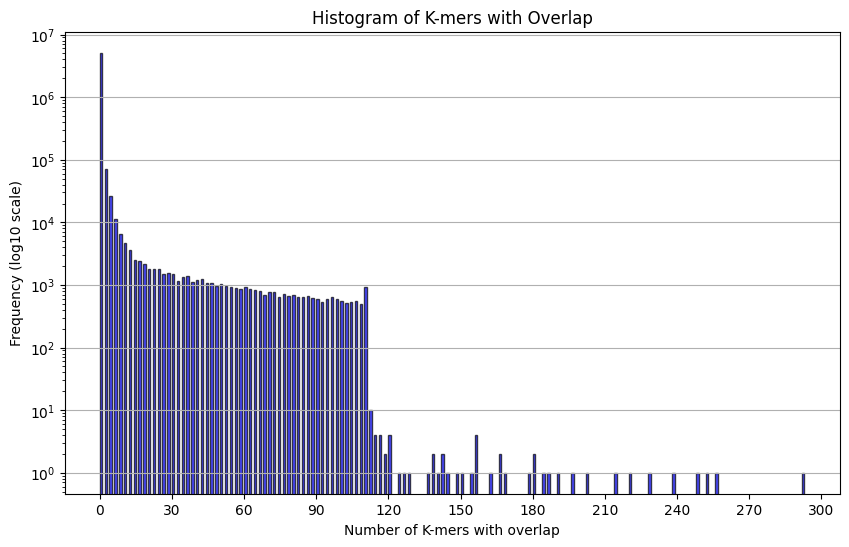

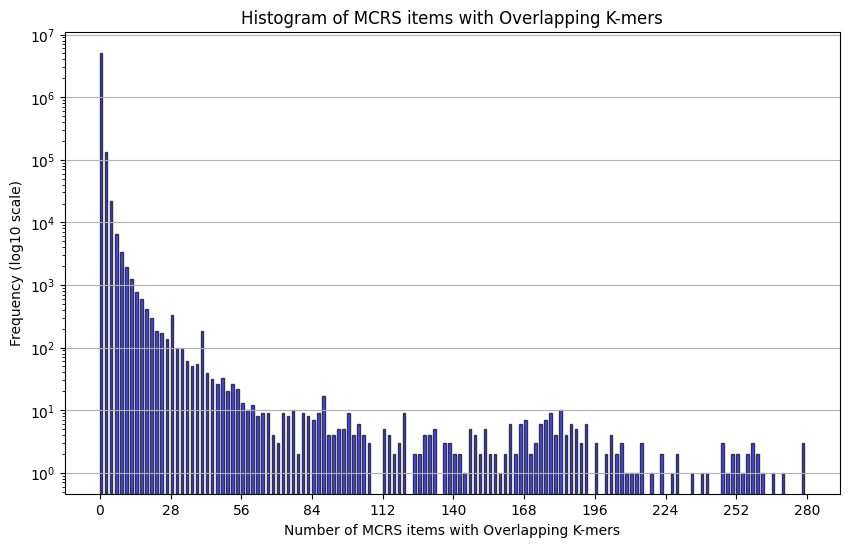

04:41:18 - INFO - Calculating longest homopolymer


04:43:02 - INFO - Calculating triplet stats


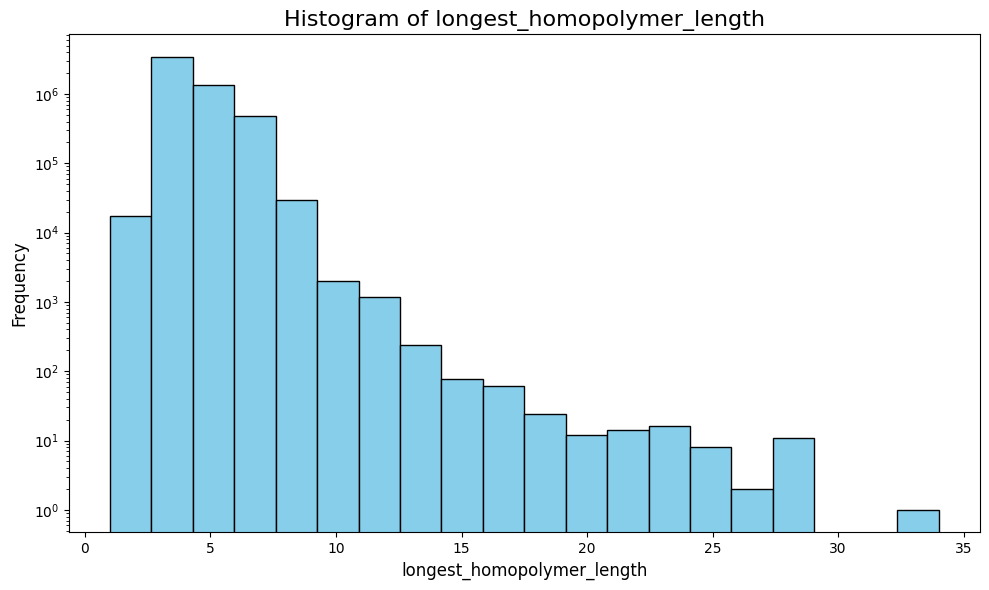

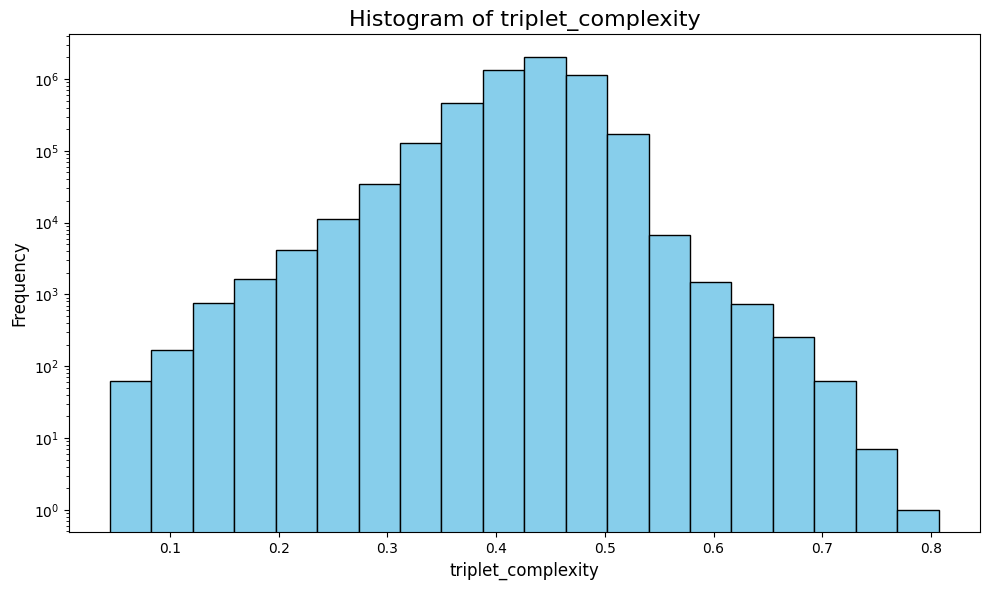

04:44:32 - INFO - Adding MCRS mutation type


04:47:57 - INFO - Adding concatenated header info


04:48:02 - INFO - Adding MCRS reverse complement


04:48:10 - INFO - Creating MCRS to self headers


Running bowtie2 build


Settings:
  Output files: "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 128
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs.fa
Reading reference sizes


Building a SMALL index


  Time reading reference sizes: 00:00:04
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences


  Time to join reference sequences: 00:00:04
bmax according to bmaxDivN setting: 4506442
Using parameters --bmax 3379832 --dcv 1024
  Doing ahead-of-time memory usage test


  Passed!  Constructing with these parameters: --bmax 3379832 --dcv 1024


Constructing suffix-array element generator
Building DifferenceCoverSample
  Building sPrime
  Building sPrimeOrder
  V-Sorting samples


  V-Sorting samples time: 00:00:06
  Allocating rank array
  Ranking v-sort output


  Ranking v-sort output time: 00:00:03
  Invoking Larsson-Sadakane on ranks


  Invoking Larsson-Sadakane on ranks time: 00:00:05
  Sanity-checking and returning
Building samples
Reserving space for 342 sample suffixes
Generating random suffixes
QSorting 342 sample offsets, eliminating duplicates
QSorting sample offsets, eliminating duplicates time: 00:00:00
Multikey QSorting 342 samples
  (Using difference cover)
  Multikey QSorting samples time: 00:00:00
Calculating bucket sizes


Splitting and merging
  Splitting and merging time: 00:00:00
Split 45, merged 160; iterating...


Splitting and merging
  Splitting and merging time: 00:00:00
Split 30, merged 23; iterating...


Splitting and merging
  Splitting and merging time: 00:00:00
Split 16, merged 11; iterating...


Splitting and merging
  Splitting and merging time: 00:00:00
Split 7, merged 10; iterating...


Splitting and merging
  Splitting and merging time: 00:00:00
Split 4, merged 7; iterating...
Avg bucket size: 2.46506e+06 (target: 3379831)
Converting suffix-array elements to index image
Allocating ftab, absorbFtab
Entering Ebwt loop
Getting block 1 of 234
Getting block 2 of 234
Getting block 3 of 234
Getting block 4 of 234
  Reserving size (3379832) for bucket 1
Getting block 5 of 234
Getting block 6 of 234
Getting block 7 of 234
Getting block 8 of 234
Getting block 9 of 234
Getting block 10 of 234
Getting block 11 of 234
Getting block 12 of 234
  Reserving size (3379832) for bucket 2
  Reserving size (3379832) for bucket 3
  Reserving size (3379832) for bucket 4
  Calculating Z arrays for bucket 1
  Reserving size (3379832) for bucket 5
  Reserving size (3379832) for bucket 6
Getting block 13 of 234
  Reserving size (3379832) for bucket 7
Getting block 14 of 234
  Reserving size (3379832) for bucket 8
  Reserving size (3379832) for bucket 9
  Reserving size (3379832) for bucket 10
 

  bucket 1: 10%
  bucket 4: 10%
  bucket 2: 10%
  bucket 5: 10%
  bucket 3: 10%
  bucket 6: 10%
  bucket 15: 10%
  bucket 12: 10%
  bucket 13: 10%
  bucket 18: 10%
  bucket 11: 10%
  bucket 7: 10%
  bucket 26: 10%
  bucket 9: 10%
  bucket 17: 10%
  bucket 10: 10%
  bucket 14: 10%
  bucket 27: 10%
  bucket 16: 10%
  bucket 20: 10%
  bucket 21: 10%
  bucket 30: 10%
  bucket 29: 10%
  bucket 25: 10%
  bucket 19: 10%
  bucket 28: 10%
  bucket 22: 10%
  bucket 23: 10%
  bucket 24: 10%
  bucket 31: 10%
  bucket 8: 10%


  bucket 2: 20%
  bucket 5: 20%
  bucket 4: 20%
  bucket 3: 20%
  bucket 7: 20%
  bucket 6: 20%
  bucket 13: 20%
  bucket 12: 20%
  bucket 18: 20%
  bucket 11: 20%
  bucket 9: 20%
  bucket 26: 20%
  bucket 15: 20%
  bucket 10: 20%
  bucket 14: 20%
  bucket 17: 20%
  bucket 27: 20%
  bucket 8: 20%
  bucket 21: 20%


  bucket 20: 20%
  bucket 29: 20%
  bucket 1: 20%
  bucket 25: 20%
  bucket 16: 20%
  bucket 23: 20%
  bucket 24: 20%
  bucket 28: 20%
  bucket 22: 20%
  bucket 19: 20%
  bucket 31: 20%


  bucket 30: 20%
  bucket 2: 30%
  bucket 4: 30%
  bucket 5: 30%
  bucket 3: 30%


  bucket 6: 30%
  bucket 7: 30%
  bucket 9: 30%
  bucket 13: 30%
  bucket 12: 30%
  bucket 11: 30%
  bucket 10: 30%
  bucket 18: 30%
  bucket 14: 30%
  bucket 15: 30%
  bucket 8: 30%
  bucket 1: 30%
  bucket 17: 30%
  bucket 26: 30%


  bucket 20: 30%
  bucket 27: 30%
  bucket 29: 30%
  bucket 23: 30%
  bucket 21: 30%
  bucket 28: 30%
  bucket 22: 30%
  bucket 25: 30%
  bucket 19: 30%
  bucket 24: 30%


  bucket 16: 30%
  bucket 31: 30%
  bucket 2: 40%
  bucket 4: 40%
  bucket 3: 40%
  bucket 5: 40%
  bucket 30: 30%
  bucket 6: 40%


  bucket 9: 40%
  bucket 7: 40%
  bucket 11: 40%
  bucket 13: 40%
  bucket 12: 40%
  bucket 1: 40%
  bucket 10: 40%
  bucket 14: 40%
  bucket 8: 40%
  bucket 15: 40%
  bucket 17: 40%
  bucket 18: 40%


  bucket 20: 40%
  bucket 29: 40%
  bucket 26: 40%
  bucket 23: 40%
  bucket 27: 40%
  bucket 28: 40%
  bucket 22: 40%
  bucket 21: 40%
  bucket 19: 40%
  bucket 25: 40%
  bucket 24: 40%


  bucket 16: 40%
  bucket 2: 50%
  bucket 3: 50%
  bucket 4: 50%
  bucket 31: 40%
  bucket 5: 50%
  bucket 6: 50%
  bucket 9: 50%
  bucket 30: 40%
  bucket 1: 50%
  bucket 7: 50%


  bucket 11: 50%
  bucket 10: 50%
  bucket 13: 50%
  bucket 12: 50%
  bucket 8: 50%
  bucket 14: 50%
  bucket 15: 50%
  bucket 17: 50%
  bucket 18: 50%


  bucket 20: 50%
  bucket 29: 50%
  bucket 23: 50%
  bucket 26: 50%
  bucket 27: 50%
  bucket 28: 50%
  bucket 22: 50%
  bucket 19: 50%
  bucket 21: 50%
  bucket 3: 60%
  bucket 2: 60%
  bucket 4: 60%


  bucket 25: 50%
  bucket 24: 50%
  bucket 5: 60%
  bucket 6: 60%
  bucket 16: 50%
  bucket 1: 60%
  bucket 9: 60%
  bucket 31: 50%


  bucket 7: 60%
  bucket 11: 60%
  bucket 10: 60%
  bucket 8: 60%
  bucket 30: 50%
  bucket 14: 60%
  bucket 13: 60%
  bucket 12: 60%
  bucket 15: 60%
  bucket 17: 60%


  bucket 18: 60%
  bucket 20: 60%
  bucket 29: 60%
  bucket 23: 60%
  bucket 3: 70%
  bucket 2: 70%
  bucket 26: 60%
  bucket 19: 60%
  bucket 4: 70%
  bucket 28: 60%


  bucket 22: 60%
  bucket 27: 60%
  bucket 6: 70%
  bucket 1: 70%
  bucket 5: 70%
  bucket 21: 60%
  bucket 25: 60%
  bucket 24: 60%
  bucket 9: 70%
  bucket 16: 60%


  bucket 11: 70%
  bucket 7: 70%
  bucket 8: 70%
  bucket 10: 70%
  bucket 14: 70%
  bucket 13: 70%
  bucket 12: 70%
  bucket 31: 60%
  bucket 15: 70%
  bucket 17: 70%
  bucket 30: 60%


  bucket 18: 70%
  bucket 20: 70%
  bucket 3: 80%
  bucket 2: 80%
  bucket 29: 70%
  bucket 4: 80%
  bucket 23: 70%
  bucket 1: 80%
  bucket 6: 80%
  bucket 19: 70%
  bucket 5: 80%


  bucket 26: 70%
  bucket 28: 70%
  bucket 22: 70%
  bucket 27: 70%
  bucket 9: 80%
  bucket 21: 70%
  bucket 11: 80%
  bucket 25: 70%
  bucket 24: 70%
  bucket 7: 80%


  bucket 16: 70%
  bucket 8: 80%
  bucket 10: 80%
  bucket 14: 80%
  bucket 13: 80%
  bucket 12: 80%
  bucket 15: 80%
  bucket 17: 80%


  bucket 30: 70%
  bucket 31: 70%
  bucket 2: 90%
  bucket 3: 90%
  bucket 18: 80%
  bucket 1: 90%
  bucket 4: 90%
  bucket 20: 80%
  bucket 6: 90%
  bucket 29: 80%
  bucket 5: 90%
  bucket 23: 80%


  bucket 19: 80%
  bucket 28: 80%
  bucket 26: 80%
  bucket 22: 80%
  bucket 9: 90%
  bucket 27: 80%
  bucket 11: 90%
  bucket 7: 90%
  bucket 21: 80%
  bucket 8: 90%


  bucket 10: 90%
  bucket 16: 80%
  bucket 25: 80%
  bucket 14: 90%
  bucket 24: 80%
  bucket 13: 90%
  bucket 12: 90%
  bucket 15: 90%
  bucket 17: 90%


  bucket 1: 100%
  Sorting block of length 2215115 for bucket 1
  (Using difference cover)
  bucket 2: 100%
  Sorting block of length 3028505 for bucket 2
  (Using difference cover)
  bucket 3: 100%
  Sorting block of length 2620020 for bucket 3
  (Using difference cover)
  bucket 4: 100%
  Sorting block of length 1545588 for bucket 4
  (Using difference cover)
  bucket 30: 80%
  bucket 18: 90%
  bucket 6: 100%
  Sorting block of length 2916388 for bucket 6
  (Using difference cover)
  bucket 5: 100%
  Sorting block of length 2652226 for bucket 5
  (Using difference cover)
  bucket 20: 90%
  bucket 31: 80%
  bucket 29: 90%


  bucket 23: 90%
  bucket 19: 90%
  bucket 9: 100%
  Sorting block of length 3194000 for bucket 9
  (Using difference cover)
  bucket 22: 90%
  bucket 28: 90%
  bucket 26: 90%
  bucket 11: 100%
  Sorting block of length 2860749 for bucket 11
  (Using difference cover)
  bucket 8: 100%
  Sorting block of length 1241710 for bucket 8
  (Using difference cover)
  bucket 27: 90%
  bucket 7: 100%
  Sorting block of length 2932949 for bucket 7
  (Using difference cover)


  bucket 10: 100%
  Sorting block of length 3061963 for bucket 10
  (Using difference cover)
  bucket 21: 90%
  bucket 14: 100%
  Sorting block of length 2876437 for bucket 14
  (Using difference cover)
  bucket 16: 90%
  bucket 13: 100%
  Sorting block of length 2967223 for bucket 13
  (Using difference cover)
  bucket 25: 90%
  bucket 15: 100%
  Sorting block of length 2983501 for bucket 15
  (Using difference cover)
  bucket 17: 100%
  Sorting block of length 2522610 for bucket 17
  (Using difference cover)
  bucket 12: 100%
  Sorting block of length 1995951 for bucket 12
  (Using difference cover)
  bucket 24: 90%


  bucket 30: 90%
  bucket 18: 100%
  Sorting block of length 1346926 for bucket 18
  (Using difference cover)
  bucket 20: 100%
  Sorting block of length 3141931 for bucket 20
  (Using difference cover)
  bucket 29: 100%
  Sorting block of length 1044412 for bucket 29
  (Using difference cover)
  bucket 23: 100%
  Sorting block of length 1458938 for bucket 23
  (Using difference cover)
  bucket 19: 100%
  Sorting block of length 2294971 for bucket 19
  (Using difference cover)
  bucket 31: 90%


  bucket 22: 100%
  Sorting block of length 2764166 for bucket 22
  (Using difference cover)
  bucket 28: 100%
  Sorting block of length 2951498 for bucket 28
  (Using difference cover)
  bucket 26: 100%
  Sorting block of length 1586107 for bucket 26
  (Using difference cover)
  bucket 27: 100%
  Sorting block of length 1930105 for bucket 27
  (Using difference cover)
  bucket 21: 100%
  Sorting block of length 1130593 for bucket 21
  (Using difference cover)


  bucket 16: 100%
  Sorting block of length 2730064 for bucket 16
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1545589 for bucket 4
  bucket 25: 100%
  Sorting block of length 3146498 for bucket 25
  (Using difference cover)
  bucket 24: 100%
  Sorting block of length 2720126 for bucket 24
  (Using difference cover)
Getting block 32 of 234
  Reserving size (3379832) for bucket 32
  Calculating Z arrays for bucket 32
  Entering block accumulator loop for bucket 32:
  Sorting block time: 00:00:01
Returning block of 1241711 for bucket 8
Getting block 33 of 234
  Reserving size (3379832) for bucket 33
  Calculating Z arrays for bucket 33
  Entering block accumulator loop for bucket 33:
  Sorting block time: 00:00:01
Returning block of 2215116 for bucket 1


Getting block 34 of 234
  Reserving size (3379832) for bucket 34
  Calculating Z arrays for bucket 34
  Entering block accumulator loop for bucket 34:
  bucket 30: 100%
  Sorting block of length 3121850 for bucket 30
  (Using difference cover)


  bucket 31: 100%
  Sorting block of length 3122178 for bucket 31
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1044413 for bucket 29
Getting block 35 of 234
  Reserving size (3379832) for bucket 35
  Calculating Z arrays for bucket 35
  Entering block accumulator loop for bucket 35:
  Sorting block time: 00:00:01
Returning block of 2652227 for bucket 5
  Sorting block time: 00:00:01
Returning block of 1346927 for bucket 18
  Sorting block time: 00:00:01
Returning block of 2620021 for bucket 3
Getting block 36 of 234
  Reserving size (3379832) for bucket 36
  Calculating Z arrays for bucket 36
  Entering block accumulator loop for bucket 36:
Getting block 37 of 234
  Reserving size (3379832) for bucket 37
  Calculating Z arrays for bucket 37
  Entering block accumulator loop for bucket 37:


Getting block 38 of 234
  Reserving size (3379832) for bucket 38
  Calculating Z arrays for bucket 38
  Entering block accumulator loop for bucket 38:
  Sorting block time: 00:00:02
Returning block of 1995952 for bucket 12
  Sorting block time: 00:00:02
Returning block of 3028506 for bucket 2
  Sorting block time: 00:00:02
Returning block of 1458939 for bucket 23
  Sorting block time: 00:00:02
Returning block of 2916389 for bucket 6
Getting block 39 of 234
  Reserving size (3379832) for bucket 39
  Calculating Z arrays for bucket 39
  Entering block accumulator loop for bucket 39:
Getting block 40 of 234
  Reserving size (3379832) for bucket 40
  Calculating Z arrays for bucket 40
  Entering block accumulator loop for bucket 40:
Getting block 41 of 234
  Reserving size (3379832) for bucket 41
  Calculating Z arrays for bucket 41
  Entering block accumulator loop for bucket 41:
  bucket 32: 10%
Getting block 42 of 234
  Reserving size (3379832) for bucket 42
  Calculating Z arrays for b

Getting block 43 of 234
  Reserving size (3379832) for bucket 43
  Calculating Z arrays for bucket 43
  Entering block accumulator loop for bucket 43:
  Sorting block time: 00:00:02
Returning block of 2522611 for bucket 17
  bucket 33: 10%
  bucket 34: 10%
Getting block 44 of 234
  Reserving size (3379832) for bucket 44
  Calculating Z arrays for bucket 44
  Entering block accumulator loop for bucket 44:
  Sorting block time: 00:00:02
Returning block of 2860750 for bucket 11
  Sorting block time: 00:00:01
Returning block of 1586108 for bucket 26
Getting block 45 of 234
  Reserving size (3379832) for bucket 45
  Calculating Z arrays for bucket 45
  Entering block accumulator loop for bucket 45:
  Sorting block time: 00:00:02
Returning block of 3194001 for bucket 9
  Sorting block time: 00:00:02
Returning block of 2876438 for bucket 14


Getting block 46 of 234
  Reserving size (3379832) for bucket 46
  Calculating Z arrays for bucket 46
  Entering block accumulator loop for bucket 46:
  Sorting block time: 00:00:02
Returning block of 2932950 for bucket 7
  Sorting block time: 00:00:02
Returning block of 3061964 for bucket 10
Getting block 47 of 234
  Reserving size (3379832) for bucket 47
  Calculating Z arrays for bucket 47
  Entering block accumulator loop for bucket 47:
Getting block 48 of 234
  Reserving size (3379832) for bucket 48
  Calculating Z arrays for bucket 48
  Entering block accumulator loop for bucket 48:
Getting block 49 of 234
  Reserving size (3379832) for bucket 49
  Calculating Z arrays for bucket 49
  Entering block accumulator loop for bucket 49:
Getting block 50 of 234
  Reserving size (3379832) for bucket 50
  Calculating Z arrays for bucket 50
  Entering block accumulator loop for bucket 50:
  Sorting block time: 00:00:01
Returning block of 2294972 for bucket 19
  Sorting block time: 00:00:02

Getting block 51 of 234
  Reserving size (3379832) for bucket 51
  Calculating Z arrays for bucket 51
  Entering block accumulator loop for bucket 51:
Getting block 52 of 234
  Reserving size (3379832) for bucket 52
  Calculating Z arrays for bucket 52
  Entering block accumulator loop for bucket 52:
  Sorting block time: 00:00:02
Returning block of 2967224 for bucket 13
  Sorting block time: 00:00:01
Returning block of 1930106 for bucket 27
Getting block 53 of 234
  Reserving size (3379832) for bucket 53
Getting block 54 of 234
  Calculating Z arrays for bucket 53
  Reserving size (3379832) for bucket 54
  Calculating Z arrays for bucket 54
  Entering block accumulator loop for bucket 53:
  Entering block accumulator loop for bucket 54:
  bucket 37: 10%
  bucket 36: 10%


  bucket 38: 10%
  bucket 40: 10%
  bucket 39: 10%
  Sorting block time: 00:00:01
Returning block of 2764167 for bucket 22
  bucket 32: 20%
  bucket 41: 10%
  bucket 42: 10%
Getting block 55 of 234
  Reserving size (3379832) for bucket 55
  Calculating Z arrays for bucket 55
  Entering block accumulator loop for bucket 55:
  Sorting block time: 00:00:03
Returning block of 3141932 for bucket 20


  bucket 43: 10%
  Sorting block time: 00:00:02
Returning block of 2730065 for bucket 16
  bucket 34: 20%
  bucket 33: 20%
Getting block 56 of 234
  Reserving size (3379832) for bucket 56
  Calculating Z arrays for bucket 56
  Entering block accumulator loop for bucket 56:
  bucket 44: 10%
  Sorting block time: 00:00:02
Returning block of 2951499 for bucket 28
Getting block 57 of 234
  Reserving size (3379832) for bucket 57
  Calculating Z arrays for bucket 57
  Entering block accumulator loop for bucket 57:
Getting block 58 of 234
  Reserving size (3379832) for bucket 58
  Calculating Z arrays for bucket 58
  Entering block accumulator loop for bucket 58:
  bucket 45: 10%
  bucket 46: 10%


  bucket 49: 10%
  bucket 48: 10%
  bucket 47: 10%
  Sorting block time: 00:00:02
Returning block of 2720127 for bucket 24
  bucket 50: 10%
  bucket 35: 20%
Getting block 59 of 234
  Reserving size (3379832) for bucket 59
  Calculating Z arrays for bucket 59
  Entering block accumulator loop for bucket 59:
  bucket 51: 10%
  bucket 52: 10%


  bucket 53: 10%
  bucket 54: 10%
  bucket 37: 20%
  Sorting block time: 00:00:02
Returning block of 3121851 for bucket 30
  bucket 36: 20%
  Sorting block time: 00:00:02
Returning block of 3146499 for bucket 25
  bucket 38: 20%
  bucket 32: 30%
Getting block 60 of 234
  Reserving size (3379832) for bucket 60
  Calculating Z arrays for bucket 60
  Entering block accumulator loop for bucket 60:
Getting block 61 of 234
  Reserving size (3379832) for bucket 61
  Calculating Z arrays for bucket 61
  Entering block accumulator loop for bucket 61:
  Sorting block time: 00:00:02
Returning block of 3122179 for bucket 31


  bucket 39: 20%
  bucket 40: 20%
  bucket 42: 20%
  bucket 55: 10%
  bucket 41: 20%
  bucket 34: 30%
Getting block 62 of 234
  Reserving size (3379832) for bucket 62
  Calculating Z arrays for bucket 62
  Entering block accumulator loop for bucket 62:
  bucket 33: 30%
  bucket 43: 20%
  bucket 57: 10%
  bucket 56: 10%
  bucket 44: 20%


  bucket 58: 10%
  bucket 49: 20%
  bucket 46: 20%
  bucket 45: 20%
  bucket 50: 20%
  bucket 48: 20%
  bucket 47: 20%
  bucket 51: 20%
  bucket 35: 30%


  bucket 52: 20%
  bucket 53: 20%
  bucket 54: 20%
  bucket 59: 10%


  bucket 37: 30%
  bucket 36: 30%
  bucket 38: 30%
  bucket 32: 40%
  bucket 39: 30%
  bucket 40: 30%
  bucket 55: 20%
  bucket 34: 40%
  bucket 42: 30%


  bucket 60: 10%
  bucket 33: 40%
  bucket 41: 30%
  bucket 57: 20%
  bucket 56: 20%
  bucket 43: 30%
  bucket 49: 30%
  bucket 44: 30%
  bucket 58: 20%
  bucket 62: 10%
  bucket 61: 10%
  bucket 46: 30%
  bucket 45: 30%
  bucket 50: 30%


  bucket 48: 30%
  bucket 51: 30%
  bucket 47: 30%
  bucket 35: 40%
  bucket 52: 30%


  bucket 53: 30%
  bucket 54: 30%
  bucket 37: 40%
  bucket 32: 50%
  bucket 38: 40%
  bucket 36: 40%


  bucket 59: 20%
  bucket 39: 40%
  bucket 34: 50%
  bucket 55: 30%
  bucket 40: 40%
  bucket 42: 40%
  bucket 57: 30%
  bucket 33: 50%
  bucket 49: 40%
  bucket 56: 30%
  bucket 41: 40%
  bucket 58: 30%
  bucket 43: 40%


  bucket 60: 20%
  bucket 44: 40%
  bucket 46: 40%
  bucket 50: 40%
  bucket 45: 40%
  bucket 51: 40%
  bucket 48: 40%
  bucket 62: 20%
  bucket 52: 40%
  bucket 47: 40%


  bucket 35: 50%
  bucket 61: 20%
  bucket 53: 40%
  bucket 54: 40%
  bucket 32: 60%


  bucket 37: 50%
  bucket 38: 50%
  bucket 36: 50%
  bucket 39: 50%
  bucket 57: 40%
  bucket 34: 60%
  bucket 55: 40%
  bucket 33: 60%
  bucket 49: 50%
  bucket 40: 50%


  bucket 58: 40%
  bucket 42: 50%
  bucket 59: 30%
  bucket 56: 40%
  bucket 43: 50%
  bucket 41: 50%
  bucket 46: 50%
  bucket 50: 50%
  bucket 44: 50%
  bucket 52: 50%
  bucket 51: 50%


  bucket 45: 50%
  bucket 48: 50%
  bucket 60: 30%
  bucket 47: 50%
  bucket 62: 30%
  bucket 35: 60%
  bucket 53: 50%
  bucket 54: 50%


  bucket 61: 30%
  bucket 32: 70%
  bucket 37: 60%
  bucket 38: 60%
  bucket 36: 60%
  bucket 57: 50%


  bucket 39: 60%
  bucket 34: 70%
  bucket 49: 60%
  bucket 33: 70%
  bucket 55: 50%
  bucket 58: 50%
  bucket 40: 60%
  bucket 56: 50%
  bucket 42: 60%
  bucket 46: 60%
  bucket 43: 60%


  bucket 50: 60%
  bucket 52: 60%
  bucket 41: 60%
  bucket 59: 40%
  bucket 51: 60%
  bucket 44: 60%
  bucket 45: 60%
  bucket 48: 60%


  bucket 53: 60%
  bucket 47: 60%
  bucket 54: 60%
  bucket 35: 70%
  bucket 60: 40%
  bucket 62: 40%
  bucket 32: 80%


  bucket 61: 40%
  bucket 37: 70%
  bucket 38: 70%
  bucket 57: 60%
  bucket 36: 70%
  bucket 49: 70%
  bucket 39: 70%
  bucket 58: 60%
  bucket 34: 80%
  bucket 33: 80%
  bucket 55: 60%


  bucket 56: 60%
  bucket 46: 70%
  bucket 40: 70%
  bucket 42: 70%
  bucket 52: 70%
  bucket 50: 70%
  bucket 43: 70%
  bucket 51: 70%
  bucket 41: 70%
  bucket 44: 70%


  bucket 48: 70%
  bucket 45: 70%
  bucket 53: 70%
  bucket 59: 50%
  bucket 54: 70%
  bucket 47: 70%
  bucket 35: 80%
  bucket 32: 90%


  bucket 62: 50%
  bucket 57: 70%
  bucket 60: 50%
  bucket 37: 80%
  bucket 38: 80%
  bucket 49: 80%
  bucket 58: 70%
  bucket 36: 80%
  bucket 33: 90%
  bucket 61: 50%
  bucket 34: 90%
  bucket 39: 80%


  bucket 55: 70%
  bucket 46: 80%
  bucket 52: 80%
  bucket 56: 70%
  bucket 50: 80%
  bucket 40: 80%
  bucket 43: 80%
  bucket 42: 80%
  bucket 51: 80%


  bucket 41: 80%
  bucket 44: 80%
  bucket 53: 80%
  bucket 48: 80%
  bucket 45: 80%
  bucket 54: 80%
  bucket 32: 100%
  Sorting block of length 1554590 for bucket 32
  (Using difference cover)
  bucket 47: 80%


  bucket 35: 90%
  bucket 59: 60%
  bucket 49: 90%
  bucket 57: 80%
  bucket 58: 80%
  bucket 34: 100%
  Sorting block of length 1983585 for bucket 34
  (Using difference cover)
  bucket 60: 60%
  bucket 36: 90%
  bucket 38: 90%
  bucket 62: 60%


  bucket 33: 100%
  Sorting block of length 3216088 for bucket 33
  (Using difference cover)
  bucket 39: 90%
  bucket 55: 80%
  bucket 46: 90%
  bucket 37: 90%
  bucket 61: 60%
  bucket 56: 80%
  bucket 50: 90%
  bucket 52: 90%


  bucket 51: 90%
  bucket 40: 90%
  bucket 42: 90%
  bucket 43: 90%
  bucket 41: 90%
  bucket 48: 90%
  bucket 44: 90%
  bucket 53: 90%


  bucket 45: 90%
  bucket 54: 90%
  bucket 47: 90%
  bucket 49: 100%
  Sorting block of length 3104897 for bucket 49
  (Using difference cover)
  bucket 35: 100%
  Sorting block of length 2915260 for bucket 35
  (Using difference cover)


  bucket 58: 90%
  bucket 57: 90%
  bucket 59: 70%
  bucket 36: 100%
  Sorting block of length 2459136 for bucket 36
  (Using difference cover)
  bucket 55: 90%
  bucket 39: 100%
  Sorting block of length 2672591 for bucket 39
  (Using difference cover)
  bucket 60: 70%


  bucket 56: 90%
  Sorting block time: 00:00:01
Returning block of 1554591 for bucket 32
  bucket 50: 100%
  Sorting block of length 2713920 for bucket 50
  (Using difference cover)
  bucket 62: 70%
  bucket 46: 100%
  Sorting block of length 1510999 for bucket 46
  (Using difference cover)
  bucket 38: 100%
  Sorting block of length 1595011 for bucket 38
  (Using difference cover)
  bucket 37: 100%
  Sorting block of length 2783308 for bucket 37
  (Using difference cover)
  bucket 51: 100%
  Sorting block of length 2854527 for bucket 51
  (Using difference cover)
Getting block 63 of 234
  Reserving size (3379832) for bucket 63
  Calculating Z arrays for bucket 63
  Entering block accumulator loop for bucket 63:
  bucket 52: 100%
  Sorting block of length 2740990 for bucket 52
  (Using difference cover)
  bucket 40: 100%
  Sorting block of length 3270273 for bucket 40
  (Using difference cover)
  bucket 42: 100%
  Sorting block of length 3220127 for bucket 42
  (Using difference cover)

  bucket 43: 100%
  Sorting block of length 2830273 for bucket 43
  (Using difference cover)
  bucket 48: 100%
  Sorting block of length 3061980 for bucket 48
  (Using difference cover)
  bucket 41: 100%
  Sorting block of length 2287742 for bucket 41
  (Using difference cover)
  bucket 53: 100%
  Sorting block of length 1840022 for bucket 53
  (Using difference cover)
  bucket 44: 100%
  Sorting block of length 3329785 for bucket 44
  (Using difference cover)
  bucket 45: 100%
  Sorting block of length 2399182 for bucket 45
  (Using difference cover)
  bucket 54: 100%
  Sorting block of length 3182806 for bucket 54
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1983586 for bucket 34


  bucket 47: 100%
  Sorting block of length 3074313 for bucket 47
  (Using difference cover)
Getting block 64 of 234
  Reserving size (3379832) for bucket 64
  Calculating Z arrays for bucket 64
  Entering block accumulator loop for bucket 64:
  bucket 58: 100%
  Sorting block of length 3301881 for bucket 58
  (Using difference cover)


  bucket 57: 100%
  Sorting block of length 2662294 for bucket 57
  (Using difference cover)
  bucket 55: 100%
  Sorting block of length 3127402 for bucket 55
  (Using difference cover)
  bucket 56: 100%
  Sorting block of length 3230611 for bucket 56
  (Using difference cover)


  bucket 59: 80%
  bucket 60: 80%
  bucket 62: 80%


  bucket 63: 10%
  Sorting block time: 00:00:01
Returning block of 1511000 for bucket 46
  Sorting block time: 00:00:02
Returning block of 3216089 for bucket 33
Getting block 65 of 234
  Reserving size (3379832) for bucket 65
  Calculating Z arrays for bucket 65
  Entering block accumulator loop for bucket 65:
  bucket 61: 80%
Getting block 66 of 234
  Reserving size (3379832) for bucket 66
  Calculating Z arrays for bucket 66
  Entering block accumulator loop for bucket 66:


  Sorting block time: 00:00:01
Returning block of 1595012 for bucket 38
  bucket 64: 10%
Getting block 67 of 234
  Reserving size (3379832) for bucket 67
  Calculating Z arrays for bucket 67
  Entering block accumulator loop for bucket 67:


  Sorting block time: 00:00:01
Returning block of 1840023 for bucket 53
  Sorting block time: 00:00:02
Returning block of 3104898 for bucket 49
Getting block 68 of 234
  Reserving size (3379832) for bucket 68
  Calculating Z arrays for bucket 68
  Entering block accumulator loop for bucket 68:
  Sorting block time: 00:00:01
Returning block of 2459137 for bucket 36
  Sorting block time: 00:00:02
Returning block of 2915261 for bucket 35
Getting block 69 of 234
  Reserving size (3379832) for bucket 69
  Calculating Z arrays for bucket 69
  Entering block accumulator loop for bucket 69:
Getting block 70 of 234
  Reserving size (3379832) for bucket 70
  Calculating Z arrays for bucket 70
  Entering block accumulator loop for bucket 70:
Getting block 71 of 234
  Reserving size (3379832) for bucket 71
  Calculating Z arrays for bucket 71
  Entering block accumulator loop for bucket 71:


  bucket 60: 90%
  bucket 59: 90%
  bucket 62: 90%
  Sorting block time: 00:00:02
Returning block of 2672592 for bucket 39
  Sorting block time: 00:00:02
Returning block of 2713921 for bucket 50
  Sorting block time: 00:00:02
Returning block of 2783309 for bucket 37
Getting block 72 of 234
  Reserving size (3379832) for bucket 72
  Calculating Z arrays for bucket 72
  Entering block accumulator loop for bucket 72:
Getting block 73 of 234
  Reserving size (3379832) for bucket 73
  Calculating Z arrays for bucket 73
  Entering block accumulator loop for bucket 73:


Getting block 74 of 234
  Reserving size (3379832) for bucket 74
  Calculating Z arrays for bucket 74
  Entering block accumulator loop for bucket 74:
  Sorting block time: 00:00:02
Returning block of 2740991 for bucket 52
  bucket 63: 20%
  Sorting block time: 00:00:02
Returning block of 2854528 for bucket 51
  Sorting block time: 00:00:02
Returning block of 2287743 for bucket 41
  Sorting block time: 00:00:02
Returning block of 2399183 for bucket 45
Getting block 75 of 234
  Reserving size (3379832) for bucket 75
  Calculating Z arrays for bucket 75
  Entering block accumulator loop for bucket 75:
Getting block 76 of 234
  Reserving size (3379832) for bucket 76
  Calculating Z arrays for bucket 76
  Entering block accumulator loop for bucket 76:
Getting block 77 of 234
  Reserving size (3379832) for bucket 77
  Calculating Z arrays for bucket 77
  Entering block accumulator loop for bucket 77:
Getting block 78 of 234
  Reserving size (3379832) for bucket 78
  Calculating Z arrays for

  bucket 66: 10%
Getting block 79 of 234
  Reserving size (3379832) for bucket 79
  Calculating Z arrays for bucket 79
  Entering block accumulator loop for bucket 79:
  bucket 64: 20%
  Sorting block time: 00:00:02
Returning block of 3220128 for bucket 42
  Sorting block time: 00:00:02
Returning block of 3061981 for bucket 48
  bucket 67: 10%
Getting block 80 of 234
  Reserving size (3379832) for bucket 80
  Calculating Z arrays for bucket 80
  Entering block accumulator loop for bucket 80:
Getting block 81 of 234
  Reserving size (3379832) for bucket 81
  Calculating Z arrays for bucket 81
  Entering block accumulator loop for bucket 81:
  Sorting block time: 00:00:02
Returning block of 2662295 for bucket 57
  Sorting block time: 00:00:02
Returning block of 3270274 for bucket 40
Getting block 82 of 234
  Reserving size (3379832) for bucket 82
  Calculating Z arrays for bucket 82
  Entering block accumulator loop for bucket 82:
  Sorting block time: 00:00:02
Returning block of 3182807

Getting block 83 of 234
  Reserving size (3379832) for bucket 83
  Calculating Z arrays for bucket 83
  Entering block accumulator loop for bucket 83:
  Sorting block time: 00:00:02
Returning block of 3329786 for bucket 44
  Sorting block time: 00:00:02
Returning block of 3074314 for bucket 47
Getting block 84 of 234
  Reserving size (3379832) for bucket 84
  Calculating Z arrays for bucket 84
  Entering block accumulator loop for bucket 84:
Getting block 85 of 234
  Reserving size (3379832) for bucket 85
  Calculating Z arrays for bucket 85
  Entering block accumulator loop for bucket 85:
Getting block 86 of 234
  Reserving size (3379832) for bucket 86
  Calculating Z arrays for bucket 86
  Entering block accumulator loop for bucket 86:
  bucket 68: 10%
  Sorting block time: 00:00:02
Returning block of 3301882 for bucket 58
  bucket 69: 10%


  bucket 70: 10%
Getting block 87 of 234
  Reserving size (3379832) for bucket 87
  Calculating Z arrays for bucket 87
  Entering block accumulator loop for bucket 87:
  bucket 60: 100%
  Sorting block of length 2293334 for bucket 60
  (Using difference cover)
  bucket 71: 10%
  bucket 62: 100%
  Sorting block of length 2344732 for bucket 62
  (Using difference cover)
  Sorting block time: 00:00:03
Returning block of 3127403 for bucket 55
  bucket 59: 100%
  Sorting block of length 1191637 for bucket 59
  (Using difference cover)
Getting block 88 of 234
  Reserving size (3379832) for bucket 88
  Calculating Z arrays for bucket 88
  Entering block accumulator loop for bucket 88:


  bucket 73: 10%
  Sorting block time: 00:00:02
Returning block of 3230612 for bucket 56
  bucket 63: 30%
  bucket 72: 10%
  bucket 74: 10%
Getting block 89 of 234
  Reserving size (3379832) for bucket 89
  Calculating Z arrays for bucket 89
  Entering block accumulator loop for bucket 89:
  bucket 75: 10%
  bucket 76: 10%
  bucket 78: 10%
  bucket 77: 10%
  bucket 61: 100%
  Sorting block of length 2695873 for bucket 61
  (Using difference cover)
  bucket 65: 20%


  bucket 64: 30%
  bucket 66: 20%
  bucket 79: 10%
  bucket 67: 20%
  bucket 80: 10%
  bucket 81: 10%


  bucket 82: 10%
  bucket 83: 10%
  bucket 84: 10%
  bucket 86: 10%
  bucket 85: 10%
  bucket 68: 20%


  bucket 69: 20%
  Sorting block time: 00:00:00
Returning block of 1191638 for bucket 59
  bucket 87: 10%
  bucket 70: 20%
Getting block 90 of 234
  Reserving size (3379832) for bucket 90
  Calculating Z arrays for bucket 90
  Entering block accumulator loop for bucket 90:
  bucket 71: 20%


  bucket 88: 10%
  bucket 63: 40%
  bucket 73: 20%
  bucket 72: 20%
  bucket 74: 20%
  bucket 78: 20%
  bucket 76: 20%
  bucket 89: 10%
  bucket 77: 20%


  Sorting block time: 00:00:01
Returning block of 2293335 for bucket 60
  bucket 64: 40%
  bucket 65: 30%
Getting block 91 of 234
  Reserving size (3379832) for bucket 91
  Calculating Z arrays for bucket 91
  Entering block accumulator loop for bucket 91:
  bucket 66: 30%
  bucket 79: 20%
  bucket 75: 20%
  bucket 67: 30%
  bucket 80: 20%


  bucket 81: 20%
  Sorting block time: 00:00:01
Returning block of 2344733 for bucket 62
  bucket 83: 20%
  bucket 82: 20%
Getting block 92 of 234
  Reserving size (3379832) for bucket 92
  Calculating Z arrays for bucket 92
  Entering block accumulator loop for bucket 92:
  bucket 84: 20%


  bucket 86: 20%
  bucket 85: 20%
  bucket 68: 30%
  bucket 69: 30%
  bucket 87: 20%
  bucket 70: 30%


  bucket 90: 10%
  bucket 71: 30%
  bucket 63: 50%
  bucket 88: 20%
  Sorting block time: 00:00:02
Returning block of 2695874 for bucket 61
  bucket 73: 30%
Getting block 93 of 234
  Reserving size (3379832) for bucket 93
  Calculating Z arrays for bucket 93
  Entering block accumulator loop for bucket 93:


  bucket 78: 30%
  bucket 76: 30%
  bucket 74: 30%
  bucket 72: 30%
  bucket 89: 20%
  bucket 77: 30%
  bucket 64: 50%
  bucket 65: 40%


  bucket 91: 10%
  bucket 66: 40%
  bucket 67: 40%
  bucket 75: 30%
  bucket 80: 30%
  bucket 79: 30%
  bucket 81: 30%


  bucket 83: 30%
  bucket 82: 30%
  bucket 92: 10%
  bucket 84: 30%
  bucket 86: 30%
  bucket 85: 30%


  bucket 68: 40%
  bucket 87: 30%
  bucket 70: 40%
  bucket 63: 60%
  bucket 71: 40%
  bucket 90: 20%
  bucket 88: 30%


  bucket 69: 40%
  bucket 78: 40%
  bucket 73: 40%
  bucket 76: 40%
  bucket 93: 10%
  bucket 74: 40%
  bucket 64: 60%
  bucket 77: 40%
  bucket 89: 30%


  bucket 72: 40%
  bucket 65: 50%
  bucket 66: 50%
  bucket 91: 20%
  bucket 67: 50%
  bucket 75: 40%


  bucket 80: 40%
  bucket 79: 40%
  bucket 81: 40%
  bucket 83: 40%


  bucket 82: 40%
  bucket 84: 40%
  bucket 86: 40%
  bucket 92: 20%
  bucket 85: 40%
  bucket 68: 50%


  bucket 87: 40%
  bucket 70: 50%
  bucket 71: 50%
  bucket 88: 40%
  bucket 90: 30%
  bucket 78: 50%


  bucket 69: 50%
  bucket 73: 50%
  bucket 76: 50%
  bucket 63: 70%
  bucket 64: 70%
  bucket 77: 50%
  bucket 74: 50%
  bucket 93: 20%
  bucket 89: 40%
  bucket 65: 60%
  bucket 72: 50%


  bucket 66: 60%
  bucket 67: 60%
  bucket 80: 50%
  bucket 75: 50%
  bucket 91: 30%
  bucket 81: 50%
  bucket 79: 50%


  bucket 83: 50%
  bucket 84: 50%
  bucket 86: 50%
  bucket 82: 50%
  bucket 85: 50%
  bucket 92: 30%


  bucket 68: 60%
  bucket 87: 50%
  bucket 70: 60%
  bucket 88: 50%
  bucket 71: 60%
  bucket 78: 60%
  bucket 90: 40%


  bucket 63: 80%
  bucket 69: 60%
  bucket 76: 60%
  bucket 64: 80%
  bucket 73: 60%
  bucket 77: 60%
  bucket 74: 60%
  bucket 89: 50%
  bucket 65: 70%
  bucket 93: 30%


  bucket 72: 60%
  bucket 66: 70%
  bucket 67: 70%
  bucket 75: 60%
  bucket 80: 60%
  bucket 81: 60%
  bucket 91: 40%
  bucket 79: 60%


  bucket 83: 60%
  bucket 84: 60%
  bucket 86: 60%
  bucket 82: 60%
  bucket 85: 60%


  bucket 92: 40%
  bucket 68: 70%
  bucket 87: 60%
  bucket 70: 70%


  bucket 88: 60%
  bucket 78: 70%
  bucket 63: 90%
  bucket 71: 70%
  bucket 69: 70%
  bucket 64: 90%
  bucket 90: 50%
  bucket 76: 70%
  bucket 73: 70%


  bucket 77: 70%
  bucket 74: 70%
  bucket 65: 80%
  bucket 89: 60%
  bucket 66: 80%
  bucket 93: 40%
  bucket 72: 70%
  bucket 67: 80%
  bucket 75: 70%
  bucket 80: 70%


  bucket 81: 70%
  bucket 79: 70%
  bucket 91: 50%
  bucket 83: 70%
  bucket 84: 70%
  bucket 86: 70%


  bucket 82: 70%
  bucket 85: 70%
  bucket 92: 50%
  bucket 68: 80%
  bucket 87: 70%
  bucket 70: 80%


  bucket 78: 80%
  bucket 88: 70%
  bucket 63: 100%
  Sorting block of length 2630889 for bucket 63
  (Using difference cover)
  bucket 64: 100%
  Sorting block of length 2390967 for bucket 64
  (Using difference cover)
  bucket 71: 80%
  bucket 76: 80%
  bucket 69: 80%
  bucket 73: 80%
  bucket 90: 60%


  bucket 77: 80%
  bucket 65: 90%
  bucket 74: 80%
  bucket 89: 70%
  bucket 67: 90%
  bucket 72: 80%
  bucket 80: 80%
  bucket 93: 50%


  bucket 75: 80%
  bucket 81: 80%
  bucket 66: 90%
  bucket 83: 80%
  bucket 79: 80%
  bucket 91: 60%


  bucket 86: 80%
  bucket 84: 80%
  bucket 85: 80%
  bucket 82: 80%


  bucket 92: 60%
  bucket 87: 80%
  bucket 68: 90%
  bucket 78: 90%
  bucket 70: 90%
  bucket 88: 80%
  bucket 76: 90%
  bucket 71: 90%


  bucket 73: 90%
  bucket 77: 90%
  bucket 90: 70%
  bucket 65: 100%
  Sorting block of length 3133230 for bucket 65
  (Using difference cover)
  bucket 74: 90%
  bucket 89: 80%


  bucket 80: 90%
  bucket 67: 100%
  Sorting block of length 2618397 for bucket 67
  (Using difference cover)
  bucket 69: 90%
  bucket 72: 90%
  bucket 75: 90%
  bucket 93: 60%
  bucket 81: 90%
  bucket 66: 100%
  Sorting block of length 1720754 for bucket 66
  (Using difference cover)
  bucket 83: 90%
  bucket 79: 90%


  bucket 91: 70%
  Sorting block time: 00:00:02
Returning block of 2390968 for bucket 64
  bucket 86: 90%
  bucket 84: 90%
Getting block 94 of 234
  Reserving size (3379832) for bucket 94
  Calculating Z arrays for bucket 94
  Entering block accumulator loop for bucket 94:
  bucket 85: 90%
  bucket 82: 90%


  bucket 78: 100%
  Sorting block of length 2308186 for bucket 78
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2630890 for bucket 63
  bucket 87: 90%
  bucket 68: 100%
  Sorting block of length 2434633 for bucket 68
  (Using difference cover)
  bucket 88: 90%
  bucket 92: 70%
Getting block 95 of 234
  Reserving size (3379832) for bucket 95
  Calculating Z arrays for bucket 95
  Entering block accumulator loop for bucket 95:
  bucket 70: 100%
  Sorting block of length 1995569 for bucket 70
  (Using difference cover)
  bucket 76: 100%
  Sorting block of length 2882459 for bucket 76
  (Using difference cover)


  bucket 71: 100%
  Sorting block of length 3372938 for bucket 71
  (Using difference cover)
  bucket 73: 100%
  Sorting block of length 2779128 for bucket 73
  (Using difference cover)
  bucket 77: 100%
  Sorting block of length 2740205 for bucket 77
  (Using difference cover)
  bucket 90: 80%
  bucket 89: 90%
  bucket 74: 100%
  Sorting block of length 2421098 for bucket 74
  (Using difference cover)


  bucket 80: 100%
  Sorting block of length 2157970 for bucket 80
  (Using difference cover)
  bucket 81: 100%
  Sorting block of length 2548851 for bucket 81
  (Using difference cover)
  bucket 72: 100%
  Sorting block of length 3292334 for bucket 72
  (Using difference cover)
  bucket 69: 100%
  Sorting block of length 1472779 for bucket 69
  (Using difference cover)
  bucket 93: 70%
  bucket 83: 100%
  Sorting block of length 2323954 for bucket 83
  (Using difference cover)
  bucket 75: 100%
  Sorting block of length 2890428 for bucket 75
  (Using difference cover)


  bucket 79: 100%
  Sorting block of length 3368128 for bucket 79
  (Using difference cover)
  bucket 86: 100%
  Sorting block of length 3118086 for bucket 86
  (Using difference cover)
  bucket 91: 80%
  bucket 84: 100%
  Sorting block of length 3002190 for bucket 84
  (Using difference cover)
  bucket 94: 10%
  bucket 85: 100%
  Sorting block of length 3200909 for bucket 85
  (Using difference cover)


  bucket 82: 100%
  Sorting block of length 3299032 for bucket 82
  (Using difference cover)
  bucket 87: 100%
  Sorting block of length 3327435 for bucket 87
  (Using difference cover)
  bucket 88: 100%
  Sorting block of length 2031780 for bucket 88
  (Using difference cover)
  bucket 92: 80%
  bucket 95: 10%


  Sorting block time: 00:00:01
Returning block of 1720755 for bucket 66
Getting block 96 of 234
  Reserving size (3379832) for bucket 96
  Calculating Z arrays for bucket 96
  Entering block accumulator loop for bucket 96:
  bucket 90: 90%
  bucket 89: 100%
  Sorting block of length 2685254 for bucket 89
  (Using difference cover)


  Sorting block time: 00:00:02
Returning block of 2618398 for bucket 67
Getting block 97 of 234
  Reserving size (3379832) for bucket 97
  Calculating Z arrays for bucket 97
  Entering block accumulator loop for bucket 97:
  Sorting block time: 00:00:02
Returning block of 2308187 for bucket 78
  bucket 93: 80%
Getting block 98 of 234
  Reserving size (3379832) for bucket 98
  Calculating Z arrays for bucket 98
  Entering block accumulator loop for bucket 98:
  Sorting block time: 00:00:02
Returning block of 3133231 for bucket 65
  Sorting block time: 00:00:02
Returning block of 1995570 for bucket 70


  bucket 91: 90%
Getting block 99 of 234
  Reserving size (3379832) for bucket 99
  Calculating Z arrays for bucket 99
  Entering block accumulator loop for bucket 99:
Getting block 100 of 234
  Reserving size (3379832) for bucket 100
  Calculating Z arrays for bucket 100
  Entering block accumulator loop for bucket 100:
  Sorting block time: 00:00:01
Returning block of 1472780 for bucket 69
  Sorting block time: 00:00:02
Returning block of 2434634 for bucket 68
  bucket 94: 20%
Getting block 101 of 234
  Reserving size (3379832) for bucket 101
  Calculating Z arrays for bucket 101
  Entering block accumulator loop for bucket 101:
Getting block 102 of 234
  Reserving size (3379832) for bucket 102
  Calculating Z arrays for bucket 102
  Entering block accumulator loop for bucket 102:


  Sorting block time: 00:00:01
Returning block of 2157971 for bucket 80
  bucket 92: 90%
Getting block 103 of 234
  Reserving size (3379832) for bucket 103
  Calculating Z arrays for bucket 103
  Entering block accumulator loop for bucket 103:
  bucket 95: 20%
  Sorting block time: 00:00:02
Returning block of 2882460 for bucket 76
Getting block 104 of 234
  Reserving size (3379832) for bucket 104
  Calculating Z arrays for bucket 104
  Entering block accumulator loop for bucket 104:
  Sorting block time: 00:00:01
Returning block of 2740206 for bucket 77
  Sorting block time: 00:00:01
Returning block of 2421099 for bucket 74


  bucket 96: 10%
Getting block 105 of 234
  Reserving size (3379832) for bucket 105
  Calculating Z arrays for bucket 105
  Entering block accumulator loop for bucket 105:
Getting block 106 of 234
  Reserving size (3379832) for bucket 106
  Calculating Z arrays for bucket 106
  Entering block accumulator loop for bucket 106:
  Sorting block time: 00:00:03
Returning block of 2779129 for bucket 73
  Sorting block time: 00:00:02
Returning block of 2323955 for bucket 83
  bucket 90: 100%
  Sorting block of length 3259833 for bucket 90
  (Using difference cover)
Getting block 107 of 234
  Reserving size (3379832) for bucket 107
  Calculating Z arrays for bucket 107
  Entering block accumulator loop for bucket 107:
Getting block 108 of 234
  Reserving size (3379832) for bucket 108
  Calculating Z arrays for bucket 108
  Entering block accumulator loop for bucket 108:
  Sorting block time: 00:00:02
Returning block of 2548852 for bucket 81


Getting block 109 of 234
  Reserving size (3379832) for bucket 109
  Calculating Z arrays for bucket 109
  Entering block accumulator loop for bucket 109:
  Sorting block time: 00:00:03
Returning block of 3372939 for bucket 71
  Sorting block time: 00:00:02
Returning block of 2031781 for bucket 88
Getting block 110 of 234
  Reserving size (3379832) for bucket 110
  Calculating Z arrays for bucket 110
  Entering block accumulator loop for bucket 110:
  bucket 97: 10%
  bucket 93: 90%
Getting block 111 of 234
  Reserving size (3379832) for bucket 111
  Calculating Z arrays for bucket 111
  Entering block accumulator loop for bucket 111:
  bucket 98: 10%


  Sorting block time: 00:00:02
Returning block of 2890429 for bucket 75
  bucket 99: 10%
  bucket 91: 100%
  Sorting block of length 3184801 for bucket 91
  (Using difference cover)
Getting block 112 of 234
  Reserving size (3379832) for bucket 112
  Calculating Z arrays for bucket 112
  Entering block accumulator loop for bucket 112:
  bucket 100: 10%
  Sorting block time: 00:00:02
Returning block of 3118087 for bucket 86
  bucket 94: 30%
  Sorting block time: 00:00:02
Returning block of 3292335 for bucket 72
  bucket 101: 10%
  bucket 102: 10%


Getting block 113 of 234
  Reserving size (3379832) for bucket 113
  Calculating Z arrays for bucket 113
  Entering block accumulator loop for bucket 113:
  Sorting block time: 00:00:02
Returning block of 3002191 for bucket 84
Getting block 114 of 234
  Reserving size (3379832) for bucket 114
  Calculating Z arrays for bucket 114
  Entering block accumulator loop for bucket 114:
  Sorting block time: 00:00:02
Returning block of 3368129 for bucket 79
Getting block 115 of 234
  Reserving size (3379832) for bucket 115
  Calculating Z arrays for bucket 115
  Entering block accumulator loop for bucket 115:
  bucket 92: 100%
  Sorting block of length 3276770 for bucket 92
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 3200910 for bucket 85
Getting block 116 of 234
  Reserving size (3379832) for bucket 116
  Calculating Z arrays for bucket 116
  Entering block accumulator loop for bucket 116:
  bucket 95: 30%
  bucket 103: 10%


Getting block 117 of 234
  Reserving size (3379832) for bucket 117
  Calculating Z arrays for bucket 117
  Entering block accumulator loop for bucket 117:
  Sorting block time: 00:00:02
Returning block of 3299033 for bucket 82
  bucket 104: 10%
  Sorting block time: 00:00:02
Returning block of 3327436 for bucket 87
  bucket 96: 20%
Getting block 118 of 234
  Reserving size (3379832) for bucket 118
  Calculating Z arrays for bucket 118
  Entering block accumulator loop for bucket 118:
  bucket 105: 10%
  Sorting block time: 00:00:02
Returning block of 2685255 for bucket 89
Getting block 119 of 234
  Reserving size (3379832) for bucket 119
  Calculating Z arrays for bucket 119
  Entering block accumulator loop for bucket 119:
  bucket 106: 10%


Getting block 120 of 234
  Reserving size (3379832) for bucket 120
  Calculating Z arrays for bucket 120
  Entering block accumulator loop for bucket 120:
  bucket 108: 10%
  bucket 107: 10%


  bucket 109: 10%
  bucket 97: 20%
  bucket 93: 100%
  Sorting block of length 3041986 for bucket 93
  (Using difference cover)
  bucket 98: 20%
  bucket 110: 10%
  bucket 111: 10%
  bucket 99: 20%


  bucket 100: 20%
  bucket 112: 10%
  bucket 101: 20%
  bucket 94: 40%
  bucket 102: 20%
  bucket 114: 10%
  bucket 113: 10%


  bucket 115: 10%
  bucket 95: 40%
  bucket 116: 10%
  bucket 103: 20%
  bucket 96: 30%


  bucket 118: 10%
  bucket 104: 20%
  bucket 119: 10%
  bucket 106: 20%
  bucket 117: 10%
  bucket 105: 20%
  bucket 120: 10%


  bucket 108: 20%
  Sorting block time: 00:00:02
Returning block of 3259834 for bucket 90
  bucket 107: 20%
  bucket 97: 30%
  bucket 109: 20%
  bucket 98: 30%
  bucket 99: 30%
Getting block 121 of 234
  Reserving size (3379832) for bucket 121
  Calculating Z arrays for bucket 121
  Entering block accumulator loop for bucket 121:


  bucket 100: 30%
  bucket 110: 20%
  bucket 111: 20%
  bucket 112: 20%
  Sorting block time: 00:00:02
Returning block of 3184802 for bucket 91
  bucket 94: 50%
  bucket 101: 30%
Getting block 122 of 234
  Reserving size (3379832) for bucket 122
  Calculating Z arrays for bucket 122
  Entering block accumulator loop for bucket 122:


  bucket 114: 20%
  bucket 113: 20%
  bucket 102: 30%
  bucket 115: 20%
  bucket 95: 50%
  bucket 103: 30%
  bucket 116: 20%
  bucket 96: 40%


  bucket 118: 20%
  bucket 104: 30%
  bucket 119: 20%
  bucket 106: 30%
  bucket 105: 30%
  Sorting block time: 00:00:03
Returning block of 3276771 for bucket 92
  bucket 120: 20%


Getting block 123 of 234
  Reserving size (3379832) for bucket 123
  Calculating Z arrays for bucket 123
  Entering block accumulator loop for bucket 123:
  bucket 117: 20%
  bucket 97: 40%
  bucket 108: 30%
  Sorting block time: 00:00:02
Returning block of 3041987 for bucket 93
  bucket 107: 30%


  bucket 98: 40%
  bucket 99: 40%
Getting block 124 of 234
  Reserving size (3379832) for bucket 124
  Calculating Z arrays for bucket 124
  Entering block accumulator loop for bucket 124:
  bucket 109: 30%
  bucket 100: 40%
  bucket 121: 10%
  bucket 94: 60%
  bucket 111: 30%


  bucket 112: 30%
  bucket 110: 30%
  bucket 101: 40%
  bucket 122: 10%
  bucket 95: 60%
  bucket 114: 30%
  bucket 113: 30%
  bucket 115: 30%


  bucket 103: 40%
  bucket 116: 30%
  bucket 96: 50%
  bucket 118: 30%
  bucket 104: 40%


  bucket 119: 30%
  bucket 102: 40%
  bucket 106: 40%
  bucket 105: 40%
  bucket 120: 30%
  bucket 123: 10%


  bucket 97: 50%
  bucket 117: 30%
  bucket 99: 50%
  bucket 98: 50%
  bucket 108: 40%
  bucket 124: 10%
  bucket 100: 50%
  bucket 107: 40%


  bucket 121: 20%
  bucket 109: 40%
  bucket 94: 70%
  bucket 111: 40%
  bucket 110: 40%


  bucket 122: 20%
  bucket 95: 70%
  bucket 113: 40%
  bucket 114: 40%
  bucket 112: 40%
  bucket 103: 50%
  bucket 115: 40%
  bucket 96: 60%
  bucket 101: 50%
  bucket 116: 40%


  bucket 118: 40%
  bucket 104: 50%
  bucket 119: 40%
  bucket 102: 50%


  bucket 106: 50%
  bucket 105: 50%
  bucket 120: 40%
  bucket 123: 20%


  bucket 97: 60%
  bucket 99: 60%
  bucket 98: 60%
  bucket 100: 60%
  bucket 124: 20%
  bucket 117: 40%
  bucket 108: 50%
  bucket 94: 80%


  bucket 121: 30%
  bucket 107: 50%
  bucket 109: 50%
  bucket 95: 80%


  bucket 111: 50%
  bucket 122: 30%
  bucket 110: 50%
  bucket 113: 50%
  bucket 103: 60%
  bucket 114: 50%
  bucket 115: 50%
  bucket 96: 70%
  bucket 112: 50%
  bucket 101: 60%


  bucket 116: 50%
  bucket 118: 50%
  bucket 104: 60%
  bucket 119: 50%
  bucket 102: 60%


  bucket 120: 50%
  bucket 106: 60%
  bucket 105: 60%
  bucket 123: 30%
  bucket 97: 70%
  bucket 99: 70%


  bucket 98: 70%
  bucket 100: 70%
  bucket 124: 30%
  bucket 94: 90%
  bucket 121: 40%
  bucket 108: 60%


  bucket 117: 50%
  bucket 107: 60%
  bucket 95: 90%
  bucket 109: 60%
  bucket 122: 40%
  bucket 103: 70%
  bucket 111: 60%


  bucket 113: 60%
  bucket 96: 80%
  bucket 114: 60%
  bucket 101: 70%
  bucket 110: 60%
  bucket 115: 60%
  bucket 112: 60%
  bucket 118: 60%
  bucket 116: 60%


  bucket 104: 70%
  bucket 119: 60%
  bucket 120: 60%
  bucket 106: 70%
  bucket 105: 70%
  bucket 102: 70%
  bucket 123: 40%


  bucket 99: 80%
  bucket 97: 80%
  bucket 98: 80%
  bucket 100: 80%
  bucket 94: 100%
  Sorting block of length 2369266 for bucket 94
  (Using difference cover)
  bucket 124: 40%


  bucket 121: 50%
  bucket 108: 70%
  bucket 107: 70%
  bucket 95: 100%
  Sorting block of length 2116000 for bucket 95
  (Using difference cover)
  bucket 117: 60%
  bucket 109: 70%
  bucket 103: 80%


  bucket 122: 50%
  bucket 113: 70%
  bucket 96: 90%
  bucket 111: 70%
  bucket 101: 80%
  bucket 114: 70%
  bucket 110: 70%
  bucket 115: 70%
  bucket 118: 70%


  bucket 112: 70%
  bucket 116: 70%
  bucket 104: 80%
  bucket 120: 70%
  bucket 119: 70%


  bucket 105: 80%
  bucket 106: 80%
  bucket 123: 50%
  bucket 98: 90%
  bucket 102: 80%
  bucket 99: 90%
  bucket 97: 90%


  bucket 100: 90%
  bucket 124: 50%


  bucket 121: 60%
  bucket 108: 80%
  bucket 103: 90%
  bucket 107: 80%
  bucket 122: 60%
  bucket 109: 80%


  bucket 113: 80%
  bucket 96: 100%
  Sorting block of length 1756138 for bucket 96
  (Using difference cover)
  bucket 117: 70%
  bucket 101: 90%
  bucket 111: 80%
  Sorting block time: 00:00:02
Returning block of 2369267 for bucket 94
  bucket 114: 80%
  bucket 118: 80%
  bucket 115: 80%
Getting block 125 of 234
  Reserving size (3379832) for bucket 125
  Calculating Z arrays for bucket 125
  Entering block accumulator loop for bucket 125:
  bucket 110: 80%


  bucket 112: 80%
  bucket 116: 80%
  bucket 104: 90%
  Sorting block time: 00:00:02
Returning block of 2116001 for bucket 95
  bucket 120: 80%
  bucket 119: 80%
Getting block 126 of 234
  Reserving size (3379832) for bucket 126
  Calculating Z arrays for bucket 126
  Entering block accumulator loop for bucket 126:
  bucket 105: 90%


  bucket 123: 60%
  bucket 98: 100%
  Sorting block of length 2422861 for bucket 98
  (Using difference cover)
  bucket 99: 100%
  Sorting block of length 1799487 for bucket 99
  (Using difference cover)
  bucket 97: 100%
  Sorting block of length 2297050 for bucket 97
  (Using difference cover)
  bucket 102: 90%
  bucket 100: 100%
  Sorting block of length 1899717 for bucket 100
  (Using difference cover)
  bucket 106: 90%


  bucket 124: 60%
  bucket 121: 70%
  bucket 103: 100%
  Sorting block of length 2343772 for bucket 103
  (Using difference cover)
  bucket 108: 90%


  bucket 107: 90%
  bucket 122: 70%
  bucket 113: 90%
  bucket 109: 90%
  bucket 101: 100%
  Sorting block of length 1724393 for bucket 101
  (Using difference cover)
  bucket 118: 90%
  bucket 111: 90%
  bucket 114: 90%
  bucket 115: 90%


  bucket 117: 80%
  bucket 125: 10%
  bucket 110: 90%
  bucket 116: 90%
  bucket 112: 90%
  bucket 104: 100%
  Sorting block of length 3238233 for bucket 104
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1756139 for bucket 96
  bucket 120: 90%
Getting block 127 of 234
  Reserving size (3379832) for bucket 127
  Calculating Z arrays for bucket 127
  Entering block accumulator loop for bucket 127:
  bucket 126: 10%
  bucket 119: 90%


  bucket 105: 100%
  Sorting block of length 2796285 for bucket 105
  (Using difference cover)
  bucket 123: 70%
  bucket 102: 100%
  Sorting block of length 2461434 for bucket 102
  (Using difference cover)


  bucket 106: 100%
  Sorting block of length 3239969 for bucket 106
  (Using difference cover)
  bucket 124: 70%
  bucket 121: 80%


  Sorting block time: 00:00:02
Returning block of 1799488 for bucket 99
  Sorting block time: 00:00:02
Returning block of 1899718 for bucket 100
Getting block 128 of 234
  Reserving size (3379832) for bucket 128
  Calculating Z arrays for bucket 128
  Entering block accumulator loop for bucket 128:
  bucket 108: 100%
  Sorting block of length 2500877 for bucket 108
  (Using difference cover)
Getting block 129 of 234
  Reserving size (3379832) for bucket 129
  Calculating Z arrays for bucket 129
  Entering block accumulator loop for bucket 129:
  bucket 122: 80%
  bucket 113: 100%
  Sorting block of length 1221154 for bucket 113
  (Using difference cover)
  bucket 107: 100%
  Sorting block of length 3143408 for bucket 107
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2422862 for bucket 98
  bucket 118: 100%
  Sorting block of length 2333824 for bucket 118
  (Using difference cover)


  bucket 109: 100%
  Sorting block of length 3311296 for bucket 109
  (Using difference cover)
Getting block 130 of 234
  Reserving size (3379832) for bucket 130
  Calculating Z arrays for bucket 130
  Entering block accumulator loop for bucket 130:
  bucket 125: 20%
  bucket 114: 100%
  Sorting block of length 2860516 for bucket 114
  (Using difference cover)
  bucket 115: 100%
  Sorting block of length 1448463 for bucket 115
  (Using difference cover)
  bucket 111: 100%
  Sorting block of length 3041179 for bucket 111
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2297051 for bucket 97
Getting block 131 of 234
  Reserving size (3379832) for bucket 131
  Calculating Z arrays for bucket 131
  Entering block accumulator loop for bucket 131:
  bucket 116: 100%
  Sorting block of length 2348630 for bucket 116
  (Using difference cover)
  bucket 112: 100%
  Sorting block of length 3245689 for bucket 112
  (Using difference cover)
  bucket 117: 90%


  bucket 110: 100%
  Sorting block of length 2705307 for bucket 110
  (Using difference cover)
  bucket 120: 100%
  Sorting block of length 1865562 for bucket 120
  (Using difference cover)
  bucket 126: 20%
  bucket 119: 100%
  Sorting block of length 2723870 for bucket 119
  (Using difference cover)
  bucket 127: 10%
  Sorting block time: 00:00:02
Returning block of 2343773 for bucket 103
  Sorting block time: 00:00:01
Returning block of 1724394 for bucket 101
Getting block 132 of 234
  Reserving size (3379832) for bucket 132
  Calculating Z arrays for bucket 132
  Entering block accumulator loop for bucket 132:
  bucket 123: 80%
Getting block 133 of 234
  Reserving size (3379832) for bucket 133
  Calculating Z arrays for bucket 133
  Entering block accumulator loop for bucket 133:


  bucket 124: 80%
  bucket 121: 90%


  bucket 128: 10%
  Sorting block time: 00:00:01
Returning block of 1221155 for bucket 113
Getting block 134 of 234
  Reserving size (3379832) for bucket 134
  Calculating Z arrays for bucket 134
  Entering block accumulator loop for bucket 134:
  bucket 122: 90%
  bucket 129: 10%
  bucket 130: 10%


  Sorting block time: 00:00:02
Returning block of 2461435 for bucket 102
  bucket 125: 30%
  bucket 131: 10%
  Sorting block time: 00:00:02
Returning block of 2796286 for bucket 105
Getting block 135 of 234
  Reserving size (3379832) for bucket 135
  Calculating Z arrays for bucket 135
  Entering block accumulator loop for bucket 135:
  Sorting block time: 00:00:01
Returning block of 1448464 for bucket 115
  Sorting block time: 00:00:02
Returning block of 3238234 for bucket 104
  bucket 126: 30%
Getting block 136 of 234
  Reserving size (3379832) for bucket 136
  Calculating Z arrays for bucket 136
  Entering block accumulator loop for bucket 136:
Getting block 137 of 234
  Reserving size (3379832) for bucket 137
  Calculating Z arrays for bucket 137
  Entering block accumulator loop for bucket 137:


  bucket 127: 20%
Getting block 138 of 234
  Reserving size (3379832) for bucket 138
  Calculating Z arrays for bucket 138
  Entering block accumulator loop for bucket 138:
  bucket 117: 100%
  Sorting block of length 2870876 for bucket 117
  (Using difference cover)
  bucket 132: 10%
  bucket 133: 10%
  bucket 123: 90%


  Sorting block time: 00:00:01
Returning block of 2333825 for bucket 118
  Sorting block time: 00:00:01
Returning block of 1865563 for bucket 120
  Sorting block time: 00:00:01
Returning block of 2500878 for bucket 108
Getting block 139 of 234
  Reserving size (3379832) for bucket 139
  Calculating Z arrays for bucket 139
  Entering block accumulator loop for bucket 139:
Getting block 140 of 234
  Reserving size (3379832) for bucket 140
  Calculating Z arrays for bucket 140
  Entering block accumulator loop for bucket 140:
Getting block 141 of 234
  Reserving size (3379832) for bucket 141
  Calculating Z arrays for bucket 141
  Entering block accumulator loop for bucket 141:
  bucket 124: 90%


  bucket 121: 100%
  Sorting block of length 2925485 for bucket 121
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2348631 for bucket 116
  Sorting block time: 00:00:03
Returning block of 3239970 for bucket 106
Getting block 142 of 234
  Reserving size (3379832) for bucket 142
  Calculating Z arrays for bucket 142
  Entering block accumulator loop for bucket 142:
  bucket 134: 10%
  bucket 128: 20%


Getting block 143 of 234
  Reserving size (3379832) for bucket 143
  Calculating Z arrays for bucket 143
  Entering block accumulator loop for bucket 143:
  bucket 122: 100%
  Sorting block of length 2965967 for bucket 122
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2723871 for bucket 119
  bucket 130: 20%
Getting block 144 of 234
  Reserving size (3379832) for bucket 144
  Calculating Z arrays for bucket 144
  Entering block accumulator loop for bucket 144:
  Sorting block time: 00:00:02
Returning block of 2705308 for bucket 110
  bucket 125: 40%
  Sorting block time: 00:00:02
Returning block of 2860517 for bucket 114
  Sorting block time: 00:00:02
Returning block of 3041180 for bucket 111
  Sorting block time: 00:00:02
Returning block of 3143409 for bucket 107


Getting block 145 of 234
  Reserving size (3379832) for bucket 145
  Calculating Z arrays for bucket 145
  Entering block accumulator loop for bucket 145:
  bucket 129: 20%
  bucket 131: 20%
Getting block 146 of 234
  Reserving size (3379832) for bucket 146
  Calculating Z arrays for bucket 146
  Entering block accumulator loop for bucket 146:
Getting block 147 of 234
  Reserving size (3379832) for bucket 147
  Calculating Z arrays for bucket 147
  Entering block accumulator loop for bucket 147:
  Sorting block time: 00:00:02
Returning block of 3311297 for bucket 109
Getting block 148 of 234
  Reserving size (3379832) for bucket 148
  Calculating Z arrays for bucket 148
  Entering block accumulator loop for bucket 148:
  bucket 136: 10%
  bucket 126: 40%
  bucket 135: 10%
Getting block 149 of 234
  Reserving size (3379832) for bucket 149
  Calculating Z arrays for bucket 149
  Entering block accumulator loop for bucket 149:
  bucket 137: 10%
  bucket 138: 10%
  bucket 132: 20%


  bucket 127: 30%
  bucket 133: 20%
  Sorting block time: 00:00:02
Returning block of 3245690 for bucket 112
  bucket 123: 100%
  Sorting block of length 1500348 for bucket 123
  (Using difference cover)
Getting block 150 of 234
  Reserving size (3379832) for bucket 150
  Calculating Z arrays for bucket 150
  Entering block accumulator loop for bucket 150:


  bucket 139: 10%
  bucket 140: 10%
  bucket 141: 10%
  bucket 124: 100%
  Sorting block of length 2986145 for bucket 124
  (Using difference cover)


  bucket 134: 20%
  bucket 128: 30%
  bucket 142: 10%
  bucket 143: 10%


  Sorting block time: 00:00:02
Returning block of 2870877 for bucket 117
  bucket 130: 30%
  bucket 144: 10%
  bucket 125: 50%
Getting block 151 of 234
  Reserving size (3379832) for bucket 151
  Calculating Z arrays for bucket 151
  Entering block accumulator loop for bucket 151:
  bucket 131: 30%
  bucket 145: 10%
  bucket 129: 30%
  bucket 126: 50%
  bucket 147: 10%


  bucket 146: 10%
  bucket 148: 10%
  bucket 136: 20%
  bucket 135: 20%
  bucket 149: 10%
  bucket 137: 20%
  bucket 132: 30%
  bucket 133: 30%
  bucket 127: 40%
  bucket 138: 20%


  bucket 150: 10%
  Sorting block time: 00:00:01
Returning block of 2925486 for bucket 121
  Sorting block time: 00:00:01
Returning block of 1500349 for bucket 123
Getting block 152 of 234
  Reserving size (3379832) for bucket 152
  Calculating Z arrays for bucket 152
  Entering block accumulator loop for bucket 152:
Getting block 153 of 234
  Reserving size (3379832) for bucket 153
  Calculating Z arrays for bucket 153
  Entering block accumulator loop for bucket 153:
  bucket 139: 20%
  bucket 140: 20%


  bucket 141: 20%
  Sorting block time: 00:00:02
Returning block of 2965968 for bucket 122
Getting block 154 of 234
  Reserving size (3379832) for bucket 154
  Calculating Z arrays for bucket 154
  Entering block accumulator loop for bucket 154:
  bucket 134: 30%


  bucket 128: 40%
  bucket 142: 20%
  bucket 143: 20%
  bucket 130: 40%


  bucket 125: 60%
  bucket 144: 20%
  bucket 151: 10%
  bucket 131: 40%
  bucket 145: 20%
  bucket 147: 20%
  bucket 129: 40%
  bucket 136: 30%
  bucket 146: 20%
  bucket 132: 40%
  bucket 126: 60%
  bucket 149: 20%
  bucket 148: 20%


  bucket 133: 40%
  bucket 137: 30%
  bucket 138: 30%
  bucket 127: 50%


  bucket 135: 30%
  bucket 150: 20%
  bucket 152: 10%
  bucket 139: 30%
  bucket 153: 10%
  Sorting block time: 00:00:02
Returning block of 2986146 for bucket 124
  bucket 140: 30%
  bucket 141: 30%
Getting block 155 of 234
  Reserving size (3379832) for bucket 155
  Calculating Z arrays for bucket 155
  Entering block accumulator loop for bucket 155:
  bucket 154: 10%
  bucket 134: 40%


  bucket 128: 50%
  bucket 142: 30%
  bucket 130: 50%
  bucket 143: 30%
  bucket 125: 70%


  bucket 151: 20%
  bucket 144: 30%
  bucket 131: 50%
  bucket 147: 30%
  bucket 136: 40%
  bucket 132: 50%
  bucket 145: 30%
  bucket 129: 50%
  bucket 149: 30%
  bucket 146: 30%
  bucket 126: 70%
  bucket 133: 50%
  bucket 148: 30%
  bucket 138: 40%


  bucket 137: 40%
  bucket 127: 60%


  bucket 135: 40%
  bucket 150: 30%
  bucket 139: 40%
  bucket 152: 20%
  bucket 141: 40%
  bucket 140: 40%
  bucket 134: 50%
  bucket 154: 20%
  bucket 155: 10%
  bucket 153: 20%


  bucket 128: 60%
  bucket 130: 60%
  bucket 142: 40%
  bucket 125: 80%


  bucket 143: 40%
  bucket 151: 30%
  bucket 131: 60%
  bucket 132: 60%
  bucket 136: 50%
  bucket 144: 40%
  bucket 147: 40%
  bucket 149: 40%
  bucket 145: 40%
  bucket 126: 80%
  bucket 146: 40%
  bucket 133: 60%
  bucket 129: 60%


  bucket 138: 50%
  bucket 148: 40%
  bucket 137: 50%
  bucket 127: 70%


  bucket 135: 50%
  bucket 134: 60%
  bucket 139: 50%
  bucket 150: 40%
  bucket 154: 30%
  bucket 152: 30%
  bucket 141: 50%
  bucket 140: 50%


  bucket 153: 30%
  bucket 155: 20%
  bucket 128: 70%


  bucket 130: 70%
  bucket 125: 90%
  bucket 142: 50%
  bucket 132: 70%
  bucket 131: 70%
  bucket 143: 50%
  bucket 151: 40%
  bucket 136: 60%
  bucket 144: 50%
  bucket 149: 50%
  bucket 147: 50%


  bucket 126: 90%
  bucket 133: 70%
  bucket 145: 50%
  bucket 146: 50%
  bucket 129: 70%
  bucket 138: 60%
  bucket 148: 50%
  bucket 137: 60%


  bucket 127: 80%
  bucket 134: 70%
  bucket 135: 60%


  bucket 154: 40%
  bucket 139: 60%
  bucket 150: 50%
  bucket 141: 60%
  bucket 152: 40%
  bucket 140: 60%


  bucket 153: 40%
  bucket 155: 30%
  bucket 128: 80%
  bucket 130: 80%


  bucket 125: 100%
  Sorting block of length 3331448 for bucket 125
  (Using difference cover)
  bucket 142: 60%
  bucket 132: 80%
  bucket 131: 80%
  bucket 136: 70%
  bucket 151: 50%
  bucket 143: 60%
  bucket 133: 80%
  bucket 149: 60%
  bucket 144: 60%
  bucket 147: 60%
  bucket 126: 100%
  Sorting block of length 704422 for bucket 126
  (Using difference cover)


  bucket 145: 60%
  bucket 146: 60%
  bucket 129: 80%
  bucket 138: 70%
  bucket 148: 60%
  bucket 137: 70%
  bucket 127: 90%


  bucket 134: 80%
  bucket 154: 50%
  bucket 135: 70%
  bucket 139: 70%
  bucket 150: 60%
  bucket 141: 70%


  bucket 152: 50%
  bucket 140: 70%
  Sorting block time: 00:00:01
Returning block of 704423 for bucket 126
Getting block 156 of 234
  Reserving size (3379832) for bucket 156
  Calculating Z arrays for bucket 156
  Entering block accumulator loop for bucket 156:
  bucket 155: 40%
  bucket 153: 50%
  bucket 128: 90%


  bucket 130: 90%
  bucket 132: 90%
  bucket 131: 90%
  bucket 142: 70%
  bucket 136: 80%
  bucket 133: 90%
  bucket 151: 60%
  bucket 149: 70%
  bucket 147: 70%


  bucket 143: 70%
  bucket 144: 70%
  bucket 145: 70%
  bucket 146: 70%
  bucket 129: 90%
  bucket 138: 80%


  bucket 148: 70%
  bucket 137: 80%
  bucket 127: 100%
  Sorting block of length 3370152 for bucket 127
  (Using difference cover)
  bucket 134: 90%
  bucket 154: 60%


  bucket 135: 80%
  bucket 139: 80%
  bucket 150: 70%
  bucket 141: 80%
  bucket 156: 10%
  bucket 152: 60%
  bucket 140: 80%


  bucket 155: 50%
  bucket 128: 100%
  Sorting block of length 1597420 for bucket 128
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 3331449 for bucket 125
  bucket 153: 60%
Getting block 157 of 234
  Reserving size (3379832) for bucket 157
  Calculating Z arrays for bucket 157
  Entering block accumulator loop for bucket 157:


  bucket 132: 100%
  Sorting block of length 1270187 for bucket 132
  (Using difference cover)
  bucket 130: 100%
  Sorting block of length 3138586 for bucket 130
  (Using difference cover)
  bucket 131: 100%
  Sorting block of length 3121567 for bucket 131
  (Using difference cover)
  bucket 136: 90%
  bucket 133: 100%
  Sorting block of length 2378160 for bucket 133
  (Using difference cover)
  bucket 142: 80%
  bucket 149: 80%
  bucket 147: 80%
  bucket 151: 70%


  bucket 144: 80%
  bucket 143: 80%
  bucket 138: 90%
  bucket 146: 80%
  bucket 145: 80%
  bucket 129: 100%
  Sorting block of length 3009363 for bucket 129
  (Using difference cover)
  bucket 148: 80%
  bucket 137: 90%


  bucket 134: 100%
  Sorting block of length 1012383 for bucket 134
  (Using difference cover)
  bucket 154: 70%
  bucket 135: 90%
  bucket 139: 90%


  bucket 156: 20%
  bucket 150: 80%
  bucket 141: 90%
  bucket 152: 70%
  bucket 140: 90%
  bucket 155: 60%


  Sorting block time: 00:00:01
Returning block of 1270188 for bucket 132
Getting block 158 of 234
  Reserving size (3379832) for bucket 158
  Calculating Z arrays for bucket 158
  Entering block accumulator loop for bucket 158:
  bucket 157: 10%
  bucket 153: 70%


  bucket 136: 100%
  Sorting block of length 1148730 for bucket 136
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1012384 for bucket 134
  bucket 142: 90%
Getting block 159 of 234
  Reserving size (3379832) for bucket 159
  Calculating Z arrays for bucket 159
  Entering block accumulator loop for bucket 159:
  bucket 149: 90%
  bucket 147: 90%
  Sorting block time: 00:00:02
Returning block of 1597421 for bucket 128
Getting block 160 of 234
  Reserving size (3379832) for bucket 160
  Calculating Z arrays for bucket 160
  Entering block accumulator loop for bucket 160:
  bucket 151: 80%
  bucket 144: 90%
  bucket 143: 90%


  bucket 138: 100%
  Sorting block of length 1865361 for bucket 138
  (Using difference cover)
  bucket 146: 90%
  bucket 145: 90%
  bucket 148: 90%
  bucket 137: 100%
  Sorting block of length 2847958 for bucket 137
  (Using difference cover)
  bucket 154: 80%


  bucket 135: 100%
  Sorting block of length 2898780 for bucket 135
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 3370153 for bucket 127
  bucket 139: 100%
  Sorting block of length 1569360 for bucket 139
  (Using difference cover)
  bucket 156: 30%
Getting block 161 of 234
  Reserving size (3379832) for bucket 161
  Calculating Z arrays for bucket 161
  Entering block accumulator loop for bucket 161:
  bucket 150: 90%
  bucket 141: 100%
  Sorting block of length 2224298 for bucket 141
  (Using difference cover)
  bucket 155: 70%


  bucket 152: 80%
  Sorting block time: 00:00:01
Returning block of 2378161 for bucket 133
  bucket 140: 100%
  Sorting block of length 2489186 for bucket 140
  (Using difference cover)
Getting block 162 of 234
  Reserving size (3379832) for bucket 162
  Calculating Z arrays for bucket 162
  Entering block accumulator loop for bucket 162:
  Sorting block time: 00:00:02
Returning block of 3138587 for bucket 130
  bucket 157: 20%
  bucket 158: 10%
  Sorting block time: 00:00:00
Returning block of 1148731 for bucket 136
Getting block 163 of 234
  Reserving size (3379832) for bucket 163
  Calculating Z arrays for bucket 163
  Entering block accumulator loop for bucket 163:
Getting block 164 of 234
  Reserving size (3379832) for bucket 164
  Calculating Z arrays for bucket 164
  Entering block accumulator loop for bucket 164:


  bucket 153: 80%
  Sorting block time: 00:00:03
Returning block of 3121568 for bucket 131
  bucket 159: 10%
Getting block 165 of 234
  Reserving size (3379832) for bucket 165
  Calculating Z arrays for bucket 165
  Entering block accumulator loop for bucket 165:
  bucket 149: 100%
  Sorting block of length 1444293 for bucket 149
  (Using difference cover)
  bucket 142: 100%
  Sorting block of length 1594145 for bucket 142
  (Using difference cover)
  bucket 147: 100%
  Sorting block of length 870127 for bucket 147
  (Using difference cover)
  bucket 160: 10%
  bucket 151: 90%


  bucket 144: 100%
  Sorting block of length 1359851 for bucket 144
  (Using difference cover)
  bucket 143: 100%
  Sorting block of length 2342608 for bucket 143
  (Using difference cover)
  bucket 146: 100%
  Sorting block of length 2864363 for bucket 146
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 3009364 for bucket 129
  bucket 145: 100%
  Sorting block of length 3336770 for bucket 145
  (Using difference cover)
  bucket 148: 100%
  Sorting block of length 3001361 for bucket 148
  (Using difference cover)


Getting block 166 of 234
  Reserving size (3379832) for bucket 166
  Calculating Z arrays for bucket 166
  Entering block accumulator loop for bucket 166:
  bucket 154: 90%
  bucket 156: 40%
  Sorting block time: 00:00:01
Returning block of 1865362 for bucket 138
  bucket 161: 10%


Getting block 167 of 234
  Reserving size (3379832) for bucket 167
  Calculating Z arrays for bucket 167
  Entering block accumulator loop for bucket 167:
  bucket 150: 100%
  Sorting block of length 3366797 for bucket 150
  (Using difference cover)
  bucket 155: 80%
  bucket 152: 90%
  bucket 162: 10%


  bucket 157: 30%
  Sorting block time: 00:00:00
Returning block of 870128 for bucket 147
  bucket 158: 20%
Getting block 168 of 234
  Reserving size (3379832) for bucket 168
  Calculating Z arrays for bucket 168
  Entering block accumulator loop for bucket 168:
  bucket 164: 10%
  bucket 163: 10%
  Sorting block time: 00:00:02
Returning block of 1569361 for bucket 139
Getting block 169 of 234
  Reserving size (3379832) for bucket 169
  Calculating Z arrays for bucket 169
  Entering block accumulator loop for bucket 169:


  bucket 159: 20%
  bucket 153: 90%
  bucket 165: 10%
  bucket 160: 20%
  Sorting block time: 00:00:02
Returning block of 2224299 for bucket 141
  Sorting block time: 00:00:01
Returning block of 1444294 for bucket 149


  bucket 151: 100%
  Sorting block of length 3332763 for bucket 151
  (Using difference cover)
Getting block 170 of 234
  Reserving size (3379832) for bucket 170
  Calculating Z arrays for bucket 170
  Entering block accumulator loop for bucket 170:
Getting block 171 of 234
  Reserving size (3379832) for bucket 171
  Calculating Z arrays for bucket 171
  Entering block accumulator loop for bucket 171:
  Sorting block time: 00:00:01
Returning block of 1359852 for bucket 144
Getting block 172 of 234
  Reserving size (3379832) for bucket 172
  Calculating Z arrays for bucket 172
  Entering block accumulator loop for bucket 172:
  Sorting block time: 00:00:02
Returning block of 2847959 for bucket 137
  bucket 166: 10%
  bucket 154: 100%
  Sorting block of length 2819530 for bucket 154
  (Using difference cover)


  Sorting block time: 00:00:02
Returning block of 2489187 for bucket 140
Getting block 173 of 234
  Reserving size (3379832) for bucket 173
  Calculating Z arrays for bucket 173
  Entering block accumulator loop for bucket 173:
  Sorting block time: 00:00:01
Returning block of 1594146 for bucket 142
Getting block 174 of 234
  Reserving size (3379832) for bucket 174
  Calculating Z arrays for bucket 174
  Entering block accumulator loop for bucket 174:
Getting block 175 of 234
  Reserving size (3379832) for bucket 175
  Calculating Z arrays for bucket 175
  Entering block accumulator loop for bucket 175:
  bucket 156: 50%
  Sorting block time: 00:00:02
Returning block of 2898781 for bucket 135
  bucket 161: 20%
  bucket 167: 10%
Getting block 176 of 234
  Reserving size (3379832) for bucket 176
  Calculating Z arrays for bucket 176
  Entering block accumulator loop for bucket 176:


  bucket 155: 90%
  bucket 162: 20%
  bucket 157: 40%
  bucket 168: 10%
  bucket 152: 100%
  Sorting block of length 735175 for bucket 152
  (Using difference cover)
  bucket 164: 20%
  bucket 158: 30%


  bucket 169: 10%
  bucket 163: 20%
  bucket 159: 30%
  Sorting block time: 00:00:02
Returning block of 2342609 for bucket 143
Getting block 177 of 234
  Reserving size (3379832) for bucket 177
  Calculating Z arrays for bucket 177
  Entering block accumulator loop for bucket 177:
  bucket 165: 20%
  Sorting block time: 00:00:02
Returning block of 2864364 for bucket 146


  bucket 160: 30%
  bucket 153: 100%
  Sorting block of length 3240787 for bucket 153
  (Using difference cover)
Getting block 178 of 234
  Reserving size (3379832) for bucket 178
  Calculating Z arrays for bucket 178
  Entering block accumulator loop for bucket 178:
  bucket 171: 10%
  bucket 170: 10%


  bucket 172: 10%
  bucket 166: 20%
  bucket 173: 10%
  Sorting block time: 00:00:02
Returning block of 3336771 for bucket 145
  bucket 156: 60%
  bucket 174: 10%
  bucket 175: 10%
  Sorting block time: 00:00:02
Returning block of 3001362 for bucket 148
  bucket 167: 20%


  bucket 161: 30%
Getting block 179 of 234
  Reserving size (3379832) for bucket 179
  Calculating Z arrays for bucket 179
  Entering block accumulator loop for bucket 179:
Getting block 180 of 234
  Reserving size (3379832) for bucket 180
  Calculating Z arrays for bucket 180
  Entering block accumulator loop for bucket 180:
  bucket 176: 10%
  Sorting block time: 00:00:00
Returning block of 735176 for bucket 152
Getting block 181 of 234
  Reserving size (3379832) for bucket 181
  Calculating Z arrays for bucket 181
  Entering block accumulator loop for bucket 181:
  bucket 155: 100%
  Sorting block of length 2719378 for bucket 155
  (Using difference cover)


  bucket 157: 50%
  bucket 162: 30%
  bucket 168: 20%
  bucket 164: 30%
  bucket 158: 40%
  bucket 169: 20%
  bucket 163: 30%


  bucket 159: 40%
  Sorting block time: 00:00:03
Returning block of 3366798 for bucket 150
  bucket 165: 30%
  bucket 177: 10%
Getting block 182 of 234
  Reserving size (3379832) for bucket 182
  Calculating Z arrays for bucket 182
  Entering block accumulator loop for bucket 182:
  bucket 160: 40%


  Sorting block time: 00:00:02
Returning block of 2819531 for bucket 154
  bucket 178: 10%
  bucket 171: 20%
  bucket 170: 20%
Getting block 183 of 234
  Reserving size (3379832) for bucket 183
  Calculating Z arrays for bucket 183
  Entering block accumulator loop for bucket 183:
  bucket 166: 30%


  bucket 172: 20%
  Sorting block time: 00:00:02
Returning block of 3332764 for bucket 151
  bucket 156: 70%
Getting block 184 of 234
  Reserving size (3379832) for bucket 184
  Calculating Z arrays for bucket 184
  Entering block accumulator loop for bucket 184:
  bucket 173: 20%
  bucket 167: 30%
  bucket 174: 20%
  bucket 161: 40%


  bucket 179: 10%
  bucket 175: 20%
  bucket 180: 10%
  bucket 176: 20%
  bucket 181: 10%
  bucket 157: 60%


  bucket 168: 30%
  bucket 162: 40%
  bucket 164: 40%
  bucket 169: 30%
  bucket 158: 50%


  bucket 163: 40%
  bucket 159: 50%
  bucket 165: 40%
  bucket 182: 10%
  bucket 177: 20%
  bucket 160: 50%


  Sorting block time: 00:00:02
Returning block of 3240788 for bucket 153
  bucket 171: 30%
  bucket 178: 20%
  bucket 170: 30%
  bucket 184: 10%
Getting block 185 of 234
  Reserving size (3379832) for bucket 185
  Calculating Z arrays for bucket 185
  Entering block accumulator loop for bucket 185:
  bucket 166: 40%
  bucket 183: 10%
  Sorting block time: 00:00:02
Returning block of 2719379 for bucket 155
  bucket 172: 30%


Getting block 186 of 234
  Reserving size (3379832) for bucket 186
  Calculating Z arrays for bucket 186
  Entering block accumulator loop for bucket 186:
  bucket 156: 80%
  bucket 167: 40%
  bucket 173: 30%
  bucket 174: 30%
  bucket 161: 50%
  bucket 179: 20%
  bucket 180: 20%
  bucket 175: 30%


  bucket 176: 30%
  bucket 157: 70%
  bucket 168: 40%
  bucket 181: 20%
  bucket 164: 50%
  bucket 162: 50%
  bucket 169: 40%
  bucket 158: 60%


  bucket 159: 60%
  bucket 163: 50%
  bucket 165: 50%
  bucket 184: 20%
  bucket 185: 10%
  bucket 182: 20%


  bucket 160: 60%
  bucket 177: 30%
  bucket 171: 40%
  bucket 178: 30%
  bucket 170: 40%
  bucket 186: 10%


  bucket 166: 50%
  bucket 183: 20%
  bucket 172: 40%
  bucket 156: 90%
  bucket 167: 50%
  bucket 161: 60%
  bucket 173: 40%


  bucket 174: 40%
  bucket 179: 30%
  bucket 180: 30%
  bucket 175: 40%
  bucket 157: 80%
  bucket 168: 50%
  bucket 164: 60%
  bucket 176: 40%


  bucket 162: 60%
  bucket 181: 30%
  bucket 169: 50%
  bucket 158: 70%
  bucket 184: 30%
  bucket 185: 20%
  bucket 159: 70%


  bucket 163: 60%
  bucket 165: 60%
  bucket 186: 20%
  bucket 182: 30%
  bucket 160: 70%
  bucket 177: 40%
  bucket 171: 50%


  bucket 170: 50%
  bucket 178: 40%
  bucket 166: 60%
  bucket 172: 50%
  bucket 183: 30%
  bucket 156: 100%
  Sorting block of length 2866407 for bucket 156
  (Using difference cover)
  bucket 167: 60%


  bucket 161: 70%
  bucket 173: 50%
  bucket 174: 50%
  bucket 180: 40%
  bucket 179: 40%
  bucket 168: 60%
  bucket 157: 90%
  bucket 175: 50%
  bucket 184: 40%
  bucket 164: 70%


  bucket 185: 30%
  bucket 176: 50%
  bucket 169: 60%
  bucket 162: 70%
  bucket 181: 40%
  bucket 158: 80%
  bucket 159: 80%


  bucket 186: 30%
  bucket 165: 70%
  bucket 163: 70%


  bucket 182: 40%
  bucket 160: 80%
  bucket 171: 60%
  bucket 177: 50%
  bucket 170: 60%
  bucket 178: 50%


  bucket 166: 70%
  bucket 167: 70%
  bucket 183: 40%
  bucket 172: 60%
  bucket 184: 50%
  bucket 161: 80%


  bucket 185: 40%
  bucket 174: 60%
  bucket 180: 50%
  bucket 173: 60%
  bucket 179: 50%
  bucket 157: 100%
  Sorting block of length 1284491 for bucket 157
  (Using difference cover)
  bucket 168: 70%
  bucket 164: 80%


  bucket 175: 60%
  bucket 169: 70%
  bucket 162: 80%
  bucket 176: 60%
  bucket 181: 50%
  bucket 158: 90%
  bucket 159: 90%


  bucket 186: 40%
  bucket 163: 80%
  bucket 165: 80%
  bucket 182: 50%


  bucket 171: 70%
  bucket 160: 90%
  bucket 170: 70%
  bucket 177: 60%
  bucket 184: 60%
  Sorting block time: 00:00:02
Returning block of 2866408 for bucket 156
  bucket 178: 60%


  bucket 166: 80%
  bucket 167: 80%
  bucket 185: 50%
Getting block 187 of 234
  Reserving size (3379832) for bucket 187
  Calculating Z arrays for bucket 187
  Entering block accumulator loop for bucket 187:
  bucket 183: 50%
  bucket 172: 70%
  bucket 161: 90%
  Sorting block time: 00:00:01
Returning block of 1284492 for bucket 157


  bucket 174: 70%
Getting block 188 of 234
  Reserving size (3379832) for bucket 188
  Calculating Z arrays for bucket 188
  Entering block accumulator loop for bucket 188:
  bucket 180: 60%
  bucket 179: 60%
  bucket 168: 80%
  bucket 173: 70%
  bucket 164: 90%
  bucket 169: 80%


  bucket 186: 50%
  bucket 175: 70%
  bucket 162: 90%
  bucket 159: 100%
  Sorting block of length 811093 for bucket 159
  (Using difference cover)
  bucket 176: 70%
  bucket 158: 100%
  Sorting block of length 2752705 for bucket 158
  (Using difference cover)


  bucket 163: 90%
  bucket 165: 90%
  bucket 181: 60%
  bucket 171: 80%
  bucket 182: 60%
  bucket 185: 60%
  bucket 160: 100%
  Sorting block of length 3255195 for bucket 160
  (Using difference cover)


  bucket 184: 70%
  bucket 170: 80%
  bucket 187: 10%
  bucket 177: 70%
  bucket 167: 90%
  bucket 188: 10%
  bucket 178: 70%
  bucket 166: 90%
  bucket 183: 60%


  bucket 172: 80%
  bucket 161: 100%
  Sorting block of length 867278 for bucket 161
  (Using difference cover)
  bucket 174: 80%
  Sorting block time: 00:00:01
Returning block of 811094 for bucket 159
Getting block 189 of 234
  Reserving size (3379832) for bucket 189
  Calculating Z arrays for bucket 189
  Entering block accumulator loop for bucket 189:
  bucket 168: 90%
  bucket 164: 100%
  Sorting block of length 1566267 for bucket 164
  (Using difference cover)
  bucket 180: 70%
  bucket 179: 70%
  bucket 173: 80%


  bucket 169: 90%
  bucket 186: 60%
  bucket 162: 100%
  Sorting block of length 2806529 for bucket 162
  (Using difference cover)
  bucket 175: 80%
  bucket 176: 80%


  bucket 185: 70%
  bucket 165: 100%
  Sorting block of length 2129551 for bucket 165
  (Using difference cover)
  bucket 184: 80%
  bucket 163: 100%
  Sorting block of length 2234084 for bucket 163
  (Using difference cover)
  bucket 187: 20%
  bucket 171: 90%
  bucket 188: 20%
  bucket 182: 70%


  bucket 181: 70%
  bucket 170: 90%
  bucket 167: 100%
  Sorting block of length 2143961 for bucket 167
  (Using difference cover)
  bucket 177: 80%
  bucket 166: 100%
  Sorting block of length 3262763 for bucket 166
  (Using difference cover)
  bucket 178: 80%
  bucket 189: 10%


  Sorting block time: 00:00:01
Returning block of 867279 for bucket 161
Getting block 190 of 234
  Reserving size (3379832) for bucket 190
  Calculating Z arrays for bucket 190
  Entering block accumulator loop for bucket 190:
  bucket 183: 70%
  bucket 172: 90%
  bucket 168: 100%
  Sorting block of length 1617455 for bucket 168
  (Using difference cover)
  bucket 174: 90%
  bucket 180: 80%
  bucket 179: 80%


  bucket 173: 90%
  Sorting block time: 00:00:02
Returning block of 2752706 for bucket 158
  bucket 169: 100%
  Sorting block of length 3127515 for bucket 169
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1566268 for bucket 164
  bucket 186: 70%
Getting block 191 of 234
  Reserving size (3379832) for bucket 191
  Calculating Z arrays for bucket 191
  Entering block accumulator loop for bucket 191:
Getting block 192 of 234
  Reserving size (3379832) for bucket 192
  Calculating Z arrays for bucket 192
  Entering block accumulator loop for bucket 192:
  bucket 185: 80%
  bucket 184: 90%


  bucket 187: 30%
  bucket 188: 30%
  bucket 175: 90%
  bucket 176: 90%


  bucket 171: 100%
  Sorting block of length 3311278 for bucket 171
  (Using difference cover)
  bucket 189: 20%
  bucket 182: 80%
  bucket 170: 100%
  Sorting block of length 2429142 for bucket 170
  (Using difference cover)
  bucket 181: 80%


  bucket 190: 10%
  bucket 177: 90%
  bucket 178: 90%
  bucket 183: 80%
  bucket 172: 100%
  Sorting block of length 818690 for bucket 172
  (Using difference cover)


  bucket 174: 100%
  Sorting block of length 1674413 for bucket 174
  (Using difference cover)
  bucket 191: 10%
  Sorting block time: 00:00:03
Returning block of 3255196 for bucket 160
  bucket 180: 90%
  bucket 179: 90%
  bucket 192: 10%
  bucket 185: 90%
  bucket 184: 100%
  Sorting block of length 2352530 for bucket 184
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2234085 for bucket 163
  Sorting block time: 00:00:02
Returning block of 2129552 for bucket 165
Getting block 193 of 234
  Reserving size (3379832) for bucket 193
  Calculating Z arrays for bucket 193
  Entering block accumulator loop for bucket 193:
  bucket 188: 40%
  bucket 187: 40%
  Sorting block time: 00:00:01
Returning block of 1617456 for bucket 168
Getting block 194 of 234
  Reserving size (3379832) for bucket 194
  Calculating Z arrays for bucket 194
  Entering block accumulator loop for bucket 194:
  bucket 173: 100%
  Sorting block of length 2798923 for bucket 173
  (Using diffe

Getting block 197 of 234
  Reserving size (3379832) for bucket 197
  Calculating Z arrays for bucket 197
  Entering block accumulator loop for bucket 197:
  Sorting block time: 00:00:02
Returning block of 2806530 for bucket 162
Getting block 198 of 234
  Reserving size (3379832) for bucket 198
  Calculating Z arrays for bucket 198
  Entering block accumulator loop for bucket 198:
  bucket 175: 100%
  Sorting block of length 2893602 for bucket 175
  (Using difference cover)
  bucket 189: 30%


  bucket 176: 100%
  Sorting block of length 2853230 for bucket 176
  (Using difference cover)


  bucket 182: 90%
  bucket 190: 20%
  Sorting block time: 00:00:00
Returning block of 818691 for bucket 172
Getting block 199 of 234
  Reserving size (3379832) for bucket 199
  Calculating Z arrays for bucket 199
  Entering block accumulator loop for bucket 199:


  bucket 181: 90%
  bucket 177: 100%
  Sorting block of length 684038 for bucket 177
  (Using difference cover)
  bucket 178: 100%
  Sorting block of length 2530966 for bucket 178
  (Using difference cover)
  bucket 185: 100%
  Sorting block of length 2345825 for bucket 185
  (Using difference cover)
  bucket 191: 20%
  bucket 188: 50%
  bucket 187: 50%
  bucket 183: 90%
  bucket 192: 20%
  bucket 186: 90%
  bucket 193: 10%


  bucket 180: 100%
  Sorting block of length 1356975 for bucket 180
  (Using difference cover)
  bucket 195: 10%
  bucket 194: 10%
  bucket 196: 10%
  bucket 179: 100%
  Sorting block of length 1333540 for bucket 179
  (Using difference cover)
  bucket 197: 10%
  Sorting block time: 00:00:03
Returning block of 3262764 for bucket 166
  bucket 189: 40%


  bucket 198: 10%
  Sorting block time: 00:00:01
Returning block of 1674414 for bucket 174
  Sorting block time: 00:00:02
Returning block of 2429143 for bucket 170
Getting block 200 of 234
  Reserving size (3379832) for bucket 200
  Calculating Z arrays for bucket 200
  Entering block accumulator loop for bucket 200:
Getting block 201 of 234
  Reserving size (3379832) for bucket 201
  Calculating Z arrays for bucket 201
  Entering block accumulator loop for bucket 201:
Getting block 202 of 234
  Reserving size (3379832) for bucket 202
  Calculating Z arrays for bucket 202
  Entering block accumulator loop for bucket 202:
  Sorting block time: 00:00:02
Returning block of 3127516 for bucket 169
  Sorting block time: 00:00:02
Returning block of 3311279 for bucket 171


  Sorting block time: 00:00:01
Returning block of 2352531 for bucket 184
Getting block 203 of 234
  Reserving size (3379832) for bucket 203
  Calculating Z arrays for bucket 203
  Entering block accumulator loop for bucket 203:
Getting block 204 of 234
  Reserving size (3379832) for bucket 204
  Calculating Z arrays for bucket 204
  Entering block accumulator loop for bucket 204:
Getting block 205 of 234
  Reserving size (3379832) for bucket 205
  Calculating Z arrays for bucket 205
  Entering block accumulator loop for bucket 205:
  bucket 190: 30%
  bucket 199: 10%
  Sorting block time: 00:00:00
Returning block of 684039 for bucket 177
Getting block 206 of 234
  Reserving size (3379832) for bucket 206
  Calculating Z arrays for bucket 206
  Entering block accumulator loop for bucket 206:


  bucket 182: 100%
  Sorting block of length 2236883 for bucket 182
  (Using difference cover)
  bucket 188: 60%
  bucket 187: 60%
  bucket 191: 30%
  bucket 186: 100%
  Sorting block of length 2859613 for bucket 186
  (Using difference cover)
  bucket 192: 30%


  bucket 193: 20%
  bucket 194: 20%
  bucket 196: 20%
  bucket 195: 20%
  bucket 183: 100%
  Sorting block of length 2436701 for bucket 183
  (Using difference cover)
  bucket 197: 20%
  bucket 189: 50%
  bucket 181: 100%
  Sorting block of length 3258887 for bucket 181
  (Using difference cover)


  Sorting block time: 00:00:01
Returning block of 1333541 for bucket 179
  bucket 198: 20%
Getting block 207 of 234
  Reserving size (3379832) for bucket 207
  Calculating Z arrays for bucket 207
  Entering block accumulator loop for bucket 207:
  Sorting block time: 00:00:02
Returning block of 2798924 for bucket 173
  bucket 200: 10%
  Sorting block time: 00:00:01
Returning block of 1356976 for bucket 180
  bucket 201: 10%
  bucket 202: 10%
Getting block 208 of 234
  Reserving size (3379832) for bucket 208
  Calculating Z arrays for bucket 208
  Entering block accumulator loop for bucket 208:
Getting block 209 of 234
  Reserving size (3379832) for bucket 209
  Calculating Z arrays for bucket 209
  Entering block accumulator loop for bucket 209:


  bucket 204: 10%
  bucket 205: 10%
  bucket 203: 10%
  Sorting block time: 00:00:01
Returning block of 2345826 for bucket 185
  bucket 190: 40%
  Sorting block time: 00:00:01
Returning block of 2530967 for bucket 178
  bucket 188: 70%
  bucket 199: 20%
  Sorting block time: 00:00:02
Returning block of 2853231 for bucket 176
Getting block 210 of 234
  Reserving size (3379832) for bucket 210
  Calculating Z arrays for bucket 210
  Entering block accumulator loop for bucket 210:
  Sorting block time: 00:00:02
Returning block of 2893603 for bucket 175
  bucket 206: 10%
Getting block 211 of 234
  Reserving size (3379832) for bucket 211
  Calculating Z arrays for bucket 211
  Entering block accumulator loop for bucket 211:
Getting block 212 of 234
  Reserving size (3379832) for bucket 212
  Calculating Z arrays for bucket 212
  Entering block accumulator loop for bucket 212:


Getting block 213 of 234
  Reserving size (3379832) for bucket 213
  Calculating Z arrays for bucket 213
  Entering block accumulator loop for bucket 213:
  bucket 187: 70%
  bucket 191: 40%
  bucket 192: 40%


  bucket 193: 30%
  bucket 189: 60%
  bucket 194: 30%
  bucket 196: 30%
  bucket 195: 30%
  bucket 197: 30%


  bucket 198: 30%
  bucket 200: 20%
  bucket 207: 10%
  bucket 201: 20%
  bucket 202: 20%
  bucket 209: 10%
  bucket 208: 10%


  Sorting block time: 00:00:02
Returning block of 2236884 for bucket 182
  bucket 204: 20%
  bucket 205: 20%
  bucket 188: 80%
Getting block 214 of 234
  Reserving size (3379832) for bucket 214
  Calculating Z arrays for bucket 214
  Entering block accumulator loop for bucket 214:
  bucket 190: 50%
  bucket 203: 20%
  Sorting block time: 00:00:01
Returning block of 2436702 for bucket 183
  bucket 199: 30%
  bucket 187: 80%
  bucket 210: 10%
Getting block 215 of 234
  Reserving size (3379832) for bucket 215
  Calculating Z arrays for bucket 215
  Entering block accumulator loop for bucket 215:


  bucket 206: 20%
  bucket 212: 10%
  bucket 211: 10%
  bucket 191: 50%
  bucket 213: 10%
  bucket 192: 50%
  Sorting block time: 00:00:01
Returning block of 2859614 for bucket 186


  bucket 189: 70%
  bucket 193: 40%
Getting block 216 of 234
  Reserving size (3379832) for bucket 216
  Calculating Z arrays for bucket 216
  Entering block accumulator loop for bucket 216:
  bucket 194: 40%
  bucket 195: 40%
  bucket 196: 40%
  bucket 197: 40%


  bucket 198: 40%
  bucket 200: 30%
  bucket 207: 20%
  bucket 201: 30%
  bucket 202: 30%
  Sorting block time: 00:00:02
Returning block of 3258888 for bucket 181
  bucket 188: 90%
  bucket 209: 20%


  bucket 208: 20%
Getting block 217 of 234
  Reserving size (3379832) for bucket 217
  Calculating Z arrays for bucket 217
  Entering block accumulator loop for bucket 217:
  bucket 205: 30%
  bucket 204: 30%
  bucket 190: 60%
  bucket 187: 90%
  bucket 214: 10%
  bucket 203: 30%
  bucket 199: 40%


  bucket 210: 20%
  bucket 206: 30%
  bucket 215: 10%
  bucket 212: 20%
  bucket 211: 20%
  bucket 191: 60%
  bucket 189: 80%
  bucket 213: 20%
  bucket 192: 60%


  bucket 193: 50%
  bucket 195: 50%
  bucket 194: 50%
  bucket 196: 50%
  bucket 216: 10%
  bucket 197: 50%


  bucket 198: 50%
  bucket 200: 40%
  bucket 188: 100%
  Sorting block of length 222615 for bucket 188
  (Using difference cover)
  bucket 201: 40%
  bucket 207: 30%
  bucket 202: 40%
  bucket 209: 30%


  Sorting block time: 00:00:00
Returning block of 222616 for bucket 188
Getting block 218 of 234
  Reserving size (3379832) for bucket 218
  Calculating Z arrays for bucket 218
  Entering block accumulator loop for bucket 218:
  bucket 187: 100%
  Sorting block of length 3229410 for bucket 187
  (Using difference cover)
  bucket 208: 30%
  bucket 205: 40%
  bucket 204: 40%
  bucket 217: 10%
  bucket 190: 70%
  bucket 214: 20%
  bucket 203: 40%
  bucket 199: 50%


  bucket 206: 40%
  bucket 210: 30%
  bucket 212: 30%
  bucket 189: 90%
  bucket 191: 70%
  bucket 215: 20%
  bucket 211: 30%
  bucket 192: 70%
  bucket 213: 30%
  bucket 193: 60%


  bucket 195: 60%
  bucket 194: 60%
  bucket 196: 60%
  bucket 216: 20%
  bucket 197: 60%
  bucket 198: 60%


  bucket 200: 50%
  bucket 201: 50%
  bucket 202: 50%
  bucket 207: 40%
  bucket 209: 40%


  bucket 218: 10%
  bucket 205: 50%
  bucket 204: 50%
  bucket 208: 40%
  bucket 190: 80%
  bucket 217: 20%
  bucket 214: 30%
  bucket 199: 60%
  bucket 203: 50%
  bucket 189: 100%
  Sorting block of length 3198129 for bucket 189
  (Using difference cover)


  bucket 206: 50%
  bucket 212: 40%
  bucket 191: 80%
  bucket 210: 40%
  bucket 215: 30%
  bucket 211: 40%
  bucket 192: 80%
  bucket 193: 70%


  bucket 213: 40%
  bucket 195: 70%
  bucket 194: 70%
  bucket 196: 70%
  bucket 216: 30%
  bucket 197: 70%


  bucket 198: 70%
  bucket 200: 60%
  bucket 201: 60%
  bucket 202: 60%
  bucket 207: 50%


  bucket 209: 50%
  bucket 205: 60%
  bucket 204: 60%
  bucket 218: 20%
  bucket 190: 90%
  bucket 208: 50%
  bucket 217: 30%
  bucket 199: 70%
  bucket 214: 40%
  Sorting block time: 00:00:02
Returning block of 3229411 for bucket 187
  bucket 203: 60%


Getting block 219 of 234
  Reserving size (3379832) for bucket 219
  Calculating Z arrays for bucket 219
  Entering block accumulator loop for bucket 219:
  bucket 191: 90%
  bucket 206: 60%
  bucket 212: 50%
  bucket 210: 50%
  bucket 192: 90%
  bucket 211: 50%
  bucket 215: 40%
  bucket 193: 80%


  bucket 213: 50%
  bucket 195: 80%
  bucket 194: 80%
  bucket 196: 80%
  bucket 216: 40%
  bucket 197: 80%
  bucket 198: 80%


  bucket 200: 70%
  bucket 201: 70%
  bucket 202: 70%
  bucket 207: 60%


  bucket 209: 60%
  bucket 205: 70%
  bucket 190: 100%
  Sorting block of length 3378905 for bucket 190
  (Using difference cover)
  bucket 204: 70%
  bucket 218: 30%
  bucket 208: 60%
  Sorting block time: 00:00:02
Returning block of 3198130 for bucket 189
  bucket 199: 80%
  bucket 214: 50%
  bucket 217: 40%
Getting block 220 of 234
  Reserving size (3379832) for bucket 220
  Calculating Z arrays for bucket 220
  Entering block accumulator loop for bucket 220:


  bucket 203: 70%
  bucket 191: 100%
  Sorting block of length 2572059 for bucket 191
  (Using difference cover)
  bucket 206: 70%
  bucket 219: 10%
  bucket 212: 60%
  bucket 210: 60%
  bucket 192: 100%
  Sorting block of length 3107222 for bucket 192
  (Using difference cover)
  bucket 211: 60%
  bucket 193: 90%
  bucket 215: 50%


  bucket 195: 90%
  bucket 194: 90%
  bucket 196: 90%
  bucket 213: 60%
  bucket 197: 90%
  bucket 216: 50%
  bucket 198: 90%


  bucket 200: 80%
  bucket 201: 80%
  bucket 202: 80%


  bucket 205: 80%
  bucket 209: 70%
  bucket 207: 70%
  bucket 204: 80%
  bucket 218: 40%
  bucket 208: 70%
  bucket 199: 90%
  bucket 214: 60%


  bucket 220: 10%
  bucket 217: 50%
  bucket 203: 80%
  bucket 212: 70%
  bucket 206: 80%
  bucket 219: 20%
  bucket 210: 70%
  bucket 193: 100%
  Sorting block of length 3008671 for bucket 193
  (Using difference cover)


  bucket 211: 70%
  bucket 215: 60%
  bucket 195: 100%
  Sorting block of length 3371001 for bucket 195
  (Using difference cover)
  bucket 194: 100%
  Sorting block of length 1435376 for bucket 194
  (Using difference cover)
  bucket 196: 100%
  Sorting block of length 2100480 for bucket 196
  (Using difference cover)
  bucket 213: 70%


  bucket 197: 100%
  Sorting block of length 2429625 for bucket 197
  (Using difference cover)
  bucket 198: 100%
  Sorting block of length 1830693 for bucket 198
  (Using difference cover)
  bucket 216: 60%
  bucket 200: 90%
  bucket 201: 90%


  bucket 202: 90%
  Sorting block time: 00:00:02
Returning block of 2572060 for bucket 191
  bucket 205: 90%
Getting block 221 of 234
  Reserving size (3379832) for bucket 221
  Calculating Z arrays for bucket 221
  Entering block accumulator loop for bucket 221:
  bucket 209: 80%
  bucket 204: 90%
  bucket 207: 80%
  bucket 218: 50%
  bucket 208: 80%


  bucket 199: 100%
  Sorting block of length 2760305 for bucket 199
  (Using difference cover)
  bucket 214: 70%
  bucket 220: 20%
  bucket 217: 60%
  bucket 203: 90%
  bucket 212: 80%
  bucket 206: 90%
  bucket 219: 30%
  Sorting block time: 00:00:02
Returning block of 3378906 for bucket 190


  bucket 210: 80%
  Sorting block time: 00:00:02
Returning block of 3107223 for bucket 192
Getting block 222 of 234
  Reserving size (3379832) for bucket 222
  Calculating Z arrays for bucket 222
  Entering block accumulator loop for bucket 222:
  bucket 211: 80%
Getting block 223 of 234
  Reserving size (3379832) for bucket 223
  Calculating Z arrays for bucket 223
  Entering block accumulator loop for bucket 223:
  bucket 215: 70%


  bucket 213: 80%
  Sorting block time: 00:00:01
Returning block of 1435377 for bucket 194
  bucket 200: 100%
  Sorting block of length 3089778 for bucket 200
  (Using difference cover)
Getting block 224 of 234
  Reserving size (3379832) for bucket 224
  Calculating Z arrays for bucket 224
  Entering block accumulator loop for bucket 224:
  bucket 216: 70%
  bucket 201: 100%
  Sorting block of length 1881298 for bucket 201
  (Using difference cover)


  bucket 202: 100%
  Sorting block of length 3259556 for bucket 202
  (Using difference cover)
  bucket 205: 100%
  Sorting block of length 2360924 for bucket 205
  (Using difference cover)
  bucket 221: 10%
  bucket 204: 100%
  Sorting block of length 2648211 for bucket 204
  (Using difference cover)
  bucket 209: 90%
  bucket 207: 90%
  bucket 218: 60%


  bucket 208: 90%
  Sorting block time: 00:00:02
Returning block of 2100481 for bucket 196
  bucket 214: 80%
  bucket 220: 30%
Getting block 225 of 234
  Reserving size (3379832) for bucket 225
  Calculating Z arrays for bucket 225
  Entering block accumulator loop for bucket 225:
  bucket 212: 90%
  bucket 206: 100%
  Sorting block of length 3290207 for bucket 206
  (Using difference cover)
  bucket 203: 100%
  Sorting block of length 2777412 for bucket 203
  (Using difference cover)
  bucket 217: 70%
  bucket 219: 40%


  bucket 210: 90%
  bucket 223: 10%
  Sorting block time: 00:00:02
Returning block of 1830694 for bucket 198
  Sorting block time: 00:00:02
Returning block of 2429626 for bucket 197
  bucket 222: 10%
Getting block 226 of 234
  Reserving size (3379832) for bucket 226
  Calculating Z arrays for bucket 226
  Entering block accumulator loop for bucket 226:
  bucket 211: 90%
Getting block 227 of 234
  Reserving size (3379832) for bucket 227
  Calculating Z arrays for bucket 227
  Entering block accumulator loop for bucket 227:
  bucket 215: 80%


  bucket 224: 10%
  bucket 213: 90%
  bucket 216: 80%
  Sorting block time: 00:00:02
Returning block of 3008672 for bucket 193


Getting block 228 of 234
  Reserving size (3379832) for bucket 228
  Calculating Z arrays for bucket 228
  Entering block accumulator loop for bucket 228:
  bucket 221: 20%
  bucket 209: 100%
  Sorting block of length 271892 for bucket 209
  (Using difference cover)
  Sorting block time: 00:00:03
Returning block of 3371002 for bucket 195
  bucket 207: 100%
  Sorting block of length 3066683 for bucket 207
  (Using difference cover)


  bucket 218: 70%
Getting block 229 of 234
  Reserving size (3379832) for bucket 229
  Calculating Z arrays for bucket 229
  Entering block accumulator loop for bucket 229:
  bucket 208: 100%
  Sorting block of length 3272883 for bucket 208
  (Using difference cover)
  bucket 225: 10%
  bucket 214: 90%
  bucket 220: 40%
  bucket 212: 100%
  Sorting block of length 316717 for bucket 212
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2760306 for bucket 199
  bucket 223: 20%
  bucket 219: 50%


  bucket 217: 80%
  Sorting block time: 00:00:00
Returning block of 271893 for bucket 209
Getting block 230 of 234
  Reserving size (3379832) for bucket 230
  Calculating Z arrays for bucket 230
  Entering block accumulator loop for bucket 230:
Getting block 231 of 234
  Reserving size (3379832) for bucket 231
  Calculating Z arrays for bucket 231
  Entering block accumulator loop for bucket 231:
  bucket 210: 100%
  Sorting block of length 1646573 for bucket 210
  (Using difference cover)
  bucket 226: 10%
  bucket 222: 20%
  bucket 227: 10%
  Sorting block time: 00:00:02
Returning block of 1881299 for bucket 201
Getting block 232 of 234
  Reserving size (3379832) for bucket 232
  Calculating Z arrays for bucket 232
  Entering block accumulator loop for bucket 232:
  bucket 211: 100%
  Sorting block of length 1870652 for bucket 211
  (Using difference cover)


  bucket 215: 90%
  bucket 224: 20%
  Sorting block time: 00:00:01
Returning block of 2360925 for bucket 205
  Sorting block time: 00:00:00
Returning block of 316718 for bucket 212
Getting block 233 of 234
  Reserving size (3379832) for bucket 233
  Calculating Z arrays for bucket 233
  Entering block accumulator loop for bucket 233:
Getting block 234 of 234
  Reserving size (3379832) for bucket 234
  Calculating Z arrays for bucket 234
  Entering block accumulator loop for bucket 234:
  bucket 213: 100%
  Sorting block of length 3293219 for bucket 213
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 2648212 for bucket 204


  bucket 216: 90%
  bucket 228: 10%
  Sorting block time: 00:00:02
Returning block of 3089779 for bucket 200
  bucket 221: 30%


  bucket 225: 20%
  bucket 229: 10%
  Sorting block time: 00:00:03
Returning block of 3259557 for bucket 202
  bucket 218: 80%
  bucket 223: 30%
  bucket 220: 50%
  bucket 234: 10%
  bucket 214: 100%
  Sorting block of length 2394498 for bucket 214
  (Using difference cover)
  bucket 231: 10%
  bucket 230: 10%


  bucket 227: 20%
  bucket 219: 60%
  bucket 217: 90%
  bucket 226: 20%
  bucket 222: 30%
  bucket 232: 10%
  Sorting block time: 00:00:02
Returning block of 2777413 for bucket 203
  bucket 224: 30%


  bucket 215: 100%
  Sorting block of length 2829301 for bucket 215
  (Using difference cover)
  bucket 233: 10%
  bucket 228: 20%
  Sorting block time: 00:00:02
Returning block of 3290208 for bucket 206


  bucket 234: 20%
  bucket 216: 100%
  Sorting block of length 1995895 for bucket 216
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1870653 for bucket 211
  bucket 221: 40%
  Sorting block time: 00:00:01
Returning block of 1646574 for bucket 210
  bucket 225: 30%


  Sorting block time: 00:00:01
Returning block of 3066684 for bucket 207
  bucket 229: 20%
  bucket 223: 40%
  bucket 218: 90%
  bucket 220: 60%
  bucket 231: 20%
  bucket 230: 20%
  bucket 227: 30%


  bucket 226: 30%
  bucket 217: 100%
  Sorting block of length 3322416 for bucket 217
  (Using difference cover)
  bucket 234: 30%
  bucket 219: 70%
  bucket 232: 20%
  bucket 224: 40%
  bucket 222: 40%


  bucket 233: 20%
  bucket 228: 30%
  Sorting block time: 00:00:02
Returning block of 3272884 for bucket 208


  bucket 225: 40%
  bucket 234: 40%
  bucket 221: 50%
  bucket 223: 50%
  bucket 229: 30%
  bucket 218: 100%
  Sorting block of length 1691307 for bucket 218
  (Using difference cover)


  bucket 231: 30%
  bucket 227: 40%
  Sorting block time: 00:00:01
Returning block of 2394499 for bucket 214
  bucket 220: 70%
  bucket 230: 30%
  bucket 226: 40%
  bucket 224: 50%
  Sorting block time: 00:00:03
Returning block of 3293220 for bucket 213


  bucket 219: 80%
  bucket 222: 50%
  bucket 233: 30%
  bucket 234: 50%
  bucket 228: 40%
  Sorting block time: 00:00:02
Returning block of 1995896 for bucket 216
  Sorting block time: 00:00:02
Returning block of 2829302 for bucket 215
  bucket 232: 30%


  bucket 225: 50%
  bucket 223: 60%
  bucket 221: 60%
  bucket 229: 40%
  bucket 231: 40%


  bucket 227: 50%
  bucket 230: 40%
  bucket 234: 60%
  bucket 220: 80%
  bucket 226: 50%
  bucket 224: 60%


  bucket 222: 60%
  bucket 219: 90%
  bucket 233: 40%
  bucket 228: 50%
  Sorting block time: 00:00:01
Returning block of 1691308 for bucket 218
  bucket 232: 40%


  bucket 234: 70%
  bucket 225: 60%
  bucket 223: 70%


  bucket 231: 50%
  bucket 229: 50%
  bucket 221: 70%
  bucket 227: 60%
  bucket 230: 50%
  Sorting block time: 00:00:02
Returning block of 3322417 for bucket 217
  bucket 224: 70%
  bucket 220: 90%
  bucket 226: 60%


  bucket 234: 80%
  bucket 233: 50%
  bucket 228: 60%
  bucket 222: 70%
  bucket 219: 100%
  Sorting block of length 3228732 for bucket 219
  (Using difference cover)


  bucket 232: 50%
  bucket 223: 80%
  bucket 225: 70%


  bucket 231: 60%
  bucket 234: 90%
  bucket 229: 60%
  bucket 227: 70%
  bucket 230: 60%
  bucket 221: 80%
  bucket 224: 80%


  bucket 226: 70%
  bucket 220: 100%
  Sorting block of length 3033257 for bucket 220
  (Using difference cover)
  bucket 233: 60%
  bucket 228: 70%


  bucket 222: 80%
  bucket 234: 100%
  Sorting block of length 3087732 for bucket 234
  (Using difference cover)
  bucket 232: 60%
  bucket 223: 90%
  bucket 225: 80%


  bucket 231: 70%
  bucket 229: 70%
  bucket 230: 70%
  bucket 227: 80%
  bucket 224: 90%
  bucket 221: 90%


  bucket 226: 80%
  bucket 228: 80%
  bucket 233: 70%


  bucket 222: 90%
  bucket 232: 70%
  bucket 223: 100%
  Sorting block of length 1869842 for bucket 223
  (Using difference cover)
  bucket 225: 90%
  bucket 231: 80%


  bucket 229: 80%
  bucket 230: 80%
  bucket 227: 90%
  bucket 224: 100%
  Sorting block of length 2868127 for bucket 224
  (Using difference cover)


  bucket 221: 100%
  Sorting block of length 3344327 for bucket 221
  (Using difference cover)
  bucket 226: 90%
  Sorting block time: 00:00:02
Returning block of 3228733 for bucket 219
  bucket 228: 90%
  bucket 233: 80%


  bucket 232: 80%
  bucket 222: 100%
  Sorting block of length 2924611 for bucket 222
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 3033258 for bucket 220
  bucket 225: 100%
  Sorting block of length 1394410 for bucket 225
  (Using difference cover)
  bucket 231: 90%


  Sorting block time: 00:00:02
Returning block of 3087733 for bucket 234
  bucket 229: 90%
  bucket 230: 90%
  bucket 227: 100%
  Sorting block of length 2770772 for bucket 227
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1869843 for bucket 223


  bucket 226: 100%
  Sorting block of length 3041936 for bucket 226
  (Using difference cover)
  bucket 228: 100%
  Sorting block of length 1461673 for bucket 228
  (Using difference cover)
  bucket 233: 90%


  bucket 232: 90%
  bucket 231: 100%
  Sorting block of length 916975 for bucket 231
  (Using difference cover)


  bucket 229: 100%
  Sorting block of length 3156958 for bucket 229
  (Using difference cover)
  bucket 230: 100%
  Sorting block of length 1331223 for bucket 230
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1394411 for bucket 225


  Sorting block time: 00:00:02
Returning block of 2868128 for bucket 224
  bucket 233: 100%
  Sorting block of length 3010127 for bucket 233
  (Using difference cover)


  bucket 232: 100%
  Sorting block of length 2625353 for bucket 232
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 3344328 for bucket 221
  Sorting block time: 00:00:01
Returning block of 1461674 for bucket 228
  Sorting block time: 00:00:01
Returning block of 916976 for bucket 231


  Sorting block time: 00:00:02
Returning block of 2924612 for bucket 222
  Sorting block time: 00:00:02
Returning block of 2770773 for bucket 227


  Sorting block time: 00:00:01
Returning block of 1331224 for bucket 230


  Sorting block time: 00:00:02
Returning block of 3041937 for bucket 226


  Sorting block time: 00:00:02
Returning block of 3156959 for bucket 229


  Sorting block time: 00:00:02
Returning block of 2625354 for bucket 232
  Sorting block time: 00:00:02
Returning block of 3010128 for bucket 233


Exited Ebwt loop
fchr[A]: 0
fchr[C]: 149304543
fchr[G]: 299384143
fchr[T]: 449243101
fchr[$]: 576824681
Exiting Ebwt::buildToDisk()


Returning from initFromVector
Wrote 350215735 bytes to primary EBWT file: /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.1.bt2.tmp
Wrote 144206176 bytes to secondary EBWT file: /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.2.bt2.tmp
Re-opening _in1 and _in2 as input streams
Returning from Ebwt constructor
Headers:
    len: 576824681
    bwtLen: 576824682
    sz: 144206171
    bwtSz: 144206171
    lineRate: 6
    offRate: 4
    offMask: 0xfffffff0
    ftabChars: 10
    eftabLen: 20
    eftabSz: 80
    ftabLen: 1048577
    ftabSz: 4194308
    offsLen: 36051543
    offsSz: 144206172
    lineSz: 64
    sideSz: 64
    sideBwtSz: 48
    sideBwtLen: 192
    numSides: 3004296
    numLines: 3004296
    ebwtTotLen: 192274944
    ebwtTotSz: 192274944
    color: 0
    reverse: 0


Total time for call to driver() for forward index: 00:02:20
Reading reference sizes


  Time reading reference sizes: 00:00:02
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences


  Time to join reference sequences: 00:00:04
  Time to reverse reference sequence: 00:00:01
bmax according to bmaxDivN setting: 4506442
Using parameters --bmax 3379832 --dcv 1024
  Doing ahead-of-time memory usage test


  Passed!  Constructing with these parameters: --bmax 3379832 --dcv 1024


Constructing suffix-array element generator
Building DifferenceCoverSample
  Building sPrime
  Building sPrimeOrder
  V-Sorting samples


  V-Sorting samples time: 00:00:06
  Allocating rank array
  Ranking v-sort output


  Ranking v-sort output time: 00:00:03
  Invoking Larsson-Sadakane on ranks


  Invoking Larsson-Sadakane on ranks time: 00:00:06
  Sanity-checking and returning
Building samples
Reserving space for 342 sample suffixes
Generating random suffixes
QSorting 342 sample offsets, eliminating duplicates
QSorting sample offsets, eliminating duplicates time: 00:00:00
Multikey QSorting 342 samples
  (Using difference cover)
  Multikey QSorting samples time: 00:00:00
Calculating bucket sizes


Splitting and merging
  Splitting and merging time: 00:00:00
Split 45, merged 153; iterating...


Splitting and merging
  Splitting and merging time: 00:00:00
Split 20, merged 21; iterating...


Splitting and merging
  Splitting and merging time: 00:00:00
Split 13, merged 11; iterating...


Splitting and merging
  Splitting and merging time: 00:00:00
Split 7, merged 7; iterating...


Splitting and merging
  Splitting and merging time: 00:00:00
Split 4, merged 4; iterating...
Avg bucket size: 2.44417e+06 (target: 3379831)
Converting suffix-array elements to index image
Allocating ftab, absorbFtab
Entering Ebwt loop
Getting block 1 of 236
  Reserving size (3379832) for bucket 1
Getting block 2 of 236
  Calculating Z arrays for bucket 1
  Reserving size (3379832) for bucket 2
Getting block 3 of 236
  Calculating Z arrays for bucket 2
  Entering block accumulator loop for bucket 1:
  Reserving size (3379832) for bucket 3
Getting block 4 of 236
Getting block 5 of 236
Getting block 6 of 236
  Calculating Z arrays for bucket 3
  Reserving size (3379832) for bucket 4
Getting block 7 of 236
  Entering block accumulator loop for bucket 2:
  Reserving size (3379832) for bucket 5
Getting block 8 of 236
  Reserving size (3379832) for bucket 6
Getting block 9 of 236
Getting block 10 of 236
Getting block 11 of 236
Getting block 12 of 236
  Calculating Z arrays for bucket 4
  Ente

  bucket 1: 10%
  bucket 2: 10%
  bucket 6: 10%
  bucket 4: 10%
  bucket 5: 10%
  bucket 3: 10%
  bucket 9: 10%
  bucket 16: 10%
  bucket 10: 10%
  bucket 11: 10%
  bucket 7: 10%
  bucket 14: 10%
  bucket 15: 10%
  bucket 8: 10%
  bucket 13: 10%
  bucket 18: 10%
  bucket 19: 10%
  bucket 20: 10%
  bucket 17: 10%
  bucket 23: 10%
  bucket 12: 10%
  bucket 22: 10%
  bucket 30: 10%
  bucket 27: 10%
  bucket 31: 10%
  bucket 25: 10%
  bucket 26: 10%
  bucket 28: 10%


  bucket 29: 10%
  bucket 21: 10%
  bucket 24: 10%


  bucket 1: 20%
  bucket 2: 20%
  bucket 4: 20%
  bucket 6: 20%
  bucket 5: 20%
  bucket 3: 20%
  bucket 16: 20%
  bucket 9: 20%
  bucket 10: 20%
  bucket 11: 20%
  bucket 7: 20%
  bucket 15: 20%
  bucket 14: 20%
  bucket 8: 20%
  bucket 13: 20%


  bucket 19: 20%
  bucket 12: 20%
  bucket 18: 20%
  bucket 20: 20%
  bucket 17: 20%
  bucket 23: 20%
  bucket 27: 20%
  bucket 22: 20%
  bucket 25: 20%
  bucket 30: 20%
  bucket 31: 20%
  bucket 26: 20%
  bucket 28: 20%
  bucket 29: 20%


  bucket 21: 20%
  bucket 24: 20%
  bucket 1: 30%
  bucket 2: 30%


  bucket 4: 30%
  bucket 6: 30%
  bucket 5: 30%
  bucket 3: 30%
  bucket 16: 30%
  bucket 9: 30%
  bucket 10: 30%
  bucket 11: 30%
  bucket 7: 30%
  bucket 15: 30%
  bucket 14: 30%
  bucket 8: 30%


  bucket 13: 30%
  bucket 12: 30%
  bucket 19: 30%
  bucket 18: 30%
  bucket 20: 30%
  bucket 17: 30%


  bucket 23: 30%
  bucket 27: 30%
  bucket 22: 30%
  bucket 25: 30%
  bucket 26: 30%
  bucket 30: 30%
  bucket 31: 30%
  bucket 28: 30%
  bucket 29: 30%
  bucket 21: 30%
  bucket 1: 40%
  bucket 2: 40%


  bucket 24: 30%
  bucket 4: 40%
  bucket 6: 40%
  bucket 5: 40%
  bucket 3: 40%
  bucket 16: 40%
  bucket 9: 40%
  bucket 10: 40%
  bucket 11: 40%
  bucket 7: 40%
  bucket 15: 40%


  bucket 14: 40%
  bucket 8: 40%
  bucket 13: 40%
  bucket 12: 40%
  bucket 19: 40%


  bucket 18: 40%
  bucket 20: 40%
  bucket 17: 40%
  bucket 27: 40%
  bucket 23: 40%
  bucket 22: 40%


  bucket 25: 40%
  bucket 2: 50%
  bucket 1: 50%
  bucket 4: 50%
  bucket 26: 40%
  bucket 30: 40%
  bucket 31: 40%
  bucket 6: 50%
  bucket 5: 50%
  bucket 3: 50%
  bucket 28: 40%
  bucket 29: 40%
  bucket 21: 40%
  bucket 16: 50%
  bucket 24: 40%
  bucket 9: 50%
  bucket 10: 50%
  bucket 11: 50%


  bucket 7: 50%
  bucket 15: 50%
  bucket 14: 50%
  bucket 8: 50%
  bucket 13: 50%
  bucket 12: 50%


  bucket 19: 50%
  bucket 18: 50%
  bucket 20: 50%
  bucket 17: 50%
  bucket 1: 60%
  bucket 4: 60%
  bucket 2: 60%


  bucket 27: 50%
  bucket 23: 50%
  bucket 5: 60%
  bucket 6: 60%
  bucket 3: 60%
  bucket 22: 50%
  bucket 16: 60%
  bucket 25: 50%
  bucket 26: 50%
  bucket 9: 60%
  bucket 10: 60%
  bucket 11: 60%
  bucket 30: 50%
  bucket 31: 50%


  bucket 28: 50%
  bucket 15: 60%
  bucket 29: 50%
  bucket 21: 50%
  bucket 7: 60%
  bucket 24: 50%
  bucket 14: 60%
  bucket 8: 60%
  bucket 13: 60%
  bucket 12: 60%


  bucket 19: 60%
  bucket 18: 60%
  bucket 1: 70%
  bucket 2: 70%
  bucket 4: 70%
  bucket 20: 60%
  bucket 3: 70%
  bucket 5: 70%
  bucket 6: 70%
  bucket 17: 60%


  bucket 16: 70%
  bucket 27: 60%
  bucket 23: 60%
  bucket 22: 60%
  bucket 9: 70%
  bucket 10: 70%
  bucket 11: 70%
  bucket 15: 70%
  bucket 25: 60%
  bucket 7: 70%
  bucket 26: 60%


  bucket 14: 70%
  bucket 8: 70%
  bucket 30: 60%
  bucket 31: 60%
  bucket 21: 60%
  bucket 28: 60%
  bucket 29: 60%
  bucket 13: 70%
  bucket 24: 60%
  bucket 12: 70%


  bucket 19: 70%
  bucket 2: 80%
  bucket 1: 80%
  bucket 4: 80%
  bucket 3: 80%
  bucket 5: 80%
  bucket 6: 80%
  bucket 16: 80%
  bucket 18: 70%
  bucket 20: 70%
  bucket 17: 70%


  bucket 9: 80%
  bucket 11: 80%
  bucket 10: 80%
  bucket 27: 70%
  bucket 23: 70%
  bucket 15: 80%
  bucket 7: 80%
  bucket 22: 70%
  bucket 14: 80%
  bucket 8: 80%
  bucket 25: 70%
  bucket 26: 70%


  bucket 13: 80%
  bucket 30: 70%
  bucket 12: 80%
  bucket 31: 70%
  bucket 21: 70%
  bucket 28: 70%
  bucket 24: 70%
  bucket 29: 70%
  bucket 2: 90%
  bucket 1: 90%
  bucket 4: 90%


  bucket 3: 90%
  bucket 19: 80%
  bucket 5: 90%
  bucket 6: 90%
  bucket 16: 90%
  bucket 18: 80%


  bucket 20: 80%
  bucket 17: 80%
  bucket 9: 90%
  bucket 10: 90%
  bucket 11: 90%
  bucket 15: 90%
  bucket 7: 90%
  bucket 27: 80%
  bucket 23: 80%
  bucket 14: 90%
  bucket 8: 90%


  bucket 22: 80%
  bucket 13: 90%
  bucket 12: 90%
  bucket 25: 80%
  bucket 26: 80%
  bucket 30: 80%


  bucket 31: 80%
  bucket 21: 80%
  bucket 24: 80%
  bucket 1: 100%
  bucket 2: 100%
  Sorting block of length 1891197 for bucket 1
  (Using difference cover)
  Sorting block of length 2307586 for bucket 2
  (Using difference cover)
  bucket 4: 100%
  Sorting block of length 2605086 for bucket 4
  (Using difference cover)
  bucket 3: 100%
  Sorting block of length 2508390 for bucket 3
  (Using difference cover)
  bucket 28: 80%
  bucket 5: 100%
  Sorting block of length 2809900 for bucket 5
  (Using difference cover)
  bucket 6: 100%
  Sorting block of length 2033049 for bucket 6
  (Using difference cover)
  bucket 29: 80%
  bucket 19: 90%
  bucket 16: 100%
  Sorting block of length 2077166 for bucket 16
  (Using difference cover)


  bucket 9: 100%
  Sorting block of length 1802393 for bucket 9
  (Using difference cover)
  bucket 10: 100%
  Sorting block of length 1783256 for bucket 10
  (Using difference cover)
  bucket 11: 100%
  Sorting block of length 2532666 for bucket 11
  (Using difference cover)
  bucket 18: 90%
  bucket 20: 90%
  bucket 15: 100%
  Sorting block of length 2285048 for bucket 15
  (Using difference cover)
  bucket 17: 90%
  bucket 7: 100%
  Sorting block of length 3277420 for bucket 7
  (Using difference cover)
  bucket 14: 100%
  Sorting block of length 1657167 for bucket 14
  (Using difference cover)
  bucket 8: 100%
  Sorting block of length 3274891 for bucket 8
  (Using difference cover)


  bucket 27: 90%
  bucket 23: 90%
  bucket 13: 100%
  Sorting block of length 3026208 for bucket 13
  (Using difference cover)
  bucket 22: 90%
  bucket 12: 100%
  Sorting block of length 3194744 for bucket 12
  (Using difference cover)


  bucket 25: 90%
  bucket 26: 90%
  bucket 30: 90%
  bucket 21: 90%
  bucket 31: 90%
  bucket 19: 100%
  Sorting block of length 765884 for bucket 19
  (Using difference cover)
  bucket 24: 90%
  bucket 28: 90%
  bucket 29: 90%


  bucket 18: 100%
  Sorting block of length 2911378 for bucket 18
  (Using difference cover)
  bucket 20: 100%
  Sorting block of length 3082936 for bucket 20
  (Using difference cover)
  bucket 17: 100%
  Sorting block of length 3373325 for bucket 17
  (Using difference cover)


  bucket 27: 100%
  Sorting block of length 691750 for bucket 27
  (Using difference cover)
  bucket 23: 100%
  Sorting block of length 1284982 for bucket 23
  (Using difference cover)
  bucket 22: 100%
  Sorting block of length 2867974 for bucket 22
  (Using difference cover)


  Sorting block time: 00:00:02
Returning block of 1891198 for bucket 1
  bucket 25: 100%
  Sorting block of length 1702645 for bucket 25
  (Using difference cover)
Getting block 32 of 236
  Reserving size (3379832) for bucket 32
  Calculating Z arrays for bucket 32
  Entering block accumulator loop for bucket 32:
  bucket 26: 100%
  Sorting block of length 3171037 for bucket 26
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 765885 for bucket 19
Getting block 33 of 236
  Reserving size (3379832) for bucket 33
  Calculating Z arrays for bucket 33
  Entering block accumulator loop for bucket 33:
  bucket 30: 100%
  Sorting block of length 3140407 for bucket 30
  (Using difference cover)
  bucket 21: 100%
  Sorting block of length 3307094 for bucket 21
  (Using difference cover)
  bucket 31: 100%
  Sorting block of length 2986600 for bucket 31
  (Using difference cover)
  bucket 24: 100%
  Sorting block of length 2822480 for bucket 24
  (Using difference cover

  bucket 28: 100%
  Sorting block of length 3311583 for bucket 28
  (Using difference cover)
  bucket 29: 100%
  Sorting block of length 2824036 for bucket 29
  (Using difference cover)
Getting block 35 of 236
  Reserving size (3379832) for bucket 35
  Calculating Z arrays for bucket 35
  Entering block accumulator loop for bucket 35:
Getting block 36 of 236
  Reserving size (3379832) for bucket 36
  Calculating Z arrays for bucket 36
  Entering block accumulator loop for bucket 36:
  Sorting block time: 00:00:02
Returning block of 2033050 for bucket 6
  Sorting block time: 00:00:02
Returning block of 2307587 for bucket 2
Getting block 37 of 236
  Reserving size (3379832) for bucket 37
  Calculating Z arrays for bucket 37
  Entering block accumulator loop for bucket 37:
  Sorting block time: 00:00:02
Returning block of 2077167 for bucket 16
Getting block 38 of 236
  Reserving size (3379832) for bucket 38
  Calculating Z arrays for bucket 38
  Entering block accumulator loop for bucket 

  Sorting block time: 00:00:01
Returning block of 691751 for bucket 27
Getting block 40 of 236
  Reserving size (3379832) for bucket 40
  Calculating Z arrays for bucket 40
  Entering block accumulator loop for bucket 40:
  Sorting block time: 00:00:02
Returning block of 2605087 for bucket 4
  Sorting block time: 00:00:02
Returning block of 2532667 for bucket 11
Getting block 41 of 236
  Reserving size (3379832) for bucket 41
  Calculating Z arrays for bucket 41
  Entering block accumulator loop for bucket 41:
  Sorting block time: 00:00:02
Returning block of 2508391 for bucket 3
Getting block 42 of 236
  Reserving size (3379832) for bucket 42
  Calculating Z arrays for bucket 42
  Entering block accumulator loop for bucket 42:
  Sorting block time: 00:00:02
Returning block of 2285049 for bucket 15
  Sorting block time: 00:00:02
Returning block of 2809901 for bucket 5
Getting block 43 of 236
  Reserving size (3379832) for bucket 43
  Calculating Z arrays for bucket 43
  Entering block 

Getting block 44 of 236
  Reserving size (3379832) for bucket 44
  Calculating Z arrays for bucket 44
  Entering block accumulator loop for bucket 44:
Getting block 45 of 236
  Reserving size (3379832) for bucket 45
  Calculating Z arrays for bucket 45
  Entering block accumulator loop for bucket 45:
  bucket 32: 10%
  bucket 33: 10%


  bucket 34: 10%
  Sorting block time: 00:00:02
Returning block of 1284983 for bucket 23
Getting block 46 of 236
  Reserving size (3379832) for bucket 46
  Calculating Z arrays for bucket 46
  Entering block accumulator loop for bucket 46:
  bucket 36: 10%
  bucket 35: 10%
  bucket 37: 10%
  bucket 38: 10%


  bucket 39: 10%
  Sorting block time: 00:00:03
Returning block of 3277421 for bucket 7
  Sorting block time: 00:00:02
Returning block of 3194745 for bucket 12
Getting block 47 of 236
  Reserving size (3379832) for bucket 47
  Calculating Z arrays for bucket 47
  Entering block accumulator loop for bucket 47:
Getting block 48 of 236
  Reserving size (3379832) for bucket 48
  Calculating Z arrays for bucket 48
  Entering block accumulator loop for bucket 48:
  bucket 40: 10%
  Sorting block time: 00:00:02
Returning block of 3274892 for bucket 8
  Sorting block time: 00:00:02
Returning block of 3026209 for bucket 13


  bucket 41: 10%
Getting block 49 of 236
  Reserving size (3379832) for bucket 49
  Calculating Z arrays for bucket 49
  Entering block accumulator loop for bucket 49:
Getting block 50 of 236
  Reserving size (3379832) for bucket 50
  Calculating Z arrays for bucket 50
  Entering block accumulator loop for bucket 50:
  Sorting block time: 00:00:01
Returning block of 1702646 for bucket 25
  bucket 42: 10%
  Sorting block time: 00:00:02
Returning block of 2911379 for bucket 18
Getting block 51 of 236
  Reserving size (3379832) for bucket 51
  Calculating Z arrays for bucket 51
  Entering block accumulator loop for bucket 51:
Getting block 52 of 236
  Reserving size (3379832) for bucket 52
  Calculating Z arrays for bucket 52
  Entering block accumulator loop for bucket 52:
  bucket 44: 10%
  bucket 43: 10%
  bucket 32: 20%


  bucket 45: 10%
  bucket 33: 20%
  bucket 34: 20%


  bucket 36: 20%
  Sorting block time: 00:00:02
Returning block of 3082937 for bucket 20
  Sorting block time: 00:00:02
Returning block of 3373326 for bucket 17
  bucket 46: 10%
  bucket 35: 20%
Getting block 53 of 236
  Reserving size (3379832) for bucket 53
  Calculating Z arrays for bucket 53
  Entering block accumulator loop for bucket 53:
  bucket 37: 20%
Getting block 54 of 236
  Reserving size (3379832) for bucket 54
  Calculating Z arrays for bucket 54
  Entering block accumulator loop for bucket 54:
  bucket 38: 20%
  bucket 39: 20%
  Sorting block time: 00:00:02
Returning block of 2867975 for bucket 22
Getting block 55 of 236
  Reserving size (3379832) for bucket 55
  Calculating Z arrays for bucket 55
  Entering block accumulator loop for bucket 55:


  bucket 40: 20%
  bucket 48: 10%
  bucket 47: 10%
  Sorting block time: 00:00:02
Returning block of 3171038 for bucket 26
  Sorting block time: 00:00:02
Returning block of 2824037 for bucket 29


  bucket 52: 10%
  bucket 42: 20%
Getting block 56 of 236
  Reserving size (3379832) for bucket 56
  Calculating Z arrays for bucket 56
  Entering block accumulator loop for bucket 56:
  bucket 49: 10%
  Sorting block time: 00:00:02
Returning block of 2986601 for bucket 31
Getting block 57 of 236
  Reserving size (3379832) for bucket 57
  Calculating Z arrays for bucket 57
  Entering block accumulator loop for bucket 57:
  Sorting block time: 00:00:02
Returning block of 3140408 for bucket 30
  bucket 50: 10%
  bucket 32: 30%
  Sorting block time: 00:00:02
Returning block of 2822481 for bucket 24
  bucket 51: 10%
Getting block 58 of 236
  Reserving size (3379832) for bucket 58
  Calculating Z arrays for bucket 58
  Entering block accumulator loop for bucket 58:
Getting block 59 of 236
  Reserving size (3379832) for bucket 59
  Calculating Z arrays for bucket 59
  Entering block accumulator loop for bucket 59:
Getting block 60 of 236
  Reserving size (3379832) for bucket 60
  Calculating

  Sorting block time: 00:00:02
Returning block of 3307095 for bucket 21
  bucket 34: 30%
Getting block 61 of 236
  Reserving size (3379832) for bucket 61
  Calculating Z arrays for bucket 61
  Entering block accumulator loop for bucket 61:
Getting block 62 of 236
  Reserving size (3379832) for bucket 62
  Calculating Z arrays for bucket 62
  Entering block accumulator loop for bucket 62:
  bucket 36: 30%
  bucket 35: 30%
  bucket 37: 30%
  bucket 46: 20%
  bucket 53: 10%
  bucket 54: 10%
  bucket 38: 30%


  bucket 39: 30%
  bucket 55: 10%
  bucket 40: 30%
  bucket 48: 20%
  bucket 47: 20%


  bucket 52: 20%
  bucket 56: 10%
  bucket 32: 40%
  bucket 57: 10%
  bucket 42: 30%
  bucket 58: 10%
  bucket 49: 20%
  bucket 50: 20%
  bucket 51: 20%


  bucket 33: 40%
  bucket 44: 30%
  bucket 45: 30%
  bucket 43: 30%
  bucket 34: 40%
  bucket 60: 10%
  bucket 59: 10%
  bucket 36: 40%


  bucket 41: 30%
  bucket 53: 20%
  bucket 54: 20%
  bucket 61: 10%
  bucket 37: 40%
  bucket 38: 40%
  bucket 35: 40%
  bucket 46: 30%
  bucket 62: 10%
  bucket 55: 20%
  bucket 39: 40%
  bucket 40: 40%


  bucket 48: 30%
  bucket 52: 30%
  bucket 47: 30%
  bucket 56: 20%
  bucket 32: 50%
  bucket 57: 20%
  bucket 58: 20%


  bucket 42: 40%
  bucket 49: 30%
  bucket 51: 30%
  bucket 33: 50%
  bucket 50: 30%
  bucket 34: 50%
  bucket 44: 40%
  bucket 45: 40%


  bucket 43: 40%
  bucket 36: 50%
  bucket 54: 30%
  bucket 53: 30%
  bucket 41: 40%
  bucket 60: 20%
  bucket 37: 50%
  bucket 38: 50%
  bucket 55: 30%
  bucket 35: 50%


  bucket 59: 20%
  bucket 39: 50%
  bucket 46: 40%
  bucket 40: 50%
  bucket 61: 20%
  bucket 52: 40%
  bucket 62: 20%
  bucket 48: 40%
  bucket 56: 30%


  bucket 47: 40%
  bucket 57: 30%
  bucket 58: 30%
  bucket 32: 60%
  bucket 42: 50%


  bucket 33: 60%
  bucket 51: 40%
  bucket 49: 40%
  bucket 34: 60%
  bucket 50: 40%
  bucket 44: 50%
  bucket 45: 50%
  bucket 36: 60%


  bucket 54: 40%
  bucket 53: 40%
  bucket 43: 50%
  bucket 38: 60%
  bucket 37: 60%
  bucket 41: 50%
  bucket 55: 40%
  bucket 39: 60%
  bucket 40: 60%


  bucket 46: 50%
  bucket 60: 30%
  bucket 35: 60%
  bucket 52: 50%
  bucket 56: 40%
  bucket 48: 50%
  bucket 59: 30%
  bucket 61: 30%
  bucket 58: 40%
  bucket 57: 40%


  bucket 47: 50%
  bucket 62: 30%
  bucket 33: 70%
  bucket 42: 60%
  bucket 32: 70%


  bucket 34: 70%
  bucket 51: 50%
  bucket 49: 50%
  bucket 50: 50%
  bucket 54: 50%
  bucket 53: 50%
  bucket 36: 70%
  bucket 44: 60%
  bucket 45: 60%


  bucket 38: 70%
  bucket 55: 50%
  bucket 37: 70%
  bucket 43: 60%
  bucket 41: 60%
  bucket 39: 70%
  bucket 52: 60%
  bucket 40: 70%
  bucket 35: 70%
  bucket 46: 60%


  bucket 56: 50%
  bucket 60: 40%
  bucket 58: 50%
  bucket 48: 60%
  bucket 57: 50%
  bucket 47: 60%


  bucket 61: 40%
  bucket 59: 40%
  bucket 33: 80%
  bucket 32: 80%
  bucket 62: 40%
  bucket 34: 80%
  bucket 42: 70%
  bucket 51: 60%
  bucket 54: 60%
  bucket 49: 60%


  bucket 53: 60%
  bucket 50: 60%
  bucket 55: 60%
  bucket 44: 70%
  bucket 38: 80%
  bucket 45: 70%
  bucket 37: 80%
  bucket 36: 80%
  bucket 41: 70%
  bucket 39: 80%
  bucket 52: 70%
  bucket 43: 70%


  bucket 40: 80%
  bucket 56: 60%
  bucket 35: 80%
  bucket 46: 70%
  bucket 58: 60%
  bucket 57: 60%


  bucket 48: 70%
  bucket 60: 50%
  bucket 47: 70%
  bucket 33: 90%
  bucket 32: 90%


  bucket 34: 90%
  bucket 54: 70%
  bucket 42: 80%
  bucket 61: 50%
  bucket 51: 70%
  bucket 53: 70%
  bucket 59: 50%
  bucket 49: 70%
  bucket 62: 50%
  bucket 55: 70%
  bucket 50: 70%


  bucket 38: 90%
  bucket 52: 80%
  bucket 44: 80%
  bucket 39: 90%
  bucket 37: 90%
  bucket 41: 80%
  bucket 45: 80%
  bucket 40: 90%
  bucket 43: 80%
  bucket 56: 70%


  bucket 58: 70%
  bucket 35: 90%
  bucket 46: 80%
  bucket 57: 70%
  bucket 36: 90%
  bucket 48: 80%


  bucket 32: 100%
  Sorting block of length 1966020 for bucket 32
  (Using difference cover)
  bucket 33: 100%
  Sorting block of length 3101831 for bucket 33
  (Using difference cover)
  bucket 47: 80%
  bucket 34: 100%
  Sorting block of length 2039930 for bucket 34
  (Using difference cover)
  bucket 60: 60%
  bucket 54: 80%
  bucket 53: 80%
  bucket 51: 80%
  bucket 42: 90%


  bucket 55: 80%
  bucket 49: 80%
  bucket 52: 90%
  bucket 61: 60%
  bucket 38: 100%
  Sorting block of length 2426538 for bucket 38
  (Using difference cover)
  bucket 50: 80%
  bucket 39: 100%
  Sorting block of length 1963068 for bucket 39
  (Using difference cover)
  bucket 37: 100%
  Sorting block of length 2416113 for bucket 37
  (Using difference cover)
  bucket 62: 60%
  bucket 59: 60%
  bucket 44: 90%
  bucket 41: 90%
  bucket 40: 100%
  Sorting block of length 2645480 for bucket 40
  (Using difference cover)


  bucket 45: 90%
  bucket 56: 80%
  bucket 58: 80%
  bucket 43: 90%
  bucket 57: 80%
  bucket 46: 90%
  bucket 35: 100%
  Sorting block of length 3248080 for bucket 35
  (Using difference cover)
  bucket 36: 100%
  Sorting block of length 3112574 for bucket 36
  (Using difference cover)


  bucket 48: 90%
  bucket 54: 90%
  bucket 53: 90%
  bucket 47: 90%


  bucket 55: 90%
  bucket 51: 90%
  bucket 60: 70%
  bucket 42: 100%
  Sorting block of length 2385248 for bucket 42
  (Using difference cover)
  bucket 52: 100%
  Sorting block of length 1774988 for bucket 52
  (Using difference cover)
  bucket 49: 90%
  bucket 50: 90%


  bucket 44: 100%
  Sorting block of length 3188948 for bucket 44
  (Using difference cover)
  bucket 58: 90%
  bucket 41: 100%
  Sorting block of length 3277552 for bucket 41
  (Using difference cover)
  bucket 56: 90%
  bucket 61: 70%
  bucket 57: 90%
  bucket 62: 70%
  bucket 45: 100%
  Sorting block of length 3159074 for bucket 45
  (Using difference cover)
  bucket 43: 100%
  Sorting block of length 3374865 for bucket 43
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 1966021 for bucket 32
  bucket 59: 70%


  bucket 46: 100%
  Sorting block of length 1641921 for bucket 46
  (Using difference cover)
Getting block 63 of 236
  Reserving size (3379832) for bucket 63
  Calculating Z arrays for bucket 63
  Entering block accumulator loop for bucket 63:
  bucket 54: 100%
  Sorting block of length 2172758 for bucket 54
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2039931 for bucket 34
  bucket 48: 100%
  Sorting block of length 2982851 for bucket 48
  (Using difference cover)


  bucket 53: 100%
  Sorting block of length 3319761 for bucket 53
  (Using difference cover)
Getting block 64 of 236
  Reserving size (3379832) for bucket 64
  Calculating Z arrays for bucket 64
  Entering block accumulator loop for bucket 64:
  bucket 55: 100%
  Sorting block of length 2103555 for bucket 55
  (Using difference cover)
  bucket 47: 100%
  Sorting block of length 2866811 for bucket 47
  (Using difference cover)
  bucket 51: 100%
  Sorting block of length 2531143 for bucket 51
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1963069 for bucket 39


Getting block 65 of 236
  Reserving size (3379832) for bucket 65
  Calculating Z arrays for bucket 65
  Entering block accumulator loop for bucket 65:
  bucket 49: 100%
  Sorting block of length 2827525 for bucket 49
  (Using difference cover)
  bucket 60: 80%
  bucket 50: 100%
  Sorting block of length 3110555 for bucket 50
  (Using difference cover)
  bucket 58: 100%
  Sorting block of length 2598634 for bucket 58
  (Using difference cover)
  bucket 56: 100%
  Sorting block of length 2206802 for bucket 56
  (Using difference cover)
  bucket 57: 100%
  Sorting block of length 2483672 for bucket 57
  (Using difference cover)


  Sorting block time: 00:00:01
Returning block of 2426539 for bucket 38
  Sorting block time: 00:00:01
Returning block of 2416114 for bucket 37
Getting block 66 of 236
  Reserving size (3379832) for bucket 66
  Calculating Z arrays for bucket 66
  Entering block accumulator loop for bucket 66:
Getting block 67 of 236
  Reserving size (3379832) for bucket 67
  Calculating Z arrays for bucket 67
  Entering block accumulator loop for bucket 67:
  Sorting block time: 00:00:02
Returning block of 1774989 for bucket 52
  bucket 62: 80%
  Sorting block time: 00:00:03
Returning block of 3101832 for bucket 33
  bucket 61: 80%
Getting block 68 of 236
  Reserving size (3379832) for bucket 68
  Calculating Z arrays for bucket 68
  Entering block accumulator loop for bucket 68:


Getting block 69 of 236
  Reserving size (3379832) for bucket 69
  Calculating Z arrays for bucket 69
  Entering block accumulator loop for bucket 69:
  bucket 59: 80%
  Sorting block time: 00:00:02
Returning block of 2645481 for bucket 40
  bucket 63: 10%
Getting block 70 of 236
  Reserving size (3379832) for bucket 70
  Calculating Z arrays for bucket 70
  Entering block accumulator loop for bucket 70:


  Sorting block time: 00:00:02
Returning block of 3112575 for bucket 36
Getting block 71 of 236
  Reserving size (3379832) for bucket 71
  Calculating Z arrays for bucket 71
  Entering block accumulator loop for bucket 71:
  bucket 64: 10%
  Sorting block time: 00:00:02
Returning block of 2385249 for bucket 42
  Sorting block time: 00:00:02
Returning block of 3248081 for bucket 35
Getting block 72 of 236
  Reserving size (3379832) for bucket 72
  Calculating Z arrays for bucket 72
  Entering block accumulator loop for bucket 72:
  bucket 65: 10%
  bucket 60: 90%
Getting block 73 of 236
  Reserving size (3379832) for bucket 73
  Calculating Z arrays for bucket 73
  Entering block accumulator loop for bucket 73:


  Sorting block time: 00:00:01
Returning block of 1641922 for bucket 46
Getting block 74 of 236
  Reserving size (3379832) for bucket 74
  Calculating Z arrays for bucket 74
  Entering block accumulator loop for bucket 74:


  bucket 66: 10%
  bucket 62: 90%
  bucket 67: 10%
  bucket 61: 90%
  Sorting block time: 00:00:01
Returning block of 2172759 for bucket 54
  bucket 69: 10%
  bucket 68: 10%
Getting block 75 of 236
  Reserving size (3379832) for bucket 75
  Calculating Z arrays for bucket 75
  Entering block accumulator loop for bucket 75:
  Sorting block time: 00:00:02
Returning block of 2103556 for bucket 55


Getting block 76 of 236
  Reserving size (3379832) for bucket 76
  Calculating Z arrays for bucket 76
  Entering block accumulator loop for bucket 76:
  bucket 63: 20%
  bucket 59: 90%
  Sorting block time: 00:00:02
Returning block of 3277553 for bucket 41
  bucket 70: 10%
  Sorting block time: 00:00:02
Returning block of 3159075 for bucket 45
Getting block 77 of 236
  Reserving size (3379832) for bucket 77
  Calculating Z arrays for bucket 77
  Entering block accumulator loop for bucket 77:
  Sorting block time: 00:00:02
Returning block of 2206803 for bucket 56
Getting block 78 of 236
  Reserving size (3379832) for bucket 78
  Calculating Z arrays for bucket 78
  Entering block accumulator loop for bucket 78:
Getting block 79 of 236
  Reserving size (3379832) for bucket 79
  Calculating Z arrays for bucket 79
  Entering block accumulator loop for bucket 79:
  Sorting block time: 00:00:02
Returning block of 2982852 for bucket 48


Getting block 80 of 236
  Reserving size (3379832) for bucket 80
  Calculating Z arrays for bucket 80
  Entering block accumulator loop for bucket 80:
  Sorting block time: 00:00:02
Returning block of 3188949 for bucket 44
  Sorting block time: 00:00:02
Returning block of 2531144 for bucket 51
  Sorting block time: 00:00:02
Returning block of 2598635 for bucket 58
  Sorting block time: 00:00:02
Returning block of 3374866 for bucket 43
Getting block 81 of 236
  Reserving size (3379832) for bucket 81
  Calculating Z arrays for bucket 81
  Entering block accumulator loop for bucket 81:
  bucket 71: 10%
Getting block 82 of 236
  Reserving size (3379832) for bucket 82
  Calculating Z arrays for bucket 82
  Entering block accumulator loop for bucket 82:
  Sorting block time: 00:00:02
Returning block of 2483673 for bucket 57
  bucket 64: 20%
  bucket 60: 100%
  Sorting block of length 3367314 for bucket 60
  (Using difference cover)
Getting block 83 of 236
  Reserving size (3379832) for bucke

  Sorting block time: 00:00:02
Returning block of 3319762 for bucket 53
Getting block 86 of 236
  Reserving size (3379832) for bucket 86
  Calculating Z arrays for bucket 86
  Entering block accumulator loop for bucket 86:
  bucket 74: 10%
Getting block 87 of 236
  Reserving size (3379832) for bucket 87
  Calculating Z arrays for bucket 87
  Entering block accumulator loop for bucket 87:
  Sorting block time: 00:00:02
Returning block of 2827526 for bucket 49
  bucket 65: 20%


Getting block 88 of 236
  Reserving size (3379832) for bucket 88
  Calculating Z arrays for bucket 88
  Entering block accumulator loop for bucket 88:
  bucket 66: 20%
  bucket 62: 100%
  Sorting block of length 2054916 for bucket 62
  (Using difference cover)
  bucket 67: 20%
  Sorting block time: 00:00:02
Returning block of 3110556 for bucket 50
  bucket 61: 100%
  Sorting block of length 3096917 for bucket 61
  (Using difference cover)
  bucket 69: 20%
Getting block 89 of 236
  Reserving size (3379832) for bucket 89
  Calculating Z arrays for bucket 89
  Entering block accumulator loop for bucket 89:
  bucket 68: 20%


  bucket 75: 10%
  bucket 63: 30%
  bucket 76: 10%
  bucket 59: 100%
  Sorting block of length 2657363 for bucket 59
  (Using difference cover)
  bucket 70: 20%
  bucket 77: 10%


  bucket 78: 10%
  bucket 79: 10%
  bucket 80: 10%
  bucket 71: 20%
  bucket 81: 10%


  bucket 82: 10%
  bucket 72: 20%
  bucket 73: 20%
  bucket 64: 30%
  bucket 83: 10%
  bucket 84: 10%
  bucket 74: 20%
  bucket 85: 10%
  bucket 86: 10%
  bucket 87: 10%


  bucket 65: 30%
  bucket 66: 30%
  bucket 88: 10%
  bucket 67: 30%
  bucket 69: 30%


  bucket 68: 30%
  bucket 89: 10%
  bucket 75: 20%
  bucket 63: 40%
  bucket 76: 20%
  bucket 70: 30%
  bucket 77: 20%


  bucket 78: 20%
  bucket 79: 20%
  bucket 80: 20%
  Sorting block time: 00:00:02
Returning block of 2054917 for bucket 62
Getting block 90 of 236
  Reserving size (3379832) for bucket 90
  Calculating Z arrays for bucket 90
  Entering block accumulator loop for bucket 90:
  bucket 71: 30%
  bucket 73: 30%


  bucket 72: 30%
  bucket 81: 20%
  bucket 82: 20%
  bucket 83: 20%
  bucket 74: 30%
  bucket 64: 40%
  bucket 84: 20%
  bucket 85: 20%
  bucket 86: 20%


  bucket 87: 20%
  bucket 65: 40%
  Sorting block time: 00:00:02
Returning block of 3367315 for bucket 60
Getting block 91 of 236
  Reserving size (3379832) for bucket 91
  Calculating Z arrays for bucket 91
  Entering block accumulator loop for bucket 91:
  bucket 66: 40%
  bucket 67: 40%
  bucket 88: 20%
  Sorting block time: 00:00:02
Returning block of 3096918 for bucket 61


  bucket 69: 40%
  bucket 68: 40%
Getting block 92 of 236
  Reserving size (3379832) for bucket 92
  Calculating Z arrays for bucket 92
  Entering block accumulator loop for bucket 92:
  bucket 63: 50%
  Sorting block time: 00:00:01
Returning block of 2657364 for bucket 59
  bucket 76: 30%
  bucket 75: 30%
  bucket 89: 20%
Getting block 93 of 236
  Reserving size (3379832) for bucket 93
  Calculating Z arrays for bucket 93
  Entering block accumulator loop for bucket 93:


  bucket 77: 30%
  bucket 70: 40%
  bucket 78: 30%
  bucket 79: 30%
  bucket 80: 30%


  bucket 71: 40%
  bucket 73: 40%
  bucket 72: 40%
  bucket 90: 10%
  bucket 82: 30%
  bucket 81: 30%
  bucket 74: 40%
  bucket 83: 30%


  bucket 84: 30%
  bucket 64: 50%
  bucket 85: 30%
  bucket 65: 50%
  bucket 87: 30%
  bucket 86: 30%
  bucket 66: 50%
  bucket 67: 50%


  bucket 69: 50%
  bucket 91: 10%
  bucket 88: 30%
  bucket 68: 50%
  bucket 63: 60%
  bucket 76: 40%
  bucket 75: 40%
  bucket 92: 10%


  bucket 89: 30%
  bucket 77: 40%
  bucket 70: 50%
  bucket 78: 40%
  bucket 79: 40%
  bucket 80: 40%


  bucket 71: 50%
  bucket 93: 10%
  bucket 73: 50%
  bucket 72: 50%
  bucket 82: 40%
  bucket 74: 50%
  bucket 81: 40%


  bucket 90: 20%
  bucket 83: 40%
  bucket 84: 40%
  bucket 64: 60%
  bucket 65: 60%
  bucket 85: 40%
  bucket 87: 40%
  bucket 86: 40%
  bucket 66: 60%


  bucket 67: 60%
  bucket 69: 60%
  bucket 68: 60%
  bucket 63: 70%
  bucket 88: 40%
  bucket 76: 50%
  bucket 91: 20%


  bucket 75: 50%
  bucket 77: 50%
  bucket 92: 20%
  bucket 89: 40%
  bucket 70: 60%
  bucket 78: 50%
  bucket 79: 50%
  bucket 80: 50%


  bucket 71: 60%
  bucket 73: 60%
  bucket 72: 60%


  bucket 74: 60%
  bucket 82: 50%
  bucket 81: 50%
  bucket 83: 50%
  bucket 90: 30%
  bucket 65: 70%
  bucket 84: 50%
  bucket 64: 70%
  bucket 66: 70%


  bucket 87: 50%
  bucket 67: 70%
  bucket 86: 50%
  bucket 85: 50%
  bucket 69: 70%
  bucket 63: 80%
  bucket 68: 70%
  bucket 93: 20%
  bucket 76: 60%


  bucket 88: 50%
  bucket 77: 60%
  bucket 75: 60%
  bucket 91: 30%
  bucket 70: 70%
  bucket 89: 50%


  bucket 92: 30%
  bucket 79: 60%
  bucket 80: 60%
  bucket 71: 70%
  bucket 73: 70%
  bucket 72: 70%


  bucket 78: 60%
  bucket 74: 70%
  bucket 82: 60%
  bucket 81: 60%
  bucket 83: 60%
  bucket 65: 80%
  bucket 66: 80%


  bucket 67: 80%
  bucket 90: 40%
  bucket 84: 60%
  bucket 64: 80%
  bucket 87: 60%
  bucket 86: 60%
  bucket 69: 80%
  bucket 85: 60%
  bucket 63: 90%
  bucket 68: 80%
  bucket 76: 70%


  bucket 77: 70%
  bucket 88: 60%
  bucket 93: 30%
  bucket 75: 70%
  bucket 70: 80%
  bucket 91: 40%
  bucket 80: 70%


  bucket 79: 70%
  bucket 71: 80%
  bucket 89: 60%
  bucket 73: 80%
  bucket 92: 40%
  bucket 72: 80%


  bucket 74: 80%
  bucket 78: 70%
  bucket 82: 70%
  bucket 81: 70%
  bucket 66: 90%
  bucket 65: 90%
  bucket 67: 90%
  bucket 83: 70%


  bucket 64: 90%
  bucket 63: 100%
  Sorting block of length 1764651 for bucket 63
  (Using difference cover)
  bucket 84: 70%
  bucket 86: 70%
  bucket 69: 90%
  bucket 87: 70%
  bucket 68: 90%
  bucket 90: 50%
  bucket 85: 70%
  bucket 76: 80%
  bucket 77: 80%


  bucket 88: 70%
  bucket 75: 80%
  bucket 70: 90%
  bucket 80: 80%
  bucket 71: 90%
  bucket 79: 80%
  bucket 73: 90%
  bucket 91: 50%


  bucket 89: 70%
  bucket 72: 90%
  bucket 92: 50%


  bucket 74: 90%
  bucket 93: 40%
  bucket 78: 80%
  bucket 66: 100%
  Sorting block of length 1854850 for bucket 66
  (Using difference cover)
  bucket 82: 80%
  bucket 65: 100%
  Sorting block of length 2770810 for bucket 65
  (Using difference cover)
  bucket 81: 80%
  bucket 67: 100%
  Sorting block of length 2131086 for bucket 67
  (Using difference cover)


  bucket 83: 80%
  bucket 69: 100%
  Sorting block of length 996224 for bucket 69
  (Using difference cover)
  bucket 68: 100%
  Sorting block of length 3081671 for bucket 68
  (Using difference cover)
  bucket 87: 80%
  bucket 86: 80%
  bucket 64: 100%
  Sorting block of length 3094757 for bucket 64
  (Using difference cover)
  bucket 84: 80%
  bucket 76: 90%
  bucket 77: 90%
  bucket 90: 60%
  bucket 85: 80%


  Sorting block time: 00:00:01
Returning block of 1764652 for bucket 63
  bucket 75: 90%
  bucket 88: 80%
  bucket 80: 90%
Getting block 94 of 236
  Reserving size (3379832) for bucket 94
  Calculating Z arrays for bucket 94
  Entering block accumulator loop for bucket 94:
  bucket 71: 100%
  Sorting block of length 1730998 for bucket 71
  (Using difference cover)
  bucket 70: 100%
  Sorting block of length 3245856 for bucket 70
  (Using difference cover)
  bucket 79: 90%
  bucket 73: 100%
  Sorting block of length 3374995 for bucket 73
  (Using difference cover)


  bucket 72: 100%
  Sorting block of length 2836366 for bucket 72
  (Using difference cover)
  bucket 89: 80%
  bucket 91: 60%
  bucket 92: 60%
  bucket 74: 100%
  Sorting block of length 3257144 for bucket 74
  (Using difference cover)


  bucket 93: 50%
  bucket 82: 90%
  bucket 81: 90%
  Sorting block time: 00:00:01
Returning block of 996225 for bucket 69


  bucket 83: 90%
Getting block 95 of 236
  Reserving size (3379832) for bucket 95
  Calculating Z arrays for bucket 95
  Entering block accumulator loop for bucket 95:
  bucket 86: 90%
  bucket 87: 90%
  bucket 76: 100%
  Sorting block of length 1337061 for bucket 76
  (Using difference cover)
  bucket 77: 100%
  Sorting block of length 2741653 for bucket 77
  (Using difference cover)
  bucket 84: 90%
  bucket 85: 90%


  Sorting block time: 00:00:01
Returning block of 1854851 for bucket 66
  bucket 78: 90%
  bucket 90: 70%
Getting block 96 of 236
  Reserving size (3379832) for bucket 96
  Calculating Z arrays for bucket 96
  Entering block accumulator loop for bucket 96:
  bucket 75: 100%
  Sorting block of length 3372472 for bucket 75
  (Using difference cover)
  bucket 80: 100%
  Sorting block of length 1907121 for bucket 80
  (Using difference cover)
  bucket 79: 100%
  Sorting block of length 2645429 for bucket 79
  (Using difference cover)
  bucket 88: 90%
  bucket 94: 10%


  Sorting block time: 00:00:01
Returning block of 2131087 for bucket 67
Getting block 97 of 236
  Reserving size (3379832) for bucket 97
  Calculating Z arrays for bucket 97
  Entering block accumulator loop for bucket 97:
  bucket 89: 90%
  bucket 91: 70%


  Sorting block time: 00:00:02
Returning block of 1730999 for bucket 71
  bucket 92: 70%
Getting block 98 of 236
  Reserving size (3379832) for bucket 98
  Calculating Z arrays for bucket 98
  Entering block accumulator loop for bucket 98:


  bucket 82: 100%
  Sorting block of length 2522006 for bucket 82
  (Using difference cover)
  bucket 81: 100%
  Sorting block of length 2611026 for bucket 81
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2770811 for bucket 65
  bucket 83: 100%
  Sorting block of length 1913193 for bucket 83
  (Using difference cover)
Getting block 99 of 236
  Reserving size (3379832) for bucket 99
  Calculating Z arrays for bucket 99
  Entering block accumulator loop for bucket 99:
  bucket 86: 100%
  Sorting block of length 3223640 for bucket 86
  (Using difference cover)
  bucket 95: 10%
  bucket 87: 100%
  Sorting block of length 2291759 for bucket 87
  (Using difference cover)


  bucket 84: 100%
  Sorting block of length 2214259 for bucket 84
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 3081672 for bucket 68
  bucket 78: 100%
  Sorting block of length 1904638 for bucket 78
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 3094758 for bucket 64
  bucket 93: 60%
Getting block 100 of 236
  Reserving size (3379832) for bucket 100
  Calculating Z arrays for bucket 100
  Entering block accumulator loop for bucket 100:
  Sorting block time: 00:00:01
Returning block of 1337062 for bucket 76
  bucket 85: 100%
  Sorting block of length 3067985 for bucket 85
  (Using difference cover)
Getting block 101 of 236
  Reserving size (3379832) for bucket 101
  Calculating Z arrays for bucket 101
  Entering block accumulator loop for bucket 101:
Getting block 102 of 236
  Reserving size (3379832) for bucket 102
  Calculating Z arrays for bucket 102
  Entering block accumulator loop for bucket 102:
  bucket 96: 10%
  buck

  bucket 88: 100%
  Sorting block of length 2416125 for bucket 88
  (Using difference cover)
  bucket 94: 20%
  Sorting block time: 00:00:01
Returning block of 2836367 for bucket 72
Getting block 103 of 236
  Reserving size (3379832) for bucket 103
  Calculating Z arrays for bucket 103
  Entering block accumulator loop for bucket 103:
  bucket 89: 100%
  Sorting block of length 2539878 for bucket 89
  (Using difference cover)


  Sorting block time: 00:00:03
Returning block of 3374996 for bucket 73
  bucket 97: 10%
Getting block 104 of 236
  Reserving size (3379832) for bucket 104
  Calculating Z arrays for bucket 104
  Entering block accumulator loop for bucket 104:
  bucket 91: 80%
  Sorting block time: 00:00:03
Returning block of 3245857 for bucket 70
  bucket 92: 80%
  Sorting block time: 00:00:02
Returning block of 1907122 for bucket 80


Getting block 105 of 236
  Reserving size (3379832) for bucket 105
  Calculating Z arrays for bucket 105
  Entering block accumulator loop for bucket 105:
  bucket 98: 10%
Getting block 106 of 236
  Reserving size (3379832) for bucket 106
  Calculating Z arrays for bucket 106
  Entering block accumulator loop for bucket 106:
  Sorting block time: 00:00:02
Returning block of 2741654 for bucket 77
Getting block 107 of 236
  Reserving size (3379832) for bucket 107
  Calculating Z arrays for bucket 107
  Entering block accumulator loop for bucket 107:


  bucket 95: 20%
  bucket 99: 10%
  Sorting block time: 00:00:02
Returning block of 3257145 for bucket 74
Getting block 108 of 236
  Reserving size (3379832) for bucket 108
  Calculating Z arrays for bucket 108
  Entering block accumulator loop for bucket 108:
  Sorting block time: 00:00:02
Returning block of 2645430 for bucket 79
  bucket 100: 10%
Getting block 109 of 236
  Reserving size (3379832) for bucket 109
  Calculating Z arrays for bucket 109
  Entering block accumulator loop for bucket 109:
  bucket 96: 20%


  bucket 101: 10%
  bucket 102: 10%
  bucket 90: 90%
  bucket 94: 30%
  bucket 93: 70%


  bucket 103: 10%
  Sorting block time: 00:00:02
Returning block of 1904639 for bucket 78
Getting block 110 of 236
  Reserving size (3379832) for bucket 110
  Calculating Z arrays for bucket 110
  Entering block accumulator loop for bucket 110:
  Sorting block time: 00:00:02
Returning block of 1913194 for bucket 83
Getting block 111 of 236
  Reserving size (3379832) for bucket 111
  Calculating Z arrays for bucket 111
  Entering block accumulator loop for bucket 111:
  bucket 97: 20%
  bucket 104: 10%
  bucket 91: 90%


  Sorting block time: 00:00:03
Returning block of 3372473 for bucket 75
  bucket 92: 90%
Getting block 112 of 236
  Reserving size (3379832) for bucket 112
  Calculating Z arrays for bucket 112
  Entering block accumulator loop for bucket 112:
  bucket 105: 10%
  bucket 98: 20%
  Sorting block time: 00:00:02
Returning block of 2522007 for bucket 82
  bucket 106: 10%
  Sorting block time: 00:00:02
Returning block of 2214260 for bucket 84
  Sorting block time: 00:00:02
Returning block of 2611027 for bucket 81
Getting block 113 of 236
  Reserving size (3379832) for bucket 113
  Calculating Z arrays for bucket 113
  Entering block accumulator loop for bucket 113:
  Sorting block time: 00:00:02
Returning block of 2291760 for bucket 87


Getting block 114 of 236
  Reserving size (3379832) for bucket 114
  Calculating Z arrays for bucket 114
  Entering block accumulator loop for bucket 114:
Getting block 115 of 236
  Reserving size (3379832) for bucket 115
  Calculating Z arrays for bucket 115
  Entering block accumulator loop for bucket 115:
Getting block 116 of 236
  Reserving size (3379832) for bucket 116
  Calculating Z arrays for bucket 116
  Entering block accumulator loop for bucket 116:
  bucket 107: 10%
  bucket 95: 30%
  Sorting block time: 00:00:02
Returning block of 3223641 for bucket 86


Getting block 117 of 236
  Reserving size (3379832) for bucket 117
  Calculating Z arrays for bucket 117
  Entering block accumulator loop for bucket 117:
  bucket 99: 20%
  Sorting block time: 00:00:02
Returning block of 2416126 for bucket 88
  bucket 108: 10%
  bucket 96: 30%
Getting block 118 of 236
  Reserving size (3379832) for bucket 118
  Calculating Z arrays for bucket 118
  Entering block accumulator loop for bucket 118:
  bucket 109: 10%
  bucket 100: 20%
  bucket 101: 20%
  bucket 90: 100%
  Sorting block of length 1632175 for bucket 90
  (Using difference cover)


  bucket 102: 20%
  Sorting block time: 00:00:02
Returning block of 3067986 for bucket 85
  Sorting block time: 00:00:01
Returning block of 2539879 for bucket 89
Getting block 119 of 236
  Reserving size (3379832) for bucket 119
  Calculating Z arrays for bucket 119
  Entering block accumulator loop for bucket 119:
  bucket 94: 40%
Getting block 120 of 236
  Reserving size (3379832) for bucket 120
  Calculating Z arrays for bucket 120
  Entering block accumulator loop for bucket 120:
  bucket 103: 20%


  bucket 110: 10%
  bucket 97: 30%
  bucket 93: 80%
  bucket 104: 20%
  bucket 111: 10%
  bucket 91: 100%
  Sorting block of length 1795996 for bucket 91
  (Using difference cover)
  bucket 92: 100%
  Sorting block of length 1751116 for bucket 92
  (Using difference cover)


  bucket 105: 20%
  bucket 98: 30%
  bucket 106: 20%
  bucket 112: 10%
  bucket 113: 10%
  bucket 115: 10%
  bucket 107: 20%
  bucket 116: 10%


  bucket 114: 10%
  bucket 95: 40%
  bucket 117: 10%
  bucket 96: 40%
  bucket 99: 30%


  bucket 108: 20%
  bucket 109: 20%
  bucket 100: 30%
  bucket 118: 10%
  bucket 101: 30%
  bucket 102: 30%


  Sorting block time: 00:00:02
Returning block of 1632176 for bucket 90
  bucket 119: 10%
  bucket 103: 30%
Getting block 121 of 236
  Reserving size (3379832) for bucket 121
  Calculating Z arrays for bucket 121
  Entering block accumulator loop for bucket 121:
  bucket 120: 10%
  bucket 110: 20%
  bucket 93: 90%


  bucket 97: 40%
  bucket 111: 20%
  bucket 104: 30%
  bucket 94: 50%
  bucket 105: 30%
  bucket 106: 30%


  bucket 98: 40%
  Sorting block time: 00:00:01
Returning block of 1795997 for bucket 91
  Sorting block time: 00:00:01
Returning block of 1751117 for bucket 92
  bucket 112: 20%
Getting block 122 of 236
  Reserving size (3379832) for bucket 122
  Calculating Z arrays for bucket 122
  Entering block accumulator loop for bucket 122:
Getting block 123 of 236
  Reserving size (3379832) for bucket 123
  Calculating Z arrays for bucket 123
  Entering block accumulator loop for bucket 123:
  bucket 113: 20%
  bucket 107: 30%
  bucket 115: 20%
  bucket 95: 50%
  bucket 116: 20%


  bucket 114: 20%
  bucket 117: 20%
  bucket 96: 50%
  bucket 99: 40%
  bucket 108: 30%
  bucket 109: 30%


  bucket 100: 40%
  bucket 118: 20%
  bucket 101: 40%
  bucket 102: 40%
  bucket 121: 10%


  bucket 103: 40%
  bucket 119: 20%
  bucket 110: 30%
  bucket 104: 40%
  bucket 97: 50%
  bucket 120: 20%
  bucket 94: 60%


  bucket 111: 30%
  bucket 93: 100%
  Sorting block of length 3061201 for bucket 93
  (Using difference cover)
  bucket 105: 40%
  bucket 106: 40%
  bucket 123: 10%
  bucket 98: 50%
  bucket 122: 10%


  bucket 112: 30%
  bucket 95: 60%
  bucket 107: 40%
  bucket 113: 30%
  bucket 115: 30%
  bucket 116: 30%
  bucket 96: 60%
  bucket 114: 30%


  bucket 117: 30%
  bucket 109: 40%
  bucket 108: 40%
  bucket 99: 50%
  bucket 100: 50%
  bucket 101: 50%


  bucket 118: 30%
  bucket 102: 50%
  bucket 121: 20%
  bucket 103: 50%


  bucket 119: 30%
  bucket 110: 40%
  bucket 94: 70%
  bucket 104: 50%
  bucket 97: 60%
  bucket 111: 40%


  bucket 123: 20%
  bucket 120: 30%
  bucket 105: 50%
  bucket 106: 50%
  bucket 122: 20%
  bucket 98: 60%
  bucket 95: 70%
  bucket 112: 40%
  bucket 107: 50%


  bucket 113: 40%
  bucket 115: 40%
  bucket 116: 40%
  bucket 96: 70%
  bucket 117: 40%
  bucket 114: 40%
  bucket 109: 50%


  bucket 108: 50%
  bucket 99: 60%
  bucket 100: 60%
  bucket 101: 60%
  bucket 121: 30%
  bucket 118: 40%


  bucket 102: 60%
  bucket 103: 60%
  bucket 110: 50%
  bucket 94: 80%


  bucket 119: 40%
  bucket 104: 60%
  bucket 97: 70%
  bucket 123: 30%
  bucket 111: 50%
  bucket 122: 30%


  bucket 105: 60%
  bucket 106: 60%
  Sorting block time: 00:00:02
Returning block of 3061202 for bucket 93
  bucket 98: 70%
  bucket 95: 80%
  bucket 120: 40%
Getting block 124 of 236
  Reserving size (3379832) for bucket 124
  Calculating Z arrays for bucket 124
  Entering block accumulator loop for bucket 124:
  bucket 107: 60%


  bucket 112: 50%
  bucket 96: 80%
  bucket 113: 50%
  bucket 115: 50%
  bucket 116: 50%
  bucket 117: 50%
  bucket 109: 60%
  bucket 108: 60%


  bucket 114: 50%
  bucket 99: 70%
  bucket 100: 70%
  bucket 101: 70%
  bucket 121: 40%


  bucket 118: 50%
  bucket 102: 70%
  bucket 103: 70%
  bucket 94: 90%
  bucket 110: 60%
  bucket 104: 70%


  bucket 123: 40%
  bucket 119: 50%
  bucket 97: 80%
  bucket 122: 40%
  bucket 105: 70%
  bucket 111: 60%


  bucket 106: 70%
  bucket 98: 80%
  bucket 95: 90%
  bucket 124: 10%
  bucket 107: 70%
  bucket 96: 90%


  bucket 120: 50%
  bucket 112: 60%
  bucket 117: 60%
  bucket 109: 70%
  bucket 115: 60%
  bucket 113: 60%
  bucket 116: 60%
  bucket 108: 70%


  bucket 100: 80%
  bucket 101: 80%
  bucket 114: 60%
  bucket 121: 50%
  bucket 99: 80%
  bucket 103: 80%


  bucket 102: 80%
  bucket 118: 60%
  bucket 94: 100%
  Sorting block of length 1690043 for bucket 94
  (Using difference cover)
  bucket 123: 50%
  bucket 104: 80%
  bucket 110: 70%


  bucket 97: 90%
  bucket 119: 60%
  bucket 122: 50%
  bucket 105: 80%
  bucket 111: 70%
  bucket 106: 80%
  bucket 95: 100%
  Sorting block of length 2136656 for bucket 95
  (Using difference cover)
  bucket 98: 90%


  bucket 107: 80%
  bucket 96: 100%
  Sorting block of length 3266249 for bucket 96
  (Using difference cover)
  bucket 124: 20%
  bucket 109: 80%
  bucket 117: 70%
  bucket 115: 70%
  bucket 112: 70%


  bucket 113: 70%
  bucket 116: 70%
  bucket 120: 60%
  bucket 108: 80%
  bucket 121: 60%
  bucket 100: 90%
  bucket 101: 90%


  bucket 99: 90%
  bucket 114: 70%
  bucket 103: 90%
  bucket 102: 90%
  bucket 123: 60%
  bucket 118: 70%


  bucket 104: 90%
  bucket 110: 80%
  Sorting block time: 00:00:01
Returning block of 1690044 for bucket 94
Getting block 125 of 236
  Reserving size (3379832) for bucket 125
  Calculating Z arrays for bucket 125
  Entering block accumulator loop for bucket 125:
  bucket 122: 60%
  bucket 97: 100%
  Sorting block of length 3265786 for bucket 97
  (Using difference cover)


  bucket 119: 70%
  bucket 105: 90%
  bucket 106: 90%
  bucket 111: 80%
  bucket 98: 100%
  Sorting block of length 3272504 for bucket 98
  (Using difference cover)
  bucket 107: 90%


  bucket 109: 90%
  bucket 117: 80%
  bucket 115: 80%
  bucket 112: 80%
  bucket 113: 80%
  bucket 116: 80%
  bucket 108: 90%
  bucket 121: 70%


  bucket 124: 30%
  bucket 100: 100%
  Sorting block of length 1667225 for bucket 100
  (Using difference cover)
  bucket 101: 100%
  Sorting block of length 2237942 for bucket 101
  (Using difference cover)
  bucket 120: 70%
  bucket 99: 100%
  Sorting block of length 1879596 for bucket 99
  (Using difference cover)
  bucket 103: 100%
  Sorting block of length 2980943 for bucket 103
  (Using difference cover)
  bucket 114: 80%
  bucket 123: 70%
  Sorting block time: 00:00:02
Returning block of 2136657 for bucket 95


Getting block 126 of 236
  Reserving size (3379832) for bucket 126
  Calculating Z arrays for bucket 126
  Entering block accumulator loop for bucket 126:
  bucket 102: 100%
  Sorting block of length 2908829 for bucket 102
  (Using difference cover)
  bucket 104: 100%
  Sorting block of length 452878 for bucket 104
  (Using difference cover)
  bucket 118: 80%
  bucket 110: 90%
  bucket 122: 70%
  bucket 125: 10%


  bucket 105: 100%
  Sorting block of length 3572517 for bucket 105
  (Using difference cover)
  bucket 119: 80%
  bucket 106: 100%
  Sorting block of length 299745 for bucket 106
  (Using difference cover)
  bucket 111: 90%
  Sorting block time: 00:00:02
Returning block of 3266250 for bucket 96
  bucket 107: 100%
  Sorting block of length 2285294 for bucket 107
  (Using difference cover)
Getting block 127 of 236
  Reserving size (3379832) for bucket 127
  Calculating Z arrays for bucket 127
  Entering block accumulator loop for bucket 127:


  Sorting block time: 00:00:01
Returning block of 452879 for bucket 104
Getting block 128 of 236
  Reserving size (3379832) for bucket 128
  Calculating Z arrays for bucket 128
  Entering block accumulator loop for bucket 128:
  bucket 109: 100%
  Sorting block of length 1955833 for bucket 109
  (Using difference cover)
  bucket 117: 90%
  Sorting block time: 00:00:01
Returning block of 299746 for bucket 106
Getting block 129 of 236
  Reserving size (3379832) for bucket 129
  Calculating Z arrays for bucket 129
  Entering block accumulator loop for bucket 129:
  bucket 115: 90%
  bucket 121: 80%
  bucket 113: 90%
  bucket 112: 90%


  bucket 108: 100%
  Sorting block of length 2892408 for bucket 108
  (Using difference cover)
  bucket 116: 90%
  bucket 123: 80%
  bucket 120: 80%


  bucket 114: 90%
  bucket 126: 10%
  Sorting block time: 00:00:01
Returning block of 1667226 for bucket 100
  bucket 118: 90%
Getting block 130 of 236
  Reserving size (3379832) for bucket 130
  Calculating Z arrays for bucket 130
  Entering block accumulator loop for bucket 130:
  bucket 110: 100%
  Sorting block of length 3283323 for bucket 110
  (Using difference cover)
  bucket 122: 80%
  bucket 125: 20%


  bucket 124: 40%
  Sorting block time: 00:00:01
Returning block of 1879597 for bucket 99
Getting block 131 of 236
  Reserving size (3379832) for bucket 131
  Calculating Z arrays for bucket 131
  Entering block accumulator loop for bucket 131:
  Sorting block time: 00:00:01
Returning block of 2237943 for bucket 101
  bucket 119: 90%


  Sorting block time: 00:00:02
Returning block of 3265787 for bucket 97
Getting block 132 of 236
  Reserving size (3379832) for bucket 132
  Calculating Z arrays for bucket 132
  Entering block accumulator loop for bucket 132:
  bucket 111: 100%
  Sorting block of length 2723681 for bucket 111
  (Using difference cover)
Getting block 133 of 236
  Reserving size (3379832) for bucket 133
  Calculating Z arrays for bucket 133
  Entering block accumulator loop for bucket 133:
  bucket 127: 10%
  Sorting block time: 00:00:03
Returning block of 3272505 for bucket 98
  bucket 128: 10%


Getting block 134 of 236
  Reserving size (3379832) for bucket 134
  Calculating Z arrays for bucket 134
  Entering block accumulator loop for bucket 134:
  bucket 117: 100%
  Sorting block of length 2210016 for bucket 117
  (Using difference cover)
  bucket 121: 90%
  bucket 129: 10%
  bucket 115: 100%
  Sorting block of length 1910898 for bucket 115
  (Using difference cover)
  bucket 113: 100%
  Sorting block of length 3178679 for bucket 113
  (Using difference cover)
  bucket 112: 100%
  Sorting block of length 3292312 for bucket 112
  (Using difference cover)


  bucket 116: 100%
  Sorting block of length 3006500 for bucket 116
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2980944 for bucket 103
  bucket 123: 90%
Getting block 135 of 236
  Reserving size (3379832) for bucket 135
  Calculating Z arrays for bucket 135
  Entering block accumulator loop for bucket 135:
  Sorting block time: 00:00:01
Returning block of 1955834 for bucket 109
Getting block 136 of 236
  Reserving size (3379832) for bucket 136
  Calculating Z arrays for bucket 136
  Entering block accumulator loop for bucket 136:


  Sorting block time: 00:00:02
Returning block of 2285295 for bucket 107
  bucket 126: 20%
  bucket 120: 90%
Getting block 137 of 236
  Reserving size (3379832) for bucket 137
  Calculating Z arrays for bucket 137
  Entering block accumulator loop for bucket 137:
  bucket 114: 100%
  Sorting block of length 1877974 for bucket 114
  (Using difference cover)
  bucket 122: 90%
  Sorting block time: 00:00:02
Returning block of 2908830 for bucket 102
  bucket 118: 100%
  Sorting block of length 2802786 for bucket 118
  (Using difference cover)
  bucket 130: 10%
  bucket 125: 30%


Getting block 138 of 236
  Reserving size (3379832) for bucket 138
  Calculating Z arrays for bucket 138
  Entering block accumulator loop for bucket 138:
  bucket 124: 50%
  bucket 131: 10%


  bucket 132: 10%
  bucket 133: 10%
  bucket 119: 100%
  Sorting block of length 3072773 for bucket 119
  (Using difference cover)
  bucket 127: 20%
  bucket 128: 20%
  bucket 134: 10%


  Sorting block time: 00:00:03
Returning block of 3572518 for bucket 105
  bucket 121: 100%
  Sorting block of length 3093573 for bucket 121
  (Using difference cover)
  bucket 129: 20%
Getting block 139 of 236
  Reserving size (3379832) for bucket 139
  Calculating Z arrays for bucket 139
  Entering block accumulator loop for bucket 139:
  Sorting block time: 00:00:02
Returning block of 2892409 for bucket 108
Getting block 140 of 236
  Reserving size (3379832) for bucket 140
  Calculating Z arrays for bucket 140
  Entering block accumulator loop for bucket 140:


  bucket 123: 100%
  Sorting block of length 1836530 for bucket 123
  (Using difference cover)
  bucket 135: 10%
  bucket 136: 10%


  bucket 126: 30%
  bucket 137: 10%
  Sorting block time: 00:00:01
Returning block of 2210017 for bucket 117
  Sorting block time: 00:00:02
Returning block of 3283324 for bucket 110
  bucket 122: 100%
  Sorting block of length 1854997 for bucket 122
  (Using difference cover)
Getting block 141 of 236
  Reserving size (3379832) for bucket 141
  Calculating Z arrays for bucket 141
  Entering block accumulator loop for bucket 141:
  bucket 130: 20%
  bucket 125: 40%
Getting block 142 of 236
  Reserving size (3379832) for bucket 142
  Calculating Z arrays for bucket 142
  Entering block accumulator loop for bucket 142:
  bucket 120: 100%
  Sorting block of length 3160745 for bucket 120
  (Using difference cover)
  bucket 138: 10%


  Sorting block time: 00:00:01
Returning block of 1910899 for bucket 115
Getting block 143 of 236
  Reserving size (3379832) for bucket 143
  Calculating Z arrays for bucket 143
  Entering block accumulator loop for bucket 143:
  bucket 133: 20%
  bucket 131: 20%
  bucket 132: 20%
  bucket 124: 60%


  bucket 127: 30%
  Sorting block time: 00:00:02
Returning block of 1877975 for bucket 114
  Sorting block time: 00:00:02
Returning block of 2723682 for bucket 111
  bucket 134: 20%
Getting block 144 of 236
  Reserving size (3379832) for bucket 144
  Calculating Z arrays for bucket 144
  Entering block accumulator loop for bucket 144:
  bucket 128: 30%
Getting block 145 of 236
  Reserving size (3379832) for bucket 145
  Calculating Z arrays for bucket 145
  Entering block accumulator loop for bucket 145:
  bucket 139: 10%


  bucket 129: 30%
  bucket 140: 10%
  bucket 135: 20%


  bucket 136: 20%
  Sorting block time: 00:00:01
Returning block of 1836531 for bucket 123
Getting block 146 of 236
  Reserving size (3379832) for bucket 146
  Calculating Z arrays for bucket 146
  Entering block accumulator loop for bucket 146:
  bucket 137: 20%
  Sorting block time: 00:00:02
Returning block of 3006501 for bucket 116
  bucket 126: 40%
  bucket 141: 10%
Getting block 147 of 236
  Reserving size (3379832) for bucket 147
  Calculating Z arrays for bucket 147
  Entering block accumulator loop for bucket 147:


  bucket 142: 10%
  bucket 125: 50%
  bucket 130: 30%
  Sorting block time: 00:00:02
Returning block of 3178680 for bucket 113
  bucket 138: 20%
  Sorting block time: 00:00:02
Returning block of 2802787 for bucket 118
Getting block 148 of 236
  Reserving size (3379832) for bucket 148
  Calculating Z arrays for bucket 148
  Entering block accumulator loop for bucket 148:
  Sorting block time: 00:00:02
Returning block of 3292313 for bucket 112
Getting block 149 of 236
  Reserving size (3379832) for bucket 149
  Calculating Z arrays for bucket 149
  Entering block accumulator loop for bucket 149:
Getting block 150 of 236
  Reserving size (3379832) for bucket 150
  Calculating Z arrays for bucket 150
  Entering block accumulator loop for bucket 150:
  bucket 133: 30%
  bucket 143: 10%


  bucket 132: 30%
  bucket 131: 30%
  bucket 124: 70%
  bucket 127: 40%
  Sorting block time: 00:00:02
Returning block of 1854998 for bucket 122
  bucket 134: 30%
Getting block 151 of 236
  Reserving size (3379832) for bucket 151
  Calculating Z arrays for bucket 151
  Entering block accumulator loop for bucket 151:


  bucket 128: 40%
  Sorting block time: 00:00:02
Returning block of 3072774 for bucket 119
  bucket 144: 10%
  bucket 139: 20%
  bucket 145: 10%
Getting block 152 of 236
  Reserving size (3379832) for bucket 152
  Calculating Z arrays for bucket 152
  Entering block accumulator loop for bucket 152:
  bucket 129: 40%


  bucket 140: 20%
  Sorting block time: 00:00:02
Returning block of 3093574 for bucket 121
  bucket 135: 30%
Getting block 153 of 236
  Reserving size (3379832) for bucket 153
  Calculating Z arrays for bucket 153
  Entering block accumulator loop for bucket 153:
  bucket 136: 30%
  bucket 146: 10%


  bucket 137: 30%
  bucket 141: 20%
  bucket 126: 50%
  bucket 142: 20%
  bucket 125: 60%
  bucket 147: 10%
  bucket 138: 30%
  bucket 130: 40%


  bucket 148: 10%
  bucket 149: 10%
  bucket 133: 40%
  bucket 150: 10%
  bucket 143: 20%
  Sorting block time: 00:00:03
Returning block of 3160746 for bucket 120
  bucket 132: 40%
Getting block 154 of 236
  Reserving size (3379832) for bucket 154
  Calculating Z arrays for bucket 154
  Entering block accumulator loop for bucket 154:
  bucket 131: 40%


  bucket 127: 50%
  bucket 151: 10%
  bucket 134: 40%
  bucket 139: 30%
  bucket 144: 20%
  bucket 145: 20%
  bucket 128: 50%
  bucket 124: 80%
  bucket 152: 10%


  bucket 140: 30%
  bucket 129: 50%
  bucket 153: 10%
  bucket 135: 40%


  bucket 136: 40%
  bucket 146: 20%
  bucket 137: 40%
  bucket 126: 60%
  bucket 138: 40%


  bucket 141: 30%
  bucket 147: 20%
  bucket 142: 30%
  bucket 125: 70%
  bucket 130: 50%
  bucket 148: 20%
  bucket 149: 20%
  bucket 150: 20%
  bucket 143: 30%
  bucket 133: 50%


  bucket 132: 50%
  bucket 154: 10%
  bucket 151: 20%
  bucket 131: 50%
  bucket 127: 60%
  bucket 134: 50%
  bucket 139: 40%
  bucket 144: 30%


  bucket 145: 30%
  bucket 128: 60%
  bucket 152: 20%
  bucket 140: 40%
  bucket 129: 60%
  bucket 153: 20%


  bucket 135: 50%
  bucket 136: 50%
  bucket 124: 90%
  bucket 146: 30%
  bucket 137: 50%


  bucket 138: 50%
  bucket 141: 40%
  bucket 126: 70%
  bucket 142: 40%
  bucket 147: 30%
  bucket 125: 80%
  bucket 148: 30%
  bucket 130: 60%
  bucket 150: 30%
  bucket 149: 30%
  bucket 143: 40%
  bucket 133: 60%


  bucket 132: 60%
  bucket 151: 30%
  bucket 154: 20%
  bucket 131: 60%
  bucket 127: 70%
  bucket 134: 60%
  bucket 139: 50%
  bucket 144: 40%
  bucket 145: 40%


  bucket 140: 50%
  bucket 152: 30%
  bucket 128: 70%
  bucket 129: 70%
  bucket 153: 30%


  bucket 135: 60%
  bucket 136: 60%
  bucket 146: 40%
  bucket 138: 60%
  bucket 137: 60%
  bucket 124: 100%
  Sorting block of length 2240049 for bucket 124
  (Using difference cover)
  bucket 126: 80%


  bucket 141: 50%
  bucket 142: 50%
  bucket 148: 40%
  bucket 147: 40%
  bucket 125: 90%
  bucket 150: 40%
  bucket 143: 50%
  bucket 149: 40%
  bucket 133: 70%
  bucket 130: 70%


  bucket 151: 40%
  bucket 132: 70%
  bucket 154: 30%
  bucket 131: 70%
  bucket 127: 80%
  bucket 139: 60%
  bucket 134: 70%


  bucket 144: 50%
  bucket 140: 60%
  bucket 152: 40%
  bucket 145: 50%
  bucket 128: 80%
  bucket 153: 40%
  bucket 129: 80%


  bucket 135: 70%
  bucket 136: 70%
  bucket 146: 50%
  bucket 137: 70%
  bucket 138: 70%


  bucket 141: 60%
  bucket 142: 60%
  bucket 126: 90%
  bucket 148: 50%
  bucket 125: 100%
  Sorting block of length 2696373 for bucket 125
  (Using difference cover)
  bucket 133: 80%
  bucket 150: 50%
  bucket 147: 50%
  bucket 143: 60%
  bucket 130: 80%
  bucket 149: 50%


  bucket 151: 50%
  bucket 132: 80%
  bucket 154: 40%
  bucket 139: 70%
  bucket 127: 90%
  bucket 131: 80%
  bucket 134: 80%


  bucket 140: 70%
  bucket 144: 60%
  bucket 145: 60%
  bucket 152: 50%
  Sorting block time: 00:00:02
Returning block of 2240050 for bucket 124
  bucket 128: 90%
Getting block 155 of 236
  Reserving size (3379832) for bucket 155
  Calculating Z arrays for bucket 155
  Entering block accumulator loop for bucket 155:
  bucket 153: 50%


  bucket 129: 90%
  bucket 135: 80%
  bucket 136: 80%
  bucket 146: 60%
  bucket 137: 80%


  bucket 138: 80%
  bucket 142: 70%
  bucket 141: 70%
  bucket 133: 90%
  bucket 148: 60%


  bucket 150: 60%
  bucket 143: 70%
  bucket 147: 60%
  bucket 130: 90%
  bucket 149: 60%
  bucket 151: 60%
  bucket 132: 90%


  bucket 126: 100%
  Sorting block of length 3260759 for bucket 126
  (Using difference cover)
  bucket 139: 80%
  bucket 154: 50%
  bucket 127: 100%
  Sorting block of length 1853221 for bucket 127
  (Using difference cover)
  bucket 134: 90%
  bucket 140: 80%
  bucket 131: 90%


  bucket 144: 70%
  bucket 152: 60%
  bucket 145: 70%
  bucket 155: 10%
  bucket 153: 60%
  Sorting block time: 00:00:02
Returning block of 2696374 for bucket 125
  bucket 129: 100%
  Sorting block of length 832063 for bucket 129
  (Using difference cover)


Getting block 156 of 236
  Reserving size (3379832) for bucket 156
  Calculating Z arrays for bucket 156
  Entering block accumulator loop for bucket 156:
  bucket 128: 100%
  Sorting block of length 2641677 for bucket 128
  (Using difference cover)
  bucket 135: 90%
  bucket 136: 90%
  bucket 146: 70%
  bucket 138: 90%
  bucket 137: 90%


  bucket 142: 80%
  bucket 141: 80%
  bucket 148: 70%
  bucket 133: 100%
  Sorting block of length 2149088 for bucket 133
  (Using difference cover)
  bucket 150: 70%
  bucket 143: 80%
  bucket 149: 70%
  bucket 151: 70%
  bucket 147: 70%
  bucket 130: 100%
  Sorting block of length 3172073 for bucket 130
  (Using difference cover)


  bucket 132: 100%
  Sorting block of length 2812030 for bucket 132
  (Using difference cover)
  bucket 139: 90%
  bucket 154: 60%
  bucket 140: 90%
  Sorting block time: 00:00:01
Returning block of 832064 for bucket 129
Getting block 157 of 236
  Reserving size (3379832) for bucket 157
  Calculating Z arrays for bucket 157
  Entering block accumulator loop for bucket 157:
  bucket 131: 100%
  Sorting block of length 1172892 for bucket 131
  (Using difference cover)
  bucket 134: 100%
  Sorting block of length 2206506 for bucket 134
  (Using difference cover)
  bucket 144: 80%


  bucket 152: 70%
  bucket 155: 20%
  bucket 145: 80%
  bucket 153: 70%


  Sorting block time: 00:00:01
Returning block of 1853222 for bucket 127
  bucket 156: 10%
Getting block 158 of 236
  Reserving size (3379832) for bucket 158
  Calculating Z arrays for bucket 158
  Entering block accumulator loop for bucket 158:
  bucket 138: 100%
  Sorting block of length 2192101 for bucket 138
  (Using difference cover)
  bucket 135: 100%
  Sorting block of length 2457145 for bucket 135
  (Using difference cover)
  bucket 136: 100%
  Sorting block of length 2383823 for bucket 136
  (Using difference cover)
  bucket 146: 80%


  bucket 137: 100%
  Sorting block of length 2484553 for bucket 137
  (Using difference cover)
  bucket 150: 80%
  bucket 148: 80%
  bucket 142: 90%
  bucket 143: 90%
  bucket 141: 90%
  bucket 151: 80%
  bucket 149: 80%


  bucket 147: 80%
  bucket 140: 100%
  Sorting block of length 124077 for bucket 140
  (Using difference cover)
  bucket 154: 70%
  bucket 139: 100%
  Sorting block of length 2954247 for bucket 139
  (Using difference cover)


  Sorting block time: 00:00:00
Returning block of 124078 for bucket 140
  bucket 157: 10%
  Sorting block time: 00:00:01
Returning block of 1172893 for bucket 131
  Sorting block time: 00:00:02
Returning block of 3260760 for bucket 126
Getting block 159 of 236
  Reserving size (3379832) for bucket 159
  Calculating Z arrays for bucket 159
  Entering block accumulator loop for bucket 159:
  bucket 155: 30%
  bucket 144: 90%
Getting block 160 of 236
  Reserving size (3379832) for bucket 160
  Calculating Z arrays for bucket 160
  Entering block accumulator loop for bucket 160:
  bucket 152: 80%
  bucket 145: 90%
  bucket 153: 80%
Getting block 161 of 236
  Reserving size (3379832) for bucket 161
  Calculating Z arrays for bucket 161
  Entering block accumulator loop for bucket 161:
  Sorting block time: 00:00:02
Returning block of 2149089 for bucket 133
  Sorting block time: 00:00:02
Returning block of 2641678 for bucket 128
Getting block 162 of 236
  Reserving size (3379832) for bucket 

Getting block 163 of 236
  Reserving size (3379832) for bucket 163
  Calculating Z arrays for bucket 163
  Entering block accumulator loop for bucket 163:
  bucket 156: 20%
  bucket 158: 10%


  bucket 146: 90%
  Sorting block time: 00:00:01
Returning block of 2206507 for bucket 134
  bucket 150: 90%
  bucket 148: 90%
Getting block 164 of 236
  Reserving size (3379832) for bucket 164
  Calculating Z arrays for bucket 164
  Entering block accumulator loop for bucket 164:
  bucket 143: 100%
  Sorting block of length 542630 for bucket 143
  (Using difference cover)
  bucket 151: 90%
  bucket 142: 100%
  Sorting block of length 3165733 for bucket 142
  (Using difference cover)


  bucket 149: 90%
  bucket 141: 100%
  Sorting block of length 5107378 for bucket 141
  (Using difference cover)
  bucket 147: 90%
  Sorting block time: 00:00:02
Returning block of 2812031 for bucket 132
Getting block 165 of 236
  Reserving size (3379832) for bucket 165
  Calculating Z arrays for bucket 165
  Entering block accumulator loop for bucket 165:
  bucket 154: 80%
  Sorting block time: 00:00:02
Returning block of 3172074 for bucket 130
  Sorting block time: 00:00:02
Returning block of 2192102 for bucket 138


Getting block 166 of 236
  Reserving size (3379832) for bucket 166
  Calculating Z arrays for bucket 166
  Entering block accumulator loop for bucket 166:
  bucket 157: 20%
Getting block 167 of 236
  Reserving size (3379832) for bucket 167
  Calculating Z arrays for bucket 167
  Entering block accumulator loop for bucket 167:
  bucket 155: 40%
  Sorting block time: 00:00:02
Returning block of 2457146 for bucket 135
  bucket 153: 90%
  bucket 144: 100%
  Sorting block of length 3616495 for bucket 144
  (Using difference cover)
  bucket 152: 90%
  bucket 159: 10%
  bucket 160: 10%
Getting block 168 of 236
  Reserving size (3379832) for bucket 168
  Calculating Z arrays for bucket 168
  Entering block accumulator loop for bucket 168:
  Sorting block time: 00:00:02
Returning block of 2383824 for bucket 136
  bucket 161: 10%
  bucket 145: 100%
  Sorting block of length 717062 for bucket 145
  (Using difference cover)


  bucket 162: 10%
Getting block 169 of 236
  Reserving size (3379832) for bucket 169
  Calculating Z arrays for bucket 169
  Entering block accumulator loop for bucket 169:
  Sorting block time: 00:00:01
Returning block of 542631 for bucket 143
  bucket 163: 10%
Getting block 170 of 236
  Reserving size (3379832) for bucket 170
  Calculating Z arrays for bucket 170
  Entering block accumulator loop for bucket 170:
  Sorting block time: 00:00:02
Returning block of 2484554 for bucket 137
Getting block 171 of 236
  Reserving size (3379832) for bucket 171
  Calculating Z arrays for bucket 171
  Entering block accumulator loop for bucket 171:
  bucket 156: 30%


  bucket 158: 20%
  bucket 146: 100%
  Sorting block of length 3041132 for bucket 146
  (Using difference cover)


  bucket 150: 100%
  Sorting block of length 1789775 for bucket 150
  (Using difference cover)
  bucket 148: 100%
  Sorting block of length 2720377 for bucket 148
  (Using difference cover)
  bucket 151: 100%
  Sorting block of length 3017663 for bucket 151
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 2954248 for bucket 139
  bucket 149: 100%
  Sorting block of length 3065157 for bucket 149
  (Using difference cover)
Getting block 172 of 236
  Reserving size (3379832) for bucket 172
  Calculating Z arrays for bucket 172
  Entering block accumulator loop for bucket 172:


  bucket 147: 100%
  Sorting block of length 1457497 for bucket 147
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 717063 for bucket 145
  bucket 165: 10%
Getting block 173 of 236
  Reserving size (3379832) for bucket 173
  Calculating Z arrays for bucket 173
  Entering block accumulator loop for bucket 173:
  bucket 154: 90%
  bucket 157: 30%
  bucket 164: 10%
  bucket 167: 10%
  bucket 155: 50%
  bucket 166: 10%


  bucket 153: 100%
  Sorting block of length 2560314 for bucket 153
  (Using difference cover)
  bucket 161: 20%
  bucket 162: 20%
  bucket 159: 20%
  bucket 152: 100%
  Sorting block of length 2981547 for bucket 152
  (Using difference cover)
  bucket 160: 20%
  bucket 163: 20%
  bucket 168: 10%
  bucket 169: 10%
  bucket 156: 40%


  bucket 170: 10%
  bucket 158: 30%
  bucket 171: 10%


  Sorting block time: 00:00:02
Returning block of 3165734 for bucket 142
Getting block 174 of 236
  Reserving size (3379832) for bucket 174
  Calculating Z arrays for bucket 174
  Entering block accumulator loop for bucket 174:
  bucket 172: 10%


  bucket 157: 40%
  bucket 154: 100%
  Sorting block of length 2979419 for bucket 154
  (Using difference cover)
  bucket 165: 20%
  bucket 155: 60%
  bucket 173: 10%
  Sorting block time: 00:00:02
Returning block of 1789776 for bucket 150
  bucket 167: 20%
Getting block 175 of 236
  Reserving size (3379832) for bucket 175
  Calculating Z arrays for bucket 175
  Entering block accumulator loop for bucket 175:
  bucket 166: 20%
  Sorting block time: 00:00:01
Returning block of 1457498 for bucket 147
Getting block 176 of 236
  Reserving size (3379832) for bucket 176
  Calculating Z arrays for bucket 176
  Entering block accumulator loop for bucket 176:
  bucket 162: 30%
  bucket 159: 30%
  bucket 161: 30%
  bucket 160: 30%


  bucket 163: 30%
  bucket 156: 50%
  bucket 164: 20%
  bucket 168: 20%
  bucket 169: 20%
  bucket 158: 40%


  bucket 170: 20%
  Sorting block time: 00:00:02
Returning block of 3041133 for bucket 146
  bucket 171: 20%
  Sorting block time: 00:00:02
Returning block of 2720378 for bucket 148
Getting block 177 of 236
  Reserving size (3379832) for bucket 177
  Calculating Z arrays for bucket 177
  Entering block accumulator loop for bucket 177:
  Sorting block time: 00:00:02
Returning block of 3616496 for bucket 144
  Sorting block time: 00:00:03
Returning block of 5107379 for bucket 141
Getting block 178 of 236
  Reserving size (3379832) for bucket 178
  Calculating Z arrays for bucket 178
  Entering block accumulator loop for bucket 178:


Getting block 179 of 236
  Reserving size (3379832) for bucket 179
  Calculating Z arrays for bucket 179
  Entering block accumulator loop for bucket 179:
Getting block 180 of 236
  Reserving size (3379832) for bucket 180
  Calculating Z arrays for bucket 180
  Entering block accumulator loop for bucket 180:
  Sorting block time: 00:00:03
Returning block of 3017664 for bucket 151


Getting block 181 of 236
  Reserving size (3379832) for bucket 181
  Calculating Z arrays for bucket 181
  Entering block accumulator loop for bucket 181:
  bucket 174: 10%
  Sorting block time: 00:00:03
Returning block of 3065158 for bucket 149
  bucket 157: 50%
  bucket 155: 70%
Getting block 182 of 236
  Reserving size (3379832) for bucket 182
  Calculating Z arrays for bucket 182
  Entering block accumulator loop for bucket 182:
  bucket 172: 20%
  Sorting block time: 00:00:02
Returning block of 2560315 for bucket 153
  bucket 173: 20%
  bucket 165: 30%
Getting block 183 of 236
  Reserving size (3379832) for bucket 183
  Calculating Z arrays for bucket 183
  Entering block accumulator loop for bucket 183:


  bucket 175: 10%
  bucket 166: 30%
  bucket 159: 40%
  bucket 167: 30%
  bucket 160: 40%
  bucket 162: 40%
  bucket 176: 10%
  bucket 161: 40%
  bucket 163: 40%
  Sorting block time: 00:00:02
Returning block of 2981548 for bucket 152
Getting block 184 of 236
  Reserving size (3379832) for bucket 184
  Calculating Z arrays for bucket 184
  Entering block accumulator loop for bucket 184:


  bucket 156: 60%
  bucket 158: 50%
  bucket 164: 30%
  bucket 168: 30%
  bucket 170: 30%
  bucket 169: 30%


  bucket 178: 10%
  bucket 177: 10%
  bucket 171: 30%
  bucket 179: 10%
  bucket 180: 10%


  bucket 157: 60%
  bucket 155: 80%
  bucket 181: 10%
  bucket 182: 10%
  bucket 174: 20%


  bucket 159: 50%
  bucket 175: 20%
  bucket 173: 30%
  bucket 184: 10%
  bucket 160: 50%
  Sorting block time: 00:00:02
Returning block of 2979420 for bucket 154
  bucket 172: 30%
  bucket 166: 40%
  bucket 162: 50%
  bucket 183: 10%
  bucket 165: 40%
  bucket 176: 20%
  bucket 167: 40%
Getting block 185 of 236
  Reserving size (3379832) for bucket 185
  Calculating Z arrays for bucket 185
  Entering block accumulator loop for bucket 185:
  bucket 163: 50%
  bucket 161: 50%


  bucket 156: 70%
  bucket 158: 60%
  bucket 164: 40%


  bucket 170: 40%
  bucket 168: 40%
  bucket 169: 40%
  bucket 178: 20%
  bucket 177: 20%


  bucket 179: 20%
  bucket 171: 40%
  bucket 180: 20%
  bucket 155: 90%
  bucket 157: 70%
  bucket 181: 20%
  bucket 184: 20%


  bucket 182: 20%
  bucket 185: 10%
  bucket 159: 60%
  bucket 174: 30%
  bucket 162: 60%
  bucket 160: 60%
  bucket 175: 30%
  bucket 166: 50%
  bucket 163: 60%
  bucket 165: 50%
  bucket 172: 40%
  bucket 176: 30%


  bucket 167: 50%
  bucket 183: 20%
  bucket 173: 40%
  bucket 156: 80%
  bucket 161: 60%
  bucket 158: 70%


  bucket 168: 50%
  bucket 170: 50%
  bucket 169: 50%
  bucket 178: 30%
  bucket 177: 30%
  bucket 184: 30%
  bucket 164: 50%
  bucket 180: 30%
  bucket 155: 100%
  Sorting block of length 1344258 for bucket 155
  (Using difference cover)
  bucket 179: 30%


  bucket 157: 80%
  bucket 171: 50%
  bucket 185: 20%
  bucket 181: 30%


  bucket 182: 30%
  bucket 159: 70%
  bucket 162: 70%
  bucket 160: 70%
  bucket 163: 70%
  bucket 175: 40%
  bucket 174: 40%
  bucket 166: 60%
  bucket 176: 40%


  bucket 165: 60%
  bucket 156: 90%
  bucket 167: 60%
  bucket 172: 50%
  bucket 183: 30%
  bucket 161: 70%
  bucket 173: 50%
  bucket 158: 80%


  bucket 184: 40%
  bucket 178: 40%
  bucket 168: 60%
  bucket 185: 30%
  bucket 170: 60%
  bucket 169: 60%
  bucket 177: 40%
  bucket 180: 40%


  bucket 157: 90%
  bucket 164: 60%
  Sorting block time: 00:00:01
Returning block of 1344259 for bucket 155
  bucket 179: 40%
Getting block 186 of 236
  Reserving size (3379832) for bucket 186
  Calculating Z arrays for bucket 186
  Entering block accumulator loop for bucket 186:
  bucket 181: 40%
  bucket 171: 60%


  bucket 162: 80%
  bucket 159: 80%
  bucket 182: 40%
  bucket 160: 80%
  bucket 175: 50%
  bucket 163: 80%
  bucket 166: 70%
  bucket 156: 100%
  Sorting block of length 3302831 for bucket 156
  (Using difference cover)


  bucket 174: 50%
  bucket 176: 50%
  bucket 165: 70%
  bucket 167: 70%
  bucket 161: 80%
  bucket 158: 90%
  bucket 172: 60%
  bucket 183: 40%
  bucket 184: 50%


  bucket 173: 60%
  bucket 185: 40%


  bucket 178: 50%
  bucket 157: 100%
  Sorting block of length 2330832 for bucket 157
  (Using difference cover)
  bucket 170: 70%
  bucket 186: 10%
  bucket 168: 70%
  bucket 180: 50%
  bucket 169: 70%
  bucket 177: 50%


  bucket 179: 50%
  bucket 181: 50%
  bucket 159: 90%
  bucket 162: 90%
  bucket 164: 70%
  bucket 171: 70%
  bucket 182: 50%
  bucket 160: 90%


  bucket 175: 60%
  bucket 166: 80%
  bucket 184: 60%
  bucket 176: 60%
  bucket 161: 90%
  bucket 158: 100%
  Sorting block of length 2273985 for bucket 158
  (Using difference cover)
  bucket 174: 60%
  bucket 167: 80%
  bucket 165: 80%
  bucket 163: 90%


  bucket 172: 70%
  bucket 183: 50%
  bucket 185: 50%
  bucket 173: 70%


  bucket 186: 20%
  bucket 178: 60%


  bucket 180: 60%
  bucket 170: 80%
  bucket 168: 80%
  bucket 177: 60%
  bucket 169: 80%
  bucket 181: 60%
  bucket 179: 60%
  bucket 162: 100%
  Sorting block of length 1620169 for bucket 162
  (Using difference cover)


  bucket 159: 100%
  Sorting block of length 1804494 for bucket 159
  (Using difference cover)
  bucket 184: 70%
  bucket 164: 80%
  bucket 182: 60%
  bucket 160: 100%
  Sorting block of length 2147793 for bucket 160
  (Using difference cover)
  bucket 171: 80%
  Sorting block time: 00:00:02
Returning block of 3302832 for bucket 156
  bucket 175: 70%


Getting block 187 of 236
  Reserving size (3379832) for bucket 187
  Calculating Z arrays for bucket 187
  Entering block accumulator loop for bucket 187:
  bucket 166: 90%
  bucket 161: 100%
  Sorting block of length 2509570 for bucket 161
  (Using difference cover)
  bucket 176: 70%
  bucket 163: 100%
  Sorting block of length 2869419 for bucket 163
  (Using difference cover)
  bucket 167: 90%
  bucket 165: 90%
  bucket 174: 70%


  bucket 186: 30%
  bucket 172: 80%
  bucket 183: 60%
  Sorting block time: 00:00:01
Returning block of 2330833 for bucket 157
  bucket 185: 60%
Getting block 188 of 236
  Reserving size (3379832) for bucket 188
  Calculating Z arrays for bucket 188
  Entering block accumulator loop for bucket 188:


  bucket 173: 80%
  bucket 178: 70%
  Sorting block time: 00:00:02
Returning block of 2273986 for bucket 158
Getting block 189 of 236
  Reserving size (3379832) for bucket 189
  Calculating Z arrays for bucket 189
  Entering block accumulator loop for bucket 189:
  bucket 180: 70%


  bucket 184: 80%
  bucket 177: 70%
  bucket 170: 90%
  bucket 168: 90%
  bucket 181: 70%
  bucket 169: 90%
  bucket 179: 70%


  bucket 187: 10%
  bucket 182: 70%
  bucket 164: 90%
  Sorting block time: 00:00:01
Returning block of 1620170 for bucket 162
  bucket 175: 80%
  bucket 171: 90%
Getting block 190 of 236
  Reserving size (3379832) for bucket 190
  Calculating Z arrays for bucket 190
  Entering block accumulator loop for bucket 190:
  bucket 186: 40%


  bucket 166: 100%
  Sorting block of length 1168331 for bucket 166
  (Using difference cover)
  bucket 176: 80%
  bucket 167: 100%
  Sorting block of length 2570981 for bucket 167
  (Using difference cover)
  bucket 165: 100%
  Sorting block of length 3353644 for bucket 165
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1804495 for bucket 159
  bucket 188: 10%
  bucket 174: 80%


Getting block 191 of 236
  Reserving size (3379832) for bucket 191
  Calculating Z arrays for bucket 191
  Entering block accumulator loop for bucket 191:
  bucket 185: 70%
  bucket 172: 90%
  bucket 183: 70%
  bucket 189: 10%


  bucket 184: 90%
  bucket 178: 80%
  Sorting block time: 00:00:02
Returning block of 2147794 for bucket 160
  bucket 173: 90%
Getting block 192 of 236
  Reserving size (3379832) for bucket 192
  Calculating Z arrays for bucket 192
  Entering block accumulator loop for bucket 192:
  bucket 180: 80%
  bucket 187: 20%


  bucket 177: 80%
  bucket 181: 80%
  bucket 170: 100%
  Sorting block of length 1566608 for bucket 170
  (Using difference cover)
  bucket 168: 100%
  Sorting block of length 3332196 for bucket 168
  (Using difference cover)
  bucket 190: 10%
  bucket 169: 100%
  Sorting block of length 2846789 for bucket 169
  (Using difference cover)
  bucket 186: 50%
  bucket 179: 80%
  bucket 182: 80%
  Sorting block time: 00:00:02
Returning block of 2869420 for bucket 163


  bucket 164: 100%
  Sorting block of length 2762345 for bucket 164
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2509571 for bucket 161
Getting block 193 of 236
  Reserving size (3379832) for bucket 193
  Calculating Z arrays for bucket 193
  Entering block accumulator loop for bucket 193:
  bucket 175: 90%
Getting block 194 of 236
  Reserving size (3379832) for bucket 194
  Calculating Z arrays for bucket 194
  Entering block accumulator loop for bucket 194:
  Sorting block time: 00:00:01
Returning block of 1168332 for bucket 166
  bucket 188: 20%
  bucket 171: 100%
  Sorting block of length 3290597 for bucket 171
  (Using difference cover)
Getting block 195 of 236
  Reserving size (3379832) for bucket 195
  Calculating Z arrays for bucket 195
  Entering block accumulator loop for bucket 195:
  bucket 176: 90%
  bucket 191: 10%


  bucket 185: 80%
  bucket 189: 20%
  bucket 184: 100%
  Sorting block of length 1150273 for bucket 184
  (Using difference cover)
  bucket 174: 90%
  bucket 183: 80%
  bucket 172: 100%
  Sorting block of length 780306 for bucket 172
  (Using difference cover)
  bucket 192: 10%


  bucket 187: 30%
  bucket 178: 90%
  bucket 180: 90%
  bucket 173: 100%
  Sorting block of length 3181016 for bucket 173
  (Using difference cover)
  bucket 186: 60%


  bucket 190: 20%
  bucket 181: 90%
  Sorting block time: 00:00:02
Returning block of 2570982 for bucket 167
  bucket 177: 90%
  bucket 193: 10%
Getting block 196 of 236
  Reserving size (3379832) for bucket 196
  Calculating Z arrays for bucket 196
  Entering block accumulator loop for bucket 196:
  bucket 194: 10%


  bucket 182: 90%
  bucket 179: 90%
  bucket 188: 30%
  bucket 195: 10%
  bucket 191: 20%
  bucket 175: 100%
  Sorting block of length 2064461 for bucket 175
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 1150274 for bucket 184
  bucket 185: 90%
Getting block 197 of 236
  Reserving size (3379832) for bucket 197
  Calculating Z arrays for bucket 197
  Entering block accumulator loop for bucket 197:
  Sorting block time: 00:00:00
Returning block of 780307 for bucket 172


Getting block 198 of 236
  Reserving size (3379832) for bucket 198
  Calculating Z arrays for bucket 198
  Entering block accumulator loop for bucket 198:
  bucket 176: 100%
  Sorting block of length 1489984 for bucket 176
  (Using difference cover)
  bucket 189: 30%
  Sorting block time: 00:00:01
Returning block of 1566609 for bucket 170
  Sorting block time: 00:00:02
Returning block of 3353645 for bucket 165
Getting block 199 of 236
  Reserving size (3379832) for bucket 199
  Calculating Z arrays for bucket 199
  Entering block accumulator loop for bucket 199:
  bucket 192: 20%
Getting block 200 of 236
  Reserving size (3379832) for bucket 200
  Calculating Z arrays for bucket 200
  Entering block accumulator loop for bucket 200:


  bucket 187: 40%
  bucket 174: 100%
  Sorting block of length 3282130 for bucket 174
  (Using difference cover)
  bucket 183: 90%
  bucket 186: 70%


  bucket 190: 30%
  bucket 178: 100%
  Sorting block of length 979364 for bucket 178
  (Using difference cover)
  bucket 180: 100%
  Sorting block of length 1380513 for bucket 180
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2846790 for bucket 169
  bucket 193: 20%
  bucket 194: 20%
  bucket 196: 10%
  Sorting block time: 00:00:02
Returning block of 2762346 for bucket 164


Getting block 201 of 236
  Reserving size (3379832) for bucket 201
  Calculating Z arrays for bucket 201
  Entering block accumulator loop for bucket 201:
Getting block 202 of 236
  Reserving size (3379832) for bucket 202
  Calculating Z arrays for bucket 202
  Entering block accumulator loop for bucket 202:
  bucket 181: 100%
  Sorting block of length 2757955 for bucket 181
  (Using difference cover)
  bucket 195: 20%
  Sorting block time: 00:00:02
Returning block of 3332197 for bucket 168
  bucket 188: 40%
  bucket 191: 30%
  bucket 177: 100%
  Sorting block of length 3053429 for bucket 177
  (Using difference cover)
Getting block 203 of 236
  Reserving size (3379832) for bucket 203
  Calculating Z arrays for bucket 203
  Entering block accumulator loop for bucket 203:
  bucket 182: 100%
  Sorting block of length 1367110 for bucket 182
  (Using difference cover)
  bucket 185: 100%
  Sorting block of length 1989208 for bucket 185
  (Using difference cover)


  bucket 197: 10%
  bucket 179: 100%
  Sorting block of length 2663512 for bucket 179
  (Using difference cover)
  bucket 198: 10%
  bucket 189: 40%
  bucket 192: 30%
  bucket 199: 10%


  bucket 187: 50%
  bucket 200: 10%
  Sorting block time: 00:00:03
Returning block of 3290598 for bucket 171
  bucket 186: 80%


Getting block 204 of 236
  Reserving size (3379832) for bucket 204
  Calculating Z arrays for bucket 204
  Entering block accumulator loop for bucket 204:
  Sorting block time: 00:00:02
Returning block of 1489985 for bucket 176
  bucket 190: 40%
Getting block 205 of 236
  Reserving size (3379832) for bucket 205
  Calculating Z arrays for bucket 205
  Entering block accumulator loop for bucket 205:
  Sorting block time: 00:00:01
Returning block of 979365 for bucket 178
  bucket 194: 30%
  bucket 193: 30%
  bucket 183: 100%
  Sorting block of length 2439084 for bucket 183
  (Using difference cover)
  bucket 196: 20%
Getting block 206 of 236
  Reserving size (3379832) for bucket 206
  Calculating Z arrays for bucket 206
  Entering block accumulator loop for bucket 206:


  Sorting block time: 00:00:02
Returning block of 2064462 for bucket 175
  Sorting block time: 00:00:01
Returning block of 1380514 for bucket 180
  bucket 195: 30%
Getting block 207 of 236
  Reserving size (3379832) for bucket 207
  Calculating Z arrays for bucket 207
  Entering block accumulator loop for bucket 207:
  bucket 188: 50%
Getting block 208 of 236
  Reserving size (3379832) for bucket 208
  Calculating Z arrays for bucket 208
  Entering block accumulator loop for bucket 208:
  bucket 191: 40%
  bucket 201: 10%
  bucket 202: 10%


  bucket 203: 10%
  bucket 197: 20%
  bucket 189: 50%
  bucket 198: 20%
  bucket 192: 40%
  bucket 187: 60%
  Sorting block time: 00:00:02
Returning block of 3181017 for bucket 173


  bucket 199: 20%
Getting block 209 of 236
  Reserving size (3379832) for bucket 209
  Calculating Z arrays for bucket 209
  Entering block accumulator loop for bucket 209:
  Sorting block time: 00:00:01
Returning block of 1989209 for bucket 185
  bucket 200: 20%
  Sorting block time: 00:00:01
Returning block of 1367111 for bucket 182
Getting block 210 of 236
  Reserving size (3379832) for bucket 210
  Calculating Z arrays for bucket 210
  Entering block accumulator loop for bucket 210:
Getting block 211 of 236
  Reserving size (3379832) for bucket 211
  Calculating Z arrays for bucket 211
  Entering block accumulator loop for bucket 211:
  bucket 186: 90%


  bucket 190: 50%
  bucket 204: 10%
  bucket 205: 10%
  bucket 194: 40%
  bucket 193: 40%
  bucket 196: 30%


  bucket 195: 40%
  bucket 188: 60%
  bucket 206: 10%
  bucket 191: 50%
  bucket 207: 10%
  bucket 208: 10%
  bucket 201: 20%
  bucket 202: 20%


  bucket 197: 30%
  Sorting block time: 00:00:02
Returning block of 3282131 for bucket 174
  bucket 203: 20%
  bucket 189: 60%
  Sorting block time: 00:00:02
Returning block of 2757956 for bucket 181
  Sorting block time: 00:00:02
Returning block of 3053430 for bucket 177
  bucket 192: 50%
  bucket 198: 30%
Getting block 212 of 236
  Reserving size (3379832) for bucket 212
  Calculating Z arrays for bucket 212
  Entering block accumulator loop for bucket 212:
  bucket 187: 70%
Getting block 213 of 236
  Reserving size (3379832) for bucket 213
  Calculating Z arrays for bucket 213
  Entering block accumulator loop for bucket 213:
Getting block 214 of 236
  Reserving size (3379832) for bucket 214
  Calculating Z arrays for bucket 214
  Entering block accumulator loop for bucket 214:


  Sorting block time: 00:00:02
Returning block of 2663513 for bucket 179
  bucket 199: 30%
Getting block 215 of 236
  Reserving size (3379832) for bucket 215
  Calculating Z arrays for bucket 215
  Entering block accumulator loop for bucket 215:
  bucket 209: 10%
  bucket 200: 30%
  bucket 186: 100%
  Sorting block of length 1438141 for bucket 186
  (Using difference cover)
  bucket 210: 10%


  bucket 211: 10%
  bucket 190: 60%
  bucket 204: 20%
  bucket 194: 50%
  bucket 193: 50%
  bucket 196: 40%
  bucket 205: 20%


  bucket 195: 50%
  bucket 188: 70%
  bucket 191: 60%
  Sorting block time: 00:00:02
Returning block of 2439085 for bucket 183
Getting block 216 of 236
  Reserving size (3379832) for bucket 216
  Calculating Z arrays for bucket 216
  Entering block accumulator loop for bucket 216:
  bucket 206: 20%
  bucket 207: 20%
  bucket 208: 20%


  bucket 197: 40%
  bucket 201: 30%
  bucket 202: 30%
  bucket 189: 70%
  bucket 192: 60%
  bucket 187: 80%
  bucket 203: 30%
  bucket 198: 40%


  bucket 212: 10%
  bucket 213: 10%
  bucket 214: 10%
  bucket 199: 40%
  bucket 215: 10%
  bucket 209: 20%
  bucket 200: 40%


  bucket 190: 70%
  bucket 210: 20%
  Sorting block time: 00:00:01
Returning block of 1438142 for bucket 186
  bucket 194: 60%
  bucket 193: 60%
Getting block 217 of 236
  Reserving size (3379832) for bucket 217
  Calculating Z arrays for bucket 217
  Entering block accumulator loop for bucket 217:
  bucket 196: 50%


  bucket 204: 30%
  bucket 211: 20%
  bucket 195: 60%
  bucket 188: 80%
  bucket 191: 70%
  bucket 205: 30%
  bucket 216: 10%


  bucket 207: 30%
  bucket 206: 30%
  bucket 197: 50%
  bucket 208: 30%
  bucket 189: 80%
  bucket 187: 90%
  bucket 201: 40%
  bucket 192: 70%
  bucket 202: 40%


  bucket 198: 50%
  bucket 203: 40%
  bucket 212: 20%
  bucket 213: 20%
  bucket 214: 20%
  bucket 215: 20%
  bucket 199: 50%


  bucket 190: 80%
  bucket 200: 50%
  bucket 209: 30%
  bucket 193: 70%
  bucket 194: 70%
  bucket 196: 60%


  bucket 210: 30%
  bucket 195: 70%
  bucket 204: 40%
  bucket 191: 80%
  bucket 188: 90%


  bucket 217: 10%
  bucket 205: 40%
  bucket 216: 20%
  bucket 211: 30%
  bucket 207: 40%
  bucket 197: 60%
  bucket 187: 100%
  Sorting block of length 1116771 for bucket 187
  (Using difference cover)
  bucket 189: 90%
  bucket 192: 80%


  bucket 206: 40%
  bucket 208: 40%
  bucket 201: 50%
  bucket 202: 50%
  bucket 198: 60%
  bucket 203: 50%


  bucket 212: 30%
  bucket 213: 30%
  bucket 190: 90%
  bucket 214: 30%
  bucket 215: 30%
  bucket 199: 60%
  bucket 200: 60%


  bucket 194: 80%
  bucket 193: 80%
  bucket 196: 70%
  bucket 209: 40%
  bucket 195: 80%
  bucket 210: 40%
  bucket 191: 90%
  bucket 188: 100%
  Sorting block of length 2475962 for bucket 188
  (Using difference cover)


  bucket 204: 50%
  Sorting block time: 00:00:00
Returning block of 1116772 for bucket 187
Getting block 218 of 236
  Reserving size (3379832) for bucket 218
  Calculating Z arrays for bucket 218
  Entering block accumulator loop for bucket 218:
  bucket 217: 20%
  bucket 216: 30%
  bucket 205: 50%
  bucket 197: 70%
  bucket 189: 100%
  Sorting block of length 2708345 for bucket 189
  (Using difference cover)
  bucket 207: 50%


  bucket 192: 90%
  bucket 211: 40%
  bucket 208: 50%
  bucket 206: 50%
  bucket 201: 60%
  bucket 202: 60%
  bucket 198: 70%


  bucket 203: 60%
  bucket 190: 100%
  Sorting block of length 782389 for bucket 190
  (Using difference cover)
  bucket 213: 40%
  bucket 215: 40%
  bucket 199: 70%
  bucket 214: 40%
  bucket 200: 70%
  bucket 212: 40%
  bucket 196: 80%


  bucket 193: 90%
  bucket 194: 90%
  bucket 195: 90%
  bucket 191: 100%
  Sorting block of length 2830819 for bucket 191
  (Using difference cover)
  bucket 209: 50%


  bucket 210: 50%
  bucket 204: 60%
  bucket 218: 10%
  bucket 216: 40%
  bucket 197: 80%
  bucket 192: 100%
  Sorting block of length 1540991 for bucket 192
  (Using difference cover)
  bucket 205: 60%
  bucket 217: 30%


  bucket 207: 60%
  Sorting block time: 00:00:01
Returning block of 782390 for bucket 190
Getting block 219 of 236
  Reserving size (3379832) for bucket 219
  Calculating Z arrays for bucket 219
  Entering block accumulator loop for bucket 219:
  bucket 208: 60%
  bucket 198: 80%
  bucket 201: 70%


  bucket 206: 60%
  bucket 202: 70%
  bucket 203: 70%
  bucket 211: 50%
  bucket 215: 50%
  bucket 213: 50%
  bucket 199: 80%


  bucket 196: 90%
  Sorting block time: 00:00:02
Returning block of 2475963 for bucket 188
  bucket 193: 100%
  Sorting block of length 2556568 for bucket 193
  (Using difference cover)
  bucket 200: 80%
  bucket 194: 100%
  Sorting block of length 2708266 for bucket 194
  (Using difference cover)
  bucket 214: 50%
  bucket 212: 50%
Getting block 220 of 236
  Reserving size (3379832) for bucket 220
  Calculating Z arrays for bucket 220
  Entering block accumulator loop for bucket 220:
  bucket 195: 100%
  Sorting block of length 3363719 for bucket 195
  (Using difference cover)


  bucket 209: 60%
  bucket 218: 20%
  bucket 210: 60%
  Sorting block time: 00:00:01
Returning block of 2708346 for bucket 189
  bucket 204: 70%
  bucket 216: 50%
Getting block 221 of 236
  Reserving size (3379832) for bucket 221
  Calculating Z arrays for bucket 221
  Entering block accumulator loop for bucket 221:
  bucket 197: 90%
  bucket 217: 40%


  bucket 207: 70%
  bucket 205: 70%
  bucket 219: 10%
  bucket 198: 90%
  bucket 208: 70%
  bucket 201: 80%


  bucket 202: 80%
  bucket 206: 70%
  Sorting block time: 00:00:02
Returning block of 1540992 for bucket 192
  bucket 203: 80%
  bucket 211: 60%
Getting block 222 of 236
  Reserving size (3379832) for bucket 222
  Calculating Z arrays for bucket 222
  Entering block accumulator loop for bucket 222:
  bucket 215: 60%
  bucket 196: 100%
  Sorting block of length 2038807 for bucket 196
  (Using difference cover)
  bucket 213: 60%
  bucket 199: 90%
  bucket 200: 90%


  bucket 214: 60%
  bucket 220: 10%
  bucket 212: 60%


  bucket 218: 30%
  bucket 204: 80%
  bucket 216: 60%
  bucket 221: 10%
  bucket 210: 70%
  bucket 197: 100%
  Sorting block of length 3125004 for bucket 197
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2830820 for bucket 191
  bucket 217: 50%
Getting block 223 of 236
  Reserving size (3379832) for bucket 223
  Calculating Z arrays for bucket 223
  Entering block accumulator loop for bucket 223:


  bucket 207: 80%
  bucket 219: 20%
  bucket 209: 70%
  bucket 205: 80%
  Sorting block time: 00:00:01
Returning block of 2556569 for bucket 193
  bucket 198: 100%
  Sorting block of length 2933533 for bucket 198
  (Using difference cover)


Getting block 224 of 236
  Reserving size (3379832) for bucket 224
  Calculating Z arrays for bucket 224
  Entering block accumulator loop for bucket 224:
  bucket 201: 90%
  bucket 208: 80%
  bucket 202: 90%
  bucket 203: 90%
  bucket 206: 80%
  bucket 222: 10%
  bucket 215: 70%


  bucket 213: 70%
  bucket 200: 100%
  Sorting block of length 2393221 for bucket 200
  (Using difference cover)
  bucket 199: 100%
  Sorting block of length 2127511 for bucket 199
  (Using difference cover)
  bucket 214: 70%
  bucket 220: 20%
  Sorting block time: 00:00:02
Returning block of 2708267 for bucket 194
Getting block 225 of 236
  Reserving size (3379832) for bucket 225
  Calculating Z arrays for bucket 225
  Entering block accumulator loop for bucket 225:
  Sorting block time: 00:00:01
Returning block of 2038808 for bucket 196
  bucket 212: 70%
  bucket 211: 70%


Getting block 226 of 236
  Reserving size (3379832) for bucket 226
  Calculating Z arrays for bucket 226
  Entering block accumulator loop for bucket 226:
  bucket 218: 40%
  bucket 216: 70%
  bucket 221: 20%
  bucket 204: 90%
  bucket 217: 60%


  bucket 210: 80%
  bucket 223: 10%
  bucket 219: 30%
  bucket 207: 90%
  bucket 209: 80%
  Sorting block time: 00:00:02
Returning block of 3363720 for bucket 195
  bucket 205: 90%


Getting block 227 of 236
  Reserving size (3379832) for bucket 227
  Calculating Z arrays for bucket 227
  Entering block accumulator loop for bucket 227:
  bucket 224: 10%
  bucket 201: 100%
  Sorting block of length 3320037 for bucket 201
  (Using difference cover)
  bucket 208: 90%
  bucket 202: 100%
  Sorting block of length 2487803 for bucket 202
  (Using difference cover)
  bucket 222: 20%
  bucket 215: 80%
  bucket 203: 100%
  Sorting block of length 1661113 for bucket 203
  (Using difference cover)


  bucket 206: 90%
  bucket 213: 80%
  bucket 220: 30%
  bucket 225: 10%
  bucket 214: 80%
  bucket 226: 10%


  bucket 212: 80%
  bucket 218: 50%
  bucket 211: 80%
  bucket 216: 80%
  bucket 221: 30%
  bucket 217: 70%
  bucket 204: 100%
  Sorting block of length 2128642 for bucket 204
  (Using difference cover)


  bucket 223: 20%
  bucket 219: 40%
  bucket 210: 90%
  bucket 207: 100%
  Sorting block of length 1770287 for bucket 207
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2933534 for bucket 198
  bucket 209: 90%
  Sorting block time: 00:00:02
Returning block of 3125005 for bucket 197
Getting block 228 of 236
  Reserving size (3379832) for bucket 228
  Calculating Z arrays for bucket 228
  Entering block accumulator loop for bucket 228:
  bucket 227: 10%
  Sorting block time: 00:00:01
Returning block of 2393222 for bucket 200


  bucket 205: 100%
  Sorting block of length 2589208 for bucket 205
  (Using difference cover)
  bucket 224: 20%
Getting block 229 of 236
  Reserving size (3379832) for bucket 229
  Calculating Z arrays for bucket 229
  Entering block accumulator loop for bucket 229:
Getting block 230 of 236
  Reserving size (3379832) for bucket 230
  Calculating Z arrays for bucket 230
  Entering block accumulator loop for bucket 230:
  Sorting block time: 00:00:01
Returning block of 2127512 for bucket 199
Getting block 231 of 236
  Reserving size (3379832) for bucket 231
  Calculating Z arrays for bucket 231
  Entering block accumulator loop for bucket 231:
  bucket 208: 100%
  Sorting block of length 2585057 for bucket 208
  (Using difference cover)
  bucket 222: 30%
  bucket 215: 90%


  bucket 225: 20%
  bucket 213: 90%
  bucket 206: 100%
  Sorting block of length 2587842 for bucket 206
  (Using difference cover)
  bucket 220: 40%
  bucket 226: 20%
  bucket 214: 90%


  bucket 218: 60%
  bucket 212: 90%
  bucket 216: 90%
  bucket 211: 90%
  Sorting block time: 00:00:01
Returning block of 1661114 for bucket 203
  bucket 217: 80%
  bucket 221: 40%
Getting block 232 of 236
  Reserving size (3379832) for bucket 232
  Calculating Z arrays for bucket 232
  Entering block accumulator loop for bucket 232:
  bucket 223: 30%


  bucket 219: 50%
  bucket 210: 100%
  Sorting block of length 3095571 for bucket 210
  (Using difference cover)
  bucket 227: 20%
  bucket 228: 10%
  bucket 209: 100%
  Sorting block of length 1632247 for bucket 209
  (Using difference cover)


  bucket 229: 10%
  bucket 230: 10%
  bucket 224: 30%
  Sorting block time: 00:00:01
Returning block of 2487804 for bucket 202
  bucket 231: 10%
Getting block 233 of 236
  Reserving size (3379832) for bucket 233
  Calculating Z arrays for bucket 233
  Entering block accumulator loop for bucket 233:
  bucket 222: 40%
  bucket 215: 100%
  Sorting block of length 3208257 for bucket 215
  (Using difference cover)


  bucket 225: 30%
  Sorting block time: 00:00:02
Returning block of 1770288 for bucket 207
Getting block 234 of 236
  Reserving size (3379832) for bucket 234
  Calculating Z arrays for bucket 234
  Entering block accumulator loop for bucket 234:
  bucket 220: 50%
  bucket 213: 100%
  Sorting block of length 3362968 for bucket 213
  (Using difference cover)
  bucket 226: 30%
  Sorting block time: 00:00:02
Returning block of 2128643 for bucket 204
  Sorting block time: 00:00:02
Returning block of 3320038 for bucket 201
Getting block 235 of 236
  Reserving size (3379832) for bucket 235
  Calculating Z arrays for bucket 235
  Entering block accumulator loop for bucket 235:


  bucket 214: 100%
  Sorting block of length 2829453 for bucket 214
  (Using difference cover)
Getting block 236 of 236
  Reserving size (3379832) for bucket 236
  Calculating Z arrays for bucket 236
  Entering block accumulator loop for bucket 236:
  bucket 218: 70%
  bucket 216: 100%
  Sorting block of length 2542766 for bucket 216
  (Using difference cover)
  bucket 212: 100%
  Sorting block of length 2665793 for bucket 212
  (Using difference cover)
  bucket 232: 10%
  bucket 217: 90%
  bucket 211: 100%
  Sorting block of length 3029324 for bucket 211
  (Using difference cover)
  bucket 221: 50%


  bucket 223: 40%
  bucket 219: 60%
  bucket 227: 30%
  bucket 228: 20%


  bucket 230: 20%
  bucket 229: 20%
  bucket 224: 40%
  bucket 233: 10%
  bucket 231: 20%
  bucket 236: 10%
  bucket 222: 50%


  bucket 225: 40%
  bucket 234: 10%
  bucket 226: 40%
  Sorting block time: 00:00:02
Returning block of 2589209 for bucket 205
  bucket 220: 60%
  Sorting block time: 00:00:02
Returning block of 2585058 for bucket 208


  bucket 235: 10%
  bucket 218: 80%
  bucket 232: 20%
  Sorting block time: 00:00:02
Returning block of 1632248 for bucket 209
  bucket 217: 100%
  Sorting block of length 1016380 for bucket 217
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2587843 for bucket 206
  bucket 236: 20%


  bucket 221: 60%
  bucket 223: 50%
  bucket 219: 70%
  bucket 227: 40%
  bucket 228: 30%


  bucket 229: 30%
  bucket 230: 30%
  bucket 231: 30%
  bucket 233: 20%
  bucket 224: 50%
  bucket 225: 50%
  bucket 222: 60%


  bucket 234: 20%
  bucket 226: 50%
  bucket 220: 70%
  bucket 236: 30%
  Sorting block time: 00:00:02
Returning block of 3095572 for bucket 210
  Sorting block time: 00:00:01
Returning block of 1016381 for bucket 217


  bucket 232: 30%
  Sorting block time: 00:00:02
Returning block of 2665794 for bucket 212
  Sorting block time: 00:00:02
Returning block of 2829454 for bucket 214
  bucket 235: 20%
  Sorting block time: 00:00:03
Returning block of 3208258 for bucket 215
  bucket 218: 90%
  bucket 227: 50%
  bucket 223: 60%
  Sorting block time: 00:00:02
Returning block of 2542767 for bucket 216


  bucket 221: 70%
  bucket 219: 80%
  bucket 228: 40%
  bucket 231: 40%
  bucket 229: 40%
  bucket 236: 40%
  Sorting block time: 00:00:02
Returning block of 3029325 for bucket 211
  bucket 230: 40%
  bucket 233: 30%


  bucket 225: 60%
  Sorting block time: 00:00:02
Returning block of 3362969 for bucket 213
  bucket 224: 60%
  bucket 222: 70%
  bucket 220: 80%
  bucket 226: 60%
  bucket 234: 30%


  bucket 235: 30%
  bucket 232: 40%
  bucket 236: 50%
  bucket 227: 60%
  bucket 223: 70%
  bucket 218: 100%
  Sorting block of length 2735426 for bucket 218
  (Using difference cover)


  bucket 228: 50%
  bucket 231: 50%
  bucket 219: 90%
  bucket 221: 80%
  bucket 229: 50%
  bucket 225: 70%
  bucket 233: 40%
  bucket 230: 50%


  bucket 224: 70%
  bucket 222: 80%
  bucket 220: 90%
  bucket 236: 60%
  bucket 226: 70%
  bucket 234: 40%


  bucket 235: 40%
  bucket 227: 70%
  bucket 232: 50%
  bucket 223: 80%


  bucket 231: 60%
  bucket 228: 60%
  bucket 229: 60%
  bucket 219: 100%
  Sorting block of length 3324435 for bucket 219
  (Using difference cover)
  bucket 225: 80%
  bucket 221: 90%
  bucket 233: 50%
  bucket 230: 60%


  bucket 222: 90%
  bucket 224: 80%
  bucket 236: 70%
  bucket 220: 100%
  Sorting block of length 2637707 for bucket 220
  (Using difference cover)
  bucket 226: 80%
  bucket 234: 50%


  bucket 235: 50%
  bucket 227: 80%
  bucket 232: 60%
  bucket 223: 90%


  bucket 231: 70%
  bucket 228: 70%
  bucket 236: 80%
  bucket 229: 70%
  bucket 225: 90%
  Sorting block time: 00:00:01
Returning block of 2735427 for bucket 218
  bucket 233: 60%
  bucket 230: 70%


  bucket 221: 100%
  Sorting block of length 3174116 for bucket 221
  (Using difference cover)
  bucket 222: 100%
  Sorting block of length 2518128 for bucket 222
  (Using difference cover)
  bucket 224: 90%
  bucket 226: 90%
  bucket 234: 60%


  bucket 235: 60%
  bucket 236: 90%
  bucket 227: 90%
  bucket 232: 70%
  bucket 223: 100%
  Sorting block of length 2735121 for bucket 223
  (Using difference cover)


  bucket 231: 80%
  bucket 228: 80%
  bucket 229: 80%
  bucket 225: 100%
  Sorting block of length 2148601 for bucket 225
  (Using difference cover)
  bucket 233: 70%


  bucket 230: 80%
  bucket 236: 100%
  Sorting block of length 2086521 for bucket 236
  (Using difference cover)
  bucket 226: 100%
  Sorting block of length 3294504 for bucket 226
  (Using difference cover)
  bucket 224: 100%
  Sorting block of length 1315297 for bucket 224
  (Using difference cover)


  bucket 235: 70%
  bucket 234: 70%
  bucket 227: 100%
  Sorting block of length 2539512 for bucket 227
  (Using difference cover)
  bucket 232: 80%
  Sorting block time: 00:00:02
Returning block of 3324436 for bucket 219
  Sorting block time: 00:00:02
Returning block of 2637708 for bucket 220


  bucket 231: 90%
  bucket 228: 90%
  bucket 229: 90%
  bucket 233: 80%


  bucket 230: 90%


  Sorting block time: 00:00:01
Returning block of 1315298 for bucket 224
  bucket 235: 80%
  bucket 234: 80%
  bucket 232: 90%


  Sorting block time: 00:00:02
Returning block of 3174117 for bucket 221
  Sorting block time: 00:00:01
Returning block of 2086522 for bucket 236
  Sorting block time: 00:00:02
Returning block of 2518129 for bucket 222
  bucket 231: 100%
  Sorting block of length 2138233 for bucket 231
  (Using difference cover)
  bucket 228: 100%
  Sorting block of length 1849569 for bucket 228
  (Using difference cover)
  Sorting block time: 00:00:01
Returning block of 2148602 for bucket 225
  bucket 229: 100%
  Sorting block of length 2361032 for bucket 229
  (Using difference cover)


  bucket 233: 90%
  bucket 230: 100%
  Sorting block of length 2611992 for bucket 230
  (Using difference cover)
  Sorting block time: 00:00:02
Returning block of 2735122 for bucket 223


  bucket 235: 90%
  bucket 232: 100%
  Sorting block of length 2259951 for bucket 232
  (Using difference cover)
  bucket 234: 90%


  Sorting block time: 00:00:02
Returning block of 3294505 for bucket 226
  Sorting block time: 00:00:02
Returning block of 2539513 for bucket 227


  bucket 233: 100%
  Sorting block of length 2871528 for bucket 233
  (Using difference cover)


  Sorting block time: 00:00:02
Returning block of 1849570 for bucket 228
  bucket 234: 100%
  Sorting block of length 2613295 for bucket 234
  (Using difference cover)
  bucket 235: 100%
  Sorting block of length 2318179 for bucket 235
  (Using difference cover)


  Sorting block time: 00:00:02
Returning block of 2138234 for bucket 231


  Sorting block time: 00:00:01
Returning block of 2259952 for bucket 232
  Sorting block time: 00:00:02
Returning block of 2361033 for bucket 229
  Sorting block time: 00:00:01
Returning block of 2611993 for bucket 230


  Sorting block time: 00:00:01
Returning block of 2318180 for bucket 235
  Sorting block time: 00:00:02
Returning block of 2871529 for bucket 233
  Sorting block time: 00:00:01
Returning block of 2613296 for bucket 234


Exited Ebwt loop
fchr[A]: 0
fchr[C]: 149304543
fchr[G]: 299384143
fchr[T]: 449243101
fchr[$]: 576824681
Exiting Ebwt::buildToDisk()


Returning from initFromVector
Wrote 350215735 bytes to primary EBWT file: /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.rev.1.bt2.tmp
Wrote 144206176 bytes to secondary EBWT file: /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.rev.2.bt2.tmp
Re-opening _in1 and _in2 as input streams
Returning from Ebwt constructor
Headers:
    len: 576824681
    bwtLen: 576824682
    sz: 144206171
    bwtSz: 144206171
    lineRate: 6
    offRate: 4
    offMask: 0xfffffff0
    ftabChars: 10
    eftabLen: 20
    eftabSz: 80
    ftabLen: 1048577
    ftabSz: 4194308
    offsLen: 36051543
    offsSz: 144206172
    lineSz: 64
    sideSz: 64
    sideBwtSz: 48
    sideBwtLen: 192
    numSides: 3004296
    numLines: 3004296
    ebwtTotLen: 192274944
    ebwtTotSz: 192274944
    color: 0
    reverse: 1


Total time for backward call to driver() for mirror index: 00:02:19
Running bowtie2 alignment


Renaming /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.3.bt2.tmp to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.3.bt2
Renaming /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.4.bt2.tmp to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.4.bt2
Renaming /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.1.bt2.tmp to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.1.bt2
Renaming /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.2.bt2.tmp to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.2.bt2
Renaming /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/bowtie_mcrs_to_mcrs/mcrs.rev.1.bt2.tmp to /home/jrich/data/varseek_data_fres

Processing SAM file


04:54:01 - INFO - Saving mutation metadata


04:58:54 - INFO - Saving exploded mutation metadata


About to apply safe evals


Checking columns:   0%|                                                                                                                   | 0/34 [00:00<?, ?it/s]

Checking columns:   3%|███▏                                                                                                       | 1/34 [00:58<31:58, 58.13s/it]

Checking columns:   6%|██████▎                                                                                                    | 2/34 [01:53<30:06, 56.46s/it]

Checking columns:   9%|█████████▍                                                                                                 | 3/34 [02:48<28:49, 55.79s/it]

Checking columns:  12%|████████████▌                                                                                              | 4/34 [03:43<27:44, 55.49s/it]

Checking columns:  15%|███████████████▋                                                                                           | 5/34 [04:38<26:44, 55.33s/it]

Checking columns:  18%|██████████████████▉                                                                                        | 6/34 [05:34<25:54, 55.51s/it]

Checking columns:  21%|██████████████████████                                                                                     | 7/34 [06:29<24:56, 55.42s/it]

Checking columns:  24%|█████████████████████████▏                                                                                 | 8/34 [07:25<24:03, 55.50s/it]

Checking columns:  26%|████████████████████████████▎                                                                              | 9/34 [08:20<23:04, 55.36s/it]

Checking columns:  29%|███████████████████████████████▏                                                                          | 10/34 [09:15<22:04, 55.17s/it]

Checking columns:  32%|██████████████████████████████████▎                                                                       | 11/34 [10:10<21:13, 55.35s/it]

Checking columns:  35%|█████████████████████████████████████▍                                                                    | 12/34 [11:05<20:13, 55.18s/it]

Checking columns:  38%|████████████████████████████████████████▌                                                                 | 13/34 [12:01<19:21, 55.30s/it]

Checking columns:  41%|███████████████████████████████████████████▋                                                              | 14/34 [13:00<18:47, 56.37s/it]

Checking columns:  44%|██████████████████████████████████████████████▊                                                           | 15/34 [14:02<18:23, 58.08s/it]

Checking columns:  47%|█████████████████████████████████████████████████▉                                                        | 16/34 [14:59<17:22, 57.93s/it]

Checking columns:  50%|█████████████████████████████████████████████████████                                                     | 17/34 [15:55<16:13, 57.24s/it]

Checking columns:  53%|████████████████████████████████████████████████████████                                                  | 18/34 [16:49<15:03, 56.46s/it]

Checking columns:  56%|███████████████████████████████████████████████████████████▏                                              | 19/34 [17:44<13:56, 55.75s/it]

Checking columns:  59%|██████████████████████████████████████████████████████████████▎                                           | 20/34 [18:39<12:58, 55.58s/it]

Checking columns:  62%|█████████████████████████████████████████████████████████████████▍                                        | 21/34 [19:34<12:00, 55.42s/it]

Checking columns:  65%|████████████████████████████████████████████████████████████████████▌                                     | 22/34 [20:29<11:03, 55.26s/it]

Checking columns:  68%|███████████████████████████████████████████████████████████████████████▋                                  | 23/34 [21:23<10:05, 55.07s/it]

Checking columns:  71%|██████████████████████████████████████████████████████████████████████████▊                               | 24/34 [22:19<09:11, 55.15s/it]

Checking columns:  74%|█████████████████████████████████████████████████████████████████████████████▉                            | 25/34 [23:13<08:14, 54.97s/it]

Checking columns:  76%|█████████████████████████████████████████████████████████████████████████████████                         | 26/34 [24:08<07:18, 54.87s/it]

Checking columns:  79%|████████████████████████████████████████████████████████████████████████████████████▏                     | 27/34 [25:04<06:26, 55.17s/it]

Checking columns:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                  | 28/34 [26:01<05:35, 55.87s/it]

Checking columns:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍               | 29/34 [26:59<04:42, 56.60s/it]

Checking columns:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▌            | 30/34 [27:57<03:47, 56.91s/it]

Checking columns:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▋         | 31/34 [28:56<02:52, 57.60s/it]

Checking columns:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████▊      | 32/34 [29:55<01:55, 57.82s/it]

Checking columns:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 33/34 [30:53<00:57, 57.91s/it]

Checking columns: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [31:51<00:00, 57.95s/it]

Checking columns: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [31:51<00:00, 56.22s/it]

05:38:09 - INFO - Saved mutation metadata to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mutation_metadata_df_updated_vk_info.csv


05:38:09 - INFO - Columns: Index(['mcrs_header', 'header', 'order', 'seq_ID', 'mutation', 'mutation_type',
       'wt_sequence', 'nucleotide_positions', 'actual_mutation',
       'mutation_cds', 'mutation_aa', 'GENOMIC_MUTATION_ID', 'chromosome',
       'strand', 'mutation_genome', 'gene_name', 'mutation_id',
       'start_mutation_position', 'end_mutation_position',
       'nucleotide_positions_cdna', 'actual_mutation_cdna',
       'start_mutation_position_cdna', 'end_mutation_position_cdna',
       'header_genome', 'header_cdna', 'header_cds',
       'nucleotide_positions_genome', 'actual_mutation_genome',
       'start_mutation_position_genome', 'end_mutation_position_genome',
       'distance_to_nearest_splice_junction', 'is_near_splice_junction_10',
       'nearby_mutations', 'nearby_mutations_count', 'has_a_nearby_mutation',
       'mcrs_sequence', 'mcrs_id', 'header_list', 'order_list', 'mcrs_source',
       'header_with_gene_name', 'number_of_mutations_in_this_gene_total',
    

05:38:09 - INFO - Columns successfully added: {'actual_mutation_genome', 'mcrs_header_length', 'dlist', 'longest_homopolymer_length', 'number_of_alignments_to_normal_human_reference', 'entries_for_which_this_mcrs_is_substring', 'longest_homopolymer', 'nearby_mutations_count', 'pseudoaligned_to_human_reference_despite_not_truly_aligning', 'num_distinct_triplets', 'header_cdna', 'number_of_kmers_with_overlap_to_other_mcrs_items_in_mcrs_reference', 'mcrs_sequence_rc', 'number_of_mutations_in_this_gene_total', 'start_mutation_position_cdna', 'number_of_alignments_to_normal_human_reference_genome', 'distance_to_nearest_splice_junction', 'num_total_triplets', 'mcrs_mutation_type', 'number_of_alignments_to_normal_human_reference_cdna', 'header_list', 'number_of_mutations_in_mcrs_header', 'header_cds', 'header_with_gene_name', 'has_a_nearby_mutation', 'mcrs_source', 'nucleotide_positions_genome', 'start_mutation_position_genome', 'is_near_splice_junction_10', 'end_mutation_position_cdna', 'nuc

05:38:09 - INFO - Columns not successfully added: ['cdna_and_genome_same']


CPU times: user 2h 38min 12s, sys: 23min 34s, total: 3h 1min 47s
Wall time: 4h 19min 51s


In [5]:
%%time
vk.info(
    mutations = vk_build_mcrs_fa_path,
    updated_df=update_df_out,
    id_to_header_csv=id_to_header_csv,  # if none then assume no swapping occurred
    columns_to_include=columns_to_include,
    mcrs_id_column="mcrs_id",
    mcrs_sequence_column="mutant_sequence",
    mcrs_source_column="mcrs_source",  # if input df has concatenated cdna and header MCRS's, then I want to know whether it came from cdna or genome
    seqid_cdna_column="seq_ID",  # if input df has concatenated cdna and header MCRS's, then I want a way of mapping from cdna to genome  # TODO: implement these 4 column name arguments
    seqid_genome_column="chromosome",  # if input df has concatenated cdna and header MCRS's, then I want a way of mapping from cdna to genome
    mutation_cdna_column="mutation",  # if input df has concatenated cdna and header MCRS's, then I want a way of mapping from cdna to genome
    mutation_genome_column="mutation_genome",  # if input df has concatenated cdna and header MCRS's, then I want a way of mapping from cdna to genome
    gtf=gtf_path,  # for distance to nearest splice junction
    mutation_metadata_df_out_path=mutation_metadata_df_out_path_vk_info,
    out_dir_notebook=out_dir_notebook,
    reference_out_dir=reference_out_dir,
    dlist_reference_source=dlist_reference_source,
    ref_prefix="index",
    w=w,
    remove_Ns=remove_Ns,
    strandedness=strandedness,
    bowtie_path=bowtie_path,
    near_splice_junction_threshold=near_splice_junction_threshold,
    threads=threads,
    reference_cdna_fasta=reference_cdna_fasta,
    reference_genome_fasta=reference_genome_fasta,
    mutations_csv=mutations_csv,
    save_exploded_df=save_exploded_df,
    verbose=verbose,
)

# vk filter

In [6]:
%%time
vk.filter(mutation_metadata_df_path = mutation_metadata_df_out_path_vk_info,
          output_mcrs_fasta=mcrs_fasta_vk_filter,
          output_metadata_df=output_metadata_df_vk_filter,
          dlist_fasta=dlist_fasta,
          output_dlist_fasta=dlist_fasta_vk_filter,
          create_t2g=True,
          output_t2g=t2g_vk_filter,
          id_to_header_csv=id_to_header_csv,
          output_id_to_header_csv=id_to_header_csv_vk_filter,
          verbose=True,
          return_df=False,
          filters = fasta_filters)

/home/jrich/Desktop/kvar/varseek/varseek_filter.py:60: DtypeWarning: Columns (52,67,69) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_metadata_df = pd.read_csv(mutation_metadata_df_path)


05:40:39 - INFO - Initial number of mutations: 5301598


05:40:45 - INFO - Filtered 2899 mutations dlist_substring with equal none - 5298699 mutations remaining


05:40:53 - INFO - Filtered 86 mutations pseudoaligned_to_human_reference_despite_not_truly_aligning with isnottrue True - 5298613 mutations remaining


05:41:02 - INFO - Filtered 40057 mutations dlist with equal none - 5258556 mutations remaining


05:41:09 - INFO - Filtered 0 mutations number_of_kmers_with_overlap_to_other_mcrs_items_in_mcrs_reference with max 999999 - 5258556 mutations remaining


05:41:17 - INFO - Filtered 0 mutations number_of_mcrs_items_with_overlapping_kmers_in_mcrs_reference with max 999999 - 5258556 mutations remaining


05:41:24 - INFO - Filtered 0 mutations longest_homopolymer_length with max 999999 - 5258556 mutations remaining


05:41:32 - INFO - Filtered 0 mutations triplet_complexity with min 0 - 5258556 mutations remaining


05:46:24 - INFO - Output fasta file with filtered mutations: /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs_filtered.fa


05:46:24 - INFO - t2g file containing mutated sequences created at /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/t2g_filtered.txt.


CPU times: user 6min 52s, sys: 1min 17s, total: 8min 9s
Wall time: 8min 12s


# kb ref

In [7]:
%%time
if not os.path.exists(mutation_index):
    kb_ref_command = ["kb", "ref", "--workflow", "custom", "-t", str(threads), "-i", mutation_index, "--d-list", dlist_kb_argument, "-k", str(k), mcrs_fasta_vk_filter]
    subprocess.run(kb_ref_command, check=True)

[2024-11-12 05:46:40,086] WARNING [ref_custom] Using provided k-mer length 59 instead of optimal length 31
[2024-11-12 05:46:40,087]    INFO [ref_custom] Indexing /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mcrs_filtered.fa to /home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov12/mutation_reference.idx


CPU times: user 39 ms, sys: 36.8 ms, total: 75.8 ms
Wall time: 3min 55s


[2024-11-12 05:50:32,306]    INFO [ref_custom] Finished creating custom index


# Optional: kb ref on T2T reference genome

In [8]:
# # import os
# # import subprocess
# # out_dir_base = "/home/jrich/data/varseek_data_fresh"
# # reference_out_dir = os.path.join(out_dir_base, "reference")
# # threads = 16
# # k = 55

# from varseek.utils import download_t2t_reference_files
# t2t_folder = f"{reference_out_dir}/T2T/GCF_009914755.1"
# t2t_kb_folder = f"{t2t_folder}/kb_index"
# standard_index = f"{t2t_kb_folder}/index.idx"
# standard_t2g = f"{t2t_kb_folder}/t2g.txt"
# standard_f1 = f"{t2t_kb_folder}/f1.fa"

# if not os.path.exists(standard_index) or not os.path.exists(standard_t2g):
#     os.makedirs(t2t_kb_folder, exist_ok=True)
#     t2t_genome = f"{t2t_folder}/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna"
#     t2t_gtf = f"{t2t_folder}/genomic.gtf"
    
#     if not os.path.exists(t2t_genome) or not os.path.exists(t2t_gtf):
#         os.makedirs(t2t_folder, exist_ok=True)
#         t2t_genome, t2t_cdna, t2t_gtf = download_t2t_reference_files(t2t_folder)

#     kb_ref_standard_command = f"kb ref -k {k} -i {standard_index} -g {standard_t2g} -f1 {standard_f1} -t {threads} {t2t_genome} {t2t_gtf}"
#     result = subprocess.run(kb_ref_standard_command, shell=True, check=True)

# TEMP - k=59

In [9]:
# import os
# import subprocess
# out_dir_base = "/home/jrich/data/varseek_data_fresh"
# reference_out_dir = os.path.join(out_dir_base, "reference")
# threads = 16
# k = 59

# from varseek.utils import download_t2t_reference_files
# t2t_folder = f"{reference_out_dir}/T2T/GCF_009914755.1"
# t2t_kb_folder = f"{t2t_folder}/kb_index_59"
# standard_index = f"{t2t_kb_folder}/index.idx"
# standard_t2g = f"{t2t_kb_folder}/t2g.txt"
# standard_f1 = f"{t2t_kb_folder}/f1.fa"

# if not os.path.exists(standard_index) or not os.path.exists(standard_t2g):
#     os.makedirs(t2t_kb_folder, exist_ok=True)
#     t2t_genome = f"{t2t_folder}/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna"
#     t2t_gtf = f"{t2t_folder}/genomic.gtf"
    
#     if not os.path.exists(t2t_genome) or not os.path.exists(t2t_gtf):
#         os.makedirs(t2t_folder, exist_ok=True)
#         t2t_genome, t2t_cdna, t2t_gtf = download_t2t_reference_files(t2t_folder)

#     kb_ref_standard_command = f"kb ref -k {k} -i {standard_index} -g {standard_t2g} -f1 {standard_f1} -t {threads} {t2t_genome} {t2t_gtf}"
#     result = subprocess.run(kb_ref_standard_command, shell=True, check=True)

# dlist_kb_argument = "None"
# run_name = "vk_build_pipeline_t2t"
# out_dir_notebook = os.path.join(out_dir_base, run_name)
# mutation_index = f"{out_dir_notebook}/mutation_reference_59.idx"
# mcrs_fasta_vk_filter = os.path.join(out_dir_notebook, "mcrs_filtered.fa")
# if not os.path.exists(mutation_index):
#     kb_ref_command = ["kb", "ref", "--workflow", "custom", "-t", str(threads), "-i", mutation_index, "--d-list", dlist_kb_argument, "-k", str(k), mcrs_fasta_vk_filter]
#     subprocess.run(kb_ref_command, check=True)